## 08. Задача сегментации

## План
1. Предварительные сведения
2. Задача сегментации объектов на изображении
3. Модель U-Net
   * Encoder
   * Decoder
   * Общая модель
4. Функция потерь DiceLoss
5. Тренировка модели
6. Тестирование модели

In [1]:
import matplotlib.pyplot   as plt
import torch.nn.functional as F
import torchvision
import colorsys
import random
import torch
import cv2

from matplotlib.patches import Polygon
from matplotlib         import patches, lines
from torch              import nn
from PIL                import Image

import albumentations as alb
import numpy          as np
import scipy          as sp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import warnings
warnings.filterwarnings('ignore')

/home/sergey/anaconda3/envs/work/lib/python3.8/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/home/sergey/anaconda3/envs/work/lib/python3.8/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/home/sergey/anaconda3/envs/work/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### 1. Предварительные сведения

### Затухающие градиенты

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABJ0AAALACAIAAAC2EpQDAACAAElEQVR4XuydB3QUVRuGQ++QEJIQ
QuhVBEVEUUEpvwVEpNlAQKQooCKg0pSu0gREQXrvEMguISGNngASCL33XoL0Xvb/7txk2J2ZLZm7
E132fc57OGEzmf323pk799mdmfWxAAAAAAAAAADwZHyUDwAAAAAAAAAA8CjgdQAAAAAAAADg2cDr
AAAAAAAAAMCzgdcBAAAAAAAAgGcDrwMAAAAAAAAAzwZeBwAAAAAAAACeDbwOAAAAAAAAADwbeB0A
AAAAAAAAeDbwOgAAAAAAAADwbOB1AAAAAAAAAODZwOsAAAAAAAAAwLOB1wEAAAAAAACAZwOvAwAA
AAAAAADPBl4HAAAAAAAAAJ4NvA4AAAAAAAAAPBt4HQAAAAAAAAB4NvA6AAAAAAAAAPBs4HUAAAAA
AAAA4NnA6wAAAAAAAADAs4HXAQAAAAAAAIBnA68DAABgCI8ePVI+ZDwPHz5UPmSfdC3s0fwrfQEA
ACAjgdcBAMBTy/fffz906FDloxL169ffsGGD9SPJyck1atQ4c+aM9YPErFmz2rdvrxaDX375ZcKE
CfxnWuaHH37gP9+4cYOet1ixYtmyZcuZM2etWrWWLFmiXsyat99+e8eOHfxn62VceWrOkSNHPv/8
86CgIB8fn+zZs1erVm3UqFHWC1jjYOGoqKg333yzYsWKxYsXr1Sp0gcffBAWFmb716nYay5aQ716
9SpUqFCiRInnn3++devW4eHhipegeI0vq1i1ahX/leOXTytR/mUaXFkd9AUAAICnDHgdAAA8tUyb
Ni0kJOTx48eKxxMTE/Ply3f79m3rBz/++OOAgICePXtaP0j8+uuv5D/qx9u1a9e3b1/+My3z/vvv
859pPXXr1t2/fz8JyYULFxYtWrRw4UL1Ytb4+/uvX7+e/2y9jCtPTaxevdrX15ck58CBA3fv3j1+
/PiKFSuGDBli9RdPcLwwPePrr7++c+fOw4cPJyUljR49OjAwsGPHjrbrYDhoLloDvXyyR1rD+PHj
K1eu/Oqrr547d856GevXSMtvtOXy5cv8V45fPr0E+U8KFCgwceJE+b98SQd9AQAA4CkDXgcAAE8t
165dy5kzp6xMMl27dm3Tpo31I6Q3ZDvceW7cuGH9K7KLmjVrkh8uXrzY+nFNr3vw4EGOHDl27dpl
vaSMDq9z+tQpKSn051OnTrVewB5OF1ZXmJycnDlzZvnjRI7j5lKs4f79+y1atKhWrZp82qfiNWq2
icW1ly9j3YYcx30BAADgKQNeBwAATzPNmzfv3Lmz9SOPHj0KDg6Oi4uzfvD777/ni73yyivjx4+3
/hXZRbNmzTZv3lyoUKHDhw/Lj2t63d27d7NkyZKUlCQvZo09h3HgdU6feuDAgS+99JL8K8c4XViz
wtKlS8+ePdv6EcfNpV4DNUuRIkVmzZrF/+u61zl9+TJqr3PcFwAAAJ4y4HUAAPA0YzabyQru378v
PxITE1O0aFHrq7ZIAGiZ3bt3089z586tXLmy/CtLml3QD2PGjKlatSotzB/X9DqLZJLkTseOHeP/
tcaewzj2OovDp65Ro8awYcP4z05xurC6wocPHxYsWHDlypXyI06bS/M1du/evXHjxvzndHmdxeHL
l1F7ncVhXwAAAHjKgNcBAMDTzIMHD4KCgsju5EfatGnTu3dvq0XY/TlIePjPd+7c8fPzszYE2S6I
995779tvv+U/2/O6GzdudOjQIVeuXC1atNiyZQt/UF4sJCTkIxXZs2d37HUW+09Nr87erU3UOF1Y
YVm3bt3q3Llz2bJl7927Jz/otLk0PW3y5MmyASpeY+HChd+3YuDAgfKvnL58GU2vc9AXAAAAnjLg
dQAA8JTz/fffy3pAE/28efMeOnTIeoFatWpNmjRJ/u9XX33VunVr+b/WdnHhwgWSkPj4eIt9r+Mc
OXKke/fuBQoUaNKkyaVLl+TFXnzxxfkq8uXL59Tr7D01+Yy1tXIuX77cpUsXclrF404XpmekZd54
442aNWs+99xzZEQffPDB2bNnrZd32lyaXjd9+vSKFSvynxWv8aWXXlpmRWJiovwrpy9fRtPrOJp9
AQAA4CkDXgcAAE85Bw4cyJEjR0pKCv08ZcqUunXrWv/24MGDWbJkiY6Olm+lOHHixNy5c1+7do0v
YG0XBIlHsWLF6LeOvY5DylSnTh35Ge0t5vQ8TI7mU1eqVEnxnQfEsWPHfHx87ty5o3jc6cL0jKRt
VMyGDRtiYmLIhWJjY60XdqW5NF9jv3793nzzTf6z4jVqLm9x7eXLOPA6jqIvAAAAPGXA6wAA4OmH
ZvP8K9pq1KihuNN9z549Q0NDX7OFJEH2H4VdEC1atPjyyy9d8Tpi586dZE2nTp2y2F/MRa+zaD11
x44dP/zwQ+tlLPa9zunCigrnzp1buHBh68+4XGkuzddYpUqVkSNH8p/1eZ1F6+XLOPU6i21fAAAA
eMqA1wEAwNPPkiVLypQps3Xr1qCgIOt7qDx69KhIkSLWNwXhDB069OWXX+Y/q+0iJSWFbOf55593
xevIIsgl+K077C3mutepn3r79u05cuSgf60Xs+d1ThdWV/jRRx/JKuhic6lfI0k1lX39+nX+X91e
p375Mq54nXVfAAAAeMqA1wEAwNPPw4cPixcvXqlSpf79+1s/TooSHBwsf6+azIkTJzJnzrx3716L
ll0QCxYsIENQe92lS5eio6Plm22SLH3xxRfPPPOMYjEFrnudRfXUxIABA8h2IiMj5W9gP3r0qKbX
WZwtrK7wwoULfn5+UVFRFpebS14DPUVycnLbtm0DAwOtb1ui2+ssWi+fo/Y6x30BAADgKQNeBwAA
XsGoUaNy5Mhx/vx56wdbtGjRvXt360dk6tWr991331ns2AVRp04dtdclJSWVLVvW19e3evXqL774
Iv1Qv359+TYt9hwmXV5nsX1qzowZM0hcAwICqlWrVqVKlXz58lWsWNH6k0lrHCysWeHvv/9Oi5Eg
udJckydPzpMnD71wWj81OLVGr169SA6tF1a8Rh8Vr732Gv+Viy/fouV1jvsCAADAUwa8DgAAgJs5
c+bMxo0bt27dym/WkmEcPnyYnjc5OfnKlSvK36lI18Lp4vHjx7TOc+fOaX5gmMH8W30BAAAgg4HX
AQAAAAAAAIBnA68DAAAAAAAAAM8GXgcAAAAAAAAAng28DgAAAAAAAAA8G3gdAAAAAAAAAHg28DoA
AAAAAAAA8GzgdQAAAAAAAADg2cDrAAAAAAAAAMCzgdcBAAAAAAAAgGcDrwMAAAAAAAAAzwZeBwAA
AAAAAACeDbwOAAAAAAAAADwbeB0AAAAAAAAAeDbwOgAAAAAAAADwbOB1AAAAAAAAAODZwOsAAAAA
AAAAwLPxNK87etTSpYulbVvl4wAAAAAAAADgrXiO123fbmna1JInjyVrVsuQIcrfAgAAAAAAAIC3
4glet3q15ZVXLLlyMaPLmdNSsqTl7l3lMgAAAAAAAADgrfyHve7xY8u8eZYSJSw5clh8fFJTqJAl
Kkq5JAAAAAAAAAB4Mf9Jr7t3zzJwoMXPz5IlyxOjowQGWt5/X7kwAAAAAAAAAHg3/zGvu3TJ0rKl
JXt2G52TU6aM8hFF6A8LF9aZIkUsRYuyvPCCpUYNnXn1VUvt2pYGDSyffSaaPn0sAwYIZcQIy4wZ
oomNZefBiiQpyXLsmGgePlRuKgAAAAAAAIA0/jNet2ULu4guc2alqnlnChZkH1f6+golKEjprjri
7698JL0pVMiSN6+lQAFleemK+IaRKxerhBIQoKzQ9VSpYnn++dS89JLS6l3Jm29amjd/kk8+Ufq8
K+nfX+nw6c2YMUqBT29mzlQKvI7s2KEU+PTm5EnlSAIAAAAA4JX8Z7yOZslZslgyZVJOxxEEcRza
a9Qm7Dj58zPZViS9xqteLSVdbwT4+SlrkKNes2YKFFC2ho7Q03Hn14wrzRIS8kT47UUt+YrUr2/j
/Jpp2VIp+dbp0EEp8DoybpzS4dObefOUAq8je/cqHT69OXdOeZQBAAAAnmr+M1536ZJl6NDUGVKe
PMqJFw9N49QPWidzZnbDTH3Jnp3db5OSI4fyV67H3hmkCIIg/5HQKKc2ZDn58ikd217snRFAj6tX
ay9kzuo1UMjY1c9oL1Szes30uPq1pzdUhlr1HScw0OaFFC+uNHxXUrWqjfO//77S8F1Mq1apzt+5
s1LgdWTyZKXDpzeLFysFXkcOH1Y6fHqTkqKcgQAAwFPBf8brOA8eWJYssdSsyd7Ip8mB4hBbsiQ7
f8wBd+4oh28dSUhQHkXSm4gI5cEsvRk1ytKjh+Xbb4Xy6aeWd94RzXPPWSpUEEpoKJvriJxW6pbP
ZEjX+RQwTx6ljbuYXLlsqsqdW7mAK6Fnt56PWt/rFUEQ5D8YGqb4oOe686tDf0uWGxCgHN7TG9Jm
zdMN0hUaitUvM73R4fyK0MGRDpGVKyutPl15+212pH73XaXSu562bZ9MG3Sf5K+exqQ3JpNyKpXe
rF2rnM7pyPXryoklAB7Ff8zrZLZvt7Rrx8bfEiWe3BUzUyb2XwB0kJKiHL7Tm0OHlEcRHVm0SHkw
S28mTFAeUOlIrLZ6x2nRQnlop9DMQC329lK7tnJ6wUNzFLXb20tQkHKiI0c9n9MM2bV6vpXeKGRb
EVfeCMjrwomjuXIp/0q9EqfJlk1ZPIIgyH8q8ruo6YrirVL6r3oUdRr1uOp4eFdHfIzNnFlZFY+f
n/Iw5yAlSyoPl3Ksr/N3kGrVlEdt6zRqpJwAaKZjR+XkwTrduilnI+r8/LNyDqMjkZHKqVR6k5io
nNHpyJ07yonlf5L/qtdx+MmZwcHsbS3+oQ3tpWvWKBcDAADdnDihHL7Tm+3blUcRHVEfzNKbUaOU
x1TN/Pij8vAs56uvlMd1B6lfXzlX4KlRQznDcJBnn1XOWihlyihnOY7j76+cQlHE52dZsijnfK5E
MT3Vd8so+it5DblyKZ/C9Si+KwhBEOS/FqdDnNN3RXNKAq8eSOXkz69c3l7Uzy7H6XBKLv0f4L/t
dRz55MyCBdkhs3p15QIAAACAe3lqTuynDB6s1HvX07s3c/727ZVin96Q81etqhT79KZ4caXVpzf+
/srZmI7wT5PUMz/XQxNNfgWm5rsSLka+mDMgQLl+F6O4NhX3rkMQ3WnUSHkQ+TfwBK+T4Sdnvv22
8nEAAAAAgIzhKT6xX0e++MLmxryffKJUeqd5913l/YFfekmp9E5TtKjy9kvceNVuby953XSzJbWB
+0ofwqu9WjMFCypfhXXot+qVq6P+Q+v4+yufVJ38+ZXrVMQt9z54mjJ7tnKg+DfwKK8DAAAAAADg
v4m3ndjvID/+qPwyHs189JHS861Tt67S+TVTvbrS8+VUqqTUWgdR2z6P09vdZ8tmuXZNuTH8G8Dr
AAAAAAAAAMCzgdcBAAAAAAAAgGcDrwMAAAAAAAAAzwZeBwAAAAAAAACeDbwOAAAAAAAAADwbeB0A
AAAAAAAAeDbwOgAAAAAAAADwbOB1AAAAAAAAAODZwOsAAAAAAAAAwLOB1wEAAAAAAACAZwOvAwAA
AAAAAADPBl4HAAAAAAAAAJ4NvA4AAAAAAAAAPBt4HQAAAAAAAAB4NvA6AAAAAAAAAPBs4HUAAAAA
AAAA4NnA6wAAAAAAAADAs4HXAQAAAAAAAIBnA68DAAAAAAAAAM8GXgcAAAAAAAAAng28DgAAAAAA
AAA8G3gdAAAAAAAAAHg28DoAAAAAAAAA8GzgdQAAAAAAAADg2cDrAAAAAAAAAMCzgdcBAAAAAAAA
gGcDrwMAAAAAAAAAzwZeBwAAAAAAAACeDbwOAAAAAAAAADwbeB0AAAAAAAAAeDbwOgAAAAAAAADw
bOB1AAAAAAAAAODZwOsAAAAAAAAAwLOB1wEAAAAAAACAZwOvAwAAAAAAAADPBl4HAAAAAAAAAJ4N
vA4AAAAAAAAAPBt4HQAAAAAAAAB4NvA6AAAAAAAAAPBs4HUAAAAAAAAA4NnA6wAAAAAAAADAs4HX
AQAAAAAAAIBnA68DAAAAAAAAAM8GXgcAAAAAAAAAng28DgAAAAAAAAA8G3gdAAAAAAAAAHg28DoA
AAAAAAAA8Gz+fa97/Pgx/zfDkJ/UFeTlMwz5SV2CL0n/ZljkJ3UB+eVkGPKTOkVeOMOQn9Q51k2d
YeFP5xryy8kw5Cd1BXn5DEN+UleQl88w5Cd1FXl7yLDIT+oC8ivKMOQndQV5+QxDflKnyAtnGPKT
OsF6M8iw8KdzAfmFZCTy87qCvHyGIT+pY6wXzhisn9Q58maQYZGf1AWsX07GID+pK8jLZxjykzpF
XjjDkJ/03+Xf9zoAAAAAAAAAACL8+17H7fb+o4fX79++8cDYXL9/6/6jB/KTugJf8u7D+9fu31Kv
0L25/uD2w8eP5Cd1Cb7kgweW69ctN24YG3qKe/eePKkL8Bdy79GDjGi9+7cfPHooP6lT+GKPHj+6
LrW8eoVuDNV25yFrOhdrYy3Ml7x9OyN69ubN1KdzsTx5v3iUIfsF9ezjdPSsJW3J2w/vGT2q8C3n
kfR06S3v/n9yv0iFL3znTkZsfpRHbNxL7+aXYQ14P50NyJe88/C+0ZvfjfQfNdJ2jbtG1ybtGnf4
07lU2+O0Qe/WrYzY6tI56MkvhF6U0ceLG+nvVkvakrf+ez37WIJ+uGl809H66Vmsn9Q5fDEagtQb
idtDG/YdVp6LW50lrYUfPHp8/c6DG3cfGpprdx7ce6Bnq7v38NE148ujFnjw0NWtzpK22N0HjzKg
6egpHj5KR22G8u973UPpiH7q1qVFpxNMZzeHGxZa+aLTG47fvCA/qSvwJXdfPbHw9AZDy6MsOZP4
z70bFjbCuFpe6nzo4kXL0qWW5csNTESEJSzMcugQe7qHbJbjCrz1Dl4/Y3Tr0coXn044f+eK/KRO
4Y184/7tZWc2UdTrdFekDS9h6z+HLS7XxrqVL5mQYFm2TNkX7o3JZFm5kr01wJ/XNfgL2Xf9lNE9
G856NvHi3auW9OwXvLxNlw8sNnhUoS3HdPbv2w+YtKe3vKM3zxvdenzbO3M7RX5SV+H7+JYtbGCh
fV+92bgrZjNb/+3b7OlcrjCDG/B0OhuQL5l85ajRBzXK0jObSG4tLm9+vLbElH0ZsGssP7vl7sP7
Fhdrkwe9NWsMH/TCwy2xsalP50ptaS+BXg69KEOPFzxhZzZeSedkgC+54dJeGjDVK3RjaJOLOJd0
/yE7ZLhS3iMJ+iH2wnZ6XeoVujG0fnoW6yd1Dl+MhiAaiGg4Um8t7gqtn4ZTGlQt6ZhE8Vdx8ca9
xdsvhO+6ZFxMuy4tTL6w//xNS/rHusOXbtHfmlTrdGNo5Yu2Xzh77a78pE7hi+08c2ORwbVRwnZc
vHLL5bHOYP59r+NvddOBk6xm+bm/zYaFVr7kTMKJWxflJ3UFvuSeaycXn0kwtDzK0rMbr9xnO1U6
jJ8veekSO1CtWGFgIiPZsfYwkxMXD4SWtNY7dOOs0a1HKw87k3iBz/5daz35HUSTNHtTr9NdkTa8
xG1Xjlhcro11K18yMZF5l7o73Bg63sTEpB5mXCwv7YXsv3Ha6J41s57deOneNUt69gte3uZ/DoYZ
PKrQlrP83JY70uQ1veUdu3XB6Nbj297ZO5flJ3UVvo8nJbGBhfZ99WbjrtBch9afzvewM7gBz6Sz
AfmS268eM/qgRqG57PUHzIpd3Px4bRsv78+AXWPFuaR7rp8gIw9669YZPujR9D0+PvXpXKlN/lzi
0QN6UYYeL3iWnd10NZ2TAb5kQso+GjDVK3RjaJOLPL/V9bMAHkvQD/EXd9DrUq/QjaH107NYP6lz
+GI0BNFARMORemtxV2j9NJzSoGpJxySKv4pLN++TOZh3pxiX5btTFm+/eOCC9CaRi02XtuSRlNv0
t8tV63RjaOVLdlw8d116C9W18vhiu87eXGJwbZRlOy9dve3yWGcw8Don8CXhdfA63YHXCQZepzvw
OsHA63QHXicSeJ2+wOt0B14nEnidDbzp4XVmeJ1A4HX6A68TCLxONPA6scDr9AReJxB4nc7A6wQC
r3MdeJ0T+JLwOnid7sDrBAOv0x14nWDgdboDrxMJvE5f4HW6A68TCbzOBt708DozvE4g8Dr9gdcJ
BF4nGnidWOB1egKvEwi8TmfgdQKB17kOvM4JfEl4HbxOd+B1goHX6Q68TjDwOt2B14kEXqcv8Drd
gdeJBF5nA296eJ0ZXicQeJ3+wOsEAq8TDbxOLPA6PYHXCQRepzPwOoHA61wHXucEviS8Dl6nO/A6
wcDrdAdeJxh4ne7A60QCr9MXeJ3uwOtEAq+zgTc9vM4MrxMIvE5/4HUCgdeJBl4nFnidnsDrBAKv
0xl4nUDgda4Dr3MCXxJeB6/THXidYOB1ugOvEwy8TnfgdSKB1+kLvE534HUigdfZwJseXmeG1wkE
Xqc/8DqBwOtEA68TC7xOT+B1AoHX6Qy8TiDwOteB1zmBLwmvg9fpDrxOMPA63YHXCQZepzvwOpHA
6/QFXqc78DqRwOts4E0PrzPD6wQCr9MfeJ1A4HWigdeJBV6nJ/A6gcDrdAZeJxB4nevA65zAl4TX
wet0B14nGHid7sDrBAOv0x14nUjgdfoCr9MdeJ1I4HU28KaH15nhdQKB1+kPvE4g8DrRwOvEAq/T
E3idQOB1OgOvEwi8znXgdU7gS8Lr4HW6A68TDLxOd+B1goHX6Q68TiTwOn2B1+kOvE4k8DobeNPD
68zwOoHA6/QHXicQeJ1o4HVigdfpCbxOIPA6nYHXCQRe5zrwOifwJeF18DrdgdcJBl6nO/A6wcDr
dAdeJxJ4nb7A63QHXicSeJ0NvOnhdWZ4nUDgdfoDrxMIvE408DqxwOv0BF4nEHidzsDrBAKvcx14
nRP4kvA6eJ3uwOsEA6/THXidYOB1ugOvEwm8Tl/gdboDrxMJvM4G3vTwOjO8TiDwOv2B1wkEXica
eJ1Y4HV6Aq8TCLxOZ+B1AoHXuQ68zgl8SXgdvE534HWCgdfpDrxOMPA63YHXiQRepy/wOt2B14kE
XmcDb3p4nRleJxB4nf7A6wQCrxMNvE4s8Do9gdcJBF6nM/A6gcDrXAde5wS+JLwOXqc78DrBwOt0
B14nGHid7sDrRAKv0xd4ne7A60QCr7OBNz28zgyvEwi8Tn/gdQKB14kGXicWeJ2ewOsEAq/TGXid
QOB1rgOvcwJfEl4Hr9MdeJ1g4HW6A68TDLxOd+B1IoHX6Qu8TnfgdSKB19nAmx5eZ4bXCQRepz/w
OoHA60QDrxMLvE5P4HUCgdfpDLxOIPA614HXOYEvCa+D1+kOvE4w8DrdgdcJBl6nO/A6kcDr9AVe
pzvwOpHA62zgTQ+vM8PrBAKv0x94nUDgdaKB14kFXqcn8DqBwOt0Bl4nEHid68DrnMCXhNfB63QH
XicYeJ3uwOsEA6/THXidSOB1+gKv0x14nUjgdTbwpofXmeF1AoHX6Q+8TiDwOtHA68QCr9MTeJ1A
4HU6A68TCLzOdeB1TuBLwuvgdboDrxMMvE534HWCgdfpDrxOJPA6fYHX6Q68TiTwOht408PrzPA6
gcDr9AdeJxB4nWjgdWKB1+kJvE4g8DqdgdcJBF7nOvA6J/Al4XXwOt2B1wkGXqc78DrBwOt0B14n
EnidvsDrdAdeJxJ4nQ286eF1ZnidQOB1+gOvEwi8TjTwOrHA6/QEXicQeJ3OwOsEAq9zHXidE/iS
8Dp4ne7A6wQDr9MdeJ1g4HW6A68TCbxOX+B1ugOvEwm8zgbe9PA6M7xOIPA6/YHXCQReJxp4nVjg
dXoCrxMIvE5n4HUCgde5DrzOCXxJeB28TnfgdYKB1+kOvE4w8DrdgdeJBF6nL/A63YHXiQReZwNv
enidGV4nEHid/sDrBAKvEw28TizwOj2B1wkEXqcz8DqBwOtcB17nBL4kvA5epzvwOsHA63QHXicY
eJ3uwOtEAq/TF3id7sDrRAKvs4E3PbzODK8TCLxOf+B1AoHXiQZeJxZ4nZ7A6wQCr9MZeJ1A4HWu
A69zAl8SXgev0x14nWDgdboDrxMMvE534HUigdfpC7xOd+B1IoHX2cCbHl5nhtcJBF6nP/A6gcDr
RAOvEwu8Tk/gdQKB1+kMvE4g8DrXgdc5gS8Jr4PX6Q68TjDwOt2B1wkGXqc78DqRwOv0BV6nO/A6
kcDrbOBND68zw+sEAq/TH3idQOB1ooHXiQVepyfwOoHA63QGXicQeJ3rwOucwJeE18HrdAdeJxh4
ne7A6wQDr9MdeJ1I4HX6Aq/THXidSOB1NvCmh9eZ4XUCgdfpD7xOIPA60cDrxAKv0xN4nUDgdToD
rxMIvM514HVO4EvC6+B1ugOvEwy8TnfgdYKB1+kOvE4k8Dp9gdfpDrxOJPA6G3jTw+vM8DqBwOv0
B14nEHidaOB1YoHX6Qm8TiDwOp2B1wkEXuc68Don8CXhdfA63YHXCQZepzvwOsHA63QHXicSeJ2+
wOt0B14nEnidDbzp4XVmeJ1A4HX6A68TCLxONPA6scDr9AReJxB4nc7A6wQCr3MdeJ0T+JLwOnid
7sDrBAOv0x14nWDgdboDrxMJvE5f4HW6A68TCbzOBt708DozvE4g8Dr9gdcJBF4nGnidWOB1egKv
Ewi8TmfgdQKB17kOvM4JfEl4HbxOd+B1goHX6Q68TjDwOt2B14kEXqcv8DrdgdeJBF5nA296eJ0Z
XicQeJ3+wOsEAq8TDbxOLPA6PYHXCQRepzPwOoHA61wHXucEviS8Dl6nO/A6wcDrdAdeJxh4ne7A
60QCr9MXeJ3uwOtEAq+zgTc9vM4MrxMIvE5/4HUCgdeJBl4nFnidnsDrBAKv0xl4nUDgda4Dr3MC
XxJeB6/THXidYOB1ugOvEwy8TnfgdSKB1+kLvE534HUigdfZwJseXmeG1wkEXqc/8DqBwOtEA68T
C7xOT+B1AoHX6Qy8TiDwOteB1zmBLwmvg9fpDrxOMPA63YHXCQZepzvwOpHA6/QFXqc78DqRwOts
4E0PrzPD6wQCr9MfeJ1A4HWigdeJBV6nJ/A6gcDrdAZeJxB4nevA65zAl4TXwet0B14nGHid7sDr
BAOv0x14nUjgdfoCr9MdeJ1I4HU28KaH15nhdQKB1+kPvE4g8DrRwOvEAq/TE3idQOB1OgOvEwi8
znXgdU7gS8Lr4HW6A68TDLxOd+B1goHX6Q68TiTwOn2B1+kOvE4k8DobeNPD68zwOoHA6/QHXicQ
eJ1o4HVigdfpCbxOIPA6nYHXCQRe5zrwOifwJeF18DrdgdcJBl6nO/A6wcDrdAdeJxJ4nb7A63QH
XicSeJ0NvOnhdWZ4nUDgdfoDrxMIvE408DqxwOv0BF4nEHidzsDrBAKvcx14nRP4kvA6eJ3uwOsE
A6/THXidYOB1ugOvEwm8Tl/gdboDrxMJvM4G3vTwOjO8TiBGeB1/kP/WXuQF1H8uxzu9zl2tZzbG
61wpT15G/efW6zHC61wpT17MQbzW61xvQMdtaITXKZ7dXvgC6pIUcbvXuas2k5d5nXXLOAhfQP3n
ihjhde4qz+1eZ/3UDsIXUP+5deB1ugOvEwm8zgbe9PA6M7xOIIZ63bLTG7VzipIYfmYTW4P9Q45X
e92ZTcpG02w9O13AY5zXhbtQHl/YXnkmQ73OUXmJrrQevE7Zbqr+daUB3et1cnnhpx327+mN8quw
Vx5biVu9Tn4uJ7Wdcl6bycu8jr9ktzSd2QCvc7VnXdjq3O515rOpFSrreVKYtLe6UBu8TnfgdSKB
19nAmx5eZ4bXCcQIrzNLx4+Ii1tX3dmvkdv7Vt/dv/rugZVXd9CR0nTG7vHGO72OtcaZTZGXk3lb
abXeAfoh6p/t1jMJ9UrMxngdL4+eXapNozz6lyqMTEm2nodprMQYr+NrjqLWo0octN7lZMet57Ve
xxrkzOYVKdvk3lQ3IO2/Tjc/g7yOP13s9d3am9+d/WvuHYy7tXf5+S1UHl9Yszyzu71Ori2G16bV
dFRb/K29EReSeG18ec2VeJvX8Vcde8NRt1LTLXfWdGYDvE5+utTy1D0rb3UXnGx17vc63g7nt1Dj
aBbGa6P9hRajo62D2uB1ugOvEwm8zgbe9PA6M7xOIEZ4XfiZTSsubZ22dXmDts3rt2mmyDutmzbq
+MmXv/YcHTOLjjd0qOaf7ajjnV4Xfnrjyis7RkXPpLZSN+A7rZo07dzqm1E//rVhcdzNvea0+Y1m
Rxjhdby8n5f8Rf3Y4DNVeW2avtf+ow5DelDv01SDf6qjWZ7JGK+juUvUPzuGR0xl5Sla77Nmb7dq
0vzrNt+M6TcxcSmVJ2/A6vK81uvCJWkft3Yh2/w+U+28rZo06fzpVyP7jlu3MPbmHtZ0aR/Majag
e72OzU2lsaXLiN72Nr9Pe37ZZ9rwJcfX0yw83KEDuNfreG2Rl5O//u1HjW2PjXtNqLbeU4YtPLwm
9sYeB35i8jKvs+rWPtrd2rppix++6D112KKj66jpHHer270utbyUbZ2H9bJXXktpq1tM5V3f7aBn
3e51/F3RsBMJH/doT2XUV+6wTd9t+8Hn/bsOXjRuxaVttF+nNp2qMDO8TiDwOpHA62zgTQ+vM8Pr
BGKI151m85vx6xdXeLFK+ReeLV/NKuy/lUtXqZC/oG/mzJnrfdww7PgGrnbqVXmn1y07lRhzfdeg
hX+Uq1qJNaBt61V4sXLximVy58+bJWvWj7q3W35+i1lrAsFjhNex8q7t+mHiL2Wff8amvBdSyytW
oXT2XDly5s7VflB3NpPQ6lmzYV5Hk6roa7t+mj2q7HPPVKyubr0qxSqUyp0vT9bs2dr0/SoyZZu9
bdhrvY414NWdJMblpOZSNWDlEs+UzeubP3PWLM26tDaf32LvPGrjvI56rdlXrVn/am1+hUuEZMuZ
PaBo8JAl4+mFyB8aq+N+r5Pe8viwa1vltifXVjwkW47s/kUCB8wfS0vKZ8epV+WFXid1axvtbq2W
2nSFigQNpKajbrXTdGbDvC7q8vbGX7bULo96thgrL7BoYdrqqGftlWeE19EhgHzy1YZ1peNFZZva
qj1LD/oHB2bJmoV+NWnzstTzFFTrMcPrBAKvEwm8zgbe9PA6M7xOIEZ4nVk6FkZcSKJ5FR3k1CHr
W35hy8jI6YGhwS/UeSXqCpv9h6vW5p1ex1tvxaWt6nZLbb2UZGquH2f9RnLSqOPHMdI7xJodYYTX
pZW3TV1YanmXtlF53f8c5OPj8/XoH+Nu7dGcW5uM8bq08rau/Ge7ujap9Vh5vaYMy5Q58xc/fxd3
k8pLVJfntV7HGzDioqPNjxYYtPDPXHlzf/jt51IDavSvQV4nfdSwOYo6V6t/aSShrp9/YNV77T/2
yZTpt6gZKx1Ost3rdaZzbASzVxuFaltwaHWTzq1o1xhmnsy0U6s2tgF7mdeZz7J/7TUdPc6a7uDq
9zt+Qk03lDed1lZnNsbr+BPZK4/3LG1177b9IGu2rBM3hkVe3sYuMVCV536vkzY58/m/1SXJTUf7
8tQkc5Va1X0DCs4/uCriova7qPA63YHXiQReZwNvenid2fu8Tj7SsB/O2Im0zJPFVOM4jxFeZ1Nb
WhmK0KFlzb2DExKW0HH61/BJMdd2yaevWNfmjV5n1WUOsuHx0R9n/pYrT26aT9CRO1zrXFZDvM6F
8mj6kmg53nl473wFfRcdXbf8/BZ1eSaDvC7tRgKOk2A5/u3YAfn9Ciw8vEbzTGCv9TqTKw14ZvP6
R0cGLxqXNXu26ckr+BsNmg3oXq9Lq1BVj21o5kr9W6N+7RfqvBJ7k53xqC7P7G6vc7W2C1Tbsdfe
q1ulZnX2lodWbSYv8zopyoZSR+rWY682rPvyO6/H39qn2XRmA7yOR12PqrytNCa/WO+1mo3+t+r2
PtLOcJWJud3rXBnuqJVIg1ekbAsIKdzx5+/ib+9ddipRuR54nUDgdSKB19nAmx5eZ/ZKr+P/0ox5
xaWtKy6qcmmrWZpMy+8H8yFe3XTGep39UG1LT7Iz+kpVLt/yhy/W3D+49GSCYm3e6XUuth7r3FOJ
hYoEDlk8Pua6hhWbjfE6l8o7vTHiwpY5e2Nz5sk91I60m4zxOhfLo71j3v4430IFR8fM5h+bKNbj
xV7nQgPS5ifdgyGwWJF+c0bH3thNs1jNBnSv1/Fnd1pe2IkEKqn31GEFgwqxntV6W8Hsbq9zsTYa
5Whv7TN9hG9AQXYK+vkt/K8Uq/Iqr3O96eJu7Ok747eQMsV5h2p2q9u9zsXywk6yre77CT8XKV2M
HM8k7SaKVbnd61wpjNV2fMPquwfea//xa+/VW313/1KtMxTgdboDrxMJvM4G3vTwOrP3eZ05bUCn
Q92cPbFz98UpszfWdGZTzPXd/NZw/ACjHsrNxnid48gHm3B2KdTOKjVfbNyp5Zp7B5eeSlAcCL3T
65wmtfXObFp+YUvh4iHdxg6Iu7l3qdZbsEZ4neOkdu6ZzVTbgkOrCwYFDJg/lt0lQlWeyRivcxx5
2zPRpnV8fWBocN8ZI9kNNuxoiRd6ndOk7bzs9irFK5RmnwDc0tj8jPA6p+HDEbtE8NrOAfN+z1/Q
l3qZNkXNYcq9Xuc08qC38sqOX5ZN9AsqNG9fXMRFDdUxeZnXOc2Tbr2645elE0jXF0kfs2uuze1e
5zS8Z6XydtJwV7BwIX4WAL+piXXc7nVOIzcdHSM+6dGhUo2q0meJ8Dp3Bl4nEnidDbzp4XVm7/M6
dhQ5tZGmyx2G9MiVL08+v/x58uezSl6KX6B/6SoVWvfpEi7daozfCEs9mhvhdfxBNomRPlbSzNKT
ieFn2P3oCxYOaDfw29V3D9AjirV5p9e50nphJxJWXNo2c2dUzjy5RkRO0/zEyWyM1zkv7/SmsOMb
aPI6cdOyTJkzj46eGS3dIkK9HiO8znl5rPU2RP6TPDVpeZasWYYvnxJ9bZe6PK/1OlcacOnJhIgL
STR5zZ03d+9pw/6Fz+vO2C2PdoTFx9ate3i4w+AeJABM6ux8sONer3OlNto1lhxbv+begU7DehUo
VJDP+9W1mbzM61xpOqlb1699cKjziN5FShWLkKRO3XRmA7zOlfKoZ1l59w+17fcNlce+woceVJmY
273Olb2V9s0lxzfQHvHqu3VqN6vPD7XqVcHrdAdeJxJ4nQ286eF1Zq/0unDJ1v7asPi7v4b0nPxr
z0lP8sPEX3pNHtplRJ/GX7b0DShY4pmys3etJA3gp04pYoTX8QqXn98S9c92zay8sj32+u71j49+
+esPWbNmnZpkXpGiUZ53el1q611IUrfbk9a7sWfN/YNvt2pC9s7PNOO3m1fECK/j5UVcdFDejrhb
e1fd2U/TiJLPlKGtlM+H1CsxwutSy3PUejvibu5Zc+9gneYNgkuGLj/P/iRc9c6613odb0DSIXXT
yQ0Yc2P3ukdHmn3VOp9fgcVH1zm4QNG9XieXx2/arhmaUpM4LTqyNn/BAk27tIq7udfeDTbc63VP
aktJrY3dY8M20Vd30oYXdnyDX1Ch9zp8HC9dhaWuja3Em7zuyat23K13Dyw5vt43sOB77T+mEUaz
6cwGeN2T8tJ6Vh3eswsPr8nv79u4U0t2+Z/WZ2Ju9zpeGP0bdTlZvb2xdruyI/raTtpbR8fM9snk
03f6CHbSvlbTwet0B14nEnidDbzpPdfr+Mhiks+M0or1Auo1yPE2r+OhNom8nEwTF5qnqhN/a+/a
B4do0h9SuvhrDes5uG2d272OP7j0ZAIJmyJTtpimJi0fu3perynD6jSv7+PjQ2oXd2sPP+NfsTbv
9DqTpMQ0MVU3HWu9reZRK2eSzFep+SK13sD5f7Cr16j1VOsxG+N1vLyFh9Zol5e0fMSK6V1/71+u
aqWs2bONip5l7851bD0GeF1q6x2203pJ5t+ipnf7c+AzLz+fKXOmYabJMdekexKeU5bntV7HG3DJ
sfWaDTht6/LRsbN/mPRr9Tdr0ub348zfND+skxvQvV4nDxFzdkery6N/J28O/znsr/YDuxXw9ytW
oXTYiQTNe/bwuNfreG30dLN2raQyJm9eNmmTTSYkhg1ZMr7dgG/9AvyLlCq2+Cg7QTRc686EJi/z
OrlbZ9vr1r/Df1k2oeOQHr4BBUNKF6OxUfOtBB63e11qeeftlkedSz37ef+u+Qv6Fi1TnPYde9/c
43av409hOrOJdsxJtMnZbnW0HY5ft6jfnNHNv/ksU+bMbzR9hzRPszAzvE4g8DqRwOts4E3vuV5H
4ZNROhZqxiRdjeD0zh9m7/M6uSlM0gkq2jnFTlxZdXvfr+GTfAP9F6Td4FixKiO8jnot6sr2MbGz
6VjiowVNqfPkzxdatsRPs0atlL4sVXM93ul1JGnxt/Z9N34wNVTmLFoNmClT9lw5KrxYeSS7jfv2
1BtqazWgEV4nlbe3/aDurBCt/s2cNUu+ggVIO/9cuzDq8nZ5/1XEZIzXUXlxN/d8PepHVolW62XJ
miWvX4FnX31hTOycKHnbk24rZx2v9Tp2gvfNPQPnj/Wx079E9pw5yNuHLZ/CpolSA6q72AivY+eV
0dhyOfnVd+tQGZm1yqOa8+TP26Bt80VH17IRTzoLQF0eW5tbvY6d8HZ6Y/SVHbWb1c+VN3de3/y5
8+dNTT72b668eXLly+MX6P/2p40XHl6z4mLqufHqmLzM66RuZZdr1qhfm/egslOlQwa14Tutmy44
tFpqOrvd6nav41sdbeov/u81HztbHe0RBfz9rHpW253c7nVUG3uX7fCaUs+Wz50vDx1VVVtdbtod
ChUJbD+oG9km/xP1eszwOoHA60QCr7OBN73nep08G1h6KnGZKktPJqy4tJW0JO7WXvmGZpoTCLYG
L/M6p+ENxQb9C1tm744uGBwwNn7uSumrnBRLGuF1Jul968VH141YMW348qkjImxCj4yOnjVnTwwd
yGOu75alTr0q7/Q6k3Qa4bz98cPMUxRNx1tvVPSsGdtXrLy6w/qjMHXrmY3xOl7erJ0rh5omj4iY
pipvythV8xYdWRt7fTf1r/xJjro8tpEY4HW8PNq6hoZPUpU3jZqUdoSFh9bE3tjNdgf75Xmt17F+
uZC04ODq4XY2v9+iZkzftoKd3+Vw8zPC6/iAQ2PaxI1LtfqXbX5/rJ5Pm1/87X3sM5O0i4rV5Znd
7XWptZ3fMnNH1F8bFk9MXDoxMcw6ExLCpiaZ6VhGR7QIh7WZvMzr0ro1adImu91KowrZS/ytfY6b
zmyA18nlTUhYYq886l86tvKelQ+y6vLc7nX8KehAP2WLicpTbHITN9JWt2TmzqjIlG1xN/eY0q5I
VBdmhtcJBF4nEnidDbzpPdfrSN5ib+7pNWWof+GAgJAg/+BA6xQsHFC4eEilGlXb9vuGBqOIS9rf
0MUDr5PDD0I84dLt5mfsiMzv7zt29TzpzXVlGxrhdbwMmuLEXNsVc30X+9c613dFX9vJLruSKqRD
jr07m3mn1/HWi7iYpNF0aa1HjWaSromPTEnmn2yrV2I2xut4edR95OTK2nh5V3dIcy/2jjWVx5fX
XIkRXsfXHHFxa6yD8qSPcRyX57Vel9qAFxxvfslpm982e5ufEV4nlxd1mV2gq6xNKo9GOTa3PrWR
CmO7iVZtPO71Ork2BxeJRV5m2xur7UJqbZqnT7OVeJPXya866nKyvW7lu63crXx59UrMBnjdk/L+
sbvV0a+oMDI6qbxke7W53et4YfQvbVrq7Y1nhbSlUdNFSF+AZK82eJ3uwOtEAq+zgTe953odmxZc
Tv5rw+L2g7p1HPJdh8E9rEOPtOrduc4HDfL5FShVufzcvXHspo52Tg33Nq9jE4K0N+qWnkzUDB1j
lp5K3GA51n3coDwF8i06spbNtlVubITX8QdNkrbZCZsUmqS33l9rWDf1K7C0Pkv0Qq9zqfVOs6nh
goOrXqhTY9y6hTQfUhu72Rivc7E8mntN3WJ+/vWXZu+K1nxThvW+AV7nanmXtk3fFkHlTUuOoFLV
5Xmt17nYgOwD+SNrq9auMSZ2jr03jNzuddbjnqqqJ+XR6Bd3a+/3E39+o+k7fJKtOUy51+vkZ3F0
10Tp5oQ01vWc/CvVRnNuzSOaycu8ztVuld4I7jtjZM33/se/IE5zbW73OpfKk75NlHq215ShtRq/
FS3dD1Ndntu9LnWTc3g/THaxxin2PQcffvt5i+868jsJqVcFr9MdeJ1I4HU28Kb3XK8zS4dAmlTF
395nL2vuHww7kUBe9/Lbr/PbkavHSrP3eV1a622Kvrpz3cPD6x4cZv/yPGBZ++AwDd80bxi+fGqO
XDmbf9MmNgPvm+JKwtNm0oWCA7uM7LPqzn71zZe90+tcCc1yVlzaOnt3dI7cuYaGT4q+xs6IUy9m
hNe5kmXS5ShjV83LliP75L/DIy8nq6XdZIzXuRJW3j/byYez5cj2V8IS+lldntd6nSuhzY8m1vP2
xeXKk3vw4vEx1zVunWKE17mYpScT1tw72LZf1+CSobTt8dmtejH3ep2LoVGOxrrPfvqKaqPRmyuB
Yhlv8zoXQ926+u6BL4f1DAgpHHF+i9nqIGIdt3udi6GepRlLu4HdAooWZvec1OpZt3udi6HaqOle
rl+7VqM38T0Hbg+8TiTwOht40zvwutT3cs6wb8zUDD+oyG/52BtzDfK6J+WdYjf5UEa688eS4+tj
b+wZt35Rjtw5p2wxR6Zofy7hbV7H3p+TLjQfvGhcg7bN3/38wwafNbdJ2+avNaxXvEJpHx+f2s3r
s6Y+/7f663TM/57X8b9dfn5L0dLFu47px2/5rVgGXmcvtNdEXGRXkfkG+pO6s69L0tov/i2vo1GF
Ns4/1yzI7+87lX+JhWqK8y96HStPOlMgv3+BiRuXsk87VeXB6xxE+t75pPn74/2C/H9ZOlF6x027
Af8Vr1t2is1iOwzuUbJSOX4SmuYw9a94HY1yNNa1H9yNarN3c0ITvE4r1K2kxF/91je0bEn+/XWa
a/u3vI59JnZr7xe/fB9armT0tZ2aPftveR3VRk33epO3633YkH5QH2rZMvA6vYHXiQReZwNvegde
Z5aOEORCNNyoE3+L3R+fDi1sl7Z/pa/ZMK9zHF4J/Us2YjqzKTA02ME9tb3Q66gdYq7t6v7nIDqK
lKlSodSz5axT4pmyz7/+cpNOnw5e9Cd7VzjtHWt1/xrhdXLfqd9KkMNuliO9rVCkZCi8TqP17L8d
w1pPesN15s6o/P5+Gex1vLxwBzdiPb0xjN30aNvY+Ll5ffNnsNeltZ6z8i5uHbd2QV7ffPA67QZ0
vPOeZN+rMWdPTIFCfhnpdfKAQ0+nrkrOkuPr42+xT05oGMwwr3O5tg2xN/Z8PqAr1QavS2fTrY+7
ubfziN5Fy5TgV3Vqrs3tXudyeRtiru/uMKRH0bIlMszr+FOY0u4cbi9UGzVdzUZv1v3gXXid2wOv
Ewm8zgbe9A68Llz66mqauHT9vX+3PwZ8O/ZJuo0dQA/2n/v7hIQlNCjEXt9t/cGdYj0Z7HV8GE2N
VBUNQ/7BQX1njNS8CsvsfV4nN1Rkyjbpuu3dquyi2QON4NRitCQt4+D2Bm73Ol5bxMWkVbf32Uv8
rb307+o7+4uVKwmvU7YeOz85mbWSqt1SW+/m3rX3Dy47legXVIh53bWM8zpWnnQLAQflxd7cs8Fy
bNrW5f/K53Vsv7iczE/kVteWWt7jozN3RBbw94XXqWOS7ovjoH9p81tz76D57OaChQtJXrdbvfkZ
4XVyeTSgOehfGv2SLOe/Gtm3RKWy/DxMzWHKvV7ncm27/7ac7TKid4lK5aKv7uQHOPVKvMrrnjTd
dcdNt2uL5VyPvwaTOGX853UulLd7s+XMN6N/KlquJC2pudW53et4YfQv+8Zah7VR09X98F3yutV3
D6gPtWZ4nUDgdSKB19nAm96B15EC0fjy7e/98/rmL1DIL39BXzn5/AoU8PfLlTdP1mzZaJQcvGhc
lHSRieZYaZDX8ScKd3Dnj1Mbl55gp9SPXDE9S9asU5OWa97hwOx9Xid3E/tBdZ20HPZ11Wc3Lzqy
9tfwSdSSZi21M8Lr6KnpuDt3b2yHIT0+H9C13cBv1eGPtx/ULWfuXHQspAOS+qR/7/S6cOk2g+Qb
7QZ1U7eb3HrtB3dv8cMXmTJnHrZ8Cr/jvHpVRnidVF7yH6vmtRtAlWhX+Hn/rl/88n2TTp+mXl+X
knHX1/HWG79+sboqOW37d+3483fNvmpNrTchMYwPfYr1eK3XhbN3A7eRk7cf1F3ddDxs8xvUvVWv
TpkyZ/pl6QQyGfXmZ4TXmaT7Q0Rc2tp/3u9t+39jbwdp2++br0b2qf7ma8XKl0q9767WUcO9Xsef
hZpu4IKxtP07qK3ziN4v1nsttFxJ/u1/6tpMXuZ1crcOcNat5MOvNKhTpGQo/0N105kN8LrU8i5u
7TdnNOtZO4Me69nhvV96q1bhkkXZgKzVs273Ot6e9Fzd/hjguLYuI/rQTK928waal7KzlcDr9AZe
JxJ4nQ286R14Hd/n6cgx/8CqhYfWWGfBwdX075zdMX+sWdCw3Yc+Pj4D5o+NZZe/a+zwBnkdq1C6
Dmft/UOaobl+3M09M3dGBZcoWuOdN2Jw3xS53ay9zn5ouF95defomNnZc+aYvi1C8+pEQ7zu9KbI
f5L/WD0/MDQ4ICQoIKSwgxSvWJp94mTnu/W80Ov4N2v3njbcPzgwqFgRdYtZp0yVClOSzDSbVM8h
zMZ4Hb/t29e/9aXypP5VlpSaoizP1ao+d1+c5o1YTcZ4HTs/+fruHuMH+xcOcNh6bLOs+FKV2buj
+Y12FevxWq+TGnDXz0v/KlTEYf+GFC4UElS6cvlJm5ayt9u0Bha3ex11ExtbUpLfatmY7R2h9vu3
aHDh4iHvdfiYfUm01icnbG1u9bpw6dRfGsfebtWkoONtj2orFlK/TTN7nyWavMzrWLdK7xa9+Ukj
aVRx0HSFqWEbfNZ8+YUtmh91mg3wOmmr2xh1eXvdD99lo4qj8oKDiofUb93U3p1O3e514dL3ki86
svaZGlVZ0xVVlZSWwJDCIaWLkXlqvgtjhtcJBF4nEnidDbzpHXidOU3tIi5ujbiYZBv2CB3zaABK
tJz4oGtbOgryyY1Je4rjfq8Ll+5eQLP/1n06t+7TpVXvztZp3bdLo46fvFC7hk+mTKWrVJx/IJ5N
v1RTfx5v8zoXE35qU/SVnWNi5+Qv6DsjeUXk5W3LVMctI7zOdC71cX5BgvX9oNnp/tJNcVL/e4pd
q8MO0lrr8U6vk1qV/bCMX4Jo3XpptxRK+28itTBvPc0GNMLr5OdyWh71LJ92aJZnMsbr+BPRv+zZ
BcrzWq9jrXGORaN/lTsva+HUze+cdgO61+vknlL3b2ptp1J/Zv17IkHxV4q41+sc1Ca1lU1tYScS
5IXVtZm8zOvS03SbUrv1vHbTmQ3wuvSUx3pW8VfWcbvXyc/C3law3WHVewTVJg137K/Uq4LX6Q68
TiTwOht40zvwOnkwYu9sndmsGRqnyPFm7Ywq4O9HisXPDFGsxyCvWyZ9k0/f6SMKBhUKKFq4UJEg
6/gXDihWvlTNRv/rNKynSfqiM16Y5pDkhV73pHPth1qYOnR0zOx8fgXI6zQvczLC68xMS9jjdBSR
Y5aOPSbpujuz6kH5FSlq80Kvk5tC3Xpm9h5Nkvwr/mBqu0kqqIgRXmd2Wt751F+ZbMpTdq7JGK97
Ut4FJ+XxB9VbHY/Xep3ZUf9KO69rm58RXsejLs8knSnHfr5gtfmlnn6p3b9md3udTW1W25692vj7
p/hecmXTaXcr29ism479q1oDj9u9jsdhzyrKY0tqlud2r+MhVbNuN1aG9BFoxIUk+pkfbdlVGGfS
jteqvdUMrxMIvE4k8DobeNM78DrHYQOQNEQuP//3wsNr/IMDBsz/PfbGnnDVqZgGeR2vgY52JJYr
KJdsQg+ymx/c2rvqzn4akqL+2c4HTfVKzN7ndXI72GsQnvDT7AvuxsTOyWCv4w+mbmBS+Gla1Jux
13eHndjAfxsufQkbPaK5El6bF3qdVuttpCM07Qgrr+5k77leSOKH7ajL2/mtF9Qr4THC69TlLaPy
Lm6l8mgnXZr6ljDr3JVXdvA7/qlXwtdghNfZKY+13pPypG+OXvkPaz175Xmt16kbMFz6FvJVt/dF
p25+qQ0YdTk55touPotVxwiv4/Uoylsmnf0oHSbYe4VUKrPNM5toYFlxaVvqJFtrhHGv19mt7Z/t
q+8eoEZbJjUjry3GqjZ1TF7mdXab7soO1nTUaNJZCeHSoCd161YH3ep2r3OpvNSeZbeg45d0qtdj
NsDr1IXxQ0Psjd3x/FZkZ6WvOJL8k2Z3/HNO9XrM8DqBwOtEAq+zgTe9A6/T2OdVYZ/XXdo6Y0dk
7nx5RsfM4tf7KtZjkNfxU3fsjTL8V+xcAul0gnFrF4Yd36B55w+z93kdaxzpXEeaT6t/JUf2uvwF
faez8zCTl6lmsUZ4nXVM/E1N6fZlHQb3qFC9ckipYp2G9qKDYmTKNtrkOg3tKd0OJ3WDVNTmhV5n
3XRm6SMREvL5B+I/+OazslWfCS1Xsv/cMdHXdlJvDlzwx/cTfubfbqzZEUZ4nXVY557eRJXM2hXd
qOPHpatUKFa+1KiVM+kR6t/e04b/NHu0vfJMxnid9fp5edR6c/fGNu3Sisqj1htqmkSCR07y48zf
+kwfzu5IflrjUzuv9TrrBjRLmx8dIBYfW9ey55flXqhUtGwJ1mhX2eY3ZMlfXcf046d42GtA93qd
ukLm51d3jI6e9dp79ai252pVX3BoNft04tzfNNqMX79I82anPO71OkVSa7vCaqvZ6H/FypWqUvPF
efvZtab02y9++WHcuoX2rsIyeZnXKV671HTMmmgkebVh3dCyJSu/Wm3evjj+WZnUrYsddKvbvU4R
uWdHRE5n5ZUrWaVm9Xn74+lYHH52U8chPSYkhtm7ctLtXqeuzSTdDbjnpF9peytSqlj9z5pFsLfO
2Zedtv3p68VH1/H3ZdS1wet0B14nEnidDbzpHXidvJ+rH+ehHZ6GgETLiU96tPcN9OenX6uHS6O8
zgXtZJPaS1unb1+R1zf/76vmad65zux9Xmfi3193fTfNq4KKhQSXCi1cPESdoOIhwSVD/QILZcmS
ZeaOSPZ5nar1jPY6fngjr6tW99Xc+fN++M3nFV6sXKd5A/6+5vh1i3LmzpU2/dKozZu9jiJ9nL6F
pqo0Z/UvEvjpD50Klyja8ocvV989QBOLvjNG0m675Nh6/ma2+s8N9Tp595y5I8q/cEBI6WJt+nTx
Dw7sMW4wbZmxN/Z0Ht47IDSYKf05fkac8s8N9Tqz9L4GOQlNptnuUCKkxfdfFCkV2nl4L6ot5vqu
7uMGUdnsTlHS+9mKv4XXmdnmx97sDzu+ocxzz/gG+H/So0PRciWaf/MZ//Bz0II/8uTPy+6LY//G
M8Z5HRsDT2+MvraL/DxzlizV/1ezSedWef3yT968jGaxcbf2vvzOG3U/fHfV3f1LpdsCq9dgnNex
XYNqu7pj4II/MmfJXK3uK027tPYPDpi4cSnN/uNv7Xut0f9eb/yW9IkKu8hT/ede63UU6taYa7v6
zRntkylT1do1mn/dhjazcesW0VBD3fpaw7p1mtdfbb9bDfW61K3u6k7a6nwy+VR/s2bTzq3y+eWf
kLCElXdzz8tvv/7mJ42k74jT6FlDvY7XRoPbR93bZcqU6e1PG9du+k6x8qXZlEl6QzwotEjX3/tR
G7LP8VR/Dq/THXidSOB1NvCmd+p1NOdbcWmb4ixHHpov/rl2YeMvP/Xx8en+50Aalfid8RUrMcjr
XInp9MbIlG1Tty7PX9B3TNwce6d1eaHXUTuQk49YMa3lD1+07tOlde/OmmnVp3OrXp27/TGQD+Wa
nWuo19Hz0oGE/JPMfM6e2O2WFDrq1P3g3fhbe5eeTCQBqPBilQ5Deqy+d0B982V4HbUJKdx7HT4u
UbEMCV6S5dyrDeuS1629f4h/lB1QtPCv4eyLoTXf7zDU68LZlfqsc2maVaVWdZrrJFnOP/f6S7Sx
xd3cS9XO3RdbqEjg2Pi50kc6yt3WaK9js5xTifG3977e5K3y1SpTeRstJ2s2epO8jrY9+u3Cw2sK
FQkatXJm9DV7Jyl4tdeZpLM5yIuadP60SKli1N3sK7A+eveDbz5bc/8gvzA7uFQoTXBpKmmvAY3z
On4goC2wUEhQ675fbbacXnRkbXDJ0Cl/m5ZfSKItsOfkX4uVL8VOu01bWLkGw7wu/Cy/kHhrQEhh
Gp83WU4tYW5ckbyOn3n+0+xRRUoX42cxqIdQkxd7HT+rnKw4MDT44+860D5LXVykVOj49YtXXNxK
W1q/2aNKPFOGtZvWu0Vmg70uXJIr2qJ8A/xb9e5EPUvDSGjZEhMTw1jP3tjzwyS21dGhWfN2nYZ6
He2DUf9s/z1uTpZsWYcsGZ9sufRz2F+01bGR8PTGNfcONv6y5Sv1a9MBRX2oZX8Or9MbeJ1I4HU2
8KZ34HXszZvru7uPG0RSRMNQgUJ+qfFPTe58eTNlzpynQL5uYwfwExvUI5HZMK/jz8UPbPZC4zsN
l9zrfo+fy09cUa/K27xObkD29dB39lt/AynNWcnP+beUpj3CvpZUbnBFjPa6pWxuvY+m/s2+brP6
7v6Y67uadGpJXhd3a1/YiQSq9pUGdZp2brXm/iE62CjW5uVex7d/EpLSz1X4duwA6sfoqzteeqsW
ed26+4ep9Wj2UOrZ8t+M/kl6C1bjUG2o1/Hep8lr8QqlB8wfS3ZEnVvplard/xxE9dB+uuTEBvar
eWPZvF/1DrHJYK9jA4V0wVVQaJG+M0ZSSTQvfPmdN8jrVrEvS0yITNkWWq5k72nD49hFxcry4HXs
cCB9D03pyuW7jOhNO+/Kf7bXavwW87oHB5ccXx97c0+FFyt3HPId+/JJ1eZnuNelfYlLSOniZHRU
55Qt5qBiRcjr6JBB/x0eMTUgJIh/mq05TBnodadZu/25ZgHVs/DQavp5+rYVJSuVI6+jrS7qn+Sx
8fNIR+cfWMXVTvHnJi/2OjbiXdkxNn4ued38A/G0yc3cEUXNSF5HTSeduj+bmm7BwVURF7XXZqzX
SZcNj4mdHVi08OKj69hWl2QuUjKUvI5qW/nPjt+iZvgHB84/uIqf7qj8cyO9bumphNX3Dnza88uK
Lz1HQy4dLH6cMbJ0lQrh0hV3NAB2GNyjfLXK/PM6ddPB63QHXicSeJ0NvOkdeB37SCdl259rF3z2
0zftB3VvP7CbddoN+Lbz8N6DF/258PAa0gCa6PBdXb3DG+510gXHmqH51oqLSVOTlufzKwCvs246
3nr8MxMW6SpEdgniub/pwCPdToOdq8nn0/IVRJqda6zXnU4keXu96duffNch9sZuSpPOn9Zp3oA2
OZpyxd3c+1yt6s2/biN9ApC6BVrX5uVexybWl7eXrFT2h0m/UJ+SOJHXtfj+izX3DlLr0cwmuGRo
n+kjqFXV4mTOAK87x87TYxethU/ipyGR17HP66ie0xupwoJBAQMX/MHKO62c95sywuvYTXTJLQeS
dkqXhJHXdRrWkw13JxKY8hULYV+rfV3j0054HX+bj7qVGpD6lDox+spO8jraW2n6SJNaMvniFct0
GtozXutthQzwOipgZOT0YhVKk9fRkW7atggSgMmbw83SGDh48Ti/tIsLNIcpQ72OX1lXtGwJqo2f
q0xeNyExjESOjmJDTZN9AwrOtyMnrNm92euu7Ry1cmbhEkWpfajpZu+Opm4dt25RxIUkatVfwv4K
CCnsQNcN9jr2RtvwiCnBJYsuPraeyqOtjrxuQsKS5VJ5NNRQtXyWksFet4yd3LG/bf+uL9SuQZWs
vLrjp1mjSlUuT8WEnUyIv7P/o27tqtauwe+nom46eJ3uwOtEAq+zgTe9A68z8490Lievvntg1Z39
qxWhB2+zT3IipLcMaW/XfO/QbJjX8fLYu1zSffM0Q8XTJGzOnhg6Cv7OT+iC16nakP/L3pO7uWfh
oTVDlozvPXU4zSf4OUgLDq1mZ8HZuRGW0V5HhxDa9toN7EZyQlPDjZaTTbu0rvthQ9r8SOqotpx5
cvWc9CtNDe295e/NXrf0ZCIpXL2PGtZ45431j46se3j45bdf/7Rnpw2Pj9HjI1ZMzZY927Sty6Ub
z2jsF4Z6HXsb+PRG2uRe/F/Ndz//YIPlGJX37Ksv9Bg/mGqjnwct/DNb9uzTk1dofm26yWCvM0nn
YdJmRuXV++i9BMtxGuJq1K/dZURvKm/tw8NkdDnz5J61c6VmefA63oCr7u6v++G71eq+svb+IerT
15u8/WHXtrQp0hGEptpZsmUdFT2LZpCaF+4a63XsbkxbFh1eU7BwwID5Y/+2nCF3Klw8ZGrSchL1
BMuxd1o3Lfv8M/yQoe5ftgbjvE6agtOoS2LZd8bIzZbTdAgr9Wx5cs7Y67uptobtPizxTNmV0tuU
6tpM3ux10hXFi4+t8w8O7DN9BDUdvz52QkJYzA1quuM01JR74Vl+J1t105mN9jppqyOrzOubv//c
MVTejB1RIaWKTd60LPbGHirvrZbv0xgYf4u5k7o8Q72Of4I9MnJ6ngJ5SYaptn5zRpeuUoHak5or
7tbeks+Wa9alNR2OcR6mewOvEwm8zgbe9A68jo+h4fwLK7XDvluWvG7OntgmnT6dtYumOPaugHe/
19FT0wGYDsl09C1XtRL9q06Z5yvSr4pXLOPj4zMW902xEy51NLv6vH9XOt7kzpeHmuvHmb/xT3g+
6Nq2UYePpSON8kRHs/Fel3acXh9UvMgLdV5ZsH/V+x1bvNH0HXp82PIpRcuWCC1Xkm9y4arTgL3c
63ibkLNN2rQsR66cDT5rvuT4hhffrPlRt8+Xn03qNXkoKfFbLRtTF2vekNBssNexeb90s2+a2WfK
nImm++GnNlWqUfWr3/rSwPL9hJ9J6uq3aUb2rvn2cEZ4nXTByZi4OZmzZm32VetFR9a99FatDoO7
U529pgyj1nv/ixbswzqt8uB1ZslMSHrJl3Lny0t2t+jw2tca/a9xp08jziX9NHs0DTW1Gr8pbX7K
PVduQOO8jvdv7M09n3TvQHtH35kjx69fFFQ85I/V82lS2+zrNjQG9p42nDxKc9wzG+l1rDb27ax7
WvfpnDV7tp6Tf52YGFbymbJj4+eS4H3UrR3V1mvKUOlzbI1tz+TFXic1XSJ1a/tB3bPnzEk9OGnz
MvK6UStnzt0b93H39tR0NGeIubZTc7c1G+x1cs9+1u8b2up+mjWKtroipUJ/j5tDkyg61FJ5Py/9
i/xKszxDvc4k3f6XBuRXGtQJCCk8ft0i2vBKVS4/f3/8hMSwGu+8kadAvpk7Uud46trgdboDrxMJ
vM4G3vQOvM6VsJnZP9vHb1icJUuWcWsX0qCgFieDvI69vXRlx8ioGTRhbdjuo4aff6iZd1k+aNWr
E80qNG/XafZur6MBeumpxLibe7qO/ilTJp+uY/rN2h1NMsxvS0iyN3jhn36B/gsPrSGBV7ee0V4n
HWzY9HrS5vDnalXPliN7psyZ6eBHxxj696W3X5++PTJS+sBEvSov9zreIMukE5NGRE4vWalsjlw5
qNGyZM2SKy9T93daN+VfyKbuVh5Dvc6cNreOvrpz4Pw/AkODs2XPRlVlz5kjR+6cPpkykTWxs0O1
7jbJ/9ZQr3tS3rVdP4dNoLlX1mxZqTzaAsno6Id6H7/HvjvYTnnwOr53swPE1R2jY2aXea4iTWSp
3TJnyczfOar3UcPFR9dpjipyAxrndea0d4LIPD/76es8BfLy8nLnz0v/5itYoMe4Qey8fS1xSv1z
w7yOwm+bsSJlG/kJCTCvLY9UW94C+bqO6c8/Y9esjf2ht3odf/n8/PN2A77N65fadLTJZcqcKWfu
XF/99iO/0ZG9VRnqdWbWs7RfsC9vbPPjVzlz58yRmw0mvGfz+RX47q8h0dKXRWmWZ6jXsfVL30Ue
dnzDW582zpUvDw3F0vaWn/4NLFZkeMRUXpv6D83wOoHA60QCr7OBN72g14VLXy87ITHMN6DgXxsW
a17AZpDXmaUhMvJy8qo70h0+7uxnP9zZH5928w925w/2IHsk9sYee5dJmL3b6/jkYPmFLYWLh3zx
83ebLKfIliu+/Dx5HbWhKe2+f7+tnKE5phvndVa/YrND/p1mIyOndxjcvW2/b3pO/vWP1Qtoe2Pz
QlVVPN7sdbz1eAuTHVHf0fY/YsW07n8OajewW98ZIydtXBZzbVd42slImh1hnNfxwuTyYq/vXnoy
4ZelE7qO6Ufl9ZszesoWc8z13fwqWc3y2EZrmNcpWo9fQffLsgldf+/ffmC3H2f9NmFjGB/r5CUV
a/Byr0ttkLQGpD034mLSqJUzvxs/uP2gbn2mj5iQEMYu4pXOFHDQgAZ53ZP+la7NpgPE3H2xgxb+
2Wloz07DetF2uPDQanaT2LRP6tTlmQ3zOuvaqHGotnn74wcvHke1fTn0h5+X/DX/wKoYVlvq1F9d
m8lbvU7ZdLf2zjsQP3jRn52G96LW+znsrzl7Ythbzw671SCvY1Wpypu5M2rAvLFsq5PKY1sd+6TO
bnkGeZ11bWx/PP933K29U/42/TR7VMch39GYTEa35PiGyJRk9kabVmFmeJ1A4HUigdfZwJvegdc9
2dVPb7KXpScTIy9tG79hcT6/AhnsdanlnUn78nEpYScS+Mk/K//ZbpKmFPQglSS/AaY5JHmz15lO
s3sbzJEuLh8TO4fGbvP5LRWqV2Fed2svKdPiY+sCQ4NpUivdDV+jc43wOrmzeMeRkyw9lbhM+mKi
OEna6Qd+CSX9TPVrrsdrvc669dgj1HonE2hPIX2i5pLudbaTdhB21cTNPfz6WPVKzIZ53ZPy+M1a
zv9Nuy39QIU9Ke/KDupiB2/HsK3CAK+Tt0l75VFSy7u+i37m3+ykXo83e51i82M778kEGoR5i8VR
/15jDZi6+Wnd+UNuQLd7ndy/7B2N0+wcb/pv2PEN/LY90ua3mwqjAxn9QFsgX16zQrd7nW1tG+Xa
Ii5ujUvdNWxqs/4TxXq8zevsdStrOqtupa2ONd11ajq73WqE11mXt8yqZyNTtqVrqzPC69iz8Nqk
mRI7fYPmdScSqBheW8x1Vpu0t+6NkqZV6pWY4XUCgdeJBF5nA296B17H93kaGWmgsZeoKzvW3D0w
PTmigL9fBnudOmzef3338gtbxq9fPGTJ+IWH1/ABlOSTfuAzMM1RyZu9Tn6/vGiZ4v3njll1Zz89
Ql7X7Y+BdBRckbJ10uZleX3zT/nbFHk5OTxDvI4/yH4r3cqFH0toVh11OZm6kibZ0n93Uz2jY2f/
75NG/WaPku7oqLyY2zu9Tm49+pfNmy8k8R9WXNzKW4/2hdibzJdoH6nd7J2x/D6xqp41G+N1T8o7
vyX+1l6a1vMfaLfl5UWwbw/bQxth72nDazV+azJteFq3dTEZ43XWRcax8rZSeeyHC0mprXdhS5z0
OfZPs0e99l69yX+H8694UazBa73uyc57djPf6lhLSm++8AYkT6Z9mdrz12UT32j2zm9RM9i9SVQf
uRvkdTzh0rd3sg+EpTtvxUvfq0HlUfh0dsHBVZ8P+Pbdth9Y703Klbjb657UlrItNq02vi9ItSVE
Xd4eK9XWbsC3b7Z4315tJu/zOuum49264tI2/nUpctPFSXcF6zCkR4O2H/DtTXNtRniddXlUBlll
ZAq7o9uT8vhWd2h1+0HdGrRpzu/VqS7PCK9LXfPpTVzeTGc2R19lb1otO7WRClsmnSdPmbx5WcN2
H7bt11Xz9r9meJ1A4HUigdfZwJvegdfRsEJH37l7Y4eaJg01TdYMHZvpwPzdX0Ny5ck9fv2ijLy+
zrpOk3QVFnnmT7N+Cy4Zmku6foPfXJuGoa9G9nnr08bR0i2w1GOl2bu9ziRdX0c6V791sxLPlKV5
9gbLsWdfeaHPtOFbLGfpYPNG03ekx9lnYuo7LxvhdbwqPvf6bsKQCi9WLhQc+EqD2hMTl7KzMa/u
XHRk7Vcj+5auUoF6uUipYiMjp/MrYdS1eaHX8dYznfubdl46DIeWLREYGvxmi0a0I/NJz+xdKz/t
1Yl2E59MPmWeqzht6/IIrdsdmY3xOl4e+wqBM5s+7d0ptGzJoGIh73f8ZNHhtRHSN/NO3xbx4bdt
/YIKUXlVa9eYtz+OZjnq8kzGeF3qNim9B9S23zfFypcKKlakwWfN2T3lWXm7Z+6M+uS7DoWKBNG2
V6lG1Xn7YmmXUZfntV4ntyEZXYfB3YtXLB1YtHC9j96dtWultPntmrM3lrSkaJniPpkylapcXvqu
bQ1vN8LrUo8U0sAyNWn5603epn4s9Wy5L3/9gTqR+jeKnek9rc4HDbLnzJE1W9bGX7ZkHyeyC6I0
him3ex2r7TRN/ZOnb19Ru1n9QkUCSz5TljyElJiGXxr36FAr19aw3Uf0oOYRjTW+N3ndk25NSZ6x
PbJ28/r+wYElninzxS/fR1xKotajQ/+IyOl1P2iQM08uarr32n/M7t1tp1uN8DqT9Nn1ipRtM5JX
1PuoYUAIbXXlv/jlB9ryqTyat4xYMa12s3dy5GblNerYYoWdiyfd7nW86bi8DY+Y+tzrL1HTPftK
1QHzx9IhlXYTGnt/mj3quVrV2UWA7MLOftFal2OY4XUCgdeJBF5nA296B15H032ax3w9+id2q4Dc
uehwYjc5shcMKjQ1yUwDq50jtIFeZ+a3b7mygzwzS9YsdDCessVcoXqV9oO6r757gCYTo6Jn5imQ
V7pdp8YEwuzdXmeW3kdcfn5L2IkEmuWTA3zyfUeaUtRp3qBN3y4lKpbJmj3bmNg50mUJG9mNImxj
hNexIw272enubn8MoMMJTe6bfd2GjtP5/QrMP7Cqz/QReX3z01ZHUxz+vWfsg0StbvVOr5Naj31w
3axLa2q9Wu+/2bRLa+rQYhVKUyvRlJo6NG+B/A3bffjH6vnsI1k7Umc2xutSpxHXdr7VsrEPu/tI
w8adWubzK/D86y/TrPrDb9vRLlygkF+TLq0mJCwhDZC+n1ejPJNhXsc/9m/Q9gMqj7YxKs+3UMFK
Lz9PIwkZXbbs2em/TTp/Om7dIgflea3X8Z2X/Jzfe/DVd+s07dIqMLRISOli9DgZFB0scufPS6r8
exz7oNje5meE15nTxrpFR9cWKRWazy//+1+2pC6mOsnhqd+r1X2FfqahpuPP35F/0uGPj1Gaw5R7
vc6UdmkTjcNFy5bInS/P+1+0+N8njaieVr060a9efvt1+jm0fKkOg3vMdVibycu8zpzWrYuPrgtl
TZe30RctSJ+ouVr2/JIGw5feqkU/FytfinXrnlj2WWgGnofJe5aVd2x9SJniZEfvf9mirlRe6z5d
qLtffvsN+rl4xTJf/vr93H2x/PNGzfLc7nVsndJtycaumkcDb/EKpZt/1aZavdcyZc78a/jECYlh
tClmzpz5+ddf6jNt2NKTifzNcfVKzPA6gcDrRAKvs4E3vQOvM0nXNS04tPqv9YtpD3eQvzYsnpq0
nP+JejAy2utM0kxi1d39L9Z7jaYLiZYT6x4erlr7ZfK6NfcPstPzzv9dpFSxfnNG04ip+VaTN3sd
7y8arCMuJlHjtPi+Y9EyJQKLBtPcOrhk6GsN6/2xZkHU5WT6FT8WKv7cCK/jb1VSPUGhwU06fbrB
coxfGPZqw7pln38mR+5cpO7zD8TH394XLV2KwI806lV5p9dJXcm+jTdb9mzdxg5Y//ho3M299HjF
l5575uXns2TN2m5g96WnEqn12Plv9u/8YTbG68JP8zstLfHJ5EO7JJW36s7+BQdXl6hYpvKr1WjS
//VvP5qk78N0fGMSNjoZ4HXh0oc5U/420cym5+Sh6x8fib+1d8nxDaUrl6fysmbL2mVEb1pmFW+9
tBv0q8vzWq+jNqE9d97++Ow5c3Qa1pP6lxyP5K3SK1UrVHuWNr/WfbtQez7Z/OzcF8cIrzNJRwp6
6k5De+b1zb/o8Bra9tY+OPzzkr8CQ4NLVipHs9jhEVOjruygZZhwspOTlYXJca/XUVhtt/Z+M/on
8t45e2JW3T2w7sGhoabJhYuHlK5SoXCJokNNk6KubI+/lVabqtF4TF7mdbxbaZfsPLxXrry55+2L
X333wNoHh4aZpxQqEkSWTg4/fPlUGk/kbtVcD4/bvY6tU9rqvvz1h3x+BWiso61u3YPDvyybEBRa
hJc3ImLayqu01e1N2+qUa+Bxu9dJTbeRanv1XXZsjZOu9Fv38Ejb/l2DihXxDShY/c2aNBjSgxR2
6Z2dQ60ZXicQeJ1I4HU28KZ34HV8B464kEQD4pNcZu+wsg9JUrbRBIg/GJmSzC5EsbPDG+114dLd
paie4hVKD5w/Vrqdxs7nalUnr1t7/9DSk+ySmBKVynb/c2Cc1rdXm73V60xpWmWSzmLlXzbK7h16
fffCQ2vm7Ytjl3Pc2E2zcOpufqWieiUGeR096eTN4bnz5R23bhFtYIuPrCMnHxk53cfH5+Pu7Tc8
Psovx2K2mfbWpnpV3ul1dJwmkev9f/bOAi6q5XvgCCoo3SEpIYiF3f2MZ3d3dz4Du7vFDgwEpXaX
WmLpUAGlQUxMMLHzyf/MzHJd9i48hHv5/f3sXc9nP+tlmXs4M3PmfGfmnjmzU8dIj2Rp97wXDYHO
EpdNYL0Vp3fGFt3Dw3k8iW9Ks56AHa4TB9Y7lhta1CGLwKBe5LfcCavmgnoQYUPl8vBjJwTqSlOP
zw7XEeJdcmSTjqE+uYvn/WiIw2ZsWwbqrXPbH/vzPlLvv6wnt1xHsptu8T6qqqnmfkvkV5AE9QsB
6yrX3WDARQfXxRbdx1+LJ42zbAMyy3U8nLWCRLFdhveJ/Jrr9SAGBggYFxq0baqqoXblbjR8hu8g
9cpsfqg0RrmOj58DB5Xa9+vWcVBP6BGgm3deHJCeU+fWAMketyNB8/LoxpczrkPV+igh/HN2hwF/
dRvZD5DJ636MTx6q1kbtW9RWVwWUKqfpBCxwHarZR/HggYGReoweADEJUu9hHIytjq2bAMOjDvIR
ndLpi88iL0M9xrmO3M7veZKRpemC/WuBjUEZGFvhHZpc/VZNwIYw/vriw4rFKj2VHeZxXFdh4biu
MsJxXYkXMX0ZXEd6Lx+vhxDxxRmTwB+BG4KYDKeYRxcBAKgdmPQ+zzbX8fHWKdCqXrMG4JvAgwNw
AtdNXr8Qn6aNUmJqGehu450obWu4HHIdNWyg+fWCJLAeybEBwyEPbxpBX8tPRFz3OuVUIt/7QazM
1H9scJ1v8cmEmno659KC4ApKp/E82SX6sopqrf2hF4AzvR7EovxdRMpqeHLHdRAdRnzOWbBvjUld
MxTKPEmAugsuTF/livavwoCNsORhHDEdAWOZ1hOww3U+DyECy5mweq6tU33h6xTvh3HeebEhb9Pn
7l6lZ2IAakALRFBXXLmlqcdnh+t8H0LcnzNr+3JLBxto8OA9wHoh79KXn9ymrqMFn3E6AbF6ZVhP
brkOgfFHoLhd+mZGXvdRYwOjCQtTN3sdqaWm6pYVCrbCWYvLZUBmuY6PxzKoTaC4wXPGwUiBuC4v
DtRr2bMj0BREsdBBCHNKNj+ZwizXkeEVVGrapc3AmaND32dCvwD1EK4M7AHqiXDMXR7d+HLGdaha
H6MMW2C6QbPGAkERrgt+mw6kB1J+0wlY4DpSs6Beg7bNhs6bAEMqqVnQqlWvTh0G9CA0VR71GOc6
5EXzE0EZfVOj9ZcOwLDr/QDlSgExsTKbuX0ZaIuGjP8aagUc11VCOK6rjHBcV+JFTF8G10l2fgF2
T+AC/J8nrTy9s8eYAe37dz8U6R7w4ob/i+Q9Qa6HItxl5oUTsM91AhxMQLA4bMEkI4s6/GfXE4ue
gouftWNFclF+5NfccStna+hqgTOlNhJI/7r8cR0RGA7BlV+5G7XObf/q83vcc8MBfSFshVoOQ9vP
YpYe3WTfvJFyLRXXmwEy0xKywXW8Ryg313b+SW0DtOIE4zSEYtE/7py9GaBtoHMhQxj1/XYIgCg6
8CBLhCcUy3jGSd64Dk1df8peeGCdmZ0l2CfsUxbENwlFDzd7HrGsbyssTENLsh8yxdbDG5Nk1oKA
Ha4j6k1cM8+pU6v4ogdQj8Hv0q8WPVp2fKudU/2Yf+9CREuphzNSlhrMscJ1WD3gOocWjWPRHsIM
sN61oscb3A9aONhAYwOVJK1X2ikRcst1vpjbAYMNzE2g24rwZumEorxd/qfr2FgGvLwh+pzzy4Af
s+FKGQZknOv4OEWEfbOGE1bPTS4qEL5JC3mXkVD0qG3frgNnjoGBI/htWrF6KMm7+Ldkacgs1/Hx
7CS0vebd2o1bMes60iQd1AMlu4/q32/qCGiEYM/y6MaXQ65DuJ7RsF3zEYumFFcr6radh/QaPGc8
ulKYhuz2X6YTsMB1pGbhpo3atxi1dBpoBR6P1GzHgT2GzptIrpSs2Spar+PjDVmX70TqGulv55+K
L8oLJicJfcwys6u76YpLfNFDdDwJ8cb4eCG6VkQ4rquwcFxXGeG4rsSLmL48XCfAUIfeHyc4dWpd
U7lm086tayjXnLt7VQg6Yypj+uallvVtCNfRuz3bXEfcul9B4uU7UVaOdsaWpvP2rDKzs+o6vM/y
49ubd2+noKAAcUYoSoUveyZM3riOjBkw2ASjZDMntA10wUSKSoqqmuobLh+K+nb7YmbIkLnj1TTV
laorte7dGaiP/ArdemxwHVSTsDB1p99p0KpZt7Zt/u7cqmfHtn26NGzXDK406tC8TZ8urXp1ag3S
uzPINt5xoayVWPnkOsByCKZJypk2f3dp3bsTWK99/+42OH0ofAaLEeu16gVW7Xo8wQcRu6yHOtjg
OlAPgtfJ6xaAAwGtQAeinrm9NbRAUrNi9Xp27DSo5/k0Icn7J1UOnx2uI9abu9sZlGnfvxtSBqtX
t0E9sB5qb5R6YL2+Xc+lBsnMxiS3XEcMuPL0DrG5eqPO265fN7umjnClxV8dJJpfJ6juw1GX8QEq
sjsvs1zHw+fCCd+k1m/Z2MDMuNPgni174ubXr3ttdVVwgx0G/IWuYMcCH4bOnyh4JjvjPCqNUa7j
4c29ok9Z4PH06xh2HNQTFEOriAN7qGtraunrtO//V6ti3eADUKigFDjhyxnXkQUxCEWadGqla6z/
q1r7d4cRTcdQD2zYsgf4PXG1Dp4zrrThTMAC15GaBS4C7NQzMeg4qAep2Q4De6hqqOkY6bcfUFyz
eKQbOm8Cmcyiq8c415HJ+su3I6GN2TapjxwyDBC4e0JvtW5k366f+AoahXt1nLtnVWmbnjiuq7Bw
XFcZ4biuxIuYvjxcxyep8D9lD503EbwkRFqxRfedOreevXMl2rz3PAkvpOgeib4ifJNC7/Nscx0R
HjqOHB2RNHLxVP06Rhq6Wsq1VcBb2TdvuNX3OAkd6I6SiLxxHTIXduhe92M09bQhknCJvnziqm+/
qSN0jPQ2XXHR0NHSNtCbtGa+a0ogWqAozr1GL4cNrsOUjg7Y6D1hcMseHdCYhwfCNr07dxn2Nxmb
yUUYb1r81X6z1xGZg418ch0P5/s+Fu/ddURfylBgRoCQzkN6k/9SJgU5EuNZWkJRNriO5E3ZF3qh
0+BeEGxR6kHoD+pRV8hFiDPO3vCXmTKRzw7X8fCznYcjPboM/WWrUq3XoyOoV9o6tnxyHZgi4OWN
U4n87qP6t/pVv2gGAZsUcbJYenVq+VcHvNFDxvGJbHAdv/iQgyUuG0EfyfrtNKgn2u5Y7G1aYccy
aNbYMhInMst1fDzRBsy57MTWdn3FEwpEt44De2IyKaFbn0nDyG/RdePLGdehakVeJWX5iW3IdBLV
CnjcYYC06fpPH0U9HEsvjXGuo2p28eEN0jWL1PuLrh46hkGWeoxzHXWXcStn4wm14r7Zs2Pnob2h
j1C6wbDbvHv7mduWB7+VMdQKOK6rhHBcVxnhuK7Ei5i+PFzHw6twEL7YNqm/6ND6qO+34XPDds0R
133MwhuvrxpZ1lnntj/0QybvsXRiEva4jvJKyLPjWTFB/nW0Me/VzQsZwQAqgHkojcrrFGCY0jJ/
COSP69BI8ygB6s75zM6atZQ978XA54AXN6K+3Yb4VUFBodPgnmCu8M85aC0C77anflGqKDa4jtwI
xja0AwTvS6Ek5K30FRDAGPrBekQ3OeQ6Yr2A58klrQdwLtt65GRCeiECdrhOrN4LdJRZSfUysHri
nUiUkBBHZiFscF2xenTrEfWkrIeOU5epntxyHTGgf7mbX2nbgNngOko9GBFCUIpdqrFlgbYlryAJ
fZdBvk8vRMA011G6BYl1+2U6+O9v6YYasDxxXUnTSfqQilQr41xHU0+yZtNxqucS6oVg9WQK41xH
FIP34MI0/Iz9L03wViykpKRuwsLUMuzGcV3FhOO6ygjHdSVexPTl4ToUQuUnAjVZOths8T4ahNNg
AtfN2rECur1PXhx8x8zOar37QbLXUerXWeI6fjEVkMlycEzgJZGeD+MEOLBAKTrzicPK9Lgd4XUf
PV8n0yvJG9chBn6IMnRNXDPPvllD4ZsU9CT3/Rgw4NSNi4H0rtyNAlgCi/niR6UJ2BObSxXFBtdR
9+I9vloeKUM3OeQ6pqwnYIfrxLd7Uln1+OxwHVPWk1uuY9aAzHIdX2LIQEJTpoSU6fdQIYxyHYO6
8eWM6xg0nYAFrquYetRvSQrjXEfZQXxruj403ajfkhKO6yosHNdVRjiuK/Eipi8P1/FIQqf3mcBy
IxdPjS/KE75JJVxH5niOxnpq6GievMYr/UkJ5rmO0g0t1zy7ti/k/A7BSYCT4LdpgKDgegDn4Ee7
/E93Gfq3mpb6vuDz5MgpeiHyxnV8vF4X/jlnxKLJjTo0j/yaG/Ai2b8gMfbnvVnbl9s0cgjD8+jo
HAvM8GBG8lt007HKdeUXmerJOdeVX2RaT8Aq19F0KENkqsdnmevKLzLV47iu/FKGAVniOroOpYnk
b0kJs1xHbsSIbnx55Tq6iUqT0kwnYIHryL0YUY9xrquwbvRyOK6rsHBcVxnhuK7Ei5i+PFzHx6dd
AdctPbpZQUFhleuuyG+5Tp1bz9+3JvrH3RNXfepYW7Tu1Sn4bbqvrGfYWOI6PnlY4uWNk9d5dRui
rAYK1app6mmvvbgv/EsOaDJn10rzenXhsqWDzcxty7wexPJLcUnyxnU8vF4X/jl72IKJNk0czqUF
HYv3Ajh3ywodvmCSdSN715TAY3Fex+K9jyf4wPuZZL/SHDobXMeUyCfXMShscB1TwmeH65gSueU6
poQNrmNWGOc6poQvZ1zHrLDBdUwJG1zHlHBcV2HhuK4ywnFdiRcxfXm4TkAg6vHVoDcpUzYsUqld
y8jSVKm6kp6Jobm9NYCTY2unSzlhKL2BrNUwNrkO7Vmv17SBqa3lBveD+0Mv9ps6UlVTfV/Iebum
DapVq/bX6AF7glyB/USfssmv0MsRyB/XYVBHmZenb1kKVlJRrV1TRRlEuZaKUo3qcAU+kCtE1DTV
XW8GBLy8QX9gmuO6igvHdZUQjusqKxzXVU44rquIcFxXCeG4roLCcV0lhOO68r/+GK6jgm/MUVfD
PmYdj/cet3LW3xOHdhrca9iCSWvO7w14cQO+QHZg0j0vS1wHDCl8nXpA5FajZo1j8d7R3+8EvrwZ
8/Ne7wmDayjXtGnscC41KPxLjrAwDWMM2pkpUz2BXHIdCosLEj1uR+zgn9zme5yS7bwTUle2wkX+
Ce+8qjuXnCnhuK6SwnFdhYXjukoKx3UVFo7rKiMc11VMOK6rsHBcVxnhuK7Ei5i+DK4rQXQo6SUS
iO+DXt2M+nabJG4K/5Qd8i4dgCrsQ6knCLPEdei0n4/Ziw5vMDAz5uOTGLzux4S9z1h2fKuCgsLJ
6zzQ0OtBjO8jlPlD8m+RUZSccR0RjHZJwW/TQt6mS4r0lXfoXSbUCTiuq4xwXFcJ4biussJxXeWE
47qKCMd1lRCO6yooHNdVQjiuK//rz+A68g5cBMG96GMWCMASeTrLJy8OrZi9SQW6O50kmLZp8Vm8
VY9kTJIUlrjO92F8+JecWTuWm9lZBb66GfAiWfDsWsTX3OUnt+sY6vnlXwfOBIHrKCnI82R6CZTI
G9dJUi5F7GVKqQnEOK6ruHBcVwnhuK6ywnFd5YTjuooIx3WVEI7rKigc11VCOK4r/+vP4Doiwtcp
mzxdugxFR0IvPLjevyCJ9+QaOVRgvfuBFj06KFVX0tTVPp0oQEf00h6xY4vrHsVFfLk1fctSU1tL
jzuRbtlh59OFvk8S5u1ZbWhuciEj+FKO6GJWKFx3ywp1vxVO/UX0ouSN6xgUZrmOukK1vQoI+XWi
m1xxneSfX2GhrCdgmusky6+YUOWQd2a5jroF/b7lFMlC5JPrJI1QMaEKYZzrqMIrLFQhRBjkOqrw
Cgv16+SD/HCd5N9eMaEKIcIs11HlV1ioXxcwzXWShVdMqEIEHNdVQjiuq4xwXFfiRUxfNtf5PkoI
eZcxc9syBQUFMzsrx9ZN4EP3Uf0iv+auOre7jrUF/Ld+qyaLXTZ63Y/xQ7x3lf9M2vOyxHU+D+NF
H7MWH94AOqhpaahqqIGoaanXUK4JV9B/NdXJxdpwXVvjQNjFoNcpdOxERXFcV1FhluuIoIv5if4F
SX6/L+JfL9ZNrriOsp7f71sPfZ+21ZZZrmNWPVQOo1zHrHryyXUVNiCWRPTrxcMH41xHdEMlFyTS
bv0fAn8OfSM6g1zHrG58eeK6SpqO7vSY5bpKqifI/zWcCZjmOgndpG/9n4J0kxhqBRzXVUI4rquM
cFxX4kVMXwbXAaT5P0++lBNWU0V50tr5oe8zggvTDkV66Jsa9Zk0DNip6/A+x+K9Q96mh33Mgq4u
0+cKWOM6FEAUJHrkhq923bPs+NblJ7YRWXFqh/PZXdR/xXJyu/stEXxfppIc11VYmOU66orv4wSv
BzHeeXG/I7HwLi6QDFdyxnW/rPcIrIes8RvyINbnYbxkIQKmuU5CvXjvSquHuj+jXCepXuWtJ59c
VykD4s4rZUCGuQ5rSG4nrUCZAn8OSQVMdQ0Bo1wHigmeosJ9KqDb/RhKN6pryBfX4T/Z5+Hvmw6q
9ZF0tTLPdVSrwyNU+QVqlspFRzRkluvEZT65+rt2Q7o9iJU6o5zjugoLx3WVEY7rSryI6cvgOnRm
3YdM5zM7NXW1YeTwf54E/T/q++3xq+YA1M3Y+k/Mv/fIQeTgHKkRhe55WeI6cjvgSXw2eqak0K+A
lEGeHNdVWJjlOhgqoNWFvsuYvnmJpp62oZmJfh2jcoqesYGJldmZZD/0kCceDuWN65D1HicEv03r
OW6Qlr6OgZkx3UoyxcDUWNtAr0HbphBJkHJIgcxyHRSLp4qSOg7qqaWv+5vq6bb4qz1RjIonGOc6
sJ6wMK3LsL819cB65W17RL1G7ZqT9kzUk0+uQ533Q+ag2eOwActbv/qmxjpG+nZOjh63I/zyEyUN
yCDXkWnKc6mBFg42ukYG0jqULvCHaOnpjFw8Ff40+AN/Fcgc15F+4ZYdZl7P+rd0Aw8Jo/PIJdNg
gPN5FE91DfnhOviTA14ku6YEWta31TXSp5uoNCmu1ikQLUhWK7Nch2r2RfL5NGEdawtd49+u2fHO
c8I+ZFE1yyzXIXf3JnU7/6SO4W/YTb/Y4625sE/SdBzXVVg4rquMcFxX4kVMXwbX+TxOEH3Knr55
KQyEgvzraJLmfqywMHXB/jXq2ppX7kbxnqBlAYA635JoJ1UOS1xH3Q7dvRxSmnoCjusqIcxyHbqC
xukbx+O9V5zavvrc7lWu5RXns7vWXtjreS+a2lojb1xH7AnB677g8ytP76CbqAyB72/2OiI1Bcss
14mrOz9xl/+Z31dv53beCbKmQXVkxrmOj4Ow3YFnV5z6bfW2eB/99TfKK9fhzpt8UHQJGfB3Ou/K
Mzs3eBySXDxhnOtIsd55sesvHXA+s5OuQ6lybvfKUztcoi7Dn8aXyArGINcR3SB8X/ebuoGHBD95
ONIDHR6L0z6T0uSH67BLIdV68LdMBwLVeijCXapameU6op5PXtzai/udz+yi61CakJo9EnNFsmaZ
5To+GiySLmaG/pZiRKDDAkv7S5hODrmOn/6CvJdHqO/TheO6ygjHdSVexPRlcJ0v4rqcCavm2Ddv
GF/0AK2Dvcu4VvRk2Ymt5vZ1wz9nA/WJPmaHf8LyOce/lAUxlriOQZErrqNCT/KhAiJZCLNcR2kY
+OomNK2wj1nlFxFO1ir5vIS8cR1lveDCVGSN3xH4PvRu8utUUcxy3S/13qZVQL2Qd+lS5TDLdb/U
K6yYehlk9y8R+eQ6YkDhmwo1v/clmh/jXCcuPD8x7H1mBdQLep0i5awY5DrqDwcP9vu6ZUvpxpcn
rhObLj8xtELVKqRVK7NcV6xexWpWutUxy3VEN0C731WM6IZ4WEI3OeQ6SvyzXvtnv5EhWa+B5Xhp
Bbw0VIIk40kKx3WVEY7rSryI6cvgOnRA3Kfs8avmqGtpTN24eJzz7HErZ0/btKR1704qqrUmrJ4L
yDfeeQ5+nz15/cJLOSKcKlPafXBcVylhmuuIgEdGD3X8vqDEBiXjVwa5jrrCRxsypVdcyyPiX8fv
8sZ1lPV4eEPm7wqPtqbNLNf9Uu9xxdQTryVSSjLLdSWs9/ttT+pJGPnkukoakN55GeQ6qnD6rf9b
8CGoVCFEGOQ6pnSjypEfrqP+ZPQ8yO+KrGplluuYrVlmua5SutEGCznkOorTLl/Pc0+45371l3jA
e8K9K9fzhLnvwx58Fd7+wEst4NNKIMJxXWWE47oSL2L6MrgOum5wYerGK4etHO0MLeoYYTE0MzG1
sbRytDU0rwNihN8NzU2MLU2PxXnJTDjJcV2lhAWuQ09yP0Mb9vDhfjd+R9BJgJKjILNcx6zIG9cx
LsxyHbPCZ5rrmBX55DoGhXGuY1wY5DpmhS9PXMe4MMt1zAqzXMesyCHX8dKe+2e/uRhzy9TKVk1D
S01LR01TW0K0NLR1DeqYt+r6997LopB7nxHacet1TAvHdSVexPRlcJ0AjxD+z5PI3AwlZDpW8grl
bdHnqjrngEGRK64jNRjw8kbnob2Nrcws7K3N69Utj8A3TeqadRzUE9F78Y5/jusqLhzXVUL4HNdV
Ujiuq5xwXFcR4biuEsJxXQWFHa5DhJb5yvvGU+cD5xdvP7pkx3EJOQbvi7a6jJnn3KRtZ0VFxdlr
94Tc/eSbms9xHbPCcV2JFzF9GVxHfCh6z78uyE/E76UJOnoIyzXBU+lyOK6rlLDAdSgmLkhadW73
jK3/zN65cvaOFeWSnSvh+85nd5ElO47rKisc11VCOK6rrHBcVznhuK4iwnFdJYTjugoKO1wnEKdC
eRV6/0vYg2+y5GvEo3+jnhbN33xIQUHBhR9HNmRKFcJxXWWE47oSL2L68nBd+YX6LUlhnOsk71Vh
kVRVrriOsmHo+8yIL7fCP+eUX+D78FuU3QQc11VGOK6rhPA5rqukcFxXOeG4riLCcV0lhOO6Cgo7
XEdluQRU8y1FvG8+9UnJj3zy065RsxEzlgDmwX+lyuG4rjLCcV2JFzF9GVzHlLDIdfhErAqIPHMd
ZT188GA8ynDwGxJPzw9RxVxH1Z3UB7pwXCcpkub6T9MRqUqu+131+FXLdb+rHsd1lRSO6yosfI7r
KiEc11VM5JDryhbqUTqfm88A5/qOmda+5wBR3ndfbr2OUeG4rsSLmP5P5DoifJxQO/RdBpL35RP8
5ZC3KGG65AghV1zHrLDEdSWi5yfiYJq6iBIqYs4kkCl4Jrsc+eQ6Cbv9mr8Qf8DHvosTxz2Kl/op
XdjgujLU41Hq4cotWz0+O1zHlHoc15UhlOnoU2yU/A+5TlI98oGunuB/xHXl0Y3PcZ0sKY/pBP87
riuPev8rriOaoN5KSx9KCcd1kkIt5YF433ga8fhnz2ETnNp24biOceG4rsSLmP5P5Dri+4Jepwxb
MMnOydGxtVP9Vk3KI46tnOo1a9hxYA/x6dVPxO6J47oKCxtcR10nYV/Ai2S/giQqDTpJ00p2kAKi
4+vi36LrJodcR9kw4OUNQf4vs4Ax/Z8nR3zJCfuYRXbVQhcoI4YQsMN16HaYwwNe3CC3JhdBk8CX
N6Bawz4g9UQfs5BWuIfKVI/PDtdRhdPVgytIPWw9oh5lPXoJcst14srCJ8hD3/R5GA+CeJggHL5O
GU34JlXywEm6ARnnOqotwTvAuVg9iaTt1AfoLPQz6ySFca77Hd2SytCNL39cx5TpBOxwnUz1JA/2
KKd6bHDdr7vjeati3aQnXOAD+GeQ0nSTQ66j4M0nJd8n5Zm03Hzmi67nB+S8Db77ycDEbNi0heEP
f3D7MJkVjutKvIjp/1yug7B1+Ymtw+ZPHLVk2sjFU8sj8M3hCybN2LLU51E8KYcUyHFdhYUNriNC
An0Y5C7liHwexoW+z0CD4uOEkHfpB0RuQ+aO7zt1xHb+SfgvNUDSdZM3riMmBYFw2fVmgHdeHLmI
jPnqplt26OR1CzoP6dV7wpDFhzd4PYgFVqEfTEIJG1yHagpXlmtKAIQ4YvUeo2maszf8xzvP7jio
Z5/Jw53P7gTd/ArE5EkX9DeywHXiNpkP6gVCfCNWD1vvfJpw4up5nQaDesOWn9zuX5AEQVhpaCe3
XEeZESwTXJgW9e129Pc7QMKBL29KnXkF7wfCLl65GwW1XJoBGec6ktYLQljoIKJP2aBb1Pfb5Eh0
X/HiP1IMavZCRrBL9GWiG109AQtcR/oFmssA3T5mYd3ugG6gagndCpLcskIPR3qUphtf/rhO/Icj
010vNh2u1tJMh2cTZJbGEtdh9cStLuqXeiVbXUHSxcxQlyhodegvpavHEtehktG8VXLEl1vIdN9y
oeeCMSWPDPV/nnzyGu/Udb7UQUeUyCHXCTDU+WW+inxSFP1MhkQ8/glEB3TXtf8I5Vq13eJu+2e/
IWeUSwrHdZURjutKvIjp/0SuI8JHmT8yIr/mRny9FVk+wd/MBcdKfp0qiuO6CgsbXMfHM/0AdWeS
/RxbOykqKdbWUJuwei6EhiFvM1a57lZQUNDU0zayNIUP07csDXmbTu2Lk9JN3rhOgMNT4ZvU/SEX
jC1NIUrwf5EMxgFjnkoUaOvrKlVXsm/e0LqRPZjOpK75+fTggJcI7ejWE7DDdYjM36ZvvHzIzNbK
60EMilkfJQDU7Qs5r1K7Vk0VZYcWjes2qAfqNWjbzPN+DMQ64qWekuXw2eE6MnGw1ee4qY3l5dsR
cHek3qubEAuqaapXr1kD1LNytAP16jVrCF+AYEgmecot15FOzXtyTViYukNwatj8if2nj5q2aQlA
u+hjNloiBrp7gvLxetwK1zHU2+p7PBj6b3F0K2VAZrkO6fYMzwk+T/bJi5u3dzXoNnDG6DXn90KE
DaMJcSO+j+IhwJ2+5R9oh+BzePiRbPpfyizXYd3Iojo0ufiFB9YNmD5qwIzRq8/vxSNdJqFieA/7
mDV/3xrowmBhMCZdN76ccV1xk8Ome5wApiPVuvbiPvgpqiNZPEoAAIAASURBVFZiukfx4Z9z5u1b
bV6vLgEnuukELHAd0Rmp9wK1uvn71kLNDpw1dp3b/pKtLgGIdOa2ZRb21uCCfGXVLONcR+kGHvh8
unDyuoVguuELJ+8JchUWpsE44otnwH2w6ToN6dVteN/wLzlkwktK5JDr+GnP/TJfX77+YMSMJf3H
zSwpMwaMn9Vr+ESndl1rq2lo6uhvPsNHjIePsJMqh+O6ygjHdSVexPQyuY44StLh0cjx+OrvCcRh
+BQ7UgjjXPdLPXHmj9+VEtPGAo7rKiGscB20OhjAXiTXa9rA3N565emds3euqKVWe+SSqR63I4FM
hsydgBjvXfriwxuUa6m4pgSQ8FqqNDnkOhQfPIyP+Hpr0tr5AB7Bb9N4+FnE0A+Zzbu3q9uwHpAS
jNZBb1LOpwntnBwbtW+OTyOUHeKwwXUQE0R+zR00a0yzbm0hjiHhC6jk2LpJo/YtUITxJhX+e/I6
z9jSrP2Av4q32kq3Ez47XIcimC85IxZPadC2qehTNvEYEEk36djSsbUTKC98nQLqAaWY2Vm17NEB
PtMbnkC+uY6g+5QNi4B+NXS1zezqQudVVELdFn4KkOydF+f/PPlSdpimnvYW72Mh71BoK9OAzHKd
AI9ofgWJnnej7Jo6kqkNA1NjperVDc3rbLx8GBokfME7Lxaa6NSNiy0cbALwxjN6/aKiGOU6sW75
16GH1m/VBOtmZmBmXL1GDT0Tw3WX9od9QImIvR/GQbOcu2eVVQM74ZsUfildQ664rth0iV55sdBJ
wXTGVmYGpkY1ataAygV8EpsuLxZwfc5u5zrWFn74ZCaZpTHOdWL1ChIv34ms16wBUs/SVMdIX0lJ
ydDMZIP7QXAvfNTqUM1O37IU1At5m+b7REbNMs51qMzHCYGvbx6JuQKdUVFJEdyatqFetWrVHNs4
HYvzBtORjaNgOvDGXYb+DR98H8r4M+WQ69C55FlvLsXfbdiyvVldOwtbBwubX2JuY29p59isQ/ex
853dE+4Jb3/wSXlGL0TAcV3lhOO6Ei9ieplcRwSNwa9TIHqGQfo35F16cGEq9RyFgAWuY1zklutI
HVGBC/kg9VnyIl3Y4DoeWXEKvaCmpeGWFRr5LTfq+52T13zN6tW1aVK/QZumQCmCfDRYhn/OgYF8
zi5n+ED21krpJp9cBxYbuWRamz5dkVkexqOI50GMtr7uZs8jMCqjJ08eJcCAfT5dCFSMpmbfpNEX
TARscV0cqNdn0rBe4wdDQAPU5F+Q5HE7Qr+O0b7QC3DFB6NUxOcclyiPmirKx+J9gATo2Mlnh+vA
DuGfcgbPGddtZF8I7iHYglDb636MobkJGIrYE7Hfp+zjCT41lWsejrqMZrVp1pNbruM9vgr1dSLB
p5pitYlr5oFxggvTwIBLjmzSNtADxgMkhmGC9/Sqe45IS19nqw9ar+PRNgOzwXWod+BVEahfdW3N
E1d9ASkDX908eY3398ShSog8xwsL08D/QEVP27TEsr4teaBItptilOvgFtA1oHuOWDy1trrqkVjP
0PcZMP6eShT0mzoCAu6BM8eAMQEA4Pq8vavrNqwXBFwna06BL2dcJ67WT9mj/pleS602IErIe1St
p5HpRipVVxowYzSq1idXRZ+yAIlNbSxL2+goYIHrcM0CF+VA64IR7cRVH4iRQD1wIL0nDKlWTXHw
7LHBWD0Y12Zs/cfU1hLNx8mqWca5jo+3xsDtYBi1b97Q82409E1wyPtCzrf4qz34t/n71oBhAYnD
P2d3GNij67A+0DXoszACueQ6QfE+zOC7n0qT0Ptfwh/9APwLvPU2KPcdfbFOwHFd5YTjuhIvYnqZ
XCd2efmJR2M9d/qd3h14tvyyy//MwfBLrK7XMS5yyHXUqEYGRbQugad+yUU0qOBtLehzyadipIQN
rkMrJB8yl53Yauvk6P88GQZFz3tRAANz9zgrKCjsFZ6D+MYHP+ENQ06nwb2GzpsQ9f02REVSpckh
1wnwihNEh/P2rG7QxinsQxYik4LES9lhRpamEEkEvrqBl8iuwdcgZrVwsFlwYC2hKXpRrHAd3tIz
YdXcVj07gZ5eD2JBjdPJAj0Tw/NpQShBTvFhJKA5hDjrLx0IxXPGUuXw2eE6Yr0ZW5Y269o2+scd
r3vRSL0kAcSCyHovkfVIggHoHaa2Vs5nd4a9z+TR1JNbrsPQmwPgUcfagno2DN6hjYEn6Ta8j4pq
rX0hFyDMvZARDFy3pQq5jsTKAEvWjeynblgUV3Qf2hhcgSAb9AFu19DRav13F9A2+tudKesXAtdV
2XodafNgCjsnx/Gr5oBuPnlxPPSM8c3wL7f2h17UMtBp2aMDfDPiS+6cXSs5rithusfoYU775o3G
rpgVV5SHqvUJyvMR8fXW/pALGrparXp25D+9CtU6a8cKxHVVuF4nrtnCNKiyiWvmxUKrw0MVtENo
dbsDXQH22vTpIkA1e2vapsVVyXU8nEzLLStUU08bgjcybwX3DS5MFX3IWnhwvaKS0qil00LfZ4o+
Zrfv353jOkn5lfQy7TlOffmcLry0Ap+bz/yz3xzixZ4MvhGQU0hHO47rKiMc15V4EdPL5Dro7b5o
dT6l0+CetdVVtQ10NXW1yyNaejpqmurgXknKOx6eZee4rlLCDteJ8wfgkAWi/8ivuSgxCR5LYIyE
QAfY6cqdKBj/SMISMsbQRxpWuO5xQui7jLVu+60cbUETX7zbFoaTnmMHAddt552AnwIPkI0r7fp1
G7FoMsd1RMTVh/bVeNZSrbXT/wzULFyB0drIos5W3+MQTBDTBeDH3yGwXnl6B3p6R9ZQzQbXoenh
N6m7As7UUqt9NMYTPez69LpbdpixpenhSI+AFze8sXqgp3tuBEQb8E28m1RaPT47XEfWig+GX1JR
rX1A5AaRFoSDHrnhQMX7Qs6jPYSg3sM4CBnBjODxtvkeJw/DSJUjv1z3GHVViF8btm0W8i7DBx+n
wcdLFuBM4EcQJkIvhpbpV5AIHLXV53jI24yq4TqiCahhbm+99Ohm/GgTUg/GKZyZKdMjNwJwtEEb
p+gvCADga+B/SnNTjHMd3MX/RbKlg83iwxvBJ/vg5wWIbmDJK3ejgDNhbAVCXuyyET6j5+tkRf98
OeM6UkFA4ABOCw+sg3okrQ6bLh4GC4/bERYONvWaNQj/mLPo0HqTuub+BWjKUmZpbHAdydhsYm3+
z/EtZJZKstW53wqHVle/ZWPw1XN3OdexNkfJwGTVLONch8K8VzdPXPPVNTY4nuCDnrXG98VjbgJ4
v73CcyqqtfpMHn696EnHQT3F+zBlDRZyzXWlCy/tuU9KfvjDH47N2gwYPyucO5ecaeG4rsSLmF4m
14lHsvxE8DiuqYHn04Tll3OpQZeyw34VwnFdJYUFriNVg6v4OoxwK05tH7t85nr3gyjDMk79d+o6
37GNE4S2Wga6EKKhrIn4EDm66djgOh7OzXU+Xaiuo7npymFgtvDP2TO2/qNcu9aIRVOs6tvycSIB
iHX8nyfpmRhAiCbCO/rouskh16FR+RFKrtBv2sjqNapv9joCo3VSUX6/qSMGzhiTWPSMZOoHevl7
4lAw6cWsUCqvo5SwwXUkaIDqgyhBXVtzX8gFaHWJRU87D+09ef1CUE/0MRtgDy52HtxL11ifRPx0
9fjscF2x9TL/Gj1AVUMNqDLw5U2wXpfhfcatmAV6QksD9cB6PUYPACzxzotFuUBo6skt14H1oHLX
XzpgYGqM8qNIGIdMF0Z8vTV146Jq1RSWuGwyNDfZ4n20ytbrSNuDGmzevV3/6aNi/r0rORkEDBD4
KgXcSN0Gdk6dW49bOdu6oT12fTIibAHTXAe3wGvFOa17d4aOGf3jDlk5IbdGur0Ewrxq19QRPPPU
jYttnRyJu6brxpc/rvPF6WSgWsHpyarWm9AU7Zo2cGztNHndAgt7a0EV5sMkLgWchlOn1gNnjonC
NUuuU+rBu6WjbdMurSeunQ/qkW2ZdPUY5zrSN6H36dcxWntxXzh6ojiBmvP1zosL+5B5/KqPmpbG
wFljOw/pxa3X/a4A2vmmFoQ9+Na4VcfBk+eJHv7gzq9jVjiuK/EippfJdUT4OLktDCfk3JJyy00I
yiVdEsd1lRIWuE6AK5f3FB3J1WHAXwoKCgZmKHlAu37dgl7d9MiN0DU2MK9Xd+5uZ+A9JSWlqZsW
i/BWPT6tHDa4Dg+E8RAdjneeA7q17dvVsTVKJABoF1t0r1m3tnUb1tvpd/pguHvLHh00dbW97qO0
ivSBUA65jjIg7rxJEEZUU6xmZmc1dN6ErsP+VtVUn7Ft2aS1C3pPGKJvaqSoqLj85DaUjbD4jHIp
YYPriHrkvfvIfqAe1OaIRZPb/N1Fy0AXmtz4VXOAqXSM9FVq19ridURYiJ79o6vHZ43rxA0pP7H3
xCHVFBUhzBo2f2KnQT01tDVn71gxcfW8nmMHQQepoVxz3cX92Hoy1JNbrkPWe4YyzkOkOHbFrLAP
aMKF6ulw3Qclzrk1b+/qasB2Cgrb+SchiqVHimxxHd7j7Xx2V02VmmeS/QKLFyiIevBTGLwET681
79YOdLNv1tAPAwCd2wVMcx2+OyAxyvcLHfPkNV+kmwTuwk+hR/sVJIHTA92AUoAHuHyY5O/F40UG
9EfolSev8+jVCpEMVGWrnh3BdNYN64l5hmY69GWmuQ4rgGp2tevumirKZ2/6SyXRRerhkMmpc2tQ
DwCPPLJLV49xruMXzyYMmjUWhglycobkSAqEHPwu/Uyyv7GlGejWe/xgFAlw+TCxkBU56oNMIet1
FNeFc1zHtHBcV+JFTC+T634Nw7iT/65InSZc9VwnqTz5IHM8oETeuA4PhChHovOZXdVr1tgrPBf8
Ns31ZmAda/PhCyb1nTzc0NxEgDZNZV8terjEZZOesYEPSiAhe12Cca4jGkIrAsj859gWiGPa9um6
/tIBGO0EOIkFXFGqUR3iQl0jfYgLUUZHWZn65ZPriB1ITYW8yzgYfqnv1BEwZmvp6wADK9dSUdPS
gP/2nTLiSIynzKUSStjgul/q5V8PLkzfHXgWINPUxkLbUE9dWxNYTk1T3aq+7aDZY09e56N5a1k1
S8phg+uIiK33Nn1fyPm+U4ab2YL1dDV0tZSxehYONv2njzqe4IOAhLYDk4jcch3yLTgf5gaPQ6OW
TpNMVEu94zQSt5Yd32pqa3kk1jPoFeq/Mg3ILNeRu/PxfCU4uq0+x8gRC5LqkScnAQw6DurRcVBP
krNHZgtkluuIYjx8aOeoJdM2Xj6MGz9qXdTdwWn75SeBG+w8pFe7vt1Ky8XKlzOuE1vvCdqKOXLJ
1M2eLigxj3S1JgASw0jRaVDPtn27kqlnmaUxznXkRqhSXqBWhxao8QEVlG5YPXGra9evG6hH8hjT
1WOc61CZ+EH6SzmiflOGo5kOvEAt1g0v3CG0e5t2MSvEvkWjiavnkgyZ9HLkkOuIUHQnU8h6nSjv
u3i97tG/HNcxKxzXlXgR08vkOmal6rlOQMK+gkSUQIzmHOkib1zHw4kfIr7k/D1xaKfBPePRg+ax
oe8yLqQLjSxNlapX3xPkGvIu3fN+NFjP43aEronB4UiP0vL+Mc511HjMx0cUhr3PJLsuyawBDEIQ
8bhEXd7hd8rrQUwQfgCPXgjRTT65jjIgepitMA3tuixMBbt55Ia754YDn0MABCYVvk6hTCezIlji
OrF6+HAFCKzD8bZGUM/9lujKnUhQD+IbiB5QSF26eqiDs8B11I2w9VC2A7JnFZ23lht++baEesXW
40vk/qVEbrmOCNQstC50unFJy0i2TMo5oyaB82xJChtcR25EbgqORWpfCRIcyPJw0ny0y1HCEUkV
hb7GKNcRIfcCVxzwAuVrkbwuvimlG548FcjSjS9nXEeMJjYdqtYSpsNWKmm6MquVca4jQu6Fa7ZE
q0Ofy60e41xH3Qv8G4wIZHVa8qfkv+DowKrgosXfp/VW9B354zpCdH6ZrwJy3vplvvbPkiGCzFfw
nYhH/zZp3Wnw5Pnceh3jwnFdiRcx/Z/LdZRL4tEO0CNTsBCEQfSPktehI/jKSuoob1zHL34goduI
vgNnjIbI1ftBrNf96MhvuY07tLRytIOwVfx0BwT3eXE45Qaa25Y5rc4G11GVBXcn1edbfPAg4QEI
CkPephN0D8Q56+jlyC3XkXcyl4+6A7Ebzhgh+pQNHEWeEKM2EMq0noA1rkPvuBKxegmkt4L4FySF
F6uHqKl4dyj5Kb0c9rhOtvUKJKxXUj16OXLLdVRlkVkYun0kLQzg548zztPLYYPrStxdYkSgFJBU
HiJdwqUy1UPfYZrrZOom+VNKN/9i3eiFkG/KFdeRP5m8/2e1UqajP1NAhA2uk6me5E9/qYdnLUv7
MxnnOnJ38v4fuuHzSyjspIscch05v84t7raDUytji7omljYmltbSYgFS19zGQUFBYcTMpaK8b1ze
FGaF47oSL2L6P5frBNjpQLAFfjD4bQkJen0z5t+7OwSnjC1NwRMBAKAZ95JzUZIib1wH4wfaVf/1
1sjFU5p3b5dQ9BAuRv97d/2lg8q1lLUNdHf4nRJ9zPK8H+P/PPkiToJ8JOaK8M2v5R1K2OA6Iqhy
cTZOqDsYUdDKyads0IfE2b6YBwT5idM3Lz0Q5ka2YtJ1k0OuI6YLeJ4MFiOf0Tue3Q98dXOz15HR
y2ZMXr8AegcYDZ3jJCv4JsIG15F7AYpLrqXjMDoRYpr17gdGLZ02deNidJpFIe6zZF2CJqh5sMB1
pOSAF8lEPRL8kal0uLjJ02Xkkqmg3u7As+BnUPaFUqwnz1xH3ssQgnwQYQ+ZOx4cC+q8sjZ4M851
5O7/qZ4vXkvcE+Q6ZtkMgp3kt6SEWa4rp24QfIO59odegHaIzmCQlc6KL2dcV07TQbUGvUnZG3wO
TEeCAZmlMc51v6UeOJbhCyeXtvuXca6jqyFTYMwFd7fYZeOc3c4oVyctDBDIJdeRxboriQ8n/7Nx
1Oxlo+csL0MmLFrrIogPyCkEGpQqh+O6ygjHdSVexPR/Ltfxcdx/5U4kDMAQpO7yP7MrQCw7BacO
hl+atnmJtqHuDv7J3QFnQbweoMx1dF8pkD+u4xfHBy5RHjWUa07fsvR8mnD1uT2KitUg6F96ZJOm
rrZbVlj45+yYH3fGrZyta2xAiE5m+MU416Hr6EaossYsn2lgZqKlr2NmazVuxSyobpInmmgCFapj
oDd750py8A5dNznkOl+893KX/+kRiyaj5+Cf4adM8QxI1+F9FRQUoDZ1jPThQ4cBf6Fj6/AJ7/Ry
BOxwHVFvo8ehKesXkoCe3B2ut+rVCbTSMzGE6oYPPccPwlhV4jl+SlD3Z4HriHpbvI+Nd54tqR40
yHb9uoFW+nWMtA304EO3kX2JVnTdBHLMdZIHqJQmxKrQeXVNDDa4H8DnDUhHimxwHRGigwBvyJQp
0ClEH7OWuGyysLfxf54skOX30EVGua6kbqUakOR9WXJkk6mNBXq+7rG4fUoVIldch6TYPmVVKz7v
dNGh9YYWJn74/Dq66QQscB2RYvVKrVnS6ubtXa1vahSCH/ukq8c41wnKVOmXbg/jIz7ndB32N/jA
iC+36EOtQC65TlCMdqK87+EPf0jId1Het7AHX+Gdugj/Dbz1VuaTeBzXVUY4rivxIqavGNfxKXdQ
PF1NrsgUlrjO9yHygwsPrFNUVIQ4VbmWSvUa1WuqKFNSvWaNatWqoc/wr5YKOn5K1qqOQP64ToCr
DEIEGD9gIFFRra2iWgtF0uMGwY8gru00qGcttdrdR/VvijN0wXfw09IysiayxHUovH6b3mvcYLh7
r/GDgS274HSO2ga6a87vhXpHm/dwFnVTG8sFB9aJSIJmmm5yyHVkDJ67exXYipiXxIIzty2DDrLF
6yhE3mArl+jLukb6facMxxkLZWR0FLDDdUS90ctm2DR2QAH94wQffCrDmGXToRHuCXIltb/T/7Sa
pvrof6aH4RMs6Orx2eE6ot7UjYtN7ayCceIKFA5+zJq4Zl4NFWXQSoDZb6/wnIaO1pC548mR7nT1
5JbryANsKHMjXuHE6ZSlJeDFDRDh61TzenVRlgu0AiDtltngOsrhgGJ++DlJum4gfgWJUd9uO5/e
ad+ikR9+pohevwKmue6XbkCSpevmX5AY+TXX+exOW6f6Qu6cg1+mQx8CcNLL0kwHP4r6fmfFqe1W
DWz/J+t1JCdnqerhVrf06GYLh6o75wClrsXz46hHFCTRtaJMF/Pj7t8Th3Qb0Zc754ASAmkkM4pv
aj4WdAq5b0p+QM7b4DsfA7IL4TNc56UV4NyY6Mk6OtpxXFcZ4biuxIuYvmJcJ6DcQSmPNkkKW1wH
WPIuY+3FfRD6dx/V73iCz9mbAYci3A9HeRyO9Did7Ac0omtscCji0pGYKy7RV7zzYgXFRCol8sZ1
xAh8PHEOQdW5tKD1lw6A0cjOPYj7IeqasXVpvaaOjdo1X+KyKfBV8SFOePiUFDa4jocPRj+VyFdU
UlzndiCu6AGMJeGfs70exI5cPBWqe8w/MyCeJr9ep675/H1rxAfv0HSTQ64DO4A1Fh5cZ2pjga7g
XTQh7zOsHG1HLJoSX5RH5vijvt/eg8+chdonx9HSi2KD64h6k9bOb9S+BdnSg2Ky/EQjizpAnnFF
94l6Mf/eW+e2X0NX6/KdSIh46Ooh/8MC1xH1Zu1YYdesIVkP8cUPc9axNp+wem580QNQGKKr6B93
t/ocU9NSd8sKhWiSrp7cch3espW+2euIY2snYA8LBxur+raW0mID79Agq9eovsPvFOZn2QZknuue
oMc4B8wYXb9lYytHO5piWBxsrBs56JkY1m/VxB9nfpftphjlOrKGCTH0kLkTHFo2rot1k2E6pJs9
6FavWcPSduvx5ZDr8JGnQ+aMhyor23S6JgY2jR2oEZBeGhtcB9UEPnbgzDEOxa2uFPUcdI316zas
hzyPrJplnuvwdmj3W+Ft+3azb97QUnZvRbqB0VQ11P6eOBRNqtKGWoFcch1deKkFgbfeBea+O+Z/
zfnA+UO+Mf7ZhQj8UvI9kx75Z72hQ52A47rKCcd1JV7E9GVwHeX7yJAjJXDd8170udQg6gul+UqW
uE7sLl/c2Op7HJyOVQO7HYKTMf/eRWmdnl2P/Ja71ee4obkJehD5TSpwQmmbMAX/O677iX0ZvP/r
7099lv4aC1xHrEc+QJyKn9VOBUuShREiYR+yyIOLJE0WvQQibHAdOozoQ+aKU9vrWFvAcOj7OMH7
YZzPw3hQI/LrrX3B59U01XuMGRD6LgMifmNL0wX71/5/W68rV82yynUH1hlbmZKsJHjRKQ76wqYr
LsEoXUo86rCPUeJvwJX17geBr8g+Wylhj+smrpnXoE1TaHX4XO/rFzKC9dAUjDv0U7TJ9jE6BcHj
dgTAHnrQDvGVtHp8Vrlu+3KbJvUhbvbOi+M/u+6WFaZfx2hfyAWcLgWpx0cZfWLBpLv8z5BNU1Ll
/G+5rlzNjyWue5wgLEzbFXBGAZ082WXEoikQzg6ePW5QCRkLAlG4mpbGNt6J0hIyscF1oB609s5D
e4N6wxdNHjRrDGgipR4oPGLxlJY9Oji0aFyVz9dB0wKv22PsQKTbQtANWamk3cYNnDUGTAq62TVF
55LLjP75/yOuk2x15IOMVscO1/niA+J6jRsEphs2fxJpYDKrtcVf7a0b1iMZHWWWxgbXYfUyOwzs
oaioSHqEjJrF6jXr1tbK0VZYWHVch01xDYZaXWODMctmDJgxWkoxotvIJVOB7nqOHSRzClXwv+M6
qpmV5etY5jqSGNM3tUCY+/6k8IaDU8vqNZRrKKs0adM5+M5H/6zXZ8Mz7Bo1Oxl8A6ivyp6vo5YT
yxbqm6UJx3Xlf/0BXIe6PV6Ug/FDSvxfJEd9v73B/WC9pg1wWouUwJc3yPfphbDEdUR4OFU6+KbR
y2aoaqi179/dNSUQpcV/m77ObT8EXhB+keGc6CZTQ5a4jnicn+Bx/Py+CwTfBAJ4F1+UGvOEQvRO
90cBVcF1gSjrfUbYh0yUKwJF/GhEwRsdEa4DBnjkRqDvl5LPnXmueyw+xdXI0pQPo1Hxffk4PSYg
n+vNAB0j/Y6Deoa8yzC1tUTrdbI2h7DHdaRa4f2Hn983XLPwQbpmyTupWZnCGtdFYK4ztbUA9IUo
FqDX8160jqEegBOZCeY9xYsDr27WbWA3b+9qEd5MSC+KJa6L+Iy4rknHlrFF94Jep0Z8vXUhPRjU
O5PsRx13BsTueT/aBGMndGdfmnroO+xwXcTnHOA6+xaNon/cAXOBehczQw1MjY/EeFKRNJJn103q
mjmf3QVtlUdTj1Wuo5rZj2LH8h/NT6ZjYYfrkOvAZ6j0Hj+4Zc8O14oeQ+tCaU7RkrtYRDinaOTX
XAsHm81XXJABq4TrBHi8CHiZfClHpGOov8X76PWip3B3KfXAw1wverzO7YB980bo+TpZfg8VxSjX
Ed3gdpdvR+iZGK53P5BY9AzpJqEYCHjpa0WP1l06YNukPnbXMlwonwWuo9rVfzs9aFTQ6mQ2uQBW
uK7YdElX7kXp1zFce3Gf2HRS1foeqvXpmgv7AJyqch8mUu8xmoC+mBWira+71fe4uNWVrFnS6lae
2Wlhb43O36sSrhNgjwfDxE6/U1p6Oh654XFF98M+ZEnr9j4zqehZ/6kjug7vE/HlFn2oReWww3Xi
1oWxjQqiCML9anWk4UGrK60c9rkO0VrmS++bT02tbJ3adT0bfnP+poMOTq1C7n32ufks5O5n2wZO
4xasCX/0o8ryYRYz2/PiPaKyJCWfcCbFeHThuK78rz+A65BbyU8ELjoW53U01ut4gg8lR2I9z6cH
z9j6D4ATuhLvfeKaL+ntdGfEEteR0EqAHRO8QyRx9oZ/275d1bTUx62YBc5op/8ZAzNjEhHStZIU
NriO8jj/kvAdhsyYmKKICHAxPzDdib+DfdOzixe/4QH1l5+SdElMcx2yBg5WeHgf5snr/FWuu53P
7DwU6U7W6AgGk/2QEM7WbVjvfJowoPjEUklhg+vQIP0i+UJGSG11tZ1+p9FqUnGueQE+JlVYmOp+
S2RsZdbirw5mdlbAMCJZm0NY4jqq7lDNhoWhagURiX7iiAfxXvF3oE6fXriARhrJEYgSdrjO52E8
NH5gXQ0dzW28E9t8j2/nn1jntr+2uirK4oiP0sZJJqF3X4cOAjEi4DF9xUnADtch9T7ljF81x8zW
am/wuc1eRyGkcD67E9RDqRHxmXWkAbjnhusa6+8KOEN0liqHzw7XYfWyZ25bZmBmsifIFUJ/UG/l
6R3qOlrUEY4kiPTIjYBIaDv/JOkvUuWwx3VUAI2aX2io2LGEh8NF4lio5getEZof+ppMx+LPCtcJ
cP8FLIeBA1ogWDK4MN37QSx0T0p8HsWjY1SeXNOrY7gBcXsV5U0hPoTqIGqa6gB4+EqcpHpeD2JD
36UvPrzBsr6tX0ES+YukikIXGeU6sW6PUG6PJS4ba2uowQgLXhq0ldQNLBmCMhNuAL9XlXlTfha3
PbQWB2BGnF5Y2L+U0yMuLjDwk68vDGfwQXxFqigWuE7SdP8c26KiVhtGKwEeKXzRATnF1Xo/Floa
DBZGlnXIL9JNJ2CB6yj1oNXN2eWsrqNZ3OpK1CxpdXN3rwKfXGV5U4huECNFfr3116j+dk0dA17e
ALv54FOFJE0n+pDZZWjv9v27V2XeFKoJIScWFFQUFYVaXWQkIJxkEEUa3vNLlz54e5OGJ10Uy1yH
6CIlPyzv27K9Z4zMLOG/V18XrTp4wb5xi9D7X7xuPIl4XDRkyvz2PQeI8r5X5fl1/LTngTlvxblb
HtEEXfw38NY7ALwyFu44riv/6w/gOrJssmD/Wgi5dAz1aijXrFETJSBRroWykqA8JTVrVFOsRv5b
S7X2kWicsVr2zCvzXCco9krkA/gadF7wxywIYY0s6tg6OY5YNKWOtQXe6FXqDkwibHAd8VPIH4lE
D86cObto0fG5cwM3bPgGA1tExL84LENjZGDgOy8vp7p1r+3dC9/8gYMwaZfENNcRi4G/Fhamzdy+
XFFRUQG/qlWrZufkuNP/NGASDCpgUgip9wafV6ldC5gZ7ZGTFb8yznVEN9Chx9iBDi0ak00pZP6S
fB9GHQAAz/sx9Zo1ALWXHNmE0lfQBhuWuK6Iim/CwlIOHToxbx5I/O7dRcHBqAbxeIPqMSwszcWl
vrn52ytXoBJJeF1C2OE6X/yA01afY9oGeloGulr6IDrwDl34QNhF3EPRUB36LmPN+b3Qi92yw2Q+
ISZgh+vg1hC1OJ/dpaGrpS1WT1dTT8fQ3ORYnFcg4jq0RAwVCp5HTUvdOy8O+i9dPT47XIfUe5e+
weOgpp62tqEeUQ8MqGdicDQWr9fhE+1CP2T+c3yrimptoDtgPLp67HEdaX6ogYlEWceOnV64EBxL
xLZt6Efh4f/iJRTU2IRCCK9tjI1zT5yAZibDsbDDdcWRYkLYh8xVrrtb9uiIkrLiKSTyI/IZs19S
56G994deIHwi04CMcx1556Gj81I7De4JbQytBhefoChWHiVtStvqfaz3hCH+z9Ep0uQXpYRZrqM0
xHdP7zaiLzAAzlZVQjcezte6nX+ix5gB0FmqbL1OPDMFDSY4OHrnzuPY6d04eBBNbIWFEaf3HQ9t
l1esaGVnR8JrGU6PHa6jTBfyLgNMN2v7cpKTiVatyDF2H9WPtEmZpbHBdeQdWh04kI6Deiw6uB7v
QaCrl7bpikvX4X2q7vk6fAvSGa/ciWzcocUeoSvZ915CN7zNderGReOd55B81PSi2OA6ImQC683l
yx7Llx+bOxca2OvLlxHdBQaSFWMydd6lUSPwhHAdtUOpQljmOsAhn5vPop4WjZi5FOAt5N7n4Duf
VuxzdWjSMuQecN1TQL7Rc5Y369A97ME3XlVxHS+tICj3vQs/fvDk+UOmLhg8ZT4lAJmDJ88bNm3R
vE0HT4elivK+lbEnk+O68r/+AK7zwVy3+PBGCJ37TB5+QOQGfX6z15Gtvse3eB/dF3Jh7PKZBqbG
23jHyZqA571omQTFEtdR7pKIALsnFE+8z4TPo5ZOU6peHQAP4kLyI7pilLDBdT/x9DmMYRf/+ae6
klI1BQWN2rXBkoZaWmcWLkTDYVAQWqMLCiq8csVUTw8GSwjLZLskprmOjCLgvg+K3MizHJdywi5m
h271Ptq2b1d8ZRKMMfA1wKf9oRc1dLRcbwbIzK7BBtchDZ+glHpX7kbBOEdgkqpu8gW4CGGN14OY
kUumoQkFnEKArhsbXIcGEqim0FDnESPAVjWrV1euWRM+OJqbh23dCpHND39/VLMiEcQ9ehoarz08
oJZ/0MctdriOsqr7LREw2yVK8CQx/sJVNGXzLmPCqrlD503ATzdVXT5Mqh5/KZYd5pYV5n4rnFKe
h+Oz4QsmjVs5m4rP6OWwwXW/1Mv5ZT34AOpRPyITXqP/mT5qybSQUtRjj+sQ1GHHsmfaNGh1StWq
qdWqpVitmqWBgaezM/gQ8DzfofmFhDw+d662snLq4cPQVmU4Fta4TvwBZQG54fMQPcxJrlMGpD7D
eCHeEYefd6IbkFmuo9Qj78BsZHSg64b+i3WT/KmUMM51NN3Eib7ouiHF8sW/QteNzzTXkWkstBEu
MHBCN3TaRy1l5Vo1a0Lba2NvnwQNDAfTyOlFRp5esMDayIj6RenSWOA6ymgSpiu1WkmTk/yplDDO
dZIKCMpRs/hwGtnqMc515O7o/ck1QDu4u09ppoMuWfBLN3o5bHCdeAIrNPTqvn0QOEHD01RVhVAK
3JrzyJHf4FdCQqDVoWYWHFzfzGzv1KnQhsnWpxJSBVyXkh/x6N+Zq3c2atUB4A3QbvmeM/aNWwhv
f7hy/WHci6KOfw9p3a2P6OF336rahwk3AjU2n+FZ2DpY2TewtKtPiYVtfct6jiYW1tWr16ipUmvC
4rUop4ssqCPqcVxXztcfwHViR1OQuPTI5jo2Fs26tTuT5JdQlAcRof+L5Nii+2sv7rOoh/aCgwQX
psmEOgFrXPdLyZIBPdrh8/RafNGDCxnBwKJBr9Fp2pSTopeAfoUFrkMzSUJh3rlzMP4tHjjwra/v
Z4Eg9/Rp8EfK1av3atbsHfxicDAMlm89PesaGsbu2lVl63V88TMwt4bNn0ieIwp4cQM4Cuox/FM2
cLu2oX7rvztD1UP8uld4Tl1bk6zXyWQnxrmOqixoUSHv0qkrkj8VkFlGlLr6dtArlO+bXg5LXIdC
ZJEoeCOa74AgBqr1o69v/P7943DEs2jQIBiH0AMAISE3Dx0y0dF5c/kyWq+jj1vscB0yEbYSBBAo
szYejP0LkshJXJTNyTv0DpKYnl6IgB2uo24d8EJCveegXhLeG/yr9gX4yV6ksKyei5oHC1wnWz0J
66H3YotBw0M605hEwCbXobUR3LSgsW0dP/4Dn/+Zz884cWLegAFwZUyXLt/ha0FB/wYGPjl/XktV
Nf3IkSperyPvSHAP/XXxCXI75EckeQ/5jH5RVqJdxrmOuh3RDTUhaszCswlkCskXL2iL/wRaw6OE
Pa4jq3CS4+lv6cZnmuuKiNOLiDg6e7aSoqJg/fovfn7g9CJ37+7TokUNRcV9M2YUhYd/hZYZHu66
aJF9nTpkva5quI4yRdmmI/sUyjadgDWuI+/S6uFJovLXLONcV6yGuEcI8FQLpa1v8Tmx6IPECh69
HPQdFrgO7WkKCAB+szE27tqo0UN3d2h4+W5uR+bMMdbWtjMxyTl1ChreN3CVISFNrKwOTJ9eFBUl
Yw6LZa4ToMWx5wG33p4OSamtqr5875nUr0Ubjns6NmuT8Koo8knRPs9wperVnQ+cC7n/xTe1iriO
cJp/1uuAnMKAnLeBJQWu+GW+9kp+vGz3KdBtyJQFWDd0HgNdPY7ryvn6A7iO9G2Q0A+Z7rdE3Ub0
ra2uOmjWWK/7McFv04SFqcuObzGztUJb/PHeJModSBXCBtdRLgbCQRRdkdNInyG/6VeQJHyd4hJ9
ec35vTv8Tp1PFwIbUP6Irp6AHa5DziUy8syCBXWNjNBIFhyMrsN7dPS98+fbOjgAyz26eBEGy5fu
7laGhjE7d1YZ16GFzccJok/ZnQb36j1xaOTXXK8HseSiz8O4sA+ZHrnhVvVt6zVrCKY7HOmhqqnu
ejMgsCrX64oriyRxoa5QP6V+1y0r1PN+jMw5BZa4Dk0QxsRM7dmzf6tWRVeviusoLAxqNmHfPlMd
nX4tW6KpxMjIxP37jXV0yHpdlXEdZQcIncEswYVpgOuBL9EeWiqrJGU9MrFNug+9KDa4jqpNpF5B
YjCeFUJZT4tjCHHl4g/eD0pMbEuVwwbXiW+EjvjD1ntLrIfVw3sFxeqJrYdyMpEzkaXKYY/r0Gx0
dPSmceOa2digQDwoCF3HT/CmHz/ewNy8uY3Nay8vcCwPzp7VVFVNc3EpCg2V4VjY4TpiIjDdrx2M
2Dg8nBQk4sutgBc3ANcjv95CVpVokDINyCzX/VIPL01ItitQj8xqwWeS1gX9FD2GKrv5oV9hlOvI
Lfh4OkambqCSID+R0k1qFVSqKGa5juyx/BkV1blhwyWDBhVdvy7ekwnjWmQkYJ6qsvKM3r2hEf7E
63X16tShnseTLo0FrqP+ajQLU5rpoFpx/p6yTSdggeuompXd6t6lg2JQs6Cb6CNpdaWqxzjXEeHj
Vid5U/IB9AH1QGfotsVn0oh/Si+EDa4ji3Vphw9r1K5dgIMl1KKEQoC3Ql/fMZ07a9auHbN7NzTC
H4GBjf93XEc2Mfqk5Ife/zJn3V4FBYVewyd0GzhK38R03ob9XQeOUlCo1rnfsOA7HwH/ZIITG1wn
yKDyYcrOikm+Fve8aOX+c9Vr1LwQcwsIUGa6To7ryvn6A7iO6sM+j+IBn6Bv7w0+B7G+rrHBkiOb
4ooerHPbb2prKekOZApLXMfD+3xOXee37dsNsBM95fIYPa8PiNKmTxfoWjVq1lCqrqRQrdrAmWMC
8Tl7pSnJBteh6D8qatPYsd0aN/43IgL+iyaf/PzI3BLI8A4dtFVVb7u6gqsy19evyvU6MJ0PXq8b
OGts0y5tIr/lUmcr8/GCJ2AAfMe+eSOHFo1Rpix9nbM3/AOqfL2ORztdgxI8u4n0bNu361L8fB19
0z9bXAchTkwMQN3SwYO/R0R8xftAfpBtSOHhr7y8mlhZtalX71tISNaxYwZaWmi9rgq5DpnuGeJh
YBLPe9F7g8/v9D8N3STkXYY4aQoOWMmxRQ3bNXOJ9CBpHunlsMF1SL3ihD0etyN2B57d5X/mTLI/
ScdKpod4+PwS19TABm2bouP1cJJMeiFscB0q+RlW72365TuRe4JcQb1TiYLQ9xkl1Us+lyZs0qHl
6SRBaevYLHEdam8xMfP69RvVseN3SccCzS8s7HNAQA8nJws9vZdeXm+uXFFTUUHrdVXIdajz5icC
kF/KDiP/pSrULTO01/jB5vXqWjnadR/Z71QiX1iITSorUmSD68QOJz/xyp0or/sxguItoDx0NkPq
OrcD0B2M65o5tGw8deOiAJzhmdQsXT30I0a5jtwFxq9LOSJqoop0ZGFh2sbLhxu1b25ibV6/VZNJ
axf4Y0IoTTc+C1yHVolFoqbW1ifnz/8eHk42v8FFtOM3MvKuq6upjs6Qdu2KEhIuLF1qa2JCmm7V
cB1VreDuJGeCeE/QA+TrL0G1NkfV2qLRlPULIU4ow3QCFriO3AhuCv4EzaOJaxYlycStbn+DNk1J
zU7duBi6iaB09RjnOrHp8PQomfUjV1ATepE8fctSW6f6dawtmnZpvcp1N4wgvNKfZ2GD69BsQnh4
8KZNdY2MkKMrzkqAfB38SnT0tokTqyspBW7cCA2vgYXF/v8R1xHh45PHAd52XRI2adPZ2KKuprau
lq6BuXW9eRsP+GW+kgIqSljiOnIjOs5JCigMIMdLf65vbLrxpHfIvc8y07pwXFfO1x/AdZLdnmyh
gbgQQsDZO1aoa2u27tVpvPMcGKFL80GUsMF1Apw8A8hk1vbldWzQKWf84of1B8wcXUO55rpLByBY
hNBh3t41ikqKo/+ZXtqDOqgoFriObFy5vHy5jbExhO/EJZFxDobDf+E7EREzevdWV1GJ27Wrvrl5
9I4dQAUywi8WuA7ZCj9fd0DkBrbaH3Yx6A3arUp+JMD7LtD4V5AE1FdLTVVTT/vMDX/J+XVK2OA6
ogYMhKBhaULO2wj/lOPYxmnOzhXhn3OqLG8KWTBZMGAAWq+LiflO9vfjIAb9KDj4s79/h/r1Ae1i
du4009N75eFRVFX7MIlJofqgq272PKJjpK+AX9WqVXNs7QQQhaaE8WOoMGxfSA9WUa29HR0glkan
YgE7XEfaHtwRpU7RQY9MoIfEqis5dW59ONJD9Akl7AFlgl6lnLrOU1GtdeKar8yEPaiFsMB1lPUg
ytfU1RZbT1ERQsMDoouiT9kkrQuodPI6X01L40jMFcR7NPXY4zqUeCkqas+UKS3s7MCHEK9CWiBq
ikFBQHHD2rc309VN2LvXQFMz1cWlKvdhYiecte7iPjsnRzI0+D6+6vc8CRjepK65hq5Wn8nD+kwa
ZmZnBW1vj9AVH6gobT3KgMxyHQ8f2wiV265vtykbF5HMflCboe8zyWPkDdo2GzxnfMeBPWqqKLfs
0QF8YBk+ilmuww0PZXTsNKjnpHULyIGcvjhfxfKT20A3wJIhc8Z3GPCXci2VZl3b4kSd4qUnelHM
ch1qddC0oqP7t249t1+/org48UNNxOlBQw0Le375so2R0Yj27c8sXOhgZvYrQ6ZUUSxwHfIY5FjC
Ib0nrJob8ZVUa0LI+4ylx7aA6cD1DZo1ttPgnuBPwM+IH03Ei7F0YZzriMcL+5jVEWp27XwyBUlq
dtGhDUQ9aHUd+v+lXFsFwioSzPBkqcc41/HwTmmvBzE2jey389FJkmjCFBsT+ino1rZP10Gzx0F7
Ax84fOHkMoIoNrgOJUQJDr5z4oSehsbj8+cl/Zh4Jism5vi8eYrVqgnWr29dr97eadOgDVcx11H4
BIBETg4AtBPlfffLen0uMtP7xpOQu5/RKXbZbwLwGeX0Eljiuv8UCu0Cc9+b2djPWb8vLO+bzGMY
OK4r5+sP4DrSe8nARj6jrVxPrkIMfSlH9Nfo/tDt61hbkCmcMiZy2OA65CsfxkV9vz10/oR2/buF
f8omK04QrRqamyw5sim+6AGMygEvbsT+vL/J06WmsvLZlACZmfoF7HAdireCgt54eWmpqrouXEhy
olBDHfz0O3ioyMgVw4YpKSqq16qFEiqKRLJdEtNcJzYgTv/Qd8qIMctmkCRXUnXtV4AecIIYCIZD
t6xQmcsmbHAduoin/CHQPxB28aDI7aDoEn7/JXAd5GiMp01jh/n71lTlueRo6josLHH//hpKSqmH
D/+EwaY45zL5KcrCHBQ0oFUrlRo1LAwMXri7o7wp9MCaBa4T4KHa/3nyhYzgWmq1W/ToADYEQFp7
cX/z7u2hw6JEKYWpyDj51y9mhmjp6+70O40yjtISEgrY4ToePi/xVCJfsbpSl6F/H4vzPhbvs/L0
zobtmgF8Tlo3H4JsHl7eOZ0k0NLXgW/KTNjDZ4fr0K1f3jiXGgjRc7t+3Y7Geh5P8Fl1dheEg2C9
MctnQJfh421Lp5P89IwNjsV5yVztZI/rkGMRCiHKUVVWDli3jjgNyrGI54xEoum9eoFjUVNRIfsw
ZTgWdriOnCKw7MRWqDuyl9XnYVz45+xBs8bomxpBJ4WwW/QRHZDVc+wgCwcbP3zwd2kGZJbrkMPB
K7HWDe0hSI3+fgdlWy1A6zzq2pojFk+J+XkPmh8MK9AAVDXUZu5YjjNSivcySAmzXAcW8HmcAGZp
0rHl0HkTxdnk8xPBYmDJwXPGxfx7F7x05LdccMWaelqT1y8khEDXDY2DjHLdT5LrMjzca+VKVRWV
x25uMLRR05RUnp433t5t6tWrWb16U2trFJGTuFyqNBa4jrQfqDj7Fo0HTB8V/QNVq+AZNLx4LQOd
QbPHiqv1221kOl3tSesXiEoxnYAFrkM1C8T+McuhZeOBs8aQKUhEU/dj1LQ0Ri6ZGlvc6s6nC1U1
1WZtJ61OhnqMcx1yZQVJl+9Eauhorrt4ANTwyYtDE75hKKHaOrf9WLcMaHubrrgoVa++Owhly5SJ
dmxw3c/ixL8tbG3Bof3E6XkoX4fmFPAc66Vly2orK8NwfGzOnKKoKHRRqijWuO7Xmljac+HtD6K8
b/AOaEceovPLfA3vQbfeAeZ5XLvvGpEJsEdHO5a4TlI3mQIg6nPzGSh5JfGhuqb25tO+3HpdJV9/
EtdRzzjh/6JncsArRf9792D4pS1eRyHEoUY+em8XsMZ1PujQldyJa+e36tkx7EMW+CMAOQhV9UwM
IRQDCEFnsODJJ9DQ2Mps+Ylt8DX6zLqAHa5DLgmPhacXLFg4YACQAMnJK412UVE7Jk3SVlPLKC29
AQtcJ1lZEEATIuJTa7PFHxAh4A0/pxMFpdUvG1wnzuXNO6GopFRLTbWGck3Aciw1KUGnbsCF2iow
/PxzbEtV7sMUDzZhYf8MGeIya1ZRRAQJmiVja1RroaFjunSxNTH5iA/VqbL1Ol98UNL8vat1DPUg
aIahmpw7D4HFxsuHAOSadWsH3xS+STmXGqSpp7NDcAqsXWVc54vj/gmr51rYW0N/DH6bFvjqJgSs
EMo4n92lpqnebURfICWIHk5e42nqaZ+8zpO50ZHPDteRY6YgtDK2NA0mD9eBeu8zQNW1F/ZBUNi+
f3ewJ1gP1NM10gfwE+Kk5FLlsMd1lGPZM2XK2tGjf4aHo/9KND9wLCj5akTEksGD9TQ0Hpw9WxQc
LMOxsMN10A1Fn7JXnNoOFEd2dkGDDHmXYVnfZsbWfwBLIJzFvjrZ816Mhq72niBXtFxMc8sscR0P
nXCQZt+80ail0yDQ93oQG/IufYv3UahK+AyMBxQKGkIgO3XjYrumDYTo7G8ZZ8QJmOY61HPxM8/N
urYdsWgKNEJvHGHvEbqqa2tA5A2uGK6AbsAtM7cts6xvC3bjydKNzwLXkf1vRULh5B49eKtXU1OQ
pMkVEaeHtyp0bdy4nYPDT6GQapAlhDWugzbWsH2LwbPHASBBVYJxdgWcAR9ITiIh1Qqmm7vbuW6D
euS5DLrpBCxwHalZ8G+g3tB5E6CKoR6DC9N3+p3S0NXywntusXrRoN7k9QtsGjsgrquq8+vg7lfu
RukY6W9wPwQ29H4QG/4pe+KaefbNGsIHb3S0Y7x3Xiz0iA4D/uo9fnAVn19HZlHjd+8e3qHDFz4f
HVCOXRlpWj8J2kVFBW3caKCp6b5sGTUclxB2uK4YnJ77Zb4Kyn1/0Cdq+d4zh3ixwjsfEW+konSU
wXc+HubF9R83s0ZN5REzloTe/1pl+TCJhqCbVMYUSkBn0DC2oGjErKWqGpqeSY8AO7nn6yrz+gO4
jnR7kiaRfKYcQfDbdAgK9wafg+DGF2+84RWv19E9LxtcJ8ALSjAkb/Y8oqWnc/l2JMp7+SjB43YE
xBOHIt1Riu1H8SAQWwS8vGFkUQdF/6UcvcIG11GOCZ0dHBRE3BY1zlFeCQ2WoaGFV65IeqsSwgLX
CSRqE33Il1Fr5AoP79MAfibPe9DLYYXr8HgGQx3UWtdhf0Nkvzvo7L6QC/tCL6B3sZwHcYm6bN3Y
vorX60g1iWtWIp6mflRExh6oOKEQahZd90dHk0uXwwLXobnhh2h/8tB5E5t2aR0K43QePpz3MToM
GugXohxLB2urBnboeY/bkeramlW8XueDl9l7jhnYdXgf0AciBqQe2piEzis/lxIElQ6hLeCo680A
DR3NU4l8mQl7kCNigetAGYhm+k4Z0a5fd5xPKIak0SN75C5mhZraWjZo0xQs5poSqGWgW/XrdaiN
lXQsJEeF+EfFjgVdDAmB5oeulPyOWPzZ5TpdEwPxceSPEy7fjTIwM9niczSk+FANX3R4Zqp1I/sF
+9eWMSnDFtc1azhi8ZSIzznQBQDa5+1bDW4E7brE6Qp98bwSjCwmVmbQa8gDUfS/lHmuw6aDxj9s
wSQYqiDaBjhZdGiDpaNtAH7gGen/+CrA3g6/U4ZmxghES3HdzHKduEWRVlTs9KR+VEScnlAIH5DT
q9p8mGKua9d84MwxEV/E1brYZaNFPWvyBWw69OgB0JShhcmVu9EoZb+s0ljhOvyECKg3eM44UAzX
bDoMW5YONkGvkPcQq4dPJjS0qANOEv0ibSsmi1xnqLfu4n6wD3yGcO6v0f3BP4vwNigBnu2CTjre
eXbjji3JUEs3HRtcJ25gfmg3Jgjl3MTXi/+L5hTCwt55en7FwZiMVscO1wmop9cyXnZDyVEUFJWU
4B0++2e9Ft7+sMbFvX5TtNFD39h0zDznc1HZpYETG1yHsfOVz82nF2NyL8bcouQClouxuUf9rq49
4t6h1yA0Ob77VOi9L8CcMpcTOa4r5+sP4DoeTkxyJtmvz+ThHrnh/gU4MUl+ovfDOAjLUCNWVFSo
Vk1TV3vObufA1+KBh14OG1wn9tT4oE87J0f75g3hv2GfsmJ+3mvevd2sHStii+4HvEiG4Tmu6P7S
o5tB25P4QR2Z8SsbXEeNamSZju5uqItoOCRJ7ej+iLgkprmOWI9UltQHKfk/9s4DrInkffwURaQ3
kaZYsCsi9rMr9t7r2c7ezt69s/euWFDErnQSSgqQUK1IESl2sZxdwV7J/52ZsC7ZDXJ+M/F3f8nz
mmfZbDavM++8835mZt8hT3tDD+R7I5asmFK5FQ2uE+AxfugI1wbtA/A4dTVa9j4b6g49WZerFNHL
VBD5+6tubZpO37JEm1xXqOL4ao25AB2IROidcw0SClwnwPN1wHUT186rXKe6BG9CyNQvtFwoRjiu
1djVuZYLIJO1ve16wQE08M/XLmhwXTDGziGzx9Vv1RjVGivHGpqgyE2DaBXCHQggwPNY2tocOB/C
m7AHGScFriPzdb8vmlK7qZuqencTRS/Qk35V69eq1aQ+KFbOye6nzNehA9bzuirW9c0+sflxL1BK
GB2uu3s2+n02cB2Ep9FvM2M+Xo35dA2KyLGq86ZwbyarXjBeBA5cN2ndfLiMhI/cAtQ415F1mMB1
Y/6akap4Bh3EJcXj+fvXQoUSPkdC9iUP2mfjUD4QsRM/AGie69A6TMR1o5ZMA61Az4uKh1CSNdzr
okRW/xTolpu2KeyQtX056JR5fbKAAtcRKeT0eK2OfEqcHufrSKhxXeRrBE5D544n1ZqseLLAax0Y
GNq9HV8QfB8hPUoDZmt9+jqaxOO9GxWuI/N1LRqNWDApSfEIahbeZ+1aXrOxKzMhjDJd5aYDsVtB
zV6Xo5rVCtdBXAcsZ21XblO4z3nFA2ihUHTAdd3HDiQOECUHxjPJ4BVrNa6Pu1qelck0uE7Zh5LF
5wVuTfWCcLxXMAmi1NyHEtcBAgEIRed8HjtvFUSYs9bt9Y5MXeHlb25lM2bO8gHjZsLJZh26wRm4
WHb3i5afrwPdou58WrrrhI6Orn6pUnqFX7rwT1+/rJFxhao1QEPRtTe8uTqJeiVcV8zXf4DrcIiT
NWHNXEcXZ9LnoWj7bWa/qSP19PXAK+2MPrlVfGTQzLFgvoBS4Fh5B3JocJ0QRf9o8BLI0yc5rGKN
Kha2VgNnjN4lPzVi4aTq7nWOpEXsTQhY6bu766j+oF6/qb+zE/WqCA2uI05H6XoKH3AvQNud8bkt
JNS4TojRPQSnvydTOioCgSyw8e4Y37Kmxt5JQhFf+goaXEe20yEA0G5AV4iw0U/jZ82VgRfJh4me
1EpxcasFoaE286awK05drRWrZilwnRCtYkVPiB26FFbWxGh1wB7MbMonJ4UYmNFzp8+S3ds3tyhn
ZWZloZyvu8fT69PgOjJqviPquH4p/R3RJ8TYsTBmgHOxovQ8dZo3gKja2qE84BNvwh4BHa6DHxK9
TPOM8zUwNNgeeQwxW6F8QmfCcUJw15aNLW2trezKkfm6YC1yHdu61JlWscwvjArXoUeJ3mUt8t4A
XrfL731BOoOMQEPCy0+iB3iC8c51KHHx7XgoQ3DR0lcoGQNvAWqW64i7gzqt1dgVOrU+E4d3HNqr
1/ghNRu5OlatSPZOFOAV/uB5pmxcVLFm1fCnahfsaZbrQshTWO+y3Ns1t69cofeEYR2H9e7xx2Dw
fjYOtoTfkG530bT2rN0rHKpUJLpxXaiAAtexjU2dRXEv4F5Dg+tIdwCwVL9VEztnxz6TlNUKtVy+
ogPTfsmTnxC3QNGFovhBuTBERTTOdaRmgevq/tYQ1Os1YShQU89xg2s0rGvn7EAWmSv7u/fZ07Ys
ca5ZlQwVcf+zGuc61BLx0K2ppVn9Vo3B3kC33hOGlnO0a9WnE5mvI0UX++lauwHdWvfpRNLScG9F
g+tUjIrX8JiTRfk6OlwXkv40JP1JxNU8pyrVh0yed+6FQnjlefwjxYbjEbq6uoZGxmsOCeT3vkpv
vUf4UTAVxmUnSlwnuPwkLOvlsfiry/f5rjwQuPJAAFtW7PdffzT8SEwGWo15813R6pVwXTFf/wGu
gzBa9i6r57ghHkN64kXVaG0AONByTvZzPFedVdyFeAtimjOKnD+3/2VibnrqqgxtNsDxlbS4jkRa
EIe9SPW/Fff7wsngNHX19HQKv6CPnLppMR60u8C7e7WQGtdpRihwHVOAUHT4yausaLwtkopEvsmI
/3rzSJrIxrH8oeQwEd+0CQ2uIydDcP6Pk9lRI5dMRftYFB6/RN99gNLkLDiwzjPWV51ulLhOM0KB
60iRogVdbzMH/jkGQkM8nIFImCltaDKhONdo2/5doYHslJ1EZMIJrIV0uE6A15KBVp1G9O09cRha
g8fKr43UQ7lY0Z7gDdv/pqevfxilO+JJ2COgw3VYPTSV1G10f4jAyIMuRDeWeighU/OubaH0vJNC
8SoA1dKjynWaETpcF1Kw/YzH0F7NurRt1lUp7QZ28zoXTJbUBuP0gDO2LStraux3MxatBOHULw2u
Q5UL6j1PmbtnVfPu7RjdQEYtncZcACLOTatcu1r3MQPk76/yzk4INc11xPCgVS7wWvcb6Nbtm25D
54wnc4aMbi6uNQGVgVIIJHNvpXGu05hQ4DpSMqLnqQu81qpU64iFk0nLJUUH7FfDvQ7EM6ToeO+m
ca5jahas7rfu7ZmaBQcCQQva5hHrJkD/hRSAOnA7svdo+Qm3ZjXOdUq39ujCiEWTm3Zpw5Qb3j1o
tehlKuk7wONBF2xoVHbuvtVMijWVW1HiOs0IJa4DcMp8eersTTNL69XeweLrbwIu3Qea8ruYU6as
0dAp84Hx4ExQykO0l0DBbBgvONHgOvJbgHZRdz5G3v7AkY8AnBHZeQKcyVN84y1vTheiXgnXFfP1
H+C6oHsoPdeQ2X+07tsZuC7gTgL0iIcuhdpVcvI6FxT+5FLQXfQAmwBvH2xlZ7PKz5OkwVW5Dz2u
I84FrQ59nASqQud34ELIFtHhv09u//vE9i3iI6AnuKSoN5nkwQnyLe6tfjWuU3aEL1JXnN7Zfcwg
j6E9OwzuwZX2g7p3HNYLvLyJhdnP2pc89PFFiK3VPeICJ1HiDfwQPPdTSlzHHZYu+hq1l1HgOqZY
4B0sH4Jm8idTnsomgyZMkuCCHdEn0HgN31M6QjpcR9SApgo163s9hvzJnFeqdx9tEAdtFpiToT6e
m1DgOua3UJq4AvVUS+8+GnGA/8JOKD28gJCr3i/LdaQ0oHyg2YJPZgT+JDuVowLEzmfl6V3gpclK
EHUFqFmuY9SDIDsa5+QkEv0ui3mGnGgCQf/UTYsOp0aoS6Es1DTXFaFb5KsrZAkD0u0RekJ16qbF
aLwDO2Ru0Ql+Ma4roui41Tpl40LvS6G8KXaJaJzriPCr9yqdKCbALjHgdvyUDQuPFuzYyf3Papzr
yE/DO9oe/V3WN93eZqIFokQ3NH6afCg5DHQr4nHTX5DrBGmPw7NyTyRet7F33OoXLb/3FdBIdO01
fGTn5Lxiv1/MA0Vo5suIq69ARFdfFQFONLiOwcjgtMe8EoIlNPO57/k7Tdt32xt2DpTnffyvhOuK
+foPcF3w/TNARIsPbSznaAddMrRnOOmTHOZY1XlfYmDEsxTwkmS8EMTG0e6v49ug8w7hf1JC81wn
LBxykcerIEoADwV4Gfk6Aw7gTyFe3c5cxuuSaHAdieO/kgzRfKtT2Ackey/zrUJCgetCyMqQt5mj
lk7T0dGp16Jh3ebufNKgXotG1dxqG5uZoBCHry+kxHXCgv4G1Syr+tifkj9RslY8j8e9FSWuQ8JU
E6vW0BaF7Eok7+QBp3D0DIDqTehwHdvUuY/fMOVGRjokuZfV9dNCOlzHVg/NwapRj1gaUo+vZslJ
GlxXTPXIzH8R6tHjOqWxhYYWx7F8KsKxhFHhOqYAgznrupmP0PsDFOZCAXIfImIXoGa5jm1dKroh
N1JQj+SADaK8VaxZritSt7OCh2p144qAAtcR+/kSGkoSq/IamzrLLCQUuO47RcepVjRmpL5aNc51
RavHqMGqWf7/JrqDprmO+WnusxjEAzMX4PHxDOYMV2hwHWNaKgGSitWRY7imqORzVLjuCXDd8YRr
5eydluw6fiwue78oyTsybW/4BVuHCrPW7QHk8xInHZSmgByQJPtdvEt2J1e5DyWuK44A14Vn5x6N
ySxdxnDjcZHk5juyQwNbSriu+K//ANeRhg3vds6OLXt5ACZBw45+m1mzUb1F3htiPqEciaLnaB3m
Ep9Nunp6By8KeXcQpsd1jHxzT/gJCuIxkajP0skWGlyHJAwlhlbIZGyfRTYohwNloE8+iolBV3L9
UTgVriMFBQE9FJFj1YrTNi85p7hHkJgt4tw0+cdrhy6FWdvbon3J1ax1pMR1/7tQ4jrSbXxhhS/o
PLxLJEwlMte8CghAx0RUbkWH64Ss5qBywL2ACWd5K4IG17F/Xd1PF0c9AR2uY/+6ygH3giLUo8d1
34xNxbGEhhYKa8IwtsXGMsl4VYVcoGmuK46Q4iK+mvyprgA1y3XFEaZCoRNRN2BERLNcVxzh1Y2r
noAC1ykNBpAsMpJtTl/I/gcqbhC6M16TC6fCdcWRwkX3jVi4onGuK44UUk+N2xFS4LriCK9u3Mto
cJ3SouBTuZx9TT7eaqgQv4WhnV1Qf8p7HzpcF3L5cWjmi9Pnbts5VSpV2sDQyLiMYdkyZY3gXUdH
B86QY3gva2RiUMZw6NQFkbc/8G4Q97O4TvkMXly2uXW5zaek4htv4T+lck0J1xX/9R/gOtKSxS/T
dkaftLC1rlTLZcrGhSezooYvmOTerhl8dOyKZEfU8WHzJoAR9/hjkDQvnWn5bNEC1/2PQoPrUIwl
kdw8ePD43LkKJukz6fZI11gwzvRRINgybtzdw4fhI2W2MRWXpGmuE5LKxRtUrDy9q0xZQ+8kIdnx
DwVbBQJ/hj9L3h3ra2Zt4X0pVHt5UzQklLgO4ZxcvnXcuJl9+ijwbjkk8WDO4cOPTpwgueDIBnfp
e/bUdXZ+5e+v0Nb+dZoVSlynERFQ4zqNCD2uQy5CKk339PRbuFAhFiszxYGALRWENcjYIiJeBwSs
GTny6alTCryLtOqtSMD0M7iuOPKzuK74on2uK6YIKHAdsbrw5cvjN26Eg29WFxXFDGaRa9J27942
fvy3Lk/lVj+J64ovP4Xriik/heuKKTS4DtlPRMSrgADvP/98g7eBVVqdSIQMjz1fJxbvnTr17JYt
EFzx7NVJh+sEeJMD4ZXnu4LjVx4IXO0dzMhaH+HqQyHfzhwKWekV4CVKCst8qbX5uu+uwwQJSnko
zHh+RJ5hamFVwnX/++s/wHXCguhfknv56GVx5xF9TS3N9UvpgwDIlTYwIIlJIOgfvXQaWjzwkGfH
FeGvynUk+j+1YIGTjQ0Jv9CZ6OiQZctWjhihwNuUk+S8uX5+liYmMevXK2QyMgWk6pI0zXXfRuBw
BjaPob06Du1Fno0kM5xEglHCyeQD50Mq16l2ODVCm8/XaUQocR3aCDUubmbv3j0aN1bExsKfQOaK
hIQ+zZsvGDAAPoIzpK6Td+60MTN7cfo01DJPZ1PCdf+D/LJcR8xv3ejR1RwcwMa+CIXI2GJiDs6Y
sWvSJHIGbegkld47fBj8c+ru3RDr8DiWEq773+SX4jpidW3q1p3YtStxccihRUbOHzAgas0a1J0J
heiamBivadPKW1iQEJxnNKGE6/4H+dW4jvix6wcOGBsa3vHxUUgkyI9JpVf27JnesydaZM6sU5BK
K5cvv2H0aGKcqreiw3VEAJzIBt+F5OY7lTORtz5EXH3FhTohNa4juoVn50bnfMLymStRtz/EPFAE
Jj+wsLYt4br//fUf4DrGh5L4HgDA/1bc5gifJYc3z9z594zty5Ye2bJVfCTobiJKTKJ+VZXWuI6t
g8pB0UKD61C3J5MFLF5cu0IFMoeDov+4uKWDBzevVevbPE9ERJ6/v4u9fcKmTSgm43aEFLhOyEK7
0EcXge4OXhAIHypxjnPNuWNXpOzV9mzRDtdxK7Q436XEdahriY2d379//xYtII6BPz+BDSQm9mzS
ZG6/flDFcIbM16Xs2uVgZfXS11fxU+fruIVWnNITaovruFoVRz2BtriOq9V3dRPS5DpiflvHjXOv
WhVsDGIatBvv2bPD2rbt/9tv8NFngYAsFnhw9KiVqWn6nj1gZjyORVtcx1uA3y1DrXEdW6Xi169Q
K1z3Y7oJKHAdsbqujRqhRQpgY2TsIDq6ppPT9gkTyPAWGco8MmsW6vLwt37ifN2PFZ1QW1ynoh6j
ZNGiHa5j68Y+KFpocJ1y0ZO3N3SjaEGTWIyCKJks7O+/y1tYvIe4KCLiC5mvk0jAH+6cOJEYp+qt
6HAdma8TpKPEmCQHSdEiwClJuGhHietAK4A6n+jL01fumLZiO69MXb5txuqdf8xfpaevv+mkpOT5
uv/x9R/gOiGrSZNHfsMeJ0nyUN6kqLeZJBW+JO8yAoMiF15rh+uYnw7Buf7+lVeiynXQ8+XjdVDg
kvJjY9eMHNnZ3T0fT82hNeIREbl+fpXLl9cy1wlZ7hveyeat6q4Jf4r27OK9QAtcxzZCkryHgcyi
v06V6+b179+3efOvcjlE1R+Cg7/GxxOu+xoTA2cgyvkaGXlpxw57K6sXwHVgANx+Sytc97+0Cy1w
HbtySZ4SRj3uxSpf1ALXFVF63IvZQpvrtowb51alSj6eJwF7y09MnNCly6gOHfJjYoDr4GS+RHL/
yBFzY+Ofy3WFCxA1XubppqLLUDtc960t4GTuZLUCc75ooc11jCaoafwb3QTUuK5Lw4YzevXKxxSH
bCwqqmn16vumTgWrgzMg+XK5z8yZNRwdyXzdz+K6Hy46oVa4jmt17PNFiBa47ptuOO1WMbtaIWWu
s7O0zPHxycdclx8dLVm1qoaTE3Ad2ZEcrQqWSFwrVdqBhxi0xnWaEkpcF5z6KPL2x7/3njaztLYs
Z2dhXa4IcapS3UucFHH1VUk+zP/l9d/gOmFBk2Yk5P45skO0cp9oVuYAdY1fC1zH6AAqiV6koj2R
niShvCDF85hUuQ46uS8REeBr3oeEfJbLV44Y4eHm9iU6GjzUJ0C78HCI+yvZ2v4UrvtWd3zum/Wp
2nCWNtcx1+BJ45Sgu2dC7p9FaaDJk37/qF7PFtpcN7BlS8XZs+jxEpFIcfEiYN6iQYMU586hMxKJ
Ij4+c98+ezxfl/+T5utU2oXvjRi0wUCx2wVtrvtWuffOil+mnr4mR82Wxe3cr7C/S5vriHqo9PAm
mVB6ZHuD4qinBa6rX7nyl8hICKYhvvkcHz+2U6cR7dp9xgMNKOwWi+8ePmxmZPQTuU6lAP1vxQnx
9hvQa6ALcO5+7reIaIHrmNYBEvE85fQ1mfgF2rCLOc/9Cluocp2Kbiezo9l7VRetm4Ay132OiflA
bCwyspGLi+fkyWB1cAbki0x26M8/ocvLZyUtLCT0uY4pohC8I9ypqzK0l0axq5U21xWq2WfJp3DN
Fj0yzghtriO/ToZgwNFBHAVumWQaJwpzv8IILa6TSoHryltY3D506ItIBEHUl6go0YoVLvb2b4OC
vuCUv2iIXCwu4ToVIRODIWg/vbv+SfdUhXUSLgi4dJ/k6uSdTizhumK+/jNc978Lba5jHGLg3cTI
V1e8zgfbVXLqOrJf5OsryLmTGKJIocV1cjlwXT1nZ9RfymToSd9Ll7b88Uf3xo0VFy6g7g1Owkfh
4dUdHLTPdRoR2lxHBHAO+maI+6vWq+HashHZ3yxYzdZhjFDiOvKoybx+/drXr3/96NHLnp5pu3ff
OHGibb16Yzp2vH7sGJyBYPrqoUOBS5ZAh/ScPF/H7bcocx0qGRw6o3bx+sr+M0HlKzi0H9RdkpcO
57lbaXOFKtcxtR+Ukxj1NnN75DFre9ue44egvVJw2h5yDfeLzNepch0pPTjApZfhGetrW8G+y8h+
ZMup76qnBa5rXK0aGkQgKQrT0qb16DGuc2f0RfAzcDIx8ZW/P7MO8zPXsVDmOqZwgu4mQqEdvCi0
r1yhaZc2wHWhj5NIsMi+TEVocx35XQF5xvh99tjlMy3KWS07ukX2PhtqnPmU+0VG6HEdWzfZu6w/
Vswys7KYt2+N/MPVoGLoJqDGdV0bNpw/YAD0YkobO3fut1q1jsyerbQ6kIsX/RYurOXkRExX+1xX
qOjeZ09cO9/cxnLhgfXFr1aqXPdNvbtn5O+zx6+eAzW72GcT1GxgzvfVo8p15HeJZxPnpnUY3KOc
k90u+UlwyGiPU7imyP6aCteBteD5Okdra/Q4Q0ICsrHz5xM3bUJrfaH3jIlBQRRIQkIjF5cSrlMR
AmlhmS/DMl9geRmaodxDLywLHRec5Cc6Rr0Srivmq4TrvvMiV36X6xhXGIShbt+ZQEtb69KGBrq6
up1H9ClAu2+7xPAKDa5DzkUmC166VEdHp3ezZj2bNAGc69+iReXy5Y3KlOn72289mjQB6dWsWZeG
DeGaRMx1/C7pV+U68mnQvTNk2LVK3er6pUrp6+vXa9EwGM/aMUOJ3O8KqXEdqiOcD1NfT8/U0NDQ
wADE2MAANCtdqpQR/hOdKVPGoFSpag4Ouf7+aL6OG1jT5DqmTFC7eH1lX2IAtIuyxkbQLtr060I2
XiPZTdWVnpAm1zE/CsEWQN1W8RFjc1MDwzLQELqPHRj1+vtoJ6DJdYVLL2OX/BREh6UMSuvq6ngM
7VkctKPHdWhYITZ2+/jxujo6/bAbAccyoFWrcubm1qam/Vq0II6lT7NmHm5uUJ6XPT21nzeFVYBn
pHnpB86HlHMsX6asoZ6+XqMOvynRrsiRBapcR9QT4Hls2YfsUUunQ0EZGpUFDZf4bAIGKA4+UeI6
lm6ITEYvQ7qVMTLUL6U/e/cK+Ydr39VNQIHrSE4U4Do7S8uBrVr1aNwYbAx6MXB6NZycGKvr37Il
BNxV7OzIfB2P06PJdeyiA1Iav2oOuDtD47LQcoGKZe+LRcX0uI756SCkXjbgOtSskakxqLfgwDoE
7TkYn9SrR4/ryC+iCWGAupdpbQd0haKD5mBqZb498vg3tFOvGw2uQ8PcmOv0dHU71K8PPg18HVgd
IBzqKRo37tm0KVhdT2yKcIZwnZbzpvzvQonrCKdhYHuC5WkI3mIhOudz5O0P8CfaJ/3yk5DLj0XX
XkluvuOuwGTUK+G6Yr7+k1wnKAjE2Qfcy1SEHtcxvw4OUfrqite5YBNzs1FLptVv3Xjs8pk1G9WD
EDb6babgn3Nk1o5RW0VocB3q0vBSqHGdO/dp3hwiMJC+zZsPbdPm9/bt+7LOwKeTu3V7jFPk83SE
2uK6H65cGlzHfBSMoC7V70asjUN5iPiB1buNHdhhSI/KdavDBWGAdt/bAkvjXEeSL+f5+5/ftu38
1q1Itm07t3XrhW3bLuADcgbez27ZctXLS+2SJGpc961d3E2UvoZ2EVTWxAgCxKZd24xbOatOM7fm
3dpGvk6HLryIDcSE1LiO+S2AOmie2yRHIaSesHpudfc6M7YtrVS7WsdhvaPfZbHRjquegBrXsUrv
DCDx7jhfQ2OjyesX1GhYd9K6+dXcarfu2znyTYagSLSjx3Uk1rmyZ88YDw/GjYAPGd6u3Yh27Zgz
/Zo3h+PZffvm+vkpeIcVqHFdIfPLSz90KdTY3GTEgknNurYdNm9Cw/bN6zRrEPEsmUE73vqlx3Xk
t0LwPi4QTP++aIqxuekcz5XOtVzm7l1tYFhmMaDdh++jHQ2uU/5iId1M5niucqpWaf7+tQZlDWfu
Wh7z8Tt8IqDAdShLSmRk0JIlg1u3VhoY7rxGdugwpHXrb1b3228DWrTYPmECeaScx+lR4zqmQEjR
ATUB0c3Zs7JKvRqLD22Eap23bzWe8DxTRNEJqXFdQc1i9T5eBW9sbGYKtFmtQZ25e1aVNjRY4IXR
rsiapcF1goLWh5aqPrwADfa3Hu2rNag9fuXsRh1aTFw7D+hup4w1a6dGNxpcRxLLvQ0KAj+GbAyb
GRwMatVqVIcO6JhlimM6dkzdtYt/zfkvyXWMMAsyw7NeBib/M3beynpNWlWp5bp8v5/kxtuIq3nr
j4Yv2nFEfOMNXMOdtSvhuuK//ntc963942immGv9hdS4jvldMlPndT4EosMhc8YnKG5XrVdj5s7l
wAPlKzq0H9gNod2Db0EYV2EaXIckDG+0IpMp5HKlkNWYkZHfTsbEKM+r2z5YK1zHFIsAj2EXUVYq
QoPrmPMY6lL8bsbaOTs27dz6vOJ+uwHduozsd+ZrjlubphBhCx4WhXaUuE5Zs1AvZOkRCNk6DARq
ljlgPuKt1nBaXMduF2Swo6yx0cAZoxMVtyGenr17hfhFmp2zU8teHmg2+6FyoTK39IR0uI75IeXy
y6jjpQ1Kj181W/Y+G1rrKn9P0Mfc2rLL732LRjsBHa5jfoUsv9wT7wdhzfAFk84p7tlXrgABYuij
JBt723YDu5EkwOrQjh7XKc1PLEbxsYpjAVFxLHCNmpiJEtcVMj8MdWVNjHqOG3xWca9ei4Zjlk2X
v8uuUre6a8tGGO0uqnt6hxLXkV8RFEzpjFoyVVdXd9+ZQO+LAlNLc/hole9uPX39pUc2f3fWTuNc
p/ytB3im7kP26GXTdHR0POP8jqSJgDzBy60N2qenpwesUjSfCChwndJgSM9FTItYHXF0bKsjpsi7
CDOcFtd9q9a7ypk6KDqgkaPpYotyVhHPU9YG79fV0wM2ln2PnWhwHfNzUGsxH66OXT5TT19vb4K/
T0q4jWN5aAXLT+6Aml3kvUH+ITtI/YJMSlyH7oyg7jz0Fy17e9g62Yuepc7xXFnDve4FxYNh8yaU
Mii9S3YqEtAOzygKOK1VSIfrlFYHnxJfxxheNF58TlZgMj4QTkok/PehwHWs2bAfFOYmWuA6weWn
woznAZce1HBtZGJm0ev38fYVqwyftkh274v4+pu/9pyysLH1v3g3LPMFd9auhOuK//qPcR3TktH6
t2fJAvwwN3OS28jZQoPrmF9UBq/nQyB47Tfl9+j3WWFPklzcak9evyDh6+3jGVIrCMIGdFWiXUEI
q3I3GlxHerV8vEX1F5wMEw15QjRGnkyAgB4nU0Hn8QXM9aq30hbXkXcQCFiZxCS8HpwtlLhOiKEu
4kWK740Yh8oVGnm0DH+WEvPxept+XToO7x3z8VrYk0sQJlZ3r6NEO77okBLXocm3gppVLvkgIQ6p
WRL3iMUkZRwatNbifJ1quzgXXKZsmX5Tf4cgNeJZSr3fGk7ZsDD+y82T2TIbR7sWPTpIWc+gcutC
41zHVBBZfrk98jhEMyOXTI39dD3gTrxDlYoQ2SR8vXU4NcLI1Ljz7/2g2apbkCmgw3VEyBOJe+L9
9UuXGjJ7HC69ZCeXSrN2/h33+SZ4FQgW2/bvGqV+1o4e1xFD+so4lpAQND5d2LGQ5ITfcSx0uI4I
WX4JUGdkZtJ5RF8oTOmrdGC54fMnxn++6X8zrmKNKq4tG4NNIrTjWw9Mg+vITwjw0BVE/6OXTkfZ
vcO847/e2iY5alXeBggq7suNhQfWQ9i97Ah61q4IBtAs133T7f5Z+N0xePnlhtCDoNvO6BNgbz7J
YaDbsmNb4fzcvUVNPQkocB1xel+xRaFuKyQEWRQYG5gcGJ5Eko838kEZLIq2OgpcxxQCWd84YfVc
8CprAvdC0e2KOQXgdCIrMubTdSg6/VL6C7zWFj0Zq3GuK6wehjo9va3iIwlfb+6IOm5fyenoZWx1
B9dDzS4+tBE9a6dGPY1zHbk/7usB6tJb9PSwsrM5dkUCsdOUjYtqNXaV5F4GJzxwxmhoKTtlp8Dj
BeJZOwGn76bBddwgCq0nJ5uSE7QTiVBC4AJfR5KT8Vjdr811IEEpD+X38wdOmF3eydk/6f6lN4rO
A0cNm7og5oEiOPVhaMYzwLxVB4Okt94H47WabCnhuuK//ktcx7Rh6EgkeZd9UsNdXGv9vmiy7H1W
cfI40eA68ovQPQOEANRBFEiCV4Kd1RrUmbZ5ceSbDOCTk1nR0GG3G9gt+l0WOxMgWyhxHeOV0CIo
CPel0tuHDkWvXStZteri9u0onQb4JryPMHMlv0uizHUFzv0clA+U2LTNSyAgk+SlBxUkJim6cjXO
dUI8fCB+meZ3MxZi/UYdW+KEZijcaTegW2c0k4OmSiDUBlCp5lZb+Ajt08BNBEKJ6xghOzi9Cwo6
NX/+tB49OtSv37pu3VEdOmyfMOGGtzfAHiI67poQRihwnZDdLs4FlTU26vHHYCAokg/TtUWjaVuW
QJAd/jT5eGakha01oB00E4iteduFxrmOCHqo6X02gjp9vSFzxpF5OcB4x6rOS49sgfBC9CLFO0lo
bGrSZWQ/2bssYcEaAbYI6HAdKr37Z6PeZu2J9zMwNACvAuqB3wNrrFDNee6eVRDogLEBAJhamoM1
QtlCqyHpZNlClesKuQu5HKDuprd31Jo14FiSd+7M8/cnowzfcSx0uI4UINjYoaRQEwszqEEwRfAk
UK31WzX5fdGUqLcZYY+TAu8kVKheuV6LhqLnqWCN3OxWNLiOqAe2FPPxGkAdQPum8EORrzPCnlza
KTtpaWt9IjMSLgDjBLTT1dMFa4QrmT5ORTTLdYxu8o9Xx/w1Q1dXd3XAHtANHLJnnJ+5jeXRdAlc
ANa48OAGjHarYj9dD+HTTUCJ67AJob4MAmu8b2f6nj3ilSuhR8vctw9tLIbHs5BXLPgK9z40uI4p
uphP1yasmQteZW3QPtQwH1/cm+Bv7Wjrez0GWiiEK38d2wafzvdaC1eqq1aNcx1bvT9WzAK23CA8
gJ3wJc9YX3tnR6XVvcua47kSanbRoY3I6u7xqKdxrkP3xDu4RL660qJnB4ty0ASioGOFTmH61qW1
mtQHPQNzEoGEB/45ulTp0jvlJ8ECmaRHbKHEdUorArQDy8E49/jEibgNG0QrVpzdsuX+0aOoD5XL
mUW//L6OAtcJMZWFZb6IuPoKRFRsIdejZ9sKVjzS5jr4IaC1yNsfajVoOnHJBvn9r5Ib79r3HgJc
F/sgPyD5gfTm+1ruTaf8vTU653NQasn+dT/++s9wHXIuSqhLFOem+SSHla9gr4NfIxZOlr1DKMVk
yed+XUiH65CjvH8OEG5H9AljMxMIXgnUgZOCqMvFrfbUTYvgTMCdeAjITmZH2djbturTUflFThBG
ievIOxpDkkoh9K9TsaIuKTgdndL6+mUNDFrVqRO9fj1CuyIGOClzHak1kgZamne549BeoJ6ds+PR
dDEUHUS05JoiKlfjXAfKQKR1ODUC1GgMUPcyVfjwYmBOAvR2bft37TSiD84elgC9UThCO/cqdauf
uiojcMK+ISWuIz0H6WYkq1fbW1lBiVWwtYXa7N64cfNatUwMDUvp6U3v1esThEE4EuLvbChwHW4X
Z6Fj3hF13MjUuOe4IcopL8zJgMFTNy+GAIK0C0A7K7tyTbu0xuXGw04a5zrSbCGUXxfiVap0qaFz
x0NVkrymoCEw/JLDm0FhUE+alw5oZ2pp1mFwT7JxnIp6AjpcBz4EHMjmCJ8yZQ37TxsZ/S4bFIOT
gHNOLs4QeAGlgHrw55HLInMbq5a9OwqB6ziWTJXrlEYIf4pEXtOnV7GzYxyLQalS4Fg6ubuf3bYN
6I6Ndqq3osN1ZGQNAlYG6hC0oycVM1xbNoYuQ/4BuWUoZEA7p2qVajepH3A7Hhq4Sv3S4DrSOsD8
hs4ZXwpBnTc2tgRoC9CPANcdz5CGPU2CQBbMcsGBdVCeczxXiV6k8jKAZrkOWziyvWHzJujq6qz2
3wMBNBQR9Lm7YxHXHbssAa8Ifg90I2g3bcsSEStFPvtWGuc6IiQ/4cuAgPkDB5obGRUYHbI6Y0PD
cZ07Pzhxgj2gwCMUuE5ZrS9SRy6ZiqFuLyAcVCuc2RPvZ+1ge/paTNgTXK3vs5cd2wbEPmPrMjJW
yL2hxrmO+C7R85QRi6YA1K0XeEW/VdasZ4wv9HHHs6LQSAeo9/HqbIx2aLX8Sx6r0zjXkfuDek27
tIG+4ERWFLQFaJ4QO4F11WzsGvUmA/wzXrScPWjm2NJlDDaGHoQWxC06SlxH3tE0XXR07IYNbV1d
S+nrE6uDA8PSpWtVqHB87lw0Y8y6XvVWFLguOO2R5Oa75fv9K1atUbl6nUrVaxdT4GJnl1rrjoSJ
b7wlk2O0uQ4/NfdEdO21S+36czbsl956J731Hrhu6JT5MQ+++ifdj7j22rl6bfgo6s7Hkn3J/5fX
f4PrmKaLZuoglEmLsCxnPfDP0bWa1B+5eKqds9PgWWNJZCZ4gK7kekkhNa7Do8IZvy+a0m3MwKi3
ykdxUJdWMF9HBpaI5j6p4W5tmnqdDYp4lsKNX2lwHfEvaIlUZOTMPn10cFbMg7Nmxaxff2Xv3nNb
t3rNnNmlUSM4v2HsWPasnarQ5DrGrcOB9FV6676dK1SvXLFmleoN6jhWqXgkTSTJVaKdOqHBdWjC
5E3GfK91LXt6oJVaeON7snSKzNcRhocz0B2CNOnU6q8T2yJfX1HpCClxnYKkxIyKit+8GeLpTg0a
XPL0/ALVhAcO4f29QHB60SKzsmWHtm4Nl30tWB+iKnS4jsyWjFo6rec4NFOnbBcPzjPzddF4+k45
954cDtH2vsQANOHJaRc0uA5+GtTrP20URAnIdeCxGFTFBfN1KJK4f5ZkfIGwrH6rJuB20MJgbXEd
eJXBs8f1m/I7ADBQKClAPF9Xae6eVfCpUr1X6QcvCKD0vC+FAkjzYgkNrlMQxwJcJxb/3q4dOJDh
7dv7zJkTv3Fjxt69Z7Zs8Zw6tXXdunq6uj6zZxflWKhxHRTRxDXzuo7qz6xThWKUvrpC5uvQKg8w
v3t455Lrcvd2zbZJj4lfoM3ZuAWoca5DGt4708ijxWp/T7TMMicRxdwvUnfKTlqVtzmRGQmWhpJb
3E2M+XRt5s7l4HBQFFt4wIiIxrkO3fP+uaadW0MrIGsFkW65qZ5xvhblrI6mi8OfJgmw7YFus3at
aN2nUzg2PBXdUCeoaa4jfdlXsfjhyZO1nJxK6+nN6tvXd9Gii9u3Q3cWvXYt9GIudna25uapOP+q
Wqujw3WCh+i5xCadWv91fBvJPgLFEvEidW+Cv41jed/r8tAnl+CyoJwzMR+vzd+/tlXvjqSiuTfU
PNdh/wYqNfZoueLUTrK4l9Ts7tjT9pWckNU9uQRVT2p26ubF7QbyW53GuQ6p8Tx1/9kgt9ZNDqdG
QKQE/QI0YYidmPk64gPhJBRs/2kjh8+fSBaAqOhGg+uI4ZHU4l5//gm+rnmNGrumTIlcvTp9z57k
nTtPLFgwqmNHOD/awwP8IfKKvPehwHUoDUl2rpcoafzCtRMWr5+waF1xZfG68YvWeUemwtfJw2y0
uU6Q/jQo5WHMA0X73oObte8W/0gR+4+iQ5+hw6YujHuoiL77eW/oOf1SpfcIz4quvyE5M9lSwnXF
f/0HuI5ptwSNjqaJzK0tek8clqi47VSt0pIjm09ly4xMjYfMGcfEZ+xvMUKJ68gsYtiTSxByIc+O
BXnz5ymE67ADJVMB58LxZWjFFEc9IR2uU/ojufzE3Lngd/wWLFDEx6O4n+RNAYmJgX7Ud+FC+DRq
zZp8vMkBj1eiw3WkuFDh4M4D3He7AV3LV3QIuB0Plbs2eD8Qu0U56+NXpMTXs7/CFhpcR34r9HES
Ssf/SKlh0N2z0CUTrkM99z30bEkI7jLhMt6apcR1+XgO9otYXLtChTZ166I6hdokJxmEi4+/euCA
vp5eyNKl0Cfx1ywdriN71kHUUqhd3EdkQrhOhhcWCvEUGbmMt/SEFLgOCf4h9Lu539QjyhCuA+wM
ul+g3rNkUA9sgKseshAKXMdbesF4vo5wHVlVqFTvqVr16HGd0rHExKwbNQpcB5rwB8cCzoQ4FnjH
jmXb+PHwKZBePgTZvJkJ6XAdfwEimM8gXIcyQxS45bAnqI2T+VjeAtQ415EfApAjs3DCgiXfDNeB
SvgaZZMRPU+BY+aLbNE417F1I6vKg/GAgmecH3DdsXQ0XydAmejR9BScj3iWQr7IvZXmuQ48G1hR
ZGTbevWszcxyjh5FVkfypoAAqsXGfpFIhrVp42BllRcc/BWnYOWxOkpcx1N0Z6HuCrguJqzAxlDR
wWXPU9lfZIvmua6gjuBHVWs21hdxHZ6vI5BJrC7iWTJRT+VWGuc65a88ugg/yjxUH4Q32CBch+fr
EMIRgdYKTo+rmJAO15HRBLC61N27wZutHD4c9baxscqH60Dgz/j4izt2wKcbx4why4N5rI4C1wkx
L0VczZPf+/oDAlCntXWYIEBrEVdf7Q0/X8bQqO/oqaEZz9r1HjJk8jzJzbwNxyJsyjs09+ghxlDH
aMUIba5jHjXkCvNpEVLCdYVepOiL4DoiBTN1IjMrczQE+xYl1ahYo8qfO/4+o8iBLqe0gcHQueNl
GO14F2TS4DoixNcww1rkgM11aCIRf4S6Q/UJPGlw3Vcc6H8WiVzs7Sd27apISGCSGZCnz+EYPZNw
7tzUHj2a1aypXDTFfRyLAteRcmNKjECdpa3NqavRcFzO0W6xz6bzivudhve2sLE6niEVF8zaMV9k
hAbXMdXErlmoSjbXBbOSdiov+0d141RKXEdWYJ7dvLlMqVI3Dx7Ml0o/4SwCjEC9f4AqS0yc3K1b
pwYNoLMhCVRUb0WB67Ao++BC7eLBeTbXMaOt5COmwFVupXGuY35IRT304CuL64qjnoAO1wn4Sg+E
zXXMtHAR6tHjOhQuR0S8CQ62MDbeMm4cGOqHkBCSr4JxLGgX8rg4Dze3QS1bKmMdrvnR4Tr+Arx/
js11TP0KChZZqCtAzXKdUsMC9cgxiaTZ83VIJZZjUVGMEc1yHY9uhN9yv3EdO50VWzcVDQUUuI48
SwxODwLomHXrILYGF8e2uo9griKRQiKpWK7czokT1UbYFLiOp+hwtYq+zdfFABLjav1mmepupXGu
IyNZHPVwzRZwHZmvU36kvmY1znXMr5CWSI7J888M15H5OhXdSEmyb0WD677iJD0Ab32bN0dDqHFx
nwsyRREBXwfeD7raPVOnWpqYvA0O5t8qlgLXKanj8pPg1Ec/IGxooc11hJGC0x5Lbr5bfzTcsXI1
oDtdXd3SBmXMLK2hRbu3aO97IScs6yU3GSZRjwbXsckNeDI47RFoGIIlWCmPiD7MlbxSwnWFXqTo
i+A60sKlr64cSYswt7boMrI/WtmIn95xrll1zp5V4tzLEO6A6zQog9Au5uNVxh+xhQbXsR0f+0Cg
ynUFAUTBp+RY5W40uI6swLy6b59RmTI3Dh78IpUiD0UejClYLYD6Rak0zdPT1tz8yYkTCrGY3yVp
muuIEGcNINe2fxdzG7TOB00+PLxg5+y4xGeTNC9d+irdY2hPy/IoQRZUdDDfJuBUuY59AL9eiOtw
bM29UkU3GlwHfUl+TAyE1K6VKjHr3Jg6ZWr2q0wWvGRJFTu7z/hRKJ4QhwLX8ZYJEjVcp/yUr/SE
FLiO+RUV9VS5jpWNSZ166Fs0uI5PvRA1XFeEevS4jkTY8nXrgOuenTr1JSICDWlzHMvX6OjI1aud
bGw+gLmSnaBUbkWJ63gLkI/ruFdyC1CzXMdbayF45qTQOkw+3VTUE2qa67i/pdStMNexRyeZA+6t
NM51yOnFxs7v379J9eoQZ3+GP1kjWcTq0PBWXNzcfv26N24MBzzbQ4dT4Tp1RafCdbyXcW+oca5j
/xZbPRWuY48QMQcqt6LIdawfDcYpythcx/5UnW40uA6ZFniz0NDyFhanFy78KpcjOyxsdWhYAWxP
KHS0to5as0aB1z2p3ooC12lQqHIdm4jIM4GATMv3+01etnnYtIUz13puOR0FRCdAK0vRCkwuQdHg
OgbVyI550lvvZXe/ROd8js75FHXnU/Tdz/AnSMTVvOCCKUSuYkRKuK7QixR9EVwHrgc6kn2JgeY2
lh2G9MBp686GoOfOUyrWqDLbcyVEYAG346HDBu+J98gaw7vcnwbX8QpxOipcx72MKzS4Do1WymTg
aMDdvA4IIMNIKn0hCsjE4icnTzpZW1/Yvj0/KorfJVHgOhIfQEDTpn8XUysLCBrIpFz40+TyFR1Q
WsK89OB7Z6CKPYb2srYrBxeI1OSc1DjXcQV1Nnxcx72SLZS4DtVRbOziQYM83Ny+yOUfWMOH7HHE
r5GR57ZutbeyyvX1hUrkCawpcB2voHLmcB33Mq7Q4DquCPi4jnsZz7cocB1XBHxcx71MRehxHQqp
5XKfWbOqOTiQkSAexwLORyK56e1tY2Z2y9tbIZGgYSaVW9HhOq6gAuRwHfcyFaHBdbzCy3Xcy7ii
Wa7jFV6u416mIgIKXIe6s7i4YW3ajOrQ4StmNhWTA0En5fJ9U6fWr1IFZU/R1jpMXuHlOu5lXNE4
1/EKL9dxL1P9lqa5jld4uY57meq3KHAd6jRxgFTOzCxpx458qZQ9ikpE6QAlkgZVquydOjU/NpZn
QOFX5TqGiDAdof9FYMo/8E7wKerORwAqID3JjbfwJ6I7PnaiwXVEgCRF116FZ+duOBY+atbfnfr/
3rR9V/cW7Tv0GTpg3J8z1+w+EpMZefsje2aPe5MSriv0IkVfBNdB7wsxVu+Jw9oN7Aa9MumeBTi/
fMWaVRHXkQwHOYkQ6+yMPlGlXo1DalMI/HJchwIpmSxwyZLqjo5fMMKRVSuFon84Ex7+4vTpSra2
8Rs35uPEmKq3osB1CJNweoMeYweZAdQVrLSE89D/ofm6w5vhU/J4dxRGu3JOdn43Y4WcjSJ+Ua7D
w9KDWrVSnDuHtg4ja/3ZIpEoEhKy9u8HroP6Bar/wu23SrgOi6CE69iv73HdJzyssH3ChPqVK3+R
StGqS65jEQi+iMX3Dh82NzZO37OHxEOqtyrhOiwlXPfN6RXJdWB13Rs3nt6zp7rBLHRSJjs0c2ZN
R0fweCTmVr1VCddhKeE69CKXqee6LxjYbnp7l7e0vHnw4BeRiNmWkxGwTOQAxWLXSpW2jx+P1mpy
fd0vyXUMC4FE3f4ovv4GCAqIDvgtKOVhYPI/cD7y1oeI7LzNpyK7DBq9KyhOdO01mbVTUU+zXEdU
AtSEn9sbdt6lTgMdHR0TM4vqrg3rN2vj2rQ1SOUadUsblDEoYzh40rzwq3kM2nGlhOsKvUjRF8F1
pDFDHxyBnh1H+aZIiCN6nkLWYULET1IIBONJPHIN80VGtMx14c+Sq7vXZfJhci/jCi2uk8sDFi2q
6+yM+ku8VR160Jwt+HFz6P+qOTgkbNqEFvVxO0I6XCfAfL7i1M4DFwQSPDVHKjf8aTJwHd5G7EqI
MlfhhbDHSQsPrve9EcPNcKBNrkP5MAd27zxSmQ/zu9+lxHVoODAubl6/fm3q1cvw9r64fXvKrl0q
krRjR/r+/afmzy9vYYE2KhSJfjrXQZRTv2VjJh8m9zKuaI3r4B2MzcmlEpMPk3sZ91va5DoI/StW
r8zkw+RepiL0uI5E2FvGjWtcrZri7FnlFr0qjgVOxsfn+flZmZoC1ykiI9ETdyq30i7XgT9xa92U
yYfJvUxFtMl1JB+mtV05Vt4U1cu4oh2uE71MBa6ztLXGeVOSfi7XdWnYcP6AAcg4IyNVTY7kULlw
wXfBglpOTsR0f+58XQTOm1LOyQ64jttzqROtcR2q2Vhfh8oVmLwp3MtUv6UtriP5MGs3dSP5MItT
dDS4juyrAVznaG39wtcXperh+joSWcXHN3Rx2TlhAlhpCdcxQnAoPDvvzzW7a7s3c6zs0n3Y+JNn
boZlvpTeeu938e6Uv7YAQQFWVahaw0ucBFdqJx9myOUnoZnPT5+/Y1PesXLNuptPSQE1I66+Aq1A
gDYBQf0u5MzZuN/A0LDvmKlwJjhN+VCiipRwXaEXKfoiuE5IQi7W7kwhePEew3XKkfWCj759pfBN
tMx14M0r1a42ef0CJh/md4UG1yHnIpOFLFsGbaazu3vHBg14pZO7e1tXV7gmcfNmhRbXYQpxcUlf
paP5VRynkspluA7Fr6x9yaPw7tW8lasFrgPdoCpjPl5r1btjhyE9SD5MxuTUCSWuQ3Ukl++YMMGg
VCmTMmUMDQx4xahMGbigVoUKuf7+/A9za5Pr7qP5ulqN60/esJDJh/ld0RrXkX0ObJ3sFx/aFF0w
WlS0oG9pi+uCcT5Mu4oOs3YtZ/JhFi30uA4NK8TEbJ8wAZxGt0aNPDguBQROQgjesk4duCa9IO+8
6q20yHXBOB9m7aYNhs6dwOTDLFq0xnXBOLfk9qjjJuamxzOk/6fm65BuuWm7Yk4bmRofvSxGuhVj
TAG5cU1zHbE6sDcbM7OeTZt6uLnxWJ2bW/cmTao5OFS1syMPfPI4PW1xHRprfoG2iDCzsTh9Tf5/
bb6O1Oxu+Slre9vjeJ8DcNHcy1REO1xH8mFO2bjIxa0WyYf53a5WSIfr0DC3RHLL21tXV7dF7dpd
3N153R1IV7xlFErYU7IOs0DQnFjqo8jbH0fP/hslR2nZvtuQsRY2tlVquQI1/bl6l4m5hYFh2fa9
Bq8/Fg5EF56l3HeBq55muQ4UC0p9JLv3ZcrfW00tLINSH0blfCLnQQEiCOEynsc/Vqz1ERqUMTwU
dRkxJ596JVxX6EWKvgiuI36QCb7JgYDDdSqfMl9kRGtcF4JzOkU8S2nRy2OB11rikriXcYUG16Eu
TSy+f/To1B49hrZuPaxNG14Z2qbNkDZtZvXp8/TUKYVIxNMRUuA6pqbYqa6IsLkuhFW57Ipm30o7
XIcUuHcWgKTPpBFDZo8jM07f/S4lrkOD0BERrwMCUnftKlqSd+68degQ+QrP0LW2uI60C4hy2vbv
Mh/aBSL2YrUL7XCd0gIfnHNr03SV326yDyH3MhURaIvrSOmJX6S5t2tG5rGLox49rkMuQiLJ2rdv
UrduQzn+RMW3LBo0KM/fX8E7rKAtrkMFeP+cJC+93cBuUzctinpbLPPTGtehLuN5yt7EgFqNXU9f
lYU+TipOFIu+SJ/rkG4vUrzOB9ds7ErmEoujG3LjmuY6FGFLpaF//z2qQ4dhbdsi4dgbOT+iXTv0
mBPuy3icnra4DkcCyQfOh9Ru6uZ3I7b41aodrsMOOWX/mUDXFo1OXZWFFU897XBdMLN/bG8P6av0
nzlfh33Uu6Ag8GPf9XXgD9EYFu+zxNS4jr3WkTlgC0EUtnBvQonr8JzYC98LOWWNTSYu2RD3SBF1
+yOcrF6vYcOWHfRLlRo8ac7pc7ejcj5Lbr7DuimTT3LV0yzXgQ54P738HsMnNO/YMzrnc2DyP9yC
CsG5RgHnnCpXW7zzGAAq/KlyK2EJ16m8SNEXwXVcIYG46nwd5zIV0RrXMZyAHhUrwBXuZVyhwXVI
wCuJRGipQEzMdwSugSv5XBsNruMVUnoqXMe9TEW0w3XCgqpE03QFmb6516gIJa5T1mwE3oi8aImM
BLbnCW6IaIvrWO0CPTBJznAv44p2uI5RLzAnofiVK9AW1xVWr7ilR4/rlOYnFhfXseAnnVTvQG6i
Fa5jmZ9yjr34BagFrkPq4fegnETln8VQT6gVriPKIN3u/gvdBBS4TmkwZPkl18zYIsd7tPIuwgzX
HtcVFB0020SmGLmXcUU7XEeUgffAf2N12uE6okkIWiOj1I17DVdocJ3S6uDT71pdDPZ1Egn/fehw
HcNpKDt/4Yz8IZfRmbCslxHZeYIrJG1JIQJkCyWuC057FHn7w8oDgaYWVkB3wHj+Sfdk974s2Oaj
o6MzY9XOxCeK0IznaN8FrB4jXPU0y3UCvE967D+KgeNnubfsEPNAEZD8gCyzZAsoFpKO0M7GznHp
7hPwfynhuu+/SNH//8R1RJAbelRwwPmUV2hwHenVvuDtVr4rH0JCyIA6T19YwnWsXpD3T3VCnesg
tv6uAK5zv05EW1xHBLeLi8oDzqe8oh2uIyLAqzHJAfdTrqDrtcJ1337u36hHj+uUjkUo5LoRVREI
4J0kYuVxLNriOiLY/AoOOJ9yRWtch4SohJ84UP1IvWiB65D8g9//55c4NAAAgABJREFUjW4CClxH
7OcT3nNV1cy4VoezZfJbnba4jhHSbIsv2uE6YUFDCP03NasdrhMyjfRRcbtaIR2uI/YDHozxZkUL
WW3OY3V0uK6AUp5Ib70XXXstKFglCJgnvv5GevP96XO3DsszwrPzou58FGY8JxNiQj5wosF1QamP
o3M+L9x+uLyTs3/SfeDMwEsPQLFV3sHGpuYnz9wEdgpEQKXcL44hT656muU6ISoitOPC+qNhpQ0M
tvvL4x8pQDGATBB0QcbzsMyXcObMU8XSXSf09PR9otNL1mEW60WK/l9zHV61osybUrwMB1rjOqRe
gRsqvj8S0uE6JOBfJBJFbCwaTIJ3dUI+BQbg+iPikrTKdSgfJuY6lDeFe5mKaI3ruDX73e9S4jrS
bbwNDMw5fPhukXLHx+fh8ePM3mKqt9IW13EL7btFR0Q7XPdj6gm0xXU/ph49rkMShmdOiu1YeGyP
3EQrXPe/FKAWuI6tW/HVE2qF635MNwEFrlMaDCAZmRvhGhvb6kB4w+tw7XHdjxWdUFtcp6Ieo2TR
oh2uY+vGPihaaHCd0upEom/eTJ2QT8ErchdhhtPiOgFeKyi+9mbepgMbjkeIr79Gz4ZhqNvqG123
UYuyxiaGRiaWNuUHTZyDVkVmPEerDTn3ocR1gGpROZ8WbT9cqUYdOJDd+yK9/f7sc8U2v2inytUA
nOT38+F89N3PZL+48OxcLtQR9TTLdWQ6DgpKcuNtx/7DdXR0RkxfDFoFJqM9GMKzcoVXnp86e2vT
ScmgCbPg0z6jpgA5M+SpIiVcV+hFiv5fcV0ITq0R8SzZycV51u4V0cXLcKA1rvthocF1aOhIKk3e
uXNk+/a/Fy3t2o3y8Lhx8CBAIM9jMNrlurAnlxyqVFh6VJkPk3uZimiH635MKHEdyZuyfPjwsmXK
mJUta2xoyCsmhoZGZcpUsbN7dOIEedpE9Vba4rofFu1w3Y+JQFtc92NCj+vQ0yORkfJ168B1jOzQ
QdWZsGREu3bjOnf+5/hxMD+eZ060xXU/Jlrjuh8WLXDdj4mAAtcRqzswYwYY1Sj1VgcGCRf8NXTo
J6GQjGep3kpbXPfDoh2u+zHRDtf9mNDgOtRpikTQgY7v0gXsimtvbMODd/CKKPcvN0cUHa4jqOZ/
8Z6ZhdXiHUej7nwMSnkYlpV7JDbLxMyiWt0G01Zsn7/Fe+CEWaVKG7Tq1g8wBnHdZVU4ocR1QamP
onM+gWK6unrteg1u13NQmx4DPPoNd23aCmCpVde+cLJtz0Fwvm3Pge17D/ESJYVfzQvh/Gc1znVE
yOxlWOaLCYvW21esDEVkZGxqaGRsbWtfqnRpEF1dXWNTs9FzlodlvRTyLRAlUsJ1hV6k6P8V1wkK
9jmo3aT+Iu+N/yblt1a57t8OOFHhOtwRxm/a1NbVtUP9+u3VSwcsV3A6cp7wS1tcR/JDhD9NNrU0
X3hwPZMPs2j5BbkOLWwTiW56e4tXroxcsyZy9Wp1Ilm1Kmb9+o/YQnhCnBKu+x/k1+U6iFqiooKX
Lm1br56HmxvXn3wTV9fO7u438b7kPMMKJVz3v8mvxXXY6taNGtWmbt0irM6jfv029er90alTCdfR
kF+R68Tiu0eOdG3YsJ2rK9fevhmemxv4Q/CKYF3a47q0x6Lrr/eGnbN1rHA0Nis8Ozcw5R/5/a9D
Js+zd64iuvZafu+r9Nb72IeKg9KUssYmczd6AfsFp6k+JEaJ64AhI66+2i+62KJTL2A516at66Ot
4Vo1aNG+eYfu9ZuhY7JZHEi9Ji13amv/OmHhfDORtz/A8TY/2dxNXpOWbBg5a9nImcumrdi2/li4
f9L9kn3J/92LFP2/5TrkWB9dOJEZyTzvy71MRX4i1zGpnIrWkwbXIQnD6Q3I/ipFSFQUWj/wfyNv
Suiji5PXLzhwPiScs788r1DlOqbu2AfqhPt1SlynIPGKRKLcPAeqT90eYiByuUJd4grKXFf80uN+
lwgNrlNRptAxOcCLAr6rnoAO16mqVKjc8HHx1KPHdUiI+XE9Ca9jUWd+dLhOpdwKFSY5+DcF+FO4
jld/7mU/heuKo5uAAtcpiNMDc+KamYrANSDqFp//PK4rTtEJfx7XFUe9n8V1XN2419DgOiR4FFXV
xlSE9LY4Sxn/fehx3bVXXuIk52q1j8Zlh2a+AK6LeZDf3KN7n1FT5PfzAy7dD0p9BHAS/1jReeCo
3zr2lN39wk3+QYnrhBiEwrJeSm68JfvC4a3h3ktvvkOP/xWcYSQs8yUvONHjOiEuw/DsPIBhKBnx
9dehGS/gJCgJpZf4VAFgLEhHS1vJV3jVK+G6Qi9S9P+K64gI8Go95pna7wolrmP7Gl4Je5IkzUtn
X8N8S0VocB3q1fD719DQTwLBJ6Hws1AIB19CQ79i+YLPf4Z+FEI0iP5FIp5ekLgkrXAdESifyNdX
ir+JEyWuYz4CMg++d4a9q4EAb7oA/IlSVxfeZoOrGw2uI9X0NSyM1CaqPpxbmfwJtfwhJAQNGeIY
6FVAgNqHuelwHdvUoXxQ6bH2cBc8QCdDH6NcAuzS495HSJnrVHbOKDhzIfxpMq5ZlByfnOdVT0CZ
69SohxILkZzpRatHj+tUHMtndY5FiLb0LcqxUOO67xXgJZKvHy3zxklBiihAGlzH6MMW5sy3C1BL
KaqKaXCdRnQTUOA6YnXg9Bjr+oStjpgcsjqh8CPxhxBhQ5zN6/HCKXLdvyo69hkVocR1xVavKMdC
ieuKqRtZ0cP8qSI0uI7t64iXY94ZwyN2iNgPfJ1Ewm91lLgOr8MEeLOvWHnd4dDou599z+fEPPja
qmvfgRNmRd/9AlAH1wRcegDHgyfNa9SmU/SdT8F8G3/T4Dpmjgs99VcMUTcnRoPrGMUkN9/tCkno
Mmh0RZea5lY2pQ3K6OrqmllY2VWoVNu92ZS/tpD9ykmhcXUTlnCdyosU/b/iOnUNvmihzXXE3bAF
YtmI5ym75Ke6jxmoPFNkCEuJ68g7WktAhpRIrt6IiHzcCyJHBmfk8ls+PutHj87evx+ifJ7lUtri
OqZOiy4rFaHBdcxJtO1Vbpr8w1XZuywAuRA80i98dCHqTQZ8FHAnHu+WrnbnH3pcp6xWoLKIiCt7
9qTv2YP6FakUVSvUF9SyWJywadOAli2rOzig5+vEYp6apcN1REi7kL5Kh9KLepNJihrOhD1OgkIL
zEkkB+RK5l1FaHAd+a1Q/OtMLjiiHpyBoP9outj/NqpZycvLzBOeXPXQTShwXRHqRb7JiHiWfAzU
uxUX+TpDkluUelS5jryj9cDM5DDENPikcg0S/CmXZ3t5rRs1KsfHR8vrMFEBProIVhf6+FuuP7C9
yNdXRC9Sj2dIfa/LI19dQVtjQctVg3aUuA79EP5F5aDGI5T0j9tBCPBj5JK8y1zFGNE412Hd0M99
V7fwp8lgfup0QxdomuuIINsDmwHrIiYXHf0Vb1KH/J5YjPxeZKRs7dpNY8d+Urf4nA7XFb9aUdGh
0V7+rkdIh+t41MMtgqte0VZHg+uYny7QDQ35gWIEL9kXiF+kgqjTjRLXkQPkviIjlYaHu1eG69A4
Qmzsc3//nZMmRa1ZA3+SgdRCQofrADOC0x5F3fnUc/gE+wqVA5P/geO4h4rh0xc1bd9Vdg9xnSD9
mfj6G/n9ry616/ccMVGGYU/lPrS5rvjCfEtFPc1yHfmtYJwSc8rfW3V0dGwdKnr0HTZuweqZa3b/
uWb3jFU7R8xY0qx9N0Mj40o16h6JyVSXDFNYwnUqL1L0/4rrfkwocZ1Q6aYviV+mgSvEgYJSxC9T
ExS31wTuM7exFL1IgSBMmpce9kTtHBQNriNeiUT/ohUr+rdo0d7VdfMff3wQCL7Cp3iHn/AVK7o1
blxaX9/GzCxz3758AANu+KV1rmMfcC9TERpcJyTdzINzULM7ok78sWLW7N0rgu4loqWhOGTsM2m4
qaW5sZlJh0E9gAG+IR9HNxpcpyhIinN5zx7XypV1dXT0dHUbVK2aBWQeE/NeIPCcMqWGoyN4K7eq
VQ/MnPkRuh/eJUl0uI6UKgjE0OtDvMYun7nYZxM0EwiyoaD8b8a17tPJ2NzU0tZm0MyxKAm4+lqg
wXWILZ8knciKmrR+PgBSQd1dgJN/rJxl42BraGxkamXh2rLRNslRMAD2ZCNbBHS4jqDvqauyyRsW
+F6PIaMGAuxnJq9fUM7RriyoZ2let7n7pjBvUI8EQ1wN6XGdgoE6qdR/0aJeTZt2atBg/7Rp+RER
XzDpAdr5LlzYwc1NX1e3Qrlyt3188sViHsdCh+sQqj26EHA7YdLa+cfRVtqXQvDIGljjvL1rHF2c
y5oYmViYudSvteL0TjhJilddAWqW65hfgR+FLgN+HVQFC4S+A2/ropyOAJMDalovODDmrz/JygWu
eugmmuY6tm5gWoxuZBiL6AYHopdpmyN8Ri+bAf6QLGpVuQMyV01zHenL8kWidyEh0It5uLkNbNlS
vHKl8plwufzp6dM7Jk6sXbEi+L2ujRurdXoUuK5QteZeFqNqRb4u8vWVKFa1QlOV4KIbtWQatGt1
1UqD676pl5fOVo9tdXAAlb4x9ODoZdMjnqeQdqF6B01zHfkJUhRgaUCV8Ce44uh3WVCSzDIZ1CLy
Ls/evXLuntVwEMyXVYEG1zGGB2aWumvX2E6dWtWpM69//4cnTqBxBIkEfOCZbdtGd+xoYmgIcVTg
4sX5MtknbXGdsGDv74Ck+1VruZazd5q51tP3/J0DkhTHSi6H5RmRt1EmFU9BYnOP7np6+vvCL0Rc
fUVWFbKFEtdpSjTOdUKcq1N0/fXukARwF8OnLYRikd37ClRMJDoH5LP83le/Czm13ZtVd20IFwgK
ZhRVb1XCdewXKfr/LteBmwY/uEXk07KXh3u75hBp1W/ZuH4rJBAUNmjbrGq9GoZGhnDsCudbN9l/
NihCzTNjNLhOOXYeHX1gxgyw3XqVKgHCGZYuDT0inIxYscLFwQHOt3V1Pb5gAXSWaLkUN/YiLkkr
XPdjQoPr4GTwvTPSV+mzdi2HIjIxNzUwLFOxRpXDqeHyD1fbDeyuX0p/yOw/gPesHWyhutVFh5S4
Dg0Thoe/Ewgq2do2rlZNuHKldN26Dq6ublWqXPbyAqIzMjCY1K3bxR07ELbFxCh445twKlxHCoF0
w4Nn/wGlZ25jqaevX69Fw8C7iaLnKbUa1zezthy1dNrwBZOgVPtOHhH1NhNKm7ciaHAd/BYEDYSR
yHwORA/S11cA6lBEOLIfRA9TNy12bdFIV1cXYmt2eMEWAR2uC8Lqzdj+l6WttQD7iqC7ZyACm7Jx
IajXcXjv2btWTNm4CNwL/LnKb7c0Lx3U496HHtcpp0eiotaPHg06NKxWrVPDhnAwpE0bRWzsyfnz
Ha2tdXV0OjdsGPzXXx/gSuJYuBZIh+ugfiFaXem7GwD4ZHY0cB0UILTlpUfQuGybvp3/3PHX9K1L
wWnDn3P2rIKyLaIANct1QjJghANoqDsX11plTYyNTIwbdmix4tROUBuQHpSB/0LMx2sQXpev6EAi
bN5eQ7NcR1ou6dTWBu2t4V4XdANp2P63Zce2QSlBtI10u38W7HPS+gX2lZ3EuWhYgaubgALXIacH
PVpERM8mTaDi2tev36xmTTjwmj4dXNySIUPKGhhAbD22Y8czW7eirTVIfinOfWhwHfkvk2pdF7y/
Oio6I6jWxh4t/z6xHRfdJVKt0H1MXDffyq4ccJ2QjEFwbqVxriuoWQDyVLC6am61QT2o2cadWi1H
VnelwOpQzY79+09r+3LQXtCMGUc9jXMdUS/kH7R51bTNi+2cHY1MTcysLTyG9tolPwX6oE/RAqiz
UHRNOrf+rXsH+cer0KK596HBdcTX5UdGglEZlCpV0camZ9Om9paWlcqXfxUYmOXl1aJ2bTBC18qV
t0+c+OzUKbQOU10QRYHrCGbgJ8RyAy7d7zF8QpmyRmWNTazK2YFWRiamDs5VDI1MgOjsnJzX+ISI
r7/hTdb/q3EdlEBQ6sOYB/nDpi2qVKOO7O4XYcZzAGBmJz0sjwJT/pHefHci4bqxqflWv2jxjbdc
JBaWcJ3KixT9j3Edca/EYbEPeIUS1wXdTZS/z560bj40oaZdWvccN6RNv86t+3ZuO6Brm/5dPIb0
hIjf0LgsnIQzICgXyNNkZnVBoVtR4Do0uhkR8SYoyMLEZPnw4Si+j45+cPJkzQoVRnXoUFpff0S7
dtne3qiTk6PUGsrtgzn30T7XMXVK+pXvVq7GuQ5+F/rd09fkxuamvy+eEv70UsDthFa9PWo3rb/Y
ZxNU9zbp0fj8W3Gfb5zIjDS3tlwv8ELRP2cQkRLXIVyXyYKXLDEtW/ZtUBDaNicaZQtoXbeuqaFh
J3f3h35+ZC8dZbeEv8WDdhS4TojHViG+gV5ZR1dnvtc6tHTwiqR6gzoeQ3tOWDMXQoqTWdExn66d
UdxZF+JlZGp8JE2E2gUnhhDS4TqICWI/Xe82ekCHwT1k77OVG6U8umhfyWn0XzPOKu5BTBP1JjP2
8/U+E4fbOtkrB7M56gnocB0Ef7L3WX0nD2/ZuyPoCU4Ghdq5aY4uziOXTAH10PzJ28z4rzcHzRwL
7BdwJ4FMOarchx7XfQHHIhY/OnGilJ7erkmTkGORybK9vCqXLw8uBVrH1J497xw9qlyfWZA0hcex
0OG6oPtnoVpHLZ3m2rJRNB4yAIOUvrri4lqzx7jBZxQ5ZBYlIf8WoLKhsdGxdAk0cHUFqFmuE+BB
BDGetIGCgg4Cuo8xf80glN6ip4f/rVj4NOB2HHDd+NVzq9StgebE1LkpjXKdELdc0YvUbdJjunp6
9Vo0BN3GLp/ZsMNvuINrA/4QvFzAnXgo1enblrnUrwWcoLX5OuL0xCtW6OvpJW3fjvqsmJjTCxZU
tbMb1KqVUZkyu6ZMyQsIUDpDMC1idVynR4HrULXiotsRfUJPT69OswYT16JqBVyHomvWte3pazJU
dLfjAE6mbV1asXqVMLzEmvduGuc6dE/skzeFH9LR1XVr3QT88MjFU8H8QL3m3dv73YiR5ILVxSNi
Xze/Qo0qkrzLWpuvwwMxV6ZuXATKtBvQdcrGRcPmTaxar6aevt7gmX/gp2EvBd5JgKKD4Io4bd6B
GBpc9xU/LQwG07J27R5NmgDgKaKiPopEXRo27NW0qZO1dZu6dRPAGsn4qVisHErg3ooO1xFEESof
tHsRnfP5ROKNJTuPDZ+2aNCE2Z0HjhowfubYuSvXHQ6Fy9AmB3xYIvw1uS4FcV2PYeNbde0befsD
/MldC0rWakLBVnSpuWDLIZRKlLOEVVjCdSovUvRFcB1xfMS54Md50QAS42vQ+gG8BokZWFLnKClx
HYr+nyQdTRe36NmhUu1qiw9vTlTcSVTcxksx088q7m4M87ar5AjH4ImgL9TyOszP2B/Fb9xoYWz8
0tdXIZG8BwaIjz8+dy440PWjRyNykEi+4LQHSqjjndjROtcJcVWGPU6KeJ6irsQYocF1OBBMX+m3
G2J9kmUh/MkliKdb9PKAzmbI7HHQx0B8A7AHITh026OWToc4DIBB5W6UuO6TQJAfG7tgwIDWdeqg
hZfBwe+CguDM4kGDgPSA5KHv+RAcTKqV1Cl/zVLgOigBKAf5x6tj/55Zq4kb8JvgwXm0XPDBuRoN
6wLpLTq0UfYuy/92HBBLxItUiCHIHvS8XTUlroPK6jtlRKfhfYDfQA30TN1lcTknu4MXBSiGuJuI
Hv97kuR7XW5uY7kx7BCKcjjQLqDDdUH3EJYMmTOu/cBuoCcENKAegDGY4t6EAGgRoBsIsFxgToKF
jdXaoH1kcF3lPvS4DkXYcrnfwoUVy5VTiERfw8PB2BSJievHjAHHcmjmTMXZsxDiwGVoTKEIx0KJ
6xAYo+E29/a/IW6/mxj6+KL/rTjbig6bwrwhvIYiBRsIQYF4ml0lp9m7V0S94dlShRbX3T8b9Taj
SadWoF7s5xuyd9mgJCgASFC9QW0bB9t9ZwIlL9MA3cevmuNcy0VrXIdaLp4nhO4MoE7+IVv+nuiW
uTvmdM1GrlZ2Np5xftK8y5K89Olbl1auV12bXEec3oSuXTu7u4OxoUxgcGVCQid3d7C69L174SQx
TjTuUJDugnsfWlx372z026yWvTvWbe4u/3hNRorubaZnrC8UnaWt9d4Ef3AjkW8ypm1Z4ujijNaf
4y9y76ZxriM1C31W086tAerAJyP1PmSDMjuiTlRzq21V3mb/2SBoGuBJJq6d51TNWXtc9wA/0vno
oo1DecC5s4ocKEZQD5T569g2i3LWdZo2AOCE/hfaSKs+ndoN6KZlrgMXB+GTpYlJ3IYN0NtCV6uQ
ydI9PcHq+v32G8K5qKivOKuKsrflNTyaXMfM2gUm/xOenRvzANq4IvGpIu6hIv6RIvruZ9H11+QC
dL2aB9h+Oa5LfSi/nw/QW6W2a8z9fABjZr4upGDKLijln4ireb7n7xibmq/xEUhvvuOmnBGWcJ3K
ixR90VxHDqAPhuBGmpcOAaKgIE8JtHxo6qIXqRAm4udMlF6D64wocR1SDO23hp6vm7VruZm1RXX3
OlslR6EjBIUjniUvP7nTtoI9AABcFlSw0oyrnpAO16GgSi4PWLy4cvny73GUD++fJJKoNWvMjIwe
HT/+MTycnCfCRGCqt6LAdUykgmoTr+8vJIDrDy+cviaDOBt1mSye55YeFa67dwZMa96+NdAlCx9f
hF4E4kLoF2fu/Bu8uXeSEIIt0ApHkFlt+3cFSIj9jKZWVO5GietQYB0bO7dfv55NmkAkRDIHwMHG
MWOa1awJH6HeCGpNJEKiLst8OBWug5oKxuDUf/qolr08ot9mAoRA6UH59JowtKypMUlFiIZpHpyL
eJZSs1G9GduWQl+unDcrLDS4Dq3DfJs5bfMSF9eaEHhBiB/2OMknJQy47nBqOPM4FpglqORUrdLy
Uzuj0FaKqpGEgA7Xkfm6uXtWVapdDQAA1IMQ0Ccl3MmlEkT8wHWkOcB58Dyg3mKfTZFveKiYHteh
CDsmxnPy5AZVq36WSD6GhIAb+RgVdXjWrPIWFh8Fgg8gOCPrdxwLHa6D8ol8nbEmYE95Z0fUHh+h
7gOcsGNV503hh1CymXuoAIHu4DLw2BDI8pofJa4T4BErADaoYvhd/9vxON3uGWA56Ee6jR5Qpqzh
5ohDFxUPx/z9J9hA+HMtcR3xsWBUlWq5zNzxN0TP/rfiwczQBGNumiQ3vdf4IaDbBuGBc4r7UzYu
rFK3hihXuf6c+9/UONcRp9enWbPJ3bp9lMnA5JDVyWRDWrdu5+oKX3wTGMhkZ2UPKKjeig7XgUOD
tulSv9b0LUtQ0eFqBaOCOpXkpnUfO9DAsMy6kP0XFf9MWr8A2nKYFrmO1BFYXYXqlWfvXhGNhtWw
1eHHOEUv0rqO7F/GyHBjqPc5xb1xK2eBV5G80hLXgZsNf5bifUlobV+O+Ddm2CX6Tabfjdg6zRo4
VKlwPEOamH/ntx7t2w/srk2uQ4Ykkdw4eLCcuXnG3r2fRCIURIWH3z50yMTQEEKpT1FRb4OCGF+H
el5eq6PDdQzUAW+gJ8TufoHjg9IUT0EiyP6Ii74XcvDWAmh/NpL2g/kKW341rhMWLF71iU43MDQc
PGlu5O2PsrufycN10pvvC56y+wws12P4BFNzq8DkB6EZz3lTp5RwXaEXKfoiuE5I4n6cVe9EZuTm
cB/POF/gJYi9AOfWhXi5tmjkWLVi086tt4gOE7Tj7QIpcR35IRTIgg96mwmhQ+8JQ00szLqPHQRM
clZxd8XpXcB1EO6Ty8j1XPWElLgOXIxMBlxX19lZkZCAFqjI5YoLF1J37apqb48CeuhEY2LQeSJF
bL2iaa5jCjD0cZIYBzRsAWqKz7+1wGttDfe68vfZUNcowYCaoqPBdegB99zLG8O8ofqA6+DXJXnp
wCeV61Q3NjMds2xG7KdrgTkJgXcToY9xa9101NJpMZ/QfB1XN1pcFxc3r3//3s2afZRI8vz9QeBg
9e+/t65b971YnBcQAJ0NyOvAwA84OuefMKHAdQLl2HD29K1LqzeoI/94FUAOKnFfYgA0DZBF3hvI
bGcwGvtIcahSET2C8uoKd8ZJSIfrQh6cBQcCgYKRmTFUXPzXW2S0qHLtamsC9yJNcNAQ//XmFvER
iMbQY7H4GSeV+yDrpcB1IXgNsO+NGDMr86FzJ0BDQC3i6aUKNSovP7WDmVmK+3Jjl/xkaYPS4BKx
61MtPXpcR8xvy7hxjatVU5w/j7yKTKa4dAlcTUMXFzRZB16F7Vi0u88BqSmoHftKTh2H9Y79dF38
IjX6XWatxq7TUMydRdopWObh1AhDo7Kr/D2lfOZHg+tILwBdWJV6NaZsWoSmEwvG+4LxM5zQNEYs
mKSrp+cZ4ztz598Va1SBNsIbYaO7aZrrQADhoNkCe6joBr8FJTbmrxk6urpbJUehFQNzoobDp5uA
Gtd1adhw4cCBipQU5SrflJQ/OnUa27GjIjkZ/cmYHJgfb3gdToXrSNFBNwFcN2ndfNVqfYCLbhkq
um2SowsPrrevXEGbeVOQ/TxAVlexZlXATuA6ZhQjGOsJVjd8/iQdHR3PWN85nqvAJ0vz0kk0pXor
jXMdGt1LhpZoaWu9O5a4MmX7xUNXyaLnqS16tLe0tQnKOdNxWK82/bqAtlrjOjRmKpHc/H/svQdY
U8n3+G2hNwFp0kFAxK7Y+6669t67a++ua+/YFRsWLIgoCig1CSWEhNAVC4JKsTfsa8Ve856ZCZeQ
e8O6muH7/72S5zx5bm4uk8OZuWfO587MGX9/m+rVX4WGok4Z3N3Jk0Xh4VYmJjf9/ZG7gzNMwxOL
Ocuhx3WIKy48jr/+9qA4p+ugMZa2DhqaWlCVVapU0dHTNzG3quPZas76Pfzcf1DGFNaW30RocJ18
FPHi46icR1EX/qvIFwGSd7VzHYFb+CFAuEXbDlWuXMWuplu/sdMX+xxZtT/UO1jkdSBs7sZ9vUZO
srC2A0uu8A0RXX/LuTRRUMF1Si9i+jK4jl+cgGGOz0rogKGxVq5c2b1JvZArUjRTvFIl6B17jR/s
1rguHEN0iLpn1mNXAU2uI44P6Vl4MvrxWXDou5JCIIAwMqm2+NDm9ZH7ILYgXMd2kYpCg+tQRyiV
RixZoqOltWL48KVDhiwZMmTVyJEjOnTQrFp14aBBy4YNg5PLhg6Fd7jgXmAgyd6rXBQdruNjqAu9
nrxDfGx7wlGfxKCdxQIf/TKjRsyfDP2fb1ooXLA7+TipWbYZqXAddITwWw/P2NVy/n1IT2CAvelh
tZrUs3N12p1y3MjUeG2Yb8rnaymfUWytoamxGc/vimIlTqTEdWgCUnLympEjodnbmJqaV6sGUsPE
RFtTE85YGRvDRwsQY2MzIyOg+ifBwd+EQo6apcB1xHoATkdzRUBxIxZOCb4s8Y71Nzav3qrn72vD
9uga6Pmd5kHfDMSy+NAmbT2dwEvxnAucBHS4Dt+taEhn/r514FA6Deu9VXhY+u7ywJlj4RgwL/bp
+ePXklcG+YD+Lbq2F+FJmOx2ghowBa4rVi936eEtVatW7TCw2+Zo/8S3+cPnT2rX74/Uz9ch0A+9
kbL6xG5jM9NG7ZsLi59nKZVDj+tQ80tJ2Tp+vIGOjteoUcSxeI0e3c3T00hPb8WIEXCGcSyrR458
evw4d/Ojw3Wk10h4ddE7xl9LW6tp5zbro9BU1ZnbljXu2FL6rgAixfDb6Rv5B8A5O9VxY/6K04Dq
5Tp+8Yy4HuMGNWzXDJRRbFoQfEPVAwNM8PpL39iwWZe2Hs0axqgGAPVyHdINj7T3mjCkTvOG0OSQ
bvflP83DU05A86mbFsIt3KrHb3VaNIKmWG5cR1pdl0aN6js6rh07dgludavHjHGxtna1toaDJbjJ
Lcetbt+MGZ8hIudEOwpch+9ZNPu35/jBDdo2BXBS7AtwtWLTbUSma961PZAz+ZazNLVznbzVfbzS
bfSAxh1aSN/L1WNqlqg33muOnpFBy+4dXRp6IL7iqlm1cx0fT9gBjHSp7z5y8VS0nAGjJvlp8rQF
bt7fhvSwtLeu3bTBHyP7IfOWF9ehBFF4vE5LQ2Nmr14rhw9fgoOlGb16QVc7vkuXldjdkYYH71k4
VxlH7l86XIegAqDu2pstIQm6+ga2Tq5Dpvw9d8PebaGJDVq0b/F790XbAzr1Haajq+/esNmx9Kux
l18y28QpCg2uE2B8SrjxTlr4RXr3v4nk9idB7jNGT7VznVw9jJ2iG+8OJuQMnDDHrmYtLW2dSgqv
GvZOnfoN943OFN1ASxP5rBKIVHBdqRcxfRlcF4XXIu9JDQUTdxnZFw428v1q1ncHz9igXTMIwsAZ
gTNN+XSt75QR5rZWKPTHm8YolUOJ64gwPgjct3zeBYDozlWgj7FFdXiPUJHYQFFocB1yLgkJ+fv2
tapdu7adnQcWOIB+sYW7u4e9PTkjF3v78zt3opzRAq4UvermOtLTSN7k/7lqjpaOtqmVuYaWpoam
JhxraWtramvBAfASYDwcwEd9I4OA7Fi0zQDLjDS4DvXTeKH59oRAU0szHX3dKlWq2Lg47DsZkfr1
xrTNiytXrgRBdrcxA+A8hP5ML6hUGiWuQ4sh4+NvHTp0aM4cf5DZs8n7kblzj86bx3wEOThrVsiC
BWhJAOdsTApcR4wA/S7cBUsCNkPF6Rnqw/0LUWzIVSncrb0nDq1Stcofo/p1HNgNzg+YMRoQK5IL
nAR0uI4IYqei3HUR+5zr1aqqUdWouomhSTXQx87NqXoNC6hxOG7btwsQFLPTgFIJfDpcR0oG9RKK
cjdFH3Rt6AFtzMjUuJqZCahk6+JoZm0J0SEcQwQWckVKJo6yC6HHdchFiMVpmze3qFVL7ljs7eGg
obNzc+ZMsbdp4OR05cAB7liHDtcRQTMbX13anRxSt2XjylWqGJpWgxsZjGbtZGdpZ03aJHQihy/E
oRzFXLmsaHAdCEpL+Cz7QGaUnpE+Whv5Cq2NVOpEkj5cnrd3DWiI8qYUTwzmKEqtXEd0A2scPMMH
+3gd30l0Q1oVQwiAH9zCi/w2gm4O7jXj8S4gbN34FLgOPaaUSHZOngwtqg7pvKDV2do2dXX1dHWF
A9KjwVe1bGzQRAY+H6XEZLc6ClyHTHf/VNyz7EPnY/SrGa4+sZsseS1Vrdh0Cw8i09m6OhIrsU0n
oMB1SD1Us9lQs+CQodUxWb6U1Ju72wvUs6lpL8J7CbDVUzvXCXCYJ3mdt+jgxmrVjZmNSRjTkYdW
0Ef0m4aeY3YdhbiOPTUGlUOB68iKhhehod2bNgVvVqfYrdV1cGjp7l7PwYFxd3Cmlq1t0Pz5sqSk
z+w2TIfrSOb9mPzntk5uwG/iWx+khV9F199lPJF5HQh3qdMAACmp8OuJ07dd6zZ2dq8XU/CSjzfj
ViqHBtfBrwBGbjgSPWu1z18bfOes3/OdMnvtLsDRiOwH6B+kM14nL1k+2vkoJv9F8n0ZWA9Ohmfd
Czl1I/jkDTiIu1KUePcz2rmueFkdG4lRCRVcp/gipi+D6yLxM7BRi6c6ergCwgmfX0CZoJ9k1axX
C4KwoAIJBPpht9Ji/sk6fjXJxNIMonDVaQnVz3VMb6f4zBUld7mXKX6TB1Fs93GDOg/vgyaLF/sp
Vb0CDa5DggEAzQ0gS61A4CO8w1fMGeY8dm0caevocB0ZM5m6EWVvHzBzzP7MKN+00K3Cw1CJW+OP
AEENnz/J2tl+d8rxbQmBPonHyNQRtgFpcB0RHs5bDZH9yiCfNaF7oF3FPcuJvJsB4c6yI1shXoTI
ZvDsceG30wWPUNfILooS1yGJRls2yTIz0TuZ9gaShDaDLvnInOSEOlKIurlOwXoo98zRS/Fgq83R
B+G2JR02yWcNuOJS333yunkC1XnhBHS4jvktxE6vLqEsdpJjk9fNh6rsOX5w19H9Bs4cM33z4r0Z
4RDcoNESVnDDlEOD6xTVQ3thvcjZlRwyZcOCgbPG9powBMKaATPGTNu0aE/qCfiWgTq2AelxHZIY
tHkdEiUHAl8RD1P6PHfzo8N1yBTYGmDA+Oc50Aj3podBkxs0e1yviUO7jOgzYMZoaHg7pcFQ9ehR
UfG8L04DqpfrSFMnd8EuafDBs3ySCZb8OvOOBn/eFawM2vHXrlVx5Zg3BZWJ5xNC6yLZm5nGz+iG
AaDAK2TnrO3LybY9bN34FLhO3mAkklINjLQ6EHarU5WthwLXKVbrnpQTgE/EdOxqBSZZFewze8eK
MrYlVDvXMTUL6kGz90PqZbFrlgw5Lj+6bbbPivLcv45I9ONzW+IC0MYkeIBaUTfi4sAbz9i6dG24
L5qhwOWTaXAdOgkCLQoanmIDExYHUUoND4SzHDpcB7whvPr6gPCcgVG1A6Ks+OtvI87fj8x+GJ3/
/EhyvrVDzT2CU3AM1wAmGVc3/3vTfpTU8YJyUkcaXIdmOd5832/sDPMatjZOrtYOzt8jNo41LW0c
6ni2PH76VnTecz5GUBpcR4SP8og+E9/+CHbbzc/w2h82f4vf3A17vQ6EbQtNDEwtEF4tir/2ppjr
OJYmov+0gusUX8T0ZXBdFEoNV9BtzID2/buCx4m4nR5+C6W7hQjMrpYzGb0h3gdibmtnu2WB29AO
qqwxekpcJyj2OxAdRuPwlJwkDjT1y3Xom0Gf5E9X0RoJ1WldBHS4DnVpcXFvIiLQBEvWt2yRd4Fs
r0SH64jEPDm30G+DTU2Hxh1bQneYIbsN7jv68dn0bzfn+a5xruuG1te9KO/1dcx5qDWoWRxeXwBy
I6uYoH7Fr3NBT6hlyZt80kOzCyG60eA6NPQhkUSvXHlozhySuIIs2uaUslII0OE6BeuhlWwivP8y
D2fHIV+B0cCecBLuDrLOhF0IEXpcRzQhT2RAGTTs//m6+HVe4tv81K83IPyCakVP3O+XXMwuhx7X
cal3DcyViHc4wOqhzD2Meuxy6HEdcSxF4eEPjx1TyWxK18eW3z4HJQZEN6x84RNYDBswH2wIBgR7
4mG6kkTK7HJocB0jRCvCbIrnmY/Q94GqSR+vcOomL0StXMf8+vfoBndK8keU6pZdCLlS7VxHWt3j
oCCU2/nfWh030RGhwHWM/AfTqS5H7Vwn+C81iyIWVLMc4IRKUDfXEUF364PT6EEVqzsgH/l4uibc
DijAU6EbDa4jrQi60buHD5MZBxx+jHU9xzV0uI6srNvNSzcxtwxMKRDkPkPpHNEg3tPQs3dtnFy8
g0UAV2HnClMeyHqNmPTHwNHSu1/YyfppcJ3gEhrdAmpCx/D+/QL64He0Cq5YPfVyHVlfB4aKyX8O
zDZ8+qJqpmg2h5aOjraOrqaWlp6BIRzAGY/GLTcGxoINOTNhEqngulIvYvoyuI6M141eMt2tUR0y
Z5088YIzTnVcyTRrHlrMcy7kitTQtBpKe/Ba1Qp4NXMd8UQCPOFnbbhv2K1UgnbEdW6O9m/etb1N
TXuX+u7ApQcyo3Boi9I8KpVDhAbXfcbr6yKXLvWwtyfrW0jixDKEcUzKLkndXFdiw/tobPPE9eSu
o/sbGBv1mzoi/HY6+HeQmVuXOXq4xOHMk2ROC/kTpUJoc50Ac11CEQI5AZ40gvsYeYpOuCDsRirh
PXZRlLgOLTVJTZ3es2fnRo1kKSnoI+ua7xJqXEcOENc9Pid6dUlclEtykxBQYWYowcfQGymqalZA
h+vIb0U/Pkv2HUFq4H1vyY4CoCra5ODxOSlGOyaGYKuHCqHAdWWoB2cgKEQHj88RtGPGmtjq0eM6
stJp55QpTd3cvkkkX3AWOLYz+XfHQofr5AZ8dBaNmTAGvIcMCCchLozE+5GAAdGgRHFnocqAauc6
prKIA1E8o3gBqApe8XBOHJoLwFW/qAQKXFeiG9cjA0a3sJuph7NjVQ228ylwHWl1vZs3n9uv3zfs
9NjNjN3kOFodHa4rZTrV1SrApjsC1cq6gBFKXMdWj+OCR2fBIUPNkmCGrR4NrmP0IVMumTOKF/Bx
qwsqkBzLSwDfyFZMQIfrEMuJRDcPHbKpXh3Q7lt8vHwXDdVCGp5yUXS4DpFJwYuQzFsGRibLdgel
P5HxLv4DoJJ494uf6LyuvgEgX/y1txHZDxLvfB49Z1mzjl0ltz+xd7GjwnXMrEUMaf9F5FCHjunM
wyRQh633ssXvPdCUsQmz1wfw/UTZx9KvHksDubI35jSYtGWnHlWqVl2yM1CENjl4VDFe9+8vYvoy
uC4Kr6/bfzJCU0tzk+AghNeRdzOA3BbsXw+wJMbJx6PwMq1VwT7aejpHL4liuBIw0OA6pB5Ob7Ay
aEc1M1PEdTghvujlBcA8vDTCrdeEoV1H9TOzsdTS0d6TegL+F4ZPlIQW1yUlhS1e7GZj8/8a1zF9
Bh9P/4A4NenDFZ/EoNrNGphYms3dvfqk7M78feuA6+Kf53B2MIzQ4DoiZB5m+K20jbwDXiE7twoP
47gwn1e8HwPqbB6fa9yx5WL/zWKUqFC5T6XEdahm8f51A1q3/oxTfrOH6f6H43WC4k464dWl4ALJ
uoi9q0J27k4+DsZklp3wUNbHsyGXE2s1qbsLz4hjBrQVhQbXoRrH4QtECUxgysOuZldSSNNOrS1s
a9i6OHYa2isgJ1b+OIarkaDap8B1qFisHhPBEGMKn+X4poa26Nbe3NbK1tWp46DuAdkxxKXI/6nS
5dDlutRU7/Hj6zs6/j/IdcSAStEzD68cC8iObdevi4W9tbWTXaseHclcVrht+Q85/AANriPKCHB4
TWbsc0rEHTTZe8mhzQ3bNyd4z+7UUCFq5brv1C3yTgYYbdmRLfVae6K7g2vtH58S16WmdmnUaGbv
3v+vcd13mo6p1jotGzFPgdmlqZ3r/ot6Fxcc2FC7aQOynoWtntq5jihGTFGWbrczJK/z+k0d0W3s
AJT3hSs9HhWug9aSkHD94EELY+M7AQH/r3EdHyd1lNz+OHjy3xqaWl4HwtFYXN6zAOml2o2au9Zt
FHv5Jf8S2pkt+b6s+9A/W3bqmXj3c/nMwyQIREbGfkyYQtTOdSBgKLDbsj3BEKvvCEtKfSgDcou7
8iq24CUYDd7jrhSJb31IeyQbNXuZYTXjsHOF0XnP2UsTUVEVXKf4IqYvg+v4+NE+sFP/6aP6TxuF
QA7FWCgiVHyYDfGiW+O6bXp3lrzN5wQnGlzHJ9nDPl0bPn9Sk06tyU9HoTVFuW6N63Qc2C3501U4
mfiuIP75hQ4Du9nXcga1BQ9BYWX1BHS4jtnnwN3WVhYfz93JKYjcJbHO0+A6xoaMWycpZ+JfXpy5
bZmJRfUW3ToMmj3OpWFtsjU5u04ZocF1pOGRQL+Go22l4hdE/H/v8YIqBhBluhYLG6sZW9CeRezF
3BS5LjV1Xv/+Q9q1k2VloTBFaU2d0vq6WK7ptbFUuI6YlKwNWxa4zcDYqBJOY4ufdNRaG+4LN4UA
X0C229Y1NNjI8xO9QuG1UlECOlwXhXYQzp+8YX7Lbh2AMyFoIHW9Nz1US1fH3t156NwJ4HBsXByM
LarjkXa0ZRy7nfDpcB1Rb/aOFY06tAAb8tAkhVMk04auoT4Q3bB5EwdMHw3+BGzrmxZGclewy6HH
deSxwtYJExo6O0Pbk2+fyLqMEZWxDh2uIwZcHrjVqY4rDz8siELzgc8FFYjNbCyBisGxDJo1Fry0
hpbmBt4BVW2PBtcRgZYDFSrCG3wncEnc8+wM2a2lAVtcGnhEPz5H/oRdjnq5jtEtDul2SZVucDuk
y24uPeztVMcNDcLf43ChfApcR1pd1yZNZvfpA5ehj6xrGCmrs6PAdcx//S/V+gyq9fZi/012bo7E
/pylqZ3rSqunsmZJq5u3b51NTbzPQbmsryOKwTtJOMfWijHdKdmdbqP7tx+A9jmIvMvxb9LgOpQ3
Be9zYGVicvfwYThGSctYlzGi0tfR4ToBIp8naLJi3rPO/UdAJ2tiZmleA0UsZlbWvoJTwquvySgT
gIpjrbpTlnkn3vlUTvMw1Sdq5zowCGHdvuNmNGrdMenet4jzDyJzHuEprE9wNho0mgfXCHLRVFIw
6eoD4apmY1ZwXakXMX3ZXEfu+bin5yPvoE2fUfZ5fJKcJ+/QbUP3HFwggc6b7YkE1Lgu6m5Gyqdr
Q/4a37rX72SDY8GjM2G30iB62J5wFJwU2uLsTkbc0+ywm6kG1YxIDMHM/FEUWlyHx+sQ1zGpU+Lj
VYoK10aJ65gaZGqTTG4EEj5+LanrqH6IBOrVUlxFyS5EQIfr8HNKtKOxTU0H14YevmmhRy+JtgoP
95owBGLBpp3aRNxOR0MlhWjPaNuaDhCFcyZfpsh1KSmLBw9uXLNmhJfX8YULQxcvZgtUPXwVu2oV
majJ0dlQ4Dpivdh/zh/JidPS0W7X7w//cwKw3kbeATiGOu0+biB00ugZx6Mzx/ISjM2rb472j38p
37ZISWhwHdynSWh29zSPZg3ItO2owkxxUW7Tzm3qt/aUvEHPYoDSJW/yWnRt36BtUwRX90+xF5zw
6XAdUW/y+vnQ+Eme1Ug8+bxVz99qNakLCkvfF0jfXU58dxns6d60vlBFhgPaXLdl/PiGTk7owQFc
U4ZjEYlU5hKgw3Uks9+CA+tNLKuTOzQS7zPZc/zgGs52aGrAxysAfimfr/eZNBzoHf6EL7/lOQyo
Xq6TO5xHZ/efjNzI99skOLg5+iC8Kwn0FDulwcPnT4b6Lc99DlCTfnx2/6lIuFtV6QZf7UwMGr5g
smujOmS8jq0bnxrX/dG4MeK6jAx0kt3YiEB7g1aniu4ocJ3cdI+w6Ui1suyGqjUKVeuweROd66Ld
NVRVq9q5rrhmz+07GfGvrW7wnD8da7tgp8dRs2rnOvIT8Fvw01g3P1Wm250U0qxL207DekvLcV9y
Ra57EBgoz57CbnKKbY+rHEpcR4azyCASUIdPePLYv1cNmvjXvM0Hws4VEqgj28EBy/nFZ0XmPARK
IX+lKL8m16Xcl/UZPbVVl17AusB1ZAcIxaFCOIP2rLv4xMbRZdG2AJRyhoXEggquU3oR05fBdcyd
z7+PnCb/wRmS6EzRIZKDhFeXmBW3bGdEg+sE6MEwCiBm+6yo1RjFWxBPgJJHc0XVrS39TvOY/WTh
MghzHdxrztm5MvEt9xQCWlyXmBjr5VW5cmUHCws7MzMk5uac4mBujvY5wLOqlIuiwHWojkhlFU/j
YWoNSBh6oHTZLd+0sO2iQGCAqOI9Xtk1K6DEdXhfcu/YQ3qG+sEFEoiqY56g/dOTPlw5eIYHpAe8
F3hRmIDzgNs428/avlxazlyXlET2r9PX0dHR1OQUXS0tbQ0NR0vLJ8HBMs6dCSlwHWrwOLCe7r3E
zNoS7gLRK5S2Ed7hpHfMIQu7GnVaNIJQGyx85IKwmpkpdNv4eQdHr0+D66CaoLLGLp9Zr3UTPC8U
3bYA6qCtV8hOwLnwW+nwEarb73SUUXVj4FLODTb4dLiOqDd140LXxnUQ15G1iA/PmNvWWHrYG4Ak
/FYa3CMQUgdkxxiaVINQMp5rFitdrktO3jt9OjgWaF2qHIu9ublt9epuNjbX/PwgNiq3fQ7QeN27
gkUHN5rZWpKHaGgaxatLDrVrTtu8GKAu7FZaJHIyZ8GMxuamcJuLihP6sw2oXq4jj6jinp6v38az
qkZVXUN9sqcLW7T1dOECj+YNYx6jPXK43ZRauY6HVyHCXen5e+sqVavqGRmo0k0H6+buWQ8/U+Ae
yqbCdcnJg9q0Ac/mbGXF2eRQR2ZhYW1q2t3T8xOef14+XIeqFY/5Y9NV0VNdrTp6OmA66EHK6NHU
znXF6l2o36ZpVQ2NMtQjra5mfXfyRImtntq5jofzI0Ana2JpRpqWlg63bjr6uuBwevw5GHwgu6sV
0OS6W4cOGerq1jAxgTBJVcNztLCwMTWV73PAGURR4DqCHwKMdrwLj1Mfys4WyTL+kUkLv6Dzec/i
r7+V3v2SePdLTMGL2MsvBVxQJ/j1uE6A52ECzgEAG5tbgPXENz+AZeBkZM4j/P4QE90/yfe/7Ys9
U1VDc2dkqkJizNJFVXCd4ouYvgyuY8Ju9gFzAXnnqVhxS4QG16EfReMSWRCbgjMCZkv/dpOsh7Fz
dfI6sQs6SIgOIwtPAvIFFYjhmnURe8t7vE4q5S9fbm5ktG7s2LWjRiEZPZot6/B74ZEjaJoBO/yi
wHXIgAjqToMBoQsRPJBXHPbyWcByvqmha8P27E4+HnYzlaTAUlW/NLgOLdp8mz/Pd41DbRfQB3oR
Mssf0B1iaKjZjoO6G5oY+53hw2VWDjZovI7rISJFrktJmT9gQJ8WLd4mJLwKC3sbGckp70CiolTO
sKXAdVBTaMTpw5WBM8c07thSXJQLCIcXTpwii2MhpK7VpK61sz1cFnojBciknMfrGK6r27IxWj95
Ox1uW4A3U0uz/ScjCMKhpBF4kRsA/PrI/WRZoFI5fMpc59LQA6g4Au2icfbQ+RjATrRGESMcabcQ
Y4EZ8WZZqpJFUeO6lJSdkyfXMDVd9+efa1Q4lnVYNowd+ygoCD1WYIdNlLmuurUFWA/fvKdOXE+x
sKuBNih/dYmgchSeKuzSoPbM7cvQLHoVN696uY78LtwF07csgR5hu+To/sxI37TQvRnhirIn9QR0
KxNWz63VpF55jtdh3fKgL9PW1dkaf+QA3nuGrdvhnLgJa+a6NKxd/uN1fZo3b1W79vpJk1aPHMlu
ckyrOzBzpjx7IbvVUeA6Yjq4Defu9tLS1toSF3DgNJfpUk4cuSgcv2qOk4cr+SvO0tTOdUzNTt4w
X1dfz0cStP+UqlYXN3bZTAf3muU5Xge+C7qJzsN627k5BZyPQYqlhynrlnLi6KX4Nr07/T6kZ/mP
19309zc1NIQOF+Io5O5YrQ5k/Zgx0PDO7djBvVcnHa5joC6m4CXIEp8j7boPcKnTsIa9s5FJdRtH
l1oNm7bq3Gvqcu/jp2/h4TsOLBH8elyHBuUuPhHgETkH19q2zm67+RlwPunet5QHMvIuRhtCPN4e
mmjtUNOjcYu4q0VkQI+tXgXXlXoR05fBdeoSGlwnKHaXiW/zJ62bV6lSpXErZh3LSzgtuz9s3sRu
YweckT1IfFsQ/+Ii+MpanvWsHG342K+xH/wL6HEdnodZx95eduqULC0NSXq6SomP53RtNLgORaV4
4++d0pBOQ3uh2PrRWR5eBnP8alKzLm3BnmRfcn0jw2mbF8e/4A4gBHS4jozXAW8Ym5tCcA9aMbWG
llo9PA2V3nviUH0jgz2poU51XGdtW1be43V4fd2AVq2gTlHsorSFjpLEFu/Do1QUBa7DN8VJ6Ycr
UzctAioGYFM0MqAdkHzc0/ONOrQAHvZNDwNc2chH6+vKk+uS3iOua9yhRaasECW+/3bz+LUkM2uL
4qE5tH8AwF7YrVS4bb2O70LTNVmVy6fGdUnvCqZsWFC7ecOTsjuSt0S9ZCtH273p4YqRNFxpaW+9
LHArp3p0uQ7nTfF0cUHLOyEWL9uxqJqbRInr7p6CyG+h3wZLB5vEN3lJH64kf7wifHEBEN07xh+v
qJQnZYVAvGY99ykbF8LtTLbHZBtQvVwnKH4gCFVWp0WjPpOGn5LdBfcS9ywbapaRmH+yUr9cXxqw
xd2zfnmur8NuORPuiAZtm3UfO/CU7E7MkyxFxUDg/k35fG3pYW/Xhh7wkXPfTj4lrktN7dK48aJB
g2QXLwLjKTczRYFyOKEulgrXyU13PxMaEni2rqP6n0TVih5QlqrWJ1mpX28s9t8EXQb0d+Sv2EWp
nevQD91H6kGDd29av+/UkUQ9pZolrW7+vnXAdQnlxXWozPuZsU+ywm+lmVqaLTq4MUN2C+4IZd2e
ZKV/u9lj3MDfyp/rcN6UGiYmbyMiZKdP/4uvE4tRr8oqhxLXCQjU5T8PybxVv0U7iJpsnFw69Bw0
cOKcwZPnDpr0V/dh4+s3b6tnYGRQzWTdIZ6qpI7lzHXMREfFSY9srRhRO9ehX0Smexx35dXhpNwG
zdtpaGha2To27fBHqy69uw0Z17JTzwYt2ptZWYNJ63i2Opp6ObbgJZrvyqVkBdeVehHT/9/lOkHx
0yZggNk+K42qG2vr6Xg0b+jW0ANaQ7t+XZp2aetU1w2ObV0cfdNChapz69HiOqk0YsmS2nZ2n2Ji
PvJ4IJ/4fFVS1pJfdXMdGtUpRKM6A2aMdmlYW1yUy8P5ISDcadf/D0MTo1XBPgdORe5JOTFi4WQw
4ByflSR4ZVuPCtfdRzPfBI/OmNtajVk6I/EdepzPXMzDk6kA5Ib8NV7PUN/A2Gjubi8UGrIWc1Pk
upSUBQMGANd9S07+19RwKmuWAtch+9yTj2PrGuitCNrB5MAk1oNjiGmA91r3+l2/mqFBNUP5eF0h
R69Pg+si76Llan+unK2hqfnb4B5t+3Ru379ri27toZn5JAYJcYZJ+BfgwO8M38jUeG9GuPAZx0RH
Ph2uI+pN37IE9GHUa94VqycJYvLUQcjofy5az9CAJBplq0eX61JStk2c2KhmzU8i0YeoqB90LHS4
Di9HzF9yaDNywn27gLTF7/ARvAp2Iyd5KB3rudAbKdXMTNaG7y1jwFO9XMfcAtC69p+K1NTWWhex
V/j8AlQ68SpEIu5mAFz9vXs1mS9AmEGpKIG6uY7RDZrWwbN8bV0dr5Cd0LSUdEOj7kW5f/uusXV1
JA2PrRufEtelpHT39JzVu/cnqfRdZCS7pTHyuYwkwBS4Tt4vYNMdyorR0tFeGbQDmy6jVLXegWrN
/2uXl5WjDdm+gm06AQWuK2l1L3L2poVp6mhtiNoPLZDd6sRv8mZuW2ZhW4MsMWCrp3auI/0Ccnpv
8xfsX6dnZBB4KR6nFi+t250M6HB/G9y9Te9OOG+K8lMYAT2uw+vrrE1Nb/r7f4qN/VCmryPTnTha
HR2uQ2vALjxOuPm+Vede1UzNdoQnAblJbn+S3v0ivfsZzcC881l862P4+Qc9R0zU0NQ6IDwnvFLE
HrWjxHVl8BsfT3pEC//wCsCy6Y4K1xUPdcZefhl//e2uqLThMxa1+K2bewNPRzcPexf3Ri07DJr4
1/oAQezlV9F4mzvmr5SkgutKvYjp/+9yHXGXxDtDuBB+KxV6u05DezVq37xuy8YuDWrXa+35+5Ce
C/02gBvCUJdZ3vvXJSWFLFxob2YmEwq/4X0OGKfzXXE/45LUzXV8zMPgytsP6Npn0vCUT9fIsroT
11OMzU0h1smQ3SbPO0/K7kz3XmJsXl0+psfqaWhwHVIPQ+b8fes8O7VBaztRIlP00/IuHK9Fkb6/
PHHt3MqVKy8J8Mb7HCh3NpS4DvqPb6mps/v0gShHKeU3qUeoeqXghrtyKXAdMSlYT/I2f+SiqV1H
98cz31DfzFibxNAQTHcb0x+i7V1JIYSmlIoS0OE6HlrglL0n5UTXUf07Dur+26Du8N5xYPe+U0Yc
y0sgY7Nk6WzfycPt3JzIUhMeKyjh0+E6pN6z7H0Z4d3HDkSKFUvviUMDL8YDMPPxMxHp+4IhcyfU
cLIjyaLYaV3ocd0nnHF+w5gxbtbWECKTfQ5IM2Ma23c5FjpcBwaMfXoewuteE4dCtTIG7D5uEOAK
2o4c7wcI7RMci4GJUfittGi8ho3TgOrlOgG5QR7i0cJXl5Ye3rL6xG7SwNj/gt8Z/rIjW8ttHqZc
N/Kk8tWlFUe3rwpGXKekGx9nRTqUFQ3kLG97LN34FLiOtLr2detO6d4dDtBHBc/GbnIqWx0FrlM0
HVTrimM7ENexJqmiav3n/MFzgiWHvJktTNhFqZ3rFNUTvbwIvdWasD3smpW3utO8xf6bkJ/hUk/t
XEeEL1/Vch6ock/KcbSxJEs3OOkdc2gD7wAKpVh3q4AO15F9Dq75+Rnq6t4+dIhZJ1xGw2MXgoQO
1wGWxF1+FZhSoKtvuP6wIPWhDCV1LIYlJmNKdN5z+AqIpfeoKdLCL5Gs5B+UuI4IsFBMwQtBbsnS
PlAbSIlgJ37/hEfP0P/ICU6UuI5BOxBAu0RMwkQrOCZC1t3FX3sDNuTUTVDBdUovYvr/u1wnUEC7
KLwFs0Q+7ecquJ6EokuAK0kfUGI9FDcUP1Bn+0oBHa5DG61IJCmbNg1t1+5rXNzXmBj5NlPY+8in
gAuF4HHIlizEK3E4JgpcR0IrCJ37TR0J8SsYCqIrMNqe1BMoJUnxEzuUMeXhmePXkk0sqnvHBpDB
CqWiaHAdEfgK7YpeKH9syVzJVDqcB5X2nYwIvZ5M9iNSKoES15GHiBd2707bvJksiSR1Kv8K6otM
UkpCOxwwMTdHzVLgOrmJSGz39Hzk3QwBNjJjNHIApgOLgXl908LIw1e29QR0uI78FuiW+K4A7lZG
Et/mMzE0CV4htN0af0RVwkk+Ha6Tq/dPFku9AiY1FOgDWq0M9oFAh0Q5bPXocR16XoAnAozt1Okr
bn7EsZBmhiKhOJwhE0dFZYU7dLiOGDDmSRZYrJQBUfYjFK0SA0KYuD5y/7pwXxJEqjIgDa4jB/Cj
wAAQXjNMzmd28cJjFNAGRK8ushVjhAbXyUvGnq1s3UB5VbqhBqxurkOtLilp0cCB2ydNguZHHlqR
NcPy7gzPOSfHyB+qanXUuI4cKJhOfuY/mU5AjevIAWl1QjSB9kdqlgbXyX8LO17x6zxwvMyvM7rx
0ZpnNIcCGVaFbjS4Dnm2+PgHx471atbs0bFjMrwPMNOZygOn4iCKLCHm7mrpcB1gmwiNNaWaWdkE
pV/lX0KUQoiFEbgs4jzal3zotAWe7btIbn8qn/E6RgFAuGPp1/CeAXiAEQ2RvQo7Vzhrzc7uw8b3
Gzdj6a6jQE0xZKIjF9rR4DpGw2KtHuPBw8e8YiFIDOdBq03H4kLP3uVMJSqo4DqlFzH9/2muE2DX
QxwNH9NdFN4qnbhITCZoUzvmAlUuiQbXyZ0LvIvFMolE0degWB/6ttjY1xER6LxUWnI9WyhwHbIV
HhL5a5eXTU37+JcX4SQE+sBI1s52AedjcLaSkxDxw5WhN1NNrcy8Y/3LjeuYk1CJAq6FEEyFQpeD
Vu+oeIJIietQZUENQrWmpJTUcvFigLeRkUfmzvUaMYK/fDk6Hx+PLmaVgIQO15W0dnkaW2ULK94O
KZ+vxRZH22yhwXXyX7+PWmDE7fTwW2lIbqcDgiqqAReIi3KBB1TpxqfDdYxxVKlXrH9mQtElUA//
FYeG9LgOBdOk1YEPEYsZvwEHKLKRSuEdHAs6KZUyUQ6He4mhwnWlDHinxIAReKccBQOeBn+S/Okq
ZxNlDKheriNtHg7ICLbiJEYmck0oyoV3AV4/SZ4GMn+lJOrlOmXdsBTrhsJr4TP0sPJ7dONT4LqS
sDspCfk0hVaHWlFi4gce7w20OpEIOjvyMItbKHBdmaYrqdb47zAdukDdXKes3k+0OrVzHfkJPo6d
+Lg/ZX6UqAEgB60uDm9jy37Gqig0uK6ke4V2BWGSArOhNgZdcHw8+LpPpFHhxwrsQpDQ4To0Xnfl
1aHEiybmlvuF5xJuvA/Puk9QhJGoC4/Cz91Leyzr1G94s47d0L7kOeXBdUi9C4+FV1/vEZyyc3YL
TM6PvfwSYAn47UhKgZWdU6VKlUjOEjhwrdvoWNpV4D3OhJM0uE5OdNg+qiQy5yHv0hMguuqWNXZG
pgqvviHkqSQVXFfqRUz/f53rFIVxheyDsoUG18nwAB34o/M7d2Zs2SLPdUkeqEskkUuXulpbV61c
2bZ69XWjR3+Ni/uCwzIOx0SB6wQEmfBqIks76/b9uwLaJb7Lh97FqY7rqhAfiLdi/smCkydld1CS
MR3t4MuJAHtsfKLBdQKF/kaxKpUu4ONxleWBW33TwthTRwTUuA49MoyLexMV1bdlS9Hq1WQuHHpe
KBLdCAioZWMDjtLMxKRKpUrt69Z9Hh6ORms5N4+mw3WMrcq4C5jz8/auOZorQgMpLOsJqHIdfpe8
yQOwBJG+v4xnSpc8gonG+TBXH98FbEAWw7DLocF1TOEgjHpJXOoBrqwJ3R12M5WTTOhxHeNYwKuc
8/GRjxiTMROxOGDOHFszsyqVKzuYm++eOhXNXOL0KrgcGlynaEAg85RP2IAfrpDFYKSZEXNBKLk6
dHcIOJbigVC2AdXLdYxugJQoVFUIr0muiINn+V7Hd+0/FRn9+JyqJLGMqJfrijVBugmRbnKDwAHY
B6wHuq0+sXt/ZiRaH6uwpJNtOr66uY48HSAIF7tq1b0jR0iGVWh4X2JjP0ZHz+/f30BHR6Nq1YY1
a0o3bIB2SMaKORoeBa5j/muW6Yqr9QxU6859GRFQrSjVZJnVqnauI1KiXvG/gNVD+agPnI6CmoV3
1OrKrFm1cx3zK3CrKu4/zMNrUKGl7UoOAS93OCcOPpJJ1JyKCahxHRmyu3v4cDx0tcVNEQVRYnHW
zp0t3d2htzUxMJj4xx+vIiJUdrV0uI4MNIluvKvXrE2Dlu1jCl4k35eJbryNv/5WeLUo7kpR/LU3
CTffw0l/8QVtHd2pyzcn3vlUPvMw+WgF3UNp4dfpK7cBv4Ey/EtP4KcT7375rfdgawfnwJQCALnY
gpfApQ5uHg1atIu/9pqMN7LVUzvXYQ0RFUtuf1SceKkokjufpPe+gg0tbRx8IlLggD3UKajgOqUX
Mf3/n7juh4UG1yH/IhSCrwGns3X8eFly8ieB4DP0momJojVrwBn1bdEiaMmSNWPGVK5UaV7//rKk
JGbelLJLUjfXkagrqhClxPSRHDM2N7VxcRjv9VdAdmyPPwd5/t467Eaq3xn++si93cYMAFWHzZsI
fr/c8qaQk0jDe2i4lVMiC0+CxP2T7da4ztRNCwEM2Iu5KXEdWTl5ZO5cbU3NR8HBUMsQUqOoWiSC
bsbBwuLKwYMAbJcDAgDdx3fporJm6XCd3Hr3/8V6vAeZodeTDUyMNvD2o2X6XCnOaHAd1g0Nw0IQ
89euVW36dGrd6/cRCyb7neZJ3uTjvKzoeXbcMxRk6xsZ+J3hoU0UWQPFfDpch9okjgsh5Prbd03b
vp1BvaFzJ0BQiNR7fI7MmIIQ5+BZQTVT473pYXATsdWjx3XyuUlHj2ppaBydO1eGJ8WhQCcx8ej8
+XC3jujQ4diSJYuHDIHj7RMnyvCGThzNjw7XkZsaBGptSYB3x4HdWvf8vf/0UT6JQeI3ebFPsqLQ
tC60TTMQnYGx0boInDeF1fxocB2uXLSKafXx3SRJDxnbIclX2/TpDBbT0NKEd/tazjulwULc8PgP
ud2UermOj+e8gUorjm3fITlWotujsxF30jv07wpaaWLdbF0ctosCSavjc40V89XNdbLi2b/85cur
VK587eDBb3ilE2p1UumU7t1Bq2XDhgUtWzaifXugu7M+Pt8w2rHLocF1xHRQrevC9/pIglCapeJq
Db+d3q4fytlTVVMD3u1cHbeJAoV4ObGqalU718lr9lkOwBs0KvIIEqt3LuxmKrgXptU5uNdEq51f
5KCulqtm1c51xAKgzDzftYGX4slM6SicgWb/qQiSdo7o1uyPdkH54liuZ7tEKHEd6lglkla1aw9o
3Zq4MvII9c6RI0a6ug2cnMDp7Z0508rEpGO9euQhFwfaUeI6eVLHogPxWSZmFhY29sOmzV8XwPcV
nPKXXDiSnLc3JnP5nqCewydW1dAE9kPJ/YtXsikKJa6LzHmYdO/bn/NXN2nXSXr3C57WiFDKxsll
iU9g6kMZOnPhMeDTkeR8LR2dTceEouvv2OxEg+uwJkW+0aemr9o2eemmSUs2csjiDfDV+AVrjEyq
7+KlC68i7GQXVcF1pV7E9GVwnTxARKPzePJA2VLmFme/INeh6F8qDVu82MzI6B2P9w1PAf8SE/M+
OtrRwqJbkyaoE5VKZadPx69era+jUxgYWJ771wkIOOFdpAIviXqOH2JqZV65SpVK+EUOqlSpYulg
M2PrUohiUUjEqlkBHa4jusX+kyV5k5f4Nh+YTfquQEngPEj6t1uNOjSfuXWp9B1H8mVKXIcSpaSl
DW7bdniHDrL0dGB1hOtJSSE4qj7v44PyCkCrSE+XbthgYmj4MjSULAxQLooO1yHr3UdLE5H1wFYq
rJeE569a2Ftv5B8guVXY5dDgOibKaY9D1Zr13d2b1jexqF65cuW+U0bgr7LRxt/PcvzPCaqZmfid
4cdyDcbyqXEdD2fj7DKiL6jnXK9WbaweHPecMDjybkb88xxQDyctFFS3Mt+XId/8QKkcelyHUlak
pGybMKFmjRoQXn/Foc9XofBleDi4EfQcIT0dOZazZ/1mzTLU03seGvqNs/lR47oonB9i0OxxKJJ2
c67fxtPcxhKOfxvU48T1ZPgKDAgRZHCBxNjcdH3kfhFX86PBdSiexqk1nOvWGjR7bOrn66AJaCt+
nddhQDddQ/3lgdt808K2CAPa9O6kratz+EIcWuLL0k1emlq5jifPx3O5bsvG/aePTvpwJRKvI4C7
uMvIvlo62ov9N+1ND/OOPQSqgm7+ZwWIEIp3jlUU5DzVynUQJSMXl5LStUkT8HuytDTk9ID0JJIM
b2+o2eMLFsgyM1Gry8zs17Jlx/r1VT7MosB1PJxGCyrR3bN+7wlDU7/gasVbxnUa2ktLV3vp4S17
UkO3Cg93HNhNU1vr4Fk+IXZ2UQIKXEdqFlxxLc/6fSYPR48gcc2Ki3I7DOiqZ6i/7MgW1OpiAwBB
dQ30jlwUxv5znrNm1c51BC9Db6ToGxmsPLYDLEbSj/Hx5pwuDWpvEhzck3pibdge57pujrVd4GKy
eJutGw2uIxMTbhw8qKetfWH3bgA8+TMsqbR38+b2FhYQTaFGm5Hx4NgxfW1tNH0GP+dSLooO18m5
Ak93PJp6eciUeZY29ppa2iSIqlIcTZlZ2YyctRQIKib/BXAguwQaXIcUy3kEODff269Ok5aSWx8j
sh9E5z07ceaOlZ3TjvCk+GtoPz0gJTgvuvGuVgPPqcu9E+985hxOVDvXRWY/TCr8MnnJRrCPubVd
dYsaphY1qlvWgANGyBlTCytNbe09glMVXPddL2L6MriO3N4xeOqC6OUF5j3+xQUQhZNI4Ay5nl3I
r8l1JGviqhEjWtWu/Q0/Z/oIXWNy8oEZM6Ap3zp06FtCwvuoqM/48ZKDhUXUsmXfkpO5XRIFrmNq
Crq32KfnIdaHzmZXUsi68L0L/TYsPrR5Q9SBfSfRxBUILJhdktj1S4PreCRx2Rn+4Nnjek0Y0n3M
wB7jBilJ97EDQXpNHAox99zdXmVsbUyJ6/o0bz6jV68vyclQiWh+v1jsbmvbo2lTNDDL46EshXj2
iHm1ahf37OF+ek2H6yByjX9+YXtC4IAZo5H1xnJbr8efg7qO6q+jrwuRouLkH0WhwXVQTRBYex3f
BXfB2vC9yR+vSt7kQ41D2GpqZe7o4XI4J0706iI0PMJ1EISRzcqVyuHT4bootK/apU0CP1BvxbHt
oB4wMP9+5vLArWY2ljY1HUAf0F/w6Kz/uej/Cdd95PG+padP69Gjb4sWX4ljgStTUlaPGKGrpQUU
90UoRI4lNvZVWJiViUm6tzeZKqxcFB2ui8IbY+5JOQ4GnO2zMunDZTAgUNzacF/7Ws4mlmY7pcHi
N3lgsZDLieXMdcjh4LwatT3rD5s/EecBTgc68suMAnCCSk+X3QTPA/Wb8vlaw/bNOw3rzWyywv5P
1ct1fMzDEP17/t56yNzxeAJCBihz5IJQQ1NjTegetLEYTuWS9u2mZ+fWbft2SXyLNu1ktz2+urkO
zbfEFNfQ2XnL+PFfkpI+4ZS/AG9t6tRp7eEBB9C7Qav7IpXGr15ta2b2Hj/K5HiaQIHr+PhRUUJR
br02TftPHwV1B9UKpjucHaujp7M6dDeYDmXBeXkx7euN5n+0A9Oh/kLFpkdq5zpSs9CN1m/TdOCs
MVDFULNxaKMUQVUNjY2o1d3Cre4iEGmDtiiJdyLejpVds2rnOhTgPTp74noyuDKvkF1gQ7QbxOs8
CAAAOE9cS4J2CLpBeMB/eNrcxnLGliUSlHqa49+kwXVklFi4erW1qSm0rm+48/0qkZz38QH3gigu
Kek93ugFut0ujRrNHzAAfCPJUF2qKDpcx2T+AGaLvfxSWvgVyM1PdH5HePLaQ7y1/lGbg4SBKQXC
q0WJdz8L8p6R8TrOiY5q5zqSIiXuSpGfKEvfqNrmY3HJ92WROSh7io2jy5qDkfHX34Zn3Y/MfsC/
9FR0/W0Ne+d5mw9Ibn+MKheuA90AMsPOFVpY201ctF588wMcA+yBhowAcEZdfHzizG0Av52RqfHX
KtbXfceLmL4MrkOR06Ozx69Kt4sCd4iPKsgxLCVnIIgEJGCe9CiV82tyHXrAmZy8Z9o0tC95cjKa
ThAf/zUuzsbMbOIff8CZzyQ/Pu41a1pZBfz1F0mar1wUHa4TKDx1I887oa4B1MFrY8kXv86Tr+RW
WFbELoQK1+HQEFod+G4rB5vazRq4Nqzt1qiOorhicfesp6uv97fvmnLmOgiA5vfv39zNTZaRIZNI
ZJmZ+6dPB21zdu36Sp4pRkcDt1/ev19fWztv71604IQd4tDhOrgNIZKev29dJTTc5F6rSV3Xhh5s
68G7S4PaEDJuEQaUJ9dF3j2Z/PFKv6kjPTu1Tvl8HT6SPamhBqExdBzQzcDYCJxJypfr+09F4vE6
HrOuQ1GQd6LAdWTMZNi8SfVaNYYwq0S913lwg/wxsi+Q8DZRIMSOB05FAYjuSw8rZ64jD4xWDhv2
W4MGZOQEWtfL8HCAuuVDh8qwD0ErdePi3kZE1DAx4a9YgZ4rsRszHa5DBnx3edrmxQ61a0owv5H0
SyQzxMCZYypXqQJUn/zp6tFcEdRvOXMdD3Ode5N6Q/+ekPLxWtjNVPHr3CUBm21dHQXY84C7C7+d
Dq1xod9GRw9XtOgIe0ilotDFdLiuyW+tBs/5E2wIagDFga0s7a0F2A+DRNxOB4WXHtlq7WyvKhs+
X91ch8brIMJOSWlbp86q4cPBN36ALik1NW0z2qUwffPmb4mJ0MCQ00tMPLlli6mh4ZOgIOjvOJwe
Va5r7QmOBXAdqjWh6JJXyE5rJzuU1Rl3cNh0eSuO7bBzdSIVylmttLjubT6oN2DGaKBxqNmEV5dW
Bu2Amo1+fC4KZ3eDk+I3eYv8NtjXcmZv0kCEBteRlcymlmargneCDUENaIQDZ41t1qUteEL4CJqE
305L+nil75QRaP+6j2j/OrZuNLiOrBk+u307tKhXYWHyfQ7S0ro2aeLp6go9L5qqgBdBfJVKezVr
NrFrV/gWOUClhkeN68g77+JjxCHn7yPAK3gpvPpadOMdSMKNd1uOi4+mXo66gC4oZ67DS+weJd75
3Gf0VC1tHe/geOG1N1lvZL1GTu4zesqZlzLJrY9kq70RMxZraGodQblVXrHZiQbXFev2adnuIH3D
aiGnbuIVgP8A7DECl8UUvADyNK9hS9bXsXUTVHCd0ouYvgyuA4cIXcis7cs1tDS1dXW0tLWQ6GjD
RxA4kJ/Rhq+1dPR0i/f+VnYfvybXkci+YP/+KpUrhy5ahJ5oxsWN+f13LQ2Nh0FBX3GfR5bKPDt+
HGKyhDVrZPjpu3JR1LhOUIx2yEc/wL3jPdT/McJ0LZzRAxEaXEc6QoCT3wb3aNGtfdrXG3HPstEo
8csSgZYGkvT+coO2TWdsXQo9ULlxHapZkeiKn5+OpuaELl1i1q9fMXw4xDcLBwwgk0Dk05ZSU/1m
zYIO6S1+0Kjc08TS4jqSPQ9YCOBtyNzxp2R3Yp+eZ1sPQka42NzOaqPAT1UuAUpcB4FX11H9Ogzs
JnlTsuN85N0MiDCgHiGoBX/ikxgUej3Z0KQa2vSsHOdhRuH9P3pNGNqqx29oLhxOg4nVQ3QHX41a
PK1KlSpb4gJC0WaP1fdlhCMqZqlHj+tI4qWT3t7gWERr10KTexMd/UeTJtDSmCQ9xPnc8PcHb5Pl
40PyWCgXRYnr7iEwHrdidt2Wjci6TbkB8ZLO5I9XAfngZll6eAsgU7XqJusi9kE0yW5+tLgOz8ME
rhu+YFL6t1tQvymfr8/ctsytSV2cSYUkdgf2u7CBd8Dc1ioC79vJ6abUz3W47QHXDf17ImgFH8Fc
s3escGlQmyQkRPrfz4T2tlV42Mza8vjVpBi8Dxu7KPVynaz4MeXmceMsqlW7C8yWmHj98OEapqbd
PT3huMTppaQcmjPHzszsYzTa7YCkni8llLgOz8Mk4JQuQ9Wa+uX6bJ+VQOaEfnnFpoM7t3oNc2Q6
hTQhikKF6wpRdwbqDZo9NvnTNVSzn9CNADUb/1y+PydS7+XFLcKA6tYWoB6a8VicAIYRqly35sSe
RLycIfXLjQ4Duv0xqh8aNsRPdQmXjlsxy6NZQ/IIlW06GlyHAqTY2Ld8vrWp6QLoXnEG4J2TJ4MD
kW7YgJ4m4IaH+laJpJaNzcrhw79hriuf8TrCJ/COtyP/CCK+9VF8833Czfei628B6oBbTC1rrPGP
OvlUBh+FVxG6sAuhwXWMeiAx+S97jZhUqVJlZ/d6I2ct6Tl8oqGxyZz1u2d47RgwfpajmwfYc/rK
raA28CdbQxpcR3Qj2Nmyc682XfuJb31Au/8pbBSBKC7vWXjWPeA6nA8TTRxll1PBdaVexPRlcB26
5x+fDcoX7xAf25kYBJHW9oRACLOadWnbsF2zg2f42xOO+uDzRMJvpwm4usBfk+vkWZsSE9eOHg23
jbu9vbGenkaVKhHLlqHnTNj1IIqDzvLPP4EQXoaFcS+Docl1Py80uE4gn4qZdeJasn41w3m+ayRv
8iLvoO0rSGJoPl4ng3J2Pc32aN5wuvfi8syb8o3E1mJx4vr1tWxt9bW1QZYNHYoSqOB6h0r8GhsL
0TaE2mhsNiWFdD/KRVHiOrLA6dXFHZJjWjraOxODgeJQVF3aenAldOfGltU3lm/eFDSc+K5gxpYl
ti4O8Xg3JKYZ8PBj9aSPV8Yun6mtpzPbZ4WlvbXfaV65zsMsRGMmc3atsnayEz7LFjxEESH5CqlX
eBLUm7R2noaWJrQ6a2d733Ifr5M7FolkXn+0rbyHg4Ohjo6hrm7Spk3IsZAIGzuWv/r2hcj7A26x
HI6FDtdFoYmsuevC91a3Mifr6Bjj8NDYXQbQ8vy9a0HzCV5/WdrbrIvYW57jdWQeZq3GdQfOGiN6
cfFYXkLc0/PTNi1ya1SH7NyFo/CTAAmrgn0s7KzRJBSuTg39O2rlOmQcPF7XuGPL/tNGAchBzwvW
m7F1iXPdWmjBlXzzHsSlAMPAdeEqmJOvbq6T+7S4uNdRUe3q1tXW0Kjn7Aw1WN/J6VFIyFecOAo1
S7hGLG7g5DSoTRv53uVsp0eJ6/B4Xd1WTXpNGAr1i6r1WTaAkxMaccWjmth04te5a8P2VK9hgdLY
cmVhFVDgOlKz0IWBen0mDwNvhhKQ/JM1ad3frg1rC/FednjfF3TjrD6x28K2Bpoj8Ag9oVMuigLX
xTw+d+I62qJ2acAWaOqgG/i99v27MlwnwIPwSe8vD5o9rn6bpknvr6AhUJbpaHAdE0TxVqzQ09Z2
srS0NTODhuc1alQpXyeRpG7aBOfPbt/O/QyLDtcRBAL8WH9YsGCL/4Kt/ou2BxBZuO0QvC/ecdi4
uvmgiXNW7A2Zt/mAr+BkbPE2cYpCiesY9QS5z4A8t50QdxkwysrOUd/QSM/AsGpVDS0dHbMaNh16
DvYOFsEFPAR1yoUQ9dTOdUQ3/qUnMfkvjmfeWuvPIycVqVJ+zcUnO8KTws/fV9xaXVEquK7Ui5i+
DK6T3/Y4FS8R6F1Oyu50Ht6nXb8uJ2W34SPzFQhnHyOgxnXkt0hP/J3C/JWS0OA64pVQOCUWp3p7
Lx08GADvsp8fmTzwDafrRTkP4uK6NG68cexYmaqF5r8e15GTwGnQr8zdtcrBvWbknQwB7iCZqiRR
jvBZTtMubefu9kosx3mYpAcizwhl8fEPjx79AG0gMZHZihe9C4UvT5zwnTbtxYkTCNc5U37T4Tpi
QLAesC4EiJ6dWiNsKx59ZawHl0XcTneo7bIlDu04zw6s0QUUuI6Hk48fvyrVNdCbsmEBWq2hkMAA
xzdI8xlbl1bCqdgOnuHj3BXKlcunw3U8kh3xZqqhSbVJ6+bjEUUUxDDeAwwLZDJn58pK+LX/VCRJ
r6dUDj2uIw3sCzSnhATxunWLBw/2Hj/+1qFDjGMhkzDf83hNXFyOzJ1LZgFwND86XEeaGVSxTU37
/jNG46f7pQwYgdDu8vLAbVU1qoIBN+HhYlU3r3q5DjkNNMc7p1WPjvDrEECbWJqZ21hq6+nWrO9O
VhGjKi5EVdx74tDazRqgscT7HCudUGlq5To+5kkwV8eB3atUqUJ0A3jT0de1drYnfSuj28CZY1wa
1Ma6lWyGpliUermOCPJ4gHACwbF58+b37x/w11/vIiPR4gL8yIBMmcvZtau2nd0lX99vCQmoNbIK
ocF1CHdxqh6gEWQ6O3m16ujpgn9jlocQ0wGcuNSvLcJj7GzTCShwnbxm3+S17tUJ16wVUs8aWp0O
dG3koRW6BjmWy30mDfNo3hB1Z9hjKxWldq4jPxF+O926pr2uvh60N9ANNKxStWrnYb3JUjqkG+ZS
d896fSYNl6JZDMqPUAV0uE7GBFESSf7+/atHjlw+dCjaNUoiIV0q4bpvUunsPn1GdOgALRAN8bF7
WzpcR2ZdHknO19TSMjQ2NbOy1dHTB2TSN6ymZ2ikj6Ra5SpVtHX14FtdfcPhMxaJb35gDzpR4jqB
4kzRC4/jr72R3P4Yk/88IvsB6ByYUhCZ8zA671ninU8JcqiTX8xWT+1cp6hbdP7zhJvv2b/LXAOa
q9qUXFDBdUovYvoyuI7piYkHBIm4kwGh9m+De7Tu9Tu4HvjIfEV8E/NXikKX6+6jORj/KmQ6Aad6
AjpcJ/csxCtBTwZdJkhCAvPgvIQB4GNCAnJGzEcll/SLcZ0AVxOR6Mfn9p2MYO8SJv/20dmjl0Ts
bxndaHAd023IV4+IRDKc7FSxQtG7UChLS0Pv7DolQofrFNs50JpvWii75TOWP3JBSNaPsa0noMN1
/OK5cCuDfADe8C5hKBhiVOIXR2B/+66p36ZpcIEEIIEd4qDap8B1RD28rmnnjC1LyVicogGResDM
Hy4v9t9Ut2Xjo7kJsf9w5P6mx3VMA0OeRCqVOxaFVLokmJZPgROJOFwKETpchw2YGf/i4hbh4Ylr
/iaz3VgGzEh6f3lt2J46LRrtz4zinGdLg+uQJvixgv+5aK/ju6CK8fuuVcE+u5JCyLgcqu6HpwWP
zrjUd5+5fRl+YMQxOiFQN9ch9bBuh7JiiFZy3UJ2+kiOkS0csW7oSteGHkwGC7ZufApcV6q3SklB
V8J7cWYUeedFXGJ8PBLF6xWFAtcx1XooK5qpU2K6nYlB5AJSrTGPz7k1rjN5w3ycmIS7WtXOdUgB
vFWd/zmBYs16gXrSYNJzofb/CE0WcKrjNneXl1hFzaqd68i9CWaB9g93gYJuu/zO8NDNi+KrTJRb
6DQPgBntDkI22GDpRoPrmPZDno/LfV1iIoG3kgvwwywURBU3ReWi6HAdHyf/AExyb9jMzMpm1f4w
fu7TkMxbgEzH0q4GZVwLPnXT3Np2nrcfXAMnw7PuM6yiKJS4jhn+IpMb46+/Fd/6IL37JeneN5CU
B7Kkwq+i6+9IthLF69nq0eA68ovkneyHrqRAybfFu+pxqlfBdaVexPRlcB1bwNdAvPX7kJ5o+SzX
iiZOocR1AuQu0S5JiShvewF6x4LSfrxGGd6VhMzHYBcioMN1xOkQRwO93WeBAAT5IwUwUHRbSmdK
5FflOvIOIsQbpHJeycfbIaj6lhLXkWpihHlwWGq8Dr9/ghovPuaoWTpcR8zCvJPkN5z2IdZT9a2A
DtcR4eG1LqJXl5TmGjGa4zVOKNEu56bk5BoaXEekWL2LqtVD4wNlqEeP6+TNiTgW7FWUHYtCY1N6
ilRKYqhwHREe3opNXJSrZBzmYxTOjQQGjOZaISagw3WMDnFPz4tfkwRRciFTghkNofkdzonDH7nr
F12jVq5jfj3233U7RXRjzrCLosF1jFsjTY4ZBC5xbsUfGafHLocG15X81/9uusyA7FjmenYhAgpc
xyjwr60OAqqya1btXMf8FmiiqBjoGfdUvoU6X74GL/XIRfkGd5y60eA6pnWRmeSk1THTnZjmR678
lyCKAtch0gC0y38OaDRkyjxjM4uewyeEnStMvi+Dk4B8wquvLW0dVu07ATQVnYtygXCSCSWuI0J2
2Iu9/HJzUPyoOcvadu3X4vfuHXsP6TJg1JRlm3dFpSbcfB93tYiMInKiHT2uU4tUcF2pFzF9GVzH
3NXMiBwar3tbPF735n88XsfDkcGWuICOA7r9NqhHx4HdQdB635H9uo7uDwfkDDnZaVivQ1nRZJUC
uyhKXEdcjFLnxzgdxfNK15SSX5LrBKWbH7tpMX9b9h4MlLhOPUKN6xhrEOuRAxXW47AtIzS4jvlp
Ht70kv3T6AK8ZTC5QJV6fDpcx6mesumQevILVKlHletk/92xsEugxHUlBkSTHlUYkLng3wyoXq5T
/OkohQRRzJw3RWViFTbtZKuHClE318l/66d141PgOiJlNK0yviolFLjuP5lOcS9WztJocB35oe9p
dWWrp3au+37doh+fJQtQ2YUQocR1RBRbF/NR6YzSQSmhw3XyQSS8Xg7IzTc6s0HL9vqG1WZ4bQei
i7/+lnfxiYWN/fI9wQk33kXlPFQ16ESD6wih8S4gqPMX57g3bFqpUiUTM0vXuo1q1W8CxzVr17e0
c9DS1m7YssO+2DOi62/ZE0QZ9Sq47jtf/we4jtzPMY/PKa2v64LW1/2huL7uf7J/XRSezeV1fFe9
1p4N2jar38azXusmjTu2NDSppqWj3ahjC/gIJ+XS1nNvenjcU7SRK7soelynBvlVue7n5VfmOrUI
Da4TKMQKqsIXxQvKuIYG1yn9uuIB5wWq1KPNdWoQOlynZB/FA84Lyjagernue6REN9XMSUS9XPc9
wqkbWz0+Na5Tg1Dguu8RTtOxLxNQ4LrvEU712Bqqneu+Rzh1Y19Glet+VqhxHYNqkTkPgeXEtz4s
2OpvZefo0bj59jBpygOZlZ0TcB2cJ1MNOYUG1wnkGVPQDuA17J0d3Ty2HhdHnH8gvFKU/EBWv3nb
2Wt3Jd75tD00sWn7Ljq6emQjgfLMh6kuqeC6Ui9i+jK4jl+8fx2zT93W+CN+p3lNO7dp0K7Zgcwo
+Fiyf13y/2D/Oj6aSHY+oSgXyyVgy0xZYd/Jw1v16AjYKXpxAcBPjL8Vv84t/3mY6pEKrvtRqeC6
nxRKXKcWQd6JDtepRX5lrlOL/K+47vul/LnuOwV1ixVc96PyP+G675T/Cdd9p/yCXEeEASHexccA
b5I7nyKyH/QbO0NLW6fHsPGm5lbLfYPRFgI55cp1/OJdBBZtD9DVNwg7VwjHfMC88w+SCr9OWLSu
XvO2cCbuShHAZ4eegxxr1YkteIGG+P5HXMcQMs7gIt/ojw2ZbKngulIvYvoyuC4S7183c/sypf3r
NLW0NLn2r9uTWq771zGPjsh8nqh7pyLuZiS+ze8+diCQJ+Bc5N0MMp1AccKP4IFyOYJfj+sYoGKs
V7aU8aCugut+XCq47iekgut+Viq47uekgut+RCq47iekgut+UGhynaD0wB3QlCDvGbDTHkFG3aat
NbW01x8RiK6/5V14xP5DIjS4jnfxSVTOQ1BjxMzFTdp2Srz7OSLrPj75SHzr47Jdx1zrNkbaXngU
jfaIu29c3Xx7aKLoOkqMyVaPKtcpWg/YGGwVU/ACDphv2X+iKBVcV+pFTF8G16HI6fHZoAIJ2qdO
UrJP3U4kwSU710mC0AZ30uCI2+mcW/3Q5joigB+RKEN6AeE6CcoohffsKr5AFZkIfj2uYwwY/ehs
3LPsuKfny5Ts2H/OqzJdBdf9uFRw3U8Iar0VXPczUsF1PycVXPcjUsF1PyEVXPeDQpnriCjySWTO
I9GNd3FXinbzM8LO3lWVMYUIDa4jOkgLv05astGlTsPEO58B8yJzHoZn3QPGW+wTaOvkSlQC0ku4
8c6jcYs56/dIbn+KYvFnOXAdeQekTLj53jtYFJxxXXj1DSJkhQtUSQXXlXoR05fBdQLcQ8Q8Qevr
xK9zySK6+JclG9YRSSjKBYgqI2nhr8Z1Skt4f0zIn8tdkrq5jlgj+hHawSzgfMzh7LjD2bFEAs7H
BhQfF5+JOZorUmW9X4rrmHphEpz+JyH7IjD1W8F1PyOoAf9iXKfoGX5YShxLBdf9nPwiXMe0mR+W
Uk6vgut+Qn4drlNqOT8mJb6uXLiOCEN3ZEe4+Guvy4Y6AR2uA4nCSVMOCM9p6+gt9jmS9lgmvv0R
AC+p8GuDlu0923UmFAeXiW99cG/YbMpyb0C+yGKaUlSPHtcpkDAaXZy12qdSpUpOteoez7wlvPqa
KMOYlFMquK7Ui5i+DK5jcAiALShfHHkXYRLaDo6ZoYc3ngq+nHg4J46kmuSM1OlyXXEeJ4C68Dvp
krd53ccgrksouhRxJx1OMvmdVJGJQN1cJ5fSfuo/idwZEaHAdVBTUYWnxK/zJq+fr62ro2dkoKOv
h0XXwNjIoJqhjp5u8Rk9OK5W3QRVMd5BVamoX4rrkJCqkUrR9k3Jyf9B4HoIaBRrtoLrfkJ+Qa4r
1QJ/SEo5lgqu+zn5VbiONBVWW/oPEqOwpVgF1/2E/DpcR5oNx8nvFjnXkY/lyHUC5YmFZe29RoQG
1xEdonIeSW5/nLBwHcBSy869Ji/dBMeudRvBx+1h0vhrb4CmYgteHE29rKWtszEwVnTjHTsrJj2u
U4S65Hvfpq7Yom9gVMPeqbqltaObR8ipm9+DdhVcV+pFTF8210UVnpS8yRu1ZJprQw9CcYqRPe9e
pvBZtm9amKmV+Ub+AdHLi1H4GiWhxHUCDHVCsn/duwLJ2/yE17lnZQ/6TR3Zuudvp2X3xK9z4ST5
Vvr+cuw/5ZQ3Rf6siIRNQuGPSCzuC5lHTermOgRU90/HPMk6cDpq+dFtK4N2rDi2HQ428PbXaly3
Qdumm6MPLgvcCufRV0E7VgX7hN9K4xyP/aW4jtTI1+ho0Zo1IQsWhC5adOL7BK4Mnj8/ZeNGqE3m
UWIF1/2M/IJcJ/cqcMz2GN8pio6lgut+Tn4RrisJr9nN6XuEhOxMq6vgup+QX4frSvkodqP6HlFs
uuXLdf9VKHEdeQewFF57vcQn0K1+Ez0DIz0Dw7pNW28IjIm9/DIy+yGAH7CTb/SpAeNnwUfOoUVK
XFcCddkI6qav2qahqbX1uLhu01bzNh/oPvRPK1vHE2fu/CvaVXBdqRcxfRlcBwgHLHQsN0FDS/Ov
XV5iNLNRPupFhIAfUFOb3p3cGtcFjmKGxRSFEteR/eu8Yw91HNQdpMPAbu37d+08oo+5rZWBsVHn
4b3bD+jaYUA3ON9hQNffh/b0PyeAf4ed1kVAgevQjDuJZOHAgU6WlnXs7Wvb2n6nuFlbt/XweBsZ
SQBA7pLUzXVE+PKdUlGy0ISiS6KXF07K7rbt07nbmP6Ax/HPc8hXSIpyOaFO8ItxHdnl+bNA0LNZ
M1szM2crK6jf75GaVlY2pqZjf/9dFh8Phch3i67gup+QX5Pr0I7PQuH4Ll2gRXnY2bEdCKfAlS41
avRt2RKaLikHFVjBdT8nvwjXkSb34sSJtnXquNnYsFuXKoGOz9nScumQITKxmOwljQqs4LqfkF+K
65CzSkwM/Pvv/xpEueP3gn37SMNDBZYj1zG4whywr1ESGlwnKI12outvE26+j857LrxalPGP7ORT
mfjWB/HND0BNURceA85JC78wf8JWT+1cpwh1Sfe+zVi1rVKlSusPC1IeyBzdPGav3XXqmaz5b92t
7BxDz97FaPcQ/yEH2lVwXakXMX0ZXIcG697mz9m1qnoNC+RPH6HxMeVr8CZy2+KP6OjrHToXHfeM
Y4M4SlxHfnr1id31WjVp2K5ZgzZNG7RtWr+1Z9PObZv/0Q4O0Bks9fFX+zLC47hmEgoocB3qC+Pj
Uzdv9p02zX/2bL9Zs75HDs6atX/GjJCFC0uFXxS4jgEq/v3TaGLtvVNQ15F30hNe57bs3qHTsF7S
95cjbqeRr4jIr2d1qzS4jvktNIG2sEzBF8B/oUo39XIdM2DyFfc60Gd8v8D1pEJpj9cxNcvYpyxR
XbMCOlxHfojMBP4Z9fh0uK7Yej+rHiWuQy0nLk60Zs3e6dMPshyIKoEr982YwVu+HPklylxXcvP+
qwHLnB5Pg+v4xQ4HOql/UQ9/hfwe2oOe202pl+t+RLcHJX+lVJQauY60lg88XsiCBdA9/YdWN3s2
tNIMb2/0MIvmeN0Pme40qVl2aWrnuh9QT/GvFEXtXEd+At5xDPAduilsVq4kauc69PRTJAI82ztt
2sHvDqKIQND1/MQJmVBIPF65cZ0iSinOwGTTiKJQ4joi5KcB6sKz7u2MTF3sc2TKss1j566cu3Hf
ar+IgwnZAHjwbcT5B6pAVO1cVwJ1ePrldAx1q/aHSu9+hpMuHg1mrt4hLfwce/mlZ7vOFtb2oWfu
xhWP2rGlgutKvYjpy+C6yHunIL4fOHNs7WYNcBoS7A0VbmnkDvCY3tFL8YbGRptj/BOKLkWxpmJS
4jqiQOzT8yShC/w02qeuCOd3eXmBbFuH5BXa1w6+jXnC3SsI1M11cgGHIpGgnjIl5T8IXJ+cLP9z
Ug4FrmML8eyJ7wpa9ejYeXjvlE/XyG6E/yo0uE6A9YH6kr5DE2gZIbNtFc+QC+KeZRO0Y+umXq4j
UsLb/1UUqzWWFtch690/Hfc0m7GP3Hpv8xOVrIeljH0daXAdUU/4PAf/+r+oBzUe/Zj7tuXT4TpS
MrQopMB3WE+VejS4Ti7QhKTSH3EsSUmlWiAdriMGjP3nPMuABZwGVDU9ngbXMepBd4B/vUQ9MmNf
STfx6zz2nzOiXq4r0e0V1k1BGU7doEdm/zlTiBq5rqTNQMf0A60OOkFFp0eB60pM933VKjcd145H
Agpc9wPqqfo31c51RDF4l7xR7ljRGUXd8DEEV5xdrUDdXFfS8KCL/K+tjohQWCqIos91ChT3JP7a
G5Do/Odkc/Cy0Y4G15FfRL+Op1aOmLnYsJoJ4JOWjq6BkbGevqGhsamunkGVqhp1mrRc4RuCdmIo
BlG2eurlOqJeVM6jpHtfZ3gxUPclMvshsFzN2vVnr90puf0J9AEbNmnbycIGoR0ZWmRrWMF1pV7E
9GVxHU4vOXjOn8B10CVH3j3Jx4E4cQTy4/uZENkEFUgMjI02CQ4iritUdm2UuI6oAWAJAEBcYUlC
l5LMLpnRj85C94xVlavNLkq9XMcMyJBRmh8QZmBH7pLUzXWlKhFvT4ce193NEL/JI+N1SR+uRN5J
l3+F3kuuVyqKBtfhtX/njl4SDft74uDZ46AFIpk9bti8SaMWT5N/VJDdycfxQDFnw1Mn1ykOuP2Y
KDYPSlwHdhA+y96TcgIsM+Sv8Yz1RiyYPHLR1MGzFUwHJv174pELQoR2XOPYNLgO1It7nrNVeHjQ
rLFEvSFEvYVTRi6cUlLdc/4cNGscKBxyRcrJTnw6XAetHdqST2IQo16J9bB6SNvik8PnTwq+nMj5
wIgG1zEt58ccyxclx0KH68Dlxj3N9jvNK7EeMeD8yaOUm9+fQ+dO8M+KRmjHan40uI70EcCcC/02
DJgxRlHD0YunDZs3kVEPvho4c8ysbcvJ/HN2/aL/VK1cR3SLe3p+0cFNA2cqtL05f46S6ya/NYhu
0zcvVqUbX61cx7QZdov6HvmilASYAtcVV2vWIqjWmaWqFUw3fN4kJdPN2LKE/BVnaWrnOka9+fvX
K9Vscasrpd7MbctiwOMV97mKonauIz8BMduktfMGId3kig2dO370kulwezKqEt1WBvtw7lGMClEr
1zEN5usP+brP7CCKMtcxUAfsIS38OvbvVa3/6AtkElPwkmQiKQPtaHEdHjOMu1LUpmtfYKeBE+Zs
OhbnL75w4vSdE6dvH8+85S/OWX9Y0Ln/yMqVK09d7o02T7/wiK2k2rkOWwltrjBj1XZQzGt/GEBd
RDYaMIy9/AK4btYaH2nhl4jz9wV5TwHtPNt3Ma9hG3LqBsPJilLBdaVexPRlcF3UvVPi17krj+3Q
0deF8AXCnQiI9YvRjkj47bTEdwVex3dpamkeyopGEx1Z9zwlrhOQIOzp+UNZMZPXzQu7mYp2z1PY
2IBEGAcyo8YsnQ5QCr0gmUXAFvVynZqFAtcR4ZP96/AmddDrxDw+m/L5Wutev3UZ2SdDdjv60Rlm
Czv4llzPLoQG16GKe5a9O+W4fS1nW1dHOzcneHeo7WJkagxeAD6SM/BOLlgS4I3WdrIGGNXOdWoW
OlwHdhC/zlt2ZCtYxt69JmM9HT1dsJ6De034yFgV3neIj+GumiMiocF1oF7C69w5O1ci9Wo5IzVc
HB09XMGBaGhpgp6K6tWs5w6EwDl9GrVeClwXhWZ350Lcb+viYO+O1cPW09LRrqqh4eiB1FNsgUi9
Z9ls9WhwnZqFDtchAxZd2sA7UFK/2IC6BnpKzY98tSX2UPyLC+zmR4PryMM+aE49/xyM6rfYvYCA
btXMTIh66Ewt1Czb9O4kKI7LlYpCpamd6+5lgil6TRhig9uesm741pDbzcWxaec2qnTjq5Xr1CwU
uI6p1u5jBzHVipqfmzOYztC0mpLpWnbvCKbmNJ2AGteBl+g6uj+qWXarY9TDra5lj44xT86Rf0qp
KLVzHfwExAChN1IbdWwJP01uSdDQ0t4adIN3RlvUIF0ch/09MaEol/3sXqBurlOzUOa6EqjDW8aN
mr2sEn7Vb9YWTsbkvyBbsalCOxpcJ0D7HDwS3Xy/OSgeNIH31IcyvKXeK9AnpuAFvMMxnEl/Ipuz
bo+Wtk5gSkHs5ZfMhuCK6qmd68j+43M37l22Oyip8Gtk9kNiGVDMxaPB7LU7E+9+Bv15Fx6TPcpH
zFx8WJobW/CSX8F1Zb+I6cvgOrlbeXS2hpNdi24d0CzH17nRj8+Sx4TwDsfS95f/P/a+Ayyq43sb
rFiQooIde+8ae43GJJqoMWrsXWNvsXdj74q9KyIW6i6w9KqIFbCAIjYUEBQQBZEiu9+ZObvD3VsW
kh+r3/+J88yzz+Vyd+67Z86cOe+UM5diAitWtWjTs6P3e7IIU2h59cTrsCMEH6JF1/YN2zZ3Tw4j
u8W44TqpzQK+Z1LRbMTCyX4fo3ApqbCo/yCvQzk4vrhKDqmLUJwOdwdafvlpUPs+XXv81g8I/Mnb
8jMR8C/30+FutpHe+LxQevrgdXgf6g74JGa4CZxzwf71NRvUVrPQN7fxX25v7pDRTfiKoJz/Jq+T
IedJug2SQUHBzeDPMcPmTWrdsyM0WBAskx5kaMVSFaEPXofwAADCI3M1CTdCVC/6jRncd+RAqGV5
4k0uPDJYIwaP/EY98Dq17hHpqTEAHkA1cOqInkN+vKJ8Kn99g2Ej/9V8hVfOf5bX4bYlqmOsBokA
Ry35s3nnNgFZoH6c+n1zBydjpQRYtLwOXyRLuEmMBsWgRpIcVrVOjSVHNwdyIS0ZAACAAElEQVRm
RwNaxEbxh7Fv8YqSFzWvwxfBp5sGFX4qUsLqNG+45Nhm0jReFwqb7D/G69RCSCDCYaKD7JV2F/qL
eXvXBuY81hadZLOV64HX4bsQQH7NJhMYVWvXWHxkMxjnQsIrcl7H3sJeDd0BuHnHb7iYVjI/dt0Z
Xb58bHTRPrRxYVH/WV7HJXUBccoRMxZXqVm7z+CR7br37fbj4AYt2rpGpRJqpz7vW4Ta6YPXyTQn
wk1YuLZpm444IQYIcbElZrh2iiDn1wG7q1G7wcKtR3xfZH+xc8kBgPezT+xkBQQGxBJ5HVmWSWOl
IJEDmgcETyg6+Tdex0soeh28TkYDV3i+i9jna1umfNnaTRusPL3j8pNAF7qUBT4vPwlacXqHRc2q
xuamYAI8xNbCyfXG61xoPMx9vudLlip1OMTB6z05ZYFrCuHa6eW1gKzohQfWG5uZAIcBCyUcA5P/
93gdqVmR8+vKkDF1Q0PDYsXgAv7EXLpsmQrmJkDwvvD5dfhfzFCPfpkP5+5ZXa1uTfyXi+DEebmg
qP8mr0M5MMmAoEB6/p8eDpk1rkXX73C0VUR6YlkfvI4HD7JjbEhQ7pM+I37tPaw/1LLTK3JOZoHw
ZPrhdaxwBtKJhvwdMHFYt4F9A7KjnV6GcLFJwfvP8jomQJZRgH8snNzku5Y4r16Y+tUHr1NnzUtl
zIy8vmlZs+pfB//2zYgEtGpUElFJWC5aXscg8bABz6zVuN5fh/4mTUOzFUI3Ntl/jNexX80VHfVS
7kB/MXvnSl/OLhLdopPrgdcxVFx4OPxhWavqwgN/g3EuJLwi53WY8Y2YwYnySI04fNWhgrnpoav2
cI1uFQNPviK2NfG/yes0pI4QJCB1Y+asKG1Uxu7a46nLNrfq3PNqkqpJmw4NmlNq91A9ayfMeuR1
ccrxC9a07dYHlzVqhXJRz5u9cQx/7RGTUb9Zqxmrd/jFfolzyZFVygmXS3LRLFLFBZb5vO7VZxAX
Q8sWiAqp3Tdep5VQ9Dp4HTZj8AK90u4dCXFs0bUdTi6bVjav06yhSSWyCxNSs05tjl53AorFbf/c
rCdeh5xt+ubFVWvXwNgPwlcjBT0d7l6uQvmd7qfhh4gyz/8gr3Mh+xLJ+XWrzqrPqSPZdu/6C9aQ
4YLdWXNuz7oL+xxefLnz61gXwnJheJ2wqP8mr+NJT5vXtZfidULpyfXD63jwZIXjdUJ4Mv3wOiG8
wvA6Ibz/LK+TEqBuXiclwKLlddzXYWa8zkLA63gP84qSFzWvwxcJsYnyOt3YZP8xXseTBopOitfp
Fp1cD7wO38WDh7wOtI7H63TDK3JexwMm4/A6YzMTHq/jYhMW9R/kdYzU4UwdkLpSpY2snYKvp6pG
zlzSokO3gLhceWRqw5btGrZop6Z2dDaMR070xOuc7yZ5P8vafEZe1riCTdBD/1d5cro405nM0ak/
4bGAV3nngh6VKFlywwknusVO7+swRTPKRIvXCWYORfM3XqeVUPQ6eB1rveAIeqREeKXdtfa3m75l
8eDpo3sN+enXKX9MXjd/j5cNtHyPlHBhGEyW9cbrwB2MGbNsRoPWTckGIYzwwbE4MmpAgY1cigmo
YG662ma36C4sUtR/jNcx+SiSw7w/3Advhh1Vh0FE2bF10COSA9/f3xcldfJvvE4ic0OkaG3g5uZv
vI5m3byOPSws5xuv+5/yf4/XCeF943UkMaP3f5PXiYruG69T0WfwMSleJ8T2jdexhL9CB6+T40TT
/beB8YTUGRYrtuuSn/fTT8Cmxsxd0bJTD5/nWfgMcJXGrb9zjUxVRL8X3cBW5LxOjY3GTWnVuZdZ
Jcsddp6OYfF+sbmB8aqAuLzAOKXfy8/wwB57/xp1G1o1aEK+QtdDCuF943WFTP8HeB1r7XLN1mTP
d3cDMNx8RqQfDVqNcW9dNKeaiDZ4PfE6ZxKu89HM7curWNUAfgLWhwsDkcBNRXL4kWsOJUqW3Co7
jms1hUV9LV7HPP48zbGtIt6/HnidWkTq+cw7TrEhxNmix0m5aDLZixh//VJMoP3zYNckso1btH71
yuvY4TkOL676pEfO2b0K+mk8BQg6QvIvDU72LR42PfE6LlvjZlaD7POzjprVK6/TnMAGggLpQYP9
beZY4HWe7+4Bj1JLj2YmbWFR+uN1LpwD4uyfXwnIetznj196D+0PtewQezW/cqXPN5Pplddx4AEe
QDVgwtBuv/YF0+fw4goTnQ7pfV1eVyjDomdexxPg8AWTgNdBf+HIrd+CBFi0vE7GujOwIfTtGiTX
qYe93vv9fUDLdM9FWv1IIUXK6/jYaMt1pkMwwOsWHlxPmsaLfGzYNNi3eEV9FV7H1Tq8ENE6PfA6
vuhotTrRSGnQX8zascL7wwO16Kj0dFdrkfM6PjysWYoTtG7B/vVgnLk1i0uKRGu2yHkdk4NaqV6F
Or4McX8bdij4MvC6g8GX4Bru5GOT6GrlX4/XMTXTZev0w+socUpSPP4wcuYSQ8Niuy76+sXm2N9+
BZxk9JzlLTp293uZC1TK/WEakKUGzVs3bt3h8q2X5OABbe6kD15HaRLhdW4P312+Gdul30Cy1K5i
5ebtu7bp8v33A0f06P978/ZdLKrVgvtN23Y66XNXlHMivK/A615+43X/KqHodfM6bMM0kwvqUhOT
hByAkgH1eKeoGcKsJ17nQkNgHb/pYmBouOrMzit5T51eEWuu8RjgOgTuBH9+MuKvKaXLGF1+GuRG
+YmwKD3xOrQ4Surc58hkkHPlcjyhNb/Pw08vL0nTpjde50y32I1fOfu7vt0wegFXOFDFXml3dypO
12pY5+RtEunUWYwS64PXIUK3N3fY4TmA85bq9dLjW2o1qhOQFe1PBxfYfz3I+XUi1aonXsftSDCK
N17zYyuj3wxODKtlXtYPryPSo+HXUDggKJDebdXrkYumte3d5brqlW+G1qFJ7hIHiMn1w+soPHZ+
HcngdYWrkn+eMPTHsb9BLftkRObDy3yIQXFECtEPr8OSPVLy4QEeQDVk5tjvhw+4o0rySX/A/gVZ
Cp5eeZ2oYWE3+YZFSv1QP4ua1xEBxpNjRXkCHL9qdsuu7W4Q9ePUL1G/MB0CLFpep4aXcMPng7oS
1UiyooEArDq786YqHtAybNBS8HlhIfKi5nVS2AKyo+u2aLzKZidpGukcbB8JNtEs0wOvY3qlpAce
oNbhoJWSS+FQqUDrRFXOXS+8Ll90mrYJooMMXT/0F4sPb7qpStASnc5qLXJeJwrPP4tcgNatPLPz
Nq9mM6KksBU5r0Ng8sSbOEyPenVV9fzcfS/TyhXP3veEa+6Zsd7v73/R8+uYraM9bA5VPOJEoeIx
rUPFA63jnlnHzfrhdS53kzxi0q2dgsls2HkvsjktPAHYCNC5MXPIfJ1vbI7z3SS4Q+JM3k1q0LzN
uPmrfWNJpEduOfrgdXINUyLULirV62nmPofA0XNWdP/5t5YdezRq1b5Ry/btuvcdOnX+Fhs3YHSU
1KmP2uOV88V4HWRgoQ2bt5m3aT/GwxQ+JszfeJ1WQtEXyOtYRlsj04wRYmb3dWQ98ToZHWSCbnjQ
n6OKFS+2/qK1Z9rdgCx0ZB+QYzTp2ZpLjm4yMDAYs3S6Dzlanax2EBalD17HLA4ZvPTxUV25orp6
lRzt6uGhRQDc3IDpPT91Kou6cfl2imuSiprXyenYIVC1MxEKQ0PDuXtWQb/Cxs6ZeHGGtkGbZr2H
DQCbLio9ffA6F3omoc19TyDkw+jZPkPnThizbEbb7zuXMiqNB4jhfXquzqT9gRe+zPl13Jol1Qqs
DHwU6Esgw0VgoFIzVk0+vbzibWw2jBlDahbuCGtWP7zORXN+HTkoiZxHNJFIb/mM+q2amFY2H73k
z2FzJ6D04BMkfOauAii06HiHPngdwFOkkPPryFlw9LikoXPGj1s5u0b92tXrWUEtD+XAg2Z7IdoP
p4t55cj0w+vIaFFK+D7f86haTPdqN61fxar62BUzh84dj4o3jJ7+Z/eQnF8nhKc/XsccaKJjvr5q
wxIQAA/zRhbgz6cnT7IDxPhFoQte1LxOPdx2w5md04UCbNi2eQVzE6H6nbwtd38ron764HVo04BJ
Ljm2ZSg5nzDfjJQoVfK7H7qBvsF9cmcBgT1n9yqpcKzklxYpr1NjI+fXbR1GmwZigwujcmUJNto0
EBvIcOb2ZaD/othk+uB1Gt0jiuTvT1QOsp+fEpck0AfIvxSKdAcH6M6wLxPROj3wOk213lnKqVai
XQunQH/RplenfNFRbZy1Y4WOkegi53UM3uIjm7g1S7SuJNW65Vo1O2fXSqkgsUXO6/AV0LOT8+so
hmHzJoxcNPWncUPAa/pp3G9wDXdQDwH22vN7v8z5dWqt4wyhqjw9iX6C1sGnlxf3NE5UvFdnz6Zd
vizpROmB11EKlOIYnnDx+nPPmAxyavaDZKeI14TX0XWYLAyJy70k90fv4V8Xbzx3pQeFc8vRH69j
1A5YpdeTj36xOf6vPge8yvMn+XNgvCooQeX97BM56U76kL0vw+tY3JRqVnVnrtkJCDEeZoH5G6/T
Sij6wvO6f531xOvkGtPs/ubOzxN+BzPUoHXTcStnzbdeC9Zn3r61o5f+2bhdc7jfb/RgKUOJWR+8
jlgctEd+flGHD++ZNm3bhAkXli6Fbo8RAOLrKxQf7O2b1aoVumsXPMnmf7RMUlHzOhmZrLsGvHfG
tqUVq1q4Jt2Skz6Db6ydycaYqNXndptUNLv8NFg0mqheeB09vw6YCZ5/pT53qEHtus0bNmrXgt2B
TM6bql975ekdPmTbGH/npJ54HeQ88E58fKKPHx/UqZNpuXJm5cv3atECKpfwNG9vci4qrffbe/eW
LV065eJFIH4iNasfXueM59fZ7KpR38qqCTm/DqVXv2Xjhm2a1dQcncTyPt8vfX4dVBY5vw7g0eP1
CLz6tRu0agLtl53shJjrtfwa59d9eAAOYvV6tfLhgfQE8DADPBIHWABPf7xORV0ZYjp8fW/t3btr
ypRtEyfK1qzJBnUNCCBWhWZwfRLOnatRqdKjo0dBzUTUTz+8zvlVqNeH+1tlx6BOuQKEqgRqx1U/
cjRW/do7Fae/6Pl1dDzrl8nDq9fLVz/Ijdu1qNOsIatfwFa9vlW3gT/gPihh/ZLSipTXwStA9zxT
I36dMqJ63Xzdg9yoXXMeNmg7Hfp1l2s4A68o0icWNa9TabxnMGWK9etB5SAHb99OJkmg26JONtg9
0EC7JUta162L7jUOcmllPfA6Uq2UEvefMAyqFQ/t1IiuBfQaPNF1HkDPr3stIjq5Hngd1bpQcn7d
2CEFaF1jonVdBnyPA21CeEXO61zU59cF4fl1tRrSDrcB6Vgbt29JoDZQQ4VrAD/ir6neZIusyM/U
B6/DjANYr21tj8yevXXChGNz5sTb2OAQOSoejrF2adLk0MyZqqAgooe8QvTD6+RI7SJT8Iw1vANs
BCiTmtfRSSdGroDRuUWJBOvXG6/TIKR/Iruj84dJTuGvgUHtd7nSqU9/x7AEfEz9pBi8L8Dr2Hzd
8Ol/bbVxBxYqjOAimr/xOq2Eov+/y+vQxBPbl3DTK+3eugvW7b7vUrx4cYzSCQmuW/XosOL0Do93
EeonNd/iZX3wOjKQSfswMEMApkzJkpZmZiWKFTMpW3bvtGmkO/T0zIFO1MMj7fLlWpUrX4E+0t9f
3CQVNa8DUTi9CvXLfPjT2N/a9enim0FP9ovXYlnUYyC90ZFrjmWNy7Et1Lyi9MHr8O14BJYcD1vD
o9iSyFFs5Jpm8l8AkHT7C59fR8anPTySLlyoYmbWuHr1zRMnbp4wYUCHDsUMDTs1bhx96hQ4N1lQ
Zb6+4fv3g2P97tIlqMQvNl/Hzq8jdJ2cFUbFRQ8mwiMB8Y4bPdcOrqUi4sj1w+vY+XXwXlq5mnOT
EjnwNHWNVSwKj/xGPfA69fFrSQSe+hA2UXga6UnB0x+vUxsWX9+/x44Fw1KudOnKJiYlihe3MDE5
NX8+mcFTKHLgu97ecWfPljMyunvwoMrHR8Sw6IfX5Z9fBzWorX5yLfUjonMjWkqddUHkdH3wOmpw
buL5deQVgEdjTBAMq19XNDXSZ8TJi5rXsbcgGFQ2NbZEHjYyDOcufcqZrKh5HY4jQM52c/u9a1fQ
OnNjY/Py5YsbGrawsgrasQOcbFwSDBen5s2rX7Uq+yK/ND3wOiKE1+rz69SiQ6ui6SAE1SopOrke
eF1+zTJ4rGb5WldAzRY5r2NvUbcICia/edKeV41NY67V0hYUpQ9ep7Z1Pj6B27ZVKFOmmIFBFXPz
0iVKgB81+9dfM8DK+fqC1hE18/JqXqvWnilTQIeJHvKK0g+vQyJECYl6BaOMRuTX5nXqeTD2APuT
ZT3xOnyRW1QqEjxyHLkmyx+89X2RveWsWwUzc8fwBPeH74FzupIn+aQO4X0xXgcZGB1wTlEkovkb
r9NKKPr/u7xOrvGoZHTMksZyvO8YG3LytnyP97njN10cnl/xen/fJz3SRRMnU2goMeuD1xHv38vr
2alTpUqUWDdqVDYYKQ+PeFvbbZMnGxsZdWva9K29Pfhe0Fm+t7evY2l5FXrHLzVfh7zO/9OjH0YN
6tS/l3/WI248LhQUShU8mxO3ZMDr9vmex6MseEXpg9dxKwuqD/sS4TPQ0wAjJaQOV/wLntETryPd
RlDQxrFjgY1DtZKFcEFB4NA8OX36144dTcqU8duyBajdZy+vMGvrqubmqXS+7ovxOvUBcfGEnPhm
RIrSNhndvohbdHQ0DX3wOg08cswGVC74rPwHKBj35DAAz1VI4TP64HXqwuMJ8wQAAE/01eDokP9K
w9MfryND1D4+N/fsAfd6/59/flYolArF87NnV40aBe7OwE6dPoJ+ennlKRTxNjam5crdP3ToS87X
MRGBk0rUj556L/wvNFuifhrlFHqK+uB1LLvQFeZks5AAm5zC80q7Sw7FEUyYaBVSpLwuv1jAlhqh
E9s9+K8ObEQ/i5TXqeiaXjBxe6dOLV2yZMC2bSpPTzBotw8eHNmrF2jd+rFjofPKgS7P3//MggWN
qlfH+bovw+tYBpl46BQdVroO0cn1wOtYRq3zen9PCh7ULPxXB7wi53Usg8UD9wmkJ4UN/Cu2MEH0
GX3wOrL0wN09y9UVulroW5OdnMCJAn/JdsmSupaW1StWDD94ELraHBcXpbd3qzp19k2b9oXn64RZ
lNfpznridYAEONIOO6+m7TrXa9Kyaq261WvXr1GnAeTqderXrNvQolrNEiVL4U343GPv7xGTgQsy
efC+AK9TZxqKBuPKFJLafeN1WglF/3+a18k1JkZG99qB0QFfVpESDvYRbBBGSXHWGfwKsz54HXaE
x+fMaVitGtn94uFBOjlPT7A7ry9d+rFt2yqmpjGnTsGfb+3sgNeR+bovxeuIuGjw8ZnblplbVgLv
ighBO8A3ZIcXV+GZNed2lyhZwjbS211iG0yR8zpECC41gFx1dpfNPQ83ui6FASMwEm9efho0d8/q
i4/9RTc4ITa98DpwrK9c+b1Llzm//gqkLtPJCe6Q6gaSFhS0c8oUcHTslixR3bwJzncVMzMyX/cl
eR11IEAml54Erji13eH5FbzDlR5U5ak7rnN2r0JJStWCXngdBQMAzj3wXm2zGwcUtODFkSVVR0Ic
Fx3eqJ6JFYMn0w+vQzCgb3aP/Fae2ekYG4KAteC9vXP8hsuiQxsJLaHTU8Jy9MfryLDClSvrR4/u
2KgRGVPAWRG6+eTZmTMdGzZsUqNGgp0dqOKL06dNypW7R+frRAyLfngdChDoHDRPUD9QQpAST/1A
Oc898Jq9a6XTyxDRcQcmwKLldQyAB9lCabvJ8QgaFgbPhfYX8N+N9gc3OR6mC0TVIemFCIuW13Gw
RewPvABvR3vLlRvDtu4C2UzO4joKiypaXodrLJWBgT2aN182bJjqxg0yiwL/8vEBNQOaZ1a+/Khe
vZS0dzs5bx7wOrYfj1+aHnhdvuhSI/YHENFhjyCs1k0Oh9bZ7SPVKhHeWa4HXseFZ+13frPTEVxY
zq1Z3BS9/uL+fK0Tw1bkvE6DgSxOBuGA9ESw0QYL1vhA4EU8UEpYjlw/vI5YLR+fcGtr03Llki9c
AM0hSy7h4cDAT25uMwcMKFeqlOeGDaB1nz08vvE6XnYKJzv9Fu88YWBg0O2nwdNWbB05c+mwaQtH
zFj8x/RFgLDP4JFlyxsPm7Zg5Mwlf8xYfNL3Lonv8vXOOdA9qymVv/E6rYSiF+V1zOTRAJj5Qb0L
m6G/oeOvWIheeR1Di72vxkrm23SWhV9kWR+8jiwPCAraMGbM961a5QUEwJ+4oY64ZdD/+flN+fHH
sqVK3Tt6FB6uVbnyl5yvk6td/zsXHvmXLmPUf+LQoJwYT80ZgER0dE2mb0YkONa1GtVr36eL94f7
op2NPnidDGnnx6jxK2cBPCAA6H5xwbuQ8AzhdZo37DnkR3iSsXceNr3wOqjZK1f+6NFjRv/+UMW4
6gNXjADBA1fbbunSYoaGtkuWvDp71sLUNPULrsNEkZJ4QukPug3sW7NhHZFIp1D1SbcvPg4ob2I8
bsUsoO7OlFzxipLrh9chGK+0e626f9ekQyt0FLhvR14HtLNEqZJz9qymi4RF4Mn0xuvIFrv399v3
7dqgdVPQMSE8t7d3bO57lSxVatqmRX6ZUTggwitHf7wum6rf3IEDR/TokQuGhUaHy8NVcMDfvLx+
79LFokKFODu79/b25Y2MyHzdl+V1OGb009jfLGtVwxALPPUDLucUG2JuWWn4vIm+H+kicAkBFi2v
w7eDkwqkHQzLmGUzfEkwrfy3s7az+MimYsWLnbglAwUQLlJQF1XUvA4b5oVo/7LG5f9YOJmYNc5G
JoZt6bEtBoaGh0Mc2NliwqKKnNeRWWI/v7b16x+bMyfX3x8XvxGLJyO7OhMuXGhQteqPbduqrl49
v3hx/WrVUHW/DK+To9F4c+f8Q1+jsmVGLZ4mWq3eHx6sOL3D0NDwaKgTkGepatUHr3PBkaxIb9A6
YnKFNUtiUz8A7lS8RPHjN10U9EBg4Y8tcl4npzuKvd7f22h/CLx/YJVgmbmSQWx+Hx/+Mml4Favq
uFJUCIyUowdeR0YT/P29Nmyoa2mZ7eJCFgPTSJi5qKVXrhycORO62svLl6tCQ1tYWZEdLv8f8DoW
NwXjYQqf4WU98Tqc9XIIiwcuV712/fEL1vg8y7rxTuX7Isf72afQZNU+xyCLajU8YzIC4pR+sbnu
D8VXP34ZXvev8zdep5VQ9KK8jjVp8G/8acjgwmcahTJSTs9FwHKEvA4rANs/S9ro1E8Whtf975nH
6woDT22SpHkdbiJ3XLGibpUqZNUKXVSA/Rx0h5/hIiho8e+/ly5Rwnvjxma1agVv26by9xdxvwS8
rjDwUHpSvE6G3v+rUO/0B0vASzAw6DKg9z6/8x4p4VDj0P95vrsLvtf6i/vrNGtYuqwR7QjF/Rse
rxNNPGx4RwevIxFcEklXbVLJbOa2ZYHZj/EwaC5+Av7Dg52K0yVKljh23bmQ8TDx1brgKQvmdWwm
tn7Vqnl0PRKrWfiE7gfcI9d168qXLj2xb99GNWq8vXChkLyOC497wU34Q6R4HZEe3aN/5Jpj8eLF
t7uexJOgedJzenktIPvxnF0rTSubEw+DzqgIi+LxusLD08HrAB5oFyhb8RIlDgZf5rkRCM/xZUhQ
bsyYZdOr1CZHU6JjxCtHJuB1hYeng5Y4U3jW/nbQKAAkNAeuB4bvBSIHOjlh9RzgLTjbKYQnyuu4
wFjioKOpIF5H1C8oCDyYtvXqgcVA3WOGJU9BjtaY9MMPlStU8N+yxdLUlOyvK9w6TC487gU3FShA
pOVn7ypKlTFad8EaXFgh7wX18//0aMmxzeVNK1x+EogLK0QFyOV1QnhayGjCJ6V4HbUb1wKyokcv
nQ5155l6lwDWfjXWJsBu2Lb5z+OHSMUBJl/k8DohNiE8xCbF6+R0xUTAp0fjVs6qWNUCZEheIcQW
R9bPN+/Stu/IX6GrdaYH3PHKkWnzuoKxKQvgdSoczAoOHtKly/T+/VUhIepNTdTiEWrn7f3e2bml
ldWA9u2Pzp7dtGZNrcMPuFnA6wqEh3/q4HXYJKFaxyydYWZRkexPExg0UvUous5tfxo7BB6WqlYe
rysQHntGiteRMl8SeCP+mmJpVQ3Mi0zQ8ZFDgOPIjveG7ZoPmDSc1uw1Yc3yeB03iWJjd6R4HYrF
NyOqeec2XX75PjDnMS6g0HopHQpxfHHV2LTCshNbfdMjRT0BIa/joeJhIwnvSPM6jP/0/MSJisbG
sadPox1DpVKPZF25YrdkSTEDg/NLl3Zq1GjP1Kmgw4XhdYiKJXZHGx3585/zOhI3ZfScZXh+3b/j
dTxIQmzsSR28Tk6nvFwjU4Be7rroU79ZK/PKVRbtOO755CPustt0WlapSrVLN2Nd7r1xingtNUvG
43WFx/aN132FhKIX5XVod1yTbm9yPLxg//rFhzcuKnReeODv1ed2F36+Ljc3N4/T0th9fPKr8Dpu
Anji6ovX0ryODKIrFB+cncEkHZ45EzgeGXzixO0lIRODgjaNH0+iqpQqdW3nTpWvr7hJkp6vk4KH
0tPB6/ATx+o2XD5QuUYVgAH+RIsu7Tr0616rUb2yFcrDnZoN61j70Z111LsVdoQ8XodIEMPnz59F
axavdfG6uOueaXd3eZ4BDKfuuLm/FQ+HKKd7eCpXrzJ710r/T6QjFGLTMV8nLjplwbxOXbMuLjUr
VSIBuAIDc6mXo+XoBAVd2bGjeLFiZUuXxnWYIo61gNdxkzg8zQ+R4nWkTl8Rp3ne3jWVqlqwiuY9
RsePw07ecS1rXB64MdlKJNZV65iv0w1PB69DeECKrBrXw/cK1QDU0iM14kDQpdJlyxy6Yq8QW/xD
DJT0fJ1ueDpoiROFN3n9gqp1arIgujx4GE/oaKiTUbkyh6/a47opXjmivI6bpOxegbyOEDlPz0Q7
u/JGRo7Ll2OwJa5hIWNG/v5/DSGRysGw4DpMEcMi4HXc9K8FSEf3o5Ye32JsVsHhxRWyzFL7wCsZ
Tky9uX0+ygee2ex01PvDfaGnKOR1LAEesC0ITEt0mieleJ0LXcrh/eFBs06tB00bGZAdzfYVM2wy
MuoREpD1ePK6+dXrWSno8XpC9SOlSczX6RadFK+jLZd49m16dfpxzGBQQh4f1mAD/Xw4dcNC4KWg
hELlxCel5uvEsSkL4HVKjHXp7y9fs8aoZMnnZ8+CBjIPW4VjDV5eH+Xyvq1agda1qVuXeOTol/NK
E/A6lpSaasVr7n2VTl5HqzXU58ODFl3b/TSOcDbxaqVNe/rWpdXq1MS4R6LVqmO+Tlx6mieleB2p
WTV3avvr1BFYs7wHNDX7aPyq2dXr18a9ncIfKzVfB5aEKzr2L3Ytxetc6NaVy0+DTCqZLT2+Fc+C
EsUGUu3cv1fvoT8HZPHxYxbyOpYYPP6/8Fqa1ykxboq/f5cmTcb27q3UdqLUXW1wsHztWjCGhgYG
R2bNUmlW0GhlAa/jJh3SU/1zXofnHIxbsKZVp55AqPCcA91ZyOu4SUrr8EkdvI7xNIDk9eSjZ0zG
nL+tK1lWa9P1+4Py0NAU1XZbD+B1Dnfi5A9SgdoVktcxAKqCsOngddwll8Lllxi6E7JMGhXL33id
VkLRi/I6F7oeHbqNH0YPAl8f7GAVq+qFyVVr16hc3bJ1z47c8NBCXocVkJOT8/498RpVYl4OPvlV
eB1+ZtLE4PHVFz+leR0zSReWLFk6dKiSLoVi9oh80pOswSoBN6hqbh51+LD4sLqA1yGA7Ozs9PR0
KXgoPSleJ8+ndhjYnfhVq2x2Q68Dtrtpxzad+vf6ZfLw9Res4Zn8cCmCmHVyAa9jMN69e8ew8WoW
P3XwOhqp/8Fqm92VqldBvsF7kqhWAun2PFIi6rZoNGbZ9KCcGPDGhNhE5+t01SxmlS5ep8QJOk/P
x8ePRxw4oPTyYu6LumbB0ZGR0HC39u7dMWkSutTMB8rPAl6HSD5+/JiVlSUOT/NDdPA6kENg9uPx
K2fVa9mETGOC0yOQHv4JfiRwv2UnttE5PRGPRHS+DuB9QjIgDU8Xr6PwBk4b2e77LuS9dFss9wEC
jy5bso30Lmtcbosz9fsF8GQCXoef0CjAsAjh4Z2CaQkdNR8yc2yLru2BABB4QulRWmIb5QPO0IbL
B3XQEtH5OpAeyJAh5LO7gngdMyyHZ83aOG6ckkaZ56ofGzNaN3p0jUqVYs+cIcc9CQ2LgNex+i1Q
/XQIEAMyTf57QZ1mDaESZYKNTPinjPYy0GUs2L+erJqL43uKQl6HANLSiKkhN8WcRXxSitfhq6FR
1GnaYPL6+YTXiU3agLIBpEVHNkLfBzxQagegcL4uIyOjQNFJ8Trix8eDQQtv0KrJhFVz/CTm4qi5
frD85DYzy0r2z4JFscnE5us+fPjwmZoapZA+KQvgdUSpMJq8p+e8gQNd16xhWwaYWSNKCGTP03NQ
x469W7YE88j8b60s4HWIQUe14qcOXkeb5A2P1Ig6zRpMXDM34JO6WnkP41rHlWd2gugcnl8RjehD
HhObr5NqFHgHL6R4HTI0aAu1m9SftmmR+MJjdUf8YNnxrZVrVAEeJdf00VpFic3Xsa72M01cbPiA
SgevAzePLnovb1Jhr885qa19ANg/8+GvU4a36t6BTHVSePxnBLwOP1NTUxEe2jo1aI4CFMjrwHe6
s2/fhL598SRYLSdKM4oavH27lYXFpWXLJIOKS8zX6Zae6p/zOjJFFpVqF/LkuFeYVIRJXhbyOnx1
YbpaHbxOziFLhCbde+P/Mvfi9ef9fh9bsnTpUbOW/n3CsUoNK/vbr+QP+Efq8eAJ5+ugORSITQev
w4wUTk7Ddcof5JM6j8fpPs+zvJ9muj18xw6KkEL4jddppc9Uv0V5HdcmolUqfGZdEf4pF+N16MpA
T9O9e/dly5a9eUP+pdL2chDeV+F12P9FRUW1bNny0KFDXCcsX33R/ZLmdSSjqfLxIRvqNGaIZ5VI
7+jlRWwTmjahdRPwOoSXkJDQpEkTa2trUXaH0tPB6+ScbgN6FPAPfNIjweH2zYgC4w7X4PRALygn
pp9WKGdhLTfzeF0eTQBg0KBBkydPfvbsGcPGahYvdPA66Gy80u5tkx83NjM5/9DXNVG9TIvpGF6T
oYfk8Kq1a0xaOw+H3oXYeLwORRcTE9O6dWsQHfhhfNEBeMgqXbyOZKgmoGQBAVCzSo1/wzI+Q2LN
+/qSvgRD5ggLEfA6hHf16tU2bdqcO3cOqDsfnqZmdfA6MiGW9WjmjuVV69bySA13Ju2XLz0iz8Sb
F2MCKpib/n3pgCgzkQt4HcK7desWSO/06dOijg7C08HrcMXU6KXTG7ZtDmrGDcSaDy8u1D057NgN
l9JljXZ7nfVMEwnEKhPwOoTn7e3drl07Ozs7HrvDhPB00hI6ar5yVu2mDbzIIsxrMoHuATy3N3dO
h7mVLmO03e2k13v+UlK5BK9DhM+fP4f63bVrFxhALkIVGhbUB2leh8pGLkB5OIaF+y8lHnDn6Ulc
HNGDet1FeB3Cu3HjBtTvmTNndNSvDgHi5rqFB/42r1KZSCxe3SPw1e/1TaAlJhXNlp3YCmog5O1C
Xgcw4PPAgQO9evXy8vJCbDwagPCkeB0Z44i/DvXVuH3L4fMngblzjL3KUz8ZWSYaAl4stKBK1Szx
iwibXxqH16HoQkJCQHQ2NjY6Wq4Ur5PhrM7HqJbd2v82Ywy0EcdYsvicl6G9wDOzd60EckKODBGL
6SLT5nUoN0dHx44dOzo5OeX3sExu1OgRuNK8TsXOr4PuTOOFM2XDC0L84F8KBeF4hY6HifD27NnT
u3dvXzCYNHGrlQBW6uJ1pFrJNOz9Jh1a/T57XFBujAOtVhRFfrXGhoBm/nXwb9PK5tDMXQVrNTHz
eB23UQiNXj5CaV6HNQudaeP2Lf5YOJnULB2C5FYr/Ak3oWbn7F5lUaua2xvxeFE8XocYFi1aNGDA
ADDLCIzSEy3ip9LB69R7rf2NzU03XD7o8+EBo5Ra2GJDAHav339q+33nQLGuVi7G69ACT5w4cciQ
IQ8ePGByy4eHXa00r2O6R86F8vLi6RvTLqJv6EQxReWVIOB1TMGWL1/ev3//69evIzyu9LBa/ymv
k1MG4hb1ThH9XoqK8LKQ1yGG8PDwVq1anTx5UpRBoT3RzeswM17kFPEagPm/+rzrok+jVu1Llylb
wayi/a1XrpEpwnApLPN4HWJ7/Pgx9GKnTp3SgU2K1yHbJFJ6+M7zSQYXoWtkqteTzBPe4WsOXdx2
TnHpZqxvbA5jp6Ly/MbrtBJRIKXq1ce3ol0gtm34dKUHN/2jzL6LWcjrsAKAL9WvX9/AwKBatWrr
169PTExEYMgBPucReA/SYoUOBDM3XOvzTzMXJI/XYXuOjo4uUaIEwGvcuPHBgwd5ThiaJCUwUgle
R6yPuzsZYfLwwHVQuMMKrRKaHiB1hNfRbegZTk5KUQ9MwOsQXlJSkgFNDRs2BIrCnflUo1OqHn+I
F0pPSpLQ95A1/XHkIDsaL+eaMyeUKJMVL/N4HWnStNn36NEDsJmZmc2fP//p06cMGxI/EHR6TqZU
sS7x5AwD6IbLmxpPXr/gquoFdCSQcW7HheKkPc0jcPrhLdtdTwq3aSE2Hq9D0T179qxUqVLwxUaN
Gu3fv19LdPAA1mxIiFLCxSGTdV5eAVu2RB4+TDwh7Fe0/RviTwcEfHJxOTRz5ls7u0LGw0QXJzQ0
FGsW7KbQvcYf8vDDK6mapaHVIo5ecyxWvNiac7vReXWm0YxItcaFgiRBeleUzxZYrytesoRtlI+7
dlgalnm8DuGFhYUhvJYtW0KXw5v5RMW7nhIt6rzK6SAC8LTdnmcNDA32+9uRVT0vQ8jUhKZyaV2H
hKiej1sx26hcWfvnZC2fEJ5MwOsQnp+fH8IDdsflxtiLo/SeZSRKSY/Cu7fP1xZK2Ox0hDgxsSHY
LvJ172XIVdXz6ZuXgPQuRPvzgvpgFuV1qH4vX74sV64clA/Wb+/evdyZbWw/RP3AS5PgdWhYyCnk
4Ot4e+PCJKZ+zLAQfQMNdHb+KGVY3Pi8DgV4+/ZtFCC6FPz6LUiAdAYg/ORtV8NixVae3hGc95TW
r1qAaGRA/YI/P1l+aju85eRtOd0cKy5ALq9DNxF4HcLr27evJ9BamtAbY/Ai0p6JdmrEypEVZY9G
/DWlYjULqDh4tSOpX6p+6tZB2BR4sU2+a/ldv+50LlFk3oz8Ug6vQ9GBd4jYkAPwPB7scK8R718c
G1nt9unR2OUzgRKDt+2RGkFEp1Y8dcuFC+AtLbq0a92zo+9HwoeF2GTavA7lBowOsXXu3Nne3l6L
3eEsCvwZFCTF64j+uLmR7gx4HT0POl8bUf3QDIJG+fu/t7dnJpFflIDXIbzdu3cjvJ9++skHXkET
VitCzfqc4/ZafIaNVCsdjgHRmVpUhObp+S6CVKuW6ELkiTeBODXr1KZ9H/VKAdHSeLwOaxZYE8IT
NXqk11Cqrr6NkuJ1WLMjF00lq2eTw9yTw9Q1SwO8qeG9vhmY87hpp9bt+3b1yyRzesKa5fE6FN3c
uXMBGPgqI0aMuHnzJk90BJ5SKcXrsN8HJW/Z/Tt4b0B2tJxuf80X3atQMIAkQs+rUGMzk4lr51Fs
heJ1aHsBFcArU6bMpEmT7t+/z+SmVjx4PjNTKcHr0NaRANTwX7owAZfGcG2durel53am2duL2zoB
r1Nq2iywYgN61vGwYcOg5+XCQ8V7k579j3gdYyDIlESpCC8LeR1iu3fvHmpdixYtjh8/zptgoPCU
T95+LJDXyTkTd7J7b5wjEr2eZnrGZPy5atuQSXPwRHUdOHm8jjlRrEWcOHGC301QbPfi06V4HQjH
/dF74G+9fh128cZz16hUgAH00iksoUf/34k+lyxVvETJ0kZlJ/y1ThH9geEX5m+8Titl5+SAIOIy
k+3jQnhnfzGHGy/+ReYWAoUDr3uRkaSkPB5rHT4zMjKaNm3KThKvUqXK2rVrExISGDx4LPL9y8tx
V3XBI8tX1FEcC8z4MC4N4v464HWp2ekMGLoIjx49MjY2LlasGMJr0KCBFgeg0lO+fat0dhaxI7jl
wN/ffvnybk2bPjp+XAVdJsZ30jhh5AFw6/39ndasqWpm5rd5s+gSAhIwGl4RE0NeR4EhPKDBRkZG
DF69evW4PiJWbkx6glB6opknEK6EhQ9r5YQb4KYkfnqHlZunGQb7/vvvWc2ampouWLDgmfbcXUZO
JlYKv0BNPw2dzZS/F8LXV9nsgm7Y72OUDw3o4v3+PnTPkE/clFnUrNqkQytFSgStVgFUonjX7qQ+
YYqH2IBnmpiYMNGhe80WAmHNqq5dU7q4iNYsGRcMDFwzcmQxQ8PNEyfmKkikilyZLI/2NLjVBFxq
xcaNVpUrW5qavr14UQm8TnshHCmZ8kMlGybQjL9eu3atGE0ID+wmY3fwX6zZR+lxtGZFREekFxfq
kxH54+jB4FsDRQEn1TcjCmQI7Bc+ifQyIne4nypRskT/CUNp7DiR1WgyUrOhb7LSKLp8eHfu3IGa
ZfCgCXO7HIR3I/Wxg8CqsGKd6ZxJuz5dKlWzPBrqBNj8Mh96f7hPju36cJ9UdPqDDZcPGBoaDp+P
8RL58NT6mXAzMzebB8/X1xewwXcRXtu2bW1tbdEBYtJ7/jFJVHpYMngzXu/vdxvYp5RRaesAOwAA
kDCYEMAj0kuP3OJyFGjzmKXTcQmrUHqoe/GZyUqN7pELqn6xsbGVKlViAqxTp86uXbvyVytlk1+k
vH2bGBaB7qk0YXus//zzp3bt4s6dA8OCLjWLLE/WAINn7Ot7asECUL+be/bANXPE89WP+kzEqaIS
ZAIEF5Ye/KuG16xZM263rS1Awa+mAnSijfeXycNBwUDNoNmC0KDZ0oUAqH5Re31sS5c16jnkJzIp
KuphUwHGcQSYQ18NRhiwMdvSr18/YPKIDcSbQ39CRNpz6NSE3EmOExRvbts99AMnteuvfRxjr2Kg
L4AHrQMufKn6gQsOhW+THyeTsYL6RfUDJ/t9zkcqvDwUHfiF3JYL3tgpzng2ii405ZFU03Ch50Nc
igk0rWzeuX9v+2fBfh8f+qRHgtwQmx9tuRPXED9+s9MRbzpRLIrNLeEWECHEhnJzdHTkyq1Lly5w
B100eEht9IKDlTKZpNYFBIzv02dG//4Z9JqMVGpsGhvJynRz+2vIkOZWVp+o9ooYPVBUX181k+RU
K/A6Lryff/45ICAA5YZONvwcIKukv9AhuieBFSqatur+HRFdJoiOtFlWrR6pd4fNnQCFb5Wpq5VX
CIoO+Mk7jjOANQt8idcowOixRoE/IST5oUMc31Kp4cWpQxAbm5p06t8L0AILBVSADRsF1Kz727CR
i6cZkGHKE7hCQVizLpSx53xWu8743vnz5zODDCBHjhzJ5u5yaYJnfJMinMQ4p1wzkrVTcQq+PnTO
eICB5g64HEiJGucoxxdXQSHLmxjDTxA9VQjlBm9BYCi6bGrKRo0axeCBxzJ58mQ2d/cZ2R2YIHey
LUWoeER/vL0jDx9uVaeOx8aNYPfIGgROzB6idR4eYAPDDh5sUrPm9okTQYfJmJd2OaRk6M1v3SJa
hwNAmja7ZMkSBg8+hw8ffuPGDa7iAa9ziEjSwSuKIN9/C9zsUWIGQcfRurt373K72iZNmhw9epTX
1T5NzrwcniQvHDb2E/CQOt8X2d5PM7n3xfP9t8DrEt5nITzmRHH9T2gRx44d42G7n5BhL4HNKeJ1
QFzenyu3Va/TAAgeAAC26fsiZ/CEmaVKG63YZ3PU49Yh19CpyzdD4RMXrfd5ng0PiOL8xutEEs7X
ibo4RZWhf7WPu/oy8y3v1dDhgaYa0MESZtAtLS1Xr14dFxeHz7D5OqG5hDtoeiCTKI6FyF4k3wNj
il9nRQEzSctVayRLMTEx5cuT2CHcrho4ADgWbO5OPV8n5v2TWR0Pj9izZ3u2aFHc0HDp8OGZdGou
F2NDwzNBQU9Onfq1QwcoFvrL9w4OStGoiUAbnJxUmikvlt6+fVu6dGn4LriwDF7t2rX37NnD2B3O
14l2hEWVybB6XMgbOqvDTcDreDULVGrevHkgVXyAzdcJa1aOfRg98Oe3GWPgu0De5u9bu9H+4IHA
i9vdTi4/tf374QPgfrW6tc5EKBTJYcJeELGBeyc6X1ehQgUD7ZqtW7fuvn37GLtThoSQoWthddDu
BKopy9X1wKxZFcqUaVarVuD27aTLwUm5oKAXNja/d+0KlT6hb98EW1tynxNjID8jsecYIzRMbNSf
C69169Znz55ls084XydVs8TLSbwF7nXnAb3hu90H/bDk6OZNjofBmYbPRYc3fNe3G9xv06sTDmPj
UkNhBjclOUet6gxeeHg4siYuvObNm3O9f5yvY8d2i8BLun35SWDzzm0R3tLjW7a6HDsYfGmL89HF
Rze36k4aBbjdrnhAnBg8UsjrW9lKOtvJgefv74+QuPDatWt3/vz5XDoICgmnm0Slh4oHPqLDiytt
e3eG74JDA9LbAvCCLm2VHQOo7b7vQu4P6I3H+Ir+RtS911lqtsZNYNwqVqzIQ2hlZbVz507G7th8
nVBtQJfyPD0fHD3atn790iVKbJ448TN4NnQwW72cOyjoweHDvVq0gKLnDx78ERwauj+Kr364ak6j
UeSlVIDA2xEVr35PcpYDaQTI/9WY0e2Dz26DfoDvgp+9+PDGne6noPFS9dvY6aeecL9ph9aXngS5
irmJTIAJHAFi4z148CDDxtj7oEGDgoOD2ZPh78h8nRAeVhZxZN/d3etrW8HcxKhsmWHzJq48s3OH
26k93jZrzu+dumFh7aZkFcmUvxeSDZaCMQWWneOv89ZhirbcVq1acWfdcb5OqHtqbK/U0WLNLCuW
Mio96M9Rf1/cD3/u9Tm3xnbPtM2L6rVsDGVOXDPPW4oPU8mD95+rIuJSaeTm7OzMgDFsXbt2dXJy
Yv4QztcJVU6FoVa9vZ3WrLE0Na1RsaLj6tXA4sh0sUxGxhHoSJZs3braFhYmZcsemTs3TzuwSn6G
hzU8nAtv7969DB6r1iFDhly9ehUfI/N1CWS+Tib4vUx00B73eJ8zsyCiA4ry96X9UMv7fG3Xnt87
5e8FllbViejWUtFRri6UHlgb4D/CdZjAlFBoXOlho2BGTz1fJyyT1Wza3V0eZyqYmxqbVhixaOoq
m127Pc/u97fbcPng9C1LLGpUhTL/3LQYtxMLscmpyikS75DJQY7oFixYYKDd1QK7Gz169G2cniK/
RAWMi8zXCcpkLQL8Iuhh4bvmVSpPWDUH2im01p2K06vO7vp9znhoJiVKlSSnIBA+LDJZBxnkhvN1
LKHogNfx4AEfmDJlCpu7A15HFIOONPG0hXS17u4fnZ3BQQKdGNWzZzw9mZOMI8hkZK1TYGCKg8Os
X36BYvu0bh1z8iQqHl/rcNETEwi+l9bv0qVLefDg4o8//mAzn8jrhHSiCLPrg2TgZo/fqBWJYQMC
LNS6pk2bchkUzteJcifRnD9xB1QKY5NIL3HETKcTk4TzdbjoiYcNmCdzj3G+Ti6gxPCnU/jroATV
bxNnd/95iP+rz840uozLvSTTShZLdp24lqxye5imiH4f8la1+qBdKSMjm6AoeraeSEV843VaycbG
JivzU3xWKh3a5Df4osx0vu5JWjwJGJCZCZ+Z9DMlJaVRo0YGlJngJ2talSpVWrN2zev4148+xl+O
u8qDJ9M4/b/PHle3RaPG7Vs0atu8MLlxuxb1Wzbu+ksf9Y5zekqbjM7XJaanMGC4XfXevXu4XAoT
F17Dhg2PHD78Pj1dlZKiBHvBMyLMKrmSjeYqX99zixdXMzevV6WKfN060qsFBGTK5WvHjAHXv32D
Bld37yZ9JPhwQnukma/LefjwE0XG4MXGxmK7EsKrV6+e9f796e8/PMskw+qi49ZFlul83asPb7By
ISG8Xr16GdA2j5AYNiBU8+bPexIT8+lztov0fB1+QoZObrXN7sbtW+LXDTUFVqhoCpTvwmN/qQMY
5BxeBw2ex+uMjY1JaQLFa9CgATiOaWCYrl/Pow6xsEZIpWAPFBj49tKlqT/9BPX4R48eiRcv5ikU
f48dW7J48XYNGoTs2UOqlcYPEC+Bztd9ysggNUsVL4NeBwYGIhhMXLtJ+Ind+eysrOgMbBf8n8yk
h+REkRIOvXXd5g25BUKqXt9q2sZF8CQbfBW6ETI6Xxef/pa1C4THloli4sIjLuzZs6AHt97FOEhM
mKjh0S1q4EUBjJoN6qiLKq4up2bDOjO3Lwds8BNE4aFugOOe9jGdB8/DwwMLUZfJgdehQ4dLly/n
Zue8yHwjJT0snIyvv7ktT7w1Y9syqybEy8ei8KJ6Pas/Ny+W0wXnovBIptNNL96/xnZBqljTcmNi
YszNzbEoA231q1Onzr69e1PS0lRhYcSwiK3DVGmGscGZPjpnTiVj4xa1awdu24aG5Z2j49zBgw2p
l3P38GEy3MDUlad+uFA8LY2nfiEhIcyxNhDU71kbm0+Zn2Iz3wrNMpMeigUMLJhoYHH1W5HBOywK
L6rWqTlxzVxotmQBMF2BKSXA5xwBpqeTut6zZ4+BpuVyy4T022+/AXgV3V8nNV+HGecobCO9f506
AiwJK8GAltyya/stLiRajwtnZQf363RjGzmOhfA6JUk8XoeJKzqcN4YO98Y7MpWtG5tX2t0L0f7Q
u5lWJnrC/Y0turbbYH/I6700Ns183XtN00C5Xbx40UBbbuy6R48eruAow08IDlZKbCtQYdwUf39w
shcNGVKqePFfOnR4dOIEUbCAgMenTv3asWOJYsVmDBiQfPEi3FGKbXNi83Wob/iJ8LZvJ4tyhdUK
d34fOvR6aOhn5We319QaCFWFIzpgxXaP/H6bOQZFx9VkEN1GKjrugh0t0b0m28iR19Fa1eJ1uhoF
NXrXUh+R+ToBKi484EXno3x+mfJHvtZpSm3Wue1mxyP0nNj87Q9a8DTzdekfSTtlNTt79myEhOWw
C2B3Y8aMAXYHnR8wLqn5OnXJdAfgwaBLvYf1L1OeuD3FNEapTLmyvX7/+eg1J7bZQdhaZXS+zicx
HIGhQQb/Hj6BI3FR8dndgwfKnJw8ifk6tc64k642cMeO5lZW5Y2M9k2fTuboQPG8vc8uWmRhYmJl
YXFxxQqyFJMTw0yrEHcyX/f5xg2iddQIA0I0dwsXkjVBQukBzpEjR96+dSvlY45jBInKKGQ+9KZ6
VSFGbhR9rOBM5+si498TdBxTrEPryFqA06fB2XqWkgWcULjWUXdmXI6h1QEbl4kCr0M/ijlRJUuW
5GJjNQte/eEjRzLSP0QmZdqLYUNeFxivHDt3Zee+v/jG5jiGJQBtO+P/wNyiynGvMBIuJSLR+W4i
mVeMTLGsYbXqgK3P8yy4I4T3jddpJaiAvr2+vxsX7Zwotoat6LLTy2s+GZHjFv7ZpEmTps2awWfj
xo3hE6qfy0wwgX6wm1UtqpzxcXBNJn0/15QQM0QDta84tX3Uomljl88cu2xGofLymaMWT5u1fTmO
OWEXCEUpUsP7Dvq5CcHXlMGrW7cut1Fh4sJr3b59bHi4EmOfCE0JtUdkcB3+GxCQ4ey88LffjEqW
HN+3r+Pate3r1wemd3bhQuKf0eMN8HlhX4gHv+6aORMgNedIDxiIbngtGjfzCA+WvbklOt1RVNn5
VajXh/sDxw6jldu0MU1wXbZsWW1opItlhsCodOnzly94pYqsNsHMOjaoerKcJjUCusO9Prarz+3e
cPngkRBHhxdX/T5GEVqi2ZkjLAdqGbrJTRcOdvquY/cePbrS1L17d2BHzAaxxBVd0xYtou3slAqF
jppV4oI36GD8/a9bW/dq0aKOpWWbevWa1qzpsHIl8nm2VEno5ZD5Ew+Pd5cvt2nZkigeFRqKrnbt
2lrIaALADN4v/X4Ojb3v9Fqy2aIo0PMDKSmSw06Hu+/yOAPS2+568uRtV/C54T4+Iyo68i+6Ee7n
PwbRZpHfLoB7aEMjiQuvT8/e7tEhzol0jbRYyQwefPplPgTyduqO2w63U6vO7toqO37ythzuADzS
PCXg4R3H2JDvunQkwIgE1fBq1aqlDY0kLrzBvwy8n/TU8TXZRyqFLR/ex4dub++cDnPfqTi98szO
rbJjJ27K6H0iPSxBCE9OdQ+M3tCpY7BdUIBqhPXr19etfo1atHhsb09WV4rNeDDDQi7oyMKkfv1K
lSgxd9Agh1WrmtSoUb9KFafVqwnN8/HhrlkSFpItk3Xv0AGxMXgFqt8Pvfrcjo10ku411I2Xrnj3
zYhUpISfveuxy/PMaptd2+SkfuUowERd6ocCHP7nOCZAhGdpaakNjSRwYZlIF81fiLxOOF/HfReJ
zfP2Dqif08uQY9edNjkcXnd+3z6/8xce+eECECn3Gu/I6DlAA4f/1rlT527duqFhadlSPfzETVzR
/djnB0VMqAttGuLYKGYc9fCjR/8duea4yfHwGts9gA1sIFl4Qlx/cWaCd6B12z8LbtuhPREaERuR
W40aNbRxkQTYmE0eMWpUpre3UrMPnK919FO9gy4wMOzgwU6NG5uUK7d/5swDM2eaGxt3btz41v79
uGxBfWy0QOuIMfT0jD93jilc4at17oJ5Hm/CaBQo/k/mykEtOqjWV9eOhjptdDi09vzevb62dg99
gZYUKDriVySH/TZ6eOdOnbp1J9WKNduKnt/AS9ya/b5nb3n0FReJtQ+iWneU1OwRMHp7vG3O3vPA
LQa6tQ5U7tLjgFZtWqPcUHTcQSKWoFqZe7Bj+47gd1GOryRXKOAFsmLQOvvnVw4EXVx3wfrvi/sP
XbG3fxrskx6p4yR3ObWW0MxP3pRxgeEnLo3hJS4lOLB7Nwb1lbJ1pKvFbZleXgdmzDAvX753y5bO
69f/2qGDcZkyG8aOJeF/AwLUvpZA61S4itjPz2frVsDTTNOX6ZAed83tkjUb3B6msWMABJnc9Hic
DrQEqIiO0wJ0ZKeI18BtZq2i8Jo1Z6IrsKvt3bPbtcjnzg9S8QhyPWW6H+/T+BnzO3Xs0L078aPQ
iRL6n1xsndq3Vdx46EKxCaUBDA142tojl8wqV0FSBxTO7trTylVrHHa7oXj0nvA6Qu2S3KLeVa1Z
e9V+5HXf5usKSgsX/vUwMupFepKDxJKkIssJNxwTrj1IfPrmzZvEpCT4TKKfL168AHJiIDZKV4wu
dA4ODAp78xi3/4maOfD4A7MfB2RFB2QXLmdFw/NgVfHr+Cmj83XPkl4xYImJifAZGhrKna8z4Aw1
AWmZMX16WETEp4QEMqsjsCM8q5SFQ+9hYYFbt2IJLWrXzoH/Xr+eg+tYaMcpWg4ONaVHRLyhyBi8
yMhIHitm8OD+uHHjrl8LjUqNFW6eLOJMpRed+AIrFxLCA1/HQLtCWS3//PPP7m7uSe+SsR8V1ixm
VkGE+8XfgO4WaAbUOPTNHqkRbkm3yWIVjWMtXgh8N/GGz5Obd27dvnWbpJs3b4aFhcnlcqmaLV26
9IQJE65dv/4xKChPYkkSu0nC3tBdlJ8VigWDBxvQsde+rVsnXLgA/g1ZKyJN18kduqDuzevXpGap
4r2m1wqFgovNkDOfA53Q4iVLoh8+ikwroGbzpUeX9ECni5vrwGf1SAmXU0LOnhF+He87JVyPSYpl
7QLhscAkQngmJibzF8yPfBB57e1DuhBOol604cGFRz68++BAyAuCp67xhJtxSQk8eI6OjlLwKleu
vGLliiePY558SLCX2B6WX3g+vHzpgeMFulcgPJKJ0Qt9mPgM2wWpYk3LDQ8PNzMz44JkCI3o/pMb
t29nXr+eR3coCTWHqZPasHh4qMLD7ZcvxxJ6tWxJHKCQkGwXF+LN0MeEhZA7dL4uOS6Op34+Pj7c
DpsrQFNT04ULF0KvQQSos9fgChA+Fcn/WP00AnzOBJiQQOp6y5YtiEoID9ygrVu3vYp9Gf7uqRSv
wzeqXx1PwkK40gglULO4fRfcbjBKLmLHq/BKcEm4ERpB7MotaligWs+cOYNIhNigxhctWvQwKirk
TZToOkwJbGTOk2CjW8XwJE9iDznHw4qW4JZwKz6J1CY0DZTb6dOnEZIQW/Xq1Tds2PD02bMcsFrS
Rg/vg1nLcnICo6e6eXP+oEFYwrJhw1S3bsFNUEipkSy11snln729Ud/wE+EBACl4devW3bVz17PY
FzhfJ/qrJUX3gVWrWnSoFaKFqKv19Y3Qu+pqxS4DatbGxkaqUYDRg0YR9SAyOOm+Y7z4MKUYPI3W
0W3P0ECY1umA50Jr9nUSMSOsZqdNm2ag3dWy6w4dOtics0lJSVHvrxMrlosNReT25jbZ9ffhAdlU
DF0tGTxVB3FhTwpLcE647pVwB4GhQY6Pj4fPIfQgTVF4HTt2tD1/PiUhgQQ7ERvDUisSvcgBgwae
0q1biefPVzYxga8blSz59MQJ1Z07oHLZdHGNpMF0JwuAs0JCiNZRIwwI0dwJZzvZNVAXW5uz0S8T
He/qmK8jNw/KQs4FRwfE5XnGZLjcS3LmLG4Ufkskkw1sb8NIX6G2dYgtMDBQSuvIuqd50NXej05M
L/w6TIYHQCIVLBTC+2+dH6RcDYu8o7F16ERhWEGWuO7x9OkzIsLDwl++Q2y8V+BLZfffAGG2atCk
dZdeikdpfrE5QQmqVp16ztt44EqiCuic55OPIW9VS3adNDQsdsI7wj36vWjQzm+8TiRh3BQdy0J0
Z7Wpoq2dXfOewf11cVkkshk35eTkNKH767htCS6GDRt27do1fCbqwyvhiql8M0Sjq/3zzHcpoKNN
V6r3P7D09OlT3F/HbU7AB2bMmBEVFaV+6O1bsm5bYEfQHqnotAzxrugKgWNz51Y3N+/cuPGGCRNq
W1h0adIkdO9e9QCnNAEghBD6UU3QEZbAWOP+OgMBo7tz5w4+8yTjtS7p0Y7kH2dt+47765Jz1Wct
sNSnTx8EVozD6Pr168cClGfmkXWYQm3h5XwFI2hJr4MYmMrpKAHXYd798EIbmgqMJg4icmsWGR10
4eqHQAOlliTRaiJTeT4+kE8tXGhevryVhYXnxo1Pz5wZ2LGjUYkSq0aM+EQnWtXzKqI1i/vrBInF
XuO51H/99dczjRpg3BTdzZYJR0b5s0Z6NIBQIaQnp/vr3uXx953eu3ePVah2N5O/eRLjpvwv8LgP
iGYXur8uV7PVhKWgoCCh9IAPL1269OXLl/gMhv34X+CRlXg64aHuJeWot2tyE3hjuL+OixAZHchW
/dDt28SwiK3DZO41DkJ/Vij2TJ1azczsh9at144dW8XMrF+7dpFHj5JATRhxnvMtrexK99dp9hyy
FBERwawx13mdP3/+E4zKWyQCLEj9UICJAgEePnzYQDNOxODVqFED+N7bt+ot3OHvxM854GYuhnxL
SOcYGWzht7jZOf56jrb6gegQD8/vX7BgAYsJjHFTCsSGnwwbiq6Q2Fzo/jpew5DJZEK5WVparlu3
Duyh+qHgYB1GT8UmkAMDky9dmt6/v2nZspP79Zs7cGAVU9PZv/6aZm+P41m6tE6wvw6TtbW1EF7N
mjW3b98OPR0+g/vrhL+Xm8WrtdCik9N9Ylmq/F27mO7fvy9sFGj0WKPAuCnCArlZqmYLafRwf502
NBWuJMSuloFs06YNcFF21ot6f52gQG4WYtO0iPyGLPwWy8L9dZhGjx4thEcok62tesNzbi7hXUJV
0eiPkkUj8/dXbNzYtFatOpaW4ESBB9WoenX7VavIKIO3d47E2gSScX+dxi/ipmXLlgnhcffEvvuU
J7W/DqgR0I8Loc8qWlYrVdrox2HjD8qu+TzP8nmWJSO71/IPXtNNn3B/Xcxb9e5llsDPFGqdsbHx
nDlzoqOj8RmMmyJc6yjMDIDL3SSvJx9xioz3L9GM++tS8zdikwRGg80rMGzgHv/555+RkZH4DMZN
EcUGb4S3ezz+cNTjtmUNK4tqNcfNX3XcK2z0nBXN2ne5GPrshHf4lrNug8fPhGIHT5jp/ewTY8u8
/I3XaSUMOCkaD7PwmTV4rmHiPyYdDxN4HbYoAw2jYweJ5H4mwYgwboqOgf//MaMVk4qHCbyOqSxc
z5o1C26q4VHpkXiYuufr6KqVG/v2dWzUqLih4coRIz6AfblyJdbGZkSPHkYlS8765ZeUy5fhGaXY
ACcpxF0yHiZQEQYP2tj48ePBsUB4OTSUk464KfCrMRKXNx2WK2Smg4t3tepCIh5m7969oULZiE7f
vn09PDwQ22eaMG4KUxu9ZE08TECVS8MW59JQnNATQ5fMdaknTZrEXGp1kK6QEKmahZt5lKvf3r+/
c5MmQHGWDR+egf4K7XscVq2qZm4O+cLy5UD8SDgcwXpOUrJ0PEyucwMcYMmSJc+fP0d42Gw18TD1
JjqqIVLxMHmEE9xW5txkUwmzeJh6qlxstlLxMLnwyBzdihWM0aH0yPFrepYe6p5UPEyoU4awTJky
06ZNy48Rh4bl1i2MhymlgWSaLiDAb9s28HJKlyy5ddKkbLgZHBx9/PiA774rU7Lkyj/+yAAfXcdO
J+l4mMU4myXMzMz++usvRkuyc6kAMyTjYRZZlo6HachZ0V27du1t27YxRof1q2MdZpFkVD+XhBtp
2Rlo8XLoe3kt19zcfNGiRWwsBrHpiIdZJBmxicbD5MqtatWqwOhY9GnsztTxMAXaggpDjJiPD9nV
OW+eSblyVhYWTmvWkCHLgACfLVtADysaGx+bNw93FrDxLL7WScfD5MKrU6cOMLrk5GQ1vNzcT5+z
MR6mnkyKXCM64D+pWR+wWlF6xKDduMFrFMCmWKPIoY1CRzzMIsmocsJ4mMAtARsTHUbYYvGT8Rn1
/jp9YpOKhzly5EguPO7RrEq0OZmZKp3zdYTyBQa+OndueI8e0NuO69Pnpa0t6Op7Z+dFv/+OWz2f
nDyJI1nihbhLxsNcvHgxV/G4MWwRHp5zIErMgJm4P0yzvfIYmMmwaQuatOloWKx4my691h+zd3/0
3i821zUqlS3O1MXupONhcrUOB9fY4GkO7WqfJhcqbgpjmLgAcput4kxApNfTj040YAl7QDzTeJjx
aZ+I0D5/Zk4U+JzcXgwY3cOHD7nYpOKm0EzuAFXzjMm4EPp06JR5FS2qGeRPTpILw2LFKlWpPm3F
VhCm/D5h0YJCSP7G67QSKJDu8+sKmdGQAUkgkUjEDAeZ0pE4v65xYxLdC3R36NChbI4O/X4CD+Nh
FjS6+b9nqfPrQFkN6ADJ7NmzHz9+zOARs5WnPr9OaqM5We3t7p7q4DCjf38opP9338Wg6XF3J8sJ
PD3BVHlu2lS3ShXjMmWOzJ2bTaMsilglHGoSO78Ox0twjo4xunzp4fl1Aulh7wWVZe13frPTka2y
41tlxwqXj8Pz+3zPuybRuGS0rl0lzq/7nsbDhNSnTx8F/ASa8jSdpYoTD1NYHUWVqeKJn1+HM7HA
6CZOnAjWM190ueQIO1Kz0ufX4TzJEbp+48e2baNPnGBzI+qVmQEB4FIvoutPfmrf/hMGJBRQO+H5
dSg6Fn2hUqVKy5YtY5wE7SnWrI7z64owi55LHh4ejvDQ42eEkwtPx/l1RZWJDoudS87iYVpaWq5a
tYpF1uXC03H8WlFl1D2p8+twHWbZsmWnTp3KRjfVhuWz+vw6YljE5uuIYVEoki5cGN2rFxQyomdP
EnOVDgzlwFfo0SmXV660NDWtamZ2acWKPDqsIGJY3Pjn16EAgbejAMmi38WLX7xQT3d/FQEKzyXH
eJgGNDoUN/YvekIID+Nh6hWenMRN4Z9LDt4/YgPevnTpUiDwQtFJnV9XhFkmdi45xsM00Ky61Dot
FsAj0QoKkjJ6ZKbO0zNs//5OjRuXMDRcPXJkJl2CnotRWP38chWKjePHlylZkmy0s7ZWSsXDxI1S
2CI41YrxMA1oxGluXGIUHUBj8TCFv7dos+i55OxQR9FGQdq19Pl1RZhFz6/DeJgG2ificEWnpOcc
FDhf9z9m4fl1CA/n6wwEhJM0WCI3JZ5zIDpfl0edInCNtk6aVKpEieZWVgEYepqedkDMV3Bw5NGj
vVq2BIax4o8/0pyc8kS7WoXI+XVYsxgP00AQ3ZRJj8bDFGcUZL7u0bvzITGVq9Y45Ho9MEG16bSs
Q6+fgIrVqFN/5tpd9rfj/F9+VkR/0B15Unh+HWJj59fhOMIzzQhRvj1RFer8OvZep/DX/q/ylu09
A2VWrVX33JVozydA7V5zHxNmqfPrcNQenOTJ3LMraC+G2IDXSWFjFBfE4vbwHUgJsO13vrLhhNPS
3aeW7zu75azrYbcb8MC3c8n/WULiFJeZLNUFog1F51squ9C4Z5efBA6cNvJ0mJt7MlnFzitHyOtQ
M3C+bsCAATxGh3YB4UW+f6lvB0Iu4HXYqMDfgu55+vTpjNFxDSV6/2QdpgSvw3gntosWWZiaXsal
Al5ebL2lehmVv3+Ou/uGsWOLFysWRCPa4ZYYvknS5nUI7/Xr1+AXjho1ii0dzMWJJo70YtLJNhie
9HCJhSI5vMOPPcqZGJtZVDKtbF6YDE+WNzFu36crcHiyeoRWNI/XYScHAHr27NmlSxc2R0eaOsWG
1/CZkfvpy/M6FB0GJBwzZgxjdPmi0zB2sg5TwsUhlejnd2DGjBNz50IVc8+GVtHxRXV0geDg29bW
v3XuHHf2rHicLgGvQxfnypUrAA8Y3atXrxg8FBqr2UfpccKaLfIsei75zZs3sZvhOTdcxbuR+vgL
OK+i55J7enoCH169ejVbXSaUHpmv07P0RHkdqt/z58+rVKkyfvx41hdyWy7yOuKCSPA6YliCgrZO
mFCjUiWvLVuIBoKXo9FAMrJAowh8lMkWDB4MztDd/ftVPj4iEYAEvA4FGBoaCuoHjJ1Xv/SpLy1A
4bnku3btsrKysra25rr+qAAMXkRawesw//csPJf86tWr0DSWLFnCG4vhYgtNefQFmobwXPJLly5Z
WFhs3ryZzW3mY2NGLzhYh9EDf3pgx47A66JPncIBShbrQr3wkh7x8kPr1vWrVs2iByqKGD0Br0N4
W7durV279oEDB/JPiNVUK9oW+Dnwo/TaX2AWPZecNQoeV8fH8CKEMPYvyusQ28yZM5s2bUrCm3MY
HdoS7I7hjtS55EWYhbwOJ+WGDh0K8EgwWG145EnUOjBBCvFzyXGzw72DB03Klt0xebKSHuiSy4lG
RowhPavzzOLF5Y2Mdk6ZAjqsPkeKmwW8Lo/O18HFvHnzGjduDHwY5+gYPE21Kt9m5EidS0543UPC
6yyq1dx+3tMrJsPzSYbvi5wj7jcHjJpiVLZcuQomQybNOekT4fcix+tpptR8nZDXIbawsDCwJ/Pn
z3+mzegQHtqTp8mZUtxJDTKf1CUExCkX7zheztikSo3awOtq1mt8NvChF1C78Ney+/kPC+FxeR1z
osqVKzdx4kTuWfM8bPcTMkTPJccX5QOLgLe/9X6aeTUJzCPJ15JVgfEqslnxbhI7tk5Ket94nVZC
BdLB60guyPOW0biU5x54mVepbO1nh+dp8p4R8jqsAGhIbN6Wy+gw4ZNfhdfhZ2pqKpvy5hpxTOqe
SZrXgdFRKhRv7ew+0F0HGB8FZ+RwHzAxW9gdBgdHHzsWb2Oj9PQUiUUm4HUID1gxWzqYS/1CLjyU
niivY2zqYkyAbaT3+Sifwmd4Hr7FLYTH69Rvz8sDVow48zSMjpsI/q/B6/DV7969406S8ESnrllp
XoeVixMjUK1Zzs6kcmlnQyqX1qCShfC6epXd5GcBr0N44Hjx7DgXHv6Qr8Lr8DM5OZktQJKC91V4
HSIBOifqVXPhfTFawuN1iBM8V95QERchtnEdvI6ok4dHoq3tJzALAQFq3UPDwtU9elzvg8OH39jZ
wfMiGijgdQivMOr3xQTI5XUID7BxmQne5MH78rwOpfTmzZsCRffleR3CiIuLEx0nwoQKoIPXYbf1
8swZstLExyfbxQVJHV/rwKB5e4dZW2fRblFE6wS8jrydVit31SXezIcHJOEr8ToUlO5GgU9+eV6H
7wVjkp6u3t8uFB3++VV4HUoJ/H7wVaTgkbvSvI5ol0LxwcEhyc4Ot26CuVP3sxrtIusXoCcNDk48
f/7R0aNK0SFUAa9jbwfpsfPWROHp5nXuj9Jsrz6uXLXGros+lCAl0G1j6f4vP9tdezrhr3WVLKsX
K1a864+Ddpz3BBIoGldTyOvw1SkpKWyDg1Dr8EndvI4xIkdK6pbsPGFYrNjOC95tu/WZs37fmLkr
zCpbAn4ya0eonfhKUR6vQ2zgRPEYnRCbDl6nhnfvjWtkih895wAEuHDr4fmbDsDnqv22xzzvuEal
+sXmyugxEuy3CPM3XqeVUPQ6eB263eQIKUrV4MI1kZ/lNNYZePw1G9Q5EHjR893dwszXacHQ9vvz
79Prr8LruOmzZt0gD54Kr6V5HVol0gsif6MxNuBPcsCrZrQJP8l/aWAVUdMm5HXcxPiwShs8Sk+U
12GW0bPL3JPDgJb/g5wcRo4d43SuPF7HAGASrVm8/iq8jpuY6LTgKQvmdaw7wYkRVUgIyUFB3PlY
8unhkXb5ctDWrdzq1soCXsdNPFvJ7uMP+Sq8jpt0w/sqvI6bdMP7YrSEx+u4CQ0LwtPCj21cmteR
jIaFbXmihoU7jE0+UT/BsNAn+SVgIdq8jpv+PxEgl9dxE88DY/fxyS/P6xgAVUGi+/K8jgFQSWFT
Fszr1ApDTRxRG9Q6hULL4rEJOmBudKeTiNET8DpuEq1WvPhavI6bxKWnefLL8zoGQCUtOrz+KryO
m0ThqRVAmtep9Qr+6+FBZuHARwKt8/YmnS9nWEHJxhTgv6LlCHgdL4nCw4sCed35q48tqtVEXkfi
TFIe4hyRCCzO72UuXAObatC8rYGBwbj5q3yeZ7EtbSwLeR03Sbmg+KQOXscjdUt3nwQMqw+cD01R
NWrZftLiDTffq/qPnFzRsprt1RikdvSLfGrH43UMgKogbDp4HUoJmBu8dNjUBWXLGRcnh5qUwAOK
y5Y3NipTrkbdhn+u3AYPIx9mv4iXv/E6rYSi18HrnOkxmgsP/l2/VZNajepWq1Ozet1a1QS5ej2r
KlbVy5QveyTEwSM1ojC8jjUhcc+GJnzyf+R12A3IdId1EfC6wsBTmyRpXoddGuFsYG7c3Z+dPBl9
7NhbGgEfrA92h2SUXaH46OT0R/fu9w8dEl8uJeB1DB6XlvAQovREeR1jU+QC47/9o8xZnSsX8DqW
UHQMLTfhHVFex+640IDL/yJza1nI6xgkyZpVFszrVHh6mELx2c3t1Pz5o3v1grx32jQcU0Rvm+wt
8fMLs7auVKHCu0uXVKJH4Ql4XcHwND9ElNflS4/GHvyn2UVwdJLofF1h4InyuqKFJxPwusLDE6Ul
RQtPlNcVBmGBvI74MWhY6AGJT0+efHzsWNrlyziyQNwd1E8Pj+QLF37p0IHMsYiOYQt4XWHg6RAg
++3/rvGKClA4X5dHE/4pBU+U17HCha8uTMZ+jTUN8jM5vA6RKAshOlFeV1TYWDlcXodIUG7i2JSF
4nVKDALs5/fe3v7x8eOQs0FFOWFXie75+Xlv3Aj2kESuLxyv48LDP3nw8E8pXldUomMF8ngd+5SU
nuYZUV5XVPCwHNH5Ot2iwzuivO5/xMa+jqUJeV2B8NRqoJPXqXCwwMMD+spXZ8+CExVnY0OGq/z9
GbUjD3h5Tf3pJ4fly3HPJ78QAa9jYHTAwz918zpch2lZw4rL6wj9gE/K7uAx3xfZ3s8+rT9qv+bg
BY/HH4TB+oW8jglQh9bhk1K8jpE6p4jXAa+Uy3aTY06W7z2L+/2ate00efHffrHZwDP7/T7WrJKF
bcgTrycZQs6J8ITzdUpt/1MUmxSvo6SOSAmk17ZbnzLlyk9eunHnBe8zAZGQa9RpsHK/7X7n4GHT
FpQqZdS2ex/gfq6RKbL7fLlh/sbrtBKKXjev835/f9XZXaAQAyYOG7dy1ohFU0ctnsbLo5dO/332
OFOLioeuXC4krytMwif/R17HMgCTCusiF/C6QiV8UprXqTTTdOEHD7bSnC9ZqkSJgR07Rh45At2h
OsYGndWxMDEJ3LpV0iRJz9dJJZSeKK8r2szjdXwcYgmFLMrrMMtorE7/T4/+caaHXLMyhbyu4KQs
mNfhZu5cheLXjh2hTlvXq9emfn2TsmWNSpTYMn680tNT5elJPB4/v/D9+6uam6devAi1LLLCVsDr
CpPwh4jyOiY97w8P+JIpRPbFs7Y5NaJjvk4qITxRXsfg+aT/K3gZkVx4MgGvK0xCeFK0RA3v30kv
g0iPxWAU5XWFSoXgdUjq/Ldtq1e1KhoW4zJlwJl+cfq0KjAQ/ovDSeAGFS9WLOLAARxI4hcl4HWF
SQULMP6G1/t7QvkUmP3oSeW8xis1XyeV8ElRXoeVC72AX+ZD4dsLzF5p93jnsEvN10klxCbK64oA
G6fZyqTn68QTM3oSvC7fe/bxOTxrlonm8M9q5uYrhg//CF/x9c2VyciMSmDg8TlzalSsiF8UGU0Q
8LoCE/4EKV6nFl1S0YhOLuB1hUn4pCivU8NLvOX/r+B5pt3lap2O+TrRxHxuUV6H2Nzf3hG+tzBZ
kRzGFZ2Q1xWc8DFpXodaB11q4oULv3z3HWodpI6NGnlu3KgKCMAxBTJ84O1dv2rVHZMmFXJ/XWES
/godvI7Ew3yUZnsl2tjEbIedp/fTTOe7+eElGbMiBx7cewPUDoifKDkR8rrCJHxSitexVwe8ylu2
h5C6xTtPAKlzCIv3fvqxabuOU5Zu9IvNBcoEtLPP4JFmlSzPk1m7DHY8Axee1HydVMLHpHidnJ5L
Du9dYW1TqrTRGf8HQa/Jbjogb1eTVD8OHTdg5JTQFJXfy8/nQ56YVqz8y+ipfrE5bKMdv6hvvI6b
UPQ6eB0YFJe4UPD2Ov3cq9/oQbdUr30yInnWEzrjoNwnwABrNap7IPCix7v/v3idjDIHyIdDHBxf
XHXl+A3crA9eR7x/hSLN0bF25codGzb03br1prX1/2PvPKCayL7HLx0p0ouiqChWsJe1rl3X3nbt
rmvXtffeOzbELoogRZCWUFJJqHZAUIpdwa4o2Cv53zcvjCEziezXvPD7H8m5JydMJjOX++7cdz+v
nly4sH3Dhga6ulv+/hs1OFFN70VnztRxdEz28IAKj6VX51fiOvgTXA7q2iVHt7Ts3r59v27ge2WU
tn1+7ziwh99VPt5ZGOtGgutQiiyV+i5YoK+nd3nfPtRiLZG8DA09OHu2panp7+7uhaGhqIdEIMBc
h/vrtMB1yHoPz/NeXvl71axWPTq069eVaSVWade3a+uenfr+Mzzsfgq+Dr6gZrkOF3fU08sjF05u
3aPjf1Sv45AZYxUb19GlNMp1lO8h641ePK1V9/9qvY79J/5FRxsuSa5DeQyf/+DUKVNj4z4tWsR7
eJzfu/fI3LlNa9c21Nc/PHs25NZoOACf/9DPz8rMDA0EEApZAgsBrkMPb1HmtC2L/6sB2/Tq1HP0
oJDbiXTrm8a5Dpwn+tll/yxhl+F/tO3dmamGKoF/BP6dWTtXwL+GpyTIL6g5ruM8PA/Pxekb0t+H
9vlPukGEhDg5a9cqQdFVxS4UzXKdrGSxKN6GDZAgLhwy5Lyn59ldu9aPH29vYVHTzg5vxPohIqIY
AuP8+Q2rV5eVub/uhy/8L6jiOqpYU6FYuw7v+59M971YC0sVq2a5DqsXkC3qNKjnf1IPl+x8r3WK
JatZrkOVRUH6vrgAePraMRRQIzjibed6K5qOCNfhkS9CYa/mzW3MzUNWrbrk5cVZs2Zohw76OjoT
evRAm7vgtTGFwuYuLvumToXqmKUNiwzXIczIKghPfzR/6yH/5BvROa+UsK2E7tA7QKCqwYQkuI6C
uqeC2+++Q13+t/Arj0EH4M9GLdpOWrIRHUl/BGfSaOeXkEsPelRUT7Nch3RLfxz/UDZ04uzWv/cC
NYA2gfTC0h9L7n+ZsXpHs/ZdeTfehF5+ADi3I4BvZmEJzBmdU8js6uRWcJ3SC5teHddRHfSxL9L8
MvmGxkZLj23lv8oAOorI/94XHw6J4JNLJzNi/9O6KWV54TPVcB1dhzFHCHxXL/8sBK+we0lVXZz3
iv1ZsZNLhutQcJFIwpYvh3j0ET5D9i8SoRamuLjTK1ZYmpiM7Ny5WCAAACg4fbq2g0PSjh2I9Jjp
16/HdeBm6wI9u4/o/8f4Yb3HDimj9BozuP/EP6EGRTMASXId2v80KWlMly7ju3eXnTuHlhCIorZ4
TkgAuuvetKmLg8M9X19ZSsrFPXu02V+HrIeq6iuQrPQYOaDP+KFMK7FKn3FDe44aOHLB5PA8tK8u
XSiEuG7KxgX/Vb0eIwf+veJffAX6wdc811FUDFgCvvef1APrjV40RVE9clyHkpiEBM+pU2va2yP/
gZACgYUa3X1kzhxTQ8PZAwbIxGJIhvJOnrQwNc08cIB9gDcZroOHd8H+Df/ZgKMHDZv1d+jdJLrL
TuNcR/nepaDrksHTR/ccM6j3OGU1VAn8Iz1GDFh6FFV/pLiO6tIBrB00dXQv0I2hgyqBCAmmXnJ0
C6556UdDs1xXjBceTEzs36bNiM6dZRcuIJcTi+HIOw5n0dCh+rq6fosWgSt+jYvzmTevvpMTXhtM
C1yHQwpVrGPAi/5rsS45slmpWDXLdVg9IPb+k0ZADcVUQ5Xgkl1xwkOxZDXOdbEF6YeSz4Dd+pTZ
br1LIt4eoR8fEiqSXIeilkBwx9vbyMDgipcXqpSp5cogAKbs2QP1bGtX1xchIWjGHY/XtHbtvVOm
gE9qjeswonCvFYjufIjOfskENoVzSvXgKZ1AiOsiM5/yb75bfSBw6e4TkryvuL8L0Ehw613jlr+h
/jo4mIG214PzY6+/BtI7JkiNvV6ktFMcCa4LB657JBs4bnrbbn9I87+FpQLXPQ1Leyi6+2n+lgN1
3ZqDPpGZzyMpWznXbbD1ZJQAdYeybBBfwXWlXtj0argORyVI9eLeZc/ZuwaeZ0gZ8Qyr70I1NAbf
lEKidvwyt4z7HJTlhc9Uw3VYvZjnqSJqv2zRmyymCF9fi3ubDYHbrnq13QJfVuzkkuE6lP0nJGwa
N65rkyaQdX2MjIRw8wUPkUpIyPP3B5br4ub2WSB4Fx7ubGdX0V9HC+chGocZ/+mG9ON16aeySjy8
f7wO3khfkyjXDf7ttwWDB3+hVjqVUd2z6AOfD+nO+G7d7KpUuevvf+f4cXsLC9RfpxWuk1uPGuj4
3613Q/I+B/+cvpRmuY5WT/w2639QL670MFGUMGmU635WPcp6WhiHid1v7qBBIzp1+qYQWNCYt8TE
q0ePOlpaDm3XDmLOY39/88qVVU7cJcB1yIAPzwtfX/3vBrwu+ZCrnXGY0g+5KFaUXT6i8hUWXcWt
RbRokOu+6/bxf9bt+2OLqkVNcx2eO9eiTp1jc+Z8kUg+RkR8pRYnRCckJYWsWGGgq7sbsuq0tONz
59arVg27rha4Tm66pz9TrKWuqVmuk6uHSpaqocoulHrU6N/vXqdZrsO6xTxP+2+KUQK6ARMqmo4E
16FeYolEuHEjJEto4V9qdygkHPmWif1bt65pb59PbVPe2NnZU/v9dZigVO9NVxYhwXVYgNAAh4R3
PmAiwp14wtvvMdfhHjx8HCTu/peY3ELmv6BxruPS4zA9fSubmvkn3Yh/KINbA8udK5B1GziieYeu
AHh4RCgAs0sDd0BTOB/PV1S+VAXXKb6w6dVw3fcU6uH52BfpHIriFI/jz/jP6GepeAgNM/IS4joA
yJhnqT7pMatP7V7p47Hy5E6mrPDxWOW7c7n3dks7m73iU9rur4uPPzJrVrPatSEGoWHiVGqF2j7h
JyLR68jIJrVqtalX73lQUD0np8SK/joFd4Jiisg/i3qG0XvZhWXpBY1zHSrZhIS1o0d3btwYqhP5
+H7qKzS1CT5LpbMHDHC0sDi5YIGLo+OL06dl2hqHKbfeA2y3sluPOpMxFV6zXKdZ9Tia5jqNqMd5
TLy/DnFdYuKaUaO6N22KZ9Nh94N3NKtTInkUFARp0IDWrZ8EBFiZmaH+Om2Nwywx4H99eOUGZz68
GuQ6+uL/RbHv6imOAcaiQa7TlG70dTTOdSjDTkjo1rQpOB6AHHJCyuugXkPVWWJi/Pbthnp6e6dP
D1+1yrVaNbwMvRa4TlOmoy+oWa7TlHr4OprlOgXdmHdXL0g3DHW06UhwHYpaIlG6p6ejpeWr4OBi
Ho+esQloVwy/iovDraj3/P1/q18ftSxot79OI0KC6+juwcjMZ5ElUIf76xS5jp5NRyHf989K6mmW
62hNeDdeN/vtd2v7qot3HjvKu3yAe/bPKfMrVaq00ssfLRya/jg6+1VAyi1T8yrb/GIEt97jf0RJ
Kriu1AubXg3X4YeWA+9Unq0YC1hOY+TotBDiuvC8s5KPudO3LQU/qGJtWdnMpLKZqYmZaWUlMYd3
Ez0DfS9pEOuyLuhSBLgOjQsXCO6dPGlqZHR2506ZWIwXDcMDVFCDE5//ITq6U+PGkIQ529mlUP11
X5jpV/lx3fe4z8j4adEs12lWCHEdLtk7Pj4Genqx69ahXlYFtIOKBxVifPy60aPBM+0sLF4EBcl4
PJbEWtNcp3HRLNdpVjia5jrNCjmuk+c6+/aZGRtfP3IEMxvKoalvUWARiQpCQ5vVrl3fycnB0hKP
w2TJdQhwnQZF41yncdEg12lWOJrmOpDPVDPlnsmTobb6SLVSoZZKxQaF+Pjze/c6VKnSyNm5Tb16
OP/WAtdpXDTLdZoVzXKdZoUE14EXgad9jY0Fr9tb0hdHtxegdaepVtR/+/cH8KtqbX1w5kxt9tdp
SkhwHauwch3zNCXRONdxS4aJRue8Cr5wr8uAvwwMjfAOB0bGlacs3xKTWwjfgm7COx82nYh0b90h
LO2RqiUxK7iu1AubXj3XcRWSezqkKsZWxW/VpP4kuC6SmgcfkC2ytLWetGF+eF6KT3qM31V+Kcnk
+18TwnFbJ8c9Qj9t9tcV42XrqK6bsV27FlNrXeKQhKMSXgzzK58/6LffwKFTPT3RcCnWkFROXMfF
2fPTS6I311StJvoLch0U3zcuWpDw1KJFwcuWFdPErlDfILRLSNg1efIfLVuiLXq10l+ncanguv9Z
yHGdPLBIJBBV5g4ahFdJUXQ/hHYCwVsut0OjRhBYrh89qrX+Og1KBdf9z6JxrkMRDyguJuZtREQz
FxfF1eRpckNjMqXSnGPHrM3N0fw6Hg//SvlqFVz3E/KrcV0x3phOKj05f36bevU+0euyljievKqV
StdSrajec+bISmZGlJIKrqPk/w7Xca/J+xIB7QS33/tIrm324XgECkJTHyY+QWMyo7JfcqieRtAw
OvsVBXXPuVeZ16ngutIvbPofct3PCyGugxAfnn9W8iF3wf4N1g62AGz8Vxlor22FfbSjn6XGvkiH
kx2cnRDXFWqP63DowY3ozwIDFcelKAIA2pglJiZ+27Z3YWEyag0x5esQ4DpFCFcjkdTkycDcuNFL
pgVdl0QrTF2j5RfkOixoVC0kKCKRUpHRRYwyaeoEdJxZrDEVXPdTwvlVuQ57F9o+MSrqeVAQ3ijs
+3G6zUgg+BgZCYEF9aUo5N/fpYLrfk5+Ha6TuxbEKz7/XXh4YUgIq9fhWU/5vr7nd+2SUVzH4nUV
XPcT8qtx3Xfv4vMhiaLbT+mv8DtqMxWLkz08Hvv7s09lJ8N1pcY6ZqIhgkqDHpk/YZXy4zq0bgrz
NCUhwXW0cSIynvJvvk14JBPe/nDmUp63MH1/ZLKvNOvM5XzBrXeSvK+o707t9MUKriv1wqb//5fr
uFQFFpF/Tvw2q2nn1l2G/yF6cw0vgMl5eAELWqzp0cXw+8mWdja7+Ce1uW4KHXRwVFIKW3Sdhyfd
oSWeVIU2AlyHTYffKUMxNh+nBIwZW5C+Pz7Y2NTE+zKXV5DOtN4vyHW47NDe0FFRrMON6KLHJ9B/
Kl+qgut+Qn5ZrivlTqoDC/JM+DkElhgVzQrRFVz3U/JLcR0W5FrgMzyeSq+jGhSA3FjCHZYKrvsJ
+dW4jvYihGoQ6xjVKB0MUbiDWMeIh3Ihw3VY0Nokt97xb72LyHgWm1skvPOBFT/UiJa5DrR1b91+
yrLNeD1M5mlKQoLr0L7tlPBvvd3sw2ndpbeFjZ1xZRNdXb1KlSqZmJlb2thXr+06csbiwLO3eTff
sK6EiaWC60q9sOnLwnUKDHCeWlRAvk4AIiiFbh/mD7EQ4jp8R7R6yos03wze4kObuYyFW+TqPTy/
/rTX6RsSxU2rFYUE15UKOiUfFKMS/WcxXm2s5LPydQhwHV1qsS/SYl+kCwozhUVXBUVXhaWF9ypD
+vH68dRoWyeHE2nRcCazt/MX5Dq6mBRLUM0Jqs6p4LqfEc4vzHXq3U/xuLrAEl3BdT8lvxTXldHr
ivGsp5LWLhavq+C6n5BfjeuwF+H3b2yOp+iNqBWVcYJcyHAdIpPMZ7HXi3aHxO0OjhPdfeMtSN/i
w4nOfvV/s78OoA6vh+nSwG38vNWSB8V4PUz1onGuw8ZB2+vdejd2zkoAOVe35iOmLVy803v90TPr
jpxZezh4ziavfqMmWds72lWtfjjmQuyN15GZ8l47JangulIvbHr1XEdn3pyHaPGMmOdpwtdXJe9z
pB9yxe/Q/gHoeS69jhlTCHEdfUcOtfWn6E0WqwL4IFCKKqjjEuM6zQgZroPS5BdmLDq0qXWPju4d
WjZq26zxb82VBA66tW9Rt0lD0ypmJ6/ExqrYxKJcuE7RM1W5Hzmu04yUH9fRtkIdsyqsxy0/rqNV
UlO4nPLjOgX1VFqPHNdpTMqP6xQe3h8YsFy4TtH95B8Y6nHLievKohuHANdpTMqP68piOm75cV1Z
1Csvrvuum4qnlUuM6zQjBLgOwwlwkejup57DxlrbOZ4rkHXuN7x6bdfY3KIIauggK4cwRWtch/vr
eDde/7Nw/UbvMMHtd3j4qHrRONdxqeGXAHW7TosB6v5du1t8/7Mk/5vo7kfhnQ+iOx9BxPc+SR8U
R+e8/K173xp16qtB5QquK/XCplfDdfTTi1YoeXpZ/DYrIFu0IXj/1M2LJqyatWD/+n2SQIAlOK7Y
cce8Djmuo++IOxLxn4o60FpFql7RkVt+XKfY1MRsi5ILIa6jxq9O34pWE+0y/I9eYwb1GDmgx6iB
pWTkgF5jB7fv183MsopPesz/Ka7DAj+nN9hgfluOXEeXJl4shz5SSsqP67BwqO0f8Qfmt9zy4zpu
iUpq1OOUH9eBcB7/QL3y5boyBZby4zoscvdT+/CWC9dxsXc9uRTzLJVVNyzlwnVc7G+g23OVuiHD
lgfXKXod/sDideXHddwS00WrLdby4jou7XWqS7a8uI6LdXt6OfqZyiIoL66j3axc+uuisl8mPpYB
otRt3GzUzKW16jU+JkgDwIvJKcT7fZdFtMl1+B0UBvhkxSSmaJzrEA+nP45/KBsxfVE99xbAb2Cr
sPRHkRlPaaG2KX8ECHrmUl4VS+sdAXzQuWKfgx+/sOnVcB1+mNFAx+epwbfi+0/8S08fDX41MDY0
qWJW2cwUPletVR0AT1CYQbe8MoUo12lEyovrkOAYJBarDG1kuA6jOK8gvV7zxn+vnJUqe4r2cH+f
I1EQAL+k4ju+GXzbatQ4zIL/Q+Mw8W+hFgzMEZ+5m8SKduXIdUigNHk8mVQq/8w8ofy4jra8f5Yw
Iv8sPsI8rby4DivDeXjBP0uEXY6pHir9cuI6pMwj9I6sV9KcpHRO+XIdkh8GlvLjOrn7Pbnof00Y
npfCinblyHWUbpfC7iUHZIvwn0z1uOXEddhuYDQ1unHKieuQ4KAHXsfqcjHlyXX4t2A6qDLwn6xX
Ky+uwyUbdp8q2Sfs6pUX13GoqjbkdkLQDQlrVcstP66TC/xcJNLm/DpAkZjcouPijB5Dxoyasfj3
fsMgH27cst34eau79P9zu3+s4PZ7NbPCFEVrXMctQTs0ppHCzrKgHTGuK+4/ZkqnP4bgrepwd5yS
UAYsqFGnwZJdxyv2JS/TC5teDddx5CsiXjpzJ7Fei8Y6Ojp/zZ24V+x/8kosPOF+V/keMScGTB4B
3jx8zgRBUSbuE2M+8xVcp0rk7UxcbrqX11strofJpQoXUlJh0dW9olP6Bvq7eCdjX6RDpYImTz6Q
S1heCiC9l/S0qYX58ctRWls3BR9E7vfgvCrBkzxB59/++H3hgQ3id9lwhKlbeXEdarEWCm8cPTrt
jz8+QPGxNiKS4boyWo/z6Hzo3SQX9/poPaFXGbi7W0lIcF3Z1Dsb9fSyXya/XvPGJy5HsXYUo1SD
ANeVTT1kK0i/ICoeORfOuitm+XIddrbPHE7avn1omw1W9yPDdWU0IAj8vEGrJts4RyEKsQYWjXMd
HXAi0fgOlQJxD1RaeXJny27tcd8Os3zRRTTKdWXUDbBEUJi5+tTuZp3bYMdj6sYpJ65DPsbjvQgK
yjhwANdlLF5HgOvKaDqo3QRUsTbp2ArDCdN0XAJcV1b1oGSLMpce2+b2W3MoYrx+gdKlNM51359W
9brdTxG/yRr277h+E/+Ke5+DmwKVpLy4Tu5msbFZhw49DQjAC7Eqn0aE657GXi86Jkhr1q4LoF3b
rn0gE67n3rLfqElurdpvPskV3v7wf43rMCwpfWCepiQa5zqQ8CuPpQ++TVuxrUbdBnH3v0RlFcAR
wDYkGfJ3gD3BrXeBKbcqm5htOxWjipMruK7UC5teHddRc+rEb7N6jRmsq6t7KOlM/MfrkAKi/QOe
XoaMH6JPwpdbW8IPg0OvDdgrfM1SPXO1wnV0eFIS+iDzJ4pSXlyHsn9qAV9rMzO0d3lcHPuWmprm
OtoyaG/3D7kj5k/qPXYILj7cj4clklqT5kRqdLPf20KSDSXOrGlIcB3WDapecDbwMVaBr0CkH667
tW/x745l8F/A/8LUrby4DpWjRBK3ebOxgcHL4GAt70vOQcNTLzONpmg9KG4408rRdmvkEZRY5yuX
LJcM15Woh6KHKuG/vBL3LifousTOyeHo+QjWBgXkIQS4rkQ9tdZ7mQFRMeR2gl2NqgeTQsCYTPXK
l+uQswkED3x9TY2NId3R8v51qGieqjUg9fCKXl+rVsd5Q7CX6M21SIb7keA6Wr3YArRYlCqBb5Nl
d1b4eNRt2hD+EfwT5nU0y3XfdaMWslIl8CwkFd8G3Wo3dgUbch6whFBOOXEdCnrx8T7z5rk4OGCu
0+b+dT80HXybIru3zHtbddda2P6sV9M4131X70delyK7u+jQpmouzhCQcUWsdBGNcx1WDN55L68w
Vfqu24v0c7L7fcYN+X1oH+nH6+F5LP9meXEd2rucqkndnJ33TJkCPqy1/esAigBIJHlf4/K+uLXu
0GfEPy4Nm/gn30h8IkPbr7Ftos0qWuO6/000znUcappfdPYrsJWpeZVew8bB57j7n6X530DE99CH
uLyv4nufOJnPOv0x1MahGh7Uyjq0tYLrSr2w6dVwHUrrn6cGZIuMKhvP3rUy/tONsHvJqFMOp/4U
9cGR5OI7/f75s2GbpuK32REl09gUhSjXIU0wpTxEzfwIPJ5cxK1xqNNJYU0XpmK0lBfXoeHgAsHT
gAB7C4uUXbtkYjFL+kWA67BBaLMApQfflKLPpas62mjh+WfxV0wbkuA6dPDJpdC7SZ5i/128k7v5
vkyB4yBekqA6TRrM2bOaakRUrmzKkevw5nUJ27ZVs7Z+FRIi0+K+5Bwqqw66HoesxFdpvT1Cv+1c
b0t7mx1R3lBzRz5gqfVJcB2l3iX/LKF69TzFAesCPe2rVz12IVLL/XV4z0bKwZQVo9XbK/LfGLLf
zsnxUEro/8H+OrTcvFD40M/PwtQ088ABmUjE0mBEhutw+QbfjN8j8FP38PJ99wpP2deoujnskPD1
Vab7keA6ecB5csn7ImenCt1APGJ9DiWfGb98ZoPWTfCmnaxhSrNch+8CpvO+xN0Z68PUCgt8dTAp
ZPyKma7NG2HHY+rGKSeuw1uTn5w/v76TEz7C0nNCgOu+F+sljiqXQ8UaA8UaOnbZjNpu9b7/inE1
jXMdXbLHLkaqKVnsdaMWTanZsC4KyGwlq3Guw7eAex1MDNkZq850R1LCfuvze49RAyUfcplVLbf8
uE7eXycQNK1d23PqVFlCAkusI8B1uMsr/MpjwI9+oyaZmJlLH3xs9XuvWvUb8268/r+5bsr/JiS4
jhpj+URw+93mExEmZlWsbO1/7zds2optczbuW+HpB+9/L1jboffAyqZmYNgd/jz+zbfYpEz1Kriu
1AubXg3XAReJ3mat8d9bxdryzJ1EgCWcvuA4hSMCnCMoytwacdTSzpraupq9S4cQ19GBLwKt1ZkK
EQeUwcdjC9Ih1497lw1/4qRBVRznkuE6XKXhoKNK0KoGfD7murPa5TpsENos0c9QszSroNOeKB+k
hQTXRYJTFWZuizxaqVKlymYmBkaGhsZGygIH4c3EGM5ZfHizNsdh4pL9RhWfKvnE4XwViSRbtjhY
WqL+Oi1yHeqDfZ87z3Otjo6OqYW5gaGBsumw9YyNwLBgvZJxmMqPLZcM14Xnn4UH8+9Vs3R1dU2r
mMnVM2JoWNkIvjKzMPe+zI3RIteBeuK3WVM3L1JnPWO59eDboxdQdyJTPXJcV6bAwuUWU/11wHVX
Dx7UZn8dZcDspce2UgaE8lXx8FIfwP12RB9nbVYgwXVosNnD87Ev0pp2aqNvaKAmthiZVNbT02vU
tln0U1TrsYcpjXId3AVVpoUZrXt20jfQNzE3Vaebvl6DVu6U47E0pHIIcF1ZvA64rlgq9Zk3D3Gd
FsdhomJ9cA4ot3WPjsh0ZmpMZ6yrr+farBFd9zGvpnGuo9Vr1rkNRAy16lXW1dOr06QBCshsXqdx
rotEa4lfDsgR21S1N6psDKJKN2OTyvBEo3GYbFUtlwzXlcXrcH9dcTlxHbW85JsNx0I3HAuT5H84
wD272OMYvXgjK4cwhRDX0XenNVH8gPc8QIuUZD6jjqsck6lxrqMF7s6/9S7o3J1pK7e7t+loZeug
b2Cop6ePtrAzNa/n3mLE9EV+CTl8FSumYKngulIvbHo1XIcysHfZ/3qsqFGvNoY6HGsUBaoiXsGV
g0lnLGwsD58Ng+ClYkiS5rmOjnqR1DwxiE3jV85q9nsbOydHK3ubOu4NOg3uuejQpqinl2PZxnEp
ChGuKwlMaoTmOrsqVbTPddzSaKf4gfkt/VnpCiS4jkNlyVBk1Vycu/3Vzyc9eq/olJc0SFH2SQJB
wOXqNms4Z88qbffXUQ2EaCNUVSIWy86du7Rnj6Ol5auQkGItch2kyDHPU33SYyBthSfi+GXuXrE/
03r7E07vFvha2tts125/HUpx0Gb3QXr6+jN3LPe+GOnJpt7B5DObww7ZVXfUcn8dzvvBryC/mbJx
ofclLrt6ScFbI4/aOjkeSj6j5f46HFjwbk6qpBy5Tp4pZouqWFv8OXfCidQoVvfbJwffrQMAAIAA
SURBVA08kBBs71xtc+hBbfbXQZQQvbk2fesSSGF38U8eSAwGZZTU84wLgHKfuHZu/Zbu2uyvo3TL
mr17pZGxkUfMiQOJIey6XeRMXDcX4p42++vK4nXAdd9KuK5Yi1wnN93ra3P3rgZw2hHlfTCJzXTi
AAiGE1bPrt3Ilf4h82oa5zq6ZCdvmA90BFEXPJ9FPeR1nHHLZ9ZsUEeb/XVQz8ID2PXPvpDmQbAF
NZQUw6aDB7l9/27dRw7Qfn8d09MUpby4jhZO5jPh7Q8CtC85mnGHRg+qACRVQojrsCBmw0ukKBwB
luPffCu6+0l092PsdXnvIv6KeQUSXEfdiFrBJeNpdM4rSd5Xwe33cDA09cHp83eDL9yDrxIfy6T5
32JyC+VQp4KTK7iu1AubXg3XwQMP6fKEVbPqNm2Iql7WQPPwPP/lFUiDqlhb4qkmKlIczXMdtyRi
gm6r/XabmJvq6es1bNOk5+hBw2aN7z1uSL0WjXV1dV3c6kNFiIFTVQ1NguuQQKji8xEAqBL4Ni6u
MCSkqpVVuXDdzwsJrgOJyD8L6dc2zjEzyyr+WUKoS2JfpONpOVigQEEk73OB5GfvWqlNrkOExuPd
OX48Zt262PXrWSVq7Vrhtm1bJ0ywMTcvOH0aza9j1ltkuA5MGp5/Vvrx+rStS6q51BC8yhQUoWk5
StZDPduPLtg7V93OPSbUItdh9eI/3xi5cHId9wZQslifUuoVpIvfZgfmxlWrXQNSDZ4WuQ6FlLyz
8Z+uT1gzBxId8dssPprUpKTeFXDOkFvx1eo4a5/rkOBmBTXC48kkkueBgVZmZlfxOExmYCHDdVRM
Piv5kLPw4EbbavZRTy5Bwh3LcD8QYdFV5wZ1Np05oDWuw+pFPjoPd2zQuglUE+dk+THPU5XcL+ZF
WtK326tO7oRztDm/Dun28Dy4lnv7lgOnjjpP6aaoGEjsi7TEr7dW+u50bYbGYdIbPCpdR+NcJ3cY
iFdMZ6MF3Ck52X/RogbVq+OfaIfraNPB09qkY+v+k0ZQxZqmXKzP05KK7yw/saO2myu4Jf4V81Ia
5zp0o4fgdRcERVfrNW/859x/QL1oRslir1t8ZEvNhnVQQGZNtzTNdeiaVDtgyK0EKzubVb67UmR3
mV4HpoPj/f75s9uI/trkOuQ/VG2rzvEgiQKRSFrUqYO4LjFRa1xHd39FZqKOL+oD6gRT/KosQoLr
sAIg0dkvgdwAotCf1PGorAKg0MOxF5fvPbn2cLBvQrb47if8E/pdST0yXIeQGMwVceVJWNrD8CuP
8fQ5ztUXvBtvjvIuT1qyKTz9UXg6Wk9FlW7cCq5TemHT/5Drxq/4F6oQyAIjSi+qgYXqr0s/lBJq
YWOlNsXRPNfhu/MLMzyiT1SqVKnT4F5B1+OgwoZ6MQ6t0Z8N+YRPWnTTTm2sHWyDbkiin11m6oaF
BNeh4EKNxGtSq1aT2rXda9Vilaa1azeoUQP0P09xHXtI+tW4jjoenofgpMfI/pBdAdRFUGvoRVKd
xpHUmCUQOA7OOWPbEm2um4LKSCpdN3q0iZGRhYmJWeXKrFKFem9bv/7r0FDUX8dMrMlwHVee5aAB
0mCcPuOGwBMRlpeCn1/aepzHF0JuJ5hamG8JP0ytm8JSVZPgOi6VnaDU83kqYCdkOaI3WWH3U9DC
a7R6+Wejn6XCw2tha4UWnGTrb+cQ4zo0f/jhBQhltRrWhfQarAeuVcp6+eeinl7yzeSBegcSg/na
XTcFuV9c3OmlS1H0cHFhhhQszWrXru/kBIHlGu6vYwYWMlyHbQgmEr/LhiS748Ae4F3KBqQeXjjT
pqr9+qB9YGGm+5HgOhxtUK3xKuNg8hl9Q4OtkUehoEE9WjcQeFjEb7IW7N9Qs0Fdba6HyX1M1acv
rxw9H2FobLQx5ACfoVt4XgrUa8DM1evW4lPDp5m6oYdL01yHvW7liBFuNWs2U+F1brVqtaxb197C
wtXJqZhKylmCHgGuwwfxQADvixwDI8P1p73AOGArxaiCFnV8mz1/3zrHmtXwRgJM03EJcJ2i1+2P
Pw3qbed6s3od6q3dtcquuiNeIZapnsa5DlfBoAmkTAsObIDqwD9LCNCLlypQNJ3kfU63P/t2GNCd
WjdFuarlkuE65D98/j0fnzb16rnXrMl0OVqa16kDsW7/9OmyhAStrZuiKSHBdVy8E0NOoW98dvue
A/3is0s6vgoiMp/93m842rHMyNjA0EhHV3fQ3zOonxTgnj2mehrnOi4FaTG5qHszLu+LJO8rXn4m
7v4X0Z2P51/JNh2PtLKxF9/7jI7f/xKdg4a2Mi/CreA6pRc2vRquQzMl3qGpJnifOvvqVe1rMKR6
VQfnalb2tnAOXkJARYqjea6LfIQiDk5eUY9i0VU03hLiEbVcCn5HrU2FmTXqufSb+JeEWp+XtWIg
wXWo500guHrw4KKhQ5cOH76ETfDxxcOGeUyaVKhqdQ3CXIcjO5ZInHJR1pO3BJd8xfwhFhJchw9C
eh399DIA+cR184DYo55eBpUUz4E/gQ1W+HgcTDqjam89ElyHG6GB1vJ9fR+eOvXQz0+VwAmos07V
kCQyXIetB9aAhxGgaMrGBch0pU1Nl/h8r/V+V/koeVWwLS0kuE6uHpXleIoDZu5YhvbhLd04zaFW
Qw29mzRv37rgm1LWHZPQOYS4jlqjH6wHzDZ96xK8u5qSengPMVAvMDcOD9VTug45rkOBRSRK9vCA
wLKMEVLowLKUCiz7pk9/Fx5OO20pIcN18vKlhrMCmU9cOxdvocF0PyjWRQc3nrwSQzkAuwE1y3Xy
W1P4JHx9demxresCPREdlQ4dWHmAq2Xe2zHXMcsXnaZRrpPrVrL9zIoTO9ac2sMvVJ74yqHWKPa+
xFlyZIsq3TgEuA55nVAYtGTJwiFDlv35J9PlaK8DnzyzfHkxj4dGxzG9jgDXlTLd66tQI6z2242L
VfF8XKzHLkSC6aKeKj/UtGic6xTVExRmwt0RdjJKNpIqWYjYiw9vinmexqqexrkOCwevff08dca2
pfulQczKFNcm2zhHN4UeZG2755LjOh7vWWDgyhEjlgwbxnS57zJs2MZx4257ewMHsrQm/HpcBxQU
ceVJXN7XhdsO0+tJhl95AqQ0asZiXT29ZXtP+sRlHhddWbjjiL6B4cBx00R3P0ZkyHvGlNTTONdF
ojGrrw9Gnftr2sIBY6b2HTmp/5gpWPqNmjx4wsy2Xf8ws7DsN3py/9FTQDdfaVa0iq3eK7iu1Aub
Xg3X4UfdJz1m2pbFE1bP/mf1HFaBryasmjV375qwe8mqd5glwHWQexWkQxw0NDbazT8JgBd+PwVH
Q1rC7idLPuQsOrzZsaYTVoypHpcM1yHBw6USEuQSHy+TSpFIJOgd/gTBX8GfKkIbOa6jaw5U5eSf
w/sKiN9mxb3LhsQCqhZwAHpbM1a7cclwHX07DpX8gUqsmT0+AWpKqA5ZvyXEdTKcJfN48nEg8AHK
iM+XjxWBD/AnHMRDcFm308FChuuwWbjy5zdN9CaL1Tj4oOj1tehnKrMlElxH3xqlWQXpoADr3dHB
J5cgS1NT9IS4Dn/AWaDojRr1LgpfX8MJIvMEclyHJJoaEacmsNBfwRFVgYUM18mN85hql3mWCg8v
fYR5GpQvhhPmt+S4Dn+A8oUox0dDGVmSVA7VnwwnsOomvwIBrpNfGbVXXoVozMRdfJp63dAJmuY6
ucMAkv3Q6+ADnMbqcjEEuQ5/oEyHNtL430zHJcZ1+AP2OjyAlvU0iNjwUKhSjwTX4XtxqLoYnlbU
yMJ2dziIx7Wyfsslw3Vyr4PKVNHrsONhr1N0PPisxX3JufKxjvLpahz56iP/YfglLSS4DlSi9ogr
/mfh+hYduwPgAeYBTQlvv3eu22DGmp3nCmTR2a9icl4lPZXtCODr6ekfij7Pu/GGuUIJCa4LT38s
zS+etHRTpUqVGjZv696mk0sD9zqNmrq6Na/buFm9Ji2r1ayjb2gIn+u6Na/n3vJQ9AXgwMhMZd24
FVyn9MKmV8N1+GGG51z8LlvyPodV4t7lQCyA3FH6MZe13ZpLjOvQUJ+3WcuPb7dxtIt4gAYG0BGK
fkftTAXpBxKCLWytfK/EYlZhXooE16EuGmou1hcu9xOHg8YG4GHiOB7Bu1AI53yMjISv4Bx8PgsD
EOM67iP0DgaB1DmOWuRqnyRwhY/HkiNbtoQf8c8SQgUjpMbfKppUSQhxHX07DtXMyVSA/i3gPa4j
mZcixHV0SX3lclEzNqQpULVAyeLCEotxPl1MFT19MkvJkuQ62v/p3hIl6+F31DHLsC0t5LhOQT30
PP4P6nHIcB2+soJ6/6P1yHGdPLBERaHAQkUPFFhEInlgAW8UCHBggRPUBRaSXCc3y0NkIvShtIm+
W/hHBtQ41yndHVcHSndXKF8W56RF41yneC96gKVq3Vg8kz5H41yHvegr5XXgWijuQQ4NXodza/A6
Pv8r9dUXKiqqDHpkuE7RFIqmUzy/LKbjkuE6xdv9wOvoR4ZNPRJc9/3WKqpa+k8UD9k0x0KC6+jY
BU4Fge4TzrWg0gQXwkkUeGBsLA6DcA5a14c11pHhuhJ5zrvxOianEIETRXdcFTPBVAkJrsP9ddL8
b3M3eTVv30V873NY+qOorIKQS3lVnWvvDokDhENbgWc8xdt/127gNmvDXvH9z/Arpnoa5zpqjZnX
BzgpLg2bNGnbaX9kcspzmfDOh5jcwtjcosQnso3eEVWdXeAc/s23vBtvo9F+gIiiWS5VwXWKL2x6
NVz3/WmnpjYpSfj9FLSd3cPzgsJMAADAgNB7yayN64S4LpyanT971yqnujVxBgZH8MwNWsLzUqgd
gThVbCy94k+zDhNFlyLAdSgqUYJHsEC6/9jfP9nDw2/hwr1Tp8L7xb1734eHIyQomXylMiQR4Do6
UgONh+edHbNkmplFlUrUS0dXV89AX0dHp0mHVjuivIWvr8nTL4oDlYQc1/28kOM6GR4iAkUjFIo2
b57cu3f7hg1r2tm5VqvWo1kz+PPMypVoBTmRiJ7XxFKyxLhOU0KI6zQiHGJcpxEhzXXywCIWg489
8PWVbtt2cv58CCz+ixZd2b//MxftEI1OZg5JooUY12lEyHGdpoQE12lEOGS4Dr+juCeRgPvd8vbm
b9hwZNasfdOmha1ceePYMbx8BT38kiXixRDkOk0JIa7TiBDiOo0ICa5DXkS94wGZ4F2vQkIu7d0b
vGyZ59Sp3nPmxG/bhmY6AOMJBLiqVZlEEeA6unfucOzFoLO3pQ+KcX9XpMLykmUBPBJcx6XYCYBt
T0icpa29X0IOfAa0A2wDXkI7wt16h5ckCUtHW/DVbuA+e4On1riOS/UogrnC0h4NnTjH0Mi41/Dx
QefuggLhaY9A1TUHTztWr4XGhWY+o+2Jl9BUkgquK/XCplfDdbTg/BtLJLVsAHzgF2bEvcsJy0tZ
67+3bZ/O+gYG+ySBcFDFDHjNc11Efork0/Wpmxe5uNWTfrpBdRteg3dFEb2+Gv/pRtANiYWt9V6x
P3MqBRYSXCfP/qnVU7KPHv2jVStAJn1dXWMDA2NDQ0N9tEeHhYnJsuHD3wO24UHhzHiEQxIBruOW
9NQB6DbpiHQbMmPsmlN7vKSBJ1KjoCgXHtjQ7Pe2cHz+vnWi12hhA85jFgz7BblORqXU33i8wrCw
we3agYmqWVvDh5n9+s0dOHBE585NateGgw1q1Ljk5YXWOKX6TJgXqeC6n5FfluvkHgiBRSy+4OnZ
2c0NBRY9PbSpXklgcbSy2jZhwjc4k5rmJGPtOangup+TX4rrZFSNhpsSgpYurUctyQPOhrzOwADc
D/50q1kzePlyFPFY/Q1LBdf9hPxqXPe9CVUgKAgJmfbHHwZ6ero6OjiJMtLXh896urrju3V7cOoU
JFosM+uwEOK6zGdR2S+Dzt2xq1rD2MRswNipR3iXxPc+C+98QN1lJXPVfjg+kwTX4TtSAy8/NO/Q
taZro7C0h3H3v5wrkLXr0X/8/NUpz2QxOYWC2+/hw9rDIbq6ugc4Kbybb7UzDhNbgxpXWSDJ/3Yo
+nyzdl1sHZ2ALWOvv058LFu1P6Bqjdp4Awb1vaAVXFfqhU2vhusUcY5D9dFHPkBTYiTvc3kF6bsF
vkNnjrOt5gABvU6TBjM9lofeS8a/UroOIa4Lz0uRfkRcZ2Fjtez4tsWHNy86vAneFWXRoU3LvLdN
37rEwMgQc502++tQ7iUSXd63z8TQ0NnW1nPGjLQDBx74+b0MDr7v45O8e/eCYcOM9fVbu7q+DA39
GhuLhq8woxsBrpMXKBrImj1wyigowX1xAQlfbgpfo6H/aEeBl1fE77LBvGA6HR0dL0kgmi3NWIuc
S57r6HOUvFHxK1VCiOtwflMsFP7RsqWejk7E2rUogZZI5AP9pVIo9PRDh3o3b25mbHzHx+ebQMBe
suS5jtV0ZbQelzzXqVePeb7Sb0lznXr11GtIjuuKqVFJkBzz1q+HJ7e+k9Oh2bMzDh58fOoUBJZ7
J04k7tw5rV8/yHj6tW79KSrqK06MGNfRAtf9vAHJcZ2SJkz1mD9REqJc9zO6cQhwHQp6lNdt+ftv
8Lo+LVpErl6de+TIs8DAF6dP3zx2LHrduoFtUTvg0j//hNNwxGMJeuS57mdMxyXPdT+jHmmu+xnd
SHCdjGpC/crjPQ4KalC9uqmR0fJRo87u3XvPx+dVSMhDP7/U/fu3T5pU1crKytQ08/BhvPAvi9eR
4TpAIEAj/6TrDk41h0z4t65bc109/TZdem85yeXdeBN3/3NUVgEenImZRBXdkeA6JBQRgYYBKbfq
ubcws7AcNH7GnpC4SUs2Oddt4C26cjjm4kbvsIHjpqEn+s/xwHgRmXTPWCn1SHAdjWrhV54ATwIM
L9l13Mahqqtb86P8S9v9Yx1r1I6k9GGqpCgVXFfqhU2vnuvQO7VGYvSzy8AA4rdZ3pe5E1bNruFa
qxL16jl6oPfFSLTexrts1kGYXGJcB1giLLq6/vQ+m6r2ZpZVzCzM2QQdN7Uwr+bifPwyN+Z5qjb7
69DkuthYiEet6tX7BAch6ReJ5EtrwLtYDPXoo6AgJxub0Z07Aw+oDEkEuA7vWuObydPT15+9e1X8
p+uA5WglzJKljSPyz8KfCZ9vNunQqn3/7tIPueFsq4mS4zrFGgWPqo2kFqBHulGLdtLfqroIIa7D
WXXc5s3g/4nbt8tSUiBvRnPtqOlMqB6KoibdicXN69QZ0q4d8B57yZLkulLWy0fWw8v34/52NfOa
FIUc1ymph+ecKKhH7adC9Q+r0pBDkut+pF5ZfY8E14GzfYuNfR0RYVelSp+WLVFIwdM78T5OOLAk
Jd04ftzU2Hj+oEHwLZ5lp3wpklynZEAl91OcxqPegIS4jr4pDnR04YLj4T/xOap0k/+WDNfR91XU
jfNfdONomuvkUCcSXdyzB4LexrFjZcnJKMTRXoenPKWkHJ87F07grV8Pf6I4ybgUUa5jNd1/LVZC
XIfvW0o9amY4pd65MqpHiOto3ThUYoDTAPS5RDesknrdSHCd3PHi40d17lzD1vbFmTPIRXEShdct
o6LfJx6vZ/PmkGh9oVY0YFmIlQzXcTKfRee+Cki5aV+txqHo89IH39YdCWnevquOrm6teo3mbt4f
fuWxJO9r7PWiiAy0ZgkeRsikFEJcJ+8To2ayATtNXLTeqVZdXV3Uta74sq/mPHHJxujsV6y6YfU0
znW0hrSSIGgSYNqjwX/PtLSxb9CsdbWaLmBAVVrRUsF1pV7Y9Gq4jksFIGpRuKyg63Hzvda5t2+h
b6BvYWPVa8ygPQI/1+aN1gZ4Jn69jXbHUsizlS5CiOvoKBOYIw7IEQeqFv8sIbwr/kRJSHAdzv4T
t20zNDC47+MDydYnaro5Ssuo0INmmQOwJSYCIejr6t47cQKNEWe2rBPgOi6i4rNx73KWHt1qYWuF
axTFegVbidroInvRoU2OtaornqMohLiO/gpXMOCBce+yBUWZgsJM0Wtqf8J32ehbtQsbEOK6z5Al
JyZO79u3R7NmkN9AIaKWaaoSogXN8JZKBRs3WpiYvKD2JWfpMyHGdd+t9+Acl1oUB8wFpkPWe5Ml
+ZCL5kwqTIJntR6XGNfRd4T8PurpJVyagqKrWD3ph1wBtU86XqhQlXocYlynaD1qSSGknlCu3jWw
HqiqaD3mFbgkuQ4FFqk0ZOlScK1XkOgIBOBs8qiiGFiSkwMWLzYzNoZz8KLzypcixnUKBkQmQg2C
390PGRCvMqre/chxHb4dh2otQsNPQJ/X19As8aKr4rdZ0o/X0X45ZWj4IMF133XLR5tzYlsp6ob3
clSvG0fTXAfymcOBoDe+e/e29evLEhI+R0XBEUWvQ6v4wG9TUsZ06fK7mxu4KHtrAjGuK1WsL9LY
TIdm16s3HZcY13GZXvfmGr8wg1IPDY1Be7T+SD0SXMcpeQA51IoyYDFUQVDhTvj6KtQd8Gf0s8v0
QCdVupHgOhS1eLwXQUGmRkZRa9eCf0JkK5VERUWhqlYken76tLGhIWf1aux4ypcix3U5cq7bEcAX
3HoHIrr7cX9kcs9hYw2MjC2sbUfOWOwbnx13/wv/1jvEJ2wrf5DjOjk1ZT7jZhXE5X2Jyn55lHfZ
I1Cw9tDp1QcCd50WHYm9yL1WAOopdqAx1SPEdYpKcqiFXqKyCqT538CAbq07tO7SG3/Lur0BLRVc
V+qFTa+G6yLRQtWXvS9xBkweYV+jqomZaZvenVed3Bl6LwkvhlmvRePFhzYLi66hnhzVjeuEuA4L
3DH6WWrMcxYB5blPLkLiCEEq4fNNVQv4cslwHaoIExJ2TprUzMVFJpHgHhtFQWEL9+lxuVWtrNCe
P1TLuvKlCHAdp2TX78kbFri414daEOepuARpgdwCgvvOWB8bR7tT1wSsvZ3kuI5LJdYxz9NiXqRt
DDnQf9KIRr81r924XrPf28LnVX67oGTphXBYL0WK66Bkk5IGtW07o2/fr/HxCPMURhzhz2gYkkBw
/+RJazOzDC8vxQVUvgsZrqPtEEHtEQc2XHJ0S++xQxq0dAfrte7Zcdisv7eEH4aUAhUorq0ZpsNC
juu4VOECqIfeS57vtb7XmEGN2jRzcavfplenEfMn7hWdgmcWnl/Wob/0RUhwnaL1wPnhMVl8aFOv
sUMa/9Yc1GvVo8Nf8ybu4p0UFmXS6jEdj0uS67D7LR42rHvTpqiTH/5kBJavEFhiY18FB9uYm8dv
3YrGxTHdjwzXKRoQHk/4sOLEjj7jhzZo5e7SuF7Lbu2HzBgLjzN8BY82/fAyr0OI6/C9OBRVit5k
nUiNmrB69m99fq/tVg8ekE6Dev6zZs7xy1wgAdRLVnIy8zpcAlynqJv4TdbJ9JgJq2a169vFxa0e
VLUdB/b4e9Us74scgGQ63LHqxtE01xXjpX2l0pZ1664bM+ZbydbPSl6HFiSUSGLXr3ewtHwbFiYr
WQ+slJDhOqViPXklduK6ue3+ANPVr9/SreMAZLpjFyNFb9GmL2pMxyXDdeimCuodvxz19+rZ7fp2
hYBcv4Vbp8G9Jm+Y75MW/UOvI8F18itDzf4EZUr7JIF/zZ8IlWztRq5uv7XoPqL/7D2rTt+Uojn2
atGOBNehrEksTty+3bZKlcKQkG8lG/xif6PfIQZCJPzd3X3+4MHFyckoQmqrvy4mt9A/+YZd1erA
SAK0EsmjyMyn/JtvJXlfTyXmjpm1zNLGXt/AoOvAEXvOSGJyi+ipYopCmuswMsG74Nb7pCcQgmRn
XyBJeCQDnSMznuJvFX+ipB45rsOipKrg9vvY669DUx8A5rGqpCgVXFfqhU2vhuvCUZdONqT+lSpV
atGtHcTKi7KHKbK7kNCcuZsIJ7g2b7T06FaIU/QDzyqEuI4Of3iYSongoT5nISGLenIJdBO+vgpo
On7FzKPnIxDAsGWKJLjuC8SahISN48Z1bNwYajtU5ylk/zge4T+/xcQ0rFHDe+5c1A7KrFYJcB1l
onOSD7kjF0xq3K45pNfy0WXfzYgkIg9lZnuEp8ytLCDJoKynXNAkuA4fxO2aPukxjdo0BQ+0drB1
a9+iw4DukIQ51akJR2o1rHsgMQQt1cPQitaNHNcN79Bhet++iikOfUIxHgoiEOSdPAmJ9RUvr2It
ch02IGbyPUI/JxdnNNaiRtWmndtA2tqye3tbJzQntnmX3wJyxDEU0tM2VxISXEcXLqgHeImVcazl
1Pz3th0H9YQ4Y2VvA0egoM/cTqTYCbVhM9XjkOE6fGWs3o7o44410foQ9jWqNevcBtQDLLF2tIMj
wJ+nb0gAjFWRCTmuQ70iycmzBwwY1r79VwgsVOu14gnI/Shmex8R4WxnF7FqFWowYjozGa6jDQgP
5v6E0zUb1AFz2VZzaNoJGRDA2IEyKWC8byYP9z6pMaDGuQ7fC3ye/ypj4tq5Oro6Orq6kF5DgQI4
NWrbzKiysZ6+HmAA/+WVSDbHo0XjXPddt8KMqZsXgRq6urpgwNag26CeoJuxibGunu7YZdMhMKoB
AI6muQ51j4CPiUTNXFx2T5lSzNYXh9JrCHpxcRd274ag98Tfv5jPZxl+QobrlE1noK+rr1erkSsu
1sa/NTc0MoKyHrOUMp3aYiXBdZR6qOUUvG7S+vk6Ojp6eqBe3Ta9O3cc1KNhm6bI6wz0J6yajXf9
VlWyJLgO2w1Nonl4oc/4ofBsVjYzqdfCDbCzQ//uddzrV9LRMbe2WHFiB6RSkSXDsphCguuQm8XF
CTZurG5jA9GsODaWzppor0N9xVFREAmhRp7cuzf4MO5JLnUpklwXkHzDvloNzHV4PhjAW0TGE/gq
Lu9rePrjeVsO1KrfGAw7YeE60d2P4WwLTpLgOrmSV0H5AvG9z2cuP9juHztr3Z5pK7f/u273gu2H
94UloL3L73+BE+hJgMwraIHrsNAIhxfAxFDHPE1JKriu1AubXg3Xoaf96WW/TP6oRVPrNm0EdTOE
yNWndgMyARIo9dfhAMH6zBPiOiz0TXF4iqBW40TjB97nBF2XLDywoUnH1vBEmVmYH0gIhjRCe1wH
ISk+3nvOnPrVq8vEYsR1VKzBgUlOdFBfUmc6WFpqub+O4rqcv+b906RT64SvN6G2w7uOKkrsi3Tp
p+vATlVsrICvYiAJ01Z/HeV7l0JuJVRzqWHn5Lide4z75BLvZTq1xuk1IMxjFyIgyTatYgbQHksV
K/NShLgOlVFCwuqRI1u5usIHyLNx+iIvWerDp8jIYokkbvNmM2PjR6dOydc7VboUGa5DDwKFxEfP
hUMNXb+V+6HkUAAkPAlWWHQVHuo9Aj9IemrUqx0BT+6TSxjtmEKC67glHYl7Rf66enruHVp5xgVE
P0/9rt6Ti9s4xxycqzVs1YSasssy+pdL/ZskuA49GlRH08GkEANDg4atm+wW+EY/U1TvkkfMiWp1
nOs2bch5TEUeti2GyXHdF2pE3IaxY3+rXx/NnWPtr6MWG3gVHGxpairZulVGtSspX4oM12H3i3mR
BhGjirWli1v9fZJAeJblBnx9FcraSxrk2ryxfY2qwbcTwBtZy5cE1+GAA6EPYsjEdfOgXhgxf1Lw
zXi8GTSoB0pC7TZr10r46q95E0Vvs/DkImZs4RLgOrlub7NmbFsCCgz9d3zwrXi0jzY1HA7rNs9z
Lf4K6VYybI95Hc1yHTgVcrOEhE6NGy8cOlSWlIR3ElPyOjjnm0QSvXatvaXl29BQrfXXyYv1wTkw
1IxtS8E+w2b9HXInAZmuiCrWwoyw+8lz967BX6GWaIpPWK9Gguuokj0L951U4nVy9UpKNvRe8qyd
yOsg1xIjr2MvWY1zHTIC1RQOEa/zkN6gwAKv9XD3GGr2DWgCdW5AtmjQtNHwFeR+QrQyNss0ey4Z
rkMVq0h0xcvL2tz8eWAgxLRSVS3dX0cNTe/QqNG8QYO03F+Hx2E6Vq+pyHWIRuAd6I4aWCi+/5l/
690qL/8V+06hjRAYowpJcB1WA+4FCgAmDZ8817iyKVS4hkbGBoZGUJqm5hbGJqa2jk7j5q2iKBT1
JeIfMtXTDtdhoTvulD6okgquK/XCplfDdfixj6H2JQ/LS1njvwe4roq1hbWjXe+xg3fxTro2b7Qu
0DOp+A7aOK785tehniVqpi/ERwBOOLI59NDvQ/tY2dsaVTZq0a3dsmPbztxNguSMNYHgkuE6FICE
wtve3vq6uqKNG3Fd+KVkXY2vJdsKQ1UaQ61rd/vYMbSaE7MiJMB1YAdIEQB9Ry+eCrdu2Lapa7NG
UJqQbJWSZo2ACqq71tLR0Tl5JVab/XV4+h/Uwbp6uifSoqFYI0ummEdS285CPST9eL1ppzYturYT
vSnZYY+hGwmuQ83SQuH1o0fBdMdmz0ZnQn2jULKoEMViqGk6Nm4MmRAehYsHkJQSklwHVXLrnh0h
dQb2EJbMB0PWoz7AEx16N9nUwhzSCMn7HFVVNQmuQ+pRj2r9lm61GtWFclRSjwP5wfvs4JtSgPap
mxdB3sOqHock10G+1aRjK+Be4GHkXaXUuwC2hTTRwtbq75WzVFmPHNfhFSwu7dmjq6ubvm8fWjZA
MbBQi/egwJKcfHTWLBMjI5XTO4lxHURjKLWOA7tb2FqH3k0Ccym5n6Aok/cqAwJL73FD45ABVT68
muU6LhX6gOJOXomhUvzxUHlhsKTVg3OSvt3eGHIATgD+pNYBVg568ktplOvwcwG6+V3l6xnoD5wy
KvHrLdANH4/Avvf4Ihzcxjmmb6CPdhVCo6xZ2rM4muY6WUlj1qZx42rY2X3j8WR8/idqJ2ja6yCZ
RrsmJieP6NSptasrHvqrnF7HEOE6Li7WZ6mnrgn09PUGTh2V+O22UrGC6ZJld5cd3w7FukfoR5mO
vVhJcJ28ZDN5lXR0hs+ekITUQ4vM0SUL5yQX31kbsLdSJZ3DZ8Pw6tPMf1bjXMelWtmA1iCRA8us
OOkBpuMg2EOLzWDTQeIEpuv7z3Bzqyqh99EexVhh5esQ4LpiaoP7z9HR1WxswPegqkVuxuHQta08
1onFD/z8DPX1Q5cvl2lxfh1aDzMXrYdpZmG5I4AvvP0eAAl/pYgleJSj6O5HAD8OA+q4xLgOOA0k
9vrr37r31dPXHz9v9Z4Qyamk3DOX82u6Npy/9eBxccakJZusbO3rNm4WdO5OdE4hkzmxetrkuv8q
FVxX6oVNr4brcFjhPET1NHygVlzICcqNm7VrZaO2zQyNEfR3HtL7YGJIzIs0qJ61vB4mrSS+O0Tq
/QmngQQglwXFQENIW+d5rj0nu0/1UZToxra5NgmukzcjSSQTe/Y00NdP3b9fvgg+tVIieofPiYlX
jxwxNjQc2q6dvCJkpl8EuA7VKA/Ox75I3x9/eui/4/r986cq6UvJxLVzw+6noB8yAjoJrkPVxhN0
LxtHu3/WzIn/dCP0XhKqm6nzsYTfTxEUZnqK/U3MTX0z+arm/pHgOrpkN44bB562/Z9/HgcGojUJ
oUDhnVqcMH3//sFt2+rq6Fzy9CwWiVDnLbPeIsN1VA6RChwOT+j6017w2AKEKJoOCDn0XjKg8pw9
q6vWqk4/5sxLkeC6SNRZd+VAQrCunt4uvi88m+BaiuqBQHEnfLk5dun0mg3q8AszcX6mdB0OGa6D
G/EK0iG1MjAy3BnjAxmPkvUo9ZLBJydvWFDNxRnP2sU2VBRyXPetZBuxPi1a2Jib3/DxQYEFvA4H
FokEB5bknTt1dHRm9uun5fUwcSLonyU0qmy89NhWiMxh9xgGvJ8Mx1f57bJ2tANjsmaKJLgObh2e
jwabTFo/37aaA66wcK8XLaAJOKT0Y657+5ZDZo6N/3wzPI+F29F/qmmuQ41Z73OmbFpoaWeD70h3
K9G6gbkSv9xq1b19v4l/Sj7m0usoKl1Ks1yHIh5k2Dzei5AQS1PTPzt0eMOlNr4HTwOXo9qwkCQk
HJw5E0LiGUivJRKWob8xRLiOLtapmxdZ2ZeYjlGs4XkpYF73Di2hXov/fENVsWqc6+iSnbxhvq2T
Q/Qz9F8w1QOvi3uf27B1k6Ezx8H/wlqyGuc6Srdzkvc5bXp1AgFvR+GOGuJLC0r/nlwMvZtkYWO1
8uRO3J3IvBQRrsN7ukilXtOng1+FLFsm9zqIcnQSlZDwKizMvVYtFweHD1zuN2oYlHK4I8N1CNKy
CsLSHs3e4Hkq6Xp0zislLipFdxlP1XSIaZzrQCKuPBXd+bjZJxI1UUUkJT2V8W68geOJT2SjZi5p
13NAyjOZ+N4n0Mq5TgNgP+GdD3i/OKZ6Guc6xb64Mgr9KyWp4LpSL2x69VxXKvRQa81DnQ0RSvTm
2tHz4RPXza3ZEE2fqO5aa/yKf0PvJqJ0nBErCXEdjoYxz9N8M3lTNy2s1cgV8hjItEYtnHIwKQTy
woZtmi48sBG0Db2LEgv6P2JeigTXyUpWJIdY07c1Ggs6pF07CEyJ27en79uXsH176PLlo7p21alU
qVXdus+Cg79RYwyU4xEOSZrmOtqAsS/SxG+z8So4TEELFb7Nxru9q4F2ElwXW5B+/DLXpIqZVzxq
MlechEM7JBftYXgWMB7oBY0PYbS/EuI6WUmiIxOJdk2ebKCnV9nAwK1Wrf6tW//VqVNnN7c6jo5Q
3A5WVsItW1S2W8eQ4jo8zGx9sJdNVfszdxJR0kzV6LT1uAiu0Dq3R8+FV7G29L7EQeOTGTkElwzX
Qb4CTjXfa71DjWpo+hyezFlSoPgdz87azj1m5WB7+oYU9VowsJNDhuuojuLsFT4egBzgXfhGiupx
qJwM1NsjPAVJpG8GD0IQ03rkuE5G9RhDuHgaHNy2fn09HZ0xXbuGr1qV7OGR7uUl3bYtcMmSAdRO
Yl3c3QvDwtBiA8zWohhSXIea/4uubuMcM7e2CMgW0aMkFA0I7hfzIu14apSlvfXBpDPA+aoeXs1y
XSQ19VryIafjoB5dhv8hKdm7BetGqwcH4z9dH7lgcrPObUVvsvAAAaVLoatplOu41I6sUG11Hd63
ff9urLpR5yCAGbN0OmAnWtWWbZwCR9NcJ6Mbs8TiRA8P88qVLUxMFg0fzlm37sLu3amenoItW7xm
zGhRByUDaKCmSITrMpa4R4DrSoo1t/tf/TsM6E71AMtNp+h1YLr4TzcmrJrdqG0zxSVtlUTjXMel
ShZIsvOQ3t3+7As0Ts9bwd/SJSv9eH3E/Elu7VuKkdexlKzGuY4Kvxcg/jvVrTlj21IIfUzdsOmk
H3Nbdmv355wJ2DOZlyLBdXLHA+HzZ/brB97VrkGDE/PmibduTdu3L8XDg7N27ZwhQ6pUrmxlZpbq
5aXl/etKSKMA8Ck6+yUrdZScU4rxlE4gwXUctC/cY2n+t/Hz17i17iDJ/xqW9jAi40l4+mPxvc/L
9vjUa9IKQ6ng1jtvYbqJeZXDMRepYaLa25dc0SY/FHQatVGEklRwXakXNr0arqOfak5J6ITHGyIU
CFR1PGrraqi2PWJ9eo8dbGVv6yUNYl3EghDXgT5Qsa322w3Zv2NNp7/m/rNXdAqvlQKZFqjn2qwR
pI9U05fKwfRYSHAdDi4oowJgi4k58O+/TWvXrkS99HR18Yda9vZrRo9+Hx4un3/FjEc4JGma675X
eNQ4EGXJPwcFHXYvOYKaaAR1DBpnq3p5A41zHcqb0fyrUxa2aF4flClqvETDQr4LGnlL5VtOdWou
2L+BrpCUdCPBdbhki6kZ2zKp9Im/v9f06YPatu3QsGH7hg2B7qb06ROwePFbKFYMdQq/KiVkuA4v
d7TkyJZqLjXQo4pHKStZj1pV6OSVWAtb6918X7A287HlkuG6cKp5eNL6+XWbNqSmDKEtUpTUA/eL
eZ56+GwYOID3JS5a3IUxLZZDhuvC89B6QrN3r3Ku74KQmHocmOpFP089ci7c2sEWD5piWo8c130P
LHz+Rw5nx8SJ9Z3QSiSKgaWRs7PHpEmfIIcuCSws7keI6yhuX31qt52TY8jtBA7V3s90P+7jS/5Z
IijfHVHHUZLNKF8SXMehWidFr6817dRm8IwxEqovkakeHJS8R3164KKKK5QoiWa5DmXP+Sizb9Or
08ApI9FYX7ZHI+x+iujNNUjBXZrUR4MJS9bYULqUxrkOC0a7R6dOzR4wwNHSEjubro4OvBsZGHRs
1OjMypUAdXidZ9pXSwkBrsPFikee95/4F4AT2osVj9gvXawQGGfuWF6zYV3IW1TWPprmOnnJfrre
sluHgVNH4ZJV0o0u2SkbF9ZqVBeeiAi2ktU416FbPEFI6VCj6ooTOwRFmeH32XS7lyJ+l9VpUM+e
owdJPl6PyGP5N0lwHR3rUB0qEoWuWtWpMVqABHldSayzt7CY3Lt3nq8veOY35ghMLGS4jmYSvM4H
feS/Cgmui8x8hrjuwbcJC9a6t+kYl/c1LBW47imAnPDOhzUHTzvXqR+BttQrCL/yRHj7fT33Fkt3
Hxfd/UQPJVVUT+Ncx6VsFZ3zKirrJbzHXi+Kvf5ajahZQ6WC60q9sOnVcB165qnIgvpPXqRBlZP4
5Ra9hQ7OF+EcYdFVyIQgKkWUbumhhRzXQRwErjOsbFSveWNAuMAcMRwRvr4K30J97Nq0FNcxr0AL
Ca6jo5J8aGV8PADeA1/fszt3JmzfnnHgwJOAALSUIhxXaFBnqQgJcJ2S0DUcHnOLirsgHZKe6GeX
d/FO9hk3xMLG6vhlLl6eROm3JLguMv+8oDBzG+eYpa112P1kSBP5hZlofzMF4VMbE0FZV69ba86e
1aiUGZUNIa6ji6kYjxKBApKikW/y8SHwAUQshuOoT09VscaQ4roIikzm7l1TvW5NYVGm4HUmi/Ve
ZUKKc+ZOoqW9zXaut6AoA2zOvBQJrgP1pO9z/141q1nnNknfbvNeZTDV4726Iv1w3T9LaGFnfexS
JLVgj3LhcshwHR6VNH3rkgatmiR8vsl/dYVVPbAwYIltVftDyWdweq10HXJcR7sTChpwQnw85NB3
T5xI8fCAwJJz5MjzoCB0GgQWfA7j53Ihw3WI2z/kLD221a5GVSBegCimAcH94KGGDNLKwWZz2GFB
0TWm+5HiOjS772r9Fm7jls+8KHsY8yINclkl9WIL0s7L8mdsX1arkSv4XuQjlgybq2muQ/Xpg3Nx
73Nadm03Zun0c7K82JfpTNPBwRTZvQUHNri41+cVXuGw9epwCHAdHcEQ2gkE4F3vIyPB2RJ37Ej2
8Lhz4sSrkBAUzaRSehQce9Ajw3UR1P4Bbu1b/jVvIi5WtAMbo1jBqvO91kGVEf30Mv4h82oa5zpc
ssBF7h1ajVww+azsPhSikm6UeqhkZ+1cUd21Flp5kq1kSXBd1NPLIbfjrR1st0YcTfp2h6dCNzBd
l+F/dB3eF3GdtsZh0l4kb0WF6lUkehYYeHHPHoh1lz09H5069S48HNW8JXv/4nXLlK9Dhus0JSS4
jkON/BTcfr8jgG9U2eRw7MWkJzIAJN6N1+dfyvqOnFivSUv4Fm1ykIGGazZu1W7ayu1xeV9Yl+vU
ONch3W693+LDadCsde36jR2cnO0cneydnB2cajqg9+9iX825qnPtg9xzoDyzLxFdqoLrFF/Y9Gq4
Dguk8pC4+KRFj1/xb9+/h0FCduR8OOBTRMkA8Uiq8wSiA+sgTC4xrsML5UU/SwXdJqyeXbNBHRNz
U/cOLWfvXuV3lZ8su9uoTTPckxNKTfCgfsIOEkS5TkbVhQgAINdPSpJduCC7eFF2/jyqRIXCj9Rm
5fhklniEQxIZrqOtQRUi6pdAg2ypNeu8L3EmrplTs75LpUqVbJ0cRi+aCnyFz1S6CAmui6DW6N8W
eczY1GRtwF6PmBPAeNu5pQQf2RF13MreBrgO8iE8ak5JN0Jch0WeNENlExcH5fv6zBlUx8ARSFzg
YDlxHR6pBVxnaWe9PcqbtpWS9cCqa/z3GJuZIK4rRBtdMC9Fguuwen+vml2rYd29Yv+tkUdZ1Is8
uot3ctnxbaYWZscuRuIde5WugzISAlyH1ZuxbWnV2jX2CP22cdjV2xnrs+z4djPLKojrtNtfh90J
dwLjhSuQvyUnywPLuXMosAgEH6nNyuUns7ofIa4DA75HXGdmYQ7WAw9kMSC4X/SJdUH7KpuZbAk7
DAGH6X6EuI4DXIfW7HHvNqLfwcSQLeGHlXQD2RJxeH/C6f6T/qrZsG7M8zRVYUrjXBdOcV2Lru0g
gfaKP7014gjTdHBwnyRw6L/jazV25b36via+0r+pca7DjoTf5ZvxQDINQRJcDgQ+UO0I4HXqoC6G
FNeBHYRF1wCcOg7qcTCJvVi3Rhz2ig8a8u84pzo16R8yr0aC68Kp7kTAzs5DenlJg6AQ2dRDJTtg
yshqdZwFRZna6a9DGdTTy8E34y1trSeunbdXBAGZXTcwHegPXCf9kMusarkkuQ77EkQz5HgCAfJS
SJ/A6yDiQdyLi/tMLeGjeLKy/Hpcxy1BO+GdD90GjTSzsPx33e59EUl7Q6XDJs2FvG7pbh9q04XH
eDSmhbXt6v2BcEQ7/XVw37i8r3M27gNNGjZvO37+6snLtoz+d+lfUxeMmL5o1MwlIykZRcnoWUv9
EnPR9EW0Z4PypSq4rtQLm14N13GomSR4mylDYyM9fb3qdWtVsbHU09eft28dqoxLmpRwzUd/VroO
Ia7j4kXGqXVTIBWLLUjfLfDrN/Evm6r2xqaVOwzoXsXactGhjRdkD/mvMlVND8NCguvo6g0vciDj
8TL37w9etmzTuHHzBg2C98jVqx/4+aHaUWERfJaoRIDrvhdWyaI4wtfXIKU4fUMy32t9o7bN8QiH
9v2774zxAdOpXxRH41wX+QB1GEL1bG5lYWhkCL6nUiobQ1mvDfRUkxpqnOvoagYK7kt0tO/Chb1b
tKhTtaqZsbG1mZl7rVp9WrbcO21aUVhYuYzDBDtAaa4/7QVUbFTZWNliimJkZFrFHOzM2hPLJcN1
oJ7ozbVFhzYZmRirU6+ysYGRoYNzNd8MHutKthwyXIfVW+W7y9iksrGJavWMjUA9S3trn7RotE4s
Qz1yXFcqsEgk4F2pnp6nFi1aP2YMBJatf/8du379s6CgHw8EIMN1lPtdBVyvbGaqrnyNkfuZmJt5
SQPx6n+sBtQs10VSqyMCh/ccPRDuDkWsrFKJGMFXRoa//dElhvI9Zvmiq2mU61Bti4awZkEVBgrA
w8vUitYNfK9V9w54rU6mbqhO1DTX0V6Hhp9Ipa/DwpI9PLznzFn+118LBg/eO3Vq4o4d78FjpVI6
t2ZxuRgiXIc7xCBR6ffPn8h06orVGIq1VY8OuDpjmo5LgOtwyYreZPUaMwh5naka9VDJtuzWHi/X
yVRP41yH7Rl+P6V+Sze4NbIPQyss2KqjFk0RU7tEMC9FgutoF0JxDIhOLL7l7c1Zs8Zj4sT5gwev
HjkyYPHi3KNHZSIRmtJZMgiTxfF+Pa7Dc9LofQ4GjptuZFwZ53XGJqYTF2+MySmE4yD8W289Q+Pd
W3cIOn+XufQLVk/jXIfvEnIpb+jEWdVq1mnSttOq/QHie5/S3qMN06X53+IfFCc8QjunYwHFKsZh
lumFTa+G61BYocZeWzvate3dOfhWPITOqKeXxy6brqunezDpDEoH2VqVlIQQ1yEqeEx1GFJz/wBR
QD0pGiRwdq3/nvb9ugGCmlYx6zyk99rAveF5KTg7ZNWWENeBoAHfYnHyzp3NXFDfV2VDQzsLi6rW
1tbm5nq6ujqVKo3p0uVZYCDk9+hMZjzCIUnTXCc3ILXqTNy7bEiqNgR7dR7cq7KZCdQ6bXp3XnFi
R61GrtujvJNld3FXnpwDGdYjwXX0ce9LnEPJZw6nhKoS+Bb8EApXlW4kuE6Gtzrg8x8GBLRr0ACK
tUWdOrMGDNgyYYLHpEkLhwwBrtPX1bWtUoW/ebP2103BdoBE58i5cPXWA9PBOWj6EJv1uGS4Dt8o
7H4KVXzKKpVSLzHk2EUO/glTPQ4ZrsM3Ao86fDbsx+pdiETns6lHjutkCq1F0Rs2uFKT60yMjOwt
LXFg0dHRMTIwmNW/P5rhqfX5dZQpUEw+ej7ix+53Ngwnr6oMqFmuw44EVdjpG5KDSSGHU8KYWpVI
2IGE4FPXBBgAmOpxNc11WD243ekbUrCMet32J5z2zeCp0o1DgOtkVG79FXxGINg9ZYqVmRl4XRUT
EwdLS0crK/gAf8LnPdOmQWDEaxIyr4CEANeVFOul0zfjf2g6KFa/q3xVpuMS4DqsIagXlBv3I68L
3Q/qZapUT+NcV6Ib2qb4h7qB6YJvSlW18JLiOrxgj1B418enf5s24GYGeno25uYQ66CGhUAHR7o1
bXr10CGIhyqrWjJcR6/nQe0ogIYIog9o0tr3r8oiJLiOWzLZD6Od8M7HU0m5u06LPMPiIzKeJj1F
YzJjKFiKyHgCysdeL1I1h40E11HqgWIvxXc/nZRmjZi+yNrO0cLKdvCEf4/wLgnvfAD1wtIfhaY+
CE9/HH7lsZrpixVcV+qFTa+G6yA1FL25tiFkv7GJMVQ2wqJM3P+e8OWWW/sWA6eMBIhiLlbBFEJc
hwWHPywRiEDOAouC2nHvcwKyRbN3razf0h2efGsHO8jSYl+w90uQ4DpZySxz8ZYtoEBrV9fQ1avz
Tp16GxYGOVnRmTM3jh/fPX16VSsrF0fHB/7+3/h8ra2HyaFgGKI5JAfjls+s4VoLQL1+C7d/d67w
zxLGfcgRvr5ap0kDtA9pUabS2mJKQoLraCWhvHgvr7BK7Iu0GGoz64QvN1G7NaNpE+tGgutQVh0d
/YXHa1OvnqWp6XlPT9Qfi3c4wCKV5gcGTujeXbdSpcyDB4uFQvaF5slwHTYdvPOoveZZJYaynrDo
KjzLeKQZ8yJcMlwnVw/tMq+s1Xf1nqdRW0VfS/h8Ey8LznoRElxXot5FplYM9ZD1oqkdxpgXIcd1
xXhWp0Tiv2hRJWrRy6h16x76+78PD4cAUhgSct3be+OECeCZ4J9F1HqY9HjgUkKG6+QGLIP7CYoy
E7/cggdZjQE1y3W0elBqTK3kUpAOusVSe+dIP+ay6oZFs1yHb4S8umy6xX+6rko3DgGuo9so5w0a
BF43uXfvC3v2PA8KwrvYFZw+nerpObN/f/jqn549i7W7Hib9X5fRdJC3wMkcxhWwaJzr6JKFUKas
lWr1mNfhEuA6WjdUmTK1oiSW0g00jP90A+9FybwOlwzXyagk6ptAcMvHx8HS0tnW9uDs2fAZ0qdv
UVGQSt0/dSpg6dJmtWvr6eom7dyJe+1YvI4M19F8wr/5FiQi41lMbpHw9ntW/FAjhLiOW6IGgByo
J31QzLvxOiDl1sGo8zuDhEf5qQEpN0Fhaf43gCigO1XsRILr6HuhLdFzCiX534A/F2w/Us+9pYlZ
lQ69Bm0/FQs6x93/DLSpRjduBdcpvbDp1XAdWljvffb0rUtqNqgT9fQSWrnuwbnQe8niN1l/zv2n
VfcOaD2x+8lowMADNFKFjhFK1yHHdfQd0fyWJxchboKemO7gHYJR3Lts0etrR86Fj1489fDZMMR1
bFGJBNeh6eMxMR+joqrb2PRp1QpVZtSQSxmPh06Ad4FAlpDwLiqqkbPzHy1boo4d+AkzAyPAdWAE
qnBzRsybBDVxhwHdfTNiz8vyqf1SL4fdT4FSdvl/7J0FWFTN18AFRAnpFERABBTBAFvs7u547U5U
sFvsDhRsEaR3l1jYIMVWLMAu7O6W/c7MLNdl9y6i7x3/3/vIPufZBy67cw8z5545v4kz7i4LQzap
O/KbERpcxzQrjxwsqyDQrDhhF0rUCY0Ln5m7d80m6SEh2/HBlLiORNWCBQugL7m4fTsEQ1/x/klF
IY3bvHr1VjVrQrujzkm1s6HDdWprD++DhcaFn5NenZe8ywm/kTZ9+9LdpwWsp/8J6HBdkeodJWfZ
Jb26IHmfE3JZMiNg2cFLInIcgmo5NLju5+rhdQEQ3xy+mjJ925LgbFEcW+3R4zrkJYTC5+Hh5XR0
hrRogQ6vA98CjoV8mDiW9PQn4eHWJiZDW7b8w+fXFVmBcvNLfHke2jfyVga0b9AJHsp3qqYCueU6
xuGwqYeSAKOZf5xRGaB9e0a4X+AKHo7UybeUhHOuK4ZuaMhS9OZSQGYkPLmk0lR143PNdfKhBIkk
ecUK6C8CJ05E2zjFYrnVgcAP4MqOHRMsXAgfCPPzQ+fXFayLKyQUuK54VXeK5FQLOBIxM2C5uhxv
Ajpc91P1SB5vUG9bevjMHcsVv6UoNLhOrtt9Vt1QMjzoHcDdQQ/rH7NzUcgmskpLtSgaXCdfmJCS
0rF2bfeKFT8noDRRyL8xQRQYHj6xc2CzZrZmZh/4/Pw/eX7dxaf8C4jlNkenb45OE918s0dyYXWw
MC4HzYOxQgirUOI6ogPwUuL198v38j29W+obGGmXKUtSiZbVBYAytrZz7D9u5r7kS/AZnB7zBw0q
qkeD65gqgjqMQclankvufEm6/n5VsNC7bVd9Q+PK1WpOWbY16ux96Z2v6uYSBSVcp/QiVV8E10EM
DeT2z9wJLp7VUr+gWRHoj0nWphGLp3k0qn1EdlP4PAsuQqADkaJAzQQ9Ja5jfCW8g9+BdwgUyPYY
NMaPOTMGZ3cEzZM/XiYnCKuWI6DDdahXk0pFS5fq6+g8DQ3NT0r6gjMZkFFMlAk6NvYTAFtKysn1
64EQrgYGotNX/gjX4Q4GuPfs9vSwFn06VnRxdK7p1nfaiC0ph6GuUj5dgVC1kofr/OANeN+a2i5Q
QIfrGFHsEWPQ8MExdAb9x1x43yQJ7jZ2oImlGXgoiA5Rej2VqWNKXPcFouSMjBFt2nSsU0d25Mjn
mBjSi5CWJT9/hrZOTk5ftcpQT+/RoUOKWyh/CB2uK1R7eKEyk+YUNe7HK4KHJ1byg1r166xbTl9D
U2OdcN+fPOdAUT3yziOZde+fADVQXtN7x5ZGbGvWs5023loZeCw64flZVWjn0+E6xfLJ8lR0FghS
D9EIqAd8sixye/Ne7UE3sL2dx6KFz/9o3hTkWFJT90+bZm5oiM7hTUj4wud/L7A94lg+gsdIT49d
uFCvbFm0147V/OhwXaEKJMKY3/MsqEDoJlbH7mo7qJueAVrLt5IfqP50HI65Tkk98o7ND6/yeHNJ
+j4nJFcydfMij0ZeGhoaVetUj33MviJOwDXXKSqmrFvB/ufQK8k+25bUaFwXHttK7q7qVuvxueY6
ELCx/PT0Po0bt6hRA5zeJzxNp2h130h3dvTouA4d6rm6ql1/ToHrlP538s5UHWpWVHXSaVsXV/eu
XUpDw6l6FeZjqiVwznWMqLQsGozGVpcbclkyddNCsDp4IirXqEqOxFRVj3OuY9cN77yIfXwaHgfR
a5REbei8SRVxErUOw3pJ3rOkKBPQ4Tqyif1hcDD4sZQVKyBYAhuDiz8MLzYWutr8xMS30dEGenqH
fX3RMJaqDVPgOoIl0eceim99btV9oLm17fEXsuZd+to6VAbSIwd8q0MRJaHBdeTuOO3k+6HTF0Hb
uXh4Dpg4a9aGvSsPxK88EOe/T+C7bnffsTNsHZwB8FYdFBK046sURYPrlPQkP+AVoU+SbnyQ3Poc
lHS237gZ9s5VHau4D5u5JOJ0HoAfa32WcF2hF6n6IriOTOkMmTPeplLFLSmhq+N2r4nfA+/bM8I7
DO3lWM1lW1oY/Lo2YS9c3yg+SJ52VWdEiesK7oUW1fwzb6KptYWmlpaOnm6XUf0ib2eAV0Ke8ccG
PLU7xAR0uA51hGlpq4YN86pcWZacTDo5pp8jP5Bzfr7hOb3Dfn7w+S+qY5wUuE5eezjSAgzeczZu
5BIfV093CPShUwFo331aAKS3IiYw9fOVqDvoLCB1tUeD6wr3MfJsq+iE9HfZ+84lDF80FeItCPpN
rcy7jRu4JSVEXXxDi+vgekZGl3r1JnTs+C01FWFe4RVHpL8Bkr+7b5+ZgUHW5s1oYZJqy9LhusK1
hw4kBEqHBznp1YWAzMg+U4Y5ujmX1ta2c600bMFkaHr54eAqtSegw3WK6qGp9XvHyOqjxBfnwckA
q9u5OJbWLg1h64jFU8nphWSMRrUcGlynqh6a9gf1Xp7fmhbWc8IQO1dHrdJaDlUrD50/CR6Tom2P
Btchx5KRMb1797aenmQqmN2xJCS8Dg+3MDKSLFuWzzp5QofrWMzvCQ4Q31zceTy6/4xRlTxcwfxs
KtkNmjUOQkZ06Lz6CuSc68i9kG4FnQLCdbzecmn4tqY92hmZm2qW1qrbBu0xjrwtTwKsqp6AAtcx
NyK68QqGEvgPTy6P3N6sVztjc1OwvdqtGs3atTLyVgZJQK2qG59rrssne5ySkz0rV142ePB36Kfw
x5SsDmzsm1QqXr7c0sjoTUSEjHUBMB2uY5qVjMLIx7A+XYYqWhqxrXmvDkbmJppamrVbNvILWhEB
Vae+WWlwHbrXQ7QRt5DVfURWtyRsa5PubQ3NjMHp1Wnt7Re4IuJmujr1aHAduQufQU00iIBOrkKr
ObYtqd3KW0cPJSdr2bfTSl4gU8+q5dDgOuTcpNLUlSuRRUVG5ickqJ6LKDfOlJRWNWtO6tIl/8gR
5CGVSqPAdQRFYnNepOPzAypVcR8ydb69s1tA/IljL2QoK4lKAhJ1QoPrQHjnHwuvvt2RcBKgbvSc
FZLbX5LzvotvfQJwEmEBIk25911042OHfiNMLayish6gaTEVtalynUAJ7c49AgG10x/K4Ne+Y6eX
wq/tscdLzjko1otUfRFcF4OPcJ2+fSnK1FRkZjMIsgGotqWH4eVwyu6DEtfxceAFPghiQWj49kN6
TNuyGJiknLGBW90aZN8Lj23BgKrQ4LqvmOugF/R2c/uO4yrV6B8JBGHx8VXt7HZNmYK4TrVbpcB1
jGtGrhxFriihaOKrC1tTD/eYMMTSrjw0N1Rp78lDw66lSt5mA/uRb6lWHQ2uY5SEd3I6YsStdN/A
FTWb1gN0N7e1MjAxbD2gKzS99EMOdJDqCqHHdRBY9/H2Ht2unWKIQxqX/IAWyyUl3dm719TA4PyW
LYrZun4IHa4jAi2L1/agweDgHPGENXNcvdyhTa0dKkDjApOkfkGbJdTtbiJCg+t+qPf4FCgAsv+8
cNSy6U7VUQYaW6eKWtqlJ66dm/LpCsBAvHr1+HS47od6UHug3vucA5eSxvj7Otd0A/XKO1QAdzdy
yTS81SQn4VmWOvVoc93kLl16NGjwDRxLbKzSuqN8PFoEMdCHmJiKFha8efPyWcew6XAdET7OuQXm
l/whN+SKdNL6eW71apbSKGVV0UZXX6/f9JEpn68g83v+kwrkluuYe/FwyijQDTosMppgbmOpXUYb
2tfAxCggMyL50xXx22wyWaeqm7wQTrmukG7PkG6Jr85vTTvcY+IQiwrWWqVLl3e00zcst0l6KOXz
VajYInTjU+I6iaRmpUrrR436Tlb2qobXYIdS6fH1680MDB4FB+fjHePKpVHgOpVmvYxGYVBfNtiy
QnnwJ7aVKuobGWxJDgGAx1XHXg4RzrlOUb0E3LLCF+c3J4eA1ZnZWKIxDkc7sLrtGRHg9CRFqsc5
15Eb8XGkRJY1gd9bHhXQrFd73XL6EEpZ2Fo5eVSJvJ2R/DE36fUF5iuqQoPrkJlJpaJlyyqYmYE3
A58mj5oUBhTA+4EPBE/Ys1GjkW3byjIy0PoFJcOjwHU8tALz1R7phQ79hgPRNevcGzoI99oNR/gu
a9Nr8JqQpKTr70kOlZ8KDa4jc4kAcmPmrgLalNz5AsAG5EZyYBIhx5TH5aDDwU0trOduCf5j5xwQ
DRnh4aWYcTkvpHe+AtStPpTYuF13DU1NAyOTXiOnBsSdQFk9Lzwpma/7+YtUfRFchx7gRygH7rb0
8K1pYduKkNSw7enh6IgztqWYlLiO9H97zsRC80/ZvPCI7Bb0xOnfrgdnJ4FLGr96FkS0JOeH6neV
hArXgUtKTd3v4+NUvjyE7yT8Ip6IcUxw5RsO1MwNDaPnzkXhl2r0T4HrBAzaPcA/oIVSR9FKsxfn
yRjn8siADv/0NDI3hV7Hq2Wj2XtW46yJLBhGg+tINwM9NPy8ImZni94doIOBcLBum8Z+QSuglTsO
6w2dIvSC0N/wfrKxk3uuQ22UlrZ8yJBq9vay5OQveEMd06xE0JKk1NTYhQvL6eqifKdCoXJPE0+L
60jtQcQMz+PcfWtrt/LWLlvGwNiwWc/2iw9vARqp0bgugBNwXeStdFJ76hqCBtdhe4MYIiv8Rprv
Tv+aTeqCjRmZm7Qb0mMlPwgCMvsqTmBv0MpRtzPwTF2BraqUQ4PrSO1BiBNxM2PWrpVezRtA7Rma
Gbce0GUFL1D4/JxLrWrTtiyGACjyltz2WNWjx3VowCg9fcXQoZ5OTrKUFMVFmIxjgXj6m1D4NDTU
UFc3fdUqGT5fUbkoOlwnf3ifnY3JO7YweGP99k119HUhqm7SvQ3er5tdr12TkUt9CpmfGsfCOdcR
9fh4tmRvVvyIxdPsqzppaGgAMg2YOXrv2bhdp/i2ThVDryZDdBt9R953sLavgGuuY24kfHlu37mE
kUumObg5I90cKvTzGbnrJG//hcQKzg77zyfEPT1DtqGq043PNdfJCtZhNvfwmNi5M4TOaPGbitUh
U0xJiZk718rY+EN0tEzhmI0fQoHrmHqAZt1/QThqqY9jNRcNzYKqOy04cDHRppIdym76+HR0kVUn
oMB1P9R7cW7P2bjhC6eAiwMGAJX6zxgFV3afFtg5Ox7KFcf9TD3OuY7cCKwdPNu29DAyqqtZWgu8
3Bj/mbx7x2cFrXRv4Jn46jzaB1gQTakqJqDDdWhcQCTKDggw1td/cPDgt8REMjyqaHXwjgatUlPr
urhM79Hjj83XkRySgYlngOWaduxVp2kbaFNnd0+AOpfqXst2x4huflRlJFahwXVAQcB1Kfe+D5w0
u07TtsBLgHCKKMVIdNbDxOvvXWvUHjtvNXzsz5xL/mOCDgjzAppXTL77LfzUnYmLNzq4VIOadKzi
MWXZlrATtxHpXXvLSnRESriu0ItUfRFcJ3+AcWo48JiFBCdKUrrCCnUCalwHcYPkXfbs3avMylvy
sBOMupsZcTM94/uNrmMGgDMih6crxV6sGtLgOtSlJSXd279fW0srzNdXlpkJAPAFb0v4hkkAfiYr
+g7NnKmpoZG3bx98nqUjpMN1pCrkdYK5jmzgJotpRW8uocwQ11Kmb19arX6tsnq6u0/H4lPOlPst
GlwH3QnEhUEneJWrVzEwNardqhE6a/5CoujtpcSXFyAihCC788i+6CzyglydqoUQ3WhwHVljeWf/
foi6gO7QJ5OS8snWpoLOBgLu70lJHg4O7WvXZhbLKRdFh+ti8FFOqwS7bJwqmlqZe3dp5RvkH3ol
GR4H6J4hsIYGHbvSL+UzOhGkiNoT0OE6ot6C4A3WDhUsbK1a9Ok0/8A6eGzB3uB63JMztpXtfQP9
QU+y+ledenw6XAc3BRtbFrndxtHO3MYKYHjO3jWAoOJ32aLXF+PxvtPJG+aD7ZH1VOrUo8d1KLIR
iS5u3w6dX7K/PxmfVnYs8JnMzFXDhhnq6b0m65dUHQsdrsMVeH6D+KCds4OJpVnDTi1mBiwLuSyF
BoX2BSP0bNFg2MLJYH7FeXi55To+Xted8Cyrr89IcCwOVSv3nDBkbcJekisF2nRbapi1vW0wTtWD
RrLUqyfgmuv4ePkJVN2gWeMMzYztq1buPn7Qmvg98Cek27vswGPRwJ+7TwlImpkidONzzXUodBag
XZ0bR40yNzR8D5+RSFStDq2RS09v5+XVpFo1ZuuBcmkUuA43K8qkNcB3jJG5CVBTt7ED18TvJlUn
eZ8TeDzaqqLN3rPxJMVREVUnoMB1TMv2mz7KwMTIwa1yj/GDUcuiCe1s6fucbWmHwdvsPy9EKQCK
VI9zrkPz6vCg3TnSqFNLPQP9qnWqD50/KSAzEioTZ0u+NmXTAre6NRRNTp1uNLguH69E+JaQUMnK
yqdbN/Bp3/Dp5IV8HQ+dmpi7YwcEUfELFxLDUy6KAtcRLInNRtk+kvO+1ajfpFX3gU5uNUKO3kh7
IIvNeVEEiigJDa7DyPQIoGj2pv0WNhXicl4mXHkTjVc5Au/Bn8iKR/gZmIp3/nE5I+NZG/eJb31W
ZVEaXMcoCfSbdOPDVn5mh/4j9A0My5TVad65z9pQEWgruf0Zqjc660FJPsxfeJGqL4LryAOMnKZS
oiQ1wnxeqRxKXAcEkvzx8vjVsytUdiCuE+JUlK7zXc7IJT4untXin55FuJJ3lGzzUKceKooC1yF/
hJd9z+zZEyIw4bJlKHETdJypqegHeE9Lg/fU1avhryNbt1bbEdLhOsZBQ6ADwXTyh1zgJehj4h6f
RjB8D63PxBtjcqHv2ZcVH3UH5exSrT1KXCd8kbUlJRRqBvpjnJXueNqXa0CbCObfZ7fq35lwHdOs
rEKJ6+QtK5XumDgRNJzUufOlnTtRki6xGB14IBZDfyNcurSei4uBjs7loKDvOB0OS8tS4jp8ujHQ
COjm6uW+NHwbhAvQuIk4OQq8V6tXiOtUS2CECtch9XImrJkD6tVsUnd13B5QKfXzVYgkYvCoAcN1
RSdi5VPiOpx4yWfbElDPo6GXf8xOUAxqT/iSnKVxQonrVEsgQo/rGPMb0LSptpbW0Q0bwMkgxwLv
jGNJTo6ZNw/+hbl9+vzhfJhQLaK3lwCMS+EMEItCN4N7QeaHk6Mkvjzn2bw+4bqizY8G16F+Cj8C
jTq3BPU6Du8ddJIPTYmWnz0+DcHrluRQxHXZIpQhVmVDgXJpnHIdD+9uEr252LRHO9CtzcCuAZkR
4nfZyZ8uQwWCK96RGYW47rSAZHUuour4FLgOJatISHjD49mZmwO25YWEFLI63JeB61vQvz8on7R0
aT7rFHE8Fa5DVYdHi5p0R3Mm7Yb0CDweAzgHzQr1Biy342gU4rqseMQnP2tWSlwHmNSwUwu51Z3g
SYl6YHVPz0BPh7juglBduhRGOOc65NMenYq4mQ71A7oN8ht3MFtE1sDz758ATzhl43y3ujXJevii
daPCdYXPdNk8ZgzqMYmxKQRRt/bvtzUzq+no+BVvwFNal46EAtfJJ7vOPQT86DxojI6evvTuB0/v
lpWqVhdee/s/z5siIGd/Zz8DDS1tKtZp2oakeEm59z31vgx4L/nut5R7+ZLbX0DJlt3665UzOHzi
NuCf6rZAGlxHKgfod9GO8FqNmmuXKePg7DZm7qqwk3cyHslAt4Qrr+NygUVfA3YC45GvqJYjKOE6
pRep+iK4jiuhxHUxeZnJn6+M8Z8BkVbq12tAIBI8pn5S9mDy+vkejbwy8m/iDTw5yId+yP3D+TCJ
V0IntAqFw9qg/gYC/bUjRoT6+iYsXhzi67t+5MgmHuhsvQ61a7/l8b7hXebK/oi4JApcRwQ6OYi3
Qi5Lp21eNHzhFL+gFWHXUpNeXyQRNumQ0Aj38yxWqBPQ4Tq0Lus+WhwC/d/g2eNtnez1DQ3qtPb2
DVwRell6WvYIukbgOrRU784RUgJrUZS4jrQsWiIilR6aOdPC0BAa0dzIyNPJydvNrbKNjaGuLlxx
d3A4s3VrUYel0uE6eVU8OrVZeqjrmAHmNpaGpsZNu7dbeGgTwPlx2b0aTeqOWeErxYeUFFF7Ajpc
R+4Fsk64v/0/PU0szUytzFsP6OofvQP+mv7tRsUqTjN3Lk96dTH6blFLkvh0uI651wbRgU4j+pha
W5hYmLXo22lpxDYwy/Rv111qVZu8fh62vaLUo8d1MjxjDEE2OI3O9eqBpTWrXn3j6NHhs2YJFy+G
AGjl0KFelSvD9T6NG3/EK71ZJuviaXEdUxvb0sJ6TkTLugzNjL27tJ5/cH3k7SPHZXn12jUdtmAy
Mr/bRZkfDa6T3+jRycjbGaBPnVaN9A3LVajs0HfaiK1phyGc3X9eWN6hwsFLSfBhXpGpttAHOOU6
pNt9dCOopYWHNtZt01jXQB8gs8fEIZskwdIPOeClwROSTDOKK+JU1eNzzXUyZjRBJLq4Y4e9pSVY
V79mzbZOmMCbNy9u0aLd06b59upla2oK11cPH46c3h88v46pBHgkF4Zsqtu2sb6RAdRV78lDAZmk
Hy6HXJFaO9juORsHTc8rcjGhgALXoXvhlgWDB6vzatFQz7CcbWX7vtOGg3pAd2B1oO2+8wnQ5Smq
p6oh51zHx7QG9w25LJmyaSE4t7J6upVrVB25ZNruU/wTsntz9qxG2QqeIJMjXMeqmIAO18kND3eU
SwYPButytLJaNHDg/unTIYiKmD176/jxPb294bpT+fLX9+zJT0pi722pcR06ReDauwXbQxcEHE65
92lLTMZU/23MOQfqUERJaHAduTvgpfDauy0xR8ysbcrq6gHdDZo8Z6Tf8umrdoKeg6fOa9y+h56B
IUDpksBInA9TPjOmpB7nXBdz7pHo5sdFO8Oh7SpWrjJh4frd4nMhR2/sFp/fEX9iR8LJwMTTgYln
QHYKT8OfmNPeWYoq4TrFF6n6/y7XQdiX8vHy2JW+pTRKNe3R1rtLK5BGnVs2792homsl7bJlmjAX
u7SCD+w6yUfjYWzDdTS4jjiXfIjA4FeRKGbBgnZeXmVKlwY71tbS0tLU1C1Tpp6ra+CkScTvsMde
xCVxzXXENZPZm9Wxu43MTEAr6As1S2tBkL0iZmfiqwsI7R7IP1z0ZCznXMcoCTwJ8V/c49OgUqt+
nY3NTcsZG3YY2quKl0evSf+ckN0XvjwnIIOOanSjwXXylsXjgrLk5A/R0RFz5kzs1AnCaJDxHTsu
GzIEJWUWChXTpbB0NnS4jpFEnHINHpN5+9fVb98MQlhjS7Pu4wdB5Dp180LA4/hnaKSDxBysQoPr
BAUtlfTqQvKH3Iib6X5BK2q3bKRnoG9RwRpIAJRccHAD8CdelaTWQvh0uI5RD9ceQt/Ze1bXae0N
6pnbWHUbO9DC1tp3p/9J2X1ynrs69ehxHTEkZHv4+KZDvr5N3N01SqGXdunSpbW0jPT0WtaoEeLr
S44XY7b1KhdFh+tQBeJ3lIbhQy7v/rFFIZsadmoBT66xhWnX0f3BOYPTBvMjOXvISjDialQrkFuu
k6uHDrA+JcZLzfdmxY9cPM3Jo4qOvq5LzWodh/cBlIq8dSTty7W4x/I1e+QrquVwy3UquuXsw/mE
nGu6ldXVcXR36TKmv1VFm5Bcafq36yjb8z21kyd8ClxHBB1NLha/i4oCeHO3tweT09TQgO6stKam
tYlJ3yZN0teuRSccsA5QEqHAdT+qDmeKgqpDqZiWoqqDZgVK6Tp6gGVFm9AryWlfryum/2UtjXOu
Y+7FtOzes3HDweqqVymrpwNKdh7ZD3xyxI30tK9gdUW1LOdcx2gY9+SM5H0O+ORt6WHQtwIGg9XV
b9+0cbc2NbzrpKJUPdkIO3H4xKoeDa770dXCD1LpkXXr+jdtaoCHTUvjIAoCKjc7u8WDBr2KiIDO
tKggimuuY4R/4QlZTAgQlXDlNZkBYyUQdUKD6xghWTEjTt8bOcu/er0m5tbQsnpldHS0y5TRNzB0
qe41YILfwfTLRWR5ocR1kjtfgC1LaWiYWlgbm1uW1dEtra1dpqwO/KAocEVXv9zmqHS0XrQkH+ZP
X6Tq/7tch1brPc/amhrapFsbz+YNQLxAWjT0bFa/XrumjTq3Ilfkf2rREJ9LznIAroAO1yl6JbSW
AK/Qex8VdX3Xrmu7dj0JCUGjUElJaC0Bxj/0zhp+UeA6VHt4AUbUnUwjc1P3Bp4Q30A0FpIrgcos
Z2QAXSDqYIpcd0GEBtehizhbBl6bRPb7XUz+dDn8Rrpf4AqvFg2gy9Etp9d2cPeV/CAB3vPN2qz0
uI6JrVHLQphy7BgSfECqLCMDCVwk274VPq8sdLiOCSPktYfzOgIeH8wWjV89G5BYq3RpM2uLnhP/
2SQ9lPD8rHzxj0o5Ajpc90M9fNJ3HD7BQvohZ9+5BAjFKnm4apXWgvi1//RRZJsH2unEZicoTqLA
dUrqkaSd0vc5By4IRy+f4VyjqhbOyNp32ohtaYfB8CAeYoVPelxHLAq9x8aSBZlgRa8jIohjeRkW
hmIgsRhMkTG8fJUSkNDhOhbzw1vXQi5LSFbM0mVQmpzuYwduEB8E25Nv3VEphwbXMYbEZw6xeIZT
Ab9E+Qm7j0NZMSFkrFqnxqR184IvQbVeJGcYKpVDhFuuY9ENpymGUHtrWliPCYMtKliDblVqe0xY
M/vgpSTQTfFbSkVxznWMLcnnQ8DXCYVPQ0KuBgXd3L37Pc6Sgi4qQB2706PAdUVU3ZbUw93HDbKs
UB6qztXTfcLq2QcvJjJVp1qUgALXMfci6pFTWBmr64aXVIB68GhMXDf34CVRElidmmkxzrnuR9Up
nHEqz4oZvaM5ylhmqFFKo27bJnP2rom4lQFVytrVCuhwHWNFKIgCy4TuUir9zOff3rsXDO/+wYNo
I3FiIgqiCjKTsfe2dLiO4TeSXhL9cOEJOd37l9COEtcpqheb8yI57zvAZ1zOC1Ay6ux9kLicl+mP
ZCl53+Mvv2ImxFTVpsF16C7Zz4E2VwUnLNsTs2x3jP8+Abvs5a/YHxtxKk/d0eQlXFfoRar+v8t1
AtKBPT1DtuOLUTp+lJEf3gED8EVyRX6RBIiqhQjocB0TUSF3g8MstBb8yBEU9APO4aF05K0Klg2w
+yPikrjmOtTBoI1qOXP3rQVGCruWirczASefS3p10bKizbAFk1M+XWE9flRJaHAdEcXeGp+UioPs
9zkoMz4wwLLpDlXRYjNre1v5BCM+e0dJN0pch94JliclXQkMPLVx4919+1Cvk5DwhceDzka+DKmI
Zo2nxXWKtUekINZBuyghptmRGdl/xihLOxTrOLhVDjwek4DmsZVrT0CH6xj1GCWh4QoibHRMHPBS
r0lDzcvLI+wDFxOBnVSDCT4drmMK/1F7RD2cFp+MZ/eZOszcxgot/vGognfFsKhHj+sYd4Eci0Ty
w7FAUF7gWL4Xx7HQ4TqWCsTHHEMjAh6L3l4CexvoNxYeW7QCx7XStrQwdQmZOOc6RfXIO4FP+aHz
ny7zH55YFhnQtEc7PYNymlpaHYb2Und8ooBrrlOnGw/rBt4YpSmODoBQGy2s0NJs2a8zSoiPd7ar
lkCD65h3+QAWfDgzE4XUYHJCoYxkYQW/h3s9dpOLp8J1P6s6nOEZ5+7XMyynoaHRdlB38jHW0mhw
neLtlKwOWhauLI3Y1rRHW33Dcpqamu2G9CD5XVRblnOuU6vbgxPMKXYzdyyv7l1bu4w2MN7Ylb5J
r1m6WgEdrmOsCPk6cG5gdWBvEEGBu4OYqsDwwNcx59qxGx4druNK6HEdeUdHGpx7BCAXfe4hOS2A
jw9p2Cu9MHjK3IjTeSiHivrcJDS4jtwIUC3x+vuk6x8AOIsWdVAnKOE6pRep+v8u18k90f1/m9ZF
QI3r5LGXWHx648bBLVrUd3VtUb162KxZsoJjDxg3xO6MGJfENddBbQCzQY8ydP6kyjXdhM+zou9m
QviFss68z2k9oEvzXh2gO4y6kwmwh6pOfe1R4jr0p4foTzyFjKbQnYDaPJwtkxwVDQzQaUTf+QfX
k9ynqrrR4DoZmYhLSrq1b19TvEMSXmVLl+7buPHz8PB81iMNWIUa1zGNBXXCJFiD3prEOmRENu7p
6VWCXdDWm5NDEl+wT3hS4rrC6iHdeDiYwLEOygZOBoyXhG9tPaBr0Ek+6zQ7nw7XMTapRj157Qnw
KU8t+nYMOslDWKKiHj2ukylAXdrKlb29vcGxtK9dW7RsGVwhOKcoql+XCzWuU6xAhYcXp7C6jxZZ
AMADJ69N2Avmt1a4Dx5kdRXIOdf9aF+cbIP8SvwhiVZFry+Cbwm7njZhzZwuo/oRxchXlIRzrlPQ
Ddueqm7oxM7c8Jvpk9bPA+bk4RXUqrrxKXCdrGBXJ/i3fT4+rWrWrO/iMqh580vbt5NMUYp9WVFW
R4frfl51uFmBUqDqOg3vE4OHLFlLo8F1P1ePtCy2us4j+qo7cZ4G1zE34qGsQvKnFbpdpNu9Y7F4
PQXKnXYuYZDf2GELJkNNqo7CCKhxndzXiUR39+2b2q0b+DqQtSNGfMHJC8jscbGCqL+P6wSYneJz
X4lvfcKJUr7COxHxrY9Hn8rWh0nLGRkJr75JycuX3PkCn2RlJ1pcdwndC4Dtp0L+EdUSiJRwXaEX
qXpWrvvhhvAPvyFMOQLaXKdy6yKE+ZaS0OA6GTnoTCqNW7gQTYxYWvb09m5Zsyb8PKZdO+gLFbmu
KKHAdXzMSBCe9pk2vLp37ZTPV+KengFYAid+RHar//SRtVs1Qmv9n5yG8AvCVviTuqqjwXXMRehp
oBcBgVgQ4mnJOzTpiiJFvGgE3pNeXYDuEJ1urBIXEt1ocB2Kb+LiPsfF1XB0tDE1DZs379yOHeHz
5lUwN29crdpXfBpvsdCODtcxdg51ArgLVQS1B6Ez1B65jilFHkwUnU+IBtf9UO/BCTHOfQ/qQROD
quQiox451VrdKb18OlzHFI7Vk9de0uuLkrfKtSd+U5R69LguvyAf5t6pU8GZuNja9mzcuIk7OnR+
fr9+cP07a+YAVaHDdUz7QkVBFSW9/mF+eO5LXoHwAWj0IsyPEtcJ8L1AB/AkoBJ4FWJ+KFrFCEqS
J5PZRfgAWiDKph4qhGuu+6EbCqazodKQbm9UdTuNdcsRqPHJfApc9x2nr/ielDQC5wCrX6VKz6ZN
3ezstDQ1BYsWydRlv1QVOlynXHU/a1Z1VSegxnWF1CtoWXg6WNXjq+kZaXCdvGS8Wgc8Hn4i5D8Q
zEOjM3jPi/Q9Oppc3X5sKlyHye27SHQlKMjMwMBUX79r/fqd69XTL1sWutqPfD77CS6q8ldyHT5h
781O4enuwya26TmoRde+rboPxDKgZff+bXsNqd2kja6+gfx6t/7wyYTLr/9YPkyk4fnHIUevH8q8
Du/q5FDmtcPHb5GvsNJdCdcVepGqZ+U6Iny8ERkCl18R/HmcO5FxTJS4jkOhwXUI2xISPvB4lsbG
0Bd+J/l5jxw5um4d9IW8efOK2xdS4DroS6LzjiZ/zO09ZahzLbdDueKgk7xdp/iBx2PCrqd2GtHH
o5FXyGVp0IkYuAiy/3wCaU3VzoYG15Eb4VydF5ZHB4AyRmYmxhZmXUb1i7iRRtCO+QyZVFGnGw2u
I5mXAddLa2ndP3AArQlJSpJlZDwNC9PX0eFDyyYnF6tl6XCdvGbwIh/fncuda1Q1MjexsrcdsWgq
RBXkr+Qk6J+e/0GD6+QKQIDy7Ozk9fMc3JxBPeeabhPXzpUn0ijQp2j1+HS4jigAAmHNtC2LHKsh
9Sp5uI5b6QeGx2jyU/XocR1yLELhk9DQstravj17oigZOxb+/PkQcB9Zsya/YNZO9buFhA7XySsH
m9/s3atdPd2hAs1trQbMHM3DmffQBHIxzI8G16GWxd4PYDL8Rlq3sQPNbazAt1StW8M/egeaNixI
WUHmVZgsEarqCShwHdENgvvIWxkolWiF8lB1VevUWB61A+1rYnQr2KZFFFPVjU+B68gYpXjZMrAx
1HnBJ/EhB769elkZG7+KiipuhE2B65hmhSc08nZGr0n/WNhaQ7OC7S0J28rWrGqtTkCH6wQFVhdx
M73bOJR7CdSrVt9zJT8o8dX5H035M/U45zpyXx4+/S/oBK9pj7bG5qaGpsb12zfbcTSKOXsGfQbP
bzM9r2pRVLiuIO90m5o1vSpXfgUuEfu6ByEhEFbNKeIQFyX5n3KdnGEuPCHIpAonlLguOuthct73
aSsC4Jl186pft1m7qrXqunnWr1a7oZtXA4+63o6u7qW1y7h51oMr1bwabI5OF159o5o9hQbXobwp
tz/PWB2ob2BkYGSib2ikVgyMDE3MtsRklORNKdaLVD0r1zG9RUze0ajbR9Bx1XeKK1HwjnNdMM//
38l1pCM8unatTpkyj0NCZGLxJx7vExDasWNj2rVrVaNGflpacV0S11wH7RJz95jkXc6opT7wzOsa
6JfV1SGio6+rqaWloaGho6eLrujplNHVMTAx3EcO/1GZFqPBdUi9vKNJry8sPLQR1HOuVa3vtBHQ
HRqYGlWo7IBO0nt8SlUTVaHEdV/4/Pz0dOhUGlSpAv0KtCm048foaEC7rvXrT+3WDVoWfUZhIRz7
xCwdrsO1d0z05tKopdOh9mo2rdd/5qhOI/qWLqNdr20TfBIR+34hVaHBdUi9e8eSXl/s5zMS1Kvb
pvGAGaNb9OkIP7cZ1I2csVEc9fjUuA4UEL+9NGTuBFDJq0XDgb5jWvXvAj8369mOiRF/qiE9rkOO
JSUlas4cMwMD9HNi4mdwLPDh48c716s3oFkzGXYsPw+y6XAdeXjB/CauRUcUenjX7j9zdOdR/cvo
lK3RuE7cU5wFR82Qv6LQ4DoBiuwRVcbcP44TCGm1HdRtkN9YaGVQ1WfbEvHbbLK5SPWLqsIt1+Fq
wQ/mo1PVG9UGfVr17zxo1ri6bZvAz9O2Lha/K65ufApchxxaWtqEjh1bVK8uy8yEX8HqSKpnWzOz
3ZMnowhbzXcLCQWuQ/+yPHfRKY9GtaHzat2/CzQr+Baouskb5kuKXXUCOlzH4FDVujU0NDXaDOg6
0He0Z/MGxOokxbY6zrkOJOY+2tu892yckbmpqbVFt7ED+s8YXcnDFQKALSmhifjUU9VvqQoNrkNO
TCh8HRFhqKcn9fcH+/wYEwMCaHdg+nQbU9NvcWgT+899HTWuI5NI/Is4Ywo58vvcIx4+vI75K/4B
HYeQcOWNKtQJqHEdqBGf+2pfyqXq9Rq7VPdadTAh8ynKkgKAJLz2Nv0hWoeJjyx/Ib71OenGh/hc
dDyDajk0uI6HN/jtEp2buSbId93uomTtLr/1e0KP34rNZj/qvYTrCr1I1bNyHRmbSXie1aJvR2ML
Uys7Gwtb6+KIZYXyplbm7g295COy2J39nVyHdpDj8MvRygo80ReBAPpC+OGzRBIwYUJVO7uvCQlw
BQSCMAbwWKJ/OlzHR2mXT4deSV4eGbAkbOvS8G1yCdu6LGI7XFwaLr8If10WuT3y9hHWI+xocB0P
xzfxT8+Wd6zQpHtbcnBw2pdrETfTLWytek4cInmfQ5ZyqX5XSTcaXIeC6bS0GT16QBj9PTWVIBy8
f0tLG92uXc9GjYD6yEXSoCxtSoQO15Fx60O5Eu2yZQbNHpf65RrUXvq3G4EnYuDK1E0LofaY86+K
FhpcB1yU8Cxr9ylBKQ2N8atngWLJH3LTv11fm7BPQ1MTjE30plhohwyYAteRYfX9F4RaWlojl0xL
+3ot+QPU3vXN0kMAxnP3rQViYU0boCT0uA6ZVmrqtnHjPBwcviUlQXj9lTiW5OSFAwY0cnP7KpXC
ReJY5PtPWB0LHa5Dk3KPT4XfSNczKAePaurnq9j8ru/Nitctpz9upR8+0v3n5keD6+CmYPmgwKT1
8zS1NHdkRoBiSL3vN4bOn6RvZBByWcIsB/ipcMt1AjyKCgQCgT4AJ4TUaV+vg+1l5N8ctdRHz7Dc
oRwxawIhVUHOk2uuI06vW4MG4zp2BEsDewOrQ0NaUmlTd/dZvXt/TUlBF3Ffppg1SrkoClzHx0MJ
4Namb18KpLQ5OYQ0a0b+jVFLp4MdBmeLill1AgpcV6Be9qT188EDB2REpH/FVvft+vCFU0G9kMvS
YqrHOdeRJyL5Y27Lvp2s7W3h59TPV1I+XZG8y2nQoVnVOjXQakw1eYOUhAbXIUNKSrq+e7elkVHu
jh1fEhI+4wGFL4mJJzduNDM0vLd//1d8kRgekz1FuSg6XMdgBjnFLvVeftoDWep9mfjWJ3SxYOIL
/gpEt+6weHvsMXULHWlwHbl1/GV0wPcIv2XlDI3rNG2zS5QlvfMV4BM0WbEv1tzaJvzUXeBScpA6
+pYKO9HgOgHZ+3cZHQshuf0ZRHTzo+jGBwX5CNVI/gQSm8MOdYISrlN6kapn5ToUcN8/AT3c2vi9
fkEr5+5dO2fvmuLI3L1rZu1atTxyu7wQ7A7+Wq6TJSdHzpnjbm+PMjilpCCBLu3UKbjoZmeHVhSk
pqKL8I4T9bK6NhpcRwRaJ+7xabS16c0lUSFB2xKYX/FfLwrYoE5AjesSnp3dcyZWt5wexDdJry5E
3s6IuJUOaDd5w3zz8lYQOPLxqAEpgRSiWhRFrktP9+3Zs7e3N1qECRcTE9F7Zub4jh27N2yIvksu
QpsmJclw4lOWzoYO1+HppuyFhzYam5tG3TkC9A7vUHtH8m92Gt6nundtNHqtkNBCXe0J6HAdCV6n
bV5kbmNFMkmCetC+R2S3GnVuCQIRT4zCGbhEN1X1+HS4Dm4tfZ/jF7jCwNQYRVroLBBQ7wjwZ/M+
HVr07gCkRw5ML7r26HEdMb91I0fWcXaWHT8uT04IjuX06YAJE5pXry47eVJ+kTgWNTETJa5D5vfm
kn/0Tl0D/UO5EmjiqNtgfhkZ32/09RnpVL1K0mu0pPCn5keJ62JQFHu5cdfWTbq3gcA68lYGOl/+
4Uno7EytzKdtWZxcgJ1Fm5+Aa66DW4BdgYtr1rNd/fbNkG63j4Dt4Y74DDwskzcuACIlIzJF68an
xHXp6e28vPx695adOYPsDQwMzOzUqe4NGiwfMkR29iy6SEwOrrOG1/H0uA5tF28KVdeuKTyh8qrD
x7KZlbecgquumM3KOdcJ8Fm70LINO7bw7to6/fsNcHdIPfwnM2uLBQc3MDOKRatHg+uQtTw9a+1g
O9p/Zurnq/CowkMBD+nWtLAyOmWDTsSgY4QKL/pVVUxAh+vQeYki0Y3du21MTV+GhaHelljd0aN3
9+2zMjZ+fvgwughXiOFBb8tWDlWuw1D3fnN0evu+w+q37NC8c5/520Jis5+jE+3OoSSTUVkPgPe8
vFt1HjwmJe979LlHSuVQ4jrF9Z/Jd78dSM9t2rGXoYn5oClz4U8Zj2X++wTAdRGn8wSXnpM8mcy3
lNTjnOuYaUzgyeishyDCq28A7TDFfZHc+gxcF5fzIursA6X5T9WiSriu0ItUPSvXMc88ykvxPlfy
PkdaPCGfhH5d8cn/O7kOdYSY64z19ff6+OyaMgUkcPLkg35+/7RqZVyu3O6pU3fjiyD7pk17FhrK
nMGi7JK45jpFB83DC/p/KuocOg2ug9Aw8dX5tcJ9QCb7zwv5KOI5CuFXwrOsJeFbTazMD19N4eGB
xhicQp0kTVEtihLXfYHrqanz+/XT0NCo4ehYxc6uqp0dvFd3cNDR1tbS1IQf4Fe3ihWrVKjQxN39
2eHD7Eky6XAdGn/9kDtj+9IKle1JTjO4AoGO+F32uBW+ldxdYh+dIplF5bWnpmUFdLgu+u4xUG/Y
gskuntWEL85BfIPUu3UEWLTX5KHV6tUUvb5ILiL11Bsenw7XIfU+Xh630tfBzRkqCi1BJ7X39tLg
WeNAvcQX59FS85/VHj2uQ+aXlrZ2xAgLI6MDM2cGTZ7MOJaejRrZW1oe8PWFi8S3HJw+/U1kJNr7
pBru0OE6NCH2PnfuvrUWFawjbqbzcGI9UoFTNy+0dbLn4Wb98fAWWYHcch0PJ0YWvbno3tCz58Qh
0FVBCAuaQCsDf1auXnXo/EnQ+nCR2F4Rfg+VxinX8eR7ni97tWzUbexA0ZtLkfgpgGcBHpOqdWv0
nTYCnhG4SHQjjwarC+VT4DpidW1q1QKHdmj27EBsdWBmB319wcsB7x2cNQsu7pk6ddfkyXELF6IF
cqyDWRS4DjXrveNQOZ7NG3QdMwDcSwRuVtRlPM+qWqfGgJljoGIjCpq1CK8ioMB1fNxVpXy6XKtZ
/e7jBoH5oUbEXgXiq6q1qw9fNBWeDqZleQVb2lTV45zreHjLK3AmPK3zDqwXIud2BB5Y/oPjwdki
E0uzlbxA7KVRumysG3tXK6DDdShBVFLS9V279HV0Vg8fvs/HJwhb3b7p0xcNHKitpbVq2DAUXIG7
g2hq6tRru3bJEhNZulo6XIeg4vxj4LclQVGlSpUytbSu1bC5g0s1TU0texe39eFS6Z0v6ICBrAep
9/PrNW/fbegE4CtywJ2i0OM6BocAJuMvv0rO+wYsZ+/sZmlbceWB2I2RqZY2FSIR16mdDSPqUeI6
AZ7VTLjyOun6+01RqaNnr2jTa3CLLn37jPHxXbf7QFouVCB8Ut2+RCIlXFfoRaqelesYn8LDucsY
b1hMUXJMnHPdD/Xw2cFIw18SFbdOg+vQfJ1YfHbzZmcbG0sjI7kYG8O7rZmZo5XVj4tGRlbGxic2
bJBJJMiRqbokrrmOQ6HBdby848B1K/lBJpbm8IHUL9ekH9DgQqbs9tbUUKuKtsLnWSmfr5L1mSDQ
8fzhfJjQ2WQHBCwdPHhev34AeOR9bt++cGX5kCHww/yCKyuHDn0bGSnDU3bKRdHhupi7x1I+Xp66
aaGdiwOqn0+XoaIg6DklezAraKWrlztaW/gRXSS1py4hoYAO18EDmPzhMgTQEOUck91FI0FYvdOy
R0PmTKjeyOuk7L4EH6SO1PuQG6cm4SSfDteBeikfcset9KtatybYGxquKlBv3Ao/qL0j+TfhClN7
6tSjx3VowEgiSVyypJK1tZJjqWBu7qDgWCzwlZyAgHyRCLkjpaLocF0MAuPcWbtWWtnbSN5eSvl0
pcD8Hi44tMHJwxWuFDY/lCxHtRwaXIcczr1jotcXq3h5gAVmyZ4CPhHfckx2x8O79vhVs87KnqBE
rFi3InJOCrjmOj7e2AnKeLVoCA/CadlDMX4K4Fk4Ibtfo0ndQbPGncIXiW5gmaoqMUVxznXI6qTS
xYMGQedVHowN2xsRe0tLO3NzYoTWxsbmhoZN3d0/8fnsG58ocB2qOpT7N9ujUe1+PiMVm/WELK92
q0bDF04hF+XNiquOtSgBBa5DQdS9Y9COoN6AmaPBD5NGFL+9eEb22LN5fVBPsWXB6tTpxjnXwY3i
Hp0Ou55qZm2xOnbPcVke8b3QvUKvam1fYbM0BB4NUInoBs+Ous2xNLiO7K97Fhpax8UFhUkKIZO1
iQk4QHhnfgXD2zVligzvjFAuig7X8S+iOa7Y7Be2DpWbduwpuvERsA3ed4myWnRFw75j5q2CK5Fn
/zdcV6BkwenkeAeg6ObHuNxXQ6cvMja3BPgEFiVHfquuDmWEBtcRxaAqhFff7pGc92rcCsBYq7S2
RfkKFStXsbZz0IRfypTtPdoHqpdRjxXtSriu0ItUPSvXcSuccx0RPj46M+UTcje/JKpunQbXMXH8
m8jIt1FR7xQEAn24qHjlTUQECbxYov+/j+sgtk58dWEVPwge9Y7De/ecOKT7uEHdxg3sPWVY466t
NTQ1u4zq12PCYLgI7yCbpIfIWhFV3WhwHRJopqQktPwjLa2QkNUgzK9kLRwr1MXT4rrou2i/BHCd
VmmtHhOGdB+PKqrb2IH9fEZAdKhbTh/VJ1wcPwiu95r0z96s+Hg1uztocB1S70Pu0AWTDUyMSDqc
AvXQIr1yJobyi1i9vj4jQi5LYx+zbHmixHWgHoQ141fP0i2n12fqcNBBrt70kVVqV9cz0O81eSi6
iNXrPXnooVwJ694YelyHbAmb0+uICEUfoupYyK8ktmaxQDpcRyrQb9dKeHh7jEePJ2N+QCxldXXQ
FWyTUIc9J/0TdJJfxMHu3HIdntg5lvjyfJXaHk41qgzwHdN1DDI/1JRThpUzNqxap3r/GaNAW1AS
3setmkXWn7O6KW65jszXQdV5Nm9QycO1/4zRoADxe/BEwMMCTwfUoVy3cQNHL58B9s+qGw2uI/YD
ndSr8PB30dGFOi/o4BSsDvqy91FR5CssVkeB6wg4AXJU965jX7Uy06xQS/AIo3S7tdwGzBgFF8Eg
oQLHrPDlP/gxOqwkNLguGi8+d2/g5VjNmRhYd6xJv+mjDE2NXTyrKbbsuFV+sXi0SFU9zrmOh49e
CLuWCgZWv32zvtOGE4cMmkAnq6mpCR1un6nD4CLWbdC8A+vI+QeqRdHgOsbXEW+m5O7eFHaAryIi
CNGxWB0drkMHCVx9GyQ6a2hiFph4Oun6h6izD/AE1JvkvO/zt4fq6On3GD456caHtAff6jRt+z/h
OkEB2hEoIvvoUvK+70/NadS2a62GzWPwulBWZCJCg+vQLNz5J/G5rw6mX7aqUNHMsvzcrcEHM65E
n3uYcAVtQTyQljtx8UYdvXINWnWG+kTLRNWQZwnXFXqRqv8vch1xeRBOLTm8ZdxKv4nr5k5cO6d4
MhciNt+d/tGFjyWlwXVIwL8kJsokEnkIJRSyCPlk0UvD/zKuQ53N0zP7zyV4tWjg4FbZwc3ZEYtD
1coQ3FSrXwt6R3KxkruLfRWnefvXiVE2C3kWVkXdqHAdiVeg7SQSCHRQ4gq8aVtRSL44mVhM1tai
FAKq5dDhuhictHqjJNi9oRfUkmLtOdd0c6tXk1xkBFEx6qpZIhIaXBeDA2v/mB1V69ZgdCPquXq6
u8HFqpXRr/iKi6f7rpM81kSslLiOqLc2YS8ys8LqudSq5lYXaq9APSz/k3PJ5cMKEgmywyIcC/wJ
HEtiIkugQwqhwHXY/LK2pYdBkE0q6of51fhhfuhiNRf7qk7ryLnkKuZHg+v4eFMuWPuIxdOca1QF
N6LYvmB70MT22PyQblWcmvZoRxKAsbspTrmOX5AndsyKmfCcggJKusHTQR4NohtE4eRbqrrxKXCd
3GCgLwOXRbwfqxDLBKsjn1cthALXoWa9h5p17ApfXHWFmhX8DLgRxWb17tIKZbXFLataGudcx7Ts
iEVTmZYlj0CBetXkLYu7M++urSG2YW1ZzrmO3AWkw9BecHem6pB61ZzBB0KHS3Sr5O5a0dUJmFld
4igaXCcjkAZ/BZuJxw5N1eRAyNdTUpB9qk4Rky/S4Lrzj4XX3m0XHAMs2SO9EJf7kuxS4+E9Y8l5
3wLiThgam7bo2u/UG1n9lh27DhkHQPXnuY4Ig3Z8vCxTePUN2gF4Xg51f57roB7Etz83atNFr5xh
6LEbUDNxOS9js58TTaAyU+/LdovOaZcpO2HRerKilVXJEq4r9CJV/x/lOh4+H6nLqH7W9rYVXSvZ
OTsWRyq6OJZ3tPNq0TDiVgYaiC1YUUCD61A0j1M5ZQcEyNLS8nHKxO9xcT8EIwGZ9olftOj6rl35
IhHLwpW/j+sEZH3IY3QqOjoY/VkWI/ArXE94xlyEH87GPWHv7ylxHdk5uXb4cJQtAKIcqfQrtGxB
w5GGRjyfmipevrxlzZp5+/ZBK7O0LB2uk9fek9MQHChUVBY6X/7pGVx7TH2iv5IkNKqFCOhwXYF6
Z0BDZfXkFwuppy5hD58O18nVe3yaRT222hM8+jE8pCj0uI44luwdO27u3g2BOPz6FSdfZRwLGWtA
piUW8+fPv7N3L7v50eE6eQU+OR3PYn7k4VWsQHSliArknOvIvVQ0QYJ0fnoG9CS/Es+j+C0l4Zbr
0I0Ikj1FDo1FtydKup1VpxsqhGuuA7vKFwqPr1//Kjxcho80QAdGK1qdQIDOOUhJ+RAdHTlnDjp4
g3XmhA7XcdisnHMdupe8ZZUcCHoo2NRT27Kccx25EfjYeNSNnilcdagyFftf0h2rakWEBteRGeKG
dQAAgABJREFU8dOnoaFol0pyMvyMTtdQDKJIbwsfTk8/unYtSL5YzLLmnBLXXXgCHBJ19r5F+QqL
d0ZI735lcqLwL6F0KeKbH/elXDK1sO7Yf2S9lh26D5v4P5mvUxQG4Ug+FXJF9WOKQoPrcKLOV/tS
srW0tP3W75Wi1ar3CBUTgZ8jz9xLfygbNHlupSoe+PA6ucJKUsJ1hV6k6v+LXEeELw9eUfz6K4Lc
KPk6UxQNriPRf/TcuVoaGsuGDPkKF/Fx1STAku+jS0u7e/BgT2/vUqVKHVu3Djq8kv11goKmIX8t
pqAvqhRFj+vyJZKw2bPLamu729unQ8PhdKZfC9LKQ7M+Cg0d1KIFNGufxo3fA/WxbjWhw3W/V3vk
XUlocB1zu+ILq3p8OlzH3K74wqoePa5D0XNq6uaxY8uWLr1l3Dg0gkBGFnBgxDiW3F27WtWsCRZ4
cft2tL9O1bHQ4TqmQoov6PMP2SuQW65jNETHnRVMxP1UVEsgwi3XMTciR7EVU1S1IkVxznUkb0pv
b29rExPBkiVobiQxkQwogCCbxCNZQn9/e0tLZxubz+SoA9VgnQLXMf/1v686AQWuY+6F7vvvrI5z
riM3QndEY9zKOqioVKDYA+VyBHS4joxhXQkKKq2pOaRly2d4TCE/NpZ4M+A3hHCpqR94PL/evcHX
bR07VoYPj1Uuig7XkYmv5LzvnQaMsnNyJXNNcnDCsBSd9TDx+vvgjCuVqriDev3H+0puf/5j+TCL
EMJyitN0RdAdDa6LOfdIfOvz3C0Hjc0sAICRAgqQKSfP848Tr71be1hkYm4ZeuxWXM5L1qWYJVxX
6EWq/j/NdSRT8G+IknuiwXVkBP1LXFzglClGenqVrK2Fy5cz3SFCOKFw5bBhutrabnZ2SfCnhATk
xVS9G9dcV+Cjfy32UhTFQv7/cB15VxRKXCcj+Zclkrzg4H5Nmmhrao5p3/45dDl4Hcj3hIT1Y8aU
09EB5BP5+6Mg5s/ur2Nqo/jCWnuCEq4rnrCqR4/riGP5IBCsGTVKt0yZGo6OR9avZ0YW0ISJQDC/
f39tLa0GVaqgcW6hMJ/Vsfy/4jo1Fcgt1ynerpii+C0l4ZbryI040Y1PgeugbwLP9vDw4XEdOmiV
KtWzUaN7wcFkHQoaUEhLe3DoUN8mTTRKlRrUrNmtAwfYMwDHU+E6pdoojqirOgEFriP34kQ9zrnu
t3VTLYcG1yHrikWpUyBAqlKhgpGubsDkyWh3g1iMgijoPZOTQ2fPtjYxMTUw2Ovj8xlbI4uvo8N1
iD0uPAHeOHz81qDJc4IzrpKlmIRMCJxEn3sovPYu/OSd+i07+qzcIbrx8X87X/cbQoProFqkd79N
WrLJrjLw8As8F/eYjzfRMRJz/lF87qudwtNGpuY7E04Jr7xhjgRUlBKuK/QiVf97XKfoCxR/YBXO
uU7pvr8nzH8hoMN1xCshF5OaCkH/hE6dypYu3dvbG2AArdDz9wc/ZaCru2HMmG8JaPk4uz8iLolT
rlOsw98TxXJocB1XQonrSDOh/iYxEcJo6apVrhUqmBkYHJ49+/iGDbWdnQ10dADtgNvRREoRJ87T
4ToOhQbXcSV8OlzHldDjuh+2lJr6KCRkcIsWZbW0RrRp8/TwYYhyIubNq2BubmlsvMfHB1kX2YOn
UgISOlzHldDgOm6Fc67jSvgUuE5udXhS7uSmTfVcXaE7WzZ06HehMD8hwX/4cF1tbc/KldPWrEHD
W0lJap0eBa7jVmhwHVdCg+u4EhpcRwR1tcnJX+Lj/YcNK1e2bF0Xl1ObN8vS0i4HBrauVUtHW3tm
z54vIyPB8NA+dtZy6HAdM7kEZCK98wXeFWe9GLQDYgH2E934AJTCOi1GiesUJ+WKKcy3lNTjnOti
sh6l3Msf6be8UtXqSTc+AA+DxF9+pSixOS+SbnzcK71oaGK6JSYj8dq7mJL5up++SNUXzXVM5K0a
2fPREQjkjIGjZKOaujCdc67jXGhwHdOxoUF0CPFTUk5s2tSiRg17S8sejRuXNzHx6d79aWgo2WLO
rJJi8UoUuI4s9094dlb4PEv4/JzwRfEEPom2ARRaYf93ch2Ddmgjk0Qiy8hYMmhQKfzq3qABxDoQ
IZEEKsznWVq2hOv+hfy1XPfDsZDFb1Jp8urVdZydq1ao0L1hQ1tT00WDBr2JigKHQ3Y9KVpsISnh
un8nfxXXyT0e2c4kFoOL2zV1qoOlZTMPDxBnG5td06Yhv4dHsshMHbvVlXDdv5C/jesYE5IHSKmp
eQcODG/d2tLIqFeTJtbGxr0aNcoNDERDCXi1AuMblYuiw3UCBXYieSaZK8xfya9kJx6ACvqVDZyo
cJ2ChoJLz1U/UFjQB1ShTkCH66KzHgLXjfBdZufkGnL0xv7UHJADabmKsi81O+To9fVhEgMjY8x1
aIudalElXFfoRaq+CK5DPhSvVETJo/BmNnSiMT78jXf/ePzTMymfrqR8ugwS9/h0EQdW/rVc96Mv
5OH8KEePRs6ZQ6J/1woV7hw8KMvM/BYb+4XsUlDXEXLNdfLme3a2ZZ9OFZwdK7m7oixYxRD4pJ2L
Y7Ne7VH6xPvIJAR/K9eRd4RteE1I1Ny57vb2NRwdO9atW9HCYtWIEZ8FaHclNK5iPhXlokq47l/I
38x1cscCroOH86NkZgZOmkQcS10Xl2eRkbKMDDKsQBKxsthefAnX/Vv5C7mOWB3JjwJ+b1jr1sTq
xnbogNJapKSAQcqhTp3VlXDdv5C/k+uILaEBBfjM0aNZW7eaGxqC1Rnq6qKsBMeOwdc/83hMv8xi
eHS4jgG5oiXm3CPJrU/Dpi+auHiD+NanP7kOE+4eh2GSf1EOlvg4OFYBrsP7A1UKocJ15x5J73yd
unwbtKO+gZGufjksBoWlnF45g7K6ulqltXcKTydcea1adYISrlN6kaovguuIALAlvjwvfJ4VcSsD
onlyaGbC86zgbNEgv7GtB3QdtXR66NVkFOurQbu/lOvwO9rXm4CyjZ8LCGhcrRoY8cKBAy/t3t3b
21tLQ2NGz57vgNlSUtDOOtbdCMQlcc11fHxqzaxdK4cvnDp62XRoweIIfHL4oql+gSvi8IFdfy3X
ocYtaNYLO3Y0q14dmnVy166vo6IgZAmeOdPW1NTV1jZ+yRIU6+AcpyyHHMSXcN2/kr+X6/A7GsAW
CsECMzds8HRy0i1TZsPo0ecDA9t4eupoay/755/v8ShRkzyRD2uQXcJ1/07+Kq4jhoesTiyWSSQh
vr5W+ETy+MWL01avdq9YsYKZWcTs2YjZxOKiZk5KuO5fyN/GdXLDK9jP8jA0dEjLltDbDmjW7NKu
XXP799csVapbgwZoiDwtTVaQnIzF6uhwHRE+WodZFDLxzj/OeCjzbte188BRyXnf/1jelBicd2RD
RHLlajUrODibWlobmZibmFuaWFipirGZ5brDYrTWUYWdaHAdqrScF4eP31q4I2zuloPztgSrkUNz
Nx/03xdLdtbx2aYTS7iu0ItUfRFcx8fnrgDUbRQfdKtbQ0dP18zaosf4wRDW7zkTa2JprqGp6eBW
uYxOWXNbqx2ZkYB2MSrHEAn+Vq6TexmR6F109PQePYDimnt4AAaQkU50tsHixU7W1jampgdnzkRX
EhP/TN4UItC4knfZBTOuV4on6JPwLcXO9S/kOjKCCBTn17s3NGuTatWytm0j/QpJXPEqKmpcp07Q
/XSqV+/q7t1qW7aE6/6F/LVcJyOORSx+GhY2ql07MLPOYGZ79iDHgjfUhfj5lTcxcSpfnr9oERpZ
wAmZVAsp4bp/KX8V1+WTDBZS6fmAgCbuKLmfT48er6FjAkiTSD7Hxi4YOFBLU7MJ6eNSU9VuFy/h
un8hfxvXya0OH1K3dfx4I11dV1tbsb8/GTAFj3d261ZvNzcDHZ1Vw4d/g6+Ixey+jg7Xkek4AV5V
GHE6D95ZJeJUnuT256adevUcPkn6B885QDknb39eHBgBT6uzu+eImUsnL908ctbyf6YtGOqzcNiM
xUqyN/kS3gGo/M/S4DpBAdqJbn4U3/qsXj7Be9KND+TzqoUISrhO6UWqvgiuQ8dDPzkTnC3SNzKs
WMVpwprZA/3Gapct02PC4JZ9OznXdAu/niZ6czH6TqZHo9qunu5455V8GkdR/k6uQ2vwRKIzW7da
GRtbGhkd8vNDG7HEYnTsT2wsOQXhg0Dg16ePRqlSjd3dH4SEfGfNIcY11zE0BRDO7JAsnuBPYnRn
CuGW65graPcmqPeLwsOLhEk5RDcaXEdSfvt066Zbpsx+YHLcrGSIOp/ZTpmWdmbzZk8nJyM9vWeh
ofkY7ZSL4prrmNrj/WbtyR9eplG45Tpu1eNzzXX/Xj3FQuhxHbI0sVi6YoWBrq6jlVUswFsKylTx
FR+zgRYIpKS8jIoa26EDdOdd69d/GRn5HdBONWyiwHX/rgJZHl4OuY4pnKdy6+IIOXqeeTTQv8kd
13GlG1MO51yHrE4qXTtiBBhVMw+PS/hQVrAfZhcx/Hp11652Xl6apUrN69cPPN431sEsrrmOq6pj
CuSW67hSj5TDLdcxuqnetzjCfJ2URoPrvuMsrE/Cwmo6OWlqaCwdMuQzfAwvQ5AHUWK0D2JnQcrx
k5s3f2c904UO16FD2HJfHUjLdanuaWPvZGJhZWZVHollITG1LG9pU1G7TJmBk+YA4P0xrkNZJdHG
v0dDpy+q6OTq4uEJXBeX8/LMO/BCspS878l531PvyxiJv6w2rQvnXEduhNV7/FPhse1dZKSE6wq9
SNUXwXXReUelH3LH+M80tbYQPDqZ/OlK2tdre87G2TpVNDIz3pEZKXmXHXn7iOjNJbhYzsRwW3p4
4kuWKbs/zHXECcql8IE2qh8mQoPrkNORSnnz5o1t3/5VdDQEW+S4FWYfnbw7TE3N3rEDesq0lSuJ
w1Iuimuu41a45ToicFH4PEvyLkf8LlvyKyJ+mx2rcIw1Ja5Dk2+Jiac2bnyIM33LT9FRWNkPH0DH
8gKziUSiZctehIWhXPOq/RbXXMfUXuLL86qV81MRvblIvs4UxS3XMeolvbqgevefiuh1IfX4XHNd
YfVyVBUoWqD2+ArHOlHlOnAmgRMn+nTv/jG+0KmYxAjlIwupqUfXr2/k5pa1eTMaTlIdVqDAdaQC
sfn9cgWK31wiX1esQA65jhQO/kH89pLq3X8mOcIX55ScFYdcJ//HH538Vd2wh1TWjU+B61DHJJVO
69YNHRGWnKy42PKH1YE3k0r3TJ3a1tPzPXR5rBPFXHMd+X9/t1mzVZuVW65TUE/51kWLvGWfF1KP
W64jusU9OaN69+JI/NMzirpR4jowquyAgL6NG9/YvZtZFMN0tcxI1sOwsD6NG2/+s+fXMedo2zo6
2ztXneq/baTf8tFzVirJyFn+U5dvq+xes88YH+mdr3+M6wQFIAQwGXrsJqhhY19Jv5xhq+4DNkYk
J157BxJ97lHkmXvRWQ+izz1Ux040uI5DKeG6Qi9S9UVwXUzeseSPuR2H9W7SrU3q56uRtzJA0r5e
7zS8j7WDbdyT07z7x8k+K2A5gL2FIRvBefHylF0bPa4jboWPBsPkyTn5BeNboBI4U3IEudJIsKrQ
4DoZcT3gUKAXTExkekHikkhHKN8kc/w4fAZIgH2v+d/EdegKniXeeSx6QfCGxYe3LA7dXExZFLJp
SdiWiFvpDNpR4jrSuGTp7I/9S7jtvpFBxHgUbUNnA0SX7O+vNsThmutIfcKDuVESjGtPuYqKkIWH
Nq7kByltkeWW6+TN/ejk+sT9C4M3/qp6a+L2KD7FfK65jqm99Un7f9X2SO0xB/sKaHKd3LHgFLvw
AeRDFBzLd+JYYvEhHCdOoDVyfD67Y6HAdejhfXpmS0ror1YgPLz+0TvAhzPtyznXYds7BV3Ysojt
cDtVHdTK4c3w72xPD0eBLO5fiHDIdeRfjr6buTRi2y/qtmXBwQ3bMyJAN2bPM58C18mtLikJrI44
OsbkkNVhv4dcnESCrE4oJJN1LFbHNdf9aNbI32vWMOhuFJuVW66Tq3f7yJLwrb+oHmrZHZmRii3L
Ldchd/f49KEc8cJDv6IYFnDg+y8I4xWqjgbX/TAhvPBSNYhCg6qkw83MlGVkFBVEUeA6BBXnH4lv
flp9KNHI1Dz02I0jj2XiW5+kd78qiujGxzNvZW16De4xbKI07/sf4zqFObFHsTkvku9+i7/8alFA
WK2GzXX1DWo2aDp/W0gcvh6X8zLm3KMSrvv3r/8A10XnHU3+eLn35KE1GteFHwg4Sd/nDp03qXKN
quJ32YSjYh+fCr+RZmJptih0M3BdzD3UNysKJa5j+jDwekmvLoCG0vc5yAni9Vrit5dAt5BcCXgu
0ZtLTLyl2jEIKHFdgWNCCzIVnJE89CdhmVR6c+9e/3/+cSpfPnPtWvj1L5+vQyu48o6CFY1aNr2c
saGFjbWptUUxxcTS3Nreds+Z2IRnWTw8aUyJ60i3gZaIFMy+krAGXQfYw+OFicuW9WvWrKy2trG+
/qPgYPZTernmOrL+Len1xbaDuhmaGpvbWKrWEquYl7c0MjNxq1cTwiNSDimQW64jw0AQRTXu2vpX
1TM0M6ndshFRjFmbxDnXodp7daFZr/YGJkbmNlaqmrAKqT2Php7Enol6FLmuwAgVc6KQX5H3wCeM
QXidExg4p08fcCzntmz5Y/N16OF9l9193KBfqkCz8pbG5qbQp4RdS419dEqxAjnkOmJ7+88LK7pW
MrYwMy2vrIY6AUOFf6fftBES1OX96N045Dqs2+lDuRI7Z0cT0E1FB3UCHhL8ZD+fkaAb9NfMo8E9
1xVYnXy2hPg9/CuZVEFWJxRmrF8/pEULbzc3tRE211zHw6m5959LsHd1+tVmNTQx7jttBIQKis3K
Ldehln165sCFxPKOdhAjqaqhTkjLDp49XvIuh2lZbrkO3F3iq/Mr+UHGFqZmKgoUIcTjzT+wXrHq
aHAdIyiIUhhKkAdRCejgX4ijnoeF7Zk6tYaj4/bx4//kfB1BoOhz6Cg2wLbK1WoBIEWfewhXFJcR
Rp65l5L3rUHrTp0GjPyTeVPIXKIi3cE7YKfk9uet/Mx2fYYampjbOjgNn7k05OgN6Z2voLwq1BH1
SriumK//ANeRGHFV7C4dfd29WfEQLkffzQR2GrvC17N5A+mHXLTh6t4x0euLGyXBZXTKBp3gJbzI
+pPrMEkgBaHYOuG+Mf4zp21ZHJwjSnxxLuH52Unr5kHsWFq7NAQN41b6xj87y2Pb+0eEBtcphlxM
6I/+BJ4oLe11RMQhX9+2Xl4apUoZ6OqObNv2YUgIe/T/N3EdcwV6Cwjywm+k/YJcT4u4mU6+Tt7p
cR2JbMj5YCiYTkpCS0TE4nPbts3o0aNKhQpampqeTk7rR426d+AA8xXlorjmOqb24Dn91doLu55K
oE6xUbjlOqbkqNtHfke920cUC+FzzXWkTKTend9Sr3Dt0eM6JcfyI8RJTobY+llo6N5p07zd3cGx
WBga+nTv/iI8PP/P7q/7PfODh1fwAJ2so1iBHHIdKhYXDjeC26nqUITAv6M4l0iEQ65jzAZ0C/91
3aLvynVjHg3OuY6xN/nCBLKtDi/3hR7tWlDQymHDnMqXB6urYme3ddy479g9sjg9rrlOsep+o1nB
VkkhTIHcch22OqZllRUoWpB6BVZHNOSW6+Rl3j/+q/WGdLueSgZPmaqjwXVKvk55/DQ2Vrh06YDm
zctqa2uXLt29YcOsbdvyk5LYB8cpcB2Wp+hsupwXYSdve7ftFhB3XHjljdIxa4B2QFPj5q3xWREg
uvnxj83XKYoC3aHtaonX3knvfDmYfnn0nBXO7p429pV6jZp2KPN6bPYLvsoZcSVcV/zXf4DryPg6
UJNXi4ZdRvUDokN92yPwUGnBOWIysAoUJ36b7dmigYtnNYDAmILcBopCg+uIpyMDTn190GZu3XJ6
Onq6uuX0N4gPLgrZDFfa/9NjRsCyPlOGwc9D50+STzCqqCegxnWkC5SPaIInSk//Fh8v9vfv37Sp
oa4uaAWhf8T8+WidHh7sZOkFiUv6a7iOCB9vSIh7cibuyelfFfJ1RjcaXEcEtSk0TUoKyKPg4PVj
xtRyctLQ0HC0sgKoC5s1C7UpSGIie7PGc891/672zsQ9Vg6buOW6H+o9/h31Ygurh8rhlOtI4Vyp
R5XrGMciD3HS0z8JBHGLF3dv0ECvTBlwLM2rV49duhRF3kU4FgpcJ6/A3zU/phWYCuSQ65jC4Ua/
oZ7ixl0iHHIdox4nuvHpcJ2MHF6nMIjw/PDhnVOmkPN74DW6XbvjmzahGWO8VpPd6rjmOixcNiu3
XAfC5049brkO6UaeiF9WDOnGfJ0IJa5jxhF+jJ+KRGe3bJncpYutqSlYnZ25edDkyc9CQ1FfLBKx
nxdFjesYXgIiEl59i1KVwHWFWTIk+IeEK69JYhLVOTHaXKc8cYenE0Hb1Psy+GHABD/y/G7Am+5Y
sbOE64r5+g9wHR+H3eCPwm+mB56IQSCH8yCRbpv8FT7Gu3d8xOJpm6SHhC/RcdWq5dDgOgFZRfAS
zdSBRY5dMRN+Db+RBvxZyd3VuUbVATNGH5PdEb25dEx21zdwRTkjw7Drqej8dDYNaXAdEhI5YXdz
KSBgZq9eDlZW2lpadVxcgn1967q4bBs/XnbmzI9RqILuU9kl/VmuI83KtC/zA6twy3VKN/09Yf4F
WlwHnQ0G9VdRUaGzZrWuVatM6dIWhoaj27fPWLv2e1xcJWvrI2vW5EskH3k8NGj9x+frVOuk+MLU
noBrrlMs//dEqRBuuY75x1XvW0xRVI8e1xELlE+VJCae2bRpUufO5U1NdbS1IcKOnj/f3d4+ftEi
2cmTP3EsFLhOsRJ+T5hCOOc6pvDfFqYQIhxyHVP4bwvzdfID51wnNyEIrFNTP/L58YsX92zUSK9s
WSM9vb7Nmu2dOtXe0hKtf0tN/bEyhdXquOY6xf/994QphAi3XMeU/9vCfF3ANdcpFv57whQioMN1
SMh1sBmp9O7+/atHjqzh6KihoeFUvvyWCRP6NmkypUsX5C3j47/y+cxaTeVC6HDdD3gDnEM5VNDH
FGfG4Ie4nBe8C2iKjCRZUS1EQJPrFIkOFACiA32kd74C1K0OFnq36wbBs6GJWd+x0wOFp2PlJ5gr
K1nCdcV//Qe4jnn4Yx+fSniexceb1pJeXYgpWO1N/hqTdyz963Xph9w/eS453CX67tHUz1eHzBnv
6uWe+uVa7CM0JAZX6rT2LqNTNuJWhuDRqajbR4hWVhVtV8TsFL2+oLpMVECH60hA/yY6es+0aU09
PLQ0NSHcXzhwYG5QEBpiP3mydc2ay//552tKCnSHJO5nj/6pcZ2ia1Z11vhUg0LpjFVbVsA113Er
lLgOxcoSyWE/v8o2Ng6WloOaN+fPn/8Opzwl+W8qWlhIV6yAz6hNHkCEa67jXLjlOm6FT4HrOBR6
XId2dSYkPAsL2z5xYl0XFwhxqtrZrRo+/MbevShrxcmTdZydg2fM+CqVflVwLKrl0OA6DoVzruNc
OOQ6boVPgeuI1d3YtWte//7g97S1tJq4u+/38XkeFibLzHwZFmZnbv7g4MFvChlT2K2Oa67jXLjl
Om6FW67jVmhwHbGiL7Gx8YsX92rUSLdMGStj47EdO57cuBF95dw5v169hrVq9TU5+QuGOrWGR4fr
BAUUl3DltSD7uSJBxWYjfAJSIofXiW9+IqcOMF9RFEpcx9wIUSVae/k2Oe8b6DNx8UYHVzTH7uxe
02dFQMTpPEJ6qoox6pVwXTFf/wGuY8JuHk7HBO8dhvXyj96Z9uUaeozx4SrwnvwhN/B4jFfzhluS
QxJfnSccpSjUuC4z9cvVnhOG1GnTWPQG7d+NupOZ/PHyqGXT7VwcSRJecs5B7KNTtpXtfbYulrxH
W5CVihLQ4To0eJmcHDF7Njw/EGld3LYNocKxY7LExA8xMV9EouYeHiuHDZOlpTFj6uxCh+sUG5cB
cgK9PJQL5zQ0a8rHy5J32eQK+YBqOX8p16WmLho4EFq2Z6NGFwIC0MxJRgZKjxkbC4AHXJe8YoWs
gOtUS5BLCdf9C/lruY4cn7h+5Egwv9a1al3ftQsl1AVzBccSHf1FLPZ0cgr1/T/23gIuquZ74Bbp
7hYRwcDCrsfu7u4uDOxuxcBulBIpyd1LLUssSBhICgh2d7ePj/KemVnWZe9d5H1l/L3+YT/ns5/1
cvfucebMmfOdOLOiWCSSJFbhliqu+z2pVFxHrK5P8+ZgdQsHDXoVHFycng5ODwzsa0TELXf3GoaG
T319iQ8sy+qquO43pLJxHcr2JBQWurqC1elraQm2bEFd7aVL0LdCEPU1IWHRoEHTe/WC7vgXvo4O
15VQ3FP32OyQrEdMHkI7DHUvQ7MeD54018jMUs/QuFbdhgu3Hoq+/kHelB0lrpMoGXPzU8zNz0eZ
tAHjZ2lq66iqa3QfMnZ/YDywXOztrww6V/1RVT7MCnn9BVwnEQJ1US+zhswdX02h2qhFUyHuj36V
HfEsQ/juyrzdq6srKtZp2sC/KCGca6EjDa5jcGoNYA+ngxvMbayiX2YzeL++6EsR4brol1lkf2D4
s8tnbyRq6+tuDjgM2v65+Tp8ytkdLy/wO42srdvWq7dh7NicY8fEqcPOnevWpInz5MnfExPRfJ28
pXrEJVU010l6RygfqEeg4sjnmeTQMygfqOig2+cWHVg/YfW89Wf2M08ukVTL0l+USCXkOlJTnxkm
ztl5XJcuRtratU1Nlw4dmo4PCgOYtzE1jXd2/iYUimdi5VVuFdf9hlRariOOJd/VdXzXrg1q1uzU
sOH2SZMKySoAkQgcS3M7O99ly74nJKD5Os5VSUSquO73pFJxHcTN32NimM2bezRrZmdu3qt5c9f5
89EBngkJxSkpD729gevgn5LjyOVaXRXX/YZUNq4jveeHkJBVI0c2s7VtamMzf+BA0e7d6H7wdRcv
Lh4yZGqPHt9FIrQIU95kXSQtrgNOi7j62jftRk27+vuDEmJufAzLeQIXgZdademtqqY+cubimat3
9Bw2XlFJedi0BQBRYSVHbEsLJa4jkAkabj0V2rJTLzUNTdsGDvM37w/OfJjyFJ1LHn3tXWThW9AW
n2X3nkw5sp9TxXXlf/1NXMcQtHt0EeL+rYFHjSxMa9arffTcWZ98YZMOrRSVlGZsWRL1IjMCn2jH
/i4NriOoCRh59rpIU0fLcc+a2A/5IXdTBW9ydoe7Tdu4CECFjxcTxn0oWHpsq6q6WsC1BHka0uA6
4pXQJvKEBOj2DsyZ06ZePR0NDYi6dk+b9iQwsGfTpgdnzwZ++BwWJp2yXPY5FLiOFCAgHEDdkaSz
/wzsbmxpVrdZw0UHNwjfXnHPCLewrYkWXhvqw7t9qyZ+V+OB4dkzsUyl5DokJCaGAAVnIDyxcGF7
e3stNTWIszeNH2+qp5d+4AA5x4ksDpH9OpEqrvsNqbRcB4K2d8bEgPnd9vDYMWUKRDy6GhpggYfm
zHkdGgp+hrd+PTrNqcSxcNNdFdf9nlQqrhNbHXg8geDywYNOgwfXMjXV09Qc2KZN4Lp1ha6uNqam
H0NCwKF9ldrmxGF1VVz3G1LZuI5YEfogEr0OCjqzYkXv5s31tbTqWFgsGzbsuo/P0qFDHQcMKD5/
/l8ej4yi/vyKtNDhOn7O08jCNz4p1wxNLfb4C4U3P4VkPRLe+rz5ZGD16tWPhZ9PxsfZpTwrdvGL
UVZRgXsEiP04EpPQ4Dr4Ifi5vQFxEMVZWNvOWbf7ROQlL1H+sYgLB0OTDoUlH+GlHOGnIuGlHGXO
h2SKpxzZ6lVxXTlffxPXEWdKSEDwOgc+DJg+Sl1TQ9tAt0X39h6Xw8lhcWVM6VQ410n0Eb67ssLV
ecLKuYAoaGnog/NAmAAnBPwARYD0Gv/Tsv/UkSgfZsluMRmhwXUSF4M2kQPdJSUVx8XlHT++euRI
GzMzPQ0NaGxTevR4ERxMzrDm9kfEJVU015HCAVQDModKBFAfuWhqt5H9QKX5Lmu6juhrXd/2dE40
8yT91EWemXWNzsN645NqOEqvEnKdJFAWJ/smlRsfX3jy5IaxY6HLgWJ0sLHZN3s28Dza8hQVxR3i
VHHdb0il5TpiSN/JgbxAdxCLC4WXDx1aPGRIDSMjQy0tML8VI0a8BacBXgV8S2RJ7gEZqeK635NK
xXXE6sRrLElu54iIqK1bR3fqpK+pSbKwhq5b9y/cjE984XB3RKq47jeksnFdqSCKzNElJj7w9t4/
c2bT2rX1cRDVuXHj22fOIJssI/cvJa4j83Wp100srPYGxMbc+BiS8TDx4Y+hUxxbduopuv8d/hma
/Tg440Hyk+LWXfsMmTz3T55fh85XuPVlq3uokpKynpGJroGRsqqaIvxDRVVFVY0tu32igQN5ORzq
VXFdOV9/Jdfx8Lm98D507gRlsA11td4Th4beTyPrGyW3yXydEtcR4eGTGAhtAtoR2CNHk0vE/XI4
wB6aweOarGPocB3xR7Lnt+IeEbxM3I4dcwcMMNPXV1FU7Neypf+qVZ9KFhLIPocO10GtiT4XTtvk
ZGBmDCUm+nrt3H83dvBOmttYGZobH08Njv90NfReWtK/110iPLT0dPyuxkY+E6/GlJY/yXUSA2ML
+2aGGtfJrVyANKjc6OjkPXtm9uljoKWlUK3akLZt34aEoAPE2PmX/yzXiQsKH+FVntJj/izXiZV5
LKuYPPX4f5br/t+WHj2uY9sechpxcWB733GCgWm9exvq6KgrKw9t3z5806av8tbF/VmuY5dbeQrw
j3FdiTIcerJvJvLHuE6sRrl149Phup9WJ8l4mZAAFPcmMPD0kiUDWrdWV1Ex19d3HDAg89ChH/IG
s/4s14kLisv82DcT+ZNcJ9GknOr9Ma5j6/NL3Whw3U/Dw4JOOyBLFfDYweXDh9eMHl3XwkJRQaFd
/fpHHB1fnz37A6esk30Ofa5z8RNEX3sflH4/4d639r0GDpo4J/7eN7RpLfd5aNbjhHv/jZi5qH3P
gfF3v/2x+Toy8wa/fjAkcbevwMUvBuBTnuzxF569dCecaylmFdeV//U3cR1D2vnDC8L3eRt89usa
6ptZW+4TnPbMimz8TwsI+pef2B77Li/8KTrRjv1dSlwncTE8nMEFPpy8GBb9MivqRRY5Q5bByV3g
HYjlSNJZ7ysCdDzDQw6vRInr2I5J3COC34G+TSR6Gxzsv2JF96ZNVZSUzu3a9SM+XpIhupRLosB1
JOFN99EDeowbdO6/m0G3zgXfTTn37cY/A7pb17eNeglliPAYgomA6yJjS7N9Md4CjPQyj6LEdZI/
QX2F4dM1JBVHtk0yT9LhCq/MdJ2UuI4EK9LVKu51wsP/lQTZSUkfw8L8V66c1K3bM5xO4E9ynbgD
xmVFJrElhYM+P0SZhPBsttyxGCKUuA6rh95l1ENXyOcn4nQ+5H/BqR6fDteVFB16/5V6ZZUeVa6T
2KG07f0MtRMSngcEuDs5QawDoXYWBNmxsRxn9dLhOnEBojIRF6D0KgmoU9J4y1mAFc51JbqR2ryA
vBzOCkaukP6CkepTJPezpcK5rqJ041PgOm6rI6eKkSM34uKuubs7T5libWxsb2X1lcdDETbb6dHh
uooqOoYO11WUejS4rrRuqLVKdCONFNwdUVJyG6dulLiObXilBrNwxpTYbdtGd+miqaq6f+ZMdF45
24apcR1Zh2law/pY+IW058WCGx8vvy/u1G/Y0KnzRfe/h+LtdkBW8HnYtAWtOvf+k1yHNMSQVrKD
7heCDiVnQR1Rr4rryvn6m7gONfiHFwCZBs0cU61ataFzJ/AeXox5kxv5IjPmTc7MbUuVlJXa9ukM
bEA6bJmvU+I6ohh5B6cT8za3fssmbXp3CryRGPchP/R+Wui9VMHrnMjnGWOWzKimUG1vtBf8U+JD
pYUG1yG/g9+/4dV6MvKFxwNB9+CDWW66u78JDOReRUCB61C8dT8t4XNhz3GDOg/rk/jvtZB7qVBi
8Z8KRiyc0rRzm7gPBcS/hz+97Hc1Xt/UyCXSAx1xwSo9GlwnuQ6dSuSzjNj3+SBogx8muuhX2bHv
8vjYAtECYMlDHsk+5w9znURIFYvXjYjkr7Clw3WS0oAAIupFFrQF4bs8Mcg9vCB8ewVaAfrwLg8+
S4cX7EfR4DrJz4F6UJVIvbdXGGyTaOToXR5cBOVjP+RDi5Y4E7Z6fDpcx0ir9xJKr0D47ooY5JB6
qPT4+MSXskuPHteV4Vj+LXEs6E4AvNjY66dOvQsOLsaTJ7KPosN1EsHmlwn1C2VF8mnx8NoKqFYo
LihJIW7FZRcgDa4j7yCgTNzHAlSh4qGiS6AtOgz66WW4Dm2nDPNj6HCdXN0eg24F5KBq+ECygsnT
jU+B64j9kHFJWavj8z+HhQHIEcCDewpdXdG8Cqffo8Z17KIjJoeLLh/CgPCn6fFQrWUWHUON68g7
h3pQoR8LIp5eBvWgZstWjxLXoSdDX/8kHVol0gFbPrRfKDQoOrgBGnI8VpLoxlaMocN1Zfg6EDA5
soWYLMJ8dObMwzNnfkRH/7H5Ol7OUzJfp6WjV6dRs7bd+jXv0L1D70Fq6hq9RkyKu/svSTIJ76IH
31t07DFwwuyE+//9sXWYTAnXRRS8Loe8Ql+p4rrfe/1NXCduzA8v9pk0bHPAYdHXa6gZk/PN7p+P
/3T1eGpQg9ZND8b5yAv9KXGdRJAPepF5WORvbW+nY6C71msPkEDC56tHRP62Teqraagv3LeeJE3h
dEk0uA4JiZzwonC0coAtcJ1srgOKEAo5ekHikiqa6/g4owx46mXHt+mbGIbeS4NOBd5FX4rGLJ3Z
vGs7QL5QXLkQe+2N8tLQ1vS+Ioh8ninpciRCg+uIQJ2COfkWxG7yO7TJ/5B/UTz0hdDtHUrwc+jY
SsdAz9K25mzn5fhAC3GXydaNBteJa1YgQHFMTAxiM+hX2ALX4R64gdzPfggdrmNw/fIwwnlkRKw/
s8859ARgPPTN0a+yNvjst2lQR8dQr3ajeitP7QCIktcoGDpcR9RD8c3bK67nQ9d779vJPwUXwbpA
mRWuzjXq1NIx1Ldv1WSjzwEU/cjZE8unw3VEN6xe7qlL/PXee3fyTkIRgXsB21vr6WJd31bXUL9O
s4brvPZISo+tIT2uE5sTmSQpj2MRCLgdCx2uI6XBwwjnlR254cz+rUFHg24nQ1lFvczeHnqibrMG
UIA2DeuA84l6hSJIdulJCrBiuY78EJASRKjQHPbFnF7r5QK9BpgZXIG/jl02U9fIQM/Y4J8B3d3S
+YBP0pONMlKxXCfWDZ0WexnawgHhmbWeew6L/JBuz5Bu41fM1jMy0DXSb9O78/HU4OiXaD85p258
ClwnNhiSzFme1YG94ZWZxSkpxZxQF0mF60qqFR+0+yLrQCwUncvhBH+wQChM+NPEVXOhm4Nqbdu3
i2taKLhBeUXHUOA6iXpgY+BGcM26HEk6i2sWZSMbs3g6VCs0ivb9u528GIbQTo56Fc515Fd4ONs5
BAA7wk6uO73XIyMcjdo/zziTF9NpSC8IqAzNjQfOGB106xwZXeWznsPQ4Tqx1UXiUSp5VgfXieGl
poJpoew+7IfQ4TqgJj5+n7dhT78x0waMmzlg3Ax4HzRxjrMnE1X0jpf7DNgvqui9a3S6krLyTu9I
4c1Pf2y+jkAdUKV3UoGXKP90olyBv3onXQVtJd+SUa+K68r5+gu4ji81QQ9+EJo99IVkyqtkOAeF
YvDXKLT6MRMwQOIppIU214l904ML4tm5pTNV1FSHzBk/d9dK+NCyxz/gnuI+Fkj+O2yhwXVo6iYq
6m1QUNDq1V6LF3ssWgTvp5csYQtc91y8GB3+g9Mnyj6KAtehQsPLGqEezW2sxq+YE49P9oNe0Ds3
+tQlHmFgqOjY93kturWv16IRROFkXZzMc2hwHb9kJ+fWoGPaejrVqlWrrlhdS1d7o+9Bv6txGtpa
to3rT1g1t8/k4QrVqw+cOQYYnrOfpsR13/C55KFr17a3t29Wu7aduXltMzM7C4s6paWuhQVch3te
+Ptz1ywFriNFiqav3+TO27WqevXquPQUTazMT6SF7I32gn8Ct09a49gVp8mZt3sVmdxmlx5Dh+tI
5Ua/ypm4eh7SrXp1BQWFGna1vK/EAAPAlZbd/4E/tenTGT6vctuJE/ZwqMenxnWk9KZtWqRQ8rKo
XdMrO2rr2SOgUovu7UG99v27wuclRzYj2+M6EpMe1yHHEh0NRhWwcqVnmY4F/npm6dLXZ8/CczjG
sKlxHXQE4C6cDm5UVFYi5mdgZnQwzudwgp+CQrXG/7SAAuw+ZiD8adrGRVCAnOZHg+uQenheDjRs
1w/VYHUlRfAtUJsxr3P7Tx0JV/pPGzlx1RzbxvV0DPQ8syIhEOf0e0xFcx16IBo1Q62jw8DuoImi
kiJI614dgX6hOxPrtnpu3WYNwQe6X2bQjgMuv8enwHVo77dAcNXVFSzK08nJw8nJi2VvRNwXLeKt
Xy9JiSn7KApch/7LeOILDKkdbpi4WhXhs+BVDgAJXBmAqnUeFJ2mjjZ0cGWwU4VzHVMyMh56L7Ut
dmugG/i9fwZ2F7zJ6TtlBFzpN2XE2GWzajWw09bX9cyOxEOoHOpVONcR3SB4A3OqWa821q26krIS
kDDQb62GdYCHRy+ePmrRVH0TI7umDchXOPMU0OA65OtwhxuxcSMJojzl+DrvJUtOLVwI9lkcE8PR
1dLhOqaEgmJvfxU9+JFYIgn3vwuufyB/Qms1r77xjL+y4Zg/uZ8TnGhwHRAdKLb+mL+6hpaGlg68
yxM1DU11TS0XXwHOm8KBnVVcV87XX8B14jaMI0WIrhK/FkH0D+BEZuSE7/IgyD6RGhx06xyEQcQH
sT0RQ5/rJAJ+E3RLL3687vTeavg1YdWci8UPQOfgO8nkHk4NaXDdN9yBhW/cCGoY6ujUMDbW0dBQ
V1HRVFXVUlMrJerq8H5x3z50kjV7GwwFriN1SkbpPDIjDsSeiXiWAeEplB6UFYQL6AYAvyfpwXdS
Bs8e5xLpQXieXXo0uI6H1n+mg13pGOq36dvZLZ2BqHrkwimAoJ2H9m7UvoXwfV7Cl8LU4jvOYa7Q
CR1NOotmTljhFyWuI0f0rh+D1iT3a9ly25QpzlOmrBk1asXw4atGjlw9ahSRNVicJ09+jxfCcQTW
FLgOlR4+vuJ4SjCoN2jWWO9cwal0fqchveu2aNS4fYv+00Ylf78Z/+lqWvHd+XvWauponb2RGC7n
/A8aXBeGc+ruifIE9SB68MkTQvU17dTGoVPr+q2ajFo8LeXHLVAPKnfsspnGNcxxnSJblXkOnw7X
EfUOi/xBPQhovK8IjiUHAQk37dK2QZumw+ZNTP5xM/4jKr3J6+ZDrBNyN4WscZV5Dj2uQ+aXmHjC
0RE0NNXTszQy0lZXR46ltFfRxu+G2tr5+MxMsi6ulNDhOh7KSJzlnhEODbPv5OGns6M8MsJ7jh1U
t2mDZp3bdBneN+nbdWJ+QMVqmuq+BXITMlU41/ERc6bFfSwYv2K2sorKBp/9PgXCnfyTZtY1eo0f
bGRpui34WErx7YTPhXAPVHePMQNBVc48wOh/WqFcx8e5rBI+X52ybgHE/eu89kDJuER41LCrBQxs
YmWx5ezhVKwb3NPkn5adhvSC7phTNz4FriNWN6RdO7A6axMTM3196MjYVqejrg7X29avT/Y4/Rmu
k1TrxDXzgITXeLr4FMTuDneztLXuCdVqYbrJ/yD4Eyg60ZfCxv+06DikJyo6ru6MocB1JTVbCOSm
qKy0znvfmXzh1qCjJlbmPccNhvcdYa7JP26JvhTFvs+3b+XQZURfeVZX4VyHiu7BeeHbK827tbOw
sTogPAMOeemxrfqmRoCa0CJ8r8Yl/XcD2mzgzSQtPR3oMuLkWB0NriMpf297eIDVgbGB4elraamp
qGiwgigIrsDwTi1YUIwPBJZ9FB2uE5PbledhOU8BoqRFeu4L3gHthLc+s4mOCCWuI4fXeZ8rXHfE
F6iybFl/1M839Xp4wSv+Fdn/bBXXlf/1F3AdHwf34fhYavCVENNAl3PqIi/mNVq1MsppmoKCArQ3
NQ31CSvnhON1LOzWztDnOvK7hFLAQ83fu9bAxKh1706DZo4xrmE2Zf0C0D8G5fzg8GtEaHAdSgkd
E3P11KkahoaNra1POjm9J5nHo6K+8HhfeTyZxeKoC8SjU7KPosB1EoFCIyeSQwFCtAoBWei9NBJj
kdQR4MGhv0n69zoqZHxF5gk0uA71NO+ubA85pmuoB/qg7WFPL0PPRwatATLhStDtc4Dxse/z6jZv
OGfHClAS7mTrRoPrvoeHf4+OfuDjM7F7dztz8xEdOiTv3Vt8/nxxTg56h9goORmtCSECn+V0WjS4
DsUQeD3tzK1LLW1rxn3IR5mEXmYlfLoKcAKhtn8ROsUx+HYyqWVjS1OIMKDVkMEaGaHBdUi9r0VA
6Q3bNkv6doO0TeHbXDuH+nrGBmju68klUA+U9LsaZ2BqdDjBT/A6G23fZ/1PaXAdicAmrZln52Cf
+O81UE/wJgfsrUmHlhramgHXRaBY0O1kUDLwRhKoty/GW/7icypch3xFbGzynj0Q4rSqU8d35crP
EP2I0DbOL2FhX/l8aa8iHifCvkX2UXS4DhXgp6uLD28ys7aEkol+lQ0eJvHrtY5DekHjdb/MgEEi
83twHkrStKbFRt8D5AwVzgKsWK5Dy0weomUddZo1nLTG8ULxPf6jC1DLbukM6NYRk1LwnRTwLeAM
13jsrtWgDunX2NiJnlbRXEfWR9Rv2XjM0hkXiu/DFWjInlmRSsrKbft0BpwLuZMSfCsZGvVGnwPm
NlYRaAk6h258ClyHrC4+/tCcORBSD23XLn7nTuS74uPBGYLV/StjdWQQAW82ln0UBa4j1QrGBkU3
evF0SdF5ZUcpVK/epk9nKNWQu6RaC9ad3gu8R2ac2EXH0OE6ol7txvXGrZh9HlndRWgRJy+EgdV1
GtoLVEVWdwupt9p9t3ltKzRLDP8pFolVONfx8BZ66BR0DfV38k8mf78JuqUU317vjUbGp292AhKG
cgOPBzHAwJlj/hnYnbOrZehwHVjXj6ioD2FhberVszIy2jZ58hNfX7TkUiBAm+s4gyjWQ5DQ4bry
iATteCUnkrPpjhLXkd8CtIu9/YVIzM1PMTc+Sovw5ifJXyMKXrN1I+pVcV05X38B1xF3CUEhWbJl
YmUBjR9Ybne4+8L96+EKdI3gC6ZtcoLPY5fNhP6Gc8UUba4jqoJ78syKaN2rI5oHWD0P/glecv2Z
fRAs1m5U91C8L9mRzFaPocN1xCsVx8Tc9/FZO3ZsTSOjWiYm68eNewiOCbpP6NvIcCZ4HCKRcnZh
0eE6CVMh3H10ESKGcctnnbrEB69NsnKRRJTxn656XxF0Hz0ALfuR2tItERpcF4oHX5ce22pd3xZl
XEBrgFOhX9wefExTR8snX0g2cOMwKL9Vzw4jFkyGXgfukXkaJa5DFQc1Gx0NlZhz/Pisvn11NDSg
crdPnfrY3x/1OtHRn8PCPuNwh2TI5D4YmgLXQbEQriP5b2LeXoF/QuVCqD3bebmJFZn+QqtwSdOu
3bDuwv3r4vEqXHZF0OG61HPfbvQcOwiMCi0BvZcafCcZYuvRTtNrNbAjhEnmigNvnbOwsdoccJgs
xZR5Dp8O1xGb7zd1ZIdBPYE/IRwEgSsTVs6xbmBH1icTNwJiUdsKb+XN47HUo8d1P3BaXXAs1z09
Fw8bZqavb2tuvnPatOcBAWgQIS4O2Vt5HAs9rvtcOHnd/Ebtm2PzSw25mwoVDaRnaG4SejeVQXWH
UgIK312p07TBnB0r4j9xmB8NriPGH/4kHRzLCleUwxnUgwYCeto0qjN68TQSs6I52ze5zqGuxpam
0Hbgfk43VbFch1zro0vhT9Nr1qu9/MR20jTQqNbbK/atHYbMnYDnSdLIdoO90V6GFib+1xLgfrZu
fApch4wKW93FAwfGduliqK3dqm7dM8uXfwUrAqsTCtFfpayOw90RocB1pDFGPs+0aVR30cGNaGUv
Kjo06mfbuN6QOeMTv6JqRUX3Cq0UADsMuIYGaDifVuFcRzpN+C1zmxrLXZ1L1EuDerRzsAdHHfcR
LUUuqdnToB4afXt6mZ27u8K5DkwdeoGTF8PgR13Ph0Y+z0DM9iTd72ocdLWb/A4ShwwC5jd1w0L7
Nk3jP17lDPNocF0xCaKio9+Hhh5zdGxSq5aZnt6cvn0LTpwQ7/OULIQp29f977iuPEKJ66SRMjT7
MUj0tfcE4eLufAWBD5GFb0KzHqEJxjKxs4rryvn6C7gOT5vkbfY/BKS0znsvmtV5fGnM0hkQftWo
U2v+3rVpxXejX2XD+yr3XRo44Aa/wBn6U+U6PllL8C6vfssmNevauKaFQhTLxxMX0DsG3UzqNKQX
Wq13LhClEeOataPBdaRjQ15JIID+8iOP5+bk1MzWVl9La1znzmTVJRllh+gfjUuVZFOUfRQdrpMu
PbSl+3lG616dlFVVlhzdAt0hTs+FksKtctuprqVRw64WWq1Xkg5LWmhwHdlctyvcTVtPB2IX6LCh
24t5nbObcQNl0O5t3Ofx8CCobZP6U9YvTPx6Dapb5mmUuE5cszjNNzmz7mVQkMvMmXUsLIx0dOb0
71/g6opqNiHhhyQj85/iOtQWcGC9cN96qDWUW/IxNIRUdGX/etOaliSRAKlHCLgNTI0ImbAnTNAN
NLgOH5w4fsXsei0aAU/yUNZvdGXiGkcgAeHbvDA8rIB37Qt1DfVdorgTsfLpcB3BkumbF9dqUAdc
CuJkfGXiqrm1G9eT5ImFoNC/MF7PyGAH72QM12wnPa4jQtCuOCnpTUjIoblzG1hZGWhpTe/dO/fo
URQ3Y9v7Fx+rKNex0OE6MCTwG8tdtxtbmgERoV1P99AM3spTOw1MjRk87U8YBmrQpKbFipPOsWhA
kLsAK5bryGCQ8H1ew3bNxyyZce6/m9AEkBt5mwvWOHbZjMRv11DMfT8NLHOFq7OhmTFpKWy/hy5W
KNfhlovGFJp2bjN8/qSkb9cRYYLtfSlq8k/L0UumExeHivd93hpPF2i5oCrJQc9+VIVz3U+rw7kH
b3t5rRw1ykxf39LQcN3Ysfd8fFCQjY/TkPZ4HFZHgetItQIvOXRsNXLRVKjWUKjWByi5bqN2zYc5
ToTCDLmXitZqfihYd3qPkYUp3MC5fJqhwHUkPoFQpEGbZmOXzsRDkKge4z8VQMQCXIdGE+7jmv2Q
D1ZnbGkqRkH6XMfDWx4Cbybpmxg6h7pC+YTiJGpwBSK67SHHoVR599OQ0/5SNGD66Obd2sOHP8Z1
P7tOuCEpCQAvavPmXs2a6WpqdndwCN+4UXL9G5+PVkjJG0KtxFzH4LydwG+CGx/3ByXMWLm95/CJ
bbv3HzBuxvzNB9xiMgHwwvNfyUuaQtSr4rpyvv4CriMBDfQx0NMkf79Jut6kbzdadGsPAQ1ZYw39
Inq/l2pqbQEhDjmgXOY59LiOgAG/ZC3KTt5JMviKBudQKv/zwbeTIa4F37TGc/eJtBC0c4zLlVPi
OgkAfCNZ73HPJ9q1a3DbtjoaGh0aNgxYteob9JRwXV7OOuKSaHIdUxK1QOFM3+ykpKLcuncnoCnA
pw6De5JdRvBXMlPB/i4NrsN1hPLCQWiIhzNRZwPqnTwf2mPMQDA5dJwGHmj0yAhXUVXBsTVH6E+P
68RSkvgbzd0lJf2IigrbsKFL48a6Ghq9mzeP3LQJ1R1Gd+7KpcB1DK7NyGcolZmKmuqy49vwGqRU
4dsr0G0Pnj2O5P2DjhkaxZazR5SUlU7nRJNlP+xH0eA6Hp4nPJEaXF1RcWvQUWA2CE/BbwBejlsx
W/AGpf/GgfXV5Se2a+npQBPmjMAocR1WLxPsCtRb770PFAvB6q3z3jtiwRSCcGg+GQJE733qWpp+
hfEkR5zMc+hx3U/HQmyPRDYCQeSWLWB1YHvdmzaNkNie5OgUtgXS4ToezjYZcE2kpqnh6LIaQlUw
P6jlvdFe/aaNJHNfUIBgkC4R7opKSqcu8fBwG3fjrViuI5YP7DR/zxptfd2A6yIIYdHs3Oucsctm
rnbfRTIwoYGGL0UdB/ds2qk1ucKuX/Q/rVCuY3CHCzy58MAGNQ1136tx4HJxO82bsGrOSpRACGmC
IuyvRd1G9W/Q2gEtkOHSjQbXiSNmvL+A7HoCq/vA47kuXNi4Vi2wugndu188cABRX0ICuZ/9ECQU
uE5SrQv2rQOr8y2IxUWHJl0nrJyz7NhWNHBAiu5LUfcxAxq1b45GsriKjqHAdeiZWL3ZO1Zo6mrj
EdJ0uALYOWbJ9JUnneGDjNWR/XVs9Sqc60hjhDAPfrd+qyaSFe/w673GDyFJO0mCGeh/LVCKtdnx
KFe27Ow6+godriOG9EMyQorP58w/fnx2375GOjr2Vlb7Z816FRiIgqiYGLlWR4fr+CVJUMiH8gi5
WeY5lLiO/FYYSsj57nRiQasuvSGcU1ZVtahZ265RM+s6DdTUNaCb6zZkTEjGw4irr0nGFE71qriu
nK+/gOugbUOD74+XJKHE9/fSQKDjmbTG0bZJ/WjkAsTnw0A7N61pse70Xuhp5CxJqniuQy4eH1nG
w4sGAQMg/OKRo4TxgDreJ12U8KkQgokYlLc3k7NXYOhwHREJAPzA0ztozQD0aomJN9zdnQYPBsdU
19ISHNOLs2dRBIYHnGQfQpnrSJnw8dIyCB1OXeQ1+aelqbWlpW1N+9YOhxL8oAsk53dJbpYWKlxH
chK+vbLhzL5OQ3uT23h4qS10MwwZoMWh/6CZY2rWqy3ZAyPzNEpcV6pmCd0RdCe9Tlxc+sGDc/r1
szM379y4sffSpaRD4qhZClxHygoND7/Pn+O8YuCMMaRjxtlr0VYxUno8vJOnebd27fp1FeIQh7Mi
aHAdUS/23ZVxy2eNWjRVku4S1CPJdXFzRkfb1WvRGGKLeDnb9Pl0uA4pgAtn8rr5wx0nkalCHtmG
itUjGka/yoLW0XlYH7z4nEM9elwnbXvk88+IRyTKO358Vp8++lpaTWrVOrVw4buQEOJY2A+hxHXi
+n2ft+jAhn5TR5CjAsD8gH5J40U33EezK237dkFLhdHOZ7kFWLFcxyDjx+7u0UWou03+h6DLCMXm
h/YBvkAdBA+lB8xyu8RTVVeDHo1MZbPVQ4+qUK4jpoUzyF/sMrzvGk8XNEhaoltUiW4RzzO8cwUa
2lpkRR+nbnwKXCdjdT/HFCCeFgqF27f3bdFCU1W1Z7NmkZs2kaVx3E6PAtcxJdVKim6d9160wpZV
dFHPMz2zItU1NdASXDnNlqHAdahasXpQm/8M7LHJ7yAahZRRDx/U5J4RrqapjqzuHbfVVTjXoWfi
Q1zcLjOte3V0S2fgcxhGO+gsSgYBwV3nrfV0Ad3gBpxKVLarZehwXSnDKwmi0O7N2NjipKSXZ8/u
mjatlqmpqa7usuHDr7m7FwsEZIWC7EPocB0RAKHw/JcRBa/Cy5SIgtdM/ks2NTHUuI6PV2CCYmcv
3rGsZaejb7B4x7GAC7d5uc8E1z8AyAVcvLPm4Gk9Q5N6Dq1ANwanWmE/p4rryv/6G7gObzVZuH+d
ea0a0Ti1RsmSpHm17O3IVgQePnz2dG60upbG3mgv+dMmFc91RHCMlQ0ScicFL7TIB+cOMWJAUQJE
Zn0mDp25ZYlfYRzyVmSpD8sfMTS5TiLSjgkd4SoQoBwbsbG7p04luZ6yDx/+gdexyH73z3DdIwTn
UIwQe41ePL0afk1eO1/0tQifbCPeusb25jS4jgipWUTjDy9CUEg6PwJvRMKfph9JDPC9GovQhTW0
SXSjx3U/q5UEOhBe8/niM1LPn38fFjajNxoeM9TWfu7v/yM6miMhIQWukwiUDxQL2X5DVkfLlB7c
c0B4JvhOivT5yzJCg+uQYAVQlP8knU+mgrFuEvUY7Hz2x54hOMqpHjIAClyHRawemVwi03FEyO/C
O6DIgdgz4ADlTXVS5ToZ8yOO5RtxLDExxRcuwBfXjBpFzO+Wh8ePmBgO86PDdUT4OD0J2cJE0l1y
mF+sT+DNpOiX6AxA9hNocJ3k16Fm0bYC/CH86WWC7iT4Rhefopw9h0X+eBkzh9MjUrFcJ9GwtG5o
OlFGN/+ihEPxfgL5uqEyp8B1MlZHPqCMKfAVQLWLFx/5+w9u2xasrkuTJt+kILCUUOA6zmqNYFUr
XIFI4HCCX9nVWuFcRwTXXToZGyqtntiriNXDpymS/w77IRXOdeRXoIjIsBoPD4ijg0CIbiWdPvhA
t3Q+ypn3Fg2ds5/D0OQ6iYjdHQRR4eFfSNyFM5MFrV2rraYGhndm2bIfItGfy4dZAnWh2Y8DL90N
zngYmvVInsBfeblyJ8QocV1Y9pP4u98GjJupqqbuJcoTPfgRno/OH+fnPkOaF7xKuP/97KU72rr6
ExasSbj3LRQfpM5Wr4rryvn6C7iOh2dIAm8maulpz921Eq+9ToXGD/zmdGgTma8jCwymblioY6CL
9sRzrZiiwXXE8YXhlO7HzgU26dAKwNLA1Hjw7HEQlvnkC01rWigoKNSsV1tDW9PAzOhIIkqFL29e
gh7XSTxRsWRWJxIfspmQUHjy5KqRI+3MzU319MZ17frAx+c75ylnlLlOXJgPL8R/LHCJ8IBy0zM2
3Bp4FGrZ3MYKChDiV4B5eT0NDa6TXBd3LU8uQSgD+AGEGVYyG8zHowxJ364H304+nR1FwI+tGyWu
k46n/5MsxcRLQeJ37hzYpg30MSh/16RJtzw9v0dFcQ8i0uE6VA6SeWxcJn6F8TFvcsnaJHIPjrPP
p/y45VsQ63s1jkx4sh9Fg+vID/FL1k7De8A1EZoTxixH7iHjwck/bnlfEcBf5SWHoMF1MupBuwi4
LhK+vQKh2E/1MOOlFCP1xBkOWOrR5rpSjkUyeSISFcfFZR85snDQoJrGxub6+nP6938WEEAsUPYh
dLjuZ+MtGdT3L4oX4JNFpc0vDJsfBLIoDRJXBgsaXCcRUr/h6ByX5OA7KWiZidSqPMB16CwSPl11
u8Tj4f3YbPUYClwnbXugW8idlBCWbuAAo16g/KInL4QRZ8jWjU+N6+T5PTCwqK1bR3XsSFaguEyf
/l0K/0oJBa6T/o+XVCtKLwkRi2RJEYOrFXoQ0ZciQBRiipxPo8F1MjWLrO42ymsqW7MvsxK+FAI+
iZ0PS70K57qfumGfBp727HURXEHpUko20fFxsisoTFDP7RKf0xszNLlO2tf9wEEUmhCOiwPDe+Lj
s2fGjOa2tmB4/Vq1yjx06AfnmS6UuC73GZP/EojOoV1nY/Ma+oYmahqaIBpa2jKipaMHZDV+werY
W1/Ccp7IPIcS1/FynwG5Babf09TWWbTtMEAdZktEdCXyDK4kPiyev+WAkbmleIsda8quiuvK//oL
uA65IXS2Se56733zdq0isyI8cpzAuyv8hyWDZE8vN+nYasq6+eRgE/ZzKHEddkNoI4e+iaFl7Zpz
dq6YvG6+upbmgOmj+00ZaW1vd/ZGIoSzQAWtena0c7AHtZHOrL3IDB2uk/ZE4i5QIEC7sKKjo7Zs
6dOihUK1ajWMjDaOH3/n9GnxThi2PyIuiSbXkZKEqGuUE5o57DqyH5Qb1G/MW7TxqceYgUoqysMd
J5FJDLZDp8F1RCvyTvYy9Zs6snnXdqAYsbFQlGc5Pf7TVefQE7qG+o4uq8k6YbZuNLjuZ7VKrwkJ
Cjrs6GhvZQVl2KFBg8BVq9CAIiY9uT0WHa6TlB6Knu+fF76/0qxzmx5jB4U/uYS2nt5Hq6mhuiGq
WHJks7qWxvaQ42jbGGv5NEOH66TV4z1C68rsWzuMXDSVzBWTxd7Iw7y9Mmv7ck0dbcnhhOyH0OC6
UurhZW8OnVoPnj0OVMJbAVEKgcgXmcJ3eXgzj/qRxADBG3S0o8xD6HGdjGORbHb6wjD+q1Z1aNgQ
LNDWzGz39OmP/PzKcix0uE66AMNwOqu2fbt0Gd4XAkey6BEEQA7Mb+WpHWB+m/zQYki2+VHiOonP
QWOCr7MPJ/obWpisdt8FzgR6k1CUvgJtfAq5m9J5WJ+a9WqTxCSS4FtaKpzriHroyegMwMyTF8PM
rC1Xuu0E3aDEiO2RXD49xw02rWlB7mfrxqfAdeLYWhJYg0XhwPpZQMDeWbPq1agBVteufn2/5cs/
gd2KRBIrlRU6XFeqWl9ln0gLNrIwWXp8K/QXqOiw1ZHN/z3GDrSwsSINll106AkUuI5oKFbvZdax
5EBDc5MVJ3eIrQ4nyIl9nwcfuozoa1G7JhkqYqtHieuIbqE4z9ySI1tAgcMifzKYG4YSdaJ1W56Z
kbUb1es0pBfqalmtlaHDddJWV2rpb2zsxf37J3TtqqaioquhMad//6xjx1BHTPKysp5DiesQOOW/
Crx0D7BNU1t37LwVaw55r9jrsWDLwfmb9y/cekgigFUg+4MSIgvfsNc60uK6nKcxNz/t9hVo6+r7
pFxDO+hKn6pHFmpGFb09EZUO95yKyYi+9p7H+s9WcV35X38B1xHh4ayDIBIiQhEPdouS/jvw5jky
5irxEdJCg+sYktblU+Gi/evRsVcPzid+RcesnbkisKpro6mjBY4p/mMBdM8QLPoVxmvr64Iz5QwQ
0aPocB15F+cQS0p67O/vMmNGbTOz6goKPZs142/YgE6rwzkP/isjayJlrkOdx5NLoXdTW/fquPzE
9oQvRWRih0Ra8Z+vbvQ7aGJlIU5vwOppKHGdtHqRzzJOpAbXaWqvoaO16tTOuPf5ZGNJ/2kjIZiA
EOfsdZH8ieKK5zpSTaim8G66nKNHZ/Tpo6OurqupObtfv+yjR1HEg5MHfMUrM0m3xFGz1LiOCIoM
HlyIfJm1k3/KyNLU3MZqr+A0QDJ03mfyhe0HdFNQUBjlNJ3sbuJxVQQlrpNWD+LXjb4HtfV17Bzs
jySdhTgM1PPIjGjWpa1C9erTtyxGd5YsppL5OiWu+6ke2mqVuS34qL6JobW97cF4X9ANCvB0rqB1
r07VFatPWjOPxP1sM6bKdcV48h99gBBZJLrl5bVu7FgLAwPF6tUHtmkT7+xMEvn8wrFQ47qfBYj5
ZE+UJ/CJobmxc+gJUr8B10SdhvYC8xs2byLyM1zmR4nrJIJ6sUcoOeeYpTOhKsl4FjgWUG9r0FE9
Y0MDM6Ntwccin6N1tuz6RU+gwHVEiO2FP0mfvG6+kooy6AYlhm0vf0eYq3ENM+jyNvkeJCuo2brx
KXAdEdSXlQTWlw8enNKzp6aamp6mJgTW4kSsInRAq2Q3AYfV0eG6UkX3CBXdxDXzoFo7Du7lXxRP
mi0UHcCegZnx5oDDZHU359MocZ1YPTQajvqp8Stmg3o9xg7C84rY6gKPGpgaAe9tOXsEWg3nHjYa
XCelG4oEAm8kdhneR1FJccySGRHPMqBFxLzJmbtrpZKyUqN2zVzPh3CmiWKocR15R4YHfWVS0rvQ
UHecVxy6/qa1a7suXPg2JAT5OqEQ7iGrEjisjg7XIS7KfRZZ+Hbn6Yg23fqa17TpNWLSYV5K6vPi
9HfFSQ+L4+7+m3DvP9GD70QENz6yVzky1LguLPtJ3J2v64/6mVjWDLp8H13JeQoKSwuaPMx/6Zt6
Xd/IdG9AbMyNj2F4saiMelVcV87XX8B1knhFspiBXJGOY8gHso6LfGY7Ixpcx0fHGKQm/ntt+PzJ
rXt3iv+EzmxFp2d+uz7KaSp0eyR/I8mGD+rVrFd7ldvOOK6E2gwdrhP7FwiwYmLO79s3rmtXdRUV
fS0tpyFDrrq6or4tLo4sEyeHuqLQX55LosB10vXFwwfEwWchXj2P5MF5yR4AMnFHslByVi5VrsPq
4Y12LzKgL1RSVu47ecRO/kmoUB1DvS1nD8d/vCpvZQglriOQBpXFbNjQvWlTNRWVlnXqnHJy+gj3
w7cgshEISL0jgc/sOiVCmeuIkCn30PtpfScPV1ZVgXBntcduTV1tAJVDCX5oUJarzRKhynVMSfwa
+z4v8Na5zsN6q6irzdq+fOmxrarqag3bQgwRGo8PLOFUj0+Z64iAesL3ecF3UnqMG6SipjptkxOZ
ZarXvBGEOPGfCuSpR4/riAUiu4qKEm7dOrB16+oKCgB1q0aPvuXhgRwL3qaLHEvppPOyz6HMdUR4
+MwSaMIDZ4yG0HDssplbAg5DbG1Wq8YBIVrgzcgxP9pcR34XBHQ4GOdjaVvTxMp8W9CxEQsmA3AO
mDYKOhTiDznVY2hyHSOl29FzZ20a1IGIf6PvgZELpyhUV+g1fnDw7WR0aqIc3fgUuA55POyvILD2
cHJqjgNreyurI46OzwMDidP7yueTo6LLGk2gzHXkv4+K7lPhkcQA6/q2BOTGLptRXUmx76ThUK1l
FB1DmesYqZoF92tV18bY0gzUGzJnvEL16v2mjEDH7uEpWU71qHIdCB8ls02PQ8ej79LQ1mzcvsWe
KM92/bqC65uxdYngdQ7nGbZEaHCd2PDgQ2xs7okTjoMG6WpoKCsqjuvcOXXPHtS9JiTAF7+WBFFo
vwOn1dHhOiL83GeAQ9HX3u/2ie7Yd6iGlo5NvYYLthwISr8fd+ff8PxXwRkPQzLxGXFyzhKgxHWh
OU/j731btd+zpl19gM+oa+/Re9E7aYErgusfQrMeG5vXAP2FNz7ycjmWiVZxXTlffxPXsT9IbpBc
lHxmP4cq101cPc++tQNyhTiRMbjLOTtX1m5cl6SZIsP84ImMLExXuKLDXsMecCwhoMF1yMVERb0K
DBzSrp2htnbv5s2ZTZvQxF1Ghjj6B0lMRENN5F0eANDhOkkxggC5iT4XQuGggfMH5/noZAhUnnhX
WybJYkdySLCf8Ae4jsHLV0LvQandPSzyr66oCCFF2z6dIV5ESfzvpMizPUpch1aDJCScXrIE1PjH
3t5vxYpHvr5vgoIeeHvfcne/7eFx18uLyG1Pz8c+Pv/D+TpSJtBSoAlcKH6wzmsPyodTrdqweRPO
/Xcj+mUWEAvJJMQuPYYy10l+EWXleXwJ1Fuwbx1Rb9Iax5Ti25HPM0LupsjcLP11qlwnXXrwAdRb
dnwbUW/8yjnJP25FPs8E9cq2PRpchxxLdDQYWzcHBz1NzSFt2wqdnZEzAceSmkqyYso4Fg7bi6TO
dVIFiJZyXSi+T45ChVefycNFX4oEr7KDf9V46XGd5HeBkZAD/Hqt81CU6Aheuxg3MD8eTrorfbOM
0OM6yc8F30kG95v8/WbPsYOIbttDT6QW3ylbNz4FrkOoJhTGOTvXs7Q009ef269f/okTyN7AUJOT
xVYHxkasDoQzvI6kznXS1Sp4k5P07Xr30QNJ0e3kn/xl0TGUua5Uzb7JhQCm26j+RD2XCPc0afXw
AY8yX6fKdeKie3gRWiUoBprUsrcDxUytLf2vJSR9u4EOe5S/3ZQG1/3AM3X/RUUtHDTIWEenTd26
bk5O6GgosDro0MDMwPCkfR3EV39wHSZZysjgFY/AbDE3P8Xf+89LlDdm7nLAJCMzy5GzlnjEX0m4
/z0G8dKzP5w3JRQnTVl1wMvMysZNmO0el+MmzHKPzZYWuOIRl3uMSdMzMnHxFcB/oYrrfuf1F3Bd
RQkNrmNwrA993v4YbzUN9ZMXedGvssDvxH+6uujghiYdW5GBJXLP8ZQgFTXVknWYHJ6XBteh6D8+
PnLTJvCM9WvUmN2377wBAyZ17z6mU6dxXbpM6NpVIuO7dIHrN9zcimNiONIbUOA6vhSKR73I2h3h
PmfHilVuu6AvhFg/4tnl6VsWa+pqKykrm9tYQTgrL7UxQ5/rmJJeBGr2cKJ/o3bNLW2tu47oZ2xp
Nn2TE6hKZgPQbY9lH0WJ6/7l83+IRM6TJkHNWhkbm+rpaaiqqiorq6uqakqLmpq6ioqtmdlTP78f
nBlx6HMdgwc1oJRi3+dvCzpm07CunYN9h0E9athZr3B1hqIjNYvux6lWZIQq1zGoyvA62+cZwOcb
fPZDzdZv2aRNn84QT8A/4SJaLsW1cBp9lzLXiX8F5WK9HPehAJjEur6tfWuHNr07gXprPV3E6skZ
vabHdSjbW2LisXnzwPya2drO7d9/7oABE7t1YzsW+Of0Xr0enTnDnY6VMtcRQdWEZwB28k/ZNq5v
07BOxyG9LGrXdDq0ETwzPrmOmB9346XHdUg3fEI6RP+g4YRVc3UN9aFp1GnWsEW39tBZxH+UO1dM
hB7XMSVNA4ATr8Z01DXSb9eva4PWDg6dWh9JDIj/WIAUkGN7fApch6wuKal/q1ZgdX1atFgwcOCs
vn2h5xrTubO01YEdwj/Xjxnzb8n6c9lHUeY69N/HJSPAmaKmrF+gY6DXfkA3cCzNurQ9ei6QFF0Z
z6HKdYykZpF6GZPWzAOr+2dg93otGjfv2vZ4SnAcUg+lMWN/kaHMdUxJYBD3Id+/KL7b6P7aBrrd
Rw+wsLHqPXEIWQksLwxg6HAd8loxMfe8vMDqgOum9ugxf+DAKT16gNWN7dx5vJSvA8ODd9GOHcVx
cSj0knkUHa4jItmuBtgWlvMkqvBtwv3/QrMeOzkftW3goK6p1b7nQBe/mOhr7wU3PrA31zHUuC4s
52nsrS9b3UOh9FTVNcoQFTV1BQWFQ6Hnoq9/CMOn2MmoV8V15Xz9H+E60sj5eLGc5LPMPTS4jjgg
+FHhuyvt+nXpOX6wZI1l0O1zPvnCcLzhCq6AowS/CTEZOnNTzvIGGlyHhtVjYm66u4O7Gdi6dTcH
h66NG3d3cOjRtClb4PqVo0fRAip2+EWB60gB8vBJTb0mDIFmr66lqaSibGhu7JkZ4eiyGq4MmjV2
ydEtvfFflxzZIu+sJNpcR+6BvnDaxkWKSopNO7fxyAgXfSmEuB/QrnajuofifUmmUzaZUOI6FKxE
Rb0MCEjYsSNm61aQ2O3b47hEuG3bud27UfZ5zhCHMteR0oOGcPZ6Yt/Jw6Eeu4/uD5+hKlHODw31
5l3beWZFkhEQfHCWrFDlOmKBEFL7FcZ1Gd4X1BswbVTovVSIZaduWKioqAgA4F+UEPkig+wAZH+d
Ktchq3uISi/guqgHni0ZOGM0NIGYNznTNy1SVlFp17+rb0GcvI069LgOXMQPoTDj0CGIbJBjadJE
nmOBixCCgwviHjCizHWk5UIBgkMeNHMsFGAnVKHxEFgvPrRJXUujSYeWbul8eeZHm+uQ+eFTNA6J
/Go1sNPQ1nI6vIns/es4uKequtrkdfPBOCX/EfYT6HGdRLcDcT61GtRR1VBzdFkDPR2UZOdhvcFR
T1yFNnaiO3H2MvbXK5zr0HxdbKzv8uXD2rcHuuvSuHHXJk3YVtezaVO4Pr1XL5JrnsPpUeY6XHTn
UbXG+9o0rAtebsG+tUK00jup87A+0Gwnr53PPEknJ7JyPo0q15Wol3kg1qd2o3pqmhqLDmyIfZ93
9kYSuDsVNVVwfdBkyJ1s9ahyHdINj7KtPLVD11DP0rbmDt5J0dcioM06zRoamBqt8dhNzkJgK8bQ
4Tq0izgq6l1w8Nz+/Qe1aQPWBYYHoVR3lq/r1axZlyZNwtauBev6w1xHRJJkEm1ay0ab1mJvf4ks
ervbJ6r74DG6hsbNO3Tf5RMVVfSOE5xocB0fn8EQnPFgp3fEllMhW91C5cmWU8G7faJDsx+Tb7HV
q+K6cr7+j3Adg90Bgw/+LmOpXoVzHRISNzy9HHIn5eSFMLL7C115kk6y3ov/+fTy9M2L9wlOC16h
A5rZAQRDh+uQROD9dbGxKJEGdGb4eAO5AndyuTYaXMcvOWx0g+8BjG2bQ++fP5MX02FQDwi2rOvX
nrtzZVrxXehvzhffg/jGpIa5+Jgd1jgiba4j+TCHzZtQvXr1xYc3gc6RLzJD7qbG4l1PEOUoVFfY
jM4XRge5snWjwXU/axbq9JfVCjdwxjeR1LmO1DKEqsBvGtqaW4OOQkgd8TQ9FJ9N4pEZ7tCxFcQ9
x1OCUAIGrmkxqlzHwzs5Ba9z6jZvaFbLcr/QG7Ri8Dw8fDiRFlKnaQM9YwPvXEEE17QYato0uY6o
B3GMQ8fWhuYmeyI9Ej5j9e6fT/hceOoSr0Hbppq62qdzojiPsKPHdWLzi4n5tWMhf4qO5jY/ylxH
htVi3+f/M6gHYNJGv4NgfiT7X/zHq6dzopt3aweB7EE8LsNeRkGb69Co1susUxd5SspKrXt19MkX
gnqgG2gI9bvWaw80jVY9O0S9RJXLrl/0BGpch8PrTM+sCCVlZdCB6IaW5z1BSYA3+h7Q0tNp2K45
QWK2bnwKXCc2GPBXIGWYHLG6MpweZa5DRfcCnT+upKIEfg/MDEoMPB5EBQmfrq4/sw/aLLRo8YGo
rKJjKHMdUc/9MqOopNSiW3vvKzHI6u4jqwM913q6qGtpNuvSFrximNQRCD+/TpPrSEiwFq/VHzp3
Ah+fdgBdLTTP6JfZk9c6wvXRTtOgO2Z3tejrFLhObHXwV3B04O5+aXjysk9T5joJ1JHPKD1JztPI
wrfxd7/BlZV73XX0DaH0pi7bjM85+ENcR5QBtIu5+Ql+V3jrszyBv8bc+EjuZz+kiuvK//o/wnXI
zz5Jh8Z/IPYM8BUn2tHiuhIF4EejX2ZJfleGFvh4XYG802+J0OA6ycZxkqbplyK5X/ZRFLgOh1xp
oi+FA2eMbtmzA9l1AFECwBIE08aWprxHEC6gdfYRTy97XxHoGxtCnC0v/KLEdeRPpCPcHHDoeEqw
6EsR6u2wkJ05os+Fy45t3eR/EGU44NKNBtdJagplmS+HyK1ZalxHCpYELhHPLkNXfTo3GoJplLQa
R9vBt5MBlmLe5ALAH4zzEeBRWPZzKHGdRD0kDy+s8XQJunUOAABtxMLqBd1OjkLrgTOmbXI6eSGM
c7M+avh0uE5KPfR5nfde/2sJ4EOk1DsHNgnNYcq6+a7nw8gYtsxD6HEdMaTvv+9YqHFdafPLWOe1
FxAFwlacMx2tjUfm9+yy8H3evN2r9sV4kxN0OAuQBtfxJY7leYZnZgS0DvAeUfhsTLgYejcVZSX5
kA86T92wMAyfnkK+IiM0uE6iG5TPmbwY4BCyWFqs2700cu4Z4Mr4FXPIyS5s3fgUuE5sdSzrkicc
9kaEGtf9LLrnGeDuwKughb6vJEWHqhWKzjtXMHX9wmA5sQpDjeukajbDOzd6rZdLzBuUhuSneneQ
el5ZkVPWL5C3jY0S10l0gzjqQJzPjjBX6GohrgNfB5qE3E0BS4MreyI95+9Zi1or1yAgDa5DGVNK
ulq2jbFFrq+jxnUSopPM1AFHxd35CrB0mJfcb/RUNQ1NFVW1XiMmHggSwZ8k+CctlLhOwplo+185
RHI/W70qrivn6/8I1/HQeSzZEPRr6GgdTwkSkBVxpe+hxHUkdBB/ILNJLKIj/5QMfcncIBGqXFd+
keuSKprr+PhId4i0Og/r03viUNHXIiBzkIRPVwfPHte4fQt0LKm40NIDbyYZW5rt4J1Ep5yxHDoN
rpOuWTTFKt4skQG9C/kTMEDC50I0/I8nisEC2ROJRDcaXFdhQofrJKXHw3lN+TgvTjjqpNNQGqEn
6VBuUHpQhsyTS8J3VyKfowxD7OcwdLiutHpoSQ8YGzFIPl6WCfwp+lIIioHOse/yOA+tJs+hwXWc
pcdgH4LUw6UH6qGD1J9cgnd56tHmOrb3KEMk3yoldLiOowDf5EK1IvPD1+M+oAJEWZqeoAS8kTjB
Ffs5lLgO/RZRDyd5Rht03+bipoGsEeJs0edCCGGB1fGu1DzxV1jPQU+oaK6T1e0p2jxM4n4eXjOf
gHUTiHXLl6cbnxrXsU2rDOG2Ojpch4sOfUCjfrjo8Mna6DOq1heZpFpR0T39RbXS4LqS30LdmZTV
YfXwiCpWr7DE6uTWLA2uIz/Ex10tUQbUIMmieHiHJ1gdSOTzDLBA5KtZR84QocJ1JRfZ1iVPuK2O
DtdJII2Xi7goquid6P53QLuV+zzsm7WpVq2auXXtGSu3+6Zci7v7jRxywKYmhhrXVZRUcV35X/9H
uC4MYu5X2cdTg3UM9I4lB8ofea14rvul8KXBr+QD+zaGDtdVmNDhOpQ79EvR2GUzG7RuCl4bwlY8
g1c01HFig9YO8CEUD66jpUqX+Fp62sdTguXNS1Q414mVfIgyLkAnB9gGHXPsh3yy3QUCwS0Bhyet
cVx8aJPv1Ti0uY7rmFSiWyXkOiI8PM8JpYf66ZdZEEZDUUfgkwlXuDpPXD1vldvOkDsp0FuTgRjO
iqDEdUQ9ND/8Lk+iHlE4+E7ykiObJ6+dv8FnP8QZEISRaVi2enw6XEcEh9FQemL1oBiRelBW99KW
Hd82aa3jWq89YHXkIBBO9ehxXYUJHa6TFCAUF1QrFCCEgyRURe33yaU1nruh8a48uSP4djLUOFnT
Ja8AK5brJL8C6kGECtQU+TwT3uEzuDsIYd0zwmdsXTJ146I9UZ6kL0M+6jG3m6pwrpPohg6MfZsL
hUN0A0sDZTwzI2ZuXTJl/YJdjJv0Nie2bnwKXFdhQoHrZKv1belqfZPrlRU1a9uyqRsW7g53J2sT
5BUdQ4frONVD46RQs29y3C8zMzYvBvVcIj1QFgA82sV5/EyFc52kHODnoJGCmYFuxO/hvcS5e6O9
wBvPdl52IjWYmCJbKyI0uK7ChA7XMWKoexZ97b3w9pdTMZkjZjjpGhgB0bXq3HvzySAGzd2how5C
sx6FZj/mX/mj5xxUlFRxXflffwHX/Wzz8iUMzddlEa47nhIkL/T/n3Bd+aUSch0PHwrnej60moLC
Rl+0jpGkrFjvvW/W9mVoNLHk3IjpmxbrmxiiasV7zWUeRYPr0HV86mDI3dQRC6ZY2tWytLMe5jgx
6NY50LnbyH7gN7X0dKorVgfFdoW7Cd4gbdmPqoRcR4qUh8+DPp0T3XPsIDNry9qN6k3fsjjyWUbQ
7XP1mjeC0oPWqqCgYFWnltslPoTdnKXH0OE6Bo+pw4+evMjrOLgnqFenWQNHlzUQUvjkCa3q2qDK
1deF9zoO9mfyYkhKTLZ6fDpcR5oGhDUQbHUZ3te0poWdg/3cXSsh3vItiLVpWAcU0zZA6tk0rOuV
HYk217FWKDCVmOtIAUJ0CHXXZ+JQs1o1rO3tJq6ey+ATIxw6tSbmV716dYvaNY9Bl/ESLfFg1y8N
ritRDyVJ3nL2SON/WppYmbfo1n57yLHEL9e2Bh5V1VBD9aunA+/9p41CtifHRzEVzXWSlkt0g4Iy
qWHevGs7+Cz6WuQcekJVHeumj3SDdi3eISYnWK9UXEf+y6hHe529+ezhpp1aG9cwg6LbHnJc9KUI
3jW0tRRQ0aFm22v8EHLeaRnzThXLdSU1i/YSb/I/6NAR1WzLHh2gThO/Fm0OOKysogyKaWhpwnvf
KcPxAooL5PhyGalwrpOoF/E8Y+7OVeDrTK0suo7od+piGBQdEB2opKahpqahrqikOGfnSrxmh6O1
MpWS6/gY6iIL3x4MTerUb5iGlo55TZspSzf5pl5PeVac/Lg45uan6KJ3ghsf4QNIZOEbNtQxVVz3
e1LFdaVepOjL4DrpZi9PSnEdOUiAK/T/X3EdcUBIz5JcjpwuqbJxnbhM0InVV2ZsWQJC9qfx8Ar7
mDe5qHJRpjV0G8Sy41fOiccb99mlR4XrSMqK1zntB3ZHXd3k4UPmjIdgul2/rkuPbVVSUXYOOQGQ
CZjXdWR/A1MjdMoZV36zSsh1pPQYHENb29uqaWpA0UGsAAw8avH00UumG5obu54PgZr1K4y3b+Vg
39qBDGCzmy1Dh+t4mNj9r4kMzIxBRsyf1BWD+oxtS/tMGgax/qmLPLjNIzO8hp011LgQH6XIthM+
Ha5D6qEUjskAnDqGesPmTew+egCoN23TosGzx5nUtDh5IRR++nROVK0GdSB2FOBjNtjqVVquI80Q
DKxu84bKaiqDZ40dOH00RK6DZo6ZtMYRuonDIn/+40sB1xIcOrSybVwP2AlcDZtPaHAd6QjAv+3g
nYQ6bdCm6ajF01p0aweQCS4FbA9MEZ3o+PiSc9gJJWWlBfvWkSwR7PplKprrGLzWV/AmxyXCHXSr
37LJ6MXTWvfqqKCgAGgHbNxhcM/gO8ng6HaHuymrqszduTJOTo5ifiXjupJqzdnJPwVFV69FI6jW
Vj06gNPbFnzM0ta609Be6KjJx5d2R7hD0c12Xi6vO2MocB165gNkdUCYoB543VFOU5t0aKVQvTpc
wcf29IW+jP/44tbAo4rKSvP3rkXZp7mcXoVzHSq6B+dj3+dN37wYdGs/oNuoRVPBs5nWtIAmABrO
2bECzRw+vDh31yq44UCcD95fx6FbZeS63GdM/suQzIcmFlYqqmrDpi3c5RN9LPzC/qCEnWciQXb7
Ru/2FRDZ5RN1OrEgvOAVG+2quO53pIrrSr1I0ZfNdaiHeJ4Z9UKuoMOd3uefSufrGRng/XX/P1qH
SQTFf3hXTMRT7l6BqXxcJykHPt4+RM5wJ1dQiC+1aTv0fppnVoTMt6SFBtdBtxH9KvvoubOKSorQ
Eyf/uCX6UnT2ZhLEYdp6OnN2rkwpvo0GFF5lAyEYmpusctsV9zGfvRqzEnIdDnHSwNqhTFTVVb2y
o879dyPx23XXtBALW2tNXW2XSI/Er0Uo9dn7vDNXBGqa6ocT/UlXza4IGlyH1bs6b9cqXSN9iGaS
/r2e9O363mgv4xpmIEeSAsgaYHg/lOAHCntlRaKjDlheBbVrClyH1Pt0dcnRLfDT/kXxoBvIfqG3
Vb3aoPB+4RnRV6RewufC4ynBGtqapy7x0EpglnqVluvAtKBHABSBABoK59x/NxP/veaREWHXxF5d
S3ODz34wyFCcec+vME5dWxPKNgaxsaz50eI6iGI/5Lfs3r5t386gGNQ16DNr+3KobvvWDtBTkOnr
tOK7U9YtqN+yMeJ2OaMeFct1fLw2Hsy+Xd8uzTq3hQ8JWDfHPWu09XXrNm8Evi4KL1tNLb49Y8ti
mwZ1hG/RmAJbN9RrVzaue4AS/7bu3al513aiL4WkWh1d1mgb6NZt1pB0FtC004rvTNu4yKZRXZJo
jV10DAWuIz4ZPAbo1rLHP+BAQL3Er9dm4ENiG7ZtBsqgBcnY6iaungfqgXMO+yP5MMmkJWhoYGY8
Zd381OI7oBuUZJ9Jw3QN9buPHpD473WyDjnlx60W3dv3mzIC+WecsEdGKiHX8XKfAqcFXLhdq04D
bV19A2MzVXUNRSVlZRVVwDxpUVPXVFJWGTNvReztL6HZHAd/V3Hd/2ep4rpSL1L0ZXAdns/JXe2x
27q+ba0GdaztbTkE/8m8Vo1q1aqRdZhh3D30/4brUPD39HLANVHfycM9MiOAUdm+kql8XEdKhrxL
Zhsk75K+k3wg1Cd9j7TQ4LqwB2kQe608tcOqrg0Ks+6fBwAQfb22/MR2MDP3jPDIZ2hXGPQuwnd5
0FOOWz4LQjSy1VtGt8rGdTycNA+63lGLpzf+pwUAXsidlODbyee+3Ri5cKqmjhaZToH3MLxWE6LD
5ce34bMfObpqGlwH6gHL9Zk4tMvwvqAn6AaSUnyrx5iBRhYmEOKjjZ24kUKlW9hYOYe5Ct+hxT8y
z0FNmwrXoWMMBs0a265fVwgNg26fC76TDB/6TxtpaG5Cik4i5jY1Np89DIgiD0sqIdeJF29vXtyg
tUMcmN/dlKBbycDGk9fOV1FXDbqZxKCBmwtk45Ntk/qLDmyII0n8uQqwwrkOJOLpZeizlh3fBiEs
mid5dBG6LR0D3UEzx4DmIXdTyX42NINnWxOdfCAncWLFch1pmBHPM6zt7ZYc2QyaIN0eIt1MrCx6
Txgaj45hAN0QorhEephYmZPpO7Zu/MrHdVBQ0FPYNq63YO86UnQ8nPNDz9ig1/ghJdV6XvAqe3e4
m2lNi8Cb5+SN81Y415GahQ8WtWsuPbqVWB3z6FLk8wx9U6OBM0YjL41rFqvnjmsWrUBhrxStcK5D
S6ZfZEKXCs7NNS0k6mUW2ezgmRkBXS10weB7oQmg04Y+Fkxa6+jQqXUCTmzLLrpKyHUkD0p4/svT
ovwjvJSj/NRj4eePh1/gkIgL8Fef5CKSElPmOVVc9ztSxXWlXqToy+A6Hs5tsCfKc+jcCSMWTBk+
fxKXTEbvjpNmbl0KHoGzC/wfch3ZaOSGj4vZJ0QJtdkBIlMpuY5hgZzkg+xfy9xlToXr8LFXazxd
oIcjIX4Y3nYCfR7002dvJKIuGWfbA65r0qHlKKdpgApVXMfgOiJcN3HNPPtWDhDZIITDc1AQQNeo
U0t8Gz7OOOJZhqWttdOhjXH4DCWZRzG0uC4VKmvAtFFt+3aJRwE94nMIvCDuBxBF+zfA3vBaTaho
I0vTrUFH0eg168QkPh2uI1gCPq15l3YJn1EEgyagPhZM3bCwXotGgtdoZomsdIVI0aSG+YYz+znV
q7xc9wAV4KztSyHIJsvyw9ARlPmr3XeZ17ISrwXAiwLgr8Awji6rEbGwzI8G15EIGwJZm0Z14XdB
T7C9MLxGrlG75hNWzsHDQ6jGIZzd5H9I38QQuJSzU0NPq2iu4+HjHO0c7OfsXCHW7T6aXWzetd2Y
pTNQdqv754m2zmGugAQB1xLCueAE/R8rE9eRogNzsmvaYLbzckm1Ct9egd5h5KKp4HBCxBV9xTns
BFSruBPhehoVrkPYmWld33b+njXkwA9iY+DxxiyZgUjpAapZUHh7yHEDM2NQD20C/CNcB4p5ZUVC
x3ok8SwKkO6fh58OuC7SMzYEZYR40Ao16k9Xxy6b1aBNs4RPhVVcJy3AaRFXX0cVvStboq+9g9vY
UMdUcd3vSRXXlXqRoi+D6xjcQ0Czh145Aee6lSfgqqCz4Rw7ZP6nXMfHadk8MiP0jAzEB+BWzddV
qNDgOh6uNe9cgZqGOp6uyYMYGrqcvdFehmbGwbeTIdIi9Qg9kJGF6dKjWzAhcIeGlYrrGPE0+5Vd
jJu6loZXdlTUyyx0gsXnQiglm4Z1STQThrfFul8OV9NQ2y88I2+8gwbXheHtHKs9dmvr6wbdRqPm
QHoQNEzfvLhlz3/Q3BeeSwR/cljkr6Gj5ZaOMruwmy0lriPqbQ44DKXnVxgf+TwTqfe5cNompwZt
mpKZJTLK4Ho+RF1L80QqOddRVr1Ky3U480fugTgfFTVV1/OhUFBgftA813rtsbSzJn0EFCDAlW9B
LNTv7nA3koyBswArluv4JWsde08c2qxzGwQAOOsvRNhNO7WetNYRL1FOI0MPU9bNJ+sF+HIW7FUs
1yHd7qUlfr02YPoosDQoMSjJMDxG06pnx4mr58Gfwu6hQRBQEhqLuY1V1B8+l7xChALXIYvC6Z37
TR2BFykAOKEzTmPf57fq2WH04ulQdKG4WuHDrO3LoFrRrk451VrhXEdqVvS1qOe4wcTqEJ/j8SOw
uvErZkMV4+Gt1MR/r0FF16xXW7z6l0ViFc51pBAEb3Ks7W3Hr5wDphV6NzX8yaXgOynkcKNYvL0Z
1IOia92zY4+xA6vWYZaSK+g9svBNVOHbX0jRW87JOqaK635Pqriu1IsU/S+5DiIbdCodjmaIgANC
C0JK/hmGt26DDyVpptgPocR15LeQYyo5q5otYfdSI56mu6UzEERWcd3/W/lZwvKn7GhwHeqn0X6J
gl7jBtdv1SS65FhqILojiQHkW3gSoMBxzxoFBYUzeTERz9EWLJmnVUKuQ5WFzpRHXXWjts17jBmI
11ieBxL2L4w/kRZCkJjM4A2YMRo4OfzZZf5j7hCHBtehBIOP0QkW1vVthzlOBDUg5EKnMF+JOXkx
DD4QrgOC6jS0t7W9Hc7owxHi8OlwHbaiC1EvM+0c6g+cPhpsDNQLf3rZpyAWKAWdu0DU+1DQfcxA
i9o1IbZGk5+s0qu0XEfm4qDWWnRv32FwT5QBAptfwHXR8ZRgBs99heI9liMWTNbS18F/5U60W+Fc
x5AJipdZJy+EaWhroekIfIwY1O+pizzkRrD5gZLAopq62qOcphH243RTFct1Yt1eZJ26xNPQ0tzk
j3IUh+GmceoSH1oH0Y2P7zQwNRo8eywmBA7d+JWM63DRnY96mQ3Vqq6ludn/EFq5jZstFKZ3rkBc
rbh16xkbDJ49roxqrXCuw+pdiH6ZffRcoKqGmnPoiRh8LCFoBS4FWR06zQWpB6aoY6A7ymlqwmfk
FdnqVTjXoR/FALz02FZtA90z+cKIZ6QnvXQsOTDwJlqBFYZ3Jx5JOlutWrWNfgeE79DyBLZulZDr
yDpMEPfYnOORF09EXZIv6XBDwMU7nGhXxXW/I1VcV+pFir4MruPhs1CPJQdt9D2A0nmLE52hFf+C
1zmkYfPxGaAB10Szti/zuxoncaDSQonr0K/jtWTgaEBiuQQcqOhzoV9hvK6hfhXX/X8QVMtPLkEk
JP7MuoEG15HfgtA/9G7q7nD3sJITrqCPgRpEn0vWLM3cttTRZTXOuyALdUS3ysZ1pKCANCKfZ0B7
dIn0IKvISDsl2QKwoG0VELZu8NmPggyu/GYMHa7j42ECtPgnO2pvtBcZOCcNmcyNEE3gnqGOE3eE
ueKcLhyVi+yBAteRsop8ngnh4J4oTzK9ycNHCSOEK1EP7gEo3RJwWF7pVV6uE9cmWkYLBVhSpGif
M4S25K88fFbh2KUzV7ntlJc5nQbXSX4dqvJIYoDbJb6kXwPbE58cgP8KAXf/aSN9SsJcmecQqViu
IyXAQ+sJs44mnXVNCyW7wYlukSW6wUX3jPB+U0eczolGN8hpGpWK6yTVCr0DFB3QXZRUtUqm5ggz
95860js3Gp1gIadaK5zrkM6PxLtaIAg5dZGHTjIg6r2UsroXmScvhoF6Eqtj/2crnOtI0fGx+4XW
CpEStFzyu1CYpO8AG4t5kwO0PHLRVOYxOkKWrRhTKbmOl/ss4uprn+QiE8uayqqqKmrq8kRNXVNZ
RXXsvJVVeVMqXKq4rtSLFH0ZXEe2mkxYOdu6vi1JXRCGl3gtO75tbslJJiCCV9nHUoIUFRXBpXIu
6KLEdShUfXb5TF7MlrNHNgcc3sIl4Iy2Bx9bemyrqroaSdHLVo+p4jo5Qtx36L00j4xw8cYYlkOn
wXXkInp/cgmt75W6Qno7yT8Fb3LAINn7EIhUTq4jAmUCTEKOrBBfKVl3hAsQvUOjRtQkJ75h6HAd
ERyhZkC4IEc9JLHv8yC2YE+FSe6nwXXih4N6zzLklx4Eakg9ckQE++tMJeY6SXGFP02XV4DkHVpu
GeZHg+skQhhAJg+wtKrQduI+FEh2r0n+VOohFcp1kl8R64YHEcQ/VFo3iLZBN0n8zRZ+JeM6iZRU
q/yie1qq6DifVuFch37osbhmBa/LsjqxenI2/qH7K5rrJAK/CK1V8tP8kq5W8leyH4d8Zn+dqZRc
R2bewrKf7A2I3XE6fKd3pDzZdSbS2YtxE2ZFVJ1zUNFSxXWlXqToy+A6QKD4T1cnr3Ws26whScBA
lon3Gj+kVc8OCV/Q7mTkSV9mnUgL0TNG5xxwTohR4jqUo+lDAUAmMJu6loaahro8UdVQMzQzPnWJ
R0ZnOR5VxXVcgqD9dc6heD99E6PT2VH4CGbZ0qPBdYxU8CcZkJa5k/yTh7OnoCtcj6qcXCcpVXQs
mDSKSN9GSu/BzzMtZG/AQoPrpNQTbw3i/GkGqSfO9M2pHp8O13GqJ/Pr6Mqv1Ku0XPezAGVIuPQ9
jLjxct/AUOM6yW9JwlaZX5dclMwisnUjQoPrfupWkoBe5gbyjnQruYGtHr/ycR1n0UnfXKroyqxW
KlzHZXUyN5B3afXYGtLgOsnPld3VyujGfk4l5DqmBO1ibnwU3vwsvPlJcOND9LX3gusfiERffw8S
c/MT/El463NU0Vs21DFVXPd7UsV1pV6k6MvDdXWaNgCuC8OZ5RM+Fw6aObbT0F5oYwzOMfXzXPI/
y3V8PHIZdOucWzrfIyO8DHFLZ07nRJOvcLqkKq7jlDB8hu9+4RlNXW3PzIiol+hkJ5l7KHFd2SL5
ovQH9m2Vk+t+KeUsPYYO1/1SpHUrQz0+Ha77pZQo8wv1Ki3X/VLKaX6UuO6XUk7zYyhw3S+lVLk9
+nmFfVtl47pfSvmrlQbX/VJK1azUBxmhwXW/FLZu7HuYSsl1BNLgnZf7LCznSWjWo6iid3G3vwLC
gcTe/hJ3B32Gv4ZmPeblPkXnmJd8S1qquO53pIrrSr1I0ZeH6+wc7KNfZ4fcSw2+kxL3sWDAtFEd
BvWI/ZAP/4SLkc8zjiUHaevr/mGuY7CLQSfJvswqJS8yI19kyl6UWtbClkrIdTL9HKcA1wle5wDX
QeXi46E5Zjv/J1xXTqniut+U/wnXlVP+H/bOAiqOpHv7AQJxHBICBEggCXHfCPFk4+7ursTd3d2V
uCAzuBM0IbjHPRt32333Xb6nqoYJM90zybtMk+9/pufcM2dohu6He8t+3VW3SN3/FVz3kyZyXQHt
V3Hdz1vhc91PmkTkugLYL+G6n7RfwnU/aVrIddI8SPOiwBZ8/8993nGjZq9o3qlXjYZNm7Tr0mfM
jKV7z0kzXwfe/uyZ+jz/n+Q3kesKYiLXKbyY63+G66o2rBWbex8gF/Q+43ruH32mjmjTv0t87hP8
iINR/73jlh5Q+PMw2Roh6TP6Od9mwSA9lmBKfkTy5JrHA9nmZrwdg7ZxnRyo2FQoVebxINb/dcq2
QLcyxob/v3Gd/G9JSmsV0/lErlNl8rogz6fH9Z7013Hdz8iT/Dqu+xl5ItepsZ934C/hOibGi6SN
lWVs4sojX/gVXPcz2iQi1/HZz7hO+uu47mfk/SquY0o8aY5x+Y9Kpp1cJ2VQR7Ncdhs6vkiRIkWL
6ts4ONVs5FKrUfNyNvY4Yu3guPlMQOCdL0A7LtRJRa4rmIlcp/BirlfDdTQbddbIpdP0ihYFyDXv
0d6lR7u2A7paWJczNDNuM6CLS4/2ONiqT6f6bZui+O6Luuj/NoV3qp4QXOdJ92xddHxz636d5Tmv
vJ8nnM0JBWeyTRdobpXEUxmBlWpW2QfszMuYr2TaxnXMJDS1afDHDGqZXAt8lwZoPxDjbmRuQrju
dbInx3u/iuuY4c9RRMnDWI4wqch1ao14/tn1sC/ZLCEb9wvSX8d1UioPdTnsa7aqXaHJF34R10m/
y8tRu7mLyHUqjTkNxY813dwv/EKuk9LhNdrGkM9ZvNpk3/kVXAeT/EibROQ6FUZc9zo5VLXrpL+O
66REHumR1cj7VVwnpa4L+pBOdp3h62qlWsl1bJMDcF3ArU8tuvTBGHjy8q0X4x9I01+B4mD4zqGA
BJcOPfX09LZfDgu4RZ7acdFO5LqCmMh1Ci/mejVcR/u25G2Bbs26ta3bsnHdVsTqtPitcceWTTq3
wgd2pG5LfPitw9Ce53JC2f5OSucRiOs8HsaE0x1ay9lZ+75KIkcexUZ8uzFw1tgmXVqHfslmt5f8
XiUdTZCWKF1ye7DK/Ze1jeskdA00sG3xiS0IX73WTRBBrtVp+RuI3aludR0dnePJviR5NMd7v4rr
2N9i0D9m5cwdwaf8+RLriVynypjrLt+LGrZo8okUX1VZv38V17HbMWeygocumHT+ZjgvO5F/4Rdx
HcuquketAACAAElEQVTEezY7BPLOqNvcReQ6fiPRfBbv/iBm2IJJdN95/okAv4rrvEhi97RNPkfH
r50j34eD52u/gutIp/w2dYvfcaItL5u/0ndEruM1L7o1zrbAk2NXubLEj7xn+1VcR+WlkMiumeNH
b0Bz5f0qriPa3qXNO7iObExCdxXifkcLuY5AReqz4LtfF+8+DahbvOtU1PNc78zXUvoQDybJeOV3
80PkH7kdB4yyr1zNN+e9JJ0cVzqJyHUFMZHrFF7M9Wq4Tsp6iJdJqMl5T3WIBb5PUzoS9CEdR+RZ
oZVMIK7zfBQb9i1nwvq59s6OPrT39XwYE/Hnzb5TR4JGQj5nez2K9aTp1I8l+Yj71+U34iua63Kp
2zZAe8veHVv0/J3XmtP3Aa5j3O9HYxjNfSz2q7iOdXuAE2Nz08mbFrDsrErfEblOlaFjRr04lRGo
p6+/3usQyYpEJ/8o2a/iOlY4d4We1dHVPRzvxZuwh0T/F3EdkfcmZW/kBR1dnf3Rl/GZK0/kOjWG
4gduBxgXNdBffXEv2+lY6Tu/kOs80I/8dWvEkmkWtlZshM3ba/wSriOpy77ljFg8BdroCFs2Cz2/
iVzHa/RG8M0J6+aaWJrL96Xkfu1XcR0iG/o1e/TyGSblzNm2Ulx5v4rraCL0mw3buzTt0gZDLG5X
K9VKrpOkv/RMfR56/686TVv91rpT+ON/3JOfEpzL268c5pHyh2/2uzMxt0uWNtzg5hN056t8oZ3c
RK4riIlcp/BirlfDdawN9SJpMGN+ZLF4503NLBWa69bNrVCloje9Ze7+IDrsa07faSPRAAV/yiTC
HsX6vEg4miAtY2Ikcp2SSei2rcDy0M9ZKu1LdsinTAyy2fe5J/lVXCf/Q1sn+xk7l5PHsyqGhiLX
cY3sbvci4XRmkElZ803eRwPekb2/uV/7VVxHHkq8SdkTcd7I3ASVl3dh5y/kOiLvdfL+6EtG5sYH
4zx4Z3eLXKfG2Dbl53JCTcuZr/M4GPg+nVv8fiHXoWcJ/3Zj/Jo5FWtU8aW7jfE2U7+E69DKoa0b
t3oWtKFZZttbK31H5DpeIwOGrznTti0hA4Zn6vbX/iVch8iGfM6auH4e5LFtpbjyfhXXQRtc16J3
x7YDuuIDt6sl39E+rmMr6/BuUd5mzqZDADy257g8TyYzgFzg7c+Va9UfM29N2KP/gvSUziNyXUFM
5DqFF3O9Gq6T0obP/3VK2JfssK+wHH6jQ380Sb/ged2fhOvsnR0xMgCioLGOzr03wHVMow7Nr/x9
2+d5gs+LxKD36W7pAYamxiLXKRnp/l8mkochj+JoohTyThE9Vv4jexAR/CFDqmKZkxBcxw5K6P1U
VcZuZ+I75R1sZ+xYJnLd/+a9R3Hez6+TemFmUshc9zPyPB7FoljuCjtbxsSokLnuZ+W9StobeaG0
cRmR6/6FA0lVfXb9TFYwuL0wuU7e4LCtHVUZuz84duUs+2pOhcZ137WpdZ37gxh0tWNWzIQ2tqs7
V5tEy7ju58OKbmLK5kU2jvZs1S7v2TTOdT8tLyb4U+b4NXNsnOwLjeuYNvVFjmmD61x6tG/Tr4vI
dXKTpL3wyX57/uo9s7JWa49LAu98ofsZkJmWcgPUuSc9DX34n/rN2/UePS3s4d+eqYT98pvIdQUx
kesUXsz1arjOS7a+7mT38YN6ThzSY8JgrnUbOwDv/V1Hj1w67dzNMAwWvfiHOJrnOjKt4tuN8Wvn
lK9Y4WSa/7FE78PxXhfvRHYZ1b9284bnb4UfuS4hO9el+W/xP1Ha2HBHyGnWEfKcSsu4jjTlT8gM
W3hse6AbWUPyRNa+w0XsNjD7Glj9/M2wBUc2XL4XxZvBQgiuY5eWPosHhzM9XGO/CnyXZlPJDlzH
29loJ9cx76EmBqjx3muSL+fC7QhjCzPCde8Lj+uYPJ/nCVxVcgPUIaAHYz1kXPe68LhOduYfyvuS
jebF0NQIXBcgch3Xgc9+UPyCPmSgSTGxNKNcl8EtfkJwnVwemj6uKrn5vkiIzX0wccN8sJOqlU5S
TXPdT2tLis69R1YfVHNC6yc+r/tfXJcQk3t/5q7l4LrCX1/3E/KSov65O3nzQnBd0AeSnoQrT+Nc
JzeUc66k/NrgupZ9OhGu+3aD29VKtZPrUp/75rw7HX3T0rrCLo8rEY//8bvxXr4pudzAfnFvcpu0
69pjxOTwR/8V52Fq1kSuU3gx16vhOpJa433aEret6EIq1XKuWKNKfsNBWI0m9SrXrV6Evg7Euvur
XGqiea7zfBQb8ilrzv41uHSJ0iWLlyxRrGTx4qVK6urpFdHRKV4KP5YoTs2geDE9/aL7oy/xLtSR
ah/Xoc8gM+a/5fSbMbLab7UxxIdb2KKmxSc2Lzu9na3c8KT7km8LdNMrWpTtS847/NI417GDULgv
6uLu8HN7Is5zjR3fe+WCefmy07cvDf2SzZ30r51cx0bVl+5G7rlyges3uff2RV/cIDlcyrDMRukR
RJm3qxaC65i88zfD90TwRxa2K+wseGnx8c2QR/Nq8FRbch4BuI7JA/FyVSnIi3VfempbiTIl1TZ6
2sh1zIFgtr2Raotf1MXNPkdLGZVe636ArCbiFD8huI41OID2k6l+COKeK8rCmO0MPX0ixbfP1OH2
1RwL+XkdXOeW5q+q0aPazhxL8uk9eZi9s2OA+Lwuv+ueE9epD+vxZJ9Bc8ZZV7IrzHmY8sieTP1B
ZI8mevedPtLa0Y4seOaLrMa5Tl62D1/zUq8NrqvbqnHrfp3Dv+Z4PuT5N7WS6174ZhOuMy9bfs7m
w4cDEnd5Ru7xilayHe4RJyMyqzdo2mvU1LCHf3uIz+s0aiLXKbyY69VwHav2ZKreq2T/13JLQVfn
8yIh9HNWxJ83N3gdrFyvhpmV5cxdy1lWPW5jJBDXsbby4p0ra933rzy3a+X53avO78b76ot7YSvp
Z2Yrzu3a5HOUMQlXnlT7uE5C9xwP+5rdf+aoGk3rsbuDHmT5QXbznu07Du195a9bHg9j4DEMHXYE
nzYyo/scvEry5PRbQnAdroux8o6Q0wB1/WIGwHIeKyb7oFdUb4nb1qCPKlMvaBvXse1J5h5YA9cV
L0VuaqgyfQMDfAfdtt/rFC6xS4XhOg96O2bC2jn6uHiJ4lxVxBD0EsWLGuibWJqdSPHjTddJqr8A
XAd5wR8zp29fiqsXL6laXvFi+EJJw9LHEr3VpHPUQq6jDsxYdWE3ilYxVQ6khi+gDOwk0yh4ip8Q
XEcmlT0mayOb92ivPr7FSpZAw1KvTVPfF6TsceNLzqZRrvOic8sD36a26NWhqP6PtdV2aUiWFfBl
1yC9tjZxHQur3+vkZt3aIqwqSx0tkHpFi9ZyacDmnnBdJxWA66i8OASrcadWaktdMRbZmk3rE2Ln
i6zGuc6L7vd78faVClUrkQaZqyrPdcVLltDV0wN2hnzKRB3nnkoLuc4r7YV35pvz1+7bODihzhYr
XsKgWHFeK16ilJ5e0dFzVwff++ZJ1+DlN5HrCmIi1ym8mOvVc500746OzJ5c83gY6/MyEQPH3eHn
6rZuUqRIkTb9OmPshb6czeXjnkEgrmPa0CoFvktjO6sQox8C3yse+ZAeoDrzh1TkOpp9C4aw/j60
R8+JQ8LJXItYfIdxXRkTo8Lcl5wcpE+ctgWc3Op/Qr1tDzrlfj9a+ownuNrJdRI6y/FMdsgW32Pq
HbjF7zhqMbkXo6JqCMF1TN6p9MAtvse3qpEXQOTti7oob3y45xGC65i805lBm33Ueo/K23vlAkkW
xSdPa7mOxIVO3oZ/1MWXFr9dYWfZo05VDtQs17GChC7jYJzHZrW1A79C+Tye7CvbB5UjT6pprpNp
e55w6Kqn+rJHtR07miBVpU2iZVz3v4b1WKK3KtdJBeA6eWQPxroXUJ7GuY5dAl0AaiKpsBxJSnY2
J5R31xmpVnIdS4sizXx9yD9hy7nAbRdCtp5XZcF4P3/1njfdwVzpPCLXFcRErlN4Mder4TpWe1n7
AmM3acK+ZJ/KCOwwtKeOrk5tl4Y7Qk4DBnxfJgED5N9XOo9wXCf9Q/laqoy3lZSbNnNd9SZ1AW/u
D2MuP4gO/pDRbmC3bmMHhn7Ovnw/yv1BjN+rZHQ2pY0NC5PrmEKgWsCbFEB7fguga+rym/+bFNn3
OSfRTq5j3mArxJR8FfhO+Yj/62RSifi8JxWG65g8nxe88pQNxY83suwkQnCdTB6/95TNj3hP+c+Z
aS3XMQeS9XUcBwbwFL8fVF7Ncp1cHtu8R702mM8L/j3TmWmW675re/VT2lTt5y47iTZx3ff/moRV
wVf8rlMbVo1z3Xd5JLI/IU91ZDXOdXJDR6Akg6f+vk1VBXVSreQ6ZuA0vxsfyEbktz+rN5+sN1yo
k4pcVzATuU7hxVz/Q66TknlxJDViyKdMz8dxwxdNKVaiWDk768UntgS9Twt8mwqiY8N9iYphukBc
Ry5HbzVduBVx/lY43nnt3I2wczmhJO2HintgUm3luvBvhOvqtGwUl/sw5HNW8KfM67lPu4zq22/6
qMTc58EfM0I+ZcXm3j901TNvHmayZyFyHeLFMg2y4keMXv37j/QIekG1iVi1lOsATrKtt2S+imPe
5vEeXzocZkJyXSIGYfnEcOXFSYi8JN4nsewkAnIdvPfqh/LIOFKVPC3nOoAxt/hJFR2ovvgJxHXs
0TS0odFgOXWZHmnedD5m5Cnis3gS33z9oJIJx3UybfnLXj5tXvQJp2zDdM4ZZCfRNq57Kgsraq5S
WL+7js50pa5TF1bhuM7vVZ6875HNV+poTyel8lRpE4Lr2LXoDT7at/LWCOo6lmBclTYt5DrZ8zq2
C3nqc6+0H5h8/wOl84hcVxATuU7hxVyvhuuYoUoHvCMZzOYeWGtevmyJUiXHrHTFwaD36bKc+Kzy
562s41Z7gbjOk66EWXh0YxkTI0MzkzKmRvnN0NSotHGZ0kZlLG2tylYob2ZluffKBboggad10zau
86J5U8K+EK6D9wbNGdd7yrDek4exNeX2zk6D503oNXkoDg5wHd2mXxddPT2aNyWJNz+ExrkOMcKo
+mCcR7sB3S7diSQjP7o1Iq5+4XaElJYxZhgANe/Rftnp7WR9HZ82LeQ6skrnfdp6z4Pdxg1gu1Mw
73k8jLl0L0rmvSdk5H3+Vni91k32RJxXVS+E4DrIQ9OxxG3bANcxZGFVXrvh/iDm8v0ohkl0xJ/k
lhZQv21Tt/QAn0JcX8fkrTy/q8+0EWj05PLgPSKPXhcHfciu7kGNfm8urq/jOhDFb4vvsY7De8t6
BOocOPDi3UjmQLJ/3bPrl+9GNmjbVJammFP8hOA6FjtcDmVv7sG1IZ+yPB9R4HwWj4ZFPiMUB0M+
Zc4/vKF1v87siTH7R5RMs1xHrvs4LvhjxuC542fvW81yWbHrXrob6Ukny7DvBH1IX3Zqe5v+Xdi2
PVxtEi3jOhLWx1cD36UNmT9x1u6VIZ/zwvpH/MU7kWzddZ57M5ee2ta85+/gK1Vh1TjXyaOGyM7Z
t5qtemCljkRWXurIdzIWHt2EHo1sPMMXWY1zHbsEXNR+cI+doWfYuj7qmfgLt8LJhzxtqBEDZ48b
Mm8Cub/PWcpOTqJ9XKcpE7muICZyncKLuV4N15Hm8glG2Mlb/U/UdmlQyqhMv+kj0T3H5N4LfJfO
fXCvZoszIbiODf6OJkhn7lzuunuF667vhiPTty+df2j9kpNb2g3sVqRIEdOy5qcyAn3o9uXcU2kb
15GWmqydS1t5blfVBrXsnR3tqFWoUqlKvRqV61avUKUiO2LnXAm/bda1LcY9GIpxvScE10Ebhobr
PA4aFCt2JivY50UiZfiMZae21WxWXz70Z182L2c5ZfOisK85Yj5MZiTT6decqVsWmZQ1y+u2wfA5
wxdNIbvKfiEbQmAY5EvIJLBYyRIbvA6R9Gt8XbUQXMfkDZk/walOdTZ4xZGIP2/2njys+7iBZExG
l3qCqQ7HexUrWfzQNU/eNLYSYbiOyRu3apZtlYqBeVlhoWrQ7LGdR/al22nEQgwkHY6XlDIsvS/q
IgZDXHlay3XkhtHXnDn715QyLgNfodEgiYs/Z03evLBxx5aIOHtkh0p9NjukeKkSqy/tw3CWW/yE
4Dov+kgE3I42re+0EZF/33Z/EIOC5PsisXbzhouOb8a4nxbIGBTIUcumWznYyp46cto9cjaNcp2X
LHNVTo0m9VAXwr/dgAwJfXRcp+Vvi45vYrhCsiJ9yZ60cYG1ox3ddpInuwb5j7SJ67zo0yTEzqlu
9a5jBkT+l4SVDl2SGrZ3WXxyS147QzZGmrhhvoV1OZ9nCewPuWfTONexyIZ+zoK87uMH0a4qBscl
f1yr2bT+8rM7g+lMKFQcRHbMypkWNuUY+3HlaZzrcAmf5wno3EuULrns1A5S/h/G+L5KOp7k49yo
9rFEb7b4gmbPvvFbp5Yu3dvTkqnc1UpFriuAiVxXEBO5TuHFXK+G69CyYGSz1v0AuMjMynL2vtUH
Yt23BZ7cKD2y2ffYFr/jcsOP24NOyVorTssrENexawHt0GKGUCMfPmWi20avfDX30ck0/1Z9OmHs
1Wlkn9NZwbzLw5hpG9fl8x6ZxAgfwjkwdIR0rgWZhPb9CJkyJ5suxZ32IwTXYdiHIQuKmbGFGQZ/
UIiihfjOO7CufEVb9ifsb6GK7V8n7ksuN7Jy8kv2zF3LMfJjjmIDmh7jB9Vv14z1ypIncYjy6cwg
Y0uzQt6XnMnDoLmWSwOWiBWDsMi/77Tq17ll7w5k0EPndfu9Sj6aIDW2ND1yXcJbcwXiOiZv0sb5
levXCKAbOTJQ6TS8d5MurSP+uknyxD65CklHE7zNy1seiLnMHpsonUdruQ4ORGVccGSDha0Vm1cG
j8GBI5ZOq1y3Or3ZT4ofKvW5nFCTsmz/ukLcl/wJebDj3LDW4LnjadZfMkJFo2db2QFVJvRztgfJ
F0VGsePWzHaoXtm3EPc5QIcL1zVo22zgrLHkDgLtT6XP4q0r2c3au5LduiJPTj5nTdu2pFKtqv5v
U8T969j/iwoY9CGjVvOGfaYMv/IfElYc9H+dXKmW8+y9q+ExFlb4cOrWxbZODmoWZWic61hkUfIh
r9/0kaSrekjvdzyOK1fBesHRjWSTHpqlDDonrJ+LoliY+5KzpOIY4K08txs+hBJ/ctPKq2wF68PX
vPzpPTXSKn7NadGrQ9v+XXm3ipWKXFcAE7muICZyncKLuV491wV/zHDdvcKgeDETS7PSxoZ6RYvq
G/DknScZ1UuW2BvJP9FRIK5jrR5rNFnT434/GlcP/pjplhbYaURfHR2dar/V2ep/Av+FD01XLf8r
JdM2rpN3aXAX/Ma8p9LIb9UlxRGO6wxNjc9kBTOuC/6UOf/Q+gpVK7K/knd75R1sRa7Lb6QPBtft
XG7lYMN8xQbWvScP+61jSzY6xIAbXHcqI9DQzOSXcN3IpdNqNJElYgXXXfnrdrtB3dv07yIb4jyO
A9eRjb/NjOn+dYXOdRvmO9apxmYlsfvoXUf3b96D3auOgTwM949cl5qWNRe5jutAxnVm5S3Z7EF4
DEdGr5hZrRHdKvMRKX6o1GezQ4zMTX4J11WtX3Pg7LHgOva8DlznUN1p1t5VIZ8IALD7IGNXzbKv
5lT4XFe/TdP+M0ezpzrkus/i7ao5zt63im3RSbYJ+ZwFOKlYs4p/vmnMSqfSTq6r2axBr0lDwXXy
53VV6tecs39NME3Nz5rBKVsW2Tjaexfu/nWM6yCvz9ThNI6E2HHQxsl+4THyJJbKI5Edv3YODhYm
17HndWjKVpzdRbjuYQz8Bq6zdrQD1+GzJ20D4TqXHu3JvuQi12naRK4riIlcp/BirlfDdaxT8SDb
Q1+SbQMdeYHfrhCj6eZ5pmIKx3XyHteTTlpA04kfRy6dXrxUSSsH28Unt5AkTnTPZTnUceVJtY/r
5A70f50c+jk7lDzqzOaxL+RX8CpGY7yRlQrHde8J1xmZmZy7Eeb7ikyFQney8MjGClUqYkQIgx5v
uozbumIFcB1vZ6O1XBdOua58RVvmK3gPQ9jeU4aD6/DBiy63Q+jPkIG1KeG694XKdeGU62o2rY/S
JSGV92r0P/faDe7eZkCXiD9vetHHwoFv044l+WDcf/i6xPd1oXJdOOU6p7rVgz9kSMlUpWtQ1XXM
AHBd5N+3yXjrj3gg37EkX7NyFoTr6PbQSufRaq77mgOuM7cuK6FTHOEcOHDMSldwHZiZVXlU6vM3
w40tTCnXZXCLn0BcRwDgfTq4bvDc8dH/vYuyhwri/yoZXDd73+rwrze86Hci/3N7/Jo54Do2D5O/
mdI41z2KhevAdQNnEebEdUkT9zLRztlx7oE1pGo8uYaLgjmnb19KuO6dyHWy/5fdzyXgNGV49D8k
rOggAt+mguvmHVyH3oGFFV6dtm0JuM6HptriPZsgXEfnYUJev+kjaRyvkpycf8RDyeITWxBQKo9E
duL6eYTrPhQe17HndeC6VRf2oNPHdeG3o4lS60p2RxOk+Eyz012D65r36kC4juyBxPNvilz3r03k
uoKYyHUKL+Z6NVzHqj3Qzv9NCsyPzsrzf52CMU2ekeNktt7rZIz+WVvJPYlwXMfe0coEkAV+qRhM
WNpalSxTatzq2ZI/rtG1HGTmPWvB5d/nnkrbuI50hHSq266wc2NXzcIIBh7jGoZi+O3kTQvnH1ov
m2TLN37VPNc9IvfUN0gOszyc7g9izt8M832ZNHvv6gpVHC7djYShK8L75XtR35/XPVTubLSU6x6S
OTMzdi6zcrBhvoL3UE97TBjc8Pfm+IDx9MXbEQjo0URvcB34mSwke6QcWalgXAd54Lrqjev6vCC3
ioHuQR8y2vTv2qpvJ7QkJLft7QjU3P3Rl4wsTI7ES/z4ErGSEYkQXEe9B66rVNsZP8JRcBdUdR7R
p1m3tgHvUuFMlmNjf/RlxnUB4vM6JQd+yZ5/eL1ZeUs4CjUUHoMDRyyZ6tywls+LxAu3SPFDpT6Z
4ke4zv0AmY5bWFwnf17Xb8YoAB7KHiqIx4MYh2pO03csRV+G4gfB6N1GLZtuX73wntd50UVi7Hld
n6kj/N+QkkaauPtR4LqZu5aRqnEzHPJQHUj5FOdh5vt/Ca7T53Xdxw9CcUJY0UHAn5Xr1XDdvQJ9
BwsrWj8GToX5vI5Flj2v6zlpiP8bxDEM9QK1A1w39+C6vFJH2pkxK2cW5vM6r7z1deC6JSe2kmRa
N8Ogdl/URXDdvsiLnjRXGbTBdU27tQXXhfPdQpWKXFcAE7muICZyncKLuV4N18lBiE3DC6Tbf3s/
v07mcdGmyoNOYkF7imboWJIPOiHepNUCcR3R9oRkww/+kLHF73i1RrV1dHW7jxt4Njsk+FOmF1m3
E02e41FjdCf/p5RM27iOhO8RmWQLIkKDbmFjZW5l+d3KW5qWszCxNEevg8a9CH25pQX4vkxkC2by
mxBch2BhyLI90A3XLWNqhMEfAM/E0qx4yRI4YmRuIjf8CkfmHVzHZtpwtWkh15GZWp+yMLCGZ4wt
zIijqPf0iurhCD7gR+I6c9MyJkY4sj3IDX22JyeyUmG4jkxr/Jw1ccN8IqasuUxeWXMd+vouj078
NihR7GiCN9sRQek8EmG4js1zm7VnJUu2JPeerp6ugvcsTCGviI7O4WuebAmK0nm0luto8ctcdmYH
LX6mRuayyqtfzOB7gaTFz9DUGEfQdIOWuSNFIbjOi+ZNAbPVb9sM1cHMykJeF6CkWInisviamaAB
1DfQr1K/JnveyOV2cjZNcx3LruHSvZ2uHrRZMm1GTFtJBW0GxQwcazvTVQ882TW0jevYaATjk6Zd
2qCefg8r7R2KK7jOHOWwUs0qzEtc10mF4TpWKRr93jy/PBiRV6qEUqlzqF4Z/wubgqR8KgG4DmM2
jNwsrMsRJWjxzIjfyqBxK1IETRytwkSbWTkLHOk8qh+KqJg3RbMmcl1BTOQ6hRdzvRquk9d8Mux7
FLvm8r6lbttATWyHA+/nCajh+O3ik1vrtvoNneLeSJIaTsWdV81zHWv1Lt2L6jpmQCnDMq37dj6V
EXgt93H4nzfAn9DGphEyC/uSrWa7T23juvxA5f4ghqT4yzOwOtnr71lC4Pt0DLlqNq1fyqjMhHVz
2fiG60AhuI4dhJKFRzdO3bJo2tYl1BaDQl13r8z7kdjUrYtn7111huZW4Z5KO7mOAM/zhLM5oXP2
rYZ/5N4jaWN3rZj2/ciSqVsWLzi8QdX0aakwXEe2WHiRcDLN33X3Cpm8bVTerhUzmTzyIzmI0KPB
YcjElScQ10loBsLTmUGz9qzK5yuO96i8Rcc3syEOV57Wch0tftfP3wqfe2AtCpjcgTN2ovIqF7/5
h9ZfuqfmbqCGuU5Ch/LoCHaFnZ2+jRY8Vti2LkHDguYlf/HDOxpAHzqNmStPqmmuy9OWtCfi/PTt
S+XCFLQxYbS+bJQeIcn6+bRJtIzr5GHdc+WCzHVqw7rJ5yiZW8TnOqkAXCeT9yppZ8jp6dsUIjuL
V573UbJNHJ88jXMd04b+Yq37flJb87ShdkAbUZsnFQapB+M82EiAeyqR6/61iVxXEBO5TuHFXK+G
6yR0va//6xT0NOUdbIsUKaKrq1uidCmMtiP+vHnhdsTQBZNMy5rjeC2XBguObGDPxLiNkUBcx278
z9q7it1Hbz+kR5v+XZp0btWsa1uX7u3yW7NubVv06nAkXkJv/PM0SdrGdcxYpDAI8yZr1cg76x3D
vuYcT/YFJ8OxDdo12xd1KfhjBm9kyZ8LwHUybc/igz5ksEynMiMr/TIVjnzOIklx+KCOadNCrmPe
Q1dNdpb/ofc+qFw5KRWG65g8DFyUxXzKJKYoL+h9Ovs+70mE4DqZPOK9n5D3QaU8reU65hAyjeLn
ih8v1MkdqFmuk8vzpwsHFJR85MT3U2bAmxRebcw0y3VybWxRw4+0ZZFkrSq0SbSM6/5H12WqcZ1U
AK6Ty/vZUqdansa5Tq4t4F0qClU+GUxbviNUmx+dlsw9g1TkugKYyHUFMZHrFF7M9Wq4jt2nxACx
QhUH54a1dgSfOhjn0W/6KENTo3UeB8rZWYPxBriOOXTVE+Mb1HnJH/zDdIG4DoTm/yZlV9hZ4BzI
rW6rxrD6bZryWRO8H4x1502sJ9U+rpPkW23IjCSpe3IVbffFO1f6TB1eVL+ofTWnVRf3IrLsaa38
+0qnEoTrnspEyufQqjL2WxZT7qm0k+vkkVLvOpn38jbwZT5XMiG4Tibvyc/Jy5s+zTWJMFyXX556
hQre45jWcl3+4vdjByK+NIuPlONGgbiOyfOiEzLVyJP/Vv7vcE+lWa6T5DWGP69N+sc13mor0T6u
+59c56U2rBrnun8VWZ4aQc6gaa7LV1t/Shu7La7KbyLX/TsTua4gJnKdwou5Xg3XedItXDdID+sX
M3BLDwj/dsPnRWLk37d/H9JDR0enXusml+9FhX/NYRnDSGOUNxxXOo9AXMeu5fsqieyK/j4t+GNG
8EdyS5hr+C/wBVVPdaTax3XMdfk7G/AbPDl1y2JAu6Gp8bRtS3xfJgblbSIs/xPueYTgOnac5XIk
zxJ57TlZ+M6IzvclzW3AOY+Wch29vaLsLhXeQ40ms7lUBEIQrmPyIICrKp88fE0mT0XmOnISIbhO
Jo8mXFVlcu+9VClPm7mOxVc2EYDX8hyID2TKmWoHapbr5BdCmSeX4Aqj2rzpI0QyeeFVkpqn2Zrl
OiYPqEbL3o+1+UFbvv9I6TxaxXX/c1hfJqoJq8a5jikk8n42ssnsT7gKNc517EK4NHGdam3MXdR1
rKtVFiYVua4AJnJdQUzkOoUXc70ariPLuL9kTd600MbRnvz4kKy8AiDN2LG0qIH+iVQ/ABWOsF0E
5NPBuY2RQFwnvxzAg2zYSnf2ZLtLEVahuEJ+pPtshqhO1ynVPq6T+8GLLJ5MBtSturDHztlRR1e3
77QRF25HwF3Ue+Qh3g+Dq3GuQ0D9Xifvj75k7Whn5WBj5WCrbPY2ZSuUt63sULle9Uq1qq44uxPo
rir1grZxHfyAgK48vxuuK1+pgpLryjvYlqPes3Ou5FSnGuwAeY6dzDs/WQiuI/Lep887tA5B5Mqz
ypNnX83JsU616o3rHk/yIQl7OI/ZyXBEAK5j3lt6ahvkWauWh8oCeSh+xxJ9eGcBaC3X0buBaRul
R1DSylfkcSCrvHZVSfFD5d0RfJrl/+B1oGa5jrVm6A66jR1Qzs6aP7521lDoWNvZsXbVdgO7sREt
fzOlUa6T0MTOKHu9Jg0tZw9tdrzaUPwq1a4Kea37dvKlBY9b9iRaxnXMCQFvUnpPGaY+rNR1NKx/
qAyrxrmORPZxXOD79K6j+9PI8sgr+73UObcf3MP/NUmxy42sxrmOecD9QXS91o1RtHgrLGorNFeu
Wx3axqx0JZuOcrpaqch1BTCR6wpiItcpvJjr1XCdJ027PHLpNNTn0M9ZPi8TvZ8nXPnPLdc9KzFk
xGAL/Qrb5IBY3u1D7nmE5jpY8MeMoA8ZLF2KN10nRp4fPrtOF3Vk7Iu6OHDWWDoPkzxa5J5K27iO
+Y1NZD0Qc7lpl9b6xQza9O/iluYf+d87Ae9SEWj4ShbZHwVX41zHUmuczgwatnDy4HkThsybmM8m
DJw9duj8iRPXz8PgrAh9rb60T+Q6uXnRO777oy8PnjsBjuJ6b/iiKfAewg3X6enpHbmuct2pEFxH
5L1O3hl6ZvCc8Qry8HkukTdi8VTIa96jPeSVMTZ0Sw/w4VupLxGG65i8vVcuDJozbuiCScrem0Xl
bZjfqk8nyDMoXgzyeLFTa7mOFr+kI/ESuIvElOPA4QsnI77tB3dnlXdv5AW/N8mFw3Wk0aOPaxYd
2zRo9rih8/PFd/5EFEgcHLNiJqxSzarQ1rhTSzYbhRtf8p9qmutIg/w6ZcnJraSJy1/2oG0u1bZ8
5thVszDChrY6LX9DQ03mU3C0SbSM62RhfZW01G3bwNmK1VbuuhVwnStzXaMOLdi9GK7rpMJwnRe9
m7Dw6CbV8lyh0KlONcj7rUML0p3xRVYIrqPb08VN3rRgkFKDPG8i2kB0IuPWzEbNZclFRy2dHvIx
k9vVSkWuK4CJXFcQE7lO4cVcr4br6PO67OGLJts5O2KQffia16GrnmdzQkctm17O3vpooveR69LD
8RK8oxc/keLLmiFuyysQ17FrkT7sVdLcA2satG1ao0ldaPN8FEtSbpCBfuz8Q+trNK1fRKeIuXVZ
iFc1ftU2rpPQe8OB79LWex4sVqJ42QrlFxzZcO5G2MlU/4NxHojm0QQpCSs1hPhEqh8LK29wNc51
7EI+zxPCvmSHfc2RvX/NBqWD26/mPkLXMm3rYgvrclXq11jnedCfjgu5p9JOrmPew8BF5ro8HwZ/
zAz/mnMt94n38+sYSRiamWAAsT/qEhu5cr0nFYbrZPJeJ3PkZYR/uxGf+9TjYWzPiUPKmBg179ke
zOlHdxHgypMIw3Uyea945eXE5z6BmD5ThxuaGjfp0prIowNErjyt5TrmQJZ+San4oTe5lvsYjfCw
hZOMzE1AJrvCzsqKH2dmlxBcJ5eH3iG/vNDPJL5R/70DeQfj3FEvTMtaDJ43wf1hDCoLb3ylmuY6
ubbA92kqtD1BF9y0S2vTsuYDXMdcvh9N7mA+5dFG/K9NXPcTrnuM3h8V1sTSDK5zfxCtJqwa5zq5
PDWl7kAsLXXlSKnzfBjL5mRy5Wmc65gwvKNvza+NZUmJzX0Q/c/dtZf3OdWtxvaJZUnFucKkItcV
wESuK4iJXKfwYq5Xw3UYwaDdmbZtSZEiRUqUKgkAgBUvWaKoftEidLefYiXJEWYlSpfaF3WRzqhR
bj4E4joJnd4Q9CF95NJp0FO5bvXGnVrrG+jXb9cMrdKcA2vIrlO6ug3aNVtycqsXXavDvQHGTNu4
Dn7A6BleGrvSFa4zsjA1tjDVL2ZgULxY/pgyMyhRrIyx4YlkXzbtR+lUQnAdO0ji+4ikpvCkOyW6
349G6UIQZ+1dZW5lWcqwzPi1c/A1dJZ0XKh8EqZNC7mO6z33BzEeD2PY9iQjlkxFVS1nZ73gyMaA
Nym8FVZuQnCdTB7dQZGsyH8EedEQhop88c6VgbPG6hsYWFeyW3p6O0ZphJpUyJMIw3V58qj3aMIA
ubzL96OGLphE7oPYWS86vjngbSphEhXytJbreIsfLPBdGoKOOlvaxNDMyhK1GO0J2ReH06Tkd6Bm
uU7e4CBqecUvFoAkeXoVPR3G1o07tSLPc35vvj/6Esa1ZHjN0rrwmWa57ru271WDaSOzUYAlzbq1
g7Z6bZrujbwg08bXeLJTaRXX8bkujrjuiSysTTq3huvqt2m658p54rrn6sKqca5TXepIZPfHXG7c
qWURmnr6QMxlyGN/wj0POYOmuU5eW0nGFNbVPiTafF4koPldc3lfpVpVdXR0uo0l2wKHfMqS/y9c
E7nuX5vIdQUxkesUXsz1arhOQpe/X7gdsc7jwOqLe+W25tK+te778x9hBzEs4+1sBOI6L7rvyvmb
4aCRsatcw77mBH/MdEsPsHGyb9G7QxEdna5j+h9P9mVTMcm/I0u8pnweqfZxHWudEdzzN8LWeRxc
dWHPyvO7lQKaz/YguOz2MG9wNc51coXkA93UlSWw3ig9jG4GXWDPiUMu3IoI/ZwtoWwv/xOuNu3k
Orn36EAnliQWepe24MgGC5typY3KjF8zG78K/pTpRdegyv+EeyqBuO67vMdkvjSQye9VsuvuFSaW
ZoamxlO2LPJ9mRj8gebsyRv0c+VJBOM6Re+R1WIBb1PmHlgLGiltbDhx/TxUHOK9PHm83tNmrlNy
YMC71KD36YtPbClf0bZ4qRIjFk9F0EPo3qdqip8QXJf/WpKnZC0lPod+yb50N5ImAdavXLfaeq9D
oZ+z/F8ne+RLAsyVJ9U016nSdvFOZP8Zo4sa6KPpW+txAM2gUoJirjaJlnGdguvo/WhZWO9F9p02
grlu3c+5TioA1ylei3RYMnl3I3tPGaZbVM+xtvMGyWEi73WK+lKnca7LfyEJTYsNooO2Q9c82T0O
vB+M9Qj7mo3j+bVxzyNy3b82kesKYiLXKbyY69VwnbwCB7xNDSar1/KMpJdM//4jXdiGgSPvuF8q
GNeh5wPILXHbZmhmTCfMJFy6FxX5962pWxahPcJ79D/3fF4msrtQatpKqfZxHTMJneuIaJKA0qE/
4sgNK9vZRk1wNc518oOIHRSimzkSL2natS3tZloejPMI+5KN40pdIPdUWst17B3e83uVhEHq9iA3
50a16W3XAedyQuFP9lv5N+XvSiYQ17F3D5LQKCX4YwaGXA7VK+vq6vaaPPTC7Txc/1FwJYJxHXv3
zLubsEl6xKlONZn3boTBnz/jPW3mujwHsuKXjeJXo2k9VN4OQ3udygjEGFFKq/bPOFCzXCcvSAwp
0cT5vkyctGE+ehAL67Jz9q3BuJ+lhchP7PK/UjLNcp2SNnS4GElP2bSwjKmRaTkL190rURqJNnmC
4qfqqoZWcR0nrDS389bFhmYm5uUtZ+1ZBUqXrVjLS9OvynVSwbiOyfOURTZx6uZFZUxoZPeQyAa+
T5OXOjWR1TjXyS9Bxkh/xKNrQAvcc9JQPT29ynWrb5RS2nxDaFOpRnBPJXLdvzaR6wpiItcpvJjr
f8h16JvpXa7ve7+Q1pM2oMwYNYH91Az9heA6j4exYV9z0HxbVaxAb/zHknSd79LmHlhbolTJy/ci
oc39fjTjOqVhhPKptIzr5E0z3knSy8dxLD+KF80syqaLuD8gqUQJ0n/MuHg7gqxa5POeEFwnU0hn
0Zy/GdZr0lCMqu2rOa1134/+D0Oxy/fJ1DgSVhpZeZfD1aaFXCd3BWj8WKJ3y14d2NSyfVEXQz5n
4fjl+1EkeSybeKO2XgjBdbJrPSMrOvZHX/6tI5mD1LhTq0NXPYM/ZeJXl0mdzQuu6p2mJMJwnfxa
8B4kuXQnk98atndhE/OkxHt58tR6T2u5jnkDBneh+LXuR9Lz1G3VeFfY2eCPZPbgTxY/IbiOmRfN
7IKWbfmZHdaOdkX1iw6aMw6qwAMeD2PcH0TLy56X6uJHzqNpriPvNK0LtC09tb18RVtdPb3+M0df
vBtJtcV+787yqgYz7qm0iuuYedEs/OggVp7bZVvZQU+/6IBZYy7di6Lzz8lMYCXXyX2uZBrnOnYV
Io/uyYRSZ+Nop6un22/GqEt8kVXzEFsIrpPQtC5kM/Qn18aumoWxk7GFqeuuFb4vEjDwo10tyTGe
p42/q5WKXFcAE7muICZyncKLuV4N16G2oxladWHP0PmT/N+SxLuyFoqO+1n1po1poluaPwZAx5PU
pPzWPNdhcBD27caEdXMdalS+8vctOg8zIz736TLaI2KMGP7tRihbtU+NLfnlnkeqfVwnN5qBLdnn
ReKeK+d3h53FaDuAzlQhw246GWmL3/FWfTqZWJqpCa7GuU5erubsW21lb1OhSkXENPLv23G5DzDa
Dv2cJY8pM3Q/Eo4wpk0LuU5CUynAxq5yNS1rXsulwc7QM1dzH0f9cxcVJH+N+GG9EILrvMjwgkxG
wmDayNwEyLQv6tLV3EdR/9xhqTUU5ZEHs7zyJMJwHSnhdHLvsIWTjcxN67T8bXf4OSrvLp+8HFXy
tJbrMDqU0BEkxogofs4Na232PRaX+zA6956K4kd2xOKeRwiukzcsxxJ9WvT8HcWv1+RhiPX13Kfh
f95AfJW0obVhf8WVJ9U015ETkkXgCSdT/V16tDc0Ne4xfhCG1Kq0hdJ7NLwm0TKuY2FFL3Yi1a91
v84Ia8+JQzwexV7P/QNjAK7r2O0t3lNJBeA6aV5kT6T4te7b2djCrNekoR4PYuJVRJYtY+OehJxH
01wnpU/q/F6nbPY9WqV+TdNyFhhQBX/IuJb7OPQLSZ2ipA2QrGpposh1/9pEriuIiVyn8GKuV8N1
aBlRkwfPGWfjZM9mgADn0J0MXTi5+/hBaBzZHSaQwL7oS/oGBnsjLwS8TfXkz1itea5DnxdOuU6/
mEHfaSPQVvacMLi/6+h6rZvoFdVDy44+u+ekIeT4pCH4wskUP1WpU7SN69i4n0Jdyv7oS061SXpl
HR0d2yoOu8LOhn7O9nocN23bYgAVjjtUd5qwdg67s87tb4TgOkab+6Mu4upFDfS7jxuIQTaCiIEO
oqlgk4f2njIM3EI2/OEveFrHdcByDKCXn9kB72EM0X/m6MFzx8N1PSYMhrvyew8u7TNtxPFkX18V
9UIIrkOrguHCzJ3LIQ/QPnD2WAAetPWcyJE3ccgA1zFnc0K8nydw5QnEdVRe1sKjGyHP0tYKAoj3
Jgzm9V7faSPPZIXwtipay3VoKDAuXOexHw40MjNBARs8b4IKBw7tM3X44XiJmo0iNMt1XmzB5If0
JnTtUJ0Wv6Fh6Td9JLoz0lPklzd5aI+JgydtnF+Y+9fRDje7VZ+O0FbLpQHRNmMUrzZUlvFrZnur
2IRNomVcx8KKRq9lb+q65g2HLZzUb4bKsGLMIMmb68g9m8a5jkSWzi1iSwnqtPxt+KIpaiI7ccM8
b3q3iCtP41xHrkI7XLNyFtDWqm+n4YunoEvtzrrafNpwEA3ykpNbVaXaErnuX5vIdQUxkesUXsz1
arjOk+1ft2Rq5XrVA9+nedEkikCpTiP6oF9EO8X2rcYQ/ECsu5G5KQiB1Hn+HlrzXEeQ8m3qVv8T
NZrUc6jmBPxwqF7Z3tnRiW5nTH6UHXSyJx8q771yQVX+Om3jOqnsuQSZ9mPtaGdXtdKy09vXuu9v
0K6ZlYMN4ogjRfX12w/uAffCaWRFloobnIJwHb2nfjzJp2F7F4SyYs0qIExZNPNiyqxijSqIODob
DCXZTFElbdrIdeRWS+r2IDcMIEhFqOaEaMo8pug9Ui+qOREq5tsYWioM12EEhmq75vK+2s0bQp59
fnmKhl9VqVfjSLwXbyJWiTBcR7z3LnWT99E6LRqxhkW99w7He7FM/Urn0V6uexyH4rQ74lzdVo1r
kHa4sioHsuYaLQzJiskpfkJwnSRvJ7FRy2fUbFrfuWEtaIMGHm01iGxwguQP/rmOUgG4zpPsXp0G
YCPaGtVWr61J51bsr7jaJFrGdSSsdC/W8Wvn/IzrXLq3w/dZZLlnE4LrWGRHLZtOS90P5DXv0d7n
Bf92AoJwHa0UnUf2RXNXuW51dLV0vKSsDb0wtA2ZNzGIdLU8/6bIdf/aRK4riIlcp/Birv8h141Y
PMWxtjNZ10tz4ALnuo0diKYHv2JrnMijlZjLZUyMwAO8easF4jopbZV8XiTQTbSTyD7adCtt35dJ
Pmxb7e+W5Es2Vedf/ifVPq4jPQ29wbni3E5dPd1T6YERf90MfJcW8ikLMFC8VIlqv9U5nRkU9vVG
wLs09mUpdR3XgUJwHbsQIotQImoY1pPlfwoBVYg1iyx3qwPt5DrmPRR4OJBWBLXeQ/VRsSxWKgzX
yeWh2uLq32sux9i/wL7PexIhuI6dGeMquE6d934kT2u5Tu5A3xckxCodqFh5uWmKBeI6FiwIQLGH
QmVV+YwUgBeJ+f9KyTTLdeRC9FpMm8+PtcnKHlcbqV9axnX5w/oD1734QVg1znX0WjQor5J+XOqI
PJWR1TjXsQtBlR/T9lJlbSVfoE0iEcbZbVIqcl0BTOS6gpjIdQov5nr1XAeKA9c51akW9DHd6ynJ
5hT+5w3GdWHfbuBHHAx4m3Ig1t3Q1Hg/27+ucLmONEavyAoNuXnRnC75j+CbAe9S2Ywa7kmkWsl1
7NHr6OUznGo7g8bdH8RcvhcV/DFz9PKZID1AXdCHDJoiIk5C11Xmd2Z+E4Lr2EF5NGULyomSfFEm
izxjMSgM+ZSJXod30r92cp2C9/KyU3gq1gh2HGQC77F7w9zzSIXhup+Rx8KN8UTI5yw2JYn3PEJw
3c/LQ7OjRp7Wcp2iA2nlzcuPIjfmWBS8kE9ZqpZ3CsF1coWyOOZpU+gv6NaFXnRtOdkg5yn/1jhS
TXOdzG95jwdZqVPWRo8zbSEfMyUqhEm0jOvk/zXrIIjfuK5jYX1MEoSwfY9UhVXjXCeLLE+py9ex
5sljpU7Vv6lxrlPQlq+r9crX6dMumMyFwfCA7kLJr03kun9tItcVxESuU3gx16vnOva8DlwX+C7V
41Gsx4MYHCFc17M9xjQeD2JJNvBXSftjLhuZmewr3Od1krzt9Y4n+bAfWRvk/zqZyZA1THTq187Q
M5fvR6l6NKFtXMdgCdA+cNaYWi4NQtk68idXI/66OXHdPHtnR5IdC4F7dp3dGFblN6mQXEd00oV2
kIdSR3IYPKOZrGm2aP83KWFfyRPjOfvXbA90U13wtJTrmPcC3qUy7wWTUSAZPXjRfLbonsO+5Jy7
ETpjx7Ij8RJyZ4TjPanAXEdkvE9j8oI+ZMjHZHgPfJ+Og8eTfadsXuSWFsBLnhKBuY6NsfK8R0Za
TJ5M9pdst/SAyZsWQh4vmWg510lZ8XurVPxoFmWafC/sS/aFW+Eofgdj3QHw3OInBNexIJIPdGxK
EuF8zoZCOhGU9BfkVtEzcqsIEd8W6Oa6awVrVbjxlWqa6+RXUdSWzSapcrVN27pYXla559EqruML
K0mvxee6zB0hp113r2DzfnnPpnGuk19IXWTJDcosRHZ78KmZO5ejp5P/U/lN41z3/cw0s0sI9RvM
92USqRGENmPRvqG24n3Jya1L3bbx3ruXilxXABO5riAmcp3Ci7leDdeRFAKfM8evnVOkSJFy9jYW
NuVg5eysi+rr6+jq4AM7YlmhvImlGb5zIOYy2RGBf6WE5rmO5MP8mj116+Iq9WuwR3YM6naFnV3v
ddDvNVmT48VWaiX7ljIsQ9YR8aV1kWov12X3mzHS+bfa6EXO3wrHKN/vdfLIJdOcG9aCM3EEzHzx
zhW8uz+IlubrPvObEFzHrsWWTByM8+g3Y5RL93YTN8yDZil9PBv0Pn1f1KWek4YYmZui4C0+sQU9
ori+TsF7ZPSctsn7aMfhvVv27jh732qGHxhMwKubfI62G9itROlSBsWL7Q4/x5t1RioM1zF5MMhY
73UI8lr37bzEbSsG96ibiCyGFGvd9zXt2lZPv6ixhdmxJB/evBoSYbhOJg8tydtUeKnzyL6t+nZa
cGQDW+MHokMdgezmPX83KFaspGHpY0neUM6Vp7VcxxxIfPU2dWvAia6j+7fs3WHW7hVsBheCjhK4
Pcitw9BepQxL6xsYkPV1bwpvfR17xzAaCtF3NO/Rvvv4QTtDTge8JdkgMK69fC9q1p6VVRvWKkK3
Z2CyufGVCsB1Mm3Prkv+iJ++fSm0dRs7YFvgyYB3ZBEEtLnfj561Z1XVBkRbjSb1fGg+Ia42ifZx
ndx1+DB9B3Fd1zEDdgSfCnhHihZcd4mEdVX1xnVZYhV2p5LrOqkwXCelfS6Th9LVoufv3ccN2hF8
OvBdGkodOOrS3UjQpnOjOiydD0s9zZWnca5jTbEX3ejobE7o8EVTmnVrO3ju+JOp/jiCL0CbW3rA
8MVTMN6Dtv4zRwd/yiQdMedUItf9axO5riAmcp3Ci7leDdfJoWjCunmjlk0ftWwGtenjVs8ev2ZO
/iOjlk6buWs5eh3euY4CcR3Jh/nnjXFrZts62fu8JDPmceTKX7d6TBhcy6VB2NcctksSmsijid6G
psY70Hm/4XmqQ/5Qy7hOQudhorcbuXQaGmuTsubwD8zYwhQjLZLIztyEHDEjVsbUyLx82ZOpfrzp
K4TgOgl9MIKB9Ra/4/rFDUoblXGqW11XT7daozrobA5d86rXugm512BnjR7oyHUJS0gorq/77r1H
ZJn+nH2r4SUzK0unOiTfacs+HUO/ZG/yJrts40c750oT1887lREo8x5fIITgOhbcwPfpuDq7YVSp
VlV86DVpaOR/b688t9ve2RE/4uCM7Usv3I5gyTC58sgwTgCuY94L+pAxdctiyChboTyT12V0P7Qt
qy/uZT/ifcqWReduhjNC4MrTWq6jDoxFfAHDpG2xNHOq44wPzbq2wRhxa8DJKvVr4scKVSqiH8GQ
0ecFf3yF4Doi7wmBdly0SedWkFGxRhWEGB+Wn9lBJqcsmVrauIxeUb2G7ZuvOLeTPUVU1UxpluvI
VWQ3IpPYrokO1StbOdgWIfetNod9yR6z0rWMiZGOjk7Ddi4rz+0CD6h6qiPRMq4j//ITttVBQvOe
7Znr0LDgw6Jjm8K+5IxZMbO0iaGOrk6j35uvOLuT3NtV4TqpAFwni+xTshNDs24ksih1TN4St60h
nzLHrZqFyOrq6v7WsQUiy24988rTONeRc8JvzxPOZAVbO9pBUuW61elIwOxYojdawg7DehkUL1bK
sEynEX0AorKl7BxhUpHrCmAi1xXERK5TeDHXq+E6KW1c0BgFf6D7DuVZKH1SL/8xjMyRywQkqN3K
SfNcR/evy5mwbq5d1UrsWQSOhH+70X/GaDTf0MPm/OBXx5J80FTJ8v5xyESqlVyHjhCRBa3N3rt6
xo5lMtu+zHX3SoUjO5ZN377UddeKi3eu8M7GFITraCcd8C4VfUy9Nk0AbMA5EIhtZQd0M4BMjKpX
XdgtfX4dZY8sruM7CdOmhVxHSviz6+4PY0obG3YfN8jvVRKK/Z6I8/Bb9/GD9IoWrd+m2bZANxwP
pbNrVHlPKgzXkSr5IvF0VrC+gf6QeRMC3qbC1nsdMi1n0XfaSAwsMKjdHX6OTeHDQE2VPIkwXMdG
OedvhhUrWQJ64DrYVv8TZuUs+kwdDnlNu7bZFXY24G2Kenlay3WsgQV1GJubdhzem6TGeZ18IOay
uXXZrqP7YYxYy6XhZt9jvj8qfkJwHe0j4oI/Zi4+vhmAtMn7CIqZ36vk4YunoG35fUhPEN3Q+RPd
0gLQfbBVWKrkSTXNdVK68CHoQzp4EsVs9cW97NH6mJUzbZ3sMaouoqMzcPa4E6n+bComIxPuSaTa
x3Ws64dblpzcAtetdd9PXPc6GSRc3sG2/eDuunq6aGpOEteRsPJ2ZHLTONeRc9K9Z0ip09VFW0dK
3euUUcum2zjZtx/UDUQ3dMEkt/S8Uqc6shrnOkne7hrdxg40MjNGyWf9aYtev9N8xfWMzE1n7Vl5
6W4kulrIlqjosqUi1xXARK4riIlcp/BirlfHdTSJk/fzBPQuJPUlffwlX/Urt8v3o9E1ejyMcX8Q
U5jP6+RcV6FKRQzxoe3y/SiMFfpOHdGgXbOgjxnuD6IxuvV+fv3IdUkZEyOR65SMBvd60Pt0BurM
CKJ/kq1PyDuShe/wRlYqDNchRn4vk9ANlyhdcovfiVA6OSriz5srz+9Gt92sWzuMfoI/kCVPKAPy
m/3cU2kn17HHTasu7EGZv3QnEuMb1NCof+5M3DAf3hs4a+yVv26RpR10NTxJiqPi3rBUGK6DPJQo
jBVMLM3I0s3nCWg3ov6523faCMgbv2ZO1H/vkHqalylHqkIeKb0CcJ0n3aJz8YktoGI0esAPyIv8
+/aQ+RMhb+SSqVF/U3l0JrMaedrLdXQy7WafY8VKFEcVDnyXhuIHB87YsQwO7DVxSPifN8j0s7zi
p96BAnAdSencpl+X3zq2REnzkCWEyGAPFXcEn4ZUn5eJpGuja59UyZNqmuskdA4FWrl2A7s1aOcS
+Xeetg8Zzo1qQ9sW/xM4CBImvbBabRKt5DoMBuC6xp1aRf9zl8zJf3oNAO9Upzpct5W47rbPi58K
q8a5jkT2EYls857tm3Vti7YOgfZ+Fo9a4FiblbpTMnk/iqwQXOf19CpYztrRbszymagRqK0Qdjoz
SEdHx8Km3MU7EWFfb6D398xL9ML+insqkev+tYlcVxATuU7hxVyvhuvI7cOPGRiBjVgyNfzbDa+8
Cd/yFoc0WA9jgVJ7rpwvZ2ezPcgtkK4EUDqPgFz3J+E6h+qVw/+8icFi4LvU67lPB8+d0Lhzq6u5
j4LepwEA0J6euxlmZG4qcp2SIXxo0APepMqIXZZGLA/g837E1zC2KEyu86Q7E24POmVkbnI82Qff
QWcDANgbcd6gmAG7y37xTqRcp3x4zdWmhVxH77/mYBht5WCDzhg/gooD3qYtOr7ZoESxczfC8B0c
YUOc/MMI7qmE4DomD01KpZpV/F+nILIQE/g+bfKmhYamxh4PYrzoDZofypMIw3VsK5dJGxfYVnaQ
PCU/Ennv0uYeWFu8VIkLtyNIafwJ72kt15EnJ5+zlrhts7Aue/HOFa8ncXAXGt41l/frGxicTPFD
Rb700w7ULNexLizoQ0at5g17Thwc8ikT2tzvR/u/TWnUoUXD9s3Rl126EwmSZ9pYWgteeeRsGuc6
WjXqtW7SbewA9FyoGnAURLp0b1ezWX386tJdBW3sr7jaJFrGdSSsj6/CUQ3aNes5cUgYgng3Ct4L
eJcG19Vv2/R/CqtAXBf6OatG0/p9pgxnkb18LxLY2fD35pCHwRVqCpFHK4WayGqc6+jkDrKAxdK2
/LLTO1BPL9+LRqOHI2UrlB++eErY1+wLt6/Iu1r5CJB7KpHr/rWJXFcQE7lO4cVcr57rAt6lrr64
l9xnnTwU7RGaAM+8JbNoSVHJ0dksOLJBR1e3YXsX9isuOAnEdWR93bcb49fOMTQzmX9kw5z9a2bt
Xbns9HYosataaYnb1tl7V83et3r+4fVgP30D/R3BpwPEvCnUJDQrCbyxzn3/9B1LGe7SjiSe7dzF
OhUc9H2VdDzZF+OMczdCyawzTo5jIbiOJXLcKD1iYmkmeXIV0B78MSPqv3dOpPgZm5u4pQdE/n07
+FMmemtmNJ8ez3m0k+tQDcO/ZM/cudy2sj154vqVZJu8mvsIA2vbKhVJJsyvOSTvWZ731EwmFILr
IA8Dr5FLp9Vp0Sg29wHiGPQx41ru43mH1lWqVTXqn7shH8mkbpk81RsJSIThOiZv0ob5VRvUis69
h8EivBef+2TV+d0gPeLPL9n5vadqV0wt5jriQHQKGBcGf0hHYaPF7+EWv2NW9jZoT8K+3cjvQFVT
MYXgOtrukceJVRvUxJg1Kfd54Pt0DK+v5j5u2rVNjwmDr+c+RTcnl6d+KqbGuc6TJqDGQH/ogklE
yceMwHfpSbkv2g3q3mV0PxRCHMmnjaQY5apip9IqriOue3IVDqnZrMEA1zHwGA0rqbat+nTsOWlo
Ig00yUL5E2EVgusQWbQkNV0aDp4zjsUReqCzRc/fe08Zzolsoe5z4PMsAVRpVs4CHW5c7qMguugG
huZu5fldcbkPoUdeW8k+Byq0iVz3r03kuoKYyHUKL+Z6NVzH2iPU882+xwyKF2vWtS3GWOiY2SMd
AADAoN90siRmgOto9EAswwH3PAJxHQYQ6KFXnt9tZmVZ2tiQWSmjMsYWpqZlzUsblZEdNMJ7GetK
dkcTpLyJ9aTax3VwAtm/7s+cnpOGONZxJskkyaO5uOAPGRhwj18zG30MjXIc2vGtASd19XSPJXr7
vSYZC5VOJQTXsetukBzW1dMbsWTqxA3zx62ZPXnTgn4zRkHJwNljJm9cMH7NHOA6sfVzD131UJXT
RQu5jj1xmrFjWfGSJSaunwcXjVs9e9q2Jb8P7oHagc8T180dv5Z4D++TNi44nRXMEutxTyUE1zF5
I5ZOMy9fFqoQWdi07Uua92xvaGYyedNCqJLJWzNn6pbFF29HeD8juUmUziMRhutkz+s2zDcyN526
ZRGUwGPTty9tO7BrScPSrMjJvYdyeOFWOG+7p7VcRxz4JXv+4fVF9fXHr5uD6kmL3+LOI/uUKF1y
zErXCevn5St+80+m+rPUKbwO1DjXSehcgCr1a9Ru0ch198qxq2eR4rdtiXWlCjg4Y+fycatnMXk4
vuj4ZjZPgbeZ0izXkTb5EZn8Uq9141ouDWZCyZrZkOe6e4V9NafKdatP374MR/KqxmyQM8o/rzaJ
9nEdw3VwXfXGdeRhRbW1rVKxasNa8CGOsMqL4wuPbmJ/xXs2jXMdiyy4rkaTerAZO0kcSWR3Lbdx
sq/WqPb0HQqRRalTlZ5E41znRZcToxEzNDXqOLz3tK1LUFuZo0qWKfX7kB6siWb9LBRu9D7CcnVy
TyVy3b82kesKYiLXKbyY69VwHUzyB5lCEPwxE8N6C+ty6Pku3okIoLkELt+LqtemaVED/SWntqEj
98o3S1PpJAJxHWn46C6uZ7JCzmaHnM0JhZ3De3bImewQ8iHPztDfyv6EI0+qfVwnofkDwr5mA8hr
utQP+pDO+h7EsWXvDp1H9I3486bHwxj2TG9H8Gkjc5MTyb6q2EnjXOdFk8IdvS6tVLOKaTkLmBl9
BwnYONrjnR0xo0fA8PMPrQ/5mEnWVHC0aSHXkcfsb9M2+Ry1rezAvES8V9bc0sbKupKd/AhzKd63
kd3/Cm+fAwLt79OWn9lRvmIFeRwhr6xteciTH2EHrRxsAe1+r3k2EpAIw3WeJFdn2jqPA9aOdmZW
lkreU5BH3w/GeZBdIjjytJbraPFDo3GqQpVK+UJpYWFTjrg0nwPhXjh2o/QIS0bP60DNch3ppOjW
lwNcxyCg+eNb3sHWyt4GH+TaTCzNGrRtxroYbnzJ2TTKdbRNjg36kDF0wSRLWyuz8mXl2qz4tNVs
Vp/9FVebRMu4zovuaIpSN4y4rrxSWMtxXFe35W9kqdgfPK6TCsB1eZFNR2+LyJrniyyRZ5dPXnki
D2DPchRz5Wmc61gXjErh0r0d8Vue62Coragjcm3m1mWhrfeU4cGkq+X5N0Wu+9cmcl1BTOQ6hRdz
vRquY22ohK5u8nuVfPHOlaoNaplbWR5NkO6PJvnNylYofyDWPfhjBr7gqXrOukBcx67l+zLR/3Wy
97Pr+PDdXnx/p7kZSOJEoAJXGzOt5br+M0dVb1IXXQ7Cx9YA/D6kR48JQ8K/3QDX4TtsnVtpY8PC
5Dp2HFHzeBDjfj8a78RoYh6yHoZ+lh2kR9QWPK3jOjYSRY2Q+eq798hKNrnfiG+pe2Xe+0PZe1Jh
uE4e9Et384l5SJQQefkiS+Q9YPJ4ygn5HwXgOuIHeq3/zXsceVrLdd+L3/1oOE2NAz1o5ZX91VPl
8wjBdbKyR/MNXrobSdYR5cmDEgj+XvxwBJ0avVUkL7FKplmuYxdi71SbghKuNohXpU2iZVwndwJK
kXJY7/OElSWk4XWdVACuY9eSUv5UjixfqVMTWY1zHbsQaisGAErNL20AFbXdi5Kv/eOeR+S6f20i
1xXERK5TeDHXq+E6VoFBRxj3+79JCf2SheF+t7EDjS3MDE2N2w3sFvAuLeKvm8AqfCHofbqq9MEC
cR3Zhohur3c2JzSAZOyMIU3hk6vfjd4nw3vQh4yFRzcdjPPg3UFYqq1cFy7nuvdp+JGkwPmU2W5Q
t+7jBoV/zUFT7vkwDo4F15UxMSpMrpOLBJZ7PydYLjO6r+v3H+kRlExVS7C0k+uY6/BOvffdVzKf
5PceTXWrqtpKheE6KZP3DPKScGm5EmV5z677UHmy7/OdRAiuUyFPpfdUJSXXWq6TOZBb/J5xHUgr
r4riJwTXyeWRBQWQpxjf/D/SG4VJavZQkQrAdUybD582qbK2RDXaSMupTVwn/6/hnAK6TioA17Fr
qYost9T5q5YnBNfJtL2gd8DlYlhXq6gNflNzc1zkun9tItcVxESuU3gx16vhOtYSnc4IXOu+H7b6
4l68bw8+Vat5w1ouDbYHua33PLjq4h4cXHN53wbpYfcH0byjHIG4zpOuhJm8aYG5dVm39ADAG9BO
rlxKM++Rp3lvU3pOHFKkSJFdYWcxjOCuECPf1EquY8/rEM0r/7lFmuxXSdH/3O00onefKcNjcx+Q
/u9VMkh+b+RFQzMT8DNZX1coXCfrCJ9cO3cjjOwjzOaKPLmK0Rg4U3aE7C9MJuK6pflfuhvJOzrU
Tq5jfvB8FHvhFkneyNxFp7aSJ9tesgQ5soMIK6s1XO9JheE6cqFn8R4PYvLkET1Q4vcqia3ckGtG
ET2R4kf2X+aTJxGG65g8dyaP3mLP814Suyv03XuPiTw2JYkrT2u5jrkCxe/8zfDvviJ7Rifmy88k
MziQ7o6j0oGa5Tp2UbQVF+9cuUQfFbLih/IWQG8PycONX128HYFupdDW18m1XbgdgQZNpo3uog6/
sRWwVCrRdulOpFuaSm0SLeM6uevgN/YEOC+sCq6ThfXOFeK6vL/ink3jXMeuxUpdnjxa/p9cYzcl
FUvdlZOp/qw748rTONfJr3LuZpjHQ3ITnHWsOBLwNlUulWh7Fk/Ws2SH8Ha1UpHrCmAi1xXERK5T
eDHXq+E6urIuY/r2pQbFDEqUKlmsRHGD4sVgRuamxham7DMOEsNbqZIAANJz03FYfhOI62hbQ5ry
+m2alixTelf42dAv2eypHRH/MCboffr5W+G1mzfU0dVd4raNQR1vk6RtXOdF86bAXYPnjgfxOjeq
5VjbGVa1Qc3iJUvAmVUbyo5UqV/DxtFeR0cHIzAy7OZQsRBchyIEGt8RfLpijSrnb4aRnu8xWd59
Oit4W8BJeZ9HOsvnCQ7VnGbtWYn/hTvpXzu5zpNsEJe58OjGmi71ycjvD5L7FFB3NEG698oFX5o6
iDzrfpGAftrcuuwWv+N0gZNytZUKw3WedIO4KVsWuXRvF/ie7GPGqOnQVc8DMZeZPC+CeclkTa9N
ObzzPigm0ReA65g8lKhGHVqwXf6IvBeJR+K99kdfkstjeWKt7G3I+jq+3VO0lutY8Vt+dmeVBjUZ
hKDRgAPhrp2hZ0B3bDKFN83WYGljtUFyOPB9Orf4CcR1iBQu17RLmzErZ9LZ5mQs6/38+rbAk6cz
g1gGF0Bp+DeSO6dyvers2Q5/M6VprmP5MFv17TRq2XTaoJHNOaFtR8jpUxmBbM0Vyaz4Oct19wq4
l5VPrjaJ9nEdyk/Qh4yWfToOXzg5/M/vYYXrSFgpO3mSBeQ5M3ctr1ijMksCzHs2jXMdiywqRYte
HUYunUZzktFxyLPr24NPnclLW0UqDhrGzYscalQmNYIvskJwHfpT9/vR6OvXex7CddmNbwyf0C/I
79TTu8A5bQZ0/X1IT3zgdrVSkesKYCLXFcRErlN4Mder4TrW9Fy4HXEozuNwvNfhazLDUAYm/5HZ
kXiJfF640nkE4jop5RM00BiVdhrRR1dPd8XZHWh06O4rsaGfs3eFnTW2MCtfscLBWHe0mPJda7im
bVzHOkIMnfdEnO8zZXiX0f27Uusyql+vyUN7TRqKD7Ij1EavmOnxgD7V4Ru/apzrPGlqjfVeh0CY
pNt7kYhuBhGcd3Bd+Yq2Mv15SqzsbKZvW8riztWmhVwHP4R/zZm+bQmgiLnXg+4I0nPiELZXEr5A
htovEzFYLGNqvFF6JJBOxOWeSgiuY/KGLZzs3LA2S8RKN/6+06Z/15a9O5I40r2S/F+nHLkuKWNi
hJaHNxErGZEIwHVM3oS1c8jo6l2a5DGZnwxVXUb2BQxE/EXyCUEMJB25LjWxNAPs8e6eorVcx9yF
qmpkYYqRNEaN8BiOYERbuW51jG4JrjyOQ6U+mx1iaGa81v0ARuTc4icE15Gx8uO4oHdpjjWr9ncd
Hfmf2yh7ErrWwNbJ3nX3SvQaKH4QHPHnzbErXStUrcTuKXC5nZxNo1znxTJXfc2p06JR3+kj2Qpn
CZkgl2Dj5DBrz0pZ10ZzZk7dssi+upP/uxRJ3pZi+Y38R9rEdQSKnsQFf8x0blS7x/jBkX+TsOKg
/+vkSjWrzt63Gn0HCyu8OmXzQgwJ2DxDruukAnAdi2zo5yzIQ99K40g6U6+nV8vZ2yw4spHcjyby
SGTHr5ldvlKFoA9kH2CuPI1zHRlBPU/AGM/QxGj5mZ3wIbShcUOra2lrhXEda3tJq/jtRrPu7Vr1
6cR6EO6pRK771yZyXUFM5DqFF3O9Gq6TssETXUaCJvKHxr7PPYlAXMeuRTvda2FfssesmFmkSJHJ
Gxeg3UT3PGvvKvzo0r0dWkwMvJSmaCqZtnGd3BUY3GNQBe/JjLguC4YP8iNsCy9Vsy+E4Dr5/nXG
5qZk4sfzBIwFgz9lLji8oUKViuxP2N9ClXXFCjN2LBOf18mN3Ful+9dZV6rAHEVuVH/N6T152G8d
W7K7rex53enMICNz003eRwv5eR3bv65ms7xErA9jr/zndrtB3dv070LiSAc0fq+SjyZIjcxNQHeF
/LyO7V/nVK8Gex5CnuB9ye46un/zHu3D/7zBnqJA0tEEb7NyFgdiLovP65QcGEr3r7OwKcce73tS
FBm9Yma1RoTkyf01+rzuXE6osYXpOo+Dhf287l161Qa1Bs0Zd+WvW2yEiqGtQ3UndBkhn7I8yY4v
ZBQ7bvVs+2pOhf+8rn6bpgNcx9B6SkfPz+LtnB3n7F/Nmjj2vG7atiUVa1YRn9fJ/1/2vK6mS0O0
clf+Q8KKg36vkqrUrzn3wFr0HSys8OrUrYttHO3le7Ryz6ZxrmORpfvXNeg7bQR7EutNU5VAyaLj
m8kTPLrPED5MWDfXxsm+kJ/XXbxzxbScxcpzu+kdllj/V0lHrntZO9odiZf407aXPa9r3vP3Nv26
sB6EeyqR6/61iVxXEBO5TuHFXK+G61izwvrCnzH595XOIyjXkUbzEbnlH/ola8HRjUX1i/abPqrP
tBGAumELJ5M54k+vkbt3qtN1SrWP6+SuwKgFo1L3BySdKa+534/2pSlGvejIles9QbnO0NT4dEaQ
9A8yUQQMMO/gOtvKDvgtDEHHu+TJtfIOtiLX5Tc511k52DBfwXtg9V6Thjbq0AIf3O/HeD4kAwu3
tABDM5NfxXU1mtQLfJeGEdjle9ERf95sO7Bb636dMfqh+U5jfV8kHY73MjQzBtfx7phERiRCcp1j
nWr+r1PgKLgLqrqM6ufSvV3Y12ySoPUh2b3zcLzEtKy5yHVcBzKuMytv6fEgBjUUHoMDRy2b4dyw
VtD7NJqQCcRy/UxmMLi9kLlOQrgurWr9mgNnjY34dgNlD5dGQbKv5ui6e0XwhwyW5hRlYOxKV3Ad
AF5lMyUY1/WfMZrWU6INxytUrTRr70pSNe6TLKxg4ylbFoHr/N/K1ityT6V1XPeEcl2zBr0mDo34
k4QV5dD3RWLlejVm71uNvoOFFV6dvHkhaIo9r+M9m4Bc16xBnynDaRyjUS/QjFhXssOgBQGl8khk
x6+ZTbmOTFDnyhOC69jzOjRly8/sRNUgPf6LxEPXPMtXrHDoqqcvmSxD2kC4zqVHe5HrhDCR6wpi
ItcpvJjr1XCdpkwgroOhkwaZoKFEgwiEu5r76Mh1aTk7a2ML0y1+x6/mPiaJOj+k4wtolQAn3IaS
mRZynRfdp2vuwXWLj2+hs8ti2Wpp+SAG72z245F4SdUGNdHEqxq/Csd1xuamdFCYhShH595b6rbN
ztkx6D1JvooeCO8Yh9k62oPrwr7wdDZay3XhlOtsHO0Cqa/gvbjch/1njGratQ0++L1OCXybihpx
6W6ksYUZ4br3hcp14ZTrajdvFPXfO6i2vq+S43OfdhjWu/3g7rG5D/zepPi/TQ3/eoM8TrQwJc/r
Xhcq14VTrqvSoOaVv27BUXAXVPUYP7hVn45oYcitkLepGNyczgw2t7IkXEcfmyidR+Q6C1sr/zfJ
qKHwGBw4ft3cGk3qRufeDXhDih8qNQDPpKwZ5boMbvETiOsIALxPB9cNWzg5PvcJyh5+DP2UValm
lflHNsTk3kfxg2AEetLGBex5He8IWyoE19EHSuC6IfMm0npKtKFrc6heeeGxjaRqvE6BPIictWcl
eV73LpUlCOGeSuu47vHV4I8EnNDKsbCigwj/muPcqPai45vRd7Cwwqug91/wvI7Ow4S8gbPG0DiS
eoF2w7ZyxeVnd+aVOhLZqVsWgevYRAauPCG4Tva8rqz5eo+DUf+9C23w26mMQBsnh1PpgfjsT9tA
uK5V306E677d4Ha1UpHrCmAi1xXERK5TeDHX/9/lOk+Qybu0dZ4HG7RzadjepUG7ZnVbNW7Rq4ND
dSe0jBiE4ccGbZvheP22TRt1aEFuPpHMHzytmxZyncdjsiBh2rYlRYoUmblrOcYTXvkm9JMHsI/J
1IvVl/YWL1mi2m916JQqWTa2/CYE16HbQGQ3eB0qXqrk8jM7NvkcXedxYEfI6SHzJlhYl90gOQxb
73UI72A/E0uz6duXkiUKnEn/2sl1bIETWNfYwhT+gZfgvd3hZ5v3bF+1Qa3dYWfx43qvg/Dq0lPb
4GGyvu5doa6vg7wRS6bZOzvuCD6F+rvW/cDeyAv12jRFhd0VdobI8zy4xe842KCUUWmyxuNVoa6v
gzxwnZWD7bbAk3AU9EBVk06tajatvzviHJO3mcjbWNrYkKyv48uyq7VcRxz4JXv+4fWljcrAeyhd
zIGdR/WrUKUijTgtft5HV5zdWaJ0Sbq+Lp1b/ATiOvK87m1qlfo12vTvsvfKBVwdFQRiylYo3991
9M4QUvxgeyLOdR3d387ZkSV2522mNMt1aHI96PO6eq2bYAC9O5yUNNLEeR+xtLUaOHsMqxqwnaFn
ek8ZRtbXic/r8v5fiusZNZvVd+neDo0JwooOAm0IEG7Q7HHoO5jr0Az2mjyUTVBnf8g9m8a5jkU2
5FNmjab1W/T6fVc4aYE3StGFHTSzshy6cDICKo9st3EDy1eqQBY880VW41znxdbX3Qo3NjcdvXzG
dlRPjwPwG+qvaTmL+YfW4zOaO+q6czWa1mvdtzPZA4nT1UpFriuAiVxXEBO5TuHFXP9/nus8Djbu
1KpZt7ZNu7Zp1rUtPgPtWvbu2LhjSxyRWRfyK3Ad74QuqVZyHekLH8dhRDV929L/1955gDlRdW+c
XkREijQFRKUookj5KNIFRESqIEWqBUUsf8WCoh9YaSIgCkgHkV42lGXp0hHpS7UgvcPCLgtSMv8z
czaXySTZDfdmUr687/M+eWYnk5mz59bfZDJDaNfug1eXXd7jML4roznW/JObl16K7/Lft+mtZ7u0
Ih6ef2qz19TZwXUUw6Jz235cMyNnnlxZsmbhO6/yzVcJMsWfurNny07s98vQVKaG0cZ1lIcll+L7
TvueJs3iHrZ69u7wyF7WrDly5aQ8619KeDvfYQfXUXhLE+N7jviSgjGHR3+6hUdvZc1Cs+2JO2L5
ToCW/djEdXr2EuN7T/w2Ww63eLJawtOzl+Xu/HnHb13gtVeJWq4zqt8u/aZHd+Zwq36ejTdb1hx3
3UlTbd93UQ4w1/HpKuLw+u2aZjGqnIjEUhuzGm9VaVR7oVH3PMtX31tAuS7G+FZnadLuxi+11uPJ
cUdqsWXNUrHek0bevNxdI9q4bp5xm1CaDDzb1Uhd6sWaNSuljn8u7pk6hw1cl1KyibsbtDdqXQ5T
eDm8hFehbjX9l5PeSjbgXMf5nHNoXakKZTNTl3ZHSjDcWrNmTwmMM0l9ctuery5L3O051DrAdQoG
16kYXOcmTn3kch055timRWe3EZAsS9qjvxr3/KAOlLzc+FOY/tRvse1tVHBEH9elZM+47n9F8t6v
54zMmCnjU22eiz23bb7++NHtc49urNG0PkEdP0Lg1hDokUA7uE6sH7M5ZsTaWSPXz77ldaZl/c9Z
ZF9PYItOruM80NA7asMcPT/m1Llnj3L708a5xmMAvWTPYQ/X6Qc6+dvsf9YaZedestbwZo7Z7Ig5
oVcGz/Bi7OG6lPAOrUsJKY3wYvTtvYUXtVzHqaBZKT+4ItUE6tWPOxZfCQws13FF0m/Zsn/Fj2tm
jjIFY4mN3vpxzYzJ8Ut8PUnMEWiu4/DocNMO6LGZg/ES2+oZk3Yu9hVbTJRxnatYKXUr004dFesu
n6lz2MB1HCGF98u+Zf7Uukm+wws417li+33SztjUYxtpxDb9j1W+7qAGrpM2uE7F4Do3ceojl+u4
c4kxrq33w7hvilvqRDZm/bN2SWL8qA2zc+fPW7ZaBSK9sb877nuoGP05bPmUpcZ9LPgyM68jjR1c
x8ei8WPxhR2Lzm7Vb8fqwwvPbCFi5/vCee4kOrmOs7fw9JbF57cvOqvfF8eXF57ZuuLKPr4zhOdO
HPZwXUp4Z/Ri5dv2ePe57RTY8uS9vk7H6DXEBq5zhac/RDvt7PkOL2q5jhOoP37Gj8ZLCaQk8y97
vSYwsFwnwos9t02ve76rH0VOzYeqn+fHhQPOdX7Hto1io5ZrbG/dA+8kqrjutlIX6ypWX7uyg+tS
wuMeL7Xw9PZinEi1fpxtB9exxdF9mbq7JZf0X3t6HWod4DoFg+tUDK5zE6f+f4Dr/Lf4lMXRxnUi
gQuMh1jQJGzF1X1Ev49Vr1i01AN358tTuWEt6r5XXt1Pb+ndeqoPsQg418W4fsw9/c9VsfrtOvWH
EVms36vz0LplSXt++HX68FXTYo3bG3jGFoVcx8U6Ze8y/a6SZ/RH/3nJ3hH9tto0SA9YMFZ/8PeZ
rV7n1nZwnV64pzZP2bN0nvHTDgrSW3j6I+yWXNw1aNEEfiKzZz3R92MD13F4v+xbTjEYD070Gp5+
z/RlSbsHLhg3eVec1xsyRS3XcfWbdmDlrINraKY4x0fjpcRS4x28eMLoTfP0Mws+Gm9guS5lIDjx
28+7l/A9fqkoPcOjJrPAePfLWT+KU1qWXTkCzXWiMzRqVMrN5b3EdmgdN4cvZgzny+E8Y4uJMq7j
lfQ6adfi1FJHxXr6d9ryq9kj+BdiXvcWcK67VbLxcXzNtu/w9JKlWjfPx5fYAec6PgTFQz0ePw7K
MzDy7ENr4xJ2Tt69pL9jjNfWqu8EXCdrcJ2KwXVu4tRHLtcF0NHGdTzSEDtN/2PViDUzR6ydRWj0
06a55JLly1RqUGP81gU/bZxLK0esnfnjmhk09+Ku3HOksYPriDBpFBkwf2yh4kX0Z8on6Q9LFYO3
vsEx/QvY5cl7P58+PEPGjG8M+niFtx9zRyfXzTGevtVj0McPPFpq1j9rzA9v5Mto+blYlNVuX72f
Ll26AfON+6Z43PnDYQ/XzTVuTNLx4+5lqj7hOP7bonPbUgrOdYp6rv7zTj28jh+/QeFR5dSfN+AR
nl6BbeA6ftjaq1/1LF3psRj9FLsIL6WiciQUHm1D4VHrwHPJrQm8vKfXuAFFSj0wdf8KfpRFyrtc
/YxLJ2ibd4b+lxJITZgA3vMXO3ZwHU9SYy9sr1C32vNvdV5xdV+McbmHQ7CBft+XdYsTds4+tO6x
6hULP1CEb5zI82zr3gLKdfMM3F1yaVfFek827daO2kjMCf06eWtsVNmObHiidpU8BfP5ii0myriO
i3Xx+e2UlpY9Ourfd53Qfz2uv2v0KiJ1tFn5ulULFC1sZCl4zyXnu0+Xq/mfVlTrrnCtc2NyV8mu
f7zGfwoWu5fvwuoZXsC5bp7xIFOCuvtK3P/R2H76M8eN53OK2GL022LrLXr0bzH57i1Qu2VDr0Ot
A1ynYHCdisF1buLUg+sc0cd11HHPMX7J/cqXPTNnycK/5M6UJXPWO7LlzJ2LnDV71sxZMvMPpjNn
zZIjV84J2xZ6fTy0HVynf3d0XJ///adBjWx3ZBuwYJxxu8sUtNMf6npKv61LV+O2Lk1fbes4eeuc
qCW2KOQ6fag+9fuUPUsfKFvqnnsLjtsyfymDsfEulfsi41eU9ds2oex1++YDPoXsmT2HPVxnzCS2
UFQ0fSla6oFf9i7Tn2nm+oUkzRho2k0LNZo14Du18j1dPMOLsYfrOLyJO2JpokOeHL+EqEOAMWUv
9vx2qn5PvdCYwiN45kbhGV7Ucp1R/fRfOpV8okzu/HlHrp+97PIe0XgpgQvPbKEq99zLbSiBnXu/
yd+b+UpgYLkuxphPx57b/tnk7zJmzNCwY4vFCTuoNPlMR8oUNnnPiLUzaepPbWf4qmn8/Y9neI5A
c11KbBd2fD5jeMbMmfRfOxtXUqR8Kac/7kx/htioDXMKFS+Sp+A9Q5f9rLdc1+8LLLuKKq6LMX4o
TunqM3VYhowZG7Rv6kqdKFb9gT0/bZpX+IGiVCeHpKTOe7EGnOu4ZAnbqNalT59er3UXqNb9LqBd
L9nkPaPWzy54/7333FeIap2vPjngXMexUR/b/oNu1B67D+hFQ63+uxVjoOffsKy4svezn7+jeUKZ
Kk9M3b/cuIOaNTAHuE7B4DoVg+vcxKkH1zmij+tiDAqikW/C9oX95v00cMHYAfPHDqBXx5j+ukcP
mD9G/3M+e8zAheNmH/J5b5KAc53DmB3SyBd3cWfz11+ksfD9UV+vvLrPuHwr5bxm9Sb1aBx674fP
+TaeXvcTnVznML4SoZmB4+Tm/zxdM/udd3y7eAKDMXlpYvzEnYsfeLQUsfo3c0fp57a9TSDYdnAd
h0cTr1kH1z5a9Ylcee8esW4WFSI/jjxl+vVg0XyFCwxZ+jNNZL3Obxy2cV1KeOe20Xy6XM3KOXPn
ommWnj09PMre7vHbFhR7+MG78+WhRqHPgXyEF7Vc59CngxsIh6h7qdm8QZZsWama8Tl+yiFB8tR9
yx+pXC7bHdn7Tv0+lepnB9c5XAxA1ez7lVNz5c1dvm5VWkPzWuNi7000he01tj9h1RO1q0z/69e4
hJ0pX/t4c2C5jq3HlrTnh9XTCT8eq16RWwpfiE45/HTit5mzZnmseqVpB1boX3L6iC0myriO/2Wj
WHdTsd59Tx5quXONUzAidZ9NHkype7xGpakHVsRd3JVKsQac61J2a9Q6ovGceXKVr1OVH70rwvtk
4iACp/K1q8z4W691vko24FznYLQzYug54ksaUlu91XnppXgaOyg2GoKpmr340Wu0vvlr7SlgX0+K
coDrFAyuUzG4zk2cenCdI/q4jq0P/2e26s/4vrjzlhNMy4b5IeD8nZjnTmzhOuPimXnGhSgrkvd1
H/CRfmr/0zeXG/c1Hf3bvMLFi+QrlH/Yil9oXkjjdyrXiEYh13EeaGagP6wiMb7FGx3SZ8zw0Zh+
K5L3Lk/e8828UUR6pSqUnRQfR++KL1I8s+ewh+tSwjuyYcHpLYRPT7VpTPOtr2aPoIkFzXs++/m7
TJkzP1GryvQ/V5m/KPMML8YerhPh0Zxm8YWdz3RqmSlL5r7Thq28sm/55b2fzxieJXu2MlXL/7Jv
Gc1+Usle1HKdqH4O42rVNu++nD59+neH9zWq397BcZMIlYuXKen6Gnl96gkMLNeJo9Bxl1za9fPu
JcUfKVG01ANT9i6j2AgDWr/TlboaeqUej+qn+MLHMzxHoLlOHIUqFR196v4VDz3+cOEHikyOj6PY
FifsaNfzVYqtxRsdF5/fsfD0ljm+Y4uJMq5zK9aLu6g0HyxbqvCDRSfv0lNHyeQvo5q/3oHv/5F6
sQac6/hAMcb3clzr7n+kRJGSxWmBhjMKr817L1N4L7z7slHrbn3N6BlewLmOD2HEpl9/PmjRuCzZ
stZs/jRV/mVJe2hltcZ1qf1+MOor/RSM+0XLFoPrpA2uUzG4zk2cenCdI/q4TowZRk+9wePeoV4s
trfsyg6uuzXYHFk/65+1NMD0nf59hgwZnu3aiub96TOk18+m/7Ey9vy2mQfX0BQcXOcle8aFW/oF
SEl7uvfXwfilvv/3er8PaaFB+6YxJ36jCcQszp6PknXYyXUxxm/x5+o/KIpv/6E+63pn2H87fqL/
oK559w6Lzm1znPxt1j9rUrmNbYydXKdn79A6/VrlpN1dPtMv931j4MevfP4eLTR+6QWa9Mw/tVnP
nu/wopzr9MZ7eL1+Z6PLe94Z1ofy1vHjN3ihTstnqD9ZeGaLPwkMONfxgeYd20hH1++Lc2R9+brV
cuTKOWD+2Ir1nqTwPhrTj69b1r9L8XGpHtsmrqODUs2fr/927rfKDWtlzZ6tf8zoKs/Upth6jviS
YqN5P4Xn9QpMsato4zpz6hac0q/s/U/96pS6fjGjqzaqQ6n78Kdv9GI9otfJVFLnsI3rjPA2UHgL
9fMFG6jWZc+Zo79jdOWGNdOlT99rbH/+GbmrZL20CH0PtnEdtUQaTAksx2yOyVsof+kKZb9dNL5A
scJ5CuQbvmoa9dIUueWndxaD66QNrlMxuM5NnHpwnSP6uC6AtoPrHDw1Ob1lxZV9y5P3Lrm0a5N2
VD+5XqZElqxZXvni3bXawV+v/bE0MX5F8l7aJvb8dq936IpOrnMY09bYc9v07F3eS1narB3/bsnk
3AXy3XHXnTSB+E07Rm/RLIdeyV5v58i2g+scOjVtXHxhB39BR2H8rp34avaInHly3X1Pnq/njKTw
qNAJR/Xw9AcJ+JzM2cF1vOdY4z7yy42HYW7WTtCkP1e+3HflvbvP1GFu4V3Zx/eu8NxJ1HKdnkD9
saL6IzQoUUsvxVPGflg9I3+RQtnvzNFzxBcbtCMrr+6/Vf18PGbDDq5LCe/4Ju46qHBX/XtgvXao
Q6/XM2XKVLJ8mSl7llJXsyQxniKnDVK5xtsRaK5zi42aZ+JuyhLF1qn3m5kyZ3rwsdKTdi3epB0T
sS33HZveeUYT1/lI3T8denXPmClTiXKPTN4VZ05d6sUacK4zhafXea51NIS1//A1KtlSFR79Ze8y
vdZduhWer9gCznUcmOPkZqpOeou4FE+BUedc/bl6mTJnrt+uSeyFHeu0gxSbPtTSWHxxl9eh1gGu
UzC4TsXgOjdx6sF1DnCdgu3gunnGvSsmbFv4bNdWDTu2eKZTywbtmrbo0bFyw1oF77/v+bc6N+zU
8ukOzWn9M511D46bSBNxz59MRCfX6b/RP799yNLJjTo/T9az175pq7e7PFzpMQLj1u90efrFZpxV
eqUMj9Wfc6Cf4fbclR1cp98c4vyOb+aOeqZjCwqPYmjQvlnrt7vQzJUibP1OV/pThNe0Wzuaas8/
9btneDH2cN28oxupLg1aOJ4CaES1q1MLI3udS5V/tOQTj+jhmbLXuGvrn3cvobrqGV7Uch2fUxix
dqZe9/QEtqxPCXyr82PVKxYr/SAlkFquufqN2jDH1w2ZAs51McZPiRae2frm4N4URqMuz3M30rx7
h3yFC1RvWr/FGx0oWu5Y6K2ufd5x+HhCtP6fBpTrOLZFZ7e9PeQzyowrthYUUt5C+as1rtvijY4N
XLE17NC80yc9qP57jS3auM57sXbWi5VS9+Rz9Sh1KcVqDBydP32LvxDzureAc50Ir8egj2+VLIX3
+ot5Ct5Tg2pd91u1jkq263/fNr6t9RJewLmODzHn8Pp2H3Rr2EHvkKl/a/JKW6ppufPnpeb53Msv
UIdsdIZ6X/3h6G/024p6+4kduE7a4DoVg+vcxKkH1znAdQq2heuO6r8pH7FmZumKj9F8ulSFsuQS
5R55pHK5cjX/QwuulY/SBiWfKPPZz0OWXNrFP0uwxBaFXEd5WHopvs8vQ0s88QiRkshe2WoVHqte
Sc9ehZTs6Wks/+j3K6fGntfvOem5Kzu4jsJbcnHX+yO/LFmujF6+rvBo3k8Rlnj8EV5D4ZUs/yit
Gbs5xuu8P8Yerpur35F818fjB1Ikbtl7suJjT1Y0h8fZG7PZQXNxz/CiluuMBO4csGAsNUxz+T5a
tfzjNdyqX+kKZWmb7+ImpXJSxg6uW3R2a8seHSmShzk8ndjLPFGr8iP/edwITw+YIi9Rrky9tk1i
TqT8OMrzPw081xl3SXn+zU4PPf5wSt27FVs5U2xlqe3UbNaAP+UZW0x0ct3Zrc1f70BZSql1PoqV
UlenVSP9ClujZD33ZhPX0YjWtFs7f2pd3dbP8oPsPMOzg+vmn9w88+/V1RrX1RusEYbRcstSbBwk
t1aqkBRnx096GEOtl38TXCdtcJ2KwXVu4tSD6xzgOgXbwXUOHm9O/R6XsHPxhR1sWo41npAu1gj7
upIwOrmOs0c5MadIZC8uwS119KevKwkd9nBdSnhnt1rCiD23nSI0lzh7vvGFided2MF1KeFZs2eE
d267Z/Z8hRe1XMcJXHD6d/dEuRqvewLJXh86LxIYcK5zGF/UUFHeisEIiabdi71VP/6U1wgDznW6
T/xGiaJIzDFQbF6bhq/Y9AocZVzHr3rqlIvVDq7jA6mHZwfX8VEWX7gVG/dyemyuZWFa6RkVG1wn
bXCdisF1buLUg+sc4DoF28F1Ypz23/oHPXYVpVwnlb2UHLrbFq4LUHgxNnEdP8jYI4ZU7DW86OU6
uQSe8J7AwHKdYTqQNQCfPpYSnlcHluvY1gDSsuceeCdRxXW6j+tVyDM/qdi6B5cDznVszwBSt+ce
HDZwnURs+keMNm4xuE7a4DoVg+vcxKkH1znAdQoOH67jV0tsUch1Ihv+22v2HPZwnTic//YaXow9
XCcO57+9hhe1XCcS4r9TSWBguc58OD9t/pTFgeU6y+H8sa/YYqKM6yzZ8Me+UuewgessR/THvsIL
ONeZj+WnxacsBtdJG1ynYnCdmzj14DoHuE7BdnBdoBydXBdA28F1gXKMPVwXKEct1wXKdnBdYB1Y
rgugY6KM6wLrgHNdAB1wrgugwXXSBtepGFznJk49uM4BrlMwuE7e4DoFg+tUDa5TM7hOxuA6BYPr
JA2uUzC4zn+B69IQbwmuA9dJG1ynaHCdtMF1igbXSRtcp2JwnZzBddIG16kYXOcmTj24zgGuUzC4
Tt7gOgWD61QNrlMzuE7G4DoFg+skDa5TMLjOf4Hr0hBvCa4D10kbXKdocJ20wXWKBtdJG1ynYnCd
nMF10gbXqRhc5yZOPbjOAa5TMLhO3uA6BYPrVA2uUzO4TsbgOgWD6yQNrlMwuM5/gevSEG8JrgPX
SRtcp2hwnbTBdYoG10kbXKdicJ2cwXXSBtepGFznJk49uM4BrlMwuE7e4DoFg+tUDa5TM7hOxuA6
BYPrJA2uUzC4zn+B69IQbwmuA9dJG1ynaHCdtMF1igbXSRtcp2JwnZzBddIG16kYXOcmTj24zgGu
UzC4Tt7gOgWD61QNrlMzuE7G4DoFg+skDa5TMLjOf4Hr0hBvCa4D10kbXKdocJ20wXWKBtdJG1yn
YnCdnMF10gbXqRhc5yZOPbjOAa5TMLhO3uA6BYPrVA2uUzO4TsbgOgWD6yQNrlMwuM5/gevSEG8J
rgPXSRtcp2hwnbTBdYoG10kbXKdicJ2cwXXSBtepGFznJk49uM4BrlMwuE7e4DoFg+tUDa5TM7hO
xuA6BYPrJA2uUzC4zn+B69IQbwmuA9dJG1ynaHCdtMF1igbXSRtcp2JwnZzBddIG16kYXOcmTj24
zgGuUzC4Tt7gOgWD61QNrlMzuE7G4DoFg+skDa5TMLjOf4Hr0hBvCa4D10kbXKdocJ20wXWKBtdJ
G1ynYnCdnMF10gbXqRhc5yZOPbjOAa5TMLhO3uA6BYPrVA2uUzO4TsbgOgWD6yQNrlMwuM5/gevS
EG8JrgPXSRtcp2hwnbTBdYoG10kbXKdicJ2cwXXSBtepGFznJk49uM4BrlMwuE7e4DoFg+tUDa5T
M7hOxuA6BYPrJA2uUzC4zn+B69IQbwmuA9dJG1ynaHCdtMF1igbXSRtcp2JwnZzBddIG16kYXOcm
Tj24zgGuUzC4Tt7gOgWD61QNrlMzuE7G4DoFg+skDa5TMLjOf4Hr0hBvCa4D10kbXKdocJ20wXWK
BtdJG1ynYnCdnMF10gbXqRhc5yZOPbjOAa5TMLhO3uA6BYPrVA2uUzO4TsbgOgWD6yQNrlMwuM5/
gevSEG8JrgPXSRtcp2hwnbTBdYoG10kbXKdicJ2cwXXSBtepGFznJk49uM4BrlMwuE7e4DoFg+tU
Da5TM7hOxuA6BYPrJA2uUzC4zn+B69IQbwmuA9dJG1ynaHCdtMF1igbXSRtcp2JwnZzBddIG16kY
XOcmTj24zgGuUzC4Tt7gOgWD61QNrlMzuE7G4DoFg+skDa5TMLjOf4Hr0hBvCa4D10kbXKdocJ20
wXWKBtdJG1ynYnCdnMF10gbXqRhc5yZOPbjOAa5TMLhO3uA6BYPrVA2uUzO4TsbgOgWD6yQNrlMw
uM5/gevSEG8JrgPXSRtcp2hwnbTBdYoG10kbXKdicJ2cwXXSBtepGFznJk49uM4BrlMwuE7e4DoF
g+tUDa5TM7hOxuA6BYPrJA2uUzC4zn+B69IQbwmuA9dJG1ynaHCdtMF1igbXSRtcp2JwnZzBddIG
16kYXOcmTj24zgGuUzC4Tt7gOgWD61QNrlMzuE7G4DoFg+skDa5TMLjOf4Hr0hBvCa4D10kbXKdo
cJ20wXWKBtdJG1ynYnCdnMF10gbXqRhc5yZOPbjOAa5TMLhO3uA6BYPrVA2uUzO4TsbgOgWD6yQN
rlMwuM5/gevSEG8JrgPXSRtcp2hwnbTBdYoG10kbXKdicJ2cwXXSBtepGFznJk49uM4BrlMwuE7e
4DoFg+tUDa5TM7hOxuA6BYPrJA2uUzC4zn+B69IQbwmuA9dJG1ynaHCdtMF1igbXSRtcp2JwnZzB
ddIG16kYXOcmTj24zgGuUzC4Tt7gOgWD61QNrlMzuE7G4DoFg+skDa5TMLjOf4Hr0hBvCa4D10kb
XKdocJ20wXWKBtdJG1ynYnCdnMF10gbXqRhc5yZOPbjOAa5TMLhO3uA6BYPrVA2uUzO4TsbgOgWD
6yQNrlMwuM5/gevSEG8JrgPXSRtcp2hwnbTBdYoG10kbXKdicJ2cwXXSBtepGFznJk49uM4BrlMw
uE7e4DoFg+tUDa5TM7hOxuA6BYPrJA2uUzC4zn+B69IQbwmuA9dJG1ynaHCdtMF1igbXSRtcp2Jw
nZzBddIG16kYXOcmTj24zgGuUzC4Tt7gOgWD61QNrlMzuE7G4DoFg+skDa5TMLjOf4Hr0hBvCa4D
10kbXKdocJ20wXWKBtdJG1ynYnCdnMF10gbXqRhc5yZOPbjOAa5TMLhO3uA6BYPrVA2uUzO4Tsbg
OgWD6yQNrlMwuM5/gevSEG8JrgPXSRtcp2hwnbTBdYoG10kbXKdicJ2cwXXSBtepGFznJk49uM4B
rlMwuE7e4DoFg+tUDa5TM7hOxuA6BYPrJA2uUzC4zn+B69IQbwmuA9dJG1ynaHCdtMF1igbXSRtc
p2JwnZzBddIG16kYXOcmTj24zgGuUzC4Tt7gOgWD61QNrlMzuE7G4DoFg+skDa5TMLjOf4Hr0hBv
Ca4D10kbXKdocJ20wXWKBtdJG1ynYnCdnMF10gbXqRhc5yZOPbjOAa5TMLhO3uA6BYPrVA2uUzO4
TsbgOgWD6yQNrlMwuM5/gevSEG8JrgPXSRtcp2hwnbTBdYoG10kbXKdicJ2cwXXSBtepGFznJk49
uM4BrlMwuE7e4DoFg+tUDa5TM7hOxuA6BYPrJA2uUzC4zn+B69IQbwmuA9dJG1ynaHCdtMF1igbX
SRtcp2JwnZzBddIG16kYXOcmTj24zgGuUzC4Tt7gOgWD61QNrlMzuE7G4DoFg+skDa5TMLjOf4Hr
0hBvCa4D10kbXKdocJ20wXWKBtdJG1ynYnCdnMF10gbXqRhc5yZOPbjOAa5TMLhO3uA6BYPrVA2u
UzO4TsbgOgWD6yQNrlMwuM5/gevSEG8JrgPXSRtcp2hwnbTBdYoG10kbXKdicJ2cwXXSBtepGFzn
Jk49uM4BrlMwuE7e4DoFg+tUDa5TM7hOxuA6BYPrJA2uUzC4zn+B69IQbwmuA9dJG1ynaHCdtMF1
igbXSRtcp2JwnZzBddIG16kYXOcmTj24zgGuUzC4Tt7gOgWD61QNrlMzuE7G4DoFg+skDa5TMLjO
f4Hr0hBvCa4D10kbXKdocJ20wXWKBtdJG1ynYnCdnMF10gbXqRhc5yZOPbjOAa5TMLhO3uA6BYPr
VA2uUzO4TsbgOgWD6yQNrlMwuM5/gevSEG8JrgPXSRtcp2hwnbTBdYoG10kbXKdicJ2cwXXSBtep
GFznphtG/T58+fTUI6vnHNsw2zbTzqce+fVg0klxUH/EW+5M+OeXI7/aGh55+tE15/9N1PQm7294
Kb3DqVPazJl6l2GfaaCdMUM7cEA/HDOAH+Ls7b901O7s0c6nHVl94soFcdA0xUlOvJY86+h6suc+
A2Wj4q3efP4Pze/Y9GLlLWmKM2uWtSwC6zlz9PHmut4l+T/Y8D+y+9Jhu0t2tl6ya1KI/TbDW39u
7zSbexWqOXOObUy+bgw2txneX0kn7M4e172jyWfFQf0Vt/FNm/SOhdq+Z7UJlOfO1fefrJPJ7Va/
oCXwyG0mkLfccuEvuwc18syj6y9eM6Zi/oXHsa05uzsITWPesU1XjVMefsUmOr0VK2zv9GbP1uLi
Ug7nT2yuf4H+HfqnbB0v2DOOrr1wm5MB3vLX0/HUYXruMICmKhdz/LdrN/Qhw5/wbhqihbiTW+n/
8txhAE37p6OYD5q2eDPqgqgjou7Is7YEyrR/6k6pU9VuYxLF/8WpxH+nbT1JaGef5+w4/cuWk3tO
6GcTbrev++P0ZfrsHI99BtC086lbTx67eFUcNE3xZtuPJk61OTbyjG2nLlz2u6+zWaHnOkbq01cT
Vp2Jp3nYOttMO191ZtdJY+rvJ+5rri0PJp2iz9oaHnn12d2Jt3PmVRdvmZCgrVmjbdhgozdu1A9x
9Kh+OL8rLmePppV2Z492/uuZ+BQq9i97nOTkG/+uPbuH7LnPQNmoePEHEo9pfsd269R1fLy2dq21
LALr9eu1zZMmrI8AACS1SURBVJvlvq87lHza7pJdp5fs7ts9dc3h7bl05FebexWqOevP7fvXmOLc
bngnrpy3O3tc984a33b6W/dY3Mb37dNbPbV9z2oTKFP1o/3/q4Px7Va/oCWQvy72P4G85R+JJ+we
1Mhrzu65fEOf6/hZ/Ti23RcPBaFpbDi375rf3+rc6vR27LC901u3TtuyJeVw/sTm+hfo36F/ytbx
gr3m9icDvOWuBCrZ3Z47DKCpym08t/+G3yUrvjrbcuFP+r88dxhA0/7pKOaDpi3ejLog6oioO/Ks
LYEyT6KoU9VuYxLF/0VC8vVf/7yw7u8E+7z+74RVf1w4fF6/dOJ2+7pjCVfps+s99hlA6+H9eeEc
s5N/4fFmf59Ntjs28pq/EhKv+tsi7FbouQ6CIAiCIAiCIAhSUei5jumWT64ER+Kg/khsHzSJg/ol
3tJpnOkMjsVB/ZD4d4ImcdA0JTYOmsRB05Y51UEzH84/iX8naBIH9Udi+6BJHNQfie2DJnFQfyXq
Q9AsDuqHxH8UNImD+iOxfdAkDpqmxMZBkzhoGjJXg6CZD+eHxD8STInj+iOxfdAkDpq6zBsHR+aD
pi1RDYJmcVA/ZP53giNxUH8ktg+axEHTlNg4aBIHDa1Cz3UQBEEQBEEQBEGQisB1EARBEARBEARB
kS1wHQRBEARBEARBUGQLXAdBEARBEARBEBTZAtdBEARBEARBEARFtsB1EARBEARBEARBkS1wHQRB
EARBEARBUGQLXAdBEARBEARBEBTZigyuMz/yL6we/2eRCC+cgwxDWfJ28+ZNyxrrB4Ilcww3DZnX
WLeGvMmcMWc4Fa6WVvk6QxebJYzwCSxyZUmgkHW7EMkalkvW7YIuEYY5pHAILGwlEuVVvIH1M0GU
NSB3iQ2sH7NflgA8xW9ZPwZ5kyV1IZ+6iOOaw7DIvBmkogjgOlHSVDVv3LhhfTs8ZK6XYRtkeMpX
+dKySKlYGTSZC/T69esUG68XQYoNoFQksnTDkFgf2sJleS1fzYiN14cqtnBOWoRKZMxc0Ob1oZWv
8MJBosqFYWzhKc5Y2KZLFGiYVH6hcG4FESRRsk6PoY2XQ1L0IiTrG2EjTouQfpY31DAsrbDmOpFN
p1FBeWVycjIvh0+iRcGLiRdFSHHyW9atIW8SiaKFw4cPX7lyxbw+VGk0H/fMmTMnT570XA+lKZGu
y5cvHzp0SLTf0Bau5n7oCxcuUMXj5dBOLCxpoXRRYElJSeZ3If/FNc3pIhPqmf/9919R/UIuUdwc
3rVr18TYEfIIRWy8kJiYKNZYtoRY5vxQUV66dCnRJWrCIc+eJQBzeLRs6ZmDL3FoagLm2CzzAciX
RALNQxgNbSdOnBAbiPVBlji0KFahixcv8ruhrXv8avliJhJPp4Y71/ErL9DE+u23337wwQe3bNni
mf1QSRS2aEgTJkwoWbLkgAEDNKNnF1tCXuV0TWji4+PbtWv3wAMP5M2bt3Dhwt26daMGz2dNrJ8J
ijgwGlEGDx5crly5QoUK5c+fv0KFCuvXr9eM4o6gdh4qica7YMGCunXrFitWjAr3vvvu69+/vxbq
HHJsFMOYMWMqV65MUVFs1HJnzpypuWILVXhc57dv3/7CCy8UL16cAitYsGDIW0SEiguRu+I5c+YU
LVq0devWoS1fIY7B6TpxuXPnTqqBlSpVOn/+vDPUX5FxcigGjq1Lly6UuqlTp2rGuQbLxpAQTwQ3
b9780EMP3XvvvYUNFSlShJYXLlyohTp7XPOpJ6lfvz4NatTvcXi0/O6772pGeCFpF9wK6HXkyJFF
DHHqKDCa9R0/flwL9Rm38Jdos/RKU5cvvviifPnypUqVomSWKFEiJiZGJNn6SZvFvRmpbdu2otaJ
pkGzvjZt2jiNWX1IipgTItJCKdq7d+++ffvE+uBnTEVhzXWaKd1Dhgyh+Q1ViMyZM586dUoLpxbO
VZYWfv311yeffJImr+nSpRs/frwW6h48IsTDTFJSUpkyZZo0aeJwOKg50ewhU6ZMH3zwgRaiYYa7
P1r4+uuvaXj+9ttvd+zYsXXrVhoLaZIdDrOuiBCX3erVqwsUKEClSUi8f/9+SiY1kPnz54sNrB8L
irh8aQ5BHcvAgQO3bNlCsXXt2jVDhgx//vmnM3RnjrhFnDhxgsZjGgXj4uIosNmzZ1PSevfureFs
0e2IaxeX9bZt26ge5syZs3nz5rwyTJowz2bOnj1LfWCePHloBsZsEKqmoZlGXq5svXr1ypUrF9VA
6p9F3wh5ijNGr++9997jjz++cuXK2NhYasJLDFERayGduoiyo7nKHXfcMW/evGXLli1evJhio9c/
/vhDC114YkgtW7Zsly5dKMJFixZR6igwSiPXwxC2iPAXJ4dzeOzYMRo+SpYsSVOpAwcOUMn+9NNP
a9as0UxfQAVTIra1a9dyfeMqR1qwYEH69Onff/99LaTzAR06jXNYffr0oTn8fS4NGzZMizS0C2uu
40QnJyc//fTTFSpUoLZNk2yqrFo4ZZk7SnodPHhwvnz5vv/+e5o9ZMuWbdeuXc7QTQ0jSFyOV65c
+fvvv83re/bsWbRoUS7o4I80fFzSwYMHzdNo6i5p3h8TE6MB2v0QF9yRI0fEJawsKlkqX6cxBwp+
4bK4fAmZxCWOmnH9T8aMGflLCZ6f3fpAsMQHPX/+POGleX3Tpk0rVqzoxKzab3Em+WeKFy5cIKgb
MGBA5cqVP/30U657ISlfIa6BPJmgP6tUqdK1a1ea0VJBay7Ys34mWOLYOLCff/6ZhraJEyfS6z//
/KO5foMKecrpGvTr1q372WefWd8OtUS1/+6778qXL29926XgtwtuCLRw8eJFqmarV6+2bgH5IZ4z
X758mYiufv36//77r2WD4JeskK9DE0fRfIBGXg7e12a2SlS/Vq1a0TAxe/ZsmrGcPn2amkm6dOkI
QbWImu+FNddxAScmJhLQ85o6deq0bt1a9E1uW4dIokKsWrWKGIAWpkyZkjt3bmpaWuhOfUWWRFHS
iEiNhzojeu3du/cDDzygTy5CwXUWXTdE4R0+fDh79uziegbrdpCHROFeM0SFS6WZI0eOQYMG8cpw
aMgUxtWrV6lAadpK/fiKFSu0kJ47FMelGCg2/nlJ7dq1n332We793LaGvIlzKNpp9erVaeyg2QPV
vdjY2JC3Xw6P2gKXZo8ePUqVKkV/PvTQQ9988w2XcmirH/PJzp0706dPv2bNmtGjRxcpUiSEc6+I
EA9V1Mvdd99906ZNowWaCdArn1zQBzND1o8FSzeNkwgUQJs2bdq1a0eBJSUl8YDL5xFCGB7nZ926
dTR9On78OEVF/R61ApE6zTcbQFxw3Kd99tlnuXLlunTp0k3jexHO4XXj8gTeLPhpFMXHpUniRrF5
82YzOAU/MNYNo6/buHEjBfPbb7+Z3ypWrNgXX3zhjKhhN6y5TjM1Y05roUKF+vfvH4YpFnFS1ezW
rVuVKlW0EH3fHXESDZ47nZuuG06WKVOmU6dOztBdDs4HFV0h95gTJkzIkCEDXwnMcUKpyJxDsXLI
kCHUex48eNAZBl9o8zxMqH379sWLF6epGM9fzW8FTaJFmJO2adMmvgpOi6gTh6GSyCGPFG+//fb9
999Pefv1118zZswofqtjznAwJY7LRTlu3Ljs2bMfPXr0/PnzWbNmjYuLEx1O8MWx8eB14cKF/Pnz
9+3bl9a0aNHimWee0cLp+tUwFOftwIEDlDe+6pIlKluoqhzL6TpJWq5cOf6piFBoy1Q01R9//LFC
hQrmt8QYEdrUhb+4jlGbzZYt28SJEy3vhkP1E+JpHgVD07x27dppJqgLSYR8Eu2HH34oWLAgn33m
c6l//vknvq8LsEQx8+3LKMU05tHA7AyD6aCQ05Bm9D7cMVWuXJnQzhl+8BnO4jSKpM2aNYua065d
u7RQ4xMXLndD9FqkSBEqXA3Q7p9E66A+MSkp6fDhwwMHDqSuky905ByGKo3iuNS9JCYmUvdCs/8C
BQr8/vvvWnjE5jR+d3ry5MkpU6ZQxevVq5cWUhqJLDldncmECROImvii1m+++eahhx7iHIZqIsv1
yukit82bNxNqLl68mJYXLlyYM2dOvmg5JOFx1brp+haxRo0a4qLQUqVK8XlrcF0q4gnipEmTaPzq
2rXrCy+88OGHH9Kkhd8V7drtM0EUF9zx48czZ8789NNPt2nThoYz6l64uLldhCS8m66rkWmWnzdv
XkrdK6+8Mnjw4P379/O7IYkqgsQNk17Hjh171113xcfH00LPnj3fe+89Gm05t+GQQ65gHE///v1z
5Mhx7ty5G4b4XesHgiKOZ+nSpdRsN23axCvPnDlD2PnMM89weKGKTUJhzXUsUV8dDkemTJmoEmge
Z7+4rpjXBF8cEk0Q8+XLN378eBG2JULzn9ZdRKtENrh1nThxguZhfJJYTK8teQtO9sSxeNjr3r17
oUKFLl68yJgntvEMD2JxE6CZa/HixYsWLZolS5a7775748aN4i0tdE2YKxvNaSgwvtfRo48+euzY
Mc39VIIILGixcU9CgwrfpZMyRrGNGTNGcz+bEPzAIkWcE0FNGTJkiI2N1YzENmvW7LnnnnO6rnI0
Z08suO/MLnFRUinnyZOnX79+mhEeYef999+vuReukFhv2VWgJA7B3V2PHj2Iga9cuXLTuKcL9cmE
nU7TBRS3Igtu6sJZ3HUsW7aM+ISQqUOHDrVq1SKI6tKlC/Mwk5U5geYFu8V9C42wRE0vv/zySy+9
1LhxY5qxVKhQ4ciRI07TGXMOyRyh244CLafrPMvw4cMpaZQ6QuJy5cpR6r7//nvN1PUFObBIkQDj
tm3b0jhLqatfvz6Vcvv27XPnzv3UU0+JH7BZPxlEcWHdME6R81dhP//8s+aaDISqKPnQN4wvZihd
NOZSRxcTE0O9HyWTOkBn6E4CyikCuI7rK2X2008/LV26NJcBd09cD5yhu2RFiKsFLezevZsq6/bt
23mNZ4Siioj4o1wiD5yiy5cvlyhRok2bNrxGNCeR4aBJlB3PcoYOHUozm/j4eM01eFtCQrF6inNC
k8L58+dTXzlhwoQmTZoQRBHaOd0niEEuXM0V2z///ONwOCi2H374oUqVKpUqVTp69KjT1UjNUYlC
F2tsElehq1evLl26lPI2ffp0Gp5p9s+X1nCvctN0ZoE7Q/6geT/RLE4OUVPevHkJljTXFymlSpX6
/PPPna5GzakWHXVwxMXHovpG81daScVNr4SdLVu2dLq+E+MF86d4wbSzAEsckS8N/euvvzhFK1eu
vPPOO81Ng+PnT5lHOtPOoBStWrWKZgUzZszQXPXQGfRaJ+R5UOqfCxUq1KpVK801w/ba73l+MAjq
06cPpe7w4cMclbnfQ60zS3QpxYsXp26ET1Cy9uzZQzmcPHmyFuqLCbkWcQw1atQg2tQ8zvAGWeKg
IjMVK1ZMZ+jLL7/UTB1dSMKTUwRwnagH9erVe/755zVTz6i5Jmea0ch5s1Bln2snzb1oJnHp0iXN
NNHnDYj7aZ7By6EKMtxkaVTnz59/+OGHaervdHXils0046o5y5qAy1y7OLCvv/46Z86c/AW9pWek
bU6fPs3LtkYVofLMySOPPMIdOg/MYpy+ZtwbUyQ/+Lpw4QLNZT/66CPN/ZwCla+5LYckvBdffDF3
7tzJyclO07lDCpiaDC+HJKrwFFcq6iiomvGPN1inTp0iOOFb7YnZqkhmEDoWlqjzPXr0sPyUiOZk
Q4YM0dy/mKWqGJwexuk61bJ582bq7ojlNNco1r9//xIlSojNRBjnzp3jwc68MprFSbhpXMh63bjp
EZc1ley7777rNE4oiJmiZqp1wckeH8VpFDSLuhRa8+abb1L5Ol1nHHhjqnVie9M+bJHIAE/kSFev
XqU1f//9d/r06ZctW6aZRl70e57iUiNEp5b7yy+/aMaE85ohWi5YsKC4CbDlg0ETlxQX4vjx4zNm
zHjw4MGbLlAPYTk6XR3y2rVrqUNu0aLFvHnzqHOmTA4fPlxz740jQmHKdaKRO11fzVFtKFasWL9+
/cxVk6sy/Tls2LAqVarwYwRFrxQEiSA5Knp97bXX+PbBPECyqIf65ptvmjdv3qxZM6o04qwnfzxq
JbLHBfrHH3/Q4NehQwfN/WSwWJgwYUK1atXsfiq9KBTRmN9555177rmHf+wnipWxk7onKtDnn3++
Xr1627Zt4/VRXqyaq0WILPECpY5GGlrg67s4S1y4CQkJvXr1qlu3rvgWxbLDAIp3LkqKx5Xrxl1Y
aX3VqlVfeOEFp6s5z5w5s1WrVi1btiRCMPOAHeKMaa7KzxGSeHieMmVKtmzZ+CwsvfvXX3+98sor
FNvTTz/9/vvvi49YdxqV4qnDyJEj06VLV7p06TJlytDro48++vDDD9Ma6mRq1ap18eJFka5FixbV
rl2bJ0Ni7mif+BA0h6BgChUq9Nhjj3GQjz/+eIYMGQoUKEAjyI4dO3jL77//ngYOqoFU0AcOHOBa
Yd1jgMS1iEQhUWyVKlWiwChp9Gf+/PmzZMlCy3369OFW8/vvv7dp04YaS506db777jstAmc/AZRo
vJwcc1vm7oXmiHwHYO5nSEuWLKlZs6aodXanzjM8XsNdbtOmTanrc7qwk3ob6ltoaKNxbd26dZqd
hWvOlTmw68YtOtevX5/O9Ut72uDQoUPc7zVq1Aj9nllcQNRFUDulqnXTOCXN+Tl37lyOHDnGjh3L
5Wv9ZFDEZcTzgdOnT9NYxs2BO8MQlqDT1aPOmDEja9asI0aMEG/xQw7WrFnjDINLAm9L4ct1/HrD
OO1KOaV5TKZMmVauXHndOAfGb1EV2b17NzVyminSoEizQ82EAXZLdEA3jZNz/xo3cKfOka+kF1fl
0uupU6fGjBlz/Phx2oze7dmzpxaUrjz8JRrMqlWrcuXKxc+mpEzy6MIJJB0+fLh169bEVzSxOHLk
iGZ/KfP+KYwmTZo8+OCD/NQmKlMuNRbh+rhx4/bt20crqZNq3LixZuf4F7nimc0116lrmsLSjEFz
fUG3ePFimrZ27tyZv8TjQrfsIbAyF9B1QzzZogLNnj37gAEDeD1FO3HixO3bt9MyAXyNGjVEixYf
D7jEzjlp143z1vTnSy+9dN999113fYu4YcMGGoeSk5NpzKb6ybdmtm/GH1niMoqPj588eTKN0z/8
8APREb1SBStSpAit4RtFOI2fQ7/++uvdu3cvW7YsTYacdlKTEId39OjRSZMmjRo1avjw4RweFTHN
yWh59OjRVKy0zeXLl4lOaey7bjz3pW3btpprIm6HuO7R64IFCyZMmECBUVQ/GrrzzjupB6YFqni8
WVxcHG1GlZPyXLJkST5ZGYTshadE6vhP0Xi5Y5k9ezZNEPm8M62kYn3zzTep4lWoUGHevHm80tZe
heUrvPPnz1O/x3B+3eioqd/bsWMHLVP1I7Rz2tnvWXbLgXEY9GfXrl3vvfdenlzRnwSZ06ZNo4H4
woULpUuX5p9qR22tM4uTwDcXXLp06XVj4OCxg4iOqp/nT8eDLK7ntNC8eXOaA9x0kad1u+CKKzZN
0e+44w7q3zSjgxVzFf6anVdaPhjOClOu0zxaO83777rrLnMl4A2oHu/Zs4em3TyrdhoS2wRf99xz
Dz+02peGDh366quvchUPeZ0OrXi00Iy7XxYtWpR/fmARlyZ1SVu2bDl9+vSzzz7LN0e1L3Vi5zRy
0ESQCSR10UdWr17Nzxa7aci6RZSJmyGJ5sri2mNWv379aIxZv36903XucOvWrSdOnJg+fTrNdYLQ
LrhG0cxg0aJF5s6aDtqxY0fqZCgYp/v3rrSwa9euypUrc+GK9YEVVx7NeIrO3r17zW9RGilpfP+A
6x5TwIoVK1IOtZCO2RGhzp0785X8mqsaJCQkUFWkBWrpwTlhxPJahQg4S5UqZV3r0ty5c8UdX6zv
BU5eAyPlyZNn+fLlvGzZhhC0UqVKJ0+eFBU4OsVpIUa6ePGieT2RcObMmWnQ11yN99KlS7SS/nzm
mWcOHjyoBaXWcXg00ScCN6+n4qtevfpDDz2UlJRk6d+cxhW5derU4ZX2Bek0RIFZDvHTTz9Rv0dD
g+at36tatSr6PSEuIxrXqKl++OGHYv2BAweyZcsW8u8SnC6omz9/PpUpFxzHE6qQWBzV5MmTaehP
Tk6m6SW1EZ5kUr2iZPJ5Xlt73YArTLmOC5s0cuTITz755KuvvqpWrVr69On79OnTu3dvmpBprnrM
29OM56233uKqY1/vY5HT1dOtXLmSgvziiy9oYkpVlmYPffv2HTx4sCAQpzEYc82gPjQuLk4LaRsL
E3GLmjlzJl8c9e6773bo0IGy99JLL9EC9+bm6fWUKVP4Kk1bU8djGw29Dz74IAVGwbz88ss04+/S
pUunTp3eeeedxMREUfR8VowWaAMqcV5jX2yRopuup9PUrl2buksq0yFDhlDLpcqfKVOmcePGaa6S
Fbl6/fXXaRtuKbYmkNsj37e2cOHC1G8MHTr0//7v/x5++OG777571apVmqnW3TAug9SM35/w0Ghf
/y7+dzoQ9XXNmjUbOHDgl19+2aRJk4wZM1Kcmikw+i+oe6E5GXU1lDqRcOtOo1IiRdzr8vf/VI5U
vv369eNl8/Zbtmxp0KABJz8Iw4dneNSH0ALxeePGja8bP3niWuo0RjTuYRo1amT3nQ84MD4ox8bX
AMfExFBPSNx7zfjNGG/DNZDm4t26daMBWovuSxVE4yUUyZs3Lw0Z1KtQ22zYsGHWrFkJ6q4Z3wBw
sfJHaMJdo0YNUdB2p45L56+//qLwnn32WepbBg0a1LZtW/qzfPnytF5soxl1jNsIFS5NujTXTQ3c
dxkYcX2jhVatWhUtWpSYhKZz1AdWqVKFgIRmgJppsOBad/bs2f/+979vvPGGEz98cEmk8dtvv6Xh
o3v37jTO9ujRg8bfdu3aXXc9d976sWCJj37s2LHMmTO/9957WtjMlMyzUL4rntDbb79N0Yp79pjf
CnOFL9dpxshH9bKFIeqA+GwrLfMl6VxR+At6mnUNGzbMaf+k0CxR2DTcUlQtDXXt2rV169bNmzen
jokrLuuaMR2kzui1117TonsIFOIkTJs2jZJGhcv3giNRKdMrtTSxDQ+KNMBQAkUybRL3fadOneI7
QXOV48BI1F3yvStYfB0L/Qs0ftP066Yh6x6jTyI/CQkJhLtPP/105cqVKUXUKPgxYuZxmpefe+45
vpDd7g6Uj0sLhw4d+uSTT+rWrUsTCJpPf/311/zVonnuxeUbFxdHRHr+/HkuX/FuwMWxUQWbOnUq
4RwljcKj1sHfKfG7nC7KVb169YhFaQPuZ1DxfIkzk5SURKPJ7t27NVP1446FOvD27dtrdk5eUxFH
Qgu9evUighJFzG9xDRwxYgTNem8YCmZBc2NcvXo1n9TQXNNHep0+fTrVvWLFilHXrbm3migUN0B6
vXjx4ujRo6k/oV6FWigNInytIG/DCzzJnjFjRpcuXTTXTEbsyiZxhHRo6s2otlerVq1mzZo0V6Fx
lkvZHAPXugULFjz11FOXLl3ifk+8G1iJ1NEE+rPPPmvQoEHVqlUpgdQcaI3mqlrcKKgqUlZLly5N
rxyVfYFFnDiTtEDDR6NGjWrUqNGmTZv58+fzW1z9QtVIuY6tXLny1VdfNc+UQhWPEEdy+fLlOnXq
5MyZk8aIQYMGEdGVL18+X758/FhR0SFHisKU6zT/ylvUY+IoavDc+K0bhVpO13kUqi4UJ9Vp0Y/7
8z9CN113THrhhRf4AUp2NzN/du504eWiRYuefPJJ8fMSo/9M++PRLNFIRa5o6kDTIL7FWXAS6OsQ
5ti4fFetWkWx8eNxba14qe/5pmve7DQ6PRqHjhw5QmjaqVOnjz76yBmsn+hEqLxm5qbrCToff/wx
Ub0o8TCRiGfChAk0i+Vf3IlqEHzpzdIQx0AAQ9PuAwcO1K9ff+zYsVrYnIAPQ5kbr9Ngdafx3Ka+
ffs6g3sy2pd4QqKZat3y5cuJryyn4cwfCax87Vx0uU6j4iUlJXG/17ZtW4JAJ/o9l0QSPLMhys7z
rWDK8+iea4IvrleacVJvxIgRL774YoMGDdq3b0/Tdb4LsWgaEaQw5TpRC6+7LggxS/Qy1w0lJCRU
rlz5zJkz3HuyrHu0QeJAN4wHGlrELOd0VRrqg1q3bk29EqBOKJXsXTOVMm9APEz4RNOIm4bsyx7v
2em6dNYi8R0sAwBPuQ4ePKi5kMC+wCJInCKn6wzxdePqaLEgNtCME8O0cu3atY0aNbrmugO4rTkU
h+aQuD2K2Pgtp+tczNy5c2vWrCm+5OG33HYXUHFsfHSOhyu/eXLDW4pQV69ezTeyu475jQ+J1HEF
E2soq3zmuHHjxrGxsTcMcf4te7BV4ohcG8VKXh46dCg1jVOnTnFl4LdMn7ZXfKybxiWjluM6XUPb
yJEjaTLE6TVvEFXiQmR5bbwszah11OnRa4cOHfi7Mu5q+F37JGLgqDzD4224js2aNatWrVr79u3T
7O/3xNFT75B545uGNOMnx7Vr13YalZDXQJxJp6sGeq1+oRIf3dyThDYei3wFIyq/rw3CU2HKdbel
+Pj4li1b8nJYtXDuOun1k08+4YvUIWkdOXKkadOmvBzaUna6Br9Ro0bxr+EhXxI9uOgZzV2kWBg3
bhzfCtX8rq2yxCOW+ZXLd8aMGZ07d+ZLksSnxLJ98hqYWE5OTjbfiqZNmzaffvqpFqJrCP831KBB
g8TERC3UHYuQ01UDBw4c+M4771jfDp24gl28eJGfWacZ52WefPLJKVOmaHb+8C+C5NlgxYJFDRs2
TEpK0oJb6yzhiT/5lWvdpEmTqN8zl6bX+AMrczCegWnGna7EUxw14xKt3r17a+j3PGROo3kN5FWi
vjldXyPxqRY+rSA2sH4svBWpXMcd0C+//NKhQ4dq1aoVLVqUFtatW+e0/yI9P8WRaMaNetOlS/fm
m2/SQrt27UaPHu0M6eU0ESRO4Pz58zt27Fi3bt2CBQtSKcfGxnILtG4dLPFAws826dKlyyuvvELF
+sUXX6T0DShWPySawIABA6hM+fldL7/8Ml/2E8yJjkVctZzGzz6pfImaCN2pfD/66CO+eiqE5csZ
O3r0KHFIt27d+vbt27hx4xdffPHy5cs4aX1b4o5ly5YtnTp1atasWd68eVu3bj1u3DhneAwfXAM/
/vhjqoFU0C+99FLbtm2ppYhWY/1AsMTJobzVqlXr3XffpYn1U089xY8RC4e8hbm41u3YsYNqHXUs
uXLloteffvop5MWqmfq9scY98du3b8/9HhUxj3chDI+Tc/z48dq1a3O/R22WIkS/BwVQXMO5qotl
60YRokjlOm7MW7dujYmJoYn+0qVLaUHcqDocykPUj02bNq1atWrevHkxhrZv3y7etX4GcheX8p49
eyhvixYtWrZsGaWR79wVwt6cDx0fH0/FSszJJcv3/ECx+imRqNWrV1P2lixZEhcX53A4EhISQptD
p+vqsv37969cuXLhwoVcvitWrOD1oY2Nj37s2LFJhtauXSveEq9QmuKiPHz4MJUsNeHly5fTAj8K
PByGDw6A8Il6GGoUPHBs3LiRK0AIw3O6WseBAwfGjx8/ZcqUbdu2ibfcNoU8xKk7evQo1zrqUmiB
b/ge2mLVTCW7d+9eqnULFizgfo+Ww6ff40c+Tpw4kR+Vzm+JVwiCWJHKdb4Ubi083OL531DIsxry
AP435DWNXlcGWeEQgy9ZYhMcEs4xR4rCJ4fhE4mnLLGJb+rCOeZwVvjkLXwi8RT6PQjyU5HKddyY
bxqXfwiJE0vh0NRFGOYIwy3IMFfqpWzdOljyGtWN8Ph1cqRIJMozh/yu9QPBkgjMa/nyBtbPBEsc
m9N0NxqOSsj6AciHOFe+OpaQZ9JreDfC4Bf8rormdj8kjieEUUWKvBZrmNQ6EYBnrQt5+XJsTo9+
T7xl/QAERbcilesgCIIgCIIgCIIgFrgOgiAIgiAIgiAosgWugyAIgiAIgiAIimyB6yAIgiAIgiAI
giJb4DoIgiAIgiAIgqDIFrgOgiAIgiAIgiAosgWugyAIgiAIgiAIimyB6yAIgiAIgiAIgiJb4DoI
giAIgiAIgqDIFrgOgiAIgiAIgiAosgWugyAIgiAIgiAIimyB6yAIgiAIgiAIgiJb4DoIgiAIgiAI
gqDIFrgOgiAIgiAIgiAosgWugyAIgiAIgiAIimyB6yAIgiAIgiAIgiJb4DoIgiAIgiAIgqDIFrgO
giAIgiAIgiAosgWugyAIgiAIgiAIimyB6yAIgiAIgiAIgiJb4DoIgiAIgiAIgqDIFrgOgiAIgiAI
giAosgWugyAIgiAIgiAIimyB6yAIgiAIgiAIgiJb4DoIgiAIgiAIgqDIFrgOgiAIgiAIgiAosgWu
gyAIgiAIgiAIimyB6yAIgiAIgiAIgiJb4DoIgiAIgiAIgqDIFrgOgiAIgiAIgiAosgWugyAIgiAI
giAIimz9P43sz4sOErdTAAAAAElFTkSuQmCC
" alt="drawing" width="1000"/>

Как решения этой проблемы могут быть?

### 2. Задача сегментации объектов

Задача поиска групп пикселей, каждая из которых характеризует один смысловой объект.

In [2]:
from torchvision.transforms.functional import to_pil_image

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(500, 500))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = to_pil_image(img.to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [3]:
!gdown --id 186AOFCzONFpFxPTF5zsAPFabEJNC5siF -O sample.jpg

/home/sergey/anaconda3/envs/work/lib/python3.8/site-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=186AOFCzONFpFxPTF5zsAPFabEJNC5siF
To: /mnt/My_workspace/My_workspace/AI_Masters/2025_ML3/seminars/07_unet/sample.jpg
100%|████████████████████████████████████████| 233k/233k [00:00<00:00, 1.55MB/s]


In [4]:
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
from torchvision.io               import read_image

import albumentations.pytorch.transforms

bbox_params = alb.BboxParams(format='albumentations', min_area=1, min_visibility=0.5, label_fields=['labels'])
image_transform = alb.Compose([
    alb.augmentations.geometric.resize.Resize(height=300, width=300),
    alb.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    alb.pytorch.transforms.ToTensorV2()
], bbox_params=bbox_params, p=1.0)

source_path   = "sample.jpg"
source_tensor = read_image(source_path) #PIL image

weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()

target_float_tensor = transforms(source_tensor)

model = maskrcnn_resnet50_fpn(weights=weights, progress=False)
model = model.eval()

output = model([target_float_tensor])

Результат есть словарь который имеет следующие поля

* `boxes`  - оценка кооординат прямоугольников $(x_{min}, y_{min}, x_{max}, y_{max})$
* `scores` - максимальная оценка принадлежности классу   $max\_val(p_1, p_2, ..., p_N)$
* `labels` - метка класса объекта   $arg\_max(p_1, p_2, ..., p_N)$
* `masks`  - маски объектов

In [5]:
print(output[0]['scores'])
print(output[0]['masks' ])

tensor([0.9937, 0.9901, 0.9333, 0.8337, 0.5806, 0.2906, 0.2519, 0.2292, 0.1305,
        0.1254, 0.1225, 0.1133, 0.0925, 0.0766, 0.0684],
       grad_fn=<IndexBackward0>)
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


  

In [6]:
from torchvision.utils import draw_segmentation_masks

mask_s = output[0]['masks'][:3] #Возьмем 3 уверенных объекта

target_uint_tensor = (target_float_tensor*255).to(torch.uint8)

color_s =  ['aliceblue','antiquewhite','aqua','aquamarine','azure','beige','bisque','black','blanchedalmond','blue',
'blueviolet','brown','burlywood','cadetblue','chartreuse','chocolate','coral','cornflowerblue','cornsilk','crimson']
          
image_with_masks = target_uint_tensor
for i, mask in enumerate(mask_s):
    image_with_masks = draw_segmentation_masks(image_with_masks, masks=(mask>0.5), alpha=0.8, colors=color_s[i] ) 

In [7]:
show(image_with_masks)

Какие особенности у задачи?

### 3. Собираем `U-Net` модель

На прошлом занятии мы воспользовались в качестве `Backbone` моделью `VGG16`, при реализации текущей модели, модели сегментации объектов на изображении, мы в качестве `Backbone` используем [`ResNet-18`](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html)

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABw8AAAVYCAIAAADePAB2AACAAElEQVR4XuzdC5hN5eLH8TUz5s64
k6HBFEJmcklCFFJoKpcp5kgoikSlJHKnC7mUUsglSYWEhMgQQmPC+Xc5R6c6XU5FioqKCv939stu
We/ee/bsd8/lnf39PL/nPGOttdesvWbNu5vfeffa1mkAAAAAAAAAwOnTlnMBAAAAAAAAAIQk2lIA
AAAAAAAAyEFbCgAAAAAAAAA5aEsBAAAAAAAAIAdtKQAAAAAAAADkoC0FAAAAAAAAgBy0pQAAAAAA
AACQg7YUAAAAAAAAAHLQlgIAAAAAAABADtpSAAAAAAAAAMhBWwoAAAAAAAAAOWhLAQAAAAAAACAH
bSkAAAAAAAAA5KAtBQAAAAAAAIActKUAAAAAAAAAkIO2FAAAAAAAAABy0JYCAAAAAAAAQI5A2tKf
fvpp3759WwCgwL3zzjvbtm374IMPnAMTAAAAAACAtkDa0n379t1zzz1XAkCBa9euXadOnUaOHOkc
mAAAAAAAALTluS3Nzs6ePXt248aNLQAocNHR0RUrVkxPT3eOTQAAAAAAANry3Jb2798/LS0tMTHR
2WEAQP6Lj4+vWbNmnz59nGMTAAAAAACANtpSACYpVapUnTp1xEDkHJsAAAAAAAC05bkt5Z34AAoR
bSkAAAAAAMg/eW5LhS1btlx55ZXODgMA8h9tKQAAAAAAyD+0pQBMQlsKAAAAAADyD20pAJPQlgIA
AAAAgPxDWwrAJLSlAAAAAAAg/9CWAjAJbSkAAAAAAMg/tKUATEJbCgAAAAAA8g9tKQCT0JYCAAAA
AID8Q1sKwCS0pQAAAIApfv755w8++GDHjh1ZWVnZAFCAxLAjBh8xBImByDk25Ya2FIBJaEsBAAAA
U3zwwQcjRozo1q1b7969+wNAARLDjhh8Ro4cKQYi59iUG9pSACahLQUAAACMkJ2dPX/+/LZt29at
W7dz587OJgMA8lPXrl1TUlLS09N37tzpHJ5yQ1sKwCS0pQAAAIAR3G3FNddcs2DBAue7ZAEgPy1e
vLhbt259+vTZvXu3c3jKDW0pAJPQlgIAAABGEP/Rnp6e3qRJk4yMjF27djlXA0B+ys7OlpNMxRfO
dbmhLQVgEtpSAAAAwAhybld6enrfvn2zsrKcqwEgP9GWAggVtKUAAACAKXTaCgDQoTP+0JYCMAlt
KQAAAGAKnbYCAHTojD+0pQBMQlsKAAAAmEKnrQAAHTrjD20pAJPQlgIAAACm0GkrAECHzvhDWwrA
JLSlAAAAgCl02goA0KEz/tCWAjAJbSkAAABgCp22AgB06Iw/tKUATEJbCgAAAJhCp60AAB064w9t
KQCT0JYCAAAAptBpKwBAh874Q1sKwCS0pQAAAIApdNoKANChM/7QlgIwCW0pAAAAYAqdtgIAdOiM
P7SlAExCWwoAAACYQqetAAAdOuMPbSkAk9CWAgAAAKbQaSsAQIfO+ENbCsAktKUAAACAKXTaCgDQ
oTP+0JYCMAltKQAAAGAKnbYCAHTojD+0pQBMQlsKAAAAmEKnrQAAHTrjD20pAJPQlgIAAACm0Gkr
AECHzvhDWwrAJLSlAAAAgCl02goA0KEz/tCWAjAJbSkAAABgCp22AgB06Iw/tKUATEJbCgAAAJhC
p60AAB064w9tKQCT0JYCAAAAptBpKwBAh874Q1sKwCS0pQAAAIApdNoKANChM/7QlgIwCW0pAAAA
YAqdtgIAdOiMP7SlAExCWwoAAACYQqetAAAdOuMPbSkAk9CWAgAAAKbQaSsAQIfO+ENbCsAktKUA
AACAKXTaCgDQoTP+0JYCMAltKQAAAGAKnbYCAHTojD+0pQBMQlsKAAAAmEKnrQAAHTrjD20pAJPQ
lgIAAACm0GkrAECHzvhDWwrAJLSlAAAAgCl02goA0KEz/tCWAjAJbSkAAABgCp22AgB06Iw/tKUA
TEJbCgAAAJhCp60AAB064w9tKQCT0JYCAAAAptBpKwBAh874Q1sKwCS0pQAAAIApdNoKANChM/7k
uS0V32P27NmNGzd2dhgAkP9oSwEAAABT6LQVAKBDZ/zJc1sqvk1aWlpiYqKzwwCA/EdbCgAAAJhC
p60AAB064w9tKQCT0JYCAAAAptBpKwBAh874k+e2lHfiAyhEtKUAAACAKXTaCgDQoTP+5LktPc2n
PAEoPLSlAAAAgCl02goA0KEz/tCWAjAJbSkAAABgCp22AgB06Iw/tKUATEJbCgAAAJhCp60AAB06
4w9tKQCT0JYCAAAAptBpKwBAh874Q1sKwCS0pQAAAIApdNoKANChM/7QlgIwCW0pAAAAYAqdtgIA
dOiMP7SlAExCWwoAAACYQqetAAAdOuMPbSkAk9CWAgAAAKbQaSsAQIfO+ENbCsAktKUAAACAKXTa
CgDQoTP+0JYCMAltKQAAAGCE7OzsxYsXp6en9+3bNysry7kaAPITbSmAUEFbCgAAABhB/Ed7enp6
kyZNMjIydu3a5VwNAPmJthRAqKAtBQAAAIxAWwqgENGWAggVtKUAAACAEXgnPoBCRFsKIFTQlgIA
AACm0GkrAECHzvhDWwrAJLSlAAAAgCl02goA0KEz/tCWAjAJbSkAAABgCp22AgB06Iw/tKUATEJb
CgAAAJhCp60AAB064w9tKQCT0JYCAAAAptBpKwBAh874Q1sKwCS0pQAAAIApdNoKANChM/7QlgIw
CW0pAAAAYAqdtgIAdOiMP7SlAExCWwoAAACYQqetAAAdOuMPbSkAk9CWAgAAAKbQaSsAQIfO+ENb
CsAktKUAAACAKXTaCgDQoTP+0JYCMAltKQAAAGAKnbYCAHTojD+0pQBMQlsKAAAAmEKnrQAAHTrj
D20pAJPQlgIAAACm0GkrAECHzvhDWwrAJLSlAAAAgCl02goA0KEz/tCWAjAJbSkAAABgCp22AgB0
6Iw/tKUATEJbCgAAAJhCp60AAB064w9tKQCT0JYCAAAAptBpKwBAh874Q1sKwCS0pQAAAIApdNoK
ANChM/7QlgIwCW0pAAAAYAqdtgIAdOiMP7SlAExCWwoAAACYQqetAAAdOuMPbSkAk9CWAgAAAKbQ
aSsAQIfO+ENbCsAktKUAAACAKXTaCgDQoTP+0JYCMAltKQAAAGAKnbYCAHTojD+0pQBMQlsKAAAA
mEKnrQAAHTrjD20pAJPQlgIAAACm0GkrAECHzvhDWwrAJLSlAAAAgCl02goA0KEz/tCWAjAJbSkA
AABgCp22AgB06Iw/tKUATEJbCgAAAJhCp60AAB064w9tKQCT0JYCAAAAptBpKwBAh874Q1sKwCS0
pQAAAIApdNoKANChM/7QlgIwCW0pAAAAYAqdtgIAdOiMP7SlAExCWwoAAACYQqetAAAdOuMPbSkA
k9CWAgAAAKbQaSsAQIfO+JPntlR8j9mzZzdu3NjZYQBA/qMtBQAAAEyh01YAgA6d8SfPban4Nmlp
aYmJic4OAwDyH20pAAAAYAqdtgIAdOiMP7SlAExCWwoAAACYQqetAAAdOuNPnttS3okPoBDRlgIA
AACm0GkrAECHzviT57b0NJ/yBKDw0JYCAAAAptBpKwBAh874Q1sKwCS0pQAAAIApdNoKANChM/7Q
lgIwCW0pAAAAYAqdtgIAdOiMP7SlAExCWwoAAACYQqetAAAdOuMPbSkAk9CWAgAAAKbQaSsAQIfO
+ENbCsAktKUAAACAKXTaCgDQoTP+0JYCMAltKQAAAGAKnbYCAHTojD+0pQBMQlsKAAAAmEKnrQAA
HTrjD20pAJPQlgIAAACm0GkrAECHzvhDWwrAJLSlAAAAgBGys7MXL16cnp7et2/frKws52oAyE+0
pQBCBW0pAAAAYATxH+3p6elNmjTJyMjYtWuXczUA5CfaUgChgrYUAAAAMAJtKYBCRFsKIFTQlgIA
AABG4J34AAoRbSmAUEFbCgAAAJhCp60AAB064w9tKQCT0JYCAAAAptBpKwBAh874Q1sKwCS0pQAA
AIApdNoKANChM/7QlgIwCW0pAAAAYAqdtgIAdOiMP7SlAExCWwoAAACYQqetAAAdOuMPbSkAk9CW
AgAAAKbQaSsAQIfO+ENbCsAktKUAAACAKXTaCgDQoTP+0JYCMAltKQAAAGAKnbYCAHTojD+0pQBM
QlsKAAAAmEKnrQAAHTrjD20pAJPQlgIAAACm0GkrAECHzvhDWwrAJLSlAAAAgCl02goA0KEz/tCW
AjAJbSkAAABgCp22AgB06Iw/tKUATEJbCgAAAJhCp60AAB064w9tKQCT0JYCAAAAptBpKwBAh874
Q1sKwCS0pQAAAIApdNoKANChM/7QlgIwCW0pAAAAYAqdtgIAdOiMP7SlAExCWwoAAACYQqetAAAd
OuMPbSkAk9CWAgAAAKbQaSsAQIfO+ENbCsAktKUAAACAKXTaCgDQoTP+0JYCoah06dKpLuIL57qi
jbYUAAAAMIVOWwEAOnTGH9pSIBSlpqZOcxFfONcVbbSlAAAAgCl02goA0KEz/tCWAqGodevWmZmZ
e/bsGTJkiFkzTGlLAQAAAFPotBUAoENn/KEtBUJR69atN2/efPjw4T179pg1w5S2FAAAADCFTlsB
ADp0xh/aUiAUybb0lItZM0xpSwEAAABT6LQVAKBDZ/yhLQVCkb0tNWuGKW0pAAAAYAqdtgIAdOiM
P7SlQPDJT5xvrSG/Z3q2drWl8jfarBmmtKUAAACAKXTaCgDQoTP+0JYCwZeamjp9+vTNgcrMzMzv
mZ5qW2rKDFPaUgAAAMAUOm0FAOjQGX9oS4Hgs3eReSW7y8zMTLET536DRz1CU2aY0pYCAAAAptBp
KwBAh874Q1sKBJ/aRfqvcNvSoj/DlLYUAAAAMIVOWwEAOnTGH9pSIPjULtJ/hdWWSkV/hiltKQAA
AGAKnbYCAHTojD+0pUDweesi/VEU2tKiPMOUthQAAAAwhU5bAaAokC2B5FxXtOmMP7SlQPB56yL9
IcegwmpLJXkMRXOGKW0pAAAAYAqdtgJAUfB3V0pb6httKeCb7y7SNzkGFYW2tGjOMKUtBQAAAEyh
01YAKFxnmoHjR/cc+lREfGFWZ6oz/uS5LRXfY/bs2Y0bN3Z2GADO8t1F+lYU2lJJHklRm2FKWwoA
AACYQqetAFC4znQChz4dsn22iPiCttQr8W3S0tISExOdHQaAs/zpIr0pam1pUZthSlsKAAAAmEKn
rQBQuM60E//7Z+tVD6YuGzTtn6+bNcNUZ/yhLQWCz58u0pui05ZK8niKzgxT2lIAAADAFDptBYDC
ZW9LS8+/KXXZILNmmOqMP3luS3knPpAr/7tIVdFsS4vODFPaUgAAAMAUOm0FEArkX9z6nPsNBrln
2ZZaz3USMWuGqc74k+e29DSf8gTkxv8uUnVmPCoybakkj6oozDClLQUAAABModNWAKFA/q2tz7nf
YJB7trelZs0w1Rl/aEuB4MtrF2l3Zjwqkm1pUZhhSlsKAAAAmEKnrQCKN/lX9p+//HJs/yc/vb8n
4IiHi5049x4MZ9oJW1tq1gxTnfGHthQIvrx2kXZnxqMi1pZK8tgKd4YpbSkAAABgCp22Aije5N/X
x/Z/8sX0mR/fNSTgfDFj5rFP/uPcezCcaSeUttSUGaY64w9tKRB8gXWR0pnxqAi3pYU7w5S2FAAA
ADCFTlsBFG/y7+uf3t/z8V1D3mt+ZcARD//5/b3OvQfDmXZCaUtNmWGqM/7QlgLBF1gXKZ0Zj4pk
WyrJIyysGaa0pSZy/hQBAEAIc/6HAoo1nbYCKN7kX9bmtqVFf4apzvgTyGsVbSngm34XWfTb0sKa
YUpbaiLxg8sWL1WEEEIICflYtKUhRqetAIo3+Ze1uW1p0Z9hqjP+BPJaRVsK+KbfRRbltlSSx1nw
M0xpS01k0ZYSQgghxBWLtjTE6LQVQPEm/6Y2vS0tyjNMdcafQF6raEsB33S6yDPjkSFtacHPMKUt
NZFFW0oIIYQQVyza0hCj01YAxZv8m9r0tlSmaM4w1Rl/Anmtoi0FfJNdpBwjAlP021JJHm1BzjCl
LTWRRVtKCCGEEFcs2tIQo9NWAMWb/Gu6eLSlRXOGqc74E8hrFW0p4Fvr1q0zMzPlGBEYs9rSgpxh
SltqIou2lBBCCCGuWLSloSQ7O3vx4sXp6el9+/bNyspyrgZCm/xruni0pTJFbYYpbSlQtKSmpk6b
Ni1TQ343j8FqSyU5DhbMDFPaUhNZtKWEEEIIccWiLQ0l4j/a09PTmzRpkpGRsWvXLudqILQVv7a0
qM0wpS0FipbSpUunpqa21pDfnWPrfGhLC2aGKW2piSzaUkIIIYS4YtGWhhLaUsCH4teWyhSdGaa0
pQDyJrhtqSTHwfyeYUpbaiKLtpQQQgghrli0paGEd+IDPhTXtrTozDClLQWQN/nXlub3DFPaUhNZ
tKWEEEIIccWiLQ0xOm0FULwV17ZUpijMMNUZfwJ5raItBfT5/279/Jin2Tof2lJJjoP5N8OUttRE
Fm0pIYQQQlyxaEtDjE5bARRvxbstLQozTHXGn0Beq2hLAX2pqanTp0/fnJt8+sSn/G5L82+GKW2p
iSzaUkIIIYS4YtGWhhidtgIo3op3WypTuDNMdcafQF6raEuBwNjnkw4ZMmTv3r1yvPBNztMM7jzT
/GtLJfuRB+uYJdpSE1m0pYQQQghxxaItDTE6bQVQvMm/mot3W1q4M0x1xp9AXqtoS4HA2OeT7t27
98iRI3K88O3w4cNi4+DOMy2YtjQ/ZpjSlprIoi0lhBBCiCsWbWmI0WkrgOJN/tVcvNtSmcKaYaoz
/gTyWkVbCuSVnFUq55PK3yN7n5jphVglNpBbSsGarZnfbakU3GOWaEtNZNGWEkIIIcQVi7Y0xOi0
FUDxJv9eDoW2tLBmmOqMP4G8VtGWAnklZ5XK+aTy98jeJMp32avEKrGB3FIK1mzN1gXYlgbrmCXa
UhNZtKWEEEIIccWiLQ0xOm0FULzJv5dDoS2VKfgZpjrjTyCvVbSlQF7Z20n/O0SxSmygzjDNzMwU
O3RunRfyeOz7zG/BmmFKW2oii7aUEEIIIa5YtKUhRqetAIo3+Zdy6LSlBT/DVGf8CeS1irYUyCu1
LfWnPXS/f98xwzQobanYiX2f+c2fdtgftKUmsmhLCSGEEOKKRVsaYnTaCqB4k38ph05bKlOQM0x1
xp9AXqtoSwH/2e9YGlhvqM4w9adp9U3u85ybpBYI/5+1N7SlJrJoSwkhhBDiikVbGmJ02gqgeJN/
3YdaW1qQM0x1xp9AXqtoSwH/pdruWBpY16nOMM1r36qS+7TdIrWA+P+svaEtNZFFW0oIIYQQVyza
0hCj01YAxZv86/7Y/k++mDHz47uGBBzx8GOf/Me592CQRxjctlSmYGaY6ow/gbxW0ZYC/mttu0Oo
TsupzjDN1H4/voloS01k0ZYSQgghxBWLtjTE6LQVQPEm/67/85dfjn3yn5/f3xtwxMP//OWoc+/B
cKZ5yIe2tGBmmOqMP4G8VtGWAv6zt6V5nVVqp76jn7YUprBoSwkhhBDiikVbGmJ02goAkmwA/Od8
fKDk3vKjLZXJ7xmmOuNPIK9VtKWA/+xtqX6/Gdy9mYi21EQWbSkhhBBCXLFoS0OMTlsBQJINgP+c
jw+U3Fv+taX5PcNUZ/wJ5LWKthTwX3D7zeDuzUS0pSayaEsJIYQQ4opFWxpidNoKIJTJv/qlX0/8
9eXhE/86+HuuEZuJje2Pde43L+Qe8q8tlcm/GaY6408gr1W0pYD/gttvBndvJqItNZFFW0oIIYQQ
Vyza0hCj01YAoUz+1S99efjEK3uPTNnyfa4Rm4mN7Y917jcv5B7yuy3NvxmmOuNPIK9VtKWA/4Lb
bwZ3byaiLTWRRVtKCCGEEFcs2tIQo9NWAKFJ/r1vn0+68ZNfxm080G/5/3KN2ExsrM4zdX4P/5xp
HvK5LZXJjxmmOuNPIK9VtKWA/4LbbwZ3byaiLTWRRVtKCCGEEFcs2tIQo9NWAKFJ/r1vn086buOB
wau+UbtRNWIzsbE6z9T5PfxzpnkokLY0P2aY6ow/gbxW0ZYC/gtuvxncvZmIttREFm0pIYQQQlyx
aEtDjE5bAYQa+Ze+nFWqzid1NaEH1Xffe2tU5TxT1wzTk87v5J8zzUOBtKUywZ1hqjP+BPJaRVsK
+C+4/WZw92Yi2lITWbSlhBBCCHHFoi0NMTptBRBq5F/6clapp/bz4MZPjv77++NqPL5bX84zfWXf
ka+OnHB+J/+caR4KsC0N7gxTnfEnkNcq2lLAf8HtN4O7NxPRlprIoi0lhBBCiCsWbWmI0WkrgFAj
/9L/18Hfp2z5Xuk9D3rrPeWjvHWsYlf//v643Mb5yNycaR4KsC2Vsc8wdR5TXuiMP4G8Vum3paVL
l051Ke1SKF87jwnIH/Z+c8+ePUOGDAnsCpRXr3j43r17z4xZtKUwhEVbSgghhBBXLNrSEKPTVgCh
Rv6lr7alclbpV0c8v6dePsrb+/fFrsQO5TbOR+bmTPNQ4G2pe4bp3kOfOY8pL3TGn0Beq/Tb0tTU
1GkusrsslK+dxwTkj9atW2dmZspR5vDhw3v27AnsChQPmT59+t69e48cOXJmzKIthSEs2lJCCCGE
uGLRloYYnbYCCB3yb3y18fQ9q9RO7kGdYapz91K5zz2HPh2yfXbrVcMLOEPepS0tjK+dxwTkD3nV
7dmz5/Dhw2fGmjzOMFVnleq0rqajLTWRRVtKCCGEEFcs2tIQo9NWAKHDe9fpa1apndyDl741wLuX
nukfjh/de+izzd/8XwFHfNMjvBO/4L92HhOQP+RVp9N1piqzSvPatxYntKUmsmhLCSGEEOKKRVsa
YnTaCiB0yL/07e/B939WqZ3cj9q6yruXOrcu7nTGn0Beq2hLgbyy371U8qfxlFesbFrlb598bGi+
B1+iLTWRRVtKCCGEEFcs2tIQo9NWAKFD/qVvb0v9n1VqJ/ejzjClLXWuy00gr1X6bWmql3fHF+TX
zmMC8pP97qWSPzNMU22zSuVvn3wsbSltqVks2lKS/xkyZcjwWcPV5SGSEH/6+RTOamjmza/efGrd
U+pyEqxYtKUhRqetAEKH/Evf3pbq9JvB3Zu5dMafQF6raEuBvJLXnv3upZKcYdraC/v79yV/Otbi
jbbURBZtKcnn7PpjV0xcTN8RfdVVoZAQf/r5FM5qyKZqctWmbZuqy0mwYtGWhhidtgIIHfLv/WD1
m8Hdm7l0xp9AXqv021Jv744vyK+dxwTkJ3ntDRkyZM+ePX93n672c+/evZu9sN+rVPLn/fvFG22p
iaxi1JY+s+EZb3OO1n699vFlj89YM2P3qd3ujcUSj3lq7Tk7eefndxbsXPDIK488+MyD9zxxz6jn
R4l/Zp3MUr+L2OeUFVPc30LNrI2zHEfo52E8/dbT3p6a/8n6K2vqyqlrvlyjrspr8rQrcbrEZTZz
/Ux1lT3iPC/ctfCRlx8ZPmv4kClDHnr2IXFyth3bpm7piDiSycsnq8tlNv2wae7WuaPnj77/yfvv
nXrv6Hmj52yZs/3X7eqWuUY83/5j+7fp2ubajGvHvzjexw/aHj+fvsjKT1eKI0zrnXZV56s69+s8
YMIA8Vi5asX+FeoV4rxgzl4h/l+x2a4r8Mk3n3T/M4DT5ec1nGvy46KyZ+lHSwdPHtylf5c2Xdp0
vbProEcHLX5/sX2DnAHE+wFvPrJZPCOxE3WVj2z5acuL2S8+8foT679dr661Z+svW8VlLDZWVxF3
1n2zTvzcxa+huooEKxZtaYjRaSuA0CH/3g9WvxncvZlLZ/wJ5LWKthQITKprhmmmizrP1Bs5n1Q+
KpRnlUq0pSayiktbKueatezUUl21ZN+SiokVS5cv/fy25+0bO6/gsy6/5nL3Y7P+yoorGefcwrIq
Va306KuPqgcgVk18aaJ6DCLv/flebHxsi44t1Id45D6MnSd2RsVEeXxq/mf7r9tbpbUSu120e5G6
Nk/J664GPz44PCJ86y9b1VXueDvP4oz1H9vfRy85cs5IueW6b9apazf9sCksLExuEO4iv46Oje5y
R5fMHzPVh3jLiNkjxKMiSkTUuKiGOCqxky79u6ibqfHn6W87tu3G228UhxcVHVW9TvX6TeuLK1Ye
+d2P3S02EGvlkfsgrxBvZ1K9YrPPXoHN2jeT/wzgdPl5Deea/Lio3Jm9eXa9S+uJnYtnV65yuaRa
SfInKPzjvn/IbeQTaX5tc/XhMhMWTxDbT1oySV2lRvzOjnp+lDix4oKR38h3zbr2f2trp9YWmw2Z
MkRdS9x55OVHxFl6dtOz6ioSrFi0pSFGp60AQof82z9Y/WZw92YunfEnkNcq/bZUdkbqu+ML8mvn
MQH5T/b17nfZO+aZemN/t35qyHf9tKUmsopLWyrnmslqyZ4Za2bElYxLqp204pMVjo17D++9/F/L
1Ww4sMG95aLdi8SWGfdmbPx+484TO0Xe+OKNMQvGJNZIDAsLm7JiimOfQtXkqu/9+Z7jMHJ2lZWz
q0GPDsrrYczbPs/jU/M/4htVr1Nd7EScCo/H5n8C2FXLTi3rNq6rLrfHfZ43HNyw4/iOXX/sWvv1
2vEvjj//wvPF8jvH36k+JNs1ZTg+IV5EbDNr4yx1g6krp4pVgx8fvPnI5t2ndouIn+O01dNadGwh
llepXkXsQX2UmqEzhortr+p8lTi8bNc0wPpN64eHh6/+72p1Y0dyffriqJq1byYuJ/E0xXG6l6/7
Zl3/Mf23/LQl23WvRvu1kdY7TRzPU+ueOueCcR2b/1ds9tkrcMCEAfKfAZwuP69h38mniyrbdW5v
uf8WsedK1SoNnzV80w+b5PKsk1nzd8y/psc17v8HRT6Rux65S92JTJc7uogN1DOgZtqqafK6bXhF
w8GTB8/dOnflpyu9ze0VefmfL4vDC4/I6aYX7lqobkDc6TagW4nIEr4nOxPNWLSlhrvlllt69uy5
bds25wovdNoKyfnXUWFwHhMQbPJKC1a/Gdy9mUtn/AnktYq2FNAnr0Y5Y9Q3rlg72lITWcWlLR08
ebB4LvPfnW9feM8T94SHhzdr38xeQrk39qeYuHfqvWLL2ZtnO5av/d/amLiYCy6+wL1E7rNL/5xK
ZdwL49Rd3Tf9PrFq3vZ5jofkehiDHh2U89R2nPPU/Mzi9xe37dY2LCwspXlKQtmEy66+TN3GzwS2
q6yTWaXKlMq4N0NdZY88z89lPudY/tZ3b8WViitZuqTHEq15h+bxCfFy0t/9T96vbtBzaE+xasX+
v4tyd4ZMGWK5+ix1lSPiogqPCG/TpY298Hr6ractPypsf57+5OWTLe+NsMc0aNagdPnSHqfc+n/F
Zp+9AudsmSP/GcDp8vMa9pZ8vahEZK189U1Xbz2ayyxUjwOIPcn1khNrJKrL7RE/kd7De4v9NGrV
aMneJeoGauZunSuucPHE23RtI35Au/7YpW5D3BEXsLj41eUkiLFoSw03ceLE0qVL13OZPn36jz/+
6NziXDpthfR3Z1l4nMcEBJu80oLVbwZ3b+bSGX8Cea3Sb0u9vTu+IL92HhNQsOTV+PcnOnnHFWtH
W2oiq7i0pa3SWkXFRO08sVP+c8fxHbIo6T64e9ZfzlldYuPY+FiPBZwjV954ZWRU5Lu/vauuatqu
qdi/e5aT2GdMXIzYsmpy1Zp1a6pNVpuubaKio8SBuZf4eRgtOraIjo12PzX/I4uzMhXK3P3Y3av/
u9qyzSLMawLe1ZJ9S8TGjimNanyc51bX57xBe9VnqxzLxywYI5aPmD3ire/eEl90vbOr+tj6TeuX
q1ROXS4jf4Jz3jnTFXqM+Dle2ODC8ueVl3M83dn0wybx2C535PJmfH+e/nW3Xie2yfW+lu6Is1Qi
soQ4Y+qqbJ9n0nHFZruuQPvGAZwuP69hj8nvi2rY08PEZu1vbu9jXqc78vfXW1kp71HQ8ZaO6ip7
OvfrLL5j35F91V9/j1mUtSiuVFzHnh3F9612QbWgf3iReOIbDmxY+enKYE3GFPsRexO/jI4TlXk4
c8UnK/y8MYI/EeOk+C4v7Xnpza/edC/M/DFT/BR6PdBL3f7vbQ5nLv1oqbhC5FRrR8Rhr/58tVgr
Bo28rpUR48CrH7wqLlePF5U/eyj6sWhLDXf8+PFatWqtW7du27ZtPXv2LFOmjO+ppjpthWx8fvnp
t/0ffpe987+Fkv0ffffLz787jwwINm/9plzu3Do33vbm3K640xl/8vxaJb7H7NmzGzdubGnw1mAW
5NfOYwJgAtpSE1nFoi3dfWp3QrmERq0byX+u/XptvUvrRcVEeZzjKTf2Zxab2LJMhTKpLVLVVSKX
X3O5OHvv/PyO3FLsU5YdDzz1gOXp82fKn1fePjXPz8MQf5OXLF2yyVVN1FW5Zt72eWMWjNnxe04/
O2nJJMs2i1Am496M0uVLOxZmu5qj6nWqv33obf935S3ibISFhdl3pcb3eW6X3k58u7X/O+cd0BsO
bhBnT5wWWUt5PEXbjm2LKBHRpmsbdZ8yj7yScw/EWx+8VV3lzpNvPim2GTlnpGN51l9Zluu9+epD
7PHn6be+obXYlcdyx2Oey3xObH/v1HvVVb7PpP2KlRuLc5jSPEX+M4DT5ec17C35elFt/H5jbHxs
Yo1E9/P1EflELm1zqbpKRt6jQL0M7JG30O07sq+6ymOW7FuSUDahwz86iN/x9d+ut4L34UVih90H
d6/TsI77rqlC3cZ11SnAN95+Y5XqVdT/P6nLHV0qn1/ZXYKLHXbp3yWpdpL7trYxcTE3333z1qNb
h80cViullvu7XNjgQh/zc/3Jot2L2nZrGx0b7d5nq+tbyVXTVk0T/5y2epr6qM1HNouzl1w/2f0o
QQxi7qfw1ndviVMdFR3lXiueoPu+Cr7Xnvnuq6eJAdy9QcXEivYj8WcPpsSiLTXfunXratWqdfx4
TvPy448/Tp8+3cdUU522QjY++z/8btr4twb0WFQoEd96/0ffOY8MCDaP/ab4J22pDp3xJ8+vVeLb
pKWlJSYmul+qA5Dq5d3xBfm185gAmIC21ERWsWhLX/m/V8QTue3h28TXc96ZU65yOfGXqrdPl5Yb
+zOLbelHS8WWfUd4qD92/bGrTIUylapVkv+U+5Rlx7Zj2+IT4pt3aG7fftVnqxy78vMw5DS6fqP7
qavylG4DukVGRcpmyp3Vn68uEVnCMaNNVlEz1sxQd+JjV97SLr1dcr1kdbk98jz3eaiPukqkep3q
pcuXdhQ67bu3j4mLWfnpSvnPek3qVap65mfhzqy3Z1le3qEvIx4uNmiVdqaL8ZjLrr5M/KDVJ7v1
6Fbx2I49c5ls6M/TlzfWFKddXeUx4jIT2y/K8vBpSP5fsdlnr0B3+xnA6fLzGvYnQb+oej3QSxzb
2IVj1VVq5BO5Y9wd6ioZeY+C5f9arq6SWfv12qiYqMZXNvZzVqkYEMpWLNumaxt5YcsmOlgfXiQH
jdQWqeJHM2bBGJH0genRsdFxJePe+OIN+5bievA4oVWMn/buWO7wkpaXDHp00PgXx494bkRK8xTL
9fFfOQ17lzbDnh42YfEEcc7Fb6UY/fy8X62a20fdHh4eLn6XxWggzsnk1yYPnDRQXJlyrfgpiKFJ
/bSxaaumJZRNEN/62oxrH577sPinOEhxGGJYkBuI39akWklig+6Du+fsdvnkIVOGiHPiz9psV5ku
rk/xfJNqJ93zxD1PrX1q5JyR4iDFQ+Sdi3Pdg1mxaEuLhc6dO0+cONG+xNtUU522QjY+2Tv/O6DH
ombJEwsl4lu/v/ML55EBwab2m+M2Htj4yS9fHj7x64m//O9M5ZbiIeKB4uFiJ7SlgY0/eX6toi0F
UIhoS01kFYu29MFnHrRcH3oj/pgPjwgXf+dv/H6jupl947lb56qrHBnx3AjL0yzR7LONlbtekft0
lx1d7+wq/qp/7d+vubcf98K4nCNc+5R7iZ+HMWxmzruJ3X1BwEmun+xxyqFsARbsXCD/uShrUWRU
pPuDwj3G2648pvx55XN9u7o8z+LHp6564vUnxKoeQ3rYF4otrXM/PfzajGvFkm3Httk36z8m52f0
0p6XHPt0J/NwpuXpXpzurPtmneXlPf5rv14rVt18983qKnv8efqrPluVUC5BXLfiPKhr1TRt29Tb
pyH5f8Vmn70C3bV4AKfLz2vYnwT9oqqYWLFsxbLe3lnviHwiPma21m9aX+xNXe7OTYNuCg8PX/6v
5Vt/2TrnnTmTl0+etXGW4+4N7mw9uvWCiy9IaZ7ivi9H+sD0IH54kRw03L/UMo+++qh19v9SkpH/
F47aEavL1R2KI0+qnSSe8rKPl9kf+/Dch8WW4nw69ulP+o7oKx7b8ZaOjl9kd+pdWs9x412R8YvG
i8G2UatG9iJ4w8ENYlc9h/aU/5Q/36krp6r7zHVt9tmuXFxy9svJPt041z2YFQvFxZVXXun8bz5P
U0112graUoQOtS0dvOqbcRsPvLL3yJeHT+S1LRUPEQ8UDxc7oS0NbPzJc1vKO/EBFCLaUhNZxaIt
bd+9veWa+iT+t9ewXuobS9WNq9epnlw/2RHH272vzbg2PCLccTO+tw+9nT4wXewh5fK/yw6xT3vZ
8dKel6xzO74u/buEh4fb2xM/D+Pqm66OKBHhrT7wM/J+f72H91ZXrftmXVRMVMtOLcXXGw5sqFSt
UkrzFB8dk49dqVmxf4V4jhNfmqiussfjec52VaVxJeMSaybaP6RLnOTEGom1UmrZ68K+I3N6FkfT
d2mbS+MT4n1cDGu+XCMeJZ+7x8i3h3ucZvvspmfFqmFPD1NXuePn0892vSe9dPmc//i5+LKLfZeP
4lnHxsd6e/O7xzPp8YrNdl2B4pp0n9sATpef13CuCfpF9eoHr4ptxOGpqzxGPhFxUdVtXNdjxFn1
cdeFd35+R/wSVbugWrv0dvb3YkfHRg+cNNCx8e5Tu6+88crzks6z33shuB9eJAYN9R6s4vuK42nb
ra17ydiFYy1PHwg2ev5o69zu2OMOuw/ubtlu7CCz8fuNlq2m9D9z3pkjrgFxkr1NzpV3iug2oJt9
4dIPl4oTLkZ+x6zkx5Y+Ztnes9/1zq7iJ+jx/2DIde38d+eLA2vWvpnjwBbtXiS+xX3T7st1D8bF
Ym5paHjhhReioqLS0tJ02graUoQOby2n/zNM5Vp1VqmrdT34yr4jXx054XxMcacz/gTyWsWnPAEo
LLSlJrKKRVtaqWql5HrJtVJqiT+nfd9bUG5crnK56269zpHO/To7tqx8fuWyFcsOmTJEZMCEAT2G
9GhyVZMSkSXEdxF/HtsbTLFPR9lRr0m9cpXKuf9+FodX+5La9g38PIyKiRUvvuxi+5IAIqdB2We2
2iNnTr3w3gsNr2joKHHU+N6VI6OeHyU2zvXmfeI8J9VOevWDV0VezH7x6beeHjx5sDif4rHiNK75
co19417DeoWFhc3fcc69EUfPy+l3Hl/2uHuJOPMxcTHNrz3nfgiOLNi5QDzq+j7Xq6tkxE9ZbJB5
2PnOX5H7pt0nVs3bPk9d5Y6fT19m0w+butzRJTwiXDxEXAYeP6ZJZOGuhWKDO8ffqa7KzssVm+26
AsWvjPw6sNPl5zWca4J+Ucke0P+bG4gnIt8X7zHyUpS9mMdMWTFFbBAVHXX1TVdPWDxBXMOLshaN
mD2iQpUKYrlYYt9Y/OwioyLtzb4/H160649dO37fYY+6jTti0FDvwZp1MktcCddmXOtecn3f6z1+
IFinXp1yPo/O9i087lD+dmw9ek41L+dce7wXhO+ICzU2PtbHewKe2fCM2POkJZPsC1vf0FocquP2
Atmuubr2/ydADBrisc9lPufYzJ+1zTs0jysVp95bQH6ilxwBfO/BuFi0pcXdvn37evToUbFixZEj
Rx48eFCnraAtRejw2XX6NcNUrvXUtx7c+MnRr46c+PXESedjijud8SeQ1yr9tjTVy7vjC/Jr5zEB
MAFtqYks89vS1Z/nfJr2LfffsvWXrS07tbR8vg9UbnzTXTepq5xbuj6kWwoLC4uJiykRWcJyvZXV
/jHN7n06yg75nujpb0zPdr2FWezB/q5tPw9D3ilSPDV1VZ7Sc2hPx8xWe94+9HZcybj4hHjxvy//
82V1A3t878qRTr06JdZIVJfbYz/PbpFRkY1aNRq/aLxjquPyfy0XP4Uu/Z3vwp69ebZ41N2P3e1e
IltFdWafPWJ7sc1Dzz6krpJp0KyBejtUGXGlidNln6qpxp+n78hr/36tbuO64qiuuO4Kda3IkClD
LC/vGff/is3Z+NwrMIDT5ec17E+CflHJs/TY0sfUVWpyfSIDJw4UGyza7eFGsTLydhZiP47l8qw2
a9/MvWTBzgXhEeGO8yzLYjlWeMvFl13s+sGe4eO2AHLQ6D/G+YFRb3zxhnXuh3Sdf+H57s/4sqdK
9Srit8/9T287FL8CCWUTHAuf3/a85fN3ymPE9Ske5btkv33U7da5LbkYuMRl4/H/7Uiun1ynYR33
P5d9vCyuVJz4jRAvDeoMUB9rNxzcIL7FTYP+vjbEVTpt1TTxMxUH0+EfHXLdg4mxXWgwm/pO/M2b
N3fo0CExMXHq1Km//PKLXKjTVtCWItTIa97+fnxvM0xVatMayu/Bl3TGH9pSACahLTWRZX5bKm8J
Ku8ZJ/5SFX/Hir9vPd4E072xfRKit4xfNN6x5bCnc27ep35utdyn45OaM3/MjIyKbJfeTnw9/Y3p
YoNHX33U8ZBcD2PMgjE5e17l4TOg85T6TevbuwNHMg9nJtbIueO5txmL9vjelSNit516dVKX2yPP
c98RfcVZmrFmxnOZz738z5e9tZBN2zaNiol6ZsMzi3Yvskd+WLa9bZF9me93tddrUs/yVHK5UzW5
qseJvduObYuOjfbx8fEy/jx9NVuPbhVnWByY+gnmIq2ub+VxPmB2Xq7Y7LNX4COvPCL/GcDp8vMa
9idBv6j6PNRHHNusjX7d7ddxKtSIIcXbjWJlLrv6Mm/1ZblK5dzd7s4TO2vWrVk7tfaWn7aIn7I7
PYb0CAsLe/OrNx3zNO0Rz6jn0J7u+LjFrRw01Dsdywmw7lFow4GcO3uqdz+Qperto27PdYflKpdT
7wgxdMZQyzVR3bHcdya+NFE8avLyyeoqdxq1buRoyeWdWJ94/QnHlm8felucz4x7MuwL522fl1Q7
yXLdOEL9Pxu8rZ382mSxUFyfzTs0T7k85byk88SeLdfn3d//5P32/y/H2x5MjMXc0mLB/ilPp06d
WrFiRdOmTS+66KJ58+adOHHOu3112grZAdGWInTIa15tS9UZpip1Viltqc74E8hrlX5b6u3d8QX5
tfOYAJiAttRElvlt6Q233SCehfgLWf7znZ/fqZVSq1SZUq//53WPG4s/d32839Md+UbLt757y71k
1x+7xF/LCeUSHO9olvtUP6m51fWtomKixMa9h/cWu1r3zTrHQ3I9jOv7Xu9xz3mKvN9f98Hd1VUi
O37fkdoiVZyumnVr1rioRtZJr7etzHVXjsj35I56fpS6yh55ntXJj2rk54b7YH+zcM7Jj47y1rqK
PPnmk5b3KZwycaXi7BMD3Xno2Yes3FpsP5++x8iPyhk+a7hj+e5Tu8Xl53E+YHZertjss7817ruL
BnC6/LyGc01+XFR3jLvDym22pjvyVKz/dr26SiTrryxxGai1oD21U2sn109Wl2e7CvekWkny6xGz
c+ab+yB+DX3/AvoTMWh4/MAoxyg0Y80MS/n/eLLPdu72btTjDuWEU/UTotp3b6/e4TTXDJyUM3vX
x8T29/58Lzo2umPPjvaFgx8fLB5l/zA9GdkLqy2qOKphTw+LT4gXl/rz2573Z+2gRweJXdVpWKdp
u6bXZlx7y/23jJwzcvH7iz3eXNXjHkyMRVtqvnXr1tWqVev48eMnTpyYN2/eRRdd1LRp0xUrVpzy
9B5hnbZCdkC0pQgdvntPOcP0Xwd/9xh1Vmko37FU0hl/Anmtoi0FUFhoS01kmd+WJtVOqlm3pn3J
6/95PTY+tnZqbfWPdrGxt17Dkep1qrtrDnfuf/J+ccbE/9oXin2qn9ScfXbq0+Tlkxte0bDaBdUc
D/HnMMQBeNxznjJr4yzLyxzArJNZV3W+KjIqcvbm2fLT531/eI6PXamR88VW7F+hrrJHnOdc31id
7erUKlWtVKdhHXGoHlMxsWJizTP72X1qd+nypX182P36b9eL7SNKRCzZt0Rd605UTJTalu48sVNe
ch4bE3f8fPoeI3vhYTOHOZbLDy9S5wPK+H/FZruuwKrJVeXXgZ0uP6/hXJMfF5X8nKJ7nrhHXaVG
PBHHr6c98sN8fE+7FqddjDbq8q1Ht5aILOH+XCzx45v+xnRHxPgQFhZ2xXVXiK993wbXz4iD8Tgh
OqV5ivsnLiJOjsczmXPHz4hw+yxXjzuUZ1i9U6f4JVXvcJprZJO77ONl6iqZpR8uFRsMnTFUfZR6
B9tbH7xVLPfW44ufQlR0VOsbWqur1LV9R+R8fJzHOxd7i+/9GxGLttRwx48fr1Wr1tKlS6dOnZqY
mNihQ4fNmzc7N7LRaStoSxFq5DXv7T31cobplC3fe4yndjV071gq6Yw/gbxW6belqV7eHV+QXzuP
CYAJaEtNZBnelm44mPN+UvWGdw8+86Cl3GtPbpw+MF3djyPyk52v7+u8I962Y9tKlSl1/oXnu5sy
H/vc8fuOuJJxHXt2jIqJuu7W69zLfTzEHvlW2Vw3yzX9RvcT+1E/pUTkprtuCgsLkw2peEY1Lqrh
uwT0sSs1Xe/sWq5yOXW5PfI85/rG6uyzdy308RbXRq0alYgsIafmyW7F20fNrPhkRXK9ZLHBiNle
384sU6V6lQsbXOhYOGDCACu3iaXZ/j19b7lp0E3iW8x/95xPshIZPmu4WP7km0+qD/H/is0+ewW6
r8kATpef17A/CfpFlX125mNqi1R1lSPyiXi896WM/Dgv9YPj7RHXXkI55x08s8/OQR6zYIy6yh15
o8+xC8eqqwKIHDTUD4wSY1FkVGRa7zT3EtkDqveKbda+mb1z97ZDccbUO0Ks+myV5eXOD74zeHLO
LFEfc4Flpe6YLnrXI3dZnt713y69XYUqFdSduCOuZx+Vrn3tsJk597Lw/f+pqPG9/6Ifi7bUcBMn
ToyJialYsWKPHj327dvnXK3QaStoSxGa/p5huu+ItybUW+R8UvmoUJ5VKumMP4G8VtGWAigstKUm
sgxvSycvz7mv3LgXxjmW7z61u1HrnPrM/oeu3Nifz36RW3qsOTLuzbBst0SUWz7ysuebHra/ub38
pB37e4f9PIzHlz3uY8/+p/GVjZNqO6ccZp999+ugRwe5l4ycM9Ly2Vl425XHJNdLbtutrbrcHnkq
cn1j9ZtfvRkdG33ljVeqq9y57tbrrLNvLZctlXrv2i0/bblj3B3xCfHih6JOt1Qj74Frv4XClBVT
wiPC3Z/u4iO5Pv2sk1nuN8LbM3vz7MioyLqN66q1dfvu7b19GpL/V6x7Y/dpD+B0+XkN+5OgX1Qy
LTq2EEc4et5odVW269aW8gv5REbP97yZiLjqxNP3eKNYd2SB7rjt5qsfvFqydMmadWv6uOFp9tnP
zlr12Sp1VQCRg4b6/vo5W+Y4nqZsgR2NvDhd4vK230PW2w49fkLU2IVjLU8TTnPN/B3zxQObd2ju
WO6+L8GirJwZvo6LcNbbORVqr2HnNLnimhS/Puoka3fWfLkmokSEt4/Oc6wVz0V8ixtuu8Gx2a4/
dnm7bYXv/RsRi7bUcH369Lnrrrs+//xz5wovdNoK2lKEprMzTE9+deTEv78/7vFd9t4i55OKR4mE
8qxSSWf8CeS1Sr8t9fbu+IL82nlMAExAW2oiy/C2tMeQHpaXrmHJ3iXh4eGXtLzEsbH4O3bQo4PU
2KfsyS1XfrpS3e3Sj3Im4l2bca19S4+1V/bZN+Nb577j1c/D6D64u+Wa1TVkyhBH/Hzbcrbrr/ro
2Ogbb7/RsVx+sk2XO875cPntv25PKJugvvfc9648ZtMPm8LCwh546gF1lT3yVKz4xPl2YEeu6XFN
eES4jzfqitz28G3W2fZH/HQs1xy3iS9NfOSVR4bPGt5vdL+cT4iKjhLLG7VqtCjL6+eb2zNpySSx
fb0m9ea8M2fBzgXiaMUVJfaz43fPRYk7/jx9cVRxJeNuGnTT0289vfrz1cv/tXzGmhntu7ePKBFR
+fzKHi/pSlUr1b7Ewzu+s/Nyxbo3dl+TAZwuP6/hXJMfF5XM2q/XVqhSQfy8rrv1OnE8r/zfKy+8
98L0N6b3H9M/uX6yOH65mY/zJlOmQpmUy521oCOZP2aK71W6fOlHXn5kw4EN4noe/Pjg+IT4shXL
ih+rur09V1x3he+JkHmKGDRy7nSsvHNc9rn2WzmLq0KcnKRaSeKHPm/7PHHkLTq2EEtKlSll/8Qq
jzt867u3xN5uffBWx3e54bYb1Duc+pnGVzYW+xTHIMZMcTyPLX0sfWB6q7RWcu3OEzurVK8SExdz
5/g73W+x331qt/h1EL8v4nJduGuh+Cm3v7m9ONqEcgniN0t+BNOExRPES8CI50bM2jhL/BaLi0fs
R2wg37/ve222q66t37S+OLB26e0mvzZ5/o75T7z+hLiExG+ivDNprnswMRZtaYjRaStoSwF1nqnv
MJ/UTmf8CeS1irYUQGGhLTWRZXhbelGjiyomVlSXy1zf93rxBJ9ae2bSnNjYedXa3PXIXfbd+qgw
6jSsExsfK0sBsaX7dplqtv6yNTIqslylc9477OdhyA9G98jd9eQaOWnLMff26beelrdTtH+ms0yX
/l3Cw8M9lr8ed+Ut8i6oub6D1fd5llmwc0FYWJg6vcsR+RE6cipum65tomOj7WdMPN+6jev2HNrT
4wfN+4hs06SIEhFd7+zqe5qhjD9Pf/bm2bKf+vsoLSuuZNzNd9/s8XO9Vn++Wmwg1qqrsnM7k/Yr
Vm5svyYDOF1+XsO5Jj8uKnfWf7v+6puuDo845wyLp9asfTP3LR18n7dlHy+zPL0PXc3SD5fWTq3t
/i7iihVnNdfPLpMf29UuvZ26KrCIH7R674hs1yxp9Wne88Q9shCXalxUY+b6mRn3ZIiDd59kjzt8
bOljlqc7QiTVTsq1WfYWcc23vqG1+2CE0uVL9xvdz72BGAdq1q0pltsL6NX/XW0/7VWqVxEXifw/
TuZunZvtuiWLeOLuDYRGrRst/WipfLjvtTKbftgkfkD239OYuJjrbr1O/nD92YNxsWhLQ4xOW0Fb
CjjmmeYa5pPa6Yw/gbxW6belqV7eHV+QXzuPCYAJaEtNZBnelpKimYx7M4LyAd8BZ/ep3Zt+2LTy
05WrP1/t8a3r/kfs5LGlj01ZMcXbx6ar8f/pb/x+48z1MycsnjD5tckvvPeC+rlkBZMgnq78i/9n
1Z7NRzbP2jhr4ksTxQ9x/o759s8vCm7EOVy0e9GkJZOmvzF9w0G/bsNa6BEnZ86WOc9seMb9yfLi
/AQ2OTQoEb9iz256Vvy8ln601OMPWlyfjiViM3Hap62a9mL2i/Ih245tE/l7g7+yVuxfMXvzbPHT
Vz/6yfdadzJ/zHx+2/PiwJZ9vMzx/5f4uQeDYtGWhpLs7OzFixenp6f37ds3KyvLuTo3tKUAdNCW
BvK185gAmIC21EQWbSnJh9RtXNf9UeAhmBB/+vkUziohBRCLtjSUiP9oT09Pb9KkSUZGxq5du5yr
c0NbCkCHeW2pt3fHF+TXzmMCYALaUhNZtKUk2Nl6dGt4RPjgxwerq0IhIf708ymcVUIKJhZtaSih
LQVQiGhLA/naeUwATEBbaiKLtpQEOzPXzxTX1fwd53zcdugkxJ9+PoWzakq2/7q9+bXNL7/mct+Z
smKK+lhSFGLRloYS3okPoBCZ15amenl3fEF+7TwmACagLTWRRVtKgp0Za2Zc3+f6wroFZ6EnxJ9+
PoWzakpWfrryuluvyzWvfvCq+lhSFGLRloYYnbaCthSADp3xJ5DXKtpSAIWFttREFm0pIYQQQlyx
aEtDjE5bQVsKQIfO+BPIa5V+W+rt3fEF+bXzmACYgLbURBZtKSGEEEJcsWhLQ4xOW0FbCkCHzvgT
yGsVbSmAwkJbaiKLtpQQQgghrli0pSFGp62gLQWgQ2f8CeS1Sr8tTfXy7viC/Np5TABMQFtqIou2
lBBCCCGuWLSlIUanraAtBaBDZ/wJ5LWKthRAYaEtNZFFW0oIIYQQVyza0hCj01bQlgLQoTP+BPJa
pd+Went3fEF+7TwmACagLTWRRVtKCCGEEFcsY9vS1atXHzhwwLk05H311Vfr1q1zLrXRaSvyqS29
tMbDDaoOVJd7DG0pYC6d8SeQ1yraUgCFhbbURBZtKSGEEEJcscxsSxcuXBgeHj5y5EjnipCXnJzc
tm1b51IbnbYin9rSsnEXxUWdpy73GNpSwFw6408gr1X6bWmql3fHF+TXzmMCYALaUhNZtKWEEEJI
EUvWX1lTV05d8+UadZVM5uHMh559KK13WpsubXoO7fnSnpfUbWTePvT2qOdHde7XuU3XNhn3ZEx/
Y7q6jTuW323pX3/9tXLlyi+//NK54qzDhw8/++yzvXv37tKly9ChQ/fs2ePc4qxDhw49//zz/fr1
69q16z333PPGG284t/Bp9erV4eHhAwYMOHXqlHNdaPvmm2/ED3Ts2LHOFTY6bUU+taUXVOwiDjul
2t3qKjW0pYC5dMYff1+r7GhLARQW2lITWbSlhBBCSFHK9l+3t0prJV6gF+1epK4VGffCuFJlSoWH
h9e+pHZK85S4UnHi66Ezhjo2e/e3d3sO7RkVEyV2lVgz8YKLL4iKzvm6U69O6j5lLP/a0l9//TUt
LU1svHv3buc6lxdeeKFMmTLiqC655JLmzZuL/0QUX8+YMcOx2W+//TZ06NCYmBixq5o1a1588cXR
0dHi6169ejm29Objjz9OSEi47rrrTp486VwX8l5++WVxMjdt2uRcYaPTVuRTW9q4+nBx2EnlrlFX
qaEtBcylM/749VrloN+Went3fEF+7TwmACagLTWRRVtKCCGEFJks2Lmgep3q4tU5rmTce3++p27w
8NyHxdqWnVq6Z55u+mFTg2YNwsPDl3641L7l+m/Xx8bH3vrgrW9+9aZ7Sf2m9cXDvc0wtfxoS3fu
3Cn+e09sWbJkyT///NO5+vTpuXPnirWdOnVyzzz94YcfmjVrJo7www8/tG/57bffxsfHP/jgg199
9ZV7SdOmTcXD/Zlh+scff6SkpNSqVevnn392rsPp0wMGDIiMjPz111+dK2x02op8aktFoiPLlYmr
oy5XQ1sKmEtn/Mn9tUql35YCQGBoS01k0ZYSQgghRSCL31/ctlvbsLCwlOYpCWUTLrv6MnWbtV+v
jYqJuqTlJVl/ZdmXz9s+T7yg93moj2P79d+udyx5LvM5seVNd93kWC5j+WxL33///W7duokjbN68
edmyZa+++mrnFqdPf/311zExMS1btvzrr7/sy7dv3y52/tBDD9kXnnbVo44lmZmZYsu77rrLsVw1
duzY8PBwsWfnCrhcfPHFzZo1cy49l05bkX9tadm4OtElyqrL1dCWAubSGX98vVZ5Q1sKoLDQlprI
oi0lhBBCCjv3Tr1XvCKXqVDm7sfuXv3f1eLrARMGqJv1Ht5brJr/7nzH8l1/7AoPD291fSv1IY6s
/jxn52m909RV2T7b0qlTp4q1FSpUeOyxx/773/+KrydMmODc6PTp4cNz3kb97rvvOpb/8ccf4giv
v/56x3LV559/LvbQu3dv54pzffXVV9HR0QMHDnSuCMjJkycPHDjw6aef+p6J6T+xH7G3zz77TDxx
+/LDhw9/8sknv/zyi32hjuPHj4vvsmfPHvf8XOnHH38MCwt74IEH7AvtxJF89NFHS5YsueWWW9S2
Qhy2+EHs27fvu+++sy+3r927d++3337rrS29tMbDKdXubpg0tFnyBHXtZTXHiVUp1QY1rj5cXXte
6cstK8zjAx2hLQXMRVsKIFTQlprIoi0lhBBCCjvzts8bs2DMjt93iK8nLZkkXp3nbJmjbla3cd2E
cgm7T+1WV8UnxDdr30xd7oicWzpw4kB1VbbPtnT79u0LFiz4/fffxddLliwRW4o/PJ0bnT7duHHj
cuXKnfL0gUsJCQnt27d3LlXIuaUTJ050rjjX7bffHhcXd+DAAfnPe++9t3z58uohpaWlif86PXTo
kGO5dPLkycGDBzds2LBEiRLu/6AVT2HXrl2OLcW3q169umPCrHDHHXecf/757jsSiB2K/xKuXbt2
WFiY3Js4yLvvvvvo0aMzZ85MSUlxf5cGDRqonXKe7N69u1u3brGxse592svoVatWiSWrV6+2PSLH
kSNHxo4dW79+zg0Z3MqUKfPee+/JDb777rt//OMf8gaykniCX3/9tbe1lStXueWGGfYGs855PUvF
1HBvEBVRSixxr21cfXiFkqnhYX+f8KgSpRslDbPvoVrZNmL5pTVGObpRNbSlgLloSwGECtpSE1m0
pYQQQkhRSrcB3SKjImVz6ki5yuUubHChulwkPCL8mh7XqMsdaX9ze7Hz1//zuroq22dbajdgwICo
qCjZnDpUrly5QYMGzqUuERERPXr0cC5V3HzzzWLn//nPf5wrbA4ePBgZGTl06FD3ks8//1wsadu2
rW2r00899VRYWNiaNWvsC+327dsnnnKLFi0mTJiwwGXgwIGxsbElS5b84otzOrhq1ao5di6df/75
bdq0cf9T7rBly5aPPvroiy+++NxzzzVv3lwsEfssUaJEly5dnn766cWLFz/wwANxcXEJCQnutjev
Ro0aFR4eXrVq1YceeuiVV1557bXXJk2a9Pbbb7s3ECdHPPcff/zR9qCcCrVs2bLiW2dkZMydO1f8
c/z48eJsV6xYUbYVR48erVWrlthg8ODBYrfLly+fMmWKewKvY+2yZcsmT56c3vUW29zSCZUTcm47
GxNZoXr5ay86r1dyxRujSiSEh0W6JplOvLTG6JjI8uKf55W+vFalm2tX7iE2q5xwmaMDTSrXXuyk
SfURaj3qCG0pYC7aUgChgrbURBZtKSGEEFKUklw/ObVFqrpc5Lyk88pWLKsuf/OrN8ULevfB3dVV
9ox7YZzYrN/ofuoqGcu/trR+/fotWrRwLnVJSkqqWLGic6nrjfNi54MHD3auONcLL7wgNhs9erRz
xbkmT54sNtu/f7994YABA8TCnTt3yn9mZWVFRUXdd9999m0cZs6caX+I9Oqrr4qFDz/8sHvJZ599
JpaMGzfOtpXn5eoOjx8/Xrt27fDw8I8//ti98PTZz8J65pln7Av9NGLECPHYW2655dixY851Z116
6aUXX3yxfcmiRYvCwsJatWplL4I3bNggdpWSkiLbCnE84p8rV678+2E2jrXqfUurlG4pNqiccOll
Nce5C806lf8hFiZXvFF8XbNCmvhaLFF7T3uqlr1SbGbfibfQlgLmoi0FECpoS01k0ZYSQgghRSaZ
P2aGhYX1Ht5bXSXSKq2VeOF+eO7D9oXv/vZu/7H9xfKxC8eqD3FHPCo8Irx5h+Y7T+xU18pYfrSl
8oaYw4cPd65wSUvLqcPmzp1rX/jbb7+NHTtWLF+4cKF9uYN4VERERIcOHU6cOOFcd65GjRo1b97c
sfCbb76JiYnp1KmT+PrAgQPVqlUT2zhuG+pw0003xcXFObY5depUbGxst27d3EvEYYuD37x5898b
ucyfP986944EHnc4ePBgsdnPP/9sX/j999+LhfbpsX565513xPnv3Lmzx9sdSMeOHStRosSAAQPc
Sz788MPo6OiWLVs6ZgQ/9thj4jCuueYa2Vbceeed4kfgvrGAg2Otoy2tnyguwrDSsRc67jfaoGpO
i129fEfxdeWEpmFW+GU1x6u9pz3nJTQLD4tUl6uhLQXMRVsKIFTQlprIoi0lhBBCikymrsz5MKWn
1j6lrhKZv2N+ZFSk2KDV9a1ue/i2jHszWqW1iisVJ/9LbO3Xa9WHZLvq1Btuu0FscFXnq3xUpdn+
taUrV67M+V5r1zpXuOzYsSMqKspy3UPz4Ycfvvfee9PS0sR/IsojdN/+0uG333677bbbxAadO3fO
tSr9/vvvw8LCPN7YdOjQoWIn77333hVXXJGUlHTw4EHnFudKTEy0v49eOnnyZGRkZEZGhntJ3759
xZMSB2nbKkevXr2io6Pt/aPHHd55553iqI4ePWpfKE6FWDhixAj7Qn9cddVV8fHx4iQ4V9jIGaNL
lixxL7nhhhvEoTpuLyCkp6fntPO9e8u2YtiwYeKBmZmZjs0kx1pHW1omrnZEeLT6qU2VSjURj6qf
2E98nVjmCvF1vSp91d7TntKxF8ZHVVGXq6EtBcxFWwogVNCWmsiiLSWEEEKKTHoO7RkeHr7lpy3q
KplFWYtadGwRVzKnIS1XuVy79HaTlkxKKJdQr0k9dWORlZ+urJVSKzwifOCkgR4/Hsoey4+2dOjQ
oeIIf/rpJ+eKs7Kysjp27FiyZEkr5yOAKqenpy9ZsqRcuXJNmjRxbury6aefpqSkRERETJo0ycd8
Sbdly5ZZytvnpUOHDonvm5CQIP73n//8p3P1ucT3FfsZM2aMY/kXX3whlj/44IPuJRdeeKE6lVWo
Xr16q1at3P/0tsNOnTqVLVvWsXDbtm1i42effdax3Dd5Q4N+/fo5V5xr1KhRlq2bFqdF/Mj69Olz
7lY5kpOTK1So4G4rPv74Y/Hf83Fxcc8884w6w9Sx1t6WNq7+kGWFnZfQzN1jXlrj4Trn9Swde6E4
kgolU+XC1POHRIRHh4dF1qyQ5mOGaVREKfdDfIe2FDAXbSmAUEFbaiKLtpQQQggpMqnftH6dhnXU
5Wqy/sqSX4x4Luculo+++qi6zcz1MxPKJpQ/r/zszbPVtWosP9rSpk2bNmzY0LnUE/cnyD/33HNi
z6+++uq563OsX7++bNmy5513nvo+d2/GjBkTFhbm8Zadhw8frlGjhvhe48ePd65TLFiwQGxp/2Qk
acWKFfajPXDggPineucBWaqOGjXKvcTbDitXrnz11Vc7Fs6YMcNyTYN1LPftpZdeEo9avny5c8W5
WrduLc6D+5/yTqyvv/66bZMchw4dEmeyQYMG9rZi+/bttWvXFtuL/6q332RAXSt+ZO62tHblDLGw
ZHS1MnG1S8UkRZcoY1lhluvz7muU73RZ8t/FaP3EfjGRFcSq2MgK9RJvUwvQS86/1zp7n9NcQ1sK
mIu2FECooC01kUVbSgghhBSNbDu2LaJERK4f1mTP24feLlOhTK2UWlknz5Sn7gyfNTw8PLxRq0Yb
DmxQH+gxVm5tqbwhZq4f1mR36NChChUqpKSknDx50rFq1qxZ4ghbtWqVp4+G7969+/nnn+9cevr0
77//3qJFizJlytStW/eiiy5Sv51D3759IyMjf/31V8fy4cOHi/PwzTffyH+uWbNG/HP16tXnbpXz
oUnWud2oxx3KCafqJ0SJZ6He4TRXkyZNEnvzPW32zz//jI2N7dmzp3vJ448/Lh7173//27ZVDtkL
t2/f3tFWiKN6+umnExISoqOjt23bZnuEc+3WrVtlWyo/xT4+ukrp2AsqlEytUrplcsUbG1Qd6LiH
qcxlNcfVrJDmmmRaQr5D354aFa4Tu2qYdL/6QDW0pYC5aEsBhAraUhNZtKWEEEJI0cisjbPE6/Lj
yx5XV3nMjuM7Gl7RMCYuZtnHyxyrJr40MSwsrGPPjr5vVOqIlVtbunHjRrHNsmXLnCu8OH78+BVX
XBEXF+f4RPjTrmmS4gh79uyZ641KHa6++urU1FTHwpMnT3bu3DkqKmrz5s2vv/66OEixf8c2DrVq
1brsssucS0+fbt68eXJysvufTzzxhNjb/v37bZvkGDhwYEREhP1upB53KD8JSr0TaNWqVdU7nOZK
NrnqybT78MMPxTYzZsxwL5GPUm8a++CDD4rlvXr18thWfPDBB9HR0TfccINjueReK9vSqmVai101
qTFSLTS9JaXa3eFhJcrG13UsLxldrVRMkrq9x9CWAuaiLQUQKmhLTWTRlhJCCCFFI/1G9xOvy35O
Bd1wcMMlLS+JjIpU29UV+1fExse26dIm1xuVOmLl1paOHj1abOPnVNCDBw+2bNkyKipKbVf3798f
Hx/fpUsXf25U6tCsWTOxW8fCu+66KywsTDakYp8XXXRR3bp1fexcvr/+gQcecCz//fffxQH37t3b
vWTEiJwbHaj3aW3fvn2tWrXc//S2wz59+qifEPXZZ5+JjceOHWtf6I/JkyeLB77xxhvOFTay0ba/
7/6RRx6xPL3rPz09Xd601FtbUa9ePR+Vrlwr21I5ITSl2iC10PSR2KhKCbHJ9iViD2I/F1Tsom7s
MbSlgLloSwGECtpSE1m0pYQQQkjRSOMrGyfVTlKXO7Llpy33Tb8voWxCfEL8rI2z1A3apbdLKJew
7dg2dZU9a/+3dsyCMUs/WupeYuXWloq/NGvXru1cqvjpp5+mT59etmzZhISEjRs3Ole7erpy5cp5
vPdorlq2bNm0aVP7Evn+9EcffdS9ZM6cOZbPVlF+VJT6/nrx17RYPn/+fPeSadOmiSXvvvuubavT
8+bNi4iIsN+/1dsOPX5C1MKFCy1PE05ztWPHDvHADh06OJbbbzuQlZUltnnyySfdS95++22xZNiw
Ye4lwtKlS6OiopKSkry1FV9++WWJEiXuv/9+x3LJvVa2pfWq9BXf4v/ZuxPoKKpE/+MBXBB9AiqL
CDo44jCIwgwIgiCMuIBCRDAgCgOIzgziI66DKy64jLwReKOiDPoAQfgLLmwhLCGBEJIQICELgUAI
EAgh+9bZt/+ly9RUbtKddG6Wru7v59TJ6VTdrqquVG71/Z1btzr/1wApzRzc8/1BPd+rmXKK6Q83
v9qqVesb2w8zzrzu6j5XtPkvW2+pOZGWAuZFWgrAXZCWmpEHaSkTExMTE5MTTKEloVdedeX4Z8fX
XCSm/wv+v5cXvfzMm88MHT20bbu2rVq1Gjt97I7kHTVL7ry4s3Xr1n0H9/3753+vOX138Du95MuL
XxZfA77a/ZU+x8NuWlpSUnLVVVc9++yz8gKr4ODgRYsWvfnmm6NHj27Xrp3Yw+nTpycnJ8vlrN0w
xR4OHjz489ocPHhQfkN1jzzyiPjCqf+6atUqsdt//etfDUUq8/PzO3bs+NBDDxlnGs2dO1fsYWZm
pjR/wYIFYm0nT57U5xw9elTsba9evb7//vugoKB169aJHRBzOnTo0KlTJ71YrSsUH1+sbd68ecaZ
wqxZs2qOcFpPWmNf7MMPP/wg9mf9+vXPP//8uHHj9ALFxcW33HKL+BN88MEHqampldbOtv3797/s
ssvmz58fGhrq4+MzefJksbfXXXedKPbcc8+Jb+/igw8bNuzrr7/etWvX3r17//Wvf4mViALa/ftr
1qypdWliYmLc0eRFH+z425OrOl9/q9ix39486OFhcyc8OH/0cO+BfR+/+qqO4x94e/aU7x4Y8rcb
O90+4u6Z4/4077FRbw0bMO2/rr7hyiuunvbYErFUmyY+/J6HR6vhA6frc+qcFn+wQ+yA/tkBmAhp
KQB3QVpqRh6kpUxMTExMTE4w/V/wpQEu31/1fs1FYhrx2IjLLr+sc/fOf7zvj3MXzt10alPNMtr0
8bpLt13b8j8//49ecvCDgzvc0ME4sKmH3bRU69i4atUqeYHVY489dvnll3fv3v2+++5buHDhqVOn
5BJV1q1bJ++Wwc8//yy/obo5c+a0bdtWu8t+x44dYqOPPvpoWVmZVEx8I23duvX58+el+Zo//OEP
d955pzzXen/9jTfeKM385z//eeWVV+p72Lt37+3bt7/44outWrU6cuSIVqbWFa5fv16U9/Hxkebf
fvvtQ4YMkWbWU0ZGhjjU/zleHh7XX3/9/PnzjWVCQkJ+//vfi0XHjh3T5pw+fbpfv376W2655ZZf
fvnl7bffFq89PT3FsZo3b5744HoBYcSIEUePHtXe/uWXX9ZcGhMTI/4KuTmFcUeTD4ec8d8e8cD9
j4pjrpdp2/aqsY9M3LYxRCx9/dUFN9zQ2bACjwF/GLxh7S6xSJsO7Iu/vdfvf3vr78QLfWadk9i0
2IH/fHIA5kFaCsBdkJaakQdpKRMTExMTk9NPwYXBjg5Can/yTfJtc1mbWW/PMs70sJuW2ldYWGhn
nNBG9OWXX4r9TEhIkBc0paysLNHQ3rlzp/5k+by8vIZ1Dm0UFy5c2L17965du44ePWq8Dd9IOkSi
2MGDBzdt2nTo0CHtLRaLZd++fXpaUVZWFhcXFxAQEBwcrHVKNbK/VJeRkSHWKXYsNjZWGq3V/hre
fPPNNm3ahIWFSfMBuCrSUgDugrTUjDxIS5mYmJiYmNxvmvbqtPbXt9+dvts400MhLW020dHRYj9X
r14tL4DjVNKKRrRhw4ZWrVp99NFH8gIArkul/mnItYq0FEBLIS01Iw/SUiYmJiYmJjebfjr+0xVt
r5j/7XxpvocZ0lKhR48eU6dOlefCcSppRWPZs2dPu3btvLy85AUAXJpK/dOQaxVpKYCWQlpqRh6k
pUxMTExMTG42Lfxp4YS/Tqg538Mkaem8efNuuOEGW3egm0V+fv7o0aMfrkudA7mqUEkrGkVISEi7
du3EcSgsZPhRwL2o1D8NuVaRlgJoKaSlZuRBWsrExMTExMRknTxMkpYmJiaePn1anms28fHx0+sh
OjpafmfjUUkrGkVBQcFnn31WVFQkLwDg6lTqn4Zcq0hLAbQU0lIz8iAtZWJiYmJiYrJOHiZJS9FY
VNIKAFChUv805FpFWgqgpZCWmpH8VwQAAG5M/qIAl6aSVgCACpX6x+FrldjGsmXLBgwYIF/0AKDp
kZYCAAA4s2HDht15553du3fnmfKoVEsrAECFSv3jcFoqNjNu3Lhu3brJGQYAND3SUgAAAGf2tlVw
cPBgK/FCLgF3opJWAIAKlfqHtBSAmZCWAgAAODM/P79hw4Zpr1evXt29e/enn346MTGxeim4C5W0
AgBUqNQ/Dqel3IkPoAWRlgIAADiz/Pz8a665RvzUf3333Xevv/568VOfCfehklYAgAqV+sfhtLSS
pzwBaDmkpQAAAE5u2LBhfn5+xjmJiYlPP/00g5m6IZW0AgBUqNQ/pKUAzIS0FAAAwMlpQ5fKcysr
GczUDamkFQCgQqX+IS0FYCakpQAAAE7OOHRpTQxm6lZU0goAUKFS/5CWAjAT0lIAAAAnJw1dqikp
KYmKilq/fv0777wzevRo8b3Oy8vLWAAuSSWtAAAVKvUPaSkAMyEtBQAAcH41hy598MEHu3fvPnHi
xHfeeWf9+vVRUVElJSXGAnBJKmkFAKhQqX9ISwGYCWkpAACA89OHLs3JybnuuuuOHTu2YsWKvn37
FhQUyEXh0lTSCgBQoVL/kJYCMBPSUgAAAOenD126evXqLl269O/fv6ioaNq0abNmzZKLwqWppBUA
oEKl/iEtBWAmpKUAAADOTx+61NPTc/Xq1RMnTnzppZfy8vJ69+69Zs0auTRcl0paAQAqVOof0lIA
ZkJaCgAAYArDhg376aef2rdvn5OTk5mZefPNN/v6+kZGRnbq1CkuLk4uDRelklYAgAqV+oe0FICZ
kJYCAACYwttvv3377bd7enpqv+7du7dbt24XL15ctmxZ//79CwsLqxeHCzp06NCaNWu8vLyeeeaZ
sLAweTEANCXSUgDugrQUAADAFPz8/MSXt9WrV+tz3nnnnTFjxlRUVEyePHn27NmGsnBN4ku7l5fX
wIEDn3rqqdDQUHkxADQl0lIA7oK0FAAAwBTy8/NnzJiRk5OjzyktLR0yZMiiRYvEzNtuu239+vWG
4nBBpKUAWhBpKQB3QVoKAABgXqdPn+7cuXNERMThw4fFi1OnTskl4EK4Ex9ACyItBeAuSEsBAABM
be3atb17987Pz//8888HDhxYXFwsl4ALUUkrAECFSv1DWgrATEhLAQAAzG769OnPPfeceDFhwgRv
b295MVyISloBACpU6h/SUgBmQloKAABgdnl5ebfddtuPP/6YlZXVs2fPjRs3yiXgKlTSCgBQoVL/
kJYCMBPSUgAAABdw8ODBLl26JCYmhoaGihdnzpyRS8AlqKQVAKBCpf4hLQVgJqSlAAAAruHTTz+9
7777ysvLP/vssyFDhpSUlMglYH4qaQUAqFCpf0hLAZgJaSkAAIBrKC8vHzVq1IIFCyoqKsaNG/fa
a6/JJWB+KmkFAKhQqX9ISwGYCWkpAACAy0hKSuratWtwcHBGRsbNN9/s4+Mjl4DJqaQVAKBCpf4h
LQVgJqSlAAAArmTz5s09e/bMzs4OCgrq2rXr+fPn5RIwM5W0AgBUqNQ/pKUAzIS0FAAAwMXMmTNn
ypQp4sUnn3wyfPjwsrIyuQRMSyWtAAAVKvUPaSlQt/bt2/fr12+ElXghfpVLoLmQlgIAALiYwsLC
vn37rly5sqKi4uGHH37rrbfkEjAtlbQCAFSo1D+kpUDd+vXrt3jx4oCAAH9//0WLFolf5RJoLqSl
AAAAricmJqZTp04nT55MTU3t3r37zp075RIwJ5W0AgBUqNQ/pKVA3UaMGBEQEFBh5e/vL36VS6C5
kJYCAAC4pC+++OLuu+8uKSkRX7y7deuWnJwsl4AJqaQVAKBCpf4hLQXqRlrqPEhLAQAAXJWnp+e8
efPEi/fff//+++8vLy+XS8BsVNIKAFChUv+QlgJ1Iy11HqSlAAAAriotLa179+5+fn7l5eX333//
+++/L5eA2aikFQCgQqX+IS0F6kZa6jxISwEAAFyYn59f9+7d09LSkpOTu3XrJr6EyyVgKippBQCo
UKl/SEuBupGWOg/SUgAAANc2b948T09P8WLnzp3du3dPTU2VS8A8VNIKAFChUv+QlgJ1Iy11HqSl
AAAArq2kpOTuu+/+4osvxOu33nrr4YcfFl/C5UIwCZW0AgBUqNQ/pKVA3UhLnQdpKQAAgMs7efJk
p06dYmJiysrKhg8f/sknn8glYBIqaQUAqFCpf0hLgbqRljoP0lIAAAB3sHLlyr59+xYWFp4/f75r
165BQUFyCZiBSloBACpU6h/SUqBupKXOg7QUAADATUyZMmXOnDnihY+Pz80335yRkSGXgNNTSSsA
QIVK/UNaCtSNtNR5kJYCAAC4iezs7J49e27evFm8fu2118aNG1fBAKZmo5JWAGak5QZGcgk0F5X6
h7QU7q59+/b9+vUbYZe3t3dERIRW04WHh4tf5RLViRWK1cpbQmMgLQUAAHAfwcHBXbt2TUpKKikp
GTJkyGeffSaXgHNTSSsAM6qelF4il0BzUal/SEvh7vr167d48eIAuyIiIrKysrSaLjMzU/wqlzDw
9/dftGiRWK28JTQG0lIAAAC3smDBglGjRpWXl585c6ZLly6hoaFyCTgxlbQCMBctMSgqyU3PjbuQ
dUhM6XlxRaW5cjk0F5X6h7QU7m6E4S57+7TzX55bG+7WbzqkpQAAAG6lvLz8vvvu+/TTT8XrjRs3
9uzZMysrSy4EZ6WSVgDmoqUB6blxB+IX+UbOFpN4kZEXJ5dDc1Gpf0hL4e5GjBjh7+9fLey0QTv/
5bm1IS1tOqSlAAAA7iYxMbFLly4HDx4Ur729vSdMmCCXUCN/m6+L/H7YppJWAOai1Q8Xsg75Rs5e
GXiPmMSL5KzDcjk0F5X6h7QU7q5fv36LFi3ytys8PDwzM1Or+8QL8atcojruxG86pKUAAABu6Mcf
f7ztttvy8vKKi4sHDhz4+eefyyUcpH23L7cqsyq1KrEqNtDmaEsFUVJ7F8lpfaikFYC5kJY6G5X6
h7QU7o6nPJkLaSkAAIB7eu6556ZPny5enDp1qnPnzocPO5xB6AlpWVnZhbwLe5P2rjqx6oPwD54J
fOYJ/yf+5PunkdtG3rXprt/9/DvxU7wW08TdE8XS9w69923st/6J/olZiYWFhUVFRVqKqoenJKe2
qKQVgLmQljoblfqHtBSo2wjD2Kb+3GXfokhLAQAA3FN+fn7v3r3Xrl0rXq9fv/62227LycmRC9mg
haTncs/9mPDjawdeG+k7csjWIVP3TH0r7K2vY772Pe0bkhRyPOW4mFIzU8Vqxc9jF4+JKSgxaGv8
1qVRS98IfePpgKfFu0ZsG/Fy8Mtrj6+NT4svKCjQklNjbCpv272ppBWAuZCWOhuV+oe0FKgbaanz
IC0FAABwWxEREZ07dz59+rR4PXv27MmTJ8slqvs1vLBcWH5suaef55CtQ+aGzF11bNXRlKN5eXm5
VXKssq2yrDINMqpovx45f+Tb6G/nBM0Raxu7c+yXkV+eSjtlsVgKCwv12FTbrrw3bkklrQDMhbTU
2ajUP6SlQN1IS50HaSkAAIA7W7Ro0ZAhQ0pLSwsLC/v3779s2TK5hJX43l5aVrotcdv0wOkDNw+c
d2Be4LlAPSHV4lFjQirFo+lV0qrU/FX89Dvl92rwq2L9UwOm/hT3U3ZOdn5+flFRUUlJidbVVN4t
96OSVgDmQlrqbFTqH9JSoG6kpc6DtBQAAMCdiS/kY8aMeeedd8TruLi4Tp06RUZGSmWKS4s3JGx4
eMfDkwMm/3Lql4ycDIvFYqcPqd571JiHalINUqror7X5SSlJPxz74Qm/Jx70fXBVzKr0zHStq6mW
mVa4dydTlbQCMBfSUmejUv+QlgJ1Iy11HqSlAAAAbu7ixYvdunXbu3eveL1mzZrevXvn5eVpi8or
ytcnrB/pO3JG4IzAc4EWiyXPyk5Iqncj1aLSWuNR4aINxth0V/yuqf5T7/O5b2XMysysTLFdLTN1
5/FMVdIKwFxIS52NSv1DWgrUjbTUeZCWAgAAwNfX9+abb87MzBSvZ82aNW3aNPFFPTojelLApEn+
k8KSw/ScVOtSWjMkrbUzaT2j0uTqtJlaMfFzz6k9E3dNnLBrQlBCkNio2JOioqLS0lL3zExV0grA
2WiZgH0101K5RG3kLaExqNQ/DqelYhvLli0bMGCAnGEArou01HmQlgIAAEB46aWXJk6cKF4UFBT0
uaPP+PfHD/UZuu7EOku+RYtKtZzUOCypMSSt5033tqLSCxcuVI9ML83RZl4qczF5RdSKIVuHvB78
euLFRLEbYieLi4vd8MZ8lbQCcDbVAk4bpLRU/CqXqI28JTQGlfrH4bRUbGbcuHHdunWTMwzAdZGW
Og/SUgAAAAhFRUX9+/dfvHjxJ1990uH3HW6848aU3JT8/EtZqXGI0lr7k9ZMS21FpVJaagxGddrM
pKQkaebJ8ydfDnp51LZR++L3ie3m5eXpnUzlD+O6VNIKwHloaUBRSW56btyFrEN2pphz6zYdnqal
peKF+LVmGeOUnhdXVJorbw+NQaX+IS0F6kZa6jxISwEAAKCJjY29psM1HQd39P6nd0pKyqU+pVVR
qd6ltNacVCUq1Rmz0aTaaIvWRK+5Z8s9Sw8vFSvXOpm61UimKmkF4Dy0NCA9N+5A/CLfyNl2pk2H
p32//wEtLRUvxK81yxgnscKMvDh5e2gMKvWPw2kpd+LDDY0YMcLf35+01BmQlgIAAEAoLit+JeyV
x3Y9Fpcep3Up1Z/mpI1SaisntROVSmmpnahUJ0Wl56vov4qfh04fGrtj7Ow9s89dOCd2TOyt+9yV
r5JWAM5DSwMuGO6yb6zJlydBNRmV+sfhtLSSpzzB/fTr12/RokX+VuKF+FUugeZCWgoAAABLiWXG
vhnP738+K+9S+GgnKpVy0saNSpOrp6V6VKo5Z6UFpgmJCc/tee7JXU/GJ8aLfRB76yaBqUpaATgP
0lIzUql/SEuBurVv375fv34jrMQL8atcAs2FtBQAAMDNpRWkTfCf8Paht/Msefn5+doDnbKtjA90
klNSK2NUKqWltqJSO2mprY6lelRqlHgu8bX9r43dPjbqVJTYtNjnoqIilw9MVdIKwHloaWl6XlPc
ib+YO/GbiEr9Q1oKwExISwEAANxZWkHawzseXhy1ON9Ki0pzcnK0LqW1RqX6ry0SlSZWOWftZ/rx
gY9H+YyKjI8UG3WHwFQlrQCch5aWFpXmZuTFJWcdtjXVfMrT0fPrahYzTmKFxTzlqWmo1D+kpQDM
hLQUAADAbeUV503wn6BFpdrd93pUquWkgpSTGpPT+kSlUlqqB6M11ScqNaalWmAqfHzg47Hbxx47
dUxsS+x8YWGhCwemKmkFYC4179b35S77FqVS/5CWAjAT0lIAAAD3VFxWPGPfjLcPvV1QUGArKjVm
o9LQpS0elRoD01eDXr00hunpeC0wdeEepippBWAupKXORqX+IS0FYCakpQAAAG6ooqLi1bBXn9//
vCXfIt2Ab6dXaZ1RaceOHeWvmzaIknVGpVJaKgelVc6ePXvm7JlnA579m//fzpw5k2q9JV976JP8
sc1PJa0AzIW01Nmo1D+kpU3F+Fyg+uMJQoB9pKUAAADupqKiYu2pteN3j8+2ZNuKSo1pqZ2oVEpL
xddLbcBTaVXSGgRRsrGiUk38mfhHtz+6OHixeC32Snyo4uLi8vJy+cObnEpaAZgLaamzUal/SEub
Sr9+/RYvXhzgCH9//0WLFok3yusCUIW0FAAAwN0czTw6ZOuQuPQ4bbhSO1GpnnLqQaedqDQlJcWj
Ki01riqzKi3Vo9L0qrTUGJVKaWk9o9IzVlpgGhwXPHjzYN8jvmKR2IT4aCUlJS4WmKqkFYC5kJY6
G5X6h7S08Wm9Sr29vSMiIuRjZ5v2fxUeHi7eSA9TwBbSUgAAALeSV5z30I6Hfkn4xRiVZmdnG8NN
LdCsGZWm274HXxul1KO2tLRmVJpuTUsbKyo1Whmx8k9b/xR5LFKsRGy6oKCgtLS0woUGMFVJKwBz
IS11Nir1D2lp49N6lUZERIiLrnzsbNP+r8QFMjw8nB6mgC2kpQAAAO5DNJHej3j/9bDXtag0Ly+v
PlGpnnXaj0r1tNS4NuPbjUTJ8+fP1xmV2klLjSHpaSvttfde75cCXoqPj09OTtaf+CQfCHM6dOjQ
mjVrvLy8nnnmmbCwMHkx4FpIS50NaWnLM45S6mivUiPtv0vrYcpIpkBNpKUAAADuIzojeqjP0NS8
VFvDlWpRZvWktI6oVEpLDUmpzag0vSot1QJTY1R6vn4dS2tGpbro+Oh7ttyz6eAm8Vrsm/iYLnM/
vvjS7uXlNXDgwKeeeio0NFReDLgW0lJnQ1ra8oyjlDraq9RI++8S12mxEkYyBWoiLQUAAHAT5RXl
kwIm/b+T/8/WcKV6lNmwqFRKS6U1GImVeFSlpZL6RKXGe/ClqDQhIUH8/Pfhf3v6esYeixUrETvg
Mvfjk5bCrZCWOhvS0pY3YsSIgIAA+Uip0f7T/P39xcrl7QHuirQUAADATWw4vWGS/yTLpaT013vw
G+XJTrqLFy961EhL/xORVtFW4lFbWqoelf7qdML47eOXBC05efKkfj++C3Qv5U58uBXSUmdDWtry
SEuB5kFaCgAA4A5KykpG+o48mHxQvwdfehyTFmWqRKXGtNR+VJpWlZaeO3euwVGplJb+Jyq12h6z
fdiWYUeijohFYnMWi8U1upeqpBWAuWgZTnpe3IH4Rb6Rs8V0IH5xRl6cXA7NRaX+IS1VpY1YqjJW
qS3af5o2himjlwIa0lIAAAB38NOZn2YEzrB/D37NqNSYb6bZjkqltNRWVJpePS3VgtGaUek5G2lp
PaPSU1bixZRdU5bsW3L8+HGxfvFhCwsLXeBxTyppBWAuWoZTVJqbkReXnHVYTOJFcWmuXA7NRaX+
IS1VpY1YqjJWqS3af5q4eIeHhzN6KaAhLQUAAHB5pWWlD+94eN/5fdo9+FrHUjtRqZ51GpLSuqNS
LS01vl1iXJuHIS2tnpTWHpUm2n6ykzEq1dNSYVPUpvu33h9xJELMTK163JNoEspHx1RU0goAUKFS
/5CWNlzT9So1oocpYERaCgAA4NpE88cn0WdywGS9Y2l2draelupRZv2jUikt1aNSPS3V12kkrc2j
Ki2VyBFpFVvDldqKSjWP73h86b6lx44d07qXusDopSppBQCoUKl/SEsbrul6lRrRwxQwIi0FAABw
baL5MyNwxsaEjVrH0qaLSpOTkz1spKU11+ZRlZYmJiY2OCqV0lIpKhVWhq+ctH1SVFRUgrV7qQuM
XqqSVrgPrdXfMPK6AFRRqX9ISxuuKZ7sZItWD/LEJ4C0FAAAwLUl5yffveXuzNxMi8WSk5NjPy2t
GW7q+ab9qFRPS/V16mpdm4c1LdXC0PpHpVJaaj8qFY6dPDZg04BdB3YdP348KSlJfHazdy9VSSvc
R7X400HyugBUUal/SEsbjrQUaH6kpQAAAC5MtHqWH1v+etjr+fn5eXl5xoc76WlmY0WltaalttYm
Sup5aBNFpRrvvd4LAhZERUWJt4j9EcfB1M96Ukkr3IHW0i8vzSzNDy/N9Xdsyg8XbyQzBWxRqX9I
SxuOtBRofqSlAAAALqy8vNzTzzPwXKA0Yqnxfnk7aakhKbX5ZCc9Kr1w4YKH3bTUuDaP+qWl9YlK
7aSl8fHxGyM3PuzzcHh4+IkTJ8ROioNg6mc9qaQV7kBr6Zfmhxee884/MdKhSbxFvJG0FLBFpf4h
LW040lKg+ZGWAgAAuLBzueeGbB1iyb80Yql+G34DotJU2x1L9ai0Zlpqa21iDR6GtNQW9ahUOBl/
cvDmwb7BvkePHj137lxmZmZhYaF5b8ZXSStclda612i9SotSFluO9c+NaOXQJN4i3mjsYaqRtwe4
K5X6h7S04UhLgeanpaXSzHbt2v3GruHDh4+0bfz48TNsmzVr1nt2LV26dKVtP/zwQ4Bd4jux8cu0
pEkfIgcAAOBURJPnx4Qf54bMNXYsNWaj6VVpqf1wU8s37USltaal9tfmUZWWnj17Vv9p1OAnO+m0
tFR4zv+5RXsWRUZGivJiZ7Sb8U2agqmkFa7KEGz+2qv0UlQa2aFmHlrHFNlBvNHYw1Qjbw9wVyr1
D2lpw5GWAs1PT0uN/yAFBQXSV1LJvn37pIzS6JdffpEzToNvvvlGzkermz17tpywGkyaNElOZ6v7
7W9/K4e7Bh06dJAPgUGbNm3kN1Q3aNAgeXsGY8aMkXe3unfeeUf+tAZLliyRD5bB6tWr5QNdXWxs
rPx3MhBtEuOfGAAAuAPR5Pl72N9XHVuVl5dXa1pqKyqV8k1bUamdtNTWqvS1eVjT0rMGTRSVCp8f
+PwvO/9y+PDhuLi4ZJPfjK+SVrgerV1vHKW0Yb1KjdOvPUytayvLD68ozZS3CrgrlfqHtLThSEuB
5ldrWuq2ysrKpK/jkgMHDsghpcG2bdvkjLO6BQsWyBGpwYsvvijHqwbTpk2T09nq+vTpI4e7Bp07
d5b/9tX16NFDfo9B//795e0ZjBo1St7d6v7+97/Ln9bg008/lY9UdX5+fvKxNoiIiJD/TgaiuSX/
mQEAcBvl5eUjfUfGpsbqt+HX7FhaM9yU8s06o1ItJzWmpfVZmyhpjEo1NaNSKS1tQFR68uTJPTF7
hm0ZFhYWpt2Mn5WVVVRUZNKb8VXSCtejteuNo5Q2sFepcbL2MNVHMi3Lj5C3CrgrlfqnIYkDaamG
tBRoftyJD41omcgHyyAiIkI+0AZ+fn7y36m6Tz/9VP4zG/z973+Xz5LqRo0aJZ9kBv3795dPUIMe
PXpIp7ekc+fO8nsM+vTpI2+vumnTpsm7a/Diiy/Kn9ZgwYIF8pGqbtu2bfKxNjhw4ID8d6rO1A/8
BQA0ivN554f6DNVuw8/JydEe7mTsWKrHpnWGmxr7UWmtaamttXnUlpZqGjcq1QzePNgnyCcqKkqs
R+xhQUGBSS+UKmmF6/k1Lc31zz8xUg49G2MSqy3NDdC2Im8bcD8q9Q9pacORlgLNr9anPHEnvi3c
ie96xJGRD5aBOKryga5O/F3kP5WB+JvKf2YDcT7Ip0h14oySTzIDcTbKJ2h14nyWT3ED8b8gv8FA
/B/J26tO/CfKu2sg/ovlT1udqAfkg2Ug6hD5QBuI+kf+O1UnajD5zwwAbkm0d/Yl73t6z9PabfhZ
WVm20tL6hJsp9YhKtbS0nmvzsJGW1icqtZOWGqNSY1rqtdPr273fRkREiJli6xaLhbTUBTRLWupP
WgpoVOof0tKGIy0Fml+taanb4k58W7gT3/WINrN8sAxES1I+0NX98MMP8t/JYOnSpfKfubpZs2bJ
Z4nB+PHj5ZPMYPjw4fIJWl27du3k89uAvvMAzG7mzJlz5sxJSEiQF9Qg2jur4la9dfCtvLy8miOW
6ozh5nXXXSfXmw7q2LGjvjZjVCqlpRcvXhQl5Tc7SKyhnlHpiRMnXtzz4sf+H4sW/vHjxy9cuGDe
oUtV0gpXorXotRFL1ccqtTX9OoZpfrjYEJkpoFL/kJY2HGkp0PxIS6HhTvxacSe+66HvvC30nQfM
4sMPP2zbtm2nTp2mTJly5MgRebFBeXn5B+EfLDu6THu+k9SxtGZUmpqaKqqL7CpZBpkG2kpqpq41
12YnKtV7pxoZ+6gmVXfe4JyV+Ooi9jY+Pt5WWqpHpUJcXNzC4IXeu7zDwsJElSJWkpOTU1xcbMbw
SyWtcCVai14bsbQRxiq1NVnHMBWbEBsiLQVU6h/S0oYjLQWaH2kp3FwKd+LXhjvxXQ99522h7zxM
p6ioqFevXuvXr//ss8+6desmLhYBNtpQ5eXlMwNnbj+9XXu+U8201BhuavmmR1VaaisqrbkSO2tr
0qhUT0v1wNROVCqsPbx2ku8kUdfFxMSI92aZ9kFPKmmFa9Da8k3dq9Q4aT1My/LDK0oz5b0B3IlK
/UNa2nCkpUDzIy0F3FMWd+LbwJ34roe+87Wi77yp+fr69urVq6ioqLi4+Ntvv+3du/egQYN+/vln
Y8c38VocqPF+48OSwnJycrTQ0xh01hpueljT0qaOSmumpcaoVEpLjVGpFpLqPKrSUj0h1V/oTpw4
oaWl2yK3jfEZExISEhUVdebMGfEpCgsLSUvNSGvLN3mvUuNU1cO0LD9C3hvAnajUP6SlDUdaCjQ/
0lIAboU78W3hTnzXk0Lf+dq4TN/5xx9//MMPP9Rei3bNzz//LI5b7969v/322+LiYm1maWnpQzse
irkYY0xLa8039WRTHEBjVCqlpbai0nQba0ut8WSnRoxKjWmpno3aikqFPTF7Rm4ZGRwcfOTIkYSE
BLGf4niaMXlXSStcw69paZM92cnWlH9yZGlegLw3gDtRqX9ISxtOS0u1uk8+Ro2NtBTQkJYCgDvg
TnxbuBPf9WS5Td/5qVOnSp9d7P+YMWO6dev22Wef5eTklJaWDvMZlpCWUDMttRVuelRPS5shKpXS
UltRqZ201BiPGn81RqVC6NHQezbds3//fvGfJYqJ3cvPzxeHqBnano1LJa1wDaSlQEtRqX9ISxtu
xIgR/v7+pKVAcyItBQC4tkTuxK8Nd+K7sCNHjkyZMqVTp05vvPHGnd/dmZKVot1cr6eltsLN1Opp
qWJUmlrbPfhyUKoQlSZa01JDUlqNFJUKkcci+2/sHxQUdPjwYbFU7IzFYiEtNSPSUqClqNQ/pKUN
169fv0WLFoWHh4vrcdNlptqaxSbEhsTmxEbl/QDcCWkpAAAuKYU78WvjMnfi10ls7oorrvivu/8r
KydLS0u1xNN+uOlRlZbWjEprTUvtr63BUamUlsopaRWP6mnpiRMn9NdSVCrEHo/t80sfcZBFI1/8
Krael5dHWmpGpKVAS1Gpf0hLG659+/b9+vXz9vYODw9v6rRUbEJsSGxObFTeD8CdkJYCAABXkuU2
d+KLt8gfvrIyIyNj8eLFfaz++c9/3vX9XXrfUi3utJVvarGmhzUtNUaleloqB6UOPtlJDkoVhivV
eRjS0hNWtqLSuKq+pXpaKraYm5tbUlLSRK3OpqOSVrgG0lKgpajUP6Slqow9TOUjpUarVTPpVQoY
kJYCAACYjvEpT5p9+/ZNnTq1Q4cO4qd4LRo+JSUl2ril2dnZWuhpjDhrDTfFl8PqSWnjRKU101L1
qPTs2bMeVWmpFpVqaWnNe/A12ril4sgcPHjw+PHjpKXmRVoKtBSV+oe0VJXewzQiIkI+Umq0WpVe
pYARaSkAAIC5+Pr69urVq6ioqLJ6Z1LxQvyqldHS0ge3PxhzMUZLS40pp61w06N6WmorKk2vq4+q
rtaoVEpLbUWldtLSs1YeNdJSW1Gp4B/lP3LLSNJSF0BaCrQUlfqHtLRxjBgxIiAgQKsHNfJRc4Rx
PTzZCTAiLQUAADCRoqKiXr16+fr6Sp1JpWIV1rR0vN/4sKSw7OxsPfSUwk0p3/QwpKVOHpXqaWl9
olLB54jP6K2jtTvx9bSUcUvNSGvXk5YCzU+l/iEtbRwjRozw9/c3hJxK1zDjekhLASPSUgAAABP5
8MMP27dvX7MzqaTCmpbODJzpm+CrDUWqBZ3GcFPKNy9evOhRlZZqUWmtaamtqLTm2hyKSqW0VI5I
DYxpaT2j0uPHj685uGaS7ySe8uQCtHY9aSnQ/FTqH9LSxqGNXupvpY1hqtWJ8rGri/auTOtYpdra
GLEUMCItBQAAMJHRo0fX2plUcilOKi1979B7X0V/ZSstrRluelRPS6vHpJcYo1IpLa25NjkobdSo
VEpL5XzU4LjVp/s/nbtzblBQ0OHDh0V5sXukpSZFWgq0FJX6h7S0cWijl46w8vb2Dg8PV0lLtbFK
tbUxYilgRFoKAADgerS0dMWxFW8ceEMft9R+uCl07NhR/rLoILGG+kSlgvq2OnToUGdaqkWlgneA
94d+H+7fvz8iIiI+Pl4cAYvFQlpqRqSlQEtRqX9ISxuf1s/U2MO0/rRepfQnBWwhLQUAAHA9Fda0
NOBcwFMBT9VMS41RqTEt1VJOKdbUGbt/njMw9v0UXy9rTUulVSUlJYmSCVanDOJt0x7oVP/HOsUZ
olLhiR1PLNu9LDg4+MiRI2JDaWlp+fn5ZWVl8oFzeipphWvQWvqkpUDzU6l/SEsbn9bP1NjDtP60
XqX0JwVsIS0FAABwSWVlZaczTw/1Gao/5Um7d95+VFoz2dTUJyrV09LqSam8Tu3Wew9rWmqMSu2k
pcaotGFp6eDNg3/x/yUkJCQqKur06dPigBQUFJSXl8tHzemppBWuQWvpk5YCzU+l/iEtbSrGkUzr
j16lgH2kpQAAAC6prKyssLBwxLYRkUmRttLSekaltgYYldJSbSzR6jGpvE59PaJks0WluyN337v5
3r1794aGhsbExIhdzcrKKioqIi01I9JSoKWo1D+kpU3FOJJp/dGrFLCPtBQAAMAllZeXFxcXvxLy
yoqjK7Q78dPS0uxHpVKyKeWbSdWjUi0t1elPXjLEpPIKjavyqJGW2gpMFaPSY8eOLQle8uz2ZwMD
A8PCwmJjY8WeZ2dni4NTYbZBSyvV0grXQFoKtBSV+sfhtFRsY9myZQMGDJAzDABoeqSlAAAALqmi
oqKkpGRd3LoX9r+gj1taa1Sqp6XGZLNmvplUo2OpzlbfUjur8qgtLa1JPSoVZvnNWui3MCgo6PDh
w6KA2Jnc3FxxcEhLzYi0FGgpKvWPw2mp2My4ceO6desmZyoLcxwAAIAASURBVBgA0PRISwEAAFyS
lpbGp8UP2TokI/PSnfh6WtoUUWnNtNTO2sQaPKrS0vj4eP2nxE4PUzkirWKMSrW0NPZY7KBNg37e
/fP+/fsjIiLEqsRxsFgspaWlpKVm9Gtamh9eeM7bcqx/bmSHmslmI09RHSzH+xeef7GsIELeG8Cd
qNQ/pKUAzIS0FAAAwCVVVFSUlZUVFBSM3Tl2d8Ju47ilNaPSWkn5Zq1RaT3T0pqr8rCmpVoSKqek
Vo0SlQo/Hv7xoa0PaYOWRkVFnTlzRhwKkz7iqVItrXANWlpaXppZmh9elLL4UmBaM99s1MlyvH9x
6uKygoiKsix5bwB3olL/OJyWcic+gBZEWgoAAOCqysrKioqKlkYtfS3ktYyMDC0tbaKoVONRlZba
j0rPV09L42sEpoak9JL6RKVxtd2DL7zg/8L8nfP1QUvFPmdnZ5v0EU+VammFK2mmHqb0KgUMVOof
h9PSSp7yBKDlkJYCAAC4Ku1BT6fSTt295e7ktGTtKU/1iUqNEachKb3ETlSqp6W2olLj2kRJYx7a
RFFp5NHIAZsGbPTfqA9aKnbPvIOWVqqlFa6keXqY0qsUMFKpf0hLAZgJaSkAAICrutT5rrQ0Pz9/
WsC09cfXG9NSOR81aHBUmmhNS+sTlZ6vd1qqR6WCnI8a1BqVCssPLH9i2xOixR0SEhIZGSlWLg6C
OCAmHbS0Ui2tcD2/9jBtsic+8WQnwEil/iEtBWAmpKUAAACuqsI6dGlhYeGPcT967fYyjluqB6PV
k9JqUamUb9YZlSbaTUuNq9JKGlPRpohKhfHbxy/atUi7Df/o0aNiu1lZWea9Db9SLa1wPaSlQHNS
qX9ISwGYCWkpAACAC9Nuxs/OyX7Q90G/U35aWqoHo5rGikq1pzzVJypNtJGWGucYo1I79+Abo1Ip
Ld1waMPIzSP9A/z3798fHh4uVpJs8tvwK9XSCtejpaVl1tFL80+MFFMjjGFqHas0/+RIMTFiKWCk
Uv+QlgIwE9JSAAAAF6bdjF9QUPDd0e+mBUxLS0szdiyV0lJb+aYxKrWTlp45c8ajKi21tarzttNS
46/x9Ruu1E5UGhsbO3nH5E92frJ3797Q0NDo6Gixe+np6aa+Db9SLa1wPVpaWlGaWZYfUZobUJrr
rz6GqTZWaWlegJgYsRQwUql/SEsBmAlpKQAAgGsrLy8vKirKyMq4z+e+wIRA6U58PTA1RpzGcLP+
UamelhqS0tqj0sQaaamkPlFpnO178GNjYzeHb753871+/n5BQUGiYS8KiJ3Jzs429W34lWpphWv7
NTi19jNtYA9Ta69S+pMCtqjUP6SlAMyEtBQAAMC1ad1LLRbLiugVE3dNTEmtJS21FZWer/c9+Hpa
+p+gtMbajG/xqJ6Wnjx50vhaJSoVjsYefcz3sY93fqx1LI2MjExISDD78500KmmFa9PS0vLSzNL8
8Ib1MNV6ldKfFLBFpf4hLQVgJqSlAAAArq2i6llPmVmZE3ZNWBm9UupeaiffdCgqrZmWGlclvcvD
kJZq2agUlZ5s6JOdYmNjvwj54tGtj/oH+GsdS8VMsQMu0LG0Ui2tcAdaZvrrSKbWsUfrP9GrFLBP
pf4hLQVgJqSlAAAALq+ioqKkpMRisQQlBA3ZOuTUhVN6WmoMN6V809GoVEpLjauS32ZIS/VsVIpK
7XQsNUalUloaGxt7MObg4M2DV+1aFRgYGBoaGhUVlZCQkJqaKj6+2TuWVqqlFe5AS0t/HcnUOvZo
/Sd6lQL2qdQ/pKUAzIS0FAAAwOVp3UuLioqys7PfCHnjlf2v6N1LDUmpzajUVloqRaWnT5/2qEpL
jauS32blYU1LjfGoUYOjUmHO7jnPb39etLL3799/+PBh8ZYklxixtNIaVaxZs8bLy+uZZ54JCwuT
FwNAUyItBeAuSEsBAADcgda9ND8//1zKuVHbRq09ujYlJcU4Yqkx36xPVJpY9WQnPSrV01Ljqs7b
TkvliLSKnag0zvY9+FpUuix02cgtI313++7bty8sLCwmJkbsm2uMWCqIL+1eXl4DBw586qmnQkND
5cUA0JRISwG4C9JSAAAAd3DpATjl5cXFxbm5ufvi992z5Z5Dpw/p45ZK+WZ9olJjx1ItKtXSUmlV
8tuqeFRPS0+cOKEele4+snvQpkGr/Vbv3bs3JCTkyJEjYoXiM+bk5IgPbvaOpZWkpQBaFGkpAHdB
WgrAzW3evPnixYvy3EaVnZ3dgO+UANDoLg3nWFpaUFCQmZm59PDSsTvGJl5IrJmWNjgqrZmWym8z
8DCkpSestNdyPmpgKyrV0tIjMUfGbBuzYOcC/R58MV9sSHxY8ZHLysrM3rG0kjvxAbQo0lIA7oK0
FIA7W7lyZevWrd966y15QaPy9PS866675LkA0BL0xz2lpqbO2TvnL3v/kvTrjfi/BqYqUanQsWNH
+eumDR06dDBGpVpaKuejBvaj0pijMdN3Tp+xbUZAQMC+ffsOHjwYExMj9kd7uJP4yC4QlWpU0goA
UKFS/5CWAjAT0lLA9ZSVlW3cuFE0ZeUFVpmZmV999dWMGTMmTJjwyiuvhIeHyyWqpKWlffPNN889
99zEiRNffPHFLVu2yCUaykn2cPPmza1bt549e7ZKE/rUqVMLFix40ur999+/cOGCXKKycsWKFaK+
jYqKkhcAQLPT7scvKirKyck5n3x+it+U1/a/pncvdTQqldLShCqibtSed18rvUupMSrVyBFpFWNU
KqWl2j34c/3nTvCZsMt/V2BgYGhoaGRkpNiQdg++CzzcyUglrQAAFSr1D2kpADMhLQVcTH5+/rhx
48R/98GDB+VllZWrVq3q0KFD69at+/fvP3ToUFEDiNdLliyRihUUFLzyyitt27YV6+nZs2ffvn2v
vPJK8frPf/6zVLIBnGQPRdP62muvHTt2rEoTet68eW3atGnXrt0dd9zRvXt3sQNil/bv3y8VE811
sWjhwoXSfABoEfr9+FlZWSfPnhy3Y9wnYZ9cuHChnmlpnVGp/bS0KaLSdwPfHb11tO9uX2240oiI
CLG2pKQk8QFd5h58nUpaAQAqVOof0lIAZkJaCrgS0UQU/9HiX/uaa64RLWFp6fLly8WiRx99VO/U
mZ6efs8997Ru3TomJsZYUrSZr7766nnz5olWsT5n0KBB4u2O9t+UOMkelpSU3HXXXb169crJyZGX
OeKbb75Zt26dWJv2q9j05Zdf3rNnz5rN8ltvvVV8LmkmALQU7X78/Pz8jIyM6IToUT6jPgn7xNi9
VI5Iq9QnKtXS0loDU2NUKqWlckRqUGdUOnLzyE1+m7SoNDw8XBQTH0F8NPEBxbWmZp1saippBQCo
UKl/SEsBmAlpKeAaDh8+/MQTT7Rq1Wro0KEdO3Z88MEHpQKi3di2bdthw4aVlZUZ5wcFBYmq4I03
3jDOrLSGj9Icf39/UXLOnDnS/Hpyqj187733WrduLdYsL1D2yCOPiH1IrMpwdWPHju3Zs6c0EwBa
inY/fnFxscViSUtLi4yPHLt97KtBr547f87Oo5nsDFdaMyrVxcfH668bNyqNORoz13/u6K2jtag0
ODhYe7KT2E/xobThSlVuIHBOKmkFAKhQqX9ISwGYCWkp4AI+++wz8e98ww03/OMf/zhtfR7xggUL
pDKvv/66mF/zJnHRkmzdurWnp6c0vybRABZrmDFjhrygHpxqD0WD/8orr3z++eflBY1h6tSpYh8y
MzOl+d7e3uJTuF6jHYB5VVRUlJWVFRcX5+XlpaamHjt17MldTz6357mExIRa+5Y2LCo1stXJVM5H
DWxFpcKRmCPTd06f4DNBuwFfi0pjY2PF7omPk5ubKz6aqHVdrGNppVpaAQAqVOof0lIAZkJaCriA
oKCgFStWFBYWitdr164V/9riq4VUZsCAAdddd12tjcZrr732oYcekufWoPXc/PDDD+UF9eBUe/js
s8+2a9fu4sWL2q8vvfTS9ddfX3N/xo0bJ6rHtLQ0ab4dZWVlN99882233SYvqKx89913xb6J1ru8
AABajhaYFhUVidopNTU1/nT8X/3/OnbH2APxB6TAtD5PdmpYVGqnY6mdqNQ/0n/MtjE9R/ScNn3a
jh07QkJCpKhUfCgXG65Up5JWAIAKlfqHtBSAmZCWAi5m9uzZV1xxhZZLGnXp0uXOO++UZmratGkz
ZcoUeW4NkydPFmsWLVt5gYNadg9TUlIuv/zyV155RZ8jmvdizqhRowylKv/1r3+1atVq69atxpl1
0iLRlStXygsqK//xj3+IRenp6fICAGhRUmB65syZJSFLBm8e/F3kd3pg2uJRqZSWLgtdNmjToAU7
FwwdOrRr166dO3f+8MMPxXx3iEor1dIKAFChUv+QlgIwE9JSwMXccccd9957rzy3svLmm2/u1KmT
PNd6W7qoCubOnSsvqG7VqlWi2Pz58+UFjmvZPVy4cKEoJtrhxpmzZ88WM0NCQrRfw8LCrrjiipdf
ftlYxr6IiIinnnpKrOTNN9+Ul1m9/fbbYmlxcbG8AABamhSYnj171veI7/0+978Y+OKxM8ektNRW
VGonLTVGpca01E5UGmejY+mho4fm7J4zcsvI1X6rAwIC3nnnneHDh4v6v1+/fn/4wx+2bdvm8lFp
pVpaAQAqVOof0lIAZkJaCriSjIyMVq1avf766/IC633l4l9++fLlxpkFBQXvvfeeh43ukDrxrjZt
2owZM0Y97GvxPfzjH/84dOhQaWZSUlLbtm21Z9ZfvHixe/fuooz+pHs7ysvLb7311ssvv1zs4e23
3x4YGCiXqPLCCy+0a9dOngsAzkEPTPPy8tLS0s6dOxd1POqlgJfu2XLP8vDlZ86eOWvVglFp7LHY
L0K+GLx58Jwdc7SBSvfv3x8QEHDNNdeEh4eLHV66dOlNN900ZcoUsW8uHJVWqqUVAKBCpf4hLQVg
JqSlgCvZuHGj+L/etm2bvKCyMjg4+IorrhBLPT0933777ZdeemncuHGiBtCqAtHOlN9gVVBQMGvW
LFHg8ccfrzOIrI+W3cPU1NRWrVrVOrDpK6+8IlZy4MCB4cOH33zzzSkpKXKJ2uTm5r7//vszZ87s
2LGjWPMLL7xg6zlODz30UP/+/eW5AOA0tMBUVKQWiyUjIyMpKSk+Pn7L4S2evp6P73h857GdUt/S
+kSlp2zcg+9oVLopfNNjvo89uvXR7/y+E23nwMBAbaDSmJiYUaNG/etf/xI7LHY7Kytr/vz5119/
/bvvvpufny9/QlehklYAgAqV+oe0FICZkJYCruSVV15p3bp1dna2vMAqLCzskUceueaaa8T/fpcu
Xby8vNauXXvdddcNHDhQLmolWrZ33XVXmzZtPvroo8bqp9Oye7hhwwYPwx33RmlpaWK71157rfgZ
GRkpL65LYWGhFtp+9dVX8jKrbt26Pf300/JcAHAmoiItLy8vKSnJz8/PyspKTk4+ffp07LHYJUFL
hm0ZNmXXlC0xW7TAVCUqFeR81ECKSn88/OPkHZPv3Xzvxzs/9g/w17qUiovFkSNHxFKxJ1988cWY
MWPEDovdFjsvPkJiYqKob7t377569Wr5E7oElbQCAFSo1D+kpQDMhLQUcCWDBg36wx/+IM+toays
THvx9ddfi3rghx9+qL78ku3bt3fs2LFr164BAQHyMgUtu4fvvvtuq1atLBaLvKCyMjMz8ze/+Y3Y
1gcffCAvq5/CwkJRo4oPKC+orDxx4oRY87///W95AQA4Hy0wLSgoyMnJSU1NTUxMPHnyZGR05JJ9
S+7fev+EnRNWRayKOxXX4KjUTsdSPSeNio36Juyb8dvHj9w88pOdn/j5++3duzcoKCg0NFTrUirW
I3ZM7N758+evvfbajIwMqWt/cHDwYCvxwjjfBaikFQCgQqX+IS0FYCakpYDLsFgsl112WZ1PQ9Kl
paXdcMMNd911V82bx5cuXdq6dev77rvv4sWL0iIVLb6HTz75ZI8ePeS51qDz3nvv7dChw+9///ve
vXvX3Fw93XnnnWKH5bmVlZ9//rmob8+cOSMvAACnZBzGNCMjIzk5WdRgx48fPxJ55Kt9X3lt9xqw
aYD3Xu9NUZtsBaYNjkp/Cv/pBf8X/rjxjxO3TVy0c5HWnzQoKCgkJEQ0zqOiokQZsTNilzIzM8Xu
iZ0cN27cd999J38Gq9WrV3fv3v3pp59OTEyUl5mWSloBACpU6h/SUgBmQloKuIxdu3aJf+oNGzbI
C2ojmpfDhw9v165dbGystOj7779v1arV1KlT6xwG1FEtvocPPvhgv379pJnl5eWPP/74FVdcERAQ
8Msvv4g9FOuXytRT165dRY0qz7X2qB0yZIg8FwCcmH5XvtbJNC0tLSkpKSEh4VLHz6ioXQd2LQhY
8LDPw4M3D/5LwF++CPsiMDaw1qjUmJbaikoDogP+N+R/n9397KBNgx7a+tD8nfM3+m/Uxifdv3+/
1p9UbPTYsWNiB8RupKeni10SOyZ2r6ys7LvvvvP09JT2f/To0cZvvH/+85+lAualklYAgAqV+qch
aenevXsfeOAB8TW9bdu2V1111TXXXPNfsEscoqusOFZ14ljVn3seq06dOt12220zZ86UKyYAZjN/
/nzRIKxPX8uUlJRhw4aJLx41g0vRar366qsnTJhQn2FAHdXie3jPPfeI1Uoz58yZ06pVKy0hFevs
3bv373//+wasXDTsxad7/vnnpflHjhwR81esWCHNBwDnpz/6KT8/Pzs7W7vzXc9Mw8PDfYN9F+1Z
9Jedfxm2ZdjgzYMn7Zz08t6X/xn6z7Xha32iffbH7hfT0bijJ0+ejDkesy9mn5g2H9m85tCahcEL
X9rzktcOL/Guezff++z2Zxf6Lfx598+iaRwYGKh1Jg0LCxObiI6OFpsTGxWbFjuQlZUldkbsUmlp
qVZX5+TktG/fXvw07rm4fPzmN7+p5yP7zEUlrQAAFSr1T0PS0n379j366KPXXXdd586db7rppt/+
9re/g13iEN1kxbGqE8eq/tzzWN1222233HKLl5eXXDEBMJuRI0fefvvt8tzqRFt38eLFHTt2vPba
a3ft2iUvrqwUtYH4QlLryJ5Gosm6YsWKo0ePygvsas49rNWwYcOkcUU/+ugjDw+PTz75RJ/z73//
W8zZsmWLoVTdzp4926tXr3bt2sXHx0uLJkyY0K1bt8LCQmk+AJiC1sm0tLS0qKhIe+58ampqUlLS
6dOnT5w4IS4EkZGRhw8fDgsL8w3yXR6w/CP/j7x3eT+5/cmx28YO2zxs+Jbhd26883c//078FL+K
Scyf7Dv5v3f89wK/Bct2L9vkv0lPSLWepGJVYoVitWLlYhNiQ2JzWk4qdkBUp/oDnfSd9PT01J7p
lJGR8ac//SkiIqLSOla1qPYdvQvB+amkFQCgQqX+aUhaGh0d/dZbb2l3h919992TJk3SNg9bxCG6
24pjVSeOVf2557GaOXOml5eXqILkigmAqYim41VXXfXss8/KC6xPuli0aNGbb745evTodu3atWrV
avr06cnJyXK5ysqLFy+2bt168ODBn9fm4MGDesnFixd7eHjs3r3b8O46NPMe1uqRRx75neFO+VWr
VolP8de//tVQpDI/P79jx44PPfSQcaaRt7e3qDw3b94sWuNxcXG7du2aPXt227Ztr7zyyo0bN0qF
RZtffJwvv/xSmg8A5qJ1MhU1eWFhocViyc7OTk9PFxX1uXPnEhISRGUYGxsbFRUlKkbRhBZV34ED
B0JCQkT1vn///qCgoH01aNmoIIqJwlpCKt4uVqKFpGK1YuViE2JDYnN6Tip2o2b3/9WrV2s34y9Z
suSOO+7QepWKYhMnTpw1a5ZU2OxU0goAUKFS/zQkLc3JyYmOjl6xYsUTTzwxadKk77///hDsEodo
khXHqk4cq/pzz2N18OBB8SVVVEFyxQTAVESL1MPDY9WqVfKCysrHHnvs8ssv7969+3333bdw4cJT
p07JJaqsW7euaoS3Wvz88896yQcffPCGG25wqMNOM+9hrebMmdO2bVutmb1jxw6x0UcffVQ0vKVi
4itg69atz58/L83XzJw58+qrrzZu97LLLnv88cdrjq8qWvX9+vXr27eveCEtAgAz0jJTrZ9pQUFB
Xl5eVlZWWlqaFpuePn06Pj5eS05jYmKioqKOHDkSHh5++PBh+QvooUNiplgkCohiorB4i3ijeLtY
iRaSitWKlefm5ubn54vNiY3WmpNq9Jvx+/TpExgYqPcqtVgsoh5esmSJ/AYzO6SQVgCACpX6pyFp
qUZlq+6GY6UxNtXkZVU4VvXHsQLgkgoLC201LxsmKSnpsssue/vtt+UFDdXoe2jLl19+Ka6YCQkJ
8gIHieZ3aGjozz//vG7duoCAAGmwPN2bb77Zpk2bsLAweQEAmJl2b77W1bSoqCg/Pz83NzcrKys9
PT0lJSU5Ofn8+fNnz549ffq09sSnWh/uJGaePHlSFBDFRGHxlgsXLqSmpoqVGENSrTOpdN99rTw9
PcXX+D59+lRa91DvVXrmzJkbb7xx586d8htMizYLgJaiUv/YDK2ARqeHpHbSUgAAGterr756/fXX
iwatvMDpRUdHiyumNrZdU9uwYUOrVq0++ugjeQEAuIQKK21IUy02LSgosFgsubm52dnZmZmZ4jKR
lpaWmpqakpJy8eLFZIOLVmK+KCCKicLiLeKN4u1iJVpIKlarhaR15qQaUbeLGl7vRmrsVbpv374u
XbqcOHGi2htMSyWtAAAVKvUPoRWaD2kpAKCZHT9+vG3btt9++628wCR69OgxdepUeW5j27NnT7t2
7XiAHgB3oMem2k36WnJaWFhYUFCQn59vscqrQZsvCohiorCekOo9SesZkupycnJmzJiRkZGhzzH2
Kl2+fHnv3r2zs7P/8wbTUkkrAECFSv1DaIXmQ1oKAGhmP/30k/RYJHOZN2/eDTfcIJri8oLGExIS
0q5du9GjR4v2v7wMAFyanpzq4ammpAZ9kRaPNiwhrZOxV+ncuXPHjBnTpPV/81BJKwBAhUr9Q2iF
5kNaCgCAQxITE0+fPi3PbVQFBQWfffZZUVGRvAAA3IwWgNonv6ex6b1Ky8rKHnjggVdffVUuYTYq
aQUAqFCpfwit0HxISwEAAADADr1XaWZmZq9evVatWiWXMBWVtAIAVKjUP4RWaD6kpQAAAABgh7FX
aWxsbOfOnUNCQuRC5qGSVgCACpX6h9AKzYe0FAAAAADsM/Yq9fHxuemmm86dOycXMgmVtAIAVKjU
P4RWaD6kpQAAAABQJ2Ov0oULFw4YMKCgoEAuZAYqaQUAqFCpfwit0HxISwEAAACgPoy9SqdNm/bk
k0/KJczgwIEDf/7znydMmLBmzZpDsOvgwYOhVuKFvAzVcazqz52Plah2Jk6cOHPmTPHZ5bqpLoRW
aD6kpQAAAABQT3qv0qKiosGDB3/00UdyCae3f//+8ePH9+nTZ8KECVonL9jyzDPPPGUlXsjLUB3H
qv7c+VhNnDjxrrvu8vLyasDoz4RWaD6kpQAAAABQf3qv0gsXLvTo0WPjxo1yCee2f//+xx9/nLS0
PiZNmnS3lXghL0N1HKv6c+djNXPmTC8vr7feeis6Olqum+pCaIXmQ1oKAAAAAPVn7FV68ODBzp07
N6DZDwBwCKEVmg9pKQAAAAA4xNirdO3atbfeemt6erpcCADQeAit0HxISwEAAADAUcZepW+88cbI
kSNLSkrkQgCARkJoheZDWgoAAAAADaD3Ki0vL/f09Pzb3/4mlwAANBJCKzQf0lIAAAAAaBi9V2lu
bm7fvn2XLl0qlwAANAZCKzQf0lIAAAAAaBhjr9JTp0517drV399fLgQAUEZoheZDWgoAAAAADWbs
Verv79+1a9dTp07JhQAAagit0HxISwEAAABAhbFX6dKlS/v27ZubmysXAgAoILRC8yEtBQAAAABF
xl6lf/vb3zw9PcvLy+VCAICGIrRC8yEtBQAAAAB1eq/SkpKSkSNHvvHGG3IJAEBDEVqh+ZCWAgAA
AECj0HuVpqen33rrrWvXrpVLAAAahNAKzYe0FAAAAAAahbFXaXR0dOfOnQ8ePCgXAgA4jtAKzYe0
FAAAAAAai7FX6caNG3v06HHhwgW5EADAQYRWaD6kpQAAAADQiIy9Sj/66KPBgwcXFRXJhQAAjiC0
QtOaNWvWypUrtdc109Li4uIPP/xw2rRp2q8AAAAAAIcYe5U++eSTNK8AQBFpKZqWuFR7eHjMmDEj
Pz9fSkt9fX179erVvn17LucAAAAA0GB6r9KCgoIBAwYsXLhQLgEAqDfSUjStwMDAW265ZcaMGXfc
cYcxLX388cd79erl6+vbp08fUab6mwAAAAAADtB7lZ47d+6mm27y8fGRSwAA6oe0FE1Oy0NXrlx5
9913a3MGDx784YcfFhcXi/liafXiAAAAAADHGHuVhoSEdO7cOTY2Vi4EAKgH0lI0uSVLlti6117M
F0vluQAAAAAABxl7la5atapXr16ZmZlyIQBAXUhL0eQyMjI6duwoftZzPgAAAACgAYy9Sl999dUH
HnigrKxMLgQAsIu0FM2h1j6kdvqcAgAAAAAaQO9VWl5ePmbMmLlz58olAAB2kZaiOdQ6PinPdwIA
AACARqf3Ks3Ozu7du/fy5cvlEgAA20hL0UykbLTW/BQAAAAAoMjYq/TEiRNdunTZt2+fXAgAYANp
KZqJdN99rffmAwAAAADUGXuV7ty588Ybbzxz5oxcCABQG9JSNBPjM514vhMAAAAANCljr9IlS5b0
69fPYrHIhQAANZCWovno/Ul5vhMAAAAANDVjr9JZs2ZNnDixoqJCLgQAqI60FM1HH6uU5zsBAAAA
QDPQe5UWFxcPGzbs3XfflUsAAKojLUWz6tOnz8cff8zznQAAAACgeei9SlNSUn7zm99s2LBBLgEA
MCAtRbNasmRJ69ateb4TAAAAADQPY6/Sr7/+ulOnToWFhXIhAEAVx9JSDwBwDnL1BAAAAKcnf6UD
gBYiV0+AgWPnhzif9gBAS+PaBgAAYEa0KFvQN99806NHj//93/+VFwDuhxYl7HPs/ODaBsAZcG0D
AAAwI1qUAJwBLUrY59j5wbUNgDPg2gYAAGBGtCgBOANalLDPsfODaxsAZ8C1DQAAwIxoUQJwBrQo
YZ9j5wfXNgDOgGsbAACAGdGiBOAMaFHCPsfOD65tAJwB1zYAAAAzokUJwBnQooR9jp0fXNsAOAOu
bQAAAGZEixKAM6BFCfscOz+4tgFwBlzbAAAAzIgWJQBnQIsS9jl2fnBtA+AMuLYBAACYES1KAM6A
FiXsc+z84NoGwBlwbQMAADAjWpQAnAEtStjn2PnBtQ2AM+DaBgAAYEa0KAE4A1qUsM+x84NrGwBn
wLUNAADAjGhRAnAGtChhn2PnB9c2AM6AaxsAAIAZ0aIE4AxoUcI+x84Prm0AnAHXNgAAADOiRQnA
GdCihH2OnR9c2wA4A65tAAAAZkSLEoAzoEUJ+xw7P7i2AXAGXNsAAADMiBYlAGdAixL2OXZ+cG0D
4Ay4tgEAAJgRLUoAzoAWJexz7Pzg2gbAGXBtAwAAMCNalACcAS1K2OfY+cG1DYAz4NoGAABgRrQo
ATgDWpSwz7Hzg2sbAGfAtQ0AAMCMaFECcAa0KGGfY+cH1zYAzoBrGwAAgBnRogTgDGhRwj7Hzg+u
bQCcAdc2AAAAM6JFCcAZ0KKEfY6dH1zbADgDrm0AAABmRIsSgDOgRQn7HDs/uLYBcAZc2wAAAMyI
FiUAZ0CLEvY5dn5wbQPgDLi2AQAAmBEtSgDOgBYl7HPs/ODaBsAZcG0DAAAwI1qUAJwBLUrY59j5
wbUNgDPg2gYAAGBGtCgBOANalLDPsfODaxsAZ8C1DQAAwIxoUQJwBrQoYZ9j5wfXNgDOgGsbAACA
GdGiBOAMaFHCPsfOD65tAJwB1zYAAAAzokUJwBnQooR9jp0fXNsAOAOubQAAAGZEixKAM6BFCfsc
Oz+4tgFwBlzbAABA86gwKLfBWEaQVwEDWpQAnAEtStjn2PnBtQ2AM+DaBgAAmo4ejJZZlZaWllgV
26AtFcW08sYIVV6126NFCcAZ0KKEfY6dH1zbADgDrm0AAKBxaeGmlpBeyLuwN2nviuMr3j/8/jOB
zzzh/8TIbSPFdNemu3738+/ET+3XiX4TZ+6dOf/g/G9jv/U765eQkVBQUFBYWFhUVFRcXKyFp8ae
p/Im3RItSgDOgBYl7HPs/ODaBsAZcG0DAACNRQtJz+We+zHhx9cOvDbSd+SQrUOm7pn6VthbX8d8
7XvaN/h88PGU42JKzUzNyclJy0o7dvGYmIISg7bGb/0q6qs3D7w5bc808a5hPsO893t/d+y7oxeP
WiyWgoKCoqIirdspvU01tCgBOANalLDPsfODaxsAZ8C1DQAAKNKyywuWC8uPLff08xyydch/B//3
qmOrjqYcza2SUyXLINMgo7qo81Grjq7y3u893Gf4A74P/E/4/xxNPpqXl6fHpsbepvIOuQdalACc
AS1K2OfY+cG1DYAz4NoGAAAarKKiorSs1Oesz/TA6QM3D5x3YF7gucC8vDxjQpptJcWjGRkZ6QZp
1aWmphp/DUwIfOfAO/dsuWei38Rvo79NzUy1WCyFhYXaTfpaZirvmRugRQnAGdCihH2OnR9c2wA4
A65tAACgYUrKSjYkbHh4x8OTAyb/cuqXjJwMi8ViJyQ1JqTGMDTNGo/qUmoj5ienJPuc8Hl277ND
tg5ZFL4oMTVRbEvrauqemSktSgDOgBYl7HPs/ODaBsAZcG0DAACOKq8oX5+wfqTvyBmBMwLPBVos
ljwrWyFpzZ6ktuLRiwbJycnGX/XY9MCZA95B3oM2D/oo7KOktCSx0YKCguLi4rKyMre6MZ8WJQBn
QIsS9jl2fnBtA+AMuLYBAID6q6ioiM6InhQwaZL/pLDkMD0n1bqU1gxJNfXsSWrMRi9a01KJcWl0
YrR3kPewrcO+j/lebELsQGFhoTaeqZsEprQoATgDWpSwz7Hzg2sbAGfAtQ0AANSTpcTyfsT7Q32G
rjuxzpJfLSfNzs6uGZI6dNO9MQm9WBWVXrAyBqbGOaLY7pO7PXd6TvKbFHo6NCsry2KxaDfmu0Mn
U1qUAJwBLUrY59j5wbUNgDPg2gYAAOpUUVFxNPPoQzseej3s9ZTclP/P3p2AR1Hk/x8fUIRFRUE5
PEBFEVEW/LMC4RBwFdZVQBSU3RVWXERRQVaFFRUVEDwBRQVE5fLAg/sId0hIOMMVCOEKhFyEBBJy
nySTfzn1o+3UZDrTSYBK8n49Pj6d7pqenknTVd9P+sjMzDRuUSovvVdyUiMqVdJST1Gpkpaag1Ez
MfPkyZPKzJNxJ2eGzPRZ4TN9z3SxWnlhfl5eXqW/kykVJQAdUFHCmr39g74NgA7o2wAAgDWn0zn/
+PwOKzssPr5Y5qTmU0qTk5M95aRliUrN/ghGTWJjY+WEnL/rxK7e63oP9h8cHht+9uxZsZHGnUzV
z1NZUFEC0AEVJazZ2z/o2wDogL4NAABYyM3PfT349T5+fY4kHjGiUiMnVaJSc05qEZUqaal1VGpQ
olLJmBYT0bHR72x/537f+wOOBoh3F9tpXJWvfqpKgYoSgA6oKGHN3v5B3wZAB/RtAADAk4y8jEFB
g17a8lJyerJ7VOrpkfdS+Ual5hNLjahUinExfvwl9Jf2y9svDVsqVi42NTs7u7LexpSKEoAOqChh
zd7+Qd8GQAf0bQAAoFiJ2YlPbHxizK4x6RnpmZmZ8up745RSIypVU1IXc1SqpKWeolKLtNT9GnyD
jEql6OhoObHuyDqfFT7f7v5WrFNscFZW1rlz5yrfbUypKAHogIoS1uztH/RtAHRA3wYAANwlZif+
be3fPtv/WaaLcaNSi6jU/KM3UamSlqoR6XneR6WS/HH7se3dfLtN3j5ZrEFscKUMTKkoAeiAihLW
7O0f9G0AdEDfBgAAFBl5GU9sfEJGpeZnOhk5qWCKSX/PSc3X45c6KjWe5mTmTVQaY0pLjcx0b8Te
Liu7TA+eLlYitlx8lkp2D1MqSgA6oKKENXv7B30bAB3QtwEAALPc/NxBQYPG7BqTlZXlKSo1n0bq
ZVSqpKUXNCqVxPwdx3Z0Wtlp3u55ca7AVJ5hWmkCUypKADqgooQ1e/sHfRsAHdC3AQAAg9PpHBk8
8qUtL2VkZigX4JflrNJ69eo5vFO3bt0So1IlLVVT0vOioqLE/zcd2dR+eftFIYvEClNSUoyHPqmf
vAJyUFEC0ICDihKW7O0f9G0AdEDfBgAAJKfTOf/4/D5+fVIyUjxFpea01CIqVdJSMd6QNzxVVnXW
dZqqsQZBtHSPSpW01MuoVBLTK8JW+Cz32XF4R3x8vPg4OTk5+fn5lSAwpaIEoAMqSlizt3/QtwHQ
AX0bAACQws6GdVjZ4UjiEXm7Uouo1MhJvYlKExISjLTUvKqzblFp4vm0tOxRaaSLkZl+Gvxp79W9
j0UcE9sjPldubm4leOITFSUAHVBRwpq9/YO+DYAO6NsAAECh68lOPdb2WBKxxHiyU2pqakpKijnc
lIGme1Sa6PkafHmX0mLTUveoNLG4tNRTVOopLTWi0iKiIp/1e/ZV/1fFUvEu4jPm5eWRlgJA2VFR
wpq9/YO+DYAO6NsAAIDT6Ry3d9zo4NG2olIj67SOSo201Lw288vNREsZjJYuKhXMGekJFzkddjys
y4ouv+7+VaxKbEAleOITFSUAHVBRwpq9/YO+DYAO6NsAAEBoUmhH346n0097ul2pjDKLJqUlRKVK
WvpHUOo5Kk0smpaao9JYm9fgG1GpFBERIf6/cP/Criu6Hjhy4NSpU/IGphX6enwqSgA6oKKENXv7
B30bAB3QtwEAUMUVOAue8n/ql/BfPN2u1IgySxeVKmmpsgYzsRIjLVWUJSo10lLh+Y3Pj/YfLSbE
e4kPW6Gvx6eiBKADKkpYs7d/0LcB0AF9GwAAVdyCEwue2vhUxu9J6f9dg18uT3YyxMfHu6elf0Sk
58mVFJuWlj0qlcT03vC97Za1WxeyTqxKbEx2dnZ+fn4FDUypKAHogIoS1uztH/RtAHRA3wYAQFWW
l5/XbXW3nad2Gtfgp6SkuJ9YWpao1JyWWkelZ86npTExMaWOSpW01IhKhePHj4v/T94+eeDagceO
HRMbJj5vxT29lIoSgA6oKGHN3v5B3wZAB/RtAABUZYsiFw0KHGR9Db57VGrON894jkqVtNRTVJpY
NC2Vwah7VBrjOS31MiqVaenhY4d9lvn47vGNiooS21NxH/dERQlAB1SUsGZv/6BvA6AD+jYAAKqs
/IL8v639W1BskHFiqXVUamSdpqS05KhUpqXmlyvMazOnpUWT0jJFpUZaKgPTSdsmDVgzIDw8XD7u
KTc3l7QUAEqHihLW7O0f9G0AdEDfBgBA1eR0On2jffv79zdOLDVfg29Emd5HpUpaakSlRlpqrNNM
WZuRlirUiPQ8b25Xao5KpUPHDvks81m1Z5VxemlFvHspFSUAHVBRwpq9/YO+DYAO6NsAAKianE7n
s0HPLo1YKk8s9fIafHO4KfPNEqPSU6dOeUpL3VdlpKXR0dEXKCqVxgWNe2XDK/L00gp691IqSgA6
oKKENXv7B30bAB3QtwEAUDWdyjzVdkXbs2lnvTmx1D3cNPJN66jUSEuNdRqKXZtMS2UY6n1UqqSl
JUalwvbD2+9bel/IgRDz6aXqd6Q3KkoAOqCihDV7+wd9GwAd0LcBAFAFOZ3O7w5/Nzp4tPuJpUaa
qUSlSr7pKSpV0tJTLu5pqXlV5rWJlkYeeuGiUunJNU9OC5p27Ngxsc0ZGRkV7llPVJQAdEBFCWv2
9g/6NgA6oG8DAKAKKigo6L2hd1BskHJiqTkbtTix1JSUlhyVxsXFWael5rV5mZZ6E5VapKXHXL4N
/vbJVU8eOnQoNjZWfAM5OTnia1G/KY1RUQLQARUlrNnbP+jbAOiAvg0AgCooNj22w8oOGZkZ8sRS
mZaWIio97fkafCMqdU9LLdZmTks9KZeoVDgYfrD1ktY7QnaI14qtqnDPeqKiBKADKkpYs7d/0LcB
0AF9GwAAVY3T6Vx0YtEr216RJ5bKy/DN2Wji+bS0xHDTOiotNi21XpuRlkZFRRn/NyvLk50kIy0V
+q7q+93m78LDw8U2p6enV6yL8akoAeiAihLW7O0f9G0AdEDfBgBAVeN0Ov8X/L/vD3+fnp5uXIZv
jkc9RaVKvukpKrVIS0tcm0xLo0wuXFQaHh4+PnD8K+teOXjwoHExPmkpANhCRQlr9vYP+jYY5s2b
N3XqVHXuJfLbb7998skn6txysmbNGvFJf/31V3UBLh36NgAAqpqCgoJuq7sdPH3QuAzf/cRSL8NN
i6hU5qTmtNSbtYmW5qjUoESlSlpauqhU8A3x/evyv+7fv1+sUHxqeTG++n3piooSZlWnqAygrtQM
FSWs2ds/6Nsg+fr6Vq9e/fHHH1cXXCI33nhjmzZt1LnlZMiQIWLP/+GHH9QFuHTo2wAAqGpOZpzs
6NvRuAxfPtzJfGKpEZuWGG5K1lFpsWmpp7V5SkuFco9KhSNHj/y/pf8vaFeQmCm2JDMzk7QUFVGV
KioDqCs1Q0UJa/b2D/q2C2TSpEnjPPj444/V1hoQWyV2hvfee09dUH6WLFkivpY33njjpZdeEv3K
yJEjP/3009WrV6vtAgIWLlwoNmbQoEHqgnLSvn37unXrqnPt27hx48SJE/lbYrmgbwMAoEpxOp2b
4zc/HfC0TEuTk5M9paXehJsJXkSlMi31cm2e0lJvolKLtNQclZrTUuGRlY/M3zL/8OHDYjvFF1KB
bl1KRXkhLF++/IsvvhCl0/Dhw0X19L///W/q1Klr1qxR22mmShWVAeVXV65atWr8+PHffPONugB2
UFHCmr39g77tQtiwYUOtWrUcHrRt21Z9gQYGDBggtm3x4sXqgnIi/8wov4HqLnK6du3azz//vNL4
3XffFYumTJmizC8XGzduvPLKK7t06aIusEkMVjp27Ci2c+bMmeoy2OegbwMAoCpxOp3fH/3+7Z1v
p6enyzuWyrTUOJ+02Ki0Xr16cgxZOnXr1jWvzVNaGh8fL1qqL7ZJrMHLqPSoy5C1Qz4N+DQsLCwm
JkZ8Ibm5uaSlVdby5curVasmdyRz6VSzZs3evXuLpeoLtFF1isqA8qsrFy5cePvtt4tNffHFF9Vl
sMNBRQlL9vYPB33bBTB9+nTxxf7rX//6vjhLlixRX6CBVq1a3XTTTerc8vPJJ5+I72TIkCHG3/3E
9zBu3Lhbb71VzB8xYoS58WOPPXb55ZdfoL+dfvPNN+Idhw0bpi6wQ/yKGzduLNbzpz/9yc/PT10M
++jbAACoBAYPHjxgwICgoCB1gZuCgoLxe8bPDJspn++knFhabFQqiAFDikuyyVkTuRL31LXYtRmU
qNQ4O9XMfI7qyaJiTWJcoqOjxabKVLTYtNR0Umn4kSNHjh49On7T+P+u+29oaGhUVJT4IDk5OeIr
Ur+1i8X732MhFeUFMHHiRPGtvvDCCytXrvR3Wbp06QcffODj4yPmN2zYcMGCBepr9FB1isqAcqor
Z82aVb9+fRn7zpgxQ10MO6goYc3e/kHfdiEMHTq0Yh3s1q9ff8UVVzzyyCPqgvLz9NNPi+9k7ty5
yvxFixaJPuyWW24xz7ztttvuvvtu85xyJPozsSXffvutusA7olPs2rVrtWrVWrZsefXVV993331q
C5QKfRsAAJWAGOyJPl0M7cRY7rPPPktKSlJbnFdQUPCfoP+sObHGU1pqDjeNfNPhSks9RaXuK7Fe
W+miUiUtNUel0SaO82npMVdgakpK1ahUpqVzts95yvepffv2nThxQmxwVlbWJUxLvf89FlJRXgD9
+/d3eLgb5osvvigWtWrVSl2ggSpVVAaUua4Uvvjii9q1a4uKskuXLrVq1dqwYYPaAnZQUcKavf2D
vu1C6NixozjYeXnK4caNG5csWTJ//nxv/uoleiDRUhyRf/vtN3WZy4oVK+bMmSN6C3VBcZYvXy56
mtmzZ3/44YdiTxg9erTawnWxg1jhL7/8IrZTXeYijum//vrrN998s3DhQnWZyZ///Odrr73W399f
XeDqxq688krjR3nhyT/+8Q9TkyK8/IyevivRFYm38/RxrL300kvii7rmmmuef/558Z2I6cGDB6uN
UCr0bQAAVA6DXIKCggYMGCCGf8Weouh0OvPz8/ts6BN8Mjg1NdU9LfUUbooBw4WOSt3T0lJEpUpa
KoNR96j06NGjRlq6fM/yv6/4+969e48fP35agwc9efN7lKgoy12LFi0s7ob5l7/8RXznnp47X2L5
FuC5UDLzsuYKKKeiMsC7ulKfojKgbHWl8PXXX9euXbt79+7ig1/op1FVEVSUsGZv/6BvK3fi2F2n
Tp0STzkUR9W+ffs2a9bssssuc5x35513ejojdebMmV27dq1Zs6bRuFOnTuYGH330UcuWLY0b3IhV
TZ8+3dzAsGzZsqefflockY1VSaIbMDf74IMPWrVqZSy9/vrrxRxjqfiYgwcPFh25cbMY4f333zet
4A/r1q2rUaNGsbd0Ed+DGArcfvvtxhx54Yn5vQxefkbr70q8Xfv27U3NAx5//PFrrrnmnXfeMc8s
1ldffSW6f/FxxLRo7/A8TIFdDvo2AAAqhczMzHvuuWfu3LliOikp6bPPPrvbxXyKokxLe6ztEZYQ
lpqaKnNPT2mpOdx0eE5LPUWliZ7XZo5KjbRUiUqVtNRTVGqRlhrZqKeoVFq3d1235d327NkjFomN
ycjIuLQPevLm9yg5qCjL1Zo1a0SFWGzpJMnbcf7rX/9S5luXb5J1oSR5WXOVS1EZYKeu1KqoDChb
XTlr1qyrr766e/fuYssXLVrkuMBPo6oiHFSUsGRv/3DQt5W32bNnO7w45VAcH0UzcZgWLUe79OnT
RxyL//SnP7k/Y/3f//636DxE1yI6JNE7jh8//rnnnjPuVy2OsOK1DtfFMi+++KJYKg61V155Za1a
tdwvUhg7dqw4Ll9xxRXi0P/qq69OmDBBdEWNGzcWKzfaiB7rscceEysU88UKP/7445EjR4oGYoW/
/PKLbDNnzhyH6xqQ4cOHi3cUKxk6dOjKlSuNlZhNnTpVNH7llVfUBQEBo0aNEoveeustY07//v1F
16XcvNz7z2j9XX3//fdiJcYtwMVqe/fuLeaIjf9jFd4RX5HorWVyirJzAACASqRHjx7mokM5RVGm
pZ19O59IPGFOS63DzdNF01Kdo1IjLTXHo+YflahU2BK6Rf0SNWD9e5QzHVSU5UpULuIrFUWWuuC8
+fPniwYdO3Y05nhTvgWUVCgF2Km5yquoDLBTV+pTVAaUra4Uv0Hxj6hLly7yvNQL/TSqqsNBWgpL
9vYP+rZy99///ld8q1988YW6oKgRI0aIZspfsd577z0xc+DAgeaZ8sGCYqTi6VL9f/7zn6JB3759
zTc6+eqrr8Tx/a9//aupYcDo0aPFzNatW5v7J3GMvuqqq8wt5Y1yxOHevEL51znRw8kfRafovv2e
DB48WDSeNWuWeabYBrHlYnseffRR8/y77rrrtttuM88J8Pozlvhdvf7666KBeGGA66oK8VrRiYpf
mdrOC7feemvLli3VuSgt+jYAACo98ymKkydPbvVTq4TkBCUt9RRuynzTcT4tLWNUKtdW6qhUSUvV
oNTF4ZaWGtyjUiHkUIh4yc6dOw8dOiTWn5aWlpeXdwnPLbWgnGrqoKIsV4MGDXJY3g1zxYoVjqK3
LvWmfCuxUArwuuYqx6IywE5dqU9RGVCGunL16tViw0QhKV4l5/Tp0+eCPo2q6nBQUcKSvf3DQd9W
3sSB0uH6A9qtbsx3YHnggQfcb+Ts7+9fs2bNrl27GnOmTp0qDrv3339/sTdnCXA9nF006Natm7rA
desW8x/35s2bJ1YuejXldEj5LD/RS8kfxRFfrLBt27bKO86cOVM0e/nll+WPDz74oPv2eyLWJl7b
2kX063feeWfdunXFnBtuuEG5r4288OSxxx4zz/TyM5b4XQndu3e/4oorRM+0bNkysSVi+t1331Ub
eUHeB8f9+heUGn0bAABVxwcffCC6/qvbX52cmizTUpl4msNNJd+UsabDlZaao1KLtNTTqoy1Xbio
NNqVlioJqTGtBqUuh44cEi8JDg4+ePCgWK34WrRNSw3yPpVUlOWrTZs21nfD/PXXX8V37uPjI3/0
pnzzplDysuYq36IywE5dqU9RGVDaulKss3Pnzg0bNlyyZIkx80I/jarqoKKENXv7B31buRPHWXHU
fthNz549lWbuN3IWneLll1/+0EMPGXP+3//7f6LzWLp0qalVEaKbrFGjhvloa7jvvvuuueYa40d5
1xX3y/zlcxXnzJkjf2zfvn3t2rXdVyi233H+r2dC/fr13be/WOJDiRWKLsHnPLFht99+u/ikolNR
TqSdNGmSeBflVi9efsYSvytBbIboXGfMmNGoUSPxa5o2bZrawjvyj6Iff/yxugCl9ftAGwAAVBbd
unVTCw/Lc0utTyw1kk2x5lJEpZ7WluBdVKqkpd5EpdFF09KjLsa0GpS6yHNLdVPi75FzS8uXn5+f
qGjatWunLjCZPn26+M7//ve/yx+9Kd+8KZS8rLnKt6gM8Lqu1KqoDChtXfmf//xHbIP5xOESn0YF
7zlIS2HJ3v5B31a+fv75Z/GVPv744+qCouS9Ztxv5Cz/Tmicsfjbb7+JH5WY1WzlypXVq1fv0aOH
usClefPmjRs3ltPicC9aGn2qWYcOHerUqSP/dCY6D9HMvP2+vr4TJ06Uf8fr3r27nCk/pvv2F0v+
/XDYsGHKfLHxnTt3FotGjRplzPz3v/8t5ixYsMDczJvPWOJ3FXD+67355ptFn9qqVasSH4BooX//
/mKrxJejLkBp0bcBAFBpiMHkhAkTzHPc71t67ty5zr6dI85EpKSkuKelnsJNR9G01FNUmuhF8Jpw
Pip1T0vLHpVGRUU5zqelMiqVaamnqFQI2hfks8xnx44dYWFhMTEx4mvJzc29tOeWlvh7lDOpKMvR
jBkzxPf53HPPqQtMnn/+edHmtddeC/CufPOmUPKy5irfojLATl2pT1EZUNq6cvr06WIblF+uPAvn
ww8/NM9E6TioKGHJ3v5B31a+3nzzTfGVjhs3Tl1Q1OjRox3F3cj5/fffF/Pfe+89+eOYMWPEj+PH
jy/a6g/y2Pr222+rC87fOEZ0SPJHsRJHcc8WFM2uvPJK4+l+slmLFi3at29/zz33NGzYsFq1358V
2KBBg+HDhxvXg8iP6b79xXr55ZdFY9G9qQtc3a2j6D13Wrdu3ahRI1MTbz9jid+VIFYi2vTp06dW
rVrXXXedcssbW8RX1KxZM3UuysBB3wYAQKWwevVqMUzKyckpdDsJMen8s9RlWtp9TfcD8QdkWmqO
OD2FmwlF09IyRqUJ3p1Y6ikqtUhLo1wcbmmpRVQqrN2ztuuyrjItFSu/5GmpN79HyUFFWX7kGZrW
z8Bo3ry5aPPzzz8HeFe+eVMoeVlzlW9RGWCnrtSnqAwoVV25fv36W2655fbbb/f19V1t0q9fP/Hl
/Pbbb2JafQ1sclBRwpK9/cNB31auHn30UXGwK/G8/UceeaTYGzn/61//Er8R4/amzz33nMPtPtZm
w4YNEw2+++47dUFAwNdff+0wPaRP/gXyhx9+KNoqQLxWzBe9svxRNhMDo7/85S8PPfRQ//79R44c
+c033yg3bREfs9jtL1bnzp1FL+Ln56cucBGLbr31Vjkt2tSsWdP8x8YArz9jid9VgOu6j8suu0z0
Q2Jt11xzjejRrdt7Iu+D07dvX3UByoC+DQCASiAnJ0eMJMVwq9iTEA0yLe2zoU/wyeCUlJSzZ88a
Kac53FTyzfj4eMf5tLQUUan72i5cVGqkpV5GpYcPH166a+nDyx/W5L6lXv4eJSrKctSpU6caNWoY
z/9x99FHH4kvvEOHDvJHb8o3bwolL2uu8i0qA+zUlfoUlQGlqivlU6EsXHXVVRY3q4U3HFSUsGRv
/3DQt5Ur+XAnda6bm2++uUWLFurcgICWLVveeOONxo8yPJ03b56pSREDBw4UDdzvGhPgCmSrV6/+
448/yh/lc/3cW7722mti/owZM+SPstmKFSuKtlKJj1ns9hdL9B+e7kSzZMkS8XbGCbBz5851uF1e
4eVnLPG7Epo0aXLXXXfJadFbi15NfNvLly8v2qpkkydPdnhxBjFsoW8DAKASmDBhghj7eToJ0SDT
0mcDn10dsdqclpYYbjpcaamMSotNSy9QVKqkpWpEamJOS72PSoXvtnz35Mong4ODDx06JN7u0qal
Xv4eJSrK8uLv71+nTh3zOZKKRYsWXX/99ZdddpmRzXlTvnlTKHlZc5VvURlgp67Up6gMKFVdOWfO
nA/djB8/vlq1ah06dBDT5nu5onSoKGHN3v5B31aO5GG6T58+6oKiZDP3GzmvW7euRo0aDz/8sDFn
6NChDsubmAwaNEg0EAdoZb7oqMQR/69//asxZ/jw4aLll19+aWr1O7EZ4gBt/PVyxIgRjpL+mOZp
+4slehrR+JlnnlEXuMh+VN5zJ+B8CikGZ+Y2Xn7GEr8reYFG//79jTnyCpEuXbqYWnlFfBzxwmJv
EI5Sc9C3AQBQ8Q0cONDiJESD0+nMz88ft3vcjNAZMi2V0ad1uKmkpWpQWq5PdipjVKqkpWo+aiKj
UmGs/9hX1ryyc+dOMS02IC0t7RKmpV7+HiUHFWU5kTGf+ObVBS4//vjjrbfeKhq8/vrrxkxvyrcS
C6UAr2uuciwqA+zUlfoUlQHlWleKb1K8cPTo0eoClIqDihKW7O0fDvq28iOPkmPHjlUXFDVu3DjR
7IMPPlDmT506Vcx/4403jDnTpk0Tc9q3b29q9TvjFH2xEodbByP6kuuvv75evXrmOE8eiJUkd8qU
KVddddXll19uzJEPtXz00UdNrX63YcMGo/OTH9N9+4sl/8w4adIkZb5Y4ZAhQ0Sfeuedd65bt07O
lBdBiD7Y3NLLz1jidyU3e+LEieal4pOKmR999JF5Zonuvfde4/FZKC8O+jYAAKoMmZbOPTz3zR1v
GmmpdbgpieGfowzq1q1rrMoiKhVES/XFNl177bUlpqVGVCo8t+a5Dzd8uHv3bjFfbF56evolTEtt
cVBRlhNZOn3yySfKfF9f32efffbKK68UhZtSK3lTvpVYKAV4XXOVY1EZYKeu1KeoDCjXulLesmD+
/PnqApSKg4oSluztHw76tvLTr18/h+uvTM8Xxzh09u3bVxzQ3S9MGDx4sHj5Tz/9ZJ557733ipk+
Pj7vvffeV199NXbsWNE5dezYUS4VR23RMVSvXl2sc6qL6ABq1qwphnfu92Rp0aKFeN9nnnlGrOfd
d9/t0qWL+PHqq692mE6TFCsUzcScbt26iW5A9BYTJkwYNGiQ6EWMPyHKG1G7b3+xunfvLtY2dOhQ
sTbRo7z55pvDhg0TfYkc6bZu3Xrx4sVGY9F3NmzYsFatWv/5z3+Me796/xmtvyu52cr1EeJHMexo
3Lix+z10PBFdsnh3974fZUTfBgBAlZKfnx8QG/Av/38ZV+IbZ4Oao1IlLXWPNQ3m0z9jTMznforx
hjdR6cmTJ0XLCJfjJsc8kw90svVYJ3NUKvx9xd/n+s/ds2ePWIP41BkZGefOnVO/NS1RUZaXhx56
yOF6QPyYMWNEvfbqq6+K2q1NmzY1atSQpdPXX3+tvMSb8i2gpEJJrsfLmqu8isoAO3WlPkVlQPnV
lUKHDh2uu+46dS5Ki4oS1uztH/Rt5Ugcfx2eDRkyRDZr1qxZ06ZNi770d23btnU/VorDbqdOnczr
qVOnjvkaBNEntWvXzlgqjviPPPLIokWLTOv4P7/88ot4a6Ol6KtEBzxq1ChH0YcDincUvZroSIyW
oqd5+OGHf/vtN9lAfMxit79YomNT/jIvupb69es/+OCDH374oXtfMn369FtuuUU0+/77742ZXn5G
6+/K02aL34vD7UoNC/LvjaKHVhegbBz0bQAAVCUFBQVRKVEdfTsqaal1VOqebEreRKVGWmrOSd3X
KS+9d7jSUnNUapGWmqPS0qWlYQfD7l1y7/rN60NCQsQbia8iMzMzPz9f/da05KCiLCddunQRlY6p
mnFcfvnloorp37+/cUtQdyWWb7KNRaEkeVlzlVdRGeC5QHOnT1EZ4Hmz7daV8ja14ltSF6C0HFSU
sGRv/3DQt1UE4iA+ZcqUyZMnz507t9gn5f3666+TJk0SvUKJzxOcPXu2aCn+L9ezfv16X19ftZGr
k/jyyy/FO86bN2/t2rXqYpvEGsRH+PHHH0XvaFwiYeHnn39WZ3n9GUv8rqAn+jYAAKqUgoKC3Nzc
rqu67o/b7ykt9TIq9XSDUSUtlfcSNYek7us01iNaXrSo9NChQ0t3Ln1g2QPbtm3bv39/ZGRkUlJS
dna2+IrUb01LVJTlyN/fXxRi8+fPFwVRsWWaJ96Ub94USl7WXBSV0BAVJazZ2z/o2wDogL4NAIAq
xel05uXlvb7t9Tlhc4y01DoqVZJNJd88WTQqlWmp+STTYtNST6tyT0s9BaZlj0qFdze++9Kql3bs
2HHgwAGxqcnJyTk5OaSlAOA9KkpYs7d/0LcB0AF9GwAAVYrT6Tx37twvR38ZtmWY8ZSnYqNSIy01
J5vu+eZJtxNLzVFpsWmpxdrMaemxY8dMkWkR5rS01FGp8PjKx6f5Tdu5c6eYFhufmpqam5tbIR7x
VEhFCUAPVJSwZm//oG8DoAP6NgAAqhSZlkYkRXRY2eFscpFzSy9EVOqellqsTazBSEuto1JPZ5iq
Eel55qjUSEtDwkJaL2m9IWjD7t27xWvFR05PTxdfDmkpAHiPihLW7O0f9G0AdEDfBgBAVVNQUJCT
k9NzXU+/CD/zfUvdo9JiKflmsVGpOS2Ndj3lyXi5RVTqTVpqjkrNaandqFSYvmX6Eyue2Lp1a0hI
SERERMV6xFMhFSUAPVBRwpq9/YO+DYAO6NsAAKhq5IOeZoTOGLVtVFJSkkxLvYxKzRGnl1GpOS21
jkpjz6elRhha9qj0iIdr8IUnfJ+YvH6ycdPSs2fPVqBHPBVSUQLQAxUlrNnbP+jbAOiAvg0AgKpG
PujpRNKJtivanjpzKjEx0XxiadF0tAhPUWmsh2vwDTIt9RSVmtcmWprzUIu0tIxR6aZ9m/6y5C/+
Qf67du0Si8Q2yJuWkpYCgC1UlLBmb/+gbwOgA/o2AACqGqfTmZ+fn52dPdB/4IIjC5RzS9WI9DxP
Z4PGlhSVRrvSUm+i0ljLtNQ834hKBTUfNfEUlQpjNo4ZumqovAxfrDAhISEjI6MC3bS0kIoSgB6o
KGHN3v5B3wZAB/RtAABUQfJi/MXhi5/0ezIxMdG4b6kRjArlFZVGW6al5lXJluZUtMSo1OLEUnNU
qqSlew/sbb+0/c/+P8vL8CMjI5OSkirWZfiFVJQA9EBFCWv29g/6NgA6oG8DAKAKkhfjp6WndV/d
fcPxDWfOnElISDBHpXFF01JP+aY5KvWUlkZFRZnTUk+rko2LTUvNc8oelR48ePCDTR/0X9F/8+bN
u3fvFkvFVlW4y/ALqSgB6IGKEtbs7R/0bQB0QN8GwMLy5cvj4+PVuZdOSkrKrl271LkASqWgoCAn
J+fHQz8O9B8o01Ll3FIjMPWUb3oTlQqRkZFGWuppVbGe01Lzj8fKfLvSgwcPhhwIab+0/Y9+P27b
tm3fvn0RERHi42dmZlasy/ALqSgB6IGKEtbs7R/0bQB0QN8GwJO5c+dWr1797bffVhdcOr17927V
qpU6F0CpyNNLk1OTu67qGhgR6CktNUecSr7pTVQaFRVlpKWmpFRdldFeSUsVZY9KzSeW7ty5U/wo
3j05OTknJ6dinVhaSEUJQA9UlLBmb/+gbwOgA/o2oHTOnj07Y8aMQYMGPfHEE6+//vqePXvUFp7J
EySXLFkSFxenLitJqd/X7psuX768evXqL774YvmeaeX9ZqSlpS1cuFA5k3TOnDniqLV//37zTACl
I5/1lJWVNS9sXt/1fRN+v3Pp/12MbwSmFvmm91GpTEvNq1LWZn6JkpaGh4ebpw1qPmriKSqVaenW
/VvbLm37s9/P27Ztq7jPd5KoKAHogIoS1uztH/RtAHRA3waUwrx586699trq1avfe++9HTt2vPrq
q8X0559/rrYrKjc397vvvuvRo8fll1/ucAkLC1MbWSrF+5buTQ8ePFinTp2ePXuW15lWdjcjNja2
devWotmnn35qnn/q1Ckx85NPPjHPBFBq8llPqWmpT6x/Yt6BecrppRb5pq2o1D0tNa9KeZXDlJbK
YLQco1Lh2bXPjlg1wjixVGx/cnJyhXu+k+SgogSgAQcVJSzZ2z/o2wDogL4NsOvbb78V/3AeffTR
qKgoOScxMdHHx6d69eoHDhwo2vYPy5Ytu+OOO8QL77///k8++SQwMFAU/7aK81K8b+neNC8vr1Wr
Vs2aNUtNTVWXlYrdzdi3b9/NN9982WWXiZds375dWdq0aVPxJSgzAZSOcXrp1sitHVZ2OB533AhM
LU4stRuVKmmpeVXqy0xpqZGNKlGpxTX45qhUSUtlVPrDjh86L+28PmC9vGPp8eO/f94KemJpIRUl
AD1QUcKavf2Dvg2ADujbAFtiYmJq1arVuXPn/Px88/zNmzeLf01vvvmmeaYkKvDRo0eLpV26dNm7
d6+62Dt237csbzp27Njq1auLNasL7CvFZgQGBl599dXdu3fv27dv7dq18/LylAY9e/a87bbblJkA
Sk2eXpqenv7W9rde2/yakZaaklKPUalFWmqOSk+cOGGkpeZVqa9xkWmpOR41K0tUujN0Z+dlnaev
m75ly5Zdu3aJNrGuO5ZW0BNLC6koAeiBihLW7O0f9G0AdEDfBtgisz9RaSvz8/Lyqlev3rt3b2W+
MGTIEPGSt99+uywnLtl931K/aXR0dM2aNV966SV1QanY3Yzg4OCrr756wIAB4nPdfvvtDz74oNqi
sHDEiBHiI1fQaAPQkDy9NDs7++SZkw+uenB+2PyEhATzTUvN+WbpolIjLTWvKtZzWqpGpOdZRKVH
PF+DL6PSsINhA9YMeMH3hcDAwB07doSGhoqtOn36dMU9sbSQihKAHqgoYc3e/kHfBkAH9G2ALX/5
y1/q1atXbF1dp06dHj16KDO/+eYbGRcq8+2y9b5ledPnnnuudu3a8fHxxpxXX331uuuuE4cLU6vf
9erVq3nz5mfOnFHmG+xuRkhISN26dZ9++umCgoK4uDjx2rFjx6qNCgvfe+89sSgtLU1dAKC0xD+6
vLy8jIyMbZHbfFb47I7cbVyJr+Sb3kSl5mvwZVRabFqqvuw8JS09evRo2aNS4f3A9/++/O9+/n7b
tm3bu3evWJv4gKmpqTk5ORX3ry9UlAB0QEUJa/b2D/o2ADqgbwNsadiw4Z///Gd1rstll132z3/+
0zwnxnX5fLdu3YpNOW3x/n3L8qYJCQk1atR4/fXXzTMjIiLETOU0zy+++KJatWorV640zzSzuxnH
jx+vX79+37595a0GfvnlF3F08vPzU9sVFn700UdiUWJioroAQBkUFBTk5OSkpqbODJnZc23P6Lho
eTG+Od8sdVQq01LzqtSXmZjT0qMuclrNR008RaVGWvrbrt/aLW232G/x5s2bd+3aJeaIN0pKSsrK
yqq4J5YWUlEC0AMVJazZ2z/o2wDogL4NsKVJkyb169dX57ouYBf/ml555RXzzGHDhlWvXl2U62lp
aZs2bVq4cOH69etTUlLMbbzk/fuW5U0/+eQTsbYjR44o81988UUxf9u2bfLH4ODgK6644rXXXiva
qghbm5Gent6yZcuOHTvm5OTIOS+99FKNGjUyMzOLNvzdmDFjxMbk5uaqCwCUgdPpPHfuXFZWVlJS
0subXh4SMCTu97NL/zi91G5UqqSldevWdXjn2muvNUelMi1V81GTEqPSVXtWtV3a9uv1XwcFBYnD
V2hoaERExOnTp8WRJy8vr+KeWFpIRQlADw4qSliyt3/QtwHQAX0bYEuvXr3Ev5pvv/3WPDMrK2vs
2LFi/ty5c42ZqamptWrVuv3225988smaNWsaQcCf/vSniRMnml7tFS/ft4xv2qZNm44dO6pzCwtP
njwpViufRB8fH3/zzTeLZu7PXzLY2gyn09mnT58mTZokJCQYM1u2bOnj42Nq9Ydhw4bVrl1bnQug
zIzr8eMS4v654Z+jtowy0tIyRqURJvJ598UyTik1R6WSGpGeZ45KlbRURqUb9230WeYzac2kwMDA
7du3h4SEiJWfOnWqol+DLzmoKAFowEFFCUv29g/6NgA6oG8DbNm6desVV1wh/uH07t17zJgxr776
aq9eva6++mqZBsbExBgtFy9eLObUrFnzqaee+vHHH3ft2hUcHDxz5swbbrhBzBdzTGstmZfvW5Y3
PX36dLVq1SZMmKAucHn99dfFGnbs2HH//fcryaY7W5sxfvx48dH27NljzElKShJbMmrUKFOrP/To
0ePee+9V5wIoD/J6/LS0tBMnT/Rc0/PD4A/j4uK8TEu9iUqF48ePqympizkqVdJSNSI9r8SoNGh/
UKdlnSasmbBp0yZ5u1LxKvFxzp49W9GvwZccVJQANOCgooQle/sHfRsAHdC3AXYFBwc/8sgjV111
lfjn07BhwyeffHL+/Pn16tW77777zM3k1esRERHmmcL27dvFfPfnQZXIm/cty5suWLDAYbrcXnHm
zBnx1nXq1BH/37dvn7q4KO83Q7zdZZddppxwunTpUtFsxYoV5pmGG2+88emnn1bnAigP8nr87Ozs
5OTkg1EHH/R98IMdH5hPL1Uj0vO8j0qLTUtLEZUe8XwNvoxKN4RsuH/5/WNWj9m0adPWrVv37Nkj
FkW7bleamZlZCaLSQipKAHqgooQ1e/sHfRsAHdC3AaUmn0ckfP311+Kf0q+//mpe2r1792LvNCo0
aNDg1ltvVed6zeJ9y/Km7733XrVq1TIyMtQFLmfPnhUvF283fvx4dZkbLzcjNze3RYsWrVu3TklJ
STcZMWKE2JLo6GgxXfTVhUePHhXb8M033yjzAZSXgoICeQNT8a8+LDKs55qeIzePjImNsXg0k6cn
OylpqYxKi1WOUalMSxfvXtxuWbsP1nywadOmLVu27N69W8wU23nmzBlxlKvotys1UFEC0AEVJazZ
2z/o2wDogL4NKCNRe19//fWtWrVSau/WrVvfc8895jmGpk2bNmvWTJ1rU7HvW5Y3/cc//tG4cWN1
rkt2dnanTp2uvfbaFi1a3HXXXSWmDF5uxsyZMx2WxDsq7/Xll1+K+ZGRkeaZAMqXvIFpZmZmUlJS
eFT4P9b/4zn/5yKiI4o9t7TsUamnk0zVfNTEOiqdvWN226Vtp62bJs8qlVGp2LzTp0+npaXl5uaK
D1gJTiwtpKIEoAcHFSUs2ds/6NsA6IC+DSiLnJyc+++/v3bt2qIUVxY1a9asdevWysxC1/Pfa9So
IZ+YVGqe3rcsb9q9e/diX1tQUPD4449fccUV/v7+S5YsEQeNn376SW1UlJebERoausLNwoULq1Wr
1rNnTzG9efPmoisobNeuXYcOHZSZAMqd8cSnpKSkyJjIFza+8OiaR4OPByuBqZdPdlLzURNPUanF
iaXmqFRJS0PDQv+36X8dlnWYt36eEpUmJCSkpaWJg2d+fn7liEoLqSgB6IGKEtbs7R/0bQB0QN8G
lJqovTt37nzFFVcsWLBAXVZY2KVLl3r16qlzCwtnzJgh/t3NmTNHXeA1i/cty5v6+PiI1apzCwtf
fvnlatWqyYTU6XTeddddLVq0sM4ayrIZQUFBos3cuXPVBYWFISEhJb4cQHkxB6axsbFTt09tv7z9
9/u+NwJT3aLSjfs23nD/DfcOvnfFhhWBgYHbtm2T9yqtrFFpIRUlAD1QUcKavf2Dvg2ADujbgFJI
SUn57LPP6tatW6dOnfXr16uLXd5//33x72vhwoXmmaGhoddcc02LFi3OnTsn58TGxs6ZMycsLMzc
zJMS39fLNy1W586d27Vrp8ycOHGiWOGHH35ozPnmm28cnh/BJJVlMz766CPx2uPHj6sLCgufeOKJ
G2+8MTs7W10A4MIoKCjIzc2VgenJkyfXha57YOUDIzaNOBR5KCYmJsrFOiq1SEvNUak5LbWISo94
uAY/7GDYZ1s/a7esXZN7mlx33XV33XXXDz/8sHfvXtFGbKG8AL/yRaWFVJQA9EBFCWv29g/6NgA6
oG8DvLR169YpU6a89dZbDz/8cO3atatVq/bMM8+cOnVKbXdeUlLSDTfcIOr2n3/+OT4+XtT/H3/8
cZ06derXry9qe6PZZ599Jv4Z+vn5mV5ahK339fJNi/XII480b97cPGfevHli21544QXzzMzMzLp1
65qfa++uLJvRs2dP8Vp1bmFhcHCw+OzTpk1TFwC4kIx7mJ49ezYuLi4sPOxV/1d9Vvh8u+fbyKhI
GZhe2qh06Z6lf/f9e68VvX7a8NO///3vQYMGvfPOO/Xq1Rs6dKh4ozNnzqSnp1fKqLSQihKAHqgo
Yc3e/kHfBkAH9G2Alx577LEaNWrcfPPNXbp0+eSTT44Xd/Kj4sCBA61bt3acV61atb59+0ZHR5vb
dO/e/frrr8/NzTXPNLP7vt68abFefvnlWrVqGWnC2rVr5T1G8/PzizYsfP7556tXrx4bG6vMNyvd
Zoh3r1ev3pNPPqnMz8vLE2tr2bKlmFAWAbjQCgoKzp07l5WVlZKSEh8ff+LECd+9vr1W9eqzps+6
Q+uUK/G9iUqPe74GX81HTdyj0qD9QUP9hnZY1uGTtZ+IIU1QUNCXX3557733iuPP9u3be/bsefvt
t69bt04cYCtlVFpIRQlADw4qSliyt3/QtwHQAX0b4KXs7OxSFNviJTt37pw/f/6KFSsSEhKUpSdP
nrz88svHjBmjzDcrxftav6kn06ZNEweEiIgIdUFplW4zivXWW29ddtllwcHB6gIAF4UMTMXhKDU1
9fTp09HR0UeOHpm6ZWrnFZ3/uf6fKw6skIHpRYtK1+1bN9Rv6H1L73t11atr/dcGBgZu2bJFHCK2
b99eu3Zt0SA+Pj45Ofm33367+eabX3jhhZSUFPUjVQpUlAB0QEUJa/b2D/o2ADqgbwMuoZEjR153
3XWJiYnqgkshNDRUHBB++OEHdcGltmDBgmrVqk2cOFFdAOAicjqd+fn5OTk56enpSUlJcXFxERER
Bw4e+Dzo8wdWPPD42sfn7Z135PgReXqpmo+aeIpKLa7BN3LSsENhP+/6eeC6ge2WtRu9ZvSqjas2
bdq0efPmHTt27Nmz58CBA2Kdbdu2XbRoUWpqanZ29rlz55KTk4cOHdq4ceNly5apH6nio6IEoAMq
Slizt3/QtwHQAX0bcKmIyr9WrVqzZs1SF1w6jRs3HjBggDr3khKHqdq1a7tfmw/g4nM6nfI2pvKq
/NOnT8fExISHh4ceCJ0RNKPf6n5tlrZ5JeCVZfuXeQpMSx2Vrti7YmTAyHbL2j268tHxa8av918v
c9Lt27fv3r17//79omVkZGR8fPzIkSPfeOMN5UalgYGBd955pziSiAZFP1PFRkUJQAdUlLBmb/+g
bwOgA/o24FJZtGiR8gClS+6NN964/vrrCwoK1AWXyLZt22rXrv3www9nZ2erywBcIvKqfHmS6dmz
Z+Pj46OiosLDw8PCwvx2+o3zG9djZY92y9oN2Tjkq+CvAg8GFhuVmtNST1HpptBN03ZMe8HvhY7L
O3Zd3nXUmlEL/BYEuO5PumXLFiMnPXz4cERExMmTJxMTE9PS0nx9fTt16iQ2UrmHidjgt956q0GD
BrNnzzbPr9CoKAHogIoS1uztH/RtAHRA3wbAEB0dfeLECXXupZOVlTV58uScnBx1AYBLyjjJNDs7
Oy0tLSkp6dSpU0ZmGhISsnb72kkbJz235rlOyzu1W9buybVPvrbptUnbJ83fM9831HfLwS3iv7Aj
Yb+3PxIWdCBI/Lc8ZPlPu3/6dOunomX/df3Fqzos7/Ds6mcnrpu4YOOCTZs2yZB027ZtO3fu3Lt3
b2ho6JEjv1/4f/LkyTNnzqSkpGRmZubm5ortueqqq8S0utEuYtvuu+++hx566HhJT8yrEKgoAeiA
ihLW7O0f9G0AdEDfBgAASqGgoCA/Pz83NzcrK0tmpvHx8TExMcePHz98+HBoaGhISMiuXbvWbl37
XcB37294f/ja4U+teupR30c7L+8s/vvz0j83X9xc/F/++OjKR8XSYWuHjVs3bvr66Uv9lwYGBsqE
dOvWrTt27Ni5c+eePXv2799/6NCh8PDwqKiouLg4IyfNyck5d+6cPDW+c+fOGzZsULa2R48eDpOn
n35aaVARUVEC0AEVJazZ2z/o2wDogL4NAACUjjzJ1MhM5bX5p0+fjouLi4qKOnbs2OHDhw8cOLBv
3749e/bs2rVLPrZ+27ZtW7du3bJly2Y3MhsVRDPRWCakISEhoaGhMiQ9ceJEbGxsfHx8UlJSamqq
OSc1Lr0f41J0Swtnz57dsmVLsZHK/AqNihKADqgoYc3e/kHfBkAH9G0AAKAsjMxUXpufmZmZmpqa
lJSUkJAQFxcXHR0dERERHh5+5MiRgwcPHjhwYP/+/SEhIXv37t3jsttFTstsdN++faGhoWFhYYcP
Hz569Ojx48ejoqJkSJqYmJiSkpKRkZGVlZWbm6vkpNKGDRs6d+4sJsQ2/PWvfxXvKOcPGDBgyJAh
5pYVHRUlAB1QUcKavf2Dvg2ADujbAABA2Tld5DOgcnNzs7OzMzIy0tLSkpOTExMTExISTp06FRsb
Gx0dHRkZGRERIZ/7ZDzrSZBPfxKLTpw4ERUVFRMTExcXFx8ff+bMmbNnz6akpKSnp8uQNC8vz/zI
e0VmZqa8dennn39+xx13tGjRQmyJmC9e3rx58/nz56svqLCoKAHogIoS1uztH/RtAHRA3wYAAMqR
carpuXPn8vLycnJysrKyZHKakpKSnJyclJSUmJh45syZ06dPJ5x32kXMFItEAxmPpqampqenZ2Zm
ZmdnGyGp+8mk7jp37rx+/fq77747MDBw8ODBxl1KQ0JCGjRoEB4eXrR5RUVFCUAHVJSwZm//oG8D
oAP6NgAAcIEoyWlubm5OTk52dnZWVlamB1kuoo1oaSshNRszZky3bt3uvvtuMS1W1apVq5kzZ8pF
06dPb9OmjVh5kRdUTFSUAHRARQlr9vYP+jYAOqBvAwAAF4FMTmV4Kp1zYyySLW0lpGYbNmwQI5zP
P/9c/nj06NEGDRrs3btX/tivX7/hw4f/0brCoqIEoAMqSlizt3/QtwHQAX0bAACoZDIzMwcNGpSU
lGTM+fXXX++4446UlBQxLf7ftGnTxYsX//GCiomKEoAOqChhzd7+Qd8GQAf0bQAAoCoYNmxY3759
5XRwcHDDhg0jIyOLNqlgqCgB6ICKEtbs7R/0bQB0QN8GAACqgtzc3LZt206dOlX+OGXKFB8fn7y8
vKKtKhIqSgA6oKKENXv7B30bAB3QtwEAgCrixIkTDRs23L59e6HrPqq9evUaNWqU2qjioKIEoAMq
Slizt3/QtwHQAX0bAACoOpYtW3brrbfKW5qK/zdp0mTVqlVqowqCihKADqgoYc3e/kHfBkAH9G0A
AKBKGTlyZM+ePZ1Op5gOCgpq1KhRbGys2qgioKIEoAMqSlizt3/QtwHQAX0bAACoUs6dO9epU6eP
PvpI/jhx4sSuXbvm5+cXbVUBUFEC0AEVJazZ2z/o2wDogL4NAABUNTExMY0aNQoMDBTTBQUFPXr0
eOedd9RG2qOiBKADKkpYs7d/0LcB0AF9GwAAqILWrFnTuHHjhIQEMR0fH3/TTTf5+fmpjfRGRQlA
B1SUsGZv/6BvA6AD+jYAAFA1jRkzpnv37gUFBWLaz8/vpptuio+PVxtpjIoSgA6oKGHN3v5B3wZA
B/RtAACgasrPz3/ggQfGjh0rf3znnXd69Oghw9MKgYoSgA6oKGHN3v5B3wZAB/RtAACgyjp16tRN
N920fv36Qld42rVr14kTJ6qNdEVFCUAHVJSwZm//oG8DoAP6NgAAUJX5+/vfcMMNJ0+eFNOxsbGN
GjUKCgpSG2mJihKADqgoYc3e/kHfBkAH9G0AAKCKmzBhQpcuXfLz88X0qlWrmjRpkpSUpDbSDxUl
AB1QUcKavf2Dvg2ADujbAABAFed0Oh9++OHRo0fLH0eNGtWrVy8xs2gr7VBRAtABFSWs2ds/6NsA
6IC+DQAA4MyZM02aNFm5cqWYzsvL8/HxmTJlitpIM1SUAHRARQlr9vYP+jYAOqBvAwAAELZs2dKw
YcOoqCgxHRkZKaaDg4PVRjqhogSgAypKWLO3f9C3AdABfRsAAIA0adIkHx+fvLw8Mb148eKmTZum
pKSojbRBRQlAB1SUsGZv/6BvA6AD+jYAAABDnz59/vvf/8rp4cOH9+vXr+hyjVBRAtABFSWs2ds/
6NsA6IC+DQAAwJCcnNy0adNFixaJ6ZycnDZt2kyfPl1tpAcqSgA6oKKENXv7B30bAB3QtwEAAJjt
3LmzQYMGx44dE9Ph4eFiOiQkRG2kASpKADqgooQ1e/sHfRsAHdC3AQAAKKZNm9amTZucnBwxPX/+
/ObNm6enp6uNLjUqSgA6oKKENXv7B30bAB3QtwEAALjr37//0KFD5fSQIUMGDBhQdPmlR0UJQAdU
lLBmb/+gbwOgA/o2AAAAd2lpac2bN//pp5/EdFZWVsuWLWfPnq02uqSoKAHogIoS1uztH/RtAHRA
3wYAAFCs/fv3169f/9ChQ2L64MGDYlr8X2106VBRAtABFSWs2ds/6NsA6IC+DQAAwJNZs2a1bNky
MzNTTM+ePVtMZ2VlqY0uESpKADqgooQ1e/uHAwD0oB6eAAAAcN4zLnJ6wIABQ4YMKbL40lGHdABw
iaiHJ8CE/QMXj3E84sAEAAAAXDiZmZktW7acNWuWmE5PT2/evPn8+fPVRgAAoDiEVrh4SEsBAACA
i+PQoUP169ffv3+/mA4JCWnQoEF4eLjaCAAAuCG0wsVDWgoAAABcND/99FPz5s3T0tLE9PTp09u0
aZOTk6M2AgAARRFa4eIhLQUAAAAupqFDh/bv319O9+vXb/jw4UWXAwAAFaEVLh7SUgAAAOBiysnJ
adOmzbRp08R0SkpK06ZNFy9erDYCAAAmhFa4eEhLAQAAgIvs2LFjDRo02Llzp5gODg5u2LBhZGSk
2ggAAJxHaIWLh7QUAAAAuPgWLVrUtGnT5ORkMT1lyhQfH5+8vDy1EQAAcCG0wsVDWgoAAABcEv/9
73/79OkjJpxOZ69evUaNGqW2AAAALoRWuHhISwEAAIBLIi8vz8fHZ9KkSWI6KSmpSZMmq1atUhsB
AADSUlxMpKUAAADApRIVFdWwYcMtW7aI6aCgoEaNGsXGxqqNAACo8gitcPGQlgIAAACX0MqVK5s0
aXLmzBkxPXHixK5du+bn56uNAACo2gitcPGQlgIAAACX1ujRox9++GGn01lQUNCjR4933nlHbQEA
QNVGaIWLh7QUAAAAuLTy8/O7dOkyYcIEMR0fH3/TTTf5+fmpjQAAqMIIrXDxkJYCAAAAl9zJkydv
uOEGf39/Me3n53fTTTfFx8erjQAAqKoIrXBhDR48eO7cuXLaPS3Nzc2dMGHCwIED5Y8AAAAALoL1
69ffdNNNp06dEtPvvPNOjx49CgoK1EYAAFRJpKW4sAYOHOhwOAYNGpSZmamkpatXr27WrNk111xD
WgoAAABcZGPHjn3ggQfyXbp27Tpx4kS1BQAAVRJpKS6swMDAW265ZdCgQffcc485LX388cebNWu2
evXqu+++W7Qp+iIAAAAAF1ZBQUH37t3HjBkjpmNjYxs1ahQUFKQ2AgCg6iEtxQUn89C5c+e2bdtW
zmnfvv2ECRNyc3PFfLG0aHMAAAAAF0NCQkLjxo3XrFkjpletWtWkSZOkpCS1EQAAVQxpKS64zz//
3NO19mK+WKrOBQAAAHBRBAYGNmrUKCYmRkyPGjWqV69eTqdTbQQAQFVCWooLLikpqW7duu5/pvY0
HwAAAMBF89FHH3Xq1OncuXN5eXk+Pj5TpkxRWwAAUJWQluJiKPYcUotzTgEAAABcHE6ns2fPniNH
jhTTkZGRDRs2DA4OVhsBAFBlkJbiYij2/qQ83wkAAADQQVJS0q233rps2TIxvXjx4qZNm6akpKiN
AACoGkhLcZEo2Wix+SkAAACAS2L79u0NGzY8ceKEmB4+fHi/fv3UFgAAVA2kpbhIlOvui702HwAA
AMClMnXq1LZt2+bm5ubk5LRp02b69OlqCwAAqgDSUlwk5mc68XwnAAAAQEN9+/YdNmyYmAgPD2/Q
oEFISIjaAgCAyo60FBePcT4pz3cCAAAANJSSknLHHXf8+uuvYnr+/PnNmzdPT09XGwEAUKmRluLi
Me5VyvOdAAAAAD3t3bu3QYMGR48eFdNDhgwZMGCA2gIAgEqNtBQX1d133/3BBx/wfCcAAABAWzNn
zmzVqlV2dnZWVlbLli1nz56ttgAAoPIiLcVF9fnnn1evXp3nOwEAAAA6e/rppwcPHiwmZs+eXb9+
/ZycHLUFAACVlL201AEAelAPTwAAoIJTO3sAuETUwxOAKsbeUUAcNQIA4FJjBAMAQOVDraGbuXPn
3nbbbVOnTlUXAJUatQYAe0cBRjAAdMAIBgCAyodaA4AOqDUA2DsKMIIBoANGMAAAVD7UGgB0QK0B
wN5RgBEMAB0wggEAoPKh1gCgA2oNAPaOAoxgAOiAEQwAAJUPtQYAHVBrALB3FGAEA0AHjGAAAKh8
qDUA6IBaA4C9owAjGAA6YAQDAEDlQ60BQAfUGgDsHQUYwQDQASMYAAAqH2oNADqg1gBg7yjACAaA
DhjBAABQ+VBrANABtQYAe0cBRjAAdMAIBgCAyodaA4AOqDUA2DsKMIIBoANGMAAAVD7UGgB0QK0B
wN5RgBEMAB0wggEAoPKh1gCgA2oNAPaOAoxgAOiAEQwAAJUPtQYAHVBrALB3FGAEA0AHjGAAAKh8
qDUA6IBaA4C9owAjGAA6YAQDAEDlQ60BQAfUGgDsHQUYwQDQASMYAAAqH2oNADqg1gBg7yjACAaA
DhjBAABQ+VBrANABtQYAe0cBRjAAdMAIBgCAyodaA4AOqDUA2DsKMIIBoANGMAAAVD7UGgB0QK0B
wN5RgBEMAB0wggEAoPKh1gCgA2oNAPaOAoxgAOiAEQwAAJUPtQYAHVBrALB3FGAEA0AHjGAAAKh8
qDUA6IBaA4C9owAjGAA6YAQDAEDlQ60BQAfUGgDsHQUYwQDQASMYAAAqH2oNADqg1gBg7yjACAaA
DhjBAABQ+VBrANABtQYAe0cBRjAAdMAIBgCAyodaA4AOqDUA2DsKMIIBoANGMAAAVD7UGgB0QK0B
wN5RgBEMAB0wggEAoPKh1gCgA2oNAPaOAoxgAOiAEQwAAJUPtQYAHVBrALB3FGAEA0AHjGAAAKh8
qDUA6IBaA4C9owAjGAA6YAQDAEDlQ60BQAfUGgDsHQUYwQDQASMYAIAOnCYFnpmbqauACbUGAB1Q
awCwdxRgBANAB4xgAACXihGM5rucO3cuzyXXJacoOVM2EC3lS4wIVV11lUetAUAH1BoA7B0FGMEA
0AEjGADAxWScPZqfnx+XHrfp5KY5h+eM2z3uP4H/6bexX7dV3cR/rZa1ar64ufi//LHvhr7Pbnr2
3Z3vzjo4a33k+oikiKysrGwXmZ/K8NQ481R9yyqJWgOADqg1ANg7CjCCAaADRjAAgItDhqQxaTEL
IxaO2jGq2+puHVZ2GBAw4O3gt78+8PXqE6u3xm49cvrI4YTDp8+eTk1NPZN85lD8IfHf5ujNK4+t
nLF/xls73hoYMFC8qrNv5xFbRsw7OO/AqQMZGRlZWVny5FNzbKq+fRVDrQFAB9QaAOwdBRjBANAB
IxgAwAUlz/eMy4j77vB3vTf07rCyw/Ctw+cdmheWEJZ2Xup5ySZnTZKK2h+7f17YvBFbRtzve/9D
qx/6dM+nB+IOiPVkZmbm5OQYZ5tW5VNNqTUA6IBaA4C9owAjGAA6YAQDALhAnE7nufxzq6JXPRP4
zH3L73tjxxuBMYHp6enmhDTFRYlHk5KSEos6Y3L69Gnzj4ERgWO2j/FZ4dN3Q9/v9n+XkJQg3iIr
K8s41bRqBqbUGgB0QK0BwN5RgBEMAB0wggEAXAh5+XkLIhb8be3f+vv3X3J8SVJqUkZGhkVIak5I
zWHoGVc8akgojph/KuGU71Hf5zY912Flh8m7J0fGR4p3kaeaVs3MlFoDgA6oNQDYOwowggGgA0Yw
AIDyVeAs+C3it26ruw0KHBQYE5iRkZHukpaWVmxIqpxJahGPxhd16tQp848yNt0RuWPE5hHtlreb
GDwxJiFGvF1mZqY8z7RK3c+UWgOADqg1ANg7CjCCAaADRjAAgPLidDpDk0Kf8n/qqY1PBZ8KNuek
xj1JzSGp5OWZpOZgNN4VlSrMS0OjQ0dsHtF5ZecfQ38U6xTvnpWVJe9nWlBQoG53ZUStAUAH1BoA
7B0FGMEA0AEjGABAucjIyxi3d1xH344/H/05IzMjMzPTyElTUlLcQ1LzyaQlRqVKWirj0bjzzJmp
MUc08wv367W211Mbntp+Yrt4R7E92dnZVeQkU2oNADqg1gBg7yjACAaADhjBAADKLuxsWI+1PUYH
j05IS8jMzDRuUSovvVdy0vKNSg1i5kkX+aOcOBl3cmbITJ8VPtP3TBfrSU5OFpuXl5dX6e9kSq0B
QAfUGgDsHQUYwQDQASMYAEBZOJ3O+cfnd1jZYfHxxZku5qg0OTnZU05qEZUqaal7VGpmpKUyKpVi
Y2ONabFo14ldvdf1Huw/+GjMUfG+6enp8ulPlfiqfGoNADqg1gBg7yjACAaADhjBAABKLTc/9/Xg
1/v49TmSeETmpOnp6UZOqkSl5py0vKJSgykp/T0qdRcdG/3O9nfu971/4+GN4i3ERhpX5aufqlKg
1gCgA2oNAPaOAoxgAOiAEQwAoHQy8jIGBQ16eevLyem/X96uRKWeHnnvHpUqaamnqNQiLXU/sdQQ
42L8+EvoLz4rfBaHLhZrExuZlZVVWW9jSq0BQAfUGgDsHQUYwQDQASMYAEApJGYnPrHxiTG7xsgH
OnmKStWU1OUiR6VSdHS0nFh7eK3PCp9vdn0jXig2Ut7GtPIFptQaAHRArQHA3lGAEQwAHTCCAQDY
lZid+Le1f/ts/2dZWVmZmZnp6enyRqXy6vtio1LzSabeRKVKWqpGpCbeRKUxrrRUEtPbj23v5ttt
8vbJ4iViqyplYEqtAUAH1BoA7B0FGMEA0AEjGACALRl5GU9sfOKz/Z9lZ2crUanMSQX3nLTsUanx
NCczu1GpEZjujdjbZWWX6cHTRWOxbRkZGTIwVT9thUWtAUAH1BoA7B0FGMEA0AEjGACA93LzcwcF
DRqza4xFVGo+q9TLqFRJS8sYlSppqRKVSmL+jmM7Oq3sNHfXXBmYio9TmR76RK0BQAfUGgDsHQUY
wQDQASMYAID3RgaPfHnry5m/X39ffFR61nRiqUVUak5L69Wr5/Ba3bp1yx6VClEuAYcD2i9vv3Dv
QvEqseXyoU+V43p8B7UGAA04qDWAKs/eUYARDAAdMIIBAHhp/vH5ffz6pGSkyMc6lUtUKoieSN7w
VFnVWddpqsYaJNFYiUqVtNTLqDQyMlIGpivCVvgs99l2cJtYrdiA7Ozs/Pz8ShCYUmsA0AG1BgB7
RwFGMAB0wAgGAOCNg8kHO/p2PJJ4xByVpqSkmMNNGWgaOak56PQUlSYkJHhKS92j0sTi0tLSRaWS
nP40+NPeq3sfCT8SHx8vPlFOTk4lCEypNQDogFoDgL2jACMYADpgBAMAKFFGXkaPtT2WRCyRUWl6
ero3UamRdVpEpea01Lw288vNRGNvolKLtNSISoUTJ064QtPIZ/2efdX/VfGj2Crx6SrBE5+oNQDo
gFoDgL2jACMYADpgBAMAKNH4kPGjg0dnZWXJqDQtLS0lJcWcb8oos2hSWkJUqqSlpqTUY1Sa6EpL
Y2Nj3aNSJS1VI9LzlKhUEtNhx8O6rOjy886fo6Kiks4/8alCn15KrQFAB9QaAOwdBRjBANABIxgA
gLUDZw909O14Ov20pyc7yRyzSFDqdVQq01JTUvp/UamxBjOxEiMtLUVUar4G34hKDQv3L+y6ouv+
Q/vFyivBDUypNQDogFoDgL2jACMYADpgBAMAsOAsdD7l/9Qv4b+U+GQnU1JaTFSqpKVGVOopLf0j
Ij1PrkSmpeUblUZERMiJF/xfGO0/+vjx42KrxCet0NfjU2sA0AG1BgB7RwFGMAB0wAgGAGBhwYkF
T218KjPr/25XmpaWVr5RaXx8vDkttY5KzxSXltqNSpW0NOI8Mb3n6J72y9uv2bNGtBdvWqGvx6fW
AKADag0A9o4CjGAA6IARDADAk3MF5x5Y88DOUzu9vwbfPd884zkqVdJST1FpYtG0NCYmptio1FNa
6k1UKhw/flz8/7PgzwauHXjkyJG4uLiUlJTc3NwKenoptQYAHVBrALB3FGAEA0AHjGAAAJ4silw0
KHCQvAY/PT29xKjUyDpNSWkJUamRlppfrjCvzZyWehOVRnt4spMSlRpp6eFjhzss77B853LRQLyd
+OAV9PRSag0AOqDWAGDvKMAIBoAOGMEAAIqVX5D/8LqHg2KDjBNLU1JSjLRU5phFk9ISolIlLZVR
qUxLzS9XKGsz0lIvo1JPtyt1j0oNk7dPHrBmwOHDh+XjnnJyciri6aXUGgB0QK0BwN5RgBEMAB0w
ggEAFGtVzKr+/v2NE0vNUWmxaWmx4WaJUal1Wuq+NpmWyni01FGpkpaao1Lh0LFDHZZ3WLlrpVgk
3reC3r2UWgOADqg1ANg7CjCCAaADRjAAgGI9G/Ts0oil8sRSeQ2+xYml7uGmkW9aR6VGWvpHRHpe
sWuTaakMQ72PSpW01CIqlSZsnTB8/XB5emkFvXsptQYAHVBrALB3FGAEA0AHjGAAAO7is+LbrWyX
nJ7sfmKpkWYqUamSb3oZlZ46dUr0RMYail2VeW2isZGHXqCoVNhxZMd9S+/bvW/3CdfdSzMzM/Pz
89XvSG/UGgB0QK0BwN5RgBEMAB0wggEAuJt1ZNabO9+Ul+GnpqYaaamRZv5xWmlxJ5aaktLin+xk
RKXepKXmtXmZlnoTlVqkpceOHXtyzZNfBX515MgRsYVpaWl5eXkV62J8ag0AOqDWAGDvKMAIBoAO
GMEAABROp7P3ht7y+U7mhzuZTyP1Mio97fnEUhmVxsXFuaelntYm1mBOSz0pe1QqzNo168lVTx44
cECsUHz27OzsinV6KbUGAB1QawCwdxRgBANAB4xgAACKkxknO6zskJH5+zX4xomlFyIqLTYttV6b
kZZGRUUViUjPK92TncxkWhp2NKz1ktbb9mwTc8RbZ2RkVKxnPVFrANABtQYAe0cBRjAAdMAIBgCg
WBy5+JVtr2RkZKSlpcnnOxV7Yql7uKnkm56iUiMtjXMxp6WeVmWsTaalUeddoKhU6re637dB3x4+
fFhspPgeKtbF+NQaAHRArQHA3lGAEQwAHTCCAQAo/hf8v+8Pfy/TUuPEUiMeLa+o1D0t9WZtorER
lSppqTkqVdLSUkSl4eHhEzZPGL52+IEDB8Sa5cX4BQUF6pelK2oNADqg1gBg7yjACAaGefPm/X/2
7gO8iir94/gl1EVBQRHBjn8ElIUVpSNggUUBhQUXV1FxEUWFZVVYy6qAUhQRxVVYUCkqUVBa6BDg
QqihExJqKEmABAikEEjP//XOMk7OLZkhN8mE+/08Pj7JzLlzZybh3Pf8cmZm/Pjx6tISMmvWrDFj
xqhL/WTp0qVypDNnzlRXoORQwQAAjHJzc9svaR91Kio1NVVLS43xqJaW6l8XGG5q3KNSLSf1kZZ6
25qSlmqKIioVi3ctfnjBwzt37ox2XYyflpZWim5dylgDRrYabjgZcQQSxhoArPUCVDDQLFq0KCgo
qHv37uqKElK7du0mTZqoS/2kX79+8pv/ww8/qCtQcqhgAABGx88fb7Wo1fnz/7tpqXYNfoETS72F
mwkFRaV6Wmpya97SUjNRqY+01BiV6mnp/gP7751379ota/fv3y87LyckKytLPV92xVgDOrsNN5yM
OAIJYw0A1noBKpgiMnbs2OFefPLJJ2prG5C9kl+GoUOHqiv8Z+7cuXJa3nrrrVdffVWqh8GDB3/6
6adLlixR2zmdv/76q+xMnz591BV+0rx582rVqqlLzZk/f/6QIUO6dOnStm3bnj17jh49Wm2By0IF
AwAwWp+wvvea3tpl+PodS41pqe+oVMk3C4xKtbTU/NY8pqXC71GppvOizj+G/RgVFRUXF5eUlFSK
bl3KWKMohISEfPnll1JUDxw4UOrqf/3rX+PHj1+6dKnazmaKYbjhvCJGHMHBwX379n3I5YUXXpg9
e7baAtYx1gBgrReggikKoaGhlSpVcnjRtGlT9QU20Lt3b9m3OXPmqCv8RPtjsnYGgly0rytXrvzS
Sy8pjT/44ANZNW7cOGW5X6xateqqq65q27atuqIgy5Yt69WrV4UKFWTfatWqdccdd5QvX16+/vOf
/6w2hXUOKhgAgMEPB3/495Z/nz9/3uPznTxGpdWrV9eqi8tTrVo149Z8RKVCGquvt0Jermalnq7B
1xw4cODlFS9/suqTiIiIY65bl6anp5eWW5c6GGv4W0hISJkyZbRfJGNRXbFixccff1zWqi+wjaIe
bjiviBHH008/LbstY8nbb7+9Ro0asocy+vjqq6/UdrDIwVgDCHjWegEHFUwRmDBhgpxY+aj73pO5
c+eqL7CBRo0a3XTTTepS/xkzZoyck379+ul/2pXzMHz4cKkDZPmgQYOMjZ944oly5coV0V/IJ0+e
LO84YMAAdUVBZs+eLYWL/FhnzZqlL2nQoIFsjRmmhUcFAwBXvL59+/bu3TssLExd4SY3N/ejHR9N
ipykXYavPN/JPSrV8k35KElyOWdwNj/37Xjbmo+oVJudamSco3o8vziDWJeYmBjZVS0VLTAq3e8y
ImzEoGWDdu3adeTIEdnbixcvluCtS83/HPMYaxSBkSNHyll9+eWXFy5cuNpl3rx5o0aNatGihSyv
WbPmL7/8or7GHop6uOG8IkYcQ4YM+eCDD0JDQ7VvZZQhO1mrVi35QedvCGsYawCw1gtQwRSF/v37
y4mdOHGiusKuVqxYUaFChccee0xd4T/PPPOMnJNp06Ypy2fPni0VwG233WZceMcdd9x9993GJX4k
VYvsyTfffKOuMMH9QpjPP/9ctmarGzCVUlQwAHDFkzJAenv50JdPefkATUxMVFtckpub+/ewvy89
slR7vpN7Wuox3HS40tKijkrd01JjVKqkpcaoNMbAcSktPeQKTA1JrwX/2QAAgABJREFUqTqrVEtL
v9/y/V8X/XXHjh3S4FRJP+jJ/M8xj7FGEejVq5fDy90wX3nlFVnVqFEjdYUNFMNww3mljDgUWg6u
T9fA5WGsAcBaL0AFUxRatWpVqVKllStXqis8WbVq1dy5c4ODg838YVPqDGkpn7vePi8XLFgwdepU
91DPo5CQECkmpkyZMnr0aPlNePvtt9UWrutZZIM///yz7Ke6ziU0NHTmzJmTJ0/+9ddf1XUGf/zj
H6+99lqPfxSVSuWqq67Sv9UuL3rqqacMTfIxeYzezlXbtm3l7bwdjlU//fSTnLpOnTqpK2ARFQwA
BII+LmFhYb1795bCwNsUxZycnO4ru4cfD9fSUveg02O4KR8lxqhUSUu9RaVnvGztlNuTnfwVlSpp
qRaM+ohKxaJdix5d8Oi2bdtkYbzrQU8lmJbmmf455jHWKAINGjTwcTfM++67T865t+fOF1jYO72X
0EYmq3Gnn4YbzmIfcZg8QB/nyo8jjg4dOsipk11SV8AKxhoArPUCVDB+Jx/PVatWvf/++9UV+cln
Z48ePerWrVu2bFnHJXfddZe3GamTJk1q165dxYoV9catW7c2Nvj4448bNmyo38ZINjVhwgRjA938
+fOfeeaZ2rVr65vSyIe9sdmoUaMaNWqkr73++utlib5WDrNv375Srun3AxIfffSRYQO/W758efny
5T3euEfOgxR8d955p75Eu7zI+F46k8fo+1zJ2zVv3tzQ3Nm9e/drrrnm/fffNy40SZtbKqdCXQGL
HFQwABAA0tLS7rnnnmnTpsnXiYmJ8jF6t4syRTEnJ6fjso6RCZHJycnuaam3cNORPy0thqhUSUu9
RaU+0lI9G1W+NUalYlXEqvYh7bds2bJv3z55o5SUlKysrBJ80JPJn2MeYw1/W7p0qYwdPBbVGu1e
nE8//bSy3Hdhr/FdQmtMVuN+GW44S2LEYfIACzxX/hpxyJ7XrFmzqO9gEAgcjDWAgGetF3BQwfjb
lClTHCbis++++06ayYextHzbpVu3bvKJ+4c//GHmzJlK4+eee05KBCkgpOyQGujDDz988cUX9VuS
y4eovNbhuiTqlVdekbV9+vS56qqrKlWq5H4dyrBhw6pUqVKhQgX5gH/99ddHjBghBcctt9wiG9fb
SF3yxBNPyAZluWzwk08+GTx4sDSQDf78889am6lTpzpcV/oMHDhQ3lE20r9//4ULF+obMRo/frw0
/sc//qGucN2aR1a9++67+pJevXpJgaLcot78Mfo+V99//71sRL/Lu2z28ccflyWy879vwoqHHnpI
yrIZM2aoK2DRb2UmACAwdOzY0ViOuk9RzM7ObrOozZEzR4xpqe9w81T+tLSQUekpT9fgq0Gp96hU
SUuVqFRPS/Vs9KArLdW/VqJSsTFyo3oSbaDAn2MeYw1/k5pWTqmU3+qKS4KDg6VBq1at9CVmCntn
QSW000o17q/hhrN4RxzmD7DAc+XHEYfsg8PLnFxY4iAtBQKetV6ACsbv/vnPf8pZ/fLLL9UV+Q0a
NEiaKX+rHDp0qCx89tlnjQu1x0dKPertUv2//e1v0qBHjx767cDFV199JZ/iDz30kKGhUz5oZWHj
xo2NVYh8fl999dXGltrtkORD3bhB7Q+wUsdo30rp477/3vTt21caf/fdd8aFsg+y57I/nTt3Ni6v
X7/+HXfcYVziNH2MBZ6rN998Uxpoj5VcsWKFvFbqJPmRqe3Meeedd2Rrzz//vLoC1lHBAECAM05R
/OyzzxrNaHQq6ZT2iCc9LfUdbjoupaXuUanHtNT31oouKo3xlJYaKVGp2LVvl7xk06ZNkZGRsbGx
SUlJGRkZJTi31AdlqqmDsYZfadmZj7thLliwwJH/1qVmCvsCS2in6Wrcj8MNZ/GOOEweoJlz5ZcR
x7fffvvII4/IduQd1XWwzsFYAwh41noBBxWMv8nHocP1Z9Lb3Rjvs/Pggw9WqlTJ+GHsdP2VtWLF
iu3atdOXjB8/Xj5cH3jgAY/33xFSPUiD9u3bqytcd+cx/gl3+vTpsnGpXZYvX25o9b8nNkoton0r
n+uywaZNmyrvOGnSJGn22muvad8+/PDD7vvvjWxNXtvYRaq3u+66q1q1arKkVq1ayl9KtcuLnnji
CeNCk8dY4Llyuu77U6FCBala5s+fL3siX3/wwQdqI3OGDBkixVPz5s1la+o6WEcFAwDQaPc3rNK8
SlJKkjEtNYabSr6pxZoOV1pqjEr1tFQNSvNHpR63Zj4qVdLSAqPSGFdaaoxHDxw4oH+tBqUuUfui
HK60dM+ePfJyOUzbpqU67efIWMO/mjRp4vtumDNnzpRz3qJFC+1bM4W9mRLaZDXu3+GGsxhHHCYP
0My5chZuxCE/3Nq1a5crV87hGlEWOAUHJjkYawABz1ovQAXjd/JpKh/Mndx06dJFaSbljnGJ0/Xp
KB+NjzzyiL7k3nvvlRJh3rx5hlb5SDFUvnz5uXPnqiuczvvvv/+aa67Rv9XureN+mb/29MypU6dq
3zZv3rxy5cruG5T9d1z6G6moUaOG+/57JAclG6xZs2aLS2TH7rzzTjlSKR2UibRjx46Vd1Fu6GPy
GAs8V0J2Q+qniRMn3njjjfJj+vrrr9UWJixbtqxz586yn1IqEZX6iwMAEDDat2+vlqQ+55ZqiWeB
4abDLS31S1TqnpYWMiqNyZ+WHnDRv1aDUpede3eqJ9EGCvw5MrfUv1auXCm1brNmzdQVBhMmTJBz
/uijj2rfminszZTQJqtx/w43nMU44jB5gGbOlbNwI47Fixe/8MIL8hOsUqVKmTJlunfv7iMch3kO
0lIg4FnrBahg/Et7Qrp8qqkr8tPuKNSnTx9lufbXYP2+7LNmzZJvlZjVaOHChUFBQR07dlRXuNSr
V++WW27RvpYPdWmpV05GLVu2rFq1qvYHUikRpJlx/xctWjRy5EjtT7UdOnTQFmqH6b7/Hml/JR4w
YICyXHa+TZs2smrIkCH6wueee06W/PLLL8ZmZo6xwHPlvHR6b775ZimbGjVqVOBjLj2Sn50UXrJL
L774ou+/KsMSKhgACBBSZowYMcK4xP1+l9p9Sw+fPqynpcaI01u4KR8lZqLSM96vwTduLcHcxFJv
UamPtPTYsWMOT2mpt6hUrI9Y32J+i40bN0ZERMjL5ejS09NLdm6pmZ9jHmMNv5o4caKcTylB1RUG
L730krR54403nOYKezMltMlq3L/DDWcxjjhMHqCZc+X004jD6XpolTY/Q/tpopAcjDWAgGetF6CC
8S/tRpbDhw9XV+T39ttvSzPjvcA1H330kSwfOnSo9u17770n33744Yf5W/1Ou7nPv//9b3XFpdsD
SdmhfSsbcXh6gqQ0u+qqq/RnOGrNGjRo0Lx583vuuadmzZplyvz2RMgbbrhh4MCB+h82tcN033+P
XnvtNWksFYy6wlVUOfLfWalx48Y33nijoYnZYyzwXAnZiLTp1q1bpUqVrrvuOuWuRmZ8+umnVapU
qV69+hdffKGuQ+E4qGAAIAAsWbKkbt266enpeW6TEBMNz1LPzs7uuKxjZEKklpYaI05juKnkmw5D
WmrnqNSYlmpRqUaNSA1Cd4W2m9/OPmmpyZ9jHmMNv9JmaPq+NLtevXrS5qeffnKaK+zNlNAmq3H/
DjecxTjiMHmAZs6V0x8jDt3y5csrV64s50pdAescjDWAgGetF3BQwfhV586d5fO+wKszHnvssXLl
yrnfGvzpp5+Wn4h+e9MXX3zR4XarcqMBAwZIg2+//VZd4XT+97//dRgexaj9nfmHH37I3+q324fL
cqm9tG+1ZlL+3nfffY888kivXr0GDx48efJkZRKlHKbH/feoTZs2UiusXLlSXeEiq26//Xbta2lT
sWJF45+UnaaPscBz5XRd3VO2bFmp72Vr11xzjdRtvtsrXn/9de2m9R4v0kEhUcEAwBUvPT1dagz5
IPY4CdEoOzu7W2i38OPhycnJZ8+e1VNOY7ip5Jvx8fGOS2mpFpV6TEu9RaXuW7MUlSppqRqRGhjT
UpNR6b59+xbsWNAppNOmTZsiIiJiSvq+peZ/jnmMNfyqdevW5cuX93EbqI8//lhOeMuWLbVvzRT2
Zkpok9W4f4cbzmIccZg8QDPnylnoEYeiTp06xlur4bIx1gBgrReggvEv7eFO6lI3N998s8c/EjZs
2LB27dr6t1p4On36dEOTfJ599llp4H5vIKcrkA0KCvrxxx+1b7WnN7q3fOONN2T5xIkTtW+1ZgsW
LMjfSiWH6XH/PZIPeG/3G5o7d668nT4Bdtq0aQ63K2hMHmOB50rceuut9evX176WmkxqFznbISEh
+Vt59t5775UpU0bqKh8VKgqDCgYArngjRoyQqsDbJESj7OzsF9a+sOTwkqSkJC391IJO3+GmI39a
qgalFm9Xqgal/otKtbTUfFQqpm2e9uTCJ23ylCfzP8c8xhr+s3r16qpVqxonSCpmz559/fXXly1b
Vs/mzBT2Zkpok9W4f4cbzmIccZg8QDPnylm4EYe76tWr67dWQ2Ew1gBgrReggvEj7ZO4W7du6or8
tGZPPfWUsnz58uXly5fv1KmTvqR///7ScvTo0YZW+fTp00cayMewslzKEflcf+ihh/QlAwcOlJb/
+c9/DK1+I7tRpkwZPQEcNGiQo6A/mXrbf4+knpDGzz//vLrCRauW9HvxfPbZZ/KtlODGNiaPscBz
pV2D06tXL32Jdh1Q27ZtDa08++GHHypVqiQt3f/oDX9xUMEAwJXu2Wef9TEJ0Sg7O/vD7R9OjJho
TEt9h5t6WuqXqNQ9LTVGpUpaajUqNZ+WalGp+HDNhwOXDNy8eXNkZGRsbKyclhJMS83/HPMYa/iP
lvHJmVdXuPz444+33367NHjzzTf1hWYK+wJLaKfpatyPww1n8Y44TB6gmXNVmBGHu/HjxztMjC5h
hoOxBhDwrPUCDioY/9E+C4cNG6auyG/48OHSbNSoUcpy7ePwrbfe0pd8/fXXsqR58+aGVr/Rb+gj
G3G4lRFSLlx//fXVq1c3XjAuhYv7Z+24ceOuvvrqcuXK6Uu0R5d27tzZ0Oo3oaGheomjHab7/nuk
/TF57NixynLZYL9+/aRyuuuuu5YvX64t1C51kUrL2NLkMRZ4rrTdHjlypHGtduv0jz/+2LjQXfv2
7atWrWryOiBcHgcVDADgkuzs7Gn7pr2z+R09LTXmm8Zw05hvVqtWzVEI8nJ9awVGpYV8r2uvvdZ8
VCr6Les3asWoLVu27N27V949JSUlMzOzpNJSSxyMNfxEK6rHjBmjLF+0aNELL7xw1VVXSUmvVNFm
CvsCS2in6Wrcj8MNZ/GOOEweoJlzVZgRh2LmzJk333xzpUqVgoOD1XWwzsFYAwh41noBKhg/6tmz
p8P1t8SXPNE/IHv06CGf2e6Xn/Tt21dePmPGDOPCP/3pT7KwRYsWQ4cO/eqrr4YNGyYlSKtWrbS1
8tksn/1BQUGyzfEu8jFfsWJFqeDd77zToEEDed/nn39etvPBBx+0bdtWvq1SpYpsXy8CZIPSTJa0
b99ePuylJhgxYkSfPn2kVtD/UCyH6XH/PerQoYNsrX///rI1qRveeeedAQMGSMUglYcsb9y48Zw5
c/TGUiHVrFlTaoK///3v+r1fzR+j73Ol7bZyFYx8K8XlLbfc4mPSqPbgTjktgzzxeC95XAYqGACA
LicnZ83xNU+vflp/ypOelnqLSrWIU4k1dcbpn7EGxrmf8knkMSpVNqvNJ5XGhw8fjs7vkBfaA510
BeakGmNa+tjCx6aumrp161b5WvYnNTU1MzNTPWu2xFjDXx555BGH6wHx7733nlTyr7/+ulT1TZo0
KV++vFZU//e//1VeYqawdxZUQmvbMVmN+2u44SzeEYf5AyzwXF3eiENe1bVr11GjRsnb/fDDD599
9tkTTzxRoUIF+eEqwSsuG2MNANZ6ASoYP5JPWYd3/fr105rVrVu3Tp06+V/6m6ZNm1533XXKQvlw
bd26tXE7VatWNV5mIpVHs2bN9LXyuf7YY4/Nnj3bsI3/+fnnn+Wt9ZZSkUiZNWTIEEf+R0DKO0rt
IuWC3lKKiU6dOs2aNUtrIIfpcf89ktpFmXwhBUSNGjUefvjh0aNHu1cMEyZMuO2226TZ999/ry80
eYy+z5W33Zafi8Pt8n8jKfWM21S4P/cTl8dBBQMAuCQ3NzcmOabVolb6U548pqVKVKrEmjrjxfLG
qNRjWmrISP9H2ZSelhYyKvWdlhqj0sioyHvn3bts7bLt27fLq+TAz58/n5WVpZ41W3Iw1vCTtm3b
Sg1srELLlSsn9W2vXr30W4K6K7Cw19r4KKE1Jqtxfw03nN5Ld48KP+IweYAFnitvu+17xPHoo4/K
GTButmzZsg888ECB90iFeQ7GGkDAs9YLOKhgSgP5qB43btxnn302bdo047UeupkzZ44dO1Y++Au8
WnzKlCnSUv6vbWfFihWLFi1SG7lKgf/85z/yjvIhvWzZMnW1RbIFOYQff/xRaiD9KhgffvrpJ3WR
6WMs8FzBnqhgAAC63NzczMzM9kva7z6x25iW+o5KlWRTyTeP57/BqBKVavcS1bfjcYPGTTnyp6Vq
RGpQyKh07969C7YveHD+g+vXr9+xY4e8l5yKCxcuZGdnq2fNlhhr+NHq1aulRA8ODpZS2WMB742Z
wt5MCW2yGi+R4YbTHyMOkwdo5lxZJe84ceLEjz766IMPPvjiiy88njEUBmMNANZ6ASoYAHZABQMA
MMrKyhq8afCUPVP0+5Z6i0r1tNSYbLrnm8fd0lJlhql7WupjU0pa6i0wLXxUKoavGf7q4lc3bty4
e/fuI0eOyNm4ePFiTk6OespsibEGADtgrAHAWi9ABQPADqhgAABGWVlZMw/OHLB+wLlz5xITE40T
S4siKnVPS31sTbagp6WHDh3Kn5r+zpiWGqNSH2mpMSrV09K/LPrLV6Ffbd68ec+ePbKfckLS09NJ
SwHAPMYaAKz1AlQwAOyACgYAYJSdnX3k7JGWC1uePadeiW8mKj3hlm96jEr1tNT9Snzfm9LSUm0C
qZqSuviYYapGpJd4jEp3Ru5sPLfxirUrtmzZIt/KzqSkpGRmZubm5qqnzJYYawCwA8YaAKz1AlQw
AOyACgYAYJSTk5ORkdF1RdeVh1dqV+Jraal7VOqRMeIsMCp1n1vqOyqNM6SlakrqYoxKjWmpj6h0
v6dr8MWkTZP+suAv69ev3759u2whoVQ94imPsQYAe2CsAcBaL0AFA8AOqGAAAEbag57+u+e/QzYO
SUxMPHPmzKlTpwoZlcZ5uQZfSUu9RaXGrUljPQwtuqhU9FjcY+zysRs3bty1a5d209JS9IinPMYa
AOyBsQYAa70AFQwAO6CCAQAosrKyjp071nRB0/gz8WfOnDFOLM2fjuZzeVGpnpaaiUrjTKelelQq
1HzUwFtUGhYRdt/c+1atXRUeHh4ZGSm7nZSUVIpuWprHWAOAPTDWAGCtF6CCAWAHVDAAAEV2dnZ6
evpzzud+2f+LciW+GpFeokScxnzTd1Qa40pLjVGpj01pjfVI1ExU6mNiqbeoVAxdM/TlRS+vW7du
+/bt0lIOMDU1tRTdtDSPsQYAe2CsAcBaL0AFA8AOqGAAAArtYvx50fN6hvbUrsTX0lI9GBX+ikpj
3NJSb5vSG+upqL+iUiUt3bFnR/N5zYNXBW/cuHH37t2HDx+Wk1C6LsPPY6wBwB4YawCw1gtQwQCw
AyoYAIC7rKys82nnOyzpEBodevr06YSEBGNUeiJ/Wuot3zRGpSbTUm+bivOelhqS0t+YiUr3e59Y
GhUV9XHYx70W9AoLC9uyZYt8K29d6i7Dz2OsAcAeGGsAsNYLUMEAsAMqGMC8kJCQ+Ph4dWnJSUpK
2rp1q7oU8IecnJyMjIwZ+2b0XtVbv3Wpx8DUGHEq+aaZqPTo0aN6WmpIStVN6e2VtNQQk/6m8FHp
zj07m89r/uPKHzds2LBjxw7Zphx7qbsMP4+xBgB7YKwBwFovQAUDwA6oYACTpk2bFhQU9O9//1td
UXIef/zxRo0aqUsBP8nKykpOTW63uF3YkbBTp055TEsLGZUeO3ZMT0sNSam6NeNLfKSlhYxKtbT0
k3WfaBNLw8PD9+zZI+949uzZixcvlq7L8PMYawCwB8YaAKz1AlQwAOyACgZFISUl5ddff/Ux7XHd
unVvv/32k08++cILL3z++efSXm1xWYrufUNCQoKCgl555RX/Ti7TJofOnTv3xIkT6rr8PB7a1KlT
5Z/w7t27jQsBf9Ge9fR91Pc9VvQ4ddrDrUt95Jvmo1ItLfWxKeVVxrT04MGD7lGpUPNRA99R6caI
jU3nNQ0ODd6wYcP27dsPHDggh1waJ5bmMdYAYA+MNQBY6wWoYADYARUM/C4uLq5x48byq/Xpp5+q
6/Lyjh8//tBDD8naWrVqtW/fvmHDhvL19ddfv337drWpRUX3vlFRUVWrVu3SpYu/7lqYkZHx7bff
duzYsVy5cg6XyMhItZGBt0M7efKkLBwzZoxxIeAv2rOeUs+n/mXFX6ZFTFOml/rINy1Fpe5pqXFT
6ssMaakWjLpHpT4mlhqjUiUtjXL5+/K//2PRP/SJpbKTZ8+eLXXPd9I4GGsAsAEHYw0g4FnrBahg
ANgBFQz8a9euXTfffHPZsmXlV2vTpk3K2pSUlLvuuuvaa69dsGCBvnDevHllypRp06aNoaFlRfe+
mZmZjRo1qlu3bnJysrrussyfP////u//ZD8feOCBMWPGrF279tChQz5yWN+HVqdOnc6dOysLAX/R
ppduitnUcmHL6BPRxuml3vJNY1TqLS01RqVKWmrclPoyFy0t1bNRP0alM7bMaDOvzfLVy7U7lsrW
5GCl9yiNE0vzGGsAsAfGGgCs9QJUMADsgAoGfrR27doqVap06NChR48elStXzszMVBq8++678is3
a9YsZXmzZs3KlSt32XlEkb7vsGHDgoKC1q1bp66wTt7o7bfflj1p27btjh071NWeFHhoXbp0ueOO
O5SFgL9o00vT0tLe3fTuG+ve0KeXGpJSy1FpjOvJTrojR47oaalxU3He01JjPGpMS31Epfu9X4Ov
RaVbIra0md9mwvIJ8o99y5YtsiTGdcfSUjqxNI+xBgB7YKwBwFovQAUDwA6oYOAv4eHhVapU6d27
d2Zm5p133vnwww+rLVwTIevXr68uzcvr0KFD5cqV1aXmFOn7xsTEVKxY8dVXX1VXXJZ+/frJv7h/
//vfvvNZnZlDGzRoUFBQkI+pqUAhadNLTyaefHjxwzP2zEhISDBeia/km2aiUuPE0iMuWlqqbEp9
2SVKWqorTFQaGRX57LJnX1708po1azZt2rRr167o6N8m0pbSO5ZqGGsAsAPGGgCs9QJUMADsgAoG
frFz585q1ao988wzOTk5J06ckN+rYcOGKW1kVVBQUNeuXZXlGRkZNWrUuO+++5TlZhT1+7744ouV
K1eOj4/Xl7z++uvXXXed/NsxtPqNbL9evXqnT59WlusmT56sRaXqCi/MHJoYOnSorDL/uCrAqtzc
3KysrAsXLmw6tqnFghbbjm7Tn/Kk5JuXF5V6TEvVlxkY09IDBw7oX6v5qIG3qFRPS0eEjXg05NHQ
VaHaw52kmezPuXPnLl68WHr/FMFYA4AdMNYAYK0XoIIBYAdUMCi86OjoGjVq9OjRQ7te9eeff5bf
q5UrV6rt8vKqV6/esGFDZaLW2LFjpf0333xjXGhGUb9vQkJC+fLl33zzTePCw4cPy0JlmueXX35Z
pkyZhQsXGhcaxcbGVqpUqX379iYnqZk/tI8//lhWnTlzRl0B+E9OTk5GRkZqaurkXZO7LOsScyJG
n16q55tWo1IlLTUkpb6iUtmCnpYecCl8VDpr66xm85rNDp0dFha2ZcuWyMhI2Tf5N5WWlpaVlWXy
36wNMdYAYAeMNQBY6wWoYADYARUMCik1NbVhw4atWrVKT0/Xlrz66qvly5dPS0vL3/A3b775pvzK
yf/1+wAGBweXLVu2Z8+eViOJYnjfMWPGyKv279+vLH/llVdk+caNG7Vvw8PDK1So8MYbb+Rvlc+A
AQOCgoL27t2bkpKyZs2aX3/9dcWKFUlJSWo7F0uH9t5778nOZGRkqCsAv9Kuxz937tyAtQNeXP3i
CdfsUj0tLUxUKqpVq+Yw7dprr9WjUi0t9XENvjEqVdJSLSpdvH1x03lNJy6fuHbt2s2bN+/evTs6
Olp7uJP8syq9E0vzGGsAsAcHYw0g4FnrBahgANgBFQwKIzc3t1u3brfeemtCQoK+sGHDhi1atDC0
+l16evrjjz8uv3WNGzeeNm1a7969g4KC/vnPf2ZlZalNfSqe923SpEmrVq3UpXl5x48fr1SpkvYk
+vj4+JtvvlmauT9/SZecnCzt77zzzieffLJixYp66POHP/xh5MiRSmOrhzZgwADft14F/EK/Hj/+
dPzfQv82eN1g/VlPxqjUR1rqLSo9bBAdHX3Ii0sX3P8+q1SnRqSXFBiVrtq1qmVIy7FLx65Zs2bD
hg07duyQrenX4JfShzvpGGsAsAPGGgCs9QJUMADsgAoGhfHhhx9WqFBh+/bt+pLExMQyZcoMGTLE
0Op306ZNu/HGG//0pz+1aNFCSww/++wztZEJxfC+p06dkg2OGDFCXeGiTVbdvHnzAw88oCSb7ubM
mSONK1as+Ne//vXHH3/cunVreHj4pEmTatWqJctlibGx1UPr2LGjHJe6FCgC2vX458+fP3byWNdl
XUdtHqXdutRfUamPtNQYlSppqRqRGviOSsN2h7UJaTNi6Qj5KNRuVyqr5BDkX1xpvwZfw1gDgB0w
1gBgrRegggFgB1QwuGwbN24sW7asMjty3rx58ku1YMEC48I8V87ywgsvlClT5qOPPtIubl21alX9
+vVlyZQpU5TGvhXP+/7yyy8Ow+X2itOnT1999dVVq1aV/+/atUtdnZ925f7hw4eV5Zs2bZLlHTt2
1JdYOjRN7dq1n3nmGXUpUDS06/GTk5P3xe57eNHDozaP0i7G9x2Venyyk3taGu2iBqUufo9KQ3eG
tl3Q9r0l78nn4Pr167du3SoLZffkn/b58+czMzNLe1Sax1gDgD0w1gBgrRegggFgB1QwuDwZGRkN
GjRo3LhxUlJSqsGgQYPKlCkTExMjXxvbv/POOw63RyqdPn36//7v/ypXrmz+IUXF9r5Dhw6VDZ4/
f15d4XL27Nnbb79dtvzhhx+q69x06NChRo0a6lKXG264QbajfW310MSBAwdkHyZPnqwsB4qIdj1+
enq6/JbujdnbZWmXN8PejI2L9fFoJktRqUd+jEq1tHTOtjnN5jcbtXSUfAiuW7dOe7KT7E9CQoL8
KyvttyvVMdYAYAeMNQBY6wWoYADYARUMLs+kSZMcPl177bV64hAbG1u+fPlOnTrl38ZvvvjiC2k8
d+5cdYUXxfa+Tz311C233KIudbl48WLr1q3ljRo0aFC/fv0Cg5XGjRvfc8896lKXOnXq1K1bV/va
0qFp/vOf/8jyo0ePGhcCRUoLTOVfwblz56Jjo59a8VTfVX0Pxxz2OLfUx5OdTEalPmaYqhHpJb6j
0imbpzSb3+zr5V87XbNKt2zZsmfPHtmHhISE5OTk9PR0+Vd2BUwszWOsAcAeHIw1gIBnrRegggFg
B1QwuDwREREL3Pz6669lypTp0qWLfL1u3Tq98ZQpU+Q3TdYaNvA/33zzjayaN2+eusKLYnvfDh06
NG7cWF3qurS/e/fuFSpUWL169dy5c2UjM2bMUBvlV7duXY+bSk1NLV++vPa0qDyLh6Zp1qxZy5Yt
lYVAUdOf+HT27NmY4zH9V/d/bMlj4dHhSmBa4lGpkpZGREb8a82/WoW0mr5iuvPSBfhaVBofH69F
pdnZ2VdGVJrHWAOAPTDWAGCtF6CCAWAHVDDwo7CwMPmNmjZtmrJ82LBhsnzlypXKcvGXv/wlKCgo
NjZWXWFFUbxvixYt2rRpoy7Ny3vttdfKlCmjJaS5ubn169dv0KCB73ilbdu21atXV5fm5U2cOFF2
b+rUqeoKA2+HJnbu3Fngy4Eiogem586dO3HixJebv2we0nz6zunGwNRMVOojLTVGpca01EdUut/7
xNJVu1bVeqDWvX3vDVkRsmbNmg0bNmzbtk27AP+KjErzGGsAsAfGGgCs9QJUMADsgAoGfvTxxx/L
b1R0dLSyXLtgfNiwYcryCRMmyHLjQ4ri4uKmTp0aGRlpaFWwwr+vuzZt2jRr1kxZOHLkSHnh6NGj
9SWTJ092eH8Ek+ajjz5yuE1xjYiIuOaaaxo0aJCVlWVcrvB2aHmuwLd27doXL15UVwDFIicnJzMz
UwtMT548uWLPigcXPjhozaC9R397svwxFztEpZFRkZ9v+LzZ/Ga33nPrddddV79+/e+//3779u3a
Y530C/CvsKg0j7EGAHtgrAHAWi9ABQPADqhg4EddunSpVauWujQvLz4+vmbNmhUqVPjiiy9iY2PP
nTu3du3abt26ya9f06ZN5Vu95eeff+7wMhvUh8K/r7vHHnusXr16xiXTp0+XF7788svGhWlpadWq
VTM+195dYmKi7N511133008/yS4dOHDgk08+qVq1ao0aNfbu3au2zs/boYWHh5cpU+brr79WVwDF
SL+HaVJSkvxu743e+/rq15uHNJ+8bfLRY0e1wNQYlSppqRqRGniMSoWajxp4jErnbZ/36KJHH1/4
+IzQGc8+++zzzz///vvvV69eXf4hy5ZPnTqVkpJyRUaleYw1ANgDYw0A1noBKhgAdkAFA3/Jzc2t
Xr36k08+qa5wCQ8P/+Mf/+gwuP766z/44ANlamSHDh1keUZGhnGhb355X3evvfZapUqV9ABl2bJl
2j1Gs7Oz8zfMe+mll4KCguLi4pTlRnv27GncuLG+D2XKlOnRo0dMTIzaLj9vh5aZmSlba9iwoXyh
rAKKmRaYpqenp6SknDp16tixY4t3Lu66uGu3pd2W712uXIlfnFFp2O6w/iv7t5zfcsyyMatXr167
du2XX375pz/9KSIiYuPGjV26dLnzzjvl37X0NldkVJrHWAOAPTgYawABz1ovQAUDwA6oYFBscnNz
t2/f/ssvv8yaNWvr1q3uV6AfP368XLly7733nrK8kAp8X4++/vpr+ddx+PBhdcXlkt3YsmVLcHDw
ggULEhIS1NVWvPvuu2XLlg0PD1dXACVBfrezs7PT09NTU1PPnDkTFxd38NDBLzd82WZBm6eWP7Vg
zwItMC1kVOrjGnxjVCqW71ref2X/++fd/8aSN5atXrZmzZr169dv3rx548aNlStXjoqKOnny5Nmz
Z6VDuPnmm19++eWkpCT1kK4IjDUA2AFjDQDWegEqGAB2QAUD+xg8ePB111135swZdUVJiIiIkH8d
P/zwg7qipP3yyy9lypQZOXKkugIoUdnZ2RkZGWlpadptTI8ePRq5N/KLsC8eXPBgt6Xdpu+Yvj96
vza9VM1HDQoTlcrb/bT1p+dWPNdsfrO3l769eNXiNWvWrFu3btOmTdu2bZN/0bKdpk2bzp49Ozk5
+cKFC1lZWbKr/fv3v+WWW+bPn68eT+nHWAOAHTDWAGCtF6CCAWAHVDCwiX379lWqVOm7775TV5Sc
W265pXfv3urSEiX/ZitXrux+bT5gBzk5OdptTFNSUk6fPn38+PHo6Og9kXv+u+6/PZf0bDKvycDV
A0MiQrxNLzVGpca01EdUut+Vli7YsWCwc3Cz+c06L+z84dIPV6xeoeWkGzdu3Lp16+7du6XN0aNH
T548OXjw4Lfeeku5UenatWvvuusu+WcVHx+f/4BKN8YaAOyAsQYAa70AFQwAO6CCgU3Mnj1beYBS
iXvrrbeuv/76nJwcdUUJ0a4j7tSpU4E3XQVKinZVvjbJNCkpKSEhITY29tChQ1FRUau3rR6+cnjH
hR2bzW/Wb1W/r8K/Whu19rKj0jURa77e/PXLK19uFdKqXUi7fy371y8rf5EPtbCwsPXr12vzSbWc
9PDhw8ePHz9z5kxKSsqiRYtat24t/6iVG5Wmp6e/++67N9xww5QpU4zLSzXGGgDsgLEGAGu9ABUM
ADugggG8iYmJOXLkiLq05Fy4cOGzzz5LT09XVwA2o00yld/V8+fPnz17Vs9M9+7du3v37uWbl3+2
+rO+S/q2DmndbH6zJ5c9+caaN8ZuGhu8PXhRxKL1Uevlv8j9kQcPHow6EBW2J0z+C9kZMmPbjE83
fCotey3vJa9qGdLyhSUvjFw+8pdVv6xZs0YLSTdu3Lhly5YdO3ZERETs3//bhf/Hjx8/ffp0UlJS
WlpaRkZGSkrK1VdfLV+re+yyc+fO+++//5FHHomOjlbXlUKMNQDYAWMNANZ6ASoYAHZABQMA8Dtt
kmlmZubFixdTU1PPnTuXkJAQFxd3+PDh/fv3R0ZG7tq1a9u2bcs3Lv/W+e2HKz4csHTAXxf/tfOi
zm1C2sh/Dec2rDen3h/n/VH7tvPCzrL2taWvDV8+fMKKCfNWz1u7dq2WkG7YsGHz5s1btmzZvn37
7t27o6KiDh48ePTo0RMnTug5aXp6elZWljZPvE2bNqGhocreduzY0WHwzDPPKA1KI8YaAOyAsQYA
a70AFQwAO6CCAQAUEWNmev78+aSkpDNnzpw8eTImJubw4cMHDhyIioravXv3jh07tm3btmXLFu3J
9Rs2bFjvhaySBps2bQoPD9+6dev27dt37twZERGhhaRHjhyJi4uLj49PTExMTk425qT6pffvueTf
zbwpU6Y0bNjwwoULyvJSjbEGADtgrAHAWi9ABQPADqhgAABFSs9M09PTL1y4oE01PX369MmTJ2Nj
Y48ePRodHX3gwIG9e/dGRkZGRETs2rVr586d2y/Ztm2b/rUsl7XSRlru27dPXiWvPXbsmBaSnjlz
JikpSbYv75KRkSFv6n6L0tDQ0DZt2mhfy1s/+OCDUVFR8nXv3r379etnbFnaMdYAYAeMNQBY6wWo
YADYARUMAKAY5Obmavcz1WLTtLS01NTUpKSkxMTE06dPx8fHnzhxIjY29tixY0eOHDl8+LD7o59k
iSyXtdJGWkp7eZW89uzZs8aQVN7C+Mh7hbyvfuvS7t27t23bVptVKi+vV69ecHCw+oJSi7EGADtg
rAHAWi9ABQPADqhgAADFSYlNL168qCWnycnJSUlJZ8+eTUxMPHPmzOnTp08ZnHaR5bJWi0elvbxK
XitbMIak3nJSnXbr0iVLltStW1d2QJ9VunPnzhtuuOHgwYPqC0onxhoA7ICxBgBrvQAVDAA7oIIB
AJSUnJyc7OxsLTnNyMjQwtMLLmmeaKukjbTUE1L3y+19e++994YMGVK3bt0lS5bIt8ZZpRMmTGjS
pIlsXH1NKcRYA4AdMNYAYK0XoIIBYAdUMAAAO9DmnGqyvdAbmJlD6k1oaGj58uW7d++uLzHOKu3Z
s+fAgQN/b11qMdYAYAeMNQBY6wWoYADYARUMACCgpKWldevW7ejRo8aF+qzSpKSkOnXqzJkzx7i2
NGKsAcAOGGsAsNYLUMEAsAMqGAAA8gyzSsPDw2vWrKnEqaUOYw0AdsBYA4C1XoAKBoAdUMEAACCM
s0rHjRvXokWLzMxMtVHpwVgDgB0w1gBgrRegggFgB1QwAABo9Fmlubm5Xbt2HTJkiNqi9GCsAcAO
GGsAsNYLUMEAsAMqGAAAdPqs0sTExFtvvXXx4sVqi1KCsQYAO2CsAcBaL0AFA8AOqGAAANAZZ5WG
hYXdeOONcXFxaqPSgLEGADtgrAHAWi9ABQPADqhgAAAwMs4qHTlyZLt27bKzs9VGtsdYA4AdMNYA
YK0XoIIBYAdUMAAAKPRZpTk5OR07dnz//ffVFrbHWAOAHTDWAGCtF6CCAWAHVDAAALjTZ5XGx8ff
dNNNK1euVFvYG2MNAHbAWAOAtV6ACgaAHVDBAADgzjirdOXKlTfddFN8fLzayMYYawCwA8YaAKz1
AlQwAOyACgYAAI+Ms0rff//9jh075uTkqI3sirEGADtgrAHAWi9ABQPADqhgAADwRp9Vmp2d3a5d
u5EjR6ot7IqxBgA7YKwBwFovQAUDwA6oYAAA8EGfVRoXF3fjjTeGhYWpLWyJsQYAO2CsAcBaL0AF
A8AOqGAAAPDBOKt08eLFt956a2JiotrIfhhrALADxhoArPUCVDAA7IAKBgAA34yzSocMGdK1a9fc
3Fy1kc0w1gBgB4w1AFjrBahgANgBFQwAAAXSZ5VmZma2aNFi3LhxagubYawBwA4YawCw1gtQwQCw
AyoYAADM0GeVHj16tGbNmuHh4WoLO2GsAcAOGGsAsNYLUMEAsAMqGAAAzDDOKp0zZ06dOnWSkpLU
RrbBWAOAHTDWAGCtF6CCAWAHVDAAAJhknFU6cODAnj17qi1sg7EGADtgrAHAWi9ABQPADqhgAAAw
T59Vmp6e3qRJkwkTJqgt7IGxBgA7YKwBwFovQAUDwA6oYAAAsESfVXrw4MEbbrhh586dagsbYKwB
wA4YawCw1gtQwQCwAyoYAAAsMc4qDQ4OrlevXmpqqtqopDHWAGAHjDUAWOsFqGAA2AEVDAAAVhln
lfbr1693795qi5LGWAOAHTDWAGCtF6CCAWAHVDAAAFwGfVbphQsXGjZsOGXKFLVFiWKsAcAOGGsA
sNYLUMEAsAMqGAAALo8+qzQqKqpGjRryf7VFyWGsAcAOGGsAsNYLUMEAsAMqGAAALo9xVqn8X76W
JWqjEsJYA4AdMNYAYK0XcACAPajdEwAAMMc4q7R37979+vVTW5QQ9cMeAEqI2j0BCDD0Aig++qcO
Hz8AAAAlSJ9VmpqaWq9eveDgYLUFAABAoCK0QvEhLQUAALAJfVbpzp07b7jhhoMHD6otAAAAAhKh
FYoPaSkAAIBNGGeVTpgwoUmTJunp6WojAACAwENoheJDWgoAAGAfxlmlPXv2HDhwoNoCAAAg8BBa
ofiQlgIAANiKPqs0KSmpTp06c+bMUVsAAAAEGEIrFB/SUgAAALvRZ5WGh4fXrFnz6NGjagsAAIBA
QmiF4kNaCgAAYDfGWaXjxo1r0aJFZmam2ggAACBgEFqh+JCWAgAA2JA+qzQ3N7dr165DhgxRWwAA
AAQMQisUH9JSAAAAe9JnlSYmJt56662LFy9WWwAAAAQGQisUH9JSAAAAezLOKg0LC7vxxhvj4uLU
RgAAAAGA0ArFh7QUAADAtoyzSkeOHNmuXbvs7Gy1EQAAwJWO0ArFh7QUAADAzvRZpTk5OR07dnz/
/ffVFgAAAFc6QisUH9JSAAAAm9NnlcbHx990000rV65UWwAAAFzRCK1QfEhLAQAAbM44q3TlypU3
3XRTfHy82ggAAODKRWiFotW3b99p06ZpX7unpRkZGSNGjHj22We1bwEAAFDijLNK33///Y4dO+bk
5KiNAAAArlCkpShazz77rMPh6NOnT1pampKWLlmypG7dutdccw1pKQAAgK3os0qzs7PbtWs3cuRI
tQUAAMAVirQURWvt2rW33XZbnz597rnnHmNa2r1797p16y5ZsuTuu++WNvlfBAAAgBKmzyqNi4u7
8cYbw8LC1BYAAABXItJSFDktD502bVrTpk21Jc2bNx8xYkRGRoYsl7X5mwMAAKDkGWeVLl68+NZb
b01MTFQbAQAAXHFIS1HkvvjiC2/X2styWasuBQAAgA0YZ5UOGTKka9euubm5aiMAAIArC2kpilxi
YmK1atXcJyN4Ww4AAACb0GeVZmZmtmjRYty4cWoLAACAKwtpKYqDxzmkPuacAgAAwCb0WaVHjx6t
WbNmeHi42gIAAOAKQlqK4uDx/qQ83wkAAMD+jLNK58yZU6dOnaSkJLURAADAlYK0FMVEyUY95qcA
AACwIeOs0oEDB/bs2VNtAQAAcKUgLUUxUa6793htPgAAAOxJn1Wanp7epEmTCRMmqC0AAACuCKSl
KCbGZzrxfCcAAIBSR59VevDgwRtuuGHnzp1qCwAAgNKPtBTFR59PyvOdAAAASh3jrNLg4OB69eql
pqaqjQAAAEo50lIUH/1epTzfCQAAoDQyzirt169f79691RYAAAClHGkpitXdd989atQonu8EAABQ
SumzSi9cuNCwYcMpU6aoLQAAAEoz0lIUqy+++CIoKIjnOwEAAJRe+qzSKVOm1KhRIz09XW0BAABQ
allLSx0AYA9q9wQAuKKpHwMAUELU7gkAcMWx1tfLZ4MTAEoadSoABBqqULuZPn16nTp1xo8fr64A
rmhUoQAQCKz19dSpAOyAOhUAAg1VKAA7oAoFgEBgra+nTgVgB9SpABBoqEIB2AFVKAAEAmt9PXUq
ADugTgWAQEMVCsAOqEIBIBBY6+upUwHYAXUqAAQaqlAAdkAVCgCBwFpfT50KwA6oUwEg0FCFArAD
qlAACATW+nrqVAB2QJ0KAIGGKhSAHVCFAkAgsNbXU6cCsAPqVAAINFShAOyAKhQAAoG1vp46FYAd
UKcCQKChCgVgB1ShABAIrPX11KkA7IA6FQACDVUoADugCgWAQGCtr6dOBWAH1KkAEGioQgHYAVUo
AAQCa309dSoAO6BOBYBAQxUKwA6oQgEgEFjr66lTAdgBdSoABBqqUAB2QBUKAIHAWl9PnQrADqhT
ASDQUIUCsAOqUAAIBNb6eupUAHZAnQoAgYYqFIAdUIUCQCCw1tdTpwKwA+pUAAg0VKEA7IAqFAAC
gbW+njoVgB1QpwJAoKEKBWAHVKEAEAis9fXUqQDsgDoVAAINVSgAO6AKBYBAYK2vp04FYAfUqQAQ
aKhCAdgBVSgABAJrfT11KgA7oE4FgEBDFQrADqhCASAQWOvrqVMB2AF1KgAEGqpQAHZAFQoAgcBa
X0+dCsAOqFMBINBQhQKwA6pQAAgE1vp66lQAdkCdCgCBhioUgB1QhQJAILDW11OnArAD6lQACDRU
oQDsgCoUAAKBtb6eOhWAHVCnAkCgoQoFYAdUoQAQCKz19dSpAOyAOhUAAg1VKAA7oAoFgEBgra+n
TgVgB9SpABBoqEIB2AFVKAAEAmt9PXUqADugTgWAQEMVCsAOqEIBIBBY6+upUwHYAXUqAAQaqlAA
dkAVCgCBwFpfT50KwA6oUwEg0FCFArADqlAACATW+nrqVAB2QJ0KAIGGKhSAHVCFAkAgsNbXU6cC
sAPqVAD2l2uQ452xmboJGFCFArADqlAACATW+nrqVAB2QJ0KwJ70YDTbJSsrK9MlwyU9P22h1kBa
ai/RI1R10wGPKhSAHVCFAkAgsNbXU6cCsAPqVAD2oc8e1eLR2JTYVbGrpuydMmzbsL+v/XuP0B7t
F7eX/xrNb1RvTj35v/Ztj5U9XljzwtAtQ7+N/HblsZXHzh67cOHCxYsX09PT9fBUn3mqvmVAogoF
YAdUoQAQCKz19dSpAOyAOhWAHeghaXRSdPDB4Dc2vfHA4gdaLmz53Jrn3tvy3qQ9kxYfXrwhbsO+
hH3y3+lzp5OTkxMSE6JORsl/YcfCFh5aOGH3hHc2vfPM6mfkVe0Wt3tjwxvB+4IPnjqYlpZ28eJF
beapHpuqbx9gqEIB2AFVKAAEAmt9PXUqADugTgVQgrT5ntnZ2UeSj3wR8UXHZR3bLm77+sbXZ+yf
se/UvhSX5EvOGZzNL9HgzJkzO+N2fhfx3WvrXmuxoEXnZZ2/3vX1oVOHzp8/r8Wm2mzTQJ5qShUK
wA6oQgEgEFjr66lTAdgBdSqAEqFNJr2QeeHHAz8+uerJlgtbDts6bFPcJmNCmuRijEf1PNTotMEp
F/1r+f+KQysGbxh8f8j9vVf3nr1/dlJyUlpamnaRvpaZqnsWAKhCAdgBVSgABAJrfT11KgA7oE4F
UPxyc3PPXTz3deTXrRa1enndyyuOrkhOTU5NTfURkvqORzUJXsiquPi4mXtn9gzt2WFJh+l7pp85
e0abahqYmSlVKAA7oAoFgEBgra+nTgVgB9SpAIpTbm5uakbqZ7s/a76g+Zub3tydsPv8+fOpqakp
KSkeQ1L3nNRbPBqf38mTJ43f6rHp8oPLe6/q3XZR26kRU8+eOyvvnp6enpWVFVD3M6UKBWAHVKEA
EAis9fXUqQDsgDoVQPHQLr2ff3R+28VtB28eHH0mWs9J9XuSerwJqcmZpMZs9KQb41rhjHb2WNGj
+/Lu6w6vS0r67dp87X6msofqfl+JqEIB2AFVKAAEAmt9PXUqADugTgVQDHJzc/ed2/e08+luod02
Ht+Ylpam56TafFKPOWlhotITlxgzU32JNDtx8sTU3VNbLmz59oa3YxNiZWcuXLiQmZkZCJNMqUIB
2AFVKAAEAmt9PXUqADugTgVQ1HJycn44+EPLhS2/3/996vnU8+fPG5/jpISkek7qIypV0lIfUalO
W3j8+HHtW+0LWXgw7uAb6954ePHDYYfCZE9k3zIyMq74O5lShQKwA6pQAAgE1vp66lQAdkCdCqDo
/PY0p/Rzr254tfvK7vtO70tLS9OjUn1KqcectDBRqZGelh43iIuL07/W1v4Y8WOLBS0mbp8o7yW7
d/HixSv7qnyqUAB2QBUKAIHAWl9PnQrADqhTARSR3NzcPWf3tFvSbsSOEcmpydpdSo2PvDdGpcac
VIlKlbTUW1TqMS3VGJLS38S5kYVbj2ztsqzLK85Xjscfl93Tr8pXj+qKQBUKwA6oQgEgEFjr66lT
AdgBdSqAopCbm7v25NqWC1suPLJQm1KqR6X6A5085qR+j0rdJ5bqYi/Rvj0Se6Sfs9/fQv8WHRst
uye7faXexpQqFIAdUIUCQCCw1tdTpwKwA+pUAH6Xm5v76+FfWy1qtfHEbw900qLSlJQU5YFOakp6
iZmoVElL1YjUoMCo1CgmNmbwusFdlnbZc2SP7KF2G9MrLzClCgVgB1ShABAIrPX11KkA7IA6FYB/
5ebmTtk/5eGlD+87878blWqzSvUppe5RqXGSaYlEpTGXxLrmmY7aPOrhRQ9HHI6Q/bkiA1OqUAB2
QBUKAIHAWl9PnQrADqhTAfhRbm7urMOzHlzy4NFzR43PdDJGpe45aYFRqZKWukel+tOcjLxFpUpa
qkelemAqRm4a2WVpl/1H9stepaamaoGperSlFlUoADugCgWAQGCtr6dOBWAH1KkA/CU3N3dxzOIH
Fj9wIPGAEpVqOamSlvorKvWYll5eVKrRlr8Z9mav5b0OHzt8xjXD9Ep66BNVKAA7oAoFgEBgra+n
TgVgB9SpAPxlQ8KGlgtb7krYVcio1JiWVq9e3WFatWrV3KNSJS0tMCoVx1yOHjvad1Xf/qv6yxLZ
Q+2hT1fG9fgOqlAANuCgCgWAAGCtr6dOBWAH1KkA/OL4+eOtF7UOOx5mjEqTkpLMRKVKWmqYVHpK
+ijtKn4ldT3ruvmpcQtCGvslKj169KgWmB46eqjz0s5fbPxCXivveOHChaysrCsgMKUKBWAHVKEA
EAis9fXUqQDsgDoVQOFlZmf+dfVfJ0ZNND7WyWNUquekxqzTW1SakJDgLS01vlznnpZ6i0p9pKVH
L9Fi0w37NzQPab5s9zLZmuzDxYsXs7OzS3tgShUKwA6oQgEgEFjr66lTAdgBdSqAQsrNzR2+Y3j/
df3TLvwvKk1JSUlKSjLmm1qamT8pLSAqVdJSQ1LqOSo940pL/RWViiNHjmhfTNsx7cGFD+45sOfk
yZPJyclXwBOfqEIB2AFVKAAEAmt9PXUqADugTgVQSOvi1z205KFTKafS0tK0qFS5XakWZeZPSk1F
pXpaakhK/xeV6lswksZxcXHuUamSlqoR6SXaZFI9KtVo3/7D+Y/XV78u38qOaU98KtXTS6lCAdgB
VSgABAJrfT11KgA7oE4FUBgXsi48svSR0JhQ3092MsSkvwedxqhUSUu1qFRLS42bOut9YqlswVta
etlRqW5P9J7mIc0Xbl8oLeXdL1y4UKqvx6cKBWAHVKEAEAis9fXUqQDsgDoVQGGMjRj7z03/NN6u
1D0qPZM/LdXDzQKjUve01EdUevpSWqqwGpUqaelhF/li0tZJXRd33X9g/4kTJ5KSkkr19fhUoQDs
gCoUAAKBtb6eOhWAHVCnArhsB5IOtFzYMi4pTr8Gv8DblSr5pu+oVElLvUWlZ7ynpcao1FtaWmBU
qqWl0Yejuy3tNn79ePn2lOt6/KysrFI6vZQqFIAdUIUCQCCw1tdTpwKwA+pUAJfttY2vfbv3W2/X
4Gs5pjEq1bNOk1FpfHy8npYaX67QNyWNY2NjLUWlMW5PdnKPSnXLIpe1DmkdERkhW5NdunjxYimd
XkoVCsAOqEIBIBBY6+upUwHYAXUqgMsTdS6qzaI251LPebwGX8sx8yelBUSlSloa76KlpcaXK4xb
85GWqhHpJd5uV6rkpNEu8sVTy58av278oUOHZN9SUlJK6eOeqEIB2AFVKAAEAmt9PXUqADugTgVw
GXJzc5WJpcZr8LUcM39SejlRqZaWKlswUramp6XGnPQyolIlLdWiUs383fMfXPBgxJ6ImEuPeyqN
00upQgHYAVUoAAQCa309dSoAO6BOBXAZ9p7b22ZRm7OpZ7WJpSZvV2oMN7V803dUakxLf49IL3Hf
mpaWavFoUUSl0a7ppd2Wdpu4buLBgwdl9+TYS+PdS6lCAdgBVSgABAJrfT11KgA7oE4FcBmG7xg+
PmK8NrE0OTnZ98RSb+FmgVGpnpb+HpFe4nFrWlqqhaHmo1IlLfURlWqmbZ/25JInIyMjZTtnS+fd
S6lCAdgBVSgABAJrfT11KgA7oE4FYFV6dnqLhS0Onz3sPrFUTzOVqFTJN71FpUpaevLkSemj9C0Y
edyaNNbzUN9p6WVHpWLfoX33zb9v1dZVhw4dkh3Wppeq58jeqEIB2AFVKAAEAmt9PXUqADugTgVg
1cKYhc+vfd59YqkeZf4+rdTTxFJDUlpAVOotLfW2NSUtNaSj+ZiJSn2kpYcOHRq4euDwlcOjoqLi
4uLk8DMyMkrXxfhUoQDsgCoUAAKBtb6eOhWAHVCnArAkNze377q+c6LnpKWlpaSkJCcna1GpcRqp
yaj0lPdr8LWo9MSJE+5pqY+tGdNSby7vdqW6Qy7zds3ruLDjrl275FWyS3IqsrOz1TNlY1ShAOyA
KhQAAoG1vp46FYAdUKcCsCQ1M7VJSJOzqWdTU1NTUlJ8TCx1DzeVfNN3VOoxLfW2KW1relp67Nix
/Bnp/xQyKo2+lJYePHSw2fxmyzcvP3DggOynnIfMzMxSNL2UKhSAHVCFAkAgsNbXU6cCsAPqVACW
rDqx6rk1z2l3LNUvw3efWOoebir5preoVE9LT7gY09ICt6alpccu8RGVKmmppahU0ze07zjnuMjI
yNjYWDkD6enppKUAYAlVKAAEAmt9PXUqADugTgVgyYidI77a89X58+f1y/CN8ajxayXfdA83de5R
qXtaatyUt61JYz0qVdJS/0alBw8e/M/m//Rd0nfXrl3yqjOui/FzcnLUk2VXVKEA7IAqFAACgbW+
njoVuunTp48fP15dWkJmzZo1ZswYdamfLF26VI505syZ6gqUHOpUAObl5uZ2XtF5y4kt+mX4Hu9Y
6p5vegw3Ne5RqZaT+khLvW1NSUs1WlpqJir1kZYao1ItLXXucbYOab1t27YDBw7InssJycrKUs+X
XVGFwshWhaiTWjSQUIUCQCCw1tdTp0KzaNGioKCg7t27qytKSO3atZs0aaIu9ZN+/frJb/4PP/yg
rkDJoU4FYN659HP3L7g/JTVFuwzfx8RSb+Gmkm/6jkr1tNTb1oybSvCelvo9KtU0m99s6calUVFR
x48fl7ORkZGhni+7ogqFzm6FqJNaNJBQhQJAILDW11OnFpGxY8cO9+KTTz5RW9uA7JX8MgwdOlRd
4T9z586V0/LWW2+9+uqrUiMOHjz4008/XbJkidrO6fz1119lZ/r06aOu8JPmzZtXq1ZNXWpOcHBw
3759H3J54YUXZs+erbbAZaFOBWDellNbeq7qqd20VJ9YakxLCxmVekxLzW/NY1oqPEalSlqqRqQG
HqNS0WNpj+/WfBcRESFvIaeiFN26lCq0KISEhHz55ZdSbg0cOFAqrn/961/jx49funSp2s5miqEQ
dV4Rtej8+fOHDBnSpUuXtm3b9uzZc/To0WoLWEcVCgCBwFpfT51aFEJDQytVquTwomnTpuoLbKB3
796yb3PmzFFX+Ik2ZUA7A0Eu2teVK1d+6aWXlMYffPCBrBo3bpyy3C9WrVp11VVXSYmprjDh6aef
lj2XH+7tt99eo0YN2ckKFSp89dVXajtY56BOBWDazMMzh2weot209Ny5c8pl+O5Rqahevbr2uXN5
5OXGrfmISkW1atXU11shL1eDUu9R6f79+/+x6h8jQkfs3LnzsOvWpRcuXCgtty51UIX6W0hISJky
ZbRfJGO5VbFixccff1zWqi+wjaIuRJ2lvxZdtmxZr169pPKUHatVq9Ydd9xRvnx5+frPf/6z2hQW
OahCASAAWOvrHdSpRWDChAlyYp9++unvPZk7d676Ahto1KjRTTfdpC71nzFjxsg56devn/4HfDkP
w4cPv/3222X5oEGDjI2feOKJcuXKFdE8iMmTJ8s7DhgwQF1hwpAhQ6R6Dg0N1b4dPXq07KcUrKtX
r87fEJZRpwIBrm/fvr179w4LC1NXuMnNzR29a/SEyAnnz5/XLsN3T0uNyaYWbkonk+RyzuBsfsYJ
qr635iMqNU5Q9ThN9bhBnEGsS0xMjOyqlooWGJUeOHBg//79YzaMGbB0wPbt22Wt7FJaWlp2drZ6
1oqL+Z9jHlVoERg5cqSc1ZdffnnhwoWrXebNmzdq1KgWLVrI8po1a/7yyy/qa+yhqAtRZ+mvRWfP
nl2pUiUZX8yaNUtf0qBBA9kUM0wLiSoUAAKBtb6eOrUo9O/fX07sxIkT1RV2tWLFigoVKjz22GPq
Cv955pln5JxMmzZNWS51nhSjt912m3HhHXfccffddxuX+JHUprIn33zzjbrismjDD71sxWWjTgUC
nHxASD8gHwfS/3/++eeJiYlqi0tyc3NfWv/S4iOLtec7FZiWarGmw5WWGqNSJS31FpWe8bQ196hU
T0svLyrVngGlcVxKSw+5AtPfg1JPUakI3hbcc1HPrVu3ytfxJf2gJ/M/xzyq0CLQq1cvh5e7Yb7y
yiuyqlGjRuoKGyiGQtR5RdSi7jeAkn9lsilb3e+1NKIKBYBAYK2vp04tCq1atapUqdLKlSvVFZ6s
WrVq7ty5wcHBZv58LdWktJTqyls8t2DBgqlTp7rXUh6FhIRIyThlypTRo0fLb8Lbb7+ttnBdtSQb
/Pnnn2U/1XUuoaGhM2fOnDx58q+//qquM/jjH/947bXXepyDKfXoVVddpX+rXUT21FNPGZrkY/IY
vZ2rtm3bytt5OxyrOnToIKdOdkldAYuoUwH0cQkLC+vdu7d8ZHibopiTk9NzVc/NxzfraakSdHoM
N6WTKf6oVElLvUWlPtJSLRh1T0v1qFQs3rX4zwv+HB4evnfvXnmX5OTkzMxM9awVI5M/xzyq0CLQ
oEEDH3fDvO++++Sce3vufIEln8ZbfaUzWac5zRWiThM7Vsy1qPkD9Hau/FiL/vTTT3LqOnXqpK6A
FVShABAIrPX11Kl+J0VY1apV77//fnVFflIh9ejRo27dumXLlnVcctddd3mbkTpp0qR27dpVrFhR
b9y6dWtjg48//rhhw4b6zapkUxMmTDA20M2fP/+ZZ56pXbu2vimN1HPGZqNGjWrUqJG+9vrrr5cl
+lo5zL59+0pRrt/1SXz00UeGDfxu+fLl5cuX93h7JjkPUtbfeeed+hLtIjLje+lMHqPvcyVv17x5
c0NzZ/fu3a+55pr333/fuNAM2fmaNWsW9YVjAcJBnQoEvLS0tHvuuWfatGnydWJi4ueff363izJF
MScnp9PyThHxEVpaqmSd3sJNR/60tJBR6SlP1+CrQellRaXGtFTPRn1EpcK5x9kupN3mzZsjIyNl
a3JOMjIySvBBTyZ/jnlUof62dOlSqSo9llsa7V6cTz/9tLLcd8mn811fOU3XaSYLUWdBO1b8tajJ
A3QWdK78WItqc0vlPKgrYIWDKhQAAoC1vt5BnepvU6ZMMVO1fPfdd9JMSi5p+bZLt27dpKj6wx/+
MHPmTKXxc889J4Wg1IhSXEql++GHH7744ov6jeelyJPXOlwXvr3yyiuytk+fPldddVWlSpXcrzYa
NmxYlSpVKlSoIDXc66+/PmLECCkrb7nlFtm43kaqzyeeeEI2KMtlg5988sngwYOlgWzw559/1tpM
nTrV4bqea+DAgfKOspH+/fsvXLhQ34jR+PHjpfE//vEPdYXrTqCy6t1339WX9OrVS8pQ5UEE5o/R
97n6/vvvZSP6vfxls48//rgskZ3/fROmyT44vE+FgCUOAHDp2LGjsVBxn6KYk5PzwOIHok9HG9PS
AsNNhyEtdY9KPaalPrZWmKhUSUuVqNRbWqp/fdD1ZCejzVGb1ZNoAwX+HPOoQv1Nqh05pVKYqSsu
CQ4OlgatWrXSl5gp+TS+6yvzdZqZQtRpbseKsxY1f4DOgs6Vf2vRhx56qHz58jNmzFBXwAoHaSkA
BABrfT11qt/985//lLP65ZdfqivyGzRokDRT/iI9dOhQWfjss88aF2oPCZVRh7dL9f/2t79Jgx49
euhPHxJfffWVFGpSQhkaOt9++21Z2LhxY2MFLFXa1VdfbWyp3fRKSjfjBrU/s0upqn0rBa77/nvT
t29fafzdd98ZF8o+yJ7L/nTu3Nm4vH79+nfccYdxidP0MRZ4rt58801poD3FfsWKFfJaqYblR6a2
K8i33377yCOPyKbkHdV1uCzUqQB8ME5RHDduXOMZjROSEpKTk41pqTHcVPLNhIQEx6W01BiV6mmp
GpQWtLWii0pjLqWlxnjUSIlKxe59u+UlGzdu3L1799GjR+WgLl68WIJzS31Qppo6qEL9Svsjro+7
YS5YsMCR/9alZko+p4n6ymSdZrIQdZrbseKsRU0eoNPEufJXLSreeecd2dTzzz+vroBFDqpQAAgA
1vp6B3Wqv0nR43D9Jfx2N8a7KT344IOVKlUyllxO1x/SK1as2K5dO33J+PHjpYR64IEHPN5lSUiN
KA3at2+vrnDdg8n4h/rp06fLxqVCXb58uaHV/57LKRWn9q1Ub7LBpk2bKu84adIkafbaa69p3z78
8MPu+++NbE1e29hFavS77rqrWrVqsqRWrVrKxEztIrInnnjCuNDkMRZ4rpyu24xWqFBBatP58+fL
nsjXH3zwgdrIOynoa9euXa5cOe1HXGAmDvOoUwGYod3fsErzKkkpScnJyVr6mZiYWGC46XClpUUR
lbqnpcaoVElLC4xKY1xpqTEePXDggPFrNSvdvz9qX5TDlZbu2rXryJEjckS2TUt12s+RKtS/mjRp
4vtumDNnzpRz3qJFC+1bkyVfgfWVyTrNZCHqNL1jxVaLmjxAp4lz5Sx0LaobMmRIUFBQ8+bNZVPq
OlhEFQoAgcBaX0+d6ndSM0n51clNly5dlGZS1BqXOF1hXLly5R555BF9yb333iuF4Lx58wyt8pGS
t3z58nPnzlVXOJ3333//Nddco3+r3T7J/TJ/7RmpU6dO1b6Vqqty5cruG5T9d1z6S7ioUaOG+/57
JAclG6xZs2aLS2TH7rzzTjlSKRCVibRjx46Vd1Fu22TyGAs8V0J2Q6rkiRMn3njjjfJj+n/27gQ8
iird/3gTFhkUFJSLw9UZZvwroly4o0LYxLjgqIiCqMwoKA7CKMFxQUccGAEFRAUFF1BQAXEFFUgI
BAQSIexb2CHsJKwJkIRsBEL+r31uaiqnl3QlTXJCfz+PT57uqtPVVZVY9Tsvp6o+/vhjvYVfc+bM
eeqpp+69997atWtLGu7SpYufPgkccfeaAcAVERGhhxXfY0u9Vku9FjddHtVSX6XSNN/X4Nsqpb/y
WirVqqW+SqUBVkuT3PyUSsWGbRv0nWiAEn+PjC0NroULF0oKatmypT7DZty4cbLPJcaotwFGvhLz
VYA5LcAgGh/wipVbFg1wA+MD2FfxZc6iYt68eR07dpSVvPXWWymVBoWLaikAhABnx3pyanCpB1N2
6dJFn1Gcum9Uz549tenq3/ytu+9PmzZN3mplVrvZs2eHhYXdfffd+gy3xo0bX3311eq15DZpaeVj
u9atW9epU0f9G7gEQWlmX/+YmJjhw4erf5Dv0KGDmqg203P9vVIDAfr166dNl5Vv166dzHrllVes
iU888YRMmT59ur1ZINtY4r6KL9q9V111lYTjZs2aBfIwU1/mz5+vcupLL72kz0OpkFMBCDkBDRs2
zD7F836X1n1LrWqpvb7pq7gpB5lKUSrdv3+/y1u11FepVKzYsiJ8ZviyZcsSExP37Nkjm5CTk1Ox
Y0sD+T0WkkKDavz48bI/n376aX2GTZ8+fazoEmDkKzFfBZjTAgyi8QGvWLll0QA3MD6AfRUfjCwq
nYhrrrlGVkl+135GsMIRUigAhAJnx3pyanCp+wcNHTpUn1HcgAEDpJl1u3fLm2++KdMHDx6s3g4a
NEjevvHGG8Vb/Ye6f9PAgQP1GUU3gZJkqd7KQlzenhMqzS6++GLrMZ2qWZMmTcLDw2+88cYGDRpU
qfLrcz//67/+67nnnrPGUarN9Fx/ryIjI6Wx5FR9hjs6u4rfP6t58+ZXXnmlrUmg21jivhKyEGnT
uXPnmjVrXn755dq9q5yaP39+rVq1ZF/pM1AqLnIqEPLmzp177bXX5uXlFXoMQjxue5Z6QUHBPfPv
2XRkk6qWqqKnZ3FTq2+6bNXSUpRKtaU5LZVq1VK9RGpjr5aqUqmil0htFm1c1H5We1Ut3bt3b1pF
V0sD/D0WkkKDSo3Q9H+PoMaNG0ubb7/9Nj7gyFdivgowpwUYROMDXrFyy6IBbmB8APsqvsxZ9N13
361du3a9evXGjBmjz0MZuEihABACnB3rXeTUoOrYsaNEOv8X4Ij77ruvWrVqnnd/f+yxx+Q3Yt3e
9Omnn3Z53JDerl+/ftLgs88+02fEx3/yyScu2wM31WiCqVOnFm/169OKZLokbPVWNZNOzs0333zX
XXd169bt5ZdfnjBhgvZv17KZXtffq3bt2kkiXLhwoT7DTWY1atRIvZY2F110kTVqQAlwG0vcV/Hu
C7iqVq0qvThZ2qWXXirp3H/7Ev3xj3+0X36FsiCnAiEuLy9Pzj5yiPY6CNGuoKCg68KuK1JWZGRk
qNKnVeX0U9x0FVVLVanUa7XUhFKpVS0NsFS6ffv2mMSYu6PuXrZsmQn3LQ3891hICg2qtm3bVq9e
3c912SNHjpQd3rp1a/U2wMhXYr4KMKcFGETjA16xcsuiAW5gfAD7Kr5sWfTFF19Uz8jyek8AlAUp
FABCgbNjPTk1uNTDnfSpHq666iqvYxKbNm3asGFD660qnk6ZMsXWpJgePXpIA887QMW7C7KSqL76
6iv1Vj2g07PlSy+9JNPHjx+v3qpm0dHRxVvpZDO9rr9XkgV93VVK0p58nfVv8pMnT3Z5XCcV4DaW
uK/E7373u+uvv169ltgtCVX2dlRUVPFWDtSrV8+6/AplRE4FQtywYcPkfOFrEKJdQUFB74Tes3fP
Tk9Pt1dL/Rc3XcWrpXqh1OGTnfRCaZmf7HSgqFSqqqX2Uqmfaul2t69Wf/VQ9EPLly/fuHHjvn37
KrZaGvjvsZAUGjxxcXF16tSxD5DU/Pjjj1dccUXVqlWt2lyAka/EfBVgTgswiMYHvGLllkUD3MD4
APZVfBmy6KBBg6pUqdKhQwc/BXGUGikUAEKBs2M9OTWIVN7q3LmzPqM41ewvf/mLNn3+/PnVq1e/
5557rCnPPPOMtHzrrbdsrYrp2bOnNJCwpU2X0Cnp7Y477rCmPPfcc9Lyww8/tLX6layGZC8reD3/
/POukv5V3Nf6eyWRURo/+eST+gw3FYitW3+OHj1a3kpHy94mwG0scV+pK626detmTVGXerVv397W
yoGxY8cG8utGgFzkVCC09ejRw88gRLuCgoIRiSM+2vRRenq6dSW+r+KmVd90uaulvkqlab4Hlnou
yrNaGsRSqWe1VC+RFlGlUjEyYWTfOX2XL1++adMm+bhsZl5eXkVVSwP/PRaSQoNH1fhkz+sz3L76
6qtGjRpJg/79+1sTA4l88QHkqwBzWoBBND6wFSvPLBrgBsYHsK9KnUWnTp1as2ZNacaNSs8TFykU
AEKAs2O9i5waPCrxDBkyRJ9R3NChQ6XZiBEjtOmq+vbqq69aUz7++GOZEh4ebmv1K+ueTbIQz7Ao
ofCKK66oV6+e/Todiacuj9Lee++9d8kll1SrVs2aoh5Q27FjR1urXy1YsMAKsmozPdffKzVkYNSo
Udp0WWDv3r0lH1933XXz589XE9UFTZKn7S0D3MYS95Va7eHDh9vnqic1jRw50j4xEN9///1VV10l
yfWbb77R56FUXORUAIEpKCj4dte3/Zf3t+5baq9v2oub9vpm3bp1XWUgH7eWppVKtWrpwYMHy/hd
l112WYml0h22amm/Bf2Gzhu6cuXKzZs3Jycnp6enV2C11BEXKTRIVNx65513tOkxMTFPPfXUxRdf
LGFPy1eBRL74APJVgDktwCAaH9iKlWcWDXAD4wPYV6XOohEREXXq1AnwtgMoBRcpFABCgLNjPTk1
iB5++GGX+1+M+3hjxaCuXbtKMvO8wqhXr17y8a+//to+8X//939lYqtWrQYPHvzRRx8NGTJEgmab
Nm3UXIlfkvDCwsJkmWPdJMxddNFF0k/zvL9SkyZN5HuffPJJWc7rr7/evn17eVu7dm1ZvhX1ZIHS
TKZILJNIJ7Fv2LBhPXv2lERoDQeQzfS6/l516NBBlvbMM8/I0iQdvvbaa/369ZNcKPlSpjdv3vyn
n36yGksIbtCgQc2aNf/2t79Z934NfBv97yu12tq1TvJWuhBXX321n3+rlw926tRJsrJ83dSpU0eP
Hv3ggw/WqFGjevXqWt5FWZBTAQTo3LlzKw6v6Lqwq6qWqmGhXqulVqlUlTjtNU07+wjQ5OKssZ9y
jAqwVCqk8Z49e3YXt8sH9UAnSyB10h22UqnoMqfLpws/XbVq1datW+XbZbecPn1a32tGIoUGy113
3eVyPyB+0KBBkvFefPFFyXs33XSTZBUVtz755BPtI4FEPsV/vgo8pwUSROMDW7HyzKKBb2B8Sfuq
dFlUdo58u+yT573x+ugqOEUKBYBQ4OxYT04NIslSLt969+6tml177bV//OMfi3/0Vy1atLj88su1
iRKh2rZta19OnTp17BcTSYRq2bKlNVfS23333ffjjz/alvF/vvvuO/lqq6WETgnTr7zyiqv4gz7l
GyWeSiyzWkpkvOeee6ZNm6YayGZ6XX+vJKFqQ2wkJtavX//OO+986623PHPhuHHjfv/730uzL7/8
0poY4Db631e+Vlt+Ly6Py//t7r33XtkD9sVWrVr11ltv9X9fKjjlIqcCCMy5c+dSs1Jvjrr5ZPrJ
EydO2KulfkqlWlnTEkip1KqW2ouknsu0rr53eVRL9RKpjddSqf9qqb1Uum3btpazWkb9ErVmzRp5
K6uUmZmZn5+v7zUjuUihQdK+fXtJR/asUq1aNUk+3bp1s98SVFNi5LOa+clX8QHntACDaHwAK+Yr
1HlV9iwa4AbGl7SvfK22/yz6+uuv2xeoefPNN/UPwDkXKRQAQoCzY72LnFoZSCB77733Ro8ePXny
ZOtyHrvvv/9+1KhREu9KvEjniy++kJbyUy3n559/jomJ0Ru5096HH34o3zhlypR58+bpsx2SJcgm
fPXVVxJzrWud/Pj222/1SQFvY4n7qhTkG6WzIXlUAuuYMWO87jGUETkVQIDOnTt35syZ++bftyJ5
hboVqaqW+iqV+qmWWvVNxV42tZdK1b1EbTXS/+NrUdK43EqlCzcsbDOrTUJCwtq1a2Uhsu1ZWVmy
f/S9ZiRSaBDFxcVJePvmm28kRDkKKgFGvhLzVYA5LcAgGh/wigWo7Fk0wA2MD2BfwTSkUAAIBc6O
9eRUACYgpwII3NmzZ4euHTp2w1jrvqVBLJWqaqk2wtSzWupnaVq11FfB1Fep1E+11F4qVdXS95e+
33N2z2XLliUmJsoXya7Izs6W/aPvMiORQgGYgBQKAKHA2bGenArABORUAIE7e/bsvP3zusd1tz/l
yWu11GtlU7HXN32VSn1VS/0vyqqW7tq1q1jR1MZeLS11qVT0nNdz5PyRy5cv37hx4759+2Rv5Obm
FhQU6LvMSKRQACYghQJAKHB2rCenAjABORVA4AoKCo5nHf/TrD8dPXFUq5aej1Kp55X4/hdVYrXU
1yBTP6XSHR7X4Iut27a2mNliZtzMlStXbtmyRb46PT399OnT586d03eZkUihAExACgWAUODsWE9O
BWACciqAwJ07dy4/P/+pxU9N2zHNXi31LJV6ZS9x2kulKd6uwfccW+q/VJpSVC0936VS8cPaH+6K
uishIWHNmjXS5nClesRTISkUgBlIoQAQCpwd68mpAExATgUQOPWgp592/dQ9rvuJEyfS0tKOHTt2
/kql9mqpr1KpfWnS2CqG6rXS4tVSq1Qq9PqojddSqei7oO/AuQOXLVu2fv363ZXtpqWFpFAAZiCF
AkAocHasJ6cCMAE5FYAjZ8+ezcjOCI8O33Z4W+DVUl+jQVP8lkqtaqm9VOpnUX6qpbZKaVlLpRu2
bLhp5k2z4matWLFi06ZN+/fvP3HiRCW6aWkhKRSAGUihABAKnB3ryakATEBOBeBIQUHB6dOn/736
36PXj1bVUutKfL1EWsRPfdN/qfSAu1oaYKlUNbZKooGUSv1cg28vlWrV0gkrJnSJ7rJkyZI1a9bI
W1mNjIyMSnTT0kJSKAAzkEIBIBQ4O9aTUwGYgJwKwBF1Mf6Goxvazm578NjB1NRUVS21CqOieLH0
sK/6pr1UGmC11NeiUnxXS22V0iCUSrdu3dopptPo+aOXLl2amJgoyzx27FhWVpbsE31PGYwUCsAE
pFAACAXOjvXkVAAmIKcCcOrs2bO5ubl/X/L3cRvGqQc9qaqoVdO0l0rtJU57cTOQUumB4tVSW6XU
S6lUNbYKo56l0l1le7KTKpVOWz2t/cz28b/Er1y5cvPmzfKlle4y/EJSKAAzkEIBIBQ4O9aTUwGY
gJyKQERFRR05ckSfWhmkp6evWbNGn4qyOXfuXH5+/tpDa9vObnvo2CHPsaVWwdRXqTQlgGvwxf79
+61qqa1Sqi/Nau+/Wlr2Uql4eM7DI+aNSEhIWLt2rSxHtjEzM7NyXYZfSAoFYAZSKACEAmfHenIq
ABOQU1GiyZMnh4WFDRw4UJ9RGTzwwAPNmjXTp6LMzp49m5OT02dxn3Ebxqlbl3pWS8teKt23b5+q
ltrKpPrS7B/RqqW2SmlZn+ykqqVR66Jaz2wd90vcihUrNm7cKKuXlpYm+0H2hr6DzEYKBWACUigA
hAJnx3pyKgATkFPLLjU19bPPPuvdu3fXrl1feOGF6OhovYUPmZmZP/zwQ+lGPpb6Swsdfm9UVFRY
WNizzz4bxKFzZ8+enTlz5v79+/UZbo42LSEhYcCAAY888shTTz31/vvvy6ZpDSZNmiR/5Bs3btSm
o4zUs57WH1zfKrpV0qEkz+GlfuqbgZdKvVZL7YvSPmWvltrZS6V+BpbaS6VatXTr1q1btm65f/b9
w+cNl786+d9HGsiKVbrnOymkUAAmIIUCQChwdqwnpwIwATm1LHJycvr371+zZk3ZjX/4wx+aNm16
0UUXyesnnnhCb+ohJSWlefPm0vjdd9/V5/lVli8tdPi9W7durVOnzv333x/EezJmZ2d36tRJVmD1
6tXaLEebdvDgwTvuuEPm/va3v42IiJDG8vqKK65Yt26dvdnhw4dl+jvvvGOfiLJTz3qS3+aw1cP6
Lu577NgxP9VSe33TUalUVUt9LUr/mK1aqgqjQSyVig+WfnBv1L2/LP5FDSzdu3dvWlqa7IFKN7C0
kBQKwAwuUigAhABnx3pyKgATkFPL4tChQxdffPGrr7564MABa0rLli1lr/ofEblhw4arrrqqatWq
0nLFihX6bL9K/aWFDr83Pz+/WbNm1157bUZGhj6vtJYvX964cWP59ksuucTzGeKBb1pmZuZ11113
2WWX2afPnDmzSpUq7dq1szX81R//+MeOHTtqE1F2anjp0RNH75hzR/SOaPvwUl/1TXup1E+11CqV
atVS+6JSfFdLrdqoVi31Uyrd4fsafFUqXb15dctZLb9c8OXSpUvXrl0r7SvvwNJCUigAM5BCASAU
ODvWk1MBmICcWkaHDh3SpixatEj2amRkpDbdsnjx4tq1a3fo0KFr1661atXKz8/XW5SkFF9a6Px7
hwwZEhYWlpCQoM8olbVr1z788MNVqlRp06ZN3bp1ZTX0Fm4Bbtq//vUvmTht2jT7RNGyZctq1app
1av777//D3/4g30KgkINL83JyYndFRsRE7Hn0B5191L7wFKtvhlIqdQ+sHTv3r1WtVRblP4xN2ls
1UZ3uqul1uuylErFM/Of+XvM35csWbJy5crNmzfvc9+xtJIOLC0khQIwAykUAEKBs2M9ORWACcip
Qbdnzx7Zqz179tRnuK1atap27drdu3fPz8+/5ppr7rzzTr1Fqfj/0kLn33vgwIGLLrqob9+++oxS
GT16tMt9mfzIkSNV/evNN9/UG/ngddP++Mc/Xn/99fYpSocOHWrVqqVNfP7558PCwoJ4MwFY1PDS
zMzM15a/1iuu19FjxaqlWn2zFKVSX9VS/WNFtGqpnV4ftfFVKrWqpeOXjW8/q/38+PnLli1bv369
LE02U7a6kg4sLSSFAjADKRQAQoGzYz05FYAJyKlBp8ZCDhs2TJ9RWJiYmFi3bt3HH3+8oKDg0KFD
0mzIkCF6o1Lx86WFpfrep59+ulatWkeOHLGmvPjii5dffrn8zdha/apTp06NGzdOTU3VptslJCRM
mjQpNzdXXn/zzTfqDKg38sFz02QrwsLC5HttrX51+vTp+vXr33zzzdr0wYMHyxI8HwCFsjt37tzZ
s2flN5t6PLXL/C7vr3tf/mZ+vWupu2Bqr2+WrlRqVUvti9I/ZmOvliYlJQWlVLowcWGLmS2mLpiq
Hu4kU2QTTpw4kZOTU0kHlhaSQgGYgRQKAKHA2bGenArABOTUoOvWrVuNGjV27typTd+9e3f9+vW7
du2qKizfffed7PyFCxdqzUrH15cWlup7jx49Wr169f79+9sn7tmzRyZqg1I/+OCDKlWqzJ492z7R
v2effVZWVVVOA+F10+rVq9e0aVNtWN+oUaNk0yZOnGifKEaOHCnT09LStOkICvkt5OfnZ2VlbUnZ
0jq6dWxSrDW81KpvOi2VatVSW6XUX6lUlmBVS5PcrNd6ibSIvVSqVUtVqTRxc+KfZ/95aOxQdQ3+
pk2b5H+EY8eOyfbKVlfSgaWFpFAAZiCFAkAocHasJ6cCMAE5NbimTJkiu/T111/Xpp86dapp06Zt
2rTJy8tTU/r27Vu9evXs7OziDUvD15cWlvZ733nnHVngjh07tOnPPvusTF++fLl6u2rVqho1arz0
0kvFW5XgxhtvbNu2rT7VB1+b1r9/f5kuP63Bfd98803VqlUffvhhzwLWoEGDpPHp06e16QgWdT1+
RkZGzPaY8KjwpbuX2qul9lKpr2qpr1KpqFu3ritgl112mVUqVdXSspRKN2/Z3CO2xxOzn/jll1/k
zz4xMXGn+xp82VL5H6pS39vBRQoFYAAXKRQAQoCzYz05FYAJyKlBNHHixKpVq957771aYe7cuXOd
O3f+3e9+d/ToUWti06ZNW7VqZWtVSr6+tLAM33vTTTe1adNGn1pYePDgwZo1a6rnyx85cuSqq66S
ZiU+Lcru+PHjVapUGTBggD7DGz+blpeX98ADD8hfb/PmzSdPnty9e/ewsLAXXnjhzJkzWkvRr18/
z5uZIois6/FPnjz57aZv285uu2bvGlUwDaRUKnyVSvfY7N69Wz3j3pMaQ2qxqqV+SqU7fF+Dr0ql
ot+Cfg9GPbgwfuHSpUvXrl0rzVJSUir7NfgKKRSACUihABAKnB3ryakATEBODYqcnJxevXrJzuzS
pYtnae+NN96oUaPGunXrrCmqaPjKK6/YWjnm/0sLS/u9x44dkza+boGqBnWuXLny1ltv1eqwgZg5
c6Z8fM6cOfqM4krctMmTJ1955ZX/+7//26pVK5fb6NGj9UZF7r77bmmpT0VQqevxs7Oz09LSJqyb
0H52+437N2rVUr1EWsTr7Uq1Uqmfaul5KpUOiht0d9Td8+LmLV26VN2uVNZTtq6yX4OvkEIBmIAU
CgChwNmxnpwKwATk1LLbtWtXs2bNqlatOnz4cM8ayvLly9Us+0RVNIyOjrZPdMT/lxaW4XunT5/u
sl1ur0lNTb3kkkvq1KkjPzds2KDPLkn//v3DwsLS09P1GTb+N62goOCpp56qUqXKm2++qS6FXrRo
0fXXXy9TvvjiC62x0rBhw8cff1yfimBT1+OfOnXq2LFj7696PyImYuXuldaV+HqJtIivUulej4Gl
gVRLy1gqtaql/47/d/uZ7aMXRSckJKxevXrz5s2yPrJdsnWyjZ5/lpUOKRSACUihABAKnB3ryakA
TEBOLaPY2Ni6deteeeWVcXFx+jz3U9qbNGnSvHnz9PT0UzbPP/98lSpVDhw4IK/1zwTA/5cWlu17
Bw8eLG2ysrL0GW4nTpxo1KiR/Nm88cYb+rwAtGzZ8k9/+pM+1abETXvttddcHo9ySk1N/X//7//V
qlXL81FOSUlJ0n7ChAnadASduh5f/vYyMzOPHj06Yc2EVtGt5u+Y7+fRTH5uV+pZKvXKXi0NSql0
85bN/Rb0uzvqblUqXbVqlXqy05EjR2S7KvvtSi2kUAAmIIUCQChwdqwnpwIwATm1LMaNGxcWFta+
ffsjR47o89w+/fRTl1+XXXaZ0+JLiV9aWLbv/ctf/nL11VfrU91yc3Pbtm0rn23SpMn111/vawm+
ZGVlVatW7R//+Ic+o0iJm5acnFy9evV77rlHn1FYOGbMGNmuGTNmaNM//PBDmb5v3z5tOs4HVTDN
y8vLyMiQX+IPG34Ijwr/btN3XseWBqVU6muEqV4iLWIvlWrV0q1btyZuTuwR26NzdOd5cfOsUql8
kWxLenq6/P3L3/wFMLC0kBQKwAwuUigAhABnx3pyKgATkFNL7euvv65SpUr37t293lhT2bRpU7SH
H374QT54//33y+uEhAT9M34F8qWFZfveDh06NG/eXJ/qvs66S5cuNWrUiIuLmzFjhvzlyMrojfz6
+eef5VPTp0/XZ7gFsmlffPGFLEE2RJ/hfiSUzJo5c6Y2vWXLlq1bt9Ym4vyxnviUnp5+5MiRn7f8
3G52u4HLBu47sE+rlgZSKvVTLbWXSu3V0lKXShdtWHTlrVc2faTpjKgZ6gJ8VSo9fPiwKpXKdl0Y
pdJCUigAM5BCASAUODvWk1MBmICcWjo7duy4+OKLH3rooVJUT5YsWSK7ffLkyfqMkpTlSwsD/t5W
rVq1a9dOn1pYGBkZWaVKFVUhlRW4/vrrmzRp4mhNXn/9dVkBr+NGA9y0IUOGyBIWLlyozygslM+G
hYUlJyfbJyYmJkr7SZMm2SfifLMKpmqE6cadG5/8+clO8zqt3LXSGmRa/qXSHb6vwd+6desnyz9p
MbNF41aNf/e731122WXPPffc2rVrZQUuyFJpISkUgBlIoQAQCpwd68mpAExATi2dRx55pF69er5u
7unfyJEjZbfv3r3bPjElJWXSpElbtmyxT9SU5UsLfXyvp3bt2rVs2VKbOHz4cPnsW2+9ZU2ZMGGC
q6QHRmkiIiKuu+46fapbgJumLqsfMmSINn3cuHEy3fNRTg899FDDhg1zc3O16Tjfzp07d+bMGVUw
PXr06N69e99b9l54VPi4teP2/3oJ/q88S6VatVQvkdoEsVS6evPqZ39+tv2s9lMXTB00aNCtt976
008/3XPPPVdeeeWoUaPS0tIuvFJpISkUgBlIoQAQCpwd68mpAExATi2FI0eOhIWFhYeHf+jN6tWr
9Q8Ud//99//2t7/VJr7//vsuH6MmlTJ+aaGP7/V03333NW7c2D5lypQpsm5///vf7ROzs7Pr1q17
99132yf6kZ+f/5vf/Obpp5/WZzjZNGnZoEGDGjVqjBkzJjk5+eTJk4sXL+7cubOsXosWLeStbamF
q1atqlKlyscff2yfiHKjRpjm5eVlZmYeO3Zs//798zfMfyj2oftj74/dGqsKpkEslQq9PmrjtVS6
ddvWD5d92HJWy2fmPKNuVCr/A15yySXyJyfrNm/evIiIiGuvvfa77767wEqlhaRQAGYghQJAKHB2
rCenAjABObUUvv32W5dvP/30k/4Bm3PnztWrV++RRx7Rpnfo0OGKK67wc8vOsnxpoe/v9RQZGVmz
Zk2rPDRv3rzq1at37Njx7NmzxRsW9unTJywsLCUlRZvu1bJly2Q9p0yZos9wuGmrVq36n//5H3sD
2W+vv/66NoA0Pz+/efPmTZs2lRf26ShPqmAqf9WnTp1KS0tLTk7euXPn+GXj20S16fdLvzU719iH
l5axVOpnYKm9VGpVS2etm9UpptO9UfdO+XnK4sWL5e9z9erVGzduvPPOO8eOHZuampqZmZmXlzd/
/vxb3BYsWKBvXmXmIoUCMICLFAoAIcDZsZ6cCsAE5FQTHDx4sFq1aoMGDdJnVISPP/5Y/ir27Nmj
zzDGuXPn1q1bN3369GnTpq1Zs+bMmTN6i8LCf/3rX1WrVl21apU+A+VLflkFBQWnT5/Oyso6ceLE
oUOH5E9r/Zb1/4r7V4tZLfr90u+X7b/s27evPEulP6z94ZG5j7SZ1Wb4vOHxv8QvXbp05cqV8he1
ZcsW+fYPP/zwnnvukbWVdZY1V/9sIH9p11133V133RXIIO5KgRQKwASkUAAIBc6O9eRUACYgp5rg
5Zdfvvzyy9PS0vQZFWHTpk3yVzF16lR9RuUxffr0KlWqDB8+XJ+BClJQUJCfn5+Tk6NuY3rgwIGk
pKSVG1YOjhscHhXec2HPHzb8sGvPLv/VUnup1F4t9VMq3WGrlm7cunHiyokPzHngtlm3DY8dvih+
UUJCwooVK9asWbNx40ZZyP79+2XdkpOT69SpI/8zyjrbN+HMmTMTJkz47//+70cffVQWa59VGZFC
AZiAFAoAocDZsZ6cCsAE5NQKt3379po1a37++ef6jIpz9dVXd+/eXZ9aSchfda1atQK55wDKk3Ub
01OnTh0/fvzw4cN79+6VP/41iWveiX+n05xO4VHhry55NXZzrNeCaVlKpT+u+7Hvgr5/mvGnztGd
R88bHRcfl5CQsHz58tWrV2/YsGHbtm2yJocOHZK1knXLzc3t1KnTl19+qW+AW05OzsiRI+vXr9+n
T5+DBw/qsysPUigAE5BCASAUODvWk1MBmICcWuF+/PFH7QFKFe7VV1+94oortLF1lcLy5ctr1ap1
zz33aLcxhQnUVfnWINPU1NSDBw/u2bNn+/btGzZsmLNizr8W/isiOqJtdNtn454dv3r80m1LvVZL
rVLpTt9PdorbFDd2+di//fy3lrNa3hV118C5A2cumrlkyZKlS5eq8aSqTipLTklJkTWR9cnOzpZ1
kzX88ssvH3jgAW3l5Y/KVVzPnj21NpUIKRSACUihABAKnB3ryakATEBOhacDBw7s3btXn1oZ5OTk
jB49Oi8vT58BY1iPfsrOzk5PTz927JhVM920adO6deuil0W/vejtXvN6tY5q3XJWy27zu730y0uj
lo/6Zt03MZtilm5dKv9tTdq6c+fOTds2Ldm8RP6L3hD99dqv31n2zgtxLzwc+7B8qs2sNk/FPPXW
vLdmLJqhiqTLly9ftWqVLH/jxo3yXfKNKSkp8u0nT57MysqSvxlZK3WX0oyMjEsvvVR+2ld72rRp
jRo1Sk1NtU+svEihAExACgWAUODsWE9OBWACciqAcqYGmZ45cyYvLy8rKys9PT01NfXQoUP79u3b
uXPn1q1bN27cuG7dutWrV89ZOmdi/MQ3F7zZb16/R+c82nF2x3ZR7eS/pjOaNv6psfyU121ntb1v
9n0Pz36475y+g2MHf7Lgk+j4aFUhXbZs2cqVK2U5srQNGzbIkpOSkuRbDh48aK+TyppoI6kfeOAB
deve48ePX3755YmJifJ64MCBERERXp8qVumQQgGYgBQKAKHA2bGenArABORUABXCXjPNzs7OyMg4
fvz40aNHU1JS9u7du3Pnzm3btm3atCkxMXHdunVr1qxZtWrVihUrli9fvmzZsqXeyHSZK22kpbSX
T8lnZQmqSCrLTE5OPnLkSFpamnyXvU6qhpTaTZ06VV2MP2bMmBtuuEGNKpWWnTp1ioyM1BpXRqRQ
ACYghQJAKHB2rCenAjABORVABbJqpqdPn87NzVVDTdPS0o4ePXrw4MH9+/fv2bNn586d27dv37p1
6+bNmzdu3Lhhw4b1RdatW2e9lukyd9OmTVu2bJH2SUlJu3fvliWkpKSoIunJkydPnTqVk5Mj33X2
7FmvdVLFuhj/hhtuWLx4sTWqVKY0adJk4sSJ+gcqG1IoABOQQgEgFDg71pNTAZiAnAqgwp1zO3v2
rCqb5uTkZGVlZWRknDhxQlVODx8+nJKScuDAgX379u3du3fPnj3WA6AsMlFm7d+/Pzk5+dChQ0eO
HElNTZUlpKenW0VSWb51f1L/HnjggT59+txwww3y2j6qNCkpqUGDBgkJCfoHKhVSKAATkEIBIBQ4
O9aTUwGYgJwKwBxqqKlVNs3Ly1OV08zMzIyMjJMnT544ceL48eNpaWmpxaW5ySxpk56eLu3lU/JZ
WYK9SBpInVSZOnWqHB7HjBmj3tpHlcbGxjZs2DA5ObnYByoVUigAE5BCASAUODvWk1MBmICcCsBM
9sppfn6+Kp7muuV4o2ap8qi0VxVSP5fb+5eRkdGzZ8/jx49bU+yjSt99991bbrlFvu4/H6hUSKEA
TEAKBYBQ4OxYT04FYAJyKgDzqWGhBUXOemPNdTSG1BH7qNLH3fQWlQQpFIAJSKEAEAqcHevJqQBM
QE4FgMBZo0qFvJC3eovKgBQKwASkUAAIBc6O9eRUACYgpwKAI9ao0uTk5IYNG8bGxuotjEcKBWAC
UigAhAJnx3pyKgATkFMBwBH7qNKEhIQGDRokJSXpjcxGCgVgAlIoAIQCZ8d6cioAE5BTAcAp+6jS
iRMnNmnSJCMjQ29kMFIoABOQQgEgFDg71pNTAZiAnAoApWAfVRoZGdmpU6eCggK9kalIoQBMQAoF
gFDg7FhPTgVgAnIqAJSONar0zJkzERERAwcO1FuYihQKwASkUAAIBc6O9eRUACYgpwJAqVmjSlNT
Uxs1ajRt2jS9hZFIoQBMQAoFgFDg7FhPTgVgAnIqAJSafVRpYmJi/fr15afeyDykUAAmIIUCQChw
dqwnpwIwATkVAMrCPqpUfsprmaI3MgwpFIAJSKEAEAqcHevJqQBMQE4FgDKyjyodOHBgRETEmTNn
9EYmIYUCMAEpFABCgbNjPTkVgAnIqQBQdtao0oKCgk6dOkVGRuotTEIKBWACUigAhAJnx3pyKgAT
kFMBICisUaUZGRlNmjSZOHGi3sIYpFAAJiCFAkAocHasJ6cCMAE5FQCCwj6qNCkpqUGDBgkJCXoj
M5BCAZiAFAoAocDZsZ6cCsAE5FQACBb7qNLY2NiGDRsmJyfrjQxACgVgAlIoAIQCZ8d6cioAE5BT
ASCI7KNK33333VtuuSU3N1dvVNFIoQBMQAoFgFDg7FhPTgVgAnIqAASXfVTp4256i4pGCgVgAlIo
AIQCZ8d6cioAE5BTASDorFGlQl7IW71FhSKFAjABKRQAQoGzYz05FYAJyKkAcD5Yo0qTk5MbNmwY
Gxurt6g4pFAAJiCFAkAocHasJ6cCMAE5FQDOB/uo0oSEhAYNGiQlJemNKggpFIAJSKEAEAqcHevJ
qQBMQE4FgPPEPqp04sSJTZo0ycjI0BtVBFIoABOQQgEgFDg71pNTAZiAnAoA5499VGlkZGSnTp0K
Cgr0RuWOFArABKRQAAgFzo715FQAJiCnAsB5ZY0qPXPmTERExMCBA/UW5Y4UCsAEpFAACAXOjvXk
VAAmIKcCwPlmjSpNTU1t1KjRtGnT9BblixQKwASkUAAIBc6O9eRUACYgpwLA+WYfVZqYmFi/fn35
qTcqR6RQACYghQJAKHB2rCenAjABORUAyoF9VKn8lNcyRW9UXkihAExACgWAUODsWE9OBWACcioA
lA/7qNKBAwdGREScOXNGb1QuSKEATEAKBYBQ4OxY7wIAM+iHJwDA+WGNKi0oKOjUqVNkZKTeolzo
pwEAqCD64QkAcMHhWI/yY2ULQgYAAJWINao0IyOjSZMmEydO1FsAAAAAFwqKVig/VEsBAKiM7KNK
k5KSGjRokJCQoDcCAAAALggUrVB+qJYCAFBJ2UeVxsbGNmzYMDk5WW8EAAAAVH4UrVB+qJYCAFB5
2UeVvvvuu7fccktubq7eCAAAAKjkKFqh/FAtBQCgUrOPKn3cTW8BAAAAVHIUrVB+qJYCAFDZWaNK
hbyQt3oLAAAAoDKjaIXyQ7UUAIALgDWqNDk5uWHDhrGxsXoLAAAAoNKiaIXyQ7UUAIALgH1UaUJC
QoMGDZKSkvRGAAAAQOVE0Qrlh2opAAAXBvuo0okTJzZp0iQjI0NvBAAAAFRCFK1QfqiWAgBwwbCP
Ko2MjOzUqVNBQYHeCAAAAKhsKFqh/FAtBQDgQmKNKj1z5kxERMTAgQP1FgAAAEBlQ9EK5YdqKQAA
FxhrVGlqamqjRo2mTZumtwAAAAAqFYpWKD9USwEAuMDYR5UmJibWr19ffuqNAAAAgMqDohXKD9VS
AAAuPPZRpfJTXssUvREAAABQSVC0wvnVq1evyZMnq9ee1dLTp08PGzasR48e6i0AAKiM7KNKBw4c
GBERcebMGb0RAAAAUBlQLcX51aNHD5fL1bNnz+zsbK1aOnfu3GuvvfbSSy+lWgoAQGVnjSotKCjo
1KlTZGSk3gIAAACoDKiW4vxavHjx73//+549e9544432ammXLl2uvfbauXPn3nDDDdKm+IcAAEDl
Y40qzcjIaNKkycSJE/UWAAAAgPGoluK8U/XQyZMnt2jRQk0JDw8fNmzY6dOnZbrMLd4cAABUSvZR
pUlJSQ0aNEhISNAbAQAAAGajWorzbsyYMb6utZfpMlefCgAAKif7qNLY2NiGDRsmJyfrjQAAAACD
US3FeXf8+PG6devKzwCnAwCAyss+qvTdd9+95ZZbcnNz9UYAAACAqaiWojx4HUPqZ8wpAACovOyj
Sh9301sAAAAApqJaivLg9f6kPN8JAIALlTWqVMgLeau3AAAAAIxEtRTlRKuNeq2fAgCAC4Y1qjQ5
Oblhw4axsbF6CwAAAMA8VEtRTrTr7r1emw8AAC4Y9lGlCQkJDRo0SEpK0hs9a2ZoAACAAElEQVQB
AAAAhqFainJif6YTz3cCACAU2EeVTpw4sUmTJhkZGXojAAAAwCRUS1F+rPGkPN8JAIAQYR9VGhkZ
2alTp4KCAr0RAAAAYAyqpSg/1r1Keb4TAAChwxpVeubMmYiIiIEDB+otAAAAAGNQLUW5uuGGG0aM
GMHznQAACCnWqNLU1NRGjRpNmzZNbwEAAACYgWopytWYMWPCwsJ4vhMAACHFPqr0008/rV+/fm5u
rt4IAAAAMICzaqkLAMygH54AIAD6oQQAKoh+eAIAAMZwdp6W83o8AFQ0+hgASockU7E+//zzq6++
euzYsfoMIMSQZAAAMJmz8zR9DAAmoI8BoHRIMgBMQJIBAMBkzs7T9DEAmIA+BoDSIckAMAFJBgAA
kzk7T9PHAGAC+hgASockA8AEJBkAAEzm7DxNHwOACehjACgdkgwAE5BkAAAwmbPzNH0MACagjwGg
dEgyAExAkgEAwGTOztP0MQCYgD4GgNIhyQAwAUkGAACTOTtP08cAYAL6GABKhyQDwAQkGQAATObs
PE0fA4AJ6GMAKB2SDAATkGQAADCZs/M0fQwAJqCPAaB0SDIATECSAQDAZM7O0/QxAJiAPgaA0iHJ
ADABSQYAAJM5O0/TxwBgAvoYAEqHJAPABCQZAABM5uw8TR8DgAnoYwAoHZIMABOQZAAAMJmz8zR9
DAAmoI8BoHRIMgBMQJIBAMBkzs7T9DEAmIA+BoDSIckAMAFJBgAAkzk7T9PHAGAC+hgASockA8AE
JBkAAEzm7DxNHwOACehjACgdkgwAE5BkAAAwmbPzNH0MACagjwGgdEgyAExAkgEAwGTOztP0MQCY
gD4GgNIhyQAwAUkGAACTOTtP08cAYAL6GABKhyQDwAQkGQAATObsPE0fA4AJ6GMAKB2SDAATkGQA
ADCZs/M0fQwAJqCPAaB0SDIATECSAQDAZM7O0/QxAJiAPgaA0iHJADABSQYAAJM5O0/TxwBgAvoY
AEqHJAPABCQZAABM5uw8TR8DgAnoYwAoHZIMABOQZAAAMJmz8zR9DAAmoI8BoHRIMgBMQJIBAMBk
zs7T9DEAmIA+BoDSIckAMAFJBgAAkzk7T9PHAGAC+hgASockA8AEJBkAAEzm7DxNHwOACehjACgd
kgwAE5BkAAAwmbPzNH0MACagjwGgdEgyAExAkgEAwGTOztP0MQCYgD4GgNIhyQAwAUkGAACTOTtP
08cAYAL6GAgd52wKfLM30xcBG5IMABOQZAAAMJmz8zR9DAAmoI+BC9vJvJPrUtd9t+e7tza+1Wdp
n8fiH7t97u3yX/NZzRv/1Fh+qrd/jftr74TewxOHf73z6zVH16RmpZ45c+asm1VC1Rcd8kgyAExA
kgEAwGTOztP0MQCYgD4GLjxZ+VmLDi0aljjsvp/vaxHd4uFFD/9z1T/HbR4XsydmScqSpNSkHcd2
HDt5LDMzU35uP7p925Ft8fvjo3dFf7Txo5dXvPzQgoduibrl3vn3Dl07dN7+eSezT+bn56viqTXy
VP/KkESSAWACkgwAACZzdp6mjwHABPQxcME4XXA6JjmmV0Kvm6JueuKXJz7a/NGqQ6tOZZ2yZLpl
FHfSmxMnTyzdv3RM4pjucd3/NOtPTy1+auaemZk5madPn7aXTfU1CDEkGQAmIMkAAGAyZ+dp+hgA
TEAfAxeA7enbh64fGj47vOfinj/t/ul45nFfFVK9Kmpz3CbNTb0+nHb4u23f9Yjr0TK65b9X/3vD
0Q15eXlqtGmIDzUlyQAwAUkGAACTOTtP08cAYAL6GKjUtp3cFrk8su2cth9s/mDPiT3Z2dlZWb+O
JrUqpOlFrPKoVhJVUos7duyYNkVsObjl3bXvtp7d+u9L/r7u0LqcnBw11DRkx5mSZACYgCQDAIDJ
nJ2n6WMAMAF9DFRSOzN3Ri6PbDen3WfbPjuReSLLzaqTahVSxVd59FhxR71Rs6TxwaMHx20Y12Z2
mz6L+6w/tD47OzsvLy80a6YkGQAmIMkAAGAyZ+dp+hgATEAfA5VO7tncUZtGtYlp89m2z06eOulZ
J9WKpJ4jSYtXR4uVR4/YHC5iTbHKpilHUj5a/1Gr6FbDVg87euJodnb26dOnQ+1+piQZACYgyQAA
YDJn52n6GABMQB8DlUvCkYQO8zq8sOKFlPQU+3X3QtVJtSKpEuBIUlul9D+lUjt7A2m/PWV738V9
75hzx9ydc2UFcnJy8vPzz549GyIFU5IMABOQZAAAMJmz8zR9DAAmoI+ByuJMwZk3Et+4fe7tCw4s
yMnJyc7Otj/EKT093bNI6nnRvVYt9VUqPVJULT1UxCqY2qeolrO2zbot5rbXlr92LO2YrFJubm6I
XJhPkgFgApIMAAAmc3aepo8BwAT0MVApHMo+9Gjco88uffZY5rFsN+3Se61OGtxSqd1BN+v1IXfZ
dFfKrl5xvbrM77LpwCZZHzXI9IIvmJJkAJiAJAMAgMmcnafpYwAwAX0MmG/Z0WXt5rQbt2WcGlKq
rr63P8rJa53Us1rqq1SqVUutYaQWrVSqpKSk2N/K3PfWvtc6uvXsbbNlHWQl8/LyLuyr8kkyAExA
kgEAwGTOztP0MQCYgD4GDDc3eW6bmDaLUxZ7lkrV05x81UmDVSq12GujKTbJyclW5XTO9jnhUeFf
b/havjEzM1NdlX+hFkxJMgBMQJIBAMBkzs7T9DEAmIA+Bkw2fe/0W+fcuvHYRuvqe2ENKbVffa/V
Sf2USrVqaYClUvvAUnupVFVLVcFUSdiV0HZ22wnrJsjCZT0v4NuYkmQAmIAkAwCAyZydp+ljADAB
fQwYa1LSpNvn3p50PMkaUmo9+F6VSlW1VK+SupVzqVQ5cOCAerFq96r2s9uPXjFaPiureqHexpQk
A8AEJBkAAEzm7DxNHwOACehjwEw/7vvxztg7953c51kqVXVSz1Kp9dZeKtWqpb5KpX6qpZ63K/VV
KrXI2/V71kfERHy65lP5+IVaMCXJADABSQYAAJM5O0/TxwBgAvoYMNCSI0vazmm7PW27vVSakZFh
L5VqdVJ75bTUpVLraU4We500wFKpVTBdsWtFq+hW0xOny3JkhWVb8vPzqZYCQHCRZAAAMJmz8zR9
DAAmoI8B02w5uaX17NYrDq/wUyq110a1W5cGUirVqqW+SqWHAhtV6rVaesBdMI3dFhseFT5/8/xD
RSNML6SHPpFkAJiAJAMAgMmcnafpYwAwAX0MGOVk3smI2IiYfTE5OTm+SqVWnTTwUmm9evVcgalb
t25QSqVi//798vPbjd+2m91u/fb1skDroU8XRsHURZIBYAAXSQYAAIM5O0/TxwBgAvoYMMe5c+ci
l0cOWz8suKVSIX/n6tlQ9kWdcI9RtS9BSEv/pVKtWqqXSIvsLyKvBy4b2HNBz927dx85ckQ2Jy8v
7+zZsxdAwZQkA8AEJBkAAEzm7DxNHwOACehjwBxf7/76oUUPZWZnZmdney2VniiqllpVTqvQaS+V
atXSo0ePWtVS+6JOFFVLrVJpWlG11F4q1aqlAZZK97mpF7v37e40r9N7y97bs2ePrIxs1+nTpy+A
Jz6RZACYgCQDAIDJnJ2n6WMAMAF9DBhiR/qO1rNb70jboW5XGsRSqVUttS/qhLdSaZq7WhqsUqnd
sh3LwqPCY9fHylz5FtnAC+CJTyQZACYgyQAAYDJn52n6GABMQB8DJjh37tzjvzz+5Y4vrSc7ZWRk
pKen24ubqprpWSpN830NvvVMJ89qqddSaZq7WqoKo/5Lpb6qpVqpdK+bev3xmo8fin1o+/bt8llZ
gQvgiU8kGQAmIMkAAGAyZ+dp+hgATEAfAyaIPhD94IIHs36tlP7f7UrT09M9b1dqL5Vatc4SS6Wq
WvqfQqnvUmla8Wqp01Kp8CyVKnv27Nm9Z3fH2I7jl43fuXPn4cOH1Q1MK/X1+CQZACYgyQAAYDJn
52n6GABMQB8DFS4rP+u2ObetPLzS1+1KrVJm4KVSP9VSP6VSWYhVLdUEUiq1DyzVSqVCXszZPKdd
dLvVG1bLa/muyn49PkkGgAlIMgAAmMzZeZo+BgAT0MdAhXtv03svr3zZ1+1KrVJmqUulR44csaql
2hLs1HJUtTQ5OTlYpVKrWqoKppHxkQPjB27bti3ZfT1+bm7u2bNnK2nBlCQDwAQkGQAATObsPE0f
A4AJ6GOgYmWczgiPDt9zfI91DX6wnuxklUo9q6X/KZEWsZbjWS0NVqlU7N69e+X2lS1mtVi+fvmu
XbtkxWR7K+/wUpIMABOQZAAAMJmz8zR9DAAmoI+BijV+23j7wNISb1eqFTcV/6VSq1paYqk01V0t
VYXR0pVKtWqpVipVIuMjh/4ydMuWLfJBWZ/K+7gnkgwAE5BkAAAwmbPzNH0MACagj4EKlJOf0zam
7aZjm9TAUq/X4HuWSrX6pq9SqVYt9VUqTfNdLbWXSpN9V0sdlUpF3Na4VlGtVq5daT3u6fTp01RL
AaB0SDIAAJjM2XmaPgYAE9DHQEU5d+7ct7u/fWbpM14HllqlTM9qqb24GUip1KqWWsu005ZmVUsP
HDgQrFKpVi0VPRf2HL1k9ObNm9Xw0kp691KSDAATkGQAADCZs/M0fQwAJqCPgYpy7ty5R+MeXXBg
gRpYWsZSqVYttZdKDx8+LH/n1jLtPJfmtVqql0iLBH67Us20xGkPzH1g/fr1anhpJb17KUkGgAlI
MgAAmMzZeZo+BgAT0MdARdmbubdNTJvMrMysrKyMjAz/1VJfxU2Ln1Kpr2qp16Wpaqkqhp6nUqlI
2pXUKrpVzIqYLVu2yKJkk9XwUn0fmY0kA8AEJBkAAEzm7DxNHwOACehjoEKcO3du7OaxQ9cOzc7O
zszMtN+x1Kpm+imV2uubx3yXSv1US30tTVpa9dAAS6VatbTEUqnyz8X//Hf8v9evX79r1y5Z7ays
rEr3rCeSDAATkGQAXKjO+aY3BQzm7DxNHwOACehjoEIUFBTcPe/uVYdWaXcstWqjaUXVUq/1TVul
1N/tSlWp9NChQ1q11L4obWn2aqkvZS+V7tq1a87GObfPvn3NmjXbtm07ePCg7IG8vDzZLfqeMhhJ
BoAJSDIAKjt7GbTA5qxv9mbUT2E4Z+dp+hgATEAfAxVib+be9nPaZ2dnnzp1yroM37NU6nVgqb24
GUip1H+1VFtaINXSQEqlfqqlu4q0jW4bvSx606ZNshxZq5ycnLOV6llPJBkAJiDJAKi8rPKohMAz
RfLz80+75fkmc/Pd1Ees+mklSpIIHc7O0/QxAJiAPgbKn8S47/d8/9KKl+wDS7WRpIGUSlV900+p
1Gu11NfS1EKsaun+/futn3bBKpWKZxY9M+qXUevWrdu5c6es86lTpyrXxfgkGQAmIMkAqFysMaRq
lKjEv4OZB+OS4yZtnzR07dC/Lf7bw4sejpgTIf81m9Ws8U+N5ad623Vh16d+eWrw6sGfbflswb4F
+47vy87OzsnJyc3NteqnVuW0EkVKXPCcnafpYwAwAX0MlD9Jb/1X9v96x9enTp1S1VJtJGmwSqWe
1dISl6aqpftt7KXSsjzZSbFXS8etGtf7596rV6/etm1bSkqK7AeJuZUo2pJkAJiAJAOgsrAXSQ9k
HJi+e/orK1+JmBvRenbr7vHdB64a+MnmT+bunbssZdn2o9vlv2MnjmVkZMjPbUe2yX8JBxJm75o9
buO411a89njc4/Kp2+bc9tKyl77Z/s3OYzslV2dnZ+fm5trLpqoyq68HUL6cnafpY8AyZcqUsWPH
6lMryLRp09555x19apDExsbKln7//ff6DFQc+hgofxITb51z6/Zj263L8O3lUVUt9SxuavVNX6VS
q1qq6qT2amkgS5OW9lKpJeil0p07dy7ZsqRNdJsVK1aoi/FlqyXgSq7V95epSDKwI8ygopBkAJjP
qpMePHVwwtYJnX7u1Hp26+eWPTdl25QtR7dkFslwSy9y0k09B1UpGmBwXL1OTEn8fNPnkQmRsrSO
8zp+lPjRrmO7ZDlZWVmqbGofakrZFBXF2XmaPgaUmJiYsLCwLl266DMqSMOGDW+66SZ9apD07t1b
/vKnTp2qz0DFoY+B8pecmdwupp26DF8SoZX8zlOpVFVLA1yar2qpsEqlWrW0dKVSpXVU65iEmPXr
18tEWZPs7GyqpaiMCDOoQCQZACZTddL8M/mz981+cvGTt0Td8urKVxcnL1aXWFkVUnuR1Gt51ErI
FpVprdcLdi94ednLsvzucd1/2P7DiZMn5CtycnLy8vLy8/OpmaICOTtP08c4T0aNGjXUh7fffltv
bQBZK/ljGDx4sD4jeGbMmCG75dVXX+3bt69E/Jdffvndd9+dO3eu3i4+/ocffpCV6dmzpz4jSMLD
w+vWratPLZU5c+a88cYbEyZM0GfAIfoYKGcS0RYfWtwjvofKiOofzP1EQP/FzaPersHXSqWe1VI/
S/NaLbXXSYNYKhXd5nf7YvEXa9eu3bFjh6x55bp1KUnmfIiKivrggw/klP3cc8/JWfuf//zn2LFj
Y2Nj9XaGIcyUwqJFi4YPH84Y1bIjyQAwk6qT5uXnTds97c/z/twtrtuM3TOOZxxXGdjrMFLrVv6e
2dhXlFVp1np98OjB77d9//CChzvM7TB50+Rjab9ey5+dna3VTPV1Bc4nZ+dp+hjnw4IFC2rWrOny
oUWLFvoHDNC9e3dZt59++kmfESRquIfaA2Fu6nWtWrX69OmjNX799ddl1nvvvadNDwrpFVx88cXt
27fXZzgnHaFrrrlGVvXZZ5/V58EhF30MlC/JZ1OSpgxcNVCSooqGnnFQS4R169ZVB65Sq1evnrU0
W7bUS6VHjhwp+3fJEvyUSu3V0qSkpBfjXxwRN2L16tVbt25NSUmROFuJbl3qIskEW1RUVJUqVdQf
kv2UfdFFFz3wwAMyV/+AMQgzTsXGxrZp00bW89NPP9XnwSEXSQaAYVSd9MzZM9/v/j5ibkTPxT0X
Jy/Oyso65WYVSa0KqTWS1FcYtidYFVnt8VWxpqhmP+/6ufui7u1j2n+x8Yu042n2mimDTFHOnJ2n
XfQxzoNx48bJjn3ssce+9GbGjBn6BwzQrFmz//7v/9anBs8777wj+6R3797W+AvZD0OHDm3UqJFM
f/755+2NH3zwwWrVqp2nMSwTJkyQb+zXr58+w6HPP/+8fv36qqc0fvx4fTYcoo+BoOjVq1f37t2X
LFmiz/Ag+WzouqETtkxQz3fyOrBUi4byV+r5D+/2ZOl1IRZtaXZWrDxalDXV6FQ7+xjVgzYpxSW7
HThwQNZWVUVLLJXu2LHj3WXvPr/g+ZUrV27evFk+KxslKVZ2kb7Xykvgv8dCksx5MHz4cNmrf//7
32fPnh3nNnPmzBEjRrRq1UqmN2jQYPr06fpnzECYcUTy6tVXXy3L+c1vfrNw4UJ9NhwiyQAwiiqV
bkzb+MiiRx5d9OjKQyutOqlKv1ag9ZNjS4ysXoOrNV01k5/xu+O7/tz1oZ8fWrJ7iXyRrEBOTo66
nymDTFFunJ2n6WOcD88880zlqqD9/PPPNWrUuO+++/QZwfP444/LPpk8ebI2/ccff5S+xO9//3v7
xD/84Q833HCDfUoQSddC1mTixIn6DCc++OCDWrVq3XLLLe3bt69Zs+aCBQv0FnCIPgaCQg4y8rck
hxQ5hrz//vsS+PQWRSSZ/W3J3+bumav+Xd0zIHoWN11F1VL/pVKv1VLPpVk8c6eWOA/7LpVq1dID
Nq6iaukud8F0586dnqVSscPtm7XfdIvttnz58o0bN+7du/e4+0FPFVgtDfz3WEiSOQ+6devm8nFD
zGeffVZmNWvWTJ9hAMJM4CZMmHDbbbdVqVKladOmtWvXljyjt4BzJBkAhlB10sy8zCHrhrSJafNt
0rdZ2f+pk6pL7z2LpIo9smqp1TOyWvTk6uHXRkePTNo4qfXs1gOWDdh/eL+sgKyPBE5rkKm+GUCw
OTtP08c4H9q0aVOzZs0A/5V+0aJFM2bM+OabbwIZfSA9AWkp4XjatGn6PLfo6OhJkyZJatdneBMV
FSWJ/4svvnjrrbfkL2HAgAF6C/dFZ7LA7777TtZTn+e2YMGC77//XmL3Dz/8oM+z+Z//+Z/LLrss
Li5On+HuTlx88cXWW3UB4F/+8hdbk2IC3EZf+6p9+/bydb42JxCffPJJrVq1OnToINt+Xh/gEFLo
YyBYerotWbKke/fuctjxOkRRAtnZs2c7L+i86uAqKy/aC51ek6KqlvoqlWpLsPO6NF+5U0+XpSqV
atVSVRj1VSoVczbMuTfm3mXLliUmJu7evVtWssIf9BTI71EhyQRdkyZN/NwQ8+abb5Z97uu58yXG
hnjfJ2i7AM/18YQZ5/r27Ss76tJLL+3Tp4/sE3ndq1cvvRGcI8kAMIEqlW4+vvnueXcPWDXgSMYR
CXXaLUrtwbXEAOwrslq0vOo1waq38nPXwV0vJbx055w7F+9cLF8h66MGmXInU5QDZ+dp+hhBJxm6
Tp06Jf4rvQTcrl27XnvttVWrVnUVue6663yNSP30009vu+22iy66yGrctm1be4ORI0c2bdrUutGY
LGrcuHH2BpZZs2Y9/vjjDRs2tBalSBy3NxsxYkSzZs2suVdccYVMsebKZkq2lg6VddMu8eabb9oW
8B/z58+vXr2617tryX6QLtk111xjTVEXANq/yxLgNvrfV/J14eHhtubxXbp0kT7Dv//9b/tEXz7/
/PPatWt36NBB1lw6Oa7z+QCHkOKij4EgkUR44403Tp48WV5L+Hv//fdvcLMPUVTVUgmRW45usVdL
/SdF+Ss936VSK3F6DZqHfF+Dr5VK7dVSqzaqlUrVNfhK3Ka422ffvnTp0nXr1sksWZ+srKyKfdBT
IL9HxUWSCarY2FhJJl5P2Yq6Hedjjz2mTfcfGxT/J2glwHM9YabUYeajjz4aMGCAbI68lvYu37Vv
OOIiyQCoaKpU+tXOr1rPbv3T7p8kTamr71WpVF0jpdVJ7fE1kMhqT6324KpFVntqtV5bs77a9FWr
6Fbj1o6TpUmolpXMy8vjqnycb87O0y76GMH2xRdfuAL4V/rPP/9cmklclpYD3Dp37iyZ+De/+Y3n
Y0mfeOIJyfES8aVjIL2UN9544+mnn7aeGyAZXT7rcl+0+Oyzz8rcnj17XnzxxTVr1vS8WGzIkCG1
a9euUaOGRPAXX3xx2LBh0iu4+uqrZeFWG+k8PPjgg7JAmS4LfPvtt19++WVpIAv87rvvVJtJkya5
3NfiPffcc/KNspBnnnlm9uzZ1kLsJIVL43/84x/6jPj4V155RWb961//sqZ069ZNuhDaQyQC30b/
++rLL7+UhViPYpDFPvDAAzJFVv4/i/BN+mCXXXaZ9JTUaI7z+gCHUOMCguruu++2n+y0IYqSwySQ
tYtptyd1j/9qqT0punxXS7WsaedraV5zp61M6iV6WqHzYEml0gNF1VJ7edTOXioVK7as0PegGfz/
HtVEF0kmqOSkJrtUTu76jCJyKpQGbdq0saYEEhviSzpBxzs51xNmXGUIM3ayi6pXr64qpygjF9VS
ABVK8m1ufu5LK196cMGD21O3W6VS+9OcilVJi8dXR5HVV3A9XJRdPVOr9Vq9WLN3zf3z7u/7S98D
Bw/It2dmZqqr8s+ePUvBFOeJs/M0fYyge+GFF2SvfvDBB/qM4p5//nlppo0mGDx4sEzs0aOHfaJ6
wKv0GH1dqv/Xv/5VGnTt2tV+98yPPvpIcvYdd9xhaxg/YMAAmdi8eXN770VC9iWXXGJvqW5YJsnb
vkA1SkJ6GuqtdE4819+XXr16SePPP//cPlHWQdZc1qdjx4726ddff/0f/vAH+5T4gLexxH3Vv39/
aSAfjHdf3Saflc6M/Mr0dt7MnTtXVqxp06byQTVF+jzn7wEOoYY+BsrBcdsQxdGjRzf7utnRk0e1
aqmfpOiyVUvNKZWm+K6W6iXSIlqpVGzYtkHaL1myZPXq1du3b5evk8wqgdXMtGr/PcoLF0kmqHr2
7Onye0PM6OhoV/FblwYSG0o8QccHfK4nzJQlzGgaNWokwUafilJxkWQAVBzJbJl5mU8ufrLv0r4n
Mk9kuVmlUhVfbTVSPbv6iqxaai2xVKrYg6uWWpOTk9ULmbU3eW/v+N5/XfDXpH1J8kXqqnwKpjh/
nJ2nXfQxgk0yq8s9kKGRB/vNsG6//XbPpwPFxcVddNFFt912mzVl7NixkoBvvfVWrzfJinc/z1Qa
RERE6DPct9CyD7KYMmWKLFx6F9oIAvVYVekwqLcSvmWBLVq00L7x008/lWaRkZHq7Z133um5/r7I
0uSzzd2kf3XdddfVrVtXpvz2t7/V7i+mLgB88MEH7RMD3MYS95Xo0KFDjRo1pGsxa9YsWRN5/frr
r+uNvJFltmvXrkGDBjNmzLAmntcHOIQa+hgoTyNGjJA/udrhtU9mnLT/S7v/pOgqqpaWsVSqlqbl
Tj1m+i6VarlTr5IWcRWvliYlJfkqlYqt27e6iqql27Ztk68wuVpqUfepJMkE10033eT/hpjff/+9
7PNWrVqpt4HEhkBO0AGe6wkz8WUIMxp1c1XPmyqgdEgyACqKBLZj2cceWvTQoDWDTmWdUnVSM0ul
inr9a45NPvBywsud5nXasGuDfIWsbXZ2trqNqeEpFJWRs/M0fYygk7wr6fkeD/fff7/WzPPpQNI5
qVat2l133WVN+dOf/iQ5fubMmbZWxUh3pXr16vYSnuWWW2659NJLrbfq7leel/mr59tOmjRJvQ0P
D69Vq5bnAmX9XUUDGUT9+vU9198r2ShZYIMGDVoVkRW75pprZEsl32sDaUeNGiXfot11K8BtLHFf
CVkN6eSMHz/+yiuvlF/Txx9/rLfw4W9/+5usg32sTYkPcIAj7ooHEDQRERH6Cc/H2FKrWuonLKqM
6HJXSz1LpVriVHwtylqaPXfqMbPMpdIDxaulSW7qtV4odVNjSw1U4u+RsaXBtXDhQjmTtmzZUp9h
M27cONnn9957r3obSGwI5AQd4LmeMBNfhjCjUSNt3377bX0GSsVFtRRARVCl0j/P+/P7G9+336jU
uvref2q1R1YttXpGVotnXi0xtVqlUqHCqlU5HbFyxJ0xd27YtUGWLCtMwRTnibPzNH2M4Pr2229l
l3bp0kWfUZy655fn04HUeA3rH/mnTZsmb7Uyq93s2bPDwsLuvvtufYZb48aNr776avVaYre0tPo2
dq1bt65Tp44awiAhXprZ1z8mJkbCtBpP0aFDBzVRbabn+nulxnH069dPmy4r365dO5n1yiuvWBOf
eOIJmTJ9+nR7s0C2scR9FV+0e6+66irp2zRr1qzEB9FapGco6/D000/bJ6o+xltvvWWfiFKjj4Eg
koPYsGHD7FP83LdU5UgtL3pNivJXai+VWrmzeOYsthw/SzsaWKlUy5320Fm8OlrM/v37XUXVUlUq
VdVSrwNLd7jvW9o6qvXixYtXrVq1detWWXhGRkaFjy0t8feoJrpIMsEzfvx42Z/a+U7Tp08fafPS
Sy/FBxYbAjlBB3iuJ8zElyHMeOrWrZuslewcfQZKhSQDoPypC/AfWvSQVipVd5rSSqV6YHUYWS1e
86oWWbXU6lkqtVgF0/tj79+2e9uRooIpl+Qj6Jydp+ljBNdrr70mu3To0KH6jOIGDBjg8vZ0oDff
fFOmDx48WL0dNGiQvH3jjTeKt/oPVbAbOHCgPqPoBl7SMVBvZSEub495lWYXX3yx9ZRV1axJkybh
4eE33nhjgwYNqlT59Zmt//Vf//Xcc89Z1+WpzfRcf68iIyOlsXQz9Bnubo+r+L3PmjdvfuWVV9qa
BLqNJe4rIQuRNp07d65Zs+bll1+u3XrMl59//vn3v//9NddcI92JuTYPP/yw7Bzp2Mhr/TNwzkUf
A0Ei/0tee+21eXl5hR6DEI8XPUtdVUs7xHbYfGSzZ7XUV1J0Fa+WBit3Fq+U6tHTV+jUgqbdfjeX
u1pqlUoVvUpaZNHGRRHREapaqq7Er/BqaSC/R8VFkgkeNULT/73XGzduLG2+/fbb+MBiQyAn6ADP
9YSZ+NKGGa9kF8n/ZfpUlJaLJAOgfKnHOj25+MlBawb5L5VqYdWaEkhktadWK7hqeVXxlVrtpVLP
aumBooLpywkvd5vfbeeenbJ8WXl1D9OCggJ9s4HScnaedtHHCKqOHTtKIvd//ZS47777vD4d6LHH
HpPfiHV706efftrl8TwBu379+kmDzz77TJ8RH//JJ5+4bM9LVSNBpk6dWrxVvHxWpkvvSL1VzSQ6
33zzzXfddVe3bt1efvnlCRMmaDfPks30uv5etWvXTgL9woUL9RluMqtRo0bqtbS56KKLrEEfSoDb
WOK+indff1e1alXpgcvSLr30UulZ+W+vqGcp+CGdHD/3d0OAXPQxEAx5eXlyBJP/zb0OQrSoamnn
BZ1XHVyVnp4uOdKKjH6SostWLfVVKk1zmDuLFUrdAgmdKb6rpapU6rVaqpdIbWISY+6Nudec+5YG
+HtUXCSZ4Gnbtm316tWthxl6GjlypOzw1q1bq7eBxIZATtABnusJM/GlDTOe1M1Vu3btqs9AaZFk
AJQnCWkFBQX9V/bvu7Rv1q+V0oBKpfYE6yuy1qtXzxWYunXrlphaSyyVKpJd9+3f93Tc088sembf
vn0SkiWiUzBFcDk7T7voYwSVeriTPtXDVVdd1aRJE31qfHzTpk0bNmxovVXF0ylTptiaFNOjRw9p
4Hn3rnh3QTYsLOyrr75Sb9XzVT1bvvTSSzJ9/Pjx6q1qFh0dXbyVTjbT6/p7JVHe103BZsyYIV9n
DYCdPHmyy+MytwC3scR9JX73u99df/316rX0mqSDIXs7KiqqeCvdpEmT3vLwxhtvVKlSRbqL8tq6
/RnKwkUfA8EwbNgwOeb4GoRoUdXSpxY/NXfPXJUmVWq0J8VjHkNBXUXV0lKUSj2Xdl5LpapaGmCp
dPv27V+t/urRuY+qaqm8lW+v2GppgL9HhSQTLHFxcXXq1LGPkdT8+OOPV1xxRdWqVa3yXCCxIZAT
dIDnesJMfGnDjKfRo0e7ArgcCoFzkWQAlCMJaV/t/OrBBQ+ePPXrdevBKpUKV9FzTa3l+ArA0rLE
1BpgqVTZtW9Xx9iOY5aP2bdvnwRm2Zzc3FwJ7RWVSHGBcXaedtHHCB4Vlzt37qzPKE4183w60Pz5
86tXr37PPfdYU5555hmX3ztj9uzZUxpIVtamS4dBkvcdd9xhTXnuueek5Ycffmhr9StZjSpVqlij
SJ5//nlXSYMafK2/V5L4pfGTTz6pz3BT/Rl177P4ouAunWR7mwC3scR9pS6U69atmzVFXanXvn17
W6tAyZ6Uz2rPwEVZuOhjIBh69OjhZxCiRVVLh64dOn7TeGtsqRYWPYubLne1VCVFLSwqfnKn59L0
QqnvUqmWO/WAaWMrlharlur1UZvtbm8vffsf8/+RkJCwZs0amSgrI5m7ArNpgL9HxUWSCRJV5pM9
r89w++qrrxo1aiQN+vfvb00MJDaUeIKOD/hcT5gJYpiRzZEPen3qFErHRZIBUF4koW05saX17Nbb
U7f7KpWqfGvxVSrVUuvRoueaaqXSE76rpb4ia0rApdJ9+/ap+Covlu1YFh4VHrshVt7Kusl25eXl
cQNTBIWz87SLPkbwqMA6ZMgQfUZxQ4cOlWYjRozQpo8dO1amv/rqq9aUjz/+WKaEh4fbWv3Kuu5b
FuLyyPqS6a+44op69erZE7Cq7mmV3Pfee++SSy6pVq2aNUU9XLhjx462Vr9asGCB1QlRm+m5/l6p
4R6jRo3SpssCe/fuLX2b6667bv78+WqiuhhN+kL2lgFuY4n7Sq328OHD7XNlS2XiyJEj7RMD8f/Z
uw/wKoq1D+BJAGk2RKlysQGigoKXUAWUD0SkSEcsIE2aoAIKioAiolxUuDRFrzRFpSchkN57Iz0G
SCFAICGk95DkezljxsmcwlmSnOwh/9/jw5PMztkze4LsO//s7rC7/A4ePChvgNtlgTkGmBBLS/fE
7VkVuIqlpVT8SZWiFG6SVq1aWdQM7cHIqLTm73X//fcbGZWSpe5Lv3T50sfHJyws7Ny5c3TU+fn5
9ZiWKmKBSqaWsFP2pk2bpHZ7e/t33nmnZcuWVDBI52hjyoZbnqA9jD7Xo5ipxWLmueee42uBQq2w
QCUDACZRoVnZaYTjiOOJx/njSmsrKuVp6T8pqYZ2VJqhSUvFqFRKS42PShkem+4L3/eS/UuRf0XS
C+ld6ADZ/fhmUZeCmik7T1tgjlF7Jk2aZKH5hf88XXgVO3HiRCqstW8Qmz17Nr38t99+ExuplqXG
fv36rV27dvv27evWraNJwoABA9hWqp6pQLeysqJ9btWgQrxp06Y0zdZ+Nlb37t3pfWfMmEH7WbNm
zeDBg+nbe+65x0K4soB2SN2oZejQoVSRU9X+5Zdfzpw5k6p5fikHW91Ie/w6DR8+nPY2f/582hsV
96tWrVq8eDGV9exhKM8+++yxY8d4Z5rDtG3btlmzZrNmzeLPfjX+GA1/VmzY0q1q9C1N/2i2ID3L
7Jb69+/funVruRVqAHMMMLEbN264X3Sf7j5d+9pSnVEpTznFWJMzsjqkv+d8P/qiUrY36pmokSA4
r985Ab+k1MiolExynLTbbbevr++ZM2fojehDoOKbPiL5U1MlVDK15f/+7/8sNGvEr169muqEDz74
gGqG3r17N2nShJ2yf/jhB+klxpQNHrc6QbP9GHmuRzFTK8WMi4sLvbt2oAw1gUoGAEyjvLx8Xdi6
lUErtVd24uGmmGlKQafhqDRNV1qqMyrN0KSlVPfWSlRKkpKSeGy61HPphx4fUolLhXGWZsUnc/kt
PqiZsvM05hi1iOpgC/3mzp3LunXp0uWxxx6r/tKb+vTpox3AUQU8cOBAcT/33nuveC8YzQ2sra35
Vqp9R40adfToUWEff/vjjz/orXlPmjPQRGjFihUW1RdppXek2QUV9LwnVfwjR448dOgQ60CHqXP8
OtEEQ7pCiqr8hx56aNiwYRs3btQu63fu3Nm5c2fqtn//ft5o5DEa/qz0DZt+LhZad8wZxp7sRp+S
vAFqwAJzDDAtKjSTs5IH2A/Izs5m9R8rGYWk9CYpKtVONhkjq0MLTVoq5qTaO2TlpoUmLa1hVGog
LRWjUtLXtu9xt+P+/v4RERFUqtKnQVUp0tKGZvDgwXSGFU+jjRs3prPn1KlT+SNBtd2ybGB9DJyg
GSPP9ShmdA5baTHDLmJdtWqVvAFqwAKVDADUvYqKisiMSKpgr+ZcNT4q5VnnLaPStOrrmmbqj0oz
qtLSS5rAVF8xrF0Pc1JUyrCvoxOi+9n1Oxl2kr5O0zzAFPfjQ80pO09bYI5hDqiY/u6777799tu9
e/fqXH79zz//3Lx5M1Xnt1za9ZdffqGe9Cfbj7Ozs729vdxJU6xv27aN3nHfvn2Ojo7yZoVoD3QI
v/76K81S+K1qBvz+++9yk9HHeMvPCtQJcwwwsfLycqq6hpwaEpkaycpKqhrFSjHN6KiU/0ZdqhSl
ipA9S1TMSbX3yfdDPcWo1EBaKkalUloqR6QCMSp1jXAdaDvQ09MzICAgKiqKxkkfCH045rICKSqZ
WuTu7k4FwMGDB+lErLM80MeYssGYE7SR53oUM6BCqGQAoK7dfJbUjbIp7lP+OPeH9LhSHm6KaaaR
UamBtNRAVEo74Wmp5LajUpKYmMi+2B26e+zpsXF/xVHnDNyPD7VB2XkacwwAUAPMMcDEqNKikmuZ
/7I9MXt0pqU1jEp1Voraaam+XWmnpToD05pHpXFxcVv8tsxxmOPl5RUUFBQbG0ujzc7OLikpMZdi
FJUMAKgBKhkAqGvl5eV/Jvw5xW1K/s1b8HU8rlRMM28vKr1ata4pj0p1pqVsPywtpdLRcAGsTbwH
X4xKkzRpKQtME5MSX3N4bYvPFipxU3E/PtQGZedpzDEAQA0wxwATY2npH2f/WOy7mJWDYrGoHZVK
ySYj5ptimaizUtS+tlTfri7rSUu11TwqJbNdZm9y2eTj4xMSEkKNNJjc3Fz6cMylGEUlAwBqgEoG
AOoUFWbFpcVDTw8NSg3i9+BnZ2frvLDUQFR6Tf89+Kz0ldJSvk+O70c7LdUugLXdMir9Oy1NTHSM
cRxkNygyOpK+paHS8ZaUlOB+fLhtys7TmGMAgBpgjgEmdvNWprKyhIyEfnb9MrOqXVsqRqVX9V9Y
KuWb/wSluirFCxpiWmpgb7QHnpaeP3+e/ynRd5GpnI8KtKPS2LhYaxvrY67HfH19w8LCaFf0CVAJ
bka/ukclAwBqgEoGAOpUeXn54cTDM71mssWd6igqvVqVlt4yKr2mSUtZuStVvxeNi0qltJRHpYma
Z/ezL153fn2rz1YqYuktaFS4vBRqQtl5GnMMAFADzDHA9KjoLCoqGu002jXRlRV/VDUKMelNPNyU
aOebBqJSjqelhqNSnpbyMFTKScVN57VWeZIj0ipiVMrT0iOhR0acHOHp6env7x8ZefNX9xlmtcRT
JSoZAFAHVDIAUHdu3hRVVvqy48teF710XljK00wpKpXyTX1RqZSW6otKM/SnpVToGqiBGeOjUoa+
tom0eenkSxGREfQ1DZKO2oyerQ9qo+w8jTkGAKgB5hhgelRplZSU7IzcucJ/BVWErIIUklK9USnR
zje1o1LtSlFnWqpzV4bTUiEprVFUSha7LV7jtIY9tDQmJuai5qGl5lWGopIBADVAJQMAdYcKM7tk
u6nuU3VeWComm1JaKoabxkSlV6vSUr5DkbQ3npayQldfAcwZE5WKaWmCJjAd7zh+l88uKl9pzzQw
+gRweSncHmXnacwxAEANMMcA02OPLk26ntTHrs+Va1eoBBSLxerpaDVixCkkpbeISlOq0tJbRqWX
NGmpGImKVaPYfl5ISw1EpfG67sEnETERz9s8f8LthI+PT2hoKHWj4ZnXQ0srUckAgDqgkgGAOkJV
2Y0bN2Z6zTyecFx7cafbiEqltFRISm8WwPSvGd+hSHtvOtPS6sXvP/Q9rtRAVMrsDds7xWFKVFRU
YtXlpSUlJWb0e31QD2XnacwxAEANMMcA02OlZ2Fh4dsebx+OP8wqPzEqTU1NFTLSv+mLSi8ZvAef
ob/n+qJSaW9GpqU1iUrJT4E/TbSfSP8D+vv7R0RE0M7pEzC739ijkgEANUAlAwB1pLy8/HLe5T52
fTJzM/Pz83NycnReWForUekVPWmpzr2xtJQXuvoK4BT9UamUlooVL/fX+b+et3neNdg1Xnh6qRk9
MwrUQ9l5GnMMAFADzDGgXrCb8Y+dOzbZdTIVgqx8FNNSKTCtSVSaUj0tFWJSeW+sp5iK8npRbORR
6TmFKztxrzm89p3zd/w2fHpfqrzN6zb8SlQyAKAOqGQAoI5QYbY7dvfKoJXsHnwxLdW+sFQ73BTz
TVbr6oxKDaSl+vZGPeViVxeljyvVttRz6Xr39dHR0fQSet+8vDzzuhEKVELZeRpzDABQA8wxoF6w
m/Fz83KHnx7ukuBC9R8VjjwYldJSKeIU801jolKqFPWlpeKuWGedaanYIkalBi4sNRCVHg45PNR2
qJu7m6+vb1hYGO3kihnehl+JSgYA1AGVDADUBarKysrKxrqM9dKs7yQ+sVSMR8WvpXzzn6DUiKiU
alQpLRV3Je1NTEup0OVfi2oelVLdeyLixMv2L4eHh1PdSyNkD9m/ceOGeZWsUO+UnacxxwAANcAc
o7bY2tpSuSO3mgOqe0JCQuTWuldeXl5UVPRr3K9vub91TZOWivUiw77Vl28aGZVSgcjTUn274v21
01Lx29uISqW0NDY2dqrj1I1OGz09PQMCAqKiomh4VBAXFhaa1234lahkAEAdUMkAQF2gqiwlJ6X/
yf75BdUuLJXiUX0XlorhphiVSmmpWPoaSEulvRmTlhoTlRpIS/8ufc+f62vb1zHAkSpY2icdqTmW
rFDvlJ2nMccAADXAHKNW7N2718rK6tNPP5U3mIOxY8f27NlTbq177PLSrJyswfaDvRK99KWl+vJN
MSo1kJayGpGlpfp2dUl/WioxJiqN139hKRWatmG2A20Huri5+Pr6hoaGUgcaDNXf5vjUfFQyAKAG
qGQAoC5QYXY44fAS/yV5eXksLeVRKY9HjYlKWb55y6hUSkv17Y3thKelF6rwUpaplaiUmes29zuP
7/haT/RpmGPVCvVL2XkacwwAUAMTzzFu3Lhx4sQJOqPLGzSoGvj555/nzp07ceLE999/387OTu5x
u+r0fW1tba2srBYsWFDD37IaPwyq1Q7rou8AOXYZ6fHjx6kg44179uyhvwaRkZFCR1OoqFrraV/M
vonOE9M05R+rGnnhaCDfND4qTdakpQZ2Jb5ETEtZMCp9W5OoNCY2ZuypsRscN7ALS+kzp7qTfu5m
t74Tg0oGANTAxJUMADQQVKauCFyxL24fS0upipbuwc/QpKWGw02ebzLaUanOtPSWe2NpKY9KpbSU
vtUZlUppqRyRCnj1S7YFbpvnNC88PJwK4Mua3/Gb3aP2od4pO09jjgEAamDKOUZBQcGYMWPoHYOD
g6VNhYWFy5Yta9asGW199NFHn3nmmaZNm9LXb7/9ttTzNtTp+8bGxt57772jR4+uSdGgdBi//PKL
hS6BgYFyV42SkpKff/55xIgRjRs3Zj1jYmL41iuah8pv2rRJeIWJsLWecnJzJjhP2Be9jxWRvHA0
kG8aE5WKlaKF/rRUepWFnrSUR6XnbndlJ/qrst1/+6snX3X3cBcvLGVPgKrJ35/6YoFKBgBUwMKE
lQwANBDsoaVDTw+NTY/lt+FrP7FUO9yU8k19UalY8UppqTF7o55iVMpJBXDNo1Kqez2iPQbZDaLC
lapZ2j99CLgZH5RSdp7GHAMA1MBkcwx/f/9u3brR29199910fpW2Un3QsmXLjz/+mM7BvMXa2pr6
G7jE0hh1+r6lpaU9e/bs0qULlVDyNiWUDmP69Ol0UFW/kP6HzsTNxsbmiSeeoF298MILmzZt8vLy
otJH6vnYY4+9+uqrYotp8MtL/ZL9+p/sn5CawErJKwbTUqVRKVWHYloq7kp+mZCW8my0tqLS4Ojg
vrZ99zrtpR8Be2IpDeya2V5YWolKBgDUwWSVDAA0HFSYXcy9OMB+AFvfiUr9uo5KUzVpqZF705eW
El4Asxq4hlEpQxWsg78Dr13pMzG7tUmhfik7T2OOAQBqYII5Rmho6KRJkywtLQcMGNCqVavhw4fL
PTRShXvDGTc3NxreokWLpHYjmeB9161bZ2Vl5ePjI29Qzvhh3Lhxo3Xr1itWrJDatVERs3LlStrJ
4MGDz5w5I28WjB49+tFHH5VbTYJdXpqXl/dJwCcf+nzIqsnU2otKWaXI01JxV/LLNFhaKqSj1Ri4
B1+MSqW0NFZjkeuiBacX0P90fn5+YWFhtKvUqqVFdcbc6odKBgDUwASVDAA0NFSbeaV6veHxBrsN
PysrS/s2fO20VF+4yepbw1FpqlZaamBvOtNSsfplBXCtRKVkstPkX7x+iYiIoHYaP30geHQpKKLs
PI05BgCoQV3PMb799lt6iwcffPDrr79modX69evlTnrQ6Zz6z5w5U95gBBO8b0pKStOmTRcuXChv
qCX6huHp6Unt3t7eUru2uXPnUs9PP/30lr/7Xbp0qZWVVb0UPfzy0svXLg87NexgzEEqAVnJqJ1v
ilGpvrRUKhZZjWihSUvFXckvq0I9xerw7Nmz4tdyRFrlllHpjwE/DrEd4uDmQD+4oKCgmJgYGidV
2HTgdPi3/AGpEyoZAFCDuq5kAKChYdXp3r/2fhr8aV5eXnZ2Nk9LDUSlDzzwgEXNtGrViu/NQFR6
9epV6im/WCHag4GoVEpL3/d4/yu3r8LCwqjovax5ilRRURF9RPIHB6CHsvO0BeYYAKACFnU8x/Dx
8dmzZw+dUOnrgwcPsn/65E56sIsrv/zyS3mDEUzwvnPmzGnRogXVK7zlgw8+aN26tfYbjRkzplu3
blT3SO2G6RvG0qVL27Zte8tkc/fu3RaaqFTeoMvatWupc25urrzBJOhYSktL8/Pz/ZP9+9n1C00O
5Xfii/mmMVFpip41QOnoxF1dUp6WGohK4/Xfg8+iUtdwV2sb6/3O+9niTtJv5s00Kq1EJQMA6lDX
lQwANDTsoaWfh37+Y8yP7ImlOtPSf4JSTbhJ/xZlV8kSZAp0Xp3KSHvTl5aKV6eKxGtU/745S+uy
g0tV5TSreKkcvWVUelZjk9+mpc5LQ0JCqLill7NHlyItBeMpO09jjgEAamDKOcaCBQvuuusulmAa
Y+rUqdSfztPyBoXq4n2pWGnSpMmyZcvExsTERGocNmyY2Pjf//7X0tLy5MmTYqMxdA6DqrdOnTrN
nz9fbNRGdUyzZs2GDh1qZBL39ddfW2ieKy9vMJXy8vLi4mKqR38M/3G04+iU1BQq+wykpXLGWUW8
sJRHpdppqfyyKvRyMS1lBSL7Qs5HBYaj0vDo8FdOvfKF4xceVffgUzcaA1XP7NfyRv6MVAiVDACo
gSkrGQBoCFha+o7XO6cTT+tc30lnuMnTUsNRqc60VHtvXE2iUqmWFotelpaerwpMz1WtaypGpec0
z+unMvhg6MEpp6cEBwezu6PoEMz3sftQL5SdpzHHAAA1MOUc4+mnnx44cKDcqse+fftobGvWrJE3
KFcX77tp0ybqRgWE1L5gwQJq9/f3Z98GBQXdddddH374YfVet6ZvGN7e3tQ+ceLEw4cPU7EibeUW
L15sZWUVFxeXm5vr6el55MgRZ2dnqt7kflVWr15Nuy0pKZE3mAq/H5/Kr0Wei+Z6zL2cepkVfKy8
q0lUSoy/X+n+++8Xo1KWlsr5qEBfVMrS0uiY6BlOM2bYz3B3d/fx8eFVJpXFd0CVaYFKBgBUwMKE
lQwANATstqfXXF4LuhykMy0Vw02eb1po0lJ9Uam0B5HOvdVpVJoipKU8HtUZlTKnIk69Yv9KYGCg
uNCTudexYErKztOYYwCAGphsjkHFgaWl5cqVK+UNuvz000+NGjV65ZVXap7f1dH79u7de8CAAXJr
ZSXVJc2aNWPry1NB8/DDD1M3qrfkfgYZGMb//ve/fv36tWnThkV7w4cPj9dKbKmqozE8/vjjkydP
btq0KetJmjdvvmHDBqkzs3jx4hYtWsitpsXvx09NS33d5fXlPst5Wqo0KpXS0qqH2t/E60JtYnXI
o9Kzt3VVKYtKyRK3JeNPjndxd/H29qYSMzIyksZA9e6d8XR8VDIAoAYmq2QAoIFga5AOdxgefTWa
6mqWexqOStM1aWldR6XaaakYlUppqYGoNEVIS3n1q10M84rXI9pjqN3QgIAAVsrS2PLy8qhuR1oK
RlJ2nsYcAwDUwGRzjBMnTtB7nTp1St5QXWFh4ezZs6nn+PHjtbPC21AX70slgqWlpfYTRZlly5bR
fgIDA1944YV//etfVN/IPfQzfhhxcXHz5s2zsrJq3br1uep36x87doz20LRp0ylTpvz6668hISFB
QUE//vhj+/btqZ1axM7MiBEjnnvuObnV5Nj9+Lm5uUmXk0Y7jN4YtJHKPjEtlQu9KkZGpTofzMRI
1aExaakYlUppKYtK13iuednu5dOup728vNjjSmnndETZVY/GN/cSE5UMAKiBySoZAGggWFo6yH5Q
4rVEw2mpGG4aSEv1RaUZ+vcmRqU8LZWi0iv6Lyw1HJWmVKWlYgEskgrgwNjAfjb9WDVLtTSNB2kp
KKLsPI05BgCogcnmGMuWLbOysjJwMzihc3bPnj0bNWq0YcOG2jr71sX7Hj582EK43V5Ctc7dd999
77330p9UUsib9VM6DPLdd9/RSCZPniw2sqcBJCYmio2EShxqHzFihNROOnTo8MYbb8itJsfuxy8q
KqKfV+yF2GH2w74K/IoVfIbTUmOiUgNpqXaBWPOodK3X2qG2Q21cbFhUeubMGXoVHUhm1XPxjfwR
qxkqGQBQA5NVMgDQELBytKSkpJdNr7SsNCktNRBuimmpeqJSA2mpVABz2gVw5F+Rz514juY+d8xS
pWBiys7TmGMAgBqYbI5hbW3dq1cvuVXg4ODQqlWrdu3aubu7y9tqoC7ed+3atZaWlvn5+fIGDaqK
HnnkEfpgv/jiC3mbfrcxDIbe65577hFbhg8f/tBDD4ktXJs2bai/1EglEY129+7dUnu9KC8vLysr
KywspEIzJjlmtMPo5T7LL166qK/US1EYlWqT0lJjotJ4/ffgs2eVLnFb8rLdyywqpcqSrex08eLF
63fWQ/FRyQCAGpiskgGAhoClpcXFxU8dfyorJ4s9ipSFnvrCTZZv8rS0hlEp29ttR6VSWirXzVWk
tPSs5kn97Au56o2Pj4uP636sO9W04eHh1Ife/c54qBSYjLLzNOYYAKAGpplj5OfnN27ceMmSJfKG
Kjt37rSysho8eDBVA/K2Gqij9502bVqnTp3kVo2ioqKBAwfef//93bt3f/LJJ42sIW5vGMzQoUPp
teIbPfvss08//bTQ5R+PPfZYly5dpMZt27bRX4Pk5GSpvb7wwJRKzHMXzk11mjrHfU5iSqLOa0sN
rOxkTFSaUP1SU7FklOtEgYGoNDw6fIbTjPEnx7Mb8HlUSkOlspj+QpaWltIBIi0FAKgtpqlkAKCB
4Gkpu7aUp6UG8k0Wa7K0VDsq1ZmW6tsV31udRqUp1dNSdpUA+1quejX4taU8Lc3JyaGPyMiZDoCy
8zTmGACgBqaZYzg7O9MbHT58WN6g8dtvv1laWr755puGn9R5G+rofYcPH/7ss8/KrZqYb/z48Xfd
dZe7u/vx48fprekt5E5abnsYzOOPP96+fXuxpUuXLjqHl5eX16RJE7YClcja2rp///5SY/1iKz4V
FBRQfZl8Mfldt3dfdXg1KCFICkzrKCrVVyky+qJS4hbhNtJ+ZOeBnd+e8baTkxO7AZ9Fpdc0i4fe
SVFpJSoZAFAH01QyANBA8LSUPbeUpaUs8dSZb/Jkk/4tEqNSnpbKQanClZ3koLQGKztxVELztJTf
U2WgAGbPLfX396fKFmkp3AZl52nMMQBADUwzx1izZg29kc4LJ+kE3LJlywkTJtRFhFRH79uvX79B
gwbJrZWVixYtsrS0ZAkp7fbJJ5/s3r274f3XZBjEzc2NDnDWrFli4+DBgx944AGxhdm1axd13rNn
j9gYHh6u3agGPDClWpMKvq0BW/va9t0Xvo8HpopWdtJJX1Rq4MJSMSqV0tIfA360trH+3OHzHj16
PPbYY23atNmwYQO9JOUOjUorUckAgDqYppIBgAaCp6XDHYZHX43WTkv1hZtSWlorUal2WlorUSlP
S3lUysiFbxX3KPehdkORlsJtU3aexhwDANTANHOMoUOHdu3aVW7VmDx58gMPPKDvGaAiOvHv2bMn
JiZG3qBfrbyvtkGDBllbW0uNGzZsoA9z48aNvGX37t3UYmdnJ/SS1WQYkZGRHTt2bN68OVUtYvv6
9evpfY8cOSI2RkVF3Xfffd27dy8rKxPbJ0yY0KFDh6KiIrFRJcTAlEpApyinF0++uNRzaVxyHC/1
1BCVhsSELHJdNMR2yH7n/fT/1IwZM2bNmrV///5nn322V69ep0+fviOj0kpUMgCgDqapZACggeBp
6TjncUGXg7Kzs1n0yYJOfeFmWvW0VF9UmqH/Hnxpbzqj0iv678EXo1IDaSmrn3WmpXLhW4WK3lMR
p0aeHIk78eG2KTtPY44BAGpggjlGaWlp8+bN58yZI2+orKQiwMrKqm/fvtt0CQ4OFjt///33NFpX
V1ex0YDael9to0aN6tatm9iyb98+Gtu7774rNhYUFLRq1UrnGvSM8cP46KOPpk6devToUapR4uLi
Tp48OW3aNHpt06ZNbWxshF3eRMVZ+/btW7du/fvvv9NbUPXzzTff3HvvvQ899BC9VuwZFBRkaWm5
Y8cOsVFV+DNMs7KyqDKLPR/7gfsHfW377g7dnXwhmVV7+qJSA2mpGJWKaamBSjFe1z34sXGx2/23
W9tYzz8138HNwcvLy8/Pb+fOnb1796bdUuW6a9eujh07vv7668nJyXdYVFqJSgYA1MEElQwANBw8
LZ3pOfN04mm+xFNGRoYYbkr5JpXcPC1Vf1TK0lJjotJ4TQH8W8hvU05PwSpPcNuUnacxxwAANTDB
HMPPz4/eZd++ffKGysrff//dQr9jx46JnYcPH/7ggw8a/3DP2npfbYsWLWrWrBkPvxwdHdnzQKm0
qt6xct68eVZWVlS1SO2M8cN4++236S3ErY0bNx4/fnxsbKywv39ER0c/++yzvLOlpeXEiROpSBL7
lJaWUp9nnnmGvhDb1YYFpkVFRTk5OVQ+Jicn25+xH3NqzGsOrznFOYl34ps4KrUJsxl7auwou1F7
nfbS/0o+Pj7sQaVhYWEtWrSgAVB5XVBQkJ2dvWbNmtatW69du5a+lQ/PnFmgkgEAFbCo+0oGABoO
lpbSjGNdyLpdUbt4Wmog32ThpoUmLWVRqc60VF9UqnNvclCqPyqV0lI5IhXoS0vlqlfASt9Nfpve
c3zP398/IiKCimcaHktL77xLAaCOKDtPY44BAGpgLnMMqgMaN268evVqeUN92LFjB31uiYmJ8oa6
REUJ1SjHjh37/fff3d3d6Vu5R3VUvgQHBx88eNDOzo4KL3lzZeUnn3zSqFGjoKAgeYP6sLK1qKiI
jprqy4sXL549d/a/fv8dZDdomtM0u2g7FpgaE5Um6L8HXy4PBVJUeiT0yBSHKQNsBmxw3ODu4e7t
7U0/Gvq0IyMj4zUPKu3bt6+trS0NuKysjN2AT41vvPHGww8/fODAAfnwzBYqGQBQA3OpZADAXFDx
VlJS8kvsL6sCV/E78cWIUzvcJK1atWKXKdw22oORUWnN3+v+++83Miol73u8v955fUBAQEREBNXS
dNR5eXmlpaVIS8FIys7TFphjAIAKWJjJHGP58uWtW7fOyMiQN9SHqKgo+tzMOvY6fPiwpaXlhg0b
5A1qxX/Pn5+fTzUrVY1JSUkxcTFbvLe8aPfiaw6v7TuzLz4hnl1hKuejgppEpZGxkT8F/jTu9Lgh
NkM2OGxwdXdlt94HBQWdOXMmNjaW3prqV6qnP/roo1WrVtGApSKSOvfVoC/EdjOFSgYA1MBcKhkA
MBcsLXW94DrdfTpLS9mVoQaiUkbMNEXS5Z8XBeK1nxaaxWmvaqWl2nuz0Fy3IRW9YpUrEYtefkmp
4bSUF8BkkuOkH11/DAwMjIyMpDelDwFpKSii7DyNOQYAqIFZzDHoJN2sWbP//e9/8ob606lTpzff
fFNuNRP0c2/RosXkyZPlDarHH2Oak5NDNSuVm1QaRsdE/+Dzw8RTE3uf6P2e+3s2kTb6AlMDVaNc
IVZhNeLRsKOLXBfR/sefHL/ZYbObu5uXl5evry9VjWFhYdHR0bQTqnepdqSSmobn4OAwaNAgfRXk
gQMHHn744TfeeCOl+rMRzA4qGQBQA7OoZADAjLCFRhMyEgbYD6DSjt1Wz9JSMSqV0lLtWJPTede8
FJXytPSWUSlPS/VVuRKp6FUalZK+tn1tPGyo7o2KikpOTqaPIj8/n2pyfbUugETZeRpzDABQA7OY
Yxw9elRaQKneffzxxw8++KA5Ptrc39+/RYsWI0eOLCoqkreZA/Ei06ysLKpTqdakQjA2NtYtxO1z
189HnBxhbWM9x3XO9qDtXrFeOotIqWqUK0QN9yj3rf5bZ7vMpr0Ntxv+6elPT7id8PT09PHx4deT
RkdH08svXLhApW1mZiYNqbi4mGrHvLy8u+++W3pKKZXdkZGRhw4d+uyzz+jzp//1zDGwFqGSAQA1
MItKBgDMCFWb7NfzQ04Nibgcwa8tNRyVaiebjM6o9JLWA0bZs0SrJ6XyPvl+qKeQlMqFrkgselnd
e8uoNL56Wuoa4TrQdiAVwMHBwTExMTTO69evU5WLtBSMp+w8jTkGAKgB5hi3h2qapKQkudUcUOX3
7bffFhcXyxvMCrvIlI4iLy+PSlgqUnlmGhER4RTo9K37t7NPz6baztrGepLDpA88PtgcsPlg2EH7
KHvfWF/6LyY+hkrG6L+ivaO96T/bcNvfQn/b5Lfpfff3qT+9il77jv07Gx03HnM95uXlxULSwMDA
0NBQegsqFunlVC9SFUslY25ublFRUWlpKXtKKY1w0KBBLi4u4phffvnljh07Tpw48bPPPjt06FBk
ZKTK19e6JVQyAKAGqGQAoHbxJ+Z/6PfhL9G/6ExLaxiVXqq6H59HpTrTUn27ktJSqoF1BqY1j0rj
4uK2+G2hotrX15dqYPqWRp6VlUUfzg2t5W0B9FF2nsYcAwDUAHMMMFOskC0tLaVyjWWmVLlSAZeY
mEh1XkxMTEREBFV1Tv5OP3v8vN5l/WKHxZPtJ79q/+pAm4H03zPHn+l2rBv9yb4ddXLUpJOTFp5a
uNZh7S7nXbbutjwh9ff3DwoKCgkJCQ8Pj46Opp1TPUrVLRXHLCctLCwsKSmRnlK6WoO+yMnJeeCB
B2gwhw4devTRR6nU/ucYzBwqGQBQA1QyAFC7WJFZXFx88K+Di30Xs1WexIeWakelUrKpnW/qjEql
wFRKS/Xt6nL1tPS8EJXyRqbmUSmZ7TL7G+dvqCQ+c+YMdaDBZGdn04eDtBSMp+w8jTkGAKgB5hhg
1sTMND8/n6q3jIwMqi+p6ExMTKRyMDY2NjIyksq70NDQ4ODgwMDAgIAAf39/qvl8tbBslDpQN+pM
L6EX0stjYmLiNSEp7ZZqxGvXrmVlZeXl5fGclF9Syrm4uAwaNKhS85TSRx555LHHHqM6+5NPPnnx
xRfLysrEnuYLlQwAqAEqGQCodWyhp3Pp5/qf7H89s9pzS8WolKelYrLJSPnmLaNSKS01vCuelvLL
SMWQVNp0XvnSpjwqjY2LtbaxPuF+gsrjiIgI2hV9Arm5ufThmOMTyaC+KDtPY44BAGqAOQbcAXhm
WlxcXFhYmJeXl5WVRUUtlbBUUCYnJ1PJePbsWar5YmJioqKiIiMjw8PDz2ihRtpEHagbdaaXUFFI
L6dalspW2mFmZiYViAUFBfRG9HY6c1KG+rBHl44dO/bAgQMrVqwYPnw4veTVV19977335N7mCZUM
AKgBKhkAqHVU3VHZlp+fP9pptGuiK09L6yIq1U5LDeyN7YSlpWIeWj0p1RuVGriwVIxKeVp6JPTI
iJMjvL29g4KCxCWe6MPRWQAD6KTsPI05BgCoAeYYcMegoq28vJzHpgUFBXl5eWwlU5acUrlJhSkV
o1TqJSUlSWuJ0rfUSJuoA3WjepReQmUxvZx2wkJS9nDSsrIyfSGpaNCgQUePHr3vvvtycnJoVMOH
D1+xYgXt6sknn/zll1/k3mYIlQwAqAEqGQCodXyhpx0RO1b4r2DFpJSW8utAtWnnm9pRqZiWMjrT
Up27op5iHioWtAm1F5WSxW6L1zit8a16aCmNOTMzkz4WLPEEiig7T2OOAQBqgDkG3HnE2LSkpKSo
qIglp7m5udnZ2VlZWez5U+wyASZDgxppE3Wgbjk5OfQSlpCyK0l5SGpkdbh69equXbuOHTuWfUs7
f+yxx/744w+qQdu2bevv71+9u/lBJQMAaoBKBgBqHbtviYrA8+nn+9j1uXLt5j1G4m341dPRasSI
U0hKbxGV8rT0llHpJYNpqdh+XkhLDUSl8bruwScRMRHP2zxv425DVeuZM2doD6lVDy3FbfigiLLz
NOYYAKAGmGPAnY0np2VlZSw8pQqvSKNQF7aJ+lBPlpAauN3eMBcXF/r/68CBA7wlIiLioYceoj9P
njz58MMPU+ErdDc/qGQAQA1QyQBAXWCPLs3Ly3vL/a1Dfx0Sn1vKU1FSLSjVH5Ve0nMPvoj+NdMX
lUp7MzItrUlUSn4K/Gmi/UR+G35iYiIdPn0g9LHcRmEMDZmy8zTmGACgBphjQMPBLgstr3JDF77V
+GtI9SkoKJg5c2ZOTo7Y+Mcff7AVn7766qt+/foVFxeLW80LKhkAUANUMgBQFyo0N+NTOXf4r8OT
XSdnZGSwtFQMRqW0tCZRaUr1tFSISeW9sZ5iKmo4Kj2ncGUnbtzpcd86fctvw6f3pQq2ELfhg3LK
ztOYYwCAGmCOAWBibMWnGzduTJ069Z133pE3mw9UMgCgBqhkAKAu8JvxM7Myh58e7pLgwm7GF7NR
MTCVIk4x3zQmKmWrPOlMS8Vdsc4601KxRYxKDVxYaiAqPRxyeKjtUHcP94CAgPDwcNoPjSonJwe3
4cNtUHaexhwDANQAcwwAE7tRteJTQUHBc889t3XrVrmHmUAlAwBqgEoGAOpIedXN+Ptj9r/l/hZ/
dKnOtFRfvmlkVJqcnMzTUn274v2101Lx29uISqW0NDY2dorDlI1OG318fIKDg6Ojo5OSktLT0/Pz
80tLS3FhKSil7DyNOQYAqAHmGACmx1d8osq4Xbt2bm5ucg9zgEoGANQAlQwA1JHy8vKysrLCwsL0
jPTB9oO9Er3EtFQMTPXlm2JUaiAtTdZgaam+XV3Sn5ZKjIlK4/VfWBobG2sbZjvQdqCbh5ufn9+Z
M2eoM717ZmZmUVHRjRs35I8J4FaUnacxxwAANcAcA6Be8BWf3N3d27Vrl5SUJPdQPVQyAKAGqGQA
oI6wm/GLi4tzc3P3RO2Z6Dwx7eaTS+XLSw3km8ZHpSwtNbAr8SViWsqC0VqMSmNiY8aeGvuV01c+
Pj5BQUHR0dFsfSf6EEpKSnAbPtwGZedpzDEAQA0wxwCoL3zFp23btvXs2TM/P1/uoW6oZABADVDJ
AEDdKS8vLy0tLSgouJ55fYLzhH3R+6S01EC+aUxUyu7Bv2VaKr1KX1paw6iUpaXb/be/evJVD08P
Pz+/sLCw+KoLS7G+E9w2ZedpzDEAQA0wxwCoR3zFp1mzZk2ePNm8ClBUMgCgBqhkAKDuiJeXeid4
9z/ZPyE1gQemBtJSpVFpUlKSmJaKu5JfJqSlPB4VvyZyPiowHJUGRwf3te2732W/9oWlWN8Jbpuy
8zTmGACgBphjANQjvuITFaD9+/ffsGGD3EPFUMkAgBqgkgGAOsWeXlpQUJCZmbnSb+Uy32UsLZVu
wxfzTaVRqZSWiruSX6bB0lIxHhUZuLBUjEqltDRWY5HrogWnF3h5eQUEBISHh8dXXVhKh48LS+G2
KTtPY44BAGqAOQZA/eIrPlHB3alTJzs7O7mHWqGSAQA1QCUDAHVKvLz0wpULw04NOxhzMC0tTby2
VMw3xahUX1qqHZXytFTclfyyKtRTikfFr+WItMoto9IfA34cYjvE0d3R19c3JCQkJiaGxpaens6e
WEofAtJSuD3KztOYYwCAGmCOAVDv+IpPAQEBbdq0oZpV7qFKqGQAQA1QyQBAXWOXlxYWFmZlZXmf
9+5n1y8kKYSv8iTmm8ZEpSnCyk48KmVpqbirS8rTUgNRabz+e/BZVOoa7mptY/2r66/e3t6BgYGR
kZG0Qzo6OmQ8sRRqSNl5GnMMAFADzDEA1ICv+LR3795u3bplZ2fLPdQHlQwAqAEqGQAwgfLy8pKS
kvz8/IyMjJ2hO0c7jk5JTbly5Yp0bakxUan0uFJ9aan8sir0cjEtPatRw6g0PDr8lVOvfOH4hZeX
l7+//5kzZ6gbvReVpnTIpaWldPhIS+G2KTtPY44BAGqAOQaASvAVn5YuXTpq1Cj1P0cflQwAqAEq
GQAwgYqKirKysuLi4pycnLS0tEWei+Z5zrucepndjF/zqJS0atXKwjj333+/GJWytFTORwX6olKW
lkbHRM9wmjHDfoanp6efn19oaGhMTAyNhy/uhHvwoYaUnactMMcAABWwwBwDQB34ik/0xUsvvbRy
5Uq5h8qgkgEANUAlAwCmUV5eXlpayu7HT7mc8rrL6yt8V/C1npRGpVJamihg693rxC8pFaPSs7d1
VSmLSskStyXjT453cXfx9fUNDg6Ojo5OSEjAPfhQi5SdpzHHAAA1wBwDQD34ik8ZGRnsC7mHmqCS
AQA1QCUDAKbBlnti9+NTzXbuwrkxjmM2Bm3kjy6tlag0QUNOSTX0RaUG0lIxKpXSUhaVrvVaO/Lk
SEd3Rx8fn6CgoIiICNo5HQsdYEFBAe7Bh1qh7DyNOQYAqAHmGACqwld8Yl+cOXNG7qEaqGQAQA1Q
yQCAybDAtLi4ODc399q1a5EJkcPsh20M2ijejC+npFWMiUoNpKV1FJUOtR1q52bHVnYKDw+nV9FQ
6dDy8vJKSkpwDz7UCmXnacwxAEANMMcAUBu+4tPhw4cfeeSR9PR0uYc6oJIBADVAJQMApsQeYFpU
VJSTk0NFWsT5iNEOo5f7LL946aKBtFRRVKqdlopRqZSWyhGpwEBUGh0TvcRtyciTI1lUGhAQwFZ2
unDhAh0UHRodIKJSqC3KztOYYwCAGmCOAaBCfMWn1atXDx06lIpyuYcKoJIBADVAJQMAplRRUcEf
YMpWfIpLiJvmPG2ux9zElESdaamBlZ10RqXaajcqDY8On+E0Y4L9BEd3Rx6V0iYaHh0Oi0rxuFKo
RcrO05hjAIAaYI4BoEJ8xScqx8eMGbNo0SK5hwqgkgEANUAlAwAmJgam2dnZV69ePZ90/l23d0c7
jg5KCJIC05pHpfouMpXzUYG+qJS4Rbi9cuqVt+3fdnF38fHxCQwM5FEpHQgdDotK6QDlwwa4XcrO
05hjAIAaYI4BoE58xaecnJzu3bv//PPPco/6hkoGANQAlQwAmB4PTAsKCrKzs9PS0i5cuLDFf0tf
2777I/bz5Z4Ureykk76o1MCFpWJUKqWlPwb8aG1j/YXjF56enr6+vkFBQeHh4dSHR6WFhYVsZSf5
gAFqQNl5GnMMAFADzDEAVIuv+ESFb9u2bf38/OQe9QqVDACoASoZAKgXOgNThwiHF0+++L7X+3HJ
cSwt5YFp/UalITEhi1wXDbEd8qvrr15eXlRVBgcHsyKTRkiDR1QKdUfZeRpzDABQA8wxANSMr/h0
6tSpjh07Xrp0Se5Rf1DJAIAaoJIBgPoi3ZKfnp6ekpISFR/1oceH/ez6/RT204W/89KbganOqNRA
WipGpWJaaiAqjdd1D35sXOx2/+19bfsuOL3AycPJ29vb398/NDQ0KiqKdkUDZss6ISqFuqPsPI05
BgCoAeYYACrHV3z6+uuvra2ti4qK5B71BJUMAKgBKhkAqEc8MKUKLScn59q1a5cuXUpISLALtRt7
eux4x/FOcU7izfgmjkptwmzGnho7ym7Ufpf9Xl5e7O77M2fOxMTE0LvQUGnAbFknRKVQd5SdpzHH
AAA1wBwDQOX4ik/09bRp02bMmCH3qCeoZABADVDJAED9YoFpWVlZUVFRbm7u9evXU1NTk5KS4v6K
2+KzZZDdoNedX7eLtuP3498yKk3Qfw++nI8KpKj0SOiRqY5TB9oO/MrpKw9PDx8fn4CAgJCQkMjI
SOpAw6BB0lDz8vKwrBPUNWXnacwxAEANMMcAUD++4lNhYWGvXr2+//57uUd9QCUDAGqASgYA6l2F
RllZWXFxcX5+flZWVlpaWkpKyrlz5yKjI7d4b3np5EsTnCbsO7MvPiGe3Y8v56OCmkSlkbGRPwX+
NO70uKG2Qzc6bXT3dPfx8fH39w8ODmaXlNI+L168SMOjQRYUFJSUlNy4cQNRKdQpZedpzDEAQA0w
xwAwC3zFpwsXLrRv397FxUXuYXKoZABADVDJAIBKVFRU3Lhxgz3GNCcnJyMjIzU1NTk5OT4+PjIq
8gefHyY7TH7e5vmlnkttIm30XVuqLyo1cA8+y0mPhh1d7La494neE+wnfO/8vbvH3zkpu/U+Ojqa
erJLSmlgubm5/EGlNGz5SABqlbLzNOYYAKAGmGMAmAu+4hP9n9uuXTsqsuUepoVKBgDUAJUMAKgH
vyufX2Sanp5+6dIlKtvi4+OjoqLcQtzWu69/2f7lvrZ957nP2x603TvO+7ajUvco963+W+e4zrG2
sR5uN3yN0xobdxtvb29fX9+AgAB2PSm96V9//UUDoGGkpaVlZ2fTwGh47O57RKVgAsrO05hjAIAa
YI4BYEb4ik87duzo0aMHFbtyDxNCJQMAaoBKBgBUhQWm/CLT3NzczMzMtLQ0nplGR0eHh4c7BTp9
7/n9PKd5g+wG9bXtO8VpyoeeH24O2Hww7KB9lL1vrC/9FxMfc+7cOfrTJ8aH/rOLsPst9LdNfps+
8PhgsuNkaxvrgbYDZ5+e/Y3zNyfcT7CQ1N/fPzAwMDQ0lN4iJiaG3o7e9OLFi1evXqVh8EtKaXjI
ScFklJ2nLQAA1EH+5wkA1Epc8WnOnDkTJ06sx0pX/qcEAKCeyP88AQDUN/EiUzEzvXz5clJS0rlz
5+Li4qKiosLDw0NDQ50DnP/n+b8NbhuWOi+denrq6FOjB9kOov96nOjR7Vg3+pN9+6r9q1NOTXnP
8b0vnL/40fXHk54nfXx8fH19/fz8AgICgoKCWEhKu6Wd01skJyez60mvX79OA2BPKcUlpWB6OE+D
6fC6EAUiAECDwld8onp3wIAB69evl3sAAAAAgArozEzT09NTU1NTUlISExPPnj0bFxcXHR0dERFx
5syZ0NDQkJCQoKCgwMDAAA1/LaydOlC34OBgegm9kF5OO2EhKe2Wdk5vQW/ErieVclJEpWBiCK3A
dJCWAgA0WHzFpytXrnTq1MnGxkbuAQAAAADqwDPTkpKSwsLCvLy87Ozs69evp6WlpaamXrx4MTk5
OSEh4ezZs3/99VdsbGx0dHRUVFRkZCQVe+Hh4WeqhFehdupA3WJiYuLi4uiF9PKkpCTaFe2QXUxK
b0FvRG+HnBTqHUIrMB2kpQAADRlf8SkoKKhNmzZUWMs9AAAAAEA1xMy0qKiooKCAxaaZmZnXrl27
evVqamrqpUuXUlJSkpOTk5KS2KJPbIknhq34RI20KTExkbpRZ5aQ0stpJ7QrFpLSzuktSktLcd89
qAFCKzAdpKUAAA0cX/Fp3759Xbt2zcrKknsAAAAAgJqwzJTFpqWlpewO/fz8/Nzc3OzsbCrnrl+/
fu3atfT09LS0tKtXr17RSNWgL65q0CbqkJGRQZ3pJTk5OfRy2gntinbIQlIqEZGTgkogtALTQVoK
ANDAiSs+ffDBByNHjqSaWO4EAAAAAOrDYlMq58o0SkpKiouLi4qKWHial5eXq5FTJTs7m31BjbSV
+hQUFFBnegm9kF4uXkmKkBRUBaEVmA7SUgAA4Cs+Uak9bNiwjz76SO4BAAAAACrGwk2WnLLwtFSj
RKNYC2tn2Si/hhQhKagZQiswHaSlAABQKaz4xJLTgwcPyj0AAAAAQPVY3CliMag2qZu8IwCVQWgF
poO0FAAAGL7iU2Rk5EMPPRQWFib3AAAAAAAAqA8IrcB0kJYCAADHV3w6evRo586d09PT5R4AAAAA
AAAmh9AKTAdpKQAAcOKKT5999tngwYNLS0vlTgAAAAAgSElJOX36tNyqYrGxsZ6ennIrgLohtALT
QVoKAAAivuJTRUXFuHHjFi5cKPcAAAAAAAHVTsOGDZNb1SonJ8fKymrx4sXyBgB1Q2gFpoO0FAAA
JHzFJyqmn3rqqd27d8s9AAAAAKq4urra2dnJrVWuXbt2+PDh+Ph4ecOd4vLlyzSbXrdunbxBrU6d
OkUD/vPPP+UNesTExGzatGnevHkTJkyYP3/+xo0bQ0ND5U4AdQ+hFZgO0lIAANDGV3w6e/Zs27Zt
fXx85B4AAAAAlZXl5eX33XffkCFD5A1Vdu3aRZNNA3Gqufv999/pAF1dXeUNavXJJ5/QgK9cuSJv
0OLu7t6nTx/qbGlpSQVhly5dWrZsaaHx4Ycfyr3Vh46xZ8+ea9askTfUE7WNx+wgtALTQVoKAAA6
8RWfHBwcOnbsePHiRbkHAAAANHjh4eE0l/zss8/kDVWmT59uaWmZmZkpb7hTLFiwoEmTJgUFBfIG
tXrhhReeeOIJubW6ioqK5cuX00/24Ycf3rlzZ0ZGBmsvLy/38/N7/fXXvb29q79CjViQferUKXlD
PVHbeMwOQiuoW7Nnz967dy/7WjstLSkp+fLLL9966y32LQAANEziik+bNm3q06dPUVGR3AkAAAAa
tm3bttFc0snJSd5QpVOnTj179pRb7yDPPPNMv3795Fa1ovl+s2bNZs2aJW+obubMmfRjnTJlSl5e
nrzNfCxYsMDKyio7O1veUE/UNh6zg7QU6tZbb71F//DRP38FBQVSWnr69OkuXbrcd999SEsBAICv
+FSpuTAEpwYAAACQTJkypXHjxvn5+fIGjcTERJppLlq0SGovLCw8d+5cWFhYWlqatIkrLS2ll4eH
hxu+ZzwzMzMmJoa66dsVTXvPnz+fkJBAOxTb6YVnz57Nzc0VG7UZHioVS5aWluy3y9qys7OjoqKS
kpLKy8vlbQbd8qAqNZd5Xr16lQ7NmMtaaZy0w8jISDs7O/qJ7NmzR+4h2L59O/WZOnXqbQybjjc1
NVXeIFA07OLiYvrB0YefkpIib6ti4LN65plnnnvuOalRYszPSNGYazieSuOG1DAhLYW65eXl1blz
55kzZz799NNiWjp+/PguXbqcPn36qaeeoj7VXwQAAA0RX/GJpgq9e/f+7rvv5B4AAADQgHXo0MHa
2lpurbJ3714LYUGhioqKlStX9uzZ00LQr1+/8PBw8VVXrlx54403mjZtyvt06tRJeihQVlbWunXr
2JSW69atW1lZGetQXl4+b968rl27Wlpasq0tWrR477338vLytm3bJo6hR48evr6+4s4rjR6qjY0N
tdva2oqNhFpeeOEF/kL6lLT7aLvlQVVqjmvJkiW9evVq3Lgx7/P8888HBAQIe/rbtWvXVq1a9fjj
jwv7uykhIUHuWiU9Pb1ly5aPPPJITk6OvE0/e3v7gQMH8o+aikZ/f3+xg6Jhk+Dg4EmTJjVv3px3
Hjt2rNjhlp8VC7Lvuuuu1oLLly/zPdzyZ6RozDUfT6URQ2rgkJZCnWN5KJ26+vTpw1r69u375Zdf
lpSUUDttrd4dAAAaLr7i04ULF9q3b+/s7Cz3AAAAgAYpISHBwsJi+fLl8oYqs2bNog78YsOoqCj6
dsyYMUeOHAkODnZ0dPzggw8aN27cunXrq1evsj55eXldunRp0aLFkiVLqAihnv/5z38WLlz4z041
GWWrVq2oz/Tp03/66Sf69sCBA/fee++///1v3oc9UHXQoEEbN26krT/88MOAAQOopXnz5vSOEyZM
2L59+6+//rpixQraD72WD4AxZqhk2bJllpaWVCbxloqKigULFtBru3btunnz5lOnTu3evbtjx470
LklJSbybNmMOqrLquAYOHLh+/fo9GvTh0EHdfffdycnJYs9Dhw7RDps1azZp0qSdO3ceP3782LFj
3bp1o8GI3ST0gdD++bP7bqm8vJwGQC/p3r07He/Ro0fXrVtHw27ZsmV0dDTvZvywyWeffWZlZUXj
XLVqFf0doH1u2LDBxcWFdzDmszpx4gS945w5czZWoeGxTUb+jIwfcw3HU2n0kBo4pKVQ57Zs2aLv
hkpqp61yKwAANGB8xScvL6+2bdueP39e7gEAAAAND7t01MDlb09o8G937NhB/f38/IQulbt27aLG
L7/8Uuxz4sQJsY9o//79lpaWgwcPFhOrtLQ0etWyZct4C3ugqniFY3FxcdeuXa2srGJjY3kj+emn
n6gnva/YaMxQSZ8+fZ555hmhy838lPq8++674o3/LCnbvXu30LEaIw+qUtdxkT///JMaV69ezVvo
R0NHOmTIEDFrKy8vv//++6dNm8ZbtHXo0OGhhx6SnlpgwEcffURvvWTJEvElvr6+9O5Tp07lLUYO
m3zyySfU+NZbb+l7vIORn9WHH35ILenp6byFM/JnZOSYaz6eSqOH1MAhLYU6d/369VatWom/ATPc
DgAADZm44hPNE2hWYNaP/AcAAIBaMXv2bAPr3V+5csXCwuKdd97hLdOmTWvWrFlJSYnQ6+aDQRs3
bjxmzBj27fz58xs1aiTeey6Kjo5u2rTpoEGDpMUnDx06ZFE9t50yZUqLFi2k1G/JkiXUTbrHPD09
XQq2Ko0ban5+Pn27YMEC3sHX15c+kBEjRlRUVPDGSs195fQW+p5oZPxBVeo5Lnq75s2bT5o0iX0b
GxtL3w4ZMkTaYUhICO1w586dYqOIXVFrOE4V+fv70/FOnjxZ3qB5Rqd4Easxwyaenp60w/Hjx0sf
IGf8Z/Xvf/+7e/fuQpe/Gf8zMmbMNR9PpZIhNXBIS8EUdF5DauCaUwAAaMjEFZ/mzZs3YcIEfVUs
AAAANBBdu3bt0aOH3FqFXYUnLijUsWPHIUOG8G+5Dh06vPDCC+xrdq2im5tb9S5/GzduXNOmTbXv
3V64cKGVlVVWVhZvoX2+9NJLQpeb5s+fTzuXful78eJFavzkk0/ERmOG6uTkRC88ePAg3/rKK6/c
c8890k39ZO7cudTTx8dHameMP6hKPcdVXl7epEmT6dOns2/ZEz8vXLhQvVfl5s2baRhRUVFSO8cu
Fv7vf/8rb9Bj1KhRNHLt4yXDhw9/8MEH+bfGDJu8+OKLLVu21HcBZqXRnxX9iBs3bvzuu+9W73WT
8T8jY8Zc8/FUKhlSA4e0FExB5/NJsb4TAADow1d8KikpGThw4Oeffy73AAAAgAaD3Wusvd49R5uo
A3+AD3vIqXTbNXPffffxCzZjY2PvueeeFi1a7NixQ7rC9Nq1a1ZWVuLFqtzTTz/dq1cv/i29Kb3X
2rVr/+mh8eqrr7Zq1Upq9Pb2ps67du3iLUYO9bPPPqNufPkp+kBoeIsXL+ads7OzbWxsRowYQd3e
eOMN3i4y/qAq9R9XcnIytX/88ceVmktlGzVqpHOHo0ePbt26tYFfeP/nP/+h/Rw6dEjeoEtWVhaN
XN/lVv/+97+7devGvjZm2CQlJYW+nTt3bvVe/zD+s3J0dKRd/fbbb0KXm4z/GRkz5pqPp1LJkABp
KZiIlI3qzE8BAAA4vuLT1atX//Wvfxl4phgAAADc2dhy8DoDIIZmlw8//DD/ds+ePdTfwcFB6HJT
amoqtX/44Ye8xcfHp2vXrhaaJcU9PDx4O7tY9fjx47yFuXbtmqWl5fvvv89b2HuJ6wIxbdu2HT58
uNS4ZcsW6hwYGMhbjBzqkCFDHnnkEb716NGjtNXa2vqVV17p378/VUpsjfhOnTpt3br1xo0bvKfI
+IOq1H9cx44do3baVWXVMKhF6lNeXn7fffeNGzdOahetWrWKXmvkkp7sqZq//vqrvKHqAakjRoxg
3xozbEJ/l+jbI0eOVO/1D+M/q08//dRCCLI5439Gxoy55uOpVDIkQFoKJiLdd6/z3nwAAAARX/Ep
ODi4TZs2MTExcg8AAABoAL766isLC4szZ87IGzSSkpIsql8nOGvWrEaNGuXm5gq9btq9ezf1PHXq
lNhYWlq6ffv2e++9t2nTpt7e3qzxm2++oZ5//fWX2LOyKsASQyt6ryZNmhQUFAi9/r5aUPvmmGnT
pkmPpzRmqGVlZc2bN3/zzTf51o0bN9LWXr16/d///d/06dOXL19O/UNDQw1cy1mp5KAq9RwXWbly
JXW+fPlyZdUwtHdIPylqF9dh10YfDvWxs7OTN+jy/fff6/sLEBQURJu+/vpr9q0xwyYbNmygbyMi
Iqr3+ofxn9XgwYMfffRRocvfjP8ZGTPmmo+nUsmQAGkpmIi4phPWdwIAAGOIKz4dOHDgiSee0Le2
AwAAANzBWGykHRUx69ato61OTk68hWqG3r17C11uKikpefLJJx955BGd19BFRUU1bdqUXw7J3lH7
Ar2PP/7Yovpq4126dOnbt6/Q5aZffvnFQtcTUTt27Cg9ntKYoUZHR9PexOuN2GLuSusi4w+qUs9x
kQEDBjz22GPsazYM7Sdp/vDDDxbVL6HVxj4iw4kqt3r1auqs/XTUSk3UaGVldfbsWfatMcOurPoo
YmNjhS7VGPlZlZeXt2zZUuc97Mb/jIwZc83HU6lkSIC0FEyHX0+K9Z0AAMBI4opPy5Yte/nll3XO
cAAAAOAOtmnTJgsLC0dHR3mD5omWrVu37tKlC78+7sqVK9R5yZIl1TtWLl68mNoPHDggtXNPPfUU
jzLZ1azaed/kyZPbt2/Pv7169Sp1Y7/ZFb3zzjt33XVXYWGh2MgeUbpu3TreYuRQnZ2dLapfP7ht
2zZqCQ8P5y3GMPKgKvUfV1FRER3XzJkz2bdbt26lbvyCXI5eaGlpWVJSIrWL2OW3AwcOlDfosnbt
WuocGhoqtdOxNGrUaNq0aexbI4ddWfU3ysCVrUZ+Vuz5p6tWrRK6/M3In5GRY675eCqNHhJUIi0F
U+LPKsX6TgAAYDy+4hO71HT58uVyDwAAALijBQQEWFhYjB07VmovLi4eNWoUbbKxseGN7AmPhw8f
5i25ublz5syhRp2L5DAXLlxo3LgxLzNcXFyo/0cffST2OXTo0F133dWlSxfeQu9C3WxtbYVeNz3x
xBMDBgyQGtkq8OIFp0YOld1svnXrVt5CO6GW2bNn8xamtLSUPhOpkTPyoCr1H5eHhwe1//LLL+xb
tmjVwoULxT70Lvfff3+TJk3ERp3Yz+5///ufvEHj2rVr/GsaiYVWpBgbG9uhQ4d27dqlpaWxFiOH
Tfz8/KjllVdeEXrdVF5ezr4w8rOKj4+XflickT8jI8dc8/FUGj0kqERaCib21FNPffXVV1jfCQAA
FOErPmVmZj7++OMGFnkAAACAO9LIkSMtLCxGjRrl5eWVkpISFxe3d+/eHj16WGhdSccuzPz000+P
HTu2f//+pUuXtmnThq2Ew7OwX3/9ddCgQT/88IOzs7Onp+d///vfzp07P/DAA/xO54qKiueee65x
48Zr1qwJCAiwt7efOnUq7YT63H333fxOlyVLllCjdGszu2KUL7/OzZ49W3o8pTFDrdTcmE/Da9Gi
xRdffMHuuaat1tbW9NrJkycfPXrUz8/v+PHja9eu7dixo/aVnpyRB1Wp57jI+vXr6U3PnTvHW/r2
7Us9aYc+Pj5UsE2YMIG+bdWqFXXjIaY+9Gm3b9/eyspqxowZNJjIyMjAwEA7Ozs6kKeffpo+Dd6T
xvb8889TTxoY/bw8PDxWrFjRvHnztm3big8zNX7YZOjQoexv1J9//kmDP3To0MKFC8eMGcO2GvlZ
FRcXsyfebtu2jT55+gTeeuutjIyMSqN/RkaOuebjqTR6SFCJtBRMbMuWLfQPHNZ3AgAApfiKT9HR
0TSRCAkJkXsAAADAnSsnJ2f69OlsCW/u0Ucf1b6zvmfPnmKfli1bTpo0SbqFeceOHe3btxe7DRky
RFpPMikp6dlnn+UdOnfufPz4cfYATX6vZK9evXr06CG+qlJzxR/1sbe3l9q7du3av39/scWYoTL+
/v7du3enPnFxcawlIyNj8uTJNL/mL2/RosWMGTNSUlKqv7QaYw6qUs9xkREjRkj37NMOqTPfYceO
HXfu3Pnzzz9b6FnCXpKamjplypRGjRrxPZAmTZrQG3l4eIg9r169yhJzpnnz5rNmzaKXi32MH3al
5nFP48aNE97WonXr1mvWrOEdjPysjh49eu+99/Ju9FPmmbsxPyPjx1zz8VQaNySoVJqW8k8TAKB+
yf88AcCdTlzx6dixY1Qg3vKCBQAAALjDXLp06ejRoz///POff/4ZHh6uvZZ3VlaWlZXVggULUlNT
w8LCkpOTxQXoRVRaxMfHu7u7+/n5SQscceXl5cHBwTY2NiEhIexiz3wNud9tMX6oXGJiotRy/fp1
b29vZ2fn2NhY6TGp+tTFQUVGRjo5OdGfbIfFxcXZ2dlyJ/3oo6BD+O233w4dOkQ/jry8PLlHFfqU
6I38/f1rOGCOPnxXV1d695iYGPF6XsbIz4oO1svLy9PTU+c6VLfxM9KnVsZTWatDulMpSxwsLCw8
AADqG9JSgIZJXPFp7dq1L7zwwi0nFQAAANCg2NnZ0WSBVQsqZ0ZDBWholCUOSEsBQA2QlgI0WHzF
p4qKitdee23+/PlyDwAAAGjAVqxYQZOFy5cvyxvUx4yGCtDQKEsckJYCgBogLQVoyPiKT7m5uU8/
/fQPP/wg9wAAAICGql+/fo8//rjcqkpmNFSAhkZZ4oC0FADUAGkpQAPHV3w6d+5c27ZtsYgnAAAA
VGrWDZ87d+6OHTvkDepjRkMFaICUJQ5ISwFADZCWAjRw4opPjo6OHTp0wDqeAAAAAABQK5QlDkhL
AUANkJYCgLji0+bNm59//vmioiK5EwAAAAAAgELKEgekpQCgBkhLAaBSWPGJvn5DQ+4BAAAAAACg
kLLEAWkpAKgB0lIAYPiKT0VFRc8///zmzZvlHgAAAAAAAEooSxyQlgKAGiAtBQCOr/iUkpLSoUMH
R0dHuQcAAAAAAIDRlCUOSEsBQA2QlgIAJ6745O3t3bZt23PnzsmdAAAAAAAAjKMscUBaCgBqgLQU
AETiik8//PDD008/nZubK3cCAAAAAAAwgrLEAWkpAKgB0lIAkIgrPs2fP/+1116rqKiQOwEAAAAA
ANyKssQBaSkAqAHSUgDQxld8Ki0tfeGFF9auXSv3AAAAAAAAuBVliQPSUgBQA6SlAKATX/EpLS2t
c+fOx44dk3sAAAAAAAAYpCxxQFoKAGqAtBQAdBJXfAoJCWnTpk10dLTcCQAAAAAAQD9liQPSUgBQ
A6SlAKCPuOLTb7/99vjjj2dmZsqdAAAAAAAA9FCWOCAtBQA1QFoKAAaIKz4tX76c3ZsvdwIAAAAA
ANBFWeKAtBQA1ABpKQAYxld8unHjxssvv7xs2TK5BwAAAAAAgC7KEgekpQCgBkhLAeCW+IpPmZmZ
TzzxxIEDB+QeAAAAAAAAWpQlDkhLAUANkJYCwC2JKz7FxMS0adMmODhY7gQAAAAAAFCdssQBaSkA
qAHSUgAwhrji04kTJ/71r39dvXpV7gQAAAAAACBQljggLQUANUBaCgBGEld8+vzzzwcOHFhSUiJ3
AgAAAAAAqKIscUBaCgBqgLQUAIzHV3yqqKiYMGHCvHnz5B4AAAAAAABVlCUOSEsBQA2QlgKAInzF
p7y8vGeeeWbXrl1yDwAAAAAAAA1liQPSUgBQA6SlAKCIuOLT+fPn27Zt6+XlJXcCAAAAAABAWgoA
5ghpKQAoJa745Ozs3L59+wsXLsidAAAAAACgwVOWOCAtBQA1QFoKALdBXPHpu+++6927d2FhodwJ
AAAAAAAaNmWJA9JSAFADpKUAcHv4ik/09VtvvTV9+nS5BwAAAAAANGzKEgekpQCgBkhLAeC28RWf
ioqK+vTps2nTJrkHAAAAAAA0YMoSB6SlAKAGSEsB4LaJKz5dvHixY8eODg4OcicAAAAAAGiolCUO
SEsBQA2QlgJATYgrPvn4+LRt2/bs2bNyJwAAAAAAaJCUJQ5ISwFADZCWAkANiSs+7d69+6mnnsrJ
yZE7AQAAAABAw6MscUBaCgBqgLQUAGpOXPFp4cKF48aNq6iokDsBAAAAAEADoyxxQFoKAGqAtBQA
agVf8am0tHTw4MGfffaZ3AMAAAAAABoYZYkD0lIAUAOkpQBQK8QVn9LT0zt37nz06FG5EwAAAAAA
NCTKEgekpQCgBkhLAaC2iCs+hYWFPfTQQ5GRkXInAAAAAABoMJQlDkhLAUANkJYCQC0SV3w6ePAg
f5gpAAAAAAA0QMoSB6SlAKAGSEsBoHaJKz599NFHw4YNu3HjhtwJAAAAAAAaAGWJA9JSAFADpKUA
UOv4ik/l5eUjR4784IMP5B4AAAAAANAAKEsckJYCgBogLQWAWieu+JSVldW1a9d9+/bJnQAAAAAA
4E6nLHFAWgoAaoC0FADqgrjiU2xsbJs2bYKCguROAAAAAABwR1OWOCAtBQA1QFoKAHVEXPHJxsam
U6dOV65ckTsBAAAAAMCdS1nigLQUANQAaSkA1B1xxaf169cPGDCgpKRE7gQAAAAAAHcoZYkD0lIA
UAOkpQBQp/iKTxUVFRMnTpwzZ47cAwAAAAAA7lDKEgekpQCgBkhLAaBOiSs+5efn9+jRY8eOHXIn
AAAAAAC4EylLHJCWAoAaIC0FgLomrviUmJjYrl07+sdH7gQAAAAAAHccZYkD0lIAUAOkpQBgAuKK
Ty4uLu3bt79w4YLcCQAAAAAA7izKEgekpQCgBkhLAcA0xBWfvv/++169ehUWFsqdAAAAAADgDqIs
cUBaCgBqgLQUAEyGr/hEX8+YMWPatGlyDwAAAAAAuIMoSxyQlgKAGiAtBQCTEVd8Kioqsra2/vrr
r+VOAAAAAABwp1CWOCAtBQA1QFoKAKYkrvh06dKljh07njp1Su4EAAAAAAB3BGWJA9JSAFADpKUA
YGLiik9+fn5t27aNj4+XOwEAAAAAgPlTljggLQUANUBaCgCmJ6749PPPP3fv3j0nJ0fuBAAAAAAA
Zk5Z4oC0FADUAGkpANQLccWnRYsWjRkzpry8XO4EAAAAAADmTFnigLQUANQAaSkA1AtxxaeysrKh
Q4euXr1a7gQAAAAAAOZMWeKAtBQA1ABpKQDUF3HFp/T09EceeeTw4cNyJwAAAAAAMFvKEgekpQCg
BkhLAaAeiSs+nTlzhn8NAAAAAAB3AGWJA9JSAFADpKUAUL/EFZ/Y1xkZGXInAAAAAAAwQ8oSB6Sl
AKAGSEsBoN6JKz6tXLnypZdeYl8DAAAAAIBZU5Y4IC0FADVAWgoA9U5c8am8vHzUqFFLly6VOwEA
AAAAgLlRljggLQUANUBaCgBqIK74lJ2d3a1bt71798qdAAAAAADArChLHJCWAoAaIC0FAJUQV3yK
i4tr06ZNQECA3AkAAAAAAMyHssQBaSkAqAHSUgBQD3HFJzs7u06dOqWmpsqdAAAAAADATChLHJCW
AoAaIC0FAFURV3zasGFD//79i4uL5U4AAAAAAGAOlCUOSEsBQA2QlgKAqogrPlVUVEyePHnWrFly
JwAAAAAAMAfKEgekpQCgBkhLAUBtxBWf8vPze/bsuW3bNrkTAAAAAAConrLEAWkpAKgB0lIAUCFx
xaekpKR27dq5u7vLnQAAAAAAQN2UJQ5IS4Hbt2/f1q1b5dZ6cujQoU2bNsmttcTBwYGO9M8//5Q3
QP1BWgoA6iSu+OTm5tauXbvk5GS5EwAAAAAAqJiyxAFpKTD29vZWVlbjx4+XN9STDh069O7dW26t
JXPnzqW/+QcOHJA3QP1BWgoAqiWu+LR169bnnnuuoKBA7gQAAAAAAGqlLHFAWlpHNm/e/Lke33zz
jdxbBWhU9Jdh7dq18obac/z4cfpYPv7444ULF86dO3f58uX/+c9/Tp8+Lffz8Dhy5AgNZubMmfKG
WtK3b99WrVrJrcY5efKk/BPVwJWqNYS0FABUS1zxibzzzjtTp06t3gUAAAAAANRLWeKAtLQuuLi4
NGvWzEKPPn36yC9QgTfffJPGduzYMXlDLWHXrrJPwEqDfd2iRYt58+ZJndesWUObvvvuO6m9Vri5
ubVs+f/t3X9UVHX+x/GZYWBGUAzBn0n+WlDSBWv9Qf5AU2FN/Bm6mJZ5QltYMcIfSVsD75MAABqw
SURBVOniD0TNo7aG4IoCYgopIorWmijQ1lk3bc+2tWW/jm1ulq61a25p+Yvvh7nr7OUzA8wF5nzv
7Hk+/uhw3+/3fObeO57Q17lzr19UVJTccM2SJUvufJJ1bN26VR6FFgbSUgA6pn7i0w8//BAZGblm
zRp5CAAAAIAuaUscDKSlbpCTkyNO7IwZM3Y5U1ZWJr9AB8LDw++++2652nLWr18vzsncuXPtF5OK
87By5cru3buLekpKinp40qRJZrP56NGj6mJLyc3NFe+YnJwsN1wzZsyY4ODgAw4qKyvlUWhBWgpA
59RPfDp//nzXrl2PHDkiDwEAAADQH22JA2mpOyQmJnrWxYYVFRU+Pj7jxo2TGy1n5syZ4pzs3LlT
qpeWlprN5m7duqmLPXr0uPfee9WVFpScnCz2ZPv27XLDBZWVlf7+/tOnT5cbaDbSUgD6p37i08mT
Jzt27Pjhhx/KQwAAAAB0RlviQFrqDkOGDLFarSdOnJAbzlRWVpaVlRUVFblyKWVFRYWY3L59+759
++SezeHDhwsKCkpLS+WGM+Xl5Tt37szPz1+7dq34k5CWliZP2L5BLxYU/z6s79rJ48eP7927Nzc3
d//+/XJP5ac//eldd91VVVUlN2zZqJ+fn31T7JXRaGwgkXTxGOs7V1FRUeLt6juchm3evFmcqKys
LLmBZiMtBeAR1E98Er9A+/Tpc/nyZXkIAAAAgJ5oSxxIS1tcVVWVv7//gAED5EZdlZWVcXFxISEh
Xl5ehjtCQ0PruyJ127ZtI0aMsFgs9uGhQ4eqB9atW9evXz+j0WhfKicnRz1gd+jQoZkzZ3bp0sW+
lKKoqEg9tmbNmvDwcHs3KChIVOxdcZgJCQlhYWH2O5AKGRkZqgX+69ixY97e3k5vFSrOQ0BAQK9e
veyVzMxMsZT6vexcPMaGz5V4u8GDB6vGq6dMmdK2bdtf//rX6qJTU6dOFS9vWtKKhhlISwF4AumJ
T/Pnz4+Njb1161bdKQAAAAA6oi1xMJCWtrT8/HxxVhMSEuRGXXl5eWKsX79+YjLNZvLkyRaLpVWr
Vo5PV581a5bJZAoKCpo5c2Z6evqqVavmzJljfwhSZWWleK1YrVu3bklJSaI7e/ZsPz8/q9Xq+M33
FStWtGnTxsfHZ8SIEampqatXr87IyAgODhaL22eqqqomTZokFhR1seDzzz+/aNEiMSAWfPnll5WZ
goICMRAeHi7+oSjeUSySmJh45MgR+yJqyiWZTz31lNyorhb/4BSt5557zl6Jj483Go3l5eWqKQ3H
2PC52rVrl1jE/lwpsezEiRNFRez8f5eohzgtHTp0EPNyAy2BtBSAp1A/8enGjRsPPvig+C0mDwEA
AADQDW2JA2lpi3v66afFWX3xxRflRl0pKSliTLo0cvny5aL42GOPqYvK0+pjYmLq+6r+I488Igbi
4uKOHz9uL27ZssVkMo0aNUo1WJ2WliaKERER9tCz2pYYtm7dWj0ZHx8vFpw4caJ6QeWSz0WLFimb
qampjvtfn4SEBDGcl5enLop9EHsu9ic2NlZd79OnT48ePdSVapePsdFztXDhQjEgXlht+6q+eK3R
aBQfmTznTFZWlnhtVFTUypUrHRNtNJMBADzK2LFjlb9KXbp0Sfza2rdvX92/YQEAAADQC9LS/2ej
Ro0y2K7K7O5AfWfPBx980Gq1qrO/atvVixaLZcSIEfbK5s2bjUbj8OHDnd7xU8jJyREDI0eOlBu2
+4GqrxgtLCwUi0dERBw7dkw19Z9nxKempiqbW7ZsEQsOHDhQesdt27aJsXnz5imbo0ePdtz/+ojV
xGsjbMLDw0NDQwMCAkSlc+fO0s1Sjx496uXlNWnSJHXRxWNs9FwJ0dHRPj4+FRUVhw4dEnsifk5P
T5eH6vHMM8/ce++9yp4LAwYMeOmll+QhNJWBa0sBeCzx21D8MlJuZgoAAABAb7QlDqSlLU78eykg
IGCsg/Hjx0tj999/v7pSbbvM02w2jxkzxl657777rFbrwYMHVVN1REZGent7l5WVyY3q6gEDBrRt
29a+qdzK0/GiyKSkJPHHoKCgQNkcPHiwr6+v44Ji/w13rsoU2rdv77j/TomDEgt27Ngx8g6xY716
9RJH6uPjI11Iu2HDBvEu0i1EXTzGRs+VIHYjIiJi69atnTp1Eh9Tdna2POGCXbt2TZgwwWQy+fv7
79mzR26jSUhLAXiuVBu5CgAAAEAftCUOpKUtq7i4WJzSKVOmyI26ioqKxNjs2bOl+t69e0V9xowZ
yua+ffvEphSzqh05csRkMsXExMgNm969ewcHBys/Hzx4UEw+9NBDdUdqPfDAA/7+/sr1mGVlZWJM
vf+vvPJKZmamcnFodHS0UlQO03H/nVIuSk1OTpbqYueHDRsmWosXL7YXZ82aJSolJSXqMVeOsdFz
VX3n9Hbt2tVsNoeHh5eWlsoTWsybN0+s5vSKVzSBAQA8lq+v71dffSX/HQsAAACAPpCW/n969tln
xSlduXKl3KgrLS1NjNkfPWSXkZEh6suXL1c2ly1bJjZXrVpVd+q/lHuJLl26VG7cuRvpwIEDlU2x
iMHZM+vFmJ+fn/2R8cpYWFjY4MGD+/bt27FjR+UB9B06dJg/f779WfDKYTruv1NKqrht2za5Yctw
DbZHRdkrERERnTp1Uo24eoyNnitBLCJmJk+ebLVaAwMDpfuoNoHYVfEvZLmKJjFwbSkAAAAAAHAD
bYmDgbS0RcXGxhqNxoa/DC6MGzfObDY7PoloxowZ4hOx3950zpw5BoeHI6klJyeLgR07dsiN6urf
/va3BtXD38UPYtPxPpvitaKelJSkbCpjISEhP/vZz8aMGRMfH79o0aLc3FzpTqDiMJ3uv1PDhg2z
Wq0nTpyQGzai1b17d+VnMWOxWOxXsCpcPMZGz1W17WYCXl5ev/vd78Rqbdu29fPza3i+Uf379zeZ
TPYQGc1BWgoAAAAAANxBW+JAWtqylIc7yVUHXbt2DQsLk6vV1f369evSpYt9UwlPCwsLVSN1PPbY
Y2LA8Vak1bZA1mQy7d69W9lUHhbvOLlgwQJR37p1q7KpjB0+fLjulEwcptP9d6pt27b13eG0rKxM
vJ39AtidO3caHL6z7+IxNnquhHvuuadPnz7Kz7m5uX5+fuJsl5eX153SQLw8MDBQrqJJSEsBAAAA
AIA7aEscSEtbkJL9TZ48WW7UpYxNnz5dqh87dszb23vs2LH2SmJiophcu3ataqqO2bNni4Hc3Fyp
vnXrVpPJNGrUKHtl/vz5YjIrK0s1VUvshtForKioUDZTUlIMjV2hWd/+O1VYWCiGH3/8cblho4Sz
CxYsUDY3btwoNlevXq2ecfEYGz1Xyrf+4+Pj7RXltgNRUVGqKQ1eeOEF8fJx48bJDTSJgbQUAAAA
AAC4gbbEwUBa2nKU9G3FihVyo66VK1eKsTVr1kj1zZs3i/qSJUvslezsbFEZPHiwaqqW/avfYhGD
Q3BZWFgYFBTUrl079UPks7KyDA5J7qZNm1q3bm02m+0VJQGMjY1VTdU6fvy4PVFVDtNx/51Srl3d
sGGDVBcLzp0712g0hoaGHjt2TCkq36yfP3++etLFY2z0XCm7nZmZqe6KIxXFdevWqYuuyM/PFztg
sVj27Nkj99AkBtJSAAAAAADgBtoSBwNpacuZOnWqwXb14pPO2CO5uLg4o9Ho+G33hIQE8XIpfevf
v78oRkZGLl++fMuWLStWrJg8efKQIUOUbmVlZWhoqMlkEmtutpk+fbrFYgkICHC80WdYWJh438cf
f1ysk56eHhUVJTbbtGkj1rdnjmJBMWawPep91apV2dnZq1evnj17dlBQkP26VHGYTvffqejoaLFa
YmKiWC0zM/PZZ59NTk6OjY1t166dqEdERBw4cMA+XFFR0bFjR6vV+sQTT9jv/er6MTZ8rpTdlr53
Lzb9/PyCg4OlG7OqPfLII6NGjRL7n5eXt2vXLvE5ik2xP97e3lL2iuYgLQUAAAAAAO6gLXEgLW1B
oaGhhvrNnTtXGQsJCenZs2fdl9YaOHCg400wy8vLhw4dql7H399f/cX2srKyQYMG2bsWi2XcuHGl
paWqNf7j5ZdfFm9tnwwKCkpNTV28eLGh7hPnxTuOHDnSZDLZJ61W69ixY/ft26cMiMN0uv9ORUdH
BwQE2JcSjEZj+/btR48evXbtWseMMicnp1u3bmJs165d9qKLx9jwuapvt8XnYnD4+r/az3/+c7PZ
rF7Wy8tr+PDhDd8jFVoZSEsBAAAAAIAbaEscDKSlnqC0tHTTpk0bN27cuXOn0yew7927d8OGDTk5
OY0+pz4/P19Miv8q61RUVLzyyivykC15zMrKEu9YWFj42muvyW2NxAriEHbv3r1v3z779+4bUFxc
LJdcPsZGz1UTvPrqq+J9MzIy0tPTf/Ob34hNeQLNRloKAAAAAADcQVviQFoKQA9ISwEAAAAAgDto
SxxISwHoAWkpAAAAAABwB22JA2kpAD0gLQUAAAAAAO6gLXEgLQWgB6SlAAAAAADAHbQlDqSlAPSA
tBQAAAAAALiDtsSBtBSAHpCWAgAAAAAAd9CWOJCWAtAD0lIAAAAAAOAO2hIH0lIAekBaCgAAAAAA
3EFb4kBaCkAPSEsBAAAAAIA7aEscSEsB6AFp6f+k8vLyCxcuyFVPcPny5bfffluuAgAAAAA8kLbE
gbQUgB6Qlv7v2blzp8lkWrp0qdzwBBMnTgwPD5erAAAAAAAPpC1xIC0FoAekpS1OuTqyrKzsyy+/
lHvaaV2tvLzcZDIlJSXdvn1b7mnxr3/9q8SZzz//XB5VuXnz5sGDB+ubuXTp0o4dO+bOnRsXF/f0
008fPnxYnqipKSgoEH8m3333XbkBAAAAAPA02hIH0lIAekBa2lJ+/PHHHTt2xMTEmM1mg837778v
D7msaat98MEH/v7+48ePv3XrltzTKD8/X3lfyVtvvSWP3vH9999PmDBBzJw+fVpqXb16deHChVar
VXR79OjRr18/i8Uifp41a5Y0+dVXX4n6+vXrpToAAAAAwONoSxwMpKUAdMBAWtoSDh069JOf/ESc
zOHDh69fv/73v//9p59+2uTIsmmrXb9+PTw8PCQk5Ntvv5V72s2YMaN3795fOahvN06ePCnmxT63
bt36xo0bUvfLL7/08/NbsmTJuXPn7JVBgwaJeccrTHv27BkbGysVAQAAAAAeR1viQFoKQA9IS5vp
9u3baWlp4jRGRUX9+c9/ltsaNWe1FStWmEymN998U25od/PmzcDAwMWLF8sNZ/70pz9NnTrVaDQO
GTIkICAgOjpanrBxvJNAZWWlONJ58+ZJ9fHjx/fo0UMqAgAAAAA8jrbEgbQUgB6QljbT3LlzxTlc
unRpM+8TqmjyaufOnbNYLL/61a/kRpO8/vrrYjfeeOMNueFg48aNYjIoKGjdunWfffaZ+DkjI0Me
qsfZs2fF/OzZs6V6SkqKyWSq7yJWAAAAAICn0JY4kJYC0APS0ubIzc1Vwk250STNWW3OnDm+vr4X
LlywV1JTUwMDA8VHrJqqNWHChN69e1+6dEmqq6WkpHTs2NGVvPLNN98sKCi4du2a+LmoqEj51SYP
1UO5tnT16tVSffny5aJ+5coVqQ4AAAAA8CzaEgfSUgB6QFraZH//+9+tVuvIkSO1XgfqVHNWu3jx
ore398KFC9XFs2fPiuLo0aPVxRdffNFoNB45ckRdlIgdCA4OTkxMlBuNSUpK8vHxUZJTV8THx4v5
Tz75RKqvW7dO/LH8+uuvpToAAAAAwLNoSxxISwHoAWlpkyUnJ5tMpjNnzly5cuX111/fv39/RUXF
5cuX5TnXNGe19evXi8/xo48+kupJSUmifvLkSWXz1KlTPj4+CxYsqDsle+ONN8Sr4uLiSkpKPv/8
c7ldv759+w4dOlSu1qOwsFC8S3p6utyoqVm2bJlo/fjjj3IDAAAAAOBRtCUOpKUA9IC0tGm+/fZb
q9Xaq1evadOmWSwWwx2tWrXKzMyUpxvTzNXuv//+IUOGyNWamvPnz4tllefLX7hwoWvXrmLs+vXr
8lxdeXl5kZGRHTp0UPYhOjraMYd19M033xiNxrS0NLnhzPbt2728vB566CGnkWhycrKvr69cBQAA
AAB4Gm2Jg4G0FIAOGEhLm+TAgQPi1Fksll/84he7d+9+++23T506tW3bts6dO4u6qMgvaFBzVvvH
P/5hNBod7/6pWLhwoVjhrbfeGj58+D333HPx4kV5on5nzpx58sknTSZTYGCg4/flJQcPHhRv9Oqr
r8qNuq5evZqQkCAmp0yZ4jQqFWJiYvr37y9XAQAAAACeRlviQFoKQA9IS5tG+ZL72bNnpfof//hH
UY+JiZHqDWvOaiUlJQbV1+0lly5dat26tb+/v/jvX/7yF7ntgk2bNon1p02bJjfqWrhwoclkavjW
AZ9++ml4eLiXl1dmZmYDt2ft0qXLzJkz5SoAAAAAwNNoSxxISwHoAWlp00RHR7dv316u2nTo0KF7
9+5ytUHNWW358uVGo/G7776TGzb//Oc/xcvFp7xq1Sq55zKxQps2beRqXYMGDbrvvvvkqsrRo0cD
AgI6depUVVUl91Q+/vhjsbe5ublyAwAAAADgabQlDqSlAPSAtLRpIiIi+vbtK1dtevbsGRISIlcb
1JzVpk+fHhwcLFdtrl27NnTo0LvuuissLKxPnz63bt2SJ1wzcuRIk8nUwMu/++47s9n81FNPyY07
cnJyxApRUVEXLlyQe3VlZWWJP5N/+9vf5AYAAAAAwNNoSxxISwHoAWlp04SEhERERMjVmpp///vf
3t7eyoOVXNec1aKjo52+9tatW1OmTPHx8amqqiorKxMf9J49e+Qh1/Tq1atz585yVaWiokKsX1JS
IjdsxPsajcZHH320vhuVqg0aNOiBBx6QqwAAAAAAD6QtcSAtBaAHpKVNExUV1a5dO7laU7N161Zx
SgsKCuRGg5qzWmRk5LBhw+RqTc28efOMRqOSkN6+fbtPnz5hYWEN3C20PpWVlWIfnnjiCbmhkp6e
LmacXjf60Ucf+fn5Pfzww6689TvvvNPo8QIAAAAAPIW2xIG0FIAekJY2TUZGhjh1+/fvVxffe++9
tm3bhoWF3bhxw1784osvCgoK3n//fdWgzPXVHA0bNmzQoEFSMTMzUyy4du1aeyU3N1dUDh8+rJpq
3Lvvvnv33Xe3atXqk08+kXsqI0eODA0Nlas206ZNa9euXX23VZU8/PDDXbp0uXbtmtwAAAAAAHgg
bYkDaSkAPSAtbZpvvvmmc+fOgYGBxcXFFy5c+Pjjj59//nl/f//27dufOXNGPfnCCy+Ik3zixAl1
UeL6ao7GjRvXu3dvdaWwsFC84y9/+Ut18fvvvw8ICIiJiVEX1Z555pn4+PjS0tJ33nlHvOmRI0em
T59uMpksFsuhQ4fkaZXr16+3atVqzpw5cqOmRhyLWGHw4MFZzpw+fVo9fOrUKaPRmJ2drS4CAAAA
ADyXtsSBtBSAHpCWNtlf//rXiIgIwx1GozEuLu7cuXPSWHR0dFBQUKO37HRxNUfz5s2zWq3277m/
9tpryq1Ob968WXew5sknnzSZTF988YVUV8yaNUu80L4DgtlsnjJlygcffCCP1vWHP/xBDBcWFsqN
mpri4mL1gpIDBw7YJ69fvy4Ov1+/fuIH1QIAAAAAAA+mLXEwkJYC0AEDaWkz3L59+/Tp00VFRYcP
H7548aLcrqk5f/682WxetmyZ3HCm0dWcys7OFh/i2bNn5YZ2V65cOXny5IEDB4qLi6uqqsSmPOE2
zz33nJeX16lTp+QGAAAAAMBjaUscSEsB6AFpqVstWrQoMDDw66+/lhst57333hMf4ksvvSQ3PEdJ
SYnRaMzMzJQbAAAAAABPpi1xIC0FoAekpe7z4YcfWq3WvLw8udHSgoODH330UbnqIcQfQl9f32nT
pskNAAAAAICH05Y4kJYC0APSUvcpLS2VHrXkJkuWLAkKCrp165bc0L2TJ0/6+vqOHTv22rVrcg8A
AAAA4OG0JQ6kpQD0gLT0f8C5c+c+++wzueoJrl69unHjxh9++EFuAAAAAAA8n7bEgbQUgB6QlgIA
AAAAAHfQljiQlgLQA9JSAAAAAADgDtoSB9JSAHpAWgoAAAAAANxBW+JAWgpAD0hLAQAAAACAO2hL
HEhLAegBaSkAAAAAAHAHbYkDaSkAPSAtBQAAAAAA7qAtcSAtBaAHpKUAAAAAAMAdtCUOpKUA9IC0
FAAAAAAAuIO2xIG0FIAekJYCAAAAAAB30JY4kJYC0APSUgAAAAAA4A7aEgfSUgB6QFoKAAAAAADc
QVviQFoKQA9ISwEAAAAAgDtoSxxISwHoAWkpAAAAAABwB22JA2kpAD0gLQUAAAAAAO6gLXEgLQWg
B6SlAAAAAADAHbQlDqSlAPSAtBQAAAAAALiDtsSBtBSAHpCWAgAAAAAAd9CWOJCWAtAD0lIAAAAA
AOAO2hIH0lIAekBaCgAAAAAA3EFb4kBaCkAPSEsBAAAAAIA7aEscSEsB6AFpKQAAAAAAcAdtiQNp
KQA9IC0FAAAAAADuoC1xIC0FoAekpQAAAAAAwB20JQ6kpQD0gLQUAAAAAAC4g7bEgbQUgB6QlgIA
AAAAAHfQljiQlgLQA9JSAAAAAADgDtoSB9JSAHpAWgoAAAAAANxBW+JAWgpAD0hLAQAAAACAO2hL
HEhLAegBaSkAAAAAAHAHbYkDaSkAPSAtBQAAAAAA7qAtcSAtBaAHpKUAAAAAAMAdtCUOpKUA9IC0
FAAAAAAAuIO2xIG0FIAekJYCAAAAAAB30JY4kJYC0APSUgAAAAAA4A7aEgcDAOiD/L8nAAAAAACA
ZiNxAAAAAAAAAIBapKUAAAAAAAAAUIu0FAAAAAAAAABqkZYCAAAAAAAAQC3SUgAAAAAAAACoRVoK
AAAAAAAAALVISwEAAAAAAACgFmkpAAAAAAAAANQiLQUAAAAAAACAWqSlAAAAAAAAAFCLtBQAAAAA
AAAAapGWAgAAAAAAAEAt0lIAAAAAAAAAqEVaCgAAAAAAAAC1SEsBAAAAAAAAoNb/ASClWC2neEB5
AAAAAElFTkSuQmCC
" alt="drawing" width="1000"/>

#### 3.1. Encoder

Архитектура `Backbone` выглядит следующим образом:

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABW8AAASDCAIAAACJOVqfAACAAElEQVR4XuzdC5hU1Znv/+7qCw20
tJGb4AVtEkTASyC2ICHxoMDE4GBg0jGYIwYMAhIJRPFwURQFBERHVBBRUTAYGsQG5CIgKmADxc4/
yRh1nKMxiZOrSSYmGm+g/23tSZ09teVSa6/9rlW1vp/nffI0u+qd2rNq/areLmFXyccAAAAAAAD5
KMk9AAAAAAAAcFh8mgAAAAAAAPLDpwkAAAAAACA/fJoAAAAAAADyw6cJAAAAAAAgP3yaAAAAAAAA
8sOnCQAAAAAAID98mgAAAAAAAPLDpwkAAAAAACA/fJoAAAAAAADyw6cJAAAAAAAgP3yaAAAAAAAA
8sOnCQAAAAAAID98mgAAAAAAAPLDpwkAAAAAACA/fJoAAAAAAADyw6cJAAAAAAAgP3yaAAAACtju
3bufOQq5bQA0IYOAs/g0AQAAFLDWrVuXHIXcNgCakEHAWQQbAAAUsKeffnrzP1x33XXNmjW74oor
HnzwwSeeeOKee+750pe+VFNT88ADD+S2AdCEDALO4tMEAABQDH75y19WV1dv3bo15/jEiRN79+6d
cxCAdmQQcA2fJgBwS+7fvHRA7hIAUnL3ogNylwAwLXePOiB3CQAkhrwBcIs/Z3gfe4nWg7sfXPLM
kiNWtDGJYq6CQQJxC9fYW8a2P6l99HjDzxr8M1nhrYjepLeIGywkGUPjGfSIISCLvAFwi8BcVdO6
JvtfSA4j2phElTBXwRyxfR7UvVvv9R/xu7d9d/9H+7MHd729q/fA3i2OabH7nd3RFr1F3GAhyRga
z6BHDAFZ5A2AWwTmqsVPL164eWFQl193eWWzyouvuPjGB2+8/YnbJ98zueeXelbXVN/wwA3RxiSK
uQoGCcQtpwZeOtB/0FO6njJk1JD/fe3//qfh/9TqM61KS0tnLJsRvbP2Im6wkHAMzWbQI4aALPIG
wC2Sc9WTv3yyRXWLe7fem3N8+MThZ/Q+I3r/JIq5CgZJxi2o9MH0lMVTupzdJVWW8h+9qkVVn0F9
7n/2/ug9kyjiBgsJx9BsBj1iCMgibwDcIjlXXbfwulNPPzV6fMMvNvin0fhqY/Qm7cVcBYMk45ZT
6QPpXW/vCv91a4EibrCQqRgayaBHDAFZ5A2AWyTnKq5HBcdJxs2GIm6wEDEEkBzyBsAtknMV16OC
4yTj5mX+W+in/odQP3Sb3tgUPa69iBssJBlD4xn0iCEgi7wBcIvkXOVxPSq4TSxuja821l1YlypL
VVZVDqgfsP719eFbpyyeInMmxA0Wktn8lmTQI4aALPIGwC1iA01QXI8KLpOJ274P93U6rVNpaWmv
83v1Hti7vKK8uqZ68dOLs3cQ+02GuMFCApvfngx6xBCQRd4AuEVsoMkprkcFB8nEbdbKWf4D+f8b
/HHtK2u79uxaWVW5cPPC4IjYbzLEDRYS2Pz2ZNAjhoAs8gbALWIDjSXFXAWDZOI24voRbTu2DR/Z
/c7uPoP6VFRWLGhc4An+JkPcYCGBzW9PBj1iCMgibwDcIjbQeFyPCs6TiVv91fW13WtzDja919T3
or5l5WVzVs0R+02GuMFCApvfngx6xBCQRd4AuEVmoOF6VMDHUnGbMH+CHzT/V5ec4/6RfoP7+TGs
u6BO5kyIGywksPntyaBHDAFZ5A2AWwQGGq5HBQRk9vnKn6z0H+i2htuiN+39YG//of1LMqK3ai/i
BgsJbH57MugRQ0AWeQPgFoGBhutRAQGxfT5k1JCxt4yNHvcyn+7VX13f88s9ozdpL+IGC8nE0JIM
esQQkEXeALhFYK7ielRAQGyfW1LEDRYihgCSQ94AuEVgruJ6VEBAbJ/nVPpAestvtmx6Y1O4onfT
XsQNFjISQ1MZ9IghIIu8AXCLwFzF9aiAgNg+z9aibYt6nNvDT1lJRPTO2quEuME+Mps/W2Yz6BFD
QBZ5A+AWgYGG61EBAbF9HtSqF1aVlZd1PKXjFf/nimvvunby3ZPDFb2/9iJusJBkDI1n0COGgCzy
BsAtMnMV16MCPpaKW7bGzxlf1aJq2x+2RW+SKeIGC0nG0HgGPWIIyCJvANwiOVfZUMxVMEg4bhMX
TDyx84nR42JF3GAhyRgaz6BHDAFZ5A2AWyTnKhuKuQoGCcdtzctrKior1v98ffQmmSJusJBkDI1n
0COGgCzyBsAtknNVtri6NdwkH7epS6Z27tF53pp5615b99RvnwpX9M7ai7jBQsIxNJtBjxgCssgb
ALcIz1Vc3RouE9vn2fITd/zJx+eGLSN6Z+1VQtxgH5nNny2zGfSIISCLvAFwi9hA43F1azhPMm5+
rX1lbUVlRbsT233r+9+auGDipDsnhSt6f+1F3GAhyRgaz6BHDAFZ5A2AWyTnKq5uDcdJxs2vCfMn
NGveTOwvVEeLuMFCkjE0nkGPGAKyyBsAt0jOVVzdGo6TjJuX+U3GbOKIGywkGUPjGfSIISCLvAFw
i+RcxdWt4TjJuPnV8LMGP3EbfrEhepNMETdYSDKGxjPoEUNAFnkD4BbJucrj6tZwm3Dc9n6w97u3
fbe2e+2CxgVP/vLJ7W9uD1f0/tqLuMFCkjE0nkGPGAKyyBsAt0jOVR5Xt4bbxPZ5UHduuDM3ZiHR
+2uvEuIG+8hs/qCMZ9AjhoAs8gbALWIDjcfVreE8ybj5te61dRPmTzhURe+vvYgbLCQZQ+MZ9Igh
IIu8AXCL5Fw1gatbw22ScbOhiBssRAwBJIe8AXCL5Fw1gatbw22ScfNr3K3jalrX7P1gb/QmmSJu
sJBkDI1n0COGgCzyBsAtknMVV7eG4yTj5tekOye17dg2elysiBssJBlD4xn0iCEgi7wBcIvkXMXV
reE4ybj5tfql1amy1GM/fSx6k0wRN1hIMobGM+gRQ0AWeQPgFsm5iqtbw3Fi+zyovR/sHTdrXMdT
Ot708E2P//vj8p/fETdYSDKGxjPoEUNAFnkD4BbJuYqrW8NxknHzLPj8roS4wT4ymz8o4xn0iCEg
i7wBcIvYQGNJMVfBIOG4Gf/8jrjBQpIxNJ5BjxgCssgbALdIzlVc3RqOk4ybDUXcYCFiCCA55A2A
WyTnKq5uDcdJxs2GIm6wEDEEkBzyBsAtknMVV7eG4yTjFq5H9j0y9b6pExdMnLl85vrX10fvkFAR
N1jISAxNZdAjhoAs8gbALZJzFVe3huMk4xbU2v9Ye3qv00tCSktLB48Y3PReU/TO2ou4wULCMTSb
QY8YArLIGwC3SM5VXN0ajhPb50E1vdt0Qu0J1TXVo2eMvv/Z+1e9sGrh5oVfvfyr/i8zl1x5SfT+
2ou4wUKSMTSeQY8YArLIGwC3SM5VXN0ajpOMm1+3Ndzm/9LyUNNDOcevuvmqVFnqmf96Jtqit4gb
LCQZQ+MZ9IghIIu8AXCL5FxlQzFXwSDhuI2ZOebkz50cPb7hFxv8M1m+f3n0Jr1F3GAhyRgaz6BH
DAFZ5A2AWyTnqmxxPSq4SThu37v9e62Oa7X/o/05x/3fYfwzaXixIdqit4gbLCQZQ+MZ9IghIIu8
AXCL5FzlcT0quE04bo/+6FH/Eb/1/W/t+3Bf9uCOP+0487wz23Rokz6YjrboLeIGC0nG0HgGPWII
yCJvANwiOVdxPSo4TjJuQQ0ZNcR/0ONPPv6fhv9T/fj68y85v0V1i1QqNW/NvOidtRdxg4WEY2g2
gx4xBGSRNwBukZyruB4VHCcZt6D2f7R/yuIpXc7q4v/24j96s+bN+gzqs3Tn0ug9kyjiBgsJx9Bs
Bj1iCMgibwDcIjlXcT0qOE4ybjmVPpDe9fau6PFEi7jBQqZiaCSDHjEEZJE3AG6RnKu4HhUcJxO3
fR/u2/m3nUesaKP2Im6wkEAM7cmgRwwBWeQNgFsE5qpscT0qOE4mbtOXTi85CtFG7VVC3GAfgc1v
TwY9YgjIIm8A3CI20ATF9ajgMpm4PdT0UP3V9Yeqz/f7vNhvMsQNFhLY/PZk0COGgCzyBsAtYgNN
UFyPCi4TjltOrXtt3Vcu+4ofvVafaTV+zvjoHbQXcYOFDMZQPoMeMQRkkTcAbjE1V3E9KjjIVNy2
/m5r/dX15RXlVS2qRlw/Qub7UzziBisZiaGpDHrEEJBF3gC4xchcZbCYq2CQfNye/cuzI6eNbN6y
uf9rzLAxw7b8Zkv0PskVcYOFhGNoNoMeMQRkkTcAbhGYq7i6NRAQiFu2mt5tmjB/QqvjWpWWlg76
5qDGVxuj90m6iBssJBZDGzLoEUNAFnkD4BaBuYqrWwMBmX2+78N90+6f1u6Edv7DnfeV81b+ZGX0
PjJF3GAhgRjak0GPGAKyyBsAtwjMVVzdGgjI7PMbH7yxJHOJ08snX37nhjsPVdFG7UXcYCGBGNqT
QY8YArLIGwC3CMxVhyqubg3XyMTNnr8NVELcYB+BzW9PBj1iCMgibwDcIjbQhIurW8NNMnFb//r6
uavnHrGijdqLuMFCAjG0J4MeMQRkkTcAbhGYq8LF1a3hMuG4GS/iBgsRQwDJIW8A3CI2V3F1a0As
bpYUcYOFiCGA5JA3AG4RmKu4ujUQEIhbtJ5767mH9z48f+18+b9lTdxgIfkYGsygRwwBWeQNgFsE
5iqubg0EBOKWU9ctvK7FMS1KPk30ztqrhLjBPjKbP1tmM+gRQ0AWeQPgFoGBhqtbAwGxfR7UCm9F
aWlpzy/3nPf4vEf2PbJ8//JwRe+vvYgbLCQZQ+MZ9IghIIu8AXCLwFzF1a2BgEDcwjXpjkktW7Xc
/c7u6E0yRdxgIckYGs+gRwwBWeQNgFsk5yobirkKBgnHbeKCiSfUnhA9LlbEDRaSjKHxDHrEEJBF
3gC4RXKusqGYq2CQcNzWvLymorLiif/7RPQmmSJusJBkDI1n0COGgCzyBsAtknNVUFzdGs6SiduO
P+3Y/ub2oL53+/dOPf3U25+4/clfPpk9GFS0UXsRN1hIIIb2ZNAjhoAs8gbALQJzVbi4ujVcJrPP
a1rX5Kbr00QbtVcJcYN9BDa/PRn0iCEgi7wBcIvYQONxdWs4TyZu1997/YT5E45Y0UbtRdxgIYEY
2pNBjxgCssgbALcIzFXZ4urWcJxk3Gwo4gYLEUMAySFvANwiOVdxdWs4TjJuNhRxg4WIIYDkkDcA
bpGcq7i6NRwnGbeg7tp41/rX1+ccXJ4W+rdFxA0WEo6h2Qx6xBCQRd4AuEVgruLq1kBAIG7h8n9d
8R9x9Uurc45PXDCxbce2+z/aH23RW8QNFpKMofEMesQQkEXeALhFYK7i6tZAQGyfBzX57sntTmwX
Pd7wYoN/JtH/Xqq9iBssJBlD4xn0iCEgi7wBcIvAXMXVrYGAQNzCddXNV3Xu0Tl6/KnfPuWfyfJ0
4n/RmrjBQpIxNJ5BjxgCssgbALdIzlU2FHMVDBKO29QlUyubVe78286c4//65L/6Z/LkL5+Mtugt
4gYLScbQeAY9YgjIIm8A3CI5V3lcjwpuE47bxl9tLK8oH/TNQeGvZfV/gTn5cyd/7szPRe+vvYgb
LCQZQ+MZ9IghIIu8AXCL5FzF9ajgOMm4BTV+znj/Qdt0aDOgfsDXx339i1/9YmWzyqoWVcv2LIve
WXsRN1hIOIZmM+gRQ0AWeQPgFsm5iutRwXGSccvW3NVze5zbI1WW8h+9RXWL/kP7N/ysIXq3JIq4
wULyMTSYQY8YArLIGwC3SM5VXI8KjpOMm1/b39z+wK4Hgp/TB9O73t4V/Pz0H59etG1R9P7ai7jB
QpIxNJ5BjxgCssgbALdIzlVcjwqOk4ybX3duuLPdCZ/yt4EWbl4ocybEDRaS2fxBGc+gRwwBWeQN
gFvEBhqP61HBeZJx8w79m8wd6+5IlaWix7UXcYOFJGNoPIMeMQRkkTcAbpGcqzyuRwW3icVt8683
b3pj000P39T6+Nb+D+Fa8/KagZcObH9S+2iX9iJusJBMDC3JoEcMAVnkDYBbZOaqcHE9KjhLLG7V
NdUlhzXu1nHRLu1VQtxgnxKRGFqSQY8YArLIGwC3lIjMVdEKX49KspirYJBY3KbdP23y3ZOHjRl2
zLHH+D+Ea/rS6cv3S1zx1CNusJJMDC3JoEcMAVnkDYBbZOaqoMJXtw4XV7eGIyTj5tfql1aPvWVs
9LhYETdYSDKGxjPoEUNAFnkD4BbJuepQ16Pi6tZwhNg+t6SIGyxEDAEkh7wBcIvkXHWoTxO4ujUc
IRk3G4q4wULEEEByyBsAt8jMVVzdGvhYKm7hanq3afyc8Z/v9/mTPntSh04dwhW9s/YibrCQcAzN
ZtAjhoAs8gbALTJzFVe3Bj6Wilu29n+0v9f5vVJlKf9/q1pUndH7DL/KK8qPOfaYgd8YGL2/9iJu
sJBkDI1n0COGgCzyBsAtMnMVV7cGPpaKW7YWbVvkP+K8x+f5P3fo1GHu6rn+D42vNp56+qlX3XxV
9P7ai7jBQpIxNJ5BjxgCssgbALdIzlVc3RqOk4ybX+PnjG934n9fqaTjKR3nrJoT/LzkmSWVVZU7
/7Yz2qK3iBssJBlD4xn0iCEgi7wBcIvkXGVDMVfBIOG4jZs1rstZXYKfTz391CmLpwQ/P/3Hp/0z
efRHj0Zb9BZxg4UkY2g8gx4xBGSRNwBukZyrPK5HBbcJx23m8pmtjmsV/Hz+Jedf8C8XBD//65P/
6p/JutfWRVv0FnGDhSRjaDyDHjEEZJE3AG6RnKu4HhUcJxk3vzb+aqP/iMv2LPN/nvf4PP/nPoP6
DBk1pEV1iy5nd/HzGG3RW8QNFpKMofEMesQQkEXeALhFcq7ielRwnGTcgrp3671+xIKfJy6Y2P6k
9tU11ed95bz1P18fvbP2Im6wkHAMzWbQI4aALPIGwC2ScxXXo4LjJONmQxE3WIgYAkgOeQPgFsm5
iutRwXGSccup/R/tv3frvZPvmXz7E7fveX9P9A5JFHGDhUzF0EgGPWIIyCJvANwiOVdxPSo4Tixu
G36xod/gfse1P67L2V3mPT6v6d2mXuf3KvmHz535uWf/8my0S3sRN1hIJoaWZNAjhoAs8gbALTJz
VVBcjwqOE4tbj3N7lJaWnvb50zqe0rGsvGz4xOHVNdXjbh13y6O3+InzT+M7N34n2qW9iBssJBND
SzLoEUNAFnkD4BaZuSpbXI8KLpOJ28ofr/Qf6LqF1/k/pw+k/Xz5v9XMXD4ze4f+w/rXdq+NNmov
4gYLCcTQngx6xBCQRd4AuEVgrrKqmKtgkEzc5q6e6z/Qc289F/zxlkdv8f8Y/sDu2ruubVHdItqo
vYgbLCQQQ3sy6BFDQBZ5A+AWgbnKqmKugkEycbvhgRtSZansHxduXug/7vY3t2ePzFg2Q+ZMiBss
JLD57cmgRwwBWeQNgFvEBpqc4urWcJBM3KYvnW7JbzLEDRYS2Pz2ZNAjhoAs8gbALTIDDVe3Bj6W
itsnv8mkUrMfmx3UFf/nCv9xp90/LXtk2JhhMmdC3GAhgc1vTwY9YgjIIm8A3CIz0HB1a+Bjqbj5
v8mUHIVoo/YqIW6wj8DmtyeDHjEEZJE3AG4RGGi4ujUQEIibX+tfXz939dwjVrRRexE3WEgghvZk
0COGgCzyBsAtAnPVXK5uDWQIxM2qIm6wEDEEkBzyBsAtAnMVV7cGAmL73JIibrAQMQSQHPIGwC0C
cxVXtwYCYvvckiJusBAxBJAc8gbALQJzFVe3BgJi+9ySIm6wEDEEkBzyBsAtAnMVV7cGAmL73JIi
brAQMQSQHPIGwC0CcxVXtwYCAnGzqogbLEQMASSHvAFwC3MVIIa4AcYRQwDJIW8A3MJcBYghboBx
xBBAcsgbALcwVwFiZOJ22aTLvjnhm3lV+mA6+n8nfhE3WEgghvZk0COGgCzyBsAtAnOVVcVcBYNk
4lbbvbbTaZ3yqvSBRH6TIW6wkEAM7cmgRwwBWeQNgFsE5iqrirkKBhE3wDhiCCA55A2AW5irADHE
DTCOGAJIDnkD4BbmKkAMcQOMI4YAkkPeALiFuQoQQ9wA44ghgOSQNwBuEZiruLo1EBCIm1VF3GAh
YgggOeQNgFsE5iqubg0EBOJmVRE3WIgYAkgOeQPgFuYqQAxxA4wjhgCSQ94AuIW5ChBD3ADjiCGA
5JA3AG5hrgLEEDfAOGIIIDnkDYBbmKsAMabitvFXG0dOHdn3or5++T9s+s9N0fskUcQNFpKMYfpA
ev9H+6PHd729a9MbxBAoQuQNgFsk5yobirkKBsnEbenOpdU11Q81PRT8cdmeZS1btfQfOuUrS/k/
tPpMq+X7l0cbtRdxg4VkYtj4amPdhXV+4iqrKgfUD1j/+vrwrVMWT5E5DY8YArLIGwC3iA00lhRz
FQySidtVN19VXVOd/ZrVzj06tz6+9V0b79rz/p69H+y9d+u97U5s5x+MNmov4gYLCcRw34f7Op3W
qbS0tNf5vXoP7F1eUe5HcvHTi7N34NMEoFiRNwBuERtoLCnmKhgkE7eho4dmPyzY9MYm/0FnrZwV
vsOCxgX+wXWvrYv26i3iBgsJxNBPXDh3a19Z27Vn18qqyoWbFwZH+DQBKFbkDYBbxAYaS4q5CgbJ
xO3y6y4/rv1xwb/WXvPyGv9BV/54ZfgOa/9jrX9weTrxf+xA3GAhgRiOuH5E245tw0d2v7O7z6A+
FZUVCxoXeHyaABQv8gbALWIDzeqXVs9dPfexnz4W/PG5t567Zt41F19xsT91NfysIXr/hIq5CgbJ
xO2ep+7J/nfRPe/vOebYYyYumBi+g/+bTCqV2vaHbdFevUXcYCGBGNZfXV/bvTbnYNN7TX0v6ltW
XjZn1Rw+TQCKFXkD4BaZgWbk1JEl/+CPWc+99Vxtt9rskYrKivA/KE20mKtgkEzc/Ar+K+jIaSMb
X22csWxGVYuq0TeNfuj5h5btWTbu1nH+HwdeOjDapb2IGywkEMMJ8ydUVlU2vdeUc9w/0m9wv1RZ
qu6COoHTCIoYApLIGwC3CAw0j/30sdLS0roL6279wa3j54xvUd2i/7D+HTp1uG/Hfc/+5dklzyzx
f5a5JpzHXAWjBOIW1K63dw2oHxB8WteyVcuKyorg58D5l5y/8687o13ai7jBQgIxXPmTlf6j3NZw
W/SmvR/s7T+0f5DE6K1JFDEEJJE3AG4RGGjG3jL2uPbHNb373/+VZtIdk/wHnbt6bvYO8x6f5x/Z
+vut0V7txVwFgwTiFq4V3ooR14/oM6hPt3O69Ti3R7/B/b495duP7Hskes+EirjBQjIxHDJqiP/e
Fz3uZb7xof7q+p5f7hm9KYkihoAk8gbALQJz1bAxw87pf072j0t3LvUfdO1/rM0eWffaOv/Ioz96
NNqrvZirYJBA3Kwq4gYLEUMAySFvANwiMFddecOVJ3Y+MbjCvF83P3Kz/6CLti3K3uG+Hff5Rza9
sSnaq72Yq2CQQNwOVVt/v3Xh5oULNy3c/OvN0VsTKuIGCxmMYbb8GC55Zkn0eBJFDAFJ5A2AWwTm
qkXbFvmPMvx7w1e/tPruLXcff/Lx3c7p1r2u+9bfffJPG7b9YdsZvc9o06FN9uOGRIu5CgYJxM2v
hhcbJt89ORuo9IH08InDU2WpkoxUKjVszLB9H+6LNmov4gYLycTw8MV3OgDFirwBcIvMQNNvcL/g
Nxnf2V88e8MvNtS0rvF/vWl/Uvuy8jL/4I0P3RjtSqKYq2CQTNymL53uP1D284IxM8f4fzy91+mT
7ph07V3XntH7DP+Po6aPijZqL+IGC8nE8PDFpwlAsSJvANwiM9D4v9jMXDFzxPUj/N9zgi/Nanix
YeClA7uc1eXcAefO/uHsaEtCxVwFg2TiFv40IX0w3eozrXqc22PvB3uDW9MH0j2/1LO6plrgrycQ
N1hIIIYrvBUjp408TJ33lfMETiMoYghIIm8A3CI20FhSzFUwSCZu4U8TGl9t9H+euWJm+A7Bt6is
fml1tFdvETdYSCCGQQaPKNqYRJUQQ0AQeQPgFrGBxpJiroJBMnELf5qw5uU1/s/3P3t/+A7L9y/3
Dwp8VSRxg4UEYhh8YDf7sdl+AD+1Rt80WuA0giKGgCTyBsAtYgONl/kr1p96qcVdb++S+UIHj7kK
RsnELfg04cYHb5yxbMa0+6eVlpbOXT03fIc7N9zp36Hx1cZor94ibrCQQAzXv77ef5Qpi6dEbwqK
6yYAxYq8AXCLzEDj/95Sd2FdqixVWVU5oH6AP2mFb2WugiNk9nn0b1kPvWpo+A4jp42salGVvZJC
ckXcYCGZGNa0rrnkykuix4OauWJmuxPaRY8nUcQQkETeALhFYK7a9+G+Tqd1Ki0t7XV+r94De5dX
lFfXVC9+enH2DnyaAEfI7PMdf96x6oVV4cr5awj14+svn3x5tFF7ETdYSCaGW36zJfgWZONFDAFJ
5A2AWwTmqlkrZ/mP4v9v8Me1r6zt2rNrZVXlws0LgyN8mgBHiO1zS4q4wULEEEByyBsAtwjMVSOu
H9G2Y9vwkd3v7O4zqE9FZcWCxgUenybAGWL73JIibrAQMQSQHPIGwC0Cc1X91fW13WtzDja919T3
or5l5WVzVs3h0wQ4QmyfB2X8uqfEDRYSjmG2tv5+68LNCxduWrj515ujtyZXxBCQRN4AuEVgrpow
f0JlVWXTe005x/0j/Qb3S5Wl6i6oEziNoJirYJDYPrfkuqfEDRYS2PwNLzZMvnty9rO89IH08InD
/TyWZKRSqWFjhgXf4SpQxBCQRN4AuEVgrlr5k5X+o9zWcFv0pr0f7O0/tH8wYEVvTaKYq2CQzD63
57qnxA0WEtj8wfeqZD8vGDNzjP/H03udPumOSdfede0Zvc/w/zhq+qhoYxJFDAFJ5A2AWwTmKr+G
jBoy9pax0eNe5jef+qvre365Z/SmJIq5CgbJxM2e654SN1hIYPOHP01IH0y3+kyrHuf2yH4na/pA
uueXelbXVMv89QRiCEgibwDcIjBXWVXMVTBIJm72XPeUuMFCAps//GlC46uN/s8zV8wM32He4/P8
g6tfWh3t1V7EEJBE3gC4RWCusqqYq2CQTNzsue4pcYOFBDZ/+NOENS+v8X++/9n7w3dYvn+5f/CR
fY9Ee7UXMQQkkTcAbhGYq45Ym3+9eckzS6LHkyjmKhgkEzd7rntK3GAhgc0ffJpw44M3zlg2Y9r9
00pLS+eunhu+w50b7vTv0PhqY7RXexFDQBJ5A+AWgbnqiCX2X0o95ioYJbPP7bnuKXGDhQQ2f/Bp
QtjQq4aG7zBy2siqFlXZKykkWsQQkETeALhFYK46YvFpAhwhts8tue4pcYOFBGK44887Vr2wKlw5
fw2hfnz95ZMvjzYmUcQQkETeALhFYK5a4a0YOW3kYeq8r5wncBpBMVfBILF9bkkRN1iIGAJIDnkD
4BaBuSr6dz4/VbQxiSphroI5YvvckiJusBAxBJAc8gbALQJzVfBVWLMfm73m5TWfWqNvGi1wGkEx
V8EgsX1uSRE3WIgYAkgOeQPgFoG5av3r6/1HmbJ4SvSmoLhuAhwhts8tKeIGCxFDAMkhbwDcIjNX
1bSuueTKS6LHg5q5Yma7E9pFjydRzFUwSCZu9hRxg4WIIYDkkDcAbpGZq7b8ZsvW322NHpcv5ioY
JBM3e4q4wULEEEByyBsAtzBXAWKIG2AcMQSQHPIGwC3MVYAYg3Hb/OvNd264M30wHb0puSJusJCp
GBrJoEcMAVnkDYBbTM1Vpoq5CgYZjNvsx2b7j970blP0puSKuMFCpmJoJIMeMQRkkTcAbjE1V5kq
5ioYZDBuRn6TIW6wkKkYGsmgRwwBWeQNgFtMzVWmirkKBhmMm5HfZIgbLGQqhkYy6BFDQBZ5A+AW
U3OVqWKugkEG42bkNxniBguZiqGRDHrEEJBF3gC4xdRcxfWo4CBTcfPr2b88u+qFVfs/2h+9Kbki
brCQqRgayaBHDAFZ5A2AW0zNVfxXGjjIVNxMFXGDhYghgOSQNwBuMTVX8WkCHGQqbqaKuMFCxBBA
csgbALeYmqv4NAEOMhU3U0XcYCFiCCA55A2AW0zNVXyaAAeZipupIm6wEDEEkBzyBsAtpuYqrkcF
B5mKm6kibrAQMQSQHPIGwC3MVYAY4gYYRwwBJIe8AXALcxUgRjJuq19aPXf13Md++ljwx+feeu6a
eddcfMXFI64f0fCzhuj9kyjiBgtJxjBbG3+1ceTUkX0v6uuX/8Om/9wUvU9CRQwBSeQNgFuMzFUG
i7kKBonFzf91peQf6q+uf+6t52q71WaPVFRWLH56cbRLexE3WEgghkt3Lq2uqX6o6aHgj8v2LGvZ
qqX/uClfWcr/odVnWi3fvzzamEQRQ0ASeQPgFoG5yqpiroJBMnF77KePlZaW1l1Yd+sPbh0/Z3yL
6hb9h/Xv0KnDfTvue/Yvzy55Zon/c+cenaON2ou4wUICMbzq5quqa6rTB9PBH/24tT6+9V0b79rz
/p69H+y9d+u97U5sJ5NBjxgCssgbALcIzFVWFXMVDJKJ29hbxh7X/rjsF6ZMumOS/7hzV8/N3mHe
4/P8I1t/vzXaq7eIGywkEMOho4dmPyzY9MYm/xFnrZwVvsOCxgX+wXWvrYv2ai9iCEgibwDcIjBX
WVXMVTBIJm7Dxgw7p/852T8u3bnUf9y1/7E2e8T/HcY/8uiPHo326i3iBgsJxPDy6y4/rv1xwZcW
rXl5jf+IK3+8MnwHP4/+weVpiX/sQAwBSeQNgFsE5qpD1aJti07sfOKOP++I3pRcMVfBIJm4XXnD
lX6ysl+/evMjN/uP68cte4f7dtznH9n0RuLXgSNusJBADO956p6Sf/x9hD3v7znm2GMmLpgYvsOU
xVNSqdS2P2yL9movYghIIm8A3CIwVz3/9+ef+u1T0ZqxbIb/6A0vNgR/jDYmUcxVMEggbl7mczr/
gYZ/b/jql1bfveXu408+vts53brXdd/6u0/+aYP/C8wZvc9o06FN9uOG5Iq4wUIyMewzqE9FZcXI
aSMbX2303+yqWlSNvmn0Q88/tGzPsnG3jvP/OPDSgdGuJIoYApLIGwC3CMxV05dOLzkK0cYkqoS5
CuaI7fN+g/tlk3X2F8/e8IsNNa1rUmWp9ie1Lysv8w/e+NCN0S7tRdxgIZkY7np714D6AUEGW7Zq
WVFZkY2k7/xLzt/5153RriSKGAKSyBsAtwjMVcGnCV/4X1+ov7o+XH0v6usfHzJqSPDHaGMSxVwF
gwTiFtS+D/fNXDFzxPUj/PQ1vffJ5RgbXmwYeOnALmd1OXfAubN/ODvakkQRN1hILIZ+rfBW+DHs
M6hPt3O69Ti3R7/B/b495duP7Hskes/kihgCksgbALcIzFXPvfXc177ztcpmlaNnjN7z/p7s8duf
uN1/9O1vbo+2JFfMVTBIIG5WFXGDhYghgOSQNwBuEZurFm1f1PGUjqeefuqDux8MjvBpAlwjFjdL
irjBQsQQQHLIGwC3SM5Vu97eVT++PlWW+vq4rz/31nN8mgDXSMbNr/SB9KdeatFPosAXOnjEDVYS
jmG2tv5+68LNCxduWrj515ujtyZXxBCQRN4AuEV+rlq6c+nJnzu53Yntho0ZxqcJcIpY3Bpfbay7
sC5VlqqsqhxQP2D96+vDt05ZPEXmTIgbLCSw+RtebJh89+TsZ3npA+nhE4f7eSzJSKVS/tvfvg/3
RRuTKGIISCJvANwiMFdF6/m/P/+t738rGK34NAHukImb/1tKp9M6lZaW9jq/V++Bvcsryqtrqhc/
vTh7Bz5NgMsENn9w7eHs5wVjZo7x/3h6r9Mn3THp2ruuPaP3Gf4fR00fFW1MooghIIm8AXCLwFx1
qNr4q42rXliVPpCO3pRcMVfBIJm4zVo5y38g/3+DP659ZW3Xnl0rqyoXbl4YHOHTBLhMYPOHP01I
H0y3+kyrHuf22PvB3uBW/12v55d6VtdUy/z1BGIISCJvANwiMFdZVcxVMEgmbiOuH9G2Y9vwkd3v
7O4zqE9FZcWCxgUenybAbQKbP/xpQuOrjf7PM1fMDN9h3uPz/IOrX1od7dVexBCQRN4AuEVgrorW
xl9tHDl1ZN+L+vrl/7DpPyUuCBcUcxUMkolb/dX1td1rcw42vdfkx62svGzOqjl8mgCXCWz+8KcJ
a15e4/98/7P3h++wfP9y/+Aj+x6J9movYghIIm8A3CIwVy3dubS6pvqhpoeCPy7bs6xlq5YlmStR
BZdOaPWZVv5oFW1MopirYJBA3PyaMH9CZVVl03tNOcf9I/0G9/NDV3dBncyZEDdYSGDzB58m3Pjg
jTOWzZh2/7TS0tK5q+eG73Dnhjv9OzS+2hjt1V7EEJBE3gC4RWCuuurmq6prqtMH//v6CJ17dG59
fOu7Nt615/09ez/Ye+/We9ud2M4/GG1MopirYJBA3Pxa+ZOV/gPd1nBb9CY/cf2H9i/JiN6qvYgb
LCSw+YNPE8KGXjU0fIeR00ZWtajKXkkh0SKGgCTyBsAtAnPV0NFDsx8WbHpjU0no+nBBLWhc4B9c
99q6aK/2Yq6CQQJxC2rIqCFjbxkbPe5lvvGh/ur6nl/uGb1JexE3WEgghjv+vGPVC6vClfPXEOrH
118++fJoYxJFDAFJ5A2AWwTmqsuvu/y49scF37wd/AvSlT9eGb7D2v9Y6x9cnpb4xw7MVTBIIG5W
FXGDhYghgOSQNwBuEZir7nnqnuzfR9jz/p5jjj1m4oKJ4TtMWTwllUpt+8O2aK/2Yq6CQQJxs6qI
GyxEDAEkh7wBcIvMXBV8O93IaSMbX22csWxGVYuq0TeNfuj5h5btWTbu1nH+HwdeOjDalUQxV8Eg
mbgdsTb/evOSZ5ZEj2sv4gYLScYwfSAd/L28nNr19q5Nbwh9mRExBCSRNwBukZmr/MlpQP2AkoyW
rVpWVFYEPwfOv+T8nX/dGe1KopirYJBM3I5YfEMkXCaz+Rtfbay7sC5VlqqsqvTf/ta/vj58q1gG
PWIIyCJvANwiNtD4tcJbMeL6EX0G9el2Trce5/boN7jft6d8W+YLt7PFXAWDJON2mBL7TYa4wUIC
m3/fh/s6ndaptLS01/m9eg/sXV5RXl1Tvfjpxdk7iGXQI4aALPIGwC1iA40lxVwFg2TitsJbMXLa
yMPUeV85T+ZMiBssJLD5Z62cVRL69qK1r6zt2rNrZVXlws0LgyN8mgAUK/IGwC1iA40lxVwFg2Ti
Fv2u+08VbdReJcQN9hHY/COuH9G2Y9vwkd3v7A6uH7SgcYHHpwlA8SJvANwiNtBYUsxVMEgmbvMe
n+c/0OzHZq95ec2n1uibRsucCXGDhQQ2f/3V9bXda3MONr3X1PeivmXlZXNWzeHTBKBYkTcAbhEb
aCwp5ioYJBO39a+v9x/I/3UlelNQYr/JEDdYSGDzT5g/obKqsum9ppzj/pF+g/ulylJ1F9QJnEZQ
xBCQRN4AuEVsoLGkmKtgkFjcalrXXHLlJdHjQc1cMbPdCe2ix7UXcYOFBGK48icr/Ue5reG26E17
P9jbf2j/kozorUkUMQQkkTcAbhEbaCwp5ioYJBa3Lb/ZsvV3W6PHhYu4wUIyMRwyasjYW8ZGj3uZ
b3yov7q+55d7Rm9KooghIIm8AXCLzFxlTzFXwSDiBhhHDAEkh7wBcIvAXLX7nd2b3th0xIo2JlHM
VTBIIG5WFXGDhYghgOSQNwBuEZir7Pm+Oo+5CkaJ7XNLirjBQsQQQHLIGwC3CMxVy/Ys++aEb2ar
3+B+/oN+7TtfCx/0K9qYRDFXwSCBuFlVxA0WIoYAkkPeALhFfq66/Ynb/Qd96rdPRW8SKOYqGCQf
N7NF3GAhYgggOeQNgFvk5yo+TYCz5ONmtogbLEQMASSHvAFwi/xcxacJcJZ83MwWcYOFiCGA5JA3
AG6Rn6v4NAHOkombPd+iQtxgIYEY2pNBjxgCssgbALcIzFU5xacJcJZM3Oz5FpUS4gb7CGx+ezLo
EUNAFnkD4BaBgWbda+tmPzY7W9/6/rf8B51639TwQb+ijUkUcxUMEoibZ9O3qBA3WEgghvZk0COG
gCzyBsAtAnMV/5UGCIjt83AZ/NtAxA0Wko+hwQx6xBCQRd4AuEVgrlr/+vq5q+cesaKNSRRzFQwS
iFu0DP4mQ9xgIfkYGsygRwwBWeQNgFvk5yqzxVwFg4zEzeBvMsQNFpKPocEMesQQkEXeALhFfq4y
W8xVMMhI3Az+JkPcYCH5GBrMoEcMAVnkDYBbZOaq/kP7n9L1lB1/3hG9af7a+S2qW9yx/o7oTUkU
cxUMkolbThn8TYa4wULyMTSYQY8YArLIGwC3CMxVDT9r8B/lMN/a0GdQnzPPOzN6PIliroJBAnHz
bPoWFeIGCwnE0J4MesQQkEXeALhFYK66Zt41LY5psfeDvdGbgvKHqtLS0k/9mwvai7kKBgnEzbPp
W1RKiBvsI7D57cmgRwwBWeQNgFsEBpphY4Z17dk1ejxbP/y3H/qnscJbEb1JezFXwSCBuHk2fYsK
cYOFBGJoTwY9YgjIIm8A3CIwV/3L2H/pclaX6PFs/eD/+4F/Git/vDJ6k/ZiroJBAnGzqogbLEQM
ASSHvAFwi8Bcdc3cayqbVe78287oTUFNu39aaWnp0398OnqT9mKugkECcbOqiBssRAwBJIe8AXCL
wFy16oVV/qOMnDYyepNfO/+28+QuJ5/R+4zoTUkUcxUMEohbUJZ8iwpxg4VkYmhJBj1iCMgibwDc
IjNXDbx0oP9Al026bNsftoWPP7z34W7ndCstLV20bVG0K4liroJBMnGz51tUiBssJBBDezLoEUNA
FnkD4BaBucqvXW/vqruwzn+sVFmqtnvtOf3P+Xy/z7fp0MY/Ul5RPmXxlGhLQsVcBYNk4mbPt6gQ
N1hIIIb2ZNAjhoAs8gbALQJzVVDpg+lbf3Br3YV1LVu1/ORjhVSqQ6cOQ0YNWfXCquidkyvmKhgk
Ezd7vkWFuMFCAjG0J4MeMQRkkTcAbhGYq6K15/096YPp6HGBYq6CQTJxs+dbVIgbLCQQQ3sy6BFD
QBZ5A+AWgbnKqmKugkEycbPnW1SIGywkEEN7MugRQ0AWeQPgFoG5yqpiroJBMnGz51tUiBssJBBD
ezLoEUNAFnkD4BaBucqqYq6CQWJxs+RbVIgbLCQTQ0sy6BFDQBZ5A+AWmbnKnmKugkFicbPkW1SI
GywkE0NLMugRQ0AWeQPgFpm5yp5iroJBknGz4VtUiBssJBZDGzLoEUNAFnkD4BaxucqSYq6CQabi
ZupbVIgbLGQkhqYy6BFDQBZ5A+AWI3OVwWKugkHEDTCOGAJIDnkD4BaBueqySZd9c8I386rk/hsO
cxUMEoibVUXcYCFiCCA55A2AWwTmqtrutZ1O65RXpQ/waQKKkEDcrCriBgsRQwDJIW8A3MJcBYgh
boBxxBBAcsgbALcwVwFiiBtgHDEEkBzyBsAtzFWAGOIGGEcMASSHvAFwC3MVIIa4AcYRQwDJIW8A
3MJcBYiRiZs936JC3GAhgRjak0GPGAKyyBsAtwjMVVYVcxUMkombPd+iQtxgIYEY2pNBjxgCssgb
ALcIzFVWFXMVDCJugHHEEEByyBsAtzBXAWKIG2AcMQSQHPIGwC3MVYAY4gYYRwwBJIe8AXCL5FyV
PpDe/9H+6PFdb+/a9Mam6PEkirkKBknGzYYibrAQMQSQHPIGoHhs2bKlqakp9+j/JDNXNb7aWHdh
XaosVVlVOaB+wPrX14dvnbJ4isxpeMxVSMx777133333/fGPf8y9IURsn1tSxA3C9u3bt2nTpo8+
+ij3hhBiCCA55A1A8fB/sWnduvXZZ5+9ZMmSv//977k3ZwjMVfs+3NfptE6lpaW9zu/Ve2Dv8ory
6prqxU8vzt6BTxNQHObPn19VVXXFFVfs378/97YMsX1uSRE3CPvggw+6du3auXPn22+//U9/+lPu
zRnEEEByyBuAorJkyZKSjGOPPfZ73/veK6+8knMHgblq1spZ/qP4/xv8ce0ra7v27FpZVblw88Lg
CJ8moDj4v8l069YtSNw555zz8MMPv/vuu+E7iO1zS4q4Qd727duDDDZv3nzkyJGevxP/J2IIIDnk
DUBROXjwoP9bTTBaBQYOHNjY2HjgwIHgDgJz1YjrR7Tt2DZ8ZPc7u/sM6lNRWbGgcYHHpwkoIjt2
7AjHrU2bNtddd93Pf/7z4FaxfW5JETcYUV9fH45hXV3dI4888t577wW3EkMAySFvAIpNOp1OpVLh
0cp30kknzZ49+/e//73AXFV/dX1t99qcg03vNfW9qG9ZedmcVXP4NAHF5NJLL82Jmx/AwYMHb9y4
UWyfB2X8uqfEDUa88cYb1dXVOTFs06bN5MmTX3/9dckYGs+gRwwBWeQNQGHImZMUHHvssf5oVZL8
XDVh/oTKqsqm95pyjvtH+g3ulypL1V1QJ3AaQeWuQj5ynwO4J3dP5CP4W0LRPZlEWXLd09wlODq5
iw5k5G6U/DVv3vzKK68sEdn8lmTQU41hWO4zAeDQCAyAwnD0b/A33XRTzmQQvi5jSfIDzcqfrPQf
5baG26I37f1gb/+h/YOzit6aRJUc9brlUG5EMTniNvjrX//aoUOHbNZ84esyyuxze657esTlilJo
gSOOfm8sX748nEFf+LqMJclvfnsy6CnFMCxmO+AaAgOgMBzlG/xrr73WvHnzYJxq1qzZ8OHDc74z
UmagGTJqyNhbxkaPe5mpq/7q+p5f7hm9KYk6ynWLUm5EMTniNpg0aVIQN19tbe38+fPD3xkpEzd7
rnt6xOWKUmiBI45yb7z11lvHH398kMFUKnXxxRfnfGekwOa3J4OeUgzDYrYDriEwAArDUb7B+4NU
SegqCbk3i8xVVtVRrluUciOKyeG3wQsvvFBRUZG9SkL0S+9l4mbPdU8Pv1yfSqEFjjjKvTFhwoSS
0FUScm8WiaE9GfSUYhgWsx1wDYEBUBiO5g1+w4YNOd/gECU20FhSR7Nun0q5EcXk8Ntg2LBh4W9w
iJKJmz3XPT38cn0qhRY44mj2xk9/+tPzzjsv/A0OUQKb354MekoxDIvZDriGwAAoDEfzBv/WW2/l
HooQG2gsqaNZt0+l3Ihicpht8P7777/77ru5R/8nmbjZc93TwyzXoSi0wBFHszcsedezJ4OeUgzD
YrYDriEwAAqDrjd4sYHGklJeN+VGFJOY20AmbvZc91RhuRRa4Ahde0Ng89uTQU8phmEx2wHXEBgA
hUHXG7zYQGNJKa+bciOKScxtIBY3S657qrBcCi1whK69IRNDSzLoKcUwLGY74BoCA6Aw6HqDl5mr
7CnldVNuRDGJuQ2I2xEptMARuvYGMcxLzHbANQQGQGHQ9QbPXHWUlBtRTGJuA+J2RAotcISuvUEM
8xKzHXANgQFQGHS9wQvMVY/+6NHRM0anD6aDP25/c/uSZ5bseX9P9g6Lti0a+I2B0cYkSnndlBtR
TGJuA4G4WVUKy6XQAkfo2hvEMC8x2wHXEBgAhUHXG7zAXDV96XT/UfZ9uC/44+1P3O7/8anfPpW9
Q0F8V5ZyI4pJzG0gts8tKYXlUmiBI3TtDWKYl5jtgGsIDIDCoOsNXmCu4tMEFI2Y20Bsn1tSCsul
0AJH6NobxDAvMdsB1xAYAIVB1xu8wFzFpwkoGjG3gdg+t6QUlkuhBY7QtTeIYV5itgOuITAACoOu
N3iBuYpPE1A0Ym4DsX1uSSksl0ILHKFrbxDDvMRsB1xDYAAUBl1v8AJzFZ8moGjE3AYy+9ye654q
LJdCCxyha28IxNCeDHpKMQyL2Q64hsAAKAy63uAF5qrg04Rbf3Dr7Mdm+/Wt73/L/+PU+6YGf/Rr
yKghAqcRlPK6KTeimMTcBjL73J7P7xSWS6EFjtC1NwQ2vz0Z9JRiGBazHXANgQFQGHS9wQsMNMFc
dUTRxiSqRHXdlBtRTGJuA5l9bs9vMgrLpdACR+jaGwKb354MekoxDIvZDriGwAAoDLre4AUGmvWv
r5+7eu4RK9qYRCmvm3IjiknMbSAQN8+m32QUlkuhBY7QtTcENr89GfSUYhgWsx1wDYEBUBh0vcGL
DTSWlPK6KTeimMTcBjJxs+c3GYXlUmiBI3TtDYHNb08GPaUYhsVsB1xDYAAUBl1v8GIDTbbSB9M7
/rxj9zu7ozcJlPK6KTeimMTcBjJxs+c3GYXlUmiBI3TtDYHNb08GPaUYhsVsB1xDYAAUBl1v8GID
jT9X+fNT97ruZeVlJRk1rWsG1A949EePRu+cXCmvm3IjiknMbSATN3uue6qwXAotcISuvSGw+e3J
oKcUw7CY7YBrCAyAwqDrDV5moNn7wd4+g/r4j1VeUd61Z9e+F/Wtu7Cu/Unt/SNl5WX+yBVtSaiU
1025EcUk5jaQiZs91z0tyX+5FFrgCF17Q2Dz25NBTymGYTHbAdcQGACFQdcbvMxAM27WOP+Bvvad
r21/c3v4+AO7HjjpsydVtah68pdPRruSKOV1U25EMYm5DWTiZs91TxWWS6EFjtC1NwRiaE8GPaUY
hsVsB1xDYAAUBl1v8AJzVfpguk2HNl/86hejN/nV+GpjZbPKUdNHRW9KopTXTbkRxSTmNhCIm1Wl
sFwKLXCErr1BDPMSsx1wDYEBUBh0vcELzFWrX1rtP8qibYuiNwV14dcvPKvvWdHjSZTyuik3opjE
3AYCcYuWweueKiyXQgscoWtvyMfQYAY9pRiGxWwHXENgABQGXW/wAnPVgsYF/qM881/PRG8K6pp5
1xzb5tjo8SRKed2UG1FMYm4Dgbhly4brniosl0ILHKFrb4jF0IYMekoxDIvZDriGwAAoDLre4AXm
qpsfuTmVSkWPZ+uGB24oryiPHk+ilNdNuRHFJOY2EIhbUJZc91RhuRRa4Ahde0MmhpZk0FOKYVjM
dsA1BAZAYdD1Bi8wV01fOj1VdrhPE2YsmyFwGkEpr5tyI4pJzG0gts8tue6pwnIptMARuvaGTAwt
yaCnFMOwmO2AawgMgMKg6w1eYK765NOEVCr7PdvRGjZmmMBpBKW8bsqNKCYxt4HMPrfnuqcKy6XQ
Akfo2hsCMbQng55SDMNitgOuITAACoOuN3iBuao4vnlbuRHFJOY2kNnn9lz3VGG5FFrgCF17QyCG
9mTQU4phWMx2wDUEBkBh0PUGLzBXFcc3bys3opjE3AYCcfNsuu6pwnIptMARuvaGQAztyaCnFMOw
mO2AawgMgMKg6w1eYK6yqpTXTbkRxSTmNpCJmz3XPVVYLoUWOELX3hCIoT0Z9JRiGBazHXANgQFQ
GHS9wQvMVVaV8ropN6KYxNwGMnGz57qnCsul0AJH6NobApvfngx6SjEMi9kOuIbAACgMut7gBQaa
da+ti155MVrRxiRKed2UG1FMYm4Dgbh5Nl33VGG5FFrgCF17Q2Dz25NBTymGYTHbAdcQGACFQdcb
vMBAw1UYUTRibgOZfW5P4kryXy6FFjhC194Q2Pz2ZNBTimFYzHbANQQGQGHQ9QYvMNBwFUYUjZjb
QCBunk2JU1guhRY4QtfeEIihPRn0lGIYFrMdcA2BAVAYdL3BC8xVVpXyuik3opjE3AbE7YgUWuAI
XXuDGOYlZjvgGgIDoDDoeoO3ZK7a9J+bogeTKOV1U25EMYm5DSyJm1gpLJdCCxyha28Qw7zEbAdc
Q2AAFAZdb/DG56rNv978je9+o7JZZfSmJEp53ZQbUUxibgOZuNlz3VOF5VJogSN07Q2BGNqTQU8p
hmEx2wHXEBgAhUHXG7zAXBXU3NVzL7nyksEjBk9dMnXP+3v8Izv+tGP494ZXVlX651B3QV20JYlS
XjflRhSTmNtAJm72XAGuJP/lUmiBI3TtDYHNb08GPaUYhsVsB1xDYAAUBl1v8DIDzWWTLguPUBf8
ywUrf7KyTYc2/s91F9Y9uPvBaEtCpbxuyo0oJjG3gUzc7LkCnMJyKbTAEbr2hkAM7cmgpxTDsJjt
gGsIDIDCoOsNXmCu2vKbLamy1Jnnnfnw3ocf//fHR04b6T9o245tT/rsSfftuC96/0RLed2UG1FM
Ym4DgbhZVQrLpdACR+jaG8QwLzHbAdcQGACFQdcbvMBcdfsTt/uP0vBiQ/ZIty90q2xWKXblxXAp
r5tyI4pJzG0gELejLJn0KSyXQgscoWtvWBJDmQx6SjEMi9kOuIbAACgMut7gBeaqGx+8MZVKpQ+m
s0e+evlXu/bsGr2nQCmvm3IjiknMbSAQtyOW5HVPFZZLoQWO0LU3jMdQMoOeUgzDYrYDriEwAAqD
rjd4gblq+tLpqbJU+MiQUUPO6ntW9J4Cpbxuyo0oJjG3gUDcsjXXguueKiyXQgscoWtviMXQhgx6
SjEMi9kOuIbAACgMut7gBeaqTz5NSKXCX4v1hf/1hU6ndSqs78pSbkQxibkNBOIWlCXXPVVYLoUW
OELX3pCJoSUZ9JRiGBazHXANgQFQGHS9wQvMVcXxXVnKjSgmMbeBzD6357qnCsul0AJH6NobAjG0
J4OeUgzDYrYDriEwAAqDrjd4gbmqOL4rS7kRxSTmNhCIm2fTdU8VlkuhBY7QtTcEYmhPBj2lGIbF
bAdcQ2AAFAZdb/ACc1XDzxom3Tlp/0f7ozfJl/K6KTeimMTcBgJx82y67qnCcim0wBG69oZADO3J
oKcUw7CY7YBrCAyAwqDrDV5grgr+pcO+D/dFb5Iv5XVTbkQxibkNBOLm2XTdU4XlUmiBI3TtDYEY
2pNBTymGYTHbAdcQGACFQdcbvMxcxacJKA4xt4FA3DybrnuqsFwKLXCErr0hEEN7MugpxTAsZjvg
GgIDoDDoeoOXmav4NAHFIeY2EIibZ9N1T0vyXy6FFjhC194Q2Pz2ZNBTimFYzHbANQQGQGHQ9QYv
MNAEc9Wut3c1vdt0mIo2JlHK66bciGIScxsIxM2z6bqnCsul0AJH6NobAjG0J4OeUgzDYrYDriEw
AAqDrjd4gbmqOP4rjXIjiknMbSC2zy0pheVSaIEjdO0NYpiXmO2AawgMgMKg6w1eYK4KPk0YUD9g
4DcGHqaijUmU8ropN6KYxNwGAnHzbPoWFYXlUmiBI3TtDYEY2pNBTymGYTHbAdcQGACFQdcbvMBc
xXUTUDRibgOBuHk2JU5huRRa4Ahde0MghvZk0FOKYVjMdsA1BAZAYdD1Bs9cdZSUG1FMYm4Dgbh5
NiVOYbkUWuAIXXtDIIb2ZNBTimFYzHbANQQGQGHQ9QbPXHWUlBtRTGJuA4G4eTYlTmG5FFrgCF17
QyCG9mTQU4phWMx2wDUEBkBh0PUGz1x1lJQbUUxibgOBuHk2fYuKwnIptMARuvaGQAztyaCnFMOw
mO2AawgMgMKg6w1eYK7a9+G+nX/bGT1upJTXTbkRxSTmNhCIm2fTt6iU5L9cCi1whK69IbD57cmg
pxTDsJjtgGsIDIDCoOsNXmag2fq7rc/+5dnwkZU/WTnw0oGnff60PoP6zF87P9qSUCmvm3IjiknM
bSATN3u+RUVhuRRa4Ahde0MghvZk0FOKYVjMdsA1BAZAYdD1Bi8wVz3xf5/wH+W6hddljzT8rKGy
WaV/sHnL5iUZs1bOijYmUcrrptyIYhJzGwjEzbPp3xYpLJdCCxyha28IxNCeDHpKMQyL2Q64hsAA
KAy63uAF5qqpS6aWlZft+NOO7JEv/fOX/Me95dFb/J83/GLDqaefekLtCdHGJEp53ZQbUUxibgOB
uHk2/SajsFwKLXCErr0hEEN7MugpxTAsZjvgGgIDoDDoeoMXmKsun3z5iZ1PzP7x+b8/36x5s17n
98oembVyln8aG3+1MdqrvZTXTbkRxSTmNhCIm2fTbzIKy6XQAkfo2hsCMbQng55SDMNitgOuITAA
CoOuN3iBuWro6KFn9D4j+8cHdz/oP+j4OeOzRxp+1uAfWZ5eHu3VXsrrptyIYhJzGwjEzbPpNxmF
5VJogSN07Q2BGNqTQU8phmEx2wHXEBgAhUHXG7zAXDV6xujWx7fe/9H+4I/j54z3H3TRtkXZO6x6
YZV/pOFnDdFe7aW8bsqNKCYxt4FA3LzMt6ise22dDdc9VVguhRY4QtfeEIihPRn0lGIYFrMdcA2B
AVAYdL3BC8xVCzcv9B9lyuIp/s87/7rz5C4nt6hu8fzfn8/eIfiXDs+99Vy0V3spr5tyI4pJzG0g
EDfPpuueKiyXQgscoWtvCMTQngx6SjEMi9kOuIbAACgMut7gBeYqv87+4tn+Ax1/8vHVNdX+DyOn
jgzfeuHXL+zco3O0K4lSXjflRhSTmNtAJm72XPdUYbkUWuAIXXtDIIb2ZNBTimFYzHbANQQGQGHQ
9QYvMFf5tePPO77x3W/UdqvtcW6PCfMnpA+kszdtf3N7l7O7hC+jkGgpr5tyI4pJzG0gEzd7rnuq
sFwKLXCErr0hEEN7MugpxTAsZjvgGgIDoDDoeoMXmKusKuV1U25EMYm5DWTiZs91TxWWS6EFjtC1
NwRiaE8GPaUYhsVsB1xDYAAUBl1v8AJzlVWlvG7KjSgmMbeBTNzsue6pwnIptMARuvaGQAztyaCn
FMOwmO2AawgMgMKg6w1eYK6yqpTXTbkRxSTmNpCJmz3XPVVYLoUWOELX3hCIoT0Z9JRiGBazHXAN
gQFQGHS9wQvMVVaV8ropN6KYxNwGYnGz5LqnCsul0AJH6NobMjG0JIOeUgzDYrYDriEwAAqDrjd4
mbnKnlJeN+VGFJOY20AsbpZc91RhuRRa4Ahde0MmhpZk0FOKYVjMdsA1BAZAYdD1Bi8zV9lTyuum
3IhiEnMbELcjUmiBI3TtDWKYl5jtgGsIDIDCoOsNnrnqKCk3opjE3AbE7YgUWuAIXXuDGOYlZjvg
GgIDoDDoeoNnrjpKyo0oJjG3AXE7IoUWOELX3iCGeYnZDriGwAAoDLre4AXmqssmXfbNCd/Mq9IH
/98/MdVbyuum3IhiEnMbCMTNqlJYLoUWOELX3iCGeYnZDriGwAAoDLre4AXmqtrutZ1O65RXhS9Y
pbeU1025EcUk5jYQiJtVpbBcCi1whK69QQzzErMdcA2BAVAYdL3BM1cdJeVGFJOY24C4HZFCCxyh
a28Qw7zEbAdcQ2AAFAZdb/DMVUdJuRHFJOY2IG5HpNACR+jaG8QwLzHbAdcQGACFQdcbPHPVUVJu
RDGJuQ2I2xEptMARuvYGMcxLzHbANQQGQGHQ9QbPXHWUlBtRTGJuA5m42XPdU4XlUmiBI3TtDYEY
2pNBTymGYTHbAdcQGACFQdcbvMBcZVUpr5tyI4pJzG0gEzd7rnuqsFwKLXCErr0hEEN7MugpxTAs
ZjvgGgIDoDDoeoMXmKusKuV1U25EMYm5DYjbESm0wBG69gYxzEvMdsA1BAZAYdD1Bs9cdZSUG1FM
Ym4D4nZECi1whK69QQzzErMdcA2BAVAYdL3BM1cdJeVGFJOY24C4HZFCCxyha28Qw7zEbAdcQ2AA
FAZdb/Bic1X6YHrpzqXjbh33z9/+5wv+5YKBlw6sH18/9b6pG3+1MXrn5Ep53ZQbUUxibgOxuFlS
Csul0AJH6NobxDAvMdsB1xAYAIVB1xu8zFy18scrO/foXPIPpaWl2Z9TZalhY4Y1vdcU7UqilNdN
uRHFJOY2KBGJmz2lsFwKLXCErr1BDPMSsx1wDYEBUBh0vcELzFVP/fapVse1atux7aQ7Jv3w3364
8287vcxfVdj2h22Ln148ZNSQVCp18RUXRxuTKOV1U25EMYm5DQTiZlUpLJdCCxyha28Qw7zEbAdc
Q2AAFAZdb/ACc9U1c69p2arl5l9vjt4U1KQ7JqXKUtvf3B69SXspr5tyI4pJzG0gEDerSmG5FFrg
CF17gxjmJWY74BoCA6Aw6HqDF5irho4eWndBXfR4ttb/fL1/Gsv3L4/epL2U1025EcUk5jYQiJtV
pbBcCi1whK69QQzzErMdcA2BAVAYdL3BC8xVV95wZZsObZ7/+/PRm4K6reE2/zRkLseovG7KjSgm
MbeBQNysKoXlUmiBI3TtDWKYl5jtgGsIDIDCoOsNXmCuWvPymvKK8jPPO/O+Hfft/WBv+Kbtb26f
fPfklq1antP/nGhjEqW8bsqNKCYxt4FA3LJlw7eoKCyXQgscoWtviMXQhgx6SjEMi9kOuCa/wJQk
KffBjlru/yGtch/MGrkn6oDcJbBJ7rk6IHcJkqfrQUtE5qo5q+a0qG7hP1ZFZUXHUzt+9ozP1nar
Pa79ccHqda/rvuU3W6JdSZTyuik3apTdb+7IXQLTYp5SiUjcPGu+RUVhuRRahGVX0h25S2CIrjMp
EYmhJRn0lGIYFrM9CdmVdEfuEsBi+T1bJYm9HsXZN5/0ekuSqDhnlbTM/9cOlc3Pxcc8HSJ0PWhy
r2M5te0P2ybdOan/0P5dzu5yYucTO53W6czzzhw6eugd6+/Y/9H+6P0TKuV1U27UiGQZF/OUZOJm
z7eoKCyXQoswYmiKrjMRiKE9GfQyT2HuEuQjZnsSyCBslt+zldzrUZx9k8lY7gcBWirOWSWNVxar
8HQI0PWgyb2O2VnK66bcqBHJMi7mKcnEzZ5vUVFYLoUWYcTQFF1nIhBDezLoZZ7C3CXIR8z2JJBB
2Cy/Zyu516M4+yaTsdwPArRUnLNKGq8sVuHpEKDrQZN7HbOzlNdNuVEjkmVczFOSiZs936KisFwK
LcKIoSm6zkQghvZk0Ms8hblLkI+Y7Ukgg7BZfs9Wcq9HcfZNJmO5HwRoqThnlTReWazC0yFA14Mm
9zpmZymvm3KjRiTLuJinJBM3e75FRWG5FFqEEUNTdJ2JQAztyaCXeQpzlyAfMduTQAZhs/yereRe
j+Lsm0zGcj8I0FJxzippvLJYhadDgK4HTe51zM5SXjflRo1IlnExT0kmbvZ8i4rCcim0CCOGpug6
E4EY2pNBL/MU5i5BPmK2J4EMwmb5PVvJvR7F2TeZjOV+EKCl4pxV0nhlsQpPhwBdD5rc65idpbxu
yo0akSzjYp6SWNws+RYVheVSaBFGDE3RdSYyMbQkg17mKcxdgnzEbE8CGYTN8nu2kns9irNvMhnL
/SBAS8U5q6TxymIVng4Buh40udcxO0t53ZQbNSJZxsU8Jcm42fAtKgrLpdAijBiaoutMxGJoQwa9
zFOYuwT5iNmeBDIIm+X3bCX3ehRn32QylvtBgJaKc1ZJ45XFKjwdAnQ9aHKvY3aW8ropN2pEsoyL
eUrE7YgUWoQRQ1N0nQkxzEvM9iSQQdgsv2crudejOPsmk7HcDwK0VJyzShqvLFbh6RCg60GTex07
VKUPpnf8ecfud3ZHbxIo5XVTbtSIZBkX85Tk42a2FJZLoUUYMTRF15kQw7zEbE8CGYTN8nu2kns9
irNvMhnL/SBAS8U5q6TxymIVng4Buh40udexnNr34b4pi6d0r+teVl72yZKVlNS0rhlQP+DRHz0a
vXNypbxuyo0akSzjYp6SWNwsKYXlUmgRRgxN0XUmxDAvMduTQAZhs/yereRej+Lsm0zGcj8I0FJx
zippvLJYhadDgK4HTe51LFx7P9jbZ1Af/7HKK8q79uza96K+dRfWtT+pvX+krLzs1h/cGm1JqJTX
TblRI5JlXMxTkombPaWwXAotwoihKbrOhBjmJWZ7EsggbJbfs5Xc61GcfZPJWO4HAVoqzlkljVcW
q/B0CND1oMm9joVr3Kxx/gN97Ttf2/7m9vDxB3Y9cNJnT6pqUfXkL5+MdiVRyuum3KgRyTIu5inJ
xM2eUlguhRZhxNAUXWdCDPMSsz0JZBA2y+/ZSu71KM6+yWQs94MALRXnrJLGK4tVeDoE6HrQ5F7H
spU+mG7Toc0Xv/rF6E1+Nb7aWNmsctT0UdGbkijldVNu1IhkGRfzlATiZlUpLJdCizBiaIquMyGG
eYnZngQyCJvl92wd6vVoxrIZ/nAcreYtm3c8tePgEYMbXmyIdoUrzr7JZCz3gwAtFeesksYri1V4
OgToetBDvY5prNUvrfYfZdG2RdGbgrrw6xee1fes6PEkSnndlBs1IlnGxTwlgbhFy+B1TxWWS6FF
GDE0RdeZyMfQYAa9zFOYuwT5iNmeBDIIm+X3bB3q9ejuLXf3GdQnWuf0P+eUrqf4Xc2aN3tw94PR
Ri3Jz2Qs94MALRXnrJLGK4tVeDoE6HrQQ72OaawFjQv8R3nmv56J3hTUNfOuObbNsdHjSZTyuik3
akSyjIt5SgJxy5YN1z1VWC6FFmHE0BRdZyIWQxsy6GWewtwlyEfM9iSQQdgsv2dL7fWo4cWGdie0
63J2l+hN2YqzbzIZy/0gQEvFOauk8cpiFZ4OAboeVO11LK+6+ZGbU6lU9Hi2bnjghvKK8ujxJEp5
3ZQbNSJZxsU8JYG4BWXJdU8VlkuhRRgxNEXXmcjE0JIMepmnMHcJ8hGzPQlkEDbL79lSfj2auXym
37v515ujNwUVZ99kMpb7QYCWinNWSeOVxSo8HQJ0Pajy69jR1/Sl01Nlh/s0YcayGQKnEZTyuik3
akSyjIt5SmL73JLrniosl0KLMGJoiq4zkYmhJRn0Mk9h7hLkI2Z7EsggbJbfs6X8evTDf/uh37s8
vTx6U1Bx9k0mY7kfBGipOGeVNF5ZrMLTIUDXgyq/jh19ffJpQio1+7HZh6phY4YJnEZQyuum3KgR
yTIu5inJ7HN7rnuqsFwKLcKIoSm6zkQghvZk0Ms8hblLkI+Y7Ukgg7BZfs+W8uvR0p1L/d7HfvpY
9Kag4uybTMZyPwjQUnHOKmm8sliFp0OArgdVfh07+pq+dPona3Qk0cYkqkR13ZQbNfrkHCLbr4jL
hjXPEfOUZPa5Pdc9VVguhRZhxNAUXWciEEN7MuhlnsLcJchHzPYkkEHYLL9nS/n1qH58fWWzyqZ3
m6I3BRVn32QylvtBgJaKc1ZJ45XFKjwdAnQ9qPLr2NHX+tfXz10994gVbUyilNdNuVEjkmVczFMS
iJtn03VPFZZLoUUYMTRF15kIxNCeDHqZpzB3CfIRsz0JZBA2y+/ZOtTr0bN/eXbNy2uiteqFVXdv
uXvoVUNLS0uHjRkWbdSS/EzGcj8I0FJxzippvLJYhadDgK4HPdTrmGSlD6Tv2nhX9HgSpbxuyo0a
kSzjYp6STNzsue6pwnIptAgjhqboOhOBGNqTQS/zFOYuQT5itieBDMJm+T1bh3o9OuJf6/3ykC8f
/ltnS2Lsm096Ix8EaKk4Z5W0zP/XDpXNz8XHPB0idD1oySFex2Tq8X9/fMT1I9p0aCN2Gsrrptyo
EckyLuYpyexze657qrBcCi3CiKEpus5EYPPbk0Ev8xTmLkE+YrYngQzCZvk9W4d6IVjhrRg5bWS0
Rs8YPfmeyYe5XEK24uybTMZyPwjQUnHOKmm8sliFp0OArgc91OtYorXzrztveOCGM88785O1Kynp
9oVu3//X70fvlkQpr5tyo0Yky7iYpyQTN3uue6qwXAotwoihKbrORGDz25NBL/MU5i5BPmK2J4EM
wmb5PVvJvRDE2TeZjOV+EKCl4pxV0nhlsQpPhwBdD5rc61i09n+0//5n7x88YnDzls39x02Vpdqd
2G7tK2uj90yulNdNuVEjkmVczFOSidsR/4JkINqovUryXy6FFmGfnGFkrxZx2fOM6DoTgc1vTwa9
zFOYuwT5iNmehE9OKbJRi7gsfApwGPk9W8ovBI//++Mzls2IHs9WnH2TyVjuBwFaKs5ZJY1XFqvw
dAjQ9aDKr2N51cZfbRx7y9gTO5/oP1yLY1r887f/eckzS74+7uu13Wujd060lNdNuVEjkmVczFOS
iZs91z1VWC6FFmHE0BRdZyIQQ3sy6GWewtwlyEfM9iSQQdgsv2dL+fVoyuIph++Ns28yGcv9IEBL
xTmrpPHKYhWeDgG6HvTwr0Vaat6aeamMugvrZq6Ymb1qTP3V9XyakBeSZVzMUxKIm1WlsFwKLcKI
oSm6zoQY5iVmexLIIGyW37Ol/HrEpwna8cpiFZ4OAboe9PCvRVoq+DufXc7ucusPbn3+789nj/Np
Qr5IlnExT0kgbkdTYt+iorBcCi3CiKEpus7EhhiKZdDLPIW5S5CPmO1JIIOwWX7PlvLrEZ8maMcr
i1V4OgToetDDvxZpqW1/2Dbu1nEnffYk/7Fatmo5ZNSQpTuX7v9oP58m5ItkGRfzlATidvgS/hYV
heVSaBFGDE3RdSYym/9QJZxBL/MU5i5BPmK2J4EMwmb5PVvKLwR8mqAdryxW4ekQoOtBD/9apLfu
f+7/XYKx46kda7vV8mlCXkiWcTFPSTJu4TL1LSoKy6XQIowYmqLrTIzE0FQGvcxTmLsE+YjZngQy
CJvl92wpvx7xaYJ2vLJYhadDgK4HPfxrURK182+fDFVn9T3rk4Xzh6pzPhmqnvrtU9F7JlHK66bc
qBHJMi7mKQnHzfi3qCgsl0KLMGJoiq4zkYyh8Qx6macwdwnyEbM9CWQQNsvv2TrU69G619ZFv1o2
XENGDTlUb/zkZzKW+0GAlopzVknjlcUqPB0CdD3o4V+LEi1/orri/1zRtmPbksyMFb1DEqW8bsqN
GpEs42KekljcLPkWFYXlUmgRRgxN0XUmMjG0JINe5inMXYJ8xGxPAhmEzfJ7tg71ehT/a2ZLYuyb
T3ojHwRoqThnlbTM/9cOlc3Pxcc8HSJ0PejhX4sEKrgYVf9h/aM3JVHK66bcqBHJMi7mKcnEzZ5v
UVFYLoUWYcTQFF1nIhBDezLoZZ7C3CXIR8z2JJBB2Cy/Z+tQr0fxv2Y2zr7JZCz3gwAtFeesksYr
i1V4OgToetBDvY4Vaymvm3KjRiTLuJinJBM3e75FRWG5FFqEEUNTdJ2JQAztyaCXeQpzlyAfMduT
QAZhs/yereRej+Lsm0zGcj8I0FJxzippvLJY5f9n71zgtaiq/j/nOZwDHG4mCooigop4NzO8ZeIN
NC00XzHR1MAwQVMs8UVRFBEFIQoFRLwFCslFuWOgooCgh+mt981LvWlovfr2Zv3N0sq8zH+eGd0+
7v3MzN5rrdmzz3PW9/P79DnMM78166y115az0zncDgtQPTS/fUzSHY/dcfbIs08ZesrF11+8+ner
1RvsCFw3sJEQnqzCQaZkZ9zc+S0qgHIBLJbhMSwKqkwsjKE7M+hHLZRLYALSngc8g4zLmHVLcz96
+u2nJ8yfMHzc8HFzx8VXfvJfP0n/yzRm3UQzJh8EkAiTVd7wzuIU3A4LUD1Ucx9DKvx7VblMn9Bp
h06Lnl+k3mZB4LqBjYSUc1CWXw3LhZpLIFPyrIybUOG/RQVQLoDFMjyGRUGVic0xLHwG/aiFcglM
QNrzgGeQcRmzbunsR7PWz+q8Y+fyQvC8owYdFV889bxTDz/+cPVmIcy6iWZMPgggESarvOGdxSm4
HRageqjOPobU428+3tDYsM/B+8zZMOfR3zw6dvbYxraNx595vHqnBYHrBjYSwpNVOMiULIybqgJ/
iwqgXACLZXgMi4IqE/tjWOAM+lEL5RKYgLTnAc8g4zJm3crcj9b/cX1Tp6b+J/Vf9PyiS266RJwm
zFg7o75NvXgpiyrMuolmTD4IIBEmq7zhncUpuB0WoHpo5j6G1w9W/CB8ykP/8ZC4cs7l53TesbN6
pwWB6wY2EsKTVTjIlCyMW4rs/xYVQLkAFsvwGBYFVSYFjqH9GfSjFsolMAFpzwOeQcZlzLqVuR+N
mzuufYf2T/3lKT/6F33FacKK364IvUt/tVS1xMKsm2jG5IMAEmGyyhveWZyC22EBqodm7mN43XDf
DaVSqfmD5sor4XObP/z0ijWB6wY2EsKTVTjIlCyMW6Zs/hYVQLkAFsvwGBYFVSaFj6HNGfSjFsol
MAFpzwOeQcZlzLqVuR+NuHHE3gftHX898pZPTxPWvr429M5rnqdaYmHWTTRj8kEAiTBZ5Q3vLE7B
7bAA1UMz9zG8xs0dJ/2fMBPmTwif+9z7z6k35y1w3cBGQniyCgeZkoVxE3LhvaeAcgEsluExLAqq
TKyNoQsz6EctlEtgAtKeBzyDjMuYdStzPxo7e2yHzh22vrfV/+xpwrRl00Lvuj+sUy2xMOsmmjH5
IIBEmKzyhncWp+B2WIDqoZn7GF7l04RSadLCSUJDRg0JnzvxoYmVF1VjHgLXDWwkhCercJApWRi3
WI689xRQLoDFMuUMlbVaw3KnI1SZeFbG0JEZ9KMWyiUwAWnPg3JKykKtYTnYAiYFs25l7kcrX13Z
pqHN0CuHNn/YPGrSqPg0YfXvVu/Zb8+Djz5YvV8Is26iGZMPAkiEySpveGdxCm6HBagemrmP4RX/
5u1MVGMe8qB1AxsJKeegLL8algs1l0CmZGedu/PeU0C5ABbL8BgWBVUmFsbQnRn0oxbKJTABac8D
nkHGZcy6pbMffXfyd8Pb9ui7R99D++7aa9fjBh/X1LGpqVPTgp8vUG8WwqybaMbkgwASYbLKG95Z
nILbYQGqh+rsY0it2L5i8uLJmVKNeQhcN7CREJ6swkGmZGHcfJfeewooF8BiGR7DoqDKxMIYujOD
ftRCuQQmIO15wDPIuIxZtzT3o2nLph36pUPbNLQJ72/fof3xZx6/+MXF6m2VwqybaMbkgwASYbLK
G95ZnILbYQGqh2ruYzUjcN3ARkJ4sgoHmZKdcXPnvaeAcgEsluExLAqqTCyMoTsz6EctlEtgAtKe
BzyDjMuYdctoPwp3kE3vbFKvVxVm3UQzJh8EkAiTVd7wzuIU3A4LUD3UaB+rAYHrBjYSwpNVOMiU
7IybO+89BZQLYLEMj2FRUGViYQzdmUE/aqFcAhOQ9jzgGWRcxqxbmP1ozf+sUS8KYdZNNGPyQQCJ
MFnlDe8sTsHtsADVQzH7WEsUuG5gIyE8WYWDTMnOuLnz3lNAuQAWy/AYFgVVJhbG0J0Z9KMWyiUw
AWnPA55BxmXMugXbj9a+vvacy89pbNuofiSEWTfRjMkHASTCZJU3vLM4BbfDAlQPhe1jLVfguoGN
hPBkFQ4yJTvj5s57Tz3zcgEslilnqKzVGpY7HaHKxMLid2cG/aiFcglMQNrzoJySslBrWA62gEnB
rFvpG8HkxZPPuPiM0y88/do518a/JPLJPz859Mqhje0aQ2P/E/urFiHMuolmTD4IIBEmq7zhncUp
uB0WoHpo+j5WewLXDWwkhCercJAp2Rk3d957CigXwGIZHsOioMrEwhi6M4N+1EK5BCYg7XnAM8i4
jFm3Uvaj8646r9z8Tzjx305c8IsFO+26U/h1/5P637v5XtVSKcy6iWZMPgggESarvIm+61Ykl3sR
cDusQPVQL3kfq0mB6wY2EsKTVTjIlHjcMgFYLMNjWBRUmfAYGoG05wHPIOMyZt1K2o8ee+OxUn3p
4KMPfuDZB5b+aumw64aFd+7cY+eee/e868m71PtVYdZNNGPyQQCJMFnlDe8sTsHtsADVQ5P2sVoV
uG5gIyE8WYWDTInHLROAxTI8hkVBlQmPoRFIex7wDDIuY9atpP1o6qNTw48WvbBIXNn/8P0b2zam
v3mxUph1E82YfBBAIkxWeWNzZ/nNo96W++SLluVyLwJuhxWoHpq0j9WqwHUDGwnhySocZEo8bpkA
LJbhMSwKqkx4DI1A2vPA5gwGDoyhgy1gUjDrVtJ+dMO90a+ZrfilsqddcFq/w/qpdyYJs26iGZMP
AkiEySpvbO4sK6eXB/ugvb07xnh/eUr+1I5c7kXA7bAC1UOT9jFCnXfVeedeca6R8vul3OC6gY2E
8GQVDjIlC+PmlADlAlgsw2NYFFSZ8BgagbTngc0ZDBwYQwdbwKRg1q2k/Uj9NbODhw8+5JhD1DuT
hFk30YzJBwEkwmSVNzZ3lr8/4917g3fEgeXxbmrnfetr3rMPyPfkLZd7EXA7rED10KR9jFB9DujT
a99eRmr+gE8TqsCTVTjIlCyMm1MClAtgsQyPYVFQZcJjaATSngc2ZzBwYAwdbAGTglm3kvYj9dfM
Hn784eHfjyuvpP+aWcy6iWZMPgggESarvLG8s8T6z4XeyLO9zh3Kc35IX2/mNd7bT8v35CSXexFw
O6xA9dCkfaxWBa4b2EgIT1bhIFPiccsEYLEMj2FRUGXCY2gE0p4HhcxgUNwYOtgCJgWzbiXtR/hf
M+sh1k3ZqxwEkAiTVd5E33Uxenfzp2eWHdp7wwd7//GQfA+5XO5FwO2wAtVD0/ei2hO4bmAjITxZ
hYNMicctE4DFMjyGRUGVCY+hEUh7HhQ4g0ERY+hgC5gUzLqVtB/hf80sZt1EMyYfBJAIk1XeFLiz
/OkJ7wdXef32LE97r10/PrM8/yve+8/JdxLK5V4E3A4rUD3US9jHalXguoGNhPBkFQ4yJR63TAAW
y/AYFgVVJjyGRiDteVDgDAZFjKGDLWBSMOtWfvsRZt1EMyYfBJAIk1XeFLKzPH23d96pXttGr1Ty
Tj/WW/0j78Nm728bvVtGenV13kMT5fsJ5XIvAm6HFagemt8+5qbAdQMbCeHJKhxkSnbGzZ33ngLK
BbBYhsewKKgysTCG7sygH7VQLoEJSHseFDKDQXFj6GALmBTMupXffoRZN9GMyQcBJMJklTc2d5a/
bvz0VLLbjt7Yb3mvrpTvOeJA77ph8kVCudyLgNthBaqHerntY24KXDewkRCerMJBpmRn3Nx57ymg
XACLZXgMi4IqEwtj6M4M+lEL5RKYgLTngc0ZDBwYQwdbwKRg1q389iPMuolmTD4IIBEmq7yxubPE
vyrmS4d6C27x3tsqfxpr4sjyp+p1Krnci4DbYQWqh+a3j7kpcN3ARkJ4sgoHmRKPWyYAi2V4DIuC
KhMeQyOQ9jywOYOBA2PoYAuYFMy6ld9+hFk30YzJBwEkwmSVNzZ3lp896P34JvliEP2XVOtnyRdz
ksu9CLgdVqB6aH77mJsC1w1sJIQnq3CQKfG4ZQKwWIbHsCioMuExNAJpzwObMxg4MIYOtoBJwaxb
+e1HmHUTzZh8EEAiTFZ5Y3NnWTnd262bfDHU2hnRwCvX85DLvQi4HVagemh++5ibAtcNbCTE2pIO
WvFkpYNMicctE4DFMtbWf8Bj+FmoMuExNAJpzwNriz9W4WPoYAuYFMy6ld9+hFk30cqWDwJIhMkq
b+zMc6ykbWX5D7z6knwxJ7nci4DbYQWqh+a3j+lr7etr52yYo17PQ+C6gY2E8GQVDjIlF8bNpgDl
Algsw2NYFFSZ8BgagbTngc0ZDBwYQwdbwKRg1q389iPMuolmTD4IIBEmq7yxs7O8vtb7/RrvgRu9
XbqWv6jUS0u8bwz0enaXLTnJ5V4E3A4rUD00v31MX2Nnj7WWBrhuYCMhPFmFg0zJ2jp3RIByASyW
4TEsCqpMeAyNQNrzwM4MBs6MoYMtYFIw61bSfnTv5nvnbJiTKdVIMvnRjMkHASTCZJU3dnaWLh3L
I53CxJGyJSd5Dvci4HZYgeqhXsI+ZlN8mqBJOQdl+ZGrlU9WOsiUPFvr3BEBygWwWKacobJWycVj
qEKVicdjaALSngfllJSFmoccGUPPvRYwKZh1y0vYj7p07SKttqqoRpLJL3uVgwASYbLKm+i7zl13
X+fdMcb7zlneDp3KX1Rq7jhv2zz5/vzkci8CbocVqB6avheRaL4/f9h1w1J09KlHW0gjFrhuYCMh
PFmFg0zJ2jp3RIByASyW4TEsCqpMeAyNQNrzwM4MBs6MoYMtYFIw61bSfjT7idkz1s6IdcHVFzS2
bfzqRV+94d4bpj46dcydYw778mEdu3S8/p7rVSPJ5EczJh8EkAiTVd5Y21lCvbjYu/lS+aJludyL
gNthBaqHJu1jhBoX/lNXA9WYhzxo3cBGQso5KMsvJ7XayUoHmZK1de6IAOUCWCzDY1gUVJnwGBqB
tOeBzRkMHBhDB1vApGDWrcz9aNVrq5o6Ns1cN1O6PnT00IOOPEi9XwizbqIZkw8CSITJKm8s7yyF
y+VeBNwOK1A9NHMfw2vK0inhUyYtnLTkpSVVNeLGERbSiAWuG9hICE9W4SBTsrbO02XtvaeAcgEs
luExLAqqTFwYQ2sz6EctlEtgAtKeBzyDjMuYdStzP7p6xtW99+utXl/56srQu+zlZepHsTDrJpox
+SCARJis8sbCzvK71d72FeUv/v5M+YskqcY85HIvAm6HFagemrmP4bUi7ITnjZ09Vv0oFr83QROe
rMJBpmRtnafL2sQBygWwWIbHsCioMrGz+NNlbQb9qIVyCUxA2vPAwgwGLo2hgy1gUjDrVuZGcOnN
l3bv2V29vuj5RaF3vj9f/SgWZt1EMyYfBJAIk1XeWNhZ4rdhvP9c+VfFpKAa81D5QQ5joQ7cDqqH
eln7GIm6dO1yxsVnqNdjTZg/odtu3dTreQhcN7CREAtLmicrHWRKnpVxy5S1n2QA5QJYLGNh/fMY
VoUqE8/K4k+XtRn0oxbKJTABac8DO4vfnTEsP4VpOZh1y8vaCGaumxnec/ltl2/7aJu4uOmdTUcO
PLKpU9PmdzerlliYdROtbPkggESYrPLGwjzPn1B+58pH28qnleEXSVKNecjlXgTcDitQPTRzHyPR
Y288tu4P69Tr9gWuG9hICE9W4SBTsjNu7rz3FFAugMUyPIZFQZWJhcXvzgz6UQvlEpiAtOeBhRkM
XBpDB1vApGDWLZ2NYOA3Boa37dlvz8HDB3/z+988ZegpnT/Xua6ubvz949WbhTDrJpox+SCARJis
8sbOzuKOXO5FwO2wAtVDdfaxWhK4bmAjITxZhYNMyc64ufPeU8+8XACLZcoZKmu1huVOR6gysbD4
3ZlBP2qhXAITkPY8KKekLNQaloMtYFIw65bORtD8YfPY2WP7Htq3VF8K72/X1O6oQUfd/dTd6p2V
wqybaMbkgwASYbLKG5s7y5uPe5vukS+G+tMT3vpZ8sWc5HIvAm6HFageqrOPUWnDWxsq/0WtSi16
YZF6MQ+B6wY2EsKTVTjIlOyMmzvvPQWUC2CxDI9hUVBlYmHxuzODftRCuQQmIO15YHMGAwfG0MEW
MCmYdctoI2j+oHnTO5uS/iYtCbNuohmTDwJIhMkqb2zuLCune7t1ky+GWjsjGnjleh5yuRcBt8MK
VA812seQmr5y+hEnH7Hu/+T/5OH6e65v19ROvT8PgesGNhJibUkHrXiy0kGmZGfc3HnvKaBcAItl
rK3/gMfws1BlYmHxuzODftRCuQQmIO15YG3xxyp8DB1sAZOCWbfy2wgw6yZa2fJBAIkwWeWNnXmO
lbStLP+BV1+SL+Ykl3sRcDusQPXQ/PYxVQ//8uFOO3TqukvXWY/Piq9s/OvGU4aeEuZw0tknqffn
IXDdwEZCeLIKB5mStXFz5L2ngHIBLJbhMSwKqkzsjKEjM+hHLZRLYALSngc2ZzBwYAwdbAGTglm3
Mvej5g+aq/7LCJve2bTm92vU60KYdRPNmHwQQCJMVnljZ2d5fa33+zXeAzd6u3Qtf1Gpl5Z43xjo
9ewuW3KSy70IuB1WoHpo5j5GqxXbVxzQ/4BSqTR83PB5zfP22GePxnaNKf8HDrnAdQMbCeHJKhxk
StbGzZH3ngLKBbBYhsewKKgysTOGjsygH7VQLoEJSHse2JnBwJkxdLAFTApm3UrZj5a9vKz/Sf1L
9aXwL8onDzk5/At05aeZ/4ITZt1EMyYfBJAIk1Xe2NlZunQsj3QKE0fKlpzkOdyLgNthBaqHeql7
UR569l/PDh09NO7Rnv32/Ml//US9Jz+B6wY2ElLOQVl+5Grlk5UOMiXP+rgVK0C5ABbLlDNU1iq5
eAxVqDLxeAxNQNrzoJySslDzkCNj6LnXAiYFs255CfvRc+8/12vfXnV1dV8Y8IUjBx7ZpqFNxy4d
Zz8xW9zApwnkRN917rr7Ou+OMd53zvJ26FT+olJzx3nb5sn35yeXexFwO6xA9dD0vSgPPfWXp074
+gnhc0v1pd779ebTBH14sgoHmZLlcSv8vaeAcgEsluExLAqqTGyOYeEz6EctlEtgAtKeB3ZmMHBm
DB1sAZOCWbeS9qNbFtwSfhT+b/zHR379SL/D+jW2a5yxdkZ8hU8TjHjppZduv/32P/3pT/IHFVjb
WUK9uNi7+VL5omUV1YuQ6dOnb9iwQb76WbgdFqB6aPpeRK55zfN69O7RrqndDffeMN+fv/teu4d7
47V3XavemZPAdQMbNeGNTlXeNQeATMnyuBX+3lNAuQAWQubOnbt69eqPPvpI/qACHsOioMrE5hgW
PoN+1EK5BCYg7aa89dZb48ePf/XVV+UPKrA5g4EDY2i5BQwSs24l7UcXXnPhzj12rryy+d3NRw06
qqGxYdqyaT6fJphz1llntWvX7qKLLtq2bZv8WYTlnSXU2097zz7gPXK7t3jyZ6TemYcK7MXPf/7z
+vr6Aw44YObMmX/961/ljyO4HRagemj6XkSrec3z2jS06XNAH/H/yTz99tMDzxkY5nDykJPV+/MQ
uG5goz680UmyUHNTkCnZHDffgfeeAsoFsBAS/gzT1NS01157TZ069c9//rP8cQSPYVFQZWJzDAuf
QT9qoVwCE5B2ADfddFOpVPrqV7+6Zs2aqkd79mcwKHQM7beAwWDWraT9aMioIeFfl6WLW/655Ziv
HFPfpv7Wh2/l0wRTXnvttQ4dOpTnyfO++MUvPvDAA//4xz8qb7C8s8y42uvUFKcjo96ch8oPKo7L
L788/mY7deo0atSo559/XrrBWh1itc52UD3US92LaPXDVT/82rCvPfP3Z6Tr1951bWO7RvX+PASu
G9ioD290ksoPcgxkSp7FcYtV7HtPAeUCWGiZOHFivMjbt2//rW99yw+/j89ibf3H4jEUUGXi2R3D
YmfQj1ool8AEpB1A+A++vfbaK17ke++997Rp06SjPWuLX6jYMSw/hWk5mHXLS9iPrrj9inCn2PLP
LdL18Mqxpx9bqi/1P7F/kjcWZt1EK1s+CCARJis8kyZNqhher2vXrldfffVvf/vb+NPou7Ykf75X
V+cdd5i3dIr33I/L/91UpdT781CxvXjrrbe6d+9e2Y4BAwYsXrz4/fffj2/gdliA6qFe6l5EK3VX
FFr4nwvVi3kIXDew0Qje6Cplp+ZGIFPyLI6bUIHvPQWUC2Ch5Z///Oc+++zz8QRG9O/f/8c//nF4
Pb6hnKGyVnMSj2ElVJl41sewwBn0oxbKJTABaYexatWqj8cvon379sOGDfvZz34Wf1pOSVmo+anw
MSykBQwYs255CfvRgl8sCD+6bdFt6kfhhhK/fizJGwuzbqIZkw8CSITJCs97773Xt2/fuHSCUql0
2mmnxZuOOn456QdXeZ07eO9ulq/bVLG9CHnggQc+24oyPXr0uPHGG9944w2P25E/VA/1Uvei2hO4
bmCjEbzRVcpOzY1ApuQVMW4FvvcUUC6AhZy1a9d+On6fsNNOO40ZM2b79u0ej2FBUGXiWR/DAmfQ
j1ool8AEpB3M1772tU/H7xOOOOKIefPmeRZnMHBgDMvfL9NyMOuWl7wfDR4++NKbL1Wv+9FvfBgy
ashhxx2mfiSEWTfRjMkHASTCZKVJxY6hS/z/3XkWd5Zpo70+u8kXLQuGXG5t5EDJDBgw4NFHH/W4
HXrIhTYBaRd4yfuYNa19fe2cDXPU63kIXDewUeKzS0AX3uhgyNVHg4zpWR+3Yt97CigXwKLJZ5cG
hP79+8+fP9/jMdRG7gEOqoCe3TEsdgb9qIVyCUxA2gWfXRpA4n9JwbM4g4EDYwhG7gFjBbO6e7nt
R5gVUPYqBwEkwmSlScojlixZ8pkR+ex/Vxx915b00hKvscH7zaPydZtKKVQSAItA8n7wwQeHHnpo
ZS+kFyhwO3SAuQRIu8DLbR/TV+arZAgFrhvYKJEehze6SqXXKhOkvSrImJ6tdR6r8PeeAsoFsGii
H/mkk076ZP7KSC9QKMdR1mpOatFjCDYmQRXQsziGhc+gH7VQLoEJSLvAKM4LL7zQ0NDwyQiWqXyB
QjmUslDzU+FjaFQ6AczF4DGru6e9HzV/0PzYG4+t+f2aSqm3CWFWQDRj8kEAiTBZaZL0iHfeeWeP
PfaIN5Sq7zy3ubP861lv6pXefr29R6d6r63y3nz8M1Lvz0NJhUoBYBFI3jvuuCPuRUjVX+7A7dAB
5hIg7QJPex/LT3yaEMMbnaSUWumAtFcFGdPaOo9V+HtPAeUCWDTRjLxo0aJ4BkOq/nIHHkNNwMYk
qALaHMPCZ9CPWiiXwASkXWAU5/jjj49nsOovd7A5g4EDY2hUOgHMxeAxq7vOfjRr/awDjziwVF+K
p6IS9WYhD7ECyl7lIIBEmKw0SXrE2LHlHzb69OmT9PvYo+/aklZOr2yjjHp/Hio/yBCARVDp/b//
+78ddtihoaHh7LPP3rBhw6c3VWCtDkGLbUeA60iAtgu81L2IRPP9+cOuG5aio0892kIascB1Axsl
UuLwRiep/CAESHtVkDE9W+s8VuHvPQWUC2DRRCfyO++807Nnz/AHmNNPP3316tWF/3a6Fj2GYGMS
VAE9i2NY+Az6UQvlEpiAtAv04yxcuDC8eeedd77mmmteffVV+WO7Mxg4MIblp5gDczF4zOruZe1H
D//y4fo29T327HHRv1/0/R99f8wdYyql3i+EWQHRypYPAkiEyUqTqo/4zW9+c+aZZ65atarqP9dj
7MxzrFeWe7dfkSj1/jxUtVDpACyCSm/4A0/8qsWKz2W4HTrAXAKkXZC5j+E1bu64co2yUI15yIPW
DWyUSIrDG52qpFppgrRXBRnT2jp3RIByASya6ES+/fbb41ctyh9UwGOoCdiYBFVAHkMjkHaBZpy/
/e1v4T8K582bJ36LiorNGQwcGEPN0knAXAwes7pn7keX3XpZu6Z26/+4Xv0oXZgVEM2YfBBQqQ+a
Z3+07S71+jubZvx+zW3qdSFMVppUfcQHH3wgX1KwvLMUrqqFSgdgEVR6uR2qYLWFuQRIuyBzH8Nr
ytIp4VMmLZy05KUlVTXixhEW0ogFrhvYKJEUhydLVVKtNEHaq4KMaW2dp8vae08B5QJYNNGJzGOo
SqduVQEbk6AK6MIYWptBP2qhXAITkHaBZhyeQVWapZOAuRg8ZnXP3I9GTxu9+167q9czhVkB0YzJ
BwGxXl428aT++9WXSu0aG4acfPj2FZMqP5099rwUb1DcaYIOvLNkArAITL3cDh1gLgHSLsjcx/Ba
sX1F+JSxs8eqH8Xi9yZowpNlBNJeFWRMa+s8XdYmDlAugEUTqsg8hpqAjUlQBbSz+NNlbQb9qIVy
CUxA2gVUcQKeQT1gLgaPWd0zN4IlLy1paGxY8dsV6kfpwqyAaMbkg4BQ7z83e99e3evq6gZ8oe/A
I/dvaFPfpWP7J2aPFjfwaYKR3n7amz/BGzfcmzvu4yv/9RPvd6vl23ISoFAAi8DUy+3QAeYSIO2C
zH2MRF26djnj4jPU67EmzJ/Qbbdu6vU8BK4b2CiBicOTZQTSXhVkTDvjlilrP8kAygWwaEIVmcdQ
E7AxCaqAdhZ/uqzNoB+1UC6BCUi7gCpOUMQMBoWOIax0MBeDx6zuOhvBtXOu3evAvaYsmbL8leU/
/d+fVkq9WQizAqIZkw8CQi245eLwo/B/4z/++pEJh/Xbo11jw9oZ342v8GmCvtbP8nbsXB7vkEFH
fXzxvFO94w+X78xJgEIBLAJTL7dDB5hLgLQLPI19DK/H3nhs3R/WqdftC1w3sFECE4cnywikvSrI
mHbGzZ33ngLKBbBoQhWZx1ATsDEJqoAWFr87M+hHLZRLYALSLqCKE1ifwaDoMYSVDuZi8JjVXWcj
mLV+1i577PLxAvws6s1CHmIFlL3KQUCoay4c1GPnHSqvvLv5jkFHHdDY0GbZtJEBnyZo64/rvU5N
3kn9vecXeTdd8um2snaG16bee3ezfH8eAhQKYBGYerkdOsBcAqRdkL4X1Z7AdQMbJTBxeLKMQNqr
goxpZ9zcee+pZ14ugEUTqsjlOMpazUktegzBxiSoAlpY/O7MoB+1UC6BCUi7gCpOYHcGAwfGEFY6
mIvBY1b3zI3gkV8/0tDY0G33bud/7/zR00ZfNf2qSqn3C2FWQDRj8kFAqFFDBhzQp4d08Z9bZn7l
mAPb1JcevvXbfJqgqfCfER3ae395qvz1xJGfbiu/Lf+34d6vlsr35yFAoQAWgamX26EDzCVA2gVe
1j5WYwLXDWyUwMThyTICaa8KMqadcXPnvaeAcgEsmlBF5jHUBGxMgiqghcXvzgz6UQvlEpiAtAuo
4gR2ZzBwYAxhpYO5GDxmdc/cCK64/Yq27dum/0cNVYVZAdGMyQcBoW6/4qx2jQ3/3DJTuh5eOf3Y
g+tLpRP790vyxsJkpQn4ETZ3lvAfAQft/fHXt1RsK6+vLQ988zz5/jwEKBTAIjD1cjt0gLkESLvA
y9rHakzguoGNEpg4PFlGIO1VQca0M27uvPcUUC6ARROqyDyGmoCNSVAFtLD43ZlBP2qhXAITkHYB
VZzA7gwGDowhrHQwF4PHrO6ZG8EVt1/hzu90+MWC68OPFt02Qv3oX8/O+voJny+v1gRvLExWmoAf
YXNnCf8R0LmD997W8teV28qyaeUC/mGdfH8eAhQKYBGYerkdOsBcAqRd4GXtYzUmcN3ARglMHJ4s
I5D2qiBjWhs3R957CigXwKIJVWQeQ03AxiSoAtoZQ0dm0I9aKJfABKRdQBUnsDuDgQNjCCsdzMXg
Mat75n606PlFDY0NK19dqX6ULswKiGZMPgiINXzwMTdfOli9HkS/8WHUkAHHHdZX/UgIk5Um4EfY
3FleXek1tPGuHOp92OxNGvXxtvK71V6/Pb2jD5ZvzkmAQgEsAlMvt0MHmEuAtAsy97EaE7huYKME
Jg5PlhFIe1WQMa2NmyPvPQWUC2DRhCoyj6EmYGMSVAHtjKEjM+hHLZRLYALSLqCKE9idwcCBMYSV
DuZi8JjVPXM/evZfz15+2+V9Dugzbdm0Va+tevzNxyul3i+EWQHRjMkHASTCZKUJ+BGWd5bJ3y3P
dt89vEP7er129QYf53VsKr+j5ecL5DtzEqBQAIvA1Mvt0AHmEiDtAi9rH6sxgesGNkpg4vBkGYG0
VwUZk8ctE4BFE6rIPIaagI1JUAXkMTQCaRdQxQmsz2BQ9BjCSgdzMXjM6p65H01fOb28BBJQ7xfy
ECug7FUOAkiEyUoT8COi79qqlk3zvnRo+bQypEN778zjvRcXy/fkJ0ChABaBqZfboQPMJUDaBV7q
XmRHS3+1dPz949XreQhcN7BRAhOHJ8sIpL0qyJgujJtNAcoFsGhCFZnHUBOwMQmqgDyGRiDtAqo4
QREzGBQ6hrDSwVwMHrO6Z+5Hy19ZfsXtVyRJvV8IswKiGZMPAkiEyUoT8CMK2VlCfdjsvbNJvmhB
gEIBLAJTL7dDB5hLgLQLMvcxC2oR76MCGyUwcXiyjEDaq4KMaW2dOyJAuQAWTagi8xhqAjYmQRWQ
x9AIpF1AFScobgaDgsYQVjqYi8FjVvf89iPMCohmTD4IIBEmK03AjyhwZylEgEIBLAJTL7dDB5hL
gLQL8tvH9MWnCZrwZBmBtFcFGdPaOndEgHIBLJpQReYx1ARsTIIqII+hEUi7gCpOwDOoB8zF4DGr
e+Z+NHLiyC5duzz7r2fVj9KFWQHRjMkHASTCZKUJ+BEWdpbN93ob5mRLNeYhQKEAFoGpl9uhA8wl
QNoFmfuYBfFpgiY8WUYg7VVBxrS2zh0RoFwAiyZUkXkMNXBYYkYAAIAASURBVAEbk6AKyGNoBNIu
oIoTWJnBwKUxhJUO5mLwmNU9cz+6avpVO/fYWb2eKcwKiGZMPgggESYrTcCPsLCzdO1SnudMVGMe
Kj/IEIBFYOq1UIeW3o7AvKoSSLvAy9rHLIhPEzSxsKRrYLIESHtVkDE9W+vcEQHKBbBoQhXZwvqv
jTEEG5OgCujxGJqAtAuo4gRWZjBwaQzLTzEH5mLwmNXdy9qPFr+4uFRfWvifC9WP0oVZAdHKlg8C
SITJShPwIyzM8xOzvbUzPtbVF3htG72Lvurde4P36FTvzjHelw/zunT07rleduUkQKEAFoGpl9uh
A8wlQNoFmfuYBfFpgiY8WUYg7VVBxrS2ztNl7b2ngHIBLJpQReYx1ARsTIIqoAtjaG0G/aiFcglM
QNoFVHECKzMYuDSGsNLBXAwes7pn7kfP/uvZkbeM7LFnjxsfuDHcOPg3RGYCfoSdnSXWa6vKvxhm
3Uz5+uih3pEHyRdzEqBQAIvA1Mvt0AHmEiDtgsx9DK/lryyftHBSigYPH2whjVjguoGNEpg4PFlG
IO1VQca0ts7TZe38DlAugEUTqsg8hpqAjUlQBbSz+NNlbQb9qIVyCUxA2gVUcQK7Mxg4MIaw0sFc
DB6zumduBE79hsj3n5v9t40zMqUa+TRB0oyrvf16yxdDvbqy3NaXl8nX8xCgUACLwNTL7dAB5hIg
7QIvdS8i0bi548o1ykI15iEPWjewUQITp+xVll9OarmTJUDaq4KMaW2dp8vaTzKAcgEsmlBF5jHU
BGxMgiqgncWfLmsz6EctlEtgAtIuoIoT2J3BwIExhJUO5mLwmNU9cyNw6jdEzh33zfJ6zEI18mmC
pJsv9Xp2ly+Gen5RuYD+fPl6HgIUCmARmHq5HTrAXAKkXVCukrIF0WrF9hWTF0/OlGrMQ+C6gY0S
mDg8WUYg7VVBxrQwbjqy9pMMoFwAiyZUkXkMNQEbk6AKaGfxp8vaDPpRC+USmIC0C6jiBHZnMHBg
DGGlg7kYPGZ1z28jwKyAaMbkg4BQW+67ZtSQAUk69vP7lFdrgpdPEyq1bma5ULdd7n207dOL72zy
Bh7pdWry3t0s35+HAIUCWASmXm6HDjCXAGkXeLntY24KXDewUQIThyfLCKS9KsiYjoybtZ9kAOUC
WDShisxjqAnYmARVQDuLP13WZtCPWiiXwASkXUAVJ7A7g4EDYwgrHczF4DGre34bAWYFRDMmHwSk
6JXlt5x36hGlUt3nOjfdetmZ6g1CmKw0AT/C8s7yjYHl2e63pzd8sPf9b3pDT/E+19mrq/PuHy/f
mZMAhQJYBKZebocOMJcAaRd4ue1jQg/+7MER40c0f9gc//HxNx+fs2HO1ve2ihtmrZ818JyBqjEP
gesGNkpg4vBkGYG0VwUZ08K46cjaTzKAcgEsmlBF5jHUBGxMgiqgncWfLmsz6EctlEtgAtIuoIoT
WJ/BoOgxhJUO5mLwmNVdfyP48XM/vvaua0dPGz1h3oQV21eoN0jCrIBoxuSDgKr6w7rbRw0Z0NCm
vqld4zUXDnprw3T1nkphstIE/AjLO8uHzV74D4JD+3r1pfKQN7XzBh3lPXW3fFt+AhQKYBGYerkd
OsBcAqRd4GnvY2DF70147v3n4j9OfXRq+Mef/u9PxQ0t4u9VYKMEJg5PlhFIe1WQMe2sc3feewoo
F8CiCVVkHkNNwMYkqAJaWPzuzKAftVAugQlIu4AqTmB9BoOixxBWOpiLwWNWd52N4JH/fmS/L+xX
XgifUFdXd/qFp2/55xb1ZiHMCih7lYMASX956ofXDftKh/ZtG9rUf+esL7/x2BT1HlWYrDQBPyL6
rgvQB83lf9mp8t99siNAoQAWgamX26EDzCVA2gWexj6GFJ8mVIKJw5NlBNJeFWRMO+vcnfeeeubl
Alg0oYpcjqOsVQtqcWMINiZBFdDC4ndnBv2ohXIJTEDaBVRxguJmMChoDGGlg7kYPGZ1z9wItvxj
y259duvYpeOI8SPufuruh3/58Iy1M0674LS6urozLj5DvV8IswKiGZMPAoT+seXO2684a8fOHcIc
zh30xZeXTVTvSRImK03AjyhwZylEgEIBLAJTL7dDB5hLgLQLMvcxvPg0oRJMHJ4sI5D2qiBj2lnn
7rz3FFAugEUTqsg8hpqAjUlQBbQwhu7MoB+1UC6BCUi7gCpOwDOoB8zF4DGre+Z+dNui28If2u/b
cp90/ZKbLinVlza8tUG1xMKsgGjG5IOAIPoNkXdfd/5u3XYIbzj16AN/seB69Z50YbLSBPwICzvL
K8u9hZOypRrzEKBQAIvA1Mvt0AHmEiDtgsx9DC8+TagEE4cnywikvSrImNbWuSMClAtg0YQqMo+h
JmBjElQBeQyNQNoFVHECKzMYuDSGsNLBXAwes7pn7kffmfCdPfbZQ72+MvoVpfO2zVM/ioVZAdGM
yQcBoe694YLwo/ZtG8ZcMGjl9FFJUo18mhBL719bk105qfwgQwAWganXQh1aejsC86pKIO0CL2sf
w4tPEyrBxLGwpGtgsgRIe1WQMT1b69wRAcoFsGhCFdnC+q+NMQQbk6AK6PEYmoC0C6jiBFZmMHBp
DMtPMQfmYvCY1d3L2o+unHpl5x07b/tom3R93rZ5oXfRC4tUSyzMCohWtnwQEGruuG9WLP5EVCOf
JsTavsJbPDlbqjEPAQoFsAhMvdwOHWAuAdIu8LL2Mbzi04SJD02M3z51/vfOD/947V3Xtqz3UYGN
Epg4PFlGIO1VQca0s87d+S0qgHIBLJpQReYx1ARsTIIqoIUxdGcG/aiFcglMQNoFVHECKzMYuDSG
sNLBXAwes7pn7kfhbhLeE/7VWfyfcqGe/POTBx998E677iR2GVWYFRDNmHwQEGr7ikmLJ1+SKdXI
pwkOClAogEVg6uV26ABzCZB2QeY+hldtvI8KbJTAxCl7leVXw8LUKsCVOglkTDvr3J1/GwhQLoBF
E6rIPIaagI1JUAW0sPjdmUE/aqFcAhOQdgFVnIBnUA+Yi8FjVnedjSD+/9x22WOXU4aeMuSyIQPO
GNDUsalUKk1ZMkW9WQizAqIZkw8CSITJShPwI3hnyQRgEZh6uR06wFwCpF2gs48hVRvvowIbJTBx
eLKMQNqrgoxpYdx8l36SAZQLYNGEKjKPoSZgYxJUAS0sfndm0I9aKJfABKRdQBUn4BnUA+Zi8JjV
XWcj2PbRtnDL6HtI31Kp/CtK27Zve9Sgo+ZunKveWSnMCohmTD4IkPQ/ayY/OvXSu687/4EbL9ow
53t/f+ZO9R5VmKw0AT+Cd5ZMABaBqZfboQPMJUDaBTr7WC0JXDewUQIThyfLCKS9KsiYdsbNnZ9k
AOUCWDShisxjqAnYmARVQAuL350Z9KMWyiUwAWkXUMUJeAb1gLkYPGZ1N9oImj9o3vTOJvV6VWFW
QDRj8kGA0AuLbjyp/37lhVlBp6Z2/37RKf/cMlO9v1KYrDQBPyL6rluRAIUCWASmXm6HDjCXAGkX
eCb7WA0IXDewUQIThyfLCKS9KsiYdsbNnZ9kAOUCWDShisxjqAnYmARVQAuL350Z9KMWyiUwAWkX
UMUJeAb1gLkYPGZ1T9oIwu1j4982Zko1kkx+NGPyQUCsTfdc3dSusU196fRjD57y3bPmTfjWvTdc
8O8XnbJf711D1zGH7PXu5jtUlxAmK03Aj+CdJROARWDq5XboAHMJkHZB0j5GKPyWSChw3cBGCUwc
niwjkPaqIGNaGDffpZ9kAOUCWDShisxjqAnYmARVQAuL350Z9KMWyiUwAWkXUMUJeAb1gLkYPGZ1
T9oI8K8c8xAroOxVDgJCvbv5jt267dBr167/ufB66aOPtt01/aohdXV1V18wUDUKYbLSBPyI6Ltu
RQIUCmARmHq5HTrAXAKkXZC+F5EIvyUSyoPWDWyUwMQpe5XlV8PC1CrAlToJZEw769yd36ICKBfA
oglVZB5DTcDGJKgCWlj87sygH7VQLoEJSLuAKk7AM6gHzMXgMat70kZw35b7howakqTPH/v58rpI
8OInP5ox+SAg1EMTh4cfNc8bq34Ua+TZA7p0bP/+c7PVj2JhstIE/AjeWTIBWASmXm6HDjCXAGkX
pO9FJMJviYQC1w1slMDE4ckyAmmvCjKmnXXuzvmdZ14ugEUTqsjlOMparWGB6wY2JkEV0MLid2cG
/aiFcglMQNoFVHECnkE9YC4Gj1ndTTeC5a8sP/W8U0ulUufPdb7s1svUG4QwKyCaMfkgINTooSft
26u7el3omfvGhN4XF9+ofhQLk5Um4EfwzpIJwCIw9XI7dIC5BEi7wHQfI5T+lkgocN3ARglMHJ4s
I5D2qiBj2hk3d36LCqBcAIsmVJF5DDUBG5OgCmhhDN2ZQT9qoVwCE5B2AVWcgGdQD5iLwWNWd/39
aN0f1g0ZNaRNQ5t2Te0uvObCDW9tUO+pFGYFRDMmHwSEGvH1Y488qI96XehXSyd4qf/yAiYrTcCP
4J0lE4BFYOrldugAcwmQdoH+PkYo0y2RUOC6gY0SmDg8WUYg7VVBxixk3AoUoFwAiyZUkXkMNQEb
k6AKyGNoBNIuoIoT8AzqAXMxeMzqrrMfPfWXp4ZdN6x9h/bh35vP+s5Zj73xmHqPKswKiGZMPggI
deOIr+7YuUPKf8iwZMolofd/1kxWP4qFyUoT8CN4Z8kEYBGYerkdOsBcAqRdoLOPEQq2JRIKXDew
UQIThyfLCKS9KsiYlsetcAHKBbBoQhWZx1ATsDEJqoA8hkYg7QKqOAHPoB4wF4PHrO7p+9GWf2y5
4vYrOu/Yua6ubtC5g5a9vEy9J0mYFRDNmHwQEGrr/deEH912+dfVj0L9/Zk7P79vzwP36qF+JITJ
ShPwI3hnyQRgEZh6uR06wFwCpF2Qvo8RCrMlEgpcN7BRAhOHJ8sIpL0qyJh2xs2d36ICKBfAoglV
ZB5DTcDGJKgCWhhDd2bQj1ool8AEpF1AFSfgGdQD5mLwmNU9aT8KN5Hr7r6u227dwhuOPvXoBb9Y
oN6TLswKiGZMPgiI9bUvHxL+Pf6q8076v3VTK69vvf+a/gfsGRqX/2Ck6hLCZKUJ+BG8s2QCsAhM
vdwOHWAuAdIu8BL2MULht0RCgesGNkpg4vBkGYG0VwUZ08K4+S69Ac4zLxfAoglV5HIcZa3WsMB1
AxuToApoYfG7M4N+1EK5BCYg7QKqOAHPoB4wF4PHrO5JG8EN994QftS2fdsLxlwwfeX0JKlGksmP
Zkw+CIj19tM/Ov7wfcMb6kulA/r0OOGL/Y79/D67dO0cXmlTX7pjzDdUS6UwWWkCfgTvLJkALAJT
L7dDB5hLgLQLvIR9jFD4LZFQ4LqBjRKYODxZRiDtVUHGtDBuvku/RQVQLoBFE6rIPIaagI1JUAW0
sPjdmUE/aqFcAhOQdgFVnIBnUA+Yi8FjVvekjQB/JOkhVkDZqxwECH3YfNeDNw87qf9+XTq2D+8s
lep67dp1+OBjfvnwePVmSZisNAE/IvquW5EAhQJYBKZebocOMJcAaRek70Ukwm+JhPKgdQMbJTBx
yl5l+dWwMLUKcKVOAhnT2jqvKvu/RQVQLoBFE6rIPIaagI1JUAUscAztz6AftVAugQlIu4AqTsAz
qAfMxeAxq3vSfoT/xTCYFRDNmHwQUFXvbZ35YfNd6vUkYbLSBPwI3lkyAVgEpl5uhw4wlwBpFyTt
Y4TCb4mEAtcNbJTAxOHJMgJprwoypoVxq6qifosKoFwAiyZUkXkMNQEbk6AKWMgYFjWDftRCuQQm
IO0CqjgBz6AeMBeDx6zu+e1HmBUQzZh8EEAiTFaagB/BO0smAIvA1Mvt0AHmEiDtgvz2MTcFrhvY
KIGJw5NlBNJeFWRM++NW7G9RAZQLYNGEKjKPoSZgYxJUAS2PYbEz6EctlEtgAtIuoIoT8AzqAXMx
eMzqnt9+hFkB0YzJBwGhXll+y8JJF2dKNfJpgoMCFApgEZh6uR06wFwCpF2Q3z5mpDX/s0a9mIfA
dQMbJTBxeLKMQNqrgoxpc9xc+C0qgHIBLJpQReYx1ARsTIIqoLUxdGEG/aiFcglMQNoFVHECnkE9
YC4Gj1ndNfejp99++oFnH7j9kdv1/7VezAqIZkw+CAg1d9w3y+sxC9XIpwkOClAogEVg6uV26ABz
CZB2gae3j+Wnta+vPefycxrbNqof5SFw3cBGCUwcniwjkPaqIGPaGTd3fosKoFwAiyZUkXkMNQEb
k6AKaGEM3ZlBP2qhXAITkHYBVZyAZ1APmIvBY1Z3nf3o6hlXN3VqKi8EBfVmIQ+xAspe5SAg1PYV
kxZPviRTqpFPExwUoFAAi8DUy+3QAeYSIO2C9L2IUJMXTz7j4jNOv/D0a+dcu/W9reGVJ//85NAr
hza2awxz6H9if9WSh8B1AxslMHF4soxA2quCjGln3Nz5LSqAcgEsmlBF5jHUBGxMgiqghTF0Zwb9
qIVyCUxA2gVUcQKeQT1gLgaPWd0z96P5/vy6urrDjjtsytIpP37ux/O2zauUer8QZgVEMyYfBIR6
ftH46VcN+WibwWsXJWGy0gT8CN5ZMgFYBKZebocOMJcAaRdk7mMkOu+q88pl+oQT/+3EBb9YsNOu
O4Vf9z+p/72b71UtOQlcN7BRAhOn7FWWXw0LU6sAV+okkDE9K+Pmzm9R8czLBbBoQhW5HEdZqzUs
cN3AxiSoAlpY/O7MoB+1UC6BCUi7gCpOwDOoB8zF4DGre+ZGcNUPrurQucPmdzerH6ULswKiGZMP
AoJP/kuH95+brX6kKUxWmoAfwTtLJgCLwNTL7dAB5hIg7YLMfQyvx954rFRfOvjogx949oGlv1o6
7Lph4UN37rFzz7173vXkXer9uQpcN7BRAhOHJ8sIpL0qyJgWxs136beoAMoFsGhCFZnHUBOwMQmq
gBbG0J0Z9KMWyiUwAWkXUMUJeAb1gLkYPGZ1z9yPRk8bvVuf3dTrmcKsgGjG5IOAgE8TakuAQgEs
AlMvt0MHmEuAtAsy9zG8pj46NXzKohcWiSv7H75/Y9tGa29erBS4bmCjBCYOT5YRSHtVkDEtjJum
7EwfoFwAiyZUkXkMNQEbk6AK6MgY2plBP2qhXAITkHYBVZyAZ1APmIvBY1b3zP1oyUtLGhobHv3N
o+pH6cKsgGjG5IOAgE8TakuAQgEsAlMvt0MHmEuAtAsy9zG8brj3hlKp1Pxhs7hy2gWn9Tusn3qn
BYHrBjZKYOLwZBmBtFcFGdPCuGXK5ntPAeUCWDShisxjqAnYmARVwMLH0OYM+lEL5RKYgLQLqOIE
PIN6wFwMHrO6J+1HT/75ycfffDzWlVOv7L1f76mPTl312ipxMZZqJJn8aMbkg4Dgk9OEdzbN+MeW
O1OkGvk0wUEBCgWwCEy93A4dYC4B0i5I2scINW7uuFJ9qfLK4OGDDznmEPVOCwLXDWyUwMThyTIC
aa8KMqaFcROa7MB7TwHlAlg0oYrMY6gJ2JgEVUBrY+jCDPpRC+USmIC0C6jiBDyDesBcDB6zuift
R126dil3PgvVSDL5Za9yECBOEzJRjXya4KAAhQJYBKZebocOMJcAaRd4qXsRicqnCaXSpIWThA4/
/vBe+/aqvBJKNeYhcN3ARglMHJ4sI5D2qiBjWhi3WI689xRQLoBFE6rI5TjKWq1hgesGNiZBFdCz
MoaOzKAftVAugQlIu4AqTsAzqAfMxeAxq7uXsB9dM/OaK26/IlOqkWTyoxmTDwLEacKQkw8/Z2Ca
VCOfJjgoQKEAFoGpl9uhA8wlQNoFSfsYoWrj7dZgowQmTtmrLL8aFqZWAa7USSBj2lnn7rz3FFAu
gEUTqsg8hpqAjUlQBbQwhu7MoB+1UC6BCUi7gCpOwDOoB8zF4DGre377EWYFRDMmHwSI0wR+b0Jt
CFAogEVg6uV26ABzCZB2QX77mFBtvN0abJTAxOHJMgJprwoypoVx81167ymgXACLJlSReQw1ARuT
oApoYQzdmUE/aqFcAhOQdgFVnIBnUA+Yi8FjVvf89iPMCohmTD4ICPg0obYEKBTAIjD1cjt0gLkE
SLsgv33MTYHrBjZKYOLwZBmBtFcFGdPOuLnz3lNAuQAWTagi8xhqAjYmQRXQwhi6M4N+1EK5BCYg
7QKqOAHPoB4wF4PHrO46+9GPVv9oxfYV0sV5zfPmbZun3iyEWQHRjMkHAQGfJtSWAIUCWASmXm6H
DjCXAGkX6OxjtSRw3cBGCUwcniwjkPaqIGPaGTd33nsKKBfAoglVZB5DTcDGJKgCWhhDd2bQj1oo
l8AEpF1AFSfgGdQD5mLwmNU9cz+at21eeM/iFxdL10dPG71zj523fbRNtcTCrIBoxuSDgIBPE2pL
gEIBLAJTL7dDB5hLgLQLvKx9DK8Hf/bgiPEjxP9L8/ibj8/ZMCd+wXWsWetnDTxnoGrMQ+C6gY0S
mDg8WUYg7VVBxrQwbr5L7z0FlAtg0YQqMo+hJmBjElQBLYyhOzPoRy2US2AC0i6gihPwDOoBczF4
zOqeuR+NuWNMt927qdcXvbAo9Kr/zoIQZgVEMyYfBIR6/7nZf9s4Q70u9EHz7NU/uly9LoTJShPw
I3hnyQRgEZh6uR06wFwCpF2QuY/hFb+F8bn3n4v/GP8HpT/935+KG8bOHmshjVjguoGNEpg4PFlG
IO1VQca0s87dee+pZ14ugEUTqsjlOMparWGB6wY2JkEV0MLid2cG/aiFcglMQNoFVHECnkE9YC4G
j1ndMzeCS266ZK8D91Kvh3+NDr3zmhP/YwfMCohmTD4ISNevlk645sJBu+5U/sWW6qdCmKw0AT+C
d5ZMABaBqZfboQPMJUDaBV7WPoYXnyZUgonDk2UE0l4VZEw769yd954CygWwaEIVmcdQE7AxCaqA
FsbQnRn0oxbKJTABaRdQxQl4BvWAuRg8ZnXP3I+unXNtY9vGjX/bKF3/4aofht5Vr61SLbEwKyCa
MfkgoKr+uvFH91x/wdEH71Vep553+P69fvi9IeptQpisNAE/gneWTAAWgamX26EDzCVA2gVe1j6G
F58mVIKJw5NlBNJeFWRMa+vcEQHKBbBoQhWZx1ATsDEJqoA8hkYg7QKqOAHPoB4wF4PHrO6Z+9Hq
361u09Bm0LmDNr+7WVxc9dqqPfbZY5+D91HvF8KsgGjG5IOASn207a6n7v7ehacf1aF92/Dm+lJp
926f+/UjE9Q7JWGy0gT8CN5ZMgFYBKZebocOMJcAaRdk7mN48WlCJZg4PFlGIO1VQca0ts4dEaBc
AIsmVJF5DDUBG5OgCshjaATSLqCKE/AM6gFzMXjM6q6zH11262XhbTvtutPJQ04+e+TZXzrtS41t
G9s1tbt/6/3qzUKYFRDNmHwQEOt3q2+7+dLBe+2+c3hPp6Z23/ra0RvmfG/k2QMO6NNDvVkVJitN
wI/gnSUTgEVg6uV26ABzCZB2gaexjyHFpwmVYOLwZBmBtFcFGdPOOnfnvaeAcgEsmlBF5jHUBGxM
giqghTF0Zwb9qIVyCUxA2gVUcQKeQT1gLgaPWd0196PJiycfeMSBpfpSeH9Tx6YTvn7CoucXqbdV
CrMCohmTDwJCLZlySalUF+qk/vvNnzDs3c13xNdHDeHThJYnQKEAFoGpl9uhA8wlQNoFmvsYRvFp
wsSHJsZvsT7/e+eHf7z2rmvFe60HDx9sIY1Y4LqBjRKYODxZRiDtVUHGtLPO3Tm/A5QLYNGEKjKP
oSZgYxJUAS0sfndm0I9aKJfABKRdQBUn4BnUA+Zi8JjVPXMjePzNx+/ZdE/8dfOHzZve2RR//cSf
npi1fpZ6vxBmBUQzJh8EBJ/8hshD+/Z8aOLwvz9zp7jOpwktUYBCASwCUy+3QweYS4C0CzL3Mbxq
4+3WYKMEJk7Zqyy/GhamVgGu1EkgY9pZ5+78JAMoF8CiCVVkHkNNwMYkqAJaWPzuzKAftVAugQlI
u4AqTsAzqAfMxeAxq3vmRjB95fRuu1X5DZEz1s5I92JWQDRj8kFAqD+unzpx5OC9e3YLb+jcod3w
wcdsnPv9j7bdxacJLVGAQgEsAlMvt0MHmEuAtAvS9yIS1cbbrcFGCUwcniwjkPaqIGNaGDffpZ9k
AOUCWDShisxjqAnYmARVQAuL350Z9KMWyiUwAWkXUMUJeAb1gLkYPGZ1z9wIkk4TfrD8B6X6knpd
CLMCohmTDwIq9fTd3xevYOzdY6f9++zKpwktToBCASwCUy+3QweYS4C0CzL3MTta+epK9WIeAtcN
bJTAxOHJMgJprwoypp1xc+cnGUC5ABZNqCLzGGoCNiZBFdDC4ndnBv2ohXIJTEDaBVRxAp5BPWAu
Bo9Z3VM2grWvr13z+zU3PnBj1126hl9UaslLSwZ+Y2D3nt1VlxBmBUQzJh8EqPrbxhn3XH/BMYd8
/Oshv7j/nj/83pD//ent6p1CmKw0AT+Cd5ZMABaBqZfboQPMJUDaBV7yPkalyYsnP/izB9XrQiu2
r9i1167q9TwErhvYKIGJw5NlBNJeFWRMC+Pmu/STDKBcAIsmVJF5DDUBG5OgCmhh8bszg37UQrkE
JiDtAqo4Ac+gHjAXg8es7ikbQccuHcvNT2bkxJGqS8hDrICyVzkISNGvH5nw7xed0mPnHbzot0Wq
NwhhstIE/Ijou25FAhQKYBGYerkdOsBcAqRd4CXvY1QK/161w047LH5xsfpRqBW/LR8ltO/QXv0o
D4HrBjZKYOLwZBmBtFcFGdPCuPkuvfcUUC6ARROqyDyGmoCNSVAFtLD43ZlBP2qhXAITkHYBVZyA
Z1APmIvBY1b3lI3guruvG3PHmLO+c1anHTqFX1Qq3GLmbZunWiqFWQHRjMkHAZn6oHn2nOvOP3y/
XupHQpisNAE/gneWTAAWgamX26EDzCVA2gUp+xiVVr22qtvu3brt1m3F9hXSR8tfWb7LHru079D+
7qfvVo15CFw3sFECE4cnywikvSrImBbGzXfpvaeeebkAFk2oIpfjKGu1hgWuG9iYBFVAC4vfnRn0
oxbKJTABaRdQxQl4BvWAuRg8ZnXP3AgWv7j40psvVa9nCrMCohmTDwJ0NHvseeleTFaagB/BO0sm
AIvA1Mvt0AHmEiDtgsx9jERLf7X0czt/bve9dn/sjcfExeWvLO/es7vNowQ/6pZcAj3ARglMHJ4s
I5D2qiBj2hk3d957CigXwKIJVWQeQ03AxiSoAloYQ3dm0I9aKJfABKRdQBUn4BnUA+Zi8JjVPb/9
CLMCohmTDwJ0xKcJLUiAQgEsAlMvt0MHmEuAtAvy28ckLfj5go5dOvY5oM8Tf3oi/OOyl5d179m9
qWPT3I1z1ZvzE7huYKMEJg5PlhFIe1WQMa2NW6bsvPcUUC6ARROqyDyGmoCNSVAFdGQM7cygH7VQ
LoEJSLuAKk7AM6gHzMXgMat7fvsRZgVEMyYfBOiITxNakACFAlgEpl5uhw4wlwBpF+S3j6m675n7
2jW12/+L+z/0Hw91272b/aMEP+qWXAI9wEYJTByeLCOQ9qogY9oZt8nOvPcUUC6ARROqyDyGmoCN
SVAFtDCG7sygH7VQLoEJSLuAKk7AM6gHzMXgMau7zn605R9bLrv1ss8f+/mee/cMN45KqTcLYVZA
NGPyQYCO+DShBQlQKIBFYOrldugAcwmQdoHOPkaometmNjQ21NXVFXKU4EfdkkugB9gogYnDk2UE
0l4VZEw74+bOe08B5QJYNKGKzGOoCdiYBFVAC2Pozgz6UQvlEpiAtAuo4gQ8g3rAXAwes7pn7kfb
Ptr2hQFfKNWXwv9t19TuoCMPCtWmoU2nHToNPGeger8QZgVEMyYfBOiITxNakACFAlgEpl5uhw4w
lwBpF2TuY3gtf2W5eJF1qEHnDgofOmTUkMqLoVRjHgLXDWyUwMThyTICaa8KMqaFcfNdeu8poFwA
iyZUkXkMNQEbk6AKaGEM3ZlBP2qhXAITkHYBVZyAZ1APmIvBY1b3zP1o1vpZ4T1Tlk4Jv961167x
C1eWvbys9369L7npEvV+IcwKiGZMPggI9cryWxZOujhFwwcfk+Tl0wTXBCgUwCIw9XI7dIC5BEi7
wMvax/Cqjbdbg40SmDhlr7L8aliYWgW4UieBjGltnTvy3lNAuQAWTagi8xhqAjYmQRXQzhg6MoN+
1EK5BCYg7QKqOAHPoB4wF4PHrO6Z+9Flt17Wbfdu8dc99uxx68O3xl/P2TCnsV3jxr9tVC2xMCsg
mjH5ICDU3HHfLK/HLFSjUPnTnAE/Isq8FQlQKIBFYOrldugAcwmQdoGXtY/hVRtvtwYbJTBxeLKM
QNqrgoxpYdyEXHjvKaBcAIsmVJF5DDUBG5OgCmhtDF2YQT9qoVwCE5B2AVWcgGdQD5iLwWNW98z9
aOQtI/se0jf+uvd+vcfOHht/HW4roTflBS2YFRDNmHwQEGr7ikmLJ1+SKdXIpwkOClAogEVg6uV2
6ABzCZB2QeY+VmMC1w1slMDE4ckyAmmvCjKm5XEr/L2ngHIBLJpQReYx1ARsTIIqoM0xLHwG/aiF
cglMQNoFVHECnkE9YC4Gj1ndM/ejCfMmdN6xc/z1gDMGnPhvJ8Zf/3DVD0Pv8leWq5ZYmBUQzZh8
EEAiTFaagB9RHrVWhlyCLAAWgalXzrUVIJdAA5hLgLQL5O+kFSCXQA+wUQITR/5OWgFyCUxA2quC
jCl/e60AuQRZACyaUEWWv8NWgFwCPcDGJKgCyt9eK0AugQlIu4AqTsAd1APmYvCY1d3LOk1Y/bvV
4T33b70//HrK0inh10cNOmrw8MFNHZv6Htp320fbVEsszAooe5WDABJhstLEwiNaLZjaYrxMEsiq
Iu2MKVQFp4rDZJJHqfOISc4rr7yysIJzzz03THvUqFGVF0NkmxvkV+H8IjNVIS84ecD8aNEzKEFV
dqo4jCZc8KIwq7uXdZrgR78ObdnLy+KvR08b3b1n945dOh596tErfiu/5bVSmBVQ9ioHAYHGWxhj
qUY+TagNMLXFeJkkkFVF2hlTqApOFYfJJI9S5xGTnLlz53oayDY3yC+x/CIzVSEvOHnA/GjRMyhB
lSdVHEYTLnhRmNXd0zhNgAmzAspe5SAgqPW3MDKZYGqL8TJJIKuKtDOmUBWcKg6TSR6lziMmOdu3
b1+sgWxzg/wqnF9kpirkBScPmB8tegYlqMpOFYfRhAteFGZ190xOE7Z9tG3muplj7hwz9dGpW9/b
qt5QKcwKKHuVg4Cg1t/CyGSCqS3GyySBrCrSzphCVXCqOEwmeZQ6j5hMJflVOL/ITFXIC04ekNGB
quxUcRhNuOBFYVZ3L/k0YeWrK489/dgdu+/Y99C+U5ZO2fKPLV8Y8AXvE/Y5eJ+n/vKU6hLCrICy
VzkIIBEmK00sPKLVgqktxsskgawq0s6YQlVwqjhMJnmUOo+YTCX5VTi/yExVyAtOHpDRgarsVHEY
TbjgRWFWdy/5NOHAIw6sq6vb9/P79tizR32b+qGjh3bs0nHkxJE3P3jz4OGDQ+O3b/i26hLCrICy
VzkIIBEmK00sPKLVgqktxsskgawq0s6YQlVwqjhMJnmUOo+YTCX5VTi/yExVyAtOHpDRgarsVHEY
TbjgRWFWdy/hNGHBzxeEH1094+rw6+YPmo8+9ei6uroJ8yaIG04464Q+B/RRjUKYFVD2KgcBqj5s
vuv/PTn93c13qB8lCZOVJhYe0WrB1BbjZZJAVhVpZ0yhKjhVHCaTPEqdR0ymkvwqnF9kpirkBScP
yOhAVXaqOIwmXPCiMKu7l3CaMHnx5PCjp99+Ov7jzQ/eHP6x8pc4fP9H32/q2KQahTAroOxVDgKE
3n9u9uyx5/U/YM829SUvomuXDkNOPvxnD16n3iwJk5UmFh7RasHUFuNlkkBWFWlnTKEqOFUcJpM8
Sp1HTKaS/CqcX2SmKuQFJw/I6EBVdqo4jCZc8KIwq7uXcJpw/T3Xl+pL4o8z1s4I73z8zcfFlfH3
j0/yxsKsgLJXOQiI9a9nZw066oDwhoY29Yf12+Mrxxx4Uv/9enb/XHilTX3poYnDVUulMFlpYuER
rRZMbTFeJglkVZF2xhSqglPFYTLJo9R5xGQqya/C+UVmqkJecPKAjA5UZaeKw2jCBS8Ks7p7CScC
4+aOc/M04ZaRZ4SffvvMY998fFrl9U33XL13z25N7RpfW3Wr6hLCZKWJhUe0WjC1xXiZJJBVRdoZ
U6gKThWHySSPUucRk6kkvwrnF5mpCnnByQMyOlCVnSoOowkXvCjM6u4lnAiUTxNKpUkLJ8W66N8v
Cu+87u7rxJWzvnNWkje/04QPm+/adacup33pIPWjUC8vm9i2sc244V9RPxLCZKWJhUe0WjC1xXiZ
JJBVRdoZU6gKThWHySSPUucRk6kkvwrnF5mpCnnByQMyOlCVnSoOowkXvCjM6u4lnAiMmzvO00A1
5nqa8OLiG8OP1s+6Uv0o1tknfeGYQ/ZSrwthstLEwiNaLZjaYrxMEsiqIu2MKVQFp4rDZJJHqfOI
yVSSX4Xzi8xUhbzg5AEZHajKThWH0YQLXhRmdfcSTgRWbF8xefHkTKnGXE8Tlk0bGX701obp6kex
pnz3rJ126KheF8JkpYmFR7RaMLXFeJkkkFVF2hlTqApOFYfJJI9S5xGTqSS/CucXmakKecHJAzI6
UJWdKg6jCRe8KMzq7iWcJuCFWQFlr3IQEOrHN32rVKpTrwvdc/0FDW3q1etCmKw0sfCIVgumthgv
kwSyqkg7YwpVwaniMJnkUeo8YjKV5Ffh/CIzVSEvOHlARgeqslPFYTThgheFWd29FnWaMHfcN+tL
JfW60P3jL0zyxsJkpYmFR7RaMLXFeJkkkFVF2hlTqApOFYfJJI9S5xGTqSS/CucXmakKecHJAzI6
UJWdKg6jCRe8KMzq7rW004RSqW7hpIuT9J2zvpzk5dOEGgBTW4yXSQJZVaSdMYWq4FRxmEzyKHUe
MZlK8qtwfpGZqpAXnDwgowNV2aniMJpwwYvCrO5eSztN8DRQjXyaUBtgaovxMkkgq4q0M6ZQFZwq
DpNJHqXOIyZTSX4Vzi8yUxXygpMHZHSgKjtVHEYTLnhRmNXda1GnCdtXTFo8+ZJMqUY+TagNMLXF
eJkkkFVF2hlTqApOFYfJJI9S5xGTqSS/CucXmakKecHJAzI6UJWdKg6jCRe8KMzq7rWo0wS8MFlp
YuERrRZMbTFeJglkVZF2xhSqglPFYTLJo9R5xGQqya/C+UVmqkJecPKAjA5UZaeKw2jCBS8Ks7p7
fJpAjYVHtFowtcV4mSSQVUXaGVOoCk4Vh8kkj1LnEZOpJL8K5xeZqQp5wckDMjpQlZ0qDqMJF7wo
zOru8WkCNRYe0WrB1BbjZZJAVhVpZ0yhKjhVnEruv//+ttXo0KFD7969L7zwwhdeeEH2tALyKHUe
MWO4iTH5VTi/yDHcQQnygpMHlOAOVoWq7FRx0uEmCuwUnFExq7uXcJpw3lXnnXvFuUZq/rCZTxMC
Xvp5gqktxsskgawq0s6YQlVwqjiVPPbYY4OqccIJJ/Tr1y98Yvv27Tdv3izbap08Sp1HzBhuYkx+
Fc4vcgx3UIK84OQBJbiDVaEqO1WcdLiJAjsFZ1TM6u4lnCb0OaBPr317Gan5Az5NKAN+hJcn8sO0
kQORIj8sC4BFYOqVcyVFfpg2ciBS5IdpAHMJkHaB/J2QIj9MGzkQKfLD9AAbJTBx5O+EFPlh2siB
SJEfZgLSXhVkTPnbI0V+mDZyIFLkh2UBsGhCFVn+DkmRH6aNHIgU+WF6gI1JUAWUvz1S5IdpIwci
RX6YCUi7gCpO4Gqt5ECkyA/TAOaKkR9PivwwIuTHkCI/LBXDuxNOE/AyzbuSslc5CCARJitNwI9w
thdqQBIBsgJYBKZep75xgWtZwVwCpF3gWlliHMwKbJTAxAGXZcK8CaF37etr1Y9iFZJVpjBZBbhS
J4GMialVehMxiWGyShcgK4BFE6rI4HKld9AHlUsAzipT4KzAxiSoAoJr1do6GIO0C6jiBLhapTcR
kyQmq3TBsoK5Yspe5cdAEmGySieMPMcP8pBpzoZ3O7ZuYlriChCAH+FsL9SAJAJkBbAITL1OfeMC
17KCuQRIu8C1ssQ4mBXYKIGJAy7LT/7rJ6F3XvM89aNYhWSVKUxWAa7USSBjYmqV3kRMYpis0gXI
CmDRhCoyuFzpHfRB5RKAs8oUOCuwMQmqgOBatbYOxiDtAqo4Aa5W6U3EJInJKl2wrGCumLJX+TGQ
RJis0vH4NEGSad6VtMQVIAA/wtleqAFJBMgKYBGYep36xgWuZQVzCZB2gWtliXEwK7BRAhMHXJa5
G+eG3oX/uVD9KFYhWWUKk1WAK3USyJiYWqU3EZMYJqt0AbICWDShigwuV3oHfVC5BOCsMgXOCmxM
gioguFatrYMxSLuAKk6Aq1V6EzFJYrJKFywrmCum7FV+DCQRJqt0PD5NkGSadyVJK+Cq80664twT
jfRh8112VoAA/Ahne6EGJBEgK4BFYOp16hsXuJYVzCVA2gVJZRl///jGto2q2ndo36N3j9MvPH3R
C4tUV6UwGSZlhRc4K7BRAhMHXJYhlw0Je7flH1vUj2IVklWmMFkFuFIngYyJqVV6EzGJYbJKFyAr
gEUTqsjgcqV30AeVSwDOKlPgrMDGJKgCgmvV2joYg7QLqOIEuFqlNxGTJCardMGygrliyl7lB0kS
YbJKx+PTBEmmeVeStAIO6NNj317djfRB82w7K0AAfoSzvVADkgiQFcAiMPU69Y0LXMsK5hIg7YKk
stzx2B1HDTpK1RdP+OKe/fYMXW3bt713872qEVmWmKSs8AJnBTZKYOIkleWpvzy15KUlqh7+5cNh
H79+ydfr6urO+s5ZqhFfliA5K7wwWQW4UieBjJlSK2QTMYmlZIUUICuARROqyEnlQnYQVi5BUlZ4
gbMCG5OgCphUK+5gVZB2AVWcILVWyCZikkzJCilYVjBXTNmr/CBJIkxW6Xh8miDJNO9KWuIKEIAf
4Wwv1IAkAmQFsAhMvU594wLXsoK5BEi7AFaWRS8s6rZbt76H9lU/EsJkCMtKR+CswEYJTJyksoyb
O85L5bjBx21+d7NqxJclSM4KL0xWAa7USSBjptQK2UQPkZiXnBVSgKwAFk2oIieVC9lBWLkEXkJW
eIGzAhuToAqYVCvuYFWQdgFVnCC1VsgmeogkveSskIJlBXPFlL3Kj4EkwmSVjsenCZJM866kJa4A
AfgRzvZCDUgiQFYAi8DU69Q3LnAtK5hLgLQLwGVJfzGyDy1LDDirTIGzAhslMHGSyjLfnz/sumGq
RowfMebOMUn/gWil8sgKL0xWAa7USSBjptQK2URMYilZIQXICmDRhCpyUrmQHfRB5RIkZYUXOCuw
MQmqgEm14g5WBWkXUMUJUmuFbCImyZSskIJlBXPFlL3Kj4EkwmSVjsenCZJM866kJa4AAfgRzvZC
DUgiQFYAi8DU69Q3LnAtK5hLgLQLwGVJfzGyDy1LDDirTIGzAhslMHEcLEvgalYBrtRJIGO6WSun
sgJYNKGK7FS5BA5mBTYmQRXQwVoFrmYVkJZdvgTFzVq5lhXMFVP2Kj8GkgiTVToenyZIMs27kpa4
AgTgRyT1gt8kJwBYBKbepG+c21EJzCVA2gXgsqS/GNmHliUGnFWmwFmBjRKYOOCyLP3V0nD61OtC
hWSVKUxWAa7USSBjYmqV3kRMYpis0gXICmDRhCoyuFzpHfRB5RKAs8oUOCuwMQmqgOBatbYOxiDt
Aqo4Aa5W6U3EJInJKl2wrGCumLJX+TGQRJis0vFayWnCrPWzdt9r9yf/35PqR5JM866kJa4AAfgR
Sb3gN8kJABaBqTfpG+d2VAJzCZB2Abgs6S9G9qFliQFnlSlwVmCjBCYOuCxjZ49N9xaSVaYwWQW4
UieBjImpVXoTMYmlhEUKkBXAoglVZHC50jvog8olSI+METgrsDEJqoDgWrW2DsYg7QKqOAGuVulN
xCSZEhYpWFYwV0zZq/wYSCJMVul4NXaa8Mzfn/np//5U1fj7x4eWRS8siv+oGpHrJqYlrgAB+BFJ
vUhXq3qTHMAiMPXCvvFW1Y7AvKoSSLsgqSzIFyODyxKTlBVe4KzARglMHHBZ0v/+5CPKEiCyyhQm
qwBX6iSQMTG1Sm8iJrGUsEgBsgJYNKGKDC5Xegd9ULkE6ZExAmcFNiZBFRBcq9bWwRikXUAVJ8DV
Kr2JmCRTwiIFywrmiil7lR8DSYTJKh2vxk4TMl8oGqMakesmpuxVmkciTFaagB+RXs8UtZ43yQEs
AlMv+BtvPe0IzKsqgbQLksqSuY+lvxgZXJYYLyErvMBZgY0SmDjgsqT//clHlCVAZJUpTFYBrtRJ
IGNiapXeRExiKWGRAmQFsGhCFRlcrvQO+qByCdIjYwTOCmxMgioguFatrYMxSLuAKk6Aq1V6EzFJ
poRFCpYVzBVT9io/BpIIk1U6Xk2eJhx+/OFDRg2p1DFfOSa8Pnj44PiPqhG5bmJa4goQgB+R1ItM
tZ43yQEsAlMv+BtvPe0IzKsqgbQLksqCfDGyDy1LTFJWeIGzAhslMHHAZUn/+5OPKEuAyCpTmKwC
XKmTQMbE1Cq9iZjEUsIiBcgKYNGEKjK4XOkd9EHlEqRHxgicFdiYBFVAcK1aWwdjkHYBVZwAV6v0
JmKSTAmLFCwrmCum7FV+DCQRJqt0vBo7TXj67afP/PaZjW0bw792b31vq7g+9dGpoeXxNx9XLZJM
864kcwV80Dz7o213qdff2TTj92tuU68LYbLSBPyIpF5kqvW8SQ5gEZh6wd9462lHYF5VCaRdAC5L
+quMfGhZYsBZZQqcFdgogYkDLkv63598RFkCRFaZwmQV4EqdBDImplbpTcQklhIWKUBWAIsmVJHB
5UrvoA8qlyA9MkbgrMDGJKgCgmvV2joYg7QLqOIEuFqlNxGTZEpYpGBZwVwxZa/yYyCJMFml49XY
aUKsWY/P6rFnj9779RZvlSv8NOHlZRNP6r9ffanUrrFhyMmHb18xqfLT2WPPS/EGea4AAfgR6b1I
Uet5kxzAIjD1gr/x1tOOwLyqEki7AFyW9H8k+9CyxKRHxgicFdgogYmTVJblryyftHBSigYPH5zk
RZYlSM4KL0xWAa7USSBjptQK2URMYilhkQJkBbBoQhU5qVzIDsLKJUiPjBE4K7AxCaqASbXiDlYF
aRdQxQlSa4VsIibJlLBIwbKCuWLKXuXHQBJhskrHq8nThFCb3tkU/nRUqi+dPfLsp99+utjThPef
m71vr+51dXUDvtB34JH7N7Sp79Kx/ROzR4sbavI0gd8kJwBYBKbepG+c21EJzCVA2gXgsvBpAgxM
nKSyZL7kIkY14ssSJGeFFyarAFfqJJAxU2qFbKKHSCwlLFKArAAWTagiJ5UL2UFYuQTpkTECZwU2
JkEVMKlW3MGqIO0CqjhBaq2QTfQQSaaERQqWFcwVU/YqPwaSCJNVOl6tnibEmrtx7h777NFt927h
j0lecacJC265OPwo/N/4j79+ZMJh/fZo19iwdsZ34ys1eZqQua20njfJASwCU2/SN87tqATmEiDt
AnBZ+DQBBiZOUllWbF8xefHkTKlGfFmC5KzwwmQV4EqdBDJmSq2QTcQklpIVUoCsABZNqCInlQvZ
QVi5BElZ4QXOCmxMgipgUq24g1VB2gVUcYLUWiGbiEkyJSukYFnBXDFlr/JjIIkwWaXj1fZpgh/9
zsjzv3d+qb7kFXeacM2Fg3rsvEPllXc33zHoqAMaG9osmzYyqNHTBH6TnABgEZh6k75xbkclMJcA
aReAy8KnCTAwcRwsS+BqVgGu1EkgY7pZK6eyAlg0oYrsVLkEDmYFNiZBFdDBWgWuZhWQll2+BMXN
WrmWFcwVU/YqPwaSCJNVOl7NnybEWv271Q//8uHmD5rVjySZ5l1J0goYNWTAAX16SBf/uWXmV445
sE196eFbv12Tpwl4gVMKHMsKYBGYep36xgWuZQVzCZB2AbgsfJoAAxNHsyxPv/30hPkTho8bPm7u
uPjKT/7rJ+E/gNQ7hSxkBRAmqwBX6iSQMfVrZdpETGL6WZkKkBXAoglVZM1ymXbQB5VLoJkVQOCs
wMYkqAJq1oo7GIO0C6jiBCa1Mm0iJkn9rEwFywrmiil7lR8DSYTJKh2vlZwm6Ms070qSVsDtV5zV
rrHhn1tmStfDK6cfe3B9qXRi/35J3liYrDQBPwLci9bzXnqARWDqBX/jracdgXlVJZB2QVJZkK8y
ApclJj0yRuCswEYJTBydssxaP6vzjp29iKMGHRVfPPW8Uw8//nD1ZqG8s4IJk1WAK3USyJiatQI0
EZOYZlYAAbICWDShiqxTLkAHfVC5BDpZwQTOCmxMgiqgTq24gwKkXUAVJ9CuFaCJmCQ1swIIlhXM
FVP2Kj8GkgiTVTpezZ8mrP7d6mHXDjvmK8eECr9Y8z9r1HsqZZp3JUkr4BcLrg8/WnTbCPWjfz07
6+snfD6eN/VTIUxWmoAfod8LSa3n/18FWASmXvA33nraEZhXVQJpFySVJfMlFzGqEVmWmPTIGIGz
AhslMHEyy7L+j+ubOjX1P6n/oucXXXLTJeLvTzPWzqhvU5/yUpJcswILk1WAK3USyJg6tYI1EZOY
TlYwAbICWDShipxZLlgHfVC5BJlZgQXOCmxMgipgZq24g5Ug7QKqOIFerWBNxCSpkxVMsKxgrpiy
V/kxkESYrNLxauw0Ye7GuR27dLxvy33xH+/fen+Hzh3Cm0sh0asTOn+u87xt81SjkGnelaSsgOGD
j7n50sHq9SD6jQ+jhgw47rC+6kdCmKw0AT8iqReZaj0/vgIsAlMv+BtvPe0IzKsqgbQLksqCfJUR
uCwxSVndu/neORvmZEo14rMCGyUwcZLKIjRu7rj2Hdo/9Zenwq9HThwp/v604rcrQu/SXy1VLbHy
yKrAZsUg7VVBxkyqVaVgTcQklpIVsomArAAWTagip5QrFqyDPqhcgqSskB3EZAU2JkEVMKlWQtzB
SpB2AVWcILlWlYI1EZNkSlbIJsKygrliyl7lx0ASYbJKx6ux04RLbrqkY5eOzR9+/H6EvQ7cq+su
XX+0+kdb39v67L+enbluZrfdu4UXVaOQad6VtMQVIAA/IqkXmWo9P74CLAJTL/gbbz3tCMyrKoG0
C1wrS0xSVl26dvE0UI34rMBGCUyc9G8t1IgbR+x90N7x1yNv+fTvT2tfXxt65zUnnmLnkVWBzYpB
2quCjJn+/caCNRGTWEpWyCZ65lkBLJpQRU75fmPBOuiDyiVIygrZQUxWYGMSVAHTv1+fO/hZkHYB
VZwguVaVgjURk2RKVsgmeqCsYK6Yslf5MZBEmKzS8WrsNOHrI74uDgvW/H5NeNstC26pvGHasmnh
xeWvLFe9sUzzrqQlrgAB+BFJvchU6/nxFWARmHrB33jraUdgXlUJpF3gWllikrKa/cTsGWtnxLrg
6gsa2zZ+9aKv3nDvDVMfnTrmzjGHffmwjl06Xn/P9aoRnxXYKIGJk1QWoXCCOnTusPW9rf5n//4U
/0Nn3R/WqZZYeWRVYLNikPaqIGMm1apSsCZiEkvJCtlEQFYAiyZUkVPKFQvWQR9ULkFSVsgOYrIC
G5OgCphUKyHuYCVIu4AqTpBcq0rBmohJMiUrZBNhWcFcMWWv8mMgiTBZpePV2GlCuFB27L7jto+2
hV8veWlJeNuCny+ovOGR/37ESz4Y86HrJqYlrgAB+BFJvchU6/nxFWARmHrB33jraUdgXlUJpF2g
WRbTFyP70LLEZGa16rVVTR2bZq6bKV0fOnroQUcepN4vBM4KbJTAxMksy8pXV7ZpaDP0yqHNHzaP
mjQq/vtT2KY9++158NEHq/cL5ZqV/WbFIO1VQcbMrJUPbSImMZ2sYE0EZAWwaEIVObNcsA76oHIJ
MrOCddBHZAU2JkEVMLNW3MFKkHYBVZxAo1Y+tImYJHWygjURlhXMFVP2Kj8GkgiTVTpejZ0m3PnT
O71P/n2Ere9t7bRDp9HTRlfeEP7IVCqV1v9xveqNZZp3JS1xBQjAj0jqBb+XXgCwCEy9Sd84t6MS
mEuAtAt0ygJ4MbIPLUtMZlZXz7i693691evhXyBC77KXl6kfxQJnBTZKYOJkliXUdyd/N7xtj757
9D207669dj1u8HHh312aOjVJh9qScs3KfrNikPaqIGNm1ioWoImYxHSygjURkBXAoglVZJ1yATro
g8olyMwK1kEfkRXYmARVwMxa+dzBCpB2AVWcQKNWsQBNxCSpkxWsibCsYK6Yslf5MZBEmKzS8Wrs
NCFU+BfuhsaGYdcNC1fG+PvHt2tqN+LGEfc9c9/9W+8fOXFk+MeB3xiouoRM866kJa4AAfgRSb3g
99ILABaBqTfpG+d2VAJzCZB2QWZZYC9G9qFlicnM6tKbL+3es7t6PUwy9M7356sfxQJnBTZKYOJk
liXWtGXTDv3SoW0a2oT3t+/Q/vgzj1/84mL1tkrlmpX9ZsUg7VVBxsyslZBpEzGJ6WQFayIgK4BF
E6rIOuXyzTvog8olyMwK1kEfkRXYmARVwMxaxeIOxiDtAqo4gUathEybiElSJytYE2FZwVwxZa/y
YyCJMFml49XeacKmdzadPORkL6JD5w4NjQ3x1zEDzhiw8a8bVZeQad6VlL1K80iEyUoT8CO8hF64
+V56vABZASwCU2/SN87tqATmEiDtgsyywF6M7EPLEpOZ1cx1M8N7Lr/t8vi/KYsVbrxHDjyyqVNT
HmccYOP/Z+9NwLSo7qzx6hVsEYziAgoqRtxQIyZEVBLHBdzyYWJC4oojxgU1CCoOixsuyCYRI6i4
osEAimzuuzAIzc1/MhOTTGY0xuRLMs8kmSQTMyZu9dXL/ec3lbrvvXXrnNsvL911nvP4NPXW+b3n
nlPSXUX37QyYObmxpNn+UXsSiHm8KjvUVe3L0iDlVUHOzM0qQ/8SGWM+rrASAVeAxBOhJvvEJfRv
UEFxCXJdYQ0qwhUstCHUwNys0uzKDWqQckGoObFHVhn6l8iY9HGFlYi5wlQaFa1xGxiEjCs3os73
NEHzYfXw6KtHJ198H/CZAwZ9dtCwU4b9/aS/f2jjQ+aZGRb1ncbWeAUI4LfI7QImbCmuM1eARFBU
W1cLF9SbK0wlIOWC3FiwjZEVGotGrquEw782PDltz/32HDlm5NlXnn3CGSf0/ETPhoaG6x64zjxZ
CLuChRkwc3xisfGp//uUeVDY0a5qXJYGKa8KcqZPVg46SmSMeboCSgRcARJPhJrsGVdVOhpUUFwC
H1dAg4pwBQttCDXQJysbu1SDGqRcEGpO7JeVg44SGZOeroASMVeYSqOiNW4Dg5Bx5UbUWZ8mwCzq
Ow3bFfDdR6Zcd8EpH7Xfpf/46xfmvHz3FX95/U454fn5l391+KdNoZBx5Qn4LTy7qLed5GACrgCJ
oKjWc+FduY64eKoZkHJBbizYxsgKjUUj15Xa/K8NibeBnxrY2NSYnN+9rXvi7Z5X7jHPTBN2BQsz
YOb4xGLy6V88/dXLvtrardV8SdjRrmpclgYprwpypk9WVZlbImPM0xVQIuAKkHgi1GTPuDLMbVBB
cQl8XAENKsIVLLQh1ECfrEx2wQY1SLkg1JzYL6uqzC2RMenpCigRc4WpNCpa4zYwCBlXbkTl04QM
i/pOw3YFLJx6dvLSBxsX6D8+Mfvi5I+/enaWnLBg0pk2rSbjyhPwW/h0UYc7ycEEXAESQVGtz8K7
eB1x8VQzIOWC3FiwjZEVGotGrqs02z+sfBNj+vsGHYRdwcIMmDnuWGYsm3Hq+aeeMvqUyXdP1k9/
XvrtS0lxrd1bE+GQY4eYEmHHucqwNmVpkPKqIGfmZgWXyBjLdZWhf4mAK0DiiVCT3XHBDSooLoHb
VYb+DSrCFSy0IdRAd1ZlgxmQckGoObFHVnCJjMlcVxn6l4i5wlQaFa1xGxiEjCs3ovJpQoZFfadh
uwK6+NOE+txJDibgCpAIimpzF17WERdPNQNSLvCJBdgYWaGxaPi4wgi7goUZMHMcsZw5ofIXuODY
Lx+7+HuLe/fpnXyc/I9237r7TEmaHeSKJOMq5qK2gZzpzoopkTHmdsUQcAVIPBFqsiMupkEFxSVw
uCIJu4KFNoQa6MiqbNAEKReEmhPnZcWUyJh0u2KIucJUGhWtcRsYhIwrN6LyaUKGRX2nYbsCuvjT
hLraSS75u+zul+/OpSlkXAESQVGtbeHCso64eKoZkHKBLZYMi26MrNBYNHJdtX/YXvWJ/tp31z71
c+uPRCrCFSzMgJlji+WZXz7T2NR48BEHP7jhweR/n/OmnJecuVPfnfp9st9dL91lnm+yI1wJa1+W
BimvCnKmIyuyRMaYw5UQKxFwBUg8EWqyLS6yQQXFJbC5EmINKsIVLLQh1EBbVmWDVUHKBaHmxM6s
yBIZkw5XQqxEzBWm0qhojdvAIGRcuRGVTxMyLOo7DdsV0MWfJtTVTnK9duwVecAUMq4AiaCo1m1e
lXVsBqYSkHKBe2kZZjZGdmxlpNBYNByuVry5YshxQ5IvF1q7tx4/6vhVb69KvzppwSSHVhGuYGEG
zBzb0mY/MTt5aekPlsqRAz59QGu3VndBaXaEK7XlytIg5VVBznSslyyRMeZwpbgSAVeAxBOhJtvW
SzaooLgENleKa1ARrmChDaEG2tZbNlgVpFwQak7szIoskTHpcKW4EjFXmEqjojVuA4OQceVGVD5N
yLCo7zRsV0AXf5owqZ52klvw4oJ5T8/TPOeqc5K/5r5w7heuve/a5C/Bid+aOPhzg3v06nHNvdeY
QsYVIBEU1doWLizriIunmgEpF9hicTN3KyOFxqJhc7Xxg4177LtHQ0PDYUcfdvjww5tbmpN2kgbl
BPenZEW4goUZMHNsS0su18bGxvaP2uXIyeecvN/g/cwzbewIV1uwLA1SXhXkTMd6yRIZYw5XZImA
K0DiiVCTbeslG1RQXAKbK7JBRbiChTaEGmhbb9lgVZByQag5sT0rRZfImHS4IkvEXGEqjYrWuA0M
QsaVG1FXeJqQfPE9d/Xc9PXtYFHfadiuAP004ds3jXn0lvMTXnHW8ckf75p8pv5jwjEjj7RpO/oK
EMBvkdtFfe4kt+adNW092u587s7M8TPGn3HQ4QeZ5wsBV4BEUFSbu/Cyjrh4qhmQcoE7FngrI4XG
omFzdfPim5OXkv/qPy7/8fLkq4TEzLyn5+kj7k/JinAFCzNg5tiWNnXh1MamxvSRkWNGHnLkIeaZ
NnaEqy1YlgYprwpypmO9ZImMMYcrskTAFSDxRKjJtvWSDSooLoHNFdmgIlzBQhtCDbStt2ywKki5
INSc2J6VoktkTDpckSVirjCVRkVr3AYGIePKjagrPE245dFbkvPXv7fefMlkUd9p2K4A/TQhF6aw
BleAAH6LyKOLOtxJ7qp5V+21/17m8eRmO9GueHOF+ZIm4AqQCIpqcxeuunwdcfFUMyDlAkcszFZG
Co1Fw+Zq9NWjd+q7U/rIuj+tGzpiaEtry5wVc1Tep2RFuIKFGTBzbEurfP3U2Jh8lhF++u8+vce+
e6SPJDSFfCyx3dUWLEuDlFcFOdOxXrJExpjDFVki4AqQeCLUZNt6yQaxuAQ2V2SDinAFC20INdC2
3rLBqiDlglBzYntWii6RMelwRZaIucJUGhWtcRsYhIwrN6LyaUKGRX2nYbsC3l51y7IZF+bSFNbg
ChDAb+HZRb3tJHfxjRfv0m8X8/jSN5Ym2ofVw+ZLmoArQCIoqs1duGZXriMunmoGpFxgi4Xcykih
sWjYXI26ZNSAAwdkDq7/8/ojTzqyqblp+pLp7k/JinAFCzNg5tiWlnz9FHnAFPKxxHZXW7AsDVJe
FeRMx3rJEiPCmGMsWSLgCpB4ItRk23rJBrG4BLbJZIOKcAULbQg10LbessGqIOWCUHNie1aKLjEi
TDrGkiVirjCVRkVr3AYGIePKjah8mpBhUd9pbI1XgAB+i0JdZHaScxO2FHu4uvO5O5NzLrv1svQW
r4m3w4cf3rZdW9hflAhIBEW1uQtPs2vWERdPNQNSLrDFQm5lpNBYNGyuxs0a19q9NfkcnDmeHBl2
yrDGpsYhxw6xaTVhV7AwA2aObWmr3l41Y9mMXJpCPpbY7moLlqVByquCnOlYL1kiY8zhiiwRcAVI
PBFqsm29ZINYXAKbK7JBRbiChTaEGmhbb9lgVZByQag5sT0rRZfImHS4IkvEXGEqjYrWuA0MQsaV
G1H5NCHDor7T8LwCPmq/679emvundXeYL9nIuPIE/BaFusjQfXcEW4r9XA3/2vDktD3323PkmJFn
X3n2CWec0PMTPRsaGq574DrzZCHgCpAIimp9Fm5jF6kjLp5qBqRcYIuF3MpIobFo2Fwt/t7i5KVb
l95qvrTh/Q3HfOmYaDPMV4WwK1iYATPHvTSGHeFqC5alQcqrgpzpXi9DxpjDFVki4AqQeCLUZMd6
STIOba7IBhXhChbaEGqge70MGYc2V1uwQQ1SLgg1J7ZnxZMx6XBFloi5wlQaFa1xGxiEjCs3oq7w
NOGV37+y5PtLqv6WUZNFfafhvgI+2LhgwaQzhxy4Z3NTo752d+y17ajjP/3dR6aYJ2fIuPIE/BaF
uhBuqX3p00zu1iYtmDTwUwMbNzfSva370BFD73nlHvPMNAFXgERQVOuzcJNdqo64eKoZkHKBLRZy
KyOFxqJhc6U227j4xovN42rztsmjLhk1+PODzZeEsCtYmAEzxxELyQ5ytaXK0iDlVUHOdGRFkjHm
dsWUCLgCJJ4INdkdF0PGocMV06AiXMFCG0INdGRFknHocLWlGtQg5YJQc2JnViQZk25XTImYK0yl
UdEat4FByLhyI+oKTxMKsajvNBxXwPsb5o8YemByQktz0+D9+p905KDjhuzfb5dPJEeamxq/fdMY
U5Im48oT8Fu4u5hRZ/vSV2X7h5Vv+O+4502ARFBU6154WYcGphKQcoEtFnIrIzgWDZsrnrArWJgB
M6cOY4nr1VXMRW0DObM+s6orV4DEE6Em11Vcgjp0BQttCDWwDrOK69VVHDT27CEU9ZlVvbnCVBoV
rXEbGISMKzei8mlChkV9p+G4Am4ee2ry6te/OOzXL8xJH19771Wf7LdzW/fWd9ZMN1VCxpUn4Ldw
dFGH+9LzBFwBEkFRrWPhZR0CTCUg5QJbLORWRnAsGu7JDGFXsDADZk4dxhLXq6uYi9oGcmZ9ZlVX
rgCJJ0JNrqu4BHXoChbaEGpgHWYV16urOGjs2UMo6jOrenOFqTQqWuM2MAgZV25E5dOEDIv6TsN2
BXzUflef3r1OPuog86WEb664qVtr89QxJ5kvCRlXnoDfwtZFfe5LL2z/sL3qv36vfXftUz8PvH0A
IBEU1doWXtaRBqYSkHKBLRZyKyM4Fg2bK5NJa8l1lRSUpnmaEHYFCzNg5vjHUpS1cVWzsjRIeVWQ
M/2zKkrGWCFXhUoEXAEST4SaXCiuQmQc+rsq1KAiXMFCG0IN9M+qKBmH/q5q1qAGKReEmhMXyaoo
GZOFXBUqEXOFqTQqWuM2MAgZV25E5dOEDIv6TsN2Bfxw2fXJS8/Pv9x8SfMrxx125CF7m8eFjCtP
wG9h66I+96VPuOLNFUOOG5LcWrd2bz1+1PHJnVv6VfevilGQK0AiKKq1mS/rSANTCUi5wL00hoxD
H1fzn58/6LOD9A4XGZgnCyPUFSzMgJnjXhrDjnZV47I0SHlVkDPd62XIGPN0BZQYFXcFSDwRarJj
vSQZhz6ugAYV4QoW2hBqoHu9DBmHPq5q3KAGKReEmhP7ZYWRMenpCigxglxhKo2K1rgNDELGlRtR
+TQhw6K+07BdASvmjE1e+t3Lc82XNGd+47Te2/cwjwsZV56A38LWRX3uS7/xg4177LtHQ0PDYUcf
dvjww5tbmnv06rHgxQVyQkfcvgISQVGtzXxZRxqYSkDKBe6lMWQc5rpa8v0lTc1Nfffse+4/nHvl
7VdOvGNimub5QtgVLMyAmZMbC8wOdVX7sjRIeVWQM3OzgskY83GFlQi4AiSeCDXZJy6MjMNcV1iD
inAFC20INTA3K5iMw1xXtW9Qg5QLQs2JPbKCyZj0cYWViLnCVBoVrXEbGISMKzei8mlChkV9p2G7
Ah664e8bGxvM48J7rzmnpbnJPC5kXHkCfgtbF/W5L/3Ni29OXkr+q/+4/MfLkzvq1u6t856ep490
xO0rIBEU1drMl3WkgakEpFzgXhpDxmGuq0unX9q9rfvz//m8+ZKbsCtYmAEzxxbLfevuu/vlu3Np
CvlYYrsrYe3L0iDlVUHOdGRFlsgYc7gSYiUCrgCJJ0JNtsVFNojFJbC5EmINKsIVLLQh1EBbVmWD
VUHKBaHmxM6syBIZkw5XQqxEzBWm0qhojdvAIGRcuRF1yqcJr//l9RVvrvjH//lH/cf2D9vnrp47
8Y6J856at/GDjeb5aRb1nYbtClg49eymxkbzuPCB60bbtJqMK0/Ab2Hroj73pR999eid+u6UPrLu
T+uGjhja0toyZ8Uc1TG3r4BEUFRrM1/WkQamEpBygXtpDBmHua7Gzxm/+967m8dzCbuChRkwc2yx
9NqxV+QBU8jHEttdCWtflgYprwpypiMrssSIMOYYK8RKBFwBEk+EmmyLi2wQi0vgnqzQBhXhChba
EGqgLauywaog5YJQc2JnVmSJEWHSMVaIlYi5wlQaFa1xGxiEjCs3os73NGH2E7N77tAzOaGtR9u0
h6clNycHHX7QX6/haN9D933h1y+YKmFR32nYroCFU89ubGx49JbzbbzotM/ZtB19BQjgt7B1UZ/7
0o+6ZNSAAwdkDq7/8/ojTzqyqblp+pLpHXH7CkgERbU282UdaWAqASkXuJfGkHGY6+qxHz3W0tqy
6id/s8OFD2FXsDADZo4tlgUvLpj39DzNc646p7Vb6xfO/cK1912bfCaa+K2Jgz83uEevHtfce40p
5GOJ7a6EtS9Lg5RXBTnTkRVZImPM4UqIlQi4AiSeCDXZFhfZIBaXwOZKiDWoCFew0IZQA21ZlQ1W
BSkXhJoTO7MiS2RMOlwJsRIxV5hKo6I1bgODkHHlRtTJnia8+JsX23q07bDLDqePO/1zX/hcct2c
OeHMbbbdZsJtE+587s5zJp7T2Nh40tknmULyutGwXQELp54decAU1uAKEMBvEVm6qM996cfNGtfa
vTW5X80cT44MO2VYY1PjkGOH2LSagCtAIiiqtZkv60gDUwlIucC9NIaMQx9Xk++evPegvWc+NnPl
Wyuf/dWzaZonC2FXsDADZk5uLGveWZN89kk+0WSOnzH+jIMOP8g8X9ihrlTNy9Ig5VVBzvTJCiuR
MebjSkElAq4AiSdCTc6NC2tQQXEJcl0pqEFFuIKFNoQamJtV2WAapFwQak7slxVWImPSx5WCSsRc
YSqNita4DQxCxpUbUSd7mjDxjokNDQ1Lvr9E//H4Uccnf7z6zqvlhC9f/OWW1pb172XvXoRFfadh
uwLeXnXLshkX5tIU1uAKEMBvYeuCJ2wptrta/L3FyUu3Lr3VfGnD+xuO+dIx0WaYrwoBV4BEUFTr
Ns+wqJM0bK62SB1x8VQzIOUC99IYMg59XM1/fv6u/XfV7WRgniyMUFewMANmjntpCa+ad9Ve++9l
Hl/909WJdsWbK8yXNDvUlap5WRqkvCrIme71amIlMsZ8XCmoxKi4K0DiiVCTHevVxBpUUFyCXFcK
alARrmChDaEGuterygb/FqRcEGpO7JcVViJj0seVgkqMIFeYSqOiNW4Dg5Bx5UbUyZ4mnD7u9N0G
7CZ/vO6B66K/vXDveOaO5Mh3/uU7plazqO80tsYrQAC/ha0LnrCl2Olq5JiRF994sXlcbf4VA6Mu
GTX484PNl4SAK0AiKKp1LJxkUSdpOFzVvo64eKoZkHKBIxaSjMNcV8t/vLyltWXn3Xc+64qzxs8Z
P2HuhDTN84WwK1iYATMnN5bkMt6l3y7m8aVvLE20D6uHzZc0O9RV7cvSIOVVQc7MzUqhJTLGfFxh
JQKuAIknQk3OjQtrUEFxCXJdYQ0qwhUstCHUwNysygbTIOWCUHNij6wUWiJj0scVViLmClNpVLTG
bWAQMq7ciDrZ04QvX/zlAQf8749hz35idnLmy797WY4kF3FyZFH7IlOrWdR3GlvjFSCA38LWBU/Y
UlxnrgCJoKi2rhYuqDdXmEpAygW2WMiNkeFYNGyuhONmjeu2TTfHdwbaCLuChRkwc3JjufO5O5Nz
Lrv1sk0fb5KDa99de/jww9u2a1v3p3WmRLNDXdW+LA1SXhXkzNysFFoiY8zHFVYi4AqQeCLU5Ny4
sAYVFJcg1xXWoCJcwUIbQg3MzapsMA1SLgg1J/bISqElMiZ9XGElYq4wlUZFa9wGBiHjyo2okz1N
uGjaRdttv5388Tv/8p3Tx50uv9wh4dzVcxPtqretm3AU9Z2G7Qp4a+XN5s6LJk1hDa4AAfwWti54
wpbiOnMFSARFtXW1cEG9ucJUAlIusMVCbowMx6Lhnqw2f0oGNkZWhCtYmAEzJzeWhMO/Njw5bc/9
9hw5ZuTZV559whkn9PxEz4aGhuseuM48WdihrmpflgYprwpyZm5WmkCJjDEfV1iJgCtA4olQk33i
AhpUUFyCXFdYg4pwBQttCDUwNytVNpgCKReEmhN7ZKUJlMiY9HGFlYi5wlQaFa1xGxiEjCs3ok72
NGHeU/OSlx7950fNlzTHTB2TXNDtH7WbL2kW9Z2G7Qromrsw8oQtxUVctX/Y/swvn3nq50+laZ4m
BFwBEkFRrf/Ci7KokzT8XdWgjrh4qhmQcoEtFnJjZDgWDZsr4dI3lra0tqz+6WrzJTdhV7AwA2ZO
biwJk88skxZMGvipgY1Njcn53du6Dx0x9J5X7jHPTLNDXdW+LA1SXhXkzNysNIESGWM+rrASAVeA
xBOhJvvEBTSooLgEua6wBhXhChbaEGpgblaqbDAFUi4INSf2yEoTKJEx6eMKKxFzhak0KlrjNjAI
GVduRJ3sacLad9fOWDZjzTtrzJc0v/j1L3792q+bx4VFfadhuwLKXRgxwpZiP1fzn58/6LOD9N90
GZgnC6PirgCJoKjWbZ5hUSdp+LiqWR1x8VQzIOUC99IUujGyQmPRyHW14f0Nl9162YADB8xZMSdx
+MKvX0jTPF8Iu4KFGTBzcmNJs/3D9uSTUfqbPB3sUFe1L0uDlFcFOTM3qwz9S2SM+bjCSgRcARJP
hJrsE5fQv0EFxSXIdYU1qAhXsNCGUANzs0qzKzeoQcoFoebEHlll6F8iY9LHFVYi5gpTaVS0xm1g
EDKu3Ig62dMEnkV9p7E1XgEC+C3qtgtzYJpLvr+kqbmp7559z/2Hc6+8/cqJd0xM0zxfCLgCJIKi
2tyFwyzqJI1cV7WsIy6eagakXJAbC7YxskJj0ch1pX9ezAbzfGGEuoKFGTBz3Etj2KGual+WBimv
CnKme70MGWM+rrASo+KuAIknQk12rJck4zDXFdagIlzBQhtCDXSvlyHjMNdV7RvUIOWCUHNij6xg
MiZ9XGElRpArTKVR0Rq3gUHIuHIjKp8mZFjUdxrMFfB/n5phHhQyrjwBv4WtizrfSe7S6Zd2b+v+
/H8+b77kJuAKkAiKam0LL+tIA1MJSLkgNxZsY2SFxqKR62rlWyvHzRpno3m+EHYFCzNg5uTG0v5h
e9V/fln77tqO+GkdjVxXtS9Lg5RXBTkzNyuFlsgY83GFlQi4AiSeCDU5Ny6sQQXFJch1hTWoCFew
0IZQA3OzKhtMg5QLQs2JPbJSaImMSR9XWImYK0ylUdEat4FByLhyIyqfJmRY1Hca2BXwi6dnXPbV
v+vW2my+JGRceQJ+C1sXdb6T3Pg544HtWBTkCpAIimptCy/rSANTCUi5IDcWbGNkhcaikesKJuwK
FmbAzHHEsuLNFUOOG9LY1NjavfX4UcdndvmdtGCSQ6uIWGKnK5KMq5iL2gZypjsrpkTGmGMsScAV
IPFEqMmOuJgGFRSXwD2ZIewKFtoQaqAjq7JBE6RcEGpOnJcVUyJj0jGWJOYKU2lUtMZtYBAyrtyI
yqcJGRb1nYb7Clg248LzTz1q9ClD75581l9evzM58tuXbrv8jGO7t7YkwmOH7GdKhIwrT8BvYeui
zneSe+xHj7W0tqz6ifW3e9gIuAIkgqJa28LLOtLAVAJSLsiNRUEbIys0Fo1cV2NvGttrx14b3t9g
vuQm7AoWZsDMscWy8YONe+y7R9LIYUcfdvjww5tbmpP/lZL/3eQE99dPiogltrsS1r4sDVJeFeRM
R1ZkiYwxx1ghViLgCpB4ItRkW1xkgwqKS+CerNAGFeEKFtoQaqAtq7LBqiDlglBzYmdWZImMScdY
IVYi5gpTaVS0xm1gEDKu3IjKpwkZFvWdhuMKmHDmcVEKXz528PcWX9Ond+Wfi48bsv+6+yaakjQZ
V56A3yK3i/rcSS7h5Lsn7z1o75mPzVz51spnf/VsmubJQsAVIBEU1eYuvKwjLp5qBqRc4BMLsDGy
QmPRyHU1Ye6EnfruZB7PJewKFmbAzLHFcvPim5OXkv/qPy7/8fL9Bu/X2r113tPz9BH310+KiCW2
uxLWviwNUl4V5ExHVmSJjDHHWCFWIuAKkHgi1GRbXGSDCopL4J6s0AYV4QoW2hBqoC2rssGqIOWC
UHNiZ1ZkiYxJx1ghViLmClNpVLTGbWAQMq7ciMqnCRkW9Z2G7Qr45TMzmxobjzh47w0P/sO/Pj5t
ynknJWf23Wn7T/bb+aW7Jpjnm2RceQJ+i9wu6nMnObX5lwjs2n/XqBrMk4VRcVeARFBU6zavyjo2
A1MJSLnAvbQM/TdGVmgsGrmulv1wWWNTo+MX8doIu4KFGTBzbLGMvnp05guUdX9aN3TE0JbWljkr
5qi8r58UEUtsdyWsfVkapLwqyJmOrMgSGWOOsUKsRMAVIPFEqMm2uMgGFRSXwD1ZoQ0qwhUstCHU
QFtWZYNVQcoFoebEzqzIEhmTjrFCrETMFabSqGiN28AgZFy5EZVPEzIs6jsN2xXwxOyLk5d+sPR6
OfLpA/bo1trs3nkxTcaVJ+C3yO2iPneSW/7j5clfcDvvvvNZV5w1fs74CXMnpGmeLwRcARJBUW3u
wss64uKpZkDKBbmxYFsZKTQWjVxXG97fMPbmsX337Hv9g9c//q+Pe/6aJUW4goUZMHNssYy6ZNSA
AwdkDq7/8/ojTzqyqblp+pLp7q+fFBFLbHclrH1ZGqS8KsiZjqzIEhljjrFCrETAFSDxRKjJtrjI
BhUUl8A9WaENKsIVLLQh1EBbVmWDVUHKBaHmxM6syBIZk46xQqxEzBWm0qhojdvAIGRcuRF1sqcJ
6/60LvkiO5emkLxuNGxXwH3XntPY2PBR+11y5JyTDx+8X3/zTBsZV56A38LWhbA+d5IbN2tct226
ub+LvioBV4BEUFSbu/Cyjrh4qhmQcoEjFmYrI4XGouGerNBfs6QIV7AwA2aObWnJpZt0lHzBlDme
HBl2yrCkwSHHDrFpNTvClbD2ZWmQ8qogZzrWS5bIGHOMFWIlRsVdARJPhJpsWy/ZoILiErgnK7RB
RbiChTaEGmhbb9lgVZByQag5sTMrskTGpGOsECsxglxhKo2K1rgNDELGlRtRJ3uaMHXh1NS1YYUp
JK8bjYrWKC/hwqlnNzU2po+MGXnkkYfsbZ5pI+PKE/BbuPPUrMOd5JK/9Wr2SwQAiaCoNnfhqsvX
ERdPNQNSLrDFQm5lpNBYNNyTFfprlhThChZmwMyxxbL4e4uTl25deqv50ob3NxzzpWOizTBfFXaE
K2Hty9Ig5VVBznRkRZbIGHOMFWIlAq4AiSdCTbbFRTaooLgE7skKbVARrmChDaEG2rIqG6wKUi4I
NSd2ZkWWyJh0jBViJWKuMJVGRWvcBgYh48qNqJM9TXjg9QdOH3e6cNgpw5Izv/j1L6YPJjSF5HWj
YbsCFk49u7Gx4dFbzhf+3af33XePXdJHEprCGlwBAvgtbF2kWYc7yS19Y2lLa8vqn642X3ITcAVI
BEW1uQtXXb6OuHiqGZBygS0Wcisjhcai4Z7MEHYFCzNg5jhiGTlm5MU3XmweV5sfDI26ZNTgzw82
XxJ2kCuSjKuYi9oGcqY7K6ZExpjbFUPAFSDxRKjJjriYBhUUl8DhiiTsChbaEGqgI6uyQROkXBBq
TpyXFVMiY9LtiiHmClNpVLTGbWAQMq7ciDrZ04QMZz8xOzmz0LdPF/Wdhu0KWDj17MgDprAGV4AA
fovIrwvN+tlJbsP7Gy679bIBBw6Ys2LOmnfWeP4AlYJcARJBUW3uwtPsmnXExVPNgJQLbLGQWxkp
NBYN9+Q0H9r40OS7Jo+fM37aommZn8WoStgVLMyAmeMfS1HWxlXNytIg5VVBzvTPqigZY4VcFSoR
cAVIPBFqcqG4CpFx6O+qUIOKcAULbQg10D+romQc+ruqWYMapFwQak5cJKuiZEwWclWoRMwVptKo
aI3bwCBkXLkRlU8TMizqOw3bFfD2qluWzbgwl6awBleAAH4Lzy4AwpZiD1fYD1ApyBUgERTVus0z
LOokjVxXtawjLp5qBqRcYFsauZWRQmPRcE/WXP5vy/c/bP9URVFDQ8Mpo08xf2AyTdgVLMyAmeMT
C8aOdlXjsjRIeVWQM32ywsgY83QFlAi4AiSeCDXZMy6AjEMfV0CDinAFC20INdAnK4yMQx9XNW5Q
g5QLQs2J/bLCyJj0dAWUiLnCVBoVrXEbGISMKzei8mlChkV9p2G7At5Yet3cCaM+3vS/uzAWJePK
E/Bb5HZRn/vSYz9ApSBXgERQVJu78LKOuHiqGZBygS2WcdxWRgqNRcM9OeH699bvNmC3Hr16XHDd
Bfe8cs+S7y+Z9/S8k885OfmsfOr5p5rnC2FXsDADZk5uLMLkf7FnfvlMzbb+NQemWfuyNEh5VZAz
c7NKs1CJjDEfV1iJgCtA4olQk33i0izUoILiEuS6whpUhCtYaEOogblZCbt4gxqkXBBqTuyRVZqF
SmRM+rjCSsRcYSqNita4DQxCxpUbUfk0IcOivtOwXQH6Jx0+2LjAfMmTjCtPwG/h6KKe96WHCbgC
JIKiWsfCyzoEmEpAygW2WMitjBQai4Z7csLEWPLZ9/7192eOX3jDhcnV9fLvXjYlmrArWJgBMyc3
loTzn58/6LOD9HYkGZgnC6OOdFX7sjRIeVWQM3Oz0gRKjAhjjrFCrETAFSDxRKjJPnEBDSooLoF7
skIbVIQrWGhDqIG5WamywRRIuSDUnNgjK02gxIgw6RgrxErEXGEqjYrWuA0MQsaVG1H5NCHDor7T
sF0BXfNpQp3vSz/2prG9duyV3JuZL7kJuAIkgqJa28LLOtLAVAJSLnDEwmxlpNBYNByuNC+adlH/
ffqbx1f/dHWiXbRpkfmSJuwKFmbAzMmNZcn3lzQ1N/Xds++5/3DulbdfOfGOiWma5ws71FXty9Ig
5VVBzszNSqElMsZ8XGElAq4AiSdCTc6NC2tQQXEJcl1hDSrCFSy0IdTA3KzKBtMg5YJQc2KPrBRa
ImPSxxVWIuYKU2lUtMZtYBAyrtyIOtnThJVvrbzl0VuEZ11xVnLm5Lsmpw8mNIXkdaNhuwK65tOE
Ot+XfsLcCZmN7jwJuAIkgqJa28LLOtLAVAJSLsiNBSbjMNfV5bMv77lDT/PnZZJPxol26Q+WmhJN
2BUszICZkxvLpdMv7d7W/fn/fN58yc0OdVX7sjRIeVWQM3OzUmiJjDEfV1iJgCtA4olQk3PjwhpU
UFyCXFdYg4pwBQttCDUwN6uywTRIuSDUnNgjK4WWyJj0cYWViLnCVBoVrXEbGISMKzeiTvY0YerC
qZEHTCF53WhUtEZ58V+fJry7dt5767/loCmswRUggN/Clmed70u/7IfLGpsaH/3nR82X3ARcARJB
Ua1t4WUdaWAqASkX5MYCk3GY6+qR7z6SnHPWFWdt/GCjHHzpty8dfMTBvfv0bv+o3ZRowq5gYQbM
nNxYxs8Zv/veu5vHc9mhrmpflgYprwpyZm5WCi2RMebjCisRcAVIPBFqcm5cWIMKikuQ6wprUBGu
YKENoQbmZlU2mAYpF4SaE3tkpdASGZM+rrASMVeYSqOiNW4Dg5Bx5UbUyZ4mrHp71YxlM3JpCsnr
RsN2BXTN3xBZ5/vSb3h/w9ibx/bds+/1D17/+L8+3qG/khCQCIpqbQsv60gDUwlIuSA3FmGhrYwU
GouGj6uRY0Ymp+3af9cTzjhh1KWjjj716LYebY2NjTMfm2meLIRdwcIMmDm5sTz2o8daWltW/STn
102Z7FBXquZlaZDyqiBn+mSFlcgY83GloBIBV4DEE6Em58aFNaiguAS5rhTUoCJcwUIbQg3Mzaps
MA1SLgg1J/bLCiuRMenjSkElYq4wlUZFa9wGBiHjyo2okz1N4FnUdxq2K0A/TRh1/Ke/OtxFU1iD
K0AAv4Wtizrfl76Wv5IQkAiKam3myzrSwFQCUi5wL00T2MpIobFouCdrbvp406QFkwYeMjD5NJyc
322bbkNHDF342kLzzDRhV7AwA2aOTyyT756896C9k69LVr618tlfPZumebKwo13VuCwNUl4V5Eyf
rBRUImPM0xVQIuAKkHgi1GSfuIAGFRSXwMcV0KAiXMFCG0IN9MmqbFBAygWh5sR+WSmoRMakpyug
RMwVptKoaI3bwCBkXLkRlU8TMizqOw3bFdA1902o833pa/krCQGJoKjWtvCyjjQwlYCUC3JjwbYy
UmgsGrmu0mz/sH3tu2vN41UJu4KFGTBzfGKZ//z8Xfvvqv9XysA8WRh1sCthbcrSIOVVQc70zAoo
MSKMOcZWpX+JgCtA4olQk33iAhpUUFwC9+QM/RtUhCtYaEOogT5ZlQ0KSLkg1JzYOyugxIgw6Rhb
lf4lYq4wlUZFa9wGBiHjyo2o8z1NSO6L9txvz5f+6yXzpVnLZ7X1aLtt1W3mS8KivtOwXQFd82mC
qu996WECrgCJoKjWsfCyDgGmEpByQW4s2FZGCo1FI9cVTNgVLMyAmZMby/IfL29pbdl5953PuuKs
8XPGT5g7IU3zfGGHuoLJuIq5qG0gZ/pkhZXIGPNxhRFwBUg8EWpyblxYgwqKS5DrCibsChbaEGpg
blZlg2mQckGoObFfVliJjEkfVxgxV5hKo6I1bgODkHHlRtTJniYsfWNp8pLjtzYMHTH04CMONo8L
i/pOw3YFdNmnCSRhS3ERVw9tfGjyXZOTv++mLZq26u38n/ICXAESQVGt/8KLsqiTNPxd1aCOuHiq
GZByQW4s2FZGCo1Fw+Zq4wcbX/vja7k0hbwrWJgBM8cWi3DcrHHdtunm+DZOGzvC1RYsS4OUVwU5
05ZVmliJjDGHK7JEwBUg8USoyY64NLEGFRSXwOaKbJBxBQttCDXQlpWwbDANUi4INSe2Z5UmViJj
0uGKLBFzhak0KlrjNjAIGVduRJ3sacI3Zn6jbbs2x2+tv+XRWxoaGqp+54JmUd9p2K6A8mmCZr3t
JLf835bvf9j+UQrJtXHK6FPMzQXSBFwBEkFRrc/CNbtsHXHxVDMg5YLcWLCtjBQai4bN1Rb8jTmw
MANmjntpavPXT/Xz6GcLlqVByquCnOleryZWImPM4YosMSruCpB4ItRkx3o1sQYVFJfA5opskHEF
C20INdC9XlU2+Lcg5YJQc2J7VmliJTImHa7IEiPIFabSqGiN28AgZFy5EXWypwmnXXTafoP3M48L
v/Mv30m0D6uHzZc0i/pOw3YFfLBxwR9fm2ce9yfjyhPwW9i6SLMOd5Jb/9763Qbs1qNXjwuuu+Ce
V+5Z8v0l856ed/I5Jyd3sKeef6p5vhBwBUgERbW5C1ddvo64eKoZkHJBbiwK2spIobFo2Fzdv/7+
UZeMsvHQYYd23CUECzNg5riXpjZ/Z1xLa8vqn642X3KzI1xtwbI0SHlVkDPd69XESmSMOVyRJQKu
AIknQk12rFcTa1BBcQlsrsgGGVew0IZQA93rVWWDfwtSLgg1J7ZnlSZWImPS4YosEXOFqTQqWuM2
MAgZV25Enexpwpcv/vLAQwaax4Xf/v++nWgX/9Ni8yXNor7TcFwB//HcrN+/8s30ke8tvuZrwz9z
6L79Rgw9cPmsi0xJmowrT8BvYetCWJ87yd269NbkTjX5WyZz/MIbLkxus1/+3cumRBNwBUgERbW5
Cy/riIunmgEpF+TGoqCtjBQai4Z7ssmVb6088cwTGxsbe36i56XTLzVPEMKuYGEGzJzcWDa8v+Gy
Wy8bcOCAOSvmrHlnTUf/llONXFcZ1qAsDVJeFeRMn6ywEhljPq4y9CwRcAVIPBFqcm5cWIMKikuQ
6ypDzwYV4QoW2hBqYG5WZYNpkHJBqDmxX1ZYiYxJH1cZepaIucJUGhWtcRsYhIwrN6JO9jThGzO+
0dqt1fEDMFPumZLctLz4mxfNlzSL+k7DdgX8+xM3Ji/Nu+prcuSNpdd1a21ODm67TbdoMxbffL4p
FDKuPAG/ha0LYX3uJHfRtIv679PfPL76p6sT7aJNi8yXNAFXgERQVJu78LKOuHiqGZByQW4s2FZG
Co1FI9eV8Ln/eG7UJaOaW5qTK2r01aMdD300YVewMANmTm4sNf4tpxruyWnWrCwNUl4V5EyfrLAS
I8KYY6zJQiUCrgCJJ0JNzo0La1BBcQnck9Ms1KAiXMFCG0INzM2qbDANUi4INSf2yworMSJMOsaa
LFQi5gpTaVS0xm1gEDKu3Ig62dOEJd9fkrx03pTzzJcSvvbH1/oP7H/Q4QeZLwmL+k7DdgXcPfms
5qbG3750mxz5P587JDn5kRvPSz7+6epb9t+rz4DdeptCIePKE/Bb2LoQ1tVOcsLLZ1/ec4eemz7e
lDme3Lgm2qU/WGpKNAFXgERQVJu78LKOuHiqGZByQW4s2FZGCo1FI9dVwld+/0ry1+w2226TfD4+
7aLTnvnlM+Y5JmFXsDADZk5uLDX+Lacaua5UzcvSIOVVQc70yQorkTHm40pBJQKuAIknQk3OjQtr
UEFxCXJdKahBRbiChTaEGpibVdlgGqRcEGpO7JcVViJj0seVgkrEXGEqjYrWuA0MQsaVG1Ene5qQ
cPjXhievnjnhzMy/vj644cEDPnNAQ0PD/OfnmyphUd9p2K6AieeM2Hv3neSP//OP39qmW8vRhw2U
I4tvPj/R/uzJW02tJuPKE/BbOLrQrKud5ISPfPeR5Jyzrjhr4wcb5eBLv33p4CMO7t2nd/tH7aZE
E3AFSARFtbkLL+uIi6eaASkX5MYyDtrKSKGxaLhdrX9vfeKq5w49k79LR5w+YsWbK8xzbIRdwcIM
mDnuWBh2nKstUpYGKa8KcqY7K4aMsVxXcImAK0DiiVCTc+OCyTh0u4IbVIQrWGhDqIHurBgyDt2u
tkiDGqRcEGpOnJcVQ8Zkriu4RMwVptKoaI3bwCBkXLkRdb6nCWvfXTvkuCHJCY1NjQMOHPCZYz5z
6LBDkxuS5EhzS/OkBZNMSZpFfadhuwIu+NKwww8aIH9cd9/E5Mzpl35Rjryx9LrkSPuiSaZWk3Hl
CfgtHF0I62cnuTRHjhmZnLZr/11POOOEUZeOOvrUo9t6tDU2NiY+zZOFgCtAIiiq9Vl4F68jLp5q
BqRckBsLtpWRQmPRsLna+MHGKfdM2Xm3nZMTjjjxiMXfs+4+YyPsChZmwMyxxSIce9PYXjv2cvxG
IRs7wtUWLEuDlFcFOdOWVZpYiYwxhyuyRMAVIPFEqMmOuDSxBhUUl8DmimxQEa5goQ2hBtqyEpYN
pkHKBaHmxPas0sRKZEw6XJElYq4wlUZFa9wGBiHjyo2o8z1NSNj+UftN375pyHFDtu25bXJmckPS
Z48+yb3Kku8vMU/OsKjvNGxXwHUXnLLrjj0/3nSX/uP0S7+YnPn8/MvlhO8vuS458sbS60ytJuPK
E/BbuLvQrM+d5DZ9vGnSgkkDDxmYXCHJ+d226TZ0xNCFry00z0wTcAVIBEW1Pgvv4nXExVPNgJQL
cmPBtjJSaCwaNlfX3net7uWciefMXT3XRlPIu4KFGTBzbLEIJ8ydsFPfnczjuewIV1uwLA1SXhXk
TFtWaWIlMsYcrsgSAVeAxBOhJjvi0sQaVFBcApsrskHGFSy0IdRAW1bCssE0SLkg1JzYnlWaWImM
SYcrskTMFabSqGiN28AgZFy5EXXKpwlpvv6X1x3fJm2yqO80bFfA0/O+kby0YNKZycf//drtA/vv
0qOt2//847fkBP2TDn949XZTq8m48gT8Frld1PlOcgnbP2xf++5a83hVAq4AiaCoNnfhZR1x8VQz
IOWC3FjmQlsZKTQWDdtk8pc2M65gYQbMHPfSEi774bLGpsZH//lR8yU3O8LVFixLg5RXBTnTvV5N
rETGmMMVWWJU3BUg8USoyY71amINKigugc0V2SDjChbaEGqge72qbPBvQcoFoebE9qzSxEpkTDpc
kSVGkCtMpVHRGreBQci4ciPq9E8TirKo7zQcV8BRn/pk8mr/XXfo1WOb5IPJ552YfvUrxx02aO++
pkrIuPIE/Ba5XYyr153kMAKuAImgqDZ34WUdcfFUMyDlgtxYsK2MFBqLhs3VqrdXzVg2I5emkHcF
CzNg5thiEW54f8PYm8f23bPv9Q9e//i/Pr5lv5FkC5alQcqrgpxpyypNrETGmMMVWSLgCpB4ItRk
R1yaWIMKiktgc0U2yLiChTaEGmjLSlg2mAYpF4SaE9uzShMrkTHpcEWWiLnCVBoVrXEbGISMKzei
8mlChkV9p+G4Av7rpbmXffXvDhjQ57OD9po17rQP2xfIS79+Yc6nBvZLb6NgknHlCfgtcrsYV087
yW38YONrf3wtl6aQcQVIBEW1toULyzri4qlmQMoFtlh4Mg7r0BUszICZkxtLXX0jCU/GVcxFbQM5
0ycrrMSIMOYYSxJwBUg8EWpyblxYgwqKS+CezBB2BQttCDUwN6uywTRIuSDUnNgvK6zEiDDpGEsS
c4WpNCpa4zYwCBlXbkTl04QMi/pOY2u8AgTwW+R2UVc7yZHf8oS5AiSColq3eVXWsRmYSkDKBe6l
KXQrI4XGopHrCibsChZmwMzJjaWuvpGEJ+Mq5qK2gZzpkxVWImPMxxVGwBUg8USoyblxYQ0qKC5B
riuYsCtYaEOogblZlQ2mQcoFoebEfllhJTImfVxhxFxhKo2K1rgNDELGlRtR+TQhw6K+09garwAB
/Ba5XdTVTnL3r79/1CWjbDx02KHRZphCxhUgERTVus2rso7NwFQCUi5wL02hWxkpNBaNXFear/7h
1Qc3PDhr+SzPbxdUhCtYmAEzxzMWgDVwVcuyNEh5VZAzPbMCyBjzd1W0RMAVIPFEqMn+cRUl49DT
VdEGFeEKFtoQaqBnVgAZh56uatmgBikXhJoTe2cFkDHp76poiZgrTKVR0Rq3gUHIuHIjKp8mZFjU
dxpb4xUggN8itwvsW54U3YU50MGVb6088cwTGxsbe36i56XTLzVPEAKuAImgqDZ34WUdcfFUMyDl
gtxYsK2MFBqLRq6rhFfNu6ptu7b/vW5SME8WRqgrWJgBM8e9tDQf2vjQ5Lsmj58zftqiaaveXmWe
kGFHu6pxWRqkvCrIme71ZlioRMaYpyugxKi4K0DiiVCTHevNsFCDCopL4OMKaFARrmChDaEGuteb
ZhdvUIOUC0LNif2yEhYqkTHp6QooMYJcYSqNita4DQxCxpUbUfk0IUOb7wcffPAnP/lJ9ujfYmu8
AgTwW+R2gX3Lk7J34YNcV8Ln/uO5UZeMam5p7t7WffTVo1/+3cvmOWkCrgCJoKg2d+FlHXHxVDMg
5YLcWLCtjBQai0auq4fVww0NDYM/P3jm4zOTrxUWbVqUpnm+EHYFCzNg5uTGknD5vy3f/7D9oxSS
oE4Zfcr6P683TxZ2qKval6VByquCnJmblSZQImPMxxVWIuAKkHgi1GSfuIAGFRSXINcV1qAiXMFC
G0INzM1KlQ2mQMoFoebEHllpAiUyJn1cYSVirjCVRkVr3AYGIePKjah8mpChzffLL7/c2Nh48skn
r1mz5uOPP86+vBlb4xUggN+i9l34wMfVK79/5bwp522z7TbJvetpF532zC+fMc8xCbgCJIKiWp+F
YyzqJA0fVzWrIy6eagakXJAbS31+I8mE2yZs23PbdX9aZ77kJuwKFmbAzMmNZf1763cbsFuPXj0u
uO6Ce165Z8n3l8x7et7J55ycfPly6vmnmucLO9RV7cvSIOVVQc7MzUqhJTLGfFxhJQKuAIknQk3O
jQtrUEFxCXJdYQ0qwhUstCHUwNysygbTIOWCUHNij6wUWiJj0scVViLmClNpVLTGbWAQMq7ciDrZ
04QzJ5x5+rjTC7H9o3bP6+aMM86INmPAgAGzZs36zW9+kzlha7wCBPBb2LoQ1uFOcsnfdONmjeu5
Q8/kr7YRp49Y8eYK8xwbAVeARFBU6164KuvYDEwlIOUCdyyqXr+RZPyc8ckXCubxXMKuYGEGzJzc
WG5demtyAd+//v7M8QtvuLCxqdHxXTYd6qr2ZWmQ8qogZ+ZmpdASGWM+rrASAVeAxBOhJufGhTWo
oLgEua6wBhXhChbaEGpgblZlg2mQckGoObFHVgotkTHp4worEXOFqTQqWuM2MAgZV25EnexpwoAD
B+yx7x6F2P6h79OEX/ziF9ttt130V3Tv3v3cc8/dtGmTnLA1XgEC+C1sXQjraie5jR9snHLPlJ13
2zk54YgTj1j8vcXmOW4CrgCJoKjWtnBhWUdcPNUMSLnAFgtPxmGuq8d+9FhLa8sT//6E+ZKbsCtY
mAEzJzeWi6Zd1H+f/ubx1T9dnWiDfyOlRq6r2pelQcqrgpyZm5VCS2SM+bjCSgRcARJPhJqcGxfW
oILiEuS6whpUhCtYaEOogblZlQ2mQcoFoebEHlkptETGpI8rrETMFabSqGiN28AgZFy5EXWypwk8
3b7nzJkTGfjMZz7z4IMPvvfee9FWeAUI4LeI8rqoq53krr3v2uSlbtt0O2fiOXNXz7XRFDKuAImg
qNa2cGFZR1w81QxIucAWi8lCWxkpNBYNm6uXfvuSbNlw+ezL99p/r9lPzK7NrwWBhRkwc2yxCJNM
eu7Qc9PHmzLHk6+cEu3SHyw1JZod4WoLlqVByquCnGnLKk2sRMaYwxVZIuAKkHgi1GRHXJpYgwqK
S2BzRTbIuIKFNoQaaMtKWDaYBikXhJoT27NKEyuRMelwRZaIucJUGhWtcRsYhIwrN6LyaUKGEYQB
Awbcf//9keUKmHDmceNOP7YQP2q/K3MF1ADZlP0Q5XVRVzvJTV04NbPqqjCFjCtAIiiqdZtXZR2b
gakEpFzgXpomsJWRQmPRsLnqtWOvtA0bTCHvChZmwMxxLy3hI999JDnnrCvO2vjBRjmYfB1z8BEH
9+7TO/MjdWl2hKstWJYGKa8KcqZ7vZpYiYwxhyuyxKi4K0DiiVCTHevVxBpUUFwCmyuyQcYVLLQh
1ED3elXZ4N+ClAtCzYntWaWJlciYdLgiS4wgV5hKo6I1biSDkHHlNFY1jwAAgABJREFURlQ+TcjQ
7fvoo4+WKy9BZl/GitYoL+GBA/ruu8cuhfhh+4LaXAEC+C1yu5hbTzvJrXp7VeZ3zFalKWRcARJB
Ua1t4cKyjrh4qhmQcoEtFiG2lZFCY9Gwubr6zqvNvRtMmkLeFSzMgJljiyXNkWNGJqft2n/XE844
YdSlo44+9ei2Hm3Jp4mZj800TxZ2hKstWJYGKa8KcqYtqwyBEhljDldkiYArQOKJUJMdcQmBBhUU
l8DmimyQcQULbQg10JZVmmWDAlIuCDUntmeVIVAiY9LhiiwRc4WpNCpa40YyCBlXbkTl04QMHb4X
L14c/RU77rjjVVddlfmdkVvjFSCA3yK3i/rcSQ4m4AqQCIpqcxde1hEXTzUDUi7IjQXbykihsWjk
uoIJu4KFGTBzfGLZ9PGmSQsmDTxkYPI1U7T5R3iGjhi68LWF5plpdrQrjIyrmIvaBnKmZ1ZAiYwx
T1cAAVeAxBOhJvvEBTSooLgEPq4wwq5goQ2hBvpkVTYoIOWCUHNi76yAEhmTnq4AYq4wlUZFa9wG
BiHjyo2ofJqQoc33f//3f/ft2zdK7ZKQPWPrvAIE8FvUvgsf1JUrQCIoqq2rhQvqzRWmEpByQW4s
2FZGCo1FI9dVwtufvN3cvmFRu+uXNivCFSzMgJnjE4uw/cP2te+uNY9XZUe7qnFZGqS8KsiZPlml
6V8iY8zTFVAi4AqQeCLUZM+4NP0bVFBcAh9XQIOKcAULbQg10CcrYVduUIOUC0LNif2yStO/RMak
pyugRMwVptKoaI3bwCBkXLkRlU8TMrT5njJlSuY3OJjYGq8AAfwWte/CB56uXv3Dqw9ueHDW8lkd
+q31gERQVOu5cIBFnaTh6ao2dcTFU82AlAtyY8G2MlJoLBq5rvS7L/vhsszx8XPG79R3J9OtEHYF
CzNg5uTGArNDXdW+LA1SXhXkzNysYDLGfFxhJQKuAIknQk32iQsj4zDXFdagIlzBQhtCDczNCibj
MNdV7RvUIOWCUHNij6xgMiZ9XGElYq4wlUZFa9wGBiHjyo2ofJqQoc33H/7wh+whA1vjFSCA38K/
i3rYlz7Nq+Zd1bZdW1QN5snCqLgrQCIoqnWbT7PL1hEXTzUDUi5wL02hWxkpNBaNXFcT75i48+47
m8eX/mBponVcS7ArWJgBM8cWS1LNa398LZemkI8ltrsS1r4sDVJeFeRMR1ZkiYwxhyshViLgCpB4
ItRkW1xkg1hcApsrIdagIlzBQhtCDbRlVTZYFaRcEGpO7MyKLJEx6XAlxErEXGEqjYrWuA0MQsaV
G1H5NCHDor7T2BqvAAH8Fj5d1M++9MKH1cOJh8GfHzzz8ZnJffWiTZXvdBKa5wsBV4BEUFSbu3DV
5euIi6eaASkX5MaioK2MFBqLRq6rC2+4cO9Be5vHn/3Vs4l2Ubu1L9gVLMyAmWOLZUv9XhIN92S1
JcrSIOVVQc50ZEWWGBHGHGOFWImAK0DiiVCTbXGRDWJxCdyTFdqgIlzBQhtCDbRlVTZYFaRcEGpO
7MyKLDEiTDrGCrESMVeYSqOiNW4Dg5Bx5UZUPk3IsKjvNLbGK0AAv0VuF3W1L71wwm0Ttu257bo/
rTNfchNwBUgERbW5Cy/riIunmgEpF+TGoqCtjBQai0auq8l3T27t1mr+C8M313wz0a55Z40p0YRd
wcIMmDm2WO5ff/+oS0bZeOiwQ6PNMIV8LLHdlbD2ZWmQ8qogZzqyIktkjDnGCrESAVeAxBOhJtvi
IhvE4hK4Jyu0QUW4goU2hBpoy6pssCpIuSDUnNiZFVkiY9IxVoiViLnCVBoVrXEbGISMKzeizvo0
of3D9qo/A7P23bVP/fwp87iwqO80tsYrQAC/RW4X9bkv/fg545ObavN4LgFXgERQVJu78LKOuHiq
GZByQW4safpvZaTQWDRyXT35syebW5pHnD4i/fQn+Uzcf5/++xy8j3m+EHYFCzNg5uTGkuHKt1ae
eOaJjY2NPT/R89Lpl5onCDvUVe3L0iDlVUHOzM3KpGeJjDEfV1iJgCtA4olQk33iStOzQQXFJch1
hTWoCFew0IZQA3OzyrDLNqhBygWh5sQeWZn0LJEx6eMKKxFzhak0KlrjNjAIGVduRJ3vacKKN1cM
OW5Icl/U2r31+FHHZ34SZtKCSQ6tQq8bja3xChDAb+HOU9XrvvSP/eixltaWJ/79CfMlNwFXgERQ
VJu78LKOuHiqGZByQW4sMBmHPq6SLwiS03r36Z38HfuVsV856uSjWru1dm/r/sDrD5gnC2FXsDAD
Zo5PLJrP/cdzoy4ZlXzVkgQy+urRjid0mh3tqsZlaZDyqiBn+mQlLFQiY8zTFVAi4AqQeCLUZM+4
VMEGFRSXwMcV0KAiXMFCG0IN9MlKs4s3qEHKBaHmxH5ZCQuVyJj0dAWUiLnCVBoVrXEbGISMKzei
TvY0YeMHG/fYd4+GhobDjj7s8OGHJ1dwj149Fry4QE6oz6cJv3h6xst3X2EeFzKuPAG/hTtPVWf7
0r/025de+PULmomxvfbfa/YTs9e8s0YOappCxhUgERTV2hYuLOuIi6eaASkX2GIhtzKCY9Gwucpw
xrIZgz47qLGp8vMXbT3ajvnSMUvfsF48mrArWJgBM8cnlld+/8p5U87bZtttkk89p1102jO/fMY8
x2RHu1K1LUuDlFcFOdMzK6BExpinK1W8RMAVIPFEqMk+cQENKigugY8rVbxBRbiChTaEGuiTVdmg
gJQLQs2JvbMCSmRMerpSxUvEXGEqjYrWuA0MQsaVG1Ene5pw8+Kbk5eS/+o/Lv/x8v0G79favXXe
0/P0kfp8mrBg0pluLePKE/BbuPNUdbYvfa8de0UeMIWMK0AiKKp1m1dlHZuBqQSkXGBbGrmVERyL
hntyhskFU4Ofv4CFGTBz3LGsf2/9uFnjeu7Qs6GhYcTpI1a8ucI8x8aOc5VhbcrSIOVVQc7MzQou
kTGW6ypD/xIBV4DEE6Emu+OCG1RQXAK3qwz9G1SEK1hoQ6iB7qzKBjMg5YJQc2KPrOASGZO5rjL0
LxFzhak0KlrjNjAIGVduRJ3sacLoq0fv1Hen9JF1f1o3dMTQltaWOSvmqPJpgh3wW7jz1Kyffemv
vvPq5K+5XJpCxhUgERTV2haeZhevIy6eagakXGCLhdzKCI5Fwz054Qu/fuHetfeax1/8zYvzn59v
HhfCrmBhBswcWywbP9g45Z4pO++2c3LCEScesfh7i81z3OwIV8Lal6VByquCnOnIiiyRMeZwJcRK
BFwBEk+EmmyLi2xQQXEJbK6EWIOKcAULbQg10JZV2WBVkHJBqDmxMyuyRMakw5UQKxFzhak0Klrj
NjAIGVduRJ3saULypfaAAwdkDq7/8/ojTzqyqblp+pLpW+Rpgnp48pTzTnLwxCMG2bQdfQUI4Ldw
56lZh/vSwwRcARJBUa3Pwrt4HXHxVDMg5YKisXhuZaTQWDRyXc1dPTf5csE8Pu/peW4t7AoWZsDM
sS3t2vuu1f8TnTPxnCQZG00hH0tsdyWsfVkapLwqyJmO9ZIlMsYcroRYiYArQOKJUJNt6yUbxOIS
2FwJsQYV4QoW2hBqoG29ZYNVQcoFoebEzqzIEhmTDldCrETMFabSqGiN28AgZFy5EXWypwnjZo1r
7d66/s/rM8eTI8NOGdbY1Djk2CE2rWZR32nYroCFU8+OPGAKa3AFCOC3iJx5Zlg/+9InvP3J2zOb
dCZc1L7IsROhglwBEkFRrc/ChV2zjrh4qhmQcoFPLJqFtjJSaCwaua5sn5JvW3lb8neseVwIu4KF
GTBzbLHU+Y+l1L4sDVJeFeRMR1ZkiRFhzDFWiJUIuAIkngg12RYX2SAWl8A9WaENKsIVLLQh1EBb
VmWDVUHKBaHmxM6syBIjwqRjrBArEXOFqTQqWuM2MAgZV25EnexpwuLvLU5eunXpreZLG97fcMyX
jnFfygq9bjRsV8DjMy9KXnr0lvN/9NgNVXn9BV+waTv6ChDAb+HOkyFsKfZwpTcdXPbDZZnj4+eM
36nvTuYmhULAFSARFNXmLhxmUSdp5LqqZR1x8VQzIOWC3FgUtJWRQmPRcLh6+hdPP/Xzp65/8Pod
d90x+SDNx3702PCvDd+l3y6mSgi7goUZMHNssax6e9WMZTNyaQr5WGK7K7XlytIg5VVBznRkRZbI
GHO4UlyJgCtA4olQk21xkQ1icQlsrhTXoCJcwUIbQg20ZVU2WBWkXBBqTuzMiiyRMelwpbgSMVeY
SqOiNW4Dg5Bx5UbUyZ4mqM0/E37xjRebx9XmH+kZdcmowZ8fbL4kLOo7DdsV8PaqW5KXFkw603xJ
s1Pum1Dn+9JPvGPizrtXeUi59AdLE635j+RCwBUgERTV2hZe1pEGphKQcoE7FngrI4XGouFw1aNX
j8iJsTeNNVXCCHUFCzNg5kT2WEh2kKstVZYGKa8KcmZkz4okY8ztiikxKu4KkHgi1OTIGRdDxqHD
FdOgIlzBQhtCDYzsWZFkHDpcbakGNUi5INSc2JkVScak2xVTYgS5wlQaFa1xGxiEjCs3os73NIFk
Ud9pOK6AHXtte/6pR5nHNR+edt5uO29vHhcyrjwBv4WtC/JbnvguzIFpXnjDhXsP2ts8/uyvnk20
i9qt310PuAIkgqJa28LLOtLAVAJSLrDFQm5lpNBYNGyuEiauJt4x8bSLTttu++2SD9JMLjD3z6Qo
whUszICZ44iFZAe52lJlaZDyqiBnOrIiyRhzu2JKBFwBEk+EmuyOiyHj0OGKaVARrmChDaEGOrIi
yTh0uNpSDWqQckGoObEzK5KMSbcrpkTMFabSqGiN28AgZFy5EZVPEzIs6jsNxxXwy2dm/sdzs8zj
nmRceQJ+C1sXdb4v/eS7J7d2azX/Nf6ba76ZaNe8s8aUaAKuAImgqNa28LKONDCVgJQLbLGQWxnB
sWjYXAmX/XCZ7fu/3IRdwcIMmDm5sWi++odXH9zw4Kzlszy/t1MRscQermpflgYprwpyZm5WwqIl
MsZ8XGElAq4AiSdCTfaJSxVvUEFxCXJdYQ0qwhUstCHUwNysNMsGNUi5INSc2CMrYdESGZM+rrAS
MVeYSqOiNW4Dg5Bx5UZUPk3IsKjvNLbGK0AAv0XRLupkX/onf/Zkc0vziNNHrPvTOjmY3LX236f/
PgfvY54vBFwBEkFRbe7CM+yCdcTFU82AlAtssdT5N5LAhF3BwgyYOT6xXDXvqrbt2tIdCcyThVEH
u8LIuIq5qG0gZ3pmBZQYEcYcY0kCrgCJJ0JN9okLaFBBcQnckxnCrmChDaEG+mRVNigg5YJQc2Lv
rIASI8KkYyxJzBWm0qhojdvAIGRcuRGVTxMyLOo7ja3xChDAb+HfRV3tS58wuXlOTuvdp/fxo47/
ytivHHXyUa3dWhNvD7z+gHmyEHAFSARFtT4L1+yydcTFU82AlAtssZBbGcGxaNhcpbn+vfVJX4cO
O7TfJ/v12aNPmubJQtgVLMyAmZMby8Pq4YaGhsGfHzzz8ZkPbXxo0abKryMRmucLO9SVqnlZGqS8
KsiZPllhJTLGfFwpqETAFSDxRKjJuXFhDSooLkGuKwU1qAhXsNCGUANzsyobTIOUC0LNif2ywkpk
TPq4UlCJmCtMpVHRGreBQci4ciMqnyZkWNR3GlvjFSCA38Kni7ralz7N5JZs0GcHNTY1Jue39Wg7
5kvHLH1jqXlamoArQCIoqvVZeBevIy6eagakXOAZC0DGYa6rTR9vOuzow5Kakv92b+t+0OEHJUyu
pe223274V4eb5wthV7AwA2ZObiwTbpuwbc9t099c48kOdVX7sjRIeVWQM3OzUmiJjDEfV1iJgCtA
4olQk3PjwhpUUFyCXFdYg4pwBQttCDUwN6uywTRIuSDUnNgjK4WWyJj0cYWViLnCVBoVrXEbGISM
Kzei8mlChkV9p7E1XgEC+C3cXdThvvQm2z9qX/vuWvN4VQKuAImgqNa98LIODUwlIOWCQrEUIuMw
19X85+cn58x8fGbycZ89+ujvkkiupb323+vCGy40zxfCrmBhBsyc3FjGzxm/24DdzOO57FBXtS9L
g5RXBTkzNyuFlsgY83GFlQi4AiSeCDU5Ny6sQQXFJch1hTWoCFew0IZQA3OzKhtMg5QLQs2JPbJS
aImMSR9XWImYK0ylUdEat4FByLhyIyqfJmRY1HcaW+MVIIDfwtZF3e5Lr/nCr1+4d+295vEXf/Ni
8jeOeVwIuAIkgqJa28LLOtLAVAJSLsiNRbPoVkYKjUUj19Wl0y+VX+fZd8++05dM1x/f/fLdrd2r
bKUphF3BwgyYObmxPPajx1paW5749yfMl9zsUFe1L0uDlFcFOTM3K4WWyBjzcYWVCLgCJJ4INTk3
LqxBBcUlyHWFNagIV7DQhlADc7MqG0yDlAtCzYk9slJoiYxJH1dYiZgrTKVR0Rq3gUHIuHIj6mRP
Ex757iMXXHdB+0ft+o/JLUpylbz+l9flhOTOxPENLQq9bjS2xitAAL+FrYs635c+eevk1to8Pu/p
eW4t4AqQCIpqbebLOtLAVAJSLnAvTRPYykihsWi4Jycce/PYgYcM1B/vtf9ekxZM0h+/+JsXE23y
l7Ap0YRdwcIMmDm2WF767UvJJxrNy2dfngQy+4nZa95ZIwc1TSEfS2x3Jax9WRqkvCrImY6syBIZ
Yw5XQqxEwBUg8USoyba4yAaxuAQ2V0KsQUW4goU2hBpoy6pssCpIuSDUnNiZFVkiY9LhSoiViLnC
VBoVrXEbGISMKzeiTvY0Qe+FvvGDjfqPyXWc/PHZXz0rJyRXj02rWdR3GlvjFSCA38KWZ53vS2+7
fb1t5W2NTY3mcSHgCpAIimptCy/rSANTCUi5IDcWbCsjhcaiketq2qJpPXfoqT8++tSjj/3ysfpj
/es8V7610pRowq5gYQbMHFssvXbstfl/nRyYQj6W2O5KWPuyNEh5VZAzHVmRJUaEMcdYIVYi4AqQ
eCLUZFtcZINYXAL3ZIU2qAhXsNCGUANtWZUNVgUpF4SaEzuzIkuMCJOOsUKsRMwVptKoaI3bwCBk
XLkRlU8TMizqOw3PK+Cj9rv+66W5f1p3h/mSjYwrT8BvYcuzbvelf/oXTz/186euf/D6HXfdMfkg
zcd+9Njwrw3fpd8upkoIuAIkgqJa28LLOtLAVAJSLnDEooltZaTQWDRyXT35syeTc/Tv2pj5+Mzk
46Ejho4cM7KtR9vATw3c9PEmU6IJu4KFGTBzbLFcfefV42aNy6Up5GOJ7a6EtS9Lg5RXBTnTkRVZ
ImPM4UqIlQi4AiSeCDXZFhfZIBaXwOZKiDWoCFew0IZQA21ZlQ1WBSkXhJoTO7MiS2RMOlwJsRIx
V5hKo6I1bgODkHHlRlQ+TciwqO803FfABxsXLJh05pAD92zevGV9gh17bTvq+E9/95Ep5skZMq48
Ab+FO0+GsKXY6apHrx46fxvG3jTWVAmj4q4AiaCoNrIvnGRRJ2k4XNW+jrh4qhmQckFkj0UT28pI
obFo5LpKeOdzd8oWnonJXfrtkvR4xIlHrPrJKvNkIewKFmbAzPGJBWNHu6pxWRqkvCrImT5ZYWSM
eboCSgRcARJPhJrsGRdAxqGPK6BBRbiChTaEGuiTFUbGoY+rGjeoQcoFoebEfllhZEx6ugJKxFxh
Ko2K1rgNDELGlRtR+TQhw6K+03BcAe9vmD9i6IHJCS3NTYP363/SkYOOG7J/v10+kRxpbmr89k1j
TEmajCtPwG/hzlNYPzvJTblnysQ7Jp520Wnbbb9d8kGayfXj/gZyBbkCJIKiWsfC0+zKdcTFU82A
lAscsWhiWxkpNBaNXFcwYVewMANmjk8stz95+6q3s1+ULGrfkj+WApNxFXNR20DO9MwKKJEx5ukK
IOAKkHgi1GSfuIAGFRSXwMcVRtgVLLQh1ECfrMoGBaRcEGpO7J0VUCJj0tMVQMwVptKoaI3bwCBk
XLkRlU8TMizqOw3HFXDz2FOTV7/+xWG/fmFO+vjae6/6ZL+d27q3vrNmuqkSMq48Ab+FO0/NOtxJ
btkPl11848Xm8VwCrgCJoKg2d+Gqy9cRF081A1IusMVCbmUEx6Jhc8UTdgULM2Dm5MaSfJGUnJNc
yZnj4+eM36nvTrbvolRELLGHK5iMq5iL2gZypk9WWImMMR9XGAFXgMQToSbnxoU1qKC4BLmuYMKu
YKENoQbmZlU2mAYpF4SaE/tlhZXImPRxhRFzhak0KlrjNjAIGVduRJ3yacJN377plkdvSXjWFWcl
f5x812T9x4Qjx4y0aZnrRsN2BXzUflef3r1OPuog86WEb664qVtr89QxJ5kvCRlXnoDfwp2nqted
5GACrgCJoKg2d+FlHXHxVDMg5QJbLORWRnAsGu7JGSZfFtz53J0TvzVx9hOz0789pyphV7AwA2ZO
biwT75gov30qzaU/WJpozX+lEXaoqzRrU5YGKa8KcqZPVliJjDEfV2n6lwi4AiSeCDU5Ny6sQQXF
Jch1laZ/g4pwBQttCDUwN6uywTRIuSDUnNgvK6xExqSPqzT9S8RcYSqNita4DQxCxpUbUad8mpAL
U0heNxoVrVFewh8uuz556fn5l5svaX7luMOOPGRv87iQceUJ+C3ceap63Uku4fr31l86/dJDhx3a
75P9+uzRJ03zZCHgCpAIimpzF17WERdPNQNSLrDFQm5lBMeiYXOVcPVPVw87ZdgOu+ww8FMDZz4+
M6nssKMPi/6KfQ7e55Xfv2KqhLArWJgBM8cRi+aFN1y496C9zePP/urZRLuo3fqoroNcbamyNEh5
VZAzHVkJsRIZY25XTImAK0DiiVCT3XEptEEFxSVwuGIaVIQrWGhDqIGOrDTLBtMg5YJQc2JnVkKs
RMak2xVTIuYKU2lUtMZtYBAyrtyIOtnThC2+cb1ZXsIVc8YmL/3u5bnmS5ozv3Fa7+17mMeFjCtP
wG9h60JYnzvJbfp4U/K3SWNTY/Lf7m3dDzr8oITNLc3bbb/d8K8ON88XAq4AiaCoNnfhZR1x8VQz
IOWC3FhgMg4drgZ9dlBDQ8O+h+7bd8++Tc1NZ4w/o0evHmNvGnvjIzfqb/v6+rVfN1VC2BUszICZ
44hFc/Ldk1u7tb72x9cyx/Vvn1rzzhpTotlBrrZUWRqkvCrImY6shFiJjDG3K6ZEwBUg8USoye64
FNqgguISOFwxDSrCFSy0IdRAR1aaZYNpkHJBqDmxMyshViJj0u2KKRFzhak0KlrjNjAIGVduRJ3s
aQLPor7TsF0BD93w942NDeZx4b3XnNPS3GQeFzKuPAG/RW4X9bmT3Pzn5yfnzHx8ZvJxnz366GdM
K95csdf+e114w4Xm+ULAFSARFNXmLrysIy6eagakXJAbi4K2MlJoLBo2V4v/aXHy0lXzrko+bv+w
/YgTj0g+PU9bNE1OOOa0YwYcOMAUCmFXsDADZo4tFuGTP3uyuaV5xOkj0t/4k3zZ1H+f/vscvI95
vrAjXG3BsjRIeVWQM21ZpYmVyBhzuCJLBFwBEk+EmuyISxNrUEFxCWyuyAYV4QoW2hBqoC0rYdlg
GqRcEGpObM8qTaxExqTDFVki5gpTaVS0xm1gEDKu3Ig699OE9o/aX/qvlwp9U3dR32nYroCFU89u
amw0jwsfuG60TavJuPIE/Ba2Lup8J7lLp18qP9bVd8++05dM1x/f/fLdrd2rPFIVAq4AiaCo1rbw
so40MJWAlAtyY8G2MlJoLBo2VzOWzUheevUPr+o/3vjIjckf079X6crbr2zr0WYKhbArWJgBM8cW
S5rJZZyc1rtP7+NHHf+VsV856uSjWru1dm/rrn/BtY0d4WoLlqVByquCnGnLKkOgRMaYwxVZIuAK
kHgi1GRHXEKgQQXFJbC5IhtUhCtYaEOogbas0iwbFJByQag5sT2rDIESGZMOV2SJmCtMpVHRGreB
Qci4ciPqlE8TNn6wcdKCSQcOObCpuSnajF479kou6Ee++4h5coZFfadhuwIWTj27sbHh0VvOt/Gi
0z5n03b0FSCA38LWRZ3vJDf25rEDDxmoP05urZMLRn/84m9eTLSOSwVwBUgERbW2hZd1pIGpBKRc
kBsLtpWRQmPRsLm65t5rGpsa5Y/znp6XnJl+AnXdA9fZtJqwK1iYATPHvTRh8oXLoM8OSoJKzk++
QDnmS8csfWOpeVqaHeFqC5alQcqrgpzpXm+aRUtkjDlckSUCrgCJJ0JNdqw3zaINKigugc0V2aAi
XMFCG0INdK9XWDaoQcoFoebE9qxMFi2RMelwRZaIucJUGhWtcRsYhIwrN6LO9zRhw/sbho4YmpzQ
3NK83+D9jjzpyCHHDdml3y7Jkabmppu+fZMpSbOo7zRsV8DCqWdHHjCFNbgCBPBbRJYu6nYnOc1p
i6b13KGn/vjoU48+9svH6o/1j3WtfGulKdEEXAESQVGtbeFlHWlgKgEpF+TGgm1lpNBYNGyupi6c
ynxKVoQrWJgBM8e9tAzbP2pf++5a83hVdoSrLViWBimvCnKme70m/UtkjDlckSUCrgCJJ0JNdqzX
pH+DCopLYHNFNqgIV7DQhlAD3evNsCs3qEHKBaHmxPasbPQvkTHpcEWWiLnCVBoVrXEbGISMKzei
zvc0YezNlS0Pv/j1L2a+bfvetff2+2S/7m3dbft/aBb1nYbtCnh71S3LZlyYS1NYgytAAL+FowuS
sKXYw9WTP3syOUd/z9XMx2cmHw8dMXTkmJFtPdoGfmpg2O8hBySCotrchcMs6iSNXFe1rCMunmoG
pFyQGwu2lZFCY9Gwuap8Sm5slN+2e+4/nJucOeWeKXLktItOs2lJV7AwA2aOe2kJk884yWcZ8/iL
v3lx/vPzzePCjnC1BcvSIOVVQc50r1cTK5Ex5nBFlgi4AiSeCDXZsV5NrEEFxSWwuSIbZFzBQhtC
DXSvV5UN/i1IuSDUnNieVZpYiYxJhyuyRMwVptKoaI3bwCBkXLkRdbKnCe0ftffu0/uok48yX1Kb
N3VLvjQfM3WM+ZKwqO80tsYrQAC/ha0LnrCl2M/Vnc/dmVwS+uPxc8bv0m+XHr16HHHiEemfpzIJ
uAIkgqJan4VjLOokDR9XNasjLp5qBqRckBsLtpWRQmPRsLnagr9/FxZmwMxxLy3h3NVzd96tyo+l
6H8JMY8LO8LVFixLg5RXBTnTvV5NrETGmGMsWWJU3BUg8USoyY71amINKigugW0y2SDjChbaEGqg
e72qbPBvQcoFoebE9qzSxEpkTDrGkiVGkCtMpVHRGreBQci4ciPqZE8Tlv1wWfKS49HXcV857pAj
DzGPC4v6TgO+Aj5sX/Dk7ZeZx4WMK0/Ab2HrIs362ZeeJ+AKkAiKan0W3sXriIunmgEpF/jEAmxl
pNBYNGyutuDv34WFGTBzbLEIbV8/3bbytvS3WZrsCFdbsCwNUl4V5ExbVmliJTLGHK7IEgFXgMQT
oSY74tLEGlRQXAKbK7JBxhUstCHUQFtWwrLBNEi5INSc2J5VmliJjEmHK7JEzBWm0qhojdvAIGRc
uRF1sqcJc1bMSV56+Xcvmy9pfmPmN7bvvb15XFjUdxrAFfCvj0+7evSIPr0rO+SZrwoZV56A38LW
hbCu9qXnCbgCJIKi2tyFl3XExVPNgJQLPGOZUXArI4XGouHpCiDsChZmwMxxxPL0L55+6udPXf/g
9TvuumPyQZqP/eix4V8bvku/XUyVsINckWRcxVzUNpAz3VkxJTLG3K4YAq4AiSdCTXbExTSooLgE
DlckYVew0IZQAx1ZlQ2aIOWCUHPivKyYEhmTblcMMVeYSqOiNW4Dg5Bx5UbUyZ4m3PDQDY2N1ude
avPens0tzeZxYVHfafhfAf/92u33XnPOEQfvHW3Gpw/Y45tXjDJPEzKuPAG/ha0LYV3tS1+VyS30
nc/dOfFbE2c/Mfv1v7xunpAm4AqQCIpqcxde1hEXTzUDUi4oFIv/VkYKjUWjkKtChF3BwgyYOY5Y
evTqETkx9qaxpkoYdYwrkoyrmIvaBnKmOyumxIgwFjldMQRcARJPhJrsiItpUEFxCSK7K5KwK1ho
Q6iBjqzKBk2QckGoOXFeVkyJEWEycrpiiLnCVBoVrXEbGISMKzeiTvY0IbN1p0n31p0KvW40cq+A
jzfd9co9V4w+Zei223RLTm5qbNx950/8ePk088wMGVeegN/Cnaeqs33pE67+6ephpwzbYZcdBn5q
4MzHZ65/b/1hRx8W/RX7HLzPK79/xVQJAVeARFBU61i4ZllHXDzVDEi5wBGLJraVkUJj0ch1BRN2
BQszYOY4Yplyz5SJd0w87aLTttt+u+SDNJNPSe4fIFJELLHTFUnGVcxFbQM5050VUyJjzO2KIeAK
kHgi1GRHXEyDCopL4HBFEnYFC20INdCRVdmgCVIuCDUnzsuKKZEx6XbFEHOFqTQqWuM2MAgZV25E
nfBpQmrrTpPurTvh60bDcQX87Mlbb7x45N6775Scs11b97//P0e8fPcVY79y9IED+ponm2RceQJ+
C3eeqs72pU846LODGhoa9j1037579m1qbjpj/Bk9evUYe9PYGx+5ceSYkYnw69d+3VQJAVeARFBU
61i4ZllHXDzVDEi5wBGLpu2HD91bGSk0Fg33ZIawK1iYATMnN5ZlP1x28Y0Xm8dz2aGuYDKuYi5q
G8iZPllhJTLGfFxhBFwBEk+EmpwbF9agguIS5LqCCbuChTaEGpibVdlgGqRcEGpO7JcVViJj0scV
RswVptKoaI3bwCBkXLkRdb6nCZEHTCF53WhUtEZ5CR+beWFjY0PC44bs//C08/607g59/JJRXeJp
Ql3tS7/4nxYnL10176rk4/YP24848YjkVnbaomlywjGnHTPgwAGmUAi4AiSColrbwoVlHXHxVDMg
5QJbLELb0wT3VkYKjUUj1xVM2BUszICZU4exxPXqKuaitoGcWZ9Z1ZUrQOKJUJPrKi5BHbqChTaE
GliHWcX16ioOGnv2EIr6zKreXGEqjYrWuA0MQsaVG1Ene5pAbt0JXzcatitg4dSzk5c+NbDft28a
8z//+C053kWeJqh62pc+aT956dU/vKr/eOMjNyZ/TP8Owitvv7KtR5spFAKuAImgqNa28DS7eB1x
8VQzIOUCWyyK28pIobFoOFyRhF3BwgyYOT6xrH9vffI/16HDDu33yX599uiTpnmysKNdYWRcxVzU
NpAzPbMCSmSMeboCCLgCJJ4INdknLqBBBcUl8HGFEXYFC20INdAnq7JBASkXhJoTe2cFlMiY9HQF
EHOFqTQqWuM2MAgZV25EnexpAs+ivtOwXQH/+fzsm8aO/GS/nZMTem7bfczII19beOXHm+7qOk8T
VN3sS3/Nvdek/1FXf8f4C79+QY50xM4agERQVOs2L+zKdcTFU82AlAscS2O2MlJoLBqR3RVJ2BUs
zICZkxvLpo83HXb0Ycn1nPy3e1v3gw4/KGFzS/N22283/KvDzfOFHeoKJuMq5qK2gZzpkxVWImPM
xxVGwBUg8USoyblxYQ0qKC5BriuYsCtYaEOogblZlQ2mQcoFoebEfllhJTImfVxhxFxhKo2K1rgN
DELGlRtR+TQhw6K+08i9Al6950rZgnGvvr0PGNCnKzxNSO8kl96XfovsJJfZp7M2t6+ARFBU6zav
yjo2A1MJSLnAsTRmKyOFxqLhcEUSdgULM2Dm5MaS/O+TnDPz8ZnJx3326KO/CW7Fmyv22n+vC2+4
0Dxf2KGuYDKuYi5qG8iZPllhJTLGfFxhBFwBEk+EmpwbF9agguIS5LqCCbuChTaEGpibVdlgGqRc
EGpO7JcVViJj0scVRswVptKoaI3bwCBkXLkRdbKnCSvfWmnuvGjSFJLXjYbnFfDH1+bde805Rx7y
//96yM8csOf/Y+9bwKOqzrUnE4hpiIlyFURRqHL3AhIRikVutlRFQVIBCxowXCslKpaLoBFBkEsJ
ci9wJAoSECOUiwG5Q2DY52+tVdse+9tjq631/Lb2qMcLdv9rsurqPnvNWrPX964wG5j3eR+ezNr7
/fa73m8zmbUzs+cnDxT+6eWn5D0FEVcBQT6EqheCqs9+p+ROcr77dN7z43vYnmzlJkZq4z6dBImA
qVZv3km3owY0lQAoF9BPzaHeysihxsKhcjWsZNiQiUOMGPsqZsUVWegDUkcVi+CEORPEd682u6zZ
nE1z+M8r96/Myk5w31PB2nCVwmZxgPKEAGuqsvKS1kTEmMYV2ESCK4IkIGxV1sTFSeugQ4pLQOUK
7CDiiixUwVZBVVaC6Q56AcoFbNVx1Vl5SWsiYlLjCmwizRVNxRHXSstAK0Rc6RE5y64mhPMujCr+
Zmvpj+/5TrNGF0Rqvi1S3kEQcRUQ5EPo83TUy9eU3EkuJWcIQSJgqtWbd9LtqAFNJQDKBfRTQ4g4
VLlq2b5li9YtjBg7Zed1FVnoA1JHFYvguCfGXXn1lfzny9tePmX5FP7zK//1CtM+++/PyhLO2nCV
wmZxgPKEAGuqsvKS1kTEmMYV2ESCK4IkIGxV1sTFSeugQ4pLQOUK7CDiiixUwVZBVVaC6Q56AcoF
bNVx1Vl5SWsiYlLjCmwizRVNxRHXSstAK0Rc6RE5y64mhPMujHqeii3fsfiHg3p1kjcJIq4CgnwI
VS+cUN5JLiVnCEEiYKpVTdxJt8MDmkoAlAuoYvGScCsjhxoLRxBXNJJdkYU+IHWSxlK6vjSvfh7/
ueftPXvf2Zv/zL979aXfvSRLOGvVFZmIKxeLWgWwZpCsaE1EjAVxRSPBFUESELYqJ42L1kGHFJdA
Uldkkl2RhSrYKpg0q3QHvQDlArbquMGyojURMRnEFY00VzQVR1wrLQOtEHGlR+Qsu5qA09S3F/oz
YPeS+8cN7jn0OwWPjPreOzuelHfQEHEVEORDaHqRvpMcB0EiYKrVTDzdDgGaSgCUCySNhXYrI4ca
C0dSV2SSXZGFPiB1ksay450dbB/+xSjzXpjHfr7h5hsGjByQk5tz5TVXslbKEs5adUUm4srFolYB
rBkkK1oTEWNBXNFIcEWQBIStyknjonXQIcUlkNQVmWRXZKEKtgomzSrdQS9AuYCtOm6wrGhNREwG
cUUjzRVNxRHXSstAK0Rc6RE5B68m7PzjTnlQ0NS3F5ozYNa4AREPLjg/51cVM+XdVERcBQT5EJpe
pO8kx0GQCJhqNRNPt0OAphIA5QJJY6HdysihxsKR1BWZZFdkoQ9InSCxLK1ayrrDf560YFKTS5rk
5ud2+24375eeyqxtVzQirlwsahXAmgGzIjQRMRbQFYEEVwRJQNiqHCQuQgcdUlwCQVzRSHZFFqpg
q2CQrNIdFADlArbquIGzIjQRMRnQFYE0VzQVR1wrLQOtEHGlR+Scupqw691d3//h97POy5I3CZr6
9kJ1Bnywd0FW3TpXXdF8/8oH/uPFx5dPGXZeVp07brpW3lNFxFVAkA+RtBehupMcToIrgkTAVJt0
4ul2uOap+gDKBZLGQruVkUONhSOpKzLJrshCH5A6IYzFDasrF4taBbBmOLMKlSuCJCBsVQ5VXAIh
dEUWqmCrYAizcsPqyrUau3+IinBmFTZXNBVHXCstA60QcaVH5Ky8mjB389zbR91+y4hbpq6cWv15
NRvZ9//2Df3RUPb6mwkLehfIEkFT316ozoBtC8ezTf/nueli5Iffv6l+Xj15TxURVwFBPoS+FwjJ
ltyQuSJIBEy1oZq4QNhc0VQCoFwgaSy0Wxk51Fg4kroik+yKLPQBqRPCWNywunKxqFUAa4Yzq1C5
IkgCwlblUMUlEEJXZKEKtgqGMCs3rK5cq7H7h6gIZ1Zhc0VTccS10jLQChFXekTOvqsJw0qGRTzo
fWfvDb/Y0LBpQ/ZzQZ+CNUfWyBIvTX17EddKzWNcO2NENJpxKrbcO8J2/iq2Qt45IRFXAUE+RETd
C5BkS27IXBEkAqbaUE1cIGyuaCoBUC6QNBbarYwcaiwcSV2RSXZFFvqA1DGK5eQ/Ti6tWjr56cnz
X5zPr2hreNpcGRFx5WJRqwDWNM0qeBMRY6augpPgiiAJCFuVjeIK3kGHFJeAkSsjkl2RhSrYKmiU
1bncQQ5QLmCrjmueVfAmIiZNXQUnzRVNxRHXSstAK0Rc6RE5y64m7H5vdzQzelW3q/7t+L+98OsX
iqYVsT0bNWt0yTcvWbFvhby/TFPfXqjOgNXTf+D7Asjy0rixL0/86/qCnoirgCAfQtULL8/x+9IT
JAKm2iATP8fb4Zqn6gMoF0gaC+1WRg41Fo6krsgkuyILfUDqaGLZ/vvtPW7pUb9JfdYU1ib2/6tz
z86Rr3HFVVcc+NsBWSVYS65AIq5cLGoVwJr6rJAmIsb0rhASXBEkAWGrsiYupIMOKS4BjSuQZFdk
oQq2CmqySndQBigXsFXHTZYV0kTEpN4VQpormoojrpWWgVaIuNIjcpZdTZj/4ny2qeL1CjHS7rp2
Wedl6e+86KWpby9UZ8Dq6T+IRjM2zh4lOL6wJ9v5uVkjvYOy8DScAQLkQ6h6IZi+Lz1BImCqTTrx
dDtc81R9AOUCQWIh3MrIocbCEcQVjWRXZKEPSB1NLB2u75CRkdH62tbNLmuWWSdz6KShrEfjZo17
/NnHB4yM33/3vhn3ySrBWnIFEnHlYlGrANbUZ4U0ETGmd4WQ4IogCQhblTVxIR10SHEJaFyBJLsi
C1WwVVCTVbqDMkC5gK06brKskCYiJvWuENJc0VQcca20DLRCxJUekbPsasKMNTOi0Wjsq5gY+d7w
77Xp1EbeU0VT316ozoDV038QCQBZeBrOAAHyISKKXgim70tPkAiYapNOPN0O1zxVH0C5QNhi4dC7
2vzGZnbObHx1I3948KOD98+7/9Z7bh3x8IiKX/3rMm5Ckl2RhT4gdVSxbPj5BrbpobKH2M+xU7Fu
3+3GXkuVri8VO/Qa1Ktl+5ayULA2XHGmpFkcoDwhwJqarMAmIsY0rmTueGdH0dSi7v27M7If9H8m
IbgiSALCVmVVXGAHHVJcAipXMo066ACuyEIVbBVUZRXyDjJLCd8MePjjwzv/oGsi4sq1Grt/iApN
VmATEZMaV4K0JtJc0VQcca20DLRCxJUekbPsasL01dOjmVHvyICRA67ufrW8p4qmvr1QnQFvb5u9
ee7opJSFp+EMECAfQtULwVDdl35YybAhE4cY0XtxiuaKIBEw1aomLphuh2ueqg+gXEAVC07EocYV
e/kb+RqF4wvZ6rRlu5ZipG5W3eWvLJdVgmRXZKEPSJ2IIha2XGebWBT84ePPPs4eet858uDiB3Ny
c2ShYG24clLXLA5QnhBgzYg6K7CJiDGNq9WHVufm5649tpY/XFe9rl5ePbZ/lCEzyn7IuzBP882+
BFcESUDYqqyKC+ygQ4pLQOUK7KADuCILVbBVUJVVODvo1PytpaBPAesXe4HUt7Dvtrf/17sCpyyf
otE6mCvXauz+ISo08wWbiJjUuHKwJtJc0VQcca20DLRCxJUekbPwakI0OnvjbMHrbrquResW3hFG
WQieNxxn4hkgQD6EqheCobovfcv2Ldn5YMTYKXT5SpAImGpVExdMt8M1T9UHUC6giiUhg9/KyKHG
wqFytfHVjRkZGexX8qznZk2YM4G9Jug1qFfTFk1X7Ftx4G8HVu5fyX5u1aGVLMRdkYU+IHVUsTzy
00e8l7DLdpWxPfd+sFeMzFw3U6XlrA1XKWwWByhPCLCmKisHbiJiTFN29GOj2VpUXD9l/WpwUYPF
Oxaz//7HvzjOng0aN2+saSLBFUESELYqq+ICO+iQ4hJQVQY76ACuyEIVbBVUZRXODp748gR71cGe
Szv37Ny1X9c6deuwhnqvw+oXog7myrUau3+ICs18wSYiJjVlwSbSXNFUHHGttAy0QsSVHpGz72pC
JABkIXjecMS1UvOsEHEVEORD6PN00velB7J1zbVJJ55uh2ueqg+gXEATC3IrI4caC4fK1djHxzI/
zAl/WLKwhO3JPynDye8TWfV+lazlJLsiC31A6qhi8b0hzvT1kwPE4qpdpbBZHKA8IcCaqqwcuImI
MU3ZgcUDxVJz5x92sj2f2PCEd4cFlQsi6idtgiuCJCBsVVbFBXbQIcUloKoMdtABXJGFKtgqqMoq
nB1k/fJ2betvtrbp1CYrO4vZ4yP6haiDuXKtxu4fokIzX7CJiElNWbCJNFc0FUdcKy0DrRBxpUfk
LLuasO3tbewFU1LKQvC84TgTzwAB8iFUvRBM35eeIBEw1SadeLodrnmqPoByAU0syK2MHGosHCpX
g8YM6tKri3i4+tBqtufW324VI+w1caR23t5CFvqA1FHF4ntD3D0/voftOW3VNDHCclNpwVhctasU
NosDlCcEWFOVlQM3ETGmKTv8oeH1m9Tnz8lb3tzC9tzw8w3eHVhD2eD6WOK3yhNcESQBYauyKi6w
g7S4BFSVwQ46gCuyUAVbBVVZhbODIx4e0ahZI+/IkU+OsJdMdbPqLqhc4CRbiDqYK9dq7P4hKjTz
BZuImNSUBZtIc0VTccS10jLQChFXekTOsqsJFb+qKFlUolkRJaWpby/OxDNAgHwIVS+8PMfvS0+Q
CJhqg0z8HG+Ha56qD6BcQBULeCsjhxoLh8rVqEdGNW/VXDy7PvbMY2zPZXuWiR1W7FvBRqzfzci1
Grh/KDBUsaT8DXFyQSelzeIA5QkB1lRl5cBNjADGNGWffvnpyNd/Uqv+vPr8C85nT9feHdiLYPba
fc9f9shah+SKIAkIW5VVcYEdpMUloKoMdtABXJGFKtgqqMoqnB0sHF8o/6o99tmx7v27Z9bJnLNp
jn4h6mCuXKux+4eo0MwXbGIEMKkpCzaR5oqm4ohrpWWgFSKu9IicZVcT+Kl84ssT8qaANPXtxZl4
BgiQD6HqBU6yJTdkrggSAVNtqCYuEDZXNJUAKBdQxQLeysihxsKhcsW/DWToj4ZufmPzkt1LLrr0
onZd2rUvaF/15/i75dkL4o5dOzZs2lBzMZfsiiz0AamjiiXlb4iTCzopbRYHKE8IsKYqKwduImJM
44qR/wGtaFpR5VuVM9fNzM7JLn60eO3Rteuq142bNY497HeX8mt9Ca4IkoCwVVkVF9hBWlwCKlcO
1kEHcEUWqmCroCqrcHZw4lMTs7Kz2MrTN85GetzSI5oZLehdoNJyIq5cq7H7h6jQzBdsImJS4wps
Is0VTcUR10rLQCtEXOkRSV9N8NHUtxdn4hkgQD6EqhcJmfI7yeEkuCJIBEy1RhM/N9vhmqfqAygX
UMUC3srIocbCoanMfvVGvsY137pm+++35zfIZ1abXNIks04mG5yxdoasEiS7Igt9QOpoYgFZS65S
1SwOUJ4QYE1NViARY3pXhz8+3LewL29ivbx6bF36z47WoOftPQ/9/ZCs4iS4IkgCwlbliDYuhIhD
jSukgw7giixUwVbBiDorkIhDlasNv4i/T/DJiiflTce/ON5rYC/eR3mrIOLKtRq7f4gK/XwRIiY1
rsAm0lzRVBxxrbQMtELElR6R9NUEH019e3EmngEC5EOoeuGE8k5yOAmuCBIBU61m4ul2CNBUAqBc
QBULeCsjhxoLh6Yye2otLS8d8fAI5pBf6a94vaLfXf2uvPrK6/teP/t53dflOIArstAHpI4mFpC1
5CpVzeIA5QkB1tRkBRIxFsRVuVPO+njDzTe069Kuw/Ud2NP4vVPufebEM/KeXhJcESQBYatykLho
RBwmdUXroAO4IgtVsFUwaVZkIg41rgaMHDD28bHyuFPzHFs4vrDTtzvJmwQRV67V2P1DVGiyAomY
1LtCmkhzRVNxxLXSMtAKEVd6RM7KqwmHPz7MVkoaykLwvOE4E88AAfIhVL1wQnknOZwEVwSJgKlW
M/F0OwRoKgFQLqCKBbyVETkWDn1lhGRXZKEPSJ0QxuKG1ZWLRa0CWDOcWYXKFUESELYqhyougRC6
IgtVsFUwhFm5YXXlWo3dP0RFOLMKmyuaiiOulZaBVoi40iNyVl5NSApZCJ43HHGt1DzGkmF9Jg7p
bcSvYitOzxkgQD6EKs9w3kkOJ8EVQSJgqlVNPN0OL2gqAVAuoIol5c9jckErJLsiC31A6oQwFjes
rlwsahXAmuHMKlSuCJKAsFU5VHEJhNAVWaiCrYIhzMoNqyvXauz+ISrCmVXYXNFUHHGttJC0QsSV
HpGz8mpC38K+/b7fT0NZCJ43HKozoH3LZq1bNDHiqdjy03MGCJAPoerF3FDeSU7FZXuWNW/VfN+H
++RNPhJcESQCplrVxNPt8IKmEgDlAqpYwFsZkWPhULkSjJ2KJbx73+GPD2u+I8ABXJGFPiB1ksZC
Zq26Ov3N4gDlCQHWTJoVmYgxU1dV71eV7Sor21m2691d8lYvCa4IkoCwVdk0ruBEHBq5Ct5BB3BF
Fqpgq6BRVkZEHJJdsSau3L9SHhdEXLlWY/cPUUHOKikRk4grfRNprmgqjrhWWkhaIeJKj8hZeTUh
fd8EAsiHUPUinHeSO/rp0Zf/9LJMbqbi9Qr+UBYirggSAVOtauLpdnhBUwmAcgFVLDgRhxpXlW9V
FvQpYCdSVnZW38K+297+X18pqv+aJQdwRRb6gNTRTw1hLblKVbM4QHlCgDX180WIGNO4Yk+Ak5dM
FheDYqdiQycNZQ2N1CAajQ4aM0jzaofgiiAJCFuVNXGBRByqXIEddABXZKEKtgqqssKJOCS7OlOe
SG3VcYGskhIxibjSN5HmiqbiiGulZaAVIq70iKSvJvho6tuLM/EMECAfQtOLEC5fU/IecoJEwFSr
Mp9uhxc0lQAoF9BPDSHiUOWKPa+2aN0iIyOjc8/OXft1rVO3Tm5+7vJXlosd9L+SHcAVWegDUkc/
NYS14SqFzeIA5QkB1tTPFyFiTOPK93pmTOkY9rBt57YlC0seXPxgx64d2cOR00fKQk6CK4IkIGxV
1sQFEnGocgV20AFckYUq2Cqoygon4pDs6kx5IrVVxwWySkrEJOJK30SaK5qKI66VloFWiLjSI5K+
muCjqW8vzsQzQIB8CE0vQngnOX6GXHfTdYXjC73s3r87Gx8wcgB/KAsRVwSJgKlWM/F0OwRoKgFQ
LqCKBSfiUOXqiQ1PsE3sX/5w62+2tunUJis7q2xXGR/R/0p2AFdkoQ9IHf3UENaGqxQ2iwOUJwRY
Uz9fhIgxjSvv65nYV7G8C/M6XN/h+BfH+dbYqVinGzvl5ueqXvAQXBEkAWGrsiYukIhDlSuwgw7g
iixUwVZBVVY4EYcqV+VOedG0Ig27fbebSou7cq3G7h+iQj9fhIhJjSuwiTRXNBVHXCstA60QcaVH
JH01wUdT316ciWeAAPkQ+l4khSy01Qu5IOPBjw7ecd8dWedlFc8srv68WozPf3F+5H//rV5FgiuC
RMBUq5p4uh1e0FQCoFxAFQtOxKHK1YiHRzRq1sg7cuSTIzfcfEPdrLoLKhc4tblAJQt9QOqopjas
ZNiQiUOMyNYVVmJx1a5S2CwOUJ4QYE3NfMEmIsY0rryvZyrfqmQ/l5b/6765jPNemMcGN7+xWdY6
JFcESUDYqqyKC+wgLS4BlSuwgw7giixUwVZBVVZh7mBSyEIrrlyrsfuHqNDMF2wiYlLjCmxihOSK
puKIa6VloBUirvSInGVXE9iz9qH/PiSPB6epby/OxDNAgHwIVS/CfCe5ZXuXNbus2eVtL19zZA0f
qdXlK0EiYKpVTTzdDi9oKgFQLqCPBSHiUOWqcHyh/K0fxz471r1/98w6mXM2zam9BSpZ6ANSRzU1
lkmL1i2MGDtV6y+CU9gsDlCeEGBNzXzBJiLGNK68a9Etb25hP686sMq7w/qT69ngMyeekbUOyRVB
EhC2KqviAjtIi0tA5QrsoAO4IgtVsFVQlVU4O8gv98zeOJu1LyGLHy1WaXFXrtXY/UNUaOYLNhEx
qXEFNpHmiqbiiGulZaAVIq70iJxlVxMYq/5cdeBvB7wjG36xod9d/Vpf2/qGm294autTssRLU99e
nIlngAD5EJpegCRbcgO4Ovzx4cIJhdHM6OBxgw9+dLBWl68EiYCpNunEyTR14kVSV6ezHa55qj6A
coGksZCJOFS5mvjUxKzsLLYi9Y2zkR639GC9K+hdoNJykl2RhT4gdfRTQ1gbrlLYLA5QnhBgTf18
ESLGNK74WnTGmhkz182ctmpaRkaG74Lvou2L2A6Vb1XKWofkiiAJCFuVNXGBRByqXIEddABXZKEK
tgqqssKJOFS52vb2NrZpyvIp8ibOM+WyrK06rjornIhJjSuwiTRXNBVHXCstA60QcaVH5Cy7mvDi
f7zINj1U9pAYqfhVRdZ5WWzwG/W+EamB+ChpQpr69uJMPAMEyIdQ9QIn2ZIb2NXqQ6svveLSxs0b
87sG1NLylSARMNUGnDiBpk68COjq9LTDNU/VB1AuEDAWAhGHKlcbfrGBbXqy4kl50/Evjvca2CtS
A3mrINkVWegDUkc/NYS14SqFzeIA5QkB1tTPFyFiTONKfoPuwNEDvTsUTSvKzskWn8P3keCKIAkI
W5Uj6rhAIg5VrsAOOoArslAFWwUjiqxwIg41rvIb5N8+6nZ5nLO0vLTxxY3lcUHElWs1dv8QFZqs
QCIm9a6QJtJc0VQcca20DLRCxJUekbPsasLUlVMz62Tu+3//+pr6G2+7ke38+LOPs5+3/3775W0v
v7jlxbJQ0NS3F2fiGSBAPoSqFzjJllwTV0c/PXr3A3fzL22qpeUrQSJgqg0+cVOaOvEiuKvT0A7X
PFUfQLlA8FhMiTjUuBowcsDYx8fK407Np8wKxxd2+nYneZMg2RVZ6ANSRxMLyFpylapmcYDyhABr
arICiRjTuNr34b5Nr23y0vdH7MIJhcMnD5eFnARXBElA2KqsiQsk4lDlCuygA7giC1WwVVCVFU7E
ocbV7vd2V/25Sh4PSMSVazV2/xAVmqxAIib1rpAm0lzRVBxxrbQMtELElR6Rs+xqAntebt6quXjI
VibnfeO8zj07ixF+p+sd7+yQtZymvr3QnwGfVy99q3LWp0ef5g9PxZZvXzR+yeS7dpb98MsTy+X9
vURcBQT5EKpe4CRbcs1dsVOC/ab3fQwvIQmuCBIBU63pxIPT1IkXpq5qtR2ueao+gHIBVSzgrYzI
sXCoXOEkuyILfUDqhDAWN6yuXCxqFcCa4cwqVK4IkoCwVTlUcQmE0BVZqIKtgiHMyg2rK9dq7P4h
KsKZVdhc0VQcca20DLRCxJUekbPsasLA4oEdu3YUD9ccWcP2nDBnghip+FUFG1kfWy9rOU19e6E5
A16cP7Z+Xj22Q27OeeWlRZ8cWdK1Y8vI17i29SUf7F0gqwQRVwFBPoSqFzjJltyQuSJIBEy1oZq4
QNhc0VQCoFxAFQt4KyNyLBwqVzjJrshCH5A6IYzFDasrF4taBbBmOLMKlSuCJCBsVQ5VXAIhdEUW
qmCrYAizcsPqyrUau3+IinBmFTZXNBVHXCstA60QcaVH5Cy7mlA8s7jBRQ1O/uMkfzhhzgS257I9
y8QOm17bxEYqflUhazlNfXuhOgP+65WFuTnnNamfN3FI71tvvCqrbp2SYX3qfeO8hSWDq5b+aPLw
m6PRjB/07yoLT8MZIEA+hKoXOMmWXBNXO97ZUTS1qHv/7ozsh51/3Cnv4yXBFUEiYKoNPnFTmjrx
Irir09AO1zxVH0C5QPBYTIk4JLva9e6ulftXyuOCZFdkoQ9IHXIsSZkSV7XXLA5QnhBgTXJWSYkY
C+IqdiomXtV4efjjwzv/oHyGJLgiSALCVuUgcdGIOEzqitZBB3BFFqpgq2DSrMhEHBq5qnq/qmxX
WdnOMvYsKm/1EXHlWo3dP0SFUVZGREyaugreRJormoojrpWWgVaIuNIjcpZdTWAnR+TrW3ce+vuh
S6+8NCc35+inR8UO/JMOBz86KGs5TX17oToDlky+KyMj47VNM/nDwr7XsYdLHx4idhh757ez6tb5
n2P//BCETMRVQJAPoeoFTrIlV+1q9aHVufm5a4+t5Q/XVa+rV/OekShDzWf18y7MW39S+dYVh+SK
IBEw1aomjtPUiRcqVylph2ueqg+gXEAVC07EIdmV/sbIDuCKLPQBqaOfGsKUuKq9ZnGA8oQAa+rn
ixAxpndV+VZlQZ8C9mSYlZ3Vt7Dvtre3ebfqm0hwRZAEhK3KmvmCRBxqXCEddABXZKEKtgrq54sQ
cahyVfF6xeQlk8WVoNip2NBJQ/mLk0jNC5VBYwbxbwBVEXHlWo3dP0SFKiuciEmNK7CJNFc0FUdc
Ky0DrRBxpUfkLLuawHjNt65hWy+69CK2SmE/FE0t8m7tM7hPqw6tZJWgqW8vVGfAxCG9W17cUDxc
N3ME2/OtylliZPeS+9nIL5+fIWs5EVcBQT6EphcgyZZctavRj41mJ4b4kDk7GRpc1GDxjsXVn1cf
/+L40qqljZs3tn6GECQCplrVxHGaOvFC5Sol7XDNU/UBlAuoYsGJOCS7Cv8rY6SOfmoIU+Kq9prF
AcoTAqypny9CxJjGFXuB26J1i4yMjM49O3ft17VO3Trs2XL5K8vFDvomElwRJAFhq7JmviARhypX
YAcdwBVZqIKtgvr5IkQcqlzxb+UQS80xpWPYw7ad25YsLHlw8YMdu3ZkD0dOHykLBRFXrtXY/UNU
qLLCiZjUuAKbSHNFU3HEtdIy0AoRV3pEzr6rCfs+3Pf9H36/ZbuWHa7vMPGpid6PE+/9YO+V11zp
vY2CTFPfXqjOgLF3frtdy6bi4Yvzx7I9/7p/kRhxyqeykdj6KbKWE3EVEORDaHoBkmzJVbsaWDxQ
rE53/mFnRPrG0AWVC9jgS797SdZyElwRJAKmWtXEcZo68ULlKiXtcM1T9QGUC6hiwYk4VLkqd8qL
phVp2O273VRa0BVZ6ANSRz+1zW9snrt57sZXN/KHBz86eP+8+2+959YRD4/QfLCOszZcpbBZHKA8
IcCa+vn6aPSRK8SYxhV/K6V4Stz6m61tOrXJys4q21XGR/RrUYIrgiQgbFXWzNdHow46pLgEVK7A
DjqAK7JQBVsF9fN1UvGpEFftyrsQjX0Vy7swj60sxDd6MqudbuyUm59r/S/bAqBcwFYdV52Vl7Qm
IiY1rsAm0lzRVBxxrbQMtELElR6Rs+9qAkhT316ozoDSMbddcH6OePjL52dMHNJbfLkD4/ZF45n2
7W2zZS0n4iogyIdQ9SKc96Uf/tDw+k3q86e5LW9uYbtt+PkG7w5bf7s1Yvs+nQSJgKlWNfF0O7yg
qQRAuYAqFpyIQ5Ur+bvTE0IW4q7IQh+QOpqpsbWKmH7h+MKDHx1s2e5fN9mtm1XX+9dImbXhKoXN
4gDlCQHW1MwX/MgVYkzjasTDIxo1a+QdOfLJkRtuvoGdUQsqFzjJ1qIEVwRJQNiqrJov2EGHFJeA
yhXYQQdwRRaqYKugZr6p+lSIq3blXYgye+zn0vJS7w7zXpjHBje/sVnWciKuXKux+4eoUGXFiTQR
MakpCzaR5oqm4ohrpWWgFSKu9Iikryb4aOrbC9UZsLPsh2zTqxsfkTdxTh/Z/8K8nK9iK+RNnIir
gCAfQtWLcN6X/umXn458/beC6s+rz7/g/EkLJnl3YE927OXHnr/skbWcBFcEiYCpVjXxdDu8oKkE
QLmAKhaciEOVK/4bd/bG2Vve3JKQxY8Wq7SgK7LQB6SOamobX92YkZHBXj/Nem7WhDkTcnJzeg3q
1bRF0xX7Vhz424GV+1eyn2vj0zocKlcpbBYHKE8IsKZmvuBHrhBjGleF4wvZ87Zv8Nhnx7r3755Z
J3POpjnWX5oTJAFhq7JqvmAHHVJcAipXYAcdwBVZqIKtgqr5pvBTIa7alXchuqXmDx6rDqzy7rD+
5Ho2+MyJZ2QtJ+LKtRq7f4gKVVYO3ETEpKYs2ESaK5qKI66VloFWiLjSI5K+muCjqW8vVGfAx4fL
Ns8d/Z8/myNv4rzvjh4z7rtFHhdEXAUE+RCh7YVckJP/ZaBoWlHlW5Uz183MzslmL6zXHl27rnrd
uFnj2MN+d/WTVYIEVwSJgKlWM3GQpk680Lg6/e1wzVP1AZQLaGIBiThUudr29rbI1/e4TUj9CwUH
cEUW+oDUUU1t7ONj6zepf+x/jvGHJQtL2J5zN88VO/CFfdX7VbKWszZcpbBZHKA8IcCamvmCH7lC
jGlcTXxqYlZ2Flt8+sbZSI9bekQzowW9CzRygiuCJCBsVVbNF+ygQ4pLQOUK7KADuCILVbBVUDXf
FH4qxFW74gvRGWtmsBcn01ZNY+tk73M746Lti9gO7NWLrOVEXLlWY/cPUaHKyoGbiJjUlAWbSHNF
U3HEtdIy0AoRV3pE0lcTfDT17cWZeAYIkA8R2l7IBTkPf3y4b2HfSA3q5dVjS1n+M0fP23se+vsh
WSVIcEWQCJhqI+qJgzR14oXG1elvh2ueqg+gXCCijgUk4lDjKr9B/u2jbpfHOUvLSxtf3FgeFyS7
Igt9QOqoYhk0ZlCXXl3Ew9WHVrM9t/52qxhhCxg28uy/PytrOWvDlZO6ZnGA8oQAa2qyAj9yhRjT
uNrwiw1s65MVT8qbjn9xvNfAXpEayFs5Ca4IkoCwVVk1X7CDDikuAZUrsIMO4IosVMFWQdV8U/ip
EFftSv7I2MDRA707FE0rys7JFh/Cl4m4cq3G7h+iIqLIyoGbiJjUlAWbSHNFU3HEtdIy0AoRV3pE
0lcTfDT17UXSM+Cv+xf942TijzO8XvGoPCiIuAoI8iFC2wu5oJflTjl74mNPc+26tOtwfYcet/S4
d8q9qnc6eUlwRZAImGqTTpxMUydeJHV1OtvhmqfqAygX0McSthv7Me5+b3fVn5V/Y09Ksiuy0Aek
jiqWUY+Mat6qubjj1GPPPMb2XLZnmdhhxb4VbOT033oqVc3iAOUJAdbUZAV+5AoxpnHFOGDkgLGP
j5XHnZo3FReOL+z07U7yJk6CK4IkIGxVVsUFdtAhxSWgcuVgHXQAV2ShCrYKqrJK4adCXLWrfR/u
2/TaJi99f8EunFA4fPJwWSiIuHKtxu4fokKVlQM3ETGpKQs2keaKpuKIa6VloBUirvSIpK8m+Gjq
24ukZ8D2ReP7Xt/2/ar5vvGfPjI8JztL3l8QcRUQ5EOEthdyQSskuCJIBEy1oZq4QNhc0VQCoFxA
E0sIb+yHk+yKLPQBqaOKZdmeZWzT0B8N3fzG5iW7l1x06UXturRrX9Cer+TZ6qVj144NmzZMeINr
MBZX7Qon4srFolYBrKnPCvnIFWJM7wohwRVBEhC2KmviQjrokOIS0LgCSXZFFqpgq6AqqxR+KsRV
u8KJuHKtxu4fokKTFdhExKSmLEiaK5qKI66VloFWiLjSI5K+muCjqW8vkp4Br22aecH5ORc1yNu7
bBIf+fuhxUO/E//fNbhPZ3l/QcRVQJAPEdpeyAWtkOCKIBEw1YZq4gJhc0VTCYByAVUs4byxH06y
K7LQB6SOJhb2OinyNa751jXbf789v0E+e+XU5JImmXUy2eCMtTNklWAtuQKJuHKxqFUAa+qzQj5y
hRjTu0JIcEWQBIStypq4kA46pLgENK5Akl2RhSrYKqjKKoWfCnHVrnAirlyrsfuHqNBkBTYRMakp
C5LmiqbiiGulZaAVIq70iKSvJvho6tuLIGfA29tmF7S/LBrNmD6yf2z9lCsubZydVXf5lGHynl4i
rgKCfIjQ9kIuaIUEVwSJgKk2VBMXCJsrmkoAlAuoYgnnjf1wkl2RhT4gdTSxnPjyRGl56YiHR0xf
PZ3/Wabi9Yp+d/W78uorr+97/eznZ8sSL2vJFUjElYtFrQJYM0hWtI9cIcaCuKKR4IogCQhblZPG
ReugQ4pLIKkrMsmuyEIVbBXUZJWqT4W4WlcgEVeu1dj9Q1Tos0KaiJjUu0JIc0VTccS10jLQChFX
ekTOsqsJw0qGDZk4xIjiK4WQ84Yj4BnwxfFlk4b2idSgzWUX/fL5GfI+PiKuAoJ8CFUvcJItuSFz
RZAImGpDNXGBsLmiqQRAuYAqltDe2A8k2RVZ6ANSJ4SxuGF15WJRqwDWDGdWoXJFkASErcqhiksg
hK7IQhVsFQxhVm5YXblWY/cPURHOrMLmiqbiiGulZaAVIq70iJxlVxNatm/ZonULI8ZOne6rCX87
8JOBva5lO2dGo20vb5q+mqAi2ZIbMlcEiYCpNlQTFwibK5pKAJQLqGIJ7Y39QJJdkYU+IHVCGIsb
VlcuFrUKYM1wZhUqVwRJQNiqHKq4BELoiixUwVbBEGblhtWVazV2/xAV4cwqbK5oKo64VloGWiHi
So/IWXY1Aaepby+CnAGx9VMub9YwJztrzYzhTvnUVs0bZWfVXTH1HPqkA1sUsZXSvg/3yZt8JFty
zV0FJ8EVQSJgqjWd+DnYDtc8VR9AuYAqlvSN/XwgC31A6iSNJXYqlrAjhz8+rLnu4wCxuAFckYm4
crGoVQBrmmZV9X5V2a6ysp1lu97dJW/1EjFm6io4Ca4IkoCwVdkoruAddEhxCRi5MiLZFVmogq2C
5KxYE1fuXymPCyIOya6SEnHlWo3dP0QFkpW+iYhJxJWeNFc0FUdcKy0DrRBxpUckfTXBR1PfXiQ9
A2Lrp9Stk9m+ZTPxfZAfHVz8/X7XMWFh3+vk/QURVwFBPoSqF0c/Pfryn16WOXPdTCapeL2CP5SF
tnohF1SRPcEt2r7I95kXFQmuCBIBU61q4ul2eEFTCYByAU0sZ8qN/U5Ds1yrgfuHAkMTS+VblQV9
Clh3srKz+hb23fb2Nu9W/XdiOUAsrtaVzNPTLA5QnhBgTU1W7Alw8pLJ4mJQ7FRs6KShrKHx/36R
SDQaHTRm0IkvT8hCTsSYxlVCBm8iwRVBEhC2KqviAjvokOISULlKyOAddABXZKEKtgoaZeVl+okU
ga06rmFWPuqbiJjUlE3I4E2kuaKpOOJaaRlohYgrPSLpqwk+mvr2IukZ8LOfTCi6rfunR5/2ja+Y
Oiw7q668vyDiKiDIh1D1Yvrq6ZEAkIW2eiEXVHH2xtlsf3HTOz0JrggSAVOtauLpdnhBUwmAcgFN
LGfKjf1OQ7Ncq4H7hwJDFQvrVIvWLTIyMjr37Ny1X9c6devk5ud6v79T//rJAWJx1a4S8vQ0iwOU
JwRYU5MVf3oUq80xpWPYw7ad25YsLHlw8YMdu3ZkD0dOHykLORFjGlcJGbyJBFcESUDYqqyKC+yg
Q4pLQOUqIYN30AFckYUq2CpolJWX6SdSBLbquIZZ+ahvImJSUzYhgzeR5oqm4ohrpWWgFSKu9Iik
ryb4aOrbi6RnwGfHlsqDnK9ufEQeFERcBQT5EKpe8N/u1910XeH4Qi+79+/OxgeMHMAfykJbvZAL
qhj8acUhuSJIBEy1qomn2+EFTSUAygWMYjEi4tDI1Wlolms1cP9QYKhieWLDE2wT+5c/3PqbrW06
tcnKzirbVcZH9K+fHCAWV+0qIU9PszhAeUKANTVZedeisa9ieRfmdbi+w/EvjvOtsVOxTjd2ys3P
Vf1xGzGmcZWQwZtIcEWQBIStyqq4wA46pLgEVK4SMngHHcAVWaiCrYKqrMqd8qJpRRp2+243lRbM
ylW7SsjT00EOUC5gq46rzQpsImJSUzYhgzeR5oqm4ohrpWWgFSKu9Iikryb4aOrbizPxDBAgH0LV
i4MfHbzjvjuyzssqnllc/Xm1GJ//4nwm2fvBXlniI9mSq3aVkMGfVhySK4JEwFSrmni6HV7QVAKg
XMAoFiMiDo1cnYZmuVYD9w8FhiqWEQ+PaNSskXfkyCdHbrj5hrpZdRdULnDSVxPsAaypycq7Fq18
q5L9XFpe6t2Bfyfr5jc2y1oHy0rjKiGDN5HgiiAJCFuVVXGBHXRIcQmoXCVk8A46gCuyUAVbBVVZ
pd8+mRCgXMBWHVebFdjECGBSUzYhgzeR5oqm4ohrpWWgFSKu9Iikryb4aOrbC/0Z8Hn10rcqZ4mP
OZyKLd++aPySyXftLPvhlyeWy/t7ibgKCPIh9L1YtndZs8uaXd728jVH1vCRc3D5SpAImGr1E0+3
g4OmEgDlAkljCf+N/U5Ds1yrgfuHAkMVS+H4wpbtW/oGj312rHv/7pl1MudsmpO+mmALYE1NVt61
6JY3t7CfVx1Y5d1h/cn1bPCZE8/IWgfLSuMqIYM3keCKIAkIW5VVcYEddEhxCahcJWTwDjqAK7JQ
BVsFVVnxyz0sHNa+hCx+tFilBbNy1a4S8vR0kAOUC9iq42qzApuImNSUTcjgTaS5oqk44lppGWiF
iCs9IumrCT6a+vZCcwa8OH9s/bx6bIfcnPPKS4s+ObKka8eWka9xbetLPti7QFYJIq4CgnyIpL1g
K5/CCYXRzOjgcYMPfnQwhMvXA387sOm1TQmXbTIJrggSAVNt0omn2+Gap+oDKBfQxHKm3NjvNDTL
tRq4fygwVLFMfGoi6xG/t4WXbKTHLT1YBwt6F6i0nLXhKiFPT7M4QHlCgDU1WfG16Iw1M2aumzlt
1bSMjIy5m+d6d1i0fRHbgf2vlLUOlpXGVUIGbyLBFUESELYqq+ICO+iQ4hJQuUrI4B10AFdkoQq2
CqqyYr/j2Cb2q03exHmu/dbjAOUCtuq42qzAJiImNWUTMngTaa5oKo64VloGWiHiSo9I+mqCj6a+
vVCdAf/1ysLcnPOa1M+bOKT3rTdelVW3TsmwPvW+cd7CksFVS380efjN0WjGD/p3lYWn4QwQIB8i
YC9WH1p96RWXNm7eeNCYQZGQLV+NSHBFkAiYagNO/Fxuh2ueqg+gXEAVyxl0Yz8jkl2RhT4gdVSx
bPjFBrbpyYon5U3Hvzjea2CvSA3krYK14Qon4srFolYBrKnJSn6D7sDRA707FE0rys7JFp/D9xEx
pnEFkuCKIAkIW5VVcYEddEhxCahc4SS7IgtVsFVQk1V+g/zbR90uj3OWlpc2vrixPC6IONS4Aom4
cq3G7h+iQp8V0kTEpN4VQpormoojrpWWgVaIuNIjclZeTaj+vLryrcqjnx7lD2OnYou2L5q8ZHLZ
zjLNPXg4TX17oToDlky+iy0MXts0kz8s7Hsde7j04SFih7F3fjurbp3/Oeb/rgdBxFVAkA+h74WX
rCN3P3A3/9Kmc2r5SpAImGqDT/ycbYdrnqoPoFxAFcsZdGM/I5JdkYU+IHU0sQwYOWDs42Plcafm
wlDh+MJO3+4kbxKsJVcgEVcuFrUKYE1NVvs+3LfptU1e+v6IXTihcPjk4bKQEzGmcQWS4IogCQhb
lVVxgR10SHEJqFzhJLsiC1WwVVCT1e73dlf9uUoeD0jEocYVSMSVazV2/xAV+qyQJiIm9a4Q0lzR
VBxxrbQMtELElR6Rs+9qwvwX5+fVz2M75OTmlJaXHvnkCP9yII7W17bWL5xMfXuhOgMmDund8uKG
4uG6mSPYnm9VzhIju5fcz0Z++fwMWcuJuAoI8iE0vUjIHe/sYL/pY6dq61teOUxdBSfBFUEiYKo1
nfg52A7XPFUfQLmAKpYz6MZ+RiS7Igt9QOqEMBY3rK5cLGoVwJrhzCpUrgiSgLBVOVRxCYTQFVmo
gq2CIczKDasr12rs/iEqwplV2FzRVBxxrbQMDMJ3d83dv/IBeVwQcaVH5Cy7mvDKf72Sk5tTv0n9
IROH3HjrjezF97CSYd+o942ShSVLq5YOnzw8Go32/0F/WQieNxyqM2Dsnd9u17KpePji/LFsz7/u
XyRGnPKpbCS2foqs5URcBQT5EKpe4CRbckPmiiARMNWGauICYXNFUwmAcgFVLGfQjf2MSHZFFvqA
1AlhLG5YXblY1CqANcOZVahcESQBYatyqOISCKErslAFWwVDmJUbVleu1dj9Q1SEM6uwuaKpOOJa
aRkYhMunDNNrEVd6RM6yqwmTl0zOyMjY9Nom/rBvYV/28OGlD4sd7hx7Z92suprbeJr69kLVxdIx
t11wfo54+MvnZ0wc0lt8uQPj9kXjmfbtbbNlLSfiKiDIh1D1QuaOd3YUTS1iKyJG9sPOP+puSu/A
vZALWiHBFUEiYKoNPvFzth2ueao+gHIBVSxn0I39jEh2RRb6gNQhx7Lr3V0r96+UxwVT4iopEVcu
FrUKYM0gWdG+RQUxFsQVjQRXBElA2KqcNC5aBx1SXAJJXZFJdkUWqmCroFFWVe9Xle0qK9tZxp5F
5a0+Ig6NXBkRceVajd0/RIVpVsGbiJg0dRWcNFc0FUdcKy0DgzB9NYHBcG/FeTNk4pCLW14sHs5c
NzPyv+/iu2T3Ejby/C+fl7Wcpr69UHVxZ9kP2aZXNz4ib+KcPrL/hXk5X8VWyJs4EVcBQT6Eqher
D63Ozc9de2wtf7iuel29mm+1iDLUfFY/78K89SfXy0JBsiVX7QonwRVBImCqVU083Q4vaCoBUC6g
iiV9Yz8fyEIfkDrkWM61N5JwgPKEAGvqs0K+RQUxpikLkuCKIAkIW5U1cSEddEhxCegrIyS7IgtV
sFVQlVXF6xWTl0wWV4Jip2JDJw3lL04iNS9UBo0ZpL/xGeJQ5Qon4sq1Grt/iApNVmATEZMaVyBp
rmgqjrhWWga6NW9jn1bUX8Pvduug0tb2WjJyll1NuHPsnS3b/esdwvzb7/b/db8YKXfK2cj6mHLV
ZOrbC1UXPz5ctnnu6P/82Rx5E+d9d/SYcd8t8rgg4iogyIdQ9WL0Y6PZ8jX21T8/kN+qQ6sGFzVY
vGNx9efVbEW0tGpp4+aN2aAsFCRbctWucBJcESQCplrVxNPt8IKmEgDlAppY0jf284Is9AGpQ47l
XFvGcIDyhABrarICv0UFMaYpC5LgiiAJCFuVVXGBHXRIcQnoKyMkuyILVbBVUJUV/1YOsdQcUzqG
PWzbuW3JwpIHFz/Ib382cvpIWSiIOFS5wom4cq3G7h+iQpMV2ETEpMYVSJormoojrpWWgYyrp/8g
EgCy8DSsJSNn2dUEdu6ef8H54uHzv3x+yMQh4ssdnK+/c9h30dpLU99e6LuIEHEVEORDqHoxsHig
WJ3u/MPOiOce9ZwLKhewwZd+95Ks5SRbctWuVFy2Z1nzVs33fbhP3uQjwRVBImCqVU083Q4vaCoB
UC5gGktwIg71rja/sXnu5rkbX93IHx786OD98+6/9Z5bRzw8ouJXFfL+XpJdkYU+IHVUsZQ75UXT
ijTs9t1uKi0Yi6t2xZmSZnGA8oQAa2qyAr9FBTGmKSvT6ONpBFcESUDYqqyKC+ygQ4pLQF/ZS6MO
OoArslAFWwVVWXkXorGvYnkX5nW4voP4Rs/YqVinGzvl5uem6i/bKfkEjWs1dv8QFZqswCYiJjWu
BGlNpLmiqTjiWmkZyPjCvPjVmY2zR7255bGEfLT4VpW2tteSkbPsakLZzrJ41l+/eJI5cvpIdn6L
v9DKNPXthb6LCBFXAUE+hKoXwx8aXr9Jff5fd8ubW9huG36+wbvD1t9ujdTm+0Tkgk7N1yK+/KeX
ZfIPxVS8XsEfykLEFUEiYKpVTTzdDi9oKgFQLqCKBSfiUOOKvfyNfI3C8YVsddqyXUsxUjerrveP
gTLJrshCH5A6EUUs8hfdJ4QsxGNx1a6c1DWLA5QnBFgzos4K/BYVxJimLPjxNIIrgiQgbFVWxQV2
0CHFJaCqDHbQAVyRhSrYKqjKyrsQrXyrkv1cWl7q3WHeC/PY4OY3NstaTsShypWT0k/QuFZj9w9R
oZkv2ETEpMaVgzWR5oqm4ohrpWUg49vbZrNNy6cMkzdxpu+bwGC4t6Lxhz8+PHfz3J/958/kTZx3
3HfHfTPuk8cFTX17oe8iQsRVQJAPoerF0y8/Hfn6bwXVn1eff8H5kxZM8u7A/gOzX6l7/rJH1nKS
LblqVyl56U+QCJhqVebT7fCCphIA5QL6qWmYkhv7bXx1Y0ZGBvuVPOu5WRPmTMjJzek1qFfTFk1X
7Ftx4G8HmB/2cy19WIYs9AGpo4qFvzyavXH2lje3JGTxo8UqLRiLq3aVwmZxgPKEAGuqsnLgb1FB
jGnKgh9PI7giSALCVmVVXGAHHVJcAqrKYAcdwBVZqIKtgqqsvAtR/gePVQdWeXdYf3I9G3zmxDOy
lhNxqHKV2k/QuFZj9w9RoZkv2ETEpMYV2ESaK5qKI66VloGcDfLrjbr9W/I4Z3lp0cWNL5DHBRFX
ekTOsqsJOE19e6E5A0AirgKCfAhNL/hfBoqmFVW+VTlz3czsnGz2wnrt0bXrqteNmzWOPex3Vz9Z
JUi25Kpd8Se76266jr348JK95mDjA0YO4A9lIeKKIBEw1aom7qTb4QFNJQDKBVSxJKX+l59DjYVD
VXns42PrN6kvvhCnZGEJ23Pu5rliB76urnq/StZykl2RhT4gdVSxbHt7G9vEOiJv4jzXmsUByhMC
rKnKyoG/RQUxpikLfjyN4IogCQhblVVxgR10SHEJqCqDHXQAV2ShCrYKqrLiLwZmrJnBXpxMWzWN
rf28z1fO159T9t5V3UfEocpVaj9B41qN3T9EhWa+YBMRkxpXYBNprmgqjrhWWgZyvrd73p+rnpLH
AxJxpUckfTXBR1PfXmjOAJCIq4AgH0LTi8MfH+5b2DdSg3p59dhSlv/M0fP2nof+fkhWCZItuWpX
Bz86eMd9d2Sdl1U8s7j682oxzm/YufeDvbLER4IrgkTAVKuauJNuhwc0lQAoF1DFkpT6X34ONRYO
VeVBYwZ16dVFPFx9aDXbc+tvt4oR9pqYjTz778/KWk6yK7LQB6SOKhbG/Ab5t4+6XR7nLC0vbXxx
Y3lcsDZcpbBZHKA8IcCaqqwc+FtUEGOasuDH0wiuCJKAsFVZFRfYQYcUl4CqMthBB3BFFqpgq6Aq
K/mNigNHD/TuUDStKDsnW3wIXybiUOUqtZ+gca3G7h+iQjNfsImISY0rsIk0VzQVR1wrLQOtEHGl
RyR9NcFHU99enIlngAD5EEl7Ue6Us//M7L9uuy7tOlzfocctPe6dcq/qnU5eki25yVwt27us2WXN
Lm97+Zoja/hIrS5fCRIBU61+4k66HTWgqQRAuYAqlnDe2G/UI6Oat2oubmL02DOPsT2X7Vkmdlix
bwUbsX43I9dq4P6hwFDFwrj7vd1Vf1b+kT8pa8NVCpvFAcoTAqypyooT+RYVxJjGFfjxNIIrgiQg
bFXWxIV00CHFJaByBXbQAVyRhSrYKqjKat+H+za9tslL31+wCycUDp88XBYKIg5VrgpT+gka12rs
/iEqNPMFm4iY1LgCm0hzRVNxxLXSMtDLv+5f9I+TK+RxxtcrHpUHBRFXekTSVxN8NPXtRdIzQMVf
v1C6buYIeVwQcRUQ5EOEthdyQS8Pf3yYPa9FM6ODxw0++NHBWl2+EiQCptqkEyfT1IkXSV2dzna4
5qn6AMoFVLHIF/gTQhaCsXCoKrO1KNs09EdDN7+xecnuJRddelG7Lu3aF7TnC2n2grhj144NmzZM
eM9k0BVZ6ANSRxULztpwlcJmcYDyhABrqrLCiRjTu0I+nkZwRZAEhK3K+rgQIg41rpAOOoArslAF
WwU1WYFEHKpcpfYTNK7V2P1DVOjnixAxqXEFNpHmiqbiiGulZaCX2xeN73t92/er5vvGf/rI8Jzs
LHl/QcSVHpH01QQfTX17kfQMUDGF9+EUIB8itL2QC8pcfWj1pVdc2rh540FjBkVqbflKkAiYagNO
nEBTJ14EdHV62uGap+oDKBdQxRLOG/sxsl+9ka9xzbeu2f777fkN8tkv4yaXNMmsk8kGZ6ydIasE
ya7IQh+QOppYQNaSq1Q1iwOUJwRYU5MVSMSY3hXy8TSCK4IkIGxVjmjjQog41LhCOugArshCFWwV
jKizAok4VLlK7SdoXKux+4eo0M8XIWJS4wpsIs0VTcUR10rLQC9f2zTzgvNzLmqQt3fZJD7y90OL
h34nfk1kcJ/O8v6CiCs9IumrCT6a+vYi6RmgYvpqQkKSLbkmro5+evTuB+7mX9dUS8tXgkTAVBt8
4qY0deJFcFenoR2ueao+gHIBVSzhvLGfU/OG4dLy0hEPj5i+ejq/0l/xekW/u/pdefWV1/e9fvbz
s2WJl2RXZKEPSB1NLCBryVWqmsUByhMCrKnJCiRiLIgr2sfTCK4IkoCwVTlIXDQiDpO6onXQAVyR
hSrYKpg0KzIRhxpXKfwEjWs1dv8QFZqsQCIm9a6QJtJc0VQcca20DPTx7W2zC9pfFo1mTB/ZP7Z+
yhWXNs7Oqqv58khOxJUeEe3VhBWxrx5cfWjAuFndbru3U+87u/S766bCCcOmrnhyxzvyzj6aejbc
W3veIDT17UWQMyAh01cTEpJsyTV3teOdHZte2xQ79c9vctKQ4IogETDVmk48OE2deGHqqlbb4Zqn
6gMoF9DEEsIb++EkuyILfUDqhDAWN6yuXCxqFcCa4cwqVK4IkoCwVTlUcQmE0BVZqIKtgiHMyg2r
K9dq7P4hKsKZVdhc0VQcca20DJT5xfFlk4b2idSgzWUX/fL5GfI+PiKu9IioryZM3/DzZq06cJ8M
GRkZ4udoNPPGQWOWHvtMVgmaejbcO9h5E/sqtu/DfUc+OSJvUtHUtxdxrdS8IExfTUhIsiXXxBVb
uBZNLerevzsj+2HnH5W3JeMkuCJIBEy1wSduSlMnXgR3dRra4Zqn6gMoF9DEEsIb+wnGTsUSft7+
8MeHNXf1cwBXZKEPSJ2ksZBZq65Of7M4QHlCgDWTZkUmYszUVdX7VWW7ysp2lu16d5e81UuCK4Ik
IGxVNo0rOBGHRq6Cd9ABXJGFKtgqaJSVERGHZFesiSv3r5THBRFXrtXY/UNUkLNKSsQk4krfRJor
moojrpWWgTL/duAnA3tdy3bOjEbbXt40nFcTnnr5T/Xy6l/QqNngkoUznv9l2aH/XlnzVoX5e/4y
afkr3QeMzIhGu916jywUNPVsuLf2vDnx5Ykpy6e0L2jPPx3KkN8gv29hX823YQma+vYi4BkgM301
ISHJlly1q9WHVufm5649tpY/XFe9rl5evUj8ClmUv7s+78K89SeVX9fkkFwRJAKmWtXEcZo68ULl
KiXtcM1T9QGUC6hiwYk41LiqfKuyoE8Ba01WdhZ7Rt329jbv1tr7/AVZ6ANSRz81hLXkKlXN4gDl
CQHW1M8XIWJM46ri9YrJSyaLi0GxU7Ghk4byJ8ZIzZPkoDGD2KsdWchJcEWQBIStypq4QCIOVa7A
DjqAK7JQBVsFVVnhRBySXZ0pT6S26rhAVkmJmERc6ZtIc0VTccS10jLQx9j6KZc3a5iTnbVmxnCn
fGqr5o2ys+qumBq6TzoMvH9udr28ubvelTdxDi5ZyF7uL9j7gbyJ09Sz4d7qxh//4vgNN9/AdqhT
t06bTm269+/OXlE1uaQJG8mskznruVmyxEtT316ozoDfvfTExtmjNBw5oLtKW9tngAD5EJpeyNz1
7q5F2xfFvkr+DnYH7oVckHH0Y6PZ8lUYaNWhVYOLGizesbj682p25iytWtq4eWM2KAsFCa4IEgFT
rWriCXlutsM1T9UHUC6gigUn4lDlir3qbdG6RUZGRueenbv268qeYFnvlr+yXOyg/5XsAK7IQh+Q
Ovqp+Zjy/1kpbBYHKE8IsKZ+vjKDNxExpnHFv9tFrDbHlI5hD9t2bluysOTBxQ927NqRPRw5faQs
5CS4IkgCwlZlTVwyg3fQIcUloHIFdtABXJGFKtgqqMoqIVPewaQ8U55IbdVxzbMK3kTEpKkrL/VN
pLmiqTjiWmkZ6GVs/ZS6dTLbt2wmvg/yo4OLv9/vOiYs7HudvL8g4kqPiOJqQo+BxW0Kesvjgk9s
+79MO3X9SXkTp6lnw73VjR/3xDi29Y777vDdwu2nh396yTcvyc7J/tl//kxWCZr69kJ1Bqye/oNI
AMjC03AGCJAPEVH3QubsjbPZ/sf+x/9NLQlJtuSqXQ0sHihWpzv/sDPy9XdBCy6oXMAGX/rdS7KW
k+CKIBEw1aomnpDnZjtc81R9AOUCqlhwIg5VrlhrvA3a+putbTq1ycrOKttVxkf0v5IdwBVZ6ANS
Rz81H1P+PyuFzeIA5QkB1tTPV2bwJiLGNK68a1H2WjzvwrwO13c4/sVxvjV2Ktbpxk65+bmqP24T
XBEkAWGrsiYumcE76JDiElC5AjvoAK7IQhVsFVRllZAp72C5U140rUjDbt/tptLirlyrsfuHqNDP
V2bwJiImNa7AJtJc0VQcca20DPTyZz+ZUHRb90+PPu0bXzF1WHZWXXl/QcSVHhHF1YTvjXokv2HT
p49+Km/iLH6ygmk1t2M09Wy4t6Lx7Pm6YdOG3/ret+RNTs07P7POy6qlK8Gu+gx4e9vszXNHJ6Us
PA1ngAD5EKpeJGTwpxUH7oVckHH4Q8PrN6nP33m45c0tbLcNP9/g3WHrb7eywfUx5bvrCa4IEgFT
rWriCXlutsM1T9UHUC6gigUn4lDlasTDIxo1a+QdOfLJEf5t6gsqFzi1uUAlC31A6uin5mPK/2el
sFkcoDwhwJr6+coM3kTEmMaVdy3KXr2wn0vLS7078K+S3fzGZlnrkFwRJAFhq7ImLpnBO+iQ4hJQ
uQI76ACuyEIVbBVUZZWQIelgUshCK65cq7H7h6jQz1dm8CYiJjWuwCZGSK5oKo64VloGevnZsaXy
IOerGx+RBwURV3pEFFcTHtvyZmaduq2u6layYt+y4194Ny3Y+8Fdk5dk18tr06WXLBQ09Wy4t6Lx
7EmZbVq2Z5m8ibPP4D5Xd79aHhc09e1F0jOATMRVQJAPoepFQgZ/WnHgXsgFGZ9++enI13+yq/68
+vwLzp+0YJJ3B/YiOxqN7vnLHlnLSXBFkAiYalUTT8hzsx2ueao+gHIBVSw4EYcqV4XjC1u2b+kb
PPbZse79u2fWyZyzaU7tLVDJQh+QOvqp+Zjy/1kpbBYHKE8IsKZ+vjKDNxExpnHlXYvyi62rDqzy
7rD+5Ho2qPqiQYIrgiQgbFXWxCUzeAcdUlwCKldgBx3AFVmogq2CqqwSMuUd5Jd7mA3WvoQsfrRY
pcVduVZj9w9RoZ+vzOBNRExqXIFNpLmiqTjiWmkZaIWIKz0iiqsJjPfN2XReTm4kfv+BrIbNLr/4
mx2btmyXVz9+/wGGy9oXzNv9nqwSNPVsuLei8fx90fv/ul/exHn/vPsvaHiBPC5o6tuLIGfAH3fO
fXH+2FXT7v63R+/Zv/IB+Z0qCYm4CgjyIVS9SMjgTysO3Au5ICf/A13RtKLKtypnrpuZnZPNnkrW
Hl27rnrduFnj2MN+d/WTVYIEVwSJgKlWM3GZ52Y7XPNUfQDlAppYQCIOVa4mPjUxKzuLrUh942yk
xy09opnRgt4FKi0n2RVZ6ANSRz81H1P+PyuFzeIA5QkB1tTPV2bwJiLGNK74WnTGmhnsiXHaqmkZ
GRlzN8/17rBo+yK2A3vmlLUOyRVBEhC2Kmvikhm8gw4pLgGVK7CDDuCKLFTBVkFVVgmZ8g5ue3sb
2zRl+RR5E+eZclnWVh1XnZWKwZuImNS4AptIc0VTccS10jIwCN/dNZetK+VxQcSVHhH11QTG+Xv+
Uliy6NpeAy+58ppGzVs1adG61VXdegwsHr9w24qT/5D399LUs+HeisY/9sxj0WhUHhd85KeP1Klb
Rx4XNPXthf4MeL3i0T4FbSP/G+fnZP/4nu9o3rXCibgKCPIhIopeJOSBvx3Y9NqmhN9YJpNsydW6
Ovzx4b6FfXn+9fLqsaWsaAdDz9t7Hvr7IVklSHBFkAiYaiPqics8N9vhmqfqAygXiKhjAYk4VLna
8IsNbNOTFU/Km45/cbzXwF68ZfJWQbIrstAHpI5+aj6m/H9WCpvFAcoTAqypn6/M4E1EjGlcyW/Q
HTh6oHeHomlF2TnZ4nP4PhJcESQBYatyRB2XzOAddEhxCahcgR10AFdkoQq2CkYUWSVkyjvImN8g
//ZRt8vjnKXlpY0vbiyPCyKuXKux+4eo0GSVkMGbiJjUu0KaSHNFU3HEtdIyMAhT+P2AEe3VBISm
ng33Vpw37Lk7mqm7mjBz3UyVltPUtxeaLh7+6UM52Vl1MqO39Lhq3v2D1pfeu2bG8B/f8522lzdl
qu5Xt/rkyBJZJYi4CgjyIfR5IiRbcgO4KnfKRzw84oabb2jXpV2H6zv0uKXHvVPu1bzhUJDgiiAR
MNUmnTiZpk68SOrqdLbDNU/VB1AukDQWL4PfGNmhxsKhcTVg5ICxj4+Vx52aLxEoHF/Y6dud5E2C
ZFdkoQ9IHU0sIGvJVaqaxQHKEwKsqckKJGJM42rfh/vYq3AvfX/ELpxQOHzycFnISXBFkASErcqa
uEAiDlWuwA46gCuyUAVbBVVZ4UQcalztfm931Z+r5PGARFy5VmP3D1GhyQokYlLvCmkizRVNxRHX
SsvAIExfTWAw3Ftx3sSvJkSjszfOVnHQmEEqLXLecKi6+MmRJRc3vqBF0wby7TH+cXLFopLCjIyM
h4b3k4WCiKuAIB9CnydCsiU3ZK4IEgFTbagmLhA2VzSVACgXMIol+NsFHWosHEaujEh2RRb6gNQJ
YSxuWF25WNQqgDXDmVWoXBEkAWGrcqjiEgihK7JQBVsFQ5iVG1ZXrtXY/UNUhDOrsLmiqTjiWmkZ
yOiUT51W1F/D73broNLW9loyor2asCL21YOrDw0YN6vbbfd26n1nl3533VQ4YdjUFZqvchA09Wy4
t+K8kd9XlhCyEDxvOOJaqXmMz80ayTbF1k+RN3GOG9wzP/cbX55YLm/iRFwFBPkQ+jwRki25IXNF
kAiYakM1cYGwuaKpBEC5gFEs6asJOJA6IYzFDasrF4taBbBmOLMKlSuCJCBsVQ5VXAIhdEUWqmCr
YAizcsPqyrUau3+IinBmFTZXNBVHXCstAxlXT/9BJABk4WlYS0bUVxOmb/h5s1YdhL2MjAzxczSa
eeOgMUuPfSarBE09G+6tOG+2vb1t7ua5SSkLwfOGI66Vmsc4aWif1i2ayOOCR9dOZto3Nj8qb+JE
XAUE+RCqXuAkW3JD5oogETDVhmriAmFzRVMJgHIBo1jCfzVh17u7Vu5fKY8Lkl2RhT4gdcixJGVK
XNVeszhAeUKANclZJSViLIir2KlYwk8dH/748M4/7JTHOQmuCJKAsFU5SFw0Ig6TuqJ10AFckYUq
2CqYNCsyEYdGrqreryrbVVa2s4w9i8pbfURcuVZj9w9RYZSVERGTpq6CN5HmiqbiiGulZSDjC/PG
sE0bZ496c8tjCflo8a0qbW2vJSOKqwlPvfynenn1L2jUbHDJwhnP/7Ls0H+vrHmrwvw9f5m0/JXu
A0ZmRKPdbr1HFgqaejbc2/C8EWTP6Yt3LJbHBU19e6HqYvHAHl07tpTHBX/9QmlE++YFxFVAkA9B
7kVSki25IXNFkAiYakM1cYGwuaKpBEC5gFEs4b+aoL8xsgO4Igt9QOrop4YwJa5qr1kcoDwhwJr6
+SJEjOldVb5VWdCnIJoZzcrO6lvYd9vb27xb9U0kuCJIAsJWZc18QSIONa6QDjqAK7JQBVsF9fNF
iDhUuap4vWLyksniShBbQQydNJR1M1KDaDQ6aMwg/g2gKiKuXKux+4eoUGWFEzGpcQU2keaKpuKI
a6VlIOPb2+IvApdPGSZv4gzhfRMG3j83u17e3F3vyps4B5csjEYzF+z9QN7EaerZcG/1eaPiC79+
YcTDIxo2bajXmvr2QtXFR4tvrZ9XT/NBhi3zRjPtH3fOlTdxIq4CgnwIfZ4IyZbckLkiSARMtaGa
uEDYXNFUAqBcwCiW4DdGdqixcBi58jL8r4yROvqpIUyJq9prFgcoTwiwpn6+CBFjGlfsBW6L1i0y
MjI69+zctV/XOnXr5ObnLn9ludhB30SCK4IkIGxV1swXJOJQ5QrsoAO4IgtVsFVQP1+EiEOVK/7p
abHUHFMa/+Nw285tSxaWPLj4wY5dO7KHI6ePlIWCiCvXauz+ISpUWeFETGpcgU2kuaKpOOJaaRnI
2SC/3qjbvyWPc5aXFl3c+AJ5XBBxpUdEcTWhx8DiNgW95XHBJ7b9X6aduv6kvInT1LPh3urzxsdD
fz/0yE8fuarbVZEatLuu3QM/eUDeTdDUtxeqM6B63cNs05M/HChvYvz06NPXtr6kQ6tm8iZBxFVA
kA8RvBecy/Ysa96q+b4P98mbfCRbcs1dBSfBFUEiYKo1nfg52A7XPFUfQLlA2GLhULkqd8qLphVp
2O273VRa0BVZ6ANSRz+1zW9snrt57sZXN/KHBz86eP+8+2+959YRD4+o+FWFvL+XteEqhc3iAOUJ
AdbUz9cBmogY07h6YsMTbCv7lz/c+putbTq1ycrOKttVxkf0a1GCK4IkIGxV1szXxx3v7CiaWtS9
f3dG9sPOP+o+UOCQ4hJQuQI76ACuyEIVbBXUz9fLMHTQuxCNfRXLuzCvw/UdxDd6xk7FOt3YKTc/
1/pftgVAuYCtOq46Ky9pH+1BTGpcgU2kuaKpOOJaaRnI+d7ueX+uekoeD0jElR4RxdWE7416JL9h
06ePfipv4ix+soJpNbdjNPVsuLf6vOFk5/GqA6tuGXHLN+p9g+0czYw2bt6YPZXLe/po6tsLzRlw
241XZ2RklAzr837VfO949bqHC9pfxoQvLRwnqwQRVwFBPoSqF0c/Pfryn16Wyb+ks+L1Cv5QFgqS
LblqVzgJrggSAVOtauLpdnhBUwmAcoGwxcKhcpXCe9yShT4gdTRTY690xfQLxxeyVWjLdi3FSN2s
ut6/RsqsDVcpbBYHKE8IsKZ+vkgTEWMaVyMeHtGoWSPvyJFPjtxw8w3MzILKBU6ytSjBFUESELYq
q+a7+tBqth5Ye2wtf7iuel29vHqRmrcx87c0syXE+pPrZaEg4lDlCuygA7giC1WwVVA133B20LsQ
rXyrkv1cWl7q3WHeC/PY4OY3NstaTsSVazV2/xAVqqw4kY/2ICY1ZcEm0lzRVBxxrbQMtELElR4R
xdWEx7a8mVmnbqurupWs2Lfs+BfeTQv2fnDX5CXZ9fLadOklCwVNPRvurT5vdryzY+zjY5u3as72
yTk/57Z7b1u5f+XgcYNbtm8p7yzT1LcXmjPgo4OLb7quNdshMxpt37JZry5telx7xUUN8thInczo
ksl3yRIvEVcBQT6EqhepfTmrr4yQ4IogETDVqiaebocXNJUAKBcIWywcKlf8N+7sjbO3vLklIYsf
LVZpQVdkoQ9IHdXUNr66MSMjg71+mvXcrAlzJuTk5vQa1Ktpi6Yr9q048LcD7LcP+7lVh1ayEI/F
VbtKYbM4QHlCgDU18wWbiBjTuCocXyi/bjn22bHu/btn1smcs2mO9ZfmBElA2Kqsmu/ox0aztWjs
qxh/yJrV4KIGi3csrv68+vgXx5dWLW3cvLGmgw4pLgGVK7CDDuCKLFTBVkHVfMPZQe9ClD1tsp9X
HVjl3WH9yfVs8JkTz8haTsSVazV2/xAVqqwc+KM9iElNWbCJNFc0FUdcKy0DrRBxpUdEcTWB8b45
m87LyWU71Kmb1bDZ5Rd/s2PTlu3y6jeJ1OCy9gXzdr8nqwRNPRvurThv5m2ZF7+QGY2ylwWl5aVH
PjnCxxM+pyekqW8v9GfAV7EVzz5e1KegbX5uzdslohktmjYYOaD7a5tmyjsoRuusAACAAElEQVT7
iLgKCPIhVL3g/4Gvu+k6Fr6X7PcoGx8wcgB/KAtt9UIu6NT8ZWDnH3YmpSxEXBEkAqZa1cTT7fCC
phIA5QKqWHAiDlWutr29jW1irwbkTZz6FwoO4Ios9AGpo5ra2MfH1m9SX9wds2RhCdvT+81BfGFf
9X6VrOWsDVcpbBYHKE8IsKZmvmATEWMaVxOfmpiVncUWn75xNtLjlh7RzGhB7wKNnOCKIAkIW5VV
8x1YPFAsNdmvjIjn8wWcCyoXsMGXfveSrOVEHKpcgR10AFdkoQq2CqrmG84O8hdOM9bMmLlu5rRV
09g62fetcIu2L2I7VL5VKWs5EVeu1dj9Q1SosnLgj/YgJjVlwSbSXNFUHHGttAy0QsSVHhH11QTG
+Xv+Uliy6NpeAy+58ppGzVs1adG61VXdegwsHr9w24qT/5D399LUs+HeivOGnzRXXnPlrOdmHf30
qBgPw9UELz+vXvpVbIU8riLiKiDIh1D14uBHB++4746s87KKZxZXf14txue/OJ9J9n6wV5b4SLbk
ql2l5E/0BImAqVZlPt0OL2gqAVAuoJ8aQsShxlV+g/zbR90uj3OWlpc2vrixPC5IdkUW+oDUUcUy
aMygLr26iIerD61me2797b8+Vcde/rKRZ//9WVnLWRuunNQ1iwOUJwRYU5MV2ETEmMbVhl9sYFuf
rHhS3nT8i+O9BvaK1EDeyklwRZAEhK3KqvkOf2h4/Sb1+Ue1+Z8fN/x8g3cH1k02uD6mfKs84lDl
CuygA7giC1WwVVA133B2UH6JMnD0QO8ORdOKsnOyxYfwZSKuXKux+4eoiCiycuCP9iAmNWXBJtJc
0VQcca20DLRCxJUeEe3VBISmng33Vpw3e/6yZ9yscZd88xK2Q728egNGDmAvC9jTU9iuJpgScRUQ
5EOoesG5bO+yZpc1u7zt5WuOrOEjqV2+rqteN2TiEMEet/Rge7JltneQURYirggSAVOtauKc6XZw
0FQCoFxAFQtOxKHG1e73dlf9OfGfZ4OQ7Ios9AGpo4pl1COjmrdqLu449dgzj7E9l+1ZJnZYsW8F
G9G8xaY2XDmpaxYHKE8IsKYmK7CJiDGNK0b2Gmbs42PlcafmTcXshU2nb3eSN3ESXBEkAWGrsiqu
p19+OvL1H0WrP68+/4LzJy2Y5N2BLWOi0Sh7iShrORGHKlcO1kEHcEUWqmCroCqrcHZw34f7Nr22
yUvfX7ALJxQOnzxcFgoirlyrsfuHqFBl5Sj+cBv8oz2ISU1ZsIk0VzQVR1wrLQOtEHGlR+Qsu5og
uOrgv27B2OzyZi3btZRP8YQ09e1FkDPgjzvnvjh/7Kppd//bo/fsX/nAp0eflveRibgKCPIhkvbi
8MeH2f/VaGZ08LjBBz86mNrlq4/cjP7ugz4SXBEkAqbapBNPt8M1T9UHUC4QMBbBc/MLOFyrgfuH
AkMVC2sK2zT0R0M3v7F5ye4lF116Ubsu7doXtOcrefbat2PXjg2bNkx4g2swFlftCifiysWiVgGs
qckKbCJiTOMKJMEVQRIQtipr4uJ/Ai2aVsSWCjPXzczOyS5+tHjt0bXrqteNmzWOPex3Vz9ZJYg4
1LgCSXZFFqpgq6Amq3QHZYByAVt1XG1W4Ed7EJOasiBprmgqjrhWWgZaIeJKj4j2asKK2FcPrj40
YNysbrfd26n3nV363XVT4YRhU1dovspB0NSz4d7BzptD/x3/esiru18dqQF7ffDATx7Qr1VMfXuh
PwNer3i0T0Fb7kTg/JzsH9/znc+OLZX39xJxFRDkQ0SC9WL1odWXXnFp4+aNB40ZFDnHlq8EiYCp
NuDEz+V2uOap+gDKBVSxpL+Awwey0AekjiYW/p4ajmu+dc3232/Pb5DPXjk1uaRJZp1MNjhj7QxZ
JVhLrkAirlwsahXAmvqskCYixvSuEBJcESQBYauyJq7DHx/uW9iXd7BeXj22Lv1nO2vQ8/aeh/5+
SFYJIg41rkCSXZGFKtgqqMkq3UEZoFzAVh1XmxX40R7EpKYsSJormoojrpWWgUH46xdK180cIY8L
Iq70iKivJkzf8PNmrTrw1jNkZGSIn6PRzBsHjVl67DNZJWjq2XBvw/Nm62+23vPjexo1axR3nxmV
dxA09e1FXCs1j/PwTx/Kyc6qkxm9pcdV8+4ftL703jUzhv/4nu+0vbwpU3W/utUnR5bIKkHEVUCQ
DxG8F2yNdPcDd/Mv+zmnlq8EiYCpNuDEnXO4Ha55qj6AcgFVLPLH/BJCFoKxcOgrIyS7Igt9QOpo
Yjnx5YnS8tIRD49gjeN/lql4vaLfXf2uvPrK6/teP/v52bLEy1pyBRJx5WJRqwDW1GeFNBExpneF
kOCKIAkIW5WTxlXulLMm3nDzDe26tOtwfYcet/S4d8q9qru1e4k4TOqKTLIrslAFWwWTZpXuoBeg
XMBWHTdZVshHexCTelcIaa5oKo64VloGBuHyKcP0WsSVHhHF1YSnXv5Tvbz6FzRqNrhk4Yznf1l2
6L9X1rxVYf6ev0xa/kr3ASMzotFut94jCwVNPRvuTTpvYqdii3cs7jWol7xJ0NS3F6oufnJkycWN
L2jRtMGrGx/xbfrHyRWLSgozMjIeGt5PFgoirgKCfAjTXux4Z8em1zaxXsibfCRbcgO7Oj3LV4JE
wFQbcOKC52A7XPNUfQDlAqpYwvkFHDjJrshCH5A6IYzFDasrF4taBbBmOLMKlSuCJCBsVQ5VXAIh
dEUWqmCrYAizcsPqyrUau3+IinBmFTZXNBVHXCstA4MwhFcTBt4/N7te3txd78qbOAeXLIxGMxfs
/UDexGnq2XDvkJ03HKouPjdrJNsUWz9F3sQ5bnDP/NxvfHliubyJE3EVEORDhLYXckGZp2f5SpAI
mGoDTpxAUydeBHR1etrhmqfqAygXUMUSzi/gwEl2RRb6gNQJYSxuWF25WNQqgDXDmVWoXBEkAWGr
cqjiEgihK7JQBVsFQ5iVG1ZXrtXY/UNUhDOrsLmiqTjiWmkZGIQhvJrQY2Bxm4Le8rjgE9v+L9NO
XX9S3sRp6tlwb+15s2T3ksHjBn9n6HdGPTJqxzs75B00NPXthaqLk4b2ad2iiTwueHTtZKZ9Y/Oj
8iZOxFVAkA+h74WXrBdFU4u69+/OyH7Y+cfE98cWJFty1a5e+t1LszfOFrz7gbvj5/GKqd5BRlmI
uCJIBEy1qonLPGfb4Zqn6gMoF1DFwhm2L+DASXZFFvqA1EkaS+xULOFd+g5/fFj1XQCcteqKTMSV
i0WtAlgzSFa0JiLGgriikeCKIAkIW5WN4qp6v6psV1nZzrJd7+6St/qIODRyZUSyK7JQBVsFjbI6
lzvIAcoFbNVxsaxYH1fuXymPcyImEVd60lzRVBxxrbQMDMIQXk343qhH8hs2ffrop/ImzuInK5hW
cztGU8+Ge6vPm3GzxkU8OP+C8yt+VSHvpqKpby/iWql5jMUDe3Tt2FIeF/z1C6UR7ZsXEFcBQT6E
qherD63Ozc9de2wtf7iuel29vHqR+F03ovyz+nkX5q0/qfzqYAfuhVzQSdEn0gkSAVOtyny6HV7Q
VAKgXEA/NSfcX8BBINkVWegDUkcTS+VblQV9ClibsrKz+hb23fb2Nu9W/XdiOUAsrtYVSMSVi0Wt
AlhTnxXSRMSYpixIgiuCJCBsVVbFVfF6xeQlk8WVoNip2NBJQ/mvtkjNr7lBYwad+PKELBREHKpc
4SS7IgtVsFVQlVW6gwkBygVs1XGxrM6RJ1IXCzyulZaBQRjCqwmPbXkzs07dVld1K1mxb9nxL7yb
Fuz94K7JS7Lr5bXp0ksWCpp6Ntxbcd6w19l1s+pecdUVK/evfPE/XmQnbtZ5WTfdcZO8p4qmvr1Q
dfHR4lvr59XTfJBhy7zRTPvHnXPlTZyIq4AgH0LVi9GPjWbL19hX//xAfqsOrRpc1GDxjsXVn1cf
/+L40qqljZs3ZoOyUJBsyVW7Yq8R526em5SyEHFFkAiYalUTT7fDC5pKAJQLqGLxMSRfwHHkkyM7
/7AzKWUh7oos9AGpo4qFvcBt0bpFRkZG556du/brWqduHfYfbfkry8UO+tdPDhCLq3aVwmZxgPKE
AGuqsnLgJiLGNGXBJhJcESQBYauyKi5+YVqsNseUjmEP23ZuW7Kw5MHFD3bs2pE9HDl9pCwURByq
XIEdRFyRhSrYKqjKKt3BhADlArbquOqsgvAceSJ1scDjWmkZyPi7l57YOHuUhiMHxG+tJQtPw1oy
oriawHjfnE3n5eSyHerUzWrY7PKLv9mxact2efWbRGpwWfuCebvfk1WCpp4N91acNwu3LWSbnvs/
z4mR7//w+3n18+Q9VTT17YWqi9X/n70vAbOiOLvuubMwrINshh1BAQFBEEYBMYgsLigIOhhRMANB
BcVPUJQdR0B2FGUVl4CgrCIuICAoIMvQMYtGY6K/32fiEk2MG0YRuH/d6VBpu+773u46d6mZuec5
j4901Vt96pyee2/V3Ol+4h7RNOv2AWqT4HevP9K+RcM2zeqpTZKIKp/QPgWVxYARA+TqVPygim4z
1s5wd5i/Zb44+Nz7z6m1DrUlhWlVODVUaZRIBK2lJp6Oww29KgmwXMK/LSY8gCNVXyQJx9Vw7yHf
oKYmfo4s10/T5nc3t+zQMic3Z9G2Rc4R/vOTDdgSplWlMCwHYHlUgGMy8wVDRIQxw4IhWsFVaZT4
RLxGpubrXosWnyiudlq1Nue3OXTskNNafLy4w0UdquRVYX65jSjkVcWEWoir0i6kEK8BqfmmE4wK
sFwiXuOEaa/skudxFE4sZNjlsi5MOSKSGRYM0dJSpVflIFKrLAMFH510o0dzVKiFSVhLWvRuguC8
nZ8VjFnYvseAhs3Prd2g2emNWzRr26XbgBGjFmxdduSk2t/NoJoD9iaCn/L4lFAo5L5BvTgiOstf
ycZkUN1uMCledVG7jIyMMYN7/n3HPPfxg0/ck9+6iSh8bsFItUoSUeUT2qegshhy95Aap9dwvre2
8Z2Notva3651d9j8583i4Kpi8tv12pLCtCrBHgN6NGnZZPcXu9WmuZvnVqpSacHWBWqTpIYqjRKJ
oLXUxNNxuKFXJQGWSzC2RGVqH8DxxMEnfnHHLyS79e0mel79q6vdBwXVQlyVdqEHyDiULUPvGVq7
Xm33kf1H93fu0zk7J3v+lvl2rIWoDdgSplWlMCwHYHlUgGNSXtlwiIgwZlgwRA1VGiU+Ea+RKbvc
a9Et720R/1+0usjdYc6mOeLghrc3qLUOEYWUKjBBRJV2IYV4DUh5lU4wKsByiXiNE6a9slO0bnfA
DAuGqKdKr8pBpFZZBgp+sHXmhtk3x6RamIS1pMXuJiAMqjlgb+K6EZdyKDPkPiJejyzXt6diMqhu
N6grQPCr1x66uGML0SEzFGrdtF6PTi27tT/rZzWriSNZmaGHx12nlriJqPIJ7VNQWTzy8iPWqd/2
HPzhYNXqVe+cf6e7g/h8FgqFdn62U611qC0pTKta/1bkhh/Mjf3EJ8i2XdqqxyU1VGmUSAStpSae
jsMNvSoJsFyCsgUnotCnqqQ9gCMcV8O9h3yDsqVgVEHT1k09Bw98f6Dr5V0zszIfWPcAvxC1AVvC
tCoPkxmWA7A8KsAxGa/AEBFhzLAeBg1RQ5VGiU/Ea2TKLvda1NkuX/HqCneHVUdWiYO/PvxrtdYh
opBS5WHQBG1AlXYhhXgNSHmVTjAqwHKJeI0TZr1ydnzEJzqRYFSOmDaCKUdEMsN6GDREPVV6VQ4i
tcoyMC5EVPGwdHcTZm/7aGzJnTkpBtUcsDdx3UR2E0Ih993gxacE0Xn6mukJvUW8A/4KOFG87Kn7
C3vmn51XpaIVualMRuO6NYf16/rmuqlqZw8RVT6hfQoqC7tkKZidk104sXDLe1umPjE1t1KueCl5
/PXHnzj4xMjpI8U/e1/XW62S1JYUplWNnjO6UtVK8utzKsXlkZGREfVX5Q41VGmUSAStpSZup+Nw
Qa9KAiyXoGxRacIDODwM+pZsA6q0Cz1AxqFsuWPuHTm5OWLl6TkujnTr2y2UGcq/JJ+qdZgIVR4m
MywHYHlUgGMyXoEhIsKYYT0MGqKGKo0Sn4jXyJRdzlp0ymNTxFvbxBUTxbuG54Y7C59fKDqI9z61
1iGikFLlYdAEbUCVdiGFeA1IeZVOMCrAcol4jRNmvdr6wVbROn7peLXJYTnZlg1jhkdqlWWgh397
afaz825dMfGGJ6fdtGf52O9ef0TtoxJRxcPS3U0YPH4pXxtUc8DexHUDfs1G+7pxEKlVwovKHw4u
PlG8TD1OEVHlE9qnYPzc9+2+XgW9HM8rV6sslrIyAoHu/bvv/XqvWiWpLSlMqxp4y8CWHVqqxyWf
+cMzona1vVptcqihSqNEImgtNXE7HYcLelUSYLkEZYuZD+DwMOhbsg2o0i70ABmHsmXt79aKplnr
Z6lNh44d6jGgh1UCtVUyEao8TGZYDsDyqADHZLwCQ0SEMcN6GDREDVUaJT4Rr5Epu9TPfgNuHuDu
UDixMLdSLrNzjSikVHkYNEEbUKVdSCFeA1JepROMCrBcIl7jhGN5lVczr//w/upxh0Wri+rUr6Me
d4iI5FW5GTREPVV6VQ4itcoyUPKP66f1zD+75Efkv6haKffemy79/sBitb+biCoeFrsjwNDQ3YRU
3SLeQaRWCU9y+8OjR17b/fpL8ycPv+LDF2epHRgiqnxC+xRUFpJiKTj0nqGd+3Ru1alVm/PbdOvb
7Zfjf8l8XU1SW1KYVnXNrdc0b9dcPS655o01lnJPATc1VGmUSAStpSYumY4jHNxVD8ByCcoWMx/A
4WHQt2QbUKVd6AEyDmNLv2H9br3/VvW4XfKwgIJRBR1+3kFtkkyQKjeTGZYDsDwqwDF5r5AQEWG8
KjeDhqihSqPEJ+I1MmXX7i92r3tznZueX2IX3FYwZNwQtVASUUip8jBogjagSruQQrwGpLxKJxgV
YLlEvMYJx/Jq+8fbd3y6Qz3uh4hIXpWbQUPUU6VX5SBSqywDHe5beXel3JyszFDfbm3njB64quiX
j00Zcu9Nl559Rl1R1bVds6P7H1arJBFVPCxiR2DCavvywokM23S5jKp1GFRzwN6+r5ugDKrbDeYK
mD6yn+VC9aqV3lof+w8cJBFVPqF9CmOzUAcUHD17dE6FnL3fkL+Ed75i98o/XlGbHGqo0iiRCFpL
TRxnUCVuUKpSEkc4uKsegOUSlC2l4gEcQd+SbUCVdqEHyDg+bdFgElQlMywHYHlUgGP69EqDiDD/
qoKGqKFKo8Qn4jWyf7uCElHoU1XQBG1AlXYhhXgN6NMrDSIKfapKZoIOwHKJeI0T9u2VBhGR/lUF
DVFPlV6Vg0itsgwUPLr/4fp1qjeuW/P3T0/2NJ08smzhmALxafnuIb3VQklEFQ+L2BG4cdKjlg+o
hZJWQM0Be/u+boIyqG43IrVKeIKf75qfk53V9qwGe5aP/cuz9y8dP7hCTtbVF7dXe1JEVPmE9imM
zUIdUHDdm+tEU+HEQrVJUCxrGzVvdM4F56hNkhqqNEokgtZSE8cZVIkblKqUxBEO7qoHYLkEZYuZ
D+B47v3n3HefuWHsDaLnhGUT3AcTdFca7UIPkHEoW3AmQlUKw3IAlkcFOCblFU5EGKMKDFFDlUaJ
T8RrZMYukIhCShWYIKJKu5BCvAakvMKJKKRUpTBBB2C5RLzGCdNe4UREMqrAEPVU6VU5iNQqy0DB
NdOHiabiVePVJocjr+2eV6Xij4eXqk0OEVU8LGJH4JY5m0TT8JlP37fxnai8csQ0qja9m+Dl1gWj
RNMbaybJI7cPurhGtcpqT4qIKp/QPoWxWagDOux9XW/ROnjMYM/zC5489GSrTq0yMjKW7FyiVklq
qNIokQhay0wcZFAlbjCqkh9HOLirHoDlEpQtZj6AQ/271qhQC3FV2oUeIOPwU2O47aNtJXcs9h6X
TISqFIblACyPCnBMfr48+RARYYwqMEQruCqNEp+I18jMfB0WHy929mE93Pftvpf+yt28FlFIqQIT
RFRpF1KI14D8fO10gj8FWC4Rr3HCtFcUd/x9x6Jtixa9tEi8iqqtbiIiGVVgiJaWKr0qB5FaZRko
eOf1PVs0Pl09Lvn64+NE7dsbpqlNDhFVPCxiR2Dm1g9E0+DxS9Umh4beNwFnUN1uUFfA41OGhkIZ
x4v/u10kjojO/m/EiKjyCe1TGJuFOqBD8Z6U3zNyg+5QZqhp66adenRq3619rbq1xJGs7CzmbrQO
NVRplEgErWUmDjKoEjcYVcmPIxzcVQ/AcgnGFgMfwJHCu9JoF3qAjEPZEpP8XaxtwJYwrSqFYTkA
y6MCHJPyyg/5EBFhzLBgiBqqNEp8Il4jM3aJl0rxViLeR3Jyc3oV9BLuuVv5BG0tuySokcEEEVXa
hRTiNSDllZ1OMBrAcol4jROmvRJc/8f14x4eJzeDio8XX3/n9c6to62S20gPvGWg8xDQqEREMqrA
EPVU6VU5iNQqy0DBEQO6XXBOU/W45J82FVnslxcQVTwsekegcl7NC/sPV487LCxaXb1OffW4ZFDN
AXvT1w3IoLrdoK6ARyfdmBkKuY+sLioUnZmvo3iIqPIJ7VMYm4U6oGTxieLpa6aL9y15q/y6jev2
G9Zv3Zvr1M4eaqjSKJEIWstPHGFQJW7wqpIcRzi4qx6A5RKMLQY+gAOntirtQg+QcbRtScmHYJyI
qjBmNQVwTMQrPkREGDMsSA1VGiU+Ea+RKbvEEqVxi8YZGRnndT/vgt4XZGVnVcmrsvSVpbIDn6Ct
ZZcEPzJCbVXahRTiNSDlVTrBqADLJeI1Tpj1yvkWgNwvuKXoFvHPs887e8yCMXc9dNc5F5wj/jls
0jC10CEiklEFUk+VXpWDSK2yDBScNuLKGtUqMyvHjXNuFrV/e2m22uQQUcXDoncT5mz/eO6OT9Xj
PhlUc8Dehl03Dqgr4NFJN4ZCGU/PHC45qqC76Lxm+jD3QbUwCVeAhPYpjM1CHTAqD/5wUN483w81
VGmUSASt9T/xoAyqxA3/qpIQRzi4qx6A5RIxbTHqARw4tVVpF3qAjEPZIjIqnFjIsMtlXaha0JYw
rQonoiqMWU0BHJPxCgwREcYMC1JDlUaJT8RrZMquGWtnWK671W5+d3PLDi1zcnMWbVvkHClva1Ht
QgrxGpDyKp1gVIDlEvEaJ8x65d5NEB/kqp1WTXxukQ/1LD5e3OGiDlXyqlBfT0BEMqpA6qnSq3IQ
qVWWgYIHn7hHNM26fYDaJPjd64+0b9GwTbN6apMkooqHRe8mgAyqOWBvw64bB9QV8OikGy0fUAuT
cAVIaJ/CMjULdcC4UEOVRolE0FqjJi5hmiq9KgmwXMI0WxwwqnoM6NGkZZPdX+xWm+ZunlupSqUF
WxeoTZLaqrQLPUDGoWwB/yYTsSVMq7JTF5YDsDwqwDEZr8AQLUAYM6yNhaihSqPEJ+I1MmXX0HuG
1q5X231k/9H9zt+Lzd8y307dWhRJ0AZUaRdSiNeAlFfpBKMCLJeI1zhh1iv3bsKW97aI/y9aXeTu
MGfTHHFww9sb1Fob84pRZWMh6qnSq3IQqVWWgQ6vuqhdRkbGmME9/75jnvv4wSfuyW/dRBQ+t2Ck
WiWJqOJhpXcTPAyq2w3qCvhg68wNs2+OSbUwCVeAhPYpqCzEO8FLf30pJtXCeGWhDhgXaqjSKJEI
WktNPB2HG3pVEmC5hGm2OKBUrX9rvWhibn0sPvm17dJWPS6prUq70ANkHMoW5+ORsGXjOxujcsS0
EVQtaEuYVpXCsByA5VEBjkl5ZcMhIsKYYcEQNVRplPhEvEam7CoYVdC0dVPPwQPfH+h6edfMrMwH
1j2QkrUomKANqNIupBCvASmv0glGBVguEa9xwrRX9k93EzaWPI5qxasr3B1WHVklDlLfr0REMqrA
EPVU6VU5iNQqy0CHX7320MUdW4gOmaFQ66b1enRq2a39WT+rWU0cycoMPTzuOrXETUQVD6uM7SYM
HjP4F3f8IhA9X6sOqtsN5goAiajyCe1TUFmAv+3Bs1AHjAs1VGmUSAStpSaejsMNvSoJsFzCNFsc
UKpGzxldqWol+a1FleLdOiMjI+r2v0NtVdqFHiDjULZs/WCraGJuF5qSD8EpDMsBWB4V4JiUVzYc
IiKMGRYMUUOVRolPxGtkyq475t6Rk5sjFp+e4+JIt77dQpmh/Esi9/pVCyURhdTIYII2oEq7kEK8
BqS8SicYFWC5RLzGCdNe2ac+Z055bMrUJ6ZOXDFROOO5u+HC5xeKDlve26LW2phXjCowRD1VelUO
IrXKMlDyRPGyp+4v7Jl/dl6VilbkRmMZjevWHNav65vrpqqdPURU8bDK2G5C09ZNG7doHIjFx43Y
TeCf74Co8gntU1BZPHHwCfeujXg/ED2v/tXVnt0ctTBeWagDxoUaqjRKJILWUhNPx+GGXpUEWC5h
mi0OKFUDbxnYskNL9bjkM394RtSutlerTQ61VWkXeoCMQ9kimFczr//w/upxh0Wri+rUr6Mel0yE
qhSG5QAsjwpwTMorh0iIiDBGFRiihiqNEp+I18iUXWt/t1Y0zVo/S20Sq4geA3pYJVBbJRGF1Mhg
gjagSruQQrwGpLxKJxgVYLlEvMYJ017Z0X5rNeDmAe4OhRMLcyvlUgt7RCSjCgxRT5VelYNIrbIM
jMofDi7mF48eIqp4WGVsNwFnUN1uUFfA9odH71k+Vj0u+e7moq7tmqnHJRFVPqF9Cp9ZzHt2nuj5
8icvq00UtSWFfavSoIYqjRKJoLU+J16e4wgHd9UDsFzCNFscUKquufWa5u2aq8cl17yxRtSu/e1a
tcmhtirtQg+QcShbBLd/vH3HpzvU4z6ZCFUpDMsBWB4V4JiUVw6REBFhjCowRA1VGiU+Ea+RGbv6
Det36/23qsftkucFFIwq6PDzDmqTJKKQUgUmaAOqtAspxGtAyis7nWA0gOUS8RonTHsluPuL3eve
XOem52sIBbcVDBk3RC10iIhkVIEh6qnSq3IQqVWWgR7+7aXZz867dcXEG56cdpNYYH73+iNqH5WI
Kh5WejfBw6C63aCugJWTh2RkZNxWcPG3+xZ5mo4XL517x8DcnOwa1SqrhZKIKp/QPoXPLMrz8lWj
RCJorc+Jl+c4wsFd9QAslzDNFgeUqtGzR+dUyNn7DflkSuebja/84xW1yaG2Ku1CD5BxKFtwJkJV
CsNyAJZHBTgm5RVORBijCgxRQ5VGiU/Ea2TGLpCIQkoVmKANqNIupBCvASmvcCIKKVUpTNABWC4R
r3HCtFc4EZGMKjBEPVV6VQ4itcoyUPKP66f1zD/b+imqVsq996ZLvz+wWO3vJqKKh5XeTfAwqG43
IrVKeOGS53aMGdwzFMpoWr/WayvuksfFNXF+mzNE1dUXt/90x1y1UBJR5RPap/CZRXlevmqUSASt
9Tnx8hxHOLirHoDlEqbZ4oBSte7NdaKpcGKh2iQo3qobNW90zgXnqE2S2qq0Cz1AxqFswZkIVSkM
ywFYHhXgmJRXOBFhjCowRA1VGiU+Ea+RGbtAIgopVWCCNqBKu5BCvAakvMKJKKRUpTBBB2C5RLzG
CdNe4UREMqrAEPVU6VU5iNQqy0CH+1beXSk3Jysz1Ldb2zmjB64q+uVjU4bce9OlZ59RV1R1bdfs
6P6H1SpJRBUPK72b4GFQ3W4wV4Dg/sfGndWoTkZGxujrenz12kMzR/WvkJNVq3qVp2cOVzt7iKjy
Ce1T+MyiPC9fNUokgtb6nHh5jiMc3FUPwHIJyhZjH8DR+7reonXwmME7P9vpPv7koSdbdWolXtyW
7FyiVklqq9Iu9AAZh7EFZIJUpSosB2B5VIBjMl6BRITxqpAQNVRplPhEvEbm7UKIKGRUIQnagCrt
QgrxGpDxCiSikFGVqgQdgOUS8RonzHoFEhHJq0JC1FOlV+UgUqssAwWP7n+4fp3qjevW/P3Tkz1N
J48sWzimQEzk7iG91UJJRBUPy/duwsP7jxaMWThpzRtqU1QG1RywN3vdIAyq2w3qCpAUl8Lo63qI
vCvkZInO11zS4bOd89RuKhFVPqF9Cp9ZGLJ8TclTPzRKJILWUhP3sDzHEQ7uqgdguQRli3oro6hQ
C0FbHDAj7/t2X37PyI21Q5mhpq2bdurRqX239rXq1hJHsrKzmFviO9RWpV3oATIOYwvIBKlKVVgO
wPKoAMdkvAKJCONVISFqqNIo8Yl4jczbhRBRyKhCErQBVdqFFOI1IOMVSEQhoypVCToAyyXiNU6Y
9QokIpJXhYSop0qvykGkVlkGCq6ZPkw0Fa8arzY5HHlt97wqFX88vFRtcoio4mH53k0ovP8p0bnt
RVeqTVEZVHPA3ux1gzCobjeoK0DyePHSB267Oic7spVQpVKFZ+fdqvaJSkSVT2ifgsriufefm/n0
TMkbxt4gek5YNsF9kHkALJ6FOqCdoqd+aJRIBK2lJp6Oww29KgmwXIKyxeQHcBSfKJ6+Zrp4Y65c
rbIVeTpRqG7juv2G9Vv35jq1s4faqrQLPUDG4W1BmDhVKQnLAVgeFeCYvFcIEWExVWmHqKFKo8Qn
4jVyTLu0iSjkVWknaAOqtAspxGtA3iuEiEJeVUoSdACWS8RrnHAsrxAiImOq0g5RT5VelYNIrbIM
FLzz+p4tGp+uHpd8/fFxovbtDdPUJoeIKh6W792E1p375ORWyszKnr/rc7VVZVDNAXvHum60GVS3
G9QV4PCP66d1atVE9BnUu+PeR+/q2Kqx+P/rL83/5+4FamcPEVU+oX0KKgtjf78KUkOVRolE0Fpq
4uk43NCrkgDLJXzaYsgXSVQe/OGg56siPLVVaRd6gIzj35agTI6qpIXlACyPCnBM/14FJSIskKpA
IWqo0ijxiXiNHMiuQEQU+lcVKEEbUKVdSCFeA/r3KigRhf5VJS1BB2C5RLzGCQfxKigRkYFUBQpR
T5VelYNIrbIMFBwxoNsF5zRVj0v+aVORxX55AVHFw/K3mzD35U9Coczr7l6UlVPhunEPqx1UBtUc
sHeQ6yYQg+p2g7oCjhcvnXX7gAo5WXVqVN0452Z5cPrIfjnZWT+rWW3L/JFqlZuIKp/QPgWVxdYP
ts7eMDsm1cJ4ZaEOGBdqqNIokQhaS008HYcbelUSYLmET1uM3U0ISm1V2oUeIOMYaEvYVFVhzGoK
4JhmemWUKo0Sn4jXyEbZJWGgKu1CCvEa0ECvwqaqCsfVdu8hXZjplWmq9KocRGqVZaDgtBFX1qhW
mflDBrHAFLV/e2m22uQQUcXD8rebcO2d87MrVHxo79ftewxo0jpf7aAyqOaAvYnrZst7WxbvWOz5
LnQgBtXtBnUFPD5lqGgq6NXx813zPU1/eGZKh5aNROvgy85XCyURVT6hfQoqC5zaksKGqdIokQha
a9TEJUxTpVclAZZL+LQlvZugXegBMg5li7G3zASJqApjVlMAx2S8AkNEhDGqQGqo0ijxiXiNTNkF
JqhnlwSlCqe2Ku1CCvEakPIqnWBUgOUS8RonzHoFhoiIZFSB1FOlV+UgUqssAwUPPnGPaJp1+wC1
KVzy9MD2LRq2aVZPbZJEVPGw/O0mNGx+bsfeg8T/3DJnkygp2vyu2sfDoJoD9iauG+fr3HXq1ymc
ULjlvS1qh5gMqtsN6grYMn/khtn/+UqCyh8PL5024srsrEy1SRJR5RPap6CywKktKWyYKo0SiaC1
Rk1cwjRVelUSYLmET1vSuwnahR4g41C2pP+GKCrA8qgAx2S8AkO0AGHMsCA1VGmU+ES8RqbsAhPU
s0uCHxmhtirtQgrxGpDyKp1gVIDlEvEaJ8x6BYZoASKZYUHqqdKrchCpVZaBDq+6qF1GRsaYwT3/
vmOe+/jBJ+7Jb91EFD63gPuqO6KKh+VjN2Hq+rdEt1ELnxf/v/jA95WqVr9i+GS1m4dBNQfsTVw3
zqXcuEVj8V/h+HndzytaVfT6d6+rPSkG1e0GcwXwPF689OFx16nHJRFVPqF9CioLwR4DejRp2WT3
F7vVprmb51aqUmnB1gVqk6S2pDCrCqSGKo0SiaC1zMTTcUjoVUmA5RI+bUnvJmgXeoCMQ9li8i0z
ESKqwpjVFMAxGa/AEBFhjCqQGqo0SnwiXiNTdoEJ6tklQanCqa1Ku5BCvAakvEonGBVguUS8xgmz
XoEhIiIZVSD1VOlVOYjUKstAh1+99tDFHVuIDpmhUOum9Xp0atmt/Vk/q1lNHMnKDPELyXAi15KW
j92EPkPvqZxXc8mhY84/u/YbVqveGcuOnFR7uhlUc8DexHXj7CYc/vHwY/sfu6rwKrFAEv+skldl
4C0DVxWvUvurDKrbDeYKoPinTUX3DO1Tt1YeX4uo8gntU1BZrH9rvWhiHhPQuU/ntl3aqscltSWF
aVU4NVRplEgEraUmno7DDb0qCbBcgrLFzAdw4NRWpV3oATKOT1vSWz8OwPKoAMf071XQEBFh/lUF
pYYqjRKfiNfIPu0KmqCtZZeET1Ua1FalXUghXgP69CqdoAOwXCJe44SDeBU0RESkf1VBqadKr8pB
pFZZBkqeKF721P2FPfPPzqtS0Yo8nCKjcd2aw/p1fXPdVLWzh4gqHlas3YRlxSdOq9Pg59fcKo/c
ufQVUXX3yn1qZzeDag7Ym7hu5G6C88+93+ydvHKyWCNZJTjznDPHPjj2lX+8ohZKBtXtBn8FuPn1
3odWTh7SpW0zR1jHVo0fHFugdpNEVPmE9imoLEbPGV2paqVDxw6pTQ7FcigjIyPqr8odaksK06pw
aqjSKJEIWktNPB2HG3pVEmC5BGUL+HVBbVsc8CMj1FalXegBMo5PW4J+frIBW8K+VWkQURXGrKYA
junfq6AhIsL8qwpKDVUaJT4Rr5F92hU0QVvLLgmfqjSorUq7kEK8BvTpVTpBB2C5RLzGCQfxKmiI
iEj/qoJST5VelYNIrbIMjMofDi4+UbxMPU4RUcXDirWb4OwdjHtsvzyyrPhE9Tr1uw0YoXZ2M6jm
gL2J68azmyC58Z2NN951Y43Ta4jW7JxstVAyqG43Yl4BJ48se3XF2KF9O1euWMEq+aZKgzqnvbu5
SO3pIaLKJ7RPQWUx8JaBLTu0VI9LPvOHZ0Ttanu12uRQW1KYVoVTQ5VGiUTQWmri6Tjc0KuSAMsl
KFvSD+DwQLvQA2Qcn7YE/fxkA7aEfavSIKIqjFlNARzTv1dBQ0SE+VcVlBqqNEp8Il4j+7QraIK2
ll0SPlVpUFuVdiGFeA3o06t0gg7Acol4jRMO4lXQEBGR/lUFpZ4qvSoHkVplGRgXIqp4WLF2E7pc
eVOtemd4Dva6YWylqtUXH/he7S8ZVHPA3sR1Q+0mOBTHxcXdrW83tUkyqG43mCvgwxdn3X9rv2YN
aos+VSvl/vKqLnuWjx15bffWTbnbb0oiqnxC+xRUFtfcek3zds3V45Jr3lgjatf+dq3a5FBbUphW
FZPbPtq2fM9y9bikhiqNEomgtdTE03G4oVclAZZLaNsSk4hCStXgMYM9f/0Yk55HOmur0i70ABmH
ssXDoJ+fbMCWMK0qhWE5AMujAhyT8kpl0BARYYwqMEQNVRolPhGvkRm73AyaoK1llwSlCkwQUaVd
SCFeA1JeeZhO0AFYLhGvccK0VyqDhoiIZFSBIeqp0qtyEKlVloGS2x8eLRaP11+aP3n4FWJpqXZg
iKjiYcXaTZi6/q0Zz73vObhw9xcTVh155PXv1P6SQTUH7E1cN/xugh8G1e0GdQVsnHNzKJQh2DP/
7NVFhUf3P+wcH1VQlncTRs8enVMhZ+83e9UmhxNXTMzIyGD+8ERbUphWFZPjl47nazVUaZRIBK2l
xKfjcEOvSgIsl+CnhhBRSKlq2rpp4xaNA9HzsF5tVdqFHiDjULZ4GPTzkw3YEqZVpTAsB2B5VIBj
Ul6pDBoiIoxRBYaooUqjxCfiNTJjl5tBE7S17JKgVIEJIqq0CynEa0DKKw/TCToAyyXiNU6Y9kpl
0BARkYwqMEQ9VXpVDiK1yjLQ4fSR/SwXqlet9Nb62LdLkERU8bBi7SZoM6jmgL2J62blvpX9hvXz
bA0GYlDdblBXwKOTbhRN5zZvuGb6sO9ef0QeL9u7CeveXCeaCicWqk12yS0tGjVvdM4F56hNktqS
wrSqmEzE8lWjRCJoLSU+HYcbelUSYLkEM7X0Azjc0C70ABmHsiV9y8yoAMujAhyT8QoMERHGqAKp
oUqjxCfiNTJlF5ignl0SlCqc2qq0CynEa0DKq3SCUQGWS8RrnDDrFRgiIpJRBVJPlV6Vg0itsgwU
/HzX/JzsrLZnNdizfOxfnr1/6fjBFXKyrr64vdqTIqKKhxVkN2H2to9GLXx+WfEJtUllUM0Bext2
3TigroDPds6bPrLfmQ3riA7VKucO69d176N3nTyyrGzvJgj2vq63aB08ZvDOz3a6jz956MlWnVpl
ZGQs2blErZLUlhSmVa22V4sVNcMul3WharVVaZRIBK1lxKfjkNCrkgDLJaippR/A4YF2oQfIOJQt
6VtmRgVYHhXgmIxXYIgWIIwZFqSGKo0Sn4jXyJRdYIJ6dknwIyPUVqVdSCFeA1JepROMCrBcIl7j
hFmvwBAtQCQzLEg9VXpVDiK1yjJQcOuCUaLpjTWT5JHbB11co1pltSdFRBUPK8huwvCZT4v+jxz4
t9qkMqjmgL1jXTd7/rXnyMkj6nHB9X9crx6UDKrbDeoKkHxtxV3yFoxn1KvVqmndsr2bsO/bffk9
80WHUGaoaeumnXp0at+tfa26tcSRrOys8UvHqyVuaksK06rAFzs9VRolEkFrGfHpOCT0qiTAcglq
aukHcHigXegBMg5lS/qWmVEBlkcFOCbjFRgiIoxRBVJDlUaJT8RrZMouMEE9uyQoVTi1VWkXUojX
gJRX6QSjAiyXiNc4YdYrMEREJKMKpJ4qvSoHkVplGSj4+JShoVDG8eKl7iOis//HOiCqeFhldTdh
4fMLz+91/o6/7/Acn7xycm6lXLW/ZFDdblBXgIff7F20cvKQru3+83jITq2aPDi24JOX56o9JRFV
PqF9Cj6L4hPF09dMF4vYytUqW5Eno4bqNq7bb1i/dW+uUzt7qC0pTKuas2mOVfJb343vbIzKEdNG
ULXaqjRKJILW8uLTcTjQq5IAyyWoqaUfwOGBdqEHyDgG2hI2VVUYs5oCOKaZXhmlSqPEJ+I1slF2
SRioSruQQrwGNNCrsKmqwnG13XtIF2Z6ZZoqvSoHkVplGRgu+av5zFDIfWR1UaHo/OPh/+4v8ERU
8bDK6m6CWB1VrV615s9qLtn1ny9v7/1676XXXyoKe17bU+0vGVS3G9QVQPHdzUX33nRpvdrVrZKn
RaodJBFVPhH1FF999ZX3kIKYWUge/OFgoFtaRJUUxlRt/WCraGJ+D5+IP9TXKJFw1/7tb39ztUQH
L97NchtHGEsk7K8cCStxD+BAwsJJqYoJ7UIPqHGQsHBSqkppWA7A8qhgxvzmm2/+9a9/eY/+FMn3
6ocffvj3v//tPfpTJF8VA40Sn/AzcvrHUCWlKia0Cyn4GTCdoEpKlU+A5RI+x/n8888NfMk6evTo
jz/+6D36UyRfFQ+qyufPiLoMDJfsJoRCGU/PHC45qqC76Lxm+jD3QbUQXEv6/AlSNwIolqbdBLtk
odI6v3UoFBo2adiq4lWNzmqUk5vDrFscBtXtBnUF8DxevPTFh24f2KOD2iSJqPKJqKf46KOPLrjg
gsWLF3/99dfetlPwk4Ueo0oKw6ryaub1H95fPe6waHVRnfp11OOSlCoGGiUS7tquXbueeeaZq1at
crV7wUwcJDWLiRMn3nTTTUeOHPE2uMCoSn4cYSyRsL/yKVOm1KxZc/z48WJF4W07BcqWxD2A4/nn
n+/du/eWLVuOHz/ubTsFShVOSlVMaBd6QI3zxhtvVKlSZdCgQR9//LG37RQYWxJ0y0zwhQ4kpcon
wPKo4MesX79+fn7+a6+95m04Bd4rJERG2MCBA+++++7/9//+n7fhFHhVCBlVFDRKfMLPyMKrBg0a
PPjgg94GFxi7kARt2q6FCxcWFBQw11WYVQWSUhUT2oUU/Ay4YcOGqlWrjhgxgll+MF4lKMHf//73
Xbp0+fWvf/399997206BUQWSUuUTYLmEz3G++eab0047rUePHsI0b9sp8F4hIVIixYcoIamoqOiT
Tz7xtp0CrwohpYoHVfXoo4/m5eXdcccdwmpv2ylEapVlYPjUHf1jQi0E15IHDx7s1q3bM888w3+a
VTcCKD746pdT17257MhJtUllUM0Be/u7bg4dO3T9ndc7/orr+5k/PKP28TCobjf4FBEiqnyCOsX8
+fNFk3iHGDVq1FtvveVt9p2FBilJYUzV9o+37/jU+ycw/smooqBRIuGuFUudzMxMcaRy5crDhw+P
+rs4ZuIgqVmIpU69evVEa6dOnZ588smoG9uMquTHEcYSCfsuP/3000VPEZlYwP/xj3/0NtO2JPQB
HFdeeaVobdiw4cyZM//+9797m2lVOBlVPLQLPWDGueqqq0RrRkbGOeecs2XLFm8zbUtCb5mJvNCB
ZFT5AVgeFfyYzz77rFUC8XM3bdq0EydOeDowXoEhMsLefPPN7OzsUCjUt2/fF1988eTJk54OjCqQ
jCoKGiU+4Wfk7777rkKFyF2lxH/FAj7qyoGyC0zQpu06duzY2WefLVrbtGmzePHiqGsAShVOSlVM
aBdS8Dngueeea5X8EeX555+/b98+bzPtVeISFBCLN9Faq1atcePGffDBB95mWhVORpUfgOUS/seZ
NWuWVYJGjRo98sgj3mbWKzBERuSOHTtEa05OzqBBg/bu3ettZlWBZFQxYKqaN29ulfyMXHjhhbY4
g4JIrbIMFPxg68wNs2+OSbUQX0sWFkb+pOJnP/vZpEmTon69wgqymxCIQTUH7O3vunn1y1d7DOgR
iS0zdMbZZ6R3ExhQpxBvpa1bt7ZOoXv37hs2bHB/6chnFhqkJIVNVUVBo0TCU3vbbbfJWYuVj/q7
uJRMfO3atVJVzZo11d/FpUQVA70qCZ/lr776qrRFoEmTJitWrHB3YGxJ3AM43n///YoVKzqSxKf2
66+//sCBA+4OjCqQjCoe2oUeMOMcPXrUWck4qF69+tixY91bY5QtCb1lZul6oXMDLI+KmGOed955
0iuxhhcL+D//+c+ylfEKDJEXNmbMGKmqadOmc+fO/cc//iFbGVUgeVVRoVHiEz5HfvDBB6VXUbf2
KLvABG3WrldeeUWqqlatmngX9uwOU6pwMqp4aBdS8DmgWGmIZZK06/TTTy8qKnJv7VFeJTTBr776
SiyEHElC3pVXXvnSSy+5t/YoVTgZVX4AlksEGqdBgwanArRyc3Ovu+469y8eGK/AEHmR11xzjVQl
XhmWLFny7bffylZGFUheFQWm6p133hEmyLnUq1dv9uzZ7g6RWmUZGBcyqnh89tlnp512miM4Kyvr
6quv3rlzp7uDVYZ3E1YVr6p3Rr3cSrlTHpuy2l7doFmDnNycCcsmqD3dDKrbDeoKSNW3UwKBOcWe
PXvcl75VcvVPmzbN+Vaw5SMLPTKSwqaqigqNEgm1Vqxz3LMWqFOnztSpU503bCtFExfrHLck8YZ9
xRVXvPDCC84bdqpUUdCrkvBf7rFFQKzkb7jhhn/+859h1paEPoBD/Jj8RJNlnXvuucuXL//uu+/C
rCqQvCoG2oUe8OMsXLjwp65EvlciEvztb38bpm1J9C0zS9ELnRtgeVTEHFN44l7JOJB/HWbRXoEh
8sK+/vrrunXruiWJD+jyr8MYVSB5VVGhUeIT/kdu0qSJ2yvr1NYe/+oEJmjHsmvQoEEeVRdffPHG
jRudrT1KFU5eFQPtQgr+B7z55pt/alVka08s4N97770w7VWiExQvAh5VzZo1mzdvXsz3YpC8qpgA
yyUCjXPo0KGfWhXZ2mvXrp34RBdmvQJD5EV++OGHlStHbh8uUa1atdtvv/3tt98Os6pA8qoo8FXq
60lOTs6AAQPEHMNOrbIMjAt5VTwWL17s0dyyZcuHHnroyy+/DJdoVjcC4sKgmgP2jnXdrCpeJT5z
i0/h8nmQr331Wu9BkV/39SropfaXDKrbjUitEl741G7CWY3qDO3bmaFaGJcrwCf+e4H4hniHuPba
a61YWWjTez5/MFNVEiAm7nwZSdUcF3rP5w9NmzZ9/PHHLcNUpRzivfn888+3WFvAB3BoQHxqHzdu
nMWqYrjto23L9yxXj0t6z1d64PyuRp2RHadbZmoAfKErw2FFhfMxVJ2mQzBE78l8o1OnThatKib5
EL0nK+XIzMx0/kpLnakNJ2jr2lWvXr0FCxZYhKqY5BO0dVUZixYtWliEV6lKsGLFisOHD7cIVTFZ
3hKsUaOGRXsFhug9mW9ccsklFq0qJvkQvSdLMNq2bWsRa0nBPcvHzr1j4Oe75jv/XFX0y/PbnCHZ
rf1ZsikqvSeLB8R7q/OlaXUjIC60Aq5/A/aOdd08+MKDVxVe9fp3r3uOT1g2ISc3R+0vGVS3G5Fa
JTzBQ0/ee86Z9a2SDYUZI/v/9aVZah+eiCoc8g/j3ZB/ymvFykKb/KzNVJUEOH/g7YG8k4KVook7
f+DtgbyTgpUiVSmHmL7HE8t1JwXLty3xegCHg+LiYvVXuPJOCv5VeZigB3AkDfK+JG7Ir1tTU0vc
LTMdJOiFrrSHRaFRo0Yer6xTd1Kw6PmCIVqxvLruuus8kuSdFBhVMcmHGFOVmXD/NZ+EvJOCRcwX
TNCOZdfq1au9mlx3UrAIVTHJJ2jHUmUmxPuL5+tUlutOCtR8E53gX//61ypVqnhUyTspUKpiskwm
eOLEiWrVqnm8sk7dScGi5wuGaLFenTx58sILL/RIkndSYFTFJB8ir0oPu3bt8kzEct1JQfy/ugwU
PHZoSd1aef27nyuPPHDb1aFQRuO6NR3m5mSPG9JHLZSMjKyLv/zlL+6/BnUg76RgldXdhAPfH1AP
Onz690+rByWD6nYjUquEJ2mvnjCqoHuNapVF9r0vaLV2xvB/H3hE7RaViCocY8eOdV89rVu3dt9m
PGYW2uRnbaaqROONN97wvE97nvKQkol/9NFHYnkjJbm/x+sgJapSjh9//NHzxTzPUx5SYov4oOD8
RlTC85QHbVX8W7LNqjIBHTt2dNsi3jjdT3mgppbQW2aGE/ZCV9rDigrnt8QS4sOZ+84yzHzBEHmv
du/e7VYlFjDuO8swqmKSD5FXZSbUHT3PUx6o+YIJ2qxdX331lftvVbKzsz1PeaBUxSSfoM2qMhYN
GzaUXlklv+pwP+WBmm9CExQQkblViVcG91MeKFUxWSYTFHm5vRI/ku6nPDDzBUPkvRJ5uVXVr1/f
/ZQHRlVM8iHyqvRQu3Zt91yqVavmfspD5IzKMlDwxYduF02/XTtJHnngtqtPr1FN/nPckD71aldX
CyWRuVx22WVuzRdeeKH7KQ9WWd1N0GZQ3W5EapXwPPz+wOL1s0Zc1qVNZihUvWqlmwdc9PunJ6vd
PERUgXjrrbfEe6d16ou1e/bs8XSgshg8ZvAv7vhFIHp++8rMWlsVTkZVEiD/plS9x5gDauIJjeP6
6//z5BT1HmMOKFU4GVUpxw033ODYkpGR0b59+5dfftnTISW2LF8eeT2xSv6u4X/+53/effddTwdK
1Wp7tfiUwLDLZV2o2piqUg7n2wcOxAJm4cKFng7M1BJ3y0ztF7qyHVZUuO+jGfWpN/x8kRAZr44d
O9aqVStHVdSn3jCqwBAZVcZC7ui5b1niBjNfJEGbtUu8Tjqq6tWrd99996nPkaVUgQnyqsyE+ADg
eCXQvHnz1atXezow801cgvJXwRUrViwsLFRvpE+pKocJfvjhh/KrizVq1Lj77rv9v2TZWIiMV19+
+aXzkCyr5O8aNm3a5L4bcZhVBYbIqNLDvffe60xEQLw7bNiwwdMhckZlGSg4efgVdWvluY94dhN2
LblT1H74Ivn9d+25yEcmiffWW265RX2AqBVrN2Fp8fGoj4RctO/bWS/9VT0uGVRzwN5E8Fve27J4
x+Li4wG+EuxhUN1uUFdAVH60bfbNAy4SJfwdExwiqkCId3T3Tb9UUFk0bd20cYvGgegJjpm1tiqc
jKpEw7lLnPueiyqoiScuDrHC8dxzUQWlCielKuX485//LN443fdcVJF8W/7xj3/UrFnTfc9FFZSq
SY9OsnxALYypygRUr16dWsA4YKaWuFtmar/Qle2woqJv376W8l0tN/j5IiEyXonFlfpdLTcYVWCI
Fq3KTDz33HPWT++5qIKZL5KgTdv1hz/8ISsry33PRRWUKjBBRpWZOHr0aE5OjvueiyqY+SYowWPH
jrVs2dJ9z0UVlKrylqBAu3btMlz3XFTBzxcJkfFq9OjR7nsuqmBUgSFatCoNfP755+L1xH3PRRWR
MyrLQMFfXd2tU6sm7iMvPHjb6Ot6yH++tX6qqD2yaoJa61BvLuLnukmTJu57Lqqw6N2E6VveOzu/
ZyiUmZ2T27FXwcytH7hbB49fytQuT9VugnPR1Klfp3BC4Zb3tqgdYjKobjeoK8DDb/YuenLaTd3P
ay5+YmufVnXFxBvUPh4iqhD86U9/8jyQTAWVBU5q1oiqp37z1IipI+Rv3Xd9vmv5nuUHfzgoOyzZ
uaT3oN5qoSSlKgkYPny453mQKqiJ46Qm/uSTT3qeB6mCUlWq4+AxY8YMz/MgVVC24KRs2b59u+d5
kCooVXM2zbFKHiW98Z2NUTliWuTrkWphTFUpx7Zt2zzPg1TBTw28Zab3ZCVAXujKcFhR8dVXXw0e
PFj9rpYb/HxtIETKq++//37ZsmXqd7XcYFSBIVKqjMWdd97peR6kCma+NpCgTdv1zDPPeJ4HqYJS
BSbIqDITjz/+uOd5kCr4+SYiwcOHD3ueB6mCUlXeEvzf//3fG2+80f08SBX8fG0gRMqrf/3rX+LT
lPt5kCoYVWCIlCo9PPLII57nQaqInFFZBgqOKujeplk99bjkkVUTRC3zhXe9uezdu9fzPEgVFrEj
sPTwj6c3biFWu83P697qgt6ZWdkVq+TdufQV2cHo3YTGLRpbJd8uPq/7eUWritR7MTIMqtsN6gpw
ePLIsj3Lxw7t27lyxQrZWZlXXdRu89xbjh1aovZUiahKNKgscCKzplQ5V8jhHw87/5z37Dzxz5c/
eVl24P+AysZUJQG8eITIxClVZT4OHvzUECK2UKq2frBVNDG/W0iH5TC+t8zkQakq52FFBT9fDwOF
iHjFqAJDRFQZC2a+HgZK0MbsolSBCdqYKjPBz9fNdIJmgp+vh4FCRLxiVIEhIqr0EDmjsgwUnH/n
tWLx+NVrD6lNDpfce30olPHlqw+qTQ4TNxeL2BEYPmOtaBL/df5ZtPndRi07ZOfkjl60zTli9G6C
WJw8tv+xqwqvqlSlkvhnlbwqA28ZuKp4ldpfZVDdblBXwCcvz53yq75N6tUUHdo1b7BgzLWf7Zyn
dmOIqEo0qCxwIrOmVJX55SsvHiEycUpVmY+DBz81hIgtjKq8mnn9h/dXjzssWl1Up34d9bgkoirl
YGwBidjCqCrPYUUF4xVIxCteFRIiospY8HYhROxiVCEJ2pgqM8F4BRLxilGVTtADxiuQiFe8KiRE
RJUeImdUloGC72y8LyMjY0LhZWpTuORr72c1qnNRh7PUJsnEzcUidgT6DL2neu167iMP7z/aunOf
rOyckfO3LDd/N8H5595v9k5eObltl8jTOwXOPOfMsQ+OpZ5N4jCobjeoK+DRSTdGzt6wzv239nt+
4SiKamESrgAcVBY4kVlTqsr88pUXjxCZOKWqzMfBg58aQsQWRtX2j7fv+HSHetwnEVUpB2MLSMQW
RlV5DisqGK9AIl7xqpAQEVXGgrcLIWIXowpJ0MZUmQnGK5CIV4yqdIIeMF6BRLziVSEhIqr0EDmj
sgx0eOPlF2RkZNw9pPc/XlngPn5k1YTz25wRCmW8umKsWiWZuLlYxI5A94JR9Zq29hxcfOD7Nl0v
D2Vm/eqBdaVjN0Fy4zsbb7zrxhqn1xCt2TnZaqFkUN1uUFeAs5sQE2phEq4AHBaRBU5k1pSqMr98
5cUjRCZOqSrzcfCgppbQB3DEBKUKJ6Iq5TDTFjNVmQkzvTJTlbEw0y4zVZkJM70yU5WZMNMrM1Xp
IXJGZRno8Oj+h/t0bi06ZIZCbZrV69GpZbf2Z9WrXV0cyc7KFItNtcTNxM3FInYEBt4xNzsnd/GB
7z3HxZG23fqGQpkt8y+hah0G1RywN3HdULsJDsVxsVzp1reb2iQZVLcb1BXwwdaZG2bfHJNqYRKu
ABxUFjiRWVOqyvzylRePEJk4parMx8GDmlriHsDhB5QqnIiqlMNMW8xUZSbM9MpMVcbCTLvMVGUm
zPTKTFVmwkyvzFSlh8gZlWWg5IniZWumD+uZf3a1yrlW5CaXGY3r1hzWr+tb66eqnT1M3FwsYkdg
8trfiaYRs9arTUsOHWvfY4BVArVVMqjmgL2J64bfTfDDoLrd4K8AhIiqRIPKAicya0qVc4VMXzN9
5tMzBW8Ye4P454RlE5x/CvYb1o+qxVUlAbx4hMjEKVVlPg4e/NQQIraYqSrlMNMWM1WZCTO9MlOV
sTDTLjNVmQkzvTJTlZkw0yszVekhckZlGRguuW/Cnzff7z5y7NCSE8XL1J4UEzcXi94R6Co+x996
v3p8eckTH7oXjGre4edqk2RQzQF7E9fNyn0rhWz/dxBVGVS3G9QVgBNRlWhQWeBEZk2pcpavMaEW
xkVVEsCLR4hMnFJV5uPgwU8NIWKLmapSDjNtMVOVmTDTKzNVGQsz7TJTlZkw0yszVZkJM70yU5Ue
ImdUloHhU381f+G5Zz4+Zeg3exepHWIycXOx6N0EkEE1B+xt5HVDXQE4EVWJhrFZqAPaJY+Kmb1h
dkyqhXFRlQRQE8eJTJxSVebj4EHZghOxxUxVKYeZtpipykyY6ZWZqoyFmXaZqcpMmOmVmarMhJle
malKD5EzKsvAcMlfzd96zc+rVy15WGGlCr+8qsveR+9SuzFM3Fys9G6Ch0F1u0FdATgRVYmGdhbb
Ptq2fM9y9bgkMmttVTGJqEoCtCeejiP5MNMWM1WlHJQt6VtmlhYwXoEhIl4xqkAiqowFZReYIGgX
pQonospMUF6lEywtYLwCQ0S8YlSBRFTpIXJGZRko+f2Bxc/M/FWfzq1DoQyr5HGBM0b2/9tLs9We
KhM3F0t3N2H2to/Glqw9KAbVHLC3kdcNfwUgRFQlGtpZJPQGe/zIkuKFbPcXu/cf3a82UURUJQE+
J64yHUfy4dMWDSK2mKkq5aBsSd8ys7SA8QoMEfGKUQUSUWUsKLvABEG7KFU4EVVmgvIqnWBpAeMV
GCLiFaMKJKJKD5EzKstAlX97afbMUf2bNzrdKrkX46VdWq+fNeL7A4vVnpKJm4ulu5tg6BMicQbV
7YbPK0CDiKpEQzuLFC5fD/94WJy9dX7rzKxMqwR5NfN6FfR66jdPqZ09RFQlAfzEGabjSD54WxAi
tlCqRBwjpo6Qv0nY9fmu5XuWH/zhoOywZOeS3oN6q4WSiKqUg7IFJ2ILpaqchxUVlFc4Ea8YVWCI
iCpjwdgFErGLUgUmaGOqzATlFU7EK0pVOkEVlFc4Ea8YVWCIiCo9RM6oLAMZvv74uOH9L3Qe8VCj
WmW1g2Ti5mKxOwIM07sJURD0CvBPRFWiQWWx2l5dOLGQYZfLulC1cclCHdDhoWOHOvfpLDpkZWe1
7NCy6+Vd83vmn94wsr0nVrPT10xXS9xEVCUB1MTTcRgIxhaQiC2UqvTjPNUZxYWILZSqch5WVPDz
RYh4xagCQ0RUGQtmviARuyhVYII2pspM8PNFiHhFqUonqIKfL0LEK0YVGCKiSg+RMyrLQJ77Hxs3
+LLzrRKorZKJm4tF7AhMWG1fXjiRYZsul1G1DoNqDtibDh5kUN1u8CkiRFQlGlQWqb1dPzPyyBkj
RevVv7p61+e73MdX7lvZ8MyGuZVyX/i/F9QqSURVEkBNPB2HgWBsAYnYQqkC35JtTFXKwU8NIWIL
paqchxUV/HwRIl4xqsAQEVXGgpkvSMQuShWYoI2pMhP8fBEiXlGq0gmq4OeLEPGKUQWGiKjSQ+SM
yjIwKv/60qwZI/uf1aiOKMkMhS7r0mb9rBFqN8nEzcUidgRunPSo5QNqoaQVUHPA3nTwPDf9adPU
J6aqxyWD6nYjUquEFxciqhINKos5m+aIpplPz9z4zsaoHDFtBFUblyzUAe2Sv8yvVbfWhVdcqDYJ
bnlvS06FnGGThqlNkoiqJICaeDoOA0HZIll8vPjIySPq8X3f7nvpry+pxyURWyhV4FuyjalKOfip
IURsoVSV87Cigp8vQsQrRhUYIqLKWDDzBYnYRakCE7QxVWaCny9CxCtKVTpBFfx8ESJeMarAEBFV
eoicUVkGuvnd64+smT6s1/lnOzdiPKtRnZmjfN2IMXFzsYgdgVvmbBJNw2c+fd/Gd6LyyhHTqFqH
QTUH7E0Hz5O/aGzsuol5BWgTUZVoUH5u/WCraBKGq00OE52FOqDghrc3iKYlO5eoTQ57XtuzXdd2
6nFJRFUSQE08HYeBoGyxS3ZS8nvmhzJDObk5vQp6ifjcrSkJC3xLtjFVKQc/NYSILZSqch5WVPDz
RYh4xagCQ0RUGQtmviARuyhVYII2pspM8PNFiHhFqUonqIKfL0LEK0YVGCKiSg+RMyrLQIcHHr9n
xIBueVUqWqceErlv5d1qN4qJm4tF7AjM3PqBaBo8fqna5LC03jeBv2hs7LphrgCQiKpEg/Ezr2Ze
/+H91eMOi1YX1alfRz0uicyaUjV/y3zRtOdfe9Qmh6PnjK5eq7p6XBJRlQRQE7fTcZgHyhbxtte4
ReOMjIzzup93Qe8LsrKzquRVWfrKUtkh0a9j6oA2/JZsY6pSDn5qCBFbKFXlPKyo4OeLEPGKUQWG
iKgyFsx8QSJ2UarABG1MlZng54sQ8YpSlU5QBT9fhIhXjCowRESVHiJnVJaBgk9Ou8kqQbf2Zz0+
Zei3+xapfXgmbi4WvSNQOa/mhf2Hq8cdFhatrl6nvnpcMqjmgL3p4HnyF42NXTfUFYATUZVoMH5u
/3j7jk93qMd9Epk1peq+X98XCoXU45KTV04Wizf1uCSiKgmgJm6n4zAPlC0z1s4QTeK/zj83v7u5
ZYeWObk5i7Ytco4k+nVMHdA+9ZY8fc30mU/PFLxh7A3inxOWTXD+KdhvWD+qFleVcvBTQ4jYQqkq
52FFBT9fhIhXjCowRESVsWDmCxKxi1IFJgiqMhP8fBEiXlGq0gmq4OeLEPGKUQWGiKjSQ+SMyjJQ
8LkFIycUXvaXZ+9Xm3wycXOx6N2EOds/nrvjU/W4TwbVHLA3HTzPRH8KV8OLCxFViQbvJ0Jk1pQq
8bISyuSWr1OfmErVOkRUJQG8eITIxClVZT4OHtTUht4ztHa92u4j+4/u79ync3ZO9vwt8+3Ev46p
A9qn3pJjQi2Mi6qUg58aQsQWSlU5Dysq+PkiRLxiVIEhWoAqY8HMFyRiF6UKTBBUZSb4+SJEvKJU
pRNUwc8XIeIVowoM0QJU6SFyRmUZ6IfHi5e++NDt6nHJxM3FoncTQAbVHLA3HTzPRH8KV8OLCxFV
iQbvJ0Jk1pSqyPI1FJJbkioH3jKQqsVVJQG8eITIxClVZT4OHtTUCkYVNG3d1HPwwPcHul7eNTMr
84F1DyT6dUwd0C659cbsDbNjUi2Mi6qUg7JF0qhbZpbzsKKC8spNvRARrxhVYIiIKmPB2MVz20fb
lu9Zrh6XROyiVIEJgqrMBOWVpN7PoI15RalKJ6iC8soP+R9DxCtGFRgiokoPkTMqy0Cef9pUdM/Q
PnVr5fG1iZuLVcZ2E557/zl1QeIm/4UW8LrhU0SIqEo0eD8RIrOmVIGblKCqJIAXjxCZOKWqzMfB
g5raHXPvyMnNOfD9Ac9xcaRb326hzFD+JflUrUPEFn5khIiqlIOxxcBbZuJEVJkJ3iskRMQrZliQ
iCpjoW0Xn6CN2cWPjBBRZSYYr5CfQRvzih8ZIaLKTCBe8SEiXjHDgkRU6SFyRmUZGJVf731o5eQh
Xdo2s0rQsVXjB8cWqN0kEzcXK8huwrwdfx+9aNvti16ave0jtdXDoJoD9iaum9QuTiK1SnhxIaIq
0eD9RIjMmlIFblKCqpIAauI4kYlTqsp8HDwoW9b+bq1omrV+ltp06NihHgN6lLyMRa91iNjCjyxZ
fKJ49xe79x/drzZRRFSlHJQtZt4y08PyFlZUMF6BISJeMcN6GDRERJWx8G+Xh3yCNmYXP7Jk0ARt
TJWZoLwCfwZtzCt+ZMl0gmHfXkUlHyLiFTOsh0FDRFTpIXJGZRno5skjy15dMXZo386VK1YQnTND
oQZ1Tnt3c5Ha08PEzcUidhOmrf/jdeMeXnbkpPPPpcXHe15/ZyiUaZUgIxS6aOAtSw//qBZKBtUc
sDdx3aR2cRLzCtAmoirRoLLAiczaTFVJgJkTN1NVysHY0m9Yv1vvv1U9bpd86ioYVdDh5x3UJknE
FkaVXXJ28YGgdX7rzKz/vB/k1czrVdDrqd88pXb2EFGVclC2mHnLTIflNqyoYLwCQ0S8YoZ1qB0i
ospYUHattlcXTixk2OWyLlQtbhc/snaCNqbKTFBegT+DNuYVP3I6QTcYr8AfQ8QrZliH2iEiqvQQ
OaOyDHT44Yuz7r+1X7MGtUWfqpVyf3lVlz3Lx468tnvrpvXUzioTNxeL2E24cdKjoknuF1x1S5H4
Z+Ozz7t2zIJBdz3U9JwLxD8vHzZJLZQMqjlg71jXjTaD6naDuQJAIqoSDWOzUAeMCxFVSYCZEzdT
Vcphpi2MqkPHDnXu01l0yMrOEh/1ul7eNb9n/ukNTxdHxDv09DXT1RI3EVUpB2WLmbfMtMt3WFHB
eAWGiHjFDGtjISKqjAVlV8q/l6oO6BBJ0MZUmQnKK/Bn0Ma8YkZOJ+gB4xX4Y2gBXjHD2liIiCo9
RM6oLAMFN865ORTKEOyZf/bqosKj+x92jo8qKB27CcuKT1SqdtoZbc5fcuiY07q0+PhZHS6qWCWP
+XpCUM0BexPXzVO/eWrE1BHFJ4qdf+76fNfyPcsP/nBQdliyc0nvQb3VQsmgut2grgCciKpEg8oC
JzJrSlXMO2s4VAvjoioJoCaOE5k4parMx8GDsgUnYgujauSMkaL16l9dLV5a3cdX7lvZ8MyGuZVy
X/i/F9QqSURVykHZYuYtM+3yHVZUMF6BISJeMcPaWIiIKmNB2TVn0xzRJN4sNr6zMSpHTBtB1eJ2
MSMjCdqYKjNBeQX+DNqYV8zI6QQ9YLwCfwwRr5hhbSxERJUeImdUloGCj066UTSd27zhmunDvnv9
EXm8tOwmTN/ynvj/wqLV7g63zNkkDk7b8LZa6zCo5oC9ievG2Rg7/ONh55/znp0n/vnyJy/LDol+
PVLDiwsRVYkG5WfKd3bUAW146xRUlQRQ4tNxGAh+aggRWyhV4uKpVbfWhVdcqDbZJTfQyqmQM2zS
MLVJElGVclC2mHnLzHIeVlRQXtlwiIhXzLBgiIgqY0HZtfWDraJJfMBTmxwm+rOfOqANJ2hjqswE
5RX4M2hjXlEjpxNUQXllwz+GiFfMsGCIiCo9RM6oLAMFP9s5b/rIfmc2rCM6VKucO6xf172P3nXy
yLLSsptw38Z3xP+PXfGqu8OEVUci18yvD6u1DoNqDtibuG7SuwnJB+VnyrNQB7RTfWeNJICaeDoO
A0HZghOxhVK14e0NomnJziVqk8Oe1/Zs17WdelwSUZVyULaYecvMch5WVFBe2XCIiFfMsGCIiCpj
wdiVVzOv//D+6nGHRauL6tSvox6XROyiVIEJ2pgqM0F5Bf4M2phX1MjpBFVQXjlEfgwRrxhVYIiI
Kj1EzqgsA918bcVd8haMZ9Sr1appXcN3E4ZMeWzo1CdumLgiIyPj5tkb3B1GLXxedJi+5T211mFQ
zQF7E9dNypdManhxIaIq0aD8THkW6oBxIaIqCaAmno7DQJhpC6Vq/pb5omnPv/aoTQ5HzxldvVZ1
9bgkoirloGyxjbxlZjkPKyoorxwiISJeMarAEBFVxoKxa/vH23d8ukM97pOIXZQqMEEbU2UmKK9s
7GfQxryiVKUTVEF55RD5MUS8YlSBISKq9BA5o7IMVPnN3kUrJw/p2u4/j4fs1KrJg2MLPnl5rtpT
MnFzsdjdBDcuGnCzu8PlhRNzcivJOymoDKo5YG/iukn5kkkNLy5EVCUalJ8pz0Id0Cdf+ttL6kFJ
RFUSQE08HYeBQGzhidhCqbrv1/eFQiH1uOTklZOzsrPU45KIqpSDsgUnYgulqpyHFRWUVzgRrxhV
YIiIKmPB2AUSsYtSBSZoY6rMBOUVTsQrSlU6QRWUVzgRrxhVYIiIKj1EzqgsAxm+u7no3psurVe7
ulXytEi1g2Ti5mIRuwkLd38xdd2bbnq+hnBxwW19hoxTCyWDag7Ym7huUr5kUsOLCxFViQblZ8qz
UAeMyW0fbRt0+6CcCjlqkySiKgmgJp6Ow0Do2eKHiC2UKnEJhTK5t+SpT0ylah0iqlIOfmoIEVso
VeU8rKjg54sQ8YpRBYaIqDIWzHxBInZRqsAEbUyVmeDnixDxilKVTlAFP1+EiFeMKjBERJUeImdU
loGCb62funBMwckjy9QmwePFS1986PaBPTqoTZKJm4tF7CbgDKo5YG8ieGfJNH3NdOdW8DeMvUH8
c8KyCfLm8P2G9aNq8euGugJwIqoSDcpPk5evszfM7j+8f9+hfScsn+DciXD3P3df/z/X5+TmiML8
S/LVEklEVRJATTwdh4GgbDH2lpmhUEh94obkwFsGUrW4qpSDnxpCxBZKVTkPKyr4+SJEvGJUgSEi
qowFM1+QiF2UKjBBUJWZ4OeLEPGKUpVOUAU/X4SIV4wqMERElR4iZ1SWgeFTz3T48fBStcknEzcX
q0zuJsSEWhiX6yZSq4QXFyKqEg3Kz5Tv7KgDOhw8ZrC8EgQuueaStb9bW6tuLfH/+T3zH9v/mFri
JqIqCaAmno7DQFC2mLn1k9pX15SDnxpCxBZKVTkPKyr4+SJEvGJUgSFagCpjwcwXJGIXpQpMEFRl
Jvj5IkS8olSlE1TBzxch4hWjCgzRAlTpIXJGZRkYTu8m+EPA3kTwqb1FPHUF4ERUJRpUFuAPMJ6F
OqBdcoeYUGaobZe2Tx56ctOfNhVOLBQ9a9er3fDMhst2L1P7q0RUJQHUxNNxGAjKFjN3E1L76ppy
ULbgRGyhVJXzsKKC8gon4hWjCgwRUWUsGLtAInZRqsAEQVVmgvIKJ+IVpSqdoArKK5yIV4wqMERE
lR4iZ1SWgeH0boI/BOxNXzcgg+p2g7oCcCKqEg0qC/AHGM9CHdA+tTBb/8f18kirjq1yKuTwt/pz
E1GVBFATT8dhIChbzNxNwImoSjnMtMVMVWbCTK/MVGUszLTLTFVmwkyvzFRlJsz0ykxVeoicUVkG
hk/tJny7b9G/DzzCUC1MwlrSSu8meBhUtxvUFYATUZVoGJuFOqDglMemhEIh+RfpglcMuaJlh5Zq
T4qIqiSAmjhOZOKUqjIfBw/KlvRugoEw0xYzVZkJM70yU5WxMNMuM1WZCTO9MlOVmTDTKzNV6SFy
RmUZGD61mxATamES1pJWGdtNEJ+/936zNybVwrhcN3yKCBFViQaVhYdixbj7i937j+5Xmygis6ZU
RW7H8tObu/Yb1q9d13ZqT4qIqiSAmriH6ThMAGOLZd5uwnPvP6fevkilWhgXVSkHZQtOxBZKVTkP
Kyoor3AiXjGqwBARVcaCsQskYhelCkwQVGUmKK9wIl5RqtIJqqC8wol4xagCQ0RU6SFyRmUZGD61
m1DQq+Og3hzVwiSsJa0ytpuQ8j8OV8OLCxFViQbvp1gRiZVP6/zWmVmZjvl5NfN6FfR66jdPqZ09
RGZNqYosX396c9eOF3ds3KKxz5cVUFUSQE3cYToOo8DYYpl3y8zUvrqmHNTUjH0Ax09jiQ61MC6q
zAQzXzBExCtGFRiiBagyFtR8wQRtzC5KFZggqMpMUPNNJ1hawMwXDBHxilEFhmgBqvQQOaOyDAyn
75vgDwF7E8E/fuDxglEFFNt3a89fNOB1Q10BOBFViQbj56Fjhzr36Sw6ZGVntezQsuvlXfN75p/e
8HRxRKxmxWJJLXETmTWlCnxZAVUlAYz4dBymgZpaam2hRk7trTdSDsoWM79IUs7DigrKKxsOEfGK
GRYMEVFlLCi7wARtzC5qZDBBUJWZoLxKJ1haQHllwyEiXjHDgiEiqvQQOaOyDAyXzt2EGyc9avmA
WihpBdQcsDd93UTlc+8/d9ngy0KhULXTqt32wG1qB8mgut2I1CrhxYWIqkSDyWLkjJGi9epfXb3r
813u4yv3rWx4ZsPcSrkv/N8LapUkMmtKFfiyAqpKAqiJ2+k4zIOZtlCqcCKqUg7KFvDzk43Zwo+M
EFFlJhivwBARr5hhQSKqjAVlF5igjdnFj4wQUWUmKK/SCZYWMF6BISJeMcOCRFTpIXJGZRkYLs27
CXUandW571CGaqFkUM0Be/u+bnZ8uqNgVEFWdpZYLA29Z+ief+1R+7gZVLcb1BWAE1GVaFBZFJ8o
rlW31oVXXKg2CW55b0tOhZxhk4apTZLIrClV699aP2bhmCMnj6hNPomoSgKoiafjMBCULTgRWxBV
/MM4EFUpB2UL+PnJxmzhR+ZZhsOKCsYrMETEK2ZYP2RCRFQZC8ouMEEbs4sfmSeToI2pMhOUV+kE
SwsYr8AQEa+YYf2QCRFRpYfIGZVlYLh07ibc++Sh+meeY5VsKPQfOWPWS39V+/AMqjlgbx/Xzatf
vlo4sbBi5YpZ2VkDbxm4/ePtah+VQXW7QV0BOBFViQaVxYa3N4imJTuXqE0Oe17bk7/fHjJrSpXn
xU6DiKokgJp4Og4DQdnioSG3zOS57aNtg24flFMhR22SRFSlHJQt4OcnG7OFH5limQ8rKhivwBAR
r5hhecYMEVFlLCi7wARtzC5+ZIoxE7QxVWaC8iqdYGkB4xUYIuIVMyzPmCEiqvQQOaOyDBT88fDS
b/YuUo/7Z+LmYhG7CQ4nrLa7F4yqXK1GRijU6oLew2esfeTAv9VuURlUc8De7HVz4N8H7ph7R7Ua
1TIyMvr8os+W97aofSgG1e0GdQXgRFQlGlQW87fMF03Ml0FGzxldvVZ19bgkMmtKVZlfvlITT8dh
IChbHB427JaZDmdvmN1/eP++Q/tOWD7BubvS7n/uvv5/rs/JzRGF+ZfkqyWSiKqUg7IF/PxkY7bw
I5fbsKKC8QoMEfGKGdahdoiIKmNB2QUmaGN28SNrJ2hjqswE5VU6wdICxiswRMQrZliH2iEiqvQQ
OaOyDJTc/vDokdd2v/7S/MnDr/jwxVlqB4aJm4vF7iY4XHzg+xGz1rfpclkolFmpavWLBtw8+enf
q908DKo5YG/iuhEX8cQVE+vUryM6dLmsy9rfrVX78Ayq2w3+CkCIqEo0qCzu+/V9odBPHv7n4eSV
k7Oys9TjksisKVVlfvlKTTwdh4GgbLGNvGWm4OAxgy0XLrnmEvEaW6tuLfH/Qt5j+x9TS9xEVKUc
lC3ONWzaAzjs8h1WVDBegSEiXjHD2liIiCpjQdkFJgjaxYyMJGhjqswE5VU6wdICxiswRMQrZlgb
CxFRpYfIGZVloMPpIyMGSlSvWumt9VPVbhQTNxfLx26C5OxtH1004GZRwt8xwWFQzQF7E9fNlMem
iKYKFSsMGTdk4fMLKaqFcbluIrVKeHEhoirRoLIQLyuhTG75OvWJqVStQ2TW1MjOi92+b/cd+PcB
hmphXFQlAczE03GYBsoW28hbZm7/eLu4hNp2afvkoSc3/WlT4cRC0bN2vdpCz7Ldy9T+KhFVKQdl
i3MNx4RaGBdbqJHLeVhRQXllwyFagFfMsGCIiCpjQdkFJgjaRY0MJmhjqswE5VU6wdICyisbDtEC
vGKGBUNEVOkhckZlGSj4+a75OdlZbc9qsGf52L88e//S8YMr5GRdfXF7tSfFxM3F8rebsGjvNzdN
e7L5ed0zMjKqnlb7hokr1D4eBtUcsDdx3YCXMnjdRGqV8OJCRFWiQfkZWb6GQnJLUuXAWwZStXHJ
Qh3QUeW6EEiohXFRlQRQ4tNxGAhqambeMtP51uL6P66XR1p1bCWUMLcv8hBRlXJQtpj5AI5yHlZU
UF7ZcIiIV4wqMERElbGg7AITBO2iVIEJ2pgqM0F5lU6wtIDyyoZDRLxiVIEhIqr0EDmjsgwU3Lpg
lGh6Y80keeT2QRfXqFZZ7UkxcXOx2N2EZUdOjl2+p3PfoRUqVs7Mym530VW3zN285NAxtafKoJoD
9iauG/BSBq8b6grAiahKNKgsUrtQpEZ2VPUq6NV7UG+GamFcVCUB/MRjQi2My8Spkct8HDwoW8y8
ZeaUx6aEQqHiE8XyyBVDrmjZoaXakyKiKuWgbMGJ2EKpKudhRQXlFU7EK0YVGCKiylgwdoFE7KJU
gQnamCozQXmFE/GKUpVOUAXlFU7EK0YVGCKiSg+RMyrLQMHHpwwNhTKOF//3mQ7iiOh8oniZ2jkq
EzcXi9hNmPvyJ31/NaVmvSaiQ4Pm7a4ds2Dezs/UbgyDag7Ym75uQAbV7QZ1BeBEVCUaVBYp39lR
B7RPLV/L8B/qUxNPx2EgKFuMvWWm549l+g3rx29qeIioSjkoWzw05AEc5TysqKC8Uhk0RMQrRhUY
IqLKWDB2uRk0QRuzi1IFJmhjqswE5ZWH6QSNBeWVyqAhIl4xqsAQEVV6iJxRWQaGS54QmRkKuY+s
Lor81Yb/Z0Ymbi4WsZtw46RHRVOdhmf2u/X+UQufp6gWloLdBP7LLUF1u0FdATgRVYkGkgVPZNaU
qjK/fKUmjhOZOKWqzMfBg7LF2Ftmev5YpuPFHRu3aOz5kxm1MC6qUg7KFoemPYCjnIcVFZRXktoh
Il4xqsAQEVXGgrHLBhK0MbsoVWCCoCozQXnlMJ2g+aC8ktQOEfGKUQWGiKjSQ+SMyjIwXLKbEApl
PD1zuOSogu6i85rpw9wH1cIkrCUtdjchJtRCo3cTYj5W1Maum0itEl5ciKhKNPSy8ENk1pSqMr98
pSaOE5k4parMx8GDscXYW2bGhFoYF1UpBzM1Ax/AUc7Digp+vkiIiFeMKjBEC1BlLJj5IgnamF2U
KjBBUJWZYOabTrBUgJ8vEiLiFaMKDNECVOkhckZlGRgu2U3wio4GtTAJa0mL2BGYufWDm2dviEm1
0IjdhNm6jxW1seuGTxEhoirRoLJ47v3nPDt/UakWxisLdUC7HCxfqYmn4zAQjC0G3jIztX8sk3JQ
tthGPoCjnIcVFZRXDpEQEa8YVWCIiCpjwdiFJGhjdlGqwARBVWaC8spOJ1hKQHnlEAkR8YpRBYaI
qNJD5IzKMlDwg60zN8y+OSbVwiSsJS1iNwFnUM0Be9PXDfJYURu7biK1SnhxIaIq0aCyALcD8SzU
Ae2Sr2Dt/Wavetw/EVVJADXxdBwGgrLFzLDWv7V+zMIxR04eUZt8ElGVclC2mPkAjnIeVlRQXtlw
iIhXjCowRESVsaDsAhO0MbsoVWCCNqbKTFBepRMsLaC8suEQEa8YVWCIiCo9RM6oLAP98Hjx0hcf
ul09Lpm4uVhlbDcBfKyojV032ldATCKqEg0qC3A7EM9CHdDhjk93vPrlq+4ja3+3tvd1vVu0b9G5
T+e5m+eqJW4iqpIAauLpOAwEZYuZYaW/SKLOyDb1ARzlPKyooLyy4RARrxhVYIiIKmNB2QUmaGN2
UarABG1MlZmgvEonWFpAeWXDISJeMarAEBFVeoicUVkG8vzTpqJ7hvapWyuPr03cXCxiN2HGc+8P
n/l0TKqFKd5NAB8ramPXDZ8iQkRVokFlgROZNaXq2b88K5ruXnS3PLL+rfXiChEHK1auaJVgxtoZ
aqEkoioJoCaOE5k4parMx8GDsgUnYgulCnxLtjFVKQdli7EP4CjPYUUF5ZUNh4h4xagCQ0RUGQvK
LjBBG7OLUgUmaGOqzATlVTrB0gLKKxsOEfGKUQWGiKjSQ+SMyjIwKr/e+9DKyUO6tG1mlaBjq8YP
ji1Qu0kmbi4WsZtQWu/CCD5W1Maum0itEl5ciKhKNKgs/JDf5UFmTamasHxCZlbm7n/ulkcuuuoi
0fn+p+4X///8/z5/xtln1G9aXy2URFQlAdTE/TAdR5JB2YITsYVSBb4l25iqlIOyxdgHcJTnsKKC
8sqGQ0S8YlSBISKqjAVlF5igjdlFqQITtDFVZoLyKp1gaQHllQ2HiHjFqAJDRFTpIXJGZRno5skj
y15dMXZo386VK1YQnTNDoQZ1Tnt3c5Ha08PEzcUidgRK610YJyn3Qg/0WFEbu25iXgHaRFQlGlQW
PJPwfA11QMEh44Y0aNZA/vP1716vULHCed3Pk0dmrJ0hal/88EW11iGiKgmgJs4zHUdKQNli8i0z
932778C/DzBUC+OiKuVgbDH2ARzlNqyooLyy4RARr5hhwRARVcaCsgtM0MbsokYGEwRVmQnGq3SC
pQKUVzYcIuIVMywYIqJKD5EzKstAhx++OOv+W/s1a1Bb9KlaKfeXV3XZs3zsyGu7t25aT+2sMnFz
sYjdBJxBNQfsTVw3kUsZeKwoeN0wVwBIRFWiQWXhcHbqnq+hDig4YMSAcy44R/7zsf2PiZ63PXCb
PLL+rfXiyKriVWqtQ0RVEkBN3GE6DqNA2eK8+cWEWhgXW6iRU6sq5aCmpr7peJiSB3CU87Cigpkv
GCLiFTMsGKIFqDIW1HzBBEG7qJHBBEFVZoKabzrB0gJmvmCIiFfMsGCIFqBKD5EzKstAwY1zbg6F
MgR75p+9uqjw6P6HneOjCkrNbsKy4hMLd3/x8P6jahPFoJoD9iaCBy8a8LqJ1CrhxYWIqkSD8TO1
z9dQBxQcMXVEzZ/VlDd3FQtX66f3jFn35jpxRCxi1VqHiKokgJq4nY7DPFC2mHwXxl4FvXoP6s1Q
LYyLqpSDtyUm1MK42EKNXM7DigrKKxsO0QK8YoYFQ0RUGQvKLjBB0C5qZDBBUJWZ4L2KCbUwLl5R
I6cTVEF5ZcMhWoBXzLBgiIgqPUTOqCwDBR+ddKNoOrd5wzXTh333+iPyuPm7CUsP/zh4/NImrfND
mVnONVA5r2bHXgUTn/qN2tnDoJoD9iaum5R/ClfDiwsRVYkGlUXKn6+hDii4aNsi0TR+6Xjx/3u/
3tuoeaNKVSq9/t3rsoPz1frXvnpNrXWIqEoCqImn4zAQlC04EVsoVc5bsvYfH9qYqpSDsiXlbzrq
gHa5DysqKK9sOETEK0YVGCKiylhQdoEJgnZRqsAEbUyVmaC8SidYWkB5ZcMhIl4xqsAQEVV6iJxR
WQYKfrZz3vSR/c5sWEd0qFY5d1i/rnsfvevkkWWG7yYsOXSsdec+okNmVnajlh3adL387Pyep53e
UBwJZWYNm75GLXEzqOaAvenrBmRQ3W5QVwBORFWiQWWR8udrqAM6PPfCc0Xrzxr9rEpeFfE/hRMK
3a09r+3ZrE0ztUoSUZUEUBNPx2EgGFtikg8OsYVSBb4l25iqlIOyBSdiC6WqnIcVFZRXOBGvGFVg
iIgqY8HYBRKxi1IFJmhjqswE5RVOxCtKVTpBFZRXOBGvGFVgiIgqPUTOqCwD3XxtxV3yFoxn1KvV
qmldk3cT+o+M/FKw29W/mr/rc/fxu1fuq9PwzJzcSg+88H9qlWRQzQF709cNyKC63Yh5BWgTUZVo
UFmk/Pka6oAOd3+xe9Dtg5q2atrm/DZ3zL2j+Ph/Fe76fFfzc5u7/25fJaIqCaAmno7DQDC2MEzV
LTPBt2QbU5VyULbgRGyhVJXzsKKC8gon4hWjCgwRUWUsGLtAInZRqsAEbUyVmaC8wol4RalKJ6iC
8gon4hWjCgwRUaWHyBmVZaDKb/YuWjl5SNd2/3k8ZKdWTR4cW/DJy3PVnpKJm4tF7CYsKz6RV6vu
ORdeoTYJTt/yXlZOhcuHTVKbJINqDtibuG6e+s1TI6aOkEsmsRpZvme5c7c5h0t2LmH+PMbGrhuf
V4AGEVWJBpXFJOXmrkl+voY6YFyIqEoCqImn4zAQvC2zDbtlJviWbGOqUg7KFpMfwFFuw4oKyisb
DhHxilEFhoioMhaUXWCCoF2UKjBBG1NlJiiv0gmWFlBe2XCIiFeMKjBERJUeImdUloEM391cdO9N
l9arXd0qeVqk2kEycXOxiN2EaRveFk3/s2Sn2uTwvJ7XNmvXVT0uGVRzwN7EdeO5aJxvd7/8ycuy
w/il46lah0F1uxH0CvBPRFWiQfkZWb6m9Pka6oBxIaIqCaAmno7DQDC2GHjLTPG6uvebvepx/0RU
pRyULc6bTkyohXGxhRq5nIcVFZRXNhyiBXjFDAuGiKgyFpRdYIKgXdTIYII2pspMUF6lEywtoLyy
4RAtwCtmWDBERJUeImdUloExebx46YsP3T6wRwe1STJxc7GI3YSR87eIpoV7/qU2ORw4ek6V6rXU
45JBNQfsTVw36d2E5IPyE3xZwbNQB4wLEVVJADXxdBwGgrLFzFtmCu74dMerX77qPrL2d2t7X9e7
RfsWnft0nrt5rlriJqIq5aBsAe87BdpCqbLLd1hRwXgFhoh4xaiysRARVcaCsgtMELSLUmVjCdqY
KjNBeZVOsLSA8QoMEfGKUWVjISKq9BA5o7IMVHmieNkXuxfK50T6YeLmYhG7Cb+879cZoZB6XHLI
5JWZWdnqccmgmgP2Jq6b9G5C8kH5Cb6s4FmoA8aFiKokgJp4Og4DQdli5i0zn/3Ls6Lp7kV3yyPr
31ovVImDFStXtEowY+0MtVASUZVyULb4IR8cYgulqpyHFRWUVz7JhIh4xagCQ0RUGQvGrphkErQx
uyhVYII2pspMUF75YTpBE0B55ZNMiIhXjCowRESVHiJnVJaBkj8eXrp0/OD81k2yMkOO+Jp5lQt6
dfzNUxPVzh4mbi4WsZtw46RHQ6FM9bjk0KlP/H/23j3civI8/x8WsNmAICriAdC4NWogakwNSTT1
agx4ihWNCD/EYApKFZPQ4rdYEKEhhP4wRhL4ieIxlYMHRGEDioigqCib1zRN0tRc1VJzfXNoTWua
4zfR2N8M881kut95npl57zk8a6/nc91/uNeaw/3c95q9XS97z6L2DZXXc86tideNriZUD5Wnf7nO
XjZ737v77KcyCpmacoULcVUB1OBah0CoWGTeMnPeqnm9+/Te+R87o0fOvvhsf+Mvrvmi/9+b/3Xz
ce87bnjHcHvHSIir2qFi4VXXLTNbvKxEqKxSlVoikhXjCiwRcSUWJi5GqQ0aLC7KFdigwVzJhMqK
lzYoByqrVKWWiGTFuAJLRFy5EZzRehsY6rcvrzzvo6P9Dfr26f3Bk4+58Kz3jx3zvpFHHOI/0qd3
Y+3i6fYucZU3i0esCHx6/t29Go2rlzxI6ezLrqX2DZXXc86tideNriZUD5UneOMTA3dhH7AQIa4q
gBpc6xAIFUtwkwt5t8ycOmfqiONHRF+++KsX+/Xv90d/8kfRI19aF3wO0Nbvb7X3DYW4qh0qllBL
hd0ys8XLSoTKKpJziUhWjCuwRMSVWJi4DNCgweKiXIENGsyVTKisQmmD8qGyiuRcIpIV4wosEXHl
RnBG621gqC/NvMR/9ppL//jNHV+JP/78PX91wshhA9rb3tjyt/ZekcqbxSNWBD49/24vA/aOkbyc
nnNuTbxuwrdMi9cuDm8pd+UNV/pfzrtzXnSTOf9/yql98ddNsK9VXiFCXJUNlae+fa0FanCtQyBU
LMFqgrxbZn5qxqdO+cgp0Zf3vnCvv2X88zsf+c4j/iMPdD1g7xsKcVU7VCxG5C0zW7ysRKisQiEl
IlkxrsASEVdiYeJCGjRYXJQrsEGDuZIJlZXRBpsEKqtQSIlIVowrsETElRvBGa23gf994EYJRw09
+JMfO8V+ytdrGxf3a+szf/qF9lORypvFI1YElnTu//Ol61Nl7yhiNSEVe8dCXjfBvlZ5hQhxVTZU
nvr2tRaowbUOgVCx1P59zD6grxkLZxx25GHRH8v4P4z9LVc+vTLa4OFvP+w/4v9gtvcNhbiqHSoW
mbfMbPGyEqGyMnCJSFaMK7BExJVYqLjABg0WF+UKbNBgrmRCZaUNNgtUVgYuEcmKcQWWiLhyIzij
9TbQ13fX/43/1NMr/8J+KtTlY//orNOOtx+PVN4sHrGagCuv55xbE6+b2m81Z5dXiBBXZUN1Eb4j
ev4Xz+/59R5G9o5FdWEf0BxYN508a3Iuxf98HXRVAdTgWodAqFhq/z5mH9DX8ieX+0/NvWOu/9+7
f7b7mBOPGXDQgBd/9WK0Qfjrgs/913P2vqEQV7VDxSLzlpktXlYiVFYGLhHJinEFloi4EgsVF9ig
weKiXIENGsyVTKistMFmgcrKwCUiWTGuwBIRV24EZ7TeBvra+JWZ/lNv7VpmPxXqls9fNnTIQfbj
kcqbxethqwlZtPlfN9sPRsrrOw71CsCFuCobqguZ/77aMbrj2JOOzaWud5rp7Ss1uNYhECoWsbfM
/MDHPuA/e+QxRx508EH+f0ybNy3+7NjLxx7//uPtvSIhrmqHikXmLTNNa5eVCJMVWCKSFePKYCUi
rsRCxQU2aLC4KFcGa9BgrmRCZaUNNgtMVmCJSFaMK4OViLhyIzij9TbQ19994c8ajV7245HuuXlq
3z697ccjlTeL18NWE5auX7rmlTX245E693cedexR9uOR8vqOQ70CcCGuyobqInz7Om7iuHMnncvI
3rGoLuwDFiLEVQVQg2sdAqFiEftnKTv/c+ekz03qGNXx/g+/f9aXZ8VXdna8uePED5wY/1tEW4ir
2qFikXnLTNPaZSXCZAWWiGTFuDJYiYgrsVBxgQ0aLC7KlcEaNJgrmVBZaYPNApMVWCKSFePKYCUi
rtwIzmi9DfR19/xP92407Mcj3b/wKmrfUOXN4vWw1QT/pTxk6JD1311vP+Wr81+CpYT+A/vbT0XK
6zsO3yIixFXZMF14It8RgUJcVQA1uNYhECoWLUsgVCzB/z/Ju2UmLsSVTJiswBKRrBhXoBBXYqHi
AhsE46Jc4UJcyYTKShtsFpiswBKRrBhXoBBXbgRntN4G/veB1YRGo9eDS66mdO1lwSdf2jtW8F7S
62GrCVve2DJsxLBhw4d17u/s9tSm1zcdecyR/Qf2v+u5u+wdI+X1HYdvERHiqmyoLvQdUS1Qg2sd
AqFi0bIEQsUSlpWKvWMhsfBHRoS4kgmTFViiB2TFHBYU4kosVFxgg2Bc/JERIa5kQmWlDTYLTFZg
iR6QFXNYUIgrN4IzWm8D//vAasL/DDIZe8cK3kt6PWw1wdeGVzcccvghI44fse2H26IHN72+6YiR
R6QuJRjsdcO3iAhxVTZUF/qOqBaowbUOgVCxhGVJu2UmLsRV7VCxyLxlJi7ElUyYrMASkawYV6AQ
V2Kh4gIbBOOiXOFCXMmEykobbBaYrMASkawYV6AQV24EZ7TeBvra37lk/dI/T5W9YwXvJb2et5rg
a93frzvo4IM6Rnc885Nn/C83vrbxiJFHDDhowN2777Y37qa8vuNQrwBciKuyobrQt6+1QA2udQiE
igVc4Adj4Y+MCHFVOzJjkelKJjKzkulKLDLjkulKJjKzkulKJjKzkunKjeCM1tvAQlTeLF6PXE3w
dd+L97UPaB/1oVFrv7F22IhhGZcSDPa6acZXAA7Vhf/GdffPd9uPZxcyNeUKF+KqAqjBtQ6BULGE
qwl6y0xRULGI/QAOUIgrmTBZgSUiWTGuQCGuxELFBTZosLgoV7gQVzKhstIGmwUmK7BEJCvGFSjE
lRvBGa23gVn0TtcdW7/2OfvxSOXN4vXU1QRft2+/vW9b3169emVfSjDY68b5FZAqxFXZMF1s//H2
Z3/6bPyRdd9cd+7/c+5Jp5/00fM++uXHvmzvEhcyNeMKFOKqApjBtQ5pULHoL5IIhIpFy2oWmKzA
EpGsGFegEFdioeICGzRYXJQrXIgrmVBZaYPNApMVWCKSFeMKFOLKjeCM1ttAXq9uWHTjVecdNfRg
ft/yZvF62GrCptc3xW8cet7k8/wtJ14/MeMNRcHXDd8iIsRV2VBdPP7Pj/tP/dXyv4oeeeQ7j7T1
a/Mf7D+wv3eAL637kr1jJGRqyhUuxFUFUINrHQKhYgF/JBssFsoVLsRV7VCxaFnNApMVWCKSFeMK
FOJKLFRcYIMGi4tyhQtxJRMqK22wWWCyAktEsmJcgUJcuRGc0XobmKif7f7aPTdPPfPU470DnDHq
2K/eMNHeLFJ5s3g9bDWh9r83tssrRIirsqHynLdqXu8+vXf+x87okbMvDj685Itrvuj/9+Z/3Xzc
+44b3jHc3jESMjXlKlVP/uDJVbtW2Y9HQlxVADW41iEQKhbwR7LBYqFc4UJc1Q4Vi5bVLDBZgSUi
WTGuQCGuxELFBTZosLgoV7gQVzKhstIGmwUmK7BEJCvGFSjElRvBGa23gXG9u+/OZ++64aqLPjqw
fz9/496Nxohhh3zvsUX2lt1U3ixeD1tNAG8oCr5uUl8BzkJclQ3VxdQ5U0ccPyL68sVfvdivf78/
+pM/ih750rov+ftu/f5We99QyNSUq1TNvWMuvy/iqgIo81qHQKjRwB/JBouFcjVl9pTJsybnUtfv
uopyVTtULGFZ0j6Ao8XLSoTKysAlIlkxrsASEVdioeICGwTjolyBDYKuZEJlpQ02C1RWBi4RyYpx
BZaIuHIjOKP1NjDU97f+v1+8bvzxIw73txk0oP3PLj5z16obZl7+J6M7jrY3tlXeLF4PW03Aldd3
HOYVAApxVTZUF5+a8alTPnJK9OW9L9zrb/nZv/1s9Mgj33nEf+SBrgfsfUMhU1OuUtXsb18p81qH
QKjR9oq8ZWbH6I5jTzo2l7re6Tn/X0XFUvsvxNkHNC1fViJUVgYu0QOyYg4Lloi4EgsVF9ggGBd1
ZLBB0JVMqKy0wWaBysrAJXpAVsxhwRIRV24EZ7TeBvp69JY/bzR6+Ro75n2rF0375Qsrwsevn6ir
CX8g59b06wZUXt9xqFcALsRV2VBdzFg447AjD4tu7uq/cfW3XPn0ymiDh7/9sP+I/ybW3jcUMjXl
arVZPe2maYzOvOBMal/cVQVQ5rUOgTCj6S0zpUHFEv7/k34Ah3yYrMASkawYV6AQV2Kh4gIbBOOi
XOFCXMmEykobbBaYrMASkawYV6AQV24EZ7TeBvq6e/6n/ac+cOLItYun/+rF/y96XFcT4uTcWuTr
hnoF4EJclQ3VxfInl/tPzb1jrv/fu3+2+5gTjxlw0IAXf/VitEH4q/XP/ddz9r6hkKkpV+DSKeiq
AijzWodAqNH0lpkCoWIJX8PS/iwFF+JKJkxWYIlIVowrUIgrsVBxgQ0aLC7KFS7ElUyorLTBZoHJ
CiwRyYpxBQpx5UZwRuttoK9/f/rWxTPHnzBymL/B4IHt08eftfvu//Xuvjt1NSFOzkHzC5wAAGgC
SURBVK1Fvm6oVwAuxFXZMF184GMf8J898pgjDzr4IP8/ps2bFn927OVjj3//8fZekZCpKVe3bLjF
f2rJg0se/adHEzXjb2ZQ++KuKoAxr3VIgxqtSW+ZmSrEVe1QsYD//2SwWChXuBBXMmGyAktEsmJc
gUJciYWKC2zQYHFRrnAhrmRCZaUNNgtMVmCJSFaMK1CIKzeCM1pvA+N67q7/Fd2C8bijh47qOEpX
EyJybi3ydZP6CnAW4qpsmC52/ufOSZ+b1DGq4/0ffv+sL8+K/yXSjjd3nPiBE+N/t28LmZpy1bm/
0/v9P9Enqtn/UJ8xr3VIgxqtSW+ZmSrEVe1QsYD//2SwWChXuBBXMmGyAktEsmJcgUJciYWKC2zQ
YHFRrnAhrmRCZaUNNgtMVmCJSFaMK1CIKzeCM1pvA239fPfye26eetZp//fjIT806j1fvWHij576
sr1lpPJm8XQ1oZvy+o6T8RXgIMRV2Yjtwj5gqIMPO/iSqy+xHw+1aPWiYcOH2Y9HQlxVADM4KGRw
xlXProOHiqVJb5mZKsRV7VCxgP//ZLBYKFe4EFcyYbICS0SyYlyBQlyJhYoLbNBgcVGucCGuZEJl
pQ02C0xWYIlIVowrUIgrN4IzWm8DGX3vsUV//Znzjz58iHfg0yLtDSKVN4unqwndlNd3nLyvgOxC
XJWN2C7sA4ba9sNt23+83X48oxBXFcAMDgoZnHHVs+vgoWKRectMXIir2qFi2SvyAzhwIa5kwmQF
lohkxbgChbgSCxUX2KDB4qJc4UJcyYTKShtsFpiswBKRrBhXoBBXbgRntN4Gpuqdrju2fu1zl53z
QfupSOXN4ulqQjfl9R3H7RWQRYirshHbhX3AQoS4qgCZg8t0VTtULDJvmYkLcVU7TCz6ARxNAZ8V
UiKSFe8KEeJKLExcSIMGi4txBQpxJRMmK22wKeCzQkpEsuJdIUJcuRGc0XobWIjKm8XT1YRuyus7
TjO+AnDEdmEfsBAhripA5uAyXdUOE4vAW2biQlzVDhWLfgBHs8BkBZaIZMW4AoW4EgsVF9igweKi
XOFCXMmEykobbBaYrMASkawYV6AQV24EZ7TeBhai8mbxdDWhm/L6jtOMrwAcsV3YByxEiKsKkDm4
TFe1w8Qi8JaZqXryB0+u2rXKfjwS4qp2qFia9AM4enZZiTBZgSUiWTGuUsWXiLgSCxUX2KDB4qJc
pYpv0GCuZEJlpQ02C0xWYIlIVoyrVPElIq7cCM5ovQ0sROXN4ulqQjfl9R2nGV8BOGK7sA9YiBBX
FSBzcJmuakdmLM6u9AM4TPN8AEfPLisRZl6wRCQrxlWq+BIRV2Kh5gUbNFhclKtU8Q0azJVMqHm1
wWaBmRcsEcmKcZUqvkTElRvBGa23gYWovFk8XU3opry+4zTjKwBHbBf2AQsR4qoCZA4u01XtyIzF
2RX/I9lgrmqHGq1JP4CjZ5eVCDMvWCKSFeMqVXyJiCuxUPOCDRosLspVqvgGDeZKJtS82mCzwMwL
lohkxbhKFV8i4sqN4IzW28BCVN4snq4mdFNe33Ga8RWAI7YL+4CFCHFVATIHl+mqdmTGQrlabVZP
u2kaozMvOJPaF3dVO9RoMj+Ao8XLSoSZFywRyYpxBZaIuBILNS/YoMHiolyBDYKuZELNqw02C8y8
YIlIVowrsETElRvBGa23gYWovFm85l1NKI/uJ8tM9wMVSveTicEjLsIps6dMnjU5l7p+94c/Dgev
YcoVLsRVBVCDax0CkRkL5Sr8KOlU7B0LcVU71GgyP4CjxctKhJkXLBHJinEFlugBrsRCzQs2aLC4
KFdgg6ArmVDzaoPNAjMvWCKSFeMKLNEDXLkRnNFaCChE5c3iNelqgiIH6iLsGN1x7EnH5lL8VnPg
NUy56ib/DfPO/9z5wi9fsJ+ihLiqAGpwrUMgGWNxEBIL5eqWDbf4Ty15cMmj//Roomb8zQxqX9xV
7TCjCfwAjhYvKxF+XqREJCvGFVgi4koszLxIgwaLi3IFNgi6kgkzrzbYFPDzIiUiWTGuwBIRV24E
Z7QWAgpRebN4upqggDAXIai8r6E4vKu9b++de8fc0WNG9+7T2zvAwYcdPG7iuDWvrLE37ibEVQXw
gyNCBudd9eA6ePhYECGxUK4693d6v/9nh0Txf3xoMFe1w4wm8AM4WrysRPh5kRKRrBhXYImIK7Ew
8yINGiwuyhXYoMFcyYSZVxtsCvh5kRKRrBhXYImIKzeCM1oLAYWovFk8XU1QQJiLEFTe11AcxtXL
v335o+d91N+gT98+J3/w5LMuPGvM2DFHjDzCf8R/N7t47WJ7l7gQVxXADA4KGZxx1bPr4GFiAYXE
wrg6+LCDL7n6EvvxUItWLxo2fJj9eCTEVe0wsYBCYmFctXJZiTBZgUKy4l0hJSKuxMLHhQiJi3GF
NGgwVzJhsgKFZMW40ga7wWQFCsmKd4WUiLhyIzijtRBQiMqbxdPVBAWEv4YR5X0NxWFczfzSTP/Z
S6+5dMebO+KP3/P8PSNPGNk+oH3LG1vsvSIhriqAGRwUMjjjqmfXwcPEAgqJhXG17Yfbtv94u/14
RiGuaoeJBRQSC+OqlctKhMkKFJIV7wopEXElFj4uREhcjCukQYO5kgmTFSgkK8aVNtgNJitQSFa8
K6RExJUbwRmthYBCVN4snq4mKCD8NYwo72soDuWq63ddQ48a+rFPfsx+ytfG1za29WubPn+6/VQk
xFUFUIPjQganXPX4OnioWPSWmQKRGYtMVzKRmZVMV2KRGZdMVzKRmZVMVzKRmZVMV24EZ7QWAgpR
ebN4upqggMi8hilX67+73vufn1jTTWMvH3vaWafZj0dCXFUANTguZHDKVY+vg4eKpSlumekgxFXt
yIxFpiuZyMxKpiuxyIxLpiuZyMxKpiuZyMxKpis3gjNaCwGFqLxZPF1NUEBkXsOUq69s/Ir/1K63
dtlPhfr8LZ8fMnSI/XgkxFUFUIPjQganXPX4OnioWHAhsch0VTsyY5HpSiYys5LpSiwy45LpSiYy
s5LpSiYys5Lpyo3gjNZCQCEqbxZPVxMUEJnXMOXqC3/3hUajYT8e6eZ7bu7Tt4/9eCTEVQVQg+NC
Bqdc9fg6eKhYcCGxyHRVOzJjkelKJjKzkulKLDLjkulKJjKzkulKJjKzkunKjeCM1kJAISpvFk9X
ExQQmdcw5Wr+3fMbvbm3rwvvX0jtGwpxVQG8eUTI4JSrHl8HDz8aIiQWma5qR2YsMl3JRGZWMl2J
RWZcMl3JRGZWMl3JRGZWMl25EZzRWggoROXN4ulqggLifA0/+YMnV+1aZT8eKe9rKA7lKnj72mgs
eXAJpcuuvYzaF3dVAbx5RlpH9fCjIUJikemqdmTGItOVTGRmJdOVWGTGJdOVTGRmJdOVTGRmJdOV
G8EZrYWAQlTeLJ6uJiggztfw3Dvm8vvmfQ3FoY7sv331MmDvWIirCuDNM9I6qocfDRESi0xXtUPF
oh/A0SwwWYElIlkxrkAhrsRCxQU2CMZFucKFuJIJlZU22CwwWYElIlkxrkAhrtwIzmgtBBSi8mbx
dDVBAXG+hmt5+9q5v3Pp+qWpsncsxFUFUIOnSuuoHioWXEgsGV35/xOw8z93vvDLF+ynKCGuaoeK
pSk+gKPVykqEyQosEcmKcdVNeUtEXImFigtsEIyLctVNeRs0mCuZUFlpg80CkxVYIpIV46qb8paI
uHIjOKO1EFCIypvF09UEBYS6hleb1dNumsbozAvOpPbFr2H+yIz8b21f2/o1+/FIiKsKoAbXOgTi
HEuqkFh4V3vf3jv3jrmjx4zu3ae3d4CDDzt43MRxa15ZY2/cTYir2uFjQYTEwrtq2bIS4bNChGSV
6sq5RMSVWFLjchYSF+/KuUGDuZIJnxUiJCvelTYYh88KEZJVqivnEhFXbgRntBYCClF5s3i6mqCA
UNdwvb/Ezh85URte3XDVjVcNPWoovy/iqgIo81qHQPjRECGxMK5e/u3LHz3vo/4Gffr2OfmDJ591
4Vljxo45YuQR/iP+T+jFaxfbu8SFuKodJhZQSCyMq1YuKxEmK1BIVrwrpETElVj4uBAhcTGukAYN
5komTFagkKwYV9pgN5isQCFZ8a6QEhFXbgRntBYCClF5s3i6mqCAUNfwLRtu8Z9a8uCSR//p0UTN
+JsZ1L74NcwfOa7dP9t98z03n3rmqd4BRp0x6oav3mBvFglxVQHU4FqHQLLHkldILIyrmV+a6T97
6TWX7nhzR/zxe56/Z+QJI9sHtG95Y4u9VyTEVe0wsYBCYmFctXJZiTBZgUKy4l0hJSKuxMLHhQiJ
i3GFNGgwVzJhsgKFZMW40ga7wWQFCsmKd4WUiLhyIzijtRBQiMqbxdPVBAWEuoY793f6T829Y679
VKha/lA/0r5399317F0XXXVR/4H9/Y0bvRvDRgx77HuP2Vt2E+KqAqjBtQ6B8LG89JuXNr628cVf
vRh+2fVO17LNy+asmLP8ieV7395rbx8XEgvlqut3XUOPGvqxT37MfsqXb7WtX9v0+dPtpyIhrmqH
igUXEgvlqsXLSoTKCheSFeMKLBFxJRYmLlBIXJQrsEGDuZIJlRUuJCvKlTZoQ2WFC8mKcQWWiLhy
IzijtRBQiMqbxdPVBAWEuYYPPuzgS66+xH481KLVi4YNH2Y/HinvaygO42rr97de98XrRhw/wt9m
wKABF//Zxat2rbp85uUdozvsjW0hriqAGVzrkAYTy62P3zr40MFBJgcN8Kt54ZcvnPKRU7zfc9Lp
J3VbYu8mJBbK1frvrvefWvn0SvupUGMvH3vaWafZj0dCXNUOFQsuJBbKVYuXlQiVFS4kK8YVWCLi
SixMXKCQuChXYIMGcyUTKitcSFaUK23QhsoKF5IV4wosEXHlRnBGayGgEJU3i6erCQoIcw1v++G2
7T/ebj+eUXlfQ3EoV7c8ekvjAGPGjgnfpIWPT7x+Ys94+0oNbrQOeVCxPPOTZwYcNODQIw6dPGvy
2X96dt+2vlNmT+k/sP/s22bfvv32qXOm+old+OkL7R0LiYVy9ZWNX/Gf2vXWLvupUJ+/5fNDhg6x
H4+EuKodKhZcSCyUqxYvKxEqK1xIVowrsETElViYuEAhcVGuwAYN5komVFa4kKwoV9qgDZUVLiQr
xhVYIuLKjeCM1kJAISpvFk9XExQQ5hoGlfc1FIdyFd6M8MQPnLh47eLod8hND3r7Sg2OCxmcctXj
6+ChYpmzYk6vXr0e/vbD4ZfjJo7zv7zx9hujDSZcN6FvW989v95j7xsKiYVy9YW/+0Kj0bAfj3Tz
PTf36dvHfjwS4qp2qFhwIbFQrlq8rESorHAhWTGuwBIRV2Jh4gKFxEW5Ahs0mCuZUFnhQrKiXGmD
NlRWuJCsGFdgiYgrN4IzWgsBhai8WTxdTVBAmGsYVN7XUBzK1dP//vTMxTNHnjDS32Dg4IHjp4+/
e/fd+97d12PevlKD40IGp1z1+Dp4qFgmz5o8vGN49OXC+xf6W258bWP0yIptK/xHHvrWQ/a+oZBY
KFfz757f6M39SA592o9HQlzVDj8aIiQWylWLl5UIPy8iJCvGFVgi4koszLygkLgoV2CDBnMlE35e
REhWlCtt0IafFxGSFeMKLBFx5UZwRmshoBCVN4unqwkKCHMRgsr7GoqT6uqu5/5wz7+jjzu6Y1RH
z3j7mjq4s5DBU1311Dp4qFgmXDfBTyD68tbHb/X+5+/prTar/Uce6HrA3jcUEgvlKviR3GgseXAJ
pcuuvYzaF3dVO/xojJ78wZOrdq2yH4+ExEK5avGyEuHn5cWXiGTFuAJLRFyJhZmXF9+gweKiXIEN
gq5kws/LSBsUAj8vL75EJCvGFVgi4sqN4IzWQkAhKm8WT1cTFBDmIgSV9zUUJ6Or3T8PPo/wtLNO
8w4w6kPB5xE+9aOn7C0jIa4qIOPgDkIGz+iq59XBQ8Vy7aJrBw0ZFH350LcemjxrcvwvQZZtXubv
27m/0943FBIL5Sr8s5RU7B0LcVU7/GiMavm0lBYvKxF+Xl58iUhWzGHBEj3AlViYeXnxDRosLurI
YIOgK5nw8zLSBoXAz8uLLxHJijksWKIHuHIjOKO1EFCIypvF09UEBYS5CEHlfQ3Fyevqse899pm/
/szhRx/uHfh4QnuDSIirCsg7eHYhg+d11WPq4KFiWf7Ecv+pB//hQfupUNPnTx98yOCu33XZT4VC
YqFcde7vXLp+aarsHQtxVTtULKni///JYLFQR27xshKhssoivkQkK+awYImIK7EwcfHiGzRYXNSR
wQZBVzKhskqVNigEKqss4ktEsmIOC5aIuHIjOKO1EFCIypvF09UEBYS5hkHlfQ3FcXPV9U7X17Z+
7ZzLzrGfioS4qgC3wbMIGdzNVQ+og4eK5flfPO//bNvyxhb7qVCXXnPpNQuusR+PhMRCuUpV2Jf9
eCTEVe1Qsaw2q6fdNI3RmRecSe2Lx8IfmVHPLisRJiuwRCQr5rCp4ktEXImFigtsEIyLPzIjvkGD
uZIJlZU22CwwWYElIlkxh00VXyLiyo3gjNZCQCEqbxZPVxMUEOQa5pX3NRRHpqsKkDm4TFe1IzMW
B1cbXt1w1Y1XDT1qKL8v4qp2qNHA36IEY+GPnKhWKCsRZl6wRA/IijksoywlIq7EQs0LNgjGxR85
UVkaNJgrmVDzaoPNAjMvWKIHZMUcllGWEhFXbgRntBYCClF5s3i6mqCAMBdhXF2/69r5nztf+OUL
9lOU8r6G4vCuVmxbcfnMy8+/4vyrb7566/e32hswQlxVAD94JK1DAnwsiJBYsrva/bPgPhennnmq
d4BRZwT3ubA3i4S4qh0qlls23OI/teTBJY/+06OJmvE3M6h98Vj4I8fVUmUlwmQFlohkxRzWVq4S
EVdioeICGwTj4o8cV64GDeZKJlRW2mCzwGQFlohkxRzWVq4SEVduBGe0FgIKUXmzeLqaoIDw1/De
t/fOvWPu6DGje/fpHV63Bx928LiJ49a8ssbeuJvyvobiMK5mLp4ZOgkZNGTQI995xN6MEuKqApjB
jdYhDCYWUEgsqa72vbvvrmf/8Bkcjd6NYSOGPfa9x+wtuwlxVTtULJ37O/2n/MvKfioU/5eiBouF
P7Jp1bISYbICS0SyYg4bya1ExJVYqLjABg0WF39k49qgwVzJhMpKG2wWmKzAEpGsmMNGcisRceVG
cEZrIaAQlTeLp6sJCghzDb/825c/et5H/Q369O1z8gdPPuvCs8aMHXPEyCP8R/x3s4vXLrZ3iSvv
aygO5WrHmzv6tvV976nvXbVr1eP//Lj/ra2tX9vHL/24vSUlxFUFUIMbrUMeVCy4kFgYV1u/v/W6
L1434vgR/jYDBg24+M8u9ou7fOblrfxxnr4OPuzgS66+xH481KLVi4YNH2Y/HgmJhXHVymUlwmRl
sBKRrHhXSImIK7EwcSENGiwuxhXSoMFcyYTJShtsCpisDFYikhXvCikRceVGcEZrIaAQlTeLp6sJ
CghzDc/8UvDPzpdec6n/pjH++D3P3zPyhJHtA9qZ+8wZ7BqmXN3WeZv/1NpvrI0emfS5SYMPHWxv
SQlxVQHU4EbrkAcVCy4kFsrVLY/e0jjAmLFj/P8niP5MZuL1E7P8SDaYq9qhYvG17Yfbtv94u/14
RiGxUK5avKxEqKxCISUiWTGuwBIRV2Jh4kIaNFhclCuwQYO5kgmVldEGmwQqq1BIiUhWjCuwRMSV
G8EZrYWAQlTeLJ6uJigg1DXc9buuoUcN/dgnP2Y/5Wvjaxvb+rVNnz/dfipS3tdQHMrVgvsW+N9T
ut75w0fr+Y/4GzMfttdNiKsKoAbXOgRCxYILiYVyFd5g6cQPnLh47eIXf/Vi9HjGH8kGc1U7VCy4
kFgoVy1eViJUVriQrBhXYImIK7EwcYFC4qJcgQ0azJVMqKxwIVlRrrRBGyorXEhWjCuwRMSVG8EZ
rYWAQlTeLJ6uJigg1DW8/rvr/adWPr3SfirU2MvHnnbWafbjkfK+huJQrvxvK43ejfgji1Yv8jfe
+/Zee+NEIa4qgBpc6xAIFUs3Cbll5tP//vTMxTNHnjDS32Dg4IHjp4+/e/fd+97dl/FHssFc1Q4V
Cy4kFspVi5eVCJUVLiQrxhVYIuJKLExcoJC4KFdggwZzJRMqK1xIVpQrbdCGygoXkhXjCiwRceVG
cEZrIaAQlTeLp6sJCgh1DX9l41f8p3a9tct+KtTnb/n8kKFD7Mcj5X0NxaFcBW9fG40lDy6J5H9D
8TdevHZx/EF7x0JcVQA1uNYhECqWUAJvmRnqruf+cB+jo487umNUR5YfyQZzVTupsTgLiSXVVWuW
lUhqVs5Cssriyq1ExJVYssTlJiSuVFduDRrMlUxSs3IWklWqK20wIjUrZyFZZXHlViLiyo3gjNZC
QCEqbxZPVxMUEOoa/sLffcF/o2g/Hunme27u07eP/XikvK+hOJQr8ONwQVcVQJnXOgTCjCbwlpnd
tPvnwWcsnXbWaWFHoz4UfMbSUz96yt4yEuKqdjLG4iAkloyuWq2sRDJm5SAkq+yu8paIuBJL9rjy
Cokro6u8DRrMlUwyZuUgJKuMrrTB/86clYOQrLK7ylsi4sqN4IzWQkAhKm8WT1cTFBDqGrZ/ib2b
Ft6/kNo3VN7XUBzqyJ37O5euX5oqe8dCXFUANbjWIRAqFiPylpmUHvveY5/5688cfvTh3oGPXLI3
iIS4qp28sWQXEkteVy1SViJ5s8ouJCsHVxlLRFyJxSGujELiyusqY4MGcyWTvFllF5JVXlfaYBlC
snJwlbFExJUbwRmthYBCVN4snq4mKCDUNWz/Ens3XXbtZdS++DXMHxkR4qoCqMG1DoFQsci8ZSav
rne6vrb1a+dcdo79VCTEVe24xZJFSCxurnp8WYm4ZZVFSFbOrlJLRFyJxTmuVCFxublKbdBgrmTi
llUWIVm5udIGixWSlbOr1BIRV24EZ7QWAgpRebN4upqggFDXcL2/xM4fGRHiqgKowbUOgVCxyLxl
Ji7EVe1kjEXILTNxIa5kkj2rvCUiWWV3lVeIK7FkjCtvgwaLK6MrByGuZJIxK21QLNmzylsiklV2
V3mFuHIjOKO1EFCIypvF09UEBYS6huv9JXbKFS7EVQVQg2sdAqFikXnLzFArtq24fObl519x/tU3
X731+1vtDRghrmqHj0XmLTNbtqxE+KwMUCKSVaor5xIRV2Lh43Ju0GBx8a6cGzSYK5nwWWmD8uGz
MkCJSFaprpxLRFy5EZzRWggoROXN4ulqggKSeg1TCn+/yH48Ut7XUBxnV6lCXFWA8+BaR/VQsci8
ZaavmYuDuzlEDBoy6JHvPGJvRglxVTtMLDJvmdnKZSXCZGWwEpGseFdIiYgrsTBxIQ0aLC7GFdKg
wVzJhMlKG2wKmKwMViKSFe8KKRFx5UZwRmshoBCVN4unqwkKCH8NJ2rDqxuuuvGqoUcN5ffN+xqK
wx8ZEeKqAhwG1zrqgopF5i0zd7y5o29b3/ee+t5Vu1Y9/s+Pz71jblu/to9f+nF7S0qIq9qhYjEi
b5nZ4mUlQmUVCikRyYpxBZaIuBILExfSoMHiolyBDRrMlUyorIw22CRQWYVCSkSyYlyBJSKu3AjO
aC0EFKLyZvF0NUEBYa7hbtr9s+BzWU4981TvAKPOCD6Xxd4sUt7XUJzsrvIKcVUB2QfXOmqHikXm
LTNv67zNf2rtN9ZGj0z63KTBhw62t6SEuKodKhaZt8xs8bISobIycIlIVowrsETElViouMAGDRYX
5Qps0GCuZEJlpQ02C1RWBi4RyYpxBZaIuHIjOKO1EFCIypvF09UEBYS5hkPte3ffXc/eddFVF/Uf
2N878EEsw0YMe+x7j9lbdlPe11CcVFfOQlxVQOrgWoccqFhk3jJzwX0LGo1G1ztd8Uf8jf3/gbA3
ThTiqnaoWGTeMrPFy0qEysrAJSJZMa7AEhFXYqHiAhs0WFyUK7BBg7mSCZWVNtgsUFkZuEQkK8YV
WCLiyo3gjNZCQCEqbxZPVxMUEOYa3vr9rdd98boRx4/wtxkwaMDFf3bxql2rLp95ecfoDntjW3lf
Q3EYV6AQVxXADK51SIOKReYtM+2/v1i0epG/8d6399obJwpxVTtULDJvmdniZSVCZWXgEpGsGFdg
iYgrsVBxgQ0aLC7KFdigwVzJhMpKG2wWqKwMXCKSFeMKLBFx5UZwRmshoBCVN4unqwkKCHUN3/Lo
LY0DjBk7xr90ow+JmXj9xBrfvk6ZPWXyrMm51G39EnFVAdTgWodAqFhwIbFQruy/v/BfPP7Gi9cu
jj9o71iIq9qhYpF5y8wWLysRKisDl4hkxbgCS0RciYWKC2zQYHFRrsAGQVcyobLSBpsFKisDl4hk
xbgCS0RcuRGc0VoIKETlzeLpaoICQl3D4W9rn/iBE/0r9sVfvRg9Xu/bV//Ux550bC7Ffz8KdFUB
1OBah0CoWFJVywdw1Pv3F7VDjWb/u0c31XLLzBYvKxFmXrBEJCvmsGCJHuBKLNS8YIMGi4s6Mtgg
6Eom1LzaYLPAzAuWiGTFHBYs0QNcuRGc0VoIKETlzeLpaoICQl2ET//70zMXzxx5wkh/g4GDB46f
Pv7u3Xfve3dfvW9fcSGuKoAaXOsQiEMsNX4AR71/f1E7VCz2v3t0Uy23zGzxshKhsjJwiUhWzGHB
EhFXYqHiAhsE46KODDYIupIJlZU22CxQWRm4RCQr5rBgiYgrN4IzWgsBhai8WTxdTVBAmGs41F3P
/eGef0cfd3THqA59+1oeqYNrHXLIHot+AEftULGA/+4BxsIfGRHiSiZMVmCJHpAVc1hQiCuxUHGB
DYJx8UdGhLiSCZWVNtgsMFmBJXpAVsxhQSGu3AjOaC0EFKLyZvF0NUEByXgN7/558HbotLNOC7+b
jPpQ8HboqR89ZW8ZKe9rKE5GVw5CXFVAxsG1DgmkxqIfwCEHKhbw3z3AWChXuBBXMmGyAktEsmJc
gUJciYWKC2wQjItyhQtxJRMqK22wWWCyAktEsmJcgUJcuRGc0VoIKETlzeLpaoICkvca9t8Lfeav
P3P40Yd7B94d2RtEyvsaipPXVXYhriog7+BaR40wsegHcEhDZiwyXclEZlYyXYlFZlwyXclEZlYy
XclEZlYyXbkRnNFaCChE5c3i6WqCAuJ2DYe3kTvnsnPspyLlfQ3FcXOVRYirCnAbXOuoBSoWmR/A
gQtxVTvOsdRyy0xciCuZIFnxJSJZIa54Ia7E4hwX36DB4nJ2lSrElUycs9IGhYBkxZeIZIW44oW4
ciM4o7UQUIjKm8XT1QQFROY1LNNVBcgcXKar2qFiCf/4UNoHcOBCXNWOQyw13jITF+JKJm5ZZSkR
yYo5LCjElVgc4srSoMHi4o+MCHElE4estEFRuGWVpUQkK+awoBBXbgRntBYCClF5s3i6mqCA8Nfw
im0rLp95+flXnH/1zVdv/f5WewNGeV9DcXhXiBBXFcAPrnWIgopFP4BDINlj0VtmyiRXVrlKRLLK
5SqXEFdiyR5XrgYNFld2V3mFuJJJ9qy0QZnkyipXiUhWuVzlEuLKjeCM1kJAISpvFk9XExQQ5hr2
3xGF30FCBg0Z9Mh3HrE3o5T3NRSHcQUKcVUBzOBahzRSY9EP4JBDaix6y0zhZMnKrUQkqyyu3IS4
EktqXG4NGiyuVFfOQlzJJDUrbVA4WbJyKxHJKosrNyGu3AjOaC0EFKLyZvF0NUEBoa7hHW/u6NvW
972nvnfVrlWP//Pjc++Y29av7eOXftzeklLe11AcylWol37z0sbXNka/Q971TteyzcvmrJiz/Inl
e9/ea28fF+KqAqjBtQ6B8LFE0g/gkAATi94ysyngs0JKRLLiXSFCXImFiQtp0GBxMa5AIa5kwmSl
DTYFfFZIiUhWvCtEiCs3gjNaCwGFqLxZPF1NUECoa/i2ztv8p9Z+Y230yKTPTRp86GB7S0p5X0Nx
KFe+bn38Vt9G8J3uoAHhLe5O+cgp3u856fST/Dfe9l6REFcVQA2udQiEiSVR9X4Ax5TZUybPmpxL
Xb/rKspV7VCxyLxlZouXlQiVlYFLRLJiXIElIq7EQsUFNmiwuChXYIOgK5lQWWmDzQKVlYFLRLJi
XIElIq7cCM5oLQQUovJm8XQ1QQGhruEF9y3wv6d0vfOHa9J/xN+427daRnlfQ3EoV8/85Bn/Xeuh
Rxzqf784+0/P7tvW1/9G039g/9m3zb59++1T50z1PV/46QvtHQtxVQHU4FqHQKhYeNX1ARz+/w0c
e9KxuRR/vYGuaoeKReYtM1u8rESorAxcIpIV4wosEXElFiousEGDxUW5AhsEXcmEykobbBaorAxc
IpIV4wosEXHlRnBGayGgEJU3i6erCQoIdQ3731a6/fPpotWL/I1Tf3c9Ut7XUBzK1ZwVc3r16vXw
tx8Ovxw3cZz/5Y233xhtMOG6Cf572j2/3mPvGwpxVQHU4FqHQKhYQuktM0VBxaK3zGwWmKzAEpGs
GFegEFdioeICGzRYXJQrXIgrmVBZaYPNApMVWCKSFeMKFOLKjeCM1kJAISpvFk9XExQQ6hoO3r42
GkseXBLJ/4bib7x47eL4g/aOhVzDlKvJsyYP7xgefbnw/oX+lhtf2xg94r+F8x956FsP2fuGQlxV
ADW41iEQKhajt8yUR2osestM4WTJyq1EJKssrtyEuBJLalxuDRosrlRXzkJcySQ1K21QOFmycisR
ySqLKzchrtwIzmgtBBSi8mbxdDVBAaGu4fBXnlKxdyzkGqaOPOG6Cf73tejLWx+/1d9y11u7okdW
m9X+Iw90PWDvGwpxVQHU4FqHQKhYJN8yExHiqnYyxqK3zBRL9qzylohkld1VXiGuxJIxrrwNGiyu
jK4chLiSScastEGxZM8qb4lIVtld5RXiyo3gjNZCQCEqbxZPVxMUEOoa7tzfuXT90lTZOxZyDVOu
rl107aAhg6IvH/rWQ5NnTY7/fdeyzcv8fX3z9r6hEFcVQA2udQiEikXsLTNBIa5qJ28s9d4yExfi
SiYOWWUsEcnKwVVGIa7EkjeujA0aLK68rrILcSWTvFlpg9JwyCpjiUhWDq4yCnHlRnBGayGgEJU3
i6erCQqIzGuYcrX8ieX+Uw/+w4P2U6Gmz58++JDBzL0JEVcVQA2OCxmcctXj6+ChYpF5y0xciKva
cYulrltm4kJcycQ5q9QSkaycXaUKcSUWt7hSGzRYXG6usghxJRO3rLRBOThnlVoikpWzq1QhrtwI
zmgtBBSi8mbxdDVBAZF5DVOunv/F80vXL93yxhb7qVCXXnPpNQuusR+PhLiqAGpwXMjglKseXwcP
FYvMW2biQlzVDh+L3jJTPqlZOZeIZJXqylmIK7HwcTk3aLC4eFeIEFcy4bPSBuWTmpVziUhWqa6c
hbhyIzijtRBQiMqbxdPVBAVE5jUs01UFyBxcpqvaoWKRectMXIir2mFi0VtmNgV8VkiJSFa8K0SI
K7EwcSENGiwuxhUoxJVMmKy0waaAzwopEcmKd4UIceVGcEZrIaAQlTeLp6sJCojMazjV1a63du17
d5/9uK9H/pH73oe4qoDUwZ2FDJ7qqqfWwUPFIvOWmbgQV7VDxaK3zGwWmKzAEpGsGFegEFdioeIC
GzRYXJQrXIgrmVBZaYPNApMVWCKSFeMKFOLKjeCM1kJAISpvFk9XExQQmddwqqtlm5d9eNyHt//b
9m6P33zPze0D2u3tIyGuKiB1cGchg6e66ql18FCxyLxlZqiXfvPSxtc2RnfK7Hqny+9uzoo5y59Y
nvqHGIir2qFikXzLzJYtKxEmK7BEJCvGVSjnEhFXYqHiAhs0WFyUq1DODRrMlUyorLTBZoHJCiwR
yYpxFcq5RMSVG8EZrYWAQlTeLJ6uJiggqdews/K+huKkunr42w8PGjLosCMPW7ljZfjI7p/tPv+K
8/0dx14+1t4+EuKqAlIHdxYyeKqrnloHT2oszkJiYVzd+vit/v8Z+BsMOGjAotWLXvjlC6d85BTv
95x0+kk73txh7xUJcVU7VCxib5nZymUlwmQFlohkxbgyWImIK7FQcYENGiwuypXBGjSYK5lQWWmD
zQKTFVgikhXjymAlIq7cCM5oLQQUovJm8XQ1QQHhr2FEeV9DcbK46tzfOXrMaP973/T50x/oeuCY
9x7T1t4294659pZxIa4qIMvgbkIGz+KqR9bBkyUWNyGxUK6e+ckz/k/iQ484dPKsyWf/6dl92/pO
mT2l/8D+s2+bffv226fOmep3d+GnL7R3LMRV7VCxyLxlZouXlQiVlYFLRLJiXIElIq7EQsUFNmiw
uChXYIOgK5lQWWmDzQKVlYFLRLJiXIElIq7cCM5oLQQUovJm8XQ1QQFhrmFQeV9DcTK6evm3L1/x
l1d4B3jPye956FsP2dt0E+KqAjIO7iBk8Iyuel4dPBljcRASC+Vqzoo5vXr1evjbD4dfjps4zv/y
xttvjDaYcN0E/+f0nl/vsfcNhbiqHSoWmbfMbPGyEqGyMnCJSFaMK7BExJVYqLjABsG4KFdggwZz
JRMqK22wWaCyMnCJSFaMK7BExJUbwRmthYBCVN4snq4mKCDUNTxl9pTJsybnUrffhsr7GopDueqm
Z3/67DmfOsffuNG7cdz7jusBb1+pwbUOgWSMxUFILJQr/yUxvGN49OXC+xf6W258bWP0yIptK/xH
mNYQV7VDxSLzlpktXlYiVFYGLtEDsmIOC5aIuBILFRfYIBgXdWSwQYO5kgmVlTbYLFBZGbhED8iK
OSxYIuLKjeCM1kJAISpvFk9XExQQ6hruGN1x7EnH5lL8r63Aa5hyFdcDXQ8cfdzR7QPaF9y7YLVZ
PeL4EW3tbfPunGdvGRfiqgKowbUOgWSJxU1ILJSrCddN6BjVEX156+O3+lvuemtX9Ijfmv+I36O9
byjEVe1Qsci8ZWaLl5UIlZWBS0SyYlyBJSKuxELFBTYIxkW5Ahs0mCuZUFlpg80ClZWBS0SyYlyB
JSKu3AjOaC0EFKLyZvF0NUEBYa5hUHlfQ3FSXfnfOPr07eO/x44+gPC5/3ru3Enn+juOmzjO3j4S
4qoCUgd3FjJ4qqueWgdPaizOQmKhXF276NpBQwZFXz70rYcmz5oc3SHZHPhgDn9f//8n7H1DIa5q
h4oFFxIL5arFy0qEygoXkhXjCiwRcSUWJi5QSFyUK7BBg7mSCZUVLiQrypU2aENlhQvJinEFloi4
ciM4o7UQUIjKm8XT1QQFhLmGQeV9DcVJdfXVLV+9eNrF8W8ooebdOa+tvc3ePhLiqgJSB3cWMniq
q55aB09qLM5CYqFcLX9iuf/Ug//woP1UqOnzpw8+ZDBz92bEVe1QseBCYqFctXhZiVBZ4UKyYlyB
JSKuxMLEBQqJi3IFNmgwVzKhssKFZEW50gZtqKxwIVkxrsASEVduBGe0FgIKUXmzeLqaoIAw1zCo
vK+hOKmu9vyf5Buu+GK+6RjMVQWkDu4sZPBUVz21Dp7UWJyFxEK5ev4Xzy9dv3TLG1vsp0Jdes2l
1yy4xn48EuKqdqhYcCGxUK5avKxEqKxwIVkxrsASEVdiYeIChcRFuQIbNJgrmVBZ4UKyolxpgzZU
VriQrBhXYImIKzeCM1oLAYWovFk8XU1QQJhrGFTe11Acma4qQObgMl3VDhVLU9wy00GIq9qRGYtM
VzKRmZVMV2KRGZdMVzKRmZVMVzKRmZVMV24EZ7QWAgpRebN4upqggMi8hnlXL/3mpY2vbYx+r77r
na5lm5fNWTFn+RPLUz8XF3FVAfzgiJDBeVc9uA4eKhbht8zc9daufe/usx/3Fd32IlGIq9pJjcVZ
SCyprlqzrERSs3IWklUWV24lIq7EkiUuNyFxpbpya9BgrmSSmpWzkKxSXWmDEalZOQvJKosrtxIR
V24EZ7QWAgpRebN4upqggGS5ht2U9zUUh3F16+O3Dj50sL/BgIMGLFq96IVfvnDKR07xfs9Jp5+0
480d9l6REFcVwAwOChmccdWz6+BhYgGFxJLqatnmZR8e9+Ht/7a92+M333Nz+4B2e/tIiKvaSY3F
WUgsqa5as6xEUrNyFpJVFlduJSKuxJIlLjchcaW6cmvQYK5kkpqVs5CsUl1pgxGpWTkLySqLK7cS
EVduBGe0FgIKUXmzeLqaoIBkuYbdlPc1FIdy9cxPnvHftR56xKGTZ00++0/P7tvWd8rsKf0H9p99
2+zbt98+dc7URqNx4acvtHcsxFUFUIPjQganXPX4OnioWHAhsaS6evjbDw8aMuiwIw9buWNl+Mju
n+0+/4rz/R3HXj7W3j4S4qp2UmNxFhJLqqvWLCuR1KychWSVxZVbiYgrsWSJy01IXKmu3Bo0mCuZ
pGblLCSrVFfaYERqVs5Cssriyq1ExJUbwRmthYBCVN4snq4mKCBZrmE35X0NxaFczVkxp1evXv73
lPDLcRPH+V/eePuN0QYTrpvgv6fd82vypoCIqwqgBseFDE656vF18FCx4EJiyeKqc3/n6DGjG43G
9PnTH+h64Jj3HtPW3jb3jrn2lnEhrmonSyxuQmLJ4qoFy0okS1ZuQrLK6MqhRMSVWDLG5SAkriyu
HBo0mCuZZMnKTUhWWVxpgyFZsnITklVGVw4lIq7cCM5oLQQUovJm8XQ1QQHhr+G6/iSecjV51uTh
HcOjLxfev9Df0ncYPbJi2wr/kYe+9ZC9byjEVQVQg4fSOkRBxYILiSWjq5d/+/IVf3mFd4D3nPwe
pqNIiKvaoWJpiltmtlpZiTBZgSUiWTGuuilviYgrsVBxgQ2CcVGuuilvgwZzJRMqK22wWWCyAktE
smJcdVPeEhFXbgRntBYCClF5s3i6mqCAMNdwjX8ST7macN2EjlEd0Ze+Q3/LXW/tih5ZbVb7jzzQ
9YC9byjEVQVQgxutQx5ULLiQWDK6evanz57zqXP8jRu9G8e977jUH8kGc1U7VCzCb5kZqtXKSoTJ
CiwRyYpx1U15S0RciYWKC2wQjIty1U15GzSYK5lQWWmDzQKTFVgikhXjqpvyloi4ciM4o7UQUIjK
m8XT1QQFhLqG6/2TeMrVtYuuHTRkUPSl/33Etxf9W705cJsWf9/O/Z32vqEQVxVADa51CISKBRcS
SxZXD3Q9cPRxR7cPaF9w74LVZvWI40e0tbfNu3OevWVciKvayRKLm5BYsrhqwbISyZKVm5CsMrpy
KBFxJZaMcTkIiSuLK4cGDeZKJlmychOSVRZX2mBIlqzchGSV0ZVDiYgrN4IzWgsBhai8WTxdTVBA
qGu43j+Jp1wtf2K5/9SD//Cg/VSo6fOnDz5kcLffoIsLcVUB1OBah0CoWHAhsaS68n8e9+nbp2N0
R/ShSs/913PnTjrX39F/XdnbR0Jc1U5qLM5CYkl11ZplJZKalbOQrLK4cisRcSWWLHG5CYkr1ZVb
gwZzJZPUrJyFZJXqShuMSM3KWUhWWVy5lYi4ciM4o7UQUIjKm8XT1QQFhLqGJ9f6J/GUq+d/8fzS
9Uu3vLHFfirUpddces2Ca+zHIyGuKoAaXOsQCBULLiSWVFdf3fLVi6ddHP8VklDz7pzX1t5mbx8J
cVU7qbE4C4kl1VVrlpVIalbOQrLK4sqtRMSVWLLE5SYkrlRXbg0azJVMUrNyFpJVqittMCI1K2ch
WWVx5VYi4sqN4IzWQkAhKm8WT1cTFBDqGq73T+IpV7gQVxVADa51CISPRdotMyPt+T/kL7Awv2Zi
MFe1kxqLs5BYUl21ZlmJpGblLCSrLK7cSkRciSVLXG5C4kp15dagwVzJJDUrZyFZpbrSBiNSs3IW
klUWV24lIq7cCM5oLQQUovJm8XQ1QQGhruF6/ySecoULcVUB1OBah0CYWATeMhMX4qp2ZMYi05VM
ZGYl05VYZMYl05VMZGYl05VMZGYl05UbwRmthYBCVN4snq4mKCDUNVzvn8RTrnAhriqAGlzrEAgV
i8xbZoaq6zcmaoePBRESC++qZctKhM8KEZJVqivnEhFXYkmNy1lIXLwr5wYN5komfFaIkKx4V9pg
HD4rREhWqa6cS0RcuRGc0VoIKETlzeLpaoICQl3D9f5JPOUKF+KqAqjBtQ6BULHIvGWmqfU3JmqH
iQUUEgvjqpXLSoTJChSSFe8KKRFxJRY+LkRIXIwrpEGDuZIJkxUoJCvGlTbYDSYrUEhWvCukRMSV
G8EZrYWAQlTeLJ6uJigg/DWMKO9rKI5MVxUgc3CZrmqHikXmLTPr/Y2J2qFiwYXEQrlq8bISobLC
hWTFuAJLRFyJhYkLFBIX5QpsEHQlEyorXEhWlCtt0IbKCheSFeMKLBFx5UZwRmshoBCVN4unqwkK
CHMNh9r11q597+6zH/cVfUxLovK+huKkunIW4qoCUgfXOuRAxSLzlpn1/sZE7VCx4EJioVy1eFmJ
UFnhQrJiXIElIq7EwsQFComLcgU2aDBXMqGywoVkRbnSBm2orHAhWTGuwBIRV24EZ7QWAgpRebN4
upqggDDXcKhlm5d9eNyHt//b9m6P33zPze0D2u3tI+V9DcVJdUVpw6sbFt6/0H48EuKqAlIH1zrk
QMUi85aZ9f7GRO1QsYRy/ptMg8VCuWrxshKhsorkXCKSFeMKLBFxJRYmLgM0aLC4KFdggwZzJRMq
q1DaoHyorCI5l4hkxbgCS0RcuRGc0VoIKETlzeLpaoICwlzDoR7+9sP+W6PDjjxs5Y6V4SO7f7b7
/CvO93cce/lYe/tIeV9DcVJdUZp7x1x+X8RVBfDmjdYhCWo0mbfMrPc3JmqHisVgf5NpsFgoVy1e
ViJUVqGQEpGsGFdgiYgrsTBxIQ0aLC7KFdigwVzJhMrKaINNApVVKKREJCvGFVgi4sqN4IzWQkAh
Km8WT1cTFBDmGo7Uub9z9JjRjUbDfxfkX7HHvPeYtvY2/42ivWVceV9DcbK4SlSzv33lzYfSOoRA
jSbzlpn1/sZE7VCxgH+TCcZCuWrxshKhsjJwiUhWjCuwRMSVWKi4wAbBuChXYIMGcyUTKittsFmg
sjJwiUhWjCuwRMSVG8EZrYWAQlTeLJ6uJiggzDUc18u/ffmKv7zCO8B7Tn4P9TtFceV9DcXJ6MpW
s7995c1H0jokwI+GCImFclXvb0zUDhUL+DeZBouFctXiZSVCZWXgEpGsGFdgiYgrsVBxgQ0aLC7K
FdigwVzJhMpKG2wWqKwMXCKSFeMKLBFx5UZwRmshoBCVN4unqwkKCHMNx/XsT58951Pn+Bs3ejeO
e99x+va1JHjzkbQOCfCjGWG3zKz3NyZqh4oF/JtMg8VCuWrxshKhsjJwiUhWjCuwRMSVWKi4wAYN
FhflCmzQYK5kQmWlDTYLVFYGLhHJinEFloi4ciM4o7UQUIjKm8XT1QQFhLmGIz3Q9cDRxx3dPqB9
wb0LVpvVI44f0dbeNu/OefaWceV9DcXJ4ipRzf72lTcfSusQAj+aabZbZqYKcVU7VCzg32QaLBbK
FS7ElUyYrMASkawYV6AQV2Kh4gIbNFhclCtciCuZUFlpg80CkxVYIpIV4woU4sqN4IzWQkAhKm8W
T1cTFJDUa9j/xtGnb5+O0R3Rv6Y+91/PnTvpXH/HcRPH2dtHyvsaikO52vT6piUPLmE0fvp4al/c
VQXw5o3WIQl+NNNst8xMFeKqdqhYwL/JNFgslCtciCuZMFmBJSJZMa5AIa7EQsUFNmiwuChXuBBX
MqGy0gabBSYrsEQkK8YVKMSVG8EZrYWAQlTeLJ6uJiggqdfwV7d89eJpF8e/oYSad+e8tvY2e/tI
eV9DcShX8++e72XA3rEQVxXAmzdahyT40UI10S0zU4W4qh0qFvBvMg0WC+UKF+JKJkxWYIlIVowr
UIgrsVBxgQ0aLC7KFS7ElUyorLTBZoHJCiwRyYpxBQpx5UZwRmshoBCVN4unqwkKSOo1vOf/JN9w
xRfzTcdg1zDlyn9vtnT90lTZOxbiqgKowSNpHXKgYummZrllZqoQV7VDxQL+TabBYqFc4UJcyYTJ
CiwRyYpxBQpxJRYqLrBBg8VFucKFuJIJlZU22CwwWYElIlkxrkAhrtwIzmgtBBSi8mbxdDVBAZF5
Dct0VQEyB5fpqnYyxtIst8xMFeKqdmTGItOVTGRmJdOVWGTGJdOVTGRmJdOVTGRmJdOVG8EZrYWA
QlTeLJ6uJigg/DX80m9e2vjaxuj36rve6Vq2edmcFXOWP7F879t77e3jyvsaisO7QoS4qgB+cK1D
FFliaaJbZqYKcVU7qbGI+gAOXIgrmWTJyq1EJKssrtyEuBJLalxuDRosrlRXzkJcySQ1K21QOFmy
cisRySqLKzchrtwIzmgtBBSi8mbxdDVBAWGu4Vsfv3XwoYP9DQYcNGDR6kUv/PKFUz5yivd7Tjr9
pB1v7rD3ipT3NRSHcrXmlTUzFs6I/mrLN7Bq1yr/PXa0wcqnV5476Vx7x0iIqwqgBjdahzyoWCKJ
umVmqja8umHh/QvtxyMhrmonNZbm+gCOnl1WIlmycisRySqLK0p8iYgrsaTG5dagweJKdUWJb9Bg
rmSSmpU2KJwsWbmViGSVxRUlvkTElRvBGa2FgEJU3iyeriYoINQ1/MxPnvHftR56xKGTZ00++0/P
7tvWd8rsKf0H9p992+zbt98+dc7URqNx4acvtHcs5BqmXIW3/Yv+HT78AJunfvRUtEGzfyQhZV7r
EAg/mhF2y8xUtXhZzfUBHD27rET4eUO5lYhklcUVJb5ExJVYmHlDuTVosLhSXVHiGzSYK5nw8xpt
UDz8vKHcSkSyyuKKEl8i4sqN4IzWQkAhKm8WT1cTFBDqIpyzYk6vXr387ynhl+MmjvO/vPH2G6MN
Jlw3wX9Pu+fX5E0B876G4lCuevzbV8q81iEQfjQj7JaZqWrxskxTfQBHzy4rEX7eSA4lIllldJUo
vkTElViYeSM5NGiwuLK4ShTfoMFcyYSfN5Q2KBl+3kgOJSJZZXSVKL5ExJUbwRmthYBCVN4snq4m
KCDURTh51uThHcOjLxfev9DfcuNrG6NHVmxb4T/C3FIu72soDuWqx799pcxrHQLhR0OExOLsSssy
zfMBHD27rET4eePKWyKSVXZXtvgSEVdiYeaNK2+DBosroytbfIMGcyUTft5I2qBY+HnjylsiklV2
V7b4EhFXbgRntBYCClF5s3i6mqCAUBfhhOsmdIzqiL4M3yjuemtX9Mhqs9p/5IGuB+x9Q+V9DcWh
XPX4t6+Uea1DIPxoTXfLzFYuK1KzfABHzy4rEX7euPKWiGSV3ZUtvkTElViYeePK26DB4sroyhbf
oMFcyYSfN5I2KBZ+3rjylohkld2VLb5ExJUbwRmthYBCVN4snq4mKCDURXjtomsHDRkUfel/H5k8
a3L8L8D9t0b+vp37O+19Q+V9DcWhXPX4t6+Uea1DIMxoAm+ZmaqWLStSE30AR88uKxF+3kgOJSJZ
ZXSVKL5ExJVYmHkjOTRosLiyuEoU36DBXMmEnzeUNigZft5IDiUiWWV0lSi+RMSVG8EZrYWAQlTe
LJ6uJigg1EW4/Inl/lPMX3dPnz998CGDo/v528r7GopDuQrfvi5eu3jJg0t8XXnDlf6X/je48Etf
46ePp/bFXVUAZV7rEAg1msxbZm56fVPUS6Jas6xIoj6Ao8XLSoSfN5RbiUhWjCuwRMSVWJh5Q7k1
aLC4KFdgg6ArmfDzGm1QPPy8odxKRLJiXIElIq7cCM5oLQQUovJm8XQ1QQGhLsLnf/H80vVLt7yx
xX4q1KXXXHrNgmvsxyPlfQ3FoVyFb19TsXcsxFUFUOa1DoFQo0m+ZWYq9o6FuKodfjQj7AM4Wrys
RPh5Q7mViGTFuAJL9ABXYmHmDeXWoMHiolyBDYKuZMLPa7RB8fDzhnIrEcmKcQWW6AGu3AjOaC0E
FKLyZvF0NUEBYS5CUHlfQ3EoV537O/031amydyzEVQVQg+NCBqdc9fg6eKhYZN4yU8uyJ4pL1Adw
tHhZiVBZxeVWIpIV4wosEXElFiauUG4NGiwuyhXYIOhKJlRWkbRB4VBZxeVWIpIV4wosEXHlRnBG
ayGgEJU3i6erCQoIcw2DyvsaiiPTVQXIHFymq9qhYpF5y0xciKvakRmLTFcykZmVTFdikRmXTFcy
kZmVTFcykZmVTFduBGe0FgIKUXmzeLqaoIDIvIYpV3vf3rv757tTZe9YiKsKoAbHhQxOuerxdfBQ
sci8ZeaaV9bMWDgjurPGjjd3rNq16qXfvBRtsPLpledOOtfeMRLiqnaoWEJJ+wCOFi8rESqrSM4l
IlkxrsASEVdiYeIyQIMGi4tyBTZoMFcyobIKpQ3Kh8oqknOJSFaMK7BExJUbwRmthYBCVN4snq4m
KCDMNQwq72soDuUK/AMq0FUF8OYRIYNTrnp8HTzUaJJvmakfwGFL4AdwtHhZifDzIiUiWTGuwBIR
V2Jh5kUaNFhclCuwQYO5kgkzrzbYFPDzIiUiWTGuwBIRV24EZ7QWAgpRebN4upqggDAXIai8r6E4
lKv79tw38fqJlE7/49MPfMdL3hd3VQG8eUTI4JSrHl8HDzWa5FtmOv9INpir2qFGk/kBHC1eViLM
vGCJSFaMK7BExJVYqHnBBsG4KFdggwZzJRNqXm2wWWDmBUtEsmJcgSUirtwIzmgtBBSi8mbxdDVB
AWEuQlB5X0Nx8rra9PqmC6Zc4H+nG3zI4M/+7WftDSIhriog7+DZhQye11WPqYMnbyzZhcRCuQJ/
JBvMVe1Qo0n+AI6WLSsRZl6wRCQrxhVYIuJKLNS8YIMGi4tyBTZoMFcyoebVBpsFZl6wRCQrxhVY
IuLKjeCM1kJAISpvFk9XExQQ5iLkteHVDQvvX2g/HinvayhOdlfbf7x94vUT+/Tt0z6g/aobr4rf
6y5RiKsKyD54N2kd1ZM9lrxCYqFcgT+SDeaqdqjRZH4AR4uXlQgzL1gikhXjCiwRcSUWal6wQYPF
RbkCGzSYK5lQ82qDzQIzL1gikhXjCiwRceVGcEZrIaAQlTeLp6sJCghzEfLiL2CDXcP8kUM9+9Nn
p900rf/A/v5718uuvWzbD7fZ29hCXFVAlsETpXVUT5ZY3ITEQrkCfyQbzFXtUKPJ/ACOFi8rEWZe
sEQkK8YVWCLiSizUvGCDBouLcgU2aDBXMqHm1QabBWZesEQkK8YVWCLiyo3gjNZCQCEqbxZPVxMU
EOYi5MVfwAa7hvkj7/n1nllfnjX40MG9evU6b/J58aXTVCGuKoAfnJHWUT18LIiQWChX4Y/kxWsX
L3lwia8rb7jS/3LenfPCL32Nnz6e2hd3VTvUaDI/gKPFy0qEmRcsEcmKcQWWiLgSCzUv2KDB4qJc
gQ2CrmRCzasNNgvMvGCJSFaMK7BExJUbwRmthYBCVN4snq4mKCDMRcirlreve9/ee9NdNw0bPszf
4MwLzlz3zXX2NrwQVxVADZ4qraN6qFhwIbFQrsIfyanYOxbiqnao0SR/AEcq9o6FuJIJMy9YIpIV
4wos0QNciYWaF2zQYHFRrsAGQVcyoebVBpsFZl6wRCQrxhVYoge4ciM4o7UQUIjKm8XT1QQFhLkI
edXy9nXBvQv8p/r17zd1ztRlm5dRsncsxFUFUIOnSuuoHioWXEgslKvO/Z1L1y9Nlb1jIa5qh4pF
5gdwtHhZiVBZGbhEJCvGFVgi4kosVFxggwaLi3IFNgi6kgmVlTbYLFBZGbhEJCvGFVgi4sqN4IzW
QkAhKm8WT1cTFBDmGuZVy9tXcJESdFUBvHlGWkf18KMxEnLLzLxCXNWOzFhkupKJzKxkuhKLzLhk
upKJzKxkupKJzKxkunIjOKO1EFCIypvF09UEBYS6hje9vin6q6RE8X+qBF7D1JHBRUrQVQVQg2sd
AqFiSVUtSz+4EFe1IzMWma5kIjMrma7EIjMuma5kIjMrma5kIjMrma7cCM5oLQQUovJm8XQ1QQGh
ruF6/9mZPzIixFUFUINrHQJxjqWW1YS9b+/d/fPdqbJ3LMRV7VCx4EJioVy1eFmJUFnhQrJiXIEl
Iq7EwsQFComLcgU2CLqSCZUVLiQrypU2aENlhQvJinEFloi4ciM4o7UQUIjKm8XT1QQFhLqG6/1n
Z8pVFj3xv5+wH4yEuKoAanCtQyDOsdSymlDvglTt8KMhQmKhXLV4WYnw8yJCsmJcgSV6gCuxMPOC
QuKiXIENgq5kws+LCMmKcqUN2vDzIkKyYlyBJXqAKzeCM1oLAYWovFk8XU1QQJiLEFTe11AcN1dP
/uDJSZ+b1NavzX4qEuKqAtwGzyJkcDdXPaAOHrdYTE2rCfftuW/i9RMpnf7Hp3sHsHcsxFXt8KMh
QmKhXLV4WYnw8yJCsmJcgSUirsTCzAsKiYtyBTYIupIJPy8iJCvKlTZow8+LCMmKcQWWiLhyIzij
tRBQiMqbxdPVBAWEugjXvLJmxsIZ0SfB7Hhzx6pdq176zUvRBiufXnnupHPtHSPlfQ3FoVyFWrp+
6SVXX3LRVRfNWzUvtLTzP3Ze8RdXtLW3+TuO+cQYe5dIiKsKoAbXOgTCx8KoltUESpte33TBlAsa
jcbgQwZ/9m8/a28QCXFVO3ljiSTqlpktUlYiebOKiy8RycrBVcYSEVdicYgrFN+gweLK6ypjgwZz
JZO8WUXSBoWQN6u4+BKRrBxcZSwRceVGcEZrIaAQlTeLp6sJCgh1DYe/XLT37b3hl7c+fqv/5VM/
eiraoK53RFNmT/FifGLCJ9Z9c93Qo4b6/z1m7Jh7X7jX3iUuxFUFUINrHQKhYpF5y0xb23+8feL1
E/v07dM+oP2qG6/a9dYue5u4EFe1kz2WbqrryuqmliorkexZ2eJLRLJiDmsrV4mIK7HkiisuvkGD
xcUfOa5cDRrMlUyyZ9VN2qAQsmdliy8RyYo5rK1cJSKu3AjOaC0EFKLyZvF0NUEBoa5hmW9ft/1w
W6N349QzT/36y1/f8OqGaTdN87c8/OjDR54w8s6dd9rb20JcVQA1uNYhECoW8M/8wFj4I4d69qfP
+mX1H9jf/3l82bWX+T3a29hCXNVOllgSVcuVFVcLlpVIlqwo8SUiWTGHjcuhRMSVWDLGZYtv0GBx
8UcO5dCgwVzJJEtWidIGhZAlK0p8iUhWzGHjcigRceVGcEZrIaAQlTeLp6sJCgh1Dct8+xraeOQf
H4keGXXGqLZ+bfyt/uJCXFUANbjWIRAqFsm3zNzz6z2zvjxr8KGDe/Xqdd7k8za+ttHehhLiqnb4
WBjVcmWFatmyEuGz4sWXiGTFHDaUc4mIK7GkxkWJb9BgcfFHdm7QYK5kwmfFSBsUAp8VL75EJCvm
sKGcS0RcuRGc0VoIKETlzeLpaoICQl3DMt++Lrh3QaPRiG4f4OuTUz958gdPtrekhLiqAGpwrUMg
VCy4kFgoV/6L56a7bho2fJi/wZkXnLnum+vsbXghrmqHiiVVtVxZLV5WIlRWWcSXiGTFHBYsEXEl
FiYuXnyDBouLOjLYoMFcyYTKKlXaoBCorLKILxHJijksWCLiyo3gjNZCQCEqbxZPVxMUEOoalvn2
1XfV6N2IPzJ++vjTzjrN3pIS4qoCmMG1DmlQseBCYqFcLbh3gf9Uv/79ps6ZumzzMkr2joW4qh0q
llTVcmW1eFmJUFllEV8ikhVzWLBExJVYmLh48Q0aLC7qyGCDoCuZUFmlShsUApVVFvElIlkxhwVL
RFy5EZzRWggoROXN4ulqggJCXcPh29fFaxeH94278oYr/S/n3Tmv3jvJBW9fG434De3O+PgZx550
bLe73Nk7FuKqApjBtQ5pULHI/ACOeu/mUDvUaDJvmdniZSXCzAuWiGTFHBYs0QNciYWaF2wQjIs6
Mtgg6Eom1LzaYLPAzAuWiGTFHBYs0QNcuRGc0VoIKETlzeLpaoICQl2E4AUMXsPUket1VQGU+XoH
p45cr6vaoUaT+Ysk9d7NoXaoWOp9DVNHbvGyEqGyMnCJHpAVc1iwRMSVWKi4wAbBuKgjgw2CrmRC
ZaUNNgtUVgYu0QOyYg4Lloi4ciM4o7UQUIjKm8XT1QQFhLqGwQsYvIZluqoAmYPLdFU7VCwyVxNw
Ia5qh4ql3tcw5QoX4komTFZgiUhWjCtQiCuxUHGBDYJxUa5wIa5kQmWlDTYLTFZgiUhWjCtQiCs3
gjNaCwGFqLxZPF1NUEBkXsMyXVWAzMFluqodKpbmXU3gP4wDcVU7SCy8kFgQVz24rESQrHghWYGu
mBIRV2IB42KExIW4Yho0mCuZIFnxQrJCXGmDRQnJCnTFlIi4ciM4o7UQUIjKm8XT1QQFBLyGGeV9
DcWR6aoCZA4u01XtULE042rCkz94ctLnJrX1a7OfioS4qh23WLIIicXNVY8vKxG3rLIIycrZVWqJ
iCuxOMeVKiQuN1epDRrMlUzcssoiJCs3V9pgsUKycnaVWiLiyo3gjNZCQCEqbxZPVxMUEOoa9t8L
7f757lTZOxZyDVOu6r2/XQVQg2sdAqFikbyasHT90kuuvuSiqy6at2pe2NTO/9h5xV9c0dbe5u84
5hNj7F0iIa5qh4ql3tcw5SpUy5aVCJMVWCKSFeMqlHOJiCuxUHGBDRosLspVKOcGDeZKJlRW2mCz
wGQFlohkxbgK5Vwi4sqN4IzWQkAhKm8WT1cTFBDqGgZvxwJew9SR632fVgGUea1DINRoYSzSPoDD
15TZU8LXScgnJnxi3TfXDT1qqP/fY8aOufeFe+1d4kJc1Q4VS72vYebIrVxWIkxWYIlIVsxhDVYi
4kosVFxggwaLizky0qDBXMmEykobbBaYrMASkayYwxqsRMSVG8EZrYWAQlTeLJ6uJiggHnEN37fn
vonXT6R0+h+fHl7V9o6FXMPUkcFvdgZzVQGUea1DINRoMpd+tv1wW6N349QzT/36y1/f8OqGaTdN
87c8/OjDR54w8s6dd9rb20Jc1Q4VS72vYerILV5WIlRWBi4RyYo5LFgi4kosVFxggwaLizoy2KDB
XMmEykobbBaorAxcIpIVc1iwRMSVG8EZrYWAQlTeLJ6uJiggzDWcqE2vb7pgygWNRmPwIYM/+7ef
tTeIlPc1FIdyBX6zM5irCuDN29I6aoQaDbwxMhgL5Sps55F/fCR6ZNQZo9r6tTG3L+omxFXtULHU
+xqmjtziZSVCZWXgEpGsmMOCJSKuxELFBTZosLioI4MNGsyVTKistMFmgcrKwCUiWTGHBUtEXLkR
nNFaCChE5c3i6WqCAsJcw920/cfbJ14/sU/fPu0D2q+68apdb+2yt4kr72soDuUK/GZnMFcVwJuP
S+uoHX40REgslKsF9y5oNBrRn0T6+uTUT578wZPtLSkhrmqHiqXe1zB15BYvKxEqKwOXiGTFHBYs
EXElFiousEGDxUUdGWzQYK5kQmWlDTYLVFYGLhHJijksWCLiyo3gjNZCQCEqbxZPVxMUEOYajvTs
T5+ddtO0/gP7++9dL7v2sm0/3GZvYyvvaygO5Qr8ZmcwVxXAmw+ldQiBHw0REgvlyi+r0bsRf2T8
9PGnnXWavSUlxFXtMLHU+BqmjtziZSVCZWXgEpGsmMOCJSKuxELFBTZosLioI4MNGsyVTJistMGm
gMrKwCUiWTGHBUtEXLkRnNFaCChE5c3i6WqCAsJcw772/HrPrC/PGnzo4F69ep03+byNr220t6GU
9zUUh3IVfrOr6/52FcCb1zpEQY22V+QHcAQ/khuNqBpfZ3z8jGNPOjb+iC97x0Jc1Q4TS42vYerI
LV5WIlRWBi4RyYo5LFgi4kosVFxgg2Bc1JHBBkFXMmGy0gabAiorA5eIZMUcFiwRceVGcEZrIaAQ
lTeLp6sJCgh1DfvviG6666Zhw4f5G5x5wZnrvrnO3oZX3tdQHMpV+M0uFXvHQlxVAGVe6xAINVq9
sVBHrtdV7VCj1RsLdeR6XcmEmReMywOyYg5boyuxUPOCWYFxUUeu15VMqHnrzYo6cr2uZMLMC8bl
AVkxh63RlRvBGa2FgEJU3iyeriYoINRFuODeBf5T/fr3mzpn6rLNyyjZOxZyDVOu6r2/XQVQg2sd
AqFikfkBHFqWPVHtsch0JRMqKwPHhWQl05VYqLjArMC4ZLqSicysZLqSCZWVgeNCspLpyo3gjNZC
QCEqbxZPVxMUEOoaBpcDwWuYPzKvzf+62X4wEuKqAqjBtQ6B5I2l3g/gwIW4qh2Zsch0JROZWcl0
JRaZccl0JROZWcl0JROZWcl05UZwRmshoBCVN4unqwkKCHUNg8uB4DVMufLPuOaVNfbjkXzbRx17
lP14JMRVBVCDax0CoWKxJeEDOHAhrmpHZiwyXclEZlYyXYlFZlwyXclEZlYyXclEZlYyXbkRnNFa
CChE5c3i6WqCAiLzGqZczb97/pChQ9Z/d739lK/Ofwneu/Yf2N9+KhLiqgKowXEhg1OuenwdPFQs
ccn5AI41r6yZsXBG9DFLO97csWrXqpd+81K0wcqnV5476Vx7x0iIq9qhYpF5y8wWLysRKisDl4hk
xbgCS0RciYWKC2wQjItyBTZoMFcyobLSBpsFKisDl4hkxbgCS0RcuRGc0VoIKETlzeLpaoICwlzD
qXrifz9hPxgp72soDuVqyxtbho0YNmz4sM79nd2e2vT6piOPOdJ/23bXc3fZO0ZCXFUANXgWaR0V
Q8USSuYHcDh/+JPBXNUONZrMvyFq8bISYeYFS/SArJjDgiUirsRCzQs2CMZFHRls0GCuZELNqw02
C8y8YIkekBVzWLBExJUbwRmthYBCVN4snq4mKCDMRcjoyR88Oelzk9r6tdlPRcr7GorDuNrw6oZD
Dj9kxPEj4v/M6793PWLkEanvXQ3mqgKYwRlpHbVAxSL5AzicfyQbzFXtUKPJvGVmi5eVCDMvWCKS
FXNYsETElVioecEGwbioI4MNGsyVTKh5tcFmgZkXLBHJijksWCLiyo3gjNZCQCEqbxZPVxMUEOYi
NAf+MP6Sqy+56KqL5q2aF/5m0c7/2HnFX1zR1t7m7zjmE2PsXSLlfQ3F4V2t+/t1Bx18UMfojmd+
8oz/5cbXNvrvXQccNODu3XfbG3cT4qoC+MG1DlFQscj8AA7wR7LBXNUOP5qtem+Z2eJlJcLPm6iM
JSJZMa7AEhFXYmHmTVTGBg0WF+UKbNBgrmTCz2tLG5QGP2+iMpaIZMW4AktEXLkRnNFaCChE5c3i
6WqCAsJchFNmT/FifGLCJ9Z9c93Qo4b6/z1m7Jh7X7jX3iWuvK+hOIyrUPe9eF/7gPZRHxq19htr
h40YlvG9q8FcVQAzuNYhDSoW8NcFwVioI4M/kg3mqnb40eKScMvMFi8rEX7ebspVIpIV4wosEXEl
FmbebsrVoMHiolyBDRrMlUz4eePSBmXCz9tNuUpEsmJcgSUirtwIzmgtBBSi8mbxdDVBAaEuwm0/
3Nbo3Tj1zFO//vLXN7y6YdpN0/wtDz/68JEnjLxz55329rbyvobiUK7iun377X3b+vbq1Sv7e1eD
uaoAanCtQyBULDI/gAP8kWwwV7XDjxZKzi0zW7ysRPh5IzmUiGTFuAJLRFyJhZk3kkODBouLcgU2
aDBXMuHnDaUNSoafN5JDiUhWjCuwRMSVG8EZrYWAQlTeLJ6uJigg1EUYXrGP/OMj0SOjzhjV1q+N
v9VfXHlfQ3EoV5te37TkwSWRzpt8nr/lxOsnxh/0Ze9YiKsKoAbXOgRCxZJFfHFILJSr8Efy4rWL
w1KuvOFK/8t5d86Laho/fTy1L+6qdvjRZN4ys2XLSoSf1wAlIlkxrsASEVdiYeY1QIMGi4tyBTYI
upIJP682KB9+XgOUiGTFuAJLRFy5EZzRWggoROXN4ulqggJCXYQL7l3QaDSiD2Xx9cmpnzz5gyfb
W1LK+xqKQ7kKv62kYu9YiKsKoMxrHQLhR6NU1y0ztSx7IiP7lpmp2DsW4komzLxgiUhWjCuwRA9w
JRZqXrBBg8VFuQIbBF3JhJpXG2wWmHnBEpGsGFdgiR7gyo3gjNZCQCEqbxZPVxMUEOoi9C/gRu9G
/JHx08efdtZp9paU8r6G4lCu6v0d8gqgBtc6BELFEmqpsFtmaln2REbqLTNbvKxEqKwMXCKSFeMK
LBFxJRYqLrBBMC7KFdgg6EomVFbaYLNAZWXgEpGsGFdgiYgrN4IzWgsBhai8WTxdTVBAqGs4ePva
aES/SuTrjI+fcexJx8YfWVLaL7FTrnAhriqAGlzrEAgTi+RbZjLa/K+b7QcjIa5qh4oF/HcPMBb+
yLx6cFmJMFmBJXpAVsxhs4gpEXElFiousEEwLv7IvJgGDeZKJlRW2mCzwGQFlugBWTGHzSKmRMSV
G8EZrYWAQlTeLJ6uJigg1DUMflsBr2H+yIgQVxVADa51CISKReYtM5euX7rmlTX245E693cedexR
9uOREFe1Q8UC/rsHGAvlqsXLSoTKysAlIlkxrsASEVdioeICGwTjolyBDRrMlUyorLTBZoHKysAl
IlkxrsASEVduBGe0FgIKUXmzeLqaoIBQ1zD4bQW8hilXuBBXFUANrnUIhIpF5i0z5989f8jQIeu/
u95+ylfnvwQ/j/sP7G8/FQlxVTtULLiQWChXLV5WIlRWuJCsGFdgiYgrsTBxgULiolyBDRrMlUyo
rHAhWVGutEEbKitcSFaMK7BExJUbwRmthYBCVN4snq4mKCDMNQwq72sojkxXFSBzcJmuaoeKReYt
M7e8sWXYiGHDhg/r3N/Z7alNr2868pgj/Z/Hdz13l71jJMRV7VCxZBG/DITEQrlq8bISobLKKKZE
JCvGFVgi4kosTFypYho0WFyUK7BBg7mSCZVVFmmDEqCyyiimRCQrxhVYIuLKjeCM1kJAISpvFk9X
ExQQ5hoGlfc1FEemqwqQObhMV7VDxSLzlpm+Nry64ZDDDxlx/Ij4Z0f7P4+PGHkE//M4FOKqdphY
GNX1ARymtctKhMmKV2qJSFa8K6RExJVY+LgopTZosLgYV0iDBnMlEyYrRtqgHJiseKWWiGTFu0JK
RFy5EZzRWggoROXN4ulqggJCXcNrXlkzY+GM6N9Xd7y5Y9WuVeGt6UOtfHrluZPOtXeMlPc1FIdy
hQtxVQHU4FqHQKhYJN8yc93frzvo4IM6Rnc885Nn/C83vrbR/3k84KABd+++2964mxBXtcPHslTY
B3CEatmyEuGzMkCJSFaprpxLRFyJhY/LuUGDxcW7cm7QYK5kwmelDcqHz8oAJSJZpbpyLhFx5UZw
RmshoBCVN4unqwkKCHUNh7f92/v23vDL8E/Bn/rRU9EGc++YS+0bKu9rKA5/ZESIqwqgBtc6BELF
IvyWmfe9eF/7gPZRHxq19htrh40YluXncSjEVe0wsUj+AI7WLCsRPiukRCQr3lUotxIRV2Jh4kIa
NFhcjKtQbg0azJVMmKy0waaAzwopEcmKdxXKrUTElRvBGa2FgEJU3iyeriYoINQ1rG9fa4EaXOsQ
CBWL/Ftm3r799r5tfXv16pXx53EoxFXtULHI/ACOuFqwrESYrMASkawYV3E5lIi4EgsVF9igweKi
XMXl0KDBXMmEykobbBaYrMASkawYV3E5lIi4ciM4o7UQUIjKm8XT1QQFhLqG9e1rLVCDax0CkRkL
5WrT65vif2dx3uTz/C0nXj+xmr+/qB0qFpkfwNHiZSVCZWXgEpGsGFdgiYgrsVBxgQ0aLC7KFdgg
6EomVFbaYLNAZWXgEpGsGFdgiYgrN4IzWgsBhai8WTxdTVBAqGtY377WAjW41iEQmbFQrur9+4va
oUaT+QEcLV5WIsy8YIlIVowrsEQPcCUWal6wQYPFRbkCGwRdyYSaVxtsFph5wRKRrBhXYIke4MqN
4IzWQkAhKm8WT1cTFBDqItS3r7VADa51CISKReYtM+v9+4vaoWKZL/IDOFq8rESorAxcIpIV4wos
EXElFiousEGDxUW5AhsEXcmEykobbBaorAxcIpIV4wosEXHlRnBGayGgEJU3i6erCQoIdQ2Hb18X
r10c/hLRlTdc6X8578550a8V+d9lqH3xa5g/MiLEVQVQg2sdAqFi0aUfgVCxBP//JPUDOBAhrmTC
ZAWWiGTFuAKFuBILFRfYIBgX5QoX4komVFbaYLPAZAWWiGTFuAKFuHIjOKO1EFCIypvF09UEBYS6
hv//9u5gxZOriuN4zSKSjAMmoJ0ER4W4i2ufIW8Q8Bl8BV9gHiCbDGSVZDMEMpMsgpCFgrtSd+LC
OLpx5UPYxUDTVHnOv+p+b9X/VPh+OBt7pu8993e6xu5LqIb/cRF8hvOVSZGuDhAd3HEUFMXibUJB
USw+WWeRZAWHOICskmVhka7KiuKCE4Rx5SuTIl3VFGXlBM8iyQoOcQBZJcvCIl21mXZcXAR0qf3O
MnibICh6huF/XASf4agrXqSrA0QHdxwFRbF4m1BQFItP1lkkWcEhkqySrmCRrsqK4oIThHFFXfEi
XdUUZeUEzyLJCg6RZJV0BYt01WbacXER0KX2O8vgbYIg8gx/9a+vlh+8q61fQ/eRrvIiXR2AHNxx
HCyKxduEgmrGUrOrmmpmVbOrsmrGVbOrmmpmVbOrmmpmVbOrNtOOi4uALrXfWQZvEwRFz/CTZ08+
/fOny4/f1YuXL979xbvLj9/V1q+h+6KueJGuDhAd3HEUFMXibUJBUSw1X5nJi3RVU5IVHCLJKukK
FumqrCguOMGRxRV1xYt0VVOUlRM8iyQrOESSVdIVLNJVm2nHxUVAl9rvLIO3CYKiZ/j2J6I3f/zm
s789W/7Rbb345/Sz6xs/fGP5R3e19WvovqgrXqSrA0QHdxwFRbG8uk3wlZmlRLF49XMWSVZwiCSr
ZFlYpKuyorjgBEcWV74yKdJVTVFWTvAskqzgEElWybKwSFdtph0XFwFdar+zDN4mCIqe4a///fXN
45ubn968ePli9kfPv3v+zs/fuf3Z9eM/fLz8xLva+jV0X9QVL9LVAaKDO46Coljgq4xgLPnKpEhX
VxfFAr9/Glks+cqkSFc1JVnBIZKskmVhka7KiuKCExxZXPnKpEhXNUVZOcGzSLKCQyRZJcvCIl21
mXZcXAR0qf3OMnibICh5hr/4+xdv/eStx798/M1/vrn74O3Prm//7O2LP7uO7BlOuoJFujpAcnDH
UU0UC3yVEYwl6ooX6erqoljg908jiyVfmRTpqqYkKzhEklWyLCzSVVlRXHCCI4srX5kU6aqmKCsn
eBZJVnCIJKtkWVikqzbTjouLgC6131kGbxME5c/w53/9/NGPHr33q/e+/e+3t//zy398efuz68NH
D5/+8enyL89q69fQfXlXpEhXB8gP7jhKIbH4ysyDRbHA759GFku+MinSVU1JVnCIJKtkWVikq7Ki
uOAERxZXvjIp0lVNUVZO8CySrOAQSVbJsrBIV22mHRcXAV1qv7MM3iYIuvgMf/KnT15/+Pr7v37/
s798dvP4ZuXPriN7hi921VykqwNcPLjjqCOKxVdmFhTFAr9/Glks+cqkSFc1JVnBIZKskmVhka7K
iuKCExxZXPnKpEhXNUVZOcGzSLKCQyRZJcvCIl21mXZcXAR0qf3OMnibIGjNM/zR7z967QevPXjw
YP3PriN7htd01VakqwOsObjjKCKK5Xe+MrOeKJZX3z/5ysz6kqzgEElWybKwSFdlRXHBCcK48pVJ
ka5qirJygmeRZAWHSLJKloVFumoz7bi4COhS+51l8DZBUPQMP//u+d2/ILf1wW8+uP2bH/72w/sf
vK3lJ3Z5hqOueJGuDhAd3HEUFMXiKzMLimJ59f3TRctP7BJLvjIp0lVNSVZwiAPIKlkWFumqrCgu
OEEYV74yKdJVTVFWTvAskqzgEAeQVbIsLNJVm2nHxUVAl9rvLIO3CYKiZxj+swKf4XxlUqSrA0QH
dxwFJbH4ysxqolh8ZeZZJFnBIZKskq5gka7KiuKCE4RxRV3xIl3VFGXlBM8iyQoOkWSVdAWLdNVm
2nFxEdCl9jvL4G2CoOgZhv+swGc46ooX6eoA0cEdR0F5LL4ys5SasdTsqqaaWdXsqqyacdXsqqaa
WdXsqqaaWdXsqs204+IioEvtd5bB2wRBNZ/hml0doObBa3Z1dRdj8ZWZdZBY/AUcFcCskiGSrGBX
SZGuyiJxJRMcWVykq7xIVzWRrJxgBTCrZIgkK9hVUqSrNtOOi4uALrXfWQZvEwTVfIZrdnWAmgev
2dXVrYnFV2YWEcXyxF/AcRJJVnCIJKukK1ikq7KiuOAERxZX1BUv0lVNUVZO8CySrOAQSVZJV7BI
V22mHRcXAV1qv7MM3iYIqvkM1+zqADUPXrOrq4ti8ZWZBUWx+As4ziLJCg6RZJV0BYt0VVYUF5zg
yOKKuuJFuqopysoJnkWSFRwiySrpChbpqs204+IioEvtd5bB2wRBNZ/hml0doObBa3Z1dVEsvjKz
oCgWfwHHWSRZwSGSrJKuYJGuyorighMcWVxRV7xIVzVFWTnBs0iygkMkWSVdwSJdtZl2XFwEdKn9
zjJ4myCo5jNcs6sD1Dx4za6uLorFV2YWlMTiL+A4hTwrMkSSVd4VKdJVWUlcZIIjiyvpChbpqqYk
Kyd4CnlWZIgkq7wrUqSrNtOOi4uALrXfWQZvEwTVfIZrdnWAmgev2dXV1YylZldXl8fiL+Co72JW
zUMkWV3sqrlIV2XlcTVPcGRx5V2RIl3VlGflBOu7mFXzEElWF7tqLtJVm2nHxUVAl9rvLIO3CYJq
PsM1uzpAzYPX7OrqasZSs6uruxiLv4CjuDVZtQ2RZLWmq7YiXZV1Ma62CY4srotdNRfpqqaLWTnB
4tZk1TZEktWartqKdNVm2nFxEdCl9jvL4G2CoJrPcM2uDlDz4DW7urqasdTs6urWxOIv4KhsZVYN
QyRZreyqoUhXZa2Jq2GCI4trTVdtRbqqaU1WTrCylVk1DJFktbKrhiJdtZl2XFwEdKn9zjJ4myBo
2NN8s9XmC3U136ySea9dzTdbbb5QV/PNzmN+kq7mm602X6ir+WbnMT9JV/PNVpsv1NV8s5ObH6+r
+WarzRfqar7Z+c1P2NV8s9XmC3U13+zk5sfrar7ZavOFuppvdnLz43U132y1+UJdzTfb2Xz7ruab
dTLfpqv5Zqltf1uSpKt7+vTp/P/6/p/5p6kSh3h2TvDsnOD3gEPU1fnlJUk6mZcvXz5bYf5pqsQh
np0TPDsn+D3gEHV13iZIkiRJkqRtvE2QJEmSJEnbeJsgSZIkSZK28TZBkiRJkiRt422CJEmSJEna
xtsESZIkSZK0jbcJkiRJkiRpG28TJEmSJEnSNt4mSJIkSZKkbbxNkCRJkiRJ23ibIEmSJEmStvE2
QZIkSZIkbeNtgiRJkiRJ2sbbBEmSJEmStI23CZIkSZIkaRtvEyRJkiRJ0jbeJkiSJEmSpG28TZAk
SZIkSdv8D31pJgOcyYMqAAAAAElFTkSuQmCC
" alt="drawing" width="1000"/>

Какие имеется особенности у модели?

- ResNet модель использует `Batch Normalization`, что позволяет повысить производительности сети. Проблема `covariance shift` (смещения ковариаций) смягчается.
- ResNet модель использует дополнительные связи, которые помогает защитить модель от проблемы исчезающего градиента.
- Глубокие ResNet модели используют `Bottleneck` (узкий остаточный блок) для повышения производительности сети.

In [8]:
import torchvision.models as models

resnet18 = models.resnet18()
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Для удобства можно вывести некторую дополнительную информацию о модели.

In [9]:
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_model = resnet18.to(device)

summary(resnet18, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Разработаем класс энкодера

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABQ0AAAWmCAIAAACtPRHjAACAAElEQVR4XuzdC3RU5b3w/5kJuRqg
Ri4GilSBahaCCloRxJegqEXwAkIBUSpSajFIoECPBsQWEW/gq6igXBJCtHIRBGICco9clAwXlUu4
WAUJkOSc9bb/Y1tPb+//eTNlHJ+ZyTzPzs7ee7K/n/WsLtx7z4E1a35nnq+RvT3/FwAAAAAAXOCR
DwAAAAAA4GJ0MgAAAAAA36GTAQAAAAD4Dp0MAAAAAMB36GQAAAAAAL5DJwMAAAAA8B06GQAAAACA
79DJAAAAAAB8h04GAAAAAOA7dDIAAAAAAN+hkwEAAAAA+A6dDAAAAADAd+hkAAAAAAC+QycDAAAA
APAdOhkAACCe/LOByb8fgO/717/+JY+NqcT/ffm3hOXoZAAAgLghNtA1Dek///M/5d8SwPf9+c9/
lien1oEDBzZu3FhVVSWf0PTNN9/IvyUsRycDAADEjWidvHnz5qeffnrDhg1nz56Vz12gsn2nk4GY
onXykiVLPB7P4cOH5ROa6GQnoJMBAADiRrROzs/P99RKTU295ZZbpk6dunr16tOnTwcv+Oqrr5o3
b/7BBx+EvCgCOhmIqT6drPKvq+hkJ6CTAQAA4ka0Tv7yyy87d+6ckJAwcODAH/3oR4FmTkxMvP76
63Nyct5+++2DBw+KI+IX8iu/j04GYjLQyZ988omYzfT0dJ/P17p16wceeKC8vFy+6AI62QnoZAAA
gLgRrZOFzz77LDMzs0+fPmfPnj106NDChQtHjx6dlZXl9XrF3j3wv7fffvu8efP8fr/84gvoZCAm
3U7etWvXD37wA3GqXbt2vXr1CvybrJSUlKKiIunKADrZCehkAACAuFFHJws7duxIT08fMmRI6H/b
efz48cLCwrFjxwZrWWjduvU999wT8tJ/o5OBmHQ7uXfv3gkJCbNmzQoeWbNmTWZmZlJS0u7du0Mu
/Dc62QnoZAAAgLhRdycL69evF6l8//33nz9/PvT4V199JXbw+fn5xcXF06dPv/322y+++OLQCwLo
ZCAmrU7et2+fOPjwww+HHhTKysoSExPvuusu6XgNnewMdDIAAEDciNnJwoYNG5o3bz5gwIDKysrg
wUAnh/795Orq6uCvg+hkIKa6O7ljx47jx48vKSkJ/Gcdb731lji4Z88e+eqamhEjRjRp0uTLL7+U
jtPJTkAnAwAAxA2VTha2bt2akZHxk5/8pKKiInAkvJMjopOBmKJ18smTJ1999dVBgwZdfPHFYtxa
tWr185//fMCAAS1atJAvrbVs2TJx2fvvvy8dp5OdgE4GAACIG4qdLOzdu/fKK69s167d9u3ba+hk
wDzROjno/Pnz69at+8UvftGmTRsxdzfccIN8Ra1du3aJs2+99ZZ0nE52AjoZAAAgbqh3ck3tw6Lu
uOOOpKSkvLy8L774gk4GTBGzk4Oqq6vXr1//yiuvyCdqbdmyRUxlYWGhdJxOdgI6GQAAIG5odbJQ
VVU1ZcqUhISEzp0708mAKdQ7uW6LFi0SU/nhhx9Kx+lkJ6CTAQBG/POf//z/GtJ///d/y78lAP1O
DigpKenUqROdDJjCrE4eOHBgUlLSqVOnpON0shPQyQAAI/7xj39I3+uhqqurDx48eOLECfmEsv/6
r/+Sf0sARjtZqKysnDNnTllZmXzi++hkICazOnn8+PE/+9nP5KN0sjPQyQAAI+ro5JKSkssuu8xT
q0OHDq+//rp8hQI6GYjIcCcropOBmMzq5GjoZCegkwEARkTr5M8//zw5OTkxMbFfv35Dhgxp27at
qOVJkybV1P49yRdffLFbt24ZGRkdO3Z85JFH9u3bJ7/+AjoZiIhOBmxHJ7sBnQwAMCJaJ0+dOlWE
8TvvvBP4x3Pnzk2ZMkUcKS4uFmEsfpGenp6VldWyZUvx67S0tGh/W5JOBiKikwHb0cluQCcDAIyI
1sn33Xdf27ZtpYODBw/u0KGD1+t98MEHz5w5Ezi4du3ayy+/PDk5ec+ePd+//P+hk4GI6GTAdnSy
G9DJAAAj6ujkrKws6eC2bds8Hk9GRkZlZWXo8QMHDqSnpw8YMCD0YACdDEREJwO2o5PdgE4GABgR
rZP/4z/+Iy0t7fz589LxxMTEBx54QDooPPbYY+LUl19+KR2nk4GI6GTAdnSyG9DJAAAjonVyeXm5
z+dbvHixdLx9+/YioaWDwsqVKz0ez9q1a6XjdDIQkWInv/nmm/IhNXQyEJNiJxseQzrZCehkAIAR
0TpZePzxx1955RXpYFVVVfgPjYWPP/5YdPJbb70lHaeTgYgUOzkjI+N3v/udfDSEGMmlS5fKR+lk
QIFiJxseQzrZCehkAIARdXSylq1bt4pOLiwslI7TyUBEip0cuL38nDlz5BO1ioqKOnToIC6QT9DJ
gALFTjY8hnSyE9DJAAAjzOpksVEQu4TNmzdLx+lkICLFThZGjRrl8/mWLFkSevDYsWP9+/cXQ9es
WbO8vLzQUwF0MhCTYifXGB1DOtkJ6GQAgBFmdfKDDz540UUXff3119JxOhmISL2Tq6qq7r777uTk
5NLS0sCRHTt2XHbZZWJ3PnLkyOPHj3//8n+jk4GY1DvZ2BjSyU5AJwMAjDCrk8eOHTtixAj5KJ0M
RBHeyQcOHIj4EHKhsrLyhhtuaNmy5aFDh8TuvFmzZk2bNs3Pz5evC0EnAzGFd7K5Y0gnOwGdDAAw
wqxOjoZOBiIK7+S1a9d6PJ4WLVoMGDBg1qxZW7duraqqCp6tqKho165djx49WrdunZGRsWXLlpCX
RkAnAzGFd7K5Y0gnOwGdDAAwgk4GbBHeyadPn87Ly7v11lubNm3qqSV+If5x2rRpH3zwQWVl5caN
GxMTE1NTU7dt2ya9NhydDMQU3snmjiGd7AR0MgDACDoZsEV4JwdVVVVt2bJl1qxZAwYMaNGiRWCz
npyc3LNnzyuuuGL06NFfffWV/JowdDIQU3gnB5kyhnSyE9DJAAAj6GTAFnV0smT37t1z5swZMmTI
D3/4w8BmvUmTJtddd924ceOWLVsW7QZCdDIQUx2dLDE2hnSyE9DJAAAj6GTAFuqdHOrAgQNvvPHG
gw8+2KlTp8Bm3ev1ZmVlydfRyYAC9U4OpT6GdLIT0MkAACPoZMAWxjo5VEVFRX5+/tixY7t06SKf
o5MBBcY6OVTdY0gnOwGdDAAwgk4GbFH/Tq4bnQzEVP9Orhud7AR0MgDACMVOfvPNN+VDauhkICLF
Tr7zzjtXr14tH1VAJwMxKXay4TGkk52ATgYAGKHYyRkZGb/73e/koyGqqqqWLl0qH6WTgShUOvng
wYMej2f69OnyCQV0MhCTSifXZwzpZCegkwEARih28iOPPCI2CnPmzJFP1CoqKurQoYO4QD5BJwNR
qHTyli1bxFhF/DdQAVVVVf369Zs8ebJ8gk4GFKh0cn3GkE52AjoZAGCEYicLo0aN8vl8S5YsCT14
7Nix/v37iz1Es2bN8vLyQk8F0MlARCqdXF5eLoZr0aJF8okQDz30UEZGhtipS8fpZCAmlU6uzxjS
yU5AJwMAjFDvZLEDuPvuu5OTk0tLSwNHduzYcdlll4kNxMiRI6M9PZJOBiJS6eTKykoxcbm5ufKJ
EAsWLBAzuHPnTuk4nQzEpNLJ9RlDOtkJ6GQAgBHhnXzgwIE9e/ZIBwPEduGGG25o2bLloUOHRCQ3
a9asadOm+fn58nUh6GQgIpVOFvr375+ZmXnq1Cn5xAXFxcVig75q1SrpOJ0MxKTSyTX1GEM62Qno
ZACAEeGdvHbtWvF936JFiwEDBsyaNWvr1q2h/y1ZRUVFu3btevTo0bp164yMjC1btoS8NAI6GYhI
sZM3bNjg8/mGDRtWXV0tn6u1cOFCMbBr1qyRjtPJQEyKnWx4DOlkJ6CTAQBGhHfy6dOn8/Lybr31
1qZNm3pqiV+If5w2bdoHH3xQWVm5cePGxMTE1NTUbdu2Sa8NRycDESl2spCbmyvGcODAgceOHZNO
iV173759xdnDhw9Lp+hkICbFTq4xOoZ0shPQyQAAI8I7OaiqqmrLli2zZs0aMGBAixYtAs2cnJzc
s2fPK664YvTo0V999ZX8mjB0MhCReicLjz/+uNfrveiii0aNGpWfn79jx45du3a9/fbb2dnZYir7
9+8vv4BOBhSod3KNoTGkk52ATgYAGFFHJ0t27949Z86cIUOG/PCHPww0c5MmTa677rpx48YtW7aM
+3gBWrQ6uab2L0TcfPPNgdEL1atXr4jTRycDMWl1co3+GNLJTkAnAwCMUO/kUAcOHHjjjTcefPDB
Tp06BXYJXq83KytLvo5OBqLQ7eSAgwcPLliwIC8vb8KECTNmzCgpKZGvuIBOBmLS7eQA9TGkk52A
TgYAGGGsk0NVVFTk5+ePHTu2S5cu8jk6GYjCWCero5OBmIx1sjo62QnoZACAEYqdfOedd65evVo+
qoBOBiJS7+SysrJ77703MzMzIyOjY8eO2dnZTz31VHl5uXzd99HJQEzqnWxsDOlkJ6CTAQBGqHTy
wYMHPR7P9OnT5RMK6GQgIsVOLikpSU1N9fl8WVlZffr0ufbaa5s3by7mMSEhYdCgQUePHpVfcAGd
DMSk2MmGx5BOdgI6GQBghEonb9myRWwIli5dKp+4oKqqql+/fpMnT5ZP0MlAFIqd3Llz56ZNm4b+
BUgxbhs3bhw+fLjYo7dq1Sra49noZCAmxU42PIZ0shPQyQAAI1Q6uby8XHTyokWL5BMhHnrooYyM
DLF1kI7TyUBEKp382WefidGbOnWqfKKW2Ka3bt1a7NHDn9paQycDClQ6uT5jSCc7AZ0MADBCpZMr
KyuTk5Nzc3PlEyEWLFggdhI7d+6UjtPJQEQqnVxWVibGqqCgQD5xgZg4MZsjRoyQT9DJgAKVTq7P
GNLJTkAnAwCMUOlkoX///pmZmadOnZJPXFBcXCx2EqtWrZKO08lARCqdfPz4ca/XO3PmTPlEiEcf
fTQlJSV8NulkICaVTq7PGNLJTkAnAwCMUOzkDRs2+Hy+YcOGVVdXy+dqLVy4UHTymjVrpON0MhCR
SicL3bt3z8rKOnfunHziAjF0YvTEhErH6WQgJpVOrqnHGNLJTkAnAwCMUOxkITc3V+wDBg4ceOzY
MemUiOe+ffuKs+F/QYtOBiJS7OSioiIxWWPHjpVPXLBu3bqI/ykHnQzEpNjJhseQTnYCOhkAYIR6
JwuPP/641+u96KKLRo0alZ+fv2PHjl27dr399tvZ2dlii9C/f3/5BXQyEIViJwsPP/ywmK+77777
yJEj8rmamjFjxoizn376qXScTgZiUuzkGqNjSCc7AZ0MADBCq5OFtWvX3nzzzZ4wvXr1On78uHw1
nQxEod7JVVVV48eP93q9ycnJQ4cOnT9//rZt2w4cOLBly5acnByfz9evXz/5NXQyoEC9k42NIZ3s
BHQyAMAI3U4OOHjw4IIFC/Ly8iZMmDBjxozQp0pK6GQgIvVODigtLb3tttvEdlz6V1TXXHNNxB9w
0clATOqdHKA7hnSyE9DJAAAjjHWyOjoZiEi3kwNOnDhRWFj4zDPPTJo0acqUKUVFRefPn5cvqkUn
AzHpdnKA+hjSyU5AJwMAjFDv5LKysnvvvTczMzMjI6Njx47Z2dlPPfVUeXm5fN330clAROGdvHz5
8ltuuWXq1KmrV68+ffq0dFYXnQzEFN7J5o4hnewEdDIAwAjFTi4pKUlNTfX5fFlZWX369Ln22mub
N2/u8XgSEhIGDRp09OhR+QUX0MlAROGdfODAgfbt2wf+M87ExMTrr78+JyenqKgo4t/8D6qoqNi9
e7d8lE4GFIR3srljSCc7AZ0MADBCsZM7d+7ctGnT0L+HXFVVtXHjxuHDh4tUbtWq1bZt20Iu/w6d
DEQU3skBn3/++VtvvfXwww9nZWV5vV6xWRf/K34tjrz55pvhN9T9zW9+I67Zt2+fdJxOBmIK7+QA
s8aQTnYCOhkAYIRKJ3/22WdiBzB16lT5RC1Ry61btxapHP7w5Bo6GYgiWieHOn78+LJly8aNG3fd
ddc1adIk8DOudu3aDRkyZNasWUuXLn322WdTU1OvvPJK+ZV0MqAgWieHqs8Y0slOQCcDAIxQ6eSy
sjKxLSgoKJBPXLBz587k5OQRI0bIJ+hkIAqVTg516tSplStX/vrXv+7Zs2dKSkpgsx7Yr2/YsEG+
mk4GFKh0cijdMaSTnYBOBgAYodLJx48f93q9M2fOlE+EePTRR8WmQewhpON0MhCRbieHOnfuXFlZ
2apVqz788MPKykr5dC06GYhJt5NDqYwhnewEdDIAwAiVTha6d++elZUltgXyiQvWrFnj8XjC/4U6
nQxEVJ9OVkEnAzHVp5NV0MlOQCcDAIxQ7OSioiKRwWPHjpVPXLBu3TpxwapVq6TjdDIQUd2dPHv2
7B//+MdNmza9+uqrX3/9dfm0AjoZiKnuTq7/GNLJTkAnAwCMUOxk4eGHHxYlfPfddx85ckQ+V1Mz
ZswYcTb8LqB0MhBRHZ08bdo0MU1JSUlZWVktWrQQvx45cmTg1Msvv9yjR48rr7wyOzv7pZdeOnPm
zPdf+h06GYipjk42ZQzpZCegkwEARqh3clVV1fjx471eb3Jy8tChQ+fPn79t27YDBw5s2bIlJyfH
5/P169dPfg2dDEQRrZO/+uqr9PR0sQU/dOhQTe3czZkzR8zXG2+8MWnSpMBNg1JTUwO/6Nq1a8T7
zNfQyYCCaJ1s1hjSyU5AJwMAjFDv5IDS0tLbbrtNbBcC+4Oga665JuLPmelkIKJonbxixQoxUEuW
LAk9OG7cuPbt2ycnJ/fv37+iokIcEeM2YcIEr9fbs2fP6urq0IsD6GQgpmidbNYY0slOQCcDAIzQ
7eSAEydOFBYWPvPMM5MmTZoyZUpRUdH58+fli2rRyUBE0Tp5zpw5YoN+9OjR0IPl5eXiYGJi4smT
J0OP5+XliePvvPNO6MEAOhmIKVonmzWGdLIT0MkAACOMdbI6OhmIKFoniz23z+eTj9bUZGRkdO7c
WTp49uzZli1bDho0SDpeQycDCqJ1slljSCc7AZ0MADAivJOXL19+yy23TJ06dfXq1adPn5bO6qKT
gYiidfKMGTOaNGkiH62p6dq1a3Z2tny0pmb48OFt27aVj9LJgIJonWzWGNLJTkAnAwCMCO/kAwcO
tG/fPvC3jhMTE6+//vqcnJyioqLjx49LV4aqqKjYvXu3fJROBqKI1slz584Voxd+B90ePXpEvFXe
008/7fV6w6+nk4GYonWyWWNIJzsBnQwAMCK8kwM+//zzt9566+GHH87KyhJf/2LHIP5X/FocefPN
N8Of//Sb3/xGXLNv3z7pOJ0MRBStk5cvXy5Gadq0aTt37gy9M1DPnj0jbtDnzZvnifRINjoZiCla
J5s1hnSyE9DJAAAjonVyqOPHjy9btmzcuHHXXXddkyZNAj9qbteu3ZAhQ2bNmrV06dJnn302NTX1
yiuvlF9JJwNRROvkw4cPJyQkBKbskksuGTBgwOzZs3fs2HHTTTdF3KAXFhaKK/fu3Ssdp5OBmKJ1
slljSCc7AZ0MADBCpZNDnTp1auXKlb/+9a979uyZkpIS2EZ4arN5w4YN8tV0MhBFtE4W/vCHPyxf
vjw3N/fGG29MSkoKnbJnnnlm06ZN586dC168ePFicSr88a10MhBTtE6uMWkM6WQnoJMBAEbodnIo
sUsoKytbtWrVhx9+WFlZKZ+uRScDEdXRyaHOnDmzbt26J598Mjs7Oz09PbBTT0tL69279+TJk1eu
XDl9+nRx5Ouvv5ZeSCcDMdXRyaEMjyGd7AR0MgDAiPp0sgo6GYhIsZNDnT9/ftOmTTNnzuzfv39G
Rsa/f7zl8bRs2VK+lE4GFCh2ciitMaSTnYBOBgAYUXcnz549+8c//nHTpk2vvvrq119/XT6tgE4G
IjLQyZJdu3a99NJL999//9ChQ+VzdDKgwEAnS+oeQzrZCehkAIARdXTytGnTPB5PUlJSVlZWixYt
xK9HjhwZOPXyyy/36NHjyiuvzM7OFluE8IdhBNHJQET17+S60clATPXv5LrRyU5AJwMAjIjWyV99
9VV6eroo4UOHDol/rKqqmjNnjs/ne+ONNyZNmhT4z8xSU1MDv+jatWv4/UsC6GQgIjoZsB2d7AZ0
MgDAiGidvGLFChHAS5YsCT04bty49u3bJycn9+/fv6KiQhw5cuTIhAkTvF5vz549Qx8yGUQnAxHR
yYDt6GQ3oJMBAEZE6+Q5c+aITj569GjowfLycnEwMTHx5MmTocfz8vLE8XfeeSf0YACdDEREJwO2
o5PdgE4GABgRrZNF+vp8PvloTU1GRkbnzp2lg2fPnm3ZsuWgQYOk4zV0MhAFnQzYjk52AzoZAGBE
tE6eMWNGkyZN5KM1NV27ds3OzpaP1tQMHz68bdu28lE6GYhCsZMLCgqk/3xDEZ0MxKTYyYbHkE52
AjoZAGBEtE6eO3eux+MJv5F1jx49+vXrJx0Unn76aa/XG349nQxEpNLJ+/fvF2M4Y8YM+YQCOhmI
SaWT6zOGdLIT0MkAACOidfLy5cvFzmDatGk7d+4MvUFXz549I3byvHnzxPWffvqpdJxOBiJS6eTN
mzeLsVq6dKl8QgGdDMSk0sn1GUM62QnoZACAEdE6+fDhwwkJCYHHPl1yySUDBgyYPXv2jh07brrp
poidXFhYKK7cu3evdJxOBiJS6eTAD7IKCgrkEwroZCAmlU6uzxjSyU5AJwMAjIjWycIf/vCH5cuX
5+bm3njjjUlJSYFmFtq1a/fMM89s2rTp3LlzwYsXL14sToU/RZlOBiJS6eSzZ8/6fL5nn31WPqGA
TgZiUunk+owhnewEdDIAwIg6OjnUmTNn1q1b9+STT2ZnZ6enpweCOS0trXfv3pMnT165cuX06dPF
ka+//lp6IZ0MRKTSyUK3bt169OhRWloqNuvyuTrRyUBMKp1cU48xpJOdgE4GABih2Mmhzp8/v2nT
ppkzZ/bv3z8jIyP4c+aWLVvKl9LJQBSKnfzkk08G5is1NbV3795Tpkx57733Tp8+LV8Xhk4GYlLs
ZMNjSCc7AZ0MADDCQCdLdu3a9dJLL91///1Dhw6Vz9HJQBSKnVxdXV1WVvbCCy8MGjSoTZs2gc16
YmJi9+7dc3JyioqKTpw4Ib+mFp0MxKTYyYbHkE52AjoZAGBE/Tu5bnQyEJFiJ0v27dv32muvjRw5
skOHDoHNutfrzcrKkq+jkwEFip0sUR9DOtkJ6GQAgBF0MmALY50c6ujRo/n5+WPHju3SpYt8jk4G
FBjr5FB1jyGd7AR0MgDACDoZsEX9O7ludDIQU/07uW50shPQyQAAI+hkwBbqnbx///65c+fOnDnz
gw8+kM9FRycDMal3srExpJOdgE4GABhBJwO2UOzkoqKi1NTUwN+BFO6///6qqir5okjoZCAmxU42
PIZ0shPQyQAAIxQ7uaCg4OTJk/JRBXQyEJFKJ4u9+KWXXpqZmVlYWLhp06aRI0eKPfrs2bODF1RW
VhYXF3/66achL/o3OhmISaWT6zOGdLIT0MkAACNUOnn//v1iWzBjxgz5hAI6GYhIpZP37dsnRm/u
3LnBI7fcckvbtm2rq6sD/3j27Fmxgx8+fHjwgiA6GYhJpZPrM4Z0shPQyQAAI1Q6efPmzWKXsHTp
UvmEAjoZiEilk8vKysToLV++PHikoKBAHNm6dWvwyOTJk9PS0s6cORM8EkAnAzGpdHJ9xpBOdgI6
GQBghEonB36eLHYG8gkFdDIQkUonnzx5UozezJkzg0dOnDghjrz88svBI4Et++bNm4NHAuhkICaV
Tq7PGNLJTkAnAwCMUOnks2fP+ny+Z599Vj6hgE4GIlLpZOGGG27o1KnTuXPngkcuvfTSnJyc4D+W
lJSIDfqKFSuCRwLoZCAmlU6uqccY0slOQCcDAIxQ6WShW7duPXr0KC0tFc0sn6sTnQxEpNjJS5cu
Ffvv0aNHB/8yZPfu3QcPHhy8YMmSJeKC8GfV0MlATIqdbHgM6WQnoJMBAEYodvKTTz7pqZWamtq7
d+8pU6a89957p0+flq8LQycDESl2sjBq1Cgxen379q2oqBD/KH7Rp0+f4NkBAwYkJCR88cUX372g
Fp0MxKTYyTVGx5BOdgI6GQBghGInV1dXl5WVvfDCC4MGDWrTpk2gmRMTE7t3756Tk1NUVHTixAn5
NbXoZCAi9U4W0zdu3Div15uenj5mzJhu3bp17dpVTNz27duHDx8uJvG+++6TX0MnAwrUO9nYGNLJ
TkAnAwCMUOxkyb59+1577bWRI0d26NAh0Mxi95CVlSVfRycDUah3ckBJScmtt97q8/kCExck9uvH
jh2Tr6aTAQXqnRygO4Z0shPQyQAAI4x1cqijR4/m5+ePHTu2S5cu8jk6GYgivJPXrVs3ZsyYRYsW
HT58WDoVFBi3adOm5ebmzp49e82aNVVVVfJFtehkIKbwTjZ3DOlkJ6CTAQBGqHfy/v37586dO3Pm
zPBbldSBTgYiCu/kXbt2BX9Odfnll48YMWLevHl+v1+6TBGdDMQU3snmjiGd7AR0MgDACMVOLioq
Sk1NDf43Zvfff3+0f30uoZOBiMI7Wfjiiy/efffd3NzcHj16JCcnB8YtMzPzvvvue+GFF8rKyoK3
242JTgZiCu/kGlPHkE52AjoZAGCESieLJL700kvFLqGwsHDTpk0jR44Um4bZs2cHL6isrCwuLv70
009DXvRvdDIQUcRODiXGqqioSMxap06dmjdvHtisZ2Rk/PSnP/3tb3+7ceNGcUFN7X8COn/+fPnF
dDKgIGInh6rnGNLJTkAnAwCMUOnkffv2iZ3B3Llzg0duueWWtm3bBv+d+tmzZ0VIDx8+PHhBEJ0M
RBSzk4WysjIxegUFBVVVVZs3bxb78ttvv71Zs2aBzbrX601MTAz8OvyBNHQyEFPMTq6p3xjSyU5A
JwMAjFDp5MAuYfny5cEjYscgjmzdujV4ZPLkyWlpaWfOnAkeCaCTgYhUOvmjjz4Sg1ZYWBh6UGzW
t23b9tJLL+Xk5IjN+sUXX/zKK68EfqgVik4GYlLp5PqMIZ3sBHQyAMAIlU4+efKk2CXMnDkzeOTE
iRPiyMsvvxw8EijnzZs3B48E0MlARCqdfOzYMTFWL774onzighUrVogL5syZI5+gkwEFKp1cnzGk
k52ATgYAGKHSycINN9zQqVOnc+fOBY9ceumlOTk5wX8sKSkRGwWxXQgeCaCTgYhUOlm47LLL7r33
XvloiLvuuqtNmzbhNxaik4GYVDq5ph5jSCc7AZ0MADBCsZOXLl0qMnj06NHBfUD37t0HDx4cvGDJ
kiXigvBHRtHJQESKnTx+/PiUlJQDBw7IJy5YuHChGL1du3ZJx+lkICbFTjY8hnSyE9DJAAAjFDtZ
GDVqlNgH9O3bt6KiQvyj+EWfPn2CZwcMGJCQkBB+FxM6GYhIsZOPHj3avHnzXr16hf/l/4Di4mIx
mKtWrZKO08lATIqdbHgM6WQnoJMBAEaod3J1dfW4ceO8Xm96evqYMWO6devWtWvXEydObN++ffjw
4WKLcN9998mvoZOBKBQ7WVi0aJHP5+vZs2fEH2dNnDhRTF9ZWZl0nE4GYlLs5BqjY0gnOwGdDAAw
Qr2TA0pKSm699VaxXfB8n8jmY8eOyVfTyUAU6p0szJs3Lzk5OSUlZfjw4QUFBXv27Nm/f39xcfHo
0aPF9F177bXyC+hkQIF6J9cYGkM62QnoZACAEeGdvG7dujFjxixatOjw4cPSqaCjR4/m5+dPmzYt
Nzd39uzZa9asqaqqki+qRScDEWl1srBr167A326Q/hXV9ddfLzbr8tV0MqBAq5Nr9MeQTnYCOhkA
YER4J4t9QPDHxZdffvmIESPmzZvn9/ulyxTRyUBEup0cUFFREfqvqMLvnBdEJwMx6XZygPoY0slO
QCcDAIwI72Thiy++ePfdd8UOoEePHsnJyYFmzszMvO+++1544YWysrLwp19EQycDERnrZHV0MhCT
sU5WRyc7AZ0MADAiYieHqqysLCoqEp3cqVOn5s2bB5o5IyPjpz/96W9/+9uNGzeKC2pq/0vs+fPn
yy+mk4Eo1Du5rKzs3nvvzczMFHPXsWPH7Ozsp556qry8XL7u++hkICb1TjY2hnSyE9DJAAAjYnZy
Te3+QLRxQUFBVVXV5s2bRR7ffvvtzZo1CzSz1+tNTEwM/JrnQgGKFDu5pKQkNTXV5/NlZWX16dPn
2muvDfzrqoSEhEGDBh09elR+wQV0MhCTYicbHkM62QnoZACAESqd/NFHH4kNQWFhYehB0czbtm17
6aWXcnJyRDNffPHFr7zySuBny6HoZCAixU7u3Llz06ZNxTY9eESM3saNG4cPHy726K1atRJjGHL5
d+hkICbFTjY8hnSyE9DJAAAjVDr52LFjopNffPFF+cQFK1asEBfMmTNHPkEnA1GodPJnn30mJmvq
1KnyiVpim966dWuxR494a3o6GYhJpZPrM4Z0shPQyQAAI1Q6Wbjsssvuvfde+WiIu+66q02bNuH3
96KTgYhUOjn4Vx7kExfs3LkzOTl5xIgR8gk6GVCg0sn1GUM62QnoZACAEYqdPH78+JSUlAMHDsgn
Lli4cKHYSezatUs6TicDEal08vHjx71e78yZM+UTIR599FExm6dOnZKO08lATCqdXJ8xpJOdgE4G
ABih2MlHjx5t3rx5r169zpw5I5+rVVxcLDp51apV0nE6GYhIpZOF7t27Z2VlnTt3Tj5xwZo1a8To
bdiwQTpOJwMxqXRyTT3GkE52AjoZAGCEYicLixYt8vl8PXv2jPhT5YkTJ4pdQllZmXScTgYiUuzk
wFPZxo4dK5+4YN26dRH/FRWdDMSk2MmGx5BOdgI6GQBghHonC/PmzUtOTk5JSRk+fHhBQcGePXv2
799fXFw8evRosUW49tpr5RfQyUAUip0sPPzww2K+7r777iNHjsjnamrGjBkjzn766afScToZiEmx
k2uMjiGd7AR0MgDACK1OFnbt2jVgwICEhATP911//fWimeWr6WQgCvVOrqqqGj9+vNfrTU5OHjp0
6Pz587dt23bgwIEtW7bk5OT4fL5+/frJr6GTAQXqnWxsDOlkJ6CTAQBG6HZyQEVFRX5+/rRp03Jz
c2fPnv3BBx/IV1xAJwMRqXdyQGlp6W233Sa249K/orrmmmsi/oCLTgZiUu/kAN0xpJOdgE4GABhh
rJPV0clARLqdHHDixInCwsJnnnlm0qRJU6ZMKSoqOn/+vHxRLToZiEm3kwPUx5BOdgI6GQBgBJ0M
2MJYJ6ujk4GYjHWyOjrZCehkAIAR6p1cVlZ27733ZmZmZmRkdOzYMTs7+6mnniovL5ev+z46GYhI
sZPvvPPO1atXy0cV0MlATIqdbHgM6WQnoJMBAEYodnJJSUlqaqrP58vKyurTp8+1117bvHlzj8eT
kJAwaNCgo0ePyi+4gE4GIlLp5IMHD4opmz59unxCAZ0MxKTSyfUZQzrZCehkAIARip3cuXPnpk2b
iloOHqmqqtq4cePw4cNFKrdq1Wrbtm0hl3+HTgYiUunkLVu2iA360qVL5RMXiDHs16/f5MmT5RN0
MqBApZPrM4Z0shPQyQAAI1Q6+bPPPhO7hKlTp8onaolabt26tUjlw4cPy+foZCAKlU4uLy8Xo7do
0SL5RIiHHnooIyND7NSl43QyEJNKJ9dnDOlkJ6CTAQBGqHRyWVmZ2CUUFBTIJy7YuXNncnLyiBEj
5BN0MhCFSidXVlaKycrNzZVPhFiwYIEYTzGD0nE6GYhJpZPrM4Z0shPQyQAAI1Q6+fjx416vd+bM
mfKJEI8++mhKSsqpU6ek43QyEJFKJwv9+/fPzMwMn6yg4uJisUFftWqVdJxOBmJS6eSaeowhnewE
dDIAwAiVTha6d++elZV17tw5+cQFa9asEbuEDRs2SMfpZCAixU4WM+Xz+YYNG1ZdXS2fq7Vw4UIx
emIApeN0MhCTYicbHkM62QnoZACAEYqdXFRUJDYBY8eOlU9csG7duoj/Np1OBiJS7GQhNzdXDNfA
gQOPHTsmnRK79r59+4qz4XcHoJOBmBQ7ucboGNLJTkAnAwCMUOxk4eGHHxb7gLvvvvvIkSPyuZqa
MWPGiLOffvqpdJxOBiJS72Th8ccf93q9F1100ahRo/Lz83fs2LFr16633347OztbzF3//v3lF9DJ
gAL1Tq4xNIZ0shPQyQAAI9Q7uaqqavz48WKXkJycPHTo0Pnz52/btu3AgQNbtmzJycnx+Xz9+vWT
X0MnA1FodbKwdu3am2++2ROmV69ex48fl6+mkwEFWp1coz+GdLIT0MkAACPUOzmgtLT0tttuE1Us
7RKuueaaiD9nppOBiHQ7OeDgwYMLFizIy8ubMGHCjBkzQh9pLqGTgZh0OzlAfQzpZCegkwEARuh2
csCJEycKCwufeeaZSZMmTZkypaio6Pz58/JFtehkICJjnayOTgZiMtbJ6uhkJ6CTAQBGKHbynXfe
uXr1avmoAjoZiEi9k/fv3z9x4sSBAwcOHjz48ccfX7Ro0eeffy5fFIZOBmJS72RjY0gnOwGdDAAw
QqWTDx486PF4pk+fLp9QQCcDESl2cklJSVpamhjAlJSUxMTE4N90aN++/bBhw1599dW9e/fKr6lF
JwMxKXay4TGkk52ATgYAGKHSyVu2bBEbgqVLl8onLqiqqurXr9/kyZPlE3QyEIViJ3ft2lVszRct
WlRdXX3+/Pn9+/cXFBRMmDDhhhtuSEpKCmzWW7duLb+MTgYUKHay4TGkk52ATgYAGKHSyeXl5WIT
ILYI8okQDz30UEZGhghm6TidDESk0smnT58Wozd69Gj5RK0zZ86sXbv2iSee6NOnj3yOTgYUqHRy
fcaQTnYCOhkAYIRKJ1dWViYnJ+fm5sonQixYsEDsJHbu3Ckdp5OBiFQ6ee/evWKs5s2bJ59QQCcD
Mal0cn3GkE52AjoZAGCESicL/fv3z8zMPHXqlHziguLiYrGTWLVqlXScTgYiUunkQ4cOibF67bXX
5BMK6GQgJpVOrs8Y0slOQCcDAIxQ7OQNGzb4fL5hw4ZVV1fL52otXLhQ7CTWrFkjHaeTgYhUOvn8
+fNi7qZNmyafUEAnAzGpdHJ9xpBOdgI6GQBghGInC7m5uaKEBw4ceOzYMemUiOe+ffuKs4cPH5ZO
0clARCqdLGRlZd14442lpaVnz56Vz9WJTgZiUunkmnqMIZ3sBHQyAMAI9U4WHn/8ca/Xe9FFF40a
NSo/P3/Hjh27du16++23s7OzRST3799ffgGdDESh2MljxoypvZmuJzU1tXfv3lOmTHnvvfdOnz4t
XxeGTgZiUuxkw2NIJzsBnQwAMEKrk4W1a9fefPPNgR1DqF69eh0/fly+mk4GolDs5Kqqqu3bt8+e
Pfuee+5p3bp1YNwSExO7d++ek5NTVFR04sQJ+TW16GQgJsVONjyGdLIT0MkAACN0Ozng4MGDCxYs
yMvLmzBhwowZM0pKSuQrLqCTgYgUO1lSXl4+b968ESNGXHHFFYHNutfrzcrKkq+jkwEFip0sUR9D
OtkJ6GQAgBHGOlkdnQxEFK2T33333ezs7CNHjsgnwohrlixZ8otf/KJLly7yOToZUBCtk80aQzrZ
CehkAIARdDJgi2idLPbcHo9n9+7d8glNdDIQU7RONmsM6WQnoJMBAEaod/L+/fsnTpw4cODAwYMH
P/7444sWLfr888/li8LQyUBEup382WefSUfqRicDMel2su4Y0slOQCcDAIxQ7OSSkpK0tDSxb0hJ
SUlMTAz8jSyhffv2w4YNe/XVV/fu3Su/phadDESk28lXXXXVgw8+KB0Ufv/73+fl5clH6WRAgW4n
644hnewEdDIAwAjFTu7ataso5EWLFlVXV58/f37//v0FBQUTJky44YYbkpKSAs3cunVr+WV0MhCF
gU4eNmyYdFCYNm2auF4+SicDCgx0stYY0slOQCcDAIxQ6eTTp0+LHcDo0aPlE7XOnDmzdu3aJ554
ok+fPvI5OhmIgk4GbEcnuwGdDAAwQqWT9+7dK3YA8+bNk08ooJOBiOhkwHZ0shvQyQAAI1Q6+dCh
Q2IH8Nprr8knFNDJQER0MmA7OtkN6GQAgBEqnXz+/Hmfzyf2AfIJBXQyEFHdnTxhwoQNGzacO3cu
eFx3g04nAzHV3cn1H0M62QnoZACAESqdLGRlZd14442lpaVnz56Vz9WJTgYiitbJK1euTE1N9dRK
S0vr06fPE088sX79+o4dO2pt0OlkIKZonWzWGNLJTkAnAwCMUOzkMWPGBHYMYuvQu3fvKVOmvPfe
e6dPn5avC0MnAxFF62Th7NmzpaWlM2bMuOOOOy6++OLA6AktW7Z85JFHlixZUlFREbw42gadTgZi
itbJNSaNIZ3sBHQyAMAIxU6uqqravn377Nmz77nnntatWwe2C4mJid27d8/JySkqKjpx4oT8mlp0
MhBRHZ0cqrq6uqys7Pnnn7/vvvsyMzMDo+f1eq+66qrRo0cvXrz4sccei7hBp5OBmOro5FCGx5BO
dgI6GQBghGInS8rLy+fNmzdixIgrrrgiuGPIysqSr6OTgSgUO1myb9++11577YEHHujQoUNg9ALk
6+hkQIFiJ0vUx5BOdgI6GQBgRLROfvfdd7Ozs48cOSKfCCOuWbJkyS9+8YsuXbrI5+hkIApjnRzq
6NGj+fn5Y8eOjTh6dDIQk7FODlX3GNLJTkAnAwCMiNbJ0Z6KoYtOBiKqfyfXjU4GYqp/J9eNTnYC
OhkAYIRuJ3/22WfSkbrRyUBEdDJgOzrZDehkAIARup181VVXPfjgg9JB4fe//31eXp58lE4GoqCT
AdvRyW5AJwMAjDDQyVpPj6STgYjoZMB2dLIb0MkAACPoZMAWdDJgOzrZDehkAIARdDJgCzoZsB2d
7AZ0MgDACDoZsAWdDNiOTnYDOhkAYETdnTxhwoQNGzacO3cueJxOBkxBJwO2o5PdgE4GABgRrZNX
rlyZmprqqZWWltanT58nnnhi/fr1HTt2pJOB+qOTAdvRyW5AJwMAjIjWycLZs2dLS0tnzJhxxx13
XHzxxYFmFlq2bPnII48sWbKkoqIieDGdDGihkwHb0cluQCcDAIyoo5NDVVdXl5WVPf/88/fdd19m
ZmYgmL1e71VXXTV69OjFixc/9thjdDKgjk4GbEcnuwGdDAAwQrGTJfv27XvttdceeOCBDh06BH/O
TCcD6uhkwHZ0shvQyQAAI4x1cqijR4/m5+ePHTu2S5cu8jk6GYiCTgZsRye7AZ0MADCi/p1cNzoZ
iIhOBmxHJ7sBnQwAMIJOBmxBJwO2o5PdgE4GABhBJwO2oJMB29HJbkAnAwCMoJMBW9DJgO3oZDeg
kwEARtDJgC3oZMB2dLIb0MkAACPoZMAWdDJgOzrZDehkAIARdDJgCzoZsB2d7AZ0MgDACDoZsAWd
DNiOTnYDOhkAYASdDNiCTgZsRye7AZ0MADCCTgZsQScDtqOT3YBOBgAYQScDtqCTAdvRyW5AJwMA
jKCTAVvQyYDt6GQ3oJMBAEbQyYAt6GTAdnSyG9DJAAAj6GTAFnQyYDs62Q3oZACAEXQyYAs6GbAd
newGdDIAwAg6GbAFnQzYjk52AzoZAGAEnQzYgk4GbEcnuwGdDAAwgk4GbEEnA7ajk92ATgYAGEEn
A7agkwHb0cluQCcDAIygkwFb0MmA7ehkN6CTAQBG0MmALehkwHZ0shvQyQAAI+hkwBZ0MmA7OtkN
6GQAgBF0MmALOhmwHZ3sBnQyAMAIOhmwBZ0M2I5OdgM6GQBgBJ0M2IJOBmxHJ7sBnQwAMIJOBmxB
JwO2o5PdgE4GABhBJwO2oJMB29HJbkAnAwCMoJMBW9DJgO3oZDegkwEARtDJgC3oZMB2dLIb0MkA
ACPoZMAWdDJgOzrZDehkAIARdDJgCzoZsB2d7AZ0MgDACDoZsAWdDNiOTnYDOhkAYASdDNiCTgZs
Rye7AZ0MADCCTgZsQScDtqOT3YBOBgAYQScDtqCTAdvRyW5AJwMAjKCTAVvQyYDt6GQ3oJMBAEbQ
yYAt6GTAdnSyG9DJAAAj6GTAFnQyYDs62Q3oZACAEXQyYAs6GbAdnewGdDIAwAg6GbAFnQzYjk52
AzoZAGAEnQzYgk4GbEcnuwGdDAAwgk4GbEEnA7ajk92ATgYAGEEnA7agkwHb0cluQCcDAIygkwFb
0MmA7ehkN6CTAQBG0MmALehkwHZ0shvQyQAAI+hkwBZ0MmA7OtkN6GQAgBF0MmALOhmwHZ3sBnQy
AMAIOhmwBZ0M2I5OdgM6GQBgBJ0M2IJOBmxHJ7sBnQwAMIJOBmxBJwO2o5PdgE4GABhBJwO2oJMB
29HJbkAnAwCMoJMBW9DJgO3oZDegkwEARtDJgC3oZMB2dLIb0MkAACPoZMAWdDJgOzrZDehkAIAR
dDJgCzoZsB2d7AZ0MgDACDoZsAWdDNiOTnYDOhkAYASdDNiCTgZsRye7AZ0MADCCTgZsQScDtqOT
3YBOBgAYQScDtqCTAdvRyW5AJwMAjKCTAVvQyYDt6GQ3oJMBAEbQyYAt6GTAdnSyG9DJAAAj6GTA
FnQyYDs62Q3oZACAEXQyYAs6GbAdnewGdDIAwAg6GbAFnQzYjk52AzoZAGAEnQzYgk4GbEcnuwGd
DAAwgk4GbEEnA7ajk92ATgYAGEEnA7agkwHb0cluQCcDAIygkwFb0MmA7ehkN6CTAQBG0MmALehk
wHZ0shvQyQAAI+hkwBZ0MmA7OtkN6GQAgBF0MmALOhmwHZ3sBnQyAMAIOhmwBZ0M2I5OdgM6GQBg
BJ0M2IJOBmxHJ7sBnQwAMIJOBmxBJwO2o5PdgE4GABhBJwO2oJMB29HJbkAnAwCMoJMBW9DJgO3o
ZDegkwEARtDJgC3oZMB2dLIb0MkAACPoZKj461//+uyzz3bu3LlJkyYFBQV/+ctffvazn3m+j+PG
jufn54vN9NChQxvoeLTfl+Nax6+88sqnn37622+/lWfDQuLPI8awtLRUzGPMPzDHFY9HGxyzjkf7
fTmudTwxMbFr167i8/+3v/1NHoxY6GQAgBF0MmISm5U+ffrcc889e/bs+dOf/vRnwH127949ePDg
Xr16iUaVJ8QS4vcNjOHhw4flPxzQ2P3xj3/ctWvXsGHDDh06JM9GLHQyAMAIOhkxPffcc3ffffc3
33wj71wAl3n//ffl8bDKs88+yxgCwt///nd5POpEJwMAjKCTEVNpaemhQ4fkrQrgPn/5y1/k8bBK
VlbWnj175D8Q4DIVFRU9evSQx6NOdDIAwAg6GTHNmDFD3qoArvTNN99kZGTIE2KJpKSkP/7xj/If
CHAZMQViFuTxqBOdDMB1/vKXvzz33HMbN278+9//Pnz48O/fAMKzbNkyjhs4vnjx4j/96U9Dhgxp
oOPRfl+O13H8qquu2r59uzwAFhJ/BnmrAriVGAd5QizBGAIBujOodzUAxDvuaAL3+Pjjj6uqqv71
r3/JY2AVNuhAkO4e3SyMIRCgO4N6VwNAvOOOJnCbBQsWiI+9PAmWYIMOBOnu0c3CGAIBujOodzUA
xDvuaAK3+fjjj6+66ip5EizBBh0I0t2jm4UxBAJ0Z1DvagCId9zRBG7zpz/9KTExUZ4ES7BBB4J0
9+hmYQyBgGPHjsnjUSd7JhYA7MKOAS5k1wad+10DQX/4wx/kCbHE9OnT5T8K4ErffvutPB51sueL
EwDsQifDhezq5H/+85/yHwVwK7vuqPc///M/8h8FcKX27dvL41Ene744AcAudDJcyK5O5ufJQNCP
fvQjeUIswc+TgQDdr0K9qwEg3tHJcKETJ07Ik2AJxg0I0t2jm4UxBAJ0Z1DvagCId+wY4EJ/+9vf
5EmwBOMGBOnu0c3CGAIBujOodzUAxLtp06bJ/48TaOx0/1KWWdigA0G6e3SzMIZAgO4M6l0NAPHu
22+/lf8fJ9DY6W4OzMIGHQhiDAF76c6g3tUAEO/4eTJcSHdzYBY26EAQYwjYi+cnA0Bd2DHAheza
oDvwftebN2/eoEB+GVBvPD85gBmEXXh+MgDUhU6GC9nVyQ58fnJGRoZHgfwyoN54fnIAMwi76N6q
w54vTgCwC9++cCGPTZ3swJ8nl5SUvH9Bbm5ucnLyyJEj58+f/+67786dO/fmm29u1qzZG2+8Ib8M
qDeenxzADMIuul+FelcDQLyjk+FCPD85XEVFRXp6+vr166Xj48eP/8lPfiIdBOpPd49uFseOITMI
i+nOoN7VABDvtHYMwf8AzD3ktwCNQlw8P1n+LLqA/BagUfNo7tHNovVJkz+jLiC/BWi8PJozqHc1
AMQ7rftdi/+X6v+//gZdi3cufnPbmzFX+AsbYrFjaKx0/1KWWbQ+URaMW+j61cxftW7XOvz4ikMr
xJ9kmX9Z+Clzl9abg0ZAd49uFq1PmpVjaPsM+hlDl9GdQb2rASDeaT0/2YIdQ/NLmv+/f6EdS/gL
G2J52DE0Uh7NzYFZtD5Rln3OA+v1D18Xv+P458aX/6s8ePCjbz7qcXuPtKZpO/+8M/wl5i6tNweN
AGMoLdtn0M8YuozuDOpdDQDxzmk/T56/Zf6rpa8G1kNTHkpKThr484FPLX7qpTUvTX1tardbuqU3
T5++aHr4CxtisWNorHQ3B2bR+kRZMG7Sun3Y7eI3/dFVP7rnkXsenPzgnSPubHZxM6/XOyN/RvjF
pi+tNweNAGMYvuydQT9j6DI8PxkA6qL1pWjljqH4VHFaetrrH74uHR8xcUSXHl3Cr2+IpfXmII7Y
tUHXut+1leMWWHv/ufeJ+U/8+Nof+xJ84ndPSUu56Y6b3tr+VviVDbEYN7eJi+cnWzyG9s6gnzF0
GZ6fDAB10fpStHLHMOXVKZdnXR5+fP1X68Uf4/2T74efMn1pvTmII3Z1stbzk60cN2nt/cfej775
KPQ//rRgMW5uExfPT7ZrDG2ZQT9j6DK6t+qw54sTAOyi9aVo5Y6BO5qg4djVyQ7/ebK9i3Fzm7h4
fjJjiEZM96tQ72oAiHdaX4pW7hi4owkaTlw8P9nKcfPX/vwq4g+vxNCVfF0Sftz0pfXmoBHQ3aOb
ReuTZuUY2j6DfsbQZXRnUO9qAIh3Wl+KVu4Y/NzRBA0mXp6fHP6ZbIj1/sn3f3LbT3wJvqSUpH5D
+637cl3o2SfmP2HNn0TrzUEjoLtHN4vWJ82aD79DZtDPGLqM7gzqXQ0A8c5p97sOXdzRBA1E9y9l
mUXrE2XNuH3y90/aX9ne6/V279O9x+09miQ2SW+ePn/L/OAFlu3Rtd4cNAK6e3SzaH3SLPjwO2cG
/Yyhy+jOoN7VABDvnPb85IiLO5rAXLqbA7NofaKsGbdZ78wSv5H438A/rj62+qpuVyWlJL1a+mrg
iGV7dK03B40AYxhYzplBP2PoMrozqHc1AMQ7J/882fbFjqGx0t0cmEXrE2XNuI36zaiWbVqGHtn5
55033XFTYlLinPfn+C3co2u9OWgEGMPAcs4M+hlDl+H5yQBQF60vRcu+qv3c0QQNya4NugPvdz30
saFXdL5COrj72929+vdKaJIwe/lsy/bojJvb8PzkwHLODPoZQ5fh+ckAUBetL0Vrvqq5owkaml2d
7MDnJ094cYIYNLEpl46LI70H9BZj+JNbf2LNn4RxcxuenxxYzplBP2PoMrq36rDnixMA7KL1pWjB
VzV3NIEF7OpkB/48+Z2D74jf6LkVz4Wf+vhvH/cd1NdTK/ys6YtxcxuenxxYzplBP2PoMrpfhXpX
A0C80/pStOCrmjuawAI8Pzl03fPIPb+a+avw4/7af2819LGh3f5Xt/BTpi+tNweNgO4e3SxanzRr
xtAhM+hnDF1Gdwb1rgaAeKf1pWjBjoE7msACPD/ZgUvrzUEjoLtHN4vWJ40xRCOmO4N6VwNAvHPa
/a65owksoPuXssyi9Ymy7HMurb3/2Lvh7IaSr0tCV/hlpi+tNweNgO4e3SxanzRbxtCuGfQzhi6j
O4N6VwNAvHPa85O5owksoLs5MIvWJ8qyz3lwvbHpjatvvFpMmSdM+MWmL4/Om4NGwMMYhi17Z9DP
GLqMR3MG9a4GgHjntJ8nc0cTWEB3c2AWrU+UZZ/zwFr++fKEJgltftTm5//x88mvTJ46b2roCr/e
9KX15qARYAylZfsM+hlDl+H5yQBQF60vRWt2DNzRBA3Nrg26A+93HVw5s3NS0lI2VW8KP2XNYtzc
hucnS8v2GfQzhi7D85MBoC5aX4pW7hicsLTeHMQRuzrZgc9PDq6Jcyb+sMMPw49bthg3t+H5ydKy
fQb9jKHL6N6qw54vTgCwi9aXopU7BicsrTcHccSuTnbyz5NXHV2VmJS47g/rwk9Zsxg3t+H5ydKy
fQb9jKHL6H4V6l0NAPFO60vRyh1DcHHnT5iO5ydHXE+++WSHqzu8sOqFtV+s3XhuY+gKv9j0pfXm
oBHQ3aObReuTZvEY2juDfsbQZXRnUO9qAIh3Wl+KFu8YuPMnGgjPT464xMRdetml0qwFhF9s+vLo
vDloBDyae3SzaH3SrPnwB5e9M+hnDF3GozmDelcDQLxz2v2ug4s7f6Lh6P6lLLNofaKsHDexVh9b
nZiU2OqHrUb+euTEORMnvTwpdIVfb/rSenPQCOju0c2i9Umzcgxtn0E/Y+gyujOodzUAxDunPT85
uLjzJxqO7ubALFqfKCvHzV/76PLk1GTL/vPO8KX15qARYAylZfsM+hlDl9GdQb2rASDeOfbnydz5
Ew1Hd3NgFq1PlJXj5q/do9s7cVpvDhoBxlBats+gnzF0GZ6fDAB10fpStHLHwJ0/0XDs2qA7+X7X
Kw6tEBO3/qv14aesWYyb2/D8ZGnZPoN+xtBleH4yANRF60vRyh2Dnzt/osHY1clOfn7yx3/7ePxz
46/ofMWc9+cUnyreXLM5dIVfb/pi3NyG5ydLy/YZ9DOGLqN7qw57vjgBwC5aX4pW7hj83PkTDcZj
Uyc7+efJL69/WZqyUOHXm748jJvL8Pxkadk+g37G0GU8ml+FelcDQLzT+lK07Kvaz50/0ZB4fnL4
WvvF2gkvToi2wq83fWm9OWgEdPfoZtH6pFk5hrbPoJ8xdBndGdS7GgDindaXopU7hgnc+RMNhucn
O3BpvTloBHT36GbR+qQxhmjEdGdQ72oAiHeOvd/1BO78iQaj+5eyzKL1ibJy3MQa98y45pc0//hv
H4efsmZpvTloBHT36GbR+qRZOYa2z6CfMXQZ3RnUuxoA4p1jn5/MnT/RcHQ3B2bR+kRZOW5iTXp5
Uss2LcOPW7a03hw0AoyhtGyfQT9j6DK6M6h3NQDEO8f+PJk7f6Lh6G4OzKL1ibJy3MRaeWSlL8H3
+09/H37KmqX15qARYAylZfsM+hlDl+H5yQBQF60vRSt3DNz5Ew3HY9MG3cn3u/74bx+PmzWuzY/a
PF3w9HsV71n/b6YYN7fh+cnSsn0G/Yyhy/D8ZACoi9aXopU7Bu78iYZjVyc7+fnJtv+bKQ/j5jI8
P1lats+gnzF0Gd1bddjzxQkAdtH6UrTsq9ohS+vNQRzx2NTJTv55su3/Zopxcxuenywt22fQzxi6
jO5Xod7VABDvtL4UrdwxcOdPNByen+zApfXmoBHQ3aObReuTxhiiEdOdQb2rASDeaX0pWrlj4M6f
aDg8P9mBS+vNQSOgu0c3i9YnjTFEI6Y7g3pXA0C8c+z9rrnzJxqO7l/KMovWJ8rKcQtdSz9Z+uSC
JyfOmfi7wt+t+3Jd+AUNtLTeHDQCunt0s2h90mwZQ7tm0M8YuozuDOpdDQDxzrHPT+bOn2g4upsD
s2h9oqwct8BafXx1VvcsTwiv1ztg1IDd3+4Ov9j0pfXmoBFgDMOXvTPoZwxdRncG9a4GgHjn2J8n
c+dPNByP5ubALFqfKMs+54G1+6+7217RNr15+tgZY9/a/tbyz5e/WvrqXQ/dJbbp9465N/x605fW
m4NGgDGUlu0z6GcMXYbnJwNAXbS+FK3cMXDnTzQcuzboTr7f9XMrnhPb8SW7l0jHf/nbX/oSfNv+
z7bwl5i7GDe34fnJ0rJ9Bv2Mocvw/GQAqIvWl6KVOwYnLK03B3HErk528vOTH/3do5d1uiz8+Pqv
1os/SWF5Yfgpcxfj5jY8P1lats+gnzF0Gd1bddjzxQkAdtH6UrRyxxBc3NEEprOrk5388+Tcl3Kb
ZTQr/1e5dFzszsWfZMXhFeEvMXcxbm7D85OlZfsM+hlDl9H9KtS7GgDindaXopU7Bj93NEGD4fnJ
4atoX5H4HUf+euQnf/8keHDrf23t2rNri8wWe/+5N/wl5i6tNweNgEdzj24WrU+alWNo+wz6GUOX
0Z1BvasBIN5pfSlauWPgjiZoODw/OeK655F7xG966WWX3jnizqE5Q/vc2yctPc3n872w6oXwi01f
Wm8OGgHdPbpZtD5pFo+hvTPoZwxdRncG9a4GgHjn2Ptdc0cTNBzdv5RlFq1PlJXjFljl/yp/Yv4T
P77mx2JfLn735NTkm+64aWHZwvArG2JpvTloBHT36GbR+qRZPIb2zqCfMXQZ3RnUuxoA4p1jn5/M
HU3QcHQ3B2bR+kRZOW7S2vuPvR9981H48QZdWm8OGgHGsI5lywz6GUOX0Z1BvasBIN459ufJ3NEE
DUd3c2AWrU+UNeP2yd8/Kfvvspgr/IWmL603B40AYxhYzplBP2PoMjw/GQDqovWlaMGOIbi4owka
jl0bdAfe73rawmkeBeEvNH15GDeX4fnJgeWcGfQzhi7D85MBoC5aX4qWfVUHFnc0QQPx2NTJDnx+
8pLdS4Y+NjTauq73dZbt0Rk3t+H5yYHlnBn0M4Yuo3urDnu+OAHALlpfipZ9VQcWdzRBA/HY1MkO
/HlytLX2i7U/feCnYvSaXdwsZ3ZO+AWmL8bNbXh+ct3L+hn0M4Yuo/tVqHc1AMQ7rS9Fu3YM3NEE
5uL5yXWsD89/OPSxoU0Sm6SkpYz6zShr7i3vZ9zcR3ePbhatT5otY2jXDPoZQ5fRnUG9qwEg3ml9
KdqyY7Bxab05iCM8Pzni2v7H7aPzRqdelCo26IMfHbzh7Ibwaxpuab05aAR09+hm0fqkWTyG9s6g
nzF0Gd0Z1LsaAOKd0+53zZ0/YQHdv5RlFq1PlAXjFly7/7p7wosTmmU083q9dwy/4/2T74df09BL
681BI6C7RzeL1ifNsjF0wgz6GUOX0Z1BvasBIN457fnJ3PkTFvBobg7MovWJsuZz/snfP8l7K69V
21bit+v5057vHHwn/Bprltabg0aAMQws58ygnzF0Gd0Z1LsaAOKd036ezJ0/YQHdzYFZtD5R1nzO
n1r8lKf2JnkPTX3o5fUvR1vhLzR9ab05aAQYw8Byzgz6GUOX4fnJAFAXrS9FC3YM0RZ3/oSJ7Nqg
O/B+1875Lzg8jJvL8PzkwHLODPoZQ5fh+ckAUBetL0XLvqpDF3f+hOk8NnWyA5+fvO7Ldc+vfD7m
Cn+h6YtxcxuenxxYzplBP2PoMrq36rDnixMA7KL1pWjBjiF0cedPNBC7OtmBP092zmLc3IbnJztw
MYauovtVqHc1AMQ7rS9Fy3YM3PkTDYrnJztwab05aAR09+hm0fqkMYZoxHRnUO9qAIh3Wl+KFuwY
uPMnLMDzk6OtHX/aUfBxwYurX7T+v/nUenPQCOju0c2i9UmzfgxtnEE/Y+gyujOodzUAxDun3e+a
O3/CArp/KcssWp8oC8ZNWlNenZLWNM0TSfjFpi+PzpuDRsCjuUc3i9YnzZoPf3DZO4N+xtBlPJoz
qHc1AMQ7np9cx/KwY2ikPJqbA7NofaIs+5wH1jL/Mq/X2+1/dXvhvReWfrK0sLwwdIVfb/rSenPQ
CDCG0rJ9Bv2MocvozqDe1QAQ75z282Tu/AkL6G4OzKL1ibJg3ELXpLmTLmp20c4/7ww/Zc3SenPQ
CDCG0rJ9Bv2Mocvw/GQAqIvWl6KVOwYnLK03B3HErg26k+93PXHOxLZXtA0/btli3NyG5ydLy/YZ
9DOGLsPzkwGgLlpfilbuGJywtN4cxBG7OtmBz08OrlVHVyUmJa45sSb8lDWLcXMbnp8sLdtn0M8Y
uozurTrs+eIEALtofSlauWMILO78iYZgVyc78OfJW/9r6+aazYGV+1Lu5VmXv7TmpeJTxcGDgRX+
QtMX4+Y2PD85sJwzg37G0GV0vwr1rgaAeKf1pWjBjiF0cedPNBCenxxczS9pLg1XROEvNH15dN4c
NAIezT26WbQ+aRZ8+J0zg37G0GU8mjOodzUAxDutL0XLvqr93PkTDYnnJwfXb17/zYQXJ8Rc4S80
fWm9OWgEdPfoZtH6pFkwhs6ZQT9j6DK6M6h3NQDEO6fd7zq4uPMnGo7uX8oyi9Ynyspxc8LSenPQ
COju0c2i9UljDNGI6c6g3tUAEO+c9vzk4OLOn2g4upsDs2h9oqwcNycsrTcHjQBj6MCl9eYg3unO
oN7VABDvHPvzZO78iYajuzkwi9YnyspxC6xXPnhl3ZfrpIOFey36mw5abw4aAcYwfNk7g37G0GV4
fjIA1EXrS9GCHQN3/oQF7NqgO/B+18ElNuLid1x5ZKV0fOKciS3btCz/V3n4S8xdjJvb8Pxkadk+
g37G0GV4fjIA1EXrS9GCHQN3/oQFPDZ1spOfnzx13tRWP2wVfnzF4RXiTxL+My7TF+PmNjw/WVq2
z6CfMXQZ3Vt12PPFCQB20fpStGDHwJ0/YQG7OtnJP0/+5W9/2eHqDuHHN57bKP4khXsb/D/7ZNzc
hucnS8v2GfQzhi6j+1WodzUAxDutL0UrdwxOWFpvDuIIz08OX0+++WRSclLZf5dJx/938f8Wf5Li
U8XhLzF3ab05aAR09+hm0fqkWTmGts+gnzF0Gd0Z1LsaAOKd1peilTsGP3c0QYPh+cnh64PTHzRJ
bHLH8DtCH8YmtuaXdbqsU9dO4debvrTeHDQCunt0s2h90qwcQ9tn0M8YuozuDOpdDQDxzrH3u+aO
Jmg4un8pyyxanygrxy2wcmbniN+0RWaLfkP7DRk35Oa7bk5KTkpJS8nfkx9+selL681BI6C7RzeL
1ifN4jG0dwb9jKHL6M6g3tUAEO8c+/xk7miChqO7OTCL1ifKynELrudXPn/1jVf7Enzid09LT+s7
qO+KQyvCL2uIpfXmoBFgDCMuG2fQzxi6jO4M6l0NAPHOsT9P5o4maDi6mwOzaH2irBw3sTbXbF70
0aLAr/f+c+9H33wU+PWW/9zyxqY3wq83fWm9OWgEGENp2T6DfsbQZXh+MgDURetL0codA3c0QcOx
a4Pu5Ptdv7z+5VZtI/wXHK+WvmrNn4Rxcxuenywt22fQzxi6DM9PBoC6aH0pWvZV7eeOJmhIdnWy
k5+fHG2PPnftXF+CL/y46Ytxcxuenywt22fQzxi6jO6tOuz54gQAu2h9KVq5Y/BzRxM0GLs62Zk/
Ty6tLC35uuTpgqcvufQS8YvQteroqtuH3d66XevwV5m+GDe34fnJweWQGfQzhi6j+1WodzUAxDut
L0VrdgyhizuaoCHw/OTQld483VOncc+MC3+V6cuj8+agEfBo7tHNovVJ81gyhg6ZQT9j6DIezRnU
uxoA4p3Wl6LHkh1D+Aq9o4mVS+vNQRzh+cmhK++tvKnzpg5+dHDTHzQVvwhd0xZO43HlaCC6e3Sz
aH3SrBlDh8ygnzF0Gd0Z1LsaAOKdY+93HXrnz9DFnT9Rf7p/KcssWp8oK8dNrJVHVv5q5q/Cj1u2
tN4cNAK6e3SzaH3SrBxD22fQzxi6jO4M6l0NAPHOsc9PjnZHE+78ifrT3RyYResTZdnn3CFL681B
I8AYOnBpvTmId7ozqHc1AMQ7x/48OVonc+dP1J/u5sAsWp8oK8fNCUvrzUEjwBg6cGm9OYh3PD8Z
AOqi9aVozY6BO3+iodm1QXfm/a6Da/dfd+fMzrmu93XtOrbLbJ8ZusIvNn0xbm7D85PDl70z6GcM
XYbnJwNAXbS+FK3ZMXDnTzQ0j02d7OTnJ5f/q7x7n+6+BJ/435S0lC49uojVJLFJ0x80vf1nt4df
b/pi3NyG5ydLy/YZ9DOGLqN7qw57vjgBwC5aX4rW7Bi48ycaml2d7OSfJ7+x6Q3xO77w3gvi15nt
M59f+bz4xfsn37886/Jf/vaX4debvhg3t+H5yf8/e28CH1WRr/13d8gCBDJGFkGRK25EBBUEA4iX
xaDGKAiaAQZhCAyjGCEwiH8IiLJlQAKvgCyChCWigcgmJOxI2JNmUzYBZ2QJkORe79wZ5507M3rf
f9HH9BzqdA79Ozldp/qc5/v5ffwktXQlZT1dv4eTruLCcg16IUOHQd0Kaa0BACDcIW2KIjMGnPwJ
QgfuT9ZGelZ6g7t+PhGg8b81zsrLUr5etHtRVExU0V+KtF3MDdLkABtAzdHNgrTSRMrQcg16IUOH
QdUgrTUANuDHH3/kdWMqf/vb3/ghgUyQNkWRGYMMQZocEEbg/mRtDJs67IFHHlC+vifhnrELxipf
7/yPnewnyT2Sq+1ibpAmB9gAao5uFqSVJlKGlmvQCxk6DKoGaa0BsAEsX6wIJX/605/4IYFMSHve
tRcnmoCQQf1QllmQVpRguU1aMalufF3l6849O3d7uZvy9f/Z9H/YT7Lh2w3aLuYGaXKADaDm6GZB
WmkiZWi5Br2QocOgapDWGgAboO+TP/nkk8GDB/fp02fcuHFer5evDgL4ZMmR9v5knGgCQgc1OTAL
0ooSKTcWmy9tZiPmHMxhX8/4fAb7uv0z7XsM7lErttYDjz7A9KjtYm6QJgfYAMiQC8s16IUMHQZV
g7TWANgAHZ/8y1/+0qUiKipqzJgxpaWlfDtd4JMlR9rnyTjRBIQOanJgFqQVJVJuSny47UMmMeXr
kdkjGzZpGBsX2+G5Dhv/sFHb2PQgTQ6wAZChNqzVoBcydBi4PxmAW1CVT16zZg17u2zduvW6deuO
HDnC/tuzZ09W0r1794BWefv27cuWLeNL4ZOlh7QpiswYcKIJCB1WJegyn3dteUBuTgP3J0sYkKGj
wP3JANyCqnzykCFDoqKiTp06pS6cN29eRETE888/X15eri5nZGVlsbdXrrACPll6SJuiyIwBJ5qA
0GGVT5b5/mR1lPxvyYfbPhwzb8zMdTMP/v2gtkEoAnJzGrg/WScs0aAXMnQY1KM6rNk4AbCQqnxy
SkpKQkICX1pRMXv2bPY2mpmZyZXDJ4cppE1RZMaAE01A6LDKJ8v5PPmL777olNIpvmH8A48+MOPz
GQf+dqBN5zauSu5vdf+Xf/pS28v0gNycBu5P9ockGvRChg7DRdwKaa0BsAFV+eRXX321adOmfKmP
fv36RUREbNiwQV0InxymkDZFMRmDEjjRBIQO3J+sjoefeNjtdj/42ION/61xRI2IfiP7xcbFDpsy
bHLuZKY49mP85p3faHuZHqTJATaAmqObBWmliZGhJBr0QoYOg6pBWmsAbEBVPll5bnz8+HG+oqLi
8uXLDz30UMOGDU+fPu0vhE8OU0ibopiMwR840QSECNyf7I9Vx1axgd6a8xb7uvjHYqYvlq9PWjHJ
36Br767NWjTTdjQ9SJMDbAA1RzcL0koTIEN5NOiFDB0GVYO01gDYgKp88jfffBMdHT1ixAi+wkdJ
SckvfvGL9u3bX716VSmBTw5TpD3vWoZAxmBXqB/KMgvSihIjt+lrprOB9vz3HuXbybmT2bfqf4oa
/cHoWrG1tB1ND9LkABtAzdHNgrTSBMhQHg16IUOHQdUgrTUANqAqn8x4/fXXa9WqdfLkSb7CR15e
nsfj6dOnj3KmF3xymCLt/ckyBDIGu0JNDsyCtKLEyG3CkgmeCI//2zmFc9i4Oyp2+Esm5kwU85OQ
JgfYAMhQCXk06IUMHQZVg7TWANgAHZ98+fLlqkyywowZM9xu94svvnjp0iX45DAlLJ4n4+RPYC7U
5MAsSCtKjNzGLx4vSY5OmhxgAyBDJeTRoBcydBi4PxmAW6Djk4Nh4cKFtWrVio+Pb9PmxtmMfDV8
svSQNkUxWzVO/gShxmVRgi7hedc3cnSPZ9qn05T49f/3azZu5keZ/pLer/UW85NAbk4D9ycrIY8G
vZChw8D9yQDcgmr6ZMahQ4defPFF9i7vgk8OQ0ibopitGid/glBjlU+W8P5klqO7gkDb0fRwQW4O
A/cnKyGPBr2QocOgHtVhzcYJgIVU3ycrnD59+qOPPuJL4ZOlh7QpCtiqcfInEIDLIp8s4fPkjX/c
OH3N9FuGtqPpAbk5DdyfrIQ8GvRChg6DuhXSWgNgA8zyyVUBnyw5pE1RQMYwHSd/gtCD+5MlDNLk
ABtAzdHNgrTSIENgY6gapLUGwAbAJzsc0qYoIGPAyZ9AALg/WcIgTQ6wAdQc3SxIKw0yBDaGqkFa
awBsAHyyw5HtvGuc/AkEQP1QllmQVpSwdS5JkCYH2ABqjm4WpJUGGQIbQ9UgrTUANgA+2eHIdn8y
Tv4EAqAmB2ZBWlHC1rkkQZocYAMgQwmDNDkg3KFqkNYaABsAn+xwJHye7AoCbcdQhAsZg01xEZMD
syCtKGHrXJIgTQ6wAZChhEGaHBDu4P5kAG4BfLLDIW2KAjIGnPwJBGBVgi7hedfyBOTmNHB/soQB
GToK3J8MwC0I0icvWrSILwoO+GTJIW2KyBiAPbDKJ0t4f7I8Abk5DdyfLGFAho6CelSHNRsnABYS
pE+Oj4+fNGkSX6qirKxs+fLlfCl8svSQNkVkDMAeWOWT8TxZJyA3p4H7kyUMyNBRULdCWmsAbECQ
Pnnw4MFMTtnZ2XyFj9zc3HvvvZc14Cvgk6WHtCkiYwD2APcn++NXo37Vd0RfUhT/VKx9neoHaXKA
DaDm6GZBWmkCZCiPBr2QocOgapDWGgAbEKRPZgwcONDj8SxdulRd+M033yQnJzOl1a1bNzMzU12l
AJ8sOaRNUUDGIFWQJgeEEbg/2R/NWjRr+mBTUhT/GJIcnTQ5wAZQc3SzIK00ATKUR4NeyNBhUDVI
aw2ADQjeJ5eVlb344ovR0dGFhYVKyZ49e+6++24ms/79+587d+7m5j8Dnyw5sp13LVUgY7Ar1A9l
mQVpRUFuwN5Qc3SzIK00yBDYGKoGaa0BsAFan3zs2LGDBw9yhQqlpaVt27atX7/+yZMnmUmuW7du
nTp1cnJy+HYq4JMlR7b7k6UKZAx2hZocmAVpRUFuwN5AhhIGaXJAuEPVIK01ADZA65M3bNjAlFOv
Xr2UlJSpU6fu2rWrrKzMX3v27NkmTZokJiY2bNgwPj5+586dqq4BgE+WHDxP1glkDHaFmhyYBWlF
QW7A3kCGEgZpckC4g/uTAbgFWp986dKlzMzMbt261alTx+WDfcG+ZYZq8+bNpaWlW7dujYyMrFmz
5u7du7m+WuCTJYe0KSJjAPbAqgQd513rBOTmNHB/soQBGToK3J8MwC3Q+mQ/ZWVlO3funDp1akpK
Sr169RTPHB0d3aFDh2bNmqWlpX333Xd8Hw3wyZJD2hQFZAw4+RMIwCqfjPuTdQJycxq4P1nCgAwd
BfWoDms2TgAsRMcncxw4cCA7O/uVV1656667FM9co0aNxx57bNiwYStXrsQ5XmEKaVMUkDHg5E8g
AKt8Mp4n6wTk5jRwf7KEARk6CupWSGsNgA0I3ierOXbs2Pz581999dX7779f8cxutzshIYFvB58s
PaRNERkDsAe4P1nCIE0OsAHUHN0sSCsNMgQ2hqpBWmsAbIAxn6zm7NmzOTk5Q4cObdmyJV8Hnyw9
pE0RGQOwB7g/WcIgTQ6wAdQc3SxIKw0yBDaGqkFaawBsQJA++dlnn127di1fGgTwyZKD8651AhmD
XaF+KMssSCsKcgP2hpqjmwVppUGGwMZQNUhrDYANCMYnHz9+nGlpwoQJfEUQwCdLDu5P1glkDHaF
mhyYBWlFWSW3zZc2p41L65jckQX7ouBKgbZNKII0OcAGQIZcFP9YXPK/JdryvT/sLbgMGQLzoWqQ
1hoAGxCMT965cyfT0vLly/mKSsrKypKSkkaPHs1XwCdLD54n6wQyBrtCTQ7MgrSixMhtcdHi2LjY
pQeWKt/mHMypXbc2G9rDiPCwL+reVndFyQptR9ODNDnABkCG/lh/YX27p9sxxUXFRCWlJm3840Z1
7dgFY8X8GF7I0GHg/mQAbkEwPrmkpIS9dS5ZsoSvUDFgwID4+HhmmLly+GTJIW2KwrZqSYI0OSCM
sCpBl/C869++91vmk/2Xq9378L2333H7B5s/OPj3g4f+cejDbR82uKsBK9R2ND0gN6eB+5OVOPzP
w00fbOp2u9t0bpPYPbFGZA0myQU7F/gbwCeDEIH7kwG4BcH45NLS0ujo6IyMDL5CxcKFC9nb6759
+7hy+GTJIW2KwrZqSYI0OSCMsMonS3h/cq+hvfw2uOByARt06qqp6gbZ67NZ4YZvN2j7mhuQm9PA
/clKMMWpdbf2m7XNWzePiomaUzhHKYFPBiGCelSHNRsnABYSjE9mJCcnN2rU6OLFi3xFJZs2bWJv
r/n5+Vw5fLLkkDZFYVu1JEGaHBBGWOWTJXyePOCtAfEN45VPReafyWeDrjq2St1g7bm1rHBFccj/
9Bpycxq4P1mJgW8PrN+4vrpk31/3tX+mfWRUZPb6bC98MggZ1K2Q1hoAGxCkT96yZYvH4+nTp095
eTlf52Px4sVMb+vWrePK4ZMlh7QpCtuq15xeM33N9E9PfKp8u+e/9wyfMfyFX7/A8onVJ1dr24co
SJMDwgjcn+yPeVvnuSqfZR38+8E6v6gzMnukugHL0dmb//by7dq+5gZpcoANoOboZkFaaQJkmPpG
arMWzbjCA/9zoGNyx4gaEVl5WfDJIERQNUhrDYANCNInMzIyMpiiXnjhhW+++YarYua5a9eurPbU
qVNcFXyy5JA2RTFbddq4NFclLIFgJrnZQ838JZFRkeoPboU0SJMDwgjcn6wO5clVWmba+gvrJ+ZM
jKkVM/TdoUv3L805mDNsyjD2bfc+3bW9TA/S5AAb4CLm6GZBWmkCZDji/RFRMVHMGHPlrKRTSidP
hKddt3YCfgwlSJMDwh2qBmmtAbABwftkxvDhw91ud+3atQcOHJiTk7Nnz579+/d/8sknXbp0YWJL
Tk7mO8AnS49s511/euJTtsbaPd1uyidT0rPSa8XW6tq7a6OmjRbuWvjln75ctHsR+1rMqUJeZAz2
hfqhLLMgrSgBclNi7w97k1KTXD5q163NPLPytULnnp2L/lyk7WV6kCYH2AAXMUc3C9JKc4VehquO
r2Kj/H7177VVh/5xqGuvGw8hBPwYSpAmB4Q7VA3SWgNgA0g+mbFhw4Ynn3zy5wRKRceOHc+dO8e3
hk+WHtnuT3598uvxDeMP/O3nf1kfNWsUG3T6mun+BjM+n8FKtpVt0/Y1PVzIGGyKi5gcmAVpRQmQ
mzpWelcOfHtg+2faP9T2oYefeLhTSqdBYwctP7xc2zJEQZocYAMgQ3/0GNyD7X3acq/vNOzUN1Jb
/3trbVUogjQ5INyhapDWGgAbQPXJCsePH1+4cGFmZuaIESMmTpxYUFDAt6gEPllyZHue3Pu13m27
tvV/u7joxufe155b6y/Z8O0GVpJ7JFfb1/RAxmBXqMmBWZBWlAC5SRWkyQE2ADKUMEiTA8Id3J8M
wC0w5pODBz5ZckibooCMYciEIXfde5dy+i6L95a/xwadv32+v8HCXTduICu4XKDta3qQJgeEEVYl
6BKedx0wtpVtm1M4Z07BnMLSQm1tiAJycxq4PznIYDJctHuRtjwUARk6CtyfDMAtCN4nFxUV9ezZ
s1GjRvHx8ffdd1+XLl3eeeedkpISvt3NwCdLDmlTFJAxMEvMRumX0W/N6TVzt8y94+47Hmr7UIt2
LbZdv/GH1tvLt7dMbFmvUT2/kQ5pkCYHhBFW+WQJ709efWr1mLlj/IIq/rG438h+ngiPy4fH4+n9
Wu/D/zys7Wh6QG5OA/cnBxk47xqECOpRHdZsnABYSJA+uaCgoGbNmixnSkhI6Ny586OPPhoXF8fe
TyMiInr16nXmzBm+QyXwyZJD2hTFbNWdUjopOTrj0Scf/eK7L+Juj2OJe8MmDSNqRLDCd5a+o+0V
iiBNDggjXBb5ZAmfJ49fPJ4N5HfCr016jX2b0CZh1KxRoz8Y3TKxJft28PjB2o6mB+TmNHB/cpAB
nwxCBHUrpLUGwAYE6ZNbtGhRp04d9eeQy8rKtm7d2rdvX2aVGzRosHv3blXzfwGfLDmkTVHMVs1S
9kkrJw18eyDL4JWrMlafWt29T/cHHnngiaQnpn02TdslREGaHBBG4P5kf6h9cvFPxXVvq/vwEw8f
+schpbb4x+LWT7WOjYsV8EiZNDnABlBzdLMgrTQBMlzpXZmWmaYTHZ7rIODHUII0OSDcoWqQ1hoA
GxCMT/7qq6+YlsaMGcNX+GBuuWHDhswqay9ProBPlh7Spihsq5YkSJMDwgjcn+wPtU9ef2E9+3rS
yknqBsoJ82tOr9H2NTdIkwNsADVHNwvSShMgQ0WDt0TbMRThokwOCHdcRA3SWgNgA4LxyUVFRUxL
y5Yt4ysq2bdvX3R0dL9+/fgK+GTpke28a6kCGYNdoX4oyyxIK0qM3NQ+Of9MPvv6oy8/UjdYUbKC
FQq4IIo0OcAGUHN0syCtNAEyVP4patqn05gAA8bQd4cK+DGUIE0OCHeoGqS1BsAGBOOTz50753a7
J0+ezFeoeO2112JiYi5evMiVwydLjmz3J/uj+MfigId17f1hr5jDrr3IGOwLNTkwC9KKEiM3xSe/
8/E7E3MmZn6Uyd7q1deVs5j9xWzWYP2F9dq+5gZpcoANgAyV2PjHjWyUsQvGaquUwOeTQYigapDW
GgAbEIxPZrRp0yYhIeHatWt8RSXr1q1jetuyZQtXDp8sORI+T2YZebun23kiPFExUUmpSSyHUNci
YwDVh5ocmAVpRYlZ59q/+ez1217qBmmZaTG1YvyfWA5dkCYH2AAXZFgZcbfH9RzSU1uuxKSVkxrc
2UBbHoogTQ4Id3B/MgC3IEifnJuby949hw4dyldUsnHjjX8Qzc/P58rhkyWHtCkKyBgO//Nw0web
ut3uNp3bJHZPrBFZIzYudsHOBf4G8Mmg+liVoEt43vWu73flfZ2nDu7RcWp66oAxA7QdTQ/IzWng
/mR/bLm6Rbn70PKADB0F7k8G4BYE6ZMZgwYNYm+gL7744unTp/m6ioohQ4aw2hMnTnDl8MmSQ9oU
BWQMU1dNZaOw/yrfrv1mbfPWzaNiouYUzlFK4JNB9bHKJ0t4f7I8Abk5DdyfLGFAho6CelSHNRsn
ABYSvE8uKyt788033W53dHR0amrqggULdu/efezYsZ07d6anp3s8nqSkJL4PfLL0kDZFARnDwLcH
1m9cX12y76/72j/TPjIqMnt9thc+GZiBVT5ZwufJ8gTk5jRwf7KEARk6CupWSGsNgA0I3icrFBYW
Pv3008wVu27mkUceCficGT5Zckiboiv0GUPqG6nNWjTjCg/8z4GOyR0jakRk5WXBJ4Pqg/uTtWH5
yXmkyQE2wEXM0c2CtNIEy9Af28q2zSmcM6dgTmFpobY2dEGaHBDuUDVIaw2ADaD6ZAWWZa5YsWLK
lCmjRo166623cnNzr1+/zjfyAZ8sOaRNUUDGMOL9EVExUcwYc+WspFNKJ0+Ep123dgJ+DCVIkwPC
CNyfrA5JTs4jTQ6wAdQc3SxIK03A4l99avWYuWP8/0pV/GNxv5H9mB5dPjweT+/Xeis3twkI0uSA
cIeqQVprAGyAMZ8cPPDJkiPbederjq9io/x+9e+1VYf+cahrr65K6qCtDUUgY7Ar1A9lmQVpRYlZ
5/KcnEeaHGADqDm6WZBWmoDFr77DnMVrk15j3ya0SRg1a9ToD0a3TGzJvh08frC2YyiCNDkg3KFq
kNYaABug9cl5eXlPPfXUmDFj1q5de+nSJa6WCnyy5Eh4f3KPwT1en/y6ttzry+lT30ht/e+ttVWh
CGQMdoWaHJgFaUWJkZs8J+eRJgfYAMhQCbVPLv6puO5tdR9+4mH/TWzFPxa3fqp1bFysmEfKpMkB
4Q5Vg7TWANgArU8+duxY06ZNXT4iIyMff/zx9PT03Nzcc+fOcS3VnD179sCBA3wpfLL0yPY8WapA
xmBXqMmBWZBWlBi5yXNyHmlygA2ADJVQ++T1F9azryetnKRuMOPzGaxwzek12r6mB2lyQLiD+5MB
uAVan6zw9ddff/TRR4MGDUpISHC73eytk/2Xfc1KFi1apL3/6e2332Ztjhw5wpXDJ0sOaVMUkDFI
FaTJAWGEVQm6hOddy3NyHuTmNHB/shJqn5x/Jp99/dGXH6kbrChZwQqXH16u7Wt6QIaOAvcnA3AL
qvLJas6dO7dy5cphw4Y99thjNWrUcPlo0qTJK6+8MnXq1OXLl0+bNq1mzZoPPvgg3xM+WXpIm6KA
jOGWUVhauGj3Im15KII0OSCMsMonS3h/sjwn50FuTgP3Jyuh+OR3Pn5nYs7EzI8y3W739DXT1Q1m
fzGbNVh/Yb22r+kBGToK6lEd1mycAFhIMD5ZzcWLF9esWfO73/2uQ4cOMTEximd2+Wzzli1b+Nbw
ydJD2hQFZAy3DGFPt7zIGOyLyyKfLOHzZHlOzoPcnAbuT1ZC8clqev22l7pBWmZaTK0Y/yeWQxqQ
oaNwEbdCWmsAbADVJ6u5du1aUVFRfn7+tm3bSktL+Wof8MmSQ9oUXaHPGG4Z8Mmg+uD+ZHVIcnIe
aXKADaDm6GZBWmkCZLjr+115X+epg3t0nJqeOmDMAG3HUARpckC4Q9UgrTUANqA6PjkY4JMlh7Qp
CsgYVnpXpmWm6USH5zoI+DGUIE0OCCNwf7KEQZocYAOoObpZkFYaZAhsDFWDtNYA2AB9n5yVlfXA
Aw/UqVPn4Ycf/vDDD/nqIIBPlhzZzrvW/gVaQLQdQxEuZAw2hfqhLLMgrShh61ySIE0OsAEuYo5u
FqSVBhkCG0PVIK01ADZAxyczB8UkFBUVlZCQUK9ePfZ1//79larZs2cnJiY++OCDXbp0mTlz5pUr
V27u+i/gkyVHtvuTlQswpn06Lf9MfsAY+u5QAT+GEsgY7Ao1OTAL0ooSts4lCdLkABsAGUoYpMkB
4Q5Vg7TWANiAqnzyd999Fxsby5zwyZMn2bdlZWXZ2dkej2f+/PmjRo1y+ahZs6byRatWrU6dOsW/
hA/4ZMmR7Xnyxj9uZKOMXTBWW6UEPp8Mqg81OTAL0ooSts4lCdLkABsAGUoYpMkB4Y4N70/+W4jh
xwN2pyqfvHr1avZ2uXTpUnXhsGHDmjZtGh0dnZycfPbsWVZy+vTpESNGuN3uDh06lJeXqxsrwCdL
DmlTFJMxxN0e13NIT225EpNWTmpwZwNteSiCNDkgjLAqQZfwvGt5AnJzGrg/WcKADB2FDe9P5l2I
2fDjAbtTlU/Ozs5mb5dnzpxRF5aUlLDCyMjICxcuqMszMzNZ+apVq9SFCvDJkkPaFMVkDFuubtl2
fZu2XHyQJgeEEVb5ZAnvT5YnIDengfuTJQzI0FFQj+qwZuMkwbsQs+HHA3anKp/MrK/H4+FLKyri
4+NbtGjBFV69erV+/fq9evXiyivgk6WHtCkiYwD2wCqfjOfJOgG5OQ3cnyxhQIaOgroV0lpbAu9C
fBw7dmz79u3Xr1/nK+jw4wG7U5VPZvlcjRo1+NKKilatWnXp0oUvrajo27fvnXfeyZfCJ0sPaVNE
xgDsAe5P1o/C0sLZX8wu/qlYWxW6IE0OsAHUHN0sSCvNKhlaokEvZOgwqBqktbYE3oX4WLFiBftV
a9eu3blz57Fjx27YsEHn/GF9+PGA3anKJ8+aNYstKu1CSkxMTEpK4goZ7777rtvt1raHT5Yc0qZo
VcZgVZAmB4QRuD9ZP6Z9Oo2NfuBvB7RVoQvS5AAbQM3RzYK00qySoSUa9EKGDoOqQVprS+BMiML1
69efeeYZ9tv+4he/cPmIiopq167diBEjPvvss2+//ZbvUDX8eMDuVOWT8/Ly2EIaP378vn371Ad0
dejQIaBPnjt3Lmt/4sQJrhw+WXJkO+9aqkDGYFeoH8oyC9KKslBuluTopMkBNoCao5sFaaVZJUNL
NOiFDB0GVYO01pbAmRA/ly5datasGfPGR48eXbRo0aBBg5o3b+52u9kUeDyeli1b/uY3v1m6dOnp
06f5njfDjwfsTlU++dSpUxERES4ft99+e0pKSlZW1p49e9q3bx/QJyt/1FBcXMyVwydLjmz3J0sV
yBjsCjU5MAvSirJQbpbk6KTJATYAMtQJSzTohQwdBlWDtNaWwJkQNZs2bWK/8LvvvusvOXfuHHMv
w4YNa926dY0aNVw+7r333v79+8+bN0/V9V/w4wG7U5VPZvzhD3/Iy8vLyMh44oknoqKilPXDaNKk
yZQpU7Zv337t2jV/448//phVaW9Rhk+WHDxP1glkDHaFmhyYBWlFWSg3S3J00uQAGwAZ6oQlGvRC
hg7DhvcncyaE4/nnn69Xr15paSlfUVFx8eLF/Pz80aNHd+zYMSYmhimBb+GDHw/YHR2frObKlSsb
N24cN25cly5dYmNjb9hll6tWrVqdOnVii2rNmjUTJkxgJZcvX+Y6widLDmlTtCpjwIkmwFysStDD
5bzrL//0Zd7XeSX/W6KtCl1Abk4D9yfrhCUa9EKGDsNx9yfv2LGDLfGqnhX7uXr1akFBAV/qgx8P
2J0gfbKa69evb9++ffLkycnJyfHx8YpnZtSvX59vCp8sPaRN0aqMAf+yDszFZZFPxv3JOgG5OQ3c
nyxhQIaOgnpUhzUbJwnehWiYNGnS5s2b+dKg4ccDdseAT+bYv3//zJkzX3755dTUVL4OPll6SJui
VRkDfDIwF6t8crg8T7YkIDengfuTJQzI0FFQt0Jaa0vgXYjZ8OMBu1N9n6wPfLLkkDZFqzIG+GRg
Lrg/WcIgTQ6wAdQc3SxIKw0yBDaGqkFaa0vgXYjZ8OMBuwOf7HBIm6JVGQN8MjAX3J8sYZAmB9gA
ao5uFqSVBhkCG0PVIK21JfAuxGz48YDdgU92OGFx3jVONAHmQv1QllmQVpRVcrMqSJMDbAA1RzcL
0kqDDIGNoWqQ1toSeBdiNvx4wO7AJzsc3J+sE8gY7Ao1OTAL0oqC3IC9gQwlDNLkgHCHqkFaa0vg
XYjZ8OMBuwOf7HDC4nmyVYGMwa5QkwOzIK0okXJbc3rN9DXTPz3xqfLtnv/eM3zG8Bd+/cLAtweu
Prla2z4UQZocYAMgw6pi86XNaePSOiZ3ZMG+KLhSoG0ToiBNDgh3HHd/cvXhxwN2J0ifvGzZsgsX
LvClQQCfLDmkTdGSjMHCIE0OCCOsStDlPO+aJeKuSlLfSGUmudlDzfwlkVGRC3Yu0PYyPVyQm8PA
/clKLC5aHBsXu/TAUuXbnIM5tevWZuN6GBEe9kXd2+quKFmh7RiKgAwdhePuT64+/HjA7gTjk48e
PcreOlmGx1cEAXyy5JA2RQEZg1RBmhwQRrgs8skS3p/86YlP3W53u6fbTflkSnpWeq3YWl17d23U
tNHCXQu//NOXi3YvYl/f+/C92o6mB+TmNHB/shK/fe+3zCcX/1SsfMvkdvsdt3+w+YODfz946B+H
Ptz2YYO7GojRoBcydBjUozqs2ThJ8C7EbPjxgN0Jxifv2LGDvXUuX76crwgC+GTJIW2KAjIGqYI0
OSCMsMonS/g8+fXJr8c3jPcfJj9q1ig27vQ10/0NZnw+g5VsK9um7WtuQG5OA/cnK9FraC+/DS64
XMBGnLpqqrpB9vpsVrjh2w3avqYHZOgoqFshrbUl8C7EbPjxgN0Jxicrz5OXLVvGVwQBfLLkkDZF
ARmDVEGaHBBG4P5kf/R+rXfbrm393y4uWszGXXturb+EZeesJPdIrravuUGaHGADqDm6WZBWmgAZ
DnhrQHzDeOVCh/wz+WzEVcdWqRswPbLCFcUi/vSaNDkg3KFqkNbaEngXYjb8eMDuBOOTr1696vF4
pk2bxlcEAXyy5JA2RQEZQ1Uxf/v8u+69a9f3u7RVoQvS5IAwAvcn+2PIhCFMWf5L195b/h4bl8nN
32DhroWspOByyE8SIk0OsAHUHN0sSCtNgAznbZ3nqnyGfPDvB+v8os7I7JHqBmMXjGU52Pby7dq+
pgdpckC4Q9UgrbUl8C4kEIsWLeKLgoYfD9idYHwyo3Xr1omJiYWFhcwz83W6wCdLjmznXe//v/u3
XtuqjYk5E9noq0+tVr7VdgxFIGOwK9QPZZkFaUUJkJvX9y9QbKB+Gf3WnF4zd8vcO+6+46G2D7Vo
12Lb9Rt/aM1S85aJLes1qifg9nLS5AAbQM3RzYK00sTIsP0z7SOjItMy09ZfWM82u5haMUPfHbp0
/9KcgznDpgxj33bv013bKxRBmhwQ7lA1SGttCbwLCUR8fPykSZP4UhVlZWVVfdaUHw/YnSB98rhx
41w+atas2alTp7feeuvzzz+/dOkS304DfLLkyHZ/8vjF45WVpo+2YyjChYzBpriIyYFZkFaUsHXe
KaWTX1mPPvnoF999EXd7nCfC07BJw4gaEazwnaXvaHuZHqTJATYAMvTH3h/2JqUmKRqsXbc288x+
STI69+xc9Ociba9QBGlyQLjjImqQ1toSeBcSiMGDB7PfPDs7m6/wkZube++997IGfIUPfjxgd4L0
yeXl5UVFRTNmzOjVq1fjxo2V9+7IyMg2bdqkp6ezRXX+/Hm+jw/4ZMmR7Xmy4pMf7/J46hup6uiY
3JGV9xjcQ/lW2zEUgYzBrlCTA7MgrSgBclPi8D8PT1o5aeDbA5n6DvzPjQO9Vp9a3b1P9wceeeCJ
pCemfTZN2yUUQZocYAMgQy5WelcyGbZ/pv1DbR96+ImHO6V0GjR20PLDy7UtQxekyQHhjnPvTx44
cKDH41m6dKm6kE1HcnIy00DdunUzMzPVVX748YDdCdIncxw5cmTevHn9+/dX/s2F4Xa7ExIS+Hbw
ydJD2hQFZAx7/nvPS795KSo6aujEoQf/ftBfPnPdTDb6jood2i6hC9LkgDDCqgRdwvOu5QnIzWng
/mQJAzJ0FM69P7msrOzFF1+Mjo4uLCxUSvbs2XP33XczATBvc+7cuZub/wt+PGB3jPlkNWfOnMnJ
yRk6dGjLli35Ovhk6SFtisIyhvk75jf+t8b3JNzz8b6PlRL4ZGAiVvlkCe9PlicgN6eB+5MlDMjQ
UVCP6rBm4yTBmZBjx44dPHiQK1QoLS1t27Zt/fr1T548yUxy3bp169Spw/wM3+5m+PGA3QneJx89
enTWrFmTJ0/evHkzX1c18MmSQ9oURWYMe3/Ym5qe6onwvDLslT3/vQc+GZiIVT5Z5ufJxT8WBzys
iylRwGHXXsjNeeD+ZJ3YVrZtTuGcOQVzCksLtbWhC8jQUVC3QlprS+BMyIYNNy42rFevXkpKytSp
U3ft2lVWVuavPXv2bJMmTRITExs2bBgfH79z505V18Dw4wG7E6RPzs3NrVmzpquSl19+Wb3SdIBP
lhzSpig+Y1hctPju++9ucFeD3q/1dsEnA5PA/cnqWH9hfbun23kiPFExUUmpSRv/uFFdO3bBWDE/
CWlygA1wEXN0syCtNAGLf/Wp1WPmjvH/K1Xxj8X9RvZjelTSLY/Hw7a/w/88rO0YiiBNDgh3qBqk
tbYEzoRcunQpMzOzW7duderUURTFvmDfjh8/fvPmzaWlpVu3bo2MjGQOZ/fu3VzfgPDjAbsTjE9m
lviOO+5o1KjRihUrtm/f3r9/f7bSsrKy/A3YStu0adOJEydUnX4GPllySJuigIxBG/v/7/7+v+uv
JA3wycAUcH+yP1j+3fTBpm63u03nNondE2tE1oiNi12wc4G/AXwyCBHUHN0sSCtNwOJXTq/0O+HX
Jr3Gvk1okzBq1qjRH4xumdiSfTt4/GBtx1AEaXJAuEPVIK21JfAupBLmZHbu3Dl16tSUlJR69eq5
fERHR3fo0KFZs2ZpaWnfffcd3ycQ/HjA7gTjk48cOcKW06xZs/wlTz311J133lleXq58e/XqVWak
+/bt62/gBz5ZcmQ777qq2Hxpc97XecU/FmurQhfIGOwK9UNZZkFaUWLkNnXVVDYQ+6/y7dpv1jZv
3TwqJmpO4RylBD4ZhAhqjm4WpJUmYPGrfXLxT8V1b6v78BMPH/rHIaWW7Xqtn2odGxcr5pEyaXJA
uEPVIK21JfAupAoOHDiQnZ39yiuv3HXXXTccs8tVo0aNxx57bNiwYStXrsQ5XsBPMD65qKiILaG8
vDx/ybJly1jJrl27/CWjR4+uVavWlStX/CUK8MmSI9v9yVIFMga7Qk0OzIK0osTIbeDbA+s3rq8u
2ffXfe2faR8ZFZm9PtsLnwxCBmSohNonr7+wnn09aeUkdYMZn89ghWtOr9H2NT1IkwPCHaoGaa0t
gTMhwXDs2LH58+e/+uqr999/v8tHVVf4VMAnO49gfPKFCxfYspk8ebK/5Pz586xk9uzZ/hLFOe/Y
scNfogCfLDnyP0/efGlz2ri0jskdWbAvCq6IOFJICWQMdoWaHJgFaUWJkVvqG6nNWjTjCg/8zwEm
t4gaEVl5WfDJIERAhkqofXL+mXz29UdffqRusKJkBSsUc5EyaXJAuOPc+5Or4uzZszpX+FTAJzuP
YHwyo23btvfff/+1a9f8JXfccUd6err/24KCAvb2unr1an+JAnyy5JA2RQEZw+KixbFxsUsPLFW+
zTmYU7tubZfvLBPlI8p1b6vLkgZtx1AEaXJAGGFVgi7hedcj3h8RFRPFjDFXzko6pXRiomvXrZ2Y
nwRycxq4P1kJxSe/8/E7E3MmZn6U6Xa7p6+Zrm4w+4vZrMH6C+u1fU0PyNBROPT+5GeffXbt2rV8
aXDw4wG7E6RPXr58OXv3TEtL838muU2bNr179/Y3WLp0KWugvTIKPllySJuigIzht+/9lvnk4p9+
/hzyvQ/fe/sdt3+w+YODfz946B+HPtz2YYO7GrBCbcdQBGlyQBhhlU+W8P7kVcdXsYF+v/r32iqm
uK69urp8aGtND8jNaeD+ZCUUn6ym1297qRukZabF1Irxf2I5pAEZOgrqUR3WbJwkOBOi5fjx42yV
T5gwga8IDn48YHeC9MmMgQMHsqXVtWvXs2fPsm/ZF507d/bXpqSkREREfPvtt//q4AM+WXJIm6Ir
9BlDr6G9/Da44PKNP1LwnzCkRPb6bFa44dsN2r6mB2lyQBjhssgnS/g8mUWPwT1en/y6ttzrOw07
9Y3U1v/eWltlekBuTgP3Jyux6/tdeV/nqYN7dJyanjpgzABtx1AEZOgoqFshrbUlcCZEy86dO9mv
vXz5cr6ikrKysqSkpNGjR/MVPvjxgN0J3ieXl5cPGzbM7XbHxsYOGTKkdevWrVq1On/+/Jdfftm3
b1+26l566SW+D3yy9JA2RQEZw4C3BsQ3jFduklQ+qbXq2Cp1g7Xn1rLCFcUi/vSaNDkgjMD9yRIG
aXKADaDm6GZBWmmQIbAxVA3SWlsC70I0lJSUsF97yZIlfDY5FFcAAIAASURBVIWKAQMGxMfHM8PM
V8AnO4/gfbJCQUFBt27dPJ4bnxRVw2zzN998w7eGT5Ye0qboCn3GMG/rPFflM+SDfz9Y5xd1RmaP
VDcYu2AsW37by7dr+5oepMkBYQTuT5YwSJMDbICLmKObBWmlQYbAxlA1SGttCbwL0VBaWhodHZ2R
kcFXqFi4cCGbmn379vEV8MnOg+qTFc6cOZOTkzN+/Hi20rKystatWxfwn10q4JOlR8LzrpU7adIy
09ZfWD8xZ2JMrZih7w5dun9pzsGcYVOGsW+79+mu7RWKQMZgV6gfyjIL0ooSI7dbRmFp4aLdi7Tl
pgdpcoANoOboZkFaaSJlWPxjsfK3VFzs/WFvwWVBFz2QJgeEO1QN0lpbAu9CApGcnNyoUaOLFy/y
FZVs2rSJTU1+fj5fAZ/sPLQ+eePGjUOGDFmyZMmpU6e4KgPAJ0uOhPcns5wgKTXJ5aN23drMMytf
K3Tu2bnoz0XaXqEIFzIGm+IiJgdmQVpRLiFyu2XgXigQIiBDf6y/sL7d0+08EZ6omCi2/W3840Z1
rTANeiFDh0HVIK21JfAuJBBbtmzxeDx9+vTxH03MsXjxYjY169at4yvgk52H1ifv37/f/2fV99xz
T79+/ebOnev1erlmQQKfLDkSPk9WYqV35cC3B7Z/pv1DbR96+ImHO6V0GjR2kJgLJP2BjMGuUJMD
syCtKJFy0wlhOTppcoANgAyVOPzPw00fbOp2u9t0bpPYPbFGZI3YuNgFOxf4GwjToBcydBjOvT85
IyODrfUXXnhB+5FRZp67dr1x00PAp4X8eMDuaH0y49tvv/3ss8/YKkpMTIyOjr7hmF2uRo0avfTS
SzNmzCgqKqrqn2C0wCdLDmlTFLZVSxKkyQFhhFUJuoTnXa/0rkzLTNOJDs91EPOTQG5OA/cnKzF1
1VSX6maHtd+sbd66eVRM1JzCOUoJfDIIEQ69P1lh+PDhbre7du3aAwcOzMnJ2bNnz/79+z/55JMu
XbowGSQnJ/MdfPDjAbsT0CerKS0tzc3NZWvm/vvvj4uL81lmV3x8/HPPPffee+9t3bqVNajwfWJ5
wYIFfGf4ZOkhbYrCtmpJgjQ5IIxwWeSTJbw/WXt3a0C0HU0PF+TmMHB/shID3x5Yv3F9dcm+v+5T
zunIXp/thU8GIYN6VIc1GycJ3oXosmHDhieffPLmze4GHTt2PHfuHN/aBz8esDu39MmMoqIitmyW
LVtWVla2Y8cOZo+7d+9et25dZTm53e7IyJ8/QYr7k8MOF2VTdInaqiUJ0uSAMMJlkU+W8HnyjM9n
sIGmfTot/0x+wBj67lAxPwnk5jRwf7ISqW+kNmvRjCs88D8HOiZ3jKgRkZWXBZ8MQgR1K6S1tgTO
hATD8ePHFy5cmJmZOWLECLZJFxQU8C1U8OMBuxOMT967dy/T0ooVK9SFzDPv3r175syZ6enpzDPf
dtttH3zwgfJsWQ18suSQNkVhW7UkQZocEEbg/mR/bPzjRjYQS8S1VUoIy9FJkwNsADVHNwvSShOw
+Ee8PyIqJooZY66clXRK6eSJ8LTr1k7Aj6EEaXJAuEPVIK21JXAmxHT48YDdCcYnf/PNN0xL77//
Pl9RyerVq1mD7OxsvgI+WXpIm6KwrVqSIE0OCCNwf7I64m6P6zmkp7ZciUkrJzW4s4G23PQgTQ6w
AdQc3SxIK02ADFcdX8VG+f3q32urDv3jUNdeN04UEvBjKEGaHBDuUDVIa20JvAupgqKiop49ezZq
1Cg+Pv6+++7r0qXLO++8U1JSwrfTwI8H7E4wPplx9913sxXFl6p4/vnnGzdurD3fCz5ZcqQ971qG
QMZgV6gfyjIL0ooSJrctV7dsu75NWy44SJMDbAA1RzcL0koTI8Meg3u8Pvl1bbnXdxp26huprf+9
tbYqFEGaHBDuUDVIa20JnAkJSEFBQc2aNT0eT0JCQufOnR999FHl+KWIiIhevXqdOXOG76CCHw/Y
nSB98ptvvhkTE3Ps2DG+ohLlsrH9+/dz5fDJkiPh/cnyBDIGu0JNDsyCtKIgN2BvIEMJgzQ5INyh
apDW2hI4ExKQFi1a1KlTR/055LKysq1bt/bt25dZ5QYNGuzevVvV/Cb48YDdCdInnzlzJi4urmPH
jleuXOHrfGzatInpLT8/nyuHT5Yc2Z4n7/vrvoLLBbcMbcdQBDIGu0JNDsyCtKIEyE2qIE0OsAGQ
oYRBmhwQ7jjx/uSvvvqKrfIxY8bwFT6YW27YsCGzygEvT66AT3YeQfpkxpIlSzweT4cOHQI+VR45
ciRbeEVFRVw5fLLkkDZFARmDPLfUeJEx2BeXRQm6hOddyxOQm9PA/ckSBmToKJx4f7L/Ch++opJ9
+/ZFR0f369ePr/DBjwfsTvA+mTF37ly2eGJiYvr27cvW2MGDB48ePbpp06a0tDS26h599FG+A3yy
9JA2RQEZQ87BnL4j+vqjU0onNuhLv3lJXchC2zEUQZocEEZY5ZMlvD9ZnoDcnAbuT5YwIENHQT2q
w5qNkwTvQjScO3fO7XZPnjyZr1Dx2muvMatz8eJFvgI+2XmQfDJj//79KSkpERERrpt5/PHHmWfm
W8MnSw9pUxSfMcxcN5MNuvXaVm2VgCBNDggjXBb5ZDxP1gnIzWng/mQJAzJ0FNStkNbaEngXEog2
bdokJCRcu3aNr6hk3bp1bGq2bNnCV8AnOw+qT1Y4e/ZsTk7O+PHjMzIysrKyNm/ezLeoBD5Zckib
oviMAT4ZhALcnyxhkCYH2ABqjm4WpJUGGQIbQ9UgrbUl8C4kELm5uew3Hzp0KF9RycaNG12Bjlyq
gE92HsZ8cvDAJ0sOaVMUnzHAJ4NQgPuTJQzS5AAbQM3RzYK00iBDYGOoGqS1tgTehVTBoEGD2C//
4osvnj59mq+rqBgyZAirPXHiBF8Bn+w8gvfJxi7lhk+WHNnOu+YCPhmEAuqHssyCtKLEyE2eE+ZJ
kwNsADVHNwvSShMgQ3k06IUMHQZVg7TWlsC7kCooKyt788033W53dHR0amrqggULdu/efezYsZ07
d6anp3s8nqSkJL6PD348YHeC9MmGL+WGT5Ycye9Phk8GoYCaHJgFaUWJkZs8J8y7KJMDbIALMvSF
PBr0QoYOw0XUIK21JfAuRJfCwsKnn36aeRtObI888kjA58wV8MnOI0ifbPhSbvhkyZHtefKGbzdM
+3SaP/r/rj8bdNzCcepCFtqOoQgXMgab4iImB2ZBWlEC5OaV6YR50uQAGwAZKiGPBr2QocNw4v3J
Ws6fP79ixYopU6aMGjXqrbfeys3NvX79Ot+oEn48YHeC8cnVuZQbPllySJuigIwB/7IOBOCyKEGX
/7xrC/+CA3JzGrg/OWBYqEEvZOgwnHh/cjXhxwN2JxifXJ1LueGTJYe0KQrIGDb+ceP0NdNvGdqO
oQjS5IAwwiqfLP/9yRbm6JCb08D9yQHDQg16IUOHQT2qw5qNkwRnQvLy8p566qkxY8asXbv20qVL
XK0B+PGA3QnGJ1fnUm74ZMkhbYriMwZrgzQ5IIywyifjebJOQG5OA/cnBwwLNeiFDB0GdSuktbYE
zoQcO3asadOmLh+RkZGPP/54enp6bm4uMzZcSzVnz549cOAAX+qDHw/YnWB8ckU1LuWGT5Yc0qYo
PmOwNkiTA8II3J9cVViYo5MmB9gAao5uFqSVJl6GFmrQCxk6DKoGaa0tgTMhCl9//fVHH300aNAg
5mTcbjf7tdl/2desZNGiRdr7n95++23W5siRI1x5BXyy8wjSJxu+lBs+WXJIm6KYjKFrr67/1vzf
dn2/S1v1/tr3a8XWmrVxlrYqFEGaHBBG4P7kqsLCHJ00OcAGUHN0syCtNPEytFCDXsjQYVA1SGtt
CZwJ0XLu3LmVK1cOGzbsscceq1GjhstHkyZNXnnllalTpy5fvnzatGk1a9Z88MEH+Z4++PGA3QnS
J1cYvZQbPllyZDvvevXJ1WwUnROt2z/TvlWHVtryUAQyBrtC/VCWWZBWlAC5eWU6YZ40OcAGUHN0
syCtNAEylEeDXsjQYVA1SGttCZwJ0efixYtr1qz53e9+16FDh5iYGFclzDZr/z5WgR8P2J3gfbKx
S7nhkyVHtvuTh88YXqtOrUP/OKStUoKlC2wRBnzabHogY7Ar1OTALEgrSoDcvDKdMO+iTA6wAS7I
0BfyaNALGToMF1GDtNaWwLuQoLl27VpRUVF+fv62bdtKS0v56kr48YDdCd4nK1Av5YZPlhzZnif3
fq1389bNteX++Oyrz9iPsdK7UltleriQMdgUFzE5MAvSihIgN69MJ8yTJgfYAMhQCXk06IUMHQbu
TybDjwfsDtUnKwR/KTd8suSQNkUBGcPLr7/8wCMPaMv98cnRT9iPserYKm2V6UGaHBBGWJWgy3/e
tYUBuTkN3J8sYUCGjsJZ9ydnZWU98MADderUefjhhz/88EO+Ojj48YDdCdInP/vss2vXruVLgwA+
WXJIm6KAjGH49OFR0VFFfynSVimR+VGm2+3e+R87tVWmB2lyQBhhlU+W//5kCwNycxq4P1nCgAwd
BfWoDms2ThK8C6lk/PgbH2+IiopKSEioV68e+7p///5K1ezZsxMTEx988MEuXbrMnDnzypUrN3e9
CX48YHeC8cnHjx9nK2rChAl8RRDAJ0sOaVMUkDHkfZ3HRknLTNNWsWD++e4H7m6Z2FJbFYogTQ4I
I6zyyXI+T5bkhHnIzWng/mR/SKJBL2ToMKhbIa21JfAuxMd3330XGxvLnPDJkycrfOctZWdnezye
+fPnjxo1yuWjZs2ayhetWrU6deoU/xKV8OMBuxOMT965cydbOcuXL+crKmFLLikpafTo0XwFfLL0
kDZFMRlD9z7d2UC/GvWr7eXb1eXLDi17qO1Dbrd7/vb52l6hCNLkgDAC9yf7Q54T5kmTA2yAi5ij
mwVppQmQoTwa9EKGDoOqQVprS+BdiI/Vq29obOnSperCYcOGNW3aNDo6Ojk5+ezZs6zk9OnTI0aM
YFlmhw4dysvL1Y398OMBuxOMTy4pKWELbMmSJXyFigEDBsTHxzPDzJXDJ0sOaVMUkDGw2PvD3nZP
t2NjeSI8zVo0a9u17WOdHqvX6MafydSIrDF2wVhtlxAFaXJAGIH7k/0hzwnzpMkBNoCao5sFaaUJ
kKE8GvRChg6DqkFaa0vgTIhCdnY2+1XPnDmjLlS8TWRk5IULF9TlmZmZrHzVqlXqQj/8eMDuBOOT
S0tLo6OjMzIy+AoVCxcuZOtq3759XDl8suTIdt61EsU/FU/5ZApzy7Xr1r5hmD2eRk0b9RjcI+/r
PG3j0AUyBrtC/VCWWZBWlBi5yXPCPGlygA2g5uhmQVppAmQojwa9kKHDoGqQ1toSOBOiwKwvyyP5
0oqK+Pj4Fi1acIVXr16tX79+r169uHIFfjxgd4LxyYzk5ORGjRpdvHiRr6hk06ZNTG/5+flcOXyy
5Mh2f7I2Dv79ILPN2nIBgYzBrlCTA7MgrSgxcpPnhHnS5AAbABkqIY8GvZChw6BqkNbaEjgTojBx
4sQaNWrwpRUVrVq16tKlC19aUdG3b98777yTL/XBjwfsTpA+ecuWLR6Pp0+fPlX9xf7ixYuZ3tat
W8eVwydLjpzPkyUJZAx2hZocmAVpRYmRmzwnzJMmB9gAyFAJeTTohQwdhlPuT541axZb2dqDrBMT
E5OSkrhCxrvvvsskp21fAZ/sPIL0yYyMjAy2zF544QWmK66KmeeuXbuyWu0RcfDJkkPaFAVkDFIF
aXJAGGFVgi7hedfynDAPuTkN3J+shDwa9EKGDsMp9yfn5d3Q2Pjx4/ft26d+3NehQ4eAPnnu3Lms
/YkTJ/gK+GTnEbxPZgwfPtztdteuXXvgwIE5OTl79uzZv3//J5980qVLF7aikpOT+Q7wydJD2hQF
ZAxSBWlyQBhhlU+W8/5kSU6Yh9ycBu5P9ockGvRChg6DelSHNRsnCd6F+Dh16lRERITLx+23356S
kpKVlcU8TPv27QP65BUrVrCWxcXFfAV8svMg+WTGhg0bnnzySWWxqenYseO5c+f41vDJ0uOibIou
IRmDPEGaHBBGuCzyyRI+T/ZKc8I85OY0cH+yPyTRoBcydBjUrZDW2hJ4F1LJH/7wh7y8vIyMjCee
eCIqKsrnXG7QpEmTKVOmbN++/dq1a/7GH3/8sSvQn8hWwCc7D6pPVjh+/PjChQszMzNHjBjBMr+C
ggK+RSXwyZJD2hTFZAzyBGlyQBiB+5O5kOGEedLkABtAzdHNgrTShMlQBg16IUOHQdUgrbUl8C4k
EFeuXNm4ceO4ceO6dOkSGxt7wy67XLVq1erUqdPo0aPXrFkzYcIEVnL58mW+J3yy8zDmk4MHPlly
SJuisIxBkiBNDggjcH+yTlh1wjxpcoANoOboZkFaaZbI0CoNeiFDh0HVIK21JfAu5FZcv359+/bt
kydPTk5Ojo+PVzwzo379+nxTH/x4wO7AJzscnHetE8gY7Ar1Q1lmQVpRkBuwN9Qc3SxIKw0yBDaG
qkFaa0vgXQiR/fv3z5w58+WXX05NTeXrfPDjAbsTvE8+evToyJEjX3jhhd69ew8fPnzJkiVff/01
30gDfLLkyHZ/8q9G/arviL6kCN2/uyNjsCvU5MAsSCtKgNykCtLkABsAGUoYpMkB4Q5Vg7TWlsC7
ELPhxwN2J0ifXFBQUKtWLaaomJiYyMhIVyVNmzbt06fPnDlzAh4LVwGfLD2yPU9u1qJZ0webkqL4
R/hkQIOaHJgFaUUJkJtUQZocYAMgQwmDNDkg3HHK/ckmwo8H7E6QPrlVq1bMIS9ZsqS8vPz69etH
jx5dtmzZiBEj2rZt6z83rmHDhnw3+GTpIW2KyBiAPbAqQZfzvGtJAnJzGrg/WcKADB2FU+5PNhF+
PGB3gvHJly5dYm+daWlpfIWPK1eubNiwYezYsZ07d+br4JOlh7QpImMA9sAqnyzn/cmSBOTmNHB/
soQBGToK6lEd1mycJHgXYjb8eMDuBOOTi4uL2Vvn3Llz+YoggE+WHNKmiIwB2AOrfDKeJ+sE5OY0
cH+yhAEZOgrqVkhrbQm8CzEbfjxgd4LxySdPnmRamjdvHl8RBPDJkkPaFJExAHuA+5MlDNLkABtA
zdHNgrTSIENgY6gapLW2BN6FBGLZsmUXLlzgS4ODHw/YnWB88vXr1z0ez/jx4/mKIIBPlhzSpoiM
AdgD3J/sD3lOmCdNDrAB1BzdLEgrTYAM5dGgFzJ0GFQN0lpbAu9CNBw9epT92hMnTuQrgoMfD9id
YHwyIyEh4YknnigsLLx69Spfpwt8suTIdt61VIGMwa5QP5RlFqQVJUZu8pwwT5ocYAOoObpZkFaa
ABnKo0EvZOgwqBqktbYE3oVo2LFjB/u1ly9fzlcEBz8esDtB+uQhQ4a4fNSsWbNTp05vvfXW559/
funSJb6dBvhkyZHt/mSpAhmDXaEmB2ZBWlGQG7A3kKGEQZocEO5QNUhrbQm8C9GgPE9etmwZXxEc
/HjA7gTpk8vKyr788susrKwePXo0bNhQ8cyRkZFt2rRJT0/Pzc09f/4838cHfLLk4HmyTiBjsCvU
5MAsSCsKcgP2BjKUMEiTA8IdJ96ffPXqVY/HM23aNL4iOPjxgN0J0idzlJSUzJ07t1+/fs2aNVM8
s9vtTkhI4NvBJ0sPaVNExgDsgVUJOs671gnIzWng/mQJAzJ0FA69P7l169aJiYkGPkpaAZ/sPKry
yZ999lmXLl1Onz7NV2hgbZYuXfqb3/ymZcuWfB18svSQNkWRGUPxj8Ul/1uiLd/7w96CywXa8lAE
aXJAGGGVT8b9yToBuTkN3J8sYUCGjoJ6VIc1GycJ3oUEYty4cS4f1I+SVsAnO4+qfDKzvmwJHThw
gK8gAp8sOf5NccOGDbt27br5LZRHTMaw/sL6dk+380R4omKiklKTNv5xo7p27IKxYn4MLzIG+2KV
T/Y/T/7+++/nzJlz+fLlm3+umxC2ziUJyM1pWH5/8p49e9atW/fDDz/c/HPdBGQIbAx1K6S1tgTe
hQSivLy8qKhoxowZvXr1aty4seKZg/koaQV8svOg+uSvvvqKK9EHPlly/JsiS9nj4+NbtWo1d+7c
//iP/7j5vfRnBGQMh/95uOmDTd1ud5vObRK7J9aIrBEbF7tg5wJ/A/hkUH1kuD952rRpMTEx/fv3
37t3r+pH+xfC1rkkAbk5DWqObhb+lcbykwceeKBZs2ZZWVlXrly5+af7GcgQ2BiqBmmtLYF3IUFw
5MiRefPmsc343nvv9VnmKj9KWgGf7DyoPrl58+avvvoqV8j49NNPMzMz+VL4ZOlRb4rMIStvEXFx
cenp6cePH1e9nd5AQMYwddVUNgr7r/Lt2m/WNm/dPComak7hHKUEPhlUHxnuT2bvjeztVFFcmzZt
Pvroo//8z/9U/Ywi5CZVQG5Ow0XM0c1CvdI2b96saLBmzZoDBgzYt2+f6ge8AWQIbAxVg7TWlsC7
ECJnzpzJyckZOnRowI+SVsAnOw8DPrlPnz5cIWP8+PGsPV8Knyw96vOu//KXv7B8XUkaFLp165aX
l/fnP//Z/5aq3VbNjYFvD6zfuL66ZN9f97V/pn1kVGT2+mwvfDIwA+qHssyCW1GFhYVqud1+++0Z
GRmnTp1SaoWtc0kCcnMaLmKObhbcSuvdu7daho8//vjixYu///57/w+pXas2DsjQUVA1SGttCbwL
qYKjR4/OmjVr8uTJmzdv5ut04ccDdgc+2eFw9ycXFRV5PB510sC466673nvvve+++84V+owh9Y3U
Zi2acYUH/udAx+SOETUisvKy4JNB9XERkwOz0K6oV155Ra01BhPgc889t3btWpeoda6E5SfnaScH
2BuXHDI8d+5cbGzszSq88Y9WI0eOPH36tEugDC3XoBcydBguogZprS2BdyGByM3NrVmzpl/tL7/8
cllZGd+oCvjxgN2BT3YC/ncDw8TFxbGkwRX6jGHE+yOiYqKYMebKWUmnlE6eCE+7bu0E/BhK8LNA
gd+OgEy4iMmBMfg1QUH5yw7tmgxFSHJyHj8FwcH/rwXhgyuUMuQXCh2WSP/61792CVn8kmjQa1SG
avj/zUBinHh/MrPEd9xxR6NGjVasWLF9+/b+/fuzVZuVleVvUFpaumnTphMnTqg6/Qt+PGB34JOd
gKvqdITb1TIzM2/a8Vwu9clertBv1auOr2Kj/H7177VVh/5xqGuvrspPpa0NRbiMbvmGOwIxuKpW
hIloR+HuT1b260qp3UB9speYdS7PyXkGVGOgC5CHkN6frFWfH+7+5CVLlqg1yFCf7OUK/eKXR4Ne
QzJUU83uQDBOvD/5yJEjbJnOmjXLX/LUU0/deeed5eXlyrdXr15lG3Pfvn39DdTw4wG7o++TR4wY
sWXLlmvXrvnL4ZPDEVfVGYN6Vzt58qT/T1Gio6NTU1O5m6LEbNU9Bvd4ffLr2nKvL59IfSO19b+3
1laFIgxv+YY7AjHoKMJEtKNw9ycPHz5ckRvjnnvumTZtmvqmKDFyk+fkPAOqMdAFyENI70/Wqs+P
+v7k69evN2zYUNGgx+NJTk7mbooSsPjl0aDXkAzVVLM7EAz1qI4qRSUPvAvRUFRUxJZpXl6ev2TZ
smWshOW7/pLRo0fXqlXrypUr/hI//HjA7lTlk9esWeO3TGy1dO7ceezYsV988cV9990Hnxx2uKrO
GNS7GksRXKpPI6veS39G2FYtSRje8g13BGLQUYSJaEdRP08uKSmJjIz0fxpZe4mrGLnJc3KeAdUY
6ALkIaT3J2vV50f9PPmNN95wqT6NrPrpfkbA4pdHg15DMlRTze5AMDoyCQittSXwLkTDhQsX2K89
efJkf8n58+dZyezZs/0linPesWOHv8QPPx6wO1X55Arfnx4UFhayxO6ZZ5657bbbXJXUr19/8ODB
S5cuPXv2rL8xfLLM6LwV+ne1/Px87nRrLS5RW7Uk4Z8cKoY7AjGIuT9Zqzv1wujZs6f6dGstYuQm
z8l5BlRjoAuQB61ATETnxf3L5vDhw4mJierTrbUIWPzyaNBrSIZqqtkdCEZHJgGhtbYE3oUEom3b
tvfff7/6b2XvuOOO9PR0/7cFBQVsalavXu0v8cOPB+yOjk9WU15eXlRUNH369JdeeqlRo0YuH263
u3nz5mlpaR9//LHyj7J8N/hkOdB5K/TvatevX7/5/TMAwrZqScLwlm+4IxCDmPuTtbrzL4z/+q//
4m5L1iJGbvKcnGdANQa6AHnQCsREdF5ctl1PHg16DclQTTW7A8HoyCQgtNaWwLuQQCxfvpz95sy9
+D+T3KZNm969e/sbKB89DXhlFD8esDtB+mSOI0eOzJs371e/+tW9997rUsG3g0+WA523QvX9ybfE
JWqrliQMb/mGOwIxUD+UZQyt7kgLQ4zc5Dk5jzQ5Cga6AHnQCsREdF6ctGwELH55NOg1JEM11ewO
BKMjk4DQWlsC70KqYODAgeyX79q1q/KXseyLzp07+2tTUlIiIiK+/fbbf3WohB8P2B1jPlnNmTNn
cnJyhg4d2rJlS74OPlkOdN4KufuT9RG2VUsShrd8wx2BGHQUYSLaUUgLQ5jcJDk5jzQ5Cga6AHnQ
CsREdF6ctGzEyFASDXoNyVBNNbsDwejIJCC01pbAu5AqKC8vHzZsmNvtjo2NHTJkSOvWrVu1anX+
/Pkvv/yyb9++bF5eeuklvo8Pfjxgd6rvk/WBT5YBnbdCPE/WCcNbvuGOQAw6ijAR7SikhQG53RID
XYA8aAViIjovTlo2kCGJanYHgnHi/clqCgoKunXr5vF4XDfDbDObGr61D348YHfgk52ACxmDoSBN
jhrDHYEYdBRhItpRuPuT9YHcbomBLkAeJLk/WR/IkEQ1uwPBOPH+ZC3Kn8WOHz8+IyMjKytr3bp1
ZWVlfKNK+PGA3YFPdgI6GQNpVxOQMeQeyR06cWjxT8XKtzsqdizavejg3w/6G8zfPr/7L7trO4Yi
SJOjxnBHIAYdRZiIdhTu/mR9BMhNqjCgGgNdgDzIcH/yLYEMSVSzOxAM9aiOKkUlD5wJ2bhx45Ah
Q5YsWXLq1Cmuyhj8eMDuwCc7AZ2MgbSrCcgYxi++ccHY4X8eVr6duW4m+3brta3+BmFxQ4bhjkAM
OoowEe0oeJ6sEwZUY6ALkAcZ7k++JZAhiWp2B4LRkUlAaK0tgTMh+/fv9/9Z9T333NOvX7+5c+d6
vV6uWfDw4wG7A5/sBHTeCkm7moCMAT4ZCECG+5NvibB1LkmQJkfBQBcgD1qBmIjOi5OWDWRIoprd
gWB0ZBIQWmtL4F1IRcW333772WefZWRkJCYmRkdHu3w0atTopZdemjFjRlFRkf92qGDgxwN2Bz7Z
Cei8FZJ2NQEZA3wyEIDl9ycHg7B1LkmQJkfBQBcgD1qBmIjOi5OWDWRIoprdgWB0ZBIQWmtL4F3I
zZSWlubm5rJf+/7774+Li3P5iI+Pf+655957772tW7eyBhW+TywvWLCA7+yDHw/YHfhkJ6DzVijb
edfwyUAA1A9lGUOrO9LCELbOJQnS5CgY6ALkQSsQE9F5cdKygQxJVLM7EIyOTAJCa20JvAvRUFRU
xH7tZcuWlZWV7dixg9nj7t27161b1+XD7XZHRkYqX+P+ZPD/4JOdgc5boWz3J8MnAwHoKMJEtKOQ
FoaYdS7PyXmkyVEw0AXIg1YgJqLz4qRlI0CG8mjQa0iGaqrZHQhGRyYBobW2BN6FaNi7dy/7tVes
WKEuZJ559+7dM2fOTE9PZ575tttu++CDD5Rnyxz8eMDuwCc7AZ23QjmfJ0/5ZMq0T6ex6P+7/uzb
cQvHKd+y6DG4h4AfQwnDW77hjkAMOoowEe0opIUhZp3L8y9TpMlRMNAFyINWICai8+KkZSNg8cuj
Qa8hGaqpZncgGCfen8x+Z7ZM33//fb6iktWrV7MG2dnZfIUPfjxgd+CTnUDYZQy3RNsxFOGiTI4a
wx2BGFxVK8JEtKNIeN61PDm6AdUY6ALkAfcnKyGPBr2GZKimmt2BYBx6f/Ldd9/ds2dPvlTF888/
37hx44Dne/HjAbsDn+wEdDIG0q4mYKve+MeN09dMv2VoO4YiSJOjxnBHIAYdRZiIdhQJ70+WJ0c3
oBoDXYA84P5kJeTRoNeQDNVUszsQDPWojipFJQ+8CwnEm2++GRMTc+zYMb6iksWLF7OlvH//fr4C
Ptl5wCc7AZ2MgbSrCduqJQnS5Kgx3BGIQUcRJqIdBc+TdcKAagx0AfKA+5OVkEeDXkMyVFPN7kAw
OjIJCK21JfAuJBBnzpyJi4vr2LHjlStX+DofmzZtYlOTn5/PV8AnOw/4ZCeg81ZI2tWEbdX+KP6p
eNf3u/b9dZ+2SkCQJkeN4Y5ADLg/2R/y5OikyVEw0AXIg1YgJqLz4qRlI2Dxy6NBryEZqqlmdyAY
HZkEhNbaEngXUgVLlizxeDwdOnQI+FR55MiRbGqKior4Cvhk5wGf7AR03gpJu5qwrZplDCwzaNGu
RUSNCJePuNvjklKTco/kahuHLkiTo8ZwRyAG3J/sD3lOziNNjoKBLkAetAIxEZ0XJy0bAYtfHg16
DclQTTW7A8HoyCQgtNaWwLuQqpk7d250dHRMTEzfvn2XLVt28ODBo0ePbtq0KS0tjc3Lo48+ynfw
wY8H7A58shPQeSuU7bxrFof+caj9M+3ZWDUiazRv3bxjcsd2T7dr2KQhK2G2mSUT2i4hCsNbvuGO
QAzUD2UZQ6s70sIQIzd5Ts5zUSZHwUAXIA8ujUBMROfFSctGwOKXR4NeQzJUU83uQDCuqmUSEFpr
S+BdiC779+9PSUmJiPj5gYyfxx9/nHlmvrUPfjxgd+CTnYDOW6Fs9yezGDZ1GBvopd+8tKNih7p8
yd4lTe5rElMrZtPFTdpeoQiX0S3fcEcgBh1FmIh2FNLCECM3eU7OI02OgoEuQB60AjERnRcnLRsB
MpRHg15DMlRTze5AMDoyCQittSXwLiQIzp49m5OTM378+IyMjKysrM2bN/MtVPDjAbsDn+wEdN4K
ZXueXPxTcb1G9Z58/kltFYv1F9ZHRUcNHj9YWxWKMLzlG+4IxKCjCBPRjkJaGALkJlWQJkfBQBcg
D1qBmIjOi5OWDWRIoprdgWCceH9yNeHHA3YHPtkJhFHGsOb0GjbK/O3ztVVKPP3K0490fERbHoog
TY4awx2BGHQUYSLaUSQ875oLC0/OM6AaA12APOD+5IBhoQa9hmSopprdgWAcen8yo6ioqGfPno0a
NYqPj7/vvvu6dOnyzjvvlJSU8O008OMBuwOf7AR0MgbSriYgY8hen81G2f1fu7VVSgyfMfwX9X6h
LQ9FkCZHjeGOQAw6ijAR7SgS3p+shAwn5xlQjYEuQB5wf7I6ZNCg15AM1VSzOxAM9aiOKkUlD7wL
CURBQUHNmjU9Hk9CQkLnzp0fffTRuLg4tnYjIiJ69ep15swZvoMKfjxgd+CTnYBOxkDa1QRkDO8t
f4+9d2nL/TFhyYQakTW05aEI0uSoMdwRiEFHESaiHUXO58mSnJxnQDUGugB5wP3J/pBEg15DMlRT
ze5AMDoyCQittSXwLiQQLVq0qFOnDnPL/pKysrKtW7f27duXWeUGDRrs3r1b1fwm+PGA3YFPdgI6
b4WkXU1AxjB+8XhPhJ5PnpgzUcCPoQRpctQY7gjEgPuT1SHJyXmkyVEw0AXIg1YgJqLz4qRlI0aG
kmjQa0iGaqrZHQhGRyYBobW2BN6FaPjqq6/Yrz1mzBi+wgdzyw0bNmRW+dSpU3ydD348YHfgk52A
zlshaVcTkDHc8Mkej//eSG30fq23gB9DCdLkqDHcEYgB9yf7Q56T80iTo2CgC5AHrUBMROfFSctG
gAzl0aDXkAzVVLM7EIyOTAJCa20JvAvRUFRUxH7tZcuW8RWV7Nu3Lzo6ul+/fnyFD348YHfgk52A
zluhbOdd2+MmScMdgRioH8oyhkujO9LCELPO5Tk5jzQ5Cga6AHnQCsREdF6ctGwEyFAeDXoNyVBN
NbsDwejIJCC01pbAuxAN586dc7vdkydP5itUvPbaazExMRcvXuQr4JOdB3yyE9B5K5Tt/mR73CRp
uCMQg44iTEQ7CmlhCJCbV6aT80iTo2CgC5AHrUBMROfFSctGgAzl0aDXkAzVVLM7EIyOTAJCa20J
vAsJRJs2bRISEq5du8ZXVLJu3To2NVu2bOEr4JOdB3yyE9B5K5TtebJUYXjLN9wRiEFHESaiHYW0
MMTITZ6T80iTo2CgC5AHrUBMROfFSctGgAzl0aDXkAzVVLM7EIxD70/Ozc1lK3Xo0KF8RSUbN25k
DfLz8/kK+GTnAZ/sBMIoY5AqSJOjxnBHIAYdRZiIdhQJz7uW5+Q8A6ox0AXIA+5PVkIeDXoNyVBN
NbsDwTj3/uRBgwaxxfriiy+ePn2ar6uoGDJkCKs9ceIEXwGf7Dzgk52ATsZA2tUEbNUbvt2gPbtL
G9qOoQjS5Kgx3BGIQUcRJqIdRcL7k+U5Oc+Aagx0AfKA+5OVkEeDXkMyVFPN7kAw1KM6qhSVPPAu
pArKysrefPNNt9sdHR2dmpq6YMGC3bt3Hzt2bOfOnenp6UyQSUlJfB8f/HjA7sAnOwGdjIG0qwnY
qnGOFxCAq2pFmIh2FDmfJ98krSrQdjQ9XHTVGOgC5AH3Jyshjwa9hmSopprdgWBcVcskILTWlsC7
EF0KCwuffvpp5oo5sT3yyCMBnzNXwCc7D/hkJ6DzVkja1Vyh36pxjhcQAO5P9oc8iiNNjoKBLkAe
tAIxEZ0XJy0bATKUR4NeQzJUU83uQDA6MgkIrbUl8C4kCFhCsGLFiilTpowaNeqtt97Kzc29fv06
36gSfjxgd+CTnYDOWyFpVxOQMUgVpMlRY7gjEAPuT5YwSJOjYKALkAetQExE58VJywYyJFHN7kAw
OjIJCK21JfAuJBDPPvvs2rVr+dLg4McDdgc+2QnovBWG43nXBVcKtIWhCMNbvuGOQAzUD2UZQ6s7
0sKQRG7CgjQ5Cga6AHnQCsREdF6ctGwgQxLV7A4EoyOTgNBaWwLvQjQcP36c/doTJkzgK4KDHw/Y
HfhkJ6DzVijb/cn6UVha+Ms3fxkVHaWtCkUY3vINdwRi0FGEiWhHIS0MMXKT5+Q80uQoGOgC5EEr
EBPReXHSshEgQ3k06DUkQzXV7A4EoyOTgNBaWwLvQjTs3LmT/drLly/nKyopKytLSkoaPXo0X+GD
Hw/YHfhkJ6DzVijn8+Tpa6b3HNIzZWDKuEXjDv79ICvZ9Z+7+mX0i4qJYj9Du27ttF1CEYa3fMMd
gRh0FGEi2lFIC0OM3OQ5Q8hFmRwFA12APLg0AjERnRcnLRsBi18eDXoNyVBNNbsDwTjx/uSSkhK2
TJcsWcJXqBgwYEB8fDwzzHwFfLLzgE92Aq7wyRhY/GrUr9TJQbeXu606vqpeo3rs63ZPt/t438fa
LiEK0uSoMdwRiEFHESaiHUXC867lOUPIgGoMdAHygPuTlZBHg15DMlRTze5AME68P7m0tDQ6Ojoj
I4OvULFw4UK2lPft28dXwCc7D/hkJ6CTMZB2NQEZw5arWzwRnlYdWi07tOzzs5+nZaaxQes3rt/k
viYLdy3Utg9pkCZHjeGOQAw6ijAR7SgS3p8sTxhQjYEuQB5wf7KEUU1NVbM7EAz1qI4qRSUPvAsJ
RHJycqNGjS5evMhXVLJp0ya2lPPz8/kK+GTnAZ/sBHQyBtKuJiBjmLluJhtl9anV/pKHHn8oKjpK
2Nld6iBNjhrDHYEYdBRhItpRJHyeHEyIUZ8B1RjoAuQB9ycHH2I06DUkQzXV7A4EoyOTgNBaWwLv
QgKxZcsWj8fTp0+f8vJyvs7H4sWL2dSsW7eOr4BPdh7wyU5A562QtKsJyBje+fgd9vZV/FOxv+T5
Ac83b91c21JAkCZHjeGOQAy4PznIEHlyHmlyFAx0AfKgFYiJ6Lw4adlYLkORGvQakqGaanYHgtGR
SUBorS2BdyFVkJGRwX75F1544ZtvvuGqmHnu2rUrqz116hRXVQGf7Dzgk52AzlshaVcTkDGMXzze
E+FRl/QY3OORjo9oWwoI0uSoMdwRiAH3J3MxXYKT80iTo2CgC5AHrUBMROfFSctGmAxl0KDXkAzV
VLM7EIyOTAJCa20JvAupmuHDh7vd7tq1aw8cODAnJ2fPnj379+//5JNPunTpwuYlOTmZ7+CDHw/Y
HfhkJ6DzVijbedc3fLLHo74M4/Eujzd9sGl43ZBhuCMQA/VDWcbQ6o60MATITQlJTs4jTY6CgS5A
HrQCMRGdFyctG5cQGUqiQa8hGaqpZncgGB2ZBITW2hJ4F6LLhg0bnnzySbX2FDp27Hju3Dm+tQ9+
PGB34JOdgKvqt0LZ7k+2xw0ZhjsCMbiqVoSJaEchLQwx61yek/NIk6NgoAuQB61ATETnxUnLRoAM
5dGg15AM1VSzOxCMjkwCQmttCbwLCYLjx48vXLgwMzNzxIgREydOLCgo4Fuo4McDdgc+2QnovBXK
9jzZHjdkGO4IxKCjCBPRjkJaGALk5pXp5DzS5CgY6ALkQSsQE9F5cdKyESBDeTToNSRDNdXsDgTj
xPuTqwk/HrA78MlOIIwyhtUnV4+aParkf0u0VeKDNDlqDHcEYtBRhIloR5HwvGt5Ts4zoBoDXYA8
4P5kJeTRoNeQDNVUszsQjBPvT64m/HjA7sAnOwGdjIG0qwnIGJS/uz78z8PaKvFBmhw1hjsCMego
wkS0o0h4f7I8J+cZUI2BLkAecH+yEvJo0GtIhmqq2R0IhnpUR5WikgfehVTB0aNHR44c+cILL/Tu
3Xv48OFLliz5+uuv+UaB4McDdgc+2QnoZAykXU1MxgCfDEKNjiJMRDuKhM+T5Tk5z4BqDHQB8oD7
k5WQR4NeQzJUU83uQDA6MgkIrbUl8C4kEAUFBbVq1WK/fExMTGRkpKuSpk2b9unTZ86cOcXFxXyf
SvjxgN2BT3YCOm+FpF1NTMbggk8GIQb3J/tDnpPzXJTJUTDQBciDSyMQE9F5cdKyEbD45dGg15AM
1VSzOxCMq2qZBITW2hJ4FxKIVq1aMYe8ZMmS8vLy69evHz16dNmyZSNGjGjbtm1U1I172BgNGzbk
u/ngxwN2Bz7ZCei8FZJ2NQFbtZIx7P1h74G/HdAJbcdQBGly1BjuCMSA+5P9Ic/JeaTJUTDQBciD
ViAmovPipGUjQIbyaNBrSIZqqtkdCEZHJgGhtbYE3oVouHTpEvu109LS+AofV65c2bBhw9ixYzt3
7szX+eDHA3YHPtkJ6LwVynbetT3+Zd1wRyAG6oeyjOHS6I60MIStc0mCNDkKBroAedAKxER0Xpy0
bCBDEtXsDgSjI5OA0FpbAu9CNBQXF7Nfe+7cuXxFcPDjAbsDn+wEdN4K5bw/OSk1qfsvu+uEtmMo
wvCWb7gjEIOOIkxEOwppYQiQm1emE+ZJk6NgoAuQB61ATETnxUnLRoAM5dGg15AM1VSzOxCMjkwC
QmttCbwL0XDy5En2a8+bN4+vCA5+PGB34JOdgM5boZzPk/H5ZBBSdBRhItpRSAtDgNy8MimONDkK
BroAedAKxER0Xpy0bATIUB4Neg3JUE01uwPBOPH+5OvXr3s8Hpb78hXBwY8H7A58shNAxmAsSJOj
xnBHIAYdRZiIdhQ5z7uWRHEGVGOgC5AH3J+shDwa9BqSoZpqdgeCcej9yQkJCU888URhYeHVq1f5
ulvBjwfsDnyyE9DJGEi7GjKGIDHcEYhBRxEmoh1FzvuTJVGcAdUY6ALkAfcnKyGPBr2GZKimmt2B
YKhHdVQpKnngXUgghgwZ4vJRs2bNTp06vfXWW59//vmlS5f4doHgxwN2Bz7ZCehkDKRdDRlDkBju
CMSgowgT0Y4i7fNkGU6YN6AaA12APOD+ZCXk0aDXkAzVVLM7EIyOTAJCa20JvAsJRFlZ2ZdffpmV
ldWjR4+GDRu6fERGRrZp0yY9PT03N/f8+fN8n0r48YDdgU92AjpvhaRdTUDGwBxy0V/+f/beBMyu
olr/3ukknZEEGQIJcxgMU0DEKCAyiAyKBEGCAgISb5CAMih4M0AwhEAYNQghhAAmjAlhSIBEQIYk
TJ3DX68y+V0RR1S4XgFpvIrQ3z67pChqnbP6vFW1q6tPr9/zPj5x9161V9Za705vTveulfR4lwgq
jolzoBAH2T9ZK503zGdIcRQOIUI6ZMQgAWEWh8YmwvCn48GKkw1NPMOFyGT1bVIT7OwuwX4KaYA1
a9ZcccUVRx111MiRI5XZevXqte2229rnFdjXE5odeU7uCTC3QuhftTj/VN//p/sfee0R88jNP715
/y/t/+GPfHi3A3a7+I6LaUhJgopj4hwoxEH2T9ZK5w3zUHEUDiFCOlCDBIRZHBqbCDZMx4MVJxua
eIYLkWFsUhPs7C7BfgopuPXWW/fZZ5/nnnvO/gIhP+e66677j//4jx133NH+WoF9PaHZkefkngBz
K0ztfdd3/ved+VXOnH2mPrLomUWt/VrzgwMGDcgKzr/5fBpYhpz/yXcOFOKA/lKWG9R30GBEsFsl
pd90gIqjcAgR0oEaJCDM4tDYRLBhOh6sONnQxDNciAxjk5pgZ3cJ9lNIQf7om/9VH3/8cfsLOPb1
hGZHnpN7AsytMLX9kyfPndy7T++H/vKQPvKpQz6VX/e8G8/L/7zs18u22HaLjUZuRAPLkPM/+c6B
QhwYRwSEXgUajAh2q6T0PTpUHIVDiJAO1CABYRaHxiaCDdPxYMXJhiae4UJkGJvUBDu7S7CfQgrq
PSf/7Gc/s450in09odmR5+SeAHMrTO3z5GPPOnbjLTfW//extx7rN6DfR/f+qD5y/s3n52nc+9t7
aWxwOf+T7xwoxIFxREDoVaDBiGC3Skrfo0PFUTiECOlADRIQZnFobCLYMB0PVpxsaOIZLkSmp+yf
XO85edSoUV/5ylesgzm33HLLlClT7KMF9vWEZkeek3sC3eg7hsMmHLbjJ3bU/3f+6vn5RU+54BR9
ZNEzi/IjC9oW0Njggopj4hwoxIFxREDoVZJ933UK36M7uMYhREgH2T9ZKR0PVpxsaOIZLkSmp+yf
zDwnf+lLX7IO5kydWvWkfbTAvp7Q7Mhzck+A+Y4B+lctwncME6ZNWHfDdde8u0b93/wJOb/oVQ9c
pU+47ee35Ufyp2UaG1xQcUycA4U4MI4ICL1Kgvsn59+d3/3i3Sm8Oc/BNQ4hQjrI/slK6Xiw4mRD
E89wITLoqzrqmiod7KeQAnlOFpyR5+SeAPMdA/SvWoTvGGYvn51fZdKcSfmfV76xctNtNh04eOBj
bz2mT1A/d/3o64/S2OCCimPiHCjEgXFEQOhVEvw8OZ035zm4xiFESAfZP1kpHQ9WnGxo4hkuRIax
SU2ws7sE+ymkQJ6TBWfkObknwNwKoX/VInzHkGvnT+6cX2jDTTccPHRw/ocTJp9gfnW/I/bbcoct
aVQZgopj4hwoxEH2T9ZK5815UHEUDiFCOlCDBIRZHBqbCDZMx4MVJxuaeIYLkWFsUhPs7C7Bfgop
kOdkwRl5Tu4JMLdC6F+1CN8x5Hrofx868htHjtxu5A4f3+HUi09t+1eb/tKDrz64zc7bmL+uXKqg
4pg4BwpxkP2TtdJ5cx5UHIVDiJAO1CABYRaHxiaCDdPxYMXJhiae4UJkGJvUBDu7S7CfQgrUc/Kp
p566YsWKP/7xj/q4PCcLnSLPyT0B5laY2vuuk5LzP/nOgUIc0F/KcoP6DhqMOHZL5815UHEUDiFC
OlCDBIRZHBqbCDZMx4MVJxuaeIYLkWFsUhPs7C7BfgopWLx48YAB//4dhoEDB+69996TJk1atmzZ
VlttJc/JAo88J/cEmFthavsnJyXnf/KdA4U4MI4ICL0KNBhx7JbOm/Og4igcQoR0oAYJCLM4NDYR
bJiOBytONjTxDBciw9ikJtjZXYL9FPIeL7/88vLly6dNm3bAAQd86EMfyt5j/fXXHz9+/HXXXffC
Cy/ok+U5WdDIc3JPgLkVyufJjJz/yXcOFOLAOCIg9CrQYMSxWzpvzoOKo3AIEdKBGiQgzOLQ2ESw
YToerDjZ0MQzXIhMT9k/2eKVV15ZuXLlrFmzvvCFLwwfPjwr6NWr16hRo0444YT58+effPLJmTwn
CwXynNwT6EbfMSQlqDgmzoFCHBhHBIReJcH3XVeSeXOeg2scQoR0kP2TtRLxYMXJhiae4UJkesr+
yTxPP/30D37wg6OPPnrLLbfMDOzzCuzrCc2OPCf3BJjvGKB/1bIo3zGkI6g4Js6BQhwYRwSEXiXB
/ZMrybw5z8E1DiFCOsj+yVqJeLDiZEMTz3AhMuirOuqaKh3spxCQ559//vrrr58wYcKOO+5of63A
vp7Q7Mhzck+A+Y4B+lctzncM6QgqjolzoBAHxhEBoVdJ8/PkROTgGocQIR1k/+QE5ekpz3AhMoxN
aoKd3SXYTyGhsa8nNDvynNwTYG6F0L9q8h1DgzgHCnGQ/ZMTFFQchUOIkA7UIAFhFofGRmwI4Rku
RIaxSU2ws7sE+ykkNPb1hGZHnpN7AsytEPpXTb5jaBDnQCEOsn9ygoKKo3AIEdKBGiQgzOLQ2IgN
ITzDhcgwNqkJdnaXYD+FhMa+ntDsyHNyT4C5Fab2vuujzzj6y6d+GVLbO+//KldYOf+T7xwoxAH9
pSw3qO+gwYhgt6QEFUfhECKkAzVIQJjFobERG0J4hguRYWxSE+zsLsF+CgmNfT2h2ZHn5J4AcytM
bf/kkduP3OzDm0EyX3kSVs7/5DsHCnFgHBEQehVoMCLYLSlBxVE4hAjpQA0SEGZxaGzEhhCe4UJk
GJvUBDs7J7/GjBkz7rnnnvwP48aNyz7I9ddfL8eZ47fddlvAtx3+/e9/P//887fffvs+ffrUu6Ic
l+PpHz/mmGN22mmnmTNnBvzR0Kz+rTC1z5OTUub6T75zoBAHxhEBoVeBBkPs1ikOIUI6UIMEhFkc
GhuxIYRnuBCZcvdPfuutt/baa6+xY8c+++yz9pWFBnjttddeeeWV448/Pq+kXVyQfIW9994778UT
Tzzx+uuv21cShO5D7ovVq1cffPDB+Ui//fbb9qw7Id8xuAkqjolzoBAHxhEBoVeR910zcnCNQ4iQ
DrJ/coLy9JRnuBCZcvdPPu+88w455JA333zTvqyA8MUvfvHcc8+1iwtywQUXSC+EZiIf5s9//vMz
Z860Z90J5jsG6F81+Y6hQZwDhTgwjggIvUqa+ycnIgfXOIQI6RDwJwop1H2aBPdPTkeenvIMFyKD
vqqjrqlqsu222z7xxBP2NQWQp59+equttrKLC3Lvvfc+88wz9tKC0J1ZtWrV6NGj7Vl3gvmOAfpX
Tb5jaBDnQCEOjCMCQq+S4OfJ6bw5z8E1DiFCOsj+yUrpeLDiZEMTz3AhMoxNaoKd3dra+tprr9nX
FEDeeOONPn362MUFge56gtAtePPNN//617/as+4EcyuE/lWL8B1DUoKKY+IcKMRB9k/WSufNeVBx
FA4hQjpQgwSEWRwamwg2TMeDFScbmniGC5FhbFIT8GyZhkCgfaJIL4SmxB50VxiLQd6J8B1DUoKK
Y+IcKMQh4EvyGKjvoMEQu3WKQ4iQDtQgAWEWh8ZGbAjhGS5EhrFJTcCzZRoCgfaJIr0QmpJQP5bG
WEzed83I+cbiHCjEAf2lLDeo76DBELt1ikOIkA7UIAFhFofGRmwI4RkuRIaxSU3As2UaAvHSSy/Z
xQWRXghNCXoLqwezTmr7Jycl5xuLc6AQB8YRAaFXgQZD7NYpDiFCOlCDBIRZHBobsSGEZ7gQGcYm
NQHPlmkIhF1ZHOmF0JSgt7B6MOuk+Xly2ztt81bOmzhj4iFfPeTTX/z0/l/af9wp4yZfPfne395L
Ty5PzjcW50AhDowjAkKvAg1GNLslIqg4CocQIR2oQQLCLA6NjdgQwjNciEy5+yfLNITC/4dLpRdC
U8L8Sw/BrAN5J853DDf/5OYtd9gye49evXrpP7f0bjn864c//n+P06gyBBXHxDlQiENW3xEBoVdJ
8H3X6cjBNQ4hQjrI/skJytNTnuFCZMrdP3nKlCn2BQUnmNtZg0B3PUHoLvhbQ8GsA/2rFuE7hh/9
8UdD1hmy/oj1z7jsjFt/duvKv62sFB8vP/DKA3N+PGfs+LEtLS2fP/7zNLAMQcUxcQ4U4sA4IiD0
KrJ/MiMH1ziECOkg+ycnKE9PeYYLkUFf1VHXVDWxrya4wtzOGuSf//ynvaggdH/8raFg1oH+VYvw
HcM3Z31z0JBBy/+wnH5JKX9+bund8uCrD9IvBRdUHBPnQCEOjCMCQq8inyczcnCNQ4iQDv4/S8hA
3aeBPlkRG0J4hguRYWxSE+xs+Tw5FGifKNBdTxC6C/6vuFMwFoP+VYvwHcNhEw4b8+kx9LjW0l8t
zdNYsGYB/VJwQcUxcQ4U4iD7JycoqDgKhxAhHahBAsIsDo2N2BDCM1yIDGOTmoBnyzQEAu0TRXoh
NCX2oLvCWAzyToTvGL529tfWG77eY289Rr+kdOGiC/M04rzQCyqOiXOgEAfZPzlBQcVROIQI6UAN
EhBmcWhsxIYQnuFCZBib1AQ8W6YhEGifKNILoSkJ9WNpjMVSe9/17c/f3qdvn9G7j776oauf/OeT
5pcefPXBs644a9CQQR/b92M0sAw531icA4U4oL+U5Qb1HTQYEeymlcIb5qHiKBxChHSgBgkIszg0
NtFsmIIHK042NPEMFyLD2KQm4NnINGRlYl+sYeyFgmJfrD7+P1wKXc5OtAdglyAl7Fx7AHYJ6pOB
t7B6MOskuH/yBbddMHDwwPxafVv7jthixFY7bjVyu5HrbLCOqt72Y7Zf8fIKGlWGoGaZOAcG5L1x
60HYJahPVt8RAaFXQZOkM1mGEnnDPFQchUNIZHQlew52CeqTEYMEhFkcTZLOanAl4sGKkw1NPMPL
QFey52CXoD5ZfZvUBDwbTIWOYxBBaVhUC1SZW4agrOzK4kCXK/7WPUhQceIj7WBAb2H1YNZJ7fNk
pQdeeeCMy8/Y97B9t9l5m4233HizD282evfRh0047LKll615dw09vyRBzTJxDgyIOIuBcURA6FXQ
JOlMBlc6b5iHiqNwCImM2JCBGiQgzOJoknRWwyodD1aKFtolQPAMLwPxIENC+yeX5zQoDYtieuxH
3CCCsvL/4VLocuKZpJB2MFSLEwJmHTQfegtqYkHFMXEODIg4i4FxREDoVRJ833U6b5iHOqhwCImM
2JBB9k9WSseDlaKFdgkQPMPLQDzIkND+yeU5DaqIRTE99iNuEEFZMbezBkHvenSwmlhQL+Ij7WDw
t4aCWQfNh96CmlhQcUycAwMizmJgHBEQepUE909O5w3zUAcVDiGRERsyyP7JSul4sFK00C4Bgmd4
GYgHGdBXddQ1VU3sq7GU5zSoIhbF9NiPuEEEZcXczhoE2j9ZPJMU0g4Gf2somHXQfOgtqIkFFcfE
OTAg4iwGxhEBoVdJ8PPkdN4wD3VQ4RASGbEhg//PEjJQ92nQT1borIZVOh6sFC20S4DgGV4G4kEG
xiY1wc6Wz5MZQVmhfaKgdz06WE0sqBfxkXYw+L/iTsFYDMqnvPtYmoKKY+IcGBBxFoPsn6yVzhvm
oeIoHEIiIzZkoAYJCLM4miSd1bBKx4OVooV2CRA8w8tAPMjA2KQm4NlgKnQcgwhKw6KYHvsRN4ig
rNA+UeDLkcFqYkHFiY+0g8EedFcYi0H5lHcfS1NQcUycAwMizmKQ/ZNNJfKGeag4CoeQyIgNGahB
AsIsjiZJZzW4EvFgpWihXQIEz/AyEA8yMDapCXg2mAodxyCC0rAopsd+xA0iKCu0TxT4cmSwmlhQ
ceIj7WAI9WNpjMXSfN91IoKaZeIcGBBxFgP6S1luUN9BSca0WwpvmIeKo3AIiYzYkIEaJCDM4miS
dFbLUAoerBQttEuA4BleBuJBBsYmNQHPBlOh4xhEUBoWxfTYj7hBBGXl/8Ol0OXEM0kh7WBAb2H1
YNZJcP/kdAQ1y8Q5MCDiLAbGEQGhV0GTpDPZxIKKo3AIiYzYkIEaJCDM4miSdFabWFBxKJ7hZSAe
ZGBsUhPwbDAVOo5BBKVhUUyP/YgbRFBWdmVxoMuJZ5JC2sGA3sLqwayT+OfJbe+0PfS/D61uX02/
FEFQs0ycAwMizmJgHBEQehU0STqTTSyoOAqHkMiIDRmoQQLCLI4mSWe1iQUVh+IZXgbiQQbZP7kT
iumxH3GDCMrK/4dLocuJZ5JC2sFQLU4ImHXQfOgtqAw99fZTk+ZM2n7M9r379K6WLMuGrjv0M+M+
c+PTN9KTyxNUHBPnwICIsxgYRwSEXiXB912nI6iDCoeQyIgNGWT/5AQFdZDiGV4G4kEG2T+5E4rp
sR9xgwjKirmdNQh616OD1cSCehEfaQeDvzUUzDpoPvQWFFxP/vPJ3Q7YLb9Wn759Ru0yao/P7jFm
vzEbbLJBfiR/bJ5x0wwaUpKg4pg4BwZEnMXAOCIg9CoJ7p+cjqAOKhxCIiM2ZJD9kxMU1EGKZ3gZ
iAcZ0Fd11DVVTeyrsZTnNKgiFsX02I+4QQRlxdzOGkT2T2YE9SI+0g4Gf2somHXQfOgtKLgmnj8x
v9AX/uMLD776oHn82lXXbrLVJv0H9r/nN/fQqDIEFcfEOTAg4iwGxhEBoVeRz5MZQR1UOIRERmzI
4P+zhAzUfRr0kxU6q00sqIMUz/AyEA8yMDapCXa2fJ7MCMoK7RMFvevRwWpiQb2Ij7SDwf8VdwrG
YlA+5d3HtNreaVtv+Hqf/Nwn6Zdy3fXLu1r7tY6fOp5+qQxBxTFxDgyIOItB9k9OUFBxFA4hkREb
MlCDBIRZHE2SzmoTCyoOxTO8DMSDDIxNagKeDaZCxzHXtOun5d/2UQ0YNGDEFiMOPu7gRc8uolGm
oDQsiumxH3GDCMoK7RMFvhwZrCYWVJz4SDsY7EF3hbEYlE+9+1hALX5ucX6Vqx64in5Jab8j9ttp
j53o8TIEFcfEOTAg4iwG2T+5nrrwzXlQcRQOIZERGzJQgwSEWRxNks5qqepCD1aKFtolQPAMLwPx
IANjk5qAZ4Op0HHMdcWKK3Y7YDeqj+37sc1HbZ5H9RvQb/7q+TQwyEwX02M/4gYRlBXaJwp8OTJY
TSyoOPGRdjCE+rE0xmKpve/60rsuza/y8F8fpl9S+uZF31x7vbXp8TIENcvEOTAg4iwG9Jey3KC+
g5KMYDetFN6cBxVH4RASGbEhAzVIQJjF0STprJahFDxYKVpolwDBM7wMxIMMjE1qAp4NpkLHsVMt
enbRsI2GbbPzNvRLWlAaFsX02I+4QQRl5f/DpdDlxDNJIe1gQG9h9WDWSW3/5O/+8LstLS30uNbZ
157dp28ferwMQc0ycQ4MiDiLgXFEQOhV0CTpTJahRN6cBxVH4RASGbEhAzVIQJjF0STprAZXIh6s
FC20S4DgGV4G4kEGxiY1Ac8GU6Hj2IimL5iexy7/w3L6JSUoDYtieuxH3CCCsrIriwNdTjyTFNIO
BvQWVg9mndQ+T546b2pLb+45edr10yKkoQQ1y8Q5MCDiLAbGEQGhV0GTpDNZhhJ5cx5UHIVDSGTE
hgzUIAFhFkeTpLMaXIl4sFK00C4Bgmd4GYgHGZph/+Rbf3ZrHrugbQH9khKUhkUxPfYjbhBBWfn/
cCl0OfFMUkg7GKrFCQGzDpoPvQWFVfU5uaVl5i0z6+nwrx8eIQ0lqDgmzoEBEWcxMI4ICL1Kgu+7
TufNeVAHFQ4hkREbMsj+yUrpeLBStNAuAYJneBmIBxmaYf/keSvn5bG3/Nct9EtKUEUsiumxH3GD
CMqKuZ01CHrXo4PVxIJ6ER9pB4O/NRTMOmg+9BYUVvlzcrVGnUEDy1CGFMfEOTAgmTirPtXilA+9
SoL7J6fz5jyogwqHkMiIDRlk/2SldDxYKVpolwDBM7wMxIMM6Ks66pqqJvbVWJydNu6Uca39Wh//
++P0S0pQRSyK6bEfcYMIyoq5nTWI7J/MCOpFfKQdDP7WUDDroPnQW1BYLX1p6azFszoVDSxDUHFM
nAMDIs5iYBwREHqVBD9PTufNeVAHFQ4hkREbMvj/LCEDdZ8G/WSFzmpYpePBStFCuwQInuFlIB5k
YGxSE+zsIJ8nP/LaI7c/fzvVbT+/7YoVVxx24mG9evU6/OuH08AgM11Mj/2IG0RQVmifKOhdjw5W
EwvqRXykHQz+r7hTMBaD8ql3H4uptn+1ff/e79PjZQgqjolzYEDEWQyyf7JWOm/Og4qjcAiJjNiQ
gRokIMziaJJ0VsMqHQ9WihbaJUDwDC8D8SADY5OagGeDqdBxrDTwQ4Z7jd2L30UtQ9KwyJrlORm+
HBmsJhZUnPhIOxjsQXeFsRiUT1bnPhZHS15Yctx3jltv+HrR0oCKY+IcGBBxFoPsn6yVzpvzoOIo
HEIiIzZkoAYJCLM4miSd1bBKx4OVooV2CRA8w8tAPMjA2KQm4NlgKnQccy2sLDxhyglUE6ZNOOsH
ZzG/lqwFpWFRTI/9iBtEUFZonyjw5chgNbGg4sRH2sEQ6sfSGIul9r5rqpVvrDz72rNH7z66Wrss
227X7b71vW/R08oQ1CwT58CAiLMY0F/KcoP6Dkoyjt3SeXMeVByFQ0hkxIYM1CABYRZHk6SzGlbp
eLBStNAuAYJneBmIBxkYm9QEPBtMhY5jEEFpWBTTYz/iBhGUlf8Pl0KXE88khbSDAb2F1YNZJ7X9
k7XWvLvmmkeuOfi4gwcMGpBft6V3y7CNh93xizvomeUJapaJc2BAxFkMjCMCQq+CJklnMrg6/aE2
BQ0MrgwpjsIhJDKZ2LA+1eKUBrM4miSd1bBKx4OVooV2CRA8w8sgEw/Wp1ocBPBsMBU6jo1oyQtL
pl0/jR7XgtKwKKbHfsQNIigru7I40OXEM0kh7WBAb2H1YNZJ8PPke39770nnnbTxlhvnlxu41sBD
vnrI3IfnHjHxiJHbj6QnlyqoWSbOgQERZzEwjggIvQqaJJ3J4ErnzXlQcRQOIZERGzJQgwSEWRxN
ks5qWKXjwUrRQrsECJ7hZSAeZGiG/ZMnzZnEx0JpWBTTYz/iBhGUlf8Pl0KXE88khbSDoVqcEDDr
oPnQW1BYXXT7RS0FY/YbM33hdP12hnEnj5PnZAhxFgPjiIDQqyT4vut0BHVQ4RASGbEhg+yfnKCg
DlI8w8tAPMjQDPsn94TnZOZ21iDoXY8OVhML6kV8pB0M/tZQMOug+dBbUFipn0DbZudtZtw047G3
HtPH5TkZRZzFwDgiIPQqCe6f3KmivWEe6qDCISQyYkMG2T+5QUXzYKVooV0CBM/wMhAPMqCv6qhr
qprYV2Nxdpo8JzeC7J/MCOpFfKQdDP7WUDDroPnQW1BYPfDKAxNnTNxkq03yaw0aMmjs+LHzVs5b
8+4aeU5GEWcxMI4ICL1K9/o8OfIb5qEOKhxCIiM2ZPD/WUIG6j4N+skKndVoiuzBStFCuwQInuFl
IB5kYGxSE+xs+TyZEZQV2icKetejg9XEgnoRH2kHg/8r7hSMxaB8+HtRWF3z6Psv8RqxxYiR242U
52QIcRaD7J/MqKveMA8VR+EQEhmxIQM1SECYxdEk6ayWra7yYKVooV0CBM/wMhAPMjA2qQl4NpgK
HcdGJM/JjQBfjgxWEwsqTnykHQz2oLvCWAzKh78XlaGVf6t+u7DTHjtVC5d/u/Cx6rcLP/rjj+iZ
ZQgqjolzYEDEWQyyfzJVl79hHiqOwiEkMmJDBmqQgDCLo0nSWS1JXe7BStFCuwQInuFlIB5kYGxS
E/BsMBU6jrnufvFuulWaqbHjx9aL9Z/pYnrsR9wggrJC+0SBL0cGq4kFFSc+0g6GUD+Wxlgswfdd
11T+vcLx/3n8+iPWz4rvHugJZQhqlolzYEDEWQzoL2W5QX0HJRnNbom8YR4qjsIhJDJiQwZqkIAw
i6NJ0lkNrkQ8WClaaJcAwTO8DMSDDIxNagKeDaZCx7ESYtu0DEnDIkvjOdn/h0uhyxV/6x4kqDjx
kXYwVIsTAmadZPdPrin1OpN9D9+XfqkMQc0ycQ4MiDiLgXFEQOhV0CTpTAZXOm+Yh4qjcAiJjNiQ
gRokIMziaJJ0VsMqHQ9WihbaJUDwDC8D8SADY5OagGeDqdBxrITYNg1Kw6KYHvsRN4igrOzK4kCX
E88khbSDAb2F1YNZp7t8ntwlgppl4hwYEHEWA+OIgNCroEnSmQyudN4wDxVH4RASGbEhAzVIQJjF
0STprIZVOh6sFC20S4DgGV4G4kGGZtg/uVNBaVgU02M/4gYRlJX/D5dClxPPJIW0g6FanBAw66D5
0FtQGbpixRVHTDziwKMO/NrZX7v3t/fSE+IIKo6Jc2BAxFkMjCMCQq+S4Puu03nDPNRBhUNIZMSG
DLJ/slI6HqwULbRLgOAZXgbiQYbut3/yo68/On3h9PFTx0+dN1UdufVnt/LfJkIVsSimx37EDSIo
K+Z21iDoXY8OVhML6kV8pB0M/tZQMOug+dBbUHDl3zFUy/Qea6291qJnFtHTIggqjolzYECqTSfj
18SCal4tTvnQq6S8f3KXv2Ee6qDCISQyYkMG2T/ZUpd7sFK00C4Bgmd4GYgHGdBXddQ1VU3sq7E0
4rSrHrhqyDpDqn/FLNvtgN3UwYOOPmjXfXalJ2tBFbEopsd+xA0iKCvmdtYgsn8yI6gX8ZF2MPhb
Q8Gsg+ZDb0Fh9eCrD/Zt7bv16K3nPjz3zv++c9KcSa39Wvf5wj70zAiCimPiHBgQcRYD44iA0Ksk
+HmypS58wzzUQYVDSGTEhgz+P0vIQN2nQT9ZobNaqrrQg5WihXYJEDzDy0A8yMDYpCbY2WE/T37g
lQcGrjVwzH5jFj2z6MTvnqifk2cvn927T2/9a/1UUEUsiumxH3GDCMoK7RMFvevRwWpiQb2Ij7SD
wf8VdwrGYlA+nd7H/HXZ0svyq9z0/27SR478xpFD1hlCz4wgqDgmzoEBEWcxyP7JnSr+G+ah4igc
QiIjNmSgBgkIsziaJJ3VOIrvwUrRQrsECJ7hZSAeZGBsUhPwbDAVOo6mps6bOmDQgEdee6RS/Nih
fk5e+quleeySF5bQECUoDYtieuxH3CCCskL7RIEvRwariQUVJz7SDgZ70F1hLAbl0+l9zF/nXHdO
S0tL27/azCP5ddveef9INEHFMXEODIg4i0H2T25QMd8wDxVH4RASGbEhAzVIQJjF0STprMZUTA9W
ihbaJUDwDC8D8SADY5OagGeDqdBxNDXh3Alb7biV+vPE899/Tl7+h+V57IK2BTRECUrDopge+xE3
iKCs0D5R4MuRwWpiQcWJj7SDIdSPpTEWS+1911PnTbX+w/n0hdPz6z719lP05LIFNcvEOTAg4iwG
9Jey3KC+g5KMYDetFN6cBxVH4RASGbEhAzVIQJjF0STprJahFDxYKVpolwDBM7wMxIMMjE1qAp4N
pkLH0dSkOZMGDRn0xD+eqHzwOfnSuy7NY+//0/00RAlKw6KYHvsRN4igrPx/uBS6nHgmKaQdDOgt
rB7MOqntn1x9Tm5pmXnLTK1xJ4/LrzvjphnmQRpYhqBmmTgHBkScxcA4IiD0KmiSdCbLUCJvzoOK
o3AIiUx1BsisNrGgjlSLUxrM4miSdFaDKxEPVooW2iVA8Awvg+okkEFtYkEtqBYHATwbTIWOo6ll
v17Wp2+fo047qu2dtpNnnqyek+/97b2bj9p89O6j6flaUBoWxfTYj7hBBGVlVxYHupx4JimkHQzo
LawezDoJfp5crVFn0MAylCHNMnEODEgmzqpPtTjlQ6+CJklnMrjSeXMeVByFQ0hkxIYM1CABYRZH
k6SzGlbpeLBStNAuAYJneBmIBxm62f7J35z1zfy0TbfZdJudtxm+2fC9xu41cPDAgWsNvPknN9OT
taA0LIrpsR9xgwjKyv+HS6HLiWeSQtrBUC1OCJh10HzoLSislr60dNbiWZ2KBpYhqDgmzoEBEWcx
MI4ICL1Kgu+7TufNeVAHFQ4hkREbMsj+yUrpeLBStNAuAYJneBmIBxm63/7Jl9516c6f3LlP3z75
+QMGDdjnC/ssfm4xPc0UVBGLYnrsR9wggrJibmcNgt716GA1saBexEfaweBvDQWzDpoPvQU1saDi
mDgHBkScxcA4IiD0Kgnun5zOm/OgDiocQiIjNmSQ/ZOV0vFgpWihXQIEz/AyEA8yoK/qqGuqmthX
Y4Gclntj1Zur6PGagipiUUyP/YgbRFBWzO2sQWT/ZEZQL+Ij7WDwt4aCWQfNh96CmlhQcUycAwMi
zmJgHBEQepUEP09O5815UAcVDiGRERsy+P8sIQN1nwb9ZIXOalil48FK0UK7BAie4WUgHmRgbFIT
7OwyPk+uqft+fx89qAVVxKKYHvsRN4igrNA+UdC7Hh2sJhbUi/hIOxj8X3GnYCwG5eNzH+uOgopj
4hwYEHEWg+yfrJXOm/Og4igcQiIjNmSgBgkIsziaJJ3VsErHg5WihXYJEDzDy0A8yMDYpCbg2WAq
dBw71fI/LD/yG0e29mulX9KC0rAopsd+xA0iKCu0TxT4cmSwmlhQceIj7WCwB90VxmJQPm73se4r
qDgmzoEBEWcxyP7JWum8OS9DiqNwCIlMJjasT7U4pcEsjiZJZzWs0vFgpWihXQIEz/AyyMSD9akW
BwE8G0yFjqPWrMWzDv3aoQcfd/DkuZPV1lAP/eWho047qrV/ax445tNjaIgWlIZFMT32I24QQVmh
faLAlyOD1cSCihMfaQdDqB9LYyyW2vuukxLULBPnwICIsxjQX8pyg/oOSjKO3dJ5cx5UHIVDSGTE
hgzUIAFhFkeTpLMaVul4sFK00C4Bgmd4GYgHGRib1AQ8G0yFjqPS0WccXf1rvcenv/jpm39683rD
18v/PGa/MfNXz6chpqA0LKoFIo+4QQRl5f/DpdDlir91DxJUnPhIOxiqxQkBs05q+ycnJahZJs6B
ARFnMTCOCAi9CpoknckmFlQchUNIZMSGDNQgAWEWR5Oks9rEgopD8QwvA/EgA2OTmoBng6nQccy1
4uUVLb1bRu8++oYnb1jywpITppyQn7n+iPU32WqTqx+6mp5PBaVhUUyP/YgbRFBWdmVxoMuJZ5JC
2sGA3sLqwawjnyczgppl4hwYEHEWA+OIgNCroEnSmWxiQcVROIRERmzIQA0SEGZxNEk6q00sqDgU
z/AyEA8ydIP9ky+585L8S4ueXaSPbLfrdq39Wvl3d5mC0rAopsd+xA0iKCv/Hy6FLhfTM/99Z/b4
dfbByIKKEx9pB0O1OCFg1kHzobegJhZUHBPnwICIsxgYRwSEXiXB912nI6iDCoeQyIgNGWT/5AQF
dZDiGV4GMT3YkYANoRZ0g/2Tz5lfbJtmbJL2uWM/N2qXUfTMeoIqYlFMj/2IG0RQVsztrEHQux4d
rJK07PLqyO64VXbFWdlrj9hfjSOoF/GRdjD4W0PBrIPmQ29BYXX0GUd/+dQvQypvk0moOCbOgQER
ZzEwjggIvUqC+yenI6iDCoeQyIgNGWT/5AQFdZDiGV4GMT3YkYANoRagr+qoa6qa2Fdjqec0um3a
2PFjd9pjJ3pmPUEVsSimx37EDSIoK+Z21iDJ7p/81mPZ/HOyj+9QHdyB/bOvHpI9eYN9TtmCehEf
aQeDvzUUzDpoPvQWFFYjtx+52Yc3g9T2L3lOroE4i4FxREDoVeTzZEZQBxUOIZERGzL4/ywhA3Wf
Bv1khc5qEwvqIMUzvAxierAjARtCLWBsUhPs7CCfJ9Nt03bdZ9f8Oz/zCL9tGlQRi2J67EfcIIKy
QvtEQe96dLDK1n/dkk08IhsyqDrBO22TXfmd7PVH7XNKEtSL+Eg7GPxfcadgLAblk9W5jzWroOKY
OAcGRJzFIPsnJyioOAqHkMiIDRmoQQLCLI4mSWe1iQUVh+IZXgZd4sGOrrMh1ALGJjUBzwZToeNY
CbFtWoakYZE1y3MyfDkyWHHUvvr9/840aEA2fmz2/26yzwkuqDjxkXYw2IPuCmMxKJ+MvRc1n6Di
mDgHBkScxSD7JycoqDgKh5DIiA0ZqEECwiyOJklntYkFFYfiGV4GXejBjq6wIdQCxiY1Ac8GU6Hj
WAmxbRqUhkUxPfYjbhBBWaF9osCXI4MVR//z4+yyM7JRm1fneLPh//7vTMd8Nnv7KfvMgIKKEx9p
B0OoH0urFrkO8r5rRlCzTJwDAyLOYkB/KcsN6jsoSbFbpziEREZsyEANEhBmcTRJOqtNLKg4FM/w
MuhCD3Z0hQ2hFjA2qQl4NpgKHccggtKwKKbHfsQNIigr/x8uhS7XJZ559Jrs6IOyfq1ZS0t28J7Z
vd/P3mnL/rYyO39i1qtXdtMM+/yAgooTH2kHA3oLqwezjuyfzAhqlolzYEDEWQyMIwJCr4ImSWcy
uNJ5cx5UHIVDSGTEhgzUIAFhFkeTpLMaVul4sFK00C4Bgmd4GXSJBzu6zoZQCxib1AQ8G0yFjmMQ
QWlYFNNjP+IGEZSVXVkc6HIxPfPGyvf/S9KwdbJJX81+vcw+5+M7ZFNOsA8GFFSc+Eg7GKrFCQGz
jnyezAhqlolzYEDEWQyMIwJCr4ImSWcyuNJ5cx5UHIVDSGTEhgzUIAFhFkeTpLMaVul4sFK00C4B
gmd4GcT0YEcCNoRa0A32T/YXlIZFMT32I24QQVn5/3ApdLmYnlEviP/kztnN52f/eML+qtKMidWv
0uOhBBUnPtIOhmpxQsCsg+ZDb0FNLKg4Js6BARFnMTCOCAi9irzvmhHUQYVDSGTEhgyyf3KCgjpI
8Qwvg5ge7EjAhlALusH+yf6CKmJRTI/9iBtEUFbM7axB0LseHayS9PSN2Q+/ax/sKH5j4YGr7IMl
CepFfKQdDP7WUDDroPnQW1ATCyqOiXNgQMRZDIwjAkKvIvsnM4I6qHAIiYzYkEH2T05QUAcpnuFl
ENODHQnYEGoB+qqOuqaqiX01lvKcBlXEopge+xE3iKCsmNtZgyS7f/Kyy7ONhtkHcy2fXR1lerwM
Qb2IT7Q6dHTDdvhbQ8Gsg+ZDb0FNLKg4Js6BAYk20h092Fk89CryeTIjqIMKh5DIRJv/jm5oQ/+f
JWSg7tOgn6zQWW1iQR2keIaXQbThV+pyG0ItYGxSE+xs+TyZEZQV2icKetejg1WS6hnm7suy3i32
wZIE9SI+0g4G/1fcKRiLQfmUdx9rXMv/sHzuw3Pp8TIEFcfEOTAg4iwG2T85QUHFUTiEREZsyEAN
EhBmcTRJOqtNLKg4FM/wMojpwY4EbAi1gLFJTcCzwVToOAYRlIZFMT32I24QQVmhfaLAlyODFVx/
WJ797r7shnOzDdet/sHU87dnX9o/22QDO6QkQcWJj7SDwR50VxiLQfmUdx9rXJPmTIqWBlQcE+fA
gIizGGT/5AQFFUfhEBIZsSEDNUhAmMXRJOmsNrGg4lA8w8sgjgc7krEh1ALGJjUBzwZToeOYa/7q
+XMfntupaGCQmS6mx37EDSIoK7RPFPhyZLCCa+jg6rAyzJhoh5SkDClOfDJpR31C/VhaVt9i3e59
1/Kc3CDVppPxC65u6iz0l7LcyIjvoCSzWHOeiKDiKBxCIlOdATKrwdVNbZgRgwSEWRxNks5qEwsq
DsUzvAyqk0AGtQwlYsMMaUFW3yY1Ac8GU6HjmGvoukM/UMU60MAgM52l8Zzs/8Ol0OWKv3XpumZK
dsVZ2dcPz9Zeq/oHU/OmZmsW2OeXJ6g48ZF2MFSLEwJmndT2T15YWXjClBMY7X7Q7hHSUIKaZeIc
GBBxFgPjiIDQq6BJ0plsYkHFUTiEREZsyEANEhBmcTRJOqtNLKg4FM/wMojjwY5kbAi1gLFJTcCz
wVToOOaa8+M5s5fPVjr2zGNb+7V+/vjPnzP/nEvuvOSsH5y1y6d2GTx08NnXnk0Dg8x0MT32I24Q
QVnZlcWBLhfNM7meW5ydd5J9MLKg4sRH2sGA3sLqwayT2ufJU/N/TxqABpahDGmWiXNgQDJxVn2q
xSkfehU0STqTTSyoOAqHkMiIDRmoQQLCLI4mSWe1iQUVh+IZXgYxPdiRgA2hFnSn/ZPv+c09AwcP
vPL+K63jR51+1I6f2JGerwWlYVFMj/2IG0RQVv4/XApdLrJnulxQceIj7WCoFicEzDpoPvQWFFYX
Lbkov8rMW2be/vztNTXh3AkR0lCCimPiHBgQcRYD44iA0Kt0x/ddR3tzHtRBhUNIZMSGDLJ/coOK
5sFK0UK7BAie4WUgHmToTvsnnzn7zC223YIeX/brZXnsXb+8i35JCaqIRTE99iNuEEFZMbezBkHv
enSwwuq392YvLa3+4a3Hqn+oJxpYhqBexEfaweBvDQWzDpoPvQWF1dK8E1k2ac4k+iUl+f3kBhFn
MTCOCAi9SnfcPzma46AOKhxCIiM2ZJD9kxtUNA9WihbaJUDwDC+DCB7sSMmGUAvQV3XUNVVN7Kux
dDriJ5130gabbECPL3pmUR67sLKQfkkJqohFMT32I24QQVkxt7MGSW3/ZPVb528/VX1BPAMNLEMZ
0ov4RKhD921HNasQMOug+dBbUHANXXfooV87lB5Xmr5w+rCNhtHjZQgqjolzYEAijLQ4i4depTt+
nhzte3SogwqHkMhEmP/ua0P/nyVkqP6V64B+skJnNbKiebBStNAuAYJneBnEGf50bJghLaimhICd
Hfbz5CvvvzI/5xsXfmPNu2v0wVVvrvrE/p8YuNbA1e2raYgSVBGLomf2I24QQVmhfaKgdz06WGG1
cHr1t/bfXVP9L0z5H+qJBpYhqBfxkXYw+L/iTsFYDMqn0/tYEK14ecX9f7qfHo8vqDgmzoEBEWcx
yP7JWum8OQ8qjsIhJDJiQwZqkIAwi6NJ0lkNq3Q8WClaaJcAwTO8DCJ4sCMlG0ItYGxSE/BsMBU6
jpb2/9L++Wmbj9p87PixX/n2Vw486sAhHxrSq1evaddPoydrQWlYFNNjP+IGEZQV2icKfDkyWE0s
qDjxkXYw2IPuCmMxKJ9G7mPNJKg4Js6BARFnMcj+yVrpvDkvQ4qjcAiJTCY2rE+1OKXBLI4mSWc1
rNLxYKVooV0CBM/wMsjEg/WpFgcBPBtMhY6jpbZ32ibNmbTNztu09G7Jz+8/sP9uB+x2zSPX0DNN
QWlYFNNjP+IGEZQV2icKfDkyWCXp1QezVdfaB3P9z4+zB66yD5YkqDjxkXYwhPqxNMZiqb3vWuvh
vz5s/nCNqUXPLqIHyxDULBPnwICIsxjQX8pyg/oOSjKO3dJ5cx5UHIVDSGTEhgzUIAFhFkeTpLMa
Vul4sFK00C4Bgmd4GcT0YEcCNoRawNikJuDZYCp0HOup7V9tq95cVe97REtQGhbF9NiPuEEEZeX/
w6XQ5WJ6Ztnl2UbD7IO5ls+ujjI9Xoag4sQnWh06umE7qlmFgFkntf2TtS5fdvnHP/Px+/9s/wD2
2dee3X9gf3p+GYKaZeIcGJBoI93Rg53FQ6+CJklnMrjSeXMeVByFQ0hkos1/h9jwgzCLo0nSWQ2r
dDxYKVpolwDBM7wMog2/UpfbEGoBY5OagGeDqdBxDCIoDYuiZ/YjbhBBWdmVxYEuF2dSleoZ5u7L
st4t9sGSBBUnPtIOBvQWVg9mnWQ/T77t57ettfZa62647lUPXqWOrHxj5YFHHZjnsN8R+9HzyxDU
LBPnwICIsxgYRwSEXgVNks5kGUrkzXlQcRQOIZERGzJQgwSEWRxNks5qcCXiwUrRQrsECJ7hZRDT
gx0J2BBqQXfaP7ntX201P0Be9eaq+353Hz2uBaVhUUyP/YgbRFBW/j9cCl0ujmf+sDz73X3ZDedm
G65b/YOp52/PvrR/tskGdkhJgooTH2kHQ7U4IWDWQfOht6DytPSlpduP2b6lpWX81PEL2hZsuvWm
rf1bmf/oHlxQcUycAwMizmJgHBEQepU033edyJvzoA4qHEIiIzZkkP2TtRLxYKVooV0CBM/wMojj
wY5kbAi1oHvsn3zXL+8as9+Ylt4t+beAnxn3mfxbQ/Ornf64BVQRi2J67EfcIIKyYm5nDYLe9ehg
BdfQwdVhZZgx0Q4pSRnSi/hk0o76ZN7WUDDroPnQW1CpevKfTx51+lGqR5uP2vzWn91KzylPUHFM
nAMDUm06Gb/g6uHO4qFX6Y77J0cT1EGFQ0hkqjNAZjW4uqkNZf/kBAV1kOIZXgbVSSCDWoYSsWGG
tAB9VUddU9XEvhpLVsdpT7391GYf3qxXr14f3fujn9j/E3369hk8dPCcH8/RJ8hzciOktn9yrmum
ZFeclX398Gzttap/MDVvarZmgX1+eYJ6ER9pB4O/NRTMOmg+9BZUqh557ZF9D9s3v25L75Yttt1C
npMbR5zFwDgiIPQqaX6erNTlb86DOqhwCImM2JDB/2cJGaj7NOgnK3RWS1KXe7BStNAuAYJneBnE
8WBHMjaEWsDYpCbY2UE+Tz7/5vPzL+X/q/7vHb+4Y9Quo1r7t85ePlsdkefkRtB3vZ/85CczZ878
3e9+98ErfIBonsn13OLsvJPsg5EF9SIss2bNWrFihX30g0g7GPxfcadgLAblw9+LgmtB24IRW4zo
P7D/OfPPWVhZuPGWG+f3xslXT6ZnliSoOCbOgQ0iNzoqqOayfzJVl785DyqOwiEkIFdeeeUdd9zx
5ptv2l8wEBsyUIMEhFkcTZLOaknqcg9WihbaJUDwDEd5+eWXJ0+e/Pzzz9tfMIjpwY4EbAi1gLFJ
TcCzwVToOOY67jvHrT9iffPI6vbVux2wW9/WvpfedWlFnpMbw7zcoYce2r9//2OOOWbVqlXGRd4n
smdyvf5o9uQN2R0XZ4tnfUD0zDIE9SIsTzzxRO/evbfddtvLL7/8z3/+s/3lAmkHgz3orjAWg/Lh
70VhlT8k9+nbZ+T2I/V/R3/09Uf3P7K6yfxnxn2Gnl+GoOKYOAc2jtzoLEE1l/2Tqbr8zXlQcRQO
IQHJvzsfOHDgyJEjL7jggt///vf2lwvEhgzUIAFhFkeTpLNakrrcg5WihXYJEDzDHZg6dWpLS8tn
P/vZO++8s+Z/tIrvwY4utSHUAsYmNQHPBlOh45hr3Mnj8m8ErYOP/9/je3x2j959el9w2wXynNwI
5uVeeOGFQYMGVSclyz760Y9ec801f/nLX4yrxfbM7DOztQaqdGzoyWUoQ3oRnJNOOkn9ZQcPHnzi
iSdWKhXrhGh1UOpe7Qj1Y2nVv10dkn3f9ffu+d4hJxzy2FuPWccnXz25tX8rPb8MQc0ycQ5sHLnR
WcqQmqO/lOVG9e9Ojtip1CeLaDelrn1zHlQchUNIWKZNm6aGfMCAAV/5yldWr15tnRBt/pW6lw2r
WZUGsziaJJ3V8tS1HqwULbRLgOAZ7kD+D9/IkSPVkG+55Zb0P1pFG36trrVhhrSgmhICeDaYCh3H
XKdefGrugfzB2DqeH9nz4D1bereM+fSYerFKUBoWRc/sR9wggrLy/+FS63Lf/e5335vJKuuss85p
p5327LPPqq8Wf+tIqizMevXK9tolW3JR9tQPq7+fYIqeX4agXgTn5ZdfHjZsmNmOPffc88Ybb3z9
9dfVCdIOhmpxQsCsk+z+yfSuqHXLf91CD5YhqFkmzoEQcqMzBdW8WpzyoVdBk6QzWba68M15UHEU
DiFh+d///d+tttpKlUux6667zps3Lz+uTsjEhvWpFqc0mMXRJOmslqou9GClaKFdAgTPcDeWLFmi
yqUYMGDAscce+9hjj6mvZhE92JGADaEWVIuDAJ4NpkLHMdfNP705/9KFiy6kX8qtol5gUy9WCUrD
opge+xE3iKCs7MriWJf761//uvXWW6vSaVpaWg488EBlJzpYJemyM7Ihg7L21fbxmLKKE59rrrnG
6kXO8OHDp0yZ8uKLL2bSjvpUixMCZp1kP09OQVCzTJwDIeRGZwqqebU45UOvgiZJZ7JsdeGb86Di
KBxCgnPXXXe9Z773WXfddU8//fTnnnsuExvWp1qc0mAWR5Oks1qqutCDlaKFdgkQPMOd+dznPvee
+d7nYx/72LXXXptF9GBHAjbMkBZ0j/2Tx44fe9J5J9HjleJt2ONOHrfLXrvQL2lBaVgU02M/4gYR
lJXbD5e+b4WGUZ+3ZBE9c+np2ciN7IOR5YbdpIaxF6rPnnvueeutt2bSjsawDYDAhGdIr7P697Fo
Wv6H5XMfnkuPlyGoOCbOgRYfmICGkRudG7Y3vKFrpvy+60pXvzkvw13jENIgHxwNF3bdddf58+dn
YsOGscziCbNgsu+7rnS1BytFC+0SIHiGaz44Go6oD5aziB7sSMCGGdKC7rF/sqegilgU02M/4gYR
lFU1DRwzyrrr3XTTTdonCvP396qBZLBK0vO3Z619s/++0z4eUxnSC4VDiMaKfeONN0aPHm32wvpF
ZWkHQ7U4ZNodYMLRfOgtKLI6fWVDQEHFMXEOtODXkRudKb5WFtXiECNYR/yha6a8f3KXvzkP6qDC
IaRBGl95n332+bf9CqxfVK7OAJnVktTtbGjun1wtVFCYBZPdP7nLPVgpWmiXAMEzXAOt8/TTT/ft
2/c9C1Yxf1G5OglkUMtTl9sQKh36qo66pqqJfTWWrGGntf2rbcXLK+773X2m6GlaUEUsiumxH3GD
CMqqmgaOGWXun/zKK69ssskmyio13wcb0zP/fDK75LRs2y2yOy/JfnNP9uqDHxA9vwxBvVA4hGis
2EsvvVT1Iqfmi6+lHQzV4pBpd4AJR/Oht6DIkudkhdzoLDG1olBH0CP+0DVT/jy5y9+cB3VQ4RDS
IA2uvHDhQuXBnJovvq7OAJnVktTtbGj+LCE1iyfMgsl+ntzlHqwULbRLgOAZroHW+dSnPqU8WPPF
1zE92JGADaHSMTapCXZ28M+Tr3rgqh0+vkNL7xbVbxN6slaGVMQiq06P/YgbRFBW1TRwzCjzrvft
b387/9IWW2xRb3/R4m8dScsuN7pIoOeXoQzphcIhRGPG/vrXvx46dGjfvn0PO+ywehspR6tDRzds
h37FXTU9D5hwKJ+MvRcF0cLKwhOmnMBo94N2j5CGElQcE+dAC2YdudFZyurXikL3T67mGRq6JpRk
FmvOlbr8zXlQcRQOIQ3SyMqvvPLKxhtvnH9rftBBB9XbSDna/Hd0QxtWszKsYRglAMyCaJJ0VktS
l3uwUrTQLgGCZ7im8XVuuOGG/OT11lvvjDPOqLmRcrThV+pyG2YNl679gx5sBPBsMBU6jqZu+/lt
vfv0HrH5iOP/8/hvf//bZ11xlil6vhaUhkXRM/sRN4igrNA+Kcwofbmf/exnhxxyyJIlS2r+i6WI
M6lKL96dXXxqXdHzyxDUC4VDiMaMzb+VVy/rMr5uI+1gqDntDjDhUD5ZZ/cxf02dN7Vao86ggWUo
Q4pj4hxoUW8dudFR1atVTej+ydVyhYauCSUZbc4TEVQchUNIgzSy8syZM9XLuuwvGIgNGUyDULN4
wiyIJklntYkFFYfiGa5pcJ0///nP+T+F1157rX7DPCWmBzsSsGGDpVMwNqkJeDaYCh1HU6dccEr/
gf0feOUB+iVeUBoWxfTYj7im/tU25901V9Pjb66a/bv7LqTHtaCs0D4pzCh9uTfeeOODa9cgsme6
XFAvFA4hGjNW2kEF1Vb/WJqbRzRMeGrvu75oyUX5VWbeMvP252+vqQnnToiQhhLULBPnQIt664iz
qOrVqib0l7IYjzhD14SSjDbnvKK9OQ8qjsIhpEEaWVlsSNVI3TSmQahZPGEWRJOksxpZ0TxYKVpo
lwDBM1zT4DriQaoGS6dgbFIT8GwwFTqOpk6/9PSNt9yYHu9UUBoWxfTYj7hKv7xrxn5jtu3d0tK/
te+4z+z60tKZ5lfnTDqaie0An5Pd9k82uwtdTjzTKQ4hGjRW2sGgh9ycdgeY8NT2T1760tL8KpPm
TKJfUpLfT24QcRYDdQQ94g9dE02SzmR8RXMcVByFQ0iDhFpZbMhgGoSaxRNmQTRJOquRFc2DlaKF
dgkQPMM1odZpFw+yMDapCXg2mAodR1O3P39739a+S3+1lH6JF5SGRTE99iNurrefmvPhzTbo1avX
3h/dZv9PbNe3T++hgwf8eM7p+oSwz8l2ZRvD7C50ufieef3RbOH0bOr4bN7Ufx/52a3Zb++1TytJ
UHEUDiEaNFbawaCH3Jx2B5jw1D5PzjV03aGHfu1Qelxp+sLpwzYaRo+XIahZJs6BFj7riLMYqCPo
EX/ommiSdCbjK9r36FBxFA4hDRJqZbEhg2kQahZPmAXRJOmsRlY0D1aKFtolQPAM14Rap70rPNjR
pTaEStc99k/Wmjx38pY7bHnR7Rfd/eLdP/rjj0zRk7WgNCyK6bEfcXPdfP7X8i/l/6v+7y/umL7L
qE37t/ZdPvub6kjY52Tn/ZPNP9uL1ieyZx64KltnSHVwcw7Y7d8Hjz4o22dX+8ySBBVH4RCiQWOl
HQzV4pBpd4AJR/Oht6DgWvHyivv/dD89Hl9QcUycAy181hFnMVBH0CP+0DUTfN91Om/OgzqocAhp
kFAriw0ZfvWrX2lrULN4wiyY2vuu0/FgpWihXQIEz3BNqHXao3uwo6ttCJWum+2ffNUDV2246Yb/
Lu0HoSdrZUhFLLI6z7rfOe6AEeuvbR5pX33FAbtt39q3z12XTuwI/ZxcXQrHjELvenSwStIrD2Rr
Dcz2G5M9syj77onvG2b57KxP76x9tX1+GYJ6oXAI0aCx0g4GPeRuHtEw4Wg+9BbUxIKKY+IcaOGz
jjiLgTqCHvGHrpng/snpvDkvQzqocAhpkFArZ2LD+sj+yUrpeLBStNAuAYJnuCbUOu1xPdiRgA2h
0tFXdfDUNVVN7KuxdDrid/zijr6tfYdtPOyYbx1z+qWnn3H5Gabo+VpQRSyK6bEfcXOdPG7v7UeO
sA7+3+NXfnaPHfr0brntgv9I7TnZ3D+5U2J6Jr/7DRqQvfZI9c8zJr5vmF9Vfwcze2GJfX4Zgnqh
cAjRoLHSDgY95G4e0TDhaD70FtTEgopj4hxo4bOOOIuBOoIe8YeumeDnyem8OQ/qoMIhpEFCrSw2
ZJD9k5XS8WClaKFdAgTPcE2oddrjerAjARtCpWNsUhPs7LCfJ5968an9BvTjf8S6pqCKWBTTYz/i
5rr41MP7t/bNH4yt4/mRg/cc3bul5dNjRtWLVYKyQvukMKPQux4drJKU39x23Orffz7fMMwflldH
uW2BfX4ZgnqhcAjRoLHSDoYeuH9yUoKKY+IcaOGzjjiLQfZP1krnzXlQcRQOIQ0SamWxIYNpEGoW
T5gF0STprIZVOh6sFC20S4DgGa4JtU57XA92JGBDqHSMTWoCng2mQsfRVP6cnM77rn9689n5lxZd
OIF+6Z9PXnXYvh+p9qFOrBKUFdonhRkFX44MVknKb25DBmX/eKL6Z9Mwd11aLeCf7rfPL0NQcRQO
IRo0VtrBUHPaHWDCoXyyzu5jTSaoOCbOgRY+64izGGT/ZFOJvDkPKo7CIaRBQq0sNmQwDULN4gmz
IJokndXgSsSDlaKFdgkQPMM1odZpj+vBjgRsCJWOsUlNwLPBVOg4mlr0zKK+rX2X/XoZ/RIvKA2L
YnrsR1yl8WP3OO+ksfR4R/E27JPH7b3XLtvQL2lBWaF9UphR8OXIYJWkXy/L+vbJTjsqe6ctm3ny
vw3z23uzUZtnu4+2Ty5JUHEUDiEaNFbawdAD909OSlCzTJwDLXzWEWcx0F/KYjziDF0TSjKa3RJ5
cx5UHIVDSIOEWllsyGAahJrFE2ZBNEk6q8GViAcrRQvtEiB4hmtCrdMe14MdCdgQKh1jk5qAZ4Op
0HE09eQ/n/zGhd8Yuf3IS++69J7f3PPgqw+aoudrQWlYFNNjP+IGEZRVc++fPOub1andZtNs522y
zYZnY/fKBg+s/pb/T262zyxJUHEUDiEaNFbawaCH3Jx2B5jw1PZPTkpQs0ycAy181hFnMVBH0CP+
0DXRJOlMNrGg4igcQhok1MpiQwbTINQsnjALoknSWW1iQcWheIZrQq3THt2DHV1tQ6h0jE1qAp4N
pkLH0dTlyy6v/uXqQM/XypA0LLLq9NiPuEEEZWVXtjGqyRt/thetT/G3jqq7Ls0+uXP1vzDlDBqQ
fWGf7LnF9jnlCSqOwiFEg8ZKOxj0kJvT7gAT3u0+T17ywpJp10+jx8sQ1CwT50ALn3XEWQzUEfSI
P3RNNEk6k00sqDgKh5AGCbWy2JDBNAg1iyfMgmiSdFabWFBxKJ7hmlDrtHeFBzu61IZQ6brT/sl3
v3j3qRefWk/0fC0oDYtieuxH3CCCsmru/ZO13mnL3lxlH4wgqDgKhxANGivtYNBDbk67A0w4mg+9
BUVWt3ijiXOghc864iwG6gh6xB+6ZoLvu05HUAcVDiENEmplsSGD7J+coKAOUjzDNaHWae86D3Z0
kQ2h0nWz/ZPdBFXEopge+xE3iKCsmNsZgxmF3vXoYDWxoF4oHEI0aKy0g0EPuZtHNEw4mg+9BUWW
PCc3iDiLgTqCHvGHrpng/snpCOqgwiGkQUKtLDZkkP2TExTUQYpnuCbUOu3iQRb6qg6euqaqiX01
lk6dNnHGxKHrDn3yn0/SL/GCKmJRTI/9iBtEUFbM7YzBjEpt/+TV87OH53YuGliGoF4oHEI0aKy0
g0EPuZtHNEw4mg+9BUWWPCc3iDiLgTqCHvGHrimfJzOCOqhwCGmQUCuLDRlk/+QEBXWQ4hmuCbVO
exQPdqRkQ6h0jE1qgp0d9vPkMy4/Y/0R69PjnQqqiEUxPfYjbhBBWaF9UphR6F2PDlZYrTu0Oqmd
QgPLUIb0QuEQokFjI9Sh+7ZD9k+mkufkBokw0t3XWbJ/coKCiqNwCGmQUCtHmP/ua8NqVoY1DKME
gFkQTZLOahMLKg7FM1wTap32KB7sSMmGGVK6akoI4NlgKnQcTS1+bnFL75Zb/usW+iVeUBoWRc/s
R9wggrJC+6Qwo+DLkcEKqx/PyZbP/rfOPDbr15od//ls/jnZnZdkPzgr+9Qu2dDB2bVn21ElCSqO
wiFEg8ZKOxhqTrsDTDiUT9bZfSyC5Dm5QcRZDLJ/cuOK9uY8qDgKh5AGCbWy2JDBNAg1iyfMgmiS
dFYjK5oHK0UL7RIgeIZrQq3THsWDHSnZECodY5OagGeDqdBxNPXkP5+ceP7EEZuPOPeGc3NL9Kh9
odA+Kcwo+HJksErSb+6pvg7+/ivt46cflX1iR/tgSYKKo3AI0aCx0g6GHrh/8t0v3j3zlpmMxo4f
GyENJahZJs6BFj7riLMY6C9lMR5xhq4JJRltznlF+y9TUHEUDiENEmplsSGDaRBqFk+YBdEk6axG
VjQPVooW2iVA8AzXhFqnPa4HOxKwIVQ6xiY1Ac8GU6HjaCqpfaHefmrO31bO7lQ00O05uYn3T559
ZrbtFvbBjmIj8pxf3mUfL0NQcRQOIRo0VtrBoIfcnHYHmPDU9k+eOm9qtUadQQPLUIY0y8Q50MJn
nUycVZ9qcT4IPeIPXRNNks5kfEX7Hh0qjsIhpEFCrSw2ZDANQs3iL6TeuQAAgABJREFUCbMgmiSd
1ciK5sFK0UK7BAie4ZpQ67TH9WBHAjaESsfYpCbg2WAqdBxNJbUv1LypX6lWujNooNtzsl3Zxqgm
YPzZXrQ+ReaRdN5J2SYb2AdzPbOoWsDKQvt4GYKKo3AI0aCx0g4GPeTmtDvAhKf2efLSl5bOWjyr
U9HAMgQ1y8Q50MJnHXEWA3UEPeIPXRNNks5kfEX7Hh0qjsIhpEFCrSw2ZDANQs3iCbMgmiSd1ciK
5sFK0UK7BAie4ZpQ67TH9WBHAjaESted9k92FpSGRTE99iNursev+87J4/aupz0/snW1D3ViHZ6T
m3j/5PuvrBbqwm9k7655/+Cbq7L9P5GtNTBrX22fX4ag4igcQjRorLSDQQ+5Oe0OMOFoPvQW1MSC
imPiHGjhs444i4E6gh7xh67ZHd93He17dKiDCoeQBgm1stiQQfZPblDRPFgpWmiXAMEzXBNqnfa4
HuxIwIZQ6WT/5E4opsd+xGX04t3nH33Qx1taen1oyMALTvkCPUELyoq5nTGYUehdjw5WefrS/tWp
HbV5Nn5s9u2vZEcdmH1oSNarV3b9NPvMkgT1QuEQokFjpR0MesjdPKJhwtF86C0orG58+sYJ0ya0
vdOm/u+Drz449+G5T/zjCX3CVQ9ctf+R+9PAMgQVx8Q50MJnHXEWA3UEPeIPXbM77p8c7Xt0qIMK
h5AGCbWy2JBB9k9uUNE8WClaaJcAwTNcE2qd9uge7OhqG0Klo6/q4KlrqprYV2NpfMR/+NQPJ189
+fRLT5++YPrSl5bSEyxBFbEopsd+xK2pP91/8cnj9u7bp/fA/q3fOe6Avz58OT3HFJQVcztjMKNS
2z/Z1DttWX6L23mbrHdLdXwH9s8O2C175Br7tPIE9ULhEKJBY6UdDHrI3TyiYcLRfOgtKKzU7yc/
9fZT6v9ecucl+f/90R9/pE/oFt8xOAda+KwjzmKgjqBH/KFrJvh5cjpvzoM6qHAIaZBQK4sNGWT/
ZKV0PFgpWmiXAMEzXBNqnfboHuzoahtCpWNsUhPs7OCfJ9/x/92x7Ue3rf4V36NXr14HH3fw4//3
OD1ZC6qIRbVA5BHX0muPfG/KCZ8dNKBf/pD89cM/9fKKi+g5VFBWaJ8UZhR616ODFUH/aqv+6IX5
kxhxBPVC4RCiQWOlHQw9cP9keU428VlHnMUg+ydrpfPmvAwpjsIhpEFCrZyJDetTLY5hDcMoAWAW
RJOksxpW6XiwUrTQLgGCZ7gm1DrtXefBji6yIVS6anEQwLPBVOg4mnr8749vNHKjwUMHT5g24ZpH
rrnt57fNXj77c8d+Ln9UPvRrh9LztaA0LIrpsR9xtf7++A8uPvXwdYYMynP48gEf++VdM+g59QRl
hfZJYUbBlyOD1cSCiqNwCNGgsdIOhprT7gATDuWTdXYf85c8J5v4rCPOYpD9k7XSeXMeVByFQ0iD
hFpZbMhgGoSaxRNmQTRJOqthlY4HK0UL7RIgeIZrQq3TLh5kYWxSE/BsMBU6jqYuXHRh/jh63ePX
WcdP/O6JLb1bHv7rwzRECUrDopge+xG3o9gX6popx2w0bO38hIN23+GnN59Nz+EFZYX2SWFGwZcj
gxVWL96d3TKzc9HAMgQVR+EQokFjpR0MPXD/ZHlONvFZR5zFQH8pi/GIM3RNKMloc56IoOIoHEIa
JNTKYkMG0yDULJ4wC6JJ0lltYkHFoXiGa0Kt0x7Fgx0p2RAqHWOTmoBng6nQcTT19elf33TrTenx
ZcWWWwvWLKBfUoLSsCimx37EzTX/nGPzLw3o1/esYw9YdvnJ9UQD3Z6Tm2//5MZ+iMaOKkkZUhyF
Q4gGjY1Qh+7bjmpWZNodYMLT3D9ZnpMVPutEGOkmcJaGHvGHrokmSWeyiQUVR+EQ0iChVo4w/81h
Q/PPQWAWRJOks9rEgopD8QzXhFqnPYoHO1KyYYaUrpoSAng2mAodR1OnXXLakHWGrHl3jXU8f0LO
Yxc9u4iGKEFpWBQ9sx9xO2T/ZG+9tDRbPKtz0cAyBBVH4RCiQWOlHQx6yM1pd4AJT/Pz5Bk3zVDv
LznmW8fk/3fy1ZO71xtNnAMtfNYRZzFQR9Aj/tA10STpTAZXOm+Yh4qjcAhpkFAriw0ZTINQs3jC
LIgmSWc1rNLxYKVooV0CBM9wTah12qN4sCMlG0Kl6077J+c+yc/JvynUH6TkeugvD43effR6w9fT
/qGC0rAopsd+xM310tKZi2ed2KlooNtzchPvn5yCoOIoHEI0aKy0g0EPuTntDjDhaD70FhRWzfFG
E+dAC591MnFWfarFIUawjvhD10zwfdfp/AQH1EGFQ0iDhFpZbMgg+ycrpePBStFCuwQInuGaUOu0
iwdZutn+yepzkg033fDAow4cd8q4vQ/de+DggS0tLRfdfhE9WQuqiEUxPfYjbhBBWTG3MwYzCr3r
0cFqYkG9UDiEaNBYaQeDHnI3j2iYcDQfegsKq+Z4o4lzoIXPOuIsBuoIesQfumaC+yen8z061EGF
Q0iDhFpZbMgg+ycrpePBStFCuwQInuGaUOu0iwdZ6Ks6eOqaqib21VgaGfE1767JzbDNTtvkz8b5
+f0G9NvtgN3mrZxHzzQFVcSimB77EdfS7++bdeclJ10z5Zgbzj3+4bnfeuuxH9BzqKCsmNsZgxmV
8v7JXS6oFwqHEA0aK+1g0EPu5hENE47mQ29BTSyoOCbOgRY+64izGKgj6BF/6JryeTIjqIMKh5AG
CbWy2JBB9k9WSseDlaKFdgkQPMM1odZpFw+yMDapCXZ28M+Ttdr+1bbqzVX0eE1BFbEopsd+xNV6
dtG5+435wH7OOWsN7P+fxx/4f49fSc83BWVVTQPHjELvenSwmlhQLxQOIRo0VtrB0AP3T05KUHFM
nAMtfNYRZzHI/sla6XyPDhVH4RDSIKFWFhsymAahZvGEWRBNks5qWKXjwUrRQrsECJ7hmlDrtIsH
WRib1AQ8G0yFjmOu3Bgr/7ayU9HAIDNdTI/9iKu06tozB/Zv7dO75eA9R1/0zcMXTP/q/HOOzZ+Q
t91ieB61x05btq++gkZpQVmhfVKYUfDlyGA1saDiKBxCNGistIOh5rQ7wIRD+WR17mMB5X9LDCio
OCbOgRY+64izGGT/ZK10vkeHiqNwCGmQUCuLDRlMg1CzeMIsiCZJZzWs0vFgpWihXQIEz3BNqHXa
xYMsjE1qAp4NpkLHsRLipTUZkoZFVuc5OX8G3mjY2psNX/e/brF3Tn53zdWXnzGuV69eZx67Pw3U
grKqpoFjRsGXI4PVxIKKo3AI0aCx0g6GHrt/cqfQwDKUIc0ycQ608FknE2fVh/5SVrVcoaFrQknG
mfN03jAPFUfhENIgoVYWGzKYBqFm8YRZEE2SzmpYpePBStFCuwQInuGaUOu0iwdZGJvUBDwbTIWO
Y67rHr9u3Mnj6ukje36k+jeuE+s/08X02I+4uW6aMT7/UtuCSfRLShOP2Hvo4AFvPzWHfkkJyqr5
9k9OSlBxFA4hGjRW2sGgh9ycdgeY8NT2T/a/JQYU1CwT50ALn3XEWQzUEfSIP3RNNEk6k8GVzn+Z
ypDiKBxCGiTUypnYsD7V4hjWMIwSAGZBNEk6q2GVjgcrRQvtEiB4hmtCrdMuHmSpFgcBPBtMhY4j
o7tfvPugow9qaWkZ8qEhp1xwCj1BC0rDopge+xE31+lH7ffhzTagx7Ueu+6sPPa5xefSLylBWdmV
bQyzu9DlxDOd4hCiQWOlHQx6yM1pd4AJT+3z5Hpq/JYYUFCzTJwDLXzWEWcxUEfQI/7QNdEk6UwG
VzpvmIeKo3AIaZBQK4sNGUyDULN4wiyIJklnNazS8WClaKFdAgTPcE2oddrFgyzdaf9krfv/dP+4
k8f16dun/8D+x33nuIf/+jA9xxSUhkUxPfYjbq4Jh+35iR1H0uNaLyyZnrEfOENZyf7JpQoqjsIh
RIPGSjsY9JCb0+4AE47mQ29BZQu9JQYUVBwT50ALn3XEWQzUEfSIP3TNBN93nY6gDiocQhok1Mpi
QwbZPzlBQR2keIZrQq3TLh5k6Wb7Jz/y2iMnTDlhwKAB+XeEh3/98BUvr6DnUEEVsSimx37EzXXu
hM+vM2QQ82PVt190Yh77+/tm0S8pQVkxtzMGMwq969HBamJBvVA4hGjQWGkHgx5yN49omHA0H3oL
Kk9ut8SAgopj4hxo4bOOOIuBOoIe8YeumeD+yekI6qDCIaRBQq0sNmSQ/ZMTFNRBime4JtQ67eJB
FvqqDp66pqqJfTUW3mmP//3xUy8+dcg6Q3r16nXAlw+465d30XPqCaqIRTE99iNurieu/07+pQu/
cRj9Uq63HvvBRz68yQ5bjqBf0oKyYm5nDGaU7J/MCOqFwiFEg8ZKOxj0kLt5RMOEo/nQW1AZ8rkl
BhRUHBPnQAufdcRZDNQR9Ig/dM0EP09O5w3zUAcVDiENEmplsSGD7J+slI4HK0UL7RIgeIZrQq3T
Lh5kYWxSE+zsIJ8n5/aYcs2UYRsNy0/Y/aDdb/7pzfQcXlBFLIrpsR9xlQ751E75d6hnHL3fn++/
xDyeP0KP2X7zPPDuyybSKC0oK7RPCjMKvevRwWpiQb1QOIRo0FhpB0MP3D/Z/5YYUFBxTJwDLXzW
EWcxyP7JWum8QyhDiqNwCGmQUCtnYsP6VItjWMMwSgCYBdEk6ayGVToerBQttEuA4BmuCbVOu3iQ
pVocBPBsMBU6jrnOmX9O/qV+A/ode9axly+7vJ5oYJCZLqbHfsRVev3R7++z64fzE3q3tGw/csS+
Hxu150e23nDdIfmRPr1brjjrSzTEFJQV2ieFGQVfjgxWEwsqjsIhRIPGSjsYak67A0w4lE9W5z4W
UP63xICCimPiHGjhs444i0H2T9ZK5w3zUHEUDiENEmplsSGDaRBqFk+YBdEk6ayGVToerBQttEuA
4BmuCbVOu3iQhbFJTcCzwVToOFZC/GekDEnDIqv/nJzrnbarbzzvhP3GbDt08ID8zJaWXpsNX3f8
2D1+fts0erIlKKtqGjhmFHw5MlhNLKg4CocQDRor7WCQ/ZPrQQPLUIY0y8Q50MJnnUycVR/6S1nV
coWGrgklGW3Oayr+G+ah4igcQhok1MpiQwbTINQsnjALoknSWY2j+B6sFC20S4DgGa4JtU67eJCF
sUlNwLPBVOg4VkK8Dh5Kw6KYHvsRt6b+8cSV+WMzPV5PUFayf3KpgoqjcAjRoLHSDgY95Oa0O8CE
p7Z/sv8tMaCgZpk4B1r4rCPOYqCOoEf8oWuiSdKZjKCuesM8VByFQ0iDhFpZbMhgGoSaxRNmQTRJ
Oqtlq6s8WClaaJcAwTNcE2qddvEgC2OTmoBng6nQcQwiKA2LYnrsR9wggrKyK9sYZnehy4lnOsUh
RIPGSjsY9JCb0+4AE57a58lJCWqWiXOghc864iwG6gh6xB+6JpoknclS1bVvmIeKo3AIaZBQK4sN
GUyDULN4wiyIJklntTx1rQcrRQvtEiB4hmtCrdMuHmTplvsno4LSsCimx37EzfXi3effMvNrnYoG
uj0ny/7JpQoqjsIhRIPGSjsY9JCb0+4AE47mQ29B8XXf7++jB8sQVBwT50ALn3XEWQzUEfSIP3TN
BN93rZTCG+ahDiocQhok1MpiQwbZP9lUCh6sFC20S4DgGa4JtU67eJClm+2fnOvR1x+94ckbLr7j
4sZ/yBCqiEUxPfYjbq55U79SrXRn0EC35+TqUjhmFHrXo4PVxIJ6oXAI0aCx0g4GPeRuHtEw4Wg+
9BYUU8v/sPzIbxzZ2q+VfqkMQcUxcQ608FlHnMVAHUGP+EPXTHD/5HTeMA91UOEQ0iChVhYbMsj+
yUrpeLBStNAuAYJnuCbUOu3iQRb6qg6euqaqiX01lkacdubsMweuNbD6VyTQk7UypCIWWZ1n3ZeW
zlw868RORQO76jlZ9k9mBPVC4RCiQWOlHQx6yN08omHC0XzoLagMzVo869CvHXrwcQdPnjv5iX88
kR956C8PHXXaUa39W/Mcxnx6DA0pQ1BxTJwDLXzWEWcxUEfQI/7QNRP8PDmdN8xDHVQ4hDRIqJXF
hgyyf7JSOh6sFC20S4DgGa4JtU67eJCFsUlNsLPDfp68sLKwV69eu+y1y0VLLvrhUz9csGaBKXq+
FlQRi2J67EfcXM8smnb5GePeXQO8uMsSlBXaJ4UZhd716GA1saBeKBxCNGistIOhB+6fnOvoM46u
luk9Pv3FT9/805vXG75e/ucx+42Zv3o+DSlJUHFMnAMtfNbJxFn1kf2TtdJ5w3yGFEfhENIgoVbO
xIb1qRbHsIZhlAAwC6JJ0lkNq3Q8WClaaJcAwTNcE2qddvEgS7U4CODZYCp0HE2dcdkZg4YMWt2+
mn6JF5SGRTE99iNux3s/d/32U3PolxoUlBXaJ4UZBV+ODFYTCyqOwiFEg8ZKOxhqTrsDTDiUT9bZ
fcxfK15e0dK7ZfTuo2948oYlLyw5YcoJ+UXXH7H+JlttcvVDV9PzSxVUHBPnQAufdcRZDLJ/slY6
b5iHiqNwCGmQUCuLDRlMg1CzeMIsiCZJZzWs0vFgpWihXQIEz3BNqHXaxYMsjE1qAp4NpkLH0dTp
l56+0ciN6PFOBaVhUUyP/YjbIc/JzSWoOAqHEA0aK+1g6IH7J19y5yX5VRY9u0gf2W7X7Vr7tUZ7
d5cpqFkmzoEWPuuIsxjoL2UxHnGGrgklGcFuDSqO+6DiKBxCGiTUymJDBtMg1CyeMAuiSdJZja84
HqwULbRLgOAZrgm1Trt4kIWxSU3As8FU6Diauv352/u29r3zv++kX+IFpWFRTI/9iNsR/TlZ9k8u
VVBxFA4hGjRW2sGgh9ycdgeY8NT2Tz5n/jktLS1t77TpI5879nOjdhlFz4wgqFkmzoEWPuuIsxio
I+gRf+iaaJJ0JiMr5pvzoOIoHEIaJNTKYkMG0yDULJ4wC6JJ0lmNqZgerBQttEuA4BmuCbVOu3iQ
hbFJTcCzwVToOFaKl9M8+OqDSqddctoW225xyZ2X3PObe/RBJRoYZKaL6bEfcTvee05+c9Xsvz/+
A0Y00O052a5sY5jdhS4nnukUhxANGivtYNBDbk67A0x4ap8nT503taV3i3lk7PixO+2xEz0zgqBm
mTgHWvisI85ioI6gR/yha6JJ0pksSbMSeHMeVByFQ0iDhFpZbMhgGoSaxRNmQTRJOqtlKAUPVooW
2iVA8AzXhFqnXTzI0g32Tx667tDq36kzaGCQmc7Y5+ROoYFuz8myf3KpgoqjcAjRoLHSDgY95Oa0
O8CEo/nQW1BYVZ+TW1pm3jJTa9d9dt3sw5uZR3LRwDIEFcfEOdDCZx1xFgN1BD3iD10zwfddV5J5
cx7UQYVDSIOEWrk6A2RWm1hQ3WT/ZK1EPFgpWmiXAMEzXBNqnXbxIEs32D/5O1d+59SLT+1UNDDI
TBfTYz/i6ufkcZ/Z9cj9OdFAt+fkaho4ZhR616OD1cSCeqFwCNGgsdIOBj3kbh7RMOFoPvQWFFbN
8eZP50ALn3UycVZ9qsUhRrCO+EPXTHD/5HTenAd1UOEQ0iChVhYbMsj+yUrpeLBStNAuAYJnuCbU
Ou3iQRb6qg6euqaqiX01lvKcBlXEopge+xFXPydH+/1k5nbGYEbJ/smMoF4oHEI0aKy0g0EPuZtH
NEw4mg+9BYVVc7z50znQwmcdcRYDdQQ94g9dM8HPk9N5cx7UQYVDSIOEWllsyCD7Jyul48FK0UK7
BAie4ZpQ67SLB1kYm9QEOzvI58n+gipiUUyP/Yjb0Q2fk9G7Hh2sJhbUC4VDiAaNlXYw9Mz9k9MR
VBwT50ALn3XEWQyyf7JWOm/Og4qjcAhpkFAriw0ZTINQs3jCLIgmSWc1rNLxYKVooV0CBM9wTah1
2sWDLIxNagKeDaZCx9HS9+/9/tKXlloHF7QtWLBmAT1ZC0rDopge+xG3oxs+J8OXI4PVxIKKo3AI
0aCx0g6GmtPuABMO5ZM1cB9rJkHFMXEOtPBZR5zFIPsna6Xz5jyoOAqHkAYJtbLYkME0CDWLJ8yC
aJJ0VsMqHQ9WihbaJUDwDNeEWqddPMjC2KQm4NlgKnQcTeUPw/k5i59bbB0//dLT1x+x/pp319AQ
JSgNi2J67EfcDnlObi5BxVE4hGjQWGkHQw/cP/nGp2+cMG2C/i/rD7764NyH56qXfypd9cBV+x+5
Pw0sQ1CzTJwDLXzWEWcx0F/KYjziDF0TSjKC3SopvTkPKo7CIaRBQq0sNmQwDULN4gmzIJokndWw
SseDlaKFdgkQPMM1odZpFw+yMDapCXg2mAodR1NnXXHWsI2H0eOLnl2Ux9LPmbWgNCyK6bEfcXPl
T8h/WzmbHtf6V9uce7//DXpcC8pK9k8uVVBxFA4hGjRW2sGgh9ycdgeY8NT2T1bv8Xrq7afU/1W/
uPWjP/5InzBpzqQIaShBzTJxDrTwWUecxUAdQY/4Q9dEk6QzGVzpvDkvQ4qjcAhpkFArZ2LD+lSL
Y1jDMEoAmAXRJOmshlU6HqwULbRLgOAZrgm1Trt4kKVaHATwbDAVOo6mTvzuiVvusCU9nn+DmMcu
aKv7o9dQGhbF9NiPuLxeWDL9O8cdMHy96nZW9KtaUFZ2ZRvD7C50OfFMpziEaNBYaQeDHnJz2h1g
wlP7PFmek0181hFnMVBH0CP+0DXRJOlMBlc6b86DiqNwCGmQUCuLDRlMg1CzeMIsiCZJZzWs0vFg
pWihXQIEz3BNqHXaxYMs3WD/ZK3Jcye39mtd+beV1vHv3fO9PPae39xDQ5SgNCyK6bEfcWvqjZXf
v/bsY3cfvWW1A1m263abfe9b4+hpWlBWsn9yqYKKo3AI0aCx0g4GPeTmtDvAhKP50FtQWMlzsonP
OuIsBuoIesQfumaC77tOR1AHFQ4hDRJqZbEhg+yfnKCgDlI8wzWh1mkXD7J0g/2Tte797b19+vY5
4MsHrG5frQ/mj8ebbr3p1qO3pudrQRWxKKbHfsQ19e6aqx+55lvHHbzboAH98pN7t7RsPOxDv7hj
Oj3TEpQVcztjMKPQux4drCYW1AuFQ4gGjZV2MOghd/OIhglH86G3oLCS52QTn3XEWQzUEfSIP3TN
BPdPTkdQBxUOIQ0SamWxIYPsn5ygoA5SPMM1odZpFw+y0Fd18NQ1VU3sq7E04rRTLjglP2294et9
Ztxnjph4xCc/98nWfq39B/a//onr6claUEUsiumxH3GVfnvvheedNHbLjdfPz1lrYP+vHrL7w3O/
NfGIvbcfOYKeTAVlxdzOGMwo2T+ZEdQLhUOIBo2VdjDoIXfziIYJR/Oht6CwkudkE591xFkM1BH0
iD90zQQ/T07nzXlQBxUOIQ0SamWxIYPsn6yUjgcrRQvtEiB4hmtCrdMuHmRhbFIT7OywnycrzVo8
a4eP79DSuyU/f+Dggfsetu+iZ97febymoIpYFNNjP+Lmuv2iE1taeuXab8y2C6ef0L76CnX85HGJ
Piejdz06WE0sqBcKhxANGivtYOiB+yer5+QZN81Qb/g85lvH5P938tWT9Ts/x44fGyENJag4Js6B
Fj7riLMYZP9krXT+yxRUHIVDSIOEWllsyGAahJrFE2ZBNEk6q2GVjgcrRQvtEiB4hmtCrdMuHmRh
bFIT8GwwFTqOph589cFrV12r/tz2TtuqN1epP//4f3581QNX0fO1oDQsiumxH3E73tsXaudtNrlp
xvi3HvuBPp7sczJ8OTJYTSyoOAqHEA0aK+1gqDntDjDhUD5ZZ/cxfzXHmz+dAy181snEWfWR/ZO1
0vkeHSqOwiGkQUKtLDZkMA1CzeIJsyCaJJ3VsErHg5WihXYJEDzDNaHWaRcPsjA2qQl4NpgKHUdT
ly+7fNhGNfaFmr18Nh8LpWFRTI/9iJvrlQcumTFx7FabDMtPGDKo//ixe6yc9+1311wtz8ndUVBx
FA4hGjRW2sHQA/dPbo43fzoHWvisI85ioL+UxXjEGbomlGQEu1VS+h4dKo7CIaRBQq0sNmQwDULN
4gmzIJokndWwSseDlaKFdgkQPMM1odZpFw+yMDapCXg2mAodR1P1npMvu/uylt4t9LgWlIZFMT32
I66pR6/5tn6J1xYj1ttu5PAynpNl/+RSBRVH4RCiQWOlHQx6yM1pd4AJT23/5Ea07NfL6MEyBDXL
xDnQwmcdcRYDdQQ94g9dE02SzmRwpfM9OlQchUNIg4RaWWzIYBqEmsUTZkE0STqrYZWOBytFC+0S
IHiGa0Kt0y4eZGFsUhPwbDAVOo5Ky/+w/L7f3XfuDeeuu+G6+R9M3f787ft/af8NNtmARmlBaVgU
02M/4lL9beXsa88+do+d/r0p1Me22/x73xr3xx9dTM/UgrKyK9sYZnehy4lnOsUhRIPGSjsY9JCb
0+4AE57a58mzFs+68ekb6XGtpS8tHb7ZcHq8DEHNMnEOtPBZR5zFQB1Bj/hD10STpDMZXOl8jw4V
R+EQ0iChVhYbMpgGoWbxhFkQTZLOalil48FK0UK7BAie4ZpQ67SLB1m6x/7Jg4cOrv616jNxxkQa
pZUhaVhkjT0na/3ijun/efyBI9ZfOyv2iKInaEFZyf7JpQoqjsIhRIPGSjsY9JCb0+4AE47mQ29B
YZV/x7D2emsvfm4x/VKupb+qPiQPGDSAfqkMQcUxcQ608FlHnMVAHUGP+EPXTPB91+m8OQ/qoMIh
pEFCrSw2ZJD9k5XS8WClaKFdAgTPcE2oddrFgyzdY//kKddMOeuKsw7/+uFrrb1W/gdTuXkWrFlA
Q0xBFbEopsd+xO1U/2qbM3fKMbtuu9n/z96bgFlVXXnfpwqqgAIhcUBFRcAEZxPBENAQjRNO+TAx
qURRSYsRRQ1CIjZOGAcUldDBAApRDBoMoMhgnGcIQrHzdro1U7e2Sac7SXc6neRtT6fj+J5b58vq
nb3uWWevtfa9nFv3/J7/4wPnnrXuf6919q3aFrU3fgnEckV8nBHYUdxPPfxg9WCxepEiCAG4sWU7
COAhl80RgAjn+sEfQWH1yM8fGbz34MF7Dd7w+gbnpfWvrd9j6B7JInnpC0txYC3EKo6NONBBk6ec
WQR4RuArenDOAp6fXJyd8yJOB1MEIZ6EyhyV0zCb8vzkVMWZg6a7hW4JOCjDgVB54nIOkuCtOmgy
J1VV3HcjyX3E1/xozUU3XISv54pVEYfup8dd4vpoyexJdCzLVSUVHzuqPD+ZEKsXKYIQgBtbtoMA
HnLZHAGIcK4f/BEUXA/95KH37/b+vffb+/FfPg4Xk0Xy7vvsXs9FsunullsCP8SBDpo85cwiwDMC
X9GDcxbw58nF2TmP1cEUQYgnoTKX05CgPD85VXHmoOluoVsCDspwIFSeuJyDJMQ0qQrv7lA/T1aK
VRGH7qfHXeL6qGjrZO6nHn6werBYvUgRhADc2LIdBE14fnKqlX+7csCgASMOHvHMfzyT/HXdq+uS
RXLHgI5lLy7DN9dOrOLYiAMdNHnKmUVQnp/MUn12zmMVJ0UQ4kmozOU0JLAnCJ4sSoiEXJP4Wa2/
6jMHTXcL3RJwUIYDofLE5RwkIaZJVZh3M63gxzGIWDYcup8ed4nro6Ktk9lvhx6sHixWcVIEIQA3
tmwHQdWnXQARzvIT1exzDOue793Tt6PvQR856Nv/59uD9x5c/0Wy6e6WWwI/xIEOmjzlzCIoz08G
zSvMznms4qQIQjwJlbmchgT2BMGTRQmRkGsSP6thVZw5aLpb6JaAgzIcCJUnLucgCTFNqsK8m2kF
P46OtvxxyyU3X3L4+MP3+cA+yZSwhW8GsWw4dD897hLXR+U6uYHEKk6KIATgxpbtIGjC85NtLXpy
UVt7W0tLyw5ZJJvubrkl8EMc6KDJU84sAvxLWcQcEYNzskzWZ7oVZ+c8VnFSBCGehMpcTkMCe4Lg
yaKESMg1iZ/VsCrOHDTdLXRLwEEZDoTKE5dzkISYJlVh3s20gh9HW9vf3T76mNGtvVqT//bt6Hvo
2EMT9W7rvdP7djrxcyfi+0EsGw7dT4+7xPVR2HVyeX5yTcUqToogBODGlu0ggIfcftoFEOFFOz95
/WvrYZPPRBPOnJC8aefFnfbFRDiwFmI1y0Yc6KDJU84sAjwj8BU9OCfXJH4mg6s4O+exipMiCPEk
VOZyGhLYEwRPFiVEQq5J/KyGVXHmoOluoVsCDspwIFSeuJyDJMQ0qQrzbqYV/DjaWvzU4uSeWx+6
Nfnznvvumf7K/rpX1w0/cPjUr07F94NYNhy6nx53iZvotfU3PTD3fEJTJh6VFStYJ7uV9cPuLuvt
yjmTiyAE4MaW7SCAh9x+2gUQ4UX7eXLP2PlTHOigyROVMyubSnH+EnxFD87JNYmfyVqoIDvnsYqT
IgjxJFTmchoS2BMETxYlREKuSfysBldB5qDpbqFbAg7KcCBUnricgySNcX5yqktuvmTw3oPTPw8Z
NuTmVTenf77rubva+7a/+F8v4pBULBsO3U+Pu8RNtOzqcyqVzgMHgiKOq/L85JqKVZwUQQjAjS3b
QQAPuf20CyDCuX7wR1BY9YydP8WBDpo85cwiwDMCX9GDcxZwv+tURdg5j9XBFEGIJ6Eyl9OQoDw/
2VYR5qDpbqFbAg7KcCBUnricgySNcX5yqmk3TRv5oZHpn4cfOHz2ktnpn5MJk8QSv+LPqohD99Pj
LnETvb5h7pp5U3OFA2XrZOLjjMCO4n7q4QerB4vVixRBCMCNLdtBAA+5bI4ARDjXD/4I6sFiFcdG
HOigyVPOLAI8I/AVPThnAc9PBu3wnfNYHUwRhHgSKnM5DQnK85Md7fA5aLpb6JaAgzIcCJUnLucg
Cd6qgyZzUlXFfTeS3Jl2/YrrB+48MP3zMacfc9xnjkv//DeP/E0Su/619TgkFasiDt1Pj7vEDSKW
K+LjjMCO4p6f3Gy4JchDEAJwY12vTYBbgmyi4q2Tmw23BH6IAx00edyRNAFuCbKJ0IzAV/TgnNyf
JzcbbgnyEIR4EiqzO8ImwC1BNo1yfnKz4ZaAgzIcCJUnLjtIEmVPk6rw7g778+Tv/vN3k3uWv7Q8
+fOtD92a/HnchHETp0zsGNAx8sMjt7+7HYekYlXEoVIgtMQNIpYrbp9S7CjWp15JLqz2OWhiSxyK
dn5yiSehqhoqT4lDQ5yfXB9eeeWVey06OzsTk1OnTrUvJrhhxaB29axd5hLAniB4sighEhatuQ09
Bx1C1TZUnhIaYppUhXk3p4tR3jrZdB+Csu7VdemfZ8yfsfs+uw8YNODIk4/c8E/uDni2WDYcKgVC
S9z3PPbxSoUDd9Q6mfV2Jblo6qmJLXGo+rQLIMLLftWCUFUNlafEoSHOT64PixYtijxww4pB7YzV
LnMJEJXr5G4aeg46hPIZKk8JTZQ9TarCvJvTxchjnSwTy4ZDpUBoifte3ffxqqTiY0ex3q4kF009
NbElDkU7P7nEk1CzIFSeEgf8S1nEHBGDcxawoT/60Y/u98ANKwa1q2ftMpcAzndx1kQJAJGwaM1t
6DnoEKq2ofKU0BDTpCrMuzldjDjr5O3vbl/05KJZ35h1+8O3v/Snl/ANtlg2HCoFQkvc9+q+j1ed
z08uyUVTT01siQM85NzPMgcinHV+coknoWZBqDwlDnhG4Ct6cM6yoWGpXT1rl7kEcL6LsyZKAIiE
ZXNrR6jahspTQkNMk6ow7+Z0McpeJ2/82cbxp43fefedR3545K0P3brlj1tGHzM6+jMfPOyDz//+
eRwFYtlwqBQILXGDiOXKrawfdndZb1eSi6aemtgSB3jI7addABFe/jy5FoSaBaHylDjgGYGv6ME5
y4aGpXb1rF3mEsD5Ls6aKAEgEpbNrR2hahsqTwlNY5yffMhHD2lpadn/8P2HDBvSq3evs2acNWDQ
gGk3Trvh/hsmTpmYBH7x2i/iKBDLhkPlcwQtcYOI5arO5yeX5KKppya2xAEecuJLvg9EeNmvWhCq
qqHylDjgGYGv6ME5Wftdl+RSuwlSu8wlQEOcn1zCItTECZWnhKYBzk9e+bcrk5cuX3h58ueut7uO
PPnIZM18/Yrr4YZjzzh2xMEjcCBI8zBVPkfQEhfrna47//PZBfHmO/BLWWK5Ij7OCOyo8lMvLKz2
OWhiSxzgIZfNEYAIL/tVC0JVNVSeEgc8I/AVPTgn6/zkklxqN0Fql7kEaIjzk0tYhJo4ofKU0OCt
OmgyJ1VV3HcjiTLWyfPWzEteeuEPL6R/veH+G5K/2htcf+XrX+kY0IEDQZqHqfI5gpa4oLe2LVky
e9KYg4f17tUadbPLoP6dJxzx/fuvwjc7YrkiPs4I7CjW+cklubDa56CJLXGAh1w2RwAivOxXLQhV
1VB5ShzwjMBX9OCc5c+Tw1K7CVK7zCVAQ5yfXMIi1MQJlaeEhpgmVeHdHeTnydd885rWXq3w14WP
LUzufPo3T8OVOcvnZMWm0jxMlQKhJW6qN7cunjDu4OSGtt69Rh0w9JSjDjl+zIH77P7+5EqybP72
jVNwiC2WK26fUuyo8lMvLKz2OWhiSxzK85MblFBVDZWnxKE8P7lnULt61i5zCWBPEDxZlBAJy+bW
jlC1DZWnhIaYJlVh3s3pYpSx1r162dXFXCffNO305NUvfmr8b56eb1/f9M3LP7DP4I6+7T9/5GYc
BWK54vYpxfmEdZOWKNDUUxNb4lD1aRdAhJf9qgWhqhoqT4lDeX5yz6B29axd5hLA+S7OmigBIBKW
za0doWobKk8JDTFNqsK8m9PFKGOtW1knt7bOfWBuqi/89ReSO69aehVcOePCM7Jia7dOfqfrzj13
HXTqxw7FLyV6dd2Nfdp7Xz3lFPwSiOWK26cU5xPWTVqiQFNPTWyJQ3l+coMSahaEylPigH8pi5gj
YnDOsqFhqV09a5e5BHC+i7MmSgCIhGVza0eo2obKU0JDTJOqMO/mdDHKWOsm6+TIAxxY03Xyj9Zc
l7z01OLL8EupPnv86KM+tB++DmK5Ks9PLhqaempiSxzgIbefdgFEeHl+ci0INQtC5SlxwDMCX9GD
c5YNDUvt6lm7zCWA812cNVECQCQsm1s7QtU2VJ4SGmKaVIV5N6eLUcZad8PrG+atmZcrHFjTdfK6
+dOSl3733AL8Uqpbv3TGru8bgK+DWK7cyvrhfMK6SUsUaOqpiS1xgIec+1nmQISXP0+uBaFmQag8
JQ54RuArenDOsqFhqV09a5e5BHC+i7MmSgCIhGVza0eo2obKU0LTGOcnK8Wy4VD5HEFL3ETf+upf
tba24Ougb15zblvvXvg6iOWqPD+5aGjqqYktcYCHnPiS7wMRXvarFoSqaqg8JQ54RuArenDOcr/r
sNRugtQucwlQnp/c8wg1cULlKaFpgPOT9dI8TJXPEbTETbTs6nN6tbbi66DlcyZnxaZiuSI+zgjs
qPJTLyys9jloYksc4CGXzRGACC/7VQtCVTVUnhIHPCPwFT04Z3l+clhqN0Fql7kEKM9P7nmEmjih
8pTQ4K06aDInVVXcdyOJGm2d3Nra8sDc87N04Rkfz4rdIevk8vzksLDa56CJLXGAh1w2RwAivOxX
LQhV1VB5ShzwjMBX9OCc5c+Tw1K7CVK7zCVAeX5yzyPUxAmVp4SGmCZV4d3ds3+eHHmAA3fUOrn8
1AsLq30OmtgSh/L85AYlVFVD5SlxKM9P7hnUrp61y1wC2BMETxYlRMKyubUjVG1D5SmhIaZJVZh3
c7oYNdQ6+fUNc9fMm5orHLij1smstyvJRVNPTWyJQ9WnXQARXvarFoSqaqg8JQ7l+ck9g9rVs3aZ
SwDnuzhrogSASFg2t3aEqm2oPCU0xDSpCvNuThejhlon68Vyxe1TivMJ6yYtUaCppya2xKE8P7lB
CTULQuUpccC/lEXMETE4Z9nQsNSunrXLXAI438VZEyUARMKyubUjVG1D5SmhIaZJVZh3c7oYlevk
bMrzk4uGpp6a2BIHeMi5n2UORHh5fnItCDULQuUpccAzAl/Rg3OWDQ1L7epZu8wlgPNdnDVRAkAk
LJtbO0LVNlSeEhpimlSFeTeni1G5Ts7Grawfziesm7REgaaemtgSB3jIuZ9lDkR4+fPkWhBqFoTK
Y3PXXXf1qUb//v2HDRs2adKk73//+25MjwPPCHxFD84ZqqFlE1NC1RNTu8wpZQfjBl8nlx2sSpDa
xuHy0JRNbIDzkyfNnHTm9DNZ6nqnq4etk8vzk4uGpp6a2BIHeMiJL/k+EOFlv2pBqKqGymOzfv36
46tx9NFHjxw5MnnHfv36Pf30025YzwLPCHxFD84Zar/rsokptZggKbXLnFJ2MG7w85PLDlYl1MQJ
lYembGIDnJ884uAR++6/L0tdb/e0dTLxcUZgR7E+9aJa4r6ZN26ioLhvlocgBODGul6D4r6ZN26i
oLhvlk1UsHXyX44jMO6beeMmCor7Zn6IAx00edyRBMV9M2/cREFx3yybCM0IfEUPzsk6P9kZXVjc
N/PGTRQU983yEIR4EiqzO8KguG/mjZsoKO6bZdMQ5ye7wwuK+2beuImC4r4ZB2U4ECpPXNRauYmC
4r5ZNnirDprMSVUV991Ioox1sl6sijhEPWWdzDo/ubC9wAmDSOBKEAJwYws1cKAgruAhl80RgAjn
+sEjCiKWDYcCuhIHOmjyiMty/Yrrk9jH/vUx/FKqHeIqVyxXeEbgK3pwTtbPkzW1opvIqpWDxhUt
gStBiCehMovLRXfQiMoFiF3liuWqIc5PFteqGTqIUYYDofLEulrRTdSY1LiixXJFTJOq8O4O8vNk
vVgVcagUCC1xg4jlitunFDuqPp96uWKN2qFQrgQhADe2UAMHCuKqaOcnF6QsDgV0JQ500OQRl+U7
f/+dJHZF1wr8Uqod4ipXLFcNcX6yplZ0E1k2HDSuaAlcCUI8CZVZXC66g0ZULkDsKlcsV/YEwZNF
CZGQaxIP00fN0EGMMhwIlSfW1YpuosakxhUtlitimlSFeTfTCh5MELFsOFQKhJa4QcRyxe1Tih3F
fTtcxiBi2XAolCtBCMCNLdTAgYK4qvq0CyDCWX4KUhaHAroSBzpo8ojLsuzFZUnsA3/3AH4p1Q5x
lSuWq4Y4P1lTK7qJLBsOGle0BK4EIZ6EyiwuF91BIyoXIHaVK5Yre4LgyaKESMg1iYfpo2boIEYZ
DoTKE+tqRTdRY1LjihbLFTFNqsK8m2kFDyaIWDYcKgVCS9xEMycdP/3M41h6p+vOcp3MsuFQKFeC
EIAbW6iBAwVxVbTzk7PKMmf5nPY+7Vj9+vcbMnzIaZNPW/3D1TjKFqssDlmu9BK7Egc6aPKIy9J5
SWfSuy1/3IJfSrVDXOWK5Qr/UhYxR8TgnCyTmlrRTWTZcNC4oiVwJQjxJFRmcbnoDhpRuQCxq1yx
XNkTBE8WJURCrkk8TB81QwcxynAgVJ5YVyu6iRqTGle0WK6IaVIV5t1MK3gwQcSy4VApEFokJzp4
xJD9992dpbe7lojXyXU+P7mwvcAJg0jgShACcGMLNXCgIK7gIbefdgFEOOv85Kyy3PH4HeMmjMP6
yLEfGXbAsCSqT78+d2++GwfKyuKQ5UovsStxoIMmT1ZZnv/98w/++EGsVS+vSvr46amfbmlpOePC
M3Cgvixxtiu9WK7wjMBX9OCcXJN4mKmUTWTZcCBcKSVwJQjxJFTmrHIpOygrF5DlSi+WK3uC4Mmi
hEjINYmHacoOZqAMB0LliclaKZuoMUm4UorlipgmVWHezbSCBxNELBsOlQKhRXIQsVy5lfXD7i7r
7QrbC5wwiASuBCEAN7ZQAwcK4goecvtpF0CEB/l5Mq3VP1w9eK/BIz88Er8EYpXFQebKR2JX4kAH
TZ6ssly97OqI5OiJR2+ON+NAfVnibFd6sVxFaEbgK3pwTq5JPMxUyiZGHBsOUbYrpQSuBCGehMqc
VS5lB2XlAqIMV3qxXEWNvE4uO1gVZTgQKk9M1krZxEhhMsp2pRTLVQOcn6wXy4ZDVIx1cp3PTy5s
L3DCIBK4EoQA3NhCDRwoiCt4yO2nXQARzvWDR+QjetNIwyyLg9hVrsSuxIEOmjxZZbnP3HfeVedh
XTDnglnfmJX1i1i2auFKL5YrPCPwFT04Z6j9rpVNZNXKgXCllMCVIMSTUJmzyqXsoBGVC8hypRfL
VUOcn5xVq7KDVVGGA6HyxGStlE3UmCRcKcVy1QDnJ+vFqohD5XMELXGDiOWK+DgjsKOCfOrpxRq1
Q6FcCUIAbmyhBg4UxBU85LI5AhDhXD94RD6iN400zLI4iF3lSuxKHOigyVPAssSFcYVnBL6iB+fk
np+MhxlErFo5FMqVIMSTUJkLVS6gIK4a5fxkPMwgYtXKoZiu4qATx70kpZi1KogrvFUHTeakqor7
biQFqYhD5XMELXGDiOWK+DgjsKOCnJ9c7kUECEIAbmzWwMt2xNbUkM0RgAjn+sEj8hG9aaRhlsVB
7CpXYlfiQAdNHnFZHvrJQ8nsw9dBO8RVrliu8IzAV/TgnKF+npwruomsWjloXNESuBKEeBIqs7hc
dAeNqFyA2FWuWK569vnJzdBBjDIcCJUn1tWKbqLGpMYVLZYrYppUhXd3TX+evPipxXvvt/ez//ks
fskRqyIOlQKhJW4QsVxx+5RiRwX51Cv3IgIEIQA3NmvgZTviHnR+Mr1ppGGWxUHsKldiV+JAB00e
cVlmL5lNx+4QV7liuerx5yfTTWTZcCDSKiVwJQjxJFRmcbnoDhpRuQA6s0YsV/YEwZNFCZGQaxIP
00fN0EGMMhwIlSfW1YpuosYkkVYplitimlSFeTfTCh5Mou/99/ee+NUTWHOWz0lCVv9wdfpXHCir
iEOlQGiJG0QsV9w+pdhR3LfDZcxVU+1FJAgBuLGygTdJO6o+7QKIcJafrLIoN43klsUhy5VeYlfi
QAdNHnFZ6O8MjKIsscJVrliuevz5yXQTWTYciLRKCVwJQjwJlVlcLrqDRlQugM6sEcuVPUHwZFFC
JOSaxMP0UTN0EKMMB0LliXW1opuoMUmkVYrlipgmVWHezbSCB2M8NltLwYGyijhE5TqZo+bZi0gQ
AnBjxQNvhnY0yvnJuZ9j9KaR3LI4RBmu9BK7Egc6aPKIy0J/Z2AUZYkVrnLFcoV/KSvKniNicE6W
SU2t6CaybDgQaZUSuBKEeBIqs7hcdAeNqFwAnVkjlit7guDJooRIyDWJh+mjZuggRhkOhMoT62pF
N1FjkkirFMsVMU2qwrybaQUPxvz5+8sjPnFE58Wdto465ajk+sQpE9O/4kBZRRwqBUJL3CBiuWqU
85ObZy8iQQjAjRUPvBnaAQ+5/bQLIMKDnJ+s3DTSMMvikOVKL7ErcaCDJo+4LPR3BkZRlljhKlcs
V3hG4Ct6cE6uSTxMT9FNZNlwINIqJXAlCPEkVGZxuegOGlG5ADqzRixX9gTBk0UJkZBrEg/TR83Q
QYwyHAiVJ9bVim6ixiSRVimWK2KaVIV5N9MKHkyiF/7wwqe++Kn2Pu3JN5Qv/ekluH77w7cnIU//
5mkc4ohlw6FSILTEtfV215J3t9+Jr7+xaeEvHr0FXwexXLmV9cPuLuvtsnqRq+bZi0gQAnBjxQNv
hnbAQ24/7QKI8CA/T84VvRmGYZbFQewqV2JX4kAHTR5xWejvDIyiLLHCVa5YrvCMwFf04Jxck3iY
nqKbyLLhQKRVSuBKEOJJqMzictEdNKJyAXRmjViu7AmCJ4sSIiHXJB6mj5qhgxhlOBAqT6yrFd1E
jUkirVIsVw1zfvLipxcPGTZk+IHDYV+iHb5OfnXdjcePObBXa2vf9rbOE454fcNc+9UlsycRse8x
18mNcn5y8+xFJAgBuLHigTdDO+Aht592AUQ41w8ekY/oLzaGWRYHOrNGYlfiQAdNnqyyrH9t/dwH
5hKaOGViVqyyLHG2K71YrvCMwFf04Jyh9rtWNpFVKwcirVICV4IQT0JlziqXsoOycgF0Zo1Yrhr6
/OSyg1VRhgOh8sRkrZRN1Jgk0irFctVI5ydvemNT8n1/a6/Wz0777At/eGHHrpPf2rZk/313b2lp
OWb0yBPHHtTWu9egAf2eWTIDbgi7Tq6k4mNHBfnUK/ciAgQhADc2a+BlO2JrasjmCECEc/3gEfmo
XCfL0OTJKkvuL5On4EB9WeJsV3qxXEVoRuArenDOUOcnK5sYcWrlQKRVSuBKEOJJqMxZ5VJ2UFYu
gM6sEctVQ5+fXHawKspwIFSemKyVsomRwiSRVimWK7xVB03mpKqK+24knhVZ9uKyoR8cOnjvwckC
INpx6+SVN52fvJT8N/3rT9deP+qAoX3b2x5b+KX0StHWyUHOT86dMM2zF5EgBODGZg28bEdsTQ34
gwwinOsHj8hH5TpZhiZPVlk2vL5h3pp5ucKB+rLE2a70YrnCMwJf0YNzhvp5srKJrFo5EK6UErgS
hHgSKnNWuZQdlJULyHKlF8tVQ5+fXHawKspwIFSemKyVsokak4QrpViuiGlSFd7dYX+eDPref3/v
7C+f3dqrNdpx6+QrJk8Ystv77Cvx5jsmjDu4va33uvnT3iveOjnIp165FxEgCAG4sVkDL9sR96Dz
k8t1sgxNngKWJS6Mqx5/fjItlg2HQrkShHgSKnOhygUUxJU9QfBkUUIk5JrEwwwilg2HYrqKg04c
95KUYtaqIK6IaVIV5t1MK3gwhL77z99d9fKqrre78EuOWDYcKgVCS9xEF3cec/CIIc7F/9my6JSj
Dundq3XVzV8s2jqZ+3a4jEHEsuFQKFeCEIAbW6iBAwVxVfVpF0CEs/yIy1Kuk2Vo8niW5YU/vHD9
fddPuXrK1cuuTq985++/k3wBwneC6uBKIJarHnZ+MreJLBsO/q64ErgShHgSKrNnubgdNKJyAZ6u
BGK5sicInixKiIRck3iYWM3ZQYwyHAiVJ+bUittEjUl/V1yxXBHTpCrMu5lW8GCCiGXDoVIgtMRN
dNv0M/q2tyULY+d6cuW08Yf1am09bswBWbGpWK64fUqxo7hvh8voo+bZs1cQAnBjxQNvhnY0yvnJ
ys0wuGVxoDNrJHYlDnTQ5PEpy+KnFg/ceWDUzbgJ49KLJ086+YhPHIFvBtXalUwsV/iXsog5Igbn
ZJn0rJWgiSwbDp6uBBK4EoR4EiqzT7kEHTSicgE+rmRiuYp6yjq5aTuIUYYDofLE3rUSNFFj0tOV
QCxXUfY0qQrzbqYVPJiq+u4/f/e8K8876pSjEiV/ePRfHsX32GLZcKgUCC1xE/1g5TXJS6tvuQC/
9ObWxZ8+9vD0ScKvgliuGuX85Ob5mZggBODGigfeDO2Ah9x+2gUQ4UHOT879ZfIUHCgriwOdWSOx
K3GggyZPblme+venOnbqGHP8mNWvrJ761anwncHCxxb26t2L+OX/mroSi+UqQjMCX9GDc3JN4mE6
kjWRZcPBx5VMAleCEE9CZc4tl6yDRlQuINeVWCxX9gTBk0UJkZBrEg/TVjN3EKMMB0Llif1qJWui
xqSPK5lYrohpUhXm3UwreDCme+OuAYMG3LPlnvSvy19a3n9g/+Tm1oTuX1Ee+P6BK7avwIEglg2H
SoHQEjfVlIlH3XDRRHz9ve7dsC/uPOboUSPxSyCWK7eyftjdZb1dVi9y1QwLsxRBCMCNFQ+8GdoB
D7n9tAsgwoP8PFm5GQa3LA5Zru7efPddz92VKxyodyUOdNDkySoL6OplV/fr3+/53z+f/HnajdPg
O4MN/7QhiX3oJw/hkFS1cFXnZuEZga/owTm5JvEwHcmayLLhQLhSNlHgShDiSajMRLlSyTpoROUC
slwpO8h1ZU8QPFmUEAm5JvEwbTVzBzHKcCBUnji7VrZkTdSYJFwpm8hy1QDnJ0/96tRkndz1zv//
e8j7HbLfLnvs8vXvfv2lP7209c2ti55cNHjvwclFHAhi2XCIstfJSrFcNcr5yc2wMEsRhADcWPHA
m6Ed8JDbT7sAIpzrB48oiFg2HLJcDdplUOQBDtS7Egc6aPLQQ0t0wXUXfODQD6R/nnbT/35n8Ni/
PpbErujK/P+ztXBV52ZFaEbgK3pwzlD7XYNkTWTVyoFwpWxixHclCPEkVGZivKlkHTSicgFZrpQd
5Lpq6POTQc3cQYwyHAiVJ86ulS1ZEzUmCVfKJkYcVw1wfvKnL/g0LIMf/cWjyW03rbzJvmH+uvnJ
xfWvrcexqVgVcYiKsU6u2OBjR4X91MtSMyzMUgQhADdWPPBmaAc85LI5AhDhXD94REHEsuGQ5WrJ
M0sWPrYw1bmXn9vep/2TX/jktXdfe/vDt8/6xqxRHx81YNCAa755DQ7UuxIHOmjyZJUFlMyg/gP7
v/Snl8xffmeQftF58tdP4pBUtXBV52bhGYGv6ME5Q52fDJI1kVUrB8KVsokCV4IQT0JlJsqVStZB
IyoXkOVK2UGuq4Y+PxnUzB3EKMOBUHni7FrZkjVRY5JwpWwiyxXeqoMmc1JVxX03kqyKJCXYefed
t7+7Pfnzgz9+MLlt5d+utG9Y+w9ro+z/mWGYFXGIeso6Ocj5yblqhoVZiiAE4MaKB94M7YCHXDZH
ACKc6wePCIu7aaRhlsUh19UjP3+kY0DHoicXOdfPmnHWoWMPxfeDxK7EgQ6aPLll2fizjb3bep91
2Vld73RdPPfi9DuDpE3DDhh22JGH4ftBNXVVn2bhGYGv6ME5g/88WdZEVq0cfFzJmihwJQjxJFTm
3HLJOmhE5QJyXck6aJiuGvr8ZFAzdxCjDAdC5Yk9amWkTdSY9HElayLLFTFNqsK7O8jPk7/xxDei
P/8M+aU/vbTT+3aaMX+GfUOyGGhtbX3q35/CsalYFXGoFAgtcYOI5YrbpxQ7KsinXrlnLyAIAbix
WQMv2xE35vnJgk0jDbMsDrmuLl94+fADh+PryZfGJHbdq+vwS6nErsSBDpo8uWVJ9KV5X0puGzpy
6MgPj9xz3z2Pnnh08lW5Y6cO53/XOqqpq/o0qyednyxoIsuGg48rWRMFrgQhnoTK7FMuQQeNqFxA
ritZBw3TlT1B7D8HgUjINYmH6ahpO4hRhgOh8sQetUolaKLGpI8rWRNZrohpUhXm3UwreDCpkm8l
29rbzrvqvGTMc5bP6dvR94LrLrjne/csf2n5tBunJX898fMn4igQy4ZDpUBoiRtELFfcPqXYUdy3
w2U05Z69FoIQgBubNfCyHXEDnp8s2zTSMMvikOvqohsu2n2f3fH1xGQSe5+5D7+USuxKHOigyZNb
llTz183/8Mc+3Lutd3J/v/79PvGpT6z50Rp8m62auqpPs3rY+cncJrJsOPi4kjVR4EoQ4kmozD7l
MvwOGlG5gFxXsg4apit7gth/DgKRkGsSDxOrOTuIUYYDofLEHrUCcZuoMenjStZElitimlSFeTfT
Ch5Mqk1vbDqh84Som/4D+ydr5vTPKcecfsyL//dFHAVi2XCIynWypWLu2auXwJUgBODGZg28bEfc
OOcng2SbRhpmWRxyXS16clFyz6W3XJr+hkuq5IN37Iljk1V9LVbv4kAHTZ7cstjqeqcrKQi+XlU1
dVWfZuFfyiLmiBick2Uyt1aO/JvIsuHg40rWRIErQYgnoTL7lAvk30EjKheQ60rWQcN0ZU8QPFmU
EAm5JvEws9RsHcQow4FQeWKPWjnyb6LGpI8rWRNZrohpUhXm3UwreDC27jP3Tb5icvJt5UEfOeiQ
jx4y/rTxfzX7r7617Vv4TkcsGw6VAqElbhCxXDXK+cm5YtlwKJQrQQjAjS3UwIGCuIKH3H7aBRDh
Qc5PBsk2jTTMsjjkukp04udPTG4bdsCwiVMmnvOVc04666SB7x/Y0tIyZ/kcfDNI7Eoc6KDJ41OW
LD36L4/ii6Bau6pDs/CMwFf04Jxck3iY/iKayLLh4OlK0ESBK0GIJ6Eye5arqogOGlG5AB9Xgg4a
pit7guDJooRIyDWJh+mpHt9BjDIcCJUn9qsVIaKJGpOergRNZLkipklVmHczreDBBBHLhkOlQGiJ
m+j7918154LT3um6M/3rb56e/9xdX/7TS4vghqcWX/a5E4/AgSCWK7eyftjdZb2dZy+KtheRWAJX
ghCAG+s58OZsBzzk9tMugAgP+/Nk2aaRhlkWh1xXpvv/ECfeRn54ZHoufd+Ovom3pc8vxXfaErsS
Bzpo8viUBeuxf33sc5d+rr1PO34JVGtXdWgWnhH4ih6ck2sSD9NHuU1k2XDwdCVoosCVIMSTUJk9
y+Uot4NGVC7Ax5Wgg4bpyp4geLIoIRJyTeJh5qpJOohRhgOh8sR+taqq3CZqTHq6EjSR5aoBzk/W
i2XDIcpYJy+7+pzkpbe2LUn/+vDtFyV//dUTt8ENS2ZPyopNxXJVwPOTC7gXkVgCV4IQgBvrM/Cm
bUdU+3Uy1w8ekS3ZppGGWRaHXFe2ut6u/JMq+18xERK7Egc6aPLQZZm3Zt7p559+2uTTrrzryvT/
azz722eTxrX3bU8Cxxw3BoeAaufKUe2ahWcEvqIH5wy737W4iaxaOeS6cuTfRIErQYgnoTLT5RJ3
0IjKBdCuHPl30DBd9YDzk5u8gxhlOBAqT+xRK3ETNSZzXTnybyLLVQOcn6wXqyIOlc8RtMR9r+7r
5EoqPnZUwE89U9S9iMQSuBKEANzY3IE3czvgIZfNEYAI5/rBI3Ik2DTSMMvi4ONKJrErcaCDJg9R
lkkzKx/gwHGfOW7lD1buuueuyZ+TiXb35rtxiK0auVKK5SpCMwJf0YNzBjw/WdNEVq0caFcaCVwJ
QjwJlZkol6aDRlQugHClFMtVo5+fXHYQowwHQuWJ82qlaaLGJO1KI5YrvFUHTeakqor7biQFqYhD
lLHWbbh1ctjzkwu1F1EyS+967q5c4UCNK0EIwI3NGjiomdsBD7lsjgBEONcPHhEWd9NIwyyLQ66r
rre7qv5f2E1vbHr0F5m/emQUrsSBDpo8WWV5/JePt/ZqPezIw+7dem8yfc676rzkzt2G7LbPB/a5
89k78f1YtXAFqk+z8IzAV/TgnKF+nqxsIqtWDoQrkKyJAleCEE9CZc4ql7KDRlQuIMsVSNZBw3TV
0Ocnlx2sijIcCJUnJmulbKLGJOEKJGsiyxUxTarCu7v8eTIOBLFccfuUYkcF+dQDFWovokG7DIo8
wIEaV4IQgBtLmzfN3Y5GPD8Z5GwaSWyGYZhlcSBcrXt13ZjjxyRfCNv7tp/QecKG1zfYr85eMpuI
NQpX4kAHTZ6sod3+8O3JS6t/uBquHHTEQe192ukG2aqFK1PfZjX6+cnKJrJsOBCujK6JAleCEE9C
Zc4ar7KDRlQuIMuV0XXQMF3ZE8T+cxCIhFyTeJim7GAGynAgVJ6YrJWyiRqThCujayLLFTFNqsK8
m2kFDyaIWDYcKgVCS9z3GnCdzH07XEZbs4u0F9GSZ5YsfGxhqnMvPzeZwJ/8wievvfvaZHrP+sas
UR8fNWDQgGu+eQ0O1LgShADc2KyBg5q5HVWfdgFEOMtPVllo5W6GYZhlcchyte2tbfvuv29LS8vo
Y0aPPXFs77beSXeSDsIN9Bcbo3AlDnTQ5MkaWvK4tra2dr3TBVdOPffUA0YdgO/MUi1c1blZjX5+
srKJLBsOhCtlEwWuBCGehMqcNV5lB42oXECWK2UHDdOVPUHwZFFCJOSaxMM0ZQczUIYDofLE2bUy
6iZqTBKulE1kuSKmSVWYdzOt4MFkKfm2csHGBXbnCLFsOFQKhJa47/15nfztG6c8MPf8RF8+u3K8
851XTkr/mmjKxKOyYnvAOrmYexE98vNHOgZ0LHpykXP9rBlnHTr2UHw/SOBKEAJwY3MH3sztaKzz
k8WbYRhmWRyyXN208qbkpeS/6V/X/nRt8vUvMbPwsYXpFfqLjVG4Egc6aPJkDe3qZVe39mq1r0yc
MvFDR30I35mlWriqc7PwL2URc0QMzskySYxX2USWDQfClbKJAleCEE9CZc4ar7KDRlQuIMuVsoOG
6cqeIPafg0Ak5JrEwzRlBzNQhgOh8sTZtTLqJmpMEq6UTWS5IqZJVZh3M63gwWRp7gNzk/u3/HEL
fgmLZcOhUiC0xIV1ci44ULZOLuD5yQXci+jyhZcPP3A4vp4sI5PYda+uwy+lErgShADc2NyBmyZu
Bzzk8AcZRHio85M1m2EYZlkcslxNvmLybkN2s69sjjePmzCurb1t/rr5Ju+LjVG4Egc6aPJkDa3y
nUFra/JVBnTEJ47Yd/997SuJcKC+LHG2qzo3K0IzAl/Rg3NyTeJhplI2kWXDgXClbKLAlSDEk1CZ
s8ar7KCsXECWK2UHDdOVPUHwZFFCJOSaxMM0ZQczUIYDofLE2bUy6iZqTBKulE1kuSKmSVWYdzOt
4MFkae6OXie/vmHumnlTc4UDZetkt7J+2N1lvZ1nL4q2F9FFN1y0+z674+urX1mdxN5n7sMvpRK4
EoQA3NjcgadqznbAQw5/kEGEB/l5snIzDMMsi0OWq86LO0ccPMK5uOV/thx1ylG9eve6edXN9Bcb
o3AlDnTQ5MkaWvKdQeQBDtSXJc52VedmRWhG4Ct6cE6uSTzMVMomRhwbDkRaZRMFrgQhnoTKnDVe
ZQdl5QKyMis7aJiuogZfJ0ObCHCgrFYOWZnr3EGMMhwIlSfOrpVRNzFSmCTSKpvIctWo5yfv8HWy
XixXBTw/GeTsRUSLZcMh19WiJxcl91x6y6X29neJt7Enju3YqSPs8UiCEIAbmztwW83WDnjI7add
ABHO9YNHZNSbYRhmWRyyXE2/bXp73/bkq4tzPbky/rTxycJ+zHFjsmJTiV2JAx00ebKGtuH1DfPW
zMsVDtSXJc52Vedm4RmBr+jBOUPtd61sIqtWDoQrZRMFrgQhnoTKnDVeZQdl5QKyXCk7aJiuGvr8
5LKDVVGGA6HyxNm1MuomakwSrpRNZLlq1POTi7ZOfqfrzv98dkG8+Q78UpZYrio2+NhRQT71fER/
388atYOPqxM/f2Jy27ADhk2cMvGcr5xz0lknDXz/wJaWljnL5+CbQQJXghCAG+sz8Cz1+HbAQy6b
IwARzvWDR2TUm2EYZlkcslyt/MHK5KVbVt+CX9r65tZjP31s1A1+FSR2JQ500OShh6ZRLVzVuVkR
mhH4ih6cM+D5yRqxauVAuFI2UeBKEOJJqMzEeJXSOMxypeygYbpq9POTlWLVyiHLVZ07iFGGA6Hy
xNm10ktjknClbCLLFd6qgyZzUlXFfTcSYkhYz//++VUvr6p6ahYWqyIOEblOfmvbkiWzJ405eFjv
Xq1pV3YZ1L/zhCO+f/9V+GZHLFcVG3zsqLDnJ1fVjtqz11ayDpm9ZPbID49s7e5I346+4yaMW/r8
UnynLYErQQjAjfUZOFaTtAMectkcAYhwrh88IqPeDMMwy+KQ5cp027johovwddO9pWTnxZ2jjh6F
XwKJXYkDHTR5iLIoVSNX9WwWnhH4ih6cM9TPk5Vi1cqBdqVposCVIMSTUJnpcmmkcUi40nTQMF01
9PnJerFq5UC4qmcHMcpwIFSemKyVUhqTtCtNE1muiGlSFd7dtft5MkusijhUCoSWuKne3Lp4wriD
kxvaevcadcDQU4465PgxB+6z+/uTK8my+ds3TsEhtliuuH1KsaMCfurNK9ievVXV9Xblnx/X7v+k
CEIAbiw98CZvR6Ocn6zcDINbFocsV3qJXYkDHTR5CliWuDCuGv38ZKVYNhwK5UoQ4kmozIUqF1AQ
V/YEwZNFCZGQaxIPM4hYNhyK6SoOOnHcS1KKWauCuCKmSVWYdzOt4MEEEcuGQ6VAaImb6qZppyev
fvFT43/z9Hz7+qZvXv6BfQZ39G3/+SM34ygQyxW3Tyl2FPftcBlTFXDPXr0ErgQhADeWGHjZjqpP
uwAinOUnqyzKzTC4ZXGgM2skdiUOdNDkKWBZ4sK4avTzk5Vi2XAolCtBiCehMheqXEBBXNkTBE8W
JURCrkk8zCBi2XAopqs46MRxL0kpZq0K4oqYJlVh3s20ggcTRCwbDpUCoSXue92/kLznroNO/dih
+KVEr667sU9776unnIJfArFccfuUYkdx3w6X0RR1z15Q19tdVX9iuemNTY/+IvCv6QpCAG5s1sDL
dsSNc36ycjMMblkcslxhJV1LnqukQbbwbSCxK3GggyaPf1m4qo+rmjYL/1IWMUfE4Jwsk/614opl
w4HlitVEgStBiCehMrPKxZLGob8rVgcN05U9QfBkUUIk5JrEwwwilg0Hf1c17SBGGQ6EyhNzasWV
xiTLFauJLFfENKkK826mFTyYIGLZcKgUCC1xE/1ozXXJS08tvgy/lOqzx48+6kP74esglquCnJ9c
zD17E617dd2Y48cki8b2vu0ndJ6QrEnsV+kN4o3IlSAE4MZmmS/bEVsfYfAHGUR4qPOTlWKVxcHH
1eKnFh/y0UPS3yR3wDeDIqkrcaCDJg89NI1q7aoOzYrQjMBX9OCcXJN4mEHEsuHg6UrQxIjvShDi
SajMxHiV0jj0cSXooGG6isp1shQfV3XoIEYZDoTKE/vVSiaNSU9XgiZGHFdR9jSpCvNuphU8mCBi
2XCoFAgtcROtmz8teel3zy3AL6W69Utn7Pq+Afg6iOXKrawfdndZb5fVi2Lu2bvtrW377r9vS0vL
6GNGjz1xbO+23gMGDVjyzBK4IezCLEUQAnBjs8yX7YitjzD7aRdAhAf5ebJerLI45Lpa9fKqXr17
DRk25At//YWvfP0rs+6YZQvfDxK7Egc6aPLklkWsmrqqT7PwjMBX9OCcXJN4mEHEsuHg40rWRIEr
QYgnoTL7lEsmjcNcV7IOGqYre4LgyaKESMg1iYcZRCwbDrmu6tNBjDIcCJUn9qiVWBqTPq5kTWS5
atTzk1li2XCofI6gJW6ib331r1pbW/B10DevObetdy98HcRyVZDzk4u5Z+9NK29KXkr+m/517U/X
JmvF9r7tCx9bmF4JuzBLEYQA3Ngs82U7YuvbCPiDDCKc6wePKIhYNhxyXV1y8yV9O/o+9e9P4Zdo
iV2JAx00ebLKcvfmu+967q5c4UB9WeJsV6D6NAvPCHxFD84Zar9rZRNZtXIgXIFkTRS4EoR4Eipz
VrmUHZSVC8hyBZJ10DBdNfT5yWUHq6IMB0LliclaKZuoMUm4AsmayHLVMOcnv/Snl9a9uu57//29
9K9db3ct2Lhg1h2zFj66cNtb2/D9tlgVcah8jqAlbqJlV5/Tq7UVXwctnzM5KzYVyxXxcUZgRwX5
1Cvmnr2Tr5i825Dd7Cub483jJoxra2+bv26+Cb0wSxGEANzYLPNlO2JrasjmCECEc/3gEQURy4ZD
rqsZ82fsvd/e+HquxK7EgQ6aPFllGbTLoMgDHKgvS5ztClSfZkVoRuArenDOUOcnK5sYcWrlQKQF
yZoocCUI8SRU5qxyKTsoKxdAZzbSDhqmq4Y+P7nsYFWU4UCoPDFZK2UTI4VJIi1I1kSWK7xVB03m
pKqK+24kREVuf/j2gTsPTG7oGNBx/X3XJ992Hzr2UGjP/ofv//RvnsZRIFZFHKKMtW6yTm5tbXlg
7vlZuvCMj2fF7pB1cpDzk4u5Z2/nxZ0jDh7hXNzyP1uOOuWoXr173bzq5rALsxRBCMCNzTJftiO2
pgb8QQYRzvWDRxRELBsOua4e/PGDbe1tG/7pL36T3EdiV+JAB02erLIseWbJwscWpjr38nPb+7R/
8gufvPbua5OvRLO+MWvUx0cNGDTgmm9egwP1ZYmzXYHq0yw8I/AVPThnqJ8nK5vIqpUD4Qoka6LA
lSDEk1CZs8ql7KCsXECWK5Csg4bpqqHPTy47WBVlOBAqT0zWStlEjUnCFUjWRJYrYppUhXd3kJ8n
P/MfzyTL45133/nM6Wd+/JMfTyoyaeakfv37zfzazEVPLjp31rmtra2nnHMKDpRVxKFSILTETdfJ
kQc4cEetk4N86hVzz97pt01v79uerMSc68mV8aeNb+3VOua4MVmxqQSuBCEANzbLfNmOuHHOT9aL
ZcPBx9WVd1253yH73frgretfW//Er56whW8GiV2JAx00eXLL8sjPH0m++iRfaJzrZ80469Cxh+L7
QTV1ZerSrB5zfrKsiSwbDj6ujKiJAleCEE9CZc4tl6yDRlQuINeVEXXQMF3ZEwRPFiVEQq5JPExb
zdxBjDIcCJUn9quVrIkakz6ujKiJLFfENKkK826mFTyYRLPumNXS0rLq5VXpX0/oPCH56xWLroAb
PnPRZ5LF85Y/ut+Xg1g2HCoFQkvcRK9vmLtm3tRc4cAdtU7mvh0uYxCxbDhkuVr5g5XJS7esvgW/
tPXNrcd++tioG/wqSOBKEAJwY2nzGnGd2GS5qnM7qj7tAohwlh96aBqxbDj4uFr81OI9hu6RdscB
3wyKpK7EgQ6aPPTQEl2+8PLhBw7H1zf+bGMSu+7VdfilVDV1ZerSrB5zfrKsiSwbDj6ujKiJEd+V
IMSTUJmJ8aaSddCIygXkujKiDhqmq6hHrJObuYMYZTgQKk/sVytZEzUmfVwZURMjjqsoe5pUhXk3
0woeTKIzp5+514i94K9zls+J/rIldzx+R3LlO3//HRybimXDoVIgtMQNIpYrbp9S7Cju2+EyBhHL
hgPhauKUiRfdcBG+brq3X+68uHPU0aPwSyCBK0EIwI0lBq4U14kN4aqe7WiU85P1YpXFIdfV2p+u
bWtvG7z34LO/fPaM+TNmLphpC98PErsSBzpo8uSWJXmMd99nd3x99Surk9j7zH34pVQ1dVWfZuFf
yiLmiBick2Uyt1ZG2kSWDQcfV7ImClwJQjwJlTm3XLIOGlG5gFxXsg4apit7guDJooRIyDWJh2mr
mTuIUYYDofLEHrUy0iZqTPq4kjWR5YqYJlVh3s20ggdjun9cPOKg//11x/TM2Od+9xxcSdqTXFnR
tQLHpmLZcKgUCC1xg4jlqiDnJ+vFsuFQKFeCEIAbW6iBAwVxBQ+5/bQLIMKDnJ+s3DSSWxaHLFeg
6bdN79OvD/HvlLIkdiUOdNDkyS3LoicXJfdcesul29/dDhc3vbFp7IljO3bq2BxvxiGpauqqPs3C
MwJf0YNzck3iYTqSNZFlw8HHlayJAleCEE9CZc4tl6yDRlQuINeVrIOG6cqeIHiyKCESck3iYdpq
5g5ilOFAqDyxR62MtIkakz6uZE1kuSKmSVWYdzOt4MEkuvD6C3d6307w1+/8/XfOnH4mbHydaMHG
BUnshtczf42bZcOhUiC0xE302vqb8N5dWDhQtk52K+uH3V3W22X1Qi+WDYdCuRKEANzYQg0cKIgr
eMjtp10AER7k58nKTSO5ZXGgM5vuLzaCTSONwpU40EGTJ7csiU78/InJbcMOGDZxysRzvnLOSWed
NPD9A1taWuYsn4NvBtXUVX2aFaEZga/owTm5JvEwsQRNZNlw8HEla6LAlSDEk1CZfcol6KARlQvI
dSXroGG6sicInixKiIRck3iYjpq2gxhlOBAqT+xRq1SCJmpM+riSNZHlqgHOT1746MLkpQf+7gH8
UqopV09JWtX1Thd+KRXLhkOUsU6u8z5eBTk/WS+WDQd/V11vdz3+y8cf/cWjtvBtIIErQQjAjfUf
OFdcJzb+rmraDnjI7addABHO9YNHZNSbRnLL4pDlCrT6ldVt7W0bf7YRv0RL7Eoc6KDJk1uWRMlX
ltlLZo/88MjWXq3J/X07+o6bMG7p80vxnbZq6qo+zcIzAl/Rg3OG2u/alqCJrFo5+LiSNVHgShDi
SajMPuUSdNCIygXkupJ10DBdNfT5ybaatoMYZTgQKk/sUatUgiZqTPq4kjWR5aoBzk/e9MameWvm
PfLzR/BLqT71xU998dov4usgVkUcKp8jaIn7XgPu4xX8U08m1qgdfFwtfmrxIR89JJ3DDvhmUMR3
JQgBuLG0eY24Tmx8XNWhHVGDrJNBsk0jDbMsDrmutr659dJbLh1x8Ij56+YnDp/+zdO28P0gsStx
oIMmT25ZbHW93ZV8MbL/yRmhmrqqT7PwjMBX9OCcoc5Prir/JrJq5eDjStZEgStBiCehMvuUC+Tf
QSMqF5DrStZBw3TV0OcnV1WzdRCjDAdC5Yk9auXIv4kakz6uZE1kucJbddBkTqqquO9G4lMRmVgV
cah8jqAlbhCxXBEfZwR2VJDzk/Vijdoh19Wql1f16t1ryLAhX/jrL3zl61+ZdccsW/h+kMCVIATg
xuYOXCyuE5tcV/VpBzzksjkCEOFcP3hEtmSbRhpmWRxyXaW/vZIFvh8USV2JAx00eeihaVRTV/Vp
VoRmBL6iB+esxc+TBWLVysHHlayJEd+VIMSTUJmJ8SqlcZjrStZBw3TV0Ocn68WqlUOuq/p0EKMM
B0LliT1qJZbGpI8rWRMjjqsoe5pUhXd3kJ8n68WqiEOlQGiJ66l/eXQevghiueL2KcWOCvKpV/C9
iC65+ZK+HX2f+ven8Eu0BK4EIQA3NmvgZTviBjw/WbZppGGWxSHX1frX1k+/bXqW8P0gsStxoIMm
T25Zut7uqvq/zDe9sSng7w445LqqT7N6zPnJsiaybDj4uJI1UeBKEOJJqMy55ZJ10IjKBeS6knXQ
MF3ZEwRPFiVEQq5JPExbzdxBjDIcCJUn9qiVkTZRY9LHlayJLFfENKkK826mFTyYIGLZcKgUCC1x
c/Wvj8279HOf6NPeG78EYrni9inFjuK+HS6jKfxeRDPmzxD8Qr8RuRKEANzYrIGX7Ygb8Pxk2aaR
hlkWh1xXYoldiQMdNHmIsqx7dd2Y48e09mpt79t+QucJzj6Rs5fMJmKNoiwx6UoplqsecH6ypoks
Gw5EWqUErgQhnoTKTJRL00EjKhdAZ9aI5cqeIHiyKCESck3iYaYqO4hRhgOh8sR5tdI0UWOSSKsU
yxUxTarCvJtpBQ8miFg2HCoFQktc0Jp5U88//WOTTxt315Vn/+mlRcmV3z77tcvOOq5ve1sSeNyY
A3AIiOWK26cUO4r7driMpvB7ET344wfb2ts2/FPmzudZErgShADc2KyBl+2IG/P8ZMGmkYZZFodc
V9NunDZol0Fb39yKX6IldiUOdNDkySrLtre27bv/vklHRh8zeuyJY3u39U6mUjLd4Ab6OwOjKEuc
7QpUn2bhX8oi5ogYnJNlkqiVsoksGw5EWpCsiQJXghBPQmXOKpeyg0ZULoDObKQdNExX9gTBk0UJ
kZBrEg/TlB3MQBkOhMoTk7VSNlFjkkgLkjWR5YqYJlVh3s20ggcTRCwbDpUCoSVuqpmTjo8sPnPc
qB+svGbPXSs/4jt+zIGb756FQ2yxXBXt/ORi7kWU6Mq7rtzvkP1uffDW9a+tf+JXT9jCN4MErgQh
ADc2d+DN3A54yO2nXQARHuT8ZFuCTSMNsywOua5mLpi525Dd8PVciV2JAx00ebLKctPKm5KXkv+m
f13707UHjDqgvW/7wscWplfo7wyMoixxtitQfZqFZwS+ogfn5JrEw0ylbCLLhgORFiRrosCVIMST
UJmzyqXsoBGVC6AzG2kHDdOVPUHsPweBSMg1iYdpyg5moAwHQuWJyVopm6gxSaQFyZrIckVMk6ow
72ZawYMJIpYNh0qB0BI30S8fv7VXa+uRh+239d6//slD11913inJnUN2e98H9hn87J0z8f1YLFdu
Zf2wu8t6u9xeFHMvItO9wfIeQ/eIqoFvBkV8V4IQgBtLmzfN3Y6o9uvk4D9PBvlvGmmYZXHIdbXm
R2uSRTtx/F6WxK7EgQ6aPFllmXzFZOdL7+Z487gJ49ra2+avm2/yvjMwirLE2a5A9WkWnhH4ih6c
k2sSDzOVsoksGw5EWpCsiQJXghBPQmXOKpeyg0ZULoDObKQdNExX9gTBk0UJkZBrEg/TlB3MQBkO
hMoTk7VSNlFjkkgLkjWR5aoBzk/Wi2XDIcpYJz98+0XJSz9cfR1cOeKgffu096b37rLFclW085OL
uRfR2p+uTabu4L0Hn/3ls2fMnzFzwUxb+H6QwJUgBODG5g68mdsBD7n9tAsgwrl+8IhsyTbDMMyy
OOS62vrm1mk3TRsybMh191730E8e8jxcwShciQMdNHmyytJ5ceeIg0c4F7f8z5ajTjmqV+9eN6+6
mf7OwCjKEme7AtWnWXhG4Ct6cM5Q+10rm8iqlQORFiRrosCVIMSTUJmzyqXsoBGVC6AzG2kHDdNV
Q5+fXHawKspwIFSemKyVsokak0RakKyJLFcNcH7y5nhz8u1jrnCgrCIOlc8RtMRNdPe157a2trzT
dSdcOffUsaMOGIrvzBLLVcUGHzsqyKceqJh7EU2/bXqffn3of9NbVQJXghCAG5s78GZuBzzksjkC
EOFcP3hEqTSbYRhmWRzozEZ6uIJRuBIHOmjyZA0teXSTHiXfCjjXkyvjTxufdHDMcWOyYlPVwhWo
Ps2K0IzAV/TgnKHOT1Y2kVUrByItSNbEiO9KEOJJqMxZ41V20IjKBdCZjbSDhumqoc9PLjtYFWU4
ECpPTNZK2USNSSItSNbEiOMKb9VBkzmpquK+G0nWkK5edrU79GrgQFlFHKKMdfKyq8/p1dpqX5ky
8aijPrQfvjNLLFcVG3zsqODnJxdwL6JkPtdhg+UUQQjAjc0duGnidsBDLpsjABHO9YNHZNSbYRhm
WRzozEZ6uIJRuBIHOmjyZJVl5Q9WJi/dsvoW/NLWN7ce++ljo27wq6BauALVp1kRmhH4ih6cM9TP
k5VNZNXKgUgLkjVR4EoQ4kmozFnlUnbQiMoF0JmNtIOG6aqhz08uO1gVZTgQKk9M1krZRI1JIi1I
1kSWqyh7mlSFd3eQnycvf2n5mdPPBI0/bXxy56e++Cn7YiIcKKuIQ6VAaIn7Xvc6ubW15YG554M+
ccT++++7u30lEQ7cUevkIJ96tgq4F9HqV1a3tbdt/NlG/BItgStBCMCNzR24aeJ2NMr5ycrNMAyz
LA50Zo3ErsSBDpo8RFkmTpl40Q0X4eum+395dF7cOeroUfglUI1cKcVy1QPOT9Y0kWXDgXalkcCV
IMSTUJmJcmk6aETlAghXSrFc2RMETxYlREKuSTzMVGUHMcpwIFSeOK9WmiZqTNKuNGK5IqZJVZh3
M63gwWDd/vDtyZ2sf8zJsuFQKRBa4qbr5MgDHLij1snct8NlzFJx9iLa+ubWS2+5dMTBI+avm//I
zx/x/EUFI3IlCAG4sbkDt9Vs7aj6tAsgwll+ssqi3AzDMMviQGe29a1t37ryzitnzJ9x/YrrnX8Z
XlViV+JAB00e/7JwVR9XNW1WDzg/WSOWDQeWK1YTBa4EIZ6EyswqF0sah/6uWB00TFf2BMGTRQmR
kGsSDzOIWDYc/F3VtIMYZTgQKk/MqRVXGpMsV6wmslwR06QqzLuZVvBgsAqyTn59w9w186bmCgf2
vHUySywbDrmuZL+oYESuBCEAN5Y2rxHXiU2uq/q0o1HOT1ZuhmGYZXGgM6da+w9rDxx9oNWiqKWl
5bTJp+FfTLIldiUOdNDk8SmLTLV2VYdm4V/KirLniBick2XSp1YysWw4eLoSNFHgShDiSajMnuUS
SOPQx5Wgg4bpKirXyVJ8XNWhgxhlOBAqT+xXK5k0Jj1dCZrIchVlT5OqMO9mWsGDwSrIOvmV1XMW
zOx8d/v/7uPFFctV0c5PLuaevbJfVDAiV4IQgBubO/Bmbgc85PbTLoAID3J+8nTdZhiGWRYHOnOi
LX/csteIvQYMGnDBnAuWPr901curFj628NRzT02+3px+/un4fpDYlTjQQZMntyygZIo9/svH67Z5
JE5oqz7NwjMCX9GDc3JN4mFmidVElg0HH1eyJgpcCUI8CZXZp1ypWB00onIBua5kHTRMV/YEwZNF
CZGQaxIPs6qasIMYZTgQKk/sUStbrCZqTPq4kjWR5YqYJlVh3s20ggeDVZB1cvrvrt/atgS/5CmW
K7eyftjdZb0d0Ysi79krlsCVIATgxhIDL9sBD7n9tAsgwoP8PFm5GYZhlsWBzpwoMZZ8Xblnyz3O
9alfnZo8Xc/97jkckkrsShzooMmTWxbTfQb4IR89JP21fwd8Myiqpav6NCtCMwJf0YNzck3iYWIJ
mhhxbDgQaUGyJgpcCUI8CZXZp1yCDhpRuQA6s5F20DBdRT1lndy0HcQow4FQeWKPWqUSNDFSmCTS
gmRNZLlqvPOTm3OdXJDzkwu+Z++0G6cN2mVQsurAL9ESuBKEANzYrIGX7YitbyPsp10AEc71g0eU
SrMZhmGWxYFwlerC6y8c+sGh+PrGn21MYldsX4FfSiV2JQ500OTJLcuql1f16t1ryLAhX/jrL3zl
61+ZdccsW/h+UE1d1adZeEbgK3pwzlD7XYNkTWTVysHHlayJAleCEE9CZc4tl6yDRlQuINeVrIOG
6aqhz08GNXMHMcpwIFSe2KNWRtpEjUkfV7Imslw1wPnJ619bP/eBuaCzv3x2cueVd15pX0yEA2UV
cah8jqAl7nt1XydXbPCxo4J86hV8z96ZC2Y6WyV5SuBKEAJwY7MGXrYjtqaG/bQLIMK5fvCIgohl
wyHX1WW3XzZw54H4X+8nX2aS2NU/XI1DUoldiQMdNHlyy3LJzZf07ej71L8/hV+iVVNX9WkWnhH4
ih6cM9T5ySBZE1m1cvBxJWuiwJUgxJNQmXPLJeugEZULyHUl66Bhumro85NBzdxBjDIcCJUn9qiV
kTZRY9LHlayJLFd4qw6azElVFffdSLIqUtjzk5OX3ti08I9bvkEIB+6odXKQ85MLvmfvmh+tae3V
+sDfPYBfoiVwJQgBuLFZAy/bEVtTQzZHACKc6wePKIhYNhxyXd3//fuTe87+8tnb3toGF5/97bOH
HXnYrnvu2vVOFw5JJXYlDnTQ5Mkty4z5M+pwBrhDrqv6NAvPCHxFD84Z/OfJsiayauXg40rWRIEr
QYgnoTLnlkvWQSMqF5DrStZBw3TV0Ocng5q5gxhlOBAqT+xRKyNtosakjytZE1muiGlSFd7dQX6e
vOH1DfPWzMsVDpRVxKFSILTEhXVyLjhwR62Tg3zqFXzP3q1vbp1207Qhw4Zcd+91D/3koRodRJQi
CAG4sVkDL9sRN875yViszTAMsywOPq4mTpmY3LbH0D1OOuukzks6jzn9mI4BHa2trbc+eCu+GSR2
JQ500OTJLcuDP36wrb1twz/lHDKBVVNXpi7N6gHnJ6eSNZFlw8HHlRE1UeBKEOJJqMy55ZJ10IjK
BeS6MqIOGqYre4LgyaKESMg1iYdpq5k7iFGGA6HyxH61kjVRY9LHlRE1keWKmCZVYd7NtIIHE0Qs
Gw6VAqElLqyTO0844nMnUsKBO2qdzH07XEZT+D1763MQUYogBODGZpkv2xE3zvnJtgSbYRhmWRzo
zKm2v7t99pLZIz80MvkCk9zfp1+fcRPGLXtxGb7TltiVONBBk8enLFfedeV+h+yXfMVd/9r6J371
hC18M6jWrurQrJ50frKgiSwbDp6uBE0UuBKEeBIqs0+5BB00onIBPq4EHTRMV/YEwZNFCZGQaxIP
01HTdhCjDAdC5Yn9amVETdSY9HQlaCLLFTFNqsK8m2kFDyaIWDYcKgVCS1xYJzfQ7ydz3w6X0RR+
z976HESUIggBuLFZAy/bETfO+ckg2WYYhlkWh1xXtrre7tr0xiZ8varErsSBDpo8PmVZ/NTiPYbu
kU4lB3wzKKqxK1DtmoV/KSvKniNicE6WSc9aCZoYcWw4EGmryr+JAleCEE9CZfYpl6CDRlQugM7s
yL+Dhukq6inr5KbtIEYZDoTKE3vXStDESGGSSFtV/k1kuYqyp0lVmHczreDBpEq+4x92wLBn//NZ
/NJta2/rGNDxtQ1fwy+BWDYcKgVCS9z36r5OLs75yUXes1csgStBCMCNJQZetgMecvtpF0CEBzk/
GSTbDMMwy+KQ60ossStxoIMmT25Z1v50bVt72+C9B5/95bNnzJ8xc8FMW/h+UE1dicVyhWcEvqIH
5+SaxMN0JGsiy4aDjyuZBK4EIZ6EypxbLlkHjahcQK4rsViu7AmCJ4sSIiHXJB6mrWbuIEYZDoTK
E/vVStZEjUkfVzKxXBHTpCrMu5lW8GASrX5ldfISsaP1uAnjDjvyMHwdxLLhUCkQWuK+V/d1sltZ
P+zust4uqxd6sWw4+Lv61rZvXXnnlclMvn7F9c6RwlUlcCUIAbix/gPniuvExt9VTdsBD7n9tAsg
wsP+PFm2GYZhlsUhy9W2t7a9+F8v5goH6l2JAx00ebLKApp+2/Q+/foQ/6gsS7VwVedm4RmBr+jB
Obkm8TAdyZrIsuFAuFI2UeBKEOJJqMxEuVLJOmhE5QKyXCk7yHVlTxA8WZQQCbkm8TBtNXMHMcpw
IFSeOLtWtmRN1JgkXCmbyHLVAOcnf+nWL3Xs1EGcwposoVtaWqr+tDkVy4ZD5XMELXHfq/s6uSDn
J2MVbS+itf+w9sDRB0YWybNx2uTT8C/x2hK4EoQA3FifgadqwnZEtV8nc/3gEdmSbYZhmGVxyHK1
A08TEAc6aPLQQzPd3xkU539q1LlZEZoR+IoenDP4fteyJrJq5UC4UjYx4rsShHgSKjMx3lSyDhpR
uYAsV8oOcl31jPOTm7mDGGU4ECpPnF0rW7ImakwSrpRNjDiuGuD85DMuPOOAUQfg66Dv/P13ktj7
zH34pVSsijhEGevkZIX8Xy8uxNf9xXJVscHHjgr7qWcKuRfRlj9u2WvEXgMGDbhgzgVLn1+66uVV
Cx9beOq5pyZrs9PPPx3fDxK4EoQA3NjcgZsmbkfUaOtkI9oMwzDL4pDl6p4t93Re3Jmlw8cfXrtH
SBzooMlDD810/2umtva2jT/biF+iVQtXdW5WhGYEvqIH5wx+frKsiaxaORCulE0UuBKEeBIqMzHe
VLIOGlG5gCxXyg5yXfWM85ObuYMYZTgQKk+cXStbsiZqTBKulE1kucJbddBkTqqquO9GkjWkz1z0
mZEfGomvg779f76dxK7825X4pVSsijhEGevkRL9+8rbfP/839pUfrLzm8yd+5PD995kw7uC1t12I
Q2yxXFVs8LGjgpyfDCrmXkS3rL4lWYMl88e5PvWrU5MF5HO/ew6HpBK4EoQA3NjcgTdzO+Ahl80R
gAjn+sEjciTYDMMwy+JAZ8ZKFvAnTzq5tbV14PsHXnLzJfgGkNiVONBBkye3LFvf3HrpLZeOOHjE
/HXzH/n5IzU628wh15WjGjUrQjMCX9GDcwb/ebKsiaxaOfi4cuTZRIErQYgnoTLnlkvWQSMqF5Dr
ypFnBw3TVc84P7mZO4hRhgOh8sR+tZI1UWPSx5UjzyayXBHTpCq8u4P8PPlL877U3qed+IfmVy29
Kvl2/Jn/eAa/lIpVEYdKgdASN9E/PnxD8tLCyz8PV15ZPadPe+/kYv9+faJuVt50Pg4EsVxx+5Ri
R4X91CvmXkQXXn/h0A8Oxdc3/mxjErti+wr8UiqBK0EIwI3NHXgzt6Phzk+WbYZhmGVxyHUFevLX
T3Ze3Nm7rXfyRE2+YjLxvzNSiV2JAx00eXLLUp+zzRzozLZq2qwec36yrIkRx4YDkRaL1USBK0GI
J6Ey55ZL1kEjKhdAZ7bF6qBhuoqsCWL/OQhEQq5JPExbzdxBjDIcCJUn9quVrImRwiSRFovVRJar
KHuaVIV5N9MKHozp/llZ8tJ5V52HX0qUrJ+Hjhx66NhD8Usglg2HSoHQEjfRXVee3btX62+f/Rpc
+f8+/qHk5vtvOC/58882zj1w+J4j9toVB4JYrrh9SrGjuG+Hy2irUHsRgS67/bKBOw/c/u5253qy
JEtiV/9wNQ5JJXAlCAG4sbkDb+Z2VH3aBRDhLD+5ZZFthmGYZXHIdZXo+d8/n3zM9uvfL/lKc8aF
Zzz+y8fxPVhiV+JAB02e3LLU52wzh1xXpi7N6jHnJ8uayLLh4OPKiJoocCUI8SRU5txyyTpoROUC
cl0ZUQcN05U9QfBkUUIk5JrEw7TVzB3EKMOBUHliv1rJmqgx6ePKiJrIckVMk6ow72ZawYNJdeLn
T0xenTRzkvMTs3u33nvQRw5qaWlZ/NRiHAVi2XCoFAgtcRPNOnfCfnvvBn/97+99o1+ftmNGj4Qr
K286P4n95+/egmNTsVxx+5RiR3HfDpfRVqH2IgLd//37k3vO/vLZ297aBhef/e2zhx152K577tr1
ThcOSSVwJQgBuLG5A2/mdjTc+cnTRZthGGZZHGhXW/64JXE1cOeByWfphDMnrHt1Hb4nS2JX4kAH
TR66LBrVzlXdmoV/KYuYI2JwTpZJulYasWw45LoSN1HgShDiSajMueUSS+OQdiXuoGG6sicInixK
iIRck3iYQcSy4UC7qlsHMcpwIFSeOK9WGmlM5roSN5HlipgmVWHezbSCB5Nq0xubxhw/JrmhtVfr
iINHfOTYjxw+/vDkW+3kSu+23rOXzMYhtlg2HCoFQkvcRBd8evzYQ0fAXzffPSu58+ZLPgVXXlk9
J7nStWI2jk3FclWc85NBxdmLyNbEKROT2/YYusdJZ53UeUnnMacf0zGgo7W1NfGJbwYJXAlCAG6s
z8Cbth3wkNtPuwAiPOz5ybLNMAyzLA5Zrra9te2qpVcN3mtwcsORJx+58geZuzxkSexKHOigyZNV
FtC0G6cN2mUQcdpClmrhqs7NwjMCX9GDc3JN4mE6kjWRZcOBcKVsosCVIMSTUJmJcqWSddCIygVk
uVJ20DBd2RMETxYlREKuSTxMW83cQYwyHAiVJ86ulS1ZEzUmCVfKJrJcEdOkKsy7mVbwYEBd73Td
+O0bk9Vy/4H9kzuTb7X33HfP5LvwVS+vwjc7YtlwqBQILXETzbngtD12Gfju9jvTvyYr5OTOpxZf
Bje8vKqyTk5Wyzg2FcuVW1k/7O6y3o7uRapi7kW0/d3ts5fMHvmhkckTktzfp1+fcRPGLXtxGb7T
lsCVIATgxvoMvGnbEdV+nRz258myzTAMsywOWa6uvfvatC/nzjp3wcYFWcKBelfiQAdNnqyygGYu
mLnbkN3w9VzVwlWdm4VnBL6iB+fkmsTDdCRrIsuGA+FK2USBK0GIJ6EyE+VKJeugEZULyHKl7CDX
lT1B8GRRQiTkmsTDtNXMHcQow4FQeeLsWtmSNVFjknClbCLLVQOcn4z10p9eIv7RJhbLhkOUsU5+
bOGXkpeWzJ6U/Pn/vvj1kUN3H9DR57+/9w24If1313944es4NhXLVdHOTy74XkSm+yThTW9swter
SuBKEAJwY3MH3sztgIfcftoFEOFcP3hEthaINsMwzLI4ZGVWHkKocSUOdNDkoYeWaM2P1rT2an3g
7x7AL9Gqhas6NytCMwJf0YNzBt/vWtZEVq0cCFfKJkZ8V4IQT0JlJsabStZBIyoXkOVK2UGuq55x
fnIzdxCjDAdC5Ymza2VL1kSNScKVsokRx1UDnJ+sF6siDlHGOjnRxz78geTVoXvsPGhAv+QPV553
sv3qZ48ffch+Q3AUiOWqYoOPHRX2U296UfcikkngShACcGNzB97M7YCHXDZHACKc6wePyJZsMwzD
LItDlqsNr2+Yt2ZernCg3pU40EGTJ6ssoK1vbp1207Qhw4Zcd+91D/3koR37w/86NwvPCHxFD84Z
/PxkWRNZtXIgXCmbKHAlCPEkVGaiXKlkHTSicgFZrpQd5LrqGecnN3MHMcpwIFSeOLtWtmRN1Jgk
XCmbyHKFt+qgyZxUVXHfjYSoiFKsijhUPkfQEjfVfz674NLPfeKgEXt+9JDht00/4+2uJfDSb56e
/+GR+9i/rozFckV8nBHYUWHPT55epL2Itr217cX/ejFXOFDjShACcGOzBg5q5nbAQy6bIwARzvWD
RxRELBsOBXQlDnTQ5MktS6F++K8Xy1WEZgS+ogfnDP7zZFkTI06tHIi0SglcCUI8CZU5t1yyDhpR
uQA6s0YsVz3j/ORm7iBGGQ6EyhP71UrWxEhhkkirFMtVlD1NqsK7u2f/PFkplitun1LsqLCfeoXa
i0j5DzBkrgQhADeWNm+aux0Nd36ybDMMwyyLQ64rscSuxIEOmjy5ZSnUD//1YrnqMecny5rIsuHg
40omgStBiCehMueWS9ZBIyoXkOtKLJYre4LgyaKESMg1iYdpq5k7iFGGA6HyxH61kjVRY9LHlUws
V8Q0qQrzbqYVPJggYtlwqBQILXGDiOWK26cUO4r7driMtgq1F9E9W+7pvLgzS4ePPzzqBgdqXAlC
AG4sbd40dzuqPu0CiHCWH3poRroZhmGWxSHXVaoX/vDCvVvvvW3tbZ7/eMkoXIkDHTR5PMsiUB1c
1bpZPeb8ZJlYNhz8XXGbKHAlCPEkVGb/cnGlcejpittBw3RlTxA8WZQQCbkm8TCDiGXDwdNVrTuI
UYYDofLE3rUSSGPS3xW3iSxXxDSpCvNuphU8mCBi2XCoFAgtcYOI5YrbpxQ7ivt2uIy2ZP8Aw6h7
gRMSWv/a+pMnndza2jrw/QMvufkSfANI4EoQAnBjcwfezO1ouPOTZZthGGZZHHJdJbp84eUdO3X8
73NjgW8GRVJX4kAHTR56aLa+te1bV9555Yz5M65fcf2G1/MPKq+1qzo0C/9SVpQ9R8TgnCyT9Hgd
sZrIsuHg6UrQxIjvShDiSajMxHgdsTpoROUCfFwJOmiYrqKetU5uwg5ilOFAqDyxX61ArCZqTHq6
EjQx4riKsqdJVZh3M63gwQRRlo2lS5f+8Ic/dK/+JZUCoSVuEGW5qkrRzk+W/QMMk90LH3JdgZ78
9ZOdF3f2buvdt6Pv5CsmP/e75/A9tgSuBCEANzZ34M3cDnjI7addABEe9vxk2WYYhlkWh1xX95n7
WlpaRh096taHbk2+Cq7YvsIWvh8kdiUOdNDkyS1LorX/sPbA0QdGFkmhTpt82pb/2YJvBtXUVX2a
FaEZga/owTm5JvEwsQRNZNlw8HEla6LAlSDEk1CZfcol6KARlQvIdSXroGG6inrKOrlpO4hRhgOh
8sQetUolaKLGpI8rWRNZrqLsaVIV5t1MK3gwQZRl4/HHH29tbT3ppJMeeuihN954w325m0qB0BI3
iLJcVcWtrB92d1lvV/9e+ODj6vnfP3/eVef1698vWZWdceEZj//ycXwPlsCVIATgxvoMXCauExsf
V3VoBzzk9tMugAgP+/PkYv7wf+bXZvYf2H9zvBm/REvsShzooMmTW5Ytf9yy14i9BgwacMGcC5Y+
v3TVy6sWPrbw1HNPTb4wn37+6fh+UE1d1adZEZoR+IoenJNrEg/TkayJLBsOPq5kTRS4EoR4Eipz
brlkHTSicgG5rmQdNExX9gTBk0UJkZBrEg/TVjN3EKMMB0LliT1qZaRN1Jj0cSVrIstVA5yfPGnm
pDOnn8mSc7oyYaOzszPqZvjw4XPnzv3FL37h3BAVY51ctPOTC7gXUTKHp982feDOA5NJO+HMCete
XYfvyZLAlSAE4MbSAzfN3Q54yO2nXQARzvWDR2SrmD/8nzF/RvIlEF/PldiVONBBkye3LLesviV5
gO/Zco9zfepXp7b2aiX+ZURNXdWnWXhG4Ct6cM7g+13LmsiqlYOPK1kTBa4EIZ6EypxbLlkHjahc
QK4rWQcN01XPOD+5mTuIUYYDofLEHrUy0iZqTPq4kjWR5aoBzk8ecfCIffdsH7k8AACAAElEQVTf
l6Wut33Xya+++uqAAQOiP9O3b9+zzz5706ZNcENUjHVyxQYfOyrsp16h9iLa9ta2q5ZeNXivwckN
R5585MofrMT30BK4EoQA3NisgYOauR3wkMvmCECEc/3gEQURy4ZDrqsHf/xgW3vbw//4MH6JltiV
ONBBkye3LBdef+HQDw7F1zf+bGMSG+qfdTnkuqpPs/CMwFf04JzBz0+WNZFVKwcfV7ImClwJQjwJ
lTm3XLIOGlG5gFxXsg4apquecX5yM3cQowwHQuWJPWplpE3UmPRxJWsiyxXeqoMmc1JVxX03Ep+K
yERX5Oabb44Qo0ePXrp06W9/+9uop6yTw56fXKi9iK69+9rkpT79+pw769wFGxdkCQdqXAlCAG5s
1sBBzdwOeMhlcwQgwrl+8IiqirUZhmGWxSHL1bO/fRZ+Nfqy2y8bfuDw2x++vT5bposDHTR5ssoC
SmoycOeB29/d7lxPvidIYlf/cDUOSVULV3VuFp4R+IoenDP4z5NlTWTVyoFwpWyiwJUgxJNQmYly
pZJ10IjKBWS5UnaQ66pnnJ/czB3EKMOBUHni7FrZkjVRY5JwpWwiyxUxTarCuzvIz5P1ikQMHz78
zjvvjDLWyTMnHT/9zONYeqfrTmedXAegF2E/9Qq1F1GdD+xNEYQA3FjavGnudjTc+clGtBmGYZbF
IcvVoF0G2TaywIF6V+JAB00eemiJ7v/+/ck9Z3/57G1vbYOLyVfow448bNc9d3V+wcdWLVzVuVk9
5vxkWRNZNhwIV8omRnxXghBPQmUmxptK1kEjKheQ5UrZQa6ryJog9p+DQCTkmsTDtNXMHcQow4FQ
eeLsWtmSNVFjknClbGLEcRVlT5OqMO9mWsGDCSLaxvjx4+2yOjt7VQqEFsmJDh4xZP99d2fp7a4l
zjrZtZINt08pdhT37XAZbS0o0l5EG17f4JyZVlU4UONKEAJwY7MGDmrmdlR92gUQ4Sw/WWUByTbD
MMyyOGS5umLRFfh3pLFwoN6VONBBkyerLLYmTpmY3LbH0D1OOuukzks6jzn9mI4BHcmXiVsfvBXf
DKqFqzo3qyednyxoIsuGA+FK2USBK0GIJ6EyE+UCCTpoROUCslwpO8h1ZU8QPFmUEAm5JvEwHTVt
BzHKcCBUnji7Vo4ETdSYJFwpm8hyRUyTqjDvZlrBgwkiwsby5cujP7PzzjtfdtllzklRlQKhRXIQ
Ea4w3D6l2FHct8NltFXMvYjEErgShADc2NyBN3M7Gu78ZNlmGIZZFodcV2KJXYkDHTR5fMqy/d3t
s5fMHvmhkcl3A1H3LxSMmzBu2YvL8J22au1KJpYr/EtZxBwRg3OyTHrWStBElg0HT1cCCVwJQjwJ
ldmnXIIOGlG5AB9XMrFc2RMETxYlREKuSTxMR03bQYwyHAiVJ/aulaCJGpOergRiuSKmSVWYdzOt
4MEEUZaNf/u3f9tzzz0j67eR3TvSAqElbhBluapK0c5PFotlw6FQrgQhADe2UAMHCuIKHnL7aRdA
hIc9P1m2GYZhlsUh11Wir3/36/jXpFd0UYcQGoUrcaCDJo9PWUBdb3dtemMTvl5VtXZVh2bhGYGv
6ME5uSbxMAn5N5Flw8HTlaCJAleCEE9CZfYsVyr/DhpRuQAfV4IOGqYre4LgyaKESMg1iYeZpWbr
IEYZDoTKE/vVypZ/EzUmPV0JmshyRUyTqjDvZlrBgwmiLBuzZs1ydrfGVAqElrhBlOWqKm5l/bC7
y3q7+vfCB09XL/zhhXu33nvb2ttq9A99UwQhADfWc+ACcZ3YeLqqdTvgIbefdgFEeNifJ8s2wzDM
sjjkukrffc2P1jjXZ8yfsduQ3bBbkNiVONBBkye3LGLV1FV9moVnBL6iB+fkmsTDDCKWDQcfV7Im
ClwJQjwJldmnXDJpHOa6knXQMF3ZEwRPFiVEQq5JPMwgYtlwyHVVnw5ilOFAqDyxR63E0pj0cSVr
IstVA5yfrFeWjV//+tfuJURUjHVy0c5PBhVhz15bly+8vGOnjqga+GZQxHclCAG4sbR5W03Yjqj2
62SuHzwiW7LNMAyzLA65rmbdMWvw3oPx9WTdnsQSz5LYlTjQQZMnqyxJa178rxdzhQP1ZYmzXYHq
0yw8I/AVPThnqP2ulU1k1cqBcAWSNVHgShDiSajMWeVSdlBWLiDLFUjWQcN01dDnJ5cdrIoyHAiV
JyZrpWyixiThCiRrIstVA5yfrBerIg6VzxG0xA0ilquKDT52VJBPPVvF2bMXdJ+5L/Ew6uhRtz50
a7JiXLG98u8uQPh+kMCVIATgxuYO3DRxO6JGWycb0WYYhlkWh1xXU786db9D9sPXn/jVE0nsiq7M
foldiQMdNHmyylLnPdsd6MymXs2K0IzAV/TgnKHOT1Y2MeLUyoFIC5I1UeBKEOJJqMxZ5VJ2UFYu
gM5spB00TFcNfX5y2cGqKMOBUHlislbKJkYKk0RakKyJLFd4qw6azElVFffdSHwqIhOrIg5RT1kn
hz0/uVB79oJmfm1m/4H9N8eb8Uu0BK4EIQA3NnfgzdwOeMhlcwQgwrl+8IgcCTbDMMyyOOS6uvKu
K9v7tOP/K/w3j/xNEvvIzx/BIanErsSBDpo8WWW5Z8s9nRd3Zunw8YdH3eBAfVnibFeg+jQrQjMC
X9GDc4b6ebKyiaxaORBpQbImClwJQjwJlTmrXMoOysoF0JmNtIOG6aqhz08uO1gVZTgQKk9M1krZ
RI1JIi1I1kSWqyh7mlSFd3fYnyd3vd1V9d+ab3pj06O/eBRfB7Eq4lApEFriBhHLFbdPKXZUkE89
UDH37J0xf0ayXMTXcyVwJQgBuLG5A2/mdjTi+ckg/80wDLMsDrmuvvvP3+3d1nvCmRPs/6+RfI0Z
+sGhHzzsg/h+kNiVONBBkye3LI7Wv7b+5Eknt7a2Dnz/wEtuvgTfAKqpq/o0q8ecn+zIs4ksGw4+
rmRNFLgShHgSKrNPuWx5dtCIygXkupJ10DBd2RMETxYlREKuSTxMQk3VQYwyHAiVJ/aoFZZnEzUm
fVzJmshyRUyTqjDvZlrBg0m17tV1Y44fk3zH3963/YTOE5x/cT57yWwi1jAr4lApEFriBhHLFbdP
KXYU9+1wGW0Vc8/eB3/8YFt728P/+DB+iZbAlSAE4MbmDryZ21H1aRdAhLP85JZFLJYNBx9XyZe6
5LZd99w1+Yz97LTPfuzUj7X3ae/b0Xf5S8vxzSCxK3GggyaPT1lSPfnrJzsv7ky+HicFmXzFZOL/
PaWqtas6NKsnnZ+citVElg0HT1eCJgpcCUI8CZXZs1yG2UEjKhfg40rQQcN0ZU8QPFmUEAm5JvEw
q6oJO4hRhgOh8sR+tQKxmqgx6elK0ESWK2KaVIV5N9MKHozp/iXyfffft6WlZfQxo8eeODbpzYBB
A5Y8swRuKOY6+V8fm/fcXV/G10EsV9w+pdhR3LfDZbRVqD17n/3ts0//5ulUibHhBw6//eHbH/n5
I3AxFQ7UuBKEANzYrIGDmrkdjXJ+snIzDG5ZHLJcOZq3Zt4hHz2ktVflX4N3DOg49tPHrn4l8+FJ
JXYlDnTQ5PEpy/O/f/68q87r179f8qXnjAvPePyXj+N7sGrtytS+WfiXsog5IgbnZJn0rJWgiSwb
Dp6uDL+JAleCEE9CZfYpl6CDRlQuwMeV4XfQMF3ZEwRPFiVEQq5JPExHTdtBjDIcCJUn9q6VoIka
k56uDL+JLFfENKkK826mFTyYRDetvCl5Kflv+te1P117wKgD2v8fe+8CJmVxpY9/MwPjZBhAAUEQ
RDGi3KKCIhcxBAVXYhaFOBFMIAHlppFAFBdB0AFBUCQMchOVCAaEQRxBQFGRm1yGyj9XdZM1fxOz
uW2ySdz1S6Ji9lc931KprdNV/Z1zqpuv6Xmf9+Hprq739FvnfNV0TXdXlZVW76qOWpK5Tl454xa3
FuUqaecnJ2rP3uYtmwcxAIUcVwSJAlbrNi8KuxzBiYtc3aDBIfdyfjJzMwxsWgy4IxuUF0wOvg1O
FhrgxHGn5dBfD015eEqzFs2KioquHXlt7Tu1sI+N2XNlMHvFCsCMgC18wJhYk3CYOslFRNkwkNGV
wfhFJLgiSGLCV2R3usgVFKR0KbhdGYxfQYF0pU8QOFmYcATEmoTDVCzwCkIw5Qq+4oQxckUuIsdk
RlcG4xcR5coxTdIC2RtpBQ5Gcsw9Y85sd6becjA82Pfavo1LGy+uXSwKY51sZjYe9Oqins6dz4jJ
2bP3nuX3yAmckVDIcUWQKGC1toHrLNhyqItcv9oJcMi9fJ7M3AwDmxYD7siSr/7+1ScOPAHbX/vD
ayteWQHbFcmuyEIDnDi2tBz9+OjMx2e2Pru17NDvun4bvr8B9nEzG64Uc1MsOCNgCx8wJtYkHGZE
ZhFRNgw4XCnSikhwRZDEhK/ItnQxKyhI6VKwuVKkVVAgXekTBE4WJhwBsSbhMEVDBS1gyhV8xQmd
uWIWkWPS4UqRVkSUqzw4P1m+iezUrZPReOhvh/oP7V/SqGTBpgUnZZ0s1t87c+xQB6/r192mJayT
E3h+cgL37CWT4IogUcBq4wy8YMuhLnL9aifAIcf6gSNyMOZmGAKZFgMZXS3ZvkT+Rwjbq3dVu7Vk
V2ShAU4c29BmPzk7mkSjp4+WmbERCvlpCe2uFHNTLDgjYAsfMKav/a6ZRUTlyoDDlSKtiARXBElM
+IpsGy+zgrR0KdhcKdIqKJCu8vr85IYKpgVTruArTujMFbOIHJMOV4q0IqJc5cH5yVMenlJaVgqP
gZUtA64fUFxS3Pvq3jZtRFRGDASWte6aWV8JYgAKaevkVCg8dJWXV720TM6evZJLdyyFB4uvq/N5
YG8EgkQBq40zcMVCK4e6yGlzRMEhx/qBI0pL1GYYApkWAxld2f6zefSFR+VrLGxXJLsiCw1w4tjS
kvAvyeemWAGYEbCFDxizQM5PphWR4IogiQlfkW3pYlaQli4Fd2RBraBAumo4P9l8sthwRxa5qiAE
U67gK07ozBWziAHDpCOsIq2IKFdwqw43rJMqLcxnc8KWkQ3f3yAfemjzQ/ChIx8dGTR8kLtIApkR
A4FlrfvcoonyoY3zb317ywNpef/4L9i0J2Wd7Pf8ZDJRozaQ0VW0bVXNWzVG+9TFU89sdybc5kqR
4IogUcBqMw6cTKwTHRld5aYc6iKnzREFhxzrB47IIGEzDIFMiwGHq12/2rXzlzvv//b9Lc9qKW/o
3PL2liE3D2nToQ1UKZJdkYUGOHFsadn27raFNQszEgr5aQntrkRuiwVnBGzhA8b09Xkys4ioXBlw
uBK8IhJcESQx4SuyLV3MCtLSpWBzJXgVFEhXeX1+ckMF04IpV/AVJ3TmillEjkmHK8ErIsqVY5qk
Ba63l8+TRf1vLyfNnQTbRf1X5ytvr+z52Z7wIUVURgykEgSWuJLvbpsvH1o54xb4UES/v0/G1imC
rvLyqpfwPXunL5veun2aPyxtfnOz1MIPNhUJrggSBazWNvCGcoT5dn4yeTMMgUyLAYeriuYVgROT
502GKsWA6oosNMCJE9jTwmSWXOWyWKfq+ckxibJhwO2KU8QA74ogiQlfkQNnujjkOHS44lRQIF0F
2gTRb3uBIyDWJBymF6JsGHC4ymUFIZhyBV9xQmeumOSYdLviFDHAuArs0yQtkL2RVuBgvBBlw0Aq
QWCJG7Fl8ya33nAlbI+4vmrs2a1Ph+2KKFfYOkXQVding2kU7C9g8GsBA+qc8MCE87ufD9tf/s3L
UruuzvpdX4IrgkQBq7UNvKEcYf6cn8zcDEMg02LA5kpSupq+bPqIiSOant5U3tApLzD3N+QFwxVZ
aIATx5EWJrPkKpfFOvXOT0YRZcOA2xWniARXBElM+IrsTheHHIcOV5wKCqQrfYLAycKEIyDWJBym
F6JsGHC4ymUFIZhyBV9xQmeumOSYdLviFBHlyjFN0gLZG2kFDsYLUTYMpBIElrgRf/3Sot/ufhi2
xyTKFbZOEXQV9ulgGkXi9+y9d/W9paeVwk9Qv/Xit6T2xV+8CCURCa4IEgWs1jbwhnKE+XN+MnMz
DGxaDNhcKda8VWP7zo6bZFdkoQFOnIxpibjv/X3fPvLth7c+HPObZoKRljCGq9wUC/4oyzFHyIAx
USYz5koRW0SUDQNxXNGKSHBFkMSEr8hx0iXwFRSkdClkdEWroEC60icInCxMOAJiTcJhQhZmBSGY
cgVfccIYuVLEFpFjMo4rWhFRrhzTJC2QvZFW4GC8EGXDQCpBYInrhShXSTs/2WBC9uzd8d6ORo0b
XTvy2oPhQdUo12PnXHDOBZ+5APZXJLgiSBSw2owDN1hQ5VAXuX61E+CQF9r5ySiSXZGFBjhx4qTl
7uq7y5uW6zVSgJ0Vgyy7ohHlKgAzArbwAWNiTcJhQhKKGGBsGHCEZZLgiiCJCV+R46SLUEFBSpeC
OzKHKFfBqbJOLtgKQjDlCr7ihLFzRShiwDDpCMskylVgnyZpgeyNtAIH44UoGwZSCQJLXC9EuTIz
Gw96dVFPF78WidqzV1IuC2W3Vm1bDa4cfNPkm678/JWlp5VKb2sPr4WdFQmuCBIFrDbOwCMWYDnU
Ra5f7QQ45F4+T2ZuhoFNiwGbK52H/npI1uvSAZd2+HSHth3b6oSdFcmuyEIDnDgZ07JerC8qKur5
2Z6Lnlv09NGn1x1LbdWuCPsrZtWVyEmx4IyALXzAmFiTcJgGaUVE2TAQx5UgFZHgiiCJCV+RM6aL
VkFBSpdCRleCVEGBdKVPEDhZmHAExJqEw9RZyBWEYMoVfMUJ4+WKVkSOyTiuBKmIKFd5cH4ynygb
BlKvI2CJ64UoVwk8PzlRe/bqlIuN7ld0Ly5JHSNcXlE+aPigzT/eDLvpJLgiSBSw2jgDL9hyqItc
v9oJcMixfuCIvBBlw0BGV8f+fqzXwF6yTPLfsvKyHn16SMprqenpTYd8aQjsr0h2RRYa4MTJmJZp
j05r0qyJ/oWImMyqq9wUC84I2MIHjOlrv2tFWhFRuTIQxxWtiARXBElM+IqcMV20CgpSuhQyuqJV
UCBd5fX5yYqFXEEIplzBV5wwRq4EtYgck3Fc0YqIcpUH5yfzicqIgdTrCFjieiHKlePlzAFd5fFV
L4F79kLWfZLdY4QJEgWs1j3wAi+Hushpc0TBIcf6gSPyQpQNAxldrXhlheyz6LlF8nbbjm2jT7bl
tXRel/MmPDAB9lckuyILDXDiZEzL1MVTz+50NmzPyKy6yk2x4IyALXzAmL7OT1akFRGVKwNxXNGK
SHBFkMSEr8gZ00WroCClSyGjK1oFBdJVXp+frFjIFYRgyhV8xQlj5EpQi8gxGccVrYgoV3CrDjes
kyotzGdzIk5GaERlxEDqdQQscb0Q5SplAw9d5eX85MTu2Rvx1d+/+sSBJ2D7a394Tc4l2K5IcEWQ
KGC1toE3lCPUpgZtjig45Fg/cESQ2M0wBDItBjK6umPBHeoQr3bntluwaUF0e/Xrq0vL0mzGpkh2
RRYa4MTJmJYtb29pXNr4+X97Hj7kZlZd5aZYcEbAFj5gTO+fJ9OKiMqVgTiuaEUkuCJIYsJX5Izp
olVQkNKlkNEVrYIC6Sqvz09WLOQKQjDlCr7ihDFyJahF5JiM44pWRJQrxzRJC1xvL58nP/PdZ8bP
GV/3SV10V775luM//OFh1UG+53Z8vC6QGTGQShBY4nohyhW2ThF0lZdXvYTv2SufWi4aYXv1rmq3
luCKIFHAam3mG8oR5tv5yREJm2EIZFoMuCNLTn5wcueLO0e3z+ty3oyVM6Lbr/3hNamVL8JQEpHs
iiw0wIljS8ue/9wj/6OJ+I1HviET8sjzj7z4ixdVY0Qo5KcltLtSzE2x8v38ZGYRUTYMOFwp0opI
cEWQxISvyLZ0MStIS5eCzZUirYIC6UqfIHCyMOEIiDUJhykaKmgBU67gK07ozBWziByTDleKtCKi
XDmmSVogeyOtwMGIE/vEHv34aHRXVkjeffk3L6sOMi82bUSUDQOpBIElrheiXGHrFEFXYZ8OplEk
fs9e28Ls0RceLS4phu2KBFcEiQJWaxt4QznC/Dk/WZG2GYZApsVARldV66qatWgW3R54w8Crv3h1
dDs6xOuFn70AJRHJrshCA5w4trQ0b9k8NXMyAQr5aQntrhRzU6x8Pz+ZWcQAY8OAI6wirYgEVwRJ
TPiKbEsXs4K0dCm4IwtqBQXSVZDP6+SGCqYFU67gK07ozBWziAHDpCOsIq2IKFeBfZqkBbI30goc
jMiTdfIndav+uGdJeHAZfMhGlCtsnSLoKuzTwTSKBO/Zu+tXu3b+cuf9376/5Vkt5Q2dW97eMuTm
IW06tIEqRYIrgkQBq7UNvKEcYf6cn6xI2wxDINNiIKOrHe/tkH2ifcjlAl7e7ntt32HjhpVXlHe+
pPOxvx+DkohkV2ShAU4cW1ruWX7PlIenZCQU8tMS2l0p5qZY8EdZjjlCBoyJMunIFbOIKBsGHK4U
aUUkuCJIYsJXZFu6mBWkpUvB5kqRVkGBdKVPEP22FzgCYk3CYYqGClrAlCv4ihM6c8UsIsekw5Ui
rYgoV45pkhbI3kgrcDAi2evkj4+uXDnjlt7dzm1Uv52vRMvmTSoHX/bdZ2bCzgZRrtSXS1HQq4t6
Onc+OUTZMOBwVdG8Isq/DZPnTYYqxQDviiBRwGoD+8CZxDrR4XCVy3IEJy5ydYMGh9zL+cmKtM0w
BDItBjK6kly+e7naBE6abNOhjaxjv+v6bfv/t8HOimRXZKEBTpw4aaEx265yUCw4I2ALHzAm1iQc
pheibBiI6YpQRIIrgiQmfEWOmS4COQ7juCJUUCBd6RMEThYmHAGxJuEwvRBlw0AcVzmoIARTruAr
ThgvVzRyTMZ0RSgiypVjmqQFsjfSChyMSPA6+aMjK67t2012aNyopOdF5wzt3/2a3l06tDlDtshl
83fmjYMSnShXZmbjQa8u6unc+VRMzl5EMx+fOX3Z9BETRzQ9vam8oVNeP+6vswqSK4JEAat1DFxn
YZZDXeT61U6AQ+7382TaZhgCmRYDGV2RSXZFFhrgxImTlqU7lm571/zvdl3dyfySPJkoV3BGwBY+
YEysSThMSEIRUTYMxHRFIMEVQRITviLHSRehgoKULoU4rmhEudInCJwsTDgCYk3CYRos2ApCMOUK
vuKEsXNFKCLHZExXBKJc5cH5yYldJz84+Qb56G03Dvj9q4v19gNP3P3pDq3Ly0p/8eICqFJEuUrg
+ckJ3Iuo5q2aSXMnwfaMJLgiSBSw2owDFwVcjiD762SsHzgiwd4MA5sWAzZXfJJdkYUGOHEypkX+
9y/7yCvZaJ+6eOqZ7c60fadLMNISxnBFJsoVnBGwhQ8Y0/t+17QionJlII4rGgmuCJKY8BU5Y7po
FRSkdClkdEUmytWpcX5yIVcQgilX8BUnjJcrWhE5JuO4ohHlKg/OT47WyfO+M2/+xvmSX/7ml+Xd
e1fdG92VHDZumE1LyIiBwLJO/qRuVdtWzT9/ZQ/4kOQ7tfNOK200a9xQ+JAiylXKBh66yu+rXjL3
IiKT4IogUcBqMw68kMuhLnLaHFFwyLF+4IgEezMMbFoMuCMblP/hLd+9fPpj0+VKXj9ZIC3JrshC
A5w4GdMyfdl0deaEzs1vbpZa+Jd1xay60pm9YgVgRsAWPmBM7+cn04qIypWBOK50xi8iwRVBEhO+
ImdMF62CgpQuhYyudMavoEC6OjXOTy7kCkIw5Qq+4oTxckUrIsdkHFc64xcR5Qpu1eGGdVKlhfls
TtgyctI39YVLXMm3au6XD72y4hvwoYg3XdOr/8Xnw3ZFlKuUDTx0lZfzkxWTuReR5KG/HrpjwR2X
Dri0w6c7tO3YVifsrEhwRZAoYLUZB17I5VAXOW2OKDjkWD9wRIK9GQY2LQZsriS3/3z7gOsHtGjT
ovMlnRc9t0iWrNfAXsEJXPCZC/b+eS9UKZJdkYUGOHEcaYk44YEJ53c/H7a//JuXpXZdnfWPUFly
lctiBWBGwBY+YEzvnyfTiojKlQG3K04RCa4IkpjwFdmdLkGtoCClS8HhilNBgXR1apyfXMgVhGDK
FXzFCZ25UqQVkWPS7YpTRJSrwD5N0gLX28vnySd9U1+4xJWsXTxZPvSn15fAhyIuunNEq9MrYLsi
yhW2ThF0ld9XvWTuRXTs78fkPCkuKZb/lpWX9ejTQ7JR40ZNT2/q/YRtgkQBq8048EIuRz6en0wj
yoYBh6vuV3QvKiq68NIL253brqRRyaipoyqaV0yeN3nuM3Ojr+rcNvs2qFIkuyILDXDiONIS8d7V
95aeVrr/v/cb7dGZEy/+4kUoiZglV7ksVr6fn6xIKyLKhgG3K04RCa4IkpjwFdmdLkGtoCClS8Hh
ilNBgXSlTxD9thc4AmJNwmHqLOQKQjDlCr7ihM5cKdKKyDHpdsUpIsqVY5qkBbI30gocjBeibBhI
JQgscSWffuBrxcVFsF3xiftGN25UAtsVUa6wdYqgq7BPB9OoM5l7Ea14ZYXss+i5RfJ2245to7+e
1L5Te16X8yY8MAH2VyS4IkgUsNqMAy/kcqS92glwyFF+MqZFkDbDEMi0GLC52vC9DfKhu6vvlrfr
jtf1u66f/I+nal2V6jBoxKBO3TpBoSLZFVlogBPHlhbFHe/taNS40bUjr9W/rCHfEJxzwTkXfOYC
2F8xG65yXKx8Pz9ZkVZElA0DDlfMIhJcESQx4SuyI10RaRUUpHQp2FwxKyiQrvQJAicLE46AWJNw
mDoLuYIQTLmCrzihPVc6aUXkmHS4YhYR5coxTdIC2RtpBQ4Gsu6Tuj1/3IP6iinKhoFUgsASV3LN
rK+UFBfDdsW1c8bYtBFRrrB1iqCrsE8H0ygSvxfRHQvuUD+faHduuwWbFkS3V7++urQszZ/BFAmu
CBIFrNY28IZyhHl4fjJtMwyBTIsBm6uFNQvlQ/ve3xfdnfvMXHlXP03hrqV3lVeUQ6Ei2RVZaIAT
x5YWnfIylt1atW01uHLwTZNvuvLzV5aeVlpWXhYd2GhjNlzluFjwR1mBfY6QAWOiTNpyZZBQRJQN
Aw5XzCISXBEkMeErsiNdioQKClK6FGyumBUUSFfBKbFOFgVcQQimXMFXnNCeK4OEInJMOlwxi4hy
FdinSVogeyOtwMEoHv346IyVM7r17lbSqCSoR/OWzWWpnvnuM7CzQZQNA6kEgSXu/9Svk4uLizbO
v9XGiSOusmkjolwl5PzkhO9FNPnByZ0v7hzdlotGecFEt1/7w2tS67hUCK4IEgWs1jbwhnKE2kuY
ukGDQ+73/GTaZhgCmRYDNlf3PXFfcUmxulu9q1r21P+2MmftHJs2ItkVWWiAE8c9NEX5X3L3K7rL
RMn+8r/eQcMHbf7xZthNZzZc5bhYAZgRsIUPGBNrEg4zLbFFRNkw4HDFLCLBFUESE74iO8arE1tB
QUqXgs0Vs4IC6So4VdbJolArCMGUK/iKE9pzBYktIsekwxWziChXgX2apAWyN9IKHEzEIx8d6Xtt
X9mhUeNGF/W8qP/Q/r2v6d2mQxvZIpfN874zD0p0omwYSCUILHGjdXIQA1BIWyebmY2HlAHtthnU
jsBSi8TuRRSxal1VsxbNotsDbxh49Revjm5HP5944WcvQElEgiuCRAGrtQ28oRyh9hKmX+0EOOR+
P0+mbYYhkGkxYHM1a80szn82guGKLDTAieMemsG6T+oOfHAAtqdlNlzluFhwRsAWPmBMrEk4TAfj
FxFlw4DDFbOIBFcESUz4iuwYL2T8CgpSuhRsrpgVFEhX+gTRb3uBIyDWJBymjYVWQQimXMFXnNCe
KxvjF5Fj0uGKWUSUqzw4P1nUfzAlH73xthuNL5E+ceCJDp/uUFZeZvsFeUSUDQOBZa377rb5NQsn
ZCQU0tbJCTw/mUaUDQMZXe14b4fsE30DZNFzi+Ttvtf2HTZuWHlFeedLOvv9RitBooDVZhw4mVgn
OjK6yk051EWubtDgkGP9wBHppG2GIZBpMWBzlfrPprhYnbH31X/5quw58/GZqmXExBE2LdMVWWiA
E8c9NEn5P478Xwa2v/aH11a8sgK2K2bDVY6LFYAZAVv4gDG973dNKyIqVwYcrphFJLgiSGLCV2TH
eCPSKihI6VKwuWJWEOvq1Dg/uZArCMGUK/iKE9pzpZNWRI5JhytmEVGu8uD85LpP6lq1bXXl56+E
D4n6bYHkm85xs8bBhxRRGTEQWNbJfKJcpWzgoav8vuqRiRq1gTiulu9eLi+J6PbUxVPbdGhT0byi
33X99N8tQBJcESQKWG2cgdOIdaIjjqsclENd5LQ5ouCQY/3AEemkbYYhkGkxYHN1Ek/dIwsNcOK4
hya5ZPuS1men+ZJ89Ndr2K6YDVc5LlYAZgRs4QPG9H5+Mq2IqFwZcIRlFjHAuyJIYsJXZMd4I9Iq
KEjpUrBFZlYQ6+rUOD+5kCsIwZQr+IoT2nOlk1ZEjklHWGYRA4wruFWHG9ZJlRbmszlhG1LNWzXy
IcefK6656ZqL+18M2xVRGTEQUNfJx+tW7lj6ddiuiHKVsoGHrvJ7frJI0p69fBJcESQKWG2cgRds
OdRFTpsjCg451g8ckUHCZhgCmRYDNlcn8dQ9stAAJ44tLYq2dwaPvvCo/qUvyGy4ynGx4IyALXzA
mN4/T6YVEZUrAw5XzCISXBEkMeErsiNdEWkVFKR0KdhcMSuIdXVqnJ9cyBWEYMoVfMUJ7bnSSSsi
x6TDFbOIKFeOaZIWuN5ePk9eXLtYPvT6n16HD0W8c9Gdp7c6HbYrojJiIJUgsMR181+fq7pnzLVt
W6X2WIKPKqJcYesUQVf5fdVL1J69fBJcESQKWG3GgRdyOfL0/OSFyM0wBDItBmK6IpDsiiw0wInj
SMuuX+3a+cud93/7/pZntZQ3dG55e8uQm4e06dAGqhSz5IpJlKtT4PxkThFRNgy4XXFIcEWQxISv
yI50cSooSOlScLhiEuVKnyBwsjDhCIg1CYcZsaGCEEy5gq84YaZccYrIMel2xSHKlWOapAWyN9IK
HIzkA08/UFxs/VuFqN/3rFHjRrBdEWXDQCpBYImblv+1f+kT943u95nzg3pc1rXjt75ZCbspolxh
6xRBV2GfDqZRZ6L27E1LuThcvnv59MemP/L8I4c/PAw76CS4IkgUsNqMAy/kcqS92glwyFF+UGmJ
vxmGQKbFAMoVimRXZKEBThxHWiqaVwROTJ43GaoUg+y4YhLl6hQ4P5lTxABjw0DgdMUhwRVBEhO+
IjvSxamgIKVLIbC7YhLlKsjzdXJDBSGYcgVfccJMueIUMWCYDJyuOES5CuzTJC2QvZFW4GAE2NYM
0r2tmUBmxEAqQWCJq/Pvx1btffybY67v2+RTp8nOJcXF7Vuf8ZOtVbCnQZQrbJ0i6Crs08E06kzU
nr2S23++fcD1A1q0adH5ks6Lnlt06K+Heg3sFZzABZ+5YO+f90KVIsEVQaKA1ToGHrGQy5F35yfT
NsMQyLQYyOiKTLIrstAAJ44jLTMfnzl92fQRE0c0Pb2pvKFT/pfk/jmDYKQldLpiEuUK/ijLMUfI
gDFRJt254hQRZcOA2xWHBFcESUz4iuxIF6eCgpQuBYcrJlGu9AkCJwsTjoBYk3CYERsqCMGUK/iK
E2bKFaeIHJNuVxyiXDmmSVogeyOtwMEIsK0ZpHtbM2xGDKQSBJa4Ed/b8dDcScPOb3+m7NO0vOxr
/9zv9dXfnHzTwG6d2sHOkChXCTk/WTFRe/ZKdr+ie1FR0YWXXtju3HYljUpGTR1V0bxi8rzJc5+Z
O2zcMCm8bfZtUKVIcEWQKGC1joFHLORyqItc3aDBIfd7frLtRz7uzTAEMi0G3JE5JLsiCw1w4mRM
S81bNZPmToLtGZlVV2SiXMEZAVv4gDGxJuEwDdKKiLJhII4rGgmuCJKY8BU5Y7poFRSkdClkdEUm
ypU+QeBkYcIREGsSDlNnIVcQgilX8BUnjJcrWhE5JuO4ohHlyjFN0gLZG2kFDkawtzXDZsRAYFkn
b1k0obi4SPKa3l3WV40NDy6L2m+vzMo62cxsPKTMa7fNoHa48ykStmfvhu9tkA/dXX23vF13vK7f
df3kIq1qXZXqMGjEoE7dOkGhIsEVQaKA1doGrljI5VAXuX61E+CQ+/082bZOdm+GIZBpMZDRFZlk
V2ShAU6cBKYlTIwrOCNgCx8wJtYkHKYXomwYSJQrgiQmfEVOVLoUEuJKnyBwsjDhCIg1CYfphSgb
BpLpKvQ6ccwmKpKZq4S4yoPzk5nbmmEzYiD1OgKWuJJrZn1FPnRJ5w7fmTfuL288ptqztE5O4PnJ
ydmzV1ZfPrTv/X3R3bnPzJV39ZOH7lp6V3lFORQqElwRJApYrW3gOgu2HEH218lYP3BEETmbYQhk
Wgw4XDFJdkUWGuDEiZOWQ389JCfXpQMu7fDpDm07ttUJOytm2xWNKFdwRsAWPmBM7/tdC1IRUbky
ENMVgQRXBElM+IocJ12ECgpSuhTiuKIR5erUOD9ZFHAFIZhyBV9xwti5IhSRYzKmKwJRrvLg/GQ+
URkxkHodAUtcyf945ZF5k4d9ukNr2aFZk7Jxw/rvX3PX34+tytI62fFy5oCu8v6qJxKzZ+99T9yn
fxAXfX/11d+/qlqy8Qt2gkQBq3WbVyzMcgT5s07mbIYhkGkxENhdMUl2RRYa4MTJmJZjfz/Wa2Av
eT3Lf8vKy3r06SHZqHGjpqc3HfKlIbC/YlZdkYlyFYAZAVv4gDG9n59MKyIqVwbiuKKR4IogiQlf
kTOmi1ZBQUqXQkZXZKJcnRrnJxdyBSGYcgVfccJ4uaIVkWMyjisaUa7gVh1uWCdVWpjP5kRCMmIg
9ToClrg69z1+l9rE67x2rbp2apvMdbLf85P1vYj0PXtPyl5Exk5v2V6YRSBIFLBat3lR2OVQF7l+
tRPgkGP9wBFF5GyGIZBpMeBwxSTZFVlogBMnY1rk9JF9Fj23SN5u27Ft9MWl2ndqz+ty3oQHJsD+
ill1RSbKFZwRsIUPGNP758m0IqJyZSCOKxoJrgiSmPAVOWO6aBUUpHQpZHRFJsrVqXF+ciFXEIIp
V/AVJ4yXK1oROSbjuKIR5coxTdIC19vL58kv/OwFuHcXJBTSMmIglSCwxIX87/3VT9w3uv/F/3so
1OVdz/3WNyt/8/LDsKciyhW2ThF0ld9XPdtvLE/KXkTGTm9f/Zevyp5yTaJasrHTG0GigNW6zYvC
Lse7+XZ+Mm0zDIFMiwGbq1um3TJyykgU6z6p8+KKLDTAiWNLi+IdC+5QJ661O7fdgk0LoturX19d
WpZm5zzFbLjKcbFOgfOTI9KKiLJhwOGKWUSCK4IkJnxFdqQrIq2CgpQuBZsrZgWxrvQJAicLE46A
WJMwUToLuYIQTLmCrzihPVc6aUXkmHS4YhYR5coxTdIC2RtpBeZCJHUfLxt/srXqX776T+3OPD2o
PyMKdlBEuUrZwENXYZ8OplGnbWF2UvYiOilXCEGigNW6zYvCLkfaq50Ahxzlxz00DlE2DNhcderW
qeOFHVGsO+7nHQNZaIATx5YWxckPTu58cefo9nldzpuxckZ0+7U/vCa1z3z3GSiJmA1XOS7WKXB+
ckRaEVE2DDhcMYtIcEWQxISvyI50RaRVUJDSpWBzxawg1pU+QeBkYcIREGsSJkpnIVcQgilX8BUn
tOdKJ62IHJMOV8wiolw5pklaIHsjrcBciKTu4+Xm8bqVO5Z+fcSgnvAhRZQrbJ0i6Crs08E0Rkzg
XkQn5QohSBSwWtvARUM58vD8ZEHaDEMg02Igjisaya7IQgOcOBnTUrWuqlmLZtHtgTcMvPqLV0e3
oxPXXvjZC1ASMauuyES5gj/KcswRMmBMlMk4uaIVEWXDQBxXNBJcESQx4StyxnTRKihI6VLI6IpM
lCt9gsDJwoQjINYkHKbOQq4gBFOu4CtOGC9XtCJyTMZxRSPKlWOapAWyN9IKHIwXomwYSCUILHEV
X1p25+SbBo76p9733fr593Y8BDs4iHKlvlyKgl5d1NM5atGwF1EEgkQBq3UMvKEcwYmLXN2gwSH3
e34ybTMMgUyLgYyuyCS7IgsNcOJkTMuO93bIPtGm8YueWyRv972277Bxw8oryjtf0lmWEkoiZtUV
mShXcEbAFj5gTKxJOEyDtCKibBiI44pGgiuCJCZ8Rc6YLloFBSldChldkYlypU8Q/bYXOAJiTcJh
6izkCkIw5Qq+4oTxckUrIsdkHFc0olw5pklaIHsjrcDBxOTOf98JGxVRNgykEgSWuBHnTR4WaDi9
afmPN8+B3WxEuTIzGw96dVFP56hFw15EEQgSBazWMfCGcqiLXL/aCXDI/X6eTNsMQyDTYiCjKzLJ
rshCA5w4cdKyfPdyWZ3o9tTFU9t0aFPRvKLfdf30o84gs+2KRpQrOCNgCx8wJtYkHCYkoYgoGwZi
uiKQ4IogiQlfkeOki1BBQUqXQhxXNKJc6RMEThYmHAGxJuEwDRZsBSGYcgVfccLYuSIUkWMypisC
Ua7y4PxkN3f9ateXvv6l0tNK4UOKKBsGUq8jYIkr+ftXF5c2bvSZC9q/vvqb//b83JUzbjmttNGN
n7sU9rQR5Spp5ycnai8iPgmuCBIFrDbjwAu5HOoi1692AhxyrB84Ip20zTAEMi0GMroik+yKLDTA
iZPAtISJcQVnBGzhA8b0vt81jahcGUiUK4IkJnxFTlS6FBLi6pQ5P5lGVK4MJNNV6HXimE1UJDNX
CXGVN+cnL6xZeMOtN1w/5vp7V997+MPDsmXPf+4Z9Y1R8p2lFPa+ujeUKKIyYiD1OgKWuJLbHr1d
PvT/fWeWavn6lz7XolkT2NNGlKuUDTx0VcOrnoMEVwSJAlabqIErJMSVushpc0TBIcf6gSPSSdsM
QyDTYiCjKzLJrshCA5w4CUxLmBhXcEbAFj5gTO/nJ9OIypWBRLkiSGLCV+REpUshIa5OjfOTyUTl
ykAyXYVeJ47ZREUyc5UQV3CrDjeskyotzGdzwpGRW6bdEmi4+otXb/j+hlZtW8nbva/p/eTBJ6FE
JyojBgLLOvmp2WOKi4uO163UW2TnT+pWwc5piXKVsoGHrvJ7fjKZqFEbSJQrgkQBq03UwBUS4kpd
5LQ5ouCQY/3AEemkbYYhkGkxkNEVmWRXZKEBThxUWo79/djy3cunPzb9kecfif5W62DOXKGIcgVn
BGzhA8bM6ufJ8YuIypUBrKv4JLgiSGLCV2RUuuJXUJDSpYByhSLK1alxfrLOQqsgBFOu4CtOiM9V
/CJyTGJdxSfKlWOapAWut5fPk1/69UvFJcWf6feZbx/59nP/+tzYmWNlzzPbndnh0x1W7VkF+0Oi
MmIglSCwxJVcM+srxrFP66tSxj4++o+Vs5soV9g6RdBV3l/1CnzPXoJEAauNM/CCLUfenZ9M2wxD
INNiIKMrMsmuyEIDnDiOtGz/+fYB1w9o0aaFLIosk5xfvQb2Ck7ggs9csPfPe6FKMUuumES5OgXO
T+YUEWXDgNsVhwRXBElM+IrsSBengoKULgWHKyZRrgJtgui3vcAREGsSDjNiQwUhmHIFX3HCTLni
FJFj0u2KQ5SrwD5N0gLZG2kFDkbykecfkQ9tfnOzaul6WdfS00rde3fpRNkwkEoQWOL+T/06ubi4
aOP8WxVvrxwoO39n3ji9EQpP1joZ+3QwjTob9uwlSBSw2owDL+RypL3aCXDIUX7ipIWwGYZApsVA
HFc0kl2RhQY4cRxp6X5F96KiogsvvbDdue1KGpWMmjpK1mjyvMlzn5k7bFxqB8fbZt8GVYpZcsUk
ytUpcH4yp4goGwbcrjgkuCJIYsJXZEe6OBUUpHQpOFwxiXKlTxA4WZhwBMSahMOM2FBBCKZcwVec
MFOuOEXkmHS74hDlyjFN0gLZG2kFDkZy9pOzi4uL6z75xwnRnx/9+Yt6XgR72oiyYSCVILDEjdbJ
QQxA4amxTm7Ys5cgUcBqMw68kMuRj+cn04hKiwG3q5q3auQ1s/EHG6O7+97fd+eiO7/w1S+MuWfM
5h//4w+UaUl2RRYa4MSxpWXD9zbIh+6uvlverjte1++6fvJdQtW6KtVh0IhBnbp1gkLFbLiKmLNi
wR9lOeYIGTAmyqQjV8wiomwYcLiC3PHejrH3ju0/tL+kvOH+AIDgiiCJCV+RbeliVlCQ0qVgcwWJ
qqBAutInCJwsTDgCYk3CYYrEV1BaSvsFrgMfHNj5S1cROa5CrxPHbKLCkStmETkmHa4UaUVEuXJM
k7RA9kZagYORnLVmVnFJsd4ybNywi/tfDHvaiLJhIJUgsMSVfHfb/JqFEzISCmnr5OScnxwxUXv2
3jLtlpFTRqKo/9mF5oogUcBqbQNXLORyqItcv9oJcMj9np9MJiotBhyu5Bu74AQqb6+U665OXTup
lsaljVe+thKqFMmuyEIDnDiBJS1yISofkqmI7s59Zq68q3/af9fSu8oryqFQMRuuRG6LFYAZAVv4
gDGxJuEwIzKLiLJhwOFqzf41Fc0rnjr0VHR37eG1TZo1kf2LJUqK5Y1mZzRznOdHcEWQxISvyLZ0
MSsoSOlSsLliVlAgXQX5vE5OZgVF/acIva/pLesl3yANrhy87d3/802uGStnOLSC5yr0OnHMJioc
42UWkWPS4UrwiohyFdinSVogeyOtwMGIaJ1cXDx/43zFyz53WccLO+otklBIy4iBVILAEtcLUa7M
zMaDXl3U09lqoZioPXs7deskrwcU647TF2YRCBIFrNY2cMVCLoe6yPWrnQCHPHufJ8ffDEMg02LA
5mrjDzYWFRXJ/2zmfWfeHQvukP/bDRoxqG3Htqv2rNr7572rX18tb5/f/Xwo5LsiCw1w4tjSct8T
9+l/nK3eVS17vvr7V1XLnLVzbNqI2XCV42LBGQFb+IAxsSbhMCMyi4iyYcARdsIDE+QqS/1lUNar
5Vktl+5YKqf/kY+OyFeD1u1bO4pIcEWQxISvyLZ0MSsoSOlSsEVmVlAgXekTRL/tBY6AWJNwmCKp
FTz68VH5rkO+lvYa2KvPkD6NGjeSBdX/wuheYgmeq9DrxDGbqHCMl1lEjklHWGYRUa7y4PxkuU4O
YgAKaRkxECRjnZy085Mb9uwlSBSw2owDL+RyqItcv9oJcMixfuCIInI2wxDItBiwuZo0d5L0I51E
d6c9Ok32jL63HzHaaWz373ZDbUSyK7LQACeOLS3Gl5iw7wwEIy2h3VWOixWAGQFb+IAxfe13zSwi
KlcGHGGHjx+uFlE7f7lT9nxww4N6h8W1iwP7izbBFUESE74i29LFrKAgpUvBFplZQYF0ldfnJyez
grJeetW2/mTrRT0vKi0rlfaiFvcSS/BchV4njtlEhWO8zCJyTDrCMouIcpUH5ydve3ebfCuQkVBI
y4iBIBnr5JQNPHSVl1c9xYY9ewkSBaw248ALuRzqItevdgIccqwfOKKInM0wBDItBmyuRkwccfmg
y9XdNfvXyJ5bf7pVtch3e0F2vpJAFhrgxLGlxfgS01f/5auy58zHZ6oWmTeblpmW0O4qx8UKwIyA
LXzAmL7OT2YWEZUrA46wo+8e3aJNi+g1ecvbW2TPDd/boHeQBZWN6+rSf3GX4IogiQlfkW3pYlaQ
li4FW2RmBQXSVV6fn5zMCo65Z8yZ7c7UWw6GB+VbpsaljRfXLhaZlliC5yr0OnHMJioc42UWkWPS
EZZZRJQruFWHG9ZJlRbmszlhG9LmH2+etmSa471+RqIyYiA4VdbJ3s9PLvA9ewkSBaw2zsALthzq
IqfNEQWHHOsHjkiwN8MQyLQYsLm69b5b25/fXr26PvD0A7LnildWqA6r9qySLb72w9BBFhrgxLGl
5aR/iQkGFDkvVgBmBGzhA8b0+HmyqpQDUEjIlQFH2Mdefiw48THI4Q8PNz29qXy51jvIt3fyXekr
//EK1AqSK4IkJnxFtqWLWUFauhRskZkVFEhXeX1+cjIrWHl7Jfyv9tDfDvUf2r+kUcmCTQvcSyzB
cxV6nThmExWO8TKLGDBMOsIyi4hyFdinSVrgenv5PDkq0tGPj8KHYhKVEQOpBIElrheiXGHrFEFX
eXnV4xM1agOJckWQKGC1iRq4QkJc5cv5yczNMAQyLQZsrqKd0kd9Y1TNWzXLXlp21jlndb28a7fe
3Xb/NvXdXflWr0efHq3atnL8mZLsiiw0wIljS8tJ/xITDChyXqx8Pz+ZWUSUDQMOV5LRhx5jZ46t
fad2zto5ZeVl4+8f/9QbT609vHbyvMny7pCbrYf5EVwRJDHhK7ItXcwK0tKlYHMleBUUSFf6BIGT
hQlHQKxJOEyR1ApOeXhKaVmpXFMZ7bJlwPUDikuKe1/d26aNyHEVep04ZhMVjvEyi8gx6XDFLCLK
lWOapAWyN9IKHIxoWCfXA1unCLoK+3QwjTae9L2I+CS4IkgUsFrUwAutHGmvdgIccpQfW1qYm2EI
ZFoMOCLL/1SCE7jkyku2/3x785bNpdU2HdqUNCqRjbOfmg1VimRXZKEBThxHWpjMkqtcFusUOD+Z
Q5QNA25XBz44MLhycFTEJs2ayBVXdDvCwBsG7v+v/VAVkeCKIIkJX5EDZ7o45Dh0uOJUUCBdBfm8
TuYTZcOAzdWG76e+2/XQ5ofgQ0c+OjJo+KCojvBRRY6r0OvEMZuocI+XQ45JhytmEVGuAvs0SQtk
b6QVOBjRsE6uB7ZOEXQV9ulgGiMmcC8iPgmuCBIFrNYx8IZy5Mv5yczNMAQyLQYckeVLa9X6qjH3
jJEOo7/Obn5z85Cbh3S+uPMVg6+Y/6zrKAHBcEUWGuDEcaSFySy5ymWx4I+yHHOEDBgTZdKRKyZR
NgzEcbVerJd17Htt366Xd+1+RXf5Mv61GV97+ujTsKdOgiuCJCZ8RY6TLho5DjO6olVQIF3pEwRO
FiYcAbEm4TC9EGXDgMPVsHHDJs2dBNtF/Wts5e2VPT/bEz6kyHEVep04ZhMVjlwxyTHpdsUpIsqV
Y5qkBbI30gocjDixTj7wwQG5BnAQCmkZMZBKEFjieiHKVXLOT07gXkR8ElwRJApYrWPgDeVQF7l+
tRPgkHs5P5m5GQY2LQbckTkkuyILDXDiJDAtYWJcwRkBW/iAMbEm4TC9EGXDQKJcESQx4StyotKl
kBBX+gSBk4UJR0CsSThML0TZMJBMV6HXiWM2UZHMXCXElWOapAWyN9IKHIxg/4gcmxEDgWWdPO2W
a6aMvBrFT+pWkdfJZmbjIWVeu20GtcOWz2TuRcQnwRVBooDV2gbeUI5QewnTr3YCHHJfnycHMQCF
tLQYcEfmkOyKLDTAiZPAtISJcRWAGQFb+IAxsSbhML0QZcNAolwRJDHhK3Ki0qWQEFf6BIGThQlH
QKxJOEwvRNkwkExXodeJYzZRkcxcJcRV3pyfPLhy8JAvDXEQCmkZMZB6HQGLZMlundpd2LENisfr
VpLXyQk5P3lhIvcisnHFKyvan99+zx/3wIcMElwRJApYrW3gDeUItbcR6gYNDjnWDxyRYG+GgU2L
AZsrxbrjdWn3fzrwwQHH/smC4YosNMCJkzEtZGbVVW6KBWcEbOEDxvS13zWTqFwZwLra/bvd1buq
q3dW7/rVLvioToIrgiQmfEXGpis+OQ5RruJXUCBd5fX5yXyicmWA7EoWcfXrq2G7IsdV6HXimE1U
kHOVkRyTHFfuIqJc5cH5yQ2/Tw7TvWWJA13l5VUvmXsRvfGXN17+zcuQkZnNb26O7kIhxxVBooDV
2gbeUI5QmxrqBg0OOdYPHJEXomwYcLiqfae29zW95YVUWlY6uHKwXM/rj7oPVxAMV2ShAU4c99A4
zJKrXBYLzgjYwgeM6ev8ZCZRuTLgcCVfAKcvm67+zFF3vG7U1FGyoEE9iouLR0wc4Xi3Q3BFkMSE
r8iOdDHJcWhzxaygQLrK6/OT+UTlygDZld8XUgimXMFXnJCRq4zkmOS4chcR5Qpu1eGGdVKlhfls
TtiG1LBODtO9ZYkDXeXl/ORk7kV0Ur7RSpAoYLU28w3lCLWpoW7Q4JBj/cAReSHKhgGbK/m62vHC
jkVFRb0G9uozpE+jxo0qmlesfG2l6uD+z0YwXJGFBjhx3EPjMBuuclwsOCNgCx8w5qn9ebLxfmZi
1UR5t0uvLtMenXbX0rt69Okh746bNQ4KIxJcESQx4SuyI11MchzaXDErKJCu8vr8ZD5RuTJAduX3
hRSCKVfwFSdk5CojOSY5rtxFRLlyTJO0wPVu+DzZQZQrbJ0i6Covr3rJ3IsoukIu+9xllbdX6uw/
tL9sHzZuWHQXCjmuCBIFrNYx8IZy5Mv5yXyibBiwuXpww4PyIflvdHfrT7Ze1POi0rLS6l3VUYv7
PxvBcEUWGuDEcQ+Nw2y4ynGx8v38ZCZRNgw4XOnvZ+o+qWt2RrPuV3Q/8tGR6NG643U9r+pZ0bzC
9oaH4IogiQlfkR3pYpLj0OaKWUGBdKVPEDhZmHAExJqEw/RClA0DNlfrxfqxM8c62O+6fjYt31Xo
deKYTVS4x8shx6TDFbOIKFeOaZIWyN5IK3AwomGdXA9snSLoKuzTwTSKnH9UaMAWed/7+2687cbS
00rHzxmvnxj8yPOPBP/381UbCa4IEgWs1jbwhnKE+XN+Mp8oGwZsrsbcM+bMdmfqLQfDg32v7du4
tPHi2sXC99JLB1logBPHNrRbpt0ycspIFOU7Zi9pCe2uclysfD8/mVlElA0DDlf6+5nad2rl7ar1
/9h5UXLRc4tkY81bNVArSK4IkpjwFdmWLmYFaelSsLliVlAgXQX5vE5OcgUzAgq9uAq9ThyziQrH
eJlF5Jh0uGIWMcC4CuzTJC2QvZFW4GBE/ZfN9v+369D2jETZMJBKEFjieiHKFbZOEXQV9ulgGkWy
9yJa8eqKdue2O6/LeU8efDJqydLCLAJBooDV2gbeUI4wf85P5hOVFgM2V5W3V8Id0Q/97VD/of1L
GpUs2LTA79JLB1logBPHNjSZk44XdkSx7njW397luFjwR1mOOUIGjIky6Rgvs4goGwYcrvRV1pa3
t8jbj+99XO+w7tg62Wg7hpfgiiCJCV+RbeliVpCWLgWbK2YFBdJVkM/r5GRWMPpDxvyN82X50nL8
/eNtWr6r0OvEMZuocIyXWUSOSYcrZhFRrhzTJC2QvZFW4GAi7v7t7r1/3qu3bPj+hiE3D7nw0gv7
Xtv34a0PQ4lOlA0DqQSBJa4Xolwl5/xkJlE2DGR0deCDA5V3VBaXFN80+aZ97+/L0sIsAkGigNVm
HDiZWCc6MrrKTTnURa5f7QQ45F7OT+YTlRYDNldTHp5SWlYq11pGu2wZcP0AWbveV/e2aSOSXZGF
Bjhx3EPjMBuuclwsOCNgCx8wJtYkHKYXomwYcLiKVlmzn5w9Z+2cmY/PLCoqMv6UuWT7Etmh9p1a
qBUkVwRJTPiK7EgXkxyHNlfMCgqkK32C6Le9wBEQaxIO0wtRNgzYXG17d5t8aMbKGfChiH7/4AjB
lCv4ihPac8Unx6TDFbOIKFeOaZIWyN5IK3Awks//2/PBiUNiI27+8ebS00pl46eafCqoh/rJVlqi
bBhIJQgscb0Q5crMbDzo1UU9na0WfKJsGIjpas3+NedccE7r9q2jX+d6X5hFIEgUsNqYAycQ60RH
TFfZLoe6yPWrnQCH/BT+PHnD91NHcD+0+SH40JGPjgwaPiioB3xUkeyKLDTAieMeGofZcJXjYgVg
RsAWPmBMrEk4TC9E2TDgcAW/Ljh8wnC9w9iZY8vKy9TvXQ0SXBEkMeErcmBPF5MchzZXzAoKpKug
YZ1MhcNV85bNb7j1BtgesWp9VeuzW8N2RY6r0OvEMZuocOSKSY5JtytOEVGu8uD85HtX31vSqGTP
f/7j2NWr/vkq2XnuM3Pl7e0/335el/PO7nQ2FCqibBhIvY6AJa4Xolwl5PxkPlE2DMR39cZf3vjy
N78cHdXgfWEWgSBRwGrjDxxLrBMd8V1ltRzqItevdgIccqwfOCIvRNkw4HA1bNywSXMnwXZR/5uX
ytsre362J3xIkeyKLDTAieNIC5NZcpXLYsEZAVv4gDFP7f2u9/xxz6YfbdJpfPBYeUfl6OmjoTAi
wRVBEhO+IjvSxSTHoc0Vs4IC6arh/GTzyWLD4eqlX7+0+7e7YXtMclyFXieO2USFI1dMcky6XXGK
iHKVB+cny1ec9ue3V3fle+7TPnVar4G9VEu0C+iO93ZAbURURgykXkfAElfxw8PL36md95c3Hovu
Hq9buX3J7cum37yz+usfH10J++tEuXK8nDmgq07tV720lJeE/D/M+LlLWhJcESQKWC124PGJdaID
6ypL5VAXOW2OKDjkWD9wRIK9GQY2LQZsrvgkuyILDXDiJDAtYWJcwRkBW/iAMU/t85OZJLgiSGLC
V+REpUshIa4azk82nyw2kukq9DpxzCYqkpmrhLiCW3W4YZ1UaWE+mxO2jAwfP7xHnx7q7pMHn5Q9
71hwh2rZ/OPNsmVd3TqojYjKiIHU6whY4kZ8/pFJLZo1kR0qyk9bXzU2PLisT49OwQlcemGH37+6
GKoUUa5SNvDQVV7OT+YTNWoDiXJFkChgtYkauEJCXKmLnDZHFBxyrB84IsHeDAObFgM2V3ySXZGF
BjhxEpiWMDGu4IyALXzAmKf258lMElwRJDHhK3Ki0qWQEFcN5yebTxYbyXQVep04ZhMVycxVQlw5
pkla4Hp7+Tx5/JzxLc9qeezvx6K7coUse654ZYXqsOlHm2SLXC1DbURURgykEgSWuJJ/eO1RuTxu
06LZlJFXf+Gqz5Q2bjTtlmuafOq0R6fdtHv5N6aPvra4uOgrQ/tA4claJxfUq96O93aMvXds/6H9
JeWNnf++E/bRSXBFkChgtfEHjiXWiY74rrJajobzk+OA7GrXr3atfn01bFckuyILDXDikNOSkSfF
ld9iNZyfbD5ZbMRxVXe8Tr2r0XnggwM7f2l9hSS4IkhiwlfkOOmikeMwoytaBQXSlT5B4GRhwhEQ
axIO0wtRNgygXO3+3e7qXdXVO6vlqyh81CDHVeh14phNVKByhSLHJNZV/CKiXDmmSVogeyOtwMFI
ymEHJ7Y12/9f+8/pfE55Rfkbf3lDdYi+d73v/X1QGxFlw0AqQWCJK7ls+s1FRUU/2jQnuls5+DJ5
d/k9I1WHSV/8rFw8//XQ/34lGxLlClunCLoK+3QwjV6IsmHA5mrN/jUVzSueOvRUdHft4bVN6j/n
L5ao/01sszOarTtm/bqBILkiSBSwWtvA+cQ60WFzleNypL3aCXDIUX5saeETZcMA2ZV700jBcEUW
GuDEcQ+Nw5Piym+x8v38ZCZRNgy4XdW+U9v7mt7yxbC0rHRw5eBt727TH3UXkeCKIIkJX5Ed42WS
49DhilNBgXSlTxA4WZhwBMSahMP0QpQNAzZXm9/cPH3ZdPU3jrrjdaOmjorenAT1b1RGTBwRnftl
I8dV6HXimE1U2HLFJ8ekwxWziChXgX2apAWyN9IKHEzES668RD561jlnyfff8sbYe8fqj15z0zXn
dz8fqhRRNgykEgSWuJJTRl7d6exW6u7aOWNkz3dq56mWl5bdKVt++OxsqI2IcoWtUwRdhX06mEYv
RNkwYHM14YEJ8sJQP+aUF0PLs1ou3bH08IeHj3x0ZPnu5a3bt/Z+hRAkClitbeB8Yp3osLnKcTka
zk+OA7Irv+/5dJCFBjhx3EPj8KS48lss+KMsxxwhA8ZEmXSPl0OUDQMOV/KtW8cLOxYVFfUa2KvP
kD6NGjeSr5YrX1upOriLSHBFkMSEr8iO8TLJcWhzxaygQLrSJwicLEw4AmJNwmF6IcqGAZsr/QRs
yYlVE+XdLr26THt02l1L7+rRp4e8O27WOChU5LgKvU4cs4kKW6745Jh0uGIWEeUqsE+TtED2RlqB
g4m45497vvT1L3Xq2qn7Fd2nPDxF/9neq79/tfMlnfWfK0OibBhIJQgscf+n/uPirp3aqrvPPzJJ
9vzT60tUi1h/r2ypWzcDaiOiXDWcnxzaXQ0fP1ytu3b+cmcAzglbXLtYNr7wsxegNiLBFUGigNXa
Bs4n1okOm6scl0Nd5OoGDQ75KXx+8nqxfuzMsQ72u66fTct0RRYa4MRxD63mrZqFNQs3/mBjdHff
+/vuXHTnF776hTH3jHH8zCdiNlzluFhwRsAWPmBMrEk4TBtRPwBB2TDgcBV9/U29JG79ydaLel5U
WlZavas6anGvsgiuCJKY8BXZMV6DqAoKUroUbK6YFRRIV/oE0W97gSMg1iQcps7cfEfdgM2VvsSq
+6Su2RnN5MpCneMlrfa8qmdF8wpfn0ZCMOUKvuKE9lzppBWRY9LhillElCvHNEkLZG+kFTgYL0TZ
MJBKEFjiSlZN/OfTm5aruz98dvaUkVerja8lty+5XWrf3TYfaiOiXJmZjQe9uqins9UimXv2jr57
dIs2LaIJvOXtLbLbhu9t0Dts/enWwPdObwSJAlZrG3hDOULtJUzdoMEhP4U/T4ZngaYFFPJdkYUG
OHEcQ5PvwtXwK2+vlIvkTl3/sU1j49LG+idIkNlwleNiBWBGwBY+YEysSTjMiMwfgKBsGHC4GnPP
mDPbnam3HAwP9r22r7yiFtcuFplWWQRXBElM+IpsGy+zgoKULgWbK2YFBdJVkOfr5Fx+R92ALbK+
xJL25O2q9VV6h0XPLZKNNW/VQG1EjqvQ68Qxm6iw5Soip4gck46wzCKiXOXB+cl8omwYCCzr5J3V
X5cP/WDjffChiLPGDT2jWfkndavgQxFRrhJyfnIy9+x97OXHghN/3z384eGmpzeduniq3kFOY/kf
6yv/8QrURiS4IkgUsFrbwBvKEWpvI/SrnQCHHOsHjsgLUTYM2FxF/5fM3zh/y9tb0nL8/eNtWqYr
stAAJ45taBt/sLGoqEi+M5j3nXl3LLijvKJ80IhBbTu2XbVn1d4/7139+mp52+NvBwzYXOW4WHBG
wBY+YExf+10zfwCCypUBh6vK2yvl67bReOhvh/oP7V/SqGTBpgXe33QSJDHhK7JtvMwKClK6FGyu
mBUUSFd5fX5yjr+jbsAWWV9iban/U/7jex/XO6w7tk42Pn30aaiNyHEVep04ZhMVtlwJdhE5Jh1h
mUVEucqD85P5RGXEQGBZJ39woLpm4YRfvLgAPhTxthsHzL7tetiuiHKVsoGHrvLyqscnatQGHK6i
v+aOnTm29p3aOWvnlJWXybeMT73x1NrDayfPmyzvDrl5CFQpElwRJApYrWPgTGKd6HC4ymU51EVO
myMKDjnWDxyRF6JsGLC52vbutuDELolp6f4vUDBckYUGOHFsQ5s0d1KLNi0O/fVQdHfao9Nkz4U1
C1WHaMm6+3e7oTZiNlzluFgBmBGwhQ8Y09f5ycwfgKByZcDhasrDU0rLSuWyymiXLQOuH1BcUtz7
6t4OOcEVQRITviLbxsusoCClS8HmillBgXSV1+cn5/g76gZskaMl1uwnZ8s3JzMfnylXgPpru+SS
7UtkB/nuBWojclyFXieO2USFLVeCXUSOSUdYZhFRruBWHW5YJ1VamM/mhCMjTKIyYiCwrJP5RLlK
2cBDV53a5ycf+ODA4MrBQT2aNGsiF2nR7QgDbxi4/7/2Q5UiwRVBooDVBvaBM4l1osPhKpflCBrW
yTHgcNW8ZfMbbr0BtkesWl/V+uzWsF2R7IosNMCJY0vLiIkjLh90ubq7Zv8a2XPrT7eqFvnWXLY8
891noDZiNlyJ3BYLzgjYwgeM6evzZOYPQFC5MuBwteH7G+SjD21+CD505KMjg4YPCuoBH41IcEWQ
xISvyLbxMisoSOlSsLliVlAgXeX1+ck5/o66AVtk+AOW4ROG6x3GzhxbVl6mfuwKyXEVep04ZhMV
gSVXgl1EjklHWGYRUa4C+zRJC1zvU/jzZMU/vb7k78fSf7n6zc33w0ZFlCtsnSLoKi+venyiRm0g
o6v1Yr2c0nICd728a/crug+4fsDXZnzN9r0LnQRXBIkCVptx4GRinejI6Co35civ85OTtjWU5Eu/
fmn3b62fi2Yk2RVZaIATx5aWW++7tf357dWeJQ88/YDsueKVFarDqj2rZEvuNy/JZbHy/fxk5g9A
UDYMOFxJDhs3bNLcSbBd1H/FsfL2yp6f7QkfikhwRZDEhK/ItnQxKyhI6VKwuRK8CgqkK32CwMnC
hCMg1iQcpsj5d9QN2CLv+eOeTT/apNP41LHyjsrR00dDoSLHVeh14phNVNhyJdhF5Jh0hGUWEeXK
MU3SAtkbaQUOxgtRNgykEgSWuDq3L7l98BVdfrf7EaP9iftGl5eVwv6KKFfYOkXQVding2n0QpQN
A4lyRZAoYLWJGrhCQlylvdoJcMhRfhxpSeDWUHySXZGFBjhxbGmRS2L50KhvjKp5q2bZS8vOOues
rpd37da7W7RGle/Le/Tp0aptq7SbfzLTEtpd8YlydQqcn8z5AQjKhgG3Kw4JrgiSmPAV2ZEuTgUF
KV0KDldMolzpEwROFiYcAbEm4TBFzr+jbsAdmUOOq9DrxDGbqHDkillEjklHWCZRrhzTJC2QvZFW
4GC8EGXDQCpBYImr80eb5pzetPysls1eXTE1avmv/UtH/VPqurnpml6wvyLKFbZOEXQV9ulgGr0Q
ZcNAolwRJApYbaIGrpAQV/lyfnIyt4bik+yKLDTAieNIi3wHEJzAJVdesv3n25u3bC7fE7Tp0Kak
UYlsnP3UbKhSzJIrJlGu4I+yAvscIQPGRJl054rzAxCUDQNuVxwSXBEkMeErsiNdnAoKUroUHK6Y
RLkK8nmdnOPvqBtwR+aQ4yr0OnHMJiocuWIWkWPSEZZJlKvAPk3SAtkbaQUOxgtRNgykEgSWuAbf
3Ta/d7dzi4uLZo0bWrduxgXntC4rbbxyxi2wp06Uq4bzk8OEuSJIFLDaRA1cISGu1EWuX+0EOORe
zk9O5tZQfJJdkYUGOHEcaTn68dGq9VVj7hkza82s6E/pm9/cPOTmIZ0v7nzF4CvmPzsfSnRmyRWT
KFdwRsAWPmBMrEk4TIO0H4CgbBiI44pGgiuCJCZ8Rc6YLloFBSldChldkYlypU8QOFmYcATEmoTD
jJjL76gbcLhikuMq9DpxzCYq3LniFJFj0u2KQ5QrxzRJC2RvpBU4GJGAQ2LhEhfyoyMrpo66JqjH
Reee9cNnZ8M+BlGuzMzGg15d1NPZasEnyoaBRLkiSBSw2kQNXCEhrtRFrl/tBDjkXj5PTuzWUEyS
XZGFBjhxEpiWMDGu4IyALXzAmFiTcJheiLJhIFGuCJKY8BU5UelSSIgrfYLAycKEIyDWJBymF6Js
GEimq9DrxDGbqEhmrhLiKg/OTz7ph8TCJS7kn/d+a/igS2XnkuLiLue19b5OTsj5yXyibBhIlCuC
RAGrTdTAFRLiSl3k+tVOgEOO9QNHJBK8NRSTZFdkoQFOnASmJUyMKzgjYAsfMKav/a6ZROXKQKJc
ESQx4StyotKlkBBXeX1+Mp+oXBlIpqvQ68Qxm6hIZq4S4qrh/OQMSL2OgCWuwbp1M85r16q8rPTJ
2aPF+nvPb39mWWnjVff6/N614+XMAV2V1Vc9+XZfrgH2/HEPfMggatQGsK7ik+CKIFHAarEDL6hy
qIucNkcUHHKsHzgi0bA1FABZaIATJ2Na6o7Xpa3IgQ8OOP6iIRhpCWO4IhPlCs4I2MIHjOnr/OS0
3P273dW7qqt3Vu/61S74qE5UrgxgXcUnwRVBEhO+IqPSFb+CgpQuBZQrFFGu8vr85IyURVz9+mrY
rojKlQGyq4zkuAq9ThyziQpOrtxF5JjkuHIT5Qpu1eGGdVKlhflsTiQkIwZSryNgiatTLpIbNyrp
1qmdOgXq/X1LvzTkMimsHHwZ7K+IcuV4OXNAV3k5P/mNv7zx8m9ehpyzdo6UbH5zc3QXCn3VAga0
UU7dJduXGN/At5HgiiBRwGptA28oR6hNDdocUXDIsX7giCLmy9ZQ2SuWDrLQACeOIy2179T2vqa3
rE5pWengysHb3t2mP+o+CUMw0hI6XUFmr1gBmBGwhQ8Y09fnyfIFcPqy6erPHHXH60ZNHSULGtSj
uLh4xMQRRz8+CoURUbky4HCVlvGLSHBFkMSEr8i2dDErKEjpUrC5Ssv4FRRIV3l9fnJGFsILKQRT
ruArTojMlUF3ETkmHWHTMn4RUa4c0yQtcL0L4fPkF791x9h/7v+XNx4z2lfde0tZaWPYXxHlClun
CLrKy6sePNo7LaDQVy1gQBvnb5wv+6ttk9wkuCJIFLBa28AbyhHm1fnJ+bI1VPaKpYMsNMCJY0uL
rFTHCzsWFRX1Gtirz5A+jRo3qmheoZ/a5X5nIBhpCe2u0jJ7xcr385Ojl0e1jppYNVHe7dKry7RH
p9219K4efXrIu+NmjYPCiCgbBhyu0jJ+EQmuCJKY8BXZli5mBQUpXQo2V2kZv4IC6SrQJoh+2wsc
AbEm4TDjsBBeSCGYcgVfcUJkrgy6i8gx6QiblvGLiHLlmCZpgeyNtAIH44UoGwZSCQJLXJ1/O7Qc
Nkb8wcb7YKMiyhW2ThF0FfbpYBrFif+3LvvcZZW3V+rsP7S/bB82blh0Fwp91QIGtDH+hBEkVwSJ
AlZrG3hDOcK8Oj+ZSZQNAyhX2SuWDrLQACeOLS0PbnhQPiT/je5u/cnWi3peVFpWWr2rOmpxvzMQ
jLSEdldpmb1i5fv5yfoqq+6TumZnNOt+RfcjHx2JHq07Xtfzqp4VzStsH0iibBhwuErL+EUkuCJI
YsJXZFu6mBUUpHQp2FylZfwKCqQrfYLot73AERBrEg5T1G9UPnbmWAf7XdfPpiXkyoA7ssHsVRCC
KVfwFSd05opZRI5JR9i0jF9ElCvHNEkLZG+kFTgYL0TZMJBKEFjieiHKFbZOEXQV9ulgGiX3vb/v
xttuLD2tdPyc8Yc/PKzaH3n+ESl59fevQolBlA0DNldpGX/CCJIrgkQBq7UNvKEcYf6cn8wnKi0G
UK6yVywdZKEBThxbWsbcM+bMdmfqLQfDg32v7du4tPHi2sWiMNbJ8EdZjjlCBoyJMunIlb7Kqn2n
Vt6uWl+ld4hOYqt5qwZqBTJXBhyu0jJ+EQmuCJKY8BXZli5mBQUpXQo2V2kZv4IC6SrI53Vyw1fe
0oIpV/AVJ3TmilnEgGHSETYt4xcR5SqwT5O0QPZGWoGD8UKUDQOpBIElruKHh5e/UztPfen6eN3K
7UtuXzb95p3VX//46ErYXyfKVaLOT17x6op257Y7r8t5Tx58MmopqIVZBIJEAat1D7zAy6EucnWD
Bofcy/nJisnfGip7xdJBFhrgxLGlpfL2yk7dOhmNh/52qP/Q/iWNShZsWlAI62Q4I2ALHzAm1iQc
ZkR9lbXl7S3y9uN7H9c7rDu2TjbajuFF2TDgcJWW8YtIcEWQxISvyLZ0MSsoSOlSsLlKy/gVFEhX
QT6vk6M/ZMjkyPKl5fj7x9u0hFwZcEc2mL0KQjDlCr7ihM5cMYvIMekIm5bxi4hyFdinSVogeyOt
wMF4IcqGgVSCwBI34vOPTGrRrInsUFF+2vqqseHBZX16dApO4NILO/z+1cVQpYhyZWY2HvTqop4u
Yy3ke/rKOyqLS4pvmnzTvvf3JXBhtvfPezf9aFPaBQkkwRVBooDVZhx4IZdDXeT61U6AQ+7r8+R8
2Roqe8XSQRYa4MSxpWXKw1NkjaLfkOuULQOuHyAr2Pvq3jZtxGy4SsvsFQvOCNjCB4yJNQmHGTFa
Zc1+cvactXNmPj6zqKhoYc1CvcOS7UtkBzkroVYgc2XA4Sot4xeR4IogiQlfkW3pYlZQkNKlYHOV
lvErKJCu9Ami3/YCR0CsSThMSfl/nHxI/tcGH4pYaP/rRWDKFXzFCZ25YhaRY9IRNi3jFxHlKg/O
T+YTZcNAYFkn/+G1R+XyuE2LZlNGXv2Fqz5T2rjRtFuuafKp0x6ddtPu5d+YPvra4uKirwztA4W0
dXIyz09es3/NORec07p96xETRwQJW5ihSHBFkChgtTEHXpjlUBe5frUT4JBj/cARibzaGgpFsiuy
0AAnji0tG76/QT700OaH4ENHPjoyaPigoB7wUcVsuOIT5SoAMwK28AFj+trvGn5dcPiE4XqHsTPH
lpWXqd+7GgwwuTLgcMUkwRVBEhO+ItvSxaygIKVLweaKT5SrfD8/uXnL5jfcegNsj1i1vqr12a1h
uyIqVwYcrpjkuAq9ThyziQp3rjhF5Jh0u+IQ5Spvzk8+/OHh2ndq3/jLG9HduuN1S7Yvmb5sevXO
ascuDhFRGTGQeh0BS1zJZdNvlm95f7RpTnS3cvBl8u7ye0aqDpO++Fm5eP7rIXMfbEWUK8fLmQO6
yternkFZkS9/88vRUQ0FsjCLQJAoYLXxB16A5VAXOW2OKDjkWD9wRCKvtoZCkeyKLDTAieNIy7Bx
wybNnQTbRf2fPCpvr+z52Z7wIcUsuWIS5QrOCNjCB4zp6/zkPX/cs+lHm3QaHzxW3lE5evpoKIyI
ypUBhysmCa4IkpjwFdmWLmYFBSldCjZXfKJc5fv5yS/9+qXdv90N22MSlSsDDldMclyFXieO2USF
O1ecInJMul1xiHIFt+pwwzqp0sJ8NiccGXnk+UeatWgmO5RXlFetrzoYHoyOBIhw4aUXupcEqIwY
CCzr5Ckjr+50dit1d+2cMbLnO7XzVMtLy+6ULT98djbURkS5StnAQ1d5OT/Zxh3v7ZD/h9Ud93xq
mQGsq/gkuCJIFLBa7MALqhzqIqfNEQWHHOsHjkjk1dZQKJJdkYUGOHESmJYwMa7gjIAtfMCYvj5P
ZhKVKwOJckWQxISvyIlKl0JCXJ3a5ydnJCpXBpLpKvQ6ccwmKpKZq4S4ckyTtMD19vJ58mt/eE0u
j1u0aTFyysirvnCVfFt5y7RbPtXkU9MenbZ89/LR00cXFxcP/cpQKKRlxEAqQWCJ+z/1Hxd37dRW
3X3+kUmy559eX6JaxPp7ZUvduhlQGxHlClunCLqq4VXPQYIrgkQBq03UwBUS4ipfzk/Oo62hUCS7
IgsNcOIkMC1hYlzl+/nJTKJsGEiUK4IkJnxFTlS6FBLiSp8gcLIw4QiINQmH6YUoGwaS6Sr0OnHM
JiqSmauEuHJMk7RA9kZagYORnL5selFR0aYfbYruDq4cLO/es/we1eGLk74oF8+OLc5QNgykEgSW
uJJVE//59Kbl6u4Pn509ZeTVauNrye1Lbpfad7fNh9qIKFfYOkXQVding2lMyx3v7Rh771j5Xl9S
3tj5764NewW7FjCgFxJcESQKWG38gRdgOdJe7QQ45Cg/trTk0dZQKJJdkYUGOHHIadn1q12rX18N
2xVPiquMRLnK9/OTFWk7zKNsGIjjikaCK4IkJnxFzpguWgUFKV0KGV2RiXKlTxA4WZhwBMSahMO0
cffvdlfvqq7eWS1fReGjBlE2DKBcochxFXqdOGYTFdhcxS8ixyTWVXyiXDmmSVogeyOtwMFIjpwy
8uxOZ6u7c9bOCf7vDofLXlomW5794bNQGxFlw0AqQWCJK7mz+uvyoR9svA8+FHHWuKFnNCv/pG4V
fCgiyhW2ThF0FfbpYBpF/U5RFc0rnjr0VHR37eG1Tep3/C6WqP9NbLMzmq07tg4KFVE2DNhc8Ulw
RZAoYLW2gTeUI8yf85MbtoYyQBYa4MQhp6UQPvyHP8oK7HOEDBgTZdKdK84O8ygbBhxhmSS4Ikhi
wldkR7o4FRSkdCm4I3OIcqVPEDhZmHAExJqEw5Tc/Obm6cumq79x1B2vGzV1VPTmJKh/ozJi4gj3
BkMoGwZsrvjkuAq9ThyziQpHrphF5Jh0uGIS5SqwT5O0QPZGWoGDEfUfF3fq+o/vK0Zn3rz+p9dV
y3qxXrasq7OuB1A2DKQSBJa4kh8cqK5ZOOEXLy6AD0W87cYBs2+7HrYrolwl5PzkCQ9MkAuzuk/+
94ev53c/v+VZLZfuWHr4w8Pyvf7y3ctbt28tG6FQEWXDgM0VnwRXBIkCVmsbeEM5Qu0lTL/aCXDI
fZ2f3LA1lA6y0AAnDjkthfYGPQJs4QPGxJqEw4zI3GEeZcOAIyyTBFcESUz4imxLF7OCgpQuBXdk
DlGu9AkCJwsTjoBYk3CY4v+egC05sWqivNulV5dpj067a+ld0TZD42aNg0JFlA0DNld8clyFXieO
2USFI1fMInJMOlwxiXIV2KdJWiB7I63AwYj6qjQ9vam6++wPnx05ZaTa+FqcOEPP+EOjTpQNA6kE
gSWuF6JcmZmNB726qKez1WL4+OFq3bXzlzsDbf/eiItrF8vGF372AtRGRNkwYHNl44pXVrQ/v/2e
P+6BDxkkuCJIFLBa28AbyhFqL2HqBg0OuZfPk/lEpcWA21XNWzULaxZu/MHG6O6+9/fduejOL3z1
C2PuGbP5x5thf51kV2ShAU4cW1rWi/VjZ451sN91/WxaZlpCu6uIOSsWnBGwhQ8YE2sSDjMic4d5
lA0DjrCQqB/LEFwRJDHhK7ItXcwKClK6FNyRdaIqKJCu9Ami3/YCR0CsSThM8X+XWHWf1DU7o1n3
K7qrc7zqjtf1vKpnRfOKk/Vp5En5Pn/odeKYTVQ4csUsIsekw5UirYgoV3lwfnL1zmr5kHpbADlu
1jhZOfWpGiTKhoEgGevkhJyfPPru0S3atIguyi1vb5HdNnxvg95h60+3Btn8bB8GFPWHIb38m5ch
o6/ob35zc3QXCjmuCBIFrNY28IZyhNrbCHWDBocc6weOyAtRNgw4XMk3dsEJVN5eKdddnbp2Ui2N
SxvrH+BAkl2RhQY4cQJLWuDBrWkBhfy0hHZXIrfFCsCMgC18wJi+9rtm7jCPypUBR1jmj2UIrgiS
mPAV2ZYuZgUFKV0KtsjMCgqkq7w+P1lfYtW+UytvV62v0jssem6RbKx5qwZqI6JyZcDmSpzU7/OH
XieO2USFY7zMInJMOlwJXhFRrvLg/OQDHxxYWLPwxV+8CB+KeONtN942+zbYrojKiIEgGevklA08
dJWXV73HXn4sOPH33cMfHm56etOpi6fqHeSlKf+zeOU/XoHaiKhRG7C5OilvagkSBazWZr6hHKE2
NdQNGhxyrB84ojg8KVtDbfzBxqKiIvmfzbzvzLtjwR3lFeWDRgxq27Htqj2r9v55r/Qjb2fpq/tk
oQFOHFtaov/452+cv+XtLWk5/v7xNi0zLaHdVY6LBWcEbOEDxvR1fjJzh3lUrgw4wjJ/LENwRZDE
hK/ItnQxKyhI6VKwRWZWUCBd5fX5yfoSK/pT/uN7H9c7rDu2TjY+ffRpqI2IypUBm6uT+33+0OvE
MZuocIyXWUSOSYcrZhFRruBWHW5YJ1VamM/mhGNITKIyYiA4VdbJvs5Pjv6aO3bm2Np3auesnVNW
XibfMj71xlNrD6+dPG+yvDvk5iFQpYgatQGbq2gaX/a5y+R/qzrl/6ayfdi4YdFdKOS4IkgUsFrb
wEVDObSpoV/tBDjkWD9wRHHoflkXyLQYsEWeNHdSizYt1GEB0x6dJnsurFmoOkQrxt2/2w21Ecmu
yEIDnDi2tGx7d5t8SFYEPhSxEIoVgBkBW/iAMX19nszcYR6VKwOOsMwfyxBcESQx4SuyLV3MCgpS
uhRskZkVFEhXeX1+cvRmYPaTs+Wbk5mPz5SrGv31Spz41aS+L69BVK4M2Fyd3O/zh14njtlEhWO8
zCJyTDpcMYuIchXYp0la4Hp7+TyZT1RGDKQSBJa4Xohyha1TBF3l5VVP1H+8P7hycFCPJs2ayEVa
dDvCwBsG7v+v/VClGGBGbcDmat/7+2687cbS00rHzxl/+MPDqj3a8u3V378KJQYJrggSBazWNnDR
UI78OT85I90v6wKZFgO2yCMmjrh80OXq7pr9a2TPrT/dqlrkuz3Z8sx3n4HaiGRXZKEBThxbWiSb
t2x+w603wPaIVeurWp/dGrYrZsNVjouV7+cnM3eYR9kw4AjL/LEMwRVBEhO+ItvSxaygIKVLwRaZ
WUGBdBVoE0S/7QWOgFiTcJgi3ZfLhk8YrncYO3NsWXmZ+rErJMqGAZurk/t9/tDrxDGbqHCMl1lE
jkmHK2YRUa4C+zRJC2RvpBU4GC9E2TCQShBY4nohyhW2ThF0FfbpYBp1rhfr5WUqL8qul3ftfkX3
AdcP+NqMr9m+d6ETZcOA29WKV1e0O7fdeV3Oe/Lgk1FLlhZmEQgSBazWPXBR2OVIe7UT4JCj/NjS
ksytoW6979b257dX22A88PQDsueKV1aoDqv2rJItvvbD0EEWGuDEsaVF8qVfv7T7t9YPZjMyG65y
XKxT4Pxkzg7zKBsGHK6YP5YhuCJIYsJXZEe6OBUUpHQp2FwxKyiQrvQJAicLE46AWJNwmJJ7/rhn
04826TQ+day8o3L09NFQqIiyYcDmqvKkfp8/9DpxzCYqHONlFpFj0uGKWUSUK8c0SQtkb6QVOBgv
RNkwkEoQWOLG4b8+V7V2zhjYrohyha1TBF2FfTqYRi9E2TCQ0dWBDw7IGVtcUnzT5Jv2vb8vSwuz
CASJAlabceBkYp3oyOgqN+XIl/OT4R9l0wIKaWkxYIssV1nyoVHfGFXzVs2yl5addc5ZXS/v2q13
t2iJKN/q9ejTo1XbVmn3k2S6IgsNcOLY0sJnNlzluFjwR1mBfY6QAWOiTNpyxSfKhgG3K86PZQiu
CJKY8BXZnS4OOQ4drjgVFEhX+gSBk4UJR0CsSThML0TZMGBzdXK/zx96nThmExXu8XLIMelwxSwi
ypVjmqQFsjfSChyMF6JsGEglCCxx43DljFvcWpSrhJyfzCfKhoGYrtbsX3POBee0bt96xMQRQRYW
ZhEIEgWsNubACcQ60RHTVbbLoS5y/WonwCH3cn5yMreGkpT/qQQncMmVl2z/+fbmLZvL/2badGhT
0qhENs5+ajZUKZJdkYUGOHEcaWEyS65yWawAzAjYwgeMiTUJh+mFKBsG3K44P5YhuCJIYsJX5MCZ
Lg45Dh2uOBUUSFdBwzqZCpurk/t9/tDrxDGbqHCPl0OOSYcrZhFRrgL7NEkLZG+kFTgYL0TZMJBK
EFjixqHfdbKZ2XjQq4t6usTWAgZMyzf+8saXv/nl6JAG7wuzCASJAlYbf+BYYp3oiO8qq+VQF7l+
tRPgkHv5PDmZW0OJ+q8vVq2vGnPPmFlrZkV/nd385uYhNw/pfHHnKwZfMf/Z+VCik+yKLDTAieNI
C5NZcpXLYsEZAVv4gDGxJuEwvRBlw0AcV7QfyxBcESQx4StynHTRyHGY0RWtggLpSp8gcLIw4QiI
NQmH6YUoGwYcrk7i9/lDrxPHbKLCkSsmOSbdrjhFRLnKg/OT+UTZMJB6HQFL3Dj0u05OyPnJfKJs
GMC62vHejk0/2lR33HqwtiLBFUGigNViBx6fWCc6sK6yVA51ketXOwEOOdYPHFHEBG4NxSfZFVlo
gBMngWkJE+MKzgjYwgeM6Wu/ayZRuTKQKFcESUz4ipyodCkkxFVen5/MJypXBpLpKvQ6ccwmKpKZ
q4S4yoPzkw3WfVK35497DoYH4UM2ojJiIPU6Apa4ceh3nex4OXNAVxXUq55cko29d2z/of0l5Y2d
/27d2CYiwRVBooDVxh84llgnOuK7ymo51EVOmyMKDjnWDxxRxARuDaVYd7wu7e9aD3xwwLEvlGC4
IgsNcOJkTAuZWXWVm2LBGQFb+IAxfZ2fzCQqVwawrnb/bnf1rurqndW7frULPqqT4IogiQlfkbHp
ik+OQ5Sr+BUUSFd5fX4yn6hcGSC7kkVc/fpq2K7IcRV6nThmExXkXGUkxyTHlbuIKFdwqw43rJMq
Lcxnc8KdkaMfH52xcka33t2iX2FJNG/ZfHDlYMcZGIqojBgInGtdB5O2TvZ1fjKTqFEbsLlas39N
RfOKpw49Fd1de3htk2ZNZOdiifrv+jY7o9m6Y9ZDGgTJFUGigNXaBs4n1okOm6scl0Nd5PrVToBD
jvUDR+SFKBsGHK5q36ntfU1vWZrSslL5irrt3W36o9n7NjhZaIATxz00DrPkKpfFgjMCtvABY57a
nydvfnPz9GXT1Z856o7XjZo6KnphDOpfJEdMHCHf7UBhRIIrgiQmfEV2pItJjkObK2YFBdJVXp+f
zCcqVwbIrvy+kEIw5Qq+4oSMXGUkxyTHlbuIKFeOaZIWuN6+Pk8+8tGRvtf2lR0aNW50Uc+L+g/t
L98rtOnQRrbIZfO878yDEp2ojBhIJQgscSV/9sKDG+ff6uC4Yf1t2pOyTs7eq96uX+1asn1J3SeZ
v08r2LWAASUnPDBBLsyUgfO7n9/yrJZLdyw9/OFheeUs3728dfvWshEKFQmuCBIFrNY28LQstHKc
MucnZyTKhgGbK/l+ruOFHYuKinoN7NVnSB/5Aitrt/K1laqD+z8bwXBFFhrgxHEPzeBJn1k5Lla+
n5+clvGLiLJhwOEq2vderaMmVk2Ud7v06jLt0Wl3Lb2rR58e8u64WeOgMCLBFUESE74iO9IFGb+C
gpQuBZsrZgUF0lWgTRD9thc4AmJNwmHaeNIrmJF+X0ghmHIFX3FCfK7iF5FjEutKp7uIKFeOaZIW
yN5IK3AwESc/OFk+euNtNxqbAD1x4IkOn+5QVl724i9ehCpFlA0DqQSBJa7kmllfCWIACk/WOhn7
dDCNNs7fOF/2P/RXc3/2tETZMGBzNXz8cLXu2vnLncGJsw0VF9culo0v/OwFqI1IcEWQKGC1toGn
ZaGVI+3VToBDjvJjSwufKBsGbK5kafQCbf3J1ot6XlRaVlq9qzpqcf9nIxiuyEIDnDjuoRk86TMr
x8U6Bc5PhoxfRJQNAw5X+ipLvstsdkaz7ld0P/LRkejRuuN1Pa/qWdG8wvaBJMEVQRITviI70gUZ
v4KClC4FmytmBQXSlT5B9Nte4AiINQmHaeNJr+B6sX7szLEO9ruun03LdxV6nThmExXu8ULGLyLH
pMMVs4goV45pkhbI3kgrcDCi/pWoVdtWV37+SviQqP8eWulppR7/emcglSCwxJV8d9v8moUTMhIK
G9bJ5pPFhs3V6LtHt2jTIvoe1Ja3t8huG763Qe+w9adbZeO6Out3fQmuCBIFrNY28LQstHLky/nJ
fKLSYsDmasw9Y85sd6becjA8GJ0Ourh2sfC99NJBFhrgxHEPzeBJn1k5Lhb8UZZjjpABY6JMuscL
Gb+IKBsGHK70VZZ89yJvV62v0jtEB8jVvFUDtYLkiiCJCV+RHemCjF9BQUqXgs0Vs4IC6SpoWCdT
YXMVVTAjoNCLq9DrxDGbqHCPFzJ+ETkmHa6YRQwwrgL7NEkLZG+kFTgYSflyIx9a8coK+FDEa266
5uL+F8N2RZQNA6kEgSWuF6JcJfn85PgTRrBrAQNKPvbyY8GJj1kOf3i46elNpy6eqneQbx+Li4tf
+Y9XoDYiwRVBooDV2gaeloVWDnWRqxs0OORezk/mE5UWAzZXlbdXdurWyWg89LdD/Yf2L2lUsmDT
Ar9LLx1koQFOHPfQDJ70mZXjYsEZAVv4gDGxJuEwHYxfRJQNAw5X+ior+jPi43sf1zusO7ZONtqO
FyK4IkhiwldkR7og41dQkNKlYHPFrKBAugoa1slU2FxFf8iQNmT50nL8/eNtWr6r0OvEMZuocI8X
Mn4ROSYdrphFRLkK7NMkLZC9kVbgYMSJb2m+/qfX4UMR71x05+mtToftiigbBlIJAktcg/++c+Hz
j0x6fOaX/x975wInRXHt/97ZZVl5rQKivETRKILAFXQVCAYR8MUVBF0fGNDFIKDBCD6uIA8RUVB8
gCIgiAFBWRABIyAYUEDAtZNrfCXe6PX+Y+IjJkaj41Vjcv8126HS1pk606dOTU/N7vw+v48f6e5T
861zpma6dmaqHp1x+c7Fk7588QF4DTSJSs1sNIWrS3o4XS3SOvqA8dm1gA0GDj5UqZpSteHtDdOX
Ty9rVCYGySMvPrJ83/Lxs8aLfw66eBCMkjagMgiRosYiHYeub+WQT/Lws91ASHgd/jz52ruuLS0r
DXbiDVsc6Tu4b6I4UXFGhS42sDGVcaAiTjt41xTnfGTFXCw4IuARvmCbVEjYTcTRi0jCUIRQBbOs
acumiRfGKUumFBUVzVk7J3zBvU/fKy4Qr5ww1jeiMgiJKFstI+mCjl5B3yhdUjoqZgV9IpVXmCeb
Ske16d1N4tTND90MTwW2+wdHKGa4lK12kvpc6Ry9iBxIhIpZRBJVHuyffOtPb00kEvC49NSlU0sa
lMDj0iQMRR46T36jesaAiuO976ppo7L/uPysr/Y+CK8Pm0Tl8v7Jz3/6/JrX1qTdpwSahKEIodr9
xe6BlQOD/Ddu1lhM0g5UI6V+Q/vt+usuGCVtQGUQIkWN9fQdh65v5fCyP0+m8sAeWTEJQ5GOavUr
q8WpO6vvhKf2f7O//7D+QcngWWljKuNARZx28K4pzvnIirlYHhgR8AhfsM2srncdvYikXClCqODX
BYddNSx8QdWUqrJGZfL3rooNqAxCIspWy54+XdDRK+gbpUtKR8WsoE+kqnv7J+e8gsLlLcqHXjkU
Hg88c+XMVm1bwePSHKqk1YGjHjIVkqu0jl5EDiROxSkiiSoP9k8Wr0qJYmyePH35dF1sYFJGFKVe
R8AUN/DupTc0KistKU4M7ttt7oThK2ZesWzaSDFDPv6o1iKqT/ejk3sWwChpElUKg65wVPZe9Ugm
9VpRRqqV/spRN43qdWavzid3PuGUE/oO7nvFzVcgX3+SNqAyCJGixmbsuLGpJGFlpIqnHPJJbjZG
pJBwKg/skc7RF430iWlRhFANGT1k3G3j4HG/doHlyqsre/ygBzwlbUxlHKiI0w6SFqazRBVnseCI
gEf4gm3W7f2Td3yyQ9xfhq188Fh5TeXIG0fCwMAGVAYhEWWrZSRdTHMIdVTMCvpEqsL+yeqDRRZC
tfX9rds+3AaPRzSHKml14KiHTIXkimkOJE7FKSKJCi7VgUs7qNJKfTRUuoyk5smJxOzHZ+s8fOxw
XaxBRhSlXkfAFFdYzIHbtjq4Q+sWv3p8qnLqHy8vundiZVFR0Q0jB8FAaRIV8nKGKBxVh/dP5tuA
yiBEihrrVMelHKGST3KzMSKFhFN5YI90jv7lJZ+YFkUkKpKNqYwDFXHacTAtSWeo4IiAR/iCbWb1
8+ToJuVKkVNUBiERZatlp9Il5QhVYf9k9cEiy02qpNWBox4ylZu5coQKGSZpRbva1ufJXgTBQLOM
KPI08+RVs0aLUzUrboanAo+/sF95k4P+9tJD8FRgElUKg65wVOFVD7EBlUGIFDXWqY5LOUKV1/sn
F+bJfHHacTAtSWeo6uT+ydFNwlDkFJVBSETZatmpdEk5QhUeIHCwMIU0SIWE3bRiEoYiN6mSVgeO
eshUbubKESpkmKQV8WoiCuyMX/tz7Tlr52Q0DDTLiKJUgsAUV/i6Swcc1+EweFz6xUduFLFvrp0B
TwUmUVHrFCgcRX04mEYrJmEocorKIESKGutUx6UcoUr7bDcQEk7iIaXF/Xnylj9sWbxzMTwubUxl
HKiI045xWjI6J1R2i1Un90+ObhKGoihUNd/WpP113+4vdm9+bzM8HtiAyiAkomy1HCVdZuYQZqQy
q6BPpAoPEDhYmEIapELCbloxCUMRiWrbR9vmb5k/f/N88SoKzyrmUCWtDhz1kKlIuSKZA0mlil5E
EhUyTNKKeDURBXYmisWr1f3P3A+PS5MwFKUSBKa4wmOG9T21a0d4XPo3T8700A+cSVTUOgUKR1Ef
DqbRikkYipyiMgiRosY61XEpR6jyev9k9+fJ+KKRPoPKOFARpx28axznhMpuseCPspAxYizYJgkS
7y/HJAxFONWGtzdUDKhIFCdKy0oHVg7c9O6m8Fm8iAZUBiERZatlpL9McwgRKk4FfSJVeIDAwcIU
0iAVEnbTikkYinRU1W9U37jgRvk3DjGDuPS6S0U1vVolEonhY4cH+37pzKFKWh046iFT6XLFNwcS
oWIWkUTl6YdJWhGvJqLAzuB+8jdPjrppVMvWLfFYEoaiVILAFFd4xph/b96sMfK16nVzrxKxv988
B54KTKJyef9kkkkYipyiMgiRosY61XEpR6jkkzz8bDcQEp69/ZOjLxrpE9OiiEQVtt17vrCMAxVx
2sG7xnFOqOwWC44IeIQv2CYVEnbTikkYihAqcevW4bgORUVFPfv1PHXQqSUNSpqUN3no5w/JC/Ai
GlAZhESUrZaR/jLNIdRRMSvoE6nCAwQOFqaQBqmQsJtWTMJQpKMK74AtPHbmWPHP43seP/Geidff
f33XU7uKf46+ZTQMlOZQJa0OHPWQqXS54psDiVAxi0ii8vTDJK2IVxNRYGfSetdfd01dOrVb725e
rTqf1HnSfZPgZdIkDEWpBIEprvC+5TeJU3f+eBg8Jfzliw+ceFz7E45uA09Jk6jUzEZTuLqkh4te
i8ALty9sd3S7HZ/sgKcUkzAUUami24DKIESKGkvteL0qh3ySh5/tBkLCs/d5MsmktCjSUa30V1ZN
qULc++zeulgmlXGgIk47eNfWvrl2zto5j//q8eCfL3z2woS5E/798n8fddOo6ter4fVhZ4Mq5mLB
EQGP8AXbpELCboZtXEQShiKE6vbVt4uz4r/BP9e/tb5Tj06lZaXzt8wPjuCzLAMqg5CIstUy0l/F
z/zumarJVX3O6SMs/mfz77GvN/tG6ZLSUTEr6BOpwgMk/P9WhDRIhYTdTGsXKhieYtX8vabZIc1O
OOUEuY9Xzbc1PU7r0aS8ia1PI6GY4VK22knqcxW22Q8NOJAIFbOIJKo82D9ZWlRoyfNLBo8afFDj
g8TFieJEq3atxIsUvFIxCUORp5knC593WveioqKJIwZ8tO3u8HExha7ocqQI3HjPeBglTaJyZP/k
F7988dkPnoUOtuaqfqM6+CcMlCZhKNJR8W1AZRAiRY3VdbxQjmToNiL8bDcQEk7lgT2yYhKGIh1V
DldJNA5UxGkH6Zq4h5Pdr7y6UsyvOnbuKI80KG0Q/gQJOhtUMRfLAyMCHuELtmlxvWtOET1KrhQh
VGJ+fmibQ8NH9iT39Dqzl4CZt2Gen2mWZUBlEBJRtlrW9ffhXQ+LO91H9j4S/HP5vuWNmzX2ar9U
GXzBUtwcr3h5BQyU5hDqqJgV9IlUeb1/spsVDE+xNry9Qfz/zJUzwxfMfXKuOLj2zbUwNjCHKml1
4KiHTKXLVWDODw04kEizzCKSqPJg/2S/9k9Q424b1+7oduKaRk0bnXfFeYt3Lr5w/IUdu3SEF0OT
MqLI08+TP3vh/tNPOk5cUJxIdOnYpv/Jnfqe+L3DWzQTR0qKEwtuvBiGhE2iSmHQFY6y8qoX842a
Irxljg2oDEKkqLG6jhfKkQwNDfk/ZkLCqTywR1ZMwlCkowreS2Y/Pnvdr9el9ZgZY3SxTCrjQEWc
dnRde/xXjxcVFYk7g1mrZl1zxzWNmjTqP7x/6w6tF+1Y9Pynz4t3H/H/R59wNAzkpyWpp4q5WHBE
wCN8wTZt7Z/MLCIpV4oQKjFdh/cte7/a2+ecPsUlxXesucP6TadBSETZalnX36tuvVLPjK4AAIAA
SURBVErMsuT28qJYLQ5vcf8z9+/7et/+b/Y/uO3BVu1aIRX0jdIlpaNiVtAnUuX1/sluVjA8xRIv
m+L/lzy/JHyBmLqLgz996acwNjCHKml14KiHTKXLlc/+oQEHEmmWWUQSFVyqA5d2UKWV+miodBmZ
u25u6o9PiYR4w5u5cuae5J7geNpXq7QmZUSRp58nC/+9ZtFjt1UNqDi+vEntR9yJog6tW4we0ue1
NdPhxYpJVCkMusJRVvZPDp6aJ51+kkh+2OIdQhwfMnpI8E8YaKsWsEG/9q+5m9/bnNEwkENlECJF
jdV1vFCOZGhohJ/tBkLCqTywR1ZMwlCko9r07iZxSrzPwVOB8bdAn0FlHKiI046ua+NuG9f8sOZy
fbWJ90wUV4Z3VQimrNs+2gZjA2eDKuZieWBEwCN8wTZtfZ7MLCIpV4oQqmvvura0rFRMq5Tj4kjf
wX0TxYmKMyqQcAMqg5CIstWyrr/DxgyTkyjxluGFvu0ceN6GeeLgxnc2wtjAHEIdFbOCPpEqr/dP
drOCwY3TtGXTpi+fPmXJFDEDVHbMuffpe8UFG97eAGMDc6iSVgeOeshUulz57B8acCCRZplFJFF5
+mGSVrSrrXyeHKTj2H87dtaqWS9++aI87sI8Oeyv9z0ops3wuM4kKmqdAoWjrLzqvfDZC+f/6PzS
hqVjpo/Z9/U+efzup+4WIc99/BwMUUzqtSIdVU4+VjUIkaLG6uAL5Ujm+f7JJJMwFCFU5S3Kh145
FB4PPHPlzFZtW8Hj0sZUxoGKOO3o0jJ87PCT+58s//nwrofFlev/61+/8RE3duLIY794DMYGzgaV
H2+x8n3/ZGYRSRiKEKrVr6wWZ++svhOe2v/N/v7D+nu1gmcDG1AZhESUrZZ1/R15w8jmhzUPfhIZ
fGS0+j9Xhy8Q1RQHV9Rov7jLIdRRMSvoE6m80AAJ/78VIQ1SIWE3fVcrCG9Rhl01LHxB1ZSqskZl
8seu0ByqpNWBox4ylafJlc/+oQEHEmmWWUQSlacfJmlFvJqIAjsjvP2P28fPGt/+mPbigsbNGg8Z
PUS84YmB59o8mWoSFbVOgcJR1IeDaZRe+NzCNke2Oer4o5btWRYcye3EbPm+5Zdce4l038F9xZVi
Ahk+KAwDOVQGIVLUWF3HA9fzcqR9thsICSfx6NLCNwlDEUK19f2t2z5M/5FaFBtTGQcq4rSjS8uV
U69sd3Q7uWbJrT+9VVy5cPtCecGiHYvEEeRrEdmg8uMtVr7vn8wsIglDEUIlLO5hxt02Dh73a7/i
KG5sevygBzwV2IDKICSibLWsS9cDzz7gHfgga9/X+5oe3PS6edeFLxA36IlEQtwiwtjAHEIdlc+r
oE+kCg8QOFiYQhqkQsJu+q5WcMcnO9a8tiZs5VPHymsqR944EgZKc6iSVgeOeshUulz5mo8ko//Q
gAOJNMssIokKGSZpRbyaiAI7E/aSF/61iFebo9p07NwRFi+tSRiKUgkCU1zFv98856m7xy2Zctmj
My7fuXjSly8+AK+BJlFR6xQoHEV9OJjGsHd/sVs8CxPFiQvHX/jCZy/kdmKmOIDB169SbEBlECJF
jc3Y8fpcjrzeP9mvZ4uTh2UcqIjTji4toiji1KU/uXTtm2sXbF1w+BGHdz65c5eKLsEcVdzVdT21
a8vWLdMu/slMS1JPxTeJCv4oCxkjxoJtkiCRXDGLSMJQhFAxbUBlEBJRtlpG0hV8bFU1pUrcBE9f
Pr2sUdmYGWMeefGR5fuWj581Xvxz0MWDYJQ0hxChYppEFR4gcLAwhTRIhYTdDFyoIBQzXMpWO0k0
V8wfGnAgkWaZJlEhwyStiFcTUWBnoHd9ntoUqnuf7l6txDvfpPsm4XfhJAxFqQSBKa70G9UzBlQc
H5BINW1U9h+Xn/XV3gfh9WGTqNzcP/nhXQ8f8b0jWrVrNXzscK/eTMwCGYRIUWMjdrx+lkM+yeX/
mAkJt7J/cmFxckXGgYo47SBpCb4HEejfvv9vT//P0+UtysU9wWHtDysuKRYHpz0yDUZJZ4mKaRKV
B0YEPMIXbJMKCbspzSkiCUMRTsWxAZVBSETZahlJ1+4vdg+sHBhUsHGzxmLG9c9y1qrf0H67/roL
RklzCBEqpklUXp7PkwsVhGKGS9lqJ4nmivlDAw4k0izTJCpPP0zSing1EQV2BvH6t9Zf/h+XH9rm
UK92jyh4gTQJQ1EqQWCKG3j30hsalZWWFCcG9+02d8LwFTOvWDZtpJghH39UaxHVp/vRyT0LYJQ0
iUrNbDSFq0t6uOi1EHf/l026LFjiv55MzAIZhEhRYyN23K+X5ZBPcvk/ZkLCrXyeDH9Ok1Yw0Cwt
ivCWOTamMg5UxGkHSctLf3tp5sqZo24aJQoX/Cm9+o3qQRcPOrb7sacMPGX2E7NhSNhZomKaROWB
EQGP8AXbpELCbkpzikjCUIRTcWxAZRASUbZazpiulf5KUcReZ/bqfHLnE045oe/gvlfcfIVuJduw
OYQZqYxNogoPEDhYmEIapELCboZdnysIxQyXstVOMlOuOD804EDiVByTqPJp/+S0rvm25v5n7u8/
vD88JU3CUJR6HQFTXGExB27b6uAOrVv86vGpyql/vLzo3omVRUVFN4wcBAOlSVSO7J+s8zO/e2bN
a2tELeApxSQMRRGpsj0xC2QQIkWNjdhx6XpVDvkkDz/bDYSEU3lgj3xXFyfn25jKOFARpx0H05J0
hgqOCHiEL9imrfWumSblSpFTVAYhEWWrZafSJeUIVV7vn8w3KVeK3KRKWh046iFTuZkrR6jyY/9k
pkkZUZR6HQFTXOFVs0aLUzUrboanAo+/sF95k4P+9tJD8FRgEhXycoYoHFV/XvWyPTELZBAiRY2N
2HEDU0nCikiV7XLIJ7nZGJFCwqk8sEe+q4uT821MZRyoiNOOg2lJOkMFRwQ8whds09b+yUyTcqXI
KSqDkIiy1bJT6ZJyhCqv90/mm5QrRW5SJa0OHPWQqdzMlSNUcKkOXNpBlVbqo6HCM7Jg64ILx194
1qVnXTn1ymd+9wy8ADEpI4pSryNgiit83aUDjutwGDwu/eIjN4rYN9fOgKcCk6iQlzNE4Sgr+ydD
i1pUTa7qc04fYfE/m3+ffu1QaVKvFemoNr6zcfbjs6Uvm3SZuHLyosnhg8IwkENlECJFjdV1HLoe
lkM+yc3GiBQSTuWBPZJ2bXFyvo2pjAMVcdrJmJaab2vSrvO0+4vdunWSA2eVytgkKjgi4BG+YJvW
P082KyIpV4qiUJnZgMogJKJstUxK17aPts3fMn/+5vlb/rAFnlXMISRRkUyiyuv9k9O6vlUQihku
ZaudJC9Xoo6Ldy6GxwNzIDlUuElUyDBJK9rVtj5PHj9rvBdS04ObVr9eDS/TmZQRRakEgSmu8Jhh
fU/t2hEel/7NkzM99ANnEhW1ToHCUVZe9R7e9XCT8iaP7H0k+OfyfcsbN2ssLk4I1f4mttkhzVa8
rN0Kz2fXAjbo5+iXnwYhUtRYHXyhHMk83D/Z5cXJDWxMZRyoiNMOkpYNb2+oGFAhylRaVjqwcuCm
dzeFz+I7YfiMtCRRKqZJVPm+f7LPKyIJQxHSLNMGVAYhEWWrZV26qt+ovnHBjfJvHDXf1lx63aXB
W5tX+zY3fOzwl/72EgyU5hDqqPgmUXmhARL+fytCGqRCwm76hQpqxAyXstVOkperOv9C6umHSVoR
ryaiwM4IizvIBqUNvtfte4t3Ln7qt0+JkpQ2LD39/NPhlTqTMBSlEgSmuMIzxvx782aNka9Vr5t7
lYj9/eY58FRgEhW1ToHCUdSHg2kUvurWq8TErObv//zh69EnHN3i8Bb3P3P/vq/37f9m/4PbHmzV
rpU4CAOlSRiKdFTi7mfO2jkZDQM5VAYhUtRYXccL5Ujm7f7JjixOvie5Z/N7mzMaBvKpjAMVcdrR
pUXcunU4rkNRUVHPfj1PHXRqSYMSMdAe+vlD8gL8zsBnpCWpp4q5WPm+fzKziCQMRUizzCIaUBmE
RJStlnXpCv7kKudRY2eOFf88vufxE++ZeP3913c9tav45+hbRsNAaQ6hjopZQSpVeICE/9+KkAap
kLCbfqGCGjHDpWy1k9TnKorr/AspMkzSing1EQV2RvieTfeIU6t+uUoeuejHFzVr3gxeqTMJQ1Eq
QWCKK7xv+U3i1J0/HgZPCX/54gMnHtf+hKPbwFPSJCpqnQKFo6gPB9MoPGzMMDnvEk9B78AO8tLz
NswTBze+sxHGBiZhKNJR8W1AZRAiRY3VdbxQjmQ+75/swuLkMX/4H5ZxoCJOO7quiXHkhUbT+rfW
d+rRqbSsdP6W+cER/M7AZ6QlqaeKuVjwR1mefowYC7ZJgkT6yywiCUMR0iyziB6dyiAkomy1rOtv
eJZV8/eaZoc0O+GUE/Z/sz84W/NtTY/TejQpb4J8IMkhxKkyCgaaUXl1ZZ5cbysIxQyXstVOUp8r
v3at8qopVYh7n90bCedAIs0yi+hRqDz9MEkr4tVEFNgZ4WmPTEskEuHFe8URcbH8GC2jSRiKUgkC
U9zA553WvaioaOKIAR9tuzt8XEyhK7ocKQI33jMeRkmTqBzZP3nkDSObH9Y8+BbNul+vE5et/s/V
4QvW/9d6cXBFjfa7viQMRToq4f7D+h/Z6cgdn+yAp+5af1ejJo3u2XQPPCVtQGUQIkWN1XW8UI5k
6CVM/o+ZkHAr+yfrnNvFyZfvW37JtZdIB/vNnv+j88MHhWEgn8o4UBGnHV1aRt006tA2h4aP7Enu
6XVmrwalDeZtmOdnmmL5jLQk9VQxFwuOCHiEL9gmFRJ2MzCziCQMRUizzCIaUBmERJStlnXpCs+y
Nry9Qfz/zJUzwxfMfXKuOLj2zbUwNjCHUEfFrCCVyqsr8+R6W0EoZriUrXaS+lz58c5IFSHNMotI
ovL0wyStiFcTUWBn/NoiKdsji5Hmhb7LkdEkDEWpBIEpbuDPXrj/9JOOExcUJxJdOrbpf3Knvid+
7/AWzcSRkuLEghsvhiFhk6jUzEZTuLqkh9PV4oFnH/AO/IV+39f7mh7c9Lp514UvEHceiURi+x+3
w9jAJAxFOqrq16vFKWRpKHFv1K13N3hc2oDKIESKGqvreKEcydBLmPwfMyHhWfo8mWpSWhRFpMr2
4uRhGQcq4rSjS0vl1ZUdu3RUDu79am+fc/oUlxTfseYOfIrlM9KS1FMpznax4IiAR/iCbVIhYTcD
M4tIwlCENKuYWkQDKoOQiLLVsi5d4VlW8IfgJc8vCV+w4uUV4iCyDS+HUEelmFpBn0jl1ZV5cr2t
IBQzXMpWO0k0V8HfMsQdnahgWo+ZMQYJ50AizSqmFpFElQf7J6fmyYlEeKVc8f4nLp61alY2ls9V
5OnnycJ/r1n02G1VAyqOL29ykJdalqCoQ+sWo4f0eW3NdHixYhKVO/snB3+Pr5pSteHtDdOXTy9r
VCYGySMvPrJ83/Lxs8aLfw66eBCMkiZhKNJRTZg7oVHTRvLLPNDi6VFUVJT2483ABlQGIVLUWF3H
/UI5QrcR4We7gZBwKg/sUVq7sDi5Yuqbjc+gMg5UxGlHl5Zr77q2tKxUzKmU4+JI38F9E8WJijMq
dLGBs0GlONvFgiMCHuELtmlrvWtmEUm5UoQ0q5haRAMqg5CIstWyLl3BLGvasmnirW3KkiniXUNZ
2OLep+8VF4j3PhgbmEOoo1JMraBPpMrr/ZMLFUwrZriUrXaSaK42vbtJnL35oZvhqcB1/g+OebB/
MvNDf2pGFHnoPDnsr/c9KKbN8LjOJKoUBl3hKCuven7tar0DKwcGOW/crLGYpB2oQEr9hvbb9ddd
MErao/RakY5q+NjhnXp0gseln3j1CRG70l8JTwU2oDIIkaLG6jruF8oRGhryf8yEhFN5YI98Vxcn
V0x9s/EZVMaBijjt6NKy+pXV4tSd1XfCU/u/2d9/WH+vVvCsdDaoFGe7WB4YEfAIX7BNW/snM4tI
ypUipFnF1CIaUBmERJStlnXpgvd+w64aFr6gakpVWaMy5G+yHEIdlWJqBX0iVV7vn1yoYFoxw6Vs
tZPMlKvyFuVDrxwKjweeuXJmq7at4PHAHEicKmxqEUlUcKkOXNpBlVbqo6HSZSTm5XMVeeg8eeuC
CeMv7HfpWRVTrzz3d8/cCS9ATKJKYdAVjrK7f7KY5Iy6aVSvM3t1PrnzCaec0Hdw3ytuvgL58ow0
qdeKdFQXjLvg2O7HwuPSq365ygO/3Q3bgMogRIoaq+u4dH0uh3ySm40RKSScygN75Lu6OLli6puN
z6AyDlTEaQdJy5DRQ8bdNg4e92sXUq68urLHD3rAU9JZogo728WCIwIe4Qu2aevzZJ9XRFKuFOFU
YVOLaEBlEBJRtlrWpWvHJzvWvLYmbOWDx8prKkfeOBIGSnMIdVSKqRX0iVR5vX9yoYJpxQyXstVO
MlOutr6/dduH2+DxKOZA4lRhU4tIokKGSVrRrrbyeTLfpIwoSiUITHEDzxo/xAvp4KaNXq/O/HVr
aRIVtU6BwlFWXvX4JvVakY5qwpwJpQ1Ld32u/eA0+MLPz//0c3gqsAGVQYgUNVbXcb6pJGHpqGIu
R77sn5wXi5NT32x8BpVxoCJOOxHTYuAYqLJdrDqwfzLHJAxF0amoRTSgMgiJKFstR08X1RzCiFTU
CvpEqvAAgYOFKaRBKiTsphWTMBRFpMp2BaGY4VK22klGzpWBOZDRqahFJFEhwyStiFcTUWBnrJiE
oSiVIDDFFf74uXmlDUq6fa/dzsWTfvvUbQ/dPKJhacn5p58Ir9SZREWtU6BwFPXhYBqtmIShSEe1
5rU14lTVlCp4SlhM2I449oiup3aFp6QNqAxCpKixuo7zTSUJS0cVcznSPtsNhISTeHRpcXNxcjEt
D6/ycNmky8SVkxdNDh/M0uoPxoGKOO3o0sJ3NqhiLla+75/MNAlDEULFLKIBlUFIRNlqGUkX0xxC
HRWzglSq8ACBg4UppEEqJOymFZMwFOmoYq4gFDNcylY7SX2u+OZAIlTMIpKokGGSVsSriSiwM1ZM
wlCUShCY4gpvuudqceqXq26RR3580enNmzWGV+pMoqLWKVA4ivpwMI1WTMJQhFANuniQODti4ghl
bedH9z/a+eTORUVFC7cvhFHSBlQGIVLUWKTjTFNJwkKo4ixHvuyf7Obi5PD3Y2kFA/lUxoGKOO3g
XUO85Q9bFu9cDI9LZ4Mq5mLBH2V5+jFiLNgmCRLvL268iCQMRQgVs4gencogJKJstYz0N3DNtzXB
XxgV7/5i9+b3sOUPOYQ6KmYFqVRenZgn1+cKQjHDpWy1k9TnSudtH22bv2X+/M3zxasoPBs2BxKh
YhbRo1B5+mGSVsSriSiwM1ZMwlCUShCY4go/Mm1UIlH0bc1D4SPi4uhLeZGoHNk/mW8ShiKESrza
VgxILV6aKE507NLx5P4nn9j3xJatW4ojJQ1KkJX6AhtQGYRIUWORjjNNJQkLoYqzHPJJLv/HTEi4
rf2THVycPIerPxgHKuK0o0tLRuMrfPqMtCT1VDEXC44IeIQv2CYVEnYzovEikjAUIc0yi2hAZRAS
UbZaRtIlXirFW4l4HyktKx1YOVBkL3wWr6BvlC4pXcvMClKpwgMEDhamkAapkLCbgQsVhGKGS9lq
J6nPlXD1G9U3LrhR/pmj5tuaS6+7NFh81KtdiHT42OHINr0cSISKWUQSlacfJmlFvJqIAjtjxSQM
RakEgSmu8MO3/LA4kQgfWTmzSlz8t5f+NXPGTaJSMxtN4eqSHs7ZWsAGpWv+XjNr1SzxiiyXEW7d
ofWQ0UPWvLYGXqzYgMogRIoai3ecYypJWDhVbOWQT/Lws91ASLiVz5N9Jxcn59uYyjhQEacd47Tk
5PaObxKVB0YEPMIXbJMKCbsZ0XgRSRiKkGaZNqAyCIkoWy3r0iVuvjsc16GoqKhnv56nDjq1pEFJ
k/ImD/38IXkBXkHfKF1SeMsck6jCAwQOFqaQBqmQsJt+oYIaMcOlbLWTRHMV3gRbeOzMseKfx/c8
fuI9E6+///qup3YV/xx9y2gYGJgDiVAxTaLKg/2T+SZhKPL08+REoujx2VdKX13ZT1y8atbo8EEY
aDZPdmf/ZKZJGIqiU+37ep9cWDiKDagMQqSosdE7TjWVJKzoVFkth3ySh5/tBkLCqTywR2E7tTg5
38ZUxoGKOO3o0iJqVDWlCnHvs3vrYplpSeqp+CZRwREBj/AF27S13jWziKRcKUKaZdqAyiAkomy1
rEvX7atv90LrHa5/a32nHp1Ky0rnb5kfHKkPs6y83j+5UMG0YoZL2WonieYqPE8WN3LNDmkm7lvk
Vl4139b0OK1Hk/Imuo+UOZAIFdMkqjzYP5lvUkYUpV5HwBQ3mCd7EQQDzebJqaboCkdZedXjm9Rr
RU5RGYRIUWOd6riUI1TySW42RqSQcCoP7JEVkzAUIVT9h/U/stOROz7ZAU/dtf6uRk0a3bPpHnhK
2pjKOFARpx1dWpi/feKkJamn8uMtlgdGBDzCF2zT1v7JzCJ6lFwpQpr1eUU0oDIIiShbLevSNeqm
UYe2OTR8ZE9yT/DrlXkb5vm5m2VxKugTqfJ6/+RCBdOKGS5lq50kmqvwPHnD2xvE/89cOTN8wdwn
54qDa99cC2N9Xq4QKp9XRBIVXKoDl3ZQpZX6aKjwjHBMyogiTzPXfXfT7LVzrspoGJirebKV/ZPF
a9zm9zZnNAy0VQvYoBUbUBmESFFjdR0vlCMZGhpmY0QKCafywB5ZMQlDkY6q+vVqcQpZFlLc03Tr
3Q0elzamMg5UxGlHl5bgjV+kZd2v16X1mBljdLHMtCT1VDEXC44IeIQv2Katz5OZRSTlShHSLLOI
BlQGIRFlq2VduiqvruzYpaNycO9Xe/uc06e4pPiONXfkZJbFrKBPpMrr/ZMLFUwrZriUrXaS+lz5
350nr6vdqmPJ80vCF6x4eYU4qPtOHAcSoWIWkUTl6YdJWtGutvJ58oiJIy659hKSlS95kjKiKJUg
MMW1YhIVtU6BwlFWXvWYf6Hn1wI2aMUGVAYhUtRYXccL5Ujmz/7JfJMwFOmoJsyd0KhpI/kdKmjx
PlRUVJT2T7aBjamMAxVx2tGlZdO7m8QpZMG5nNzexVysfN8/mVlEEoYipFlmEQ2oDEIiylbLunRd
e9e1pWWlYlqlHBdH+g7umyhOVJyRWi0SBkpzCHUtMyvoE6nCAwQOFqaQBqmQsJt+oYIaMcOlbLWT
1OfKP3CfOW3ZtOnLp09ZMkVkRlkf696n7xUXbHh7A4z1eblCqJhFJFEhwyStiFcTUWBnhDt26djh
uA4k13zrxDwZX/uaREWtU6BwFPXhYCGEl+9bHv57hHilE1ee/6Pzlb9TwEBbtYANWrEBlUGIFDVW
1/FCOZL5s38y3yQMRTqq4WOHd+rRCR6XfuLVJ0TsSn8lPBXYmMo4UBGnHV1ahMtblA+9cig8Hnjm
ypmt2raCx6WzQRVzserA/smcIpIwFCFUzCIaUBmERJStlnXpWv3KanHqzuo74Slxf9x/WH+vVvCs
NIdQ1zKzgj6RysvneXKhgmnFDJey1U5Snys/3ecxw64aFr6gakpVWaMy3ZSVA4lQMYtIovL0wySt
iFcTUWBnrJiEoSiVIDDFFd66YMLOxZPgcem31s/s0/1oeFyaREWtU6BwFPXhYBqh737qbnHlsx88
C0/pTMJQFJHKwAZUBiFS1NiIHa+f5ciX/ZP5JqVFkY7qgnEXHNv9WHhcetUvV4nY1f+5Gp4KbExl
HKiI044uLcJb39+67cNt8HhEZ4Mq5mLBH2UhY8RYsE0SpC5XgTlFJGEoQqiYRTSgMgiJKFstI+ka
MnrIuNvGweN+7VrKlVdX9vhBD3hKmkOoo2JW0CdShQcIHCxMIQ1SIWE3AxcqCMUMl7LVTlKfK+Ed
n+xY89qasJWPjiuvqRx540gYGJgDiVAxi0iiQoZJWhGvJqLAzlgxCUNRKkFgiiu8dOrIoqKiaypP
/2L3fOXUtzUP3XXt8LLSBs2bNYaB0iQqN/dPrp8Ts0AGIVLU2Igdr5/lkE/y8LPdQEi4rf2TmSal
RZGOasKcCaUNS3d9rt2PKvie1c//9HN4KrAxlXGgIk47urTwnQ2qmIsFRwQ8whdskwoJu2nFJAxF
CBWziAZUBiERZatlJF1Mcwh1VMwK+kSq8ACBg4UppEEqJOymFZMwFOmoYq4gFDNcylY7SX2u+OZA
IlTMIpKokGGSVsSriSiwM1ZMwlCUShCY4gp/+eIDE0cMSCSKOrZt+cKS6+XxN6pnnHLCUSLq/NNP
/HDbXTBQmkSlZjaawtUlPVzEWtTPiVkggxApamzEjtfPcsgnefjZbiAkvA5/nrzmtTXiVNWUKnhK
WLwJHXHsEV1P7QpPSRtTGQcq4rSjSwvf2aCKuVhwRMAjfME2qZCwm1ZMwlCEUDGLaEBlEBJRtlpG
0sU0h1BHxaygT6QKDxA4WJhCGqRCwm5aMQlDkY4q5gpCMcOlbLWT1OeKbw4kQsUsIomqsH9yBnma
eXLgPctu/N4RrYqKiiZc3P+zF+6fffXQhqUlLQ9ugu+cHJhE5eb+yfVzYhbIIESKGhux4/WzHPJJ
Hn62GwgJp/LAHvkOL04+6OJB4uyIiSO2/3F7+Pij+x/tfHJn8eK2cPtCGCVtTGUcqIjTDpIWprNE
FWex4IiAR/iCbdpa75ppUq4U4VScIhpQGYRElK2W8XRxzCFEqDgV9IlUeb1/Mt+kXClCqOKsIBQz
XMpWO0k0V0xzIHEqThFJVIX9kzMo9ToCprhhJ/csEJNkURIxQxYXX3BGjz9uvxteBk2iSmHQFY7K
xqueIxOznKyIbhAiRY3VdVxx/SyHfJKbjREpJJzKA3Pip1sMI61goFlaFCEt7/5id8WA1KKjieJE
xy4dT+5/8ol9T2zZuqU4UtKgBFkuOLAxlXGgIk47SFqYzhJVnMXywIiAR/iCbdraP5lpUq4U4VSc
IhpQGYRElK2W8XRxzCFEqDgV9IlUeb1/Mt+kXClCqOKsIBQzXMpWO0k0V0xzIHEqThFJVHCpDlza
QZVW6qOhwjPCMSkjirxM8+Rvax6645rzSxukJslNGjV86u5x8Jq0JlGlMOgKR1nZP3njOxtnPz5b
+rJJl4krJy+aHD6IbGjGrwVs0M/RiugGIVLUWF3HC+VIhoaG2RiRQsKpPDAnvtuLk9f8vWbWqlni
Ladxs8biykQi0bpD6yGjh6x5bQ28WLExlXGgIk47eFo4zh5VbMWCIwIe4Qu2Wec/T/YZRTSgMgiJ
KFstZ0yXsTmEOJVxBX0iVV7vn8w3KVeKcKrYKgjFDJey1U4yU6445kBmpDIuIokKGSZpRbu6zn+e
/Eb1jJM7HymuuWjQSbsevv6kzh3E/196VsWfd9wDL1ZMoqLWKVA4ysqrnrOfiTFtQGUQIkWN1XW8
UI5k3u6f7MiH/9D7vt6nfLyP25jKOFARp53oaaE6HqqsFivf909mmoShiERFKqIBlUFIRNlqmZQu
kjmE0alIFfSJVOEBAgcLU0iDVEjYTSsmYSiKTpXVCkIxw6VstZOk5IpqDiSJilREEhUyTNKKeDUR
BXbGikkYilIJAlPc/6v9GPnOHw9rWFrSqnnTdXOvkgdnjR9S2qDk8BbNNswbD6PCJlFR6xQoHEV9
OJhG4U3vbpqzdk5Gw0BbtYANWrEBlUGIFDVW1/FCOZJ5u3+ys/Nkqo2pjAMVcdpxMC1JZ6jqwP7J
HJMwFDlFZRASUbZadipdUo5QhQcIHCxMIQ1SIWE3rZiEochNqqTVgaMeMpWbuXKEChkmaUW8mogC
OyO84e0ND257UPlmJskkDEWpBIEprvAj00aJU5UDT/r4uXnKqVefmNaj0xHi7IizT4GB0iQqap0C
haOoDwfTaMUkDEVOURmESFFjneq4lCNUebp/cmGebByoiNOOLi3OLrrGNIkK/igLGSPGgm2SIJFc
MYtIwlCEUDFtQGUQElG2Wtali1lBs3RJ6aj4JlGFBwgcLEwhDVIhYTf9QgU1YoZL2WonieaKWUQO
JELFNIkKGSZpRbyaiAI74x/4cmmrtq2qJlcp21tHNAlDUSpBYIorvGHe+LVz/vkxMvTfXnpoxph/
b1BSDE9Jk6jc3D/ZwCQMRU5RGYRIUWOd6riUI1TySR5+thsICc/G/smFebJxoCJOO7q0FH7RkEx3
cwCP8AXbpELCbgZmFtGjYChCmmXagMogJKJstaxLF7OCZumSwlvmmETl5fM8uVDBtGKGS9lqJ4nm
illEjwGJNMs0icrTD5O0Il5NRIGd8Q8UqcNxHcR/i4qKevbrOXPFzBe/fBFeqTMJQ1EqQWCKG8Xf
1jy04MaL4XFpEpWa2WgKV5f0cLpaCPcf1v/ITkfu+GQHPHXX+rsaNWl0z6Z74ClpEoYihIppAyqD
EClqLNLxQjnkkzz8bDcQEl74PBmxMZVxoCJOO7q0uLzoGsckKjgi4BG+YJtUSNjNwMwikjAUIVRM
G1AZhESUrZZ16WJW0CxdUjoqvklU4QECBwtTSINUSNhNv1BBjZjhUrbaSaK5YhaRA4lQMU2iyoP9
k4N58kt/e2nZnmXnVZ0nbv3FP5uUNxk+dviKmhXwemgShiKPPk/+zZMzbxp1ZuuW5XgsicqR/ZOr
X68Wp5AllHud2atb727wuDQJQ5GOim8DKoMQKWqsruOFciRDtxHhZ7uBkHAqD+yR7+ri5HwbUxkH
KuK0EzEt9fOPGnBEwCN8wTaztN41tYikXCmKTkW1AZVBSETZajliuqgV9I3SJRWRysAkqrq0f3L9
rCAUM1zKVjtJSq6oReRARqeimkSVB/sny3ly8M9dn++aunSquPv3anVM12Mm3Tfp53/6OQyUJmVE
kYfOdcP+6677l04d2bvb0QHYSZ073DepEl4mTaJKYdAVjrLyqjdh7oRGTRvt/2Y/PBVY3OgXFRWl
/XgzMKnXinRUfBtQGYRIUWN1HS+UIxkaGmZjRAoJp/LAHvnsLy9R06IIb5ljYyrjQEWcdiKmhXpn
4DPSkoxMZWASlQdGBDzCF2wzS/snU4tIypWi6FRUG1AZhESUrZYjpotaQd8oXVIRqQxMoqpL+yfX
zwpCMcOlbLWTpOSKWkQOZHQqqklUcKkOXNpBlVbqo6HSZUSZJ0uv+/W6H17/w+aHNRdnG5Q2gIHS
pIwo8jLNk//x8qLnl0waNbhX44MaiouLE4l2rQ55a/1MeKViElUKg65wlJX9k4ePHd6pRyd4XPqJ
V58QsSv9lfBUYFKvFemo+DagMgiRosbqOl4oRzI0NMzGiBQSTuWBPfILi5MDGQcq4rQTMS3UOwOf
kZZkZCoDk6jgiIBH+IJtFj5PRmxAZRASUbZajpguagV9o3RJRaQyMImqLu2fXD8rCMUMl7LVTpKS
K2oROZDRqagmUSHDJK1oV2fj82TF4rgoW9/BfeEpaVJGFKUSBKa4gX/3zJ23jRtydLtDxTVNG5Vd
cV7vnYsnjb+wX5eObeDF0CQqap0ChaOsvOpdMO6CY7sfC49Lr/rlKhG7+j9Xw1OBSb1WpKPK6C1/
2LJ452J4XNqAyiBEihqr63ihHMm83T/ZwCQMRTqqERNHKL8yymhli0JjKuNARZx2dGlRTL0z8Blp
SeqpYi5WHds/mVpEEoYihIpZRAMqg5CIstUykq6wqRX0jdIlpaNiVpBKFR4gcLAwhTRIhYSJgq6f
FYRihkvZaiepzxU0tYgcSISKWUQSFTJM0op4NREF5sLPNE+OYhKGolSCwBRXeN3cqxKJIuEBFcev
nFmV3LMgOH51paPzZOrDwTQKT5gzobRh6a7Pd8FTgacsmVJUVIR8DZ6EoUhHldE3P3QzHmtAZRAi
RY3VwRfKkczb/ZMNTMJQpKPq2KVjh+M6kKxs0WdMZRyoiNOOLi2KqXcGPiMtST1VzMWqY/snU4tI
wlCEUDGLaEBlEBJRtlpG0hU2tYK+UbqkdFTMClKpwgMEDhamkAapkDBR0PWzglDMcClb7ST1uYKm
FpEDiVAxi0iiQoZJWhGvJqLAXAgv3b10yOghyp9zSCZhKEolCExxhR++5Yfi1L8d237VrNFfvviA
PF6358lrXlsjTlVNqYKn/Nqfjh9x7BFdT+0KT0mTMBTpqDLa7sQskEGIFDVWB18oRzKv9k8uLE4e
lnGgIk47urQUFl1LpvtRFjJGjAXbJEEiuWIWkYShCKFi2oDKICSibLWsSxezgmbpktJR8U2iCg8Q
OFiYQhqkQsJu+oUKasQMl7LVThLNFbOIHEiEimkSFTJM0op4NREFdsaKSRiKUgkCU1zhP26/e9b4
Ice0byUuaNa4bPSQPrsevv4fLy/K0jzZnf2TB108SJwdMXHE9j9uDx9/dP+jnU/uXFRUtHD7Qhgl
TcJQpKNa6a8Uc0XEvc/urYs1pjIIkaLGIvCFcsgnufwfMyHhVvZPLixOrsg4UBGnHV1aCouuJdPd
HMAjfME2qZCwm4GZRfQoGIqQZpk2oDIIiShbLevSxaygWbqk8JY5JlF5+TxPLlQwrZjhUrbaSaK5
YhbRY0AizTJNovL0wyStiFcTUWBnwt75l50v/+NleFy4+o1qeFCahKEolSAwxQ37hSXXy0W8jmrT
snPH1tmYJ6uZjaZwdUkPh9Ri9xe7KwZUiAsSxYmOXTqe3P/kE/ue2LJ1S3GkpEHJzQ/dDEPCJmEo
0lExh7EZlUGIFDUWgS+Uw8v+PNnK58mFxckVGQcq4rSjS0th0bVkupsDeIQv2CYVEnYzMLOIJAxF
CBXTBlQGIRFlq2VdupgVNEuXlI6KbxJVeIDAwcIU0iAVEnbTL1RQI2a4lK12kmiumEXkQCJUTJOo
8mD/ZOl7n773lIGnbPtom3J86tKpZY3K4PXSJAxFqdcRMMWF/nzX/KVTR/bp/s9NoU7ufOR9kyo/
ePYueKU0icqR/ZMD1/y9ZtaqWWJ61rhZY3FlIpFo3aH1kNFD1ry2Bl6smIShSEc198m5Xu0ndet+
vS6tx8wYo4s1pjIIkaLG4vD1vBxe9ufJVB7YI7+wODmQcaAiTjsOpiXpDBUcEfAIX7DNLK13TTUp
V4qcojIIiShbLTuVLilHqOrS/skGJuVKkZtUSasDRz1kKjdz5QhVHuyfLC3u+5se3LTF4S0WPvfP
r5Lu+uuusy49SwQOuHAAvF6alBFFqdcRMMVF/Nb6mf9x+VltDj3Yq90jCl4gTaJKYdAVjpKveh9+
+OF3206jjLWQ3vf1PtJPx3W95lBteneTOIV8dmr3B7GBDEKkwrG//e1vQ2fSC4cPux6WQz7Jw892
AyHhkodTrOwtTs4pFt86qowyDlSka4dTLL51VHlULDgi4BG+YJty/+SPPvro/fff/y6Uqvhz9Ze/
/OXPf/6zevS7ip8KkUFIREVpuTAMoXVUaZXz/ZMLFYTWUUUUM1wqYju/+93vHHzJ+vjjjz/77DP1
6HcVP1VawaU6cGkHVVqpj4YqSkbELXiXii6JRGL0LaNX1Kw44ntHlJaVInfkgUkZUZR6HQFT3Iz+
tuahZ+7/8fD+PeApaRIV8nKGKBwl909+++23Kyoq7r33XnEX8t0H+Zei1MLMul4zqcpblA+9cig8
Hnjmypmt2raCx6V1VIgMQqTCsb169Tr66KMffvjh0HlVSMeZ1vXixhtvvOyyy3bv3q2eCAmhirMc
8kluNkakkHDJc/PNNzdv3vyGG24Q98rfpfiXdGnJ3uLk69atO+OMM9asWfPXv/5VPXdAOiq+dVQZ
ZRyoSNfO3r17mzRpcsEFF7zzzjvquQNC0pKlRdeYL3RM66jSCo4IeIQv2Gb48+Q2bdr07Nnz2Wef
DXF9R3iuOEVEcjV06NCf/OQnb7zxhnrigHAqjhEqnQxCIipKyyJXbdu2nTt3rnoiJCRdnAr6+nTN
mTNn+PDhyPMqiVIxraNKq5zvn7xq1aqmTZtWVVV98MEH30X7l5BcZamCL7300qmnnipunD755BP1
3AEhVEzrqCKKGS4VsR3xXnPwwQf369dPJE09d0B4rjhF1EGKm6gf/OAH4mn23//93+q5A8KpONZR
pRUyTNKKdrXdz5MD7/9m/6XXXerVSlTuiVefgNcoJmVEUSpBYIprxSQqap0ChaPC36K54447xClx
E3nVVVf5vh96nH8qYi0MjPSaQ7X1/a3bPlS/kB/dCJVOBiFS4VhxE19cXCyONG7c+Iorrkj7+QnS
caZ1vRAvrK1btxZnxU3qkiVL0v4xEqGKsxwx75/cqlVq6T5RsgEDBvziF78IgfxTurRkdXHyc845
R5xt167drbfe+j//8z/qaT0V3wgVLuNARUg75557rjhbVFTUpUuX6upq9bQ+LVlddI3zQsc0QgXl
wv7JTzyR+jGCkBh3t9xyy+effx4CTAnJFbOISK5efvnlBg0aJBKJs88+e/369V988YVyAULFNEKl
k0FIREVp+U9/+lPDhqnVW8R/hw0blvaPVrp0MSvo69P16aefHnfcceJs586ddX+00lHxraNKKy80
QML/b0VIg2HI7t27e7UvpCeddNL27dtDdP+ULlfZq6DQ1VdfLc62aNHiuuuue/PNN9XTeiq+Eaoo
YoZLRW/ntttu82rVvn37e+65Rz2N5opZRATy6aefFmdLS0svuOCCbdu2qadRKqYRKihPP0zSing1
EQV2Bvr5T5/vP6y/V7tw0VHHH1WYJyMKR4UfTrxJHH/88d4B9e3b97HHHgt/BSJiLQyM9NpNKp0M
QqSU2LFjx8pei7ci+PlJTjq+fPlySdW8eXP4+UlOqKDSPtsNhISHebZu3SrTInTEEUc88MADIRws
LdlbnPz1118/6KCDAiRxP1pZWbljx47wBQgV0wgVLuNARUg7H3/8cXCPHqi8vHzChAnhP/ro0pLV
Rdfy5YXOkf2TTzzxRJmrkpISMTV99dVX5VkkV8wi4rkSTyRJddRRR82ePfu9996TZxEqpnGqtDII
iaiILc+dm1qxIlDaP1rp0sWsoI+ma/PmzZKqadOm4l1Y+bunjopvhArKc2Ce/Nvf/jaRSMh0tWrV
aurUqeE/WulyldUKfvjhh4cddliAJPDOOeecp556KvxHKx0V3whVFDHDpUjttG3b9kABvbKysgsv
vDD8J3UkV8wi4pDnn3++pBKvDPfdd98f//hHeRahYhqnUuTph0laEa8mosDOKF5Rs6LNUW3KGpVN
WzZtpb+y3dHtSstKJy+aDK8Mm4ShKJUgMMX9vwP7J2cUDHRhnpysvd0Xz+wwauvWradMmRL8udeL
UAsz4712kyqtDEKkYKy4gw/3WujQQw+dPHly8Fbk5ajj4g4+jCTeis4666wnn3wyeCvKFZWi+PdP
Pu2008JpERJz1Isvvvj3v/99Ek1LVhcnF8Pku1Bet27dFixY8Kc//SmJUjGNUyEyDlSEtxO+Rw9U
XFwsKrhv376kPi3ZXnQtL17o4I+yPP0YMRZsU4EUOQnfoweSv1Xx9LliFlHBUPTRRx8dfvjhYSRx
6yl/q4JQMY1TpZVBSERFb1k8l8K58g780Qp/dWJW0M+UrgsuuEChEq8Mq1atCv5opaPiG6dS5Dkw
TxYaPXp0OFFCDRo0EFPT119/PYCE3fSzX8GlS5cqVB07drzjjjsyvhczjVNlFDNcitTO888//51M
1f7RqmvXruKOLonmillED4V86623GjdOLUAr1bRp03Hjxv3yl79MolRM41SKPP0wSSvi1UQU2Jmw
xSRZ3E2K+0u5C9QLn70w6KLURzQDKwfC66VJGIpSCQJTXDlP/t4RrUYN7oUYBprNk433T6ZKvPYN
GzbMy1QLY6uPF01uUsWgkpKSkSNHeo51/Kijjlq0aJHnGFXOFXwtzUPTwlyc3EDifvS6667zUCrE
W/6wZfHOxfC4tPp4+aPg7+uwR76lRdcMxHyhq8PFSqvgBgt2MzCziOqDRVbPnj09PVVG40VUHyzP
FXwM6GnSxaygb5qu1q1b33nnnZ6GKqPxCvqmVM7q2GOP9TS5ylUFDzrooMsvv9zTUGV0favgIYcc
4ulzxSyi+mCR1a9fP09PldF4ET3K/MvLo3nyfT+777yq81788kXl+ORFk0vLSuH10iQMRakEgSmu
8P5H/6PrManbLDFVvn380Pc23wmvwU2iUjNLl/Jw8geoYcmfzHmZamFsvNduUsWg4IeUiuQvlr0c
dTz4IaUi+YtlL0dUijziS5iBlM+TRfeVnHihXyx7kdNia3HyQLt27YIfu8lfLEenUmx3cfL4JX//
H5b88qeua9lbdC1Qll7o7BbLy/7ISisI2b59++9kqlbBL5Y9fX+ZRfQAhqILL7xQQZK/WEaoMhov
YkYqNxX+bZGU/MWyp+kvs4J+pnQtW7ZMZQr9YtnTUGU0XkE/E5Uiz41hKN5flK/AeKFfLHua/ma7
gv/1X/8lXjYVKvmLZR1VRtutoCP6/PPPmzVrpuTKO/CLZU/fX2YRPTRXX3zxRe/evRUk+YtlhCqj
8SLiVIryaf/kvV/thQcDP/6rx+FBaRKGIk8zTw7sr5x8dWW/5s0aJxJFg07tvPr2K/937wPwsrQm
UZntnxyW8nDhn1cJHX/88eHVLDLWwth4r92kyrb27t2rvAMpK2DnpONvv/12+B0o/K3CQDmhgvKy
fxsR5vnss8+UrwkpK2DnJC3iLTD4FEtKWQHbmAp/s/FRKhfUo0ePcFrErXl4BWxd17K66Foyay90
dovlZX9kpZWyf3LwyZ5U0XdXcED6yywinqstW7aEqcSteXgFB4Qqo/Ei4lRuCv6tSlkBW9dfZgV9
NF0ffvhh+JvzDRo0UFbA1lFlNF5BH6WCCu+fHKeU/ZPbtWsnc+XV/hE/vAK2rr9ZraCQKFmYSkza
wytg66gy2m4FHZGoVzhXYkiGV8BG+sssIp4rUa8wVZs2bcIrYCNUGY0XEadSlE/7JxublBFFHjpP
DvzV3ger7xxzdu8TihOJg5s2umrYab96fCq8TDGJKoXBU/hVz/d98a7gHfia39atW0MPlZKuFiMm
jrjk2ktIVj4xQ3ptTMU3QhWDjjjiiNQrRLpVagLpOp7VclRWVgZUcJWaQDoqvhEqKI89NDIqzHPx
xRcHaRH36927d9+4cWOIJaWcpGXBggUBVXl5+TXXXPPKK68oF+ioVvorxfsf4t5np/7WCwOjUOVc
wSfGgdJuToN0LXuLrhm/0MVcLC/7Iyut5P7Jye+uxJZ2RwC8v5wiIrn69NNPO3XqFFCl3REAoWIW
EaFyVvJvVYlEom/fvnv37lUuQPrLqaCPpku8TgZUrVu3vuWWW+BC3DoqZgVxKqjw/slxSu6fLHT7
7bcHuRI65phjli1bFgJMCelv9ir4zDPPBEgHHXTQyJEj9+zZo1ygo4q5gi7orbfekl83O+SQQ667
7rroL1k+r4hIrj744INgAxGv9lvWq1evVnZURqiYRUSooOBSHbhob5zqo6HSdWnD2xse3PZgzbeE
LygqJmVEkRdhniz9hy1zxCRZhOC/TA5Mokph8CT3T07Wrs8UXjYGSleLjl06djiuA8lK4ZBeG1Px
jVBlW8E6Q+FVu6B0Hc9eOcS9u7JqF5SOim8dVVrxh0ZGSZ5XX31VvCWEV+2Cij8t7733XvPmzcOr
dkHpqG55OPXN1YyCgRmpXFB5eXl41S4opGvZW3TN+IUu5mJ52R9ZaRX+PPnss8/2wPdrwsL7yyki
kqvZs2fD79eEhVAxi+jpqdxU8Leq8KpdUEh/ORX09emqqakpKSkJr9oFpaNiVhChSiv+dwnNJD9Z
+fjjj0tLS8OrdkEh/c1SBT/99NNjjz02vGoXlI4q5gq6IHF7UBRatQsK7y+niEiuxo8fH161Cwqh
YhbR01NBecS3QtrVVj5PDtLRqm2rqslVYs4ML8hoUkYUpRIEprjQn++a/+iMy/v1PFY8Fw89pOmS
KZfBaxSTqKh1gpKveq+88oqyDQmUrhZ863rNoXrsF4+NmT5GflL63MfPLd65eN/X++QFC7cvHHTR
IBgoraOKQVdccYWyCxSUruN86zq+ZMkSZRcoKB1VzOUwW+KOJMkzY8YMZRcoKF1a+NalZePGjcou
UFA6qrlPpv5MM/vx2et+vS6tx8wYo4vFqXKuDRs2KLtAQeFdYy66pj5YrTgvdDEXC+6fHI8k5Acf
fHDRRRfB79eEhffXZxRRl6tPPvlk/vz58Ps1YSFUzCLqqJzVNddck3br8rCQ/vqMCvr6dP30pz9V
doGC0lExK4hQpZXHvvczk4RctGiRsgsUFN7fbFTwhRdeUHaBgtJRxVzBnOs3v/nNJZdcEt4FCgrv
r88ooi5X77//vribCu8CBYVQMYuoo0or6hgkXk1EgZ3xD8yTOxzXwQt+m9Sv58wVM+FqXohJGIpS
CQJTXOl/vLxo5+JJowb3anxQwwYlxeed1n39XWO/2b8QXglNoqLWCYr6cDCNVkzCUKSjCp4hL/3t
peCfdz91t/jnsx88Ky/Af6jg86hiEA7PMafjOqqYy6E+0bMgEg/eNY5JGIp0VJve3SROIX8Ptlss
14R3LWy7i67h0lHFXCy4f3I8IkHi/VVMKiIJQxFCxSwih8pZIf1VTKqgz0uXjopZQZ9I5bHv/cxE
hYTdTOt6WMG8EN5fxaQicnKFUDGLSKKijkHi1UQU2Bk/dNu9bM+y86rOa9Skkfhnk/Imw8cOX1Gz
Al4PTcJQlEoQmOIKf/DsXdN+NPjINi3EBd2PbXfPxAv/uP1ueBliEhW1TlDUh4NptGIShiIdVcwT
s/iFw3PM6biOKuZyxPC1NGW9a1x41zgmpUURQlXeonzolUPh8cAzV85s1bYVPC7Nocq5kLQwzUkL
QhVnsag/yrIlEiSSK6ZJGIpwKk4ROVTOCk8Xx5x0IVScCvpEKo9972cmKiTsphWTMBQhVHFWMC+E
5IppTq5wKk4RSVTUMUi8mogCO+OD2+5dn++aunRqt97dvFod0/WYSfdN0q1IHpiEoSiVIDDF/b8D
+ycf077VbeOGPH3v1TrDQLN5Mv/LpaSH09WCbxKGIh1VzBOz+IXDc8zpuI4q5nJ4xJcwA3311Vfq
o+qFd41jUloUIVRb39+67cNt8HhEc6hyLiQtTHPSglDFWawYRlZaUSFhN62YhKEIp+IUkUPlrPB0
ccxJF0LFqaBPpCoMQ/XBIguhirOCeSEkV0xzcoVTcYpIoqKOQeLVRBTYGR/cdkuv+/W6H17/w+aH
NRdnG5Q2gIHSJAxFqQSBKa6cJ2cUDDSbJ6uZpYv0cJ6mFnyTMBTpqGKemMUvHJ5jTsd1VDGXwyO+
hBnIyufJWV2cPKN0VHxzqHIuN9PiCFUMIyutqJCwm1ZMwlDkJpWzcjNdjlAVhqH6YJHlJpWbcjNX
jlDlwf7JunlyYHFc3Ij3HdwXnpImYShKvUiBKa7wu5tmr51zVUbDQLN5Mv/LpaSH09WCbxKGIh1V
zBOz+IXDc8zpuI4q5nJ42b+NoPLAHvnZXJw8inRUfHOoci430+IIVQwjK62U/ZNxOZIrRW5SOSs3
0+UIlSP7J+NyJFeK3KRyU27myhGqPNg/GZ8nRzEpI4o8zTyZbxJVCoOnOvyqFzxDZq2aNfvx2cKX
TbpM/HPyosnBP4WHjB6ii+VTxSAcnmNOx3VUMZeDPzQyisoDe2TFJAxFblLlXG6mxRGqGEZWWoX3
T84oR3KlyE0qZ+VmuhyhcmH/5IxyJFeK3KRyU27myhEq6lIdtDdO9dFQ6TKydPdScWMdfXU1aFJG
FHl1ZZ4c3j85o3S14JvUa0U6qmBillEw0ApVDMLhOeZ0XEcVczk89tDIKCoP7JEVkzAUuUmVc7mZ
FkeoYhhZaVX4PBkxh8pZuZkuR6j43yU0Ux3+ZIVvDpWbcjNXjlB5xLdC2tVWPk/mm5QRRakEgSmu
FZOoqHWCqsOvepve3TRn7ZyMhoFWqGKQruN8czquo4q5HPwl7jKKxKNLC98kDEVuUuVcbqbFEaqc
758cRY7kSpGbVM7KzXQ5QuWx7/3MRIWE3bRiEoYiN6nclJu5coSKOgaJVxNRYGesmIShKJUgMMW1
YhIVtU5Q1IeDaYziLX/YsnjnYnhcmoShyJgqozlUMci44/WhHOoTPQsi8TiSFkVuUuVcurQUFl1L
5v/+ycwikjAUIVRMc6iclS5dzAoy06Wj4ptE5bHv/cxEhYTd9AsVzB8huWIWkZMrhIppEhV1DBKv
JqLAzlgxCUNRKkFgimvFJCpqnaCoDwfTGMV2l2hShLcsLYbojk927Enugad05lDFoIgdh64P5Yjh
a2lW1rvmm5QWRW5S5Vy6tBQWXUvSf5RlSyRIJFfMIpIwFCFUTHOonJUuXcwKMtOlo+KbROWx7/3M
RIWE3fQLFcwfIbliFpGTK4SKaRIVdQwSryaiwM5YMQlDUSpBYIprxSQq/pdLSQ9nXIscTsxe+ttL
4tG7VHQpLin2alXeonxg5cDHfvEYvFgxhyoG4R1HXB/K4RFfwgxUh/dPFuUYM32M/Ovvcx8/t3jn
4n1f75MXLNy+cNBFg2CgNIcq59KlhW9OWnRUMRcrhpGVVlRI2E0rJmEoQqiYReRQOSskXUxz0qWj
YlbQJ1IVhqH6YJGlo4q5gnkhXa745uQKoWIWkURFHYPEq4kosDNWTMJQlEoQmOJaMYlKzSxdpIfT
1WKlv7JqShXi3mf31sVaqQVsMPD+b/b3OrOXuKCkQUmnHp36nNOnYkDFYe0PE0fEPG3WqlkwJGwO
VQzSdbxQjiT9JcxAdfjz5Jg38XJNeNc45qRFRxVzsWIYWWlFhYTdtGIShiKEillEDpWzQvrLNCdd
OipmBX0iVWEYqg8WWTqqmCuYF8L7yzEnVwgVs4gkqjzYP5lvEoYiz415Mv/LpaSH09Ui5qWMFSEt
j799vDh7/o/Of+7j58LHl+5e2v6Y9mWNyn72/34Go6Q5VDFI1/FCOZKx3EZQeWCPrJiEoUhHxXyz
8XlUORfeNY45adFRxVysGEZWWtXt9a6ZReRQOSukv0xz0qWjYlbQJ1IV9k9WHyyydFQxVzAvhPeX
Y06uECpmEUlUebB/ckY/+Zsnpy+fDo9LkzKiyHNjnpzC4MnKq97cJ+eKU7Mfn73u1+vSesyMMbpY
K7WADfq1v4Bt2brl98/9PjwlvOHtDaUNS0ffMhqekuZQxSBdxwvlSNoYGhlF5YE9Crvm25qX//Ey
PL77i92b39sMj0uTMBTpqJhvNj6PKufCu8YxJy06qpiLFcPISqu6vX8ys4gcKmeF9JdpTrp0VMwK
+kSqwv7J6oNFlo4q5grmhfD+cszJFULFLCKJirpUB+2NU300VEiXcOPp8IkZUeTVlXmylf2TN727
SZwSCYenAme7FrBB4bVvrhWnFm5fCE8FHnDhgO59usPj0hyqGKTreKEcSRtDI6OoPLBHgTe8vaFi
QEWiOFFaVjqwcqAoX/hsTorFfLPxeVQ5F941jjlp0VHFXCwv+yMrrQqfJyPhHCpnhfSXaU66dFTM
CvpEKv53Cc1k5ZMVvkm5UqSjirmCeSG8vxxzcoVQMYtIovKIb4W0q+P5PBlPh0/MiKJUgsAU14pJ
VNQ6Qdl61StvUT70yqHweOCZK2e2atsKHpcm9VqRjmrehnni1M6/7ISnAk+YO+HglgfD49Icqhik
67hfKIeNJe4yisSjS4t4Qe9wXIeioqKe/XqeOujUkgYlTcqbPPTzh+QF2X4dgw367Dcbn0eVc+Fd
45iTFh1VzMUq7J+sPlhkIVTMInKonBXSX6Y56dJRMSvoE6k89r2fmaiQsJtWTMJQpKOKuYJ5Iby/
HHNyhVAxi0iioo5B4tVEFNiZKMbT4RMzoiiVIDDFtWISFbVOUNSHg2kMvPX9rds+3AaPRzQJQ5GO
6taf3ppIJOBx6alLp4ppCTwuzaGKQbqO+4Vy2FjiLqNIPLq03L76dnFK/Df45/q31nfq0am0rHT+
lvnBkWy/jsEG/QNvNrNWzZr9+GzhyyZdJv45edHk4J/CQ0YP0cXyqXIuvGscc9Kio4q5WPm+fzLT
JAxFCBWziBwqZ4X0l2lOunRUzApSqTz2vZ+ZqJCwm1ZMwlCko4q5gnkhvL8cc3KFUDGLSKKijkHi
1UQU2Jkozvb9JZziWjGJilonKOrDwTRaMQlDkY5KDJhEMTYxm758ui42MIcqBuHwHHM6rqOKuRwx
fC3NynrXo24adWibQ8NH9iT39DqzV4PSBvM2zPOz/zoGG/QPvNlkFAy0QpVz4V3jmJMWHVXMxaL+
KMuWSJB4fzkmYShCqJhF9BhUzgrpL9OcdOmomBWkUnnsez8zUSFhN62YhKFIRxVzBfNCeH855uQK
oWIW0aNQecQxSLyaiAI7E8XZvr+EU1wrJlHxv1xKejg8nxyTMBTpqFITs0RC/hkJevjY4bpYPlUM
wuE55nRcRxVzOVIjNMuysn9y5dWVHbt0VA7u/Wpvn3P6FJcU37Hmjmy/jsEG/dqfuM9ZOyejYaAV
qpxLlxZppxZdi7lYMYystKJCwm4qNisiCUMRQsUsIofKWSHpwr3lD1sW71wMj0tz0qWjYlaQSlU3
hqHZGPSJuVKko4q5gnkhXa6iGB+GnFwhVMwikqioY5B4NREFdkZ44zsb4a122PjH69SMKEolCExx
rZhEpWaWLtLD4fnkmIShSEfF/MMSkyoG4fAcczquo4q5HB7xJcxAVj5Pvvaua0vLSsXEWDkujvQd
3DdRnKg4o0IXG5iUFkV4yxxzqHIuJC0OLrrGN4kqhpGVVlRI2E1pThFJGIqQZpnmUDkr43ThFfR5
6cJb5phEle/DkDMGfWKuFOEtc8yhclOcXOFF5OQKaZZpElUe7J8c8223Is+NeTL/y6Wkh8PzyTEJ
Q5GOivmHJSZVDNJ1nG9Ox3VUMZcjNUKzLCoP7JHw6ldWi1N3Vt8JT+3/Zn//Yf29WsGz0iQMRXjL
0jV/r9nxyY49yT3wlM4cqpxLlxY3F11TnO1ixTCy0srWetfMIpJypQhpVjG1iBwqZxU9XYrxCvq8
dOEtS1Mr6BOp8nr/ZOYY9Im5UoS3LJ3tCuaFIuYqrfEicnKFNKuYWkQSVR7snxzzbbciz415cgqD
JyuvenyTeq3ITaoY5GbHHaHiD42MovLAHgUeMnrIuNvGweN+7f1E5dWVPX7QA56SJmEoQqj82kcX
b3VdKroUlxR7tSpvUT6wcuBjv3gMXqyYQ5Vz6dLi5qJrgWMrlpf9kZVWtvZPZhaRlCtFSLOBjYvI
oXJWunSt9FdWTalC3Pvs3rpYfrrwlo0r6BOp8nr/ZOYY9Im5UoS3HFsF80JIrpjDkJMrpNnAxkUk
UVGX6qC9caqPhipjRoxNyogir67Mk63sn8w3qdeK3KSKQW523BEq/tDIKCoP7JEVkzAUIVT7v9nf
68xe4oKSBiXiJqbPOX0qBlQc1v4wcUS898xaNQuGhM2hyrl0aXFz0TU/3mLFMLLSytbnycwiknKl
CGnW5xWRQ+WsdOnK+XcJYYOBORX0iVT87xKayconK8wx6BNzpQhpOc4K5oWQXDGHocfIFdKszysi
icojvhXSrrbyefJjv3hszPQxNX+vCf753MfPLd65eN/X++QFC7cvHHTRIBgoTcqIolSCwBTXiklU
1DpBWXnV45vUa0U6qoy/YA8MA61QxSBdx/nmdFxHFXM5+EvcZRSJR5cWvkkYihCq8bePF2fP/9H5
4qU1fHzp7qXtj2lf1qjsZ//vZzBKmkOVc+nS4uaia368xcr3/ZOZRSRhKEKa9XlF5FA5K1265j45
V5wSbxbrfr0urcfMGKOL5acLaZlTQZ9I5bHv/cxEhYTd9Nlj0CfmShHScpwVzAshuWIOQ06ukGZ9
XhFJVNQxSLyaiAI74x/4Y4bxdtI+MSOKUgkCU1wrJlFR6wRFfTiYRt+Bv1nABn32n7uYVDFIB18o
R9LGEncZReLBu8YxCUORjko8eVq2bvn9c78PT/m1S7CUNiwdfctoeEqaQ5Vz6dLi5qJrMRcr3/dP
ZhaRhKEIaZZZRA6Vs9Kla9O7m8QpcYMHTwXO9r0fbNBnV9AnUnnsez8zUSFhN332GPSJuVKkaznm
CuaFdLny2cOQkyukWWYRSVTUMUi8mogCO+MX5sm1otYJivpwMI2+A7WADfq5/gV7DNJ1vFCOZCxf
S7Oy3jXfpLQo0lGtfXOtOLVw+0J4KvCACwd079MdHpfmUOVcurS4uehazMWi/ijLlkiQulz57CKS
MBQhzTKLyKFyVki6yluUD71yKDweeObKma3atoLHpTnp0lExK+gTqTz2vZ+ZqJCwmz57DPrEXCnS
tRxzBfNCulwF5gxDTq4QKmYRSVQecQwSryaiwM74DkwG4BTXiklU/C+Xkh5Ol8+c1wI2aMUcqhik
63ihHEn6S5iBrOyfzDcpLYp0VPM2zBOndv5lJzwVeMLcCQe3PBgel+ZQ5Vy6tPhOLroWc7FiGFlp
RYWE3ZTmFJGEoQihYhaRQ+WskHRtfX/rtg+3weMRzUmXjopZQZ9Ile/DkDMGfWKuFOmoYq5gXkiX
q8CcYcjJFULFLCKJijoGiVcTUWBnfAcmA3CKa8UkKjWzdJEeTpfPnNcCNhjRm3+frb3sY5Cu44Vy
JOkvYQaqw58n3/rTWxOJBDwuPXXp1JIGJfC4NIcq59KlhW9OWnRUMRcrhpGVVlRI2E0rJmEoQqiY
ReRQOSskXUxz0qWjYlbQJ1IVhqH6YJGlo4q5gnkhXa745uQKoWIWkUSVN/sn53AyAKe4Vkyi4n+5
lPRwunzmvBawwYze8octF/34otKGpfCUNIcqBuk6XihHMpbbCCoP7JEVkzAU6ajEUyhRjL3ZTF8+
XRcbmEOVc+Fd45iTFh1VzMWKYWSlla31rpkm5UoRQsUsIofKWSH9ZZqTLh0Vs4I+kSqv90/mm5Qr
RTqqmCuYF8L7yzEnVwgVs4gkqjzYPzmYDMxaNStYJveySZeJf05eNFkunDtk9BBdrEFGFHluzJNT
GDxZedVzeWI2Z+2coVcOHTxq8OTFk4O1rHb8ecelP7m0tKxUBFacUQFDpDlUMUjX8UI5kjaGRkZR
eWCPfIcXXUskEnA1cunhY4frYvlUORfeNY45adFRxVysGEZWWtnaP5lpUq4UIVTMInKonBXSX6Y5
6dJRMStIpcrr/ZP5JuVKkY4q5grmhfD+cszJFULFLCKJirpUB+2NU300VLouBZOBjIKBZhlR5NWV
ebKV/ZNz/jcL2GDgERNHHHgipHTGBWesfmV1y9Ytxf9XDKhYtmcZDAmbQxWDdB0vlCNpY2hkFJUH
9sh39Y8auX11zbnwrnHMSYuOKuZiedkfWWlV5z9P/k61NIKBfCpnhfSXaU66dFTMClKp+N8lNJOV
T1b4JuVKkY4q5grmhfD+cszJFULFLKJHofKIb4W0q618nhzz8rmKUgkCU1wrJlFR6wRl5VWP+dTk
1wI26NeuMZAoTnTr3e3R/Y8++Zsnq6ZUiSsPbXNo+2PaL9qxCF4PzaGKQbqOF8qRtLHEXUaReHRp
cXOenNtX15xLlxa+OWnRUcVcrHzfP5lpEoYihIpZRA6Vs0LSxTQnXToqZgWpVB773s9MVEjYTSsm
YSjSUcVcwbyQLld8c3KFUDGLSKKijkHi1UQU2BkrJmEoSiUITHGtmERFrRMU9eFgGn32U5NfC9ig
f2DKUf1GtTzS+aTOpQ1L8cWiwuZQxSBdxwvlSNpY4i6jSDy6tLg5T+abQ5VzuZkWR6jyff9kpkkY
itykclZupssRKo9972cmKiTsphWTMBS5SeWm3MyVI1TUMUi8mogCO2PFJAxFqQSBKa4Vk6iodYKi
PhxMoxWTMBTpqKYtm5ZIJOQvP4XPHXlupx6d4JU6c6hikK7jfHM6rqOKuRwxfC3NynrXhXmyg3Iz
LY5QUX+UZUskSEdypchNKmflZrocofLY935mokLCbloxCUORm1Ruys1cOUJFHYPEq4kosDN+7R5r
uz7fldEw0CwjilIJAlNcKyZR8b9cSno4XS0Ui7nQjk927Enugad0JmEo0lGlftD/3YXvhoweguww
Ds2hikG6jiuun+WgvoQZyMr+yW7Okze+sxEugAENA61Q5Vy6tPDNSYuOKuZixTCy0ooKCbtpxSQM
RQgVs4gcKmeFpItpTrp0VMwKUqkKw1B9sMjSUcVcwbyQLld8c3KFUDGLSKKijkHi1UQU2BnfgR9h
wimuFZOo1MzSRXo4PJ/iXl/c03ep6FJcUhwkv7xF+cDKgY/94jF4sWIShiIdVWpi9t2F7046/aQO
x3WIOGCYVDFI1/HA9bwcHvElzEAWP092bdG13L665ly6rjm7OPl3y5JeMNCMysv+yEorKiTsZmBm
EUkYihAqZhE9BpWz0vWXWUGfly4dFbOCVCovn4dhoYL5IqS/zCJycoVQMYvoUajyYP/kR/Y+Unl1
pc4n9j0RTwc1I4o8N+bJ/C+Xkh4Oyef+b/b3OrOXuKCkQUmnHp36nNOnYkDFYe0PE0fEPE1MA2BI
2CQMRToq5oBhUsUgBL5QDi/7txFUHtij+NOiSNdybn/innPp0uLmh/8xF8vL/shKK1vrXTOLSMqV
IqRZZhE5VM5Kly5mBX1eunQtMytIpcrr/ZMLFcwX6XLls4vIyRXSLLOIJKo82D9Z543vbDx7xNmJ
RKLZIc2uueMaeIE0KSOKPDfmySkMnqy86gmPv328OHv+j85/7uPnwseX7l7a/pj2ZY3Kfvb/fgaj
pEm9VqSjYg4YJlUM0nXcL5TDxtDIKCoP7FH8aVGko+KbQ5Vz6dLCvDPweWnBW+aYRBXDyEorW/sn
M4tIypUipFmmOVTOSpcuZgV9XrrwljkmUeX1/smFCuaLkFwxi8jJFdIs0yQq6lIdtDdO9dFQRc/I
tg+3VV5dWdKgREwDRt00audfdsJrwiZlRJFXV+bJVvZPrvl7TcvWLb9/7vfhKeENb28obVg6+pbR
8JQ0qdeKdFTVr1dPvHfiy/94GZ6KaA5VDNJ1vFCOpI2hkVFUHtgjKyZhKOJQ4QuVc6hyLl1amHcG
Pi8teMu4LRYrhpGVVnX78+QoRorIoXJWunQxK+jz0oW3jBupoE+k4n+X0ExWPlkpVDBfhOSKWURO
rpBmoxgpIonKI74V0q62/nny858+XzWl6qDGB4lJ8vCxw7e+vxVeA03KiKJUgsAU14pJVNQ6QVl5
1Vv75lpxauH2hfBU4AEXDsBXbCL1WpGOShnGBuZQxSBdxwvlSNpY4i6jSDy6tCh2ZNE13Fv+sOWi
H19U2rAUnpLmUOVcurQw7wx8XlrwlnW2Xqx83z+ZWUQShiKkWdwZi8ihcla6dDEr6PPShbesc8YK
+kQqj33vZyYqJOymX6hg/gjJFbOInFwhzeLOWEQSFXUMEq8mosDOSO/9373X3nVts+bNioqKzrzk
zA1vb4DX6EzCUJRKEJjiWjGJilonKOrDwTQKz9swT5xCPsCfMHfCwS0PhselSRiKdFQxT8zil67j
hXIkbSxxl1EkHl1aAr/k2KJrgeesnTP0yqGDRw2evHhysD7Hjj/vuPQnl5aWlYrAijMqYIg0hyrn
0qWFeWfg89KCtxxbsfJ9/2RmEUkYipBmAxsXkUPlrHTpYlbQ56ULb9m4gj6RymPf+5mJCgm76Rcq
mD9CcsUsIidXSLOBjYtIovKIY5B4NREFdsavvbOcsmRKq7atxAW9z+69+pXV8BrcJAxFqQSBKa4V
k6iodYKiPhxMo/CtP701kfjOlj+Kpy6dWtKgBB6XJmEo0lHFPDGLX7qOF8qRjOVraVbWu/adXHRN
eMTEEV5IZ1xwhniNbdm6pfh/gbdszzIYEjaHKufSpSV4Dru2OLkfb7GoP8qyJRIkkitmEUkYipBm
fV4ROVTOSpcuZgWZ6UJa5lTQJ1J57Hs/M1EhYTf9QgXzR0iumEXk5App1ucVkUTlEccg8WoiCuyM
8LRl08Sphgc1HHnjyHufvldnGGiWEUWpBIEprhWTqPhfLiU9nK4Wt4CtcRVPXz5dFxuYhKFI13Iw
jHd/sXvv/+5FDAOtUMUgpOOFcqRGaJZlZf9k38lF17a+v1U8hbr17vbo/kef/M2TVVOqxJWHtjlU
8CzasQheD82hyrl0aQmewxkFA62kRddyzMXysj+y0ooKCbsZmFlEj4KhCGmWWUQOlbPSpYtZQWa6
dC0zK+gTqbx8HoaFCuaLdLny2UX0GLlCmmUWkUTlEccg8WoiCuyMzy4SNSOKPDfmyWpm6SI9nC6f
qYnZd7fGVTx87HBdrJVawAYDqn89D/SCgVaoYpAOvlCOJP0lzEBWPk92c9G14DtU1W9UyyOdT+os
SJAFMBRzqHIuXVrcXJw85mLFMLLSigoJuxmYWUQShiKEillEDpWz0qWLWUFmunRUzAr6RKq8HoaF
CuaLdLny2UXk5AqhYhaRRJUH+yczi0TNiKLUixSY4loxiYr/5VLSw+lqEfMUSJGu5YBqYOXAQRcN
QgwDrVDFILzjGQUDrXRc13LM5fCyfxtB5YE98l1ddG3asmmJRELM4eWRc0ee26lHJ3ilzhyqnEuX
Fr45adFRxVysGEZWWtla75ppUq4UIVTMInKonBWSLqY56dJRMSvoE6nyev9kvkm5UqSjirmCeSFd
rvjm5AqhYhaRRJXH+ydHNykjijw35skpDJ6svOrl/G8WsEH/wMQsth/Exi9dxwvlSNoYGhlF5YE9
8h1edE356v6Q0UPw6bpiDlXOpUuLYkcWJ4+5WDGMrLSytX+yYmoRSblShFAxi8ihclZIusKmVtDn
pUtHxaygT6TK6/2TFdfPCuaFdLmCphaRkyuEillEEhV1qQ7aG6f6aKiQjGQ0/lE7KSOKvLoyT7ay
fzLfpF4r0lHFPDGLX7qO883puI4q5nLwh0ZGUXlgj3yHF11Tvrp/0ukndTiug/IFfhhohSrn0qUl
sGuLk8dcrBhGVlrZ/TzZuIikXClCqJhF5FA5KyRdPqOCPi9dOipmBalU/O8SmsnKJyuB63kF80K6
XEkbF5GTK4SKWUQSlUd8K6RdHcPnyRm3yfKJGVGUShCY4loxiYpaJyiLr3ock3qtSEcV88Qsfuk6
zjen4zqqmMvBX+Iuo0g8SFqcXXQto2CgFaqcC+mag4uTx1ysfN8/2ecVkYShCKFiFtFjUDkrpL+c
Cvq8dOmomBWkUnnsez8zUSFhNwMXKpgXwvvLKSInVwgVs4gehcojjkHi1UQU2BnpOabbZPnEjChK
JQhMca2YREWtExT14WAahTe+s1H5a01aw0BbtYAN+rFPzOKXruOFciRtLHGXUSQeJC0OLrqW26/u
51y6tPhOLk4ec7Hyff9kn1dEEoYihIpZRA6Vs0LSxamgz0uXjopZQSqVx773MxMVEnYzcKGCeSFd
rgJzisjJFULFLCKJijoGiVcTUWBnAnO2yfKJGVGUShCY4loxiSqFwRP14WAaffafcPi1gA36tV8I
2fX5Lng8ujlUMUjX8UI5krF8Lc3KetduFqv69eqJ9058+R8vw1MRzaHKuXRpcXNx8piLRf1Rli2R
IHW58tlFJGEoQqiYReRQOStdupgV9Hnp0lExK+gTqTz2vZ+ZqJCwm36hgvkjXa58dhE5uUKomEUk
UVHHIPFqIgrsjM/eJssnZkRRKkFgimvFJCr+l0tJD6erBfNPOPxawAYDb/tw2/OfPh8+svqV1YMu
HnTcicf1OrPXXevvgiFhc6hikK7jhXIk6S9hBrKyf7KbxYr5w3/XpEuLm4uTx1ysGEZWWlEhYTcD
M4tIwlCEUDGLyKFyVrp0MSvo89Klo2JW0CdS5fUwLFQwX6TLlc8uIidXCBWziCQq6hgkXk1EgZ3x
2dtk+cSMKEolCExxrZhEpWaWLtLD6WrBNwlDkY7qqd8+JU7dMP8GeaT69WrxDBEHD2p8kFer21ff
DgOlOVQxSNdxvjkd11HFXA6P+BJmICufJ/NNSosiHRXzzcbnUeVcurQ4uzh5nMWKYWSlFRUSdjMw
s4gkDEUIFbOIHCpnpUsXs4I+L106KmYFfSJVXg/DQgXzRbpc+ewicnKFUDGLSKLKg/2Tmdtk+cSM
KPLcmCfzv1xKejhdLaIY//sFCUORjmry4snFJcU7/rxDHjntvNPExbc9dpv4/6f/5+mjjj+qbce2
MFCaQxWDdB2P4jpfjtQIzbKoPLBHVkzCUKSjYr7Z+DyqnEuXFmcXJ4+zWDGMrLSytd41s4ikXClC
qJhF5FA5K126mBX0eenSUTEr6BOp8nr/5EIF80W6XPnsInJyhVAxi0iiyoP9k28B68SStsnyiRlR
5LkxT05h8GTlVQ93DGuPwwaFR944st3R7eQ/X/zyxYYHNezZr6c8cvvq20XsM797BsYG5lDFIF3H
cdeTcvCHRkZReWCPfLcXXdv9xe69/7sXMQy0QpVzIWlxdnHy2IoVw8hKK1v7JzOLSMqVIqRZZhE5
VM5Kly5mBX1eunQtMytIpcrr/ZMLFcwX6XLls4vIyRXSLLOIJCrqUh20N0710VDpMpIqEmObLGpG
FHl1ZZ5scf/kOblbexw2KDxszP9n792j7qjqNP/KS/KSBAjIJdwCNEEJHQSk244KDjNqAoI2F4Fk
QmzoSSALUDszuDpMAiRtjHEFabHD4hJu9hDuGAkBJIZAIFwTtj22l257NQ6ta7SdwW5s9ego6O9X
b2pRnt77fL9VTz377Nr1nnrW80fe89ap97Ofp/Y5dXLO2fWRY959TP7jbc/elm758c9+PL/l/m/d
n95yx4473PtmZqgCSBp45gGvg58ahUJ53BGZNx/WC+XesVoslqQ910tVu6ShuU86lmtZnDxwWUn/
Z1ZP+Xo/mSwRysqSsluyxISgilbSeMkGybikPZMNolT8Zwmrycs7K22DTZEyXrJEJitlt2SJCUKV
gE+F2Na+3k+2Rt5T7h2rJWIpGS2vk7086pm61x53d5h64fKF+xywT77wXfqSLPn3qw7c98370lvS
l2fufTMzVAEkDdy0dfhY4q5QEI8US8zreM2aPevkOScrdu/ohap26bEUyr2jl1ikPQcuq+nXTyZL
TBAMS8puyRIZqmglxUU2SMYl7ZlsEKVK6HO/akIh3WHmWRXKvWO1rCxJew7cYCMkZWXoEhMiK2W3
ZIkQVQLOQXBrEMUdjIng/NJ9ievFEBXakyv0z7kxmgjWHnd3mHrNY2vSXy25cUn6720/3XbokYdO
3H3ic794Lt8g+6Dv0//2tHvfzAxVAEkDb+vo+FjirlAQjxQLbwjDkkSVPdlU/pKP4ahqlxRL7U86
7g5N8LKafv1kskQIw5JCRZbIUEUrKS6yQTIuiYps0IBUCX3uV00opDtM0zbYHElZGbpEJiuFiiwR
okLnILg1iOIOxoshDEsjATkvcb0YokJ7coX+OTdGE8Ha4+4OM7/jve9If3vAoQfsvufu6T/mL53f
/duZ58484u1HuPfKzVAFkDTwto5OkI+lBVvvWi8OisWSREU+2RiOqnZJsfBmYpGoApeFfinLlyBI
KSveEIYlhYoskaGKVkpcpJm4JCqyQQNSJfS5XzWhkO4wvRjCsCRRBW6wEZKy4s1kpVCRJUJU6BwE
twZR3MF4MYRhaSQg5yWuF0NU/IdLoT8ndVH72uPuDjM/+a9PzvnEnKnTp779XW9f9LlFO974HeGW
V7cc+Y4ju78f65qhCiBp4G0dHfwhrIK8XD9Zd12LrpFPNoajql1SLLyZWCSqwGUFmFk9hUK6w/Ri
CMOSQkWWyFBFKyUu0kxcEhXZoAGp2mlo/7HSkqgCN9gISVnxZrJSqMgSISp0DoJbgyjuYFLf+bU7
Fy5fmL8YSM+z125dm61XlPmGx29QPoZuwEQsjQTkvMT1YojKThYX9OekLq50Fr4LvPa4u0MvZqgC
SBp4W0cHfwirII/vJ6+ObNE18snGcFS1S4ol5sXJg5UVYGb1FArpDjMzWSKEYUmhIktkqKKVFBfZ
IBmXREU2aECqRk/DtsGmSMrK0CUyWSlUZIkQVQOun2zFkX3W9Kv//NV8gyU3LpHumxnCsJTE8TqZ
/3Ap9OekPEdemNW69ri7Qy9mqAJIGnhbRyfIaQTK444oc4SLrqWPq9t+ts29vbwZqtolxZI96RTK
vaOXWKQ9By4r6f/M6imP613/u7YEuXeskJUlZbdkiQxVtJLiIhsk45L2TDZoQKpGXz+5bbApkrIy
dIkJkZWyW7JEiKoZ109OBv518ggGp1H8qMeboQogaeBtHR0fU6NQKI87IhPromupN/9o81M/ear7
lvTV+8n/+eRpx097zynv+dyXP+fepdsMVe2SYiFXLiFjkahM2LICzKye8nX9ZLJEKCtLCpXhSmSo
opUUF9kgGZdEZbgGDUjV6Osntw02RUpWZIlMVgqV4UqEqNClOrAnTvuvqZISaV8nd3ycsni5fjI5
Yfgu3B16MUMVQNLA2zo6PqZGoVAed0Qm1kXXHvzHB9Nf/fmaP89vuf9b96dU6Y0TdpuQ7NRn7v6M
e8fcDFXtkmIpY704JhaJKnBZSf9nVk/5ej+5jJUSoawsKVRkiQxVtFLiKrTSoOHikqjIBg1IxX+W
sJq8vLNSxqO+wUZIyqqklRKZrBQqskSIKgGfCrGt2/eTFUNUaE+uvDzqpQfiZddell8at4KhUVuS
qHgzVAEkDbyto+NjibtCQTxSLHEuurZ07dJdxu7y5L88md9y0uknpRt/+s5Pp/9++J8ePvz3Dz94
6sHuHXMzVLVLikV3XYuuBS6r6ddP1l1YIoRhSaEiS2SoopUSl+LCBg0Xl0RFNmhAqoQ+96smFNId
ZqEHpMFGSMqq0IUlMlkpVGSJEBU6B8GtQRR3MKZ9nbxTaE+u0D/nxmicLioYwrAkUfFmqAJIGnhb
R8fHEneFgnikWEa+TB7fomvnLz5/yhFT8h+f+8Vzu07Y9Q//0x/mt2QXu370+4+6983MUNUuKZbM
qyNbdC1wWU2/fnLmyiVCGJYUKrJEhipaKXEZokHDxSVRkQ0akCqhz/2qCYV0h5l7wBtshKSsclcu
kclKoSJLhKjQOQhuDaK4gzFvvhhYedfKbFGij37yo+mPS29ami9TlJ5uSvetkIilkYCcl7heDFGh
PblC/5wbY97FgL8wCy9p4G0dnSAfS/Oy3vXI6+T4Fl37yMKPHPPuY/Ifb3v2tnTL7qt23f+t+9Nb
7thxh3vfzAxV7ZJiMVEuuha4LPRLWb4EQUpZZWZKhDAsKVRkiQxVtFLiYho0XFwSFdmgAakS+tyv
mlBId5iZ2wYbISmrzEyJTFYKFVkiRJWAcxDcGkRxB2MiWKzIfYnrxRAV/+FS6M9JebYvzGqRNPC2
jg7+EFZBXq6fXPvjmLvD1AuXL9zngH3yj+6nTzPpljc8fkO+wX3fvC+9JX3Kce+bmaGqXVIscS66
FrispP8zq6dQSHeYmckSIQxLChVZIkMVraS4yAYNF5dERTZoQKpGT8O2waZIysrQJTJZKVRkiRAV
OgfBrUEUdzAmgsWK3Je4XgxR2cnigv6c1EV2rv/Mz595/pfPK3bv6KsLd4dm5/91zV00F3L310RJ
qgCSBt7W0cEfwirIy/vJtT+OuTtMveaxNemvlty4JP33tp9uO/TIQyfuPvG5XzyXb5B9eOnpf3va
vW9mhqp2SbHEueha4LICzKyeQiHdYWYmS4QwLClUZIkMVbSS4iIbNFxcEhXZoAGpGj0N2wabIikr
Q5fIZKVQkSVCVA24fnIZP/xPD7s35oYwLCVxvE7mP1wK/TmpizjfE5t69NTDph0Geccb1V+YhZc0
8LaOTpDTCJTHzcREvOjaO977jvS3Bxx6wO577p7+Y/7S+d2/nXnuzCPefoR7r9wMVe2SYolz0TUT
tqwAM6unfK13TZYIZWVJoTJciQxVtJLiIhs0XFwSleEaNCBVo6+f3DbYFClZkSUyWSlUhisRomrA
9ZNXP7D6zq/d6d6ee+MrGw887ED39txQIpaSOF4nj2Bw8vKol70wmzV71slzTlbs3tFXF+4OvZih
CiBp4G0dHR9To1AojzsiE/GH5J/81yfnfGLO1OlT3/6uty/63KLu/7PY8uqWI99xZPd3flwzVLVL
iiXORddM2LICzKye8nX9ZLJEKCtLCpXhSmSoopUUF9mg4eKSqAzXoAGpGn395LbBpkjJiiyRyUqh
MlyJEBW6VAf2xGn/NVVSImlJe+271wN/94D7q9Qb/9fIi+QJu01wf5UbSsRSMlpeJ3u5fnK05/qk
GaoAkgbe1tHxMTUKhfK4IzJtWVFKimXkzCC+Rdd4Q1QBZlZP+Xo/mSwRysqSQkWaoYpWUlxkg2Rc
EhVviIr/LGE1+XpnpW2wEVKyIktkslKoSENUCfhUiG3t5f3kR773yOQpkycfPHnjKxutXz303YcO
OPSA9EXyzU/f7N4xN5SIpZGAnJe4XgxRoT258vWol7Tn+sElDbyto+NjibtCQTxSLG1ZEUqKJSur
UO4dvcSi75kxRNX06yeTJSYIhiVlt6QZqmglxUU2SMal75kxRJXQ537VhEK6wzRtg82RkhVZYkJk
peyWNESVgHMQ3BpEcQeTef131r9lv7dMOWLKph9uym9MXyTvf8j+hS+SDZiIpZGAnJe4XgxRoT25
Qv+cG6Npz/VrkjTwto6OjyXuCgXxSLFkZcW26Bpvhqp2SbHEuegab4iq6ddPJkuEMCwpVKQZqmgl
xUU2SMYlUfGGqBL63K+aUEh3mKZtsDlSsiJLZLJSqEhDVOgcBLcGUdzB5L77f969+567Tz166hM/
fiL9ccPLG9IXyRN3n3jLtlvcjS1DGJZGAnJe4noxRIX25Ar9c26Mpn1hVpOkgbd1dIJ8LM3Letfk
f8qisVjS98yYoapdccYSCRX6pSxfgiAjycpSnFTRKs64IqFK6HO/akIh3WF6MYRhKU6qOBVnVpFQ
oXMQ3BpEcQfT7dufu338xPHT/2j6XX9z1+Qpk0u+SDZgIpZGAnJe4noxRMV/uBT6c1IX6UuybT/b
5t5e3hCGJYmKN0MVQNLA2zo6+ENYBXm8fvKAL7oWm6RYol2cnDREFWBm9RQK6Q4zM1kihGFJoSLN
UEUrKS6yQcPFJVHxhqgaPQ3bBpsiJSuyRCYrhYo0RIXOQXBrEMUdjOXrN18/bnjcmDFjyr9INmAi
lkYCcl7iejFEZSeLC/pzShebf7T5qZ881X3L3V+/++T/fPK046e955T3fO7Ln3Pv0m0Iw5JCRZqh
CiBl4G0d6ENYBXl8P3nA3/yPTVIsbVmdIDOrp1BId5iZyRIhDEsKFWmGKlpJcZENGi4uiYo3RNXo
adg22BQpWZElMlkpVKQhqgZcP/mh7z7UvajaKXNPSbec/bHZJRdbQxOxNPIg5bzE9WKIiv9wKfTn
pC4e/McH01/9+Zo/z2+5/1v3D+86nN44YbcJyU595u7PuHfMDWFYkqh4M1QBJA28raMT5DQC5XFH
ZOgnGwPGYkmi4s1Q1S4plrasTpCZ1VMe17tmSoSysqRQkWaoopUUF9mg4eKSqHhDVI2+fnLbYFOk
ZEWWyGSlUJGGqBpw/eTav9fnvsT1YohqBIOTl0e9pWuX7jJ2lyf/5cn8lpNOPynd+NN3fjr998P/
9PDhv3/4wVMPdu+YGxq1JYmq0I/94LG1W9e6t+dmqAJIGnhbR8fH1CgUyuOOyNBPNgaMxZJExZuh
ql1SLG1ZnSAzq6c8Xj+ZKRHKypJCRZqhilZSXGSDhotLouINUTX9+sltg42QkhVZIpOVQkUaokKX
6sCeOO2/pkpKhFxsDU3EUjJaXid7uX7y+YvPn3LElPzH537x3K4Tdv3D//SH+S2fufsz6X0f/f6j
7n0zQ6O2JFEVesmNS/T7MlQBJMG3dXR8TI1CoTzuiAz9ZGPAWCxJVPMumzd30VzIO36zwxdV7ZJi
ycqKbXHywGUFmFk95ff95MolQllZUqjIEhmqaCXFRTZIxiVRkQ2iVPxnCavJyzsrbYNNkZSVoUtk
slKoyBIhqgR8KsS29vJ+Mm8oEUsjATkvcb0YokJ7cuXlUe8jCz9yzLuPyX+87dnb0i0//tmP57fc
/63701vu2HGHe9/M0KgtSVSF9vvCLLwk+LaOjo8l7goF8UhD2x7lomtTj5562LTDIO94Y/ScMUix
1P4hJneHJnhZ7fWT7T9WWspuyRIZqmglxUU2SMYl7ZlsEKVK6HO/akIh3aBM22BzJGVl6BITIitl
t2SJEFUCzkFwaxDFzcKLIQxLIwE5L3G9GKJCe3KF/jk3xtQLly/c54B98oXv0pdk6ZY3PH5DvsF9
37wvvSV9eebeNzOEYUmiWmfWzb9ivuITTj1Bui9PFUASfFtHx8cSd4WCeJShtYuuxSYpluzMYMAX
J2/69ZPJEiEMSwoVaYYqWklxkQ2ScUlUvCGqhD73qyYU0h2maRtsjpSsyBKZrBQq0hAVOgfBrUEU
dzBeDGFYGgnIeYnrxRAV2pMr9M+5MaZe89ia9FdLblyS/nvbT7cdeuShE3ef+Nwvnss3yD7o+/S/
Pe3eNzOEYUmiIv+7i6QKIAm+raMT5GNpXta7bhddi1BSLNkxHNuH5HlDVOiXsnwJglSyIkuEMCwp
VKQZqmglxUU2aLi4JCreEFVCn/tVEwrpDtO0DTZHSlZkiUxWChVpiAqdg+DWIIo7GC+GMCyNBOS8
xPViiIr/cCn055Qu3vHed6S/PeDQA3bfc/f0H/OXzu/+7cxzZx7x9iPce+WGMCxJVFevvzr91ap7
Vn3p77/U0wv/YqF0X54qgBT4to4EfAirIC/XT27oomuFZqhqlxQLeWZguFgkKt4QVYCZ1VMopDvM
zGSJEIYlhYo0QxWtpLjIBg0Xl0TFG6Jq9DRsG2yKlKzIEpmsFCrSEBU6B8GtQRR3MF4MYVgaCch5
ievFEJWdLC7ozyldPPmvT875xJyp06e+/V1vX/S5Rd2f+N/y6pYj33Fk9/djXUMYliSqja9sTN58
W7Wn/X4hNrwU+LaOkRnaZ3l5P7mhi64VmqGqXVIs5JmB4WKRqHhDVAFmVk+hkO4wM5MlQhiWFCrS
DFW0kuIiGzRcXBIVb4iq0dOwbbApUrIiS2SyUqhIQ1QNuH4ybwjD0siDlPMS14shKv7DpdCfi7YL
d4eZ99xnzzMvPNO9PfOKdSsmHzzZvT03QxVAysBJMwNXqELWMTJD+yyUxx2Raeyia4VmqGqXFAt5
ZmC4WCQq3hBVgJnVU37Xu65cIpSVJYWKNEMVraS4yAYNF5dExRuiaq+fbP+x0pKoeDNUcUrJiiyR
yUqhIg1RNeD6ybyhRCwlcbxOHsHg5OVRjzc0aksK1aYfbtr8o83u7SXNUAWQMnDSzMAVqpB18FOj
UCiPOyIT66JrvBmq2iXFsj3Kxcl5Q1QBZlZP+bp+MlkilJUlhYo0QxWtpLjIBg0Xl0TFG6Jq9PWT
2wabIiUrskQmK4WKNESFLtWBPXHaf01VJIlYSkbL62Qv10/mDY3aUpxUARTnwCOh4qdGoVAed0Qm
1kXXeDNUtUuJpV2cPMDM6ilf7ycbrkQoK0s6FWOGKlopcTENGi4uhYo0RMV/lrCafL2z0jbYCOlZ
MSUyWelUjCGqBHwqxLZu309WDFGhPbny9ahHGhq1pTipAijOgUdCxS9xVyiIR4klwkXXeDNUtUuK
pV2cvNP86yeTJUIYlhQq0gxVtJLiIhs0XFwSFW+IKqHP/aoJhXSHadoGmyMlK7JEJiuFijRElYBz
ENwaRHEH48UQhqWRgJyXuF4MUaE9uUL/nBujF0MYluKkCqA4Bx4JlX2g90EQjxJLhIuuFfqxHzy2
duta9/bcDFXtkmJp6OLkfstq+vWTyRIhDEsKVaH1EhmqaCXFRTZouLgkqkLrDRqQKqHP/aoJhXSH
adoGmyMlK7JEJiuFqtB6iRAVOgfBrUEUdzBeDGFYGgnIeYnrxRAV2pMr9M+5MXoxhGEpTqoAinPg
kVAF+Fial/WueUOxWKpM5Xdx8tgkDa2hi5P7LQv9UpYvQZDKeMkSIQxLClWh9RIZqmgljZds0HBx
SVSF1hs0IFVCn/tVEwrpDtO0DTZHynjJEpmsFKpC6yVCVOgcBLcGUdzBeDGEYWkkIOclrhdDVPyH
S6E/F20X7g69mKEKoDgHHgkV+hBWQV6un8wbisVSZSr9ycZwVLVLGlpDFyf3W1aAmdVTKKQ7zMxk
iRCGJYWq0HqJDFW0ksZLNmi4uCSqQusNGpCq0dOwbbApUsZLlshkpVAVWi8RokLnILg1iOIOxosh
DEsjATkvcb0YorKTxQX9uWi7cHfoxQxVAMU58Eio0IewChrF7yevM+vmXzFf8QmnniDdl6eqXdLQ
4lycPHBZAWZWT6GQ7jAzkyVCGJYUKrJEhipaSeMlGzRcXBIV2SBK1ehp2DbYFCnjJUtkslKoyBIh
qriun9w/2X+stOwdeZX9x2TxHy6F/lwiHF7zLps3d9FcyDt+87svYaJHpyWJijdDFUDSwNs6OkFO
I1Aed0ReDGFYkqiySyMWyr2jF6raJQ0tzsXJA5eV9H9m9ZSv9a7JEqGsLClUZIkJQRWtpPGSDRou
LomKbBClavT1k9sGmyJlvGSJTFYKFVliglBFdP3kVooS+pTFy6Pe1KOnHjbtMMjdixWhR6clicpy
+lLwyX998tnOs+6vJDNUASQNvK2j42NqFArlcUfkxRCGJYnq6vVXp79adc+qL/39l3p64V8slO7L
U9UuZWgRLk4euKwAM6unfF0/2XAlQllZUqjIEhmqaKWMl2nQcHFJVGSDKFWjr59s2gYbIn28TIlM
VgoVWSJEhS7VgT1x2n+tVVUl9CnLqL9+8vbXty+5ccnRM47eZewuyU7tuc+es2bPuvNrd7obW2ao
AkgfOGNm4DpVsDoSemoUCuVxR+TFEIYliWrjKxuTN/+ruKf1L/kYjqp2KUOLcHHywGUFmFk95ev9
ZMOVCGVlSaEiS2SoopUyXqZBw8UlUZENGpCK/yxhNXl5Z8W0DTZE+niZEpmsFCqyRIgqAZ8Ksa3b
95N9Ce3Jla9HPdLQ0WlJoXrx1y++55T3pBuMHTf2qD846sTTTpwxc8b+h+yf3pK+Tlt510r3Lt1m
qAJIGThpZuAKVcg6+CXuCgXxKLGQhjAsKVR77rPnmRee6d6eecW6FZMPnuzenpuhql1KLKSZWBSq
kGU1/frJpCEMSzoVUyJDFa30uBgzcSlUTIMGpEroc79qQiHdYXoxhGFJoQrZYCOkZEWayUqnYkqE
qNA5CG6NoLRShPbkCupCPzoZQxiWFKpLP3Np+tuzLjpry6tbum+/9ZlbD3nrIeMnjn/ke4+498rN
UAWQMnDSzMAVqpB12Ad6HwTxKLGQhjAsKVSbfrhp8482u7eXNENVu5RYSDOxKFQhy2r69ZNJQxiW
dCqmRIYqWulxMWbiUqiYBg1IldDnftWEQrrD9GIIw5JCFbLBRkjJijSTlU7FlAhRoXMQ3BpBaaUI
7ckV1IV+dDKGMCxJVDt+s2PfA/d974fe6/4q9YaXNwzvOrzgygXur3IzVAEkDZw3M3CJKnAdAT6W
5mW963bRtQgVZyyRUKFfyvIlCDKSrCzFSRWt4owrEqqEPverJhTSHaYXQxiW4qSKU3FmFQkVOgfB
rRGUVor4D5dCXURydFqSqB74uweSf79OveWZ58487sTj3NtzM1QBJA2cNzNwiSpwHehDWAV5uX5y
IxZdq2CGqnbFGUskVAFmVk+hkO4wvRjCsBQnVbSKM65IqNppaP+x0oqTKk7FmVUkVOgcBLdGUFop
spPFBXURydFpSaL6yw1/mf5q62tb3V9l/rOr/2yvffdyb8/NUAWQNHDezMAlqsB1oA9hFeTl/WTe
UCyW4qSqXXHGEglVgJnVUyikO0wvhjAsxUkVreKMKxKqdhraf6y04qSKU3FmFQlVRNdPbqWI/3Ap
1EUkR6cliepT/+NTQ0ND7u25r7r1qrHjxrq352aoAkgaOG9m4BJV4DqS/p9GoDzuiLwYwrAUJ1Xt
ijOWSKgCzKye8rjeNWMoK0txUkWrOOOKhKrR10/mDWVlKU6qOBVnVpFQtddPboYS+pRlFD/qXXnL
lUO7aC/Mln9xuXTfzAxVAOnwjJmBS1SB6+CnRqFQHndEXgxhWIqTqnbFGUskVAFmVk95vH4yYygr
S3FSRas444qEqunXTyYNZWUpTqo4FWdWkVChS3VgT5z2X2tVVQl9yhLm+smP/eCxtVvXurfnho5O
SxLVyAuzoaFV96ySfPbFZ0v35akCSIdXPAh18FOjUCiPOyIvhjAsxUlVu+KMJRKqADOrp9r3kxUz
VNEqzrgioeI/S1hNo/idFd4MVZyKM6tIqBLwqRDb+lOf+tRrr71m/81WoH7yk5+MGzfODhdUmEc9
/dLeBjw6LUl7Tl+YJSXk3tELVQDp8IoHoQ5+ibtCQTz60BhDGJbipKpdUizt4uSd5l8/mSwRwrCk
UJFmqKKVFBfZIBmXRMUbokrAc3RfQiHdYZq2weZIyYoskclKoSINUaFzENv6uOOOe/bZZ+2/2QrU
9u3bp0+fbocLCj0s3AOrjGt5YbbxlY2rH1hdaPeOXqgCSBp4oQehDvtA74MgHikW3hCGpZJU6dPb
k//65LOdZ91fSWaoapcUSyMWJ+93WU2/fjJZIoRhSaGyjJbIUEUrKS6yQTIuicoy2qABqRLwHN2X
UEh3mKZtsDlSsiJLZLJSqCyjJUJU6BzEtv7sZz972mmn2X+zFajly5enSdrhgkIPC/fASr3OrJt/
xXzFJ5x6gnTfCkenJX3PitNJ+1eP/pV7e26GKoCkgbd1dIJ8LG3Ur3e9/fXtS25ccvSMo3cZu0uy
U3vus+es2bPu/Nqd7saWGarapcfCmIlFpwpWFvqlLF+CIPWsGEMYlgqpKpfIUEWrwrgqm4lLp6rc
oAGpEvAc3ZdQSHeYXgxhWNKpgjXYCOlZMWayKqSqXCJElYBzENv69ddf/4//8T+mL5Wffvrpn//8
5/Yfb1UkY8wvf/nL3/zmN7/61a/scEGhh4V7YJngH6m1pO+5p9d/Z/0Fl1+w74H76vdlqAJIgm/r
6OAPYRXk5frJvKFYLClUL/76xfec8p50g7Hjxh71B0edeNqJM2bO2P+Q/dNb0ueelXetdO/SbYaq
dimxkGZiUahClhVgZvUUCukO04shDEs6FVMiQxWt9LgYM3EpVEyDBqRqp6H9x0pLoQrZYCOkZEWa
yUqnYkqEqNA5iG39/+18qbxq1arjjz/+ueee+/Wvfz1jxozk3+vZZ59tb5dunzZt2re//W0700pK
wMPCPbBSX73+6vRXq+5Z9aW//1JPL/yLhdJ9KxydlvQ9d3vbT7dddetVx55wbBbj9HdO/+QXPulu
lpuhCiBp4G0dHfwhrIJG9/vJl37m0vS3Z1101pZXt3Tffusztx7y1kPGTxz/yPcece+Vm6GqXUos
pJlYFKqQZQWYWT2FQrrD9GIIw5JOxZTIUEUrPS7GTFwKFdOgAanaaWj/sdJSqEI22AgpWZFmstKp
mBIhqv5eP7lVPIIOC+no3PjKxvRXS25c4v4qcy1fiM390m9fuvmpmz98wYcn7DYh3Xhol6HJOFCs
lgAAZABJREFUUyZ/+R++7G5pmaEKIGngbR2dIKcRKI87otwv/OqFDS9veO4Xz2U/7nhjx7UPX7v4
usVrvrJm++vb3e27DWFYkqh2/GbHvgfu+94Pvdf9VeoUdXjX4QVXLnB/lZuhql1SLLyZWCSqwGUF
mFk9NbrXuyZLZKiilRIXaSYuiYps0IBU7fWT7T9WWhJV4AYbISkr3kxWChVZIkTV3+snt4pHvh71
9txnzzMvPNO9PfOKdSsmHzzZvT03dHRaUqge/f6jl3z6kilHTEm3mbjHxNP/y+lrt64999Jzpx49
1d3YNUMVQMrA2zqS/p/NozzuiDJf8+A1k/aeNJLJ7hPTap7tPHvMu49J3tS046dZ/y1qGcKwJFE9
8HcPpL+64fEb3F9lnnnuzONOPM69PTdDVbukWHgzsUhUgctK+j+zemp0Xz+ZLJGhilZKXKSZuCQq
skEDUrXXT7b/WGlJVIEbbISkrHgzWSlUZIkQFbpURz1PnK14+bp+8qYfbtr8o83u7SUNHZ2WJKqr
v3T10E7NmDkje/mR3T77Y7P78cIsvKSBm7aOIGfzKI87otRP/PiJ9OXx3vvvPXfR3JP++KRxw+Pm
XTZvwm4TLvv8Zddvvv78xeeniZ32J6e5d6wWiyWJ6i83/GX6q62vbXV/lfnPrv6zvfbdy709N0NV
u6RYeDOxSFSBywows3pqdL+fTJbIUEUrJS7STFwSFdmgAakCLFTZU77eWSENZWVJogrcYCMkZcWb
yUqhIkuEqBLwqRDbulU8GsWPetlyVke+48iVd63MP9Fq+vbCLLykgfNmBi5RBa6jKddPXnzd4jFj
xtz3zfuyH2fNnpX+ePn1l+cbnHPJOemL5+d/+bx738wQhiWJ6lP/41Pp63P39txX3XrV2HFj3dtz
M1S1S4qFNxOLRBW4rKZfP5k0hGFJoSJLZKiilRIXaSYuiYps0IBUCXiO7ksopDtML4YwLElUgRts
hKSseDNZKVRkiRAVOgexrVvFI/SwcA8sL4YwLElUj//fxy9deekhbz0k3WC3SbudseCMW7bd8tJv
X+rTC7PwkgbOmxm4RBW4DvtA74MgHimWuYvmHjz14PzH5V9cnm654eUN+S3XbbouveXeb9zr3jcz
hGFJorryliuHdtGebDJO9/bcDFXt0ofGmIlFogpcVtOvn0wawrCkUJElMlTRShkvaSYuiYps0IBU
CXiO7ksopDtML4YwLElUgRtshPTxMmayUqjIEiEqdA5iW7eKR+hh4R5YXgxhWCqkuvnp360addDh
B02dPrUfL8zCq3Dglc0MvJAqTB0BPpbmZb3rcy45J00g//GaB69J/v2nhtaZdektd+y4w71vZigW
SxLVyJPN0NCqe1ZJPvvis6X78lS1Sx+a4sd+8NjarWvd23MzsUhUgctCv5TlSxCkPl7deokQhiWF
iiyRoYpWynh16w0aLi6JimwQpUrAc3RfQiHdYZbxIDTYCOnj1a2XyGSlUJElQlToHMS2bhWP0MPC
PbC8GMKwVJJq289GrkJ03InHJTs1/Y9GrkL01X/+qrtlboYqgEoOvIKZgZek6ncdCfgQVkFerp98
8YqL99hrj/zHe79x79xFc7s/l37tw9em9934ykb3vpmhWCxJVPVegrt26UNTXMtK8oHLSvo/s3oK
hXSHWdJ6iRCGJWW3ZIkJQRWtlPHq1hs0XFzSnskGUapkVE/DQWiwEdLHq1svkclK2S1ZYoJQJeAc
xLZuFY/Qw8I9sLwYwrCEUn35H778p//9T/c7aL9k50WJ3A1yM1QBhA68vJmBo1R9qgN9CKsgL+8n
r/nKmvRX9/ztPe6vMi+4csGkt0za8Zsd7q8yQ7FYkqjSl+WrH1hdaPeOXqhqlxRLofUzA8PFIu05
cFkBZlZPoZDuMEtaLxHCsKTsliyRoYpWSly69QYNF5e0Z7JBlGp0T8NBaLARkrIqY71EJitlt2SJ
EFV7/eRBEXRYKEcnaQjDUjWqHW/s+KtH/+r9Z7/f/VVuhiqAqg28jJmBV6PyXkfS/9MIlMcdUepn
fv5M+qitXPj+rIvOumjZRe7tuSEMSxJVobO+3NtzM1S1S4plnVk3/4r5ik849QTpvnws+p4V+y0r
wMzqKV/rXZMlQllZUnZbaL1EhipaSXGRDZJx6XtWrDdoQKpGXz+5bbApUrIiS2SyUnZbaL1EiKq9
fvKgyMujHm/o6LQUJ1UAxTnwSKiS/p/NozzuiLwYwrBUgWr9d9ZfcPkF+x64r35fhqp2SUMjP9NF
xqLvuaf7UVbS/5nVU76un0yWmCBZWVJ2q7hMiQxVtJLGSzZIxqXvuafLNGhAqkZfP7ltsClSxkuW
mBBZKbtVXKZEiApdqqOeJ85WvHxdP7nbO36z48l/fTK/QG4ZQ0enJZ3quk3XnXvpuR8874MXXnXh
o99/1N1AMUMVQPrAcw9mHUn/z+ZRHndEXgxhWCpPte2nI98nP/aEY5Odmv7Oke+Tu5vlZqhqlxTL
1euvTn+16p5VX/r7L/X0wr9YKN2Xj0Xfc7f7WlbS/5nVU77eTyZLhLKypOzWNVQiQxWtpLjIBsm4
9D13G2rQgFQBFqrsKS/vrLQNNkVKVmSJTFbKbl1DJUJUCfhUiG3dKh55edTLvP317UtuXHL0jKN3
GbtLdkTuuc+es2bPuvNrd7obW4aOTksK1aUrL81IMu2x1x73f+t+dzPJDFUAKQM3A19HU66fzBvC
sFRI9dJvX7r5qd+tTz60y9DkKZO//A9fdre0zFDVLimWja9sTH+VTiv3V5n1b2QZLhZ9zyZUWU2/
fjJZIoRhSdlt7molMlTRSoqLbNBwcel7NlUbNCBVAp6j+xIK6Q7TtA02R0pWZIlMVspuc1crEaJC
5yC2dat4hB4W7oGV+cVfv/ieU96TbjB23Nij/uCoE087ccbMGfsfsn96S/o6beVdK927dBvCsCRR
bXl1y7jhcW879m1rt6598B8fTCft8K7D7zvrfe6WkhmqAJIGbto6mnP9ZN4QhiWF6tHvP3rJpy+Z
csSUdJuJe0w8/b+cnhZ37qXn9uMiXrFJiWXPffY888Iz3dszr1i3YvLBk93bczOxKFQhyxoF109m
SoQwLOlUTIkMVbRS4mIaNFxcChXToAGpEvAc3ZdQSHeYmdsGGyElK8OVyGSlUzElQlToHMS2bhWP
0MPCPbAyX/qZkbcKz7rorPTlUPfttz5z6yFvPWT8xPHKSkUGPDotSVSf3/j59Fd3/c1d+S1zPjFn
0t6T3C0lM1QBJA3ctHUE+Vial/WueUOxWJKorv7S1UM7NWPmjPTZLv/Q/uyPzS7zZGM4qtolxZJ6
0w83bf7RZvf2kmZikagCl4V+KcuXIEgpq8xMiRCGJYWKLJGhilZKXEyDhotLoiIbNCBVAp6j+xIK
6Q4zc9tgIyRllZkpkclKoSJLhKjQOYht3SoeoYeFe2CZnd+A3ffAfd/7ofe6v0q94eUNw7sOL7hy
gfur3BCGJYlq2e3L0tmy443fXVAnvSXdWLnEjmWGKoCkgbd1dPCHsArycv1k3lAsliSqbImOI99x
5Mq7VnZfzLnkk43hqGqXFAtvJhaJKnBZAWZWT6GQ7jC9GMKwpFCRJTJU0UqJizQTl0RFNmhAqnYa
2n+stCSqwA02QlJWvJmsFCqyRIgKnYPY1q3iEXpYuAdW6gf+7oH0Vzc8foP7q8wzz5153InHubfn
hjAsSVTphLGux7ti3Yp04+2vb3c37mmGKoCkgbd1dPCHsArqx/vJkSy69vj/ffzSlZce8tZD0g12
m7TbGQvOuGXbLS/99qWSTzaGo6pdUiy8mVgkqsBlBZhZPYVCusP0YgjDkkJFlshQRSslLtJMXBIV
2aABqdppaP+x0pKoAjfYCElZ8WayUqjIEiGq9vrJgyLosJCOzr/c8Jfpr7a+ttX9VeY/u/rP9tp3
L/f23BCGJYlq5IXZ0NCqe1blTqdKuvHKu1Z23+je0QtVAEkDb+voBDmNQHncEeWOcNG1zDc//buV
MA46/KCp06eWebIxHFXtKoylsplYCqnClBVgZvWUr/WuSUNZWSpDVa1EhipalYmrmpm4CqmqNWhA
qkZfP5k3lJWlQqowDTZChVlVNpNVGapqJUJU7fWTB0VeHvU+9T8+lb4Ecm/PfdWtV40dN9a9PTd0
dFqSqMjLu5FUASTBt3V0gpzNozzuiDJHuOia5W0/G7mywnEnHpd1NP2PRq6s8NV//qq7ZW6GqnaV
jKWCmVhKUvW7rKT/M6unfF0/mTSUlaXyVGiJDFW0Kh8XaiauklRogwakavT1k3lDWVkqSdXvBhuh
kllVMJNVeSq0RIgKXaqjnifOVry8XD/Z/Uit5eVfXC7dNzN0dFqS9rzxlY2rH1hdaPeOXqgCSBp4
W0cnyNk8yuOOKHOEi65J/vI/fPlP//uf7nfQfsnOCy24G+RmqGoXGkt5M7GgVH0qK8DM6qkBeT/Z
cskSGapoVSGukmbiQqlKNmhAqgALVfaUl3dWeENZWUKp+tRgI4RmVd5MVhWoSpYIUSXgUyG2dat4
5OVRz/1IreWzLz5bum+Fo9OSvmfGDFUASQNv6+g05/rJcS66pnvHGzv+6tG/ev/Z73d/lZuhql3V
YiljJpZqVN7Lavr1k0lDGJYqUxWWyFBFq8pxFZqJqxpVYYMGpErAc3RfQiHdYXoxhGGpGpX3Bhuh
almVMZNVZarCEiEqdA5iW7eKR+hh4R5YJvhHai3pe2bMUAWQNPC2jk5zrp8c56JrvBmq2lUylkgW
XeMNUY2C6yd3Gy0RwrBUngo1QxWtSsaFNmi4uEpSVTBElYDn6L6EQrrDdD2YDTZC5bNCS2SyKk+F
GqJC5yC2dat4hB4W7oFlgn+k1pJExZuhCiBp4G0dnSAfS/Oy3nWci65lvm7Tdedeeu4Hz/vghVdd
+Oj3H3U3UMxQ1S49ljgXXQtWFvqlLF+CIPWsDFEihGGpkKpyiQxVtNLjqtyg4eLSqSo3aECqBDxH
9yUU0h1m7gFvsBHSszJEiUxWhVSVS4SoEnAOYlu3ikfoYeEeWGWcfdrBvT03hGGpMlWhGaoAqjzw
QagDfQirIC/XT45z0bXUl64c+dZ0rj322uP+b93vbiaZoapdSixxLroWsqyk/zOrp1BId5i5mRIh
DEs6FVMiQxWtlLiYBg0Xl0LFNGhAqqTh07BtsBFSsjJciUxWOhVTIkSVgHMQ27pVPEIPC/fA0r3+
O+svuPyCfQ/cV78vhGFJ3zNjhiqAKgx8cOpAH8IqyMv7yXEuurbl1S3jhse97di3rd269sF/fHDJ
jUuGdx1+31nvc7eUzFDVLikWE+Wia4HLCjCzegqFdIeZmykRwrCkUJElMlTRSomLadBwcUlUZIMG
pGr6NGwbbISkrDIzJTJZKVRkiRBVe/3kQRF0WChHp+VtPx1Zjf3YE45Ndmr6O0dWY3c3yw1hWCpP
hZqhCqDyAx/AOpL+n0agPO6ITKyLrn1+4+fTX931N3flt8z5xJxJe09yt5TMUNUuKZY4F10LXFaA
mdVTvta7JkuEsrKkUJElMlTRSoqLbNBwcUlUZIMGpGr09ZPbBpsiKStDl8hkpVCRJUJU7fWTB0Ve
HvVyv/Tbl25+6ndX9x7aZWjylMlf/ocvu1taho5OS4VUlc1QBVDhwAe5jqT/Z/MojzsiE+uia8tu
X5a+et/xxo7uW9KN06dGd+OeZqhqlxRLnIuuBS4r6f/M6ilf108mS4SysqRQkSUyVNFKiots0HBx
SVRkgwakavT1k9sGmyIpK0OXyGSlUJElQlToUh31PHG24uXl+smpH/3+o5d8+pIpR0xJt5m4x8TT
/8vpa7euPffSc6cePdXd2DV0dFpSqEgzVAGkDLytI+n/2TzK447IxLromvtp8BXrVqQbb399u7tx
TzNUtUuKJc5F1wKXFWBm9ZSv95PJEqGsLClUZIkMVbSS4iIbNFxcEhXZoAGpAixU2VNe3llpG2yK
pKwMXSKTlUJFlghRJeBTIbZ1q3jk5VHv6i9dPbRTM2bOSA/KfGn42R+bXeMLs3mXzZu7aC5k6/+c
GKoAkgbe1tFpzvWTeUMYliQq99Pg6cGTbrzyrpXdN7p39EJVu6RY4lx0LXBZTb9+MlkihGFJoSJL
ZKiilRQX2aDh4pKoyAZRqgQ8R/clFNIdpmkbbI6krAxdIpOVQkWWCFGhcxDbulU8Qg8L98DKDs30
V0e+48j0WHzuF8/lt9f7wiz904dNOwxy96c1SKoAkgbe1tFpzvWTC13L4uT1fhq8dklDc/+v2nIt
i64FLqvp108mS4QwLCm7JUtMCKpoJY2XbNBwcUl7JhtEqRLwHN2XUEh3mFlWbYONkDJeskQmK2W3
ZIkJQpWAcxDbulU8Qg8L98BK/fj/ffzSlZce8tZD0g12m7TbGQvOuGXbLS/99qV6X5jxZqgCSBp4
W0cnyMfSvKx3rbjGxcnr/TR47ZJicf+v2nIti64FLgv9UpYvQZBSVoYuEcKwpOyWLJGhilZSXGSD
ZFzSnskGUaoEPEf3JRTSHaZpG2yOpKwMXSKTlbJbskSICp2D2Nat4hF6WLgHVrdvfvp3q0YddPhB
U6dPHZwXZuFVOPBBrgN9CKsgL9dPdj2Ai5PHJikW8v+qyVj0PTOGqJL+z6yeQiHdYWYmS0wQDEvK
bkkzVNFKiotskIxL3zNjiCpp8jRsG2yKlKzIEhMiK2W3pCGqBJyD2Nat4hF6WLgHluttPxs50T/u
xOOyeTL9j0ZO9L/6z191t8wNYVgqSVXBDFUAlRz4YNaRgA9hFeT3/eRBXpw8NkmxkP9XTcYiUfGG
qALMrJ5CId1hZiZLhDAsKVSkGapoJcVFNkjGJVHxhqgaPQ3bBpsiJSuyRCYrhYo0RNVeP3lQBB0W
6NGZnuX/6X//0/0O2i/Zed7vbpAbwrCEUpU3QxVA6MAHqo6k/6cRKI87oszt4uSxKc5YIqEKMLN6
ytd616ShrCzFSRWt4owrEqpGXz+ZN5SVpTip4lScWUVC1V4/eVAU4FEvW4jo/We/3/1VbujotFSN
qowZqgCqNvABqSPp/9k8yuOOyMS6ODlvhqp2VY6llkXXeENUAWZWT/m6fnKh9RKhrCwxVLoZqmhV
OS69QcPFVZmq0BBVo6+fXOhBaLARYrLSS2SyYqh0Q1ToUh31PHG24uXr+smkoaPTUpxUARTnwCOh
Svp/No/yuCMyb37JJ7bFyXkzVLWrQiw1LrrGG6IKMLN6KsD7yWVKhLKypOyWNEMVrSrEVaZBw8Wl
75kxRBVgocqe6vc7K4PTYCNULasyJTJZKbslDVEl4FMhtnWreOTxUe+6Tdede+m5HzzvgxdedeGj
33/U3UAxdHRa0qkYM1QBpA98wOtoyvWT28XJI1T5WAZw0bWmXz/ZNVQihGEJooLMUEWr8nFBDRou
rvJUqCGqBDxH9yUU0h1mTw9gg40QlBVUIpMVRAUZokrAOYht3SoeoYeFe2BlTs/1s7mRaY+99rj/
W/e7m0mGMCwpVKQZqgBSBt7WYR/ofRDEUxjLIC9OHpsKYxnkRdeafv3k3NVKhDAslaGqZoYqWhXG
Va1Bw8VVSFXZEFUCnqP7EgrpDrPbg9xgI1Qmq2olMlmVoapmiAqdg9jWreIReli4B1bqLa9uGTc8
7m3Hvm3t1rUP/uODS25cMrzr8PvOep+7pWQIw5JElfmFX72w4eUN+Sdad7yx49qHr1183eI1X1mz
/fXt7vbdZqgCSBp4W0cnyMfS/K53nXkwFyePTUos7aJr6JeyfAmC1LNiSoQwLOlUjBmqaKXExTRo
uLgUKtIQVQKeo/sSCukOM3PbYCOkZ8WUyGSlUzGGqNA5iG3dKh6hh4V7YKX+/MbPp7+662/uym+Z
84k5k/ae5G4pGcKwJFGlvubBa1KMkTm8+8RskaRj3n1M8qamHT8tfUnp3is3QxVA0sDbOjr4Q1gF
9en6yZnrXZx83mXz5i6aC3nHb3b4oqpdUixxLroWuKwAM6unUEg3qMxkiRCGJYWKLJGhilZSXGSD
hotLoiIbRKkaPQ3bBpsiKStDl8hkpVCRJUJU6BzEtm4Vj9DDwj0uUy+7fVk6W3a88bujLb0l3dh6
EFEMYViSqJ748RPp67G99987nQkn/fFJ44bHpVNowm4TLvv8Zddvvv78xeenzKf9yWnuHb1QBZA0
8LaODv4QVkH9eD/Zcl2Lk6fPc4dNOwxy9/FGUtUuKZY4F10LXFaAmdVTKKQbVGayRAjDkkJFlshQ
RSspLrJBw8UlUZENolSNnoZtg02RlJWhS2SyUqjIEiGq9vrJgyLosJCOznTCWG95rVi3It248JO0
uSEMSxLV4usWjxkz5r5v3pf9OGv2rPTHy6+/PN/gnEvOSV+tPf/L5937ZmaoAkgaeFtHJ8hpBMrj
jij3gC+6FpukWNpF1zpBZlZP+VrvmiwRysqSQkWaoYpWUlxkg4aLS6LiDVE1+vrJbYNNkZIVWSKT
lUJFGqJqr588KPLyqDfywmxoaNU9q3KnUyXdeOVdK7tvdO9Y7ei0JFHNXTT34KkH5z8u/+LydMsN
L2/Ib0lfnKS33PuNe937ZmaoAkgaeFtHJ8jZPMrjjihzu+habCqMZZAXXUv6P7N6yvv1k6uVCGVl
qQxVNTNU0aowrmoNGi6uQqrKhqhGx/WTB7nBRqhMVtVKZLIqQ1XNEBW6VEc9T5yteHm5fnL2AYxC
uXesdnRakvZ8ziXnpDM2//GaB69Jt9z62tb8lnVmXXrLHTvucO+bmaEKIGngbR2dIGfzKI87IhP3
omuMGaraVTKWwVx0LcDM6ilf7ydbRkuEsrJUngo1QxWtSsaFNmi4uEpSVTBEFWChyp7y8s6K5cFs
sBEqnxVaIpNVeSrUEFUCPhViW7eKR14e9Ta+snH1A6sL7d6x2tFpSaK6eMXFe+y1R/7jvd+4d+6i
ud3fo7j24WvT+6bw7n0zM1QBJA28raPTnOsnR7voGmmGqnahsdS76BpviGr0XT85c8kSIQxLFahK
mqGKVmhcJRs0XFwoVXlDVAl4ju5LKKQ7TMUD1WAjVCGrkiUyWVWgKmmICp2D2Nat4hF6WLgHlhdD
GJYkqjVfWZP+6p6/vcf9VeYFVy6Y9JZJyupWDFUASQPnzQxcogpch32g90EQjxRLnIuu8Waoale1
WOpadI03RDVqrp/c04UlQhiWKlMVmqGKVtXiKmzQcHFVoypjiCoBz9F9CYV0h1noAWmwEaqcVWGJ
TFaVqQoNUaFzENu6VTxCDwv3wPJiCMOSRPXMz59Z/cDqR773iPurzGdddNZFyy5yb8/NUAWQNHDe
zMAlqsB1BPhYmpf1ruNcdI03Q1W79FgGfNE19EtZvgRBFmZVuUQIw1IhVWUzVNFKj6tyg4aLS6di
DFEl4Dm6L6GQ7jBzD3iDjVBhVpVLZLIqpKpsiAqdg9jWreIReli4B5YXQxiW4qQKoDgHHgkV+hBW
QV6unxznomu8GarapcTSLrqW9H9m9RQK6Q4zN1MihGFJp2LMUEUrJS6mQcPFpVCRhqiShk/DtsFG
SM+KKZHJSqdiDFEl4BzEtm4Vj9DDwj2wvBjCsFRItfW1rS/99iX39tT3f1ub1QxVABUOvLKZgRdS
hakDfQirIF/vJycl5N6xWiyW9D0zZqhqlxRLu+haJ8jM6ikU0h1mZrJECMOSQkWaoYpWUlxkg4aL
S6LiDVE1ehq2DTZFSlZkiUxWChVpiKq9fvKgCDosIjk6LRVSXfvwte+a9a7N/2ezdftVt141fuJ4
d/vcDFUAFQ68spmBF1KFqSPp/2kEyuOOyMS66FrmF371woaXN+Rrre14Y0fa3eLrFq/5yprCj4Uz
VLVLiiXmRdeClRVgZvWUr/WuyRKhrCwpVJkrl8hQRSspLrJBw8UlUWWu3KABqRp9/eS2waZIyYos
kclKocpcuUSIqr1+8qDIy6Meb+jotFRIdd8379tjrz32OWCfG7bckN2y7afbPnjeB9M7zjx3prt9
boYqgAoHXtnMwAupwtSR9P9sHuVxR+TFEIYlheqaB69Jn/PSDSbuPnHFuhXPdp495t3HJG9q2vHT
try6xb1XboaqdkmxRLvoWsiykv7PrJ7ydf1kskQoK0sKleFKZKiilRQX2aDh4pKoDNegAakaff3k
tsGmSMmKLJHJSqEyXIkQFbpURz1PnK14ebl+Mm/o6LRUhmrjKxuPnnF0OqsXXLngjh13HPq2Q4fH
Dy+5cYm7ZbcZqgAqM/BqZgZehipAHUn/z+ZRHndEXgxhWJKonvjxE+lzzN777z130dyT/vikccPj
5l02b8JuEy77/GXXb77+/MXnp92d9ienuXf0QlW7pFjiXHQtcFkBZlZP+Xo/mSwRysqSQkWWyFBF
KykuskHDxSVRkQ2iVAEWquwpL++stA02RVJWhi6RyUqhIkuEqBLwqRDbulU88vKoxxs6Oi2VpHrx
1y+e99/OS3bq9476vXu/ca+7jWWGKoBKDryCmYGXpOp3HU25fjJvCMOSRLX4usVjxoy575v3ZT/O
mj0r/fHy6y/PNzjnknPSZ6Dnf/m8e9/MDFXtkmKJc9G1wGU1/frJZIkQhiWFiiyRoYpWUlxkg2Rc
EhXZoAGpEvAc3ZdQSHeYpm2wOZKyMnSJTFYKFVkiRIXOQWzrVvEIPSzcAyv1vMvmzV00F7L12QwI
w5JEZfmpnzz1/o+8P9l56fPDf/9w7y/MwksaeFtHpznXT+YNYViSqNJD4uCpB+c/Lv/i8nTLDS9v
yG+5btN16S1KawxV7ZJiiXPRtcBlNf36yWSJCYJhSdktWSJDFa2kuMgGybikPZMNGpAqAc/RfQmF
dIdp2gabIykrQ5eYEFkpuyVLhKgScA5iW7eKR+hh4R5YqacePfWwaYdB7v5WA3p0WpKoun3HjjsO
Ovyg8RPHL7tt2TqzbsoRU4bHDy+9aam7ZbcZqgCSBt7W0QnysTQv613zhmKxJFGdc8k5U6dPzX+8
5sFr0i23vrY1vyVtLb0l7dG9b2aGqnZJscS56FrgstAvZfkSBCllZegSIQxLChVZIkMVraS4yAbJ
uCQqskEDUiXgObovoZDuME3bYHMkZWXoEpmsFCqyRIgKnYPY1q3iEXpYuAeWF0MYlgqp0ikxdtzY
9NVjftmhp//t6ZPnnJzecdbsWe72uRmqACoceGUzAy+kClMH+hBWQV6un8wbisWSRHXxiov32GuP
/Md7v3Hv3EVz89Ujzc5Fy9P7ps+U7n0zM1S1S4qFNxOLRBW4rAAzq6dQSHeYXgxhWFKoyBIZqmil
xEWaiUuiIhs0IFU7De0/VloSVeAGGyEpK95MVgoVWSJEhc5BbOtW8Qg9LNwDy4shDEuFVF945Aun
zz+9e6pkXnrT0uHxw+72uRmqACoceGUzAy+kClMH+hBWQaP4/eQ1X1mT/uqev73H/VXmBVcumPSW
ScrKlgxV7ZJi4c3EIlEFLivAzOopFNIdphdDGJYUKrJEhipaKXGRZuKSqMgGDUjVTkP7j5WWRBW4
wUZIyoo3k5VCRZYIUbXXTx4UQYeFcnSShjAsFVI9//96f2U/tTKdDEcVQIUDr2xm4IVUYepI+n8a
gfK4I/JiCMOSRPXMz59Z/cDqR773iPurzGdddNZFyy5yb8/NUNUuKRbeTCwSVeCyAsysnvK13jVp
KCtLChVZIkMVrZS4SDNxSVRkgwakavT1k3lDWVmSqAI32AhJWfFmslKoyBIhqvb6yYOiUfyox5uh
CqA4Bx4JVdL/s3mUxx2RaciiaxXMUNWuOGOJhCrAzOopX9dPJg1lZSlOqmgVZ1yRUDX6+sm8oaws
xUkVp+LMKhIqdKmOep44W/Ea9ddPfuFXL2x4eUP+Kd8db+y49uFrF1+3eM1X1hRe542hCiB94IyZ
getUwepI+n82j/K4IzLRL7q29bWtL/32Jff21PnXy3uaoapdhbFUNhNLIVWYsgLMrJ4a3e8n565W
IkMVrcrEVc1MXIVU1Ro0IFWAhSp7ahDeWQnTYCNUmFVlM1mVoapWIkSVgE+F2Nat4tHoftS75sFr
Ju09Kd1g4u4TV6xb8Wzn2WPefUzypqYdP23Lq1vce+VmqAJIGThpZuAKVcg62usnl1Eh1bUPX/uu
We/a/H82W7dfdetV4yeOd7fPzVDVrsJYKpuJpZAqTFlNv34yaQjDUhmqaiUyVNGqTFzVzMRVSFWt
QQNSJeA5ui+hkO4wvRjCsFRIFabBRqgwq8pmsipDVa1EiAqdg9jWreIReli4B5YXQxiWJKonfvxE
+nps7/33nrto7kl/fNK44XHzLps3YbcJl33+sus3X3/+4vOHhoZO+5PT3Dt6oQogaeC8mYFLVIHr
sA/0PgjikWLhDWFYKqS675v37bHXHvscsM8NW27Ibtn2020fPO+D6R1nnjvT3T43Q1W7CmOpbCaW
QqowZTX9+smkIQxLZaiqlchQRasycVUzE1chVbUGDUiVgOfovoRCusP0YgjDUiFVmAYbocKsKpvJ
qgxVtRIhKnQOYlu3ikfoYeEeWF4MYViSqBZft3jMmDHpbMl+nDV7Vvrj5ddfnm9wziXnpK/Wnv+l
uKwUQxVA0sB5MwOXqALXEeBjaaN4vetub3xl49Ezjh4aGlpw5YI7dtxx6NsOHR4/vOTGJe6W3Wao
aleZWKqZiaUMVYCy0C9l+RIEWSaraoYwLJWkqlAiQxWtSsZVwUxcZagqNGhAqgQ8R/clFNIdphdD
GJbKUAVosBEqk1U1M1mVpKpQIkSFzkFs61bxCD0s3AMrd7CvnlqSqOYumnvw1IPzH5d/cXm6ZUqY
33LdpuvSW+79xr3ufTMzVAEkDTzzgNeBPoRV0Ci+frLlF3/94nn/7bxkp37vqN9TOsrNUNUuKZZG
LLrW77KS/s+snkIh3WFmJkuEMCwpVJbREhmqaCXFRTZIxiVRWUYbNCBV0uRp2DbYFClZkSUyWSlU
ltESIaoEnIPY1q3iEXpYuAdW5pBfPbUkUZ1zyTlTp0/Nf0wJ0y23vrY1v2WdWZfecseOO9z7Zmao
AkgauGnrwB/CKmhA3k9O/dRPnnr/R96fbjy0y9Dhv3944ZON4ahqlxRL5IuuZe53WQFmVk+hkO4w
M5MlQhiWFCrLaIkMVbSS4iIbJOOSqCyjDRqQqtHTsG2wKVKyIktkslKoLKMlQlTt9ZMHRdBhIR2d
gb96akmiunjFxXvstUf+YzpDUrz8/VWz84v+6X03vrLRvW9mhiqApIG3dXSCnEagPO6IvBjCsFSG
6o4ddxx0+EHjJ45fdtuydWbdlCOmDI8fXnrTUnfLbjNUtatMLNXMxFKGKkBZAWZWTw3IetemUokM
VbQqGVcFM3GVoarQoAGp2usn23+stMpQBWiwESqTVTUzWZWkqlAiRNVeP3lQ5OVRL/BXTy1JVGu+
sib91T1/e4/7q8wLrlww6S2TrM/zdJuhCiBp4G0dnSBn8yiPOyIvhjAsFVKlzzRjx42devTU/FIK
T//b0yfPOTm9Y3pcudvnZqhqV2Eslc3EUkgVpqwAM6unBuT6ydVKZKiiVZm4qpmJq5CqWoMGpGqv
n2z/sdIqpArTYCNUmFVlM1mVoapWIkSFLtVRzxNnK15erp88N+xXTy1JVM/8/JnVD6x+5HuPuL/K
fNZFZ1207CL39twMVQBJA2/r6AQ5m0d53BF5MYRhqZDqC4984fT5p3e/7Z956U1Lh8cPu9vnZqhq
V2Eslc3EUkgVpqwAM6unBuT95GolMlTRqkxc1czEVUhVrUEDUgVYqLKnvLyzwhvKylIhVZgGG6HC
rCqbyaoMVbUSIaoEfCrEtm4Vj7w86gX+6qkliYo3QxVA0sDbOjpNu35ybIuu5X7+/4kfOlA+GmA4
qtpVGEtlM7EUUoUpq71+sv3HSqsMVbUSGapoVSauambiKqSq1qABqRLwHN2XUEh3mF4MYVgqpArT
YCNUmFVlM1mVoapWIkSFzkFs61bxCD0s3APLBP/qqSWJijdDFUDSwNs6Oo26fnKEi67xZqhqV5yx
RELVXj/Z/mOlFSdVtIozrkioEvAc3ZdQSHeYXgxhWIqTKk7FmVUkVOgcxLZuFY/Qw8I9sEzwr55a
kqh4M1QBJA28raMT5GNpXta7jnPRtcx1vctdu/RYGDOx6FTBykK/lOVLEKSeFWMIw1IhVeUSGapo
VRhXZTNx6VSVGzQgVQKeo/sSCukO04shDEs6VbAGGyE9K8ZMVoVUlUuEqNA5iG3dKh6hh4V7YJng
Xz21JFHxZqgCSBp4W0cHfwirIC/XT45z0TVT67vctUuJhTQTi0IVsqyk/zOrp1BId5heDGFY0qmY
EhmqaKXHxZiJS6FiGjQgVdJOw6pSqEI22AgpWZFmstKpmBIhqgScg9jWreIReli4B5YXQxiW4qQK
oDgHHgkV+hBWQV7eT45z0bV63+WuXVIsvJlYJKrAZQWYWT2FQrrD9GIIw5JCRZbIUEUrJS7STFwS
FdkgStVOQ/uPlZZEFbjBRkjKijeTlUJFlghRtddPHhRBh4VydGbe+trWl377knt76nxx9p6GMCwV
UlU2QxVAhQMf5DqS/p9GoDzuiEysi67V+y537ZJi4c3EIlEFLivAzOqp0b3eNVkiQxWtlLhIM3FJ
VGSDBqRqr59s/7HSkqgCN9gISVnxZrJSqMgSIar2+smDIr+Petc+fO27Zr1r8//ZbN1+1a1XjZ84
3t0+N3R0Wiqkkrz+O+uXf3G5e3tuhiqACgc+yHUk/T+bR3ncEZlYF12r913u2iXFkrnyd58MF4tE
FbisADOrp/xeP7lyiVBWlhQqskSGKlopcRmiQcPFJVGRDRqQahRcP3nAG2yEpKxyVy6RyUqhIkuE
qNClOup54mzFy8v1k3Pf98370pP+fQ7Y54YtN2S3bPvptg+e98H0jjPPnelunxs6Oi0VUklecuMS
/b4MVQDp8Gaw60j6fzaP8rgjMrEuulbvu9y1S4rFcN99MlwsElXgspL+z6ye8vh+MlMilJUlhYos
kaGKVkpcTIOGi0uiIhs0IFWAhSp7ytc7K22DjZCUVWamRCYrhYosEaJKwKdCbOtW8cjXo17uja9s
PHrG0UNDQ+n5fXosHvq2Q4fHD6cvgdwtuw0dnZbKUPW03xdm4aXDZx7YOppy/eQ4F12r913u2iXF
Qn73iYxFogpcVtOvn0yWCGFYUqjIEhmqaCXFRTZIxiVRkQ0akCoBz9F9CYV0h2naBpsjKStDl8hk
pVCRJUJU6BzEtm4Vj9DDwj2wXL/46xfP+2/nJTv1e0f9nvQJh25DGJZKUrn2+8IsvHT43INZh32g
90EQjz40xhCGJYmq3ne5a5cUC/ndJ8PFIlEFLqvp108mS4QwLClUZIkMVbSS4iIbNFxcEhXZoAGp
EvAc3ZdQSHeYpm2wOZKyMnSJTFYKFVkiRIXOQWzrVvEIPSzcA8v1Uz956v0feX+68dAuQ4f//uED
8sIsvHT43INZR4CPpXlZ7zp3VIuu1fsud+2SYiG/+2S4WCSqwGWhX8ryJQhSysrQJUIYlhQqskSG
KlpJcZENGi4uiYps0IBUCXiO7ksopDtM0zbYHElZGbpEJiuFiiwRokLnILZ1q3iEHhbugWX5jh13
HHT4QeMnjl9227J1Zt2UI6YMjx9eetNSd8tuQxiWylD1tN8XZuGlw2ce2DrQh7AK8nL95NzNWnSt
0AxV7ZJiIb/7ZLhYJCreEFWAmdVTKKQ7zMxkiRCGJYWKNEMVraS4yAYNF5dExRuiavQ0bBtsipSs
yBKZrBQq0hAVOgexrVvFI/SwcA+sbqdTYuy4sVOPnpq/A/b0vz198pyT0zvOmj3L3T43hGFJonro
uw+tumeV4jMWnCHdl6cKIB3eDHYd6ENYBfl9P7lZi64VmqGqXVIs5HefDBeLRMUbogows3oKhXSH
mZksEcKwpFCRZqiilRQX2aDh4pKoeENUjZ6GbYNNkZIVWSKTlUJFGqJqr588KIIOi8Kj8wuPfOH0
+ad3T5XMS29aOjx+2N0+N4RhSaK68pYrkxJy7+iFKoB0eDPYdST9P41AedwRWW7QomuFZqhqlxQL
+d0nw8UiUfGGqALMrJ7ytd41WSKUlSWFijRDFa2kuMgGDReXRMUbomr09ZPbBpsiJSuyRCYrhYo0
RNVeP3lQ5OVRL/fz/6/3V/ZTK9PJgEenJYkqfdWx+oHVhXbv6IUqgKSB5x7kOpL+n82jPO6IXDdl
0bVCM1S1S4qF/O6T4WKRqHhDVAFmVk/5un4yWSKUlSWFijRDFa2kuMgGDReXRMUbomr09ZPbBpsi
JSuyRCYrhYo0RIUu1VHPE2crXn6vn1zZ0NFpKU6qAIpz4JFQJf0/m0d53BG5bsqia4VmqGpXnLFE
QhVgZvWUr/eTSUNZWYqTKlrFGVckVAEWquwpv++sVDaUlaU4qeJUnFlFQpWAT4XY1q3ikcdHvRd+
9cKGlzfkn/Ld8caOax++dvF1i9d8Zc3217e723cbOjot6VSMGaoA0gc+4HU05frJ3W7QomuFZqhq
V2EsUS1Ozhuiavr1k3NXKxHCsFSGqpoZqmhVGFe1Bg0XVyFVZUNUCXiO7ksopDvMbg9yg41Qmayq
lchkVYaqmiEqdA5iW7eKR+hh4R5Yma958JpJe09KN5i4+8QV61Y823n2mHcfk7ypacdP2/LqFvde
uSEMSxLVnV+7c+Hyhfm3I1KAtVvXpq8e8w1uePyGk+ec7N4xN0MVQNLATVtHA6+fHNWia4Ve/531
y7+43L09N0NVuwpjadbi5H7Lavr1k3NXKxHCsFSGSrJeIkMVrQrjqtag4eIqpJKsN2hAqgQ8R/cl
FNIdZrcHucFGqExW1UpksipDJVkvEaJC5yC2dat4hB4W7oGV+okfP5G+Htt7/73nLpp70h+fNG54
3LzL5k3YbcJln7/s+s3Xn7/4/KGhodP+5DT3jtWOTksSVbZwVP7eabZs/Vf/+av5Bn4vRBReEnxb
RyfIx9L8rncd1aJrhfZbVmzSh2aatji537LQL2X5EgSpjzdztRIhDEtlqCTrJTJU0UoZb+ZqDRou
rkIqyXqDBqRKwHN0X0Ih3WF2e5AbbIT08WauViKTVRkqyXqJEBU6B7GtW8Uj9LBwD6zUi69bPGbM
mHS2ZD/Omj0r/fHy6y/PNzjnknPSV2vP/1JcVgrCsCRRBX5hFl4SfFtHB38IqyC/10+OatG1Qvst
KzbpQ8vcoMXJ/ZYVYGb1FArpDtN1hRIhDEslqXpaL5GhilbKeHNXaNBwcZWh6mm9QQNSjZppOLAN
NkL6eHNXKJHJqiRVT+slQlToHMS2bhWP0MPCPbBSz1009+CpB+c/Lv/i8nTLDS9vyG+5btN16S3K
okQQhiWJKvALs/CS4Ns6OvhDWAX5fT+5sqFYLFWm8ltWbNKHlrspi5P7LSvAzOopFNIdZk+jJUIY
lspTudZLZKiilTLebqMNGi6uklSu9QYNSJWMomk4mA02Qvp4u42WyGRVnsq1XiJE1V4/eVAEHRbS
4XXOJedMnT41/zF7CbT1ta35LevMuvSWO3bc4d43M4RhSaIK/MIsvCT4to5OkNMIlMcdUe7GLbrm
t6zYpA8td1MWJ/dbVoCZ1VN9Wu8aLRHKylJ5Ktd6iQxVtFLG2220QcPFVZLKtd6gAakaff1ky4PZ
YCOkj7fbaIlMVuWpXOslQlTt9ZMHRV4e9S5ecfEee+2R/5jOkLmL5nZ/0zI96U/vu/GVje59M0NH
pyWJKvALs/CS4Ns6OkHO5lEed0SZI1x0rdB+y4pN+tAyN2hxcr9lJf2fWT3l6/rJ3a5QIpSVpZJU
Pa2XyFBFK2W8uSs0aLi4ylD1tN6gAakaff3kbg9sg42QPt7cFUpksipJ1dN6iRAVulRHPU+crXh5
uX7ymq+sSX+lfItywZULJr1lUr7WsWvo6LQkUWUvzFbetXLVPatSf/STH01/TKdu9mPqMxacId2X
pwogCb6toxPkbB7lcUdkYl107aHvPpT30tN+y4pN+tBMZIuTBy4rwMzqKe/vJ1crEcrKkkJFlshQ
RStlvJmrNWi4uCQqskGUKsBClT3l5Z2V3IPcYCOkjzdztRKZrBQqskSIKgGfCrGtW8UjL496z/z8
mdUPrH7ke4+4v8p81kVnXbTsIvf23NDRaUmiyl6YFcq9oxeqAJLg2zo6zbl+csyLrhXKvaMXqtql
D81Etjh54LJGzfWTq5UIYVhSqMgSE4IqWinjzVytQcPFJVGRDaJUCXiO7ksopDvMbg9yg42QPt7M
1UpkslKoyBIThCoB5yC2dat4hB4W7oHlxRCGJYlq4ysb05eLhXbv6IUqgKSB82YGLlEFrsM+0Psg
iEeKJc5F1wKXFZukWHJHtTh54LJGzfWTq5UIYVhSqMgSGapopcSVuVqDhotLoiIbRKkS8Bzdl1BI
d5jdHuQGGyEpq25XK5HJSqEiS4So0DmIbd0qHqGHhXtgeTGEYSlOqgCKc+CRUAX4WJqX9a7jXHSN
N0NVu+KMJRIq9EtZvgRBRpKVpTipolWccUVClYDn6L6EQrrD9GIIw1KcVHEqzqwioULnILZ1q3iE
HhbugeXFEIYliWr769u3/Wxbod07eqEKIGngvJmBS1SB60AfwirIy/WT41x07c6v3blw+cL8G+xb
Xt2yduvaF371Qr7BDY/fcPKck9075maoapcUS+bYFicPXFaAmdVTKKQ7zG5XLhHCsKRQkSUyVNFK
icsQDRouLomKbNCAVKNgGg54g42QlFXuyiUyWSlUZIkQFToHsa1bxSP0sHAPLC+GMCxJVOQXFUiq
ANLhGTMDl6gC15GAD2EV5OX95JgXXQu2OHlsUoYW4eLkgctK+j+zegqFdIeZmykRwrCkUJElMlTR
Shkv06Dh4pKoyAYNSJU0fBq2DTZC+niZEpmsFCqyRIiqvX7yoAg6LJTDizSEYUmiuv3522d/bLbk
4//D8dlkdu/ohSqAdHjGzMAlqsB1JP0/jUB53BGZuBddq/xkYziq2iUNLc7FyQOXFWBm9ZSv9a7J
EqGsLClUZIkMVbSSxks2SMYlUZENGpCq0ddPbhtsipTxkiUyWSlUZIkQVXv95EGRl0c93tDRaQml
eui7D50679R0Dk96y6SPf/bj7ga5GaoAQgde3szAUao+1ZH0/2we5XFH5MUQhiWJinyyMRxV7ZKG
FvPi5MHKCjCzesrX9ZPJEqGsLClUZIkMVbSSxks2aLi4JCqyQQNSNfr6yW2DTZEyXrJEJiuFiiwR
okKX6qjnibMVLy/XTy70+u+sX/7F5e7tuaGj01J5qs0/2jz7Y7PHjhs7fuL4Cy6/oHu1pJ5mqAKo
/MAtD0IdSf/P5lEed0ReDGFYkqjIJxvDUdUuaWhxLk4euKyk/zOrp3y9n0yWCGVlSaEiS2SoopU0
XrJBw8UlUZENGpAqwEKVPeXlnZW2waZIGS9ZIpOVQkWWCFEl4FMhtnWreOTlUa/Q+qFpwKPTkr7n
zE/95Kn5V8yfsNuE9FXZ2RefvemHm9xtXDNUAVRm4D09CHU05frJvCEMSxIV+WRjOKraJQ0tzsXJ
A5fV9OsnkyVCGJYUKrJEhipaSeMlGzRcXBIV2aABqRLwHN2XUEh3mKZtsDlSxkuWyGSlUJElQlQJ
OAexrVvFI/SwcA+sMtYPTQMenZb0PT//y+cXfW7RpL0njRkz5pS5p3T/d1ehGaoA0geueBDqsA/0
Pgji0WNhDGFYkqiyJ5uVd61cdc+q1B/95EfTH5fetDT7MfUZC86Q7stT1S5paHEuTh64rKZfP5ks
EcKwpFCRJTJU0UoaL9mg4eKSqMgGUaoEPEf3JRTSHaZpG2yOlPGSJTJZKVRkiRBVAs5BbOtW8Qg9
LNwDq4xreWG2/fXtV9x8xeSDJ6cbnHDqCXd//W53G90MVQBJAy/0INQR4GNpXta75g3FYkmiyp5s
CuXe0QtV7ZKGFvPi5IVy71iNCv1Sli9BkMp4yRIhDEsKFVliQlBFK2m8ZIOGi0uiIhtEqRLwHN2X
UEh3mKZtsDlSxkuWyGSlUJElJghVAs5BbOtW8Qg9LNwDq4xreWG27LZl6a92nbDr+YvPv/bhayW7
d/RCFUDSwAs9CHWgD2EV5OX6ybyhWCxJVBtf2bj6gdWFdu/ohap2SbHEuTh54LICzKyeQiHdYWYm
S4QwLClUZIkMVbSS4iIbNFxcEhXZIErV6GnYNtgUSVkZukQmK4WKLBGiQucgtnWreIQeFu6BVca1
vDAj/2OJpAogHV7xINSRgA9hFRTm/eRIFl1DzVDVrjhjiYQqwMzqKRTSHaYXQxiW4qSKVnHGFQlV
Ow3tP1ZacVLFqTizioSqvX7yoAg6LKSj86HvPpR/+r+n9a8EoEenJWnP5H8skVQBJA28raMT5DQC
5XFHVMa1/KcGb4aqdsUZSyRUAWZWT/la75o0lJWlOKmiVZxxRULV6Osn84ayshQnVZyKM6tIqNrr
Jw+KvDzqBX6r0JK+Z8YMVQBJA2/r6AQ5m0d53BGVcS2vk7e/vn3bz7YV2r2jF6raJcXCm4lFogpc
VoCZ1VO+rp9MGsrKkkJFlshQRSslLtJMXBIV2SBK1ejrJ/OGsrIkUQVusBGSsuLNZKVQkSVCVOhS
HfU8cbbi5eX6yYHfKrQkUZXxV/73V9wbczNUASQNvK2jE+RsHuVxR1TGtbxOrve/WmqXPjTGTCwS
VeCykv7PrJ4a3e8nkyUmBFW0UsZLmolLoiIbRKkCLFTZU17eWeENZWVJogrcYCOkj5cxk5VCRZaY
IFQJ+FSIbd0qHo3iRz3dj/3gsTmfmDO867D7q9wMVQBVG3gZMwOvRuW9jlFz/eRaXiff/vztsz82
W/Lx/+H4ZKfcO3qhql360BgzsUhUgctq+vWTSUMYlhQqskSGKlop4yXNxCVRkQ2iVAl4ju5LKKQ7
TC+GMCxJVIEbbIT08TJmslKoyBIhqgScg9jWreIReli4B1bqO79258LlC/P137e8umXt1rUv/OqF
fIMbHr/h5Dknu3fMDWFYkqgyr35g9ZkXnvnhCz68dO3SDOnJf3nyvP963vD44fSOMz4ww71LboYq
gKSBt3V0RtH1k2t5nSz5oe8+dOq8U4eGhia9ZdLHP/txd4PcDFXtQmPJHdWia30qq+nXTy60XiKE
YakCVckSGapoVSGuzHqDhosLpSrZoAGpEvAc3ZdQSHeYZTwIDTZCaFbd1ktksqpAVbJEiAqdg9jW
reIReli4B5Z586MO21/fnv14zYPXpD9+9Z+/mm9Q17n+vMvmJV36wDkfuPvrd+974L7pv2fMnHHb
s7e5d+k2QxVA0sDbOjpBPpbmZb3rOBddc735R5tnf2z22HFjx08cf8HlF2x9bau7TbcZqtpVPhbL
dc0sy30tC/1Sli9BkOWzcq2XCGFYUnbrGiqRoYpWUFzd1hs0XFz6nrsNNWhAqgQ8R/clFNIdZhkP
QoONUPmsXOslMlkpu3UNlQhRoXMQ27pVPEIPC/fAMrG+MNv0w01Duwwde8Kxf/3iX6//zvr5V8xP
t9zvoP0OeeshNz15k7u9a4YqgKSBt3V08IewCvJy/WTy6zRoLJb0PWd+6idPpWVN2G1C+kxz9sVn
pz2627hmqGpXmVh6upaZ1e0AZSX9n1k9hUK6wyxpvUQIw5Ky225XKJGhilYl43KtN2i4uPQ9Z67Q
oAGpRvc0HIQGG6EyWUnWS2SyUnbb7QolQlToHMS2bhWP0MPCPbBMrC/MMoz7v31/fsv0d04f3nVY
Xyyq2wxVAEkDb+vo4A9hFeTl/eSYF117/pfPL/rcokl7TxozZswpc0/Z8PIGdxvJDFXt0mNRXMvM
yhysrAAzq6dQSHeYJa2XCGFYUnabuXKJDFW0KoxLst6g4eLS91y5QQNSje5pOAgNNkJ6Vrr1Epms
lN1mrlwiRNVeP3lQBB0W0tEZ5wuzZbctGxoayr+mm/pD53/oqD84yt1SMkMVQNLA2zo6QU4jUB53
RF4MYViSqNKD54qbr5h88OR0gxNOPeHur9/tbqOboapdUiyFrmVmBS4rwMzqqWDrXeslQllZUnZL
lshQRSslLt16g4aLS9oz2aABqUb39ZMHocFGSMqqjPUSmayU3ZIlQlTt9ZMHRV4e9eJ8YZZSDe0y
1H3LGQvOOO7E49wtJTNUAaQMvK0j6f/ZPMrjjsiLIQxLEtWy25alv9p1wq7nLz7/2oevleze0QtV
7ZJiKXQtMytwWQFmVk8Fu36yXiKUlSVlt2SJDFW0UuLSrTdouLikPZMNolSj+/rJg9BgIyRlVcZ6
iUxWym7JEiEqdKmOep44W/Hycv3k7IXZyrtWZisPffSTH01/XHrT0nrXIhp5YTY01L0k0jvf987D
ph1mrZPk3tELVQApA2/rSPp/No/yuCMysS5OXu+3pmuXNLQ4F10LXFbS/5nVU77eTyZLhLKypOyW
LDEhqKKVNF6yQTIuac9kgyhVgIUqe8rLOyttg02RMl6yRCYrZbdkiQlClYBPhdjWreKRl0c98tBE
j05L0p7rpQogCb7egUt7DkzVlOsnx/nmf73fmq5dUiyBj2FL0p4Dl9X06yeTJSYIhiVlt2SJDFW0
kuIiGyTjkvZMNohSJeA5ui+hkO4wTdtgcyRlZegSEyIrZbdkiRBVAs5BbOtW8Qg9LNwDiz800aPT
UpxUARTnwCOhsg/0PgjikWKJ83Uyb4aqdkmxBD6GLUlUvCGqpl8/mSwRwrCkUJFmqKKVFBfZIBmX
RMUbokrAc3RfQiHdYZq2weZIyYoskclKoSINUaFzENu6VTxCDwv3wPJiCMNSnFQBFOfAI6EK8LE0
L+tdN/d1sr5QOUNVu5hYdDOxMFQey0K/lOVLECSTlW4IwxJJpZTIUEUrMi7FTFwMldKgAakS8Bzd
l1BId5heDGFYYqg8NtgIMVnpZrIiqZQSISp0DmJbt4pH6GHhHlheDGFYipMqgOIceCRU6ENYBXm8
fnKzXic/9oPH5nxizvCuw+6vcjNUtataLGXMxFKNyntZAWZWT6GQ7jC9GMKwVJmqsESGKlpVjqvQ
TFzVqAobNCBVOw3tP1Za1ai8N9gIVcuqjJmsKlMVlghRoXMQ27pVPEIPC/fAMjuXYt/2s22Fdu9Y
7ei0JFHVu0JSAEkDb+vo4A9hFTTq309e/cDqMy8888MXfHjp2qVZU0/+y5Pn/dfzhscPp3ec8YEZ
7l1yM1S1S4ol8DFsSaLKHKysADOrp1BId5iZyRIhDEsKVebKJTJU0UqKi2zQcHFJVJkrN2hAqkZP
w7bBpkjJiiyRyUqhyly5RIiqvX7yoAg6LKSjk/xCP3p0WpL2XO8rkACS4Ns6OkFOI1Aed0TmzVhi
W5w89bzL5o0cJW/qA+d84O6v373vgfum/54xc8Ztz97m3qXbDFXtkmIJfAxbUvYcsqyk/zOrp3yt
d02WCGVlSdmt4UpkqKKVFBfZoOHiUvbMNGhAqkZfP7ltsClSsiJLZLJSdmu4EiGq9vrJgyIvj3q3
P3/77I/Nlnz8fzg+O17dO1Y7Oi1JeyanseGoAkiCb+voBDmbR3ncEZlY/1Nj0w83De0ydOwJx/71
i3+9/jvr518xP91yv4P2O+Sth9z05E3u9q4ZqtolxRL4GLYk7TlwWUn/Z1ZP+bp+MlkilJUlZbdk
iQxVtJLiIhs0XFzSnskGDUjV6Osntw02RVJWhi6RyUrZLVkiRIUu1VHPE2crXl6unyz5oe8+dOq8
U4eGhia9ZdLHP/txd4Pc0NFpSaIip7HhqAJIh3c9UHUk/T+bR3ncERl60Ug0FksSVdbO/d++P79l
+junD+86rCyAYZmhql1SLIGPYUvSngOXFWBm9dTofj+ZLJGhilZSXGSDhotL2jPZoAGpAixU2VNe
3llpG2yKpKwMXSKTlbJbskSIKgGfCrGtW8UjL496rjf/aPPsj80eO27s+InjL7j8gq2vbXW36TZ0
dFqSqMhpbDiqANLhuz2AdTTl+sm8IQxLEtWy25YNDQ3lXz1K/aHzP3TUHxzlbimZoapdUiyBj2FL
0p4DlzU6rp9cuUQIw5KyW7JEhipaSXGRDRouLmnPZIMGpErAc3RfQiHdYZq2weZIysrQJTJZKbsl
S4So0DmIbd0qHqGHhXtgWX7qJ0/Nv2L+hN0mpK/Kzr747E0/3ORu4xrCsCRRkdPYcFQBpMNnHtg6
7AO9D4J49KExhjAsSVRpWUO7DHXfcsaCM4478Th3S8kMVe1SYgl5DFuS9hy4rKZfP5ksEcKwpOyW
LJGhilZSXGSDhotL2jPZoAGpEvAc3ZdQSHeYpm2wOZKyMnSJTFbKbskSISp0DmJbt4pH6GHhHli5
n//l84s+t2jS3pPGjBlzytxTNry8wd1GMoRhSaLKpnFdKyQFkA4/4HUE+Fial/Wut0e5OPnIk83Q
UF5N6ne+752HTTus+5bU7h29UNUuJZaQx7Alac+By0K/lOVLEKSUlaFLhDAsKbslS2SoopUUF9kg
GZe0Z7JBlCoBz9F9CYV0h5ll1TbYCElZGbpEJitlt2SJEBU6B7GtW8Uj9LBwDyyz81z/ipuvmHzw
5HSDE0494e6v3+1uoxvCsCRRZdO4UO4dvVAFkATf1tHBH8IqyOP1kwvl3rFaLJakPddLVbukodUb
i7TnwFRJ/2dWT6GQ7jAzk3ElCIYlZbc1UkUrabxkVmRc0p4DUyVNnoaBs7Ik7bleqjiljJeMKyGy
UnYbkioB5yC2dat4hB4W7oFldn4lIP3VrhN2PX/x+dc+fK1k947Vjk5LElW9KyQFkDTwto4O/hBW
QV7eT45zcfLAZcWmOGOJhCrAzOopFNIdZmYyLgjDUpxU0UqKi8yKjCsSqkZPw8BZWYqTKk5JWRk6
LiarSKja6ycPiqDDQjo6yf/CQY9OS/qedT/8Tw+7N+ZmqAJIGnhbRyfIaQTK445Icb2Lk/NmqGpX
nLFEQhVgZvWUr/WuSUNZWYqTKlrFGVckVI2+fjJvKCtLcVLFqTizioSqvX7yoMjLox75Xzjo0WlJ
okr/4p1fu9O9PXeKfeBhB7q352aoAkgaeFtHJ8jZPMrjjqinY1icnDdDVbvijCUSqgAzq6d8XT+Z
NJSVpTipolWccUVC1ejrJ/OGsrIUJ1WcijOrSKjQpTrqeeJsxauv108ub+jotCRRXXnLlXvtu9cD
f/eA+6vUG//XyKuyCbtNcH+Vm6EKIGngvJmBS1SB60j6fzaP8rgjshzP4uR3fu3OhcsX5hdX2PLq
lrVb177wqxfyDW54/IaT55zs3jE3Q1W7pFjiXHQtcFkBZlZP+Xo/mSwRysqSQkWWyFBFKykuskEy
LomKbNCAVAEWquwpL++stA02RVJWhi6RyUqhIkuEqBLwqRDbulU88vKoV8b6Zb6ho9OSRPXI9x6Z
PGXy5IMnb3xlo/Wrh7770AGHHpC+ILn56ZvdO+ZmqAJIGngZj/o6mnX95DgXJ698yQfDUdUuaWhx
fqMhcFmj4/rJhXLvWCErS8puyRIZqmgljZdskIxL2jPZoAGpEvAc3ZdQSHeYpm2wOVLGS5aYEFkp
uyVLhKgScA5iW7eKR+hh4R5YhX7sB4/N+cSc4V2H3V/lhjAsKVTrv7P+Lfu9ZcoRU7rfmktfle1/
yP6Fr8oMRxVAysAVD0gd9oHeB0E8UiwxL05e+cnGcFS1SxpanIuuBS6r6ddPJkuEMCwpuyVLZKii
lTReskEyLmnPZIMGpErAc3RfQiHdYZq2weZIGS9ZIpOVsluyRIgqAecgtnWreIQeFu6BlXv1A6vP
vPDMD1/w4aVrl2afc3jyX54877+eNzx+OL3jjA/McO+SG8KwpFPd/T/v3n3P3acePfWJHz+R/rjh
5Q3pq7KJu0+8Zdst7saWGaoA0gc+4HUE+Fial/Wu41ycnHyyMRxV7dKH5rreRdcCl4V+KcuXIEh9
vD1dskQIw5JCRZbIUEUrZbw9XbJBw8UlUZENGpAqAc/RfQmFdIepeKAabIT08fZ0yRKZrBQqskSI
Cp2D2Nat4hF6WLgHVuZ5l81LuvSBcz5w99fv3vfAfdN/z5g547Znb3Pv0m0Iw5JClfn2524fP3H8
9D+aftff3DV5yuSSr8oMRxVAysDbOhLwIayCRv31kys/2RiOqnbpQ+t2DIuuBS4r6f/M6ikU0h2m
ZKhECMOSQkWWyFBFK2W8lqEGDReXREU2aECqUTYNB7DBRkgfr2WoRCYrhYosEaJC5yC2dat4hB4W
7oGVetMPNw3tMnTsCcf+9Yt/vf476+dfMT/dcr+D9jvkrYfc9ORN7vauIQxLElW3r998/bjhcWPG
jCn/qsxwVAEkDbyto4M/hFWQl/eT41ycnHyyMRxV7dKHljmeRdcClxVgZvUUCukO03WFEiEMSwoV
WSJDFa2U8eau0KDh4pKoyAYNSDVqpuHANtgI6ePNXaFEJiuFiiwRomqvnzwogg4L6fDKjsX7v31/
fsv0d04f3nVYXyyq2xCGJYnqoe8+tOqeVblPmXtKuuXsj83uvjG1e0cvVAEkDbytoxPkNALlcUdU
0npxEIYliSp7sll518qslI9+8qPpj0tvWprXdMaCM6T78lS1Sx9anIuuBSsrwMzqKV/rXWeuXCKU
lSWFiiyRoYpWyngN0aDh4pKoyAZRqlFw/eQBb7AR0sdriBKZrBQqskSIqr1+8qDIy6PestuWDQ0N
5Uuxp/7Q+R866g+OcreUDB2dliSqbMIUyr2jF6oAkuDbOjpBzuZRHndEha5r0bXAZcUmaWjbI150
rVDuHatRJf2fWT3l6/rJZIlQVpYUKrLEhKCKVtJ4yQYNF5dERTaIUjX6+sltg02RMl6yRCYrhYos
MUGo0KU66nnibMXLy/WT00NzaJeh7lvOWHDGcSce524pGTo6LUlU9X6iNYCkgbd1dIKczaM87ohy
r45s0bXAZcUmKZY4F10LXFaAmdVTvt5PJkuEsrKkUJElMlTRSoqLbJCMS6IiG0SpAixU2VO+3llp
G2yEpKwMXSKTlUJFlghRJeBTIbZ1q3jk5VFv5IXZ0FD+wYbU73zfOw+bdlj3Lav8faTWkkTFm6EK
IGngbR2dRl0/OeZF1xQ//E8PuzfmZqhqlxTL/9/eGcTYUdxpvI1wBI6lgJQMoDiJRBgjiMTNIAES
t1hCcAHkVaScc8lxT44sAVLA8omTvRsscbK5GCQ8QSjJBq1iHBmjcnJBVg4mkAO7hw3CzPiBVwbt
PtLKm1FVV01//dVU/+v199P/AG96+n31fVXd1X5vqsh/qyZtSZ85XRnD0v7J/pv1JnHaPpUIkVFl
lphdZIKkXekzpyuRoANVNeAcPReoyLCZTgnWQ8IrMsSG8Cpx2j6VCBFS1YBjEDta2AHtFmHHcvSA
QXunR/rMTDGqChBruOKY1bN/ss1F146dOXbq0qnw9UWtfbh21w/uCl9fFKNqdGK2kP9WTdoSU1U4
rNr3TyZDhGR4JFSRITKqzBKzi0yQtCumikzQgaoacI6eC1Rk2MzWijCvsMJfHOaVR0xV4QSrIOaV
o0NkvEqoIkOEVKFjEDta2AHtFmHHanteODzCCn9xWO/0iKnii1FVgFjDFcesyNfSsqx3bXPRtSMn
j9z27dvOXD4T/mhea3/9+k5z6zdvDX+0KEbV6MRs4YuxJaaqcFjoH2XlAhIZ84ovSIZHQhUZIqPK
LAm7yGLsiqkiE3Sgqgaco+cCFRk2M0tBMjxiqgonWAUxr/hivEqoIkOEVKFjEDta2AHtFmHHylKQ
DA+bqgpgs+FGVKGXsAFk2T/Z5qJrb/7tzZV9KyvfXVn7cM370dkPzt75/Tvnd5qX//By+IuLYlSN
TsyWPpX+Bw7GlpiqwmEVGFmdoCLDZvavRIiQDI+EKjJERpVZEnZtW4kEHWdXTBWZoANVLf0wXPoE
qyDmVc9KhMh4lVBFhgipQscgdrSwA9otwo6VpSAZHjZVFcBmw42oQi9hA8jyebLNRdfm9fpfXr/9
O7fv++G+rXshzu80d3zvjvSdpi1G1egkbEnUWIuTu7JhFRhZnaAiw2b2qW1DhGR4pFUxITKqzJK2
K1bbJug4uxKqmAQdqGqJh+FEEqyChFfp2jZExqu0KiZESJX2T54KULeI9c5Tl0797NmfLT4T+/3/
/P5X//mrdtnetk78x4kf/8uPw19cFCTDI6aKL0ZVAWINVxyzItMIVE/YImd70bVX//zq3m/tvftH
d7/997fn//vGlTfmd5o9e/ecPHcyPNgrRtXopG05Zmxx8raKhVVgZHWSa73rtgaHCHnlsa2qwSEy
qsyStmtwgo6zK61qcIIOVLUE+ydPPMEqSHvliBAZr7ZVNThESJX2T54KWa567cJRF29cbP+3/ZPL
3/73bxcHHP63w7HfbQvqnR7pMzPFqCpArOGKY1ZkNo/qCVvkzC+69sofX7llzy33H7j/9J9Or+xb
6XOnaYtRNToJWywvTl4mrGbnR1YnufZPdlyIkFceaVVtDQuRUWWWhF1Mgo6zK6GqrWEJOlBV1fsn
OyVYCWmvmBAZr9Kq2hoWIqQKXapjnBun4Mm1f3Iz+Qez8sQarjhmRWbzqJ6wRa6GRdeO/+747m/s
3rVrV887TVuMqtGJ2WJzcfKtVSCsAiOrk1yfJ5MhQl55JFRtrQEhMqrMErOLTNBxdsVUba0BCTpQ
VYGFKjvJ8smKEqyFhFdkiIxXCVVba0CIkKoGvBViRws7ZLnq6cFsFGINVxyzqvZPJguS4RFTdfaD
s1u/9X3wJwfnRx76+aEy3wYfnZgtNhcnLxxW7fsnkyFCMjwSqsgQGVVmidlFJug4u2KqyARRVQ04
R88FKjJsplOC9RDzytEhMl4lVJEhQqrQMYgdLeyAdouwYzk9mI1ErOGKY1bP/sl8QTI8YqrG/Tb4
6MSaZnNx8sJh1b5/MhkiJMMjoYoMsSFUmSXWXjJBx9kVU0UmiKpqwDl6LlCRYTOdEqyHRHvJEBmv
EqrIEBtEVQOOQexoYQe0W4Qda9E1J/5gVp5YwxXHrMjX0rKsd21z0bVxvw0+OjFbjphcnLxwWOgf
ZeUCEhnzytEhQjI8EqrIEBlVZonZRSboOLtiqsgEUVUNOEfPBSoybKZTgvUQ88rRITJeJVSRIUKq
0DGIHS3sgHaLsGO5fz6Y/fL0L9uvNPz0X386/99f/PsvFl9ymI+f2O8O6J0e6TMzxagqQKzhimOG
X8IGkGX/ZP2jhkFitnw9M7C6ODlTkKoCI6sTVGTYzLbIECEZHglVZDGqzBKzi0yQtCumii9IVdXD
UAnWQsIrMkTGq4QqsiBV6BjEjhZ2QLtF2LEc/VUHtHd6pM/MFKOqALGGK44ZfgkbQJbPk/WcbJCY
LRpZsyIjqxNUZNjMtsgQG0SGR+K0ZDGqzBKzi0yQtCt9ZqYgVU3Nw1AJ1kLCKzLEhvAqcVqyIFXa
P3kqQN0i1jvJrzqgvdMjpoovRlUBYg1XHLMi0whUT9gip+dkk8Rs0ciaFRlZneRa75oMEfLKI6GK
LEaVWWJ2kQmSdsVU8QWpqnr/ZCVYCwmvyBAZrxKqyIJUaf/kqZDlqtenfv3Rr8MXFwX1Tg9GVboY
VQVgGr70cTQ7P5tH9YQtcnpONolNW4yoKjCyOsm4fzJTkFceNlWZxaZdRlTVvn8yWZBXHjZV2cSm
V0ZUoUt1jHPjFDxZ9k8+dubYqUunwtcXtfbh2l0/uCt8fVFQ7/SIqeKLUVWAWMMVx6zIbB7VE7bI
6TnZJDFbbC66xhekqsDI6iTX58lkiJBXHglVZDGqzBKzi0zQcXbFVPEFqSqwUGUnWT5ZUYK1kPCK
DJHxKqGKLEhVA94KsaOFHbJc9eZz/du+fduZy2fCH81r7a9fP5Xd+s1bwx8tCuqdHjFVfDGqChBr
uOKY1bN/cvucPPFF16wRs0X/qDGrf/9kMkRIhkfitGQxqswSs4tM0HF2pc/MFKSqAefouUBFhs10
SrAeEl6RITJeJU5LFqQKHYPY0cIOaLcIO9a83vzbmyv7Vla+u7L24Zr3o7MfnL3z+3fOn8pe/sPL
4S8uCpLhEVPFF6OqALGGK45ZPfsnk4thoLZ4pM/MFKNqdGK2kDMDx9mSPjNTkKra908mQ4RkeCRO
Sxajyiwxu8gEHWdX+sxMQaoacI6eC1Rk2EynBOsh4RUZIuNV4rRkQarQMYgdLeyAdouwY7X1+l9e
v/07t+/74b7f/NdvFi/On8ru+N4d2z6VObB3eiRUkcWoKkCi4YqjwNfSsqx3TS6GgdriEVPFF6Nq
dGK2kDMDx9mSPjNTkCr0j7JyAYlMeEWGCMnwSJyWLEaVWWJ2kQk6zq70mZmCVDXgHD0XqMiwmU4J
1kPCKzJExqvEacmCVKFjEDta2AHtFmHHWtSrf35177f23v2ju9/++9vz/33jyhvzp7I9e/ecPHcy
PNgrSIZHWhVTjKoCpBs+8TjQS9gAsuyf3KeWftE1a8RsIWcGjrMlfWamIFUFRlYnqMiwmW2RIUIy
PBKnJYtRZZaYXWSCjrMrfWamIFVVD0MlWAsJr8gQGa8SpyULUoWOQexoYQe0W4Qda2u98sdXbtlz
y/0H7j/9p9Mr+1Z6PpU5sHd6bKtqcDGqCrBtw6ccB3oJG0CWz5O16JpBYraQMwPH2ZI+M1OQqgIj
qxNUZNjMtsgQIRkeidOSxagyS8wuMkHH2ZU+M1OQqqqHoRKshYRXZIiMV4nTkgWp0v7JUwHqFn16
5/HfHd/9jd27du3q/1TmwN7p0UfVsGJUFaBPwycbR7Pz0whUT9gi94+bjRZds0bMlnZmMPFF1wqM
rE5yrXdNhgh55ZE4LVmMKrPE7CITJO1Kn5kpSFXV+ycrwVpIeEWGyHiVOC1ZkCrtnzwVslz1zn5w
djE25nXwJwfnRx76+aGtL84r/MVhvdMjpoovRlUBYg1XHLMis3lUT9gip0XXTBKzpZ0ZbEv4i1ls
SZ+ZKUhVs/Mjq5Nc+yeTITaIVx6J05LFqDJLzC4yQdKu9JmZglRVvX+yEqyFhFdkiA3hVeK0ZEGq
0KU6xrlxCp4s+yeTAwbtnR7pMzPFqCpArOGKY1ZkNo/qCVvUlhZds0bMFi26NisysjrJ9XkyGSLk
lUdCFVmMKrPE7CITJO2KqeILUlVgocpOsnyyogRrIeEVGSLjVUIVWZCqBrwVYkcLO+iqlyhGVQFi
DVccs3r2T25r4ouuWcOmLUZU1b5/MlmQDA+bqsxi0y4jqhpwjp4LVGTYzCwFyfCwqcomNr0yogod
g9jRwg5otwg7VpaCZHjYVFUAmw03osrv6DsApGdbW6a86Jo1GFuWfnHy2vdP7lOJECEZHqSqRDGq
zMLYlUjQcXYxqtIFqWrAOXouUJFhM3vW0idYBaRXiRAZr0hViYJUoWMQO1rYAe0WYcfKUpAMD5uq
CmCz4UZUFfhaWpb1rrfWZBdds0bMlmNanBz/o6xcQCITXpEhQjI8EqrIYlSZJWYXmaDj7Iqp4gtS
1YBz9FygIsNmOiVYDwmvyBAZrxKqyIJUoWMQO1rYAe0WYcfKUpAMD5uqCmCz4UZUoZewAWTZP1mL
rhkkZosWJ58VGVmdoCLDZrZFhgjJ8EioIotRZZaYXWSCjrMrpoovSFXVw1AJ1kLCKzJExquEKrIg
VegYxI4WdkC7RdixshQkw8OmqgLYbLgRVeglbABZPk/WomsGidmixclnRUZWJ6jIsJltkSFCMjwS
qshiVJklZheZoOPsiqniC1JV9TBUgrWQ8IoMkfEqoYosSJX2T54KULcw0js9bKoqgM2GG1HV7Pw0
AtUTtshp0TWTJGzR4uQFRlYnuda7dlyIkFceaVVMMarMkrCLSdBxdiVUkQWpqnr/ZKcEKyHtFRMi
41VaFVOQKu2fPBVyXfXIgnqnh01VBbDZcCOqmp2fzaN6whZlKUiGh01Vo5O2ZeKLkxcYWZ3k2j+5
rcEhQl55bKtqcDGqzJK2a3CCjrMrrYopSFXV+ye3NfEEq2BbrwaHyHi1rarBBalCl+oY58YpeLLs
n8wX1Ds9bKoqgM2GG1HV7PxsHtUTtihLQTI8bKoanW1tmfLi5AVGVicZP09ua1iIkFcefVQNK0aV
Wba1a1iCjrNrW1WDC1JVYKHKTvJ+sjLlBKugj1fDQmS86qNqWEGqGvBWiB0t7JD3qje4oN7pYVNV
AWw23IiquvZPZgqS4WFT1ej0sWWyi5Mv0/7JA0KEZHj0VDWgGFVm6WPXgAQdZ1cfVcMKUtWAc/Rc
oCLDZno12QSroKdXA0JkvOqpakBBqtAxiB0t7IB2i53Df7Pe+CfKiv9mlvC1ZsV/s974J8qK/2Zx
/I6+A0B6/JZkxX+z3vgnyor/ZvXgtyQr/pv1xj9RVvw3i1PL/sk7h/9mvfFPlBX/zerHb2FW/Dfr
jX+irPhvFqcB5+i5QEXuHP6b9cY/UVb8N6scv3lZ8d+sN/6JsuK/WZwGHIPY0cIOULcQohYKfC0N
Wu9aLAHHjx/3b6pd+L+2XKB/lJWLXMYqxNpRgjN8jp6LLMYqwSVAITbgGMSOFnZY7n4sJgt6CRsA
tH+yWAIuX758qgf+ry0XBUZWJ7luVQqxdpTgrPJhqASXAIWIjkHsaGGHLFc9IayBXsIGoM+TxQQp
MLI60a1KiAUahkKMi/ZPngq66omlpMA0QmNHTJACI6sTaL1rIZabKvZPFmKJ0f7JU0FXPbGUFJjN
6zlZTJACI6sTaP9kIZabKvZPFmKJQZfqGOfGKXig/ZOFqIUCs3k9J4sJUmBkdaLPk4VYUGChyk70
yYoQLeitEDta2EFXPbGUWNs/WYjloIr9k4VYbtA5ei40DIVoQccgdrSwg656YinxO/oOoLEjJkgV
+ycLsdygc/RcaBgK0YKOQexoYQdd9cRSUuBraVrvWkwQ9I+ycqFblRAL0Dl6LjQMhWhBxyB2tLCD
rnpiKUEvYQPQ/slighQYWZ3oViXEAg1DIcYFHYPY0cION99882effebnL0TNbGxszDu239dzo8+T
xQRBJwe50ARdiAUahkKMi/ZPngqrq6vvvfeen78QNXPp0qV77rnH7+u50YxBTJCxJuha71qIBdo/
WYhx0f7JU+G11167cuWKn78Q1fL5558fOnToueee8/t6bvScLCbIWM/J2j9ZiAXaP1mIcUGX6hjn
xily8dZbb7377rsbGxt+RxCiHuZPyNevX//4448ff/zx+X/7vTw3ek4WE2Ss52R9nizEggILVXai
z5OFaEFvhdjRwhovvfTSvffee9NNNzX/ZP7YPH/9oYceWryi1/W6/dcvXrz4f6Vo9Jwspof2TxZi
dBpwjp4LDUMhWtAxiB0thBC1ozXwxAQZa/9kDTchWtbX1wssVNmJhqEQc65evbp7925/eCTRc7IQ
YlocPXr0k08+8S+fQiwv58+ff/TRR/2RUIT9+/dfvHjRFyTE9HDOFViospPV1VUNQyEuXLhw3333
+cMjiZ6ThRDT4quvvlpfX/cvn0IsKdeuXXvyySdfeOEFfyQU4fnnn3/66ad9TUJMj2eeeabAQpWd
zN/3qaee8gUJMTGOHDny4osv+sMjiZ6ThRCT4/DhwwcPHjx37tynn37qX0eFWBauXr16/vz5J554
4rHHHrtx44Y/DIpw/fr1Rx555MSJE744IabERx99VGahyk7mw/Dhhx/WMBSTxTm3vr7+v//AHx5J
9JwshJgc88nKs88+u7q6ulhI7J133plfPR988MHFK3pdr9f++vwB9YEHHjh69OhYf5zc8sUXX1y7
du3LL788cOBAp86Yfr2u15fj9QsXLvijojjzYbixsXHjxg0NQ70+wdf379///vvv+6OiB3pOFkII
IYQQQgghNtFzshBCCCGEEEIIsYmek4UQQgghhBBCiE30nCyEEEIIIYQQQmyi52QhhBBCCCGEEGIT
PScLIYQQQgghhBCb6DlZCCGEEEIIIYTYRM/JQgghhBBCCCHEJnpOFkIIIYQQQgghNtFzshBCCCGE
EEIIsYmek4UQQgghhBBCiE30nCyEEEIIIYQQQmyi52QhhBBCCCGEEGITPScLIYQQQgghhBCb6DlZ
CCGEEEIIIYTY5P8Bbs3/dIvge7EAAAAASUVORK5CYII=
" alt="drawing" width="1000"/>


In [10]:
def convrelu(in_channels, out_channels, kernel, padding):
  return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
    nn.ReLU(inplace=True),
  )

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.base_model = torchvision.models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.conv_original_size0 = convrelu(       3, 64, 3, 1)
        self.conv_original_size1 = convrelu(      64, 64, 3, 1)
        
        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0    (input )
        layer1 = self.layer1    (layer0)
        layer2 = self.layer2    (layer1)
        layer3 = self.layer3    (layer2)
        layer4 = self.layer4    (layer3)
        
        layer4 = self.layer4_1x1(layer4)
        layer3 = self.layer3_1x1(layer3)
        layer2 = self.layer2_1x1(layer2)
        layer1 = self.layer1_1x1(layer1)
        layer0 = self.layer0_1x1(layer0)
        
        return [x_original, layer0, layer1, layer2, layer3, layer4]

In [11]:
encoder = Encoder()

#### 3.2. Decoder

С декодером несколько интереснее, каждый блок получает на вход 2 тензора, один "слева" (из ветки энкодера) и один "снизу" (из предыдушего блока декодера). Далее "нижний" тензор увеличивается в размерах (HxW) вдвое, конкатенируется с "левым" и сворачивается. Мы будем использовать самый простой вариант **билинейной интерполяции**:

![interp](https://matplotlib.org/stable/_images/sphx_glr_interpolation_methods_001.png)

Такой способ увеличения пространсвеной размерности карты признаков не является единственным, например можно воспользоваться [`Transposed Convolution`](http://d2l.ai/chapter_computer-vision/transposed-conv.html)

In [12]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_up3            = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2            = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1            = convrelu( 64 + 256, 256, 3, 1)
        self.conv_up0            = convrelu( 64 + 256, 128, 3, 1)
        
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)
        
    def forward(self, feature_map_s):
        x_original, layer0, layer1, layer2, layer3, layer4 = feature_map_s        
        
        x      = self.upsample(layer4)
        x      = torch.cat([x, layer3], dim=1)
        x      = self.conv_up3(x)
        
        x      = self.upsample(x)
        x      = torch.cat([x, layer2], dim=1)
        x      = self.conv_up2(x)
        
        x      = self.upsample(x)
        x      = torch.cat([x, layer1], dim=1)
        x      = self.conv_up1(x)
        
        x      = self.upsample(x)
        x      = torch.cat([x, layer0], dim=1)
        x      = self.conv_up0(x)
        
        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        out = self.conv_original_size2(x)        
        
        return out
        

#### 3.3. U-Net = Encoder + Decoder

Осталось соединить энкодер и декодер, добавить вишенку на торте - выходную свертку в нужное число классов:

In [13]:
class ResNet18_UNet(nn.Module):
    def __init__(self, n_class=2):
        super().__init__()
        
        self.encoder = Encoder()
        self.decoder = Decoder()
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
    def forward(self, input):
        feature_map_s = self.encoder  (input        )

        output        = self.decoder  (feature_map_s) 
        result        = self.conv_last(output       )
        
        return result

In [14]:
simple_model = ResNet18_UNet()
input  = torch.Tensor(1, 3, 192, 192)
output = simple_model.forward(input)

print(input .shape)
print(output.shape)

torch.Size([1, 3, 192, 192])
torch.Size([1, 2, 192, 192])


### 4. Функция потерь Dice Loss

В базовом случае для обучения семантической сегментации используют попиксельный BCE. Для отслеживания качества сегментации можно использовать аналог [`intersection over union (IoU)`](http://d2l.ai/chapter_computer-vision/anchor.html#intersection-over-union-iou) для масок `dice coeff`:

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABa4AAALQCAYAAAB47Oc0AAAACXBIWXMAAAsTAAALEwEAmpwYAAAg
AElEQVR4nOzdd3wUdf7H8dfMlmw2vRcSIITQEnpHuigq2PWsp2e/s+vvPL3z9CxnOb3zTs/eu57Y
kaJIkd5bIKEllATSezZbZ+b3xxCahA5JyOf5eOwjyezszHcnE9h9z2c/X8UwDAMhhBBCCNHi6YbB
1p3llFXXYbGoYIDL7WX1psI966iKgtcfYHtJJYWl1VhU9RDb0wkNdtCpXSwxYU703S8LdV2nY1Is
SXHh2KwWdN0gyG6lU3IcYSGOk/48RRuXnw/FxaBpYLFAaSnk5UFtLTSez4oCa9aY92ma+fPBGIa5
jV69IDkZAgFzmapCdLS5XFX3LsvIgPj4U/dchRBCiKOkKE39pyfE6UeR4FoIIYQQouUIaDrbdpVT
UlnL+vwiiipqKaqoYX3+TjweP/HREYSFBqPrBooCQTYr7RJi9zzeMMBqUYmODCUyPBRd15vcl6oo
eHx+KqpqafD49lteUVNLTX0DmqajKAqBgEZpZQ11Lg+9u6YSHxlKSnwUGanxtIuLpF18JLGRYSf1
2IjTSH6+GUYXFcGGDbBunRlCb9kCSUkQEWEGyboOoaEQFQV2u3mCN0pMNO9rDJ4PRlHMbRQX7x98
A3i95v4Nw1zPMMyfGxqgfXvo2BH694fYWOjWDXr2NPcnhBBCNCMJrkVbIsG1EEIIIUQz2Li9mJ1l
1dTUuVmbt5PSylqKymvwaxrR4aEEO4KICg8j2GHHGewgJiqM4CA7jiA7NqtlT05nURWcwftWQRso
ikKQzYbdbm060ANAQdN1vD4/AU0DlN1Lwev34/MH9jzcMAw8Pj/+gEZJRTUejxdXg5faehcNbg+1
Ljd1LjeJMRHER4fRIy2J6HAnqQnRdE6NJzQ46CQcRdGilZTApk2wfj2Ul5th9ebN4HKZ1c5hYRAU
ZH6NiACHwwyog4PBZtsbJttsZmhtsezdtmGA02nedyQaGsDv31uZbRhmpbbbvX9w7fVCXZ05RpcL
KivNx9XVmd83NJiV2126mAF7+/aQlWV+HxNz4o+hEEIIcQAJrkVbIsG1EEIIIcRJ5nJ72bCtmA3b
S8jdVkRRWTVhoU5sViuqaiHIYcdqtWKzWgkJDiLM6cARZCcyLITgINvuEDsEm80MrA98+abr+/ys
ALvXMTiSl3kKqsLu4G6fpYryq+4LqqKAolBRXYfH56fB7aXO5abB48Xl9lJT14BfCxAIaHi9XjRN
xx8I4HZ7cNisdEiKoUenJDI7JZMSH3Wsh1O0RLoO2dmwcqXZwqO42Fxmt4PValY6W63mzzabGVCH
hZlh9b7BdXi4+bgD36KYJ/7hlzVFVfeG0412n8+/Wk/TzIC6Mbj2+cxq7epqM+j2es1lmrb35veb
zy0jA/r1gz59IDX16I+jEEIIcRgSXIu2RIJrIYQQQogTrKiihh1FlWwrqmB7UTluXwC/ZuAL6HgC
OlaLhdSEGCLCnDiC7CTHRRHmdBAe5sRht6FpOoZhoBmGGUAbBrpu/Cqwbi4WVd2d+Smoqmp+VRQM
DGrr3dQ1uCkpr6HB46O6zkVZZQ11LrOyNcimEmRVsVoUkmIj6ZgYTYekGDomx2K1NN2PW7QwVVVm
9XReHmzdCmVlZqBbX2+GvkFBZggdGwtxcRASYlZZx8WZ9xnG3oBa1/f/viVoDLobq7xVde/31dXm
862v3/t9bS1UVJjhfGioWTUeEmK2M+ncGdLTza9HWiEuhBBCNEGCa9GWSHAthBBCCHEcAppOaVUt
JZV1lFTWUlZVR3mNi4qaBspqGiivrichJpJOKQl0TI6jU0o8iXGRZhsO3ayJ1jQdfZ+QujVTVQVF
UXaH22agbbVacHu8FJRUkl9QQl5BMfk7Swm224iNcBIb4SQ6zElMRAgJ0eEkx0UQHxVGqFMmgmwx
SkrM/s8FBWY1dWmp+bWoyGwDYrebwWzjLT7eDHEbK5IPDKhbM1Xde2sMt1XVrMbescMM9DdvNo+N
opitRZKSICHBPC4pKeaydu2kZ7YQQoijJsG1aEskuBZCCCGEOEoen5/Sqjoqql3sLKtie3ElW4sq
ydtZTo3LQ4+0FDq3T6RLhyS6dWqH3WrBr2lomo6m6/u39mgjzOpsBauqYrFYsFhUtu0sZfOOIjZv
LyYnv5D6Bg8dEqLJSI2jY1IUHZNiiIkIJTYylKgwZ3M/hbYlEDCD6ZIS2LXLDGI3bTInUaysNIPY
7t2ha1ezPUZcnPmYfdtntDWNIbbFYlZW+/3mscvNNY9fbq7ZfiQ93Tx2GRnmBJDJyWZldnR0cz8D
IYQQrYAE16ItkeBaCCGEEOII+AMaDR4fdQ0ecvKLmLNqC7+s3ERIcBBd0trRPa0dmekpdGgXDxho
moGum0G1ODhVNVuNWFQVm9VCTZ2LnLxC1m4uYOPWnWzcvotBPdIY3qsTgzM7khgTgSPIRnCQtFs4
KTRt76SEGzfCtGkwZw5s3272bO7aFfr2NYPXoCAzqNb1vRXV4tcaW4w0fq2qMnuBr19v9gIvLzdD
7AsugNGjzQsAoaHmxJNCCCHEQUhwLdoSCa6FEEIIIZrQ2L6jvsFLztYipi5cx5yVm4gMC2V4v26M
6N+D2KgwlD3r/nriRHF0GtuLKIp5sWDxmk0sXL2R3PxC0pJiuWBkL4b3Tic+OtwscFWlL/ZxMYy9
1dFr1sC335q3hgYYMQKGDoWePfeG00czIaI4uH1bjNTVwapVMHu2+XXIEDj/fJg40WwrAnt7awsh
hBBIcC3aFgmuhRBCCCEOQtcNludu47u5a1mUnY/dZmPEgO4M6plBYkzknmphcXI1tlWpdTWQk1fA
/BUb2LRtFx0So7jirAGM7NuFqHCpTj1m27bBZ5/BRx+ZYWrfvjBsGHTqZPatNmfhbO5Rnt4ae3+7
3bB8OSxbBmvXmhcMbrgBzj0XwsKae5RCCCFaCAmuRVsiwbUQQgghxD5WbtjOT0s3Mnt5LhHhofTq
0pHMzqkkxUZht1lxBNmwqCoGUl19KigKKCjohoHPH8Dr81Nb7ya/sJjl6/PYuLWQft3aM7JPBucM
zZI2IkeisBC++gomTTJbV/Tta95SUsw2FQ6HObEiSHX1qbBv/uDxgNcL1dVmT/Fly8wJH7t2hdtu
g7FjzTYtQggh2iwJrkVbIsG1EEIIIdq8gpJKvpy1ioVr84gIdZKcEEun9onERUUQHRFCRKgTu82K
pusYu1uCiFNPURQsqoJugMvtoaK6ntr6BvIKithZUkFhUTmpCVFcMqYvI/tmNPdwWxa32wyqv/0W
KiqgQwfzlpxsTgoYE7M3ENV1CaybS2MbEcMw24hUVJh9sHftgi1bzMkyBwyAa6+FwYObe7RCCCGa
gQTXoi2R4FoIIYQQbVZ23k6mLVzH9qJKIiMjiAgLpV18FImxUbRLiMZmteyeYNGQ6uoWRlUVLKoF
i6pQVF5NaWUNBcUVVFTXUlVdi90CI/t1ZeIZWbTp93cFBWZgvWqVGYZGRJgTAKammrfwcHOSRZlg
seWxWMybYZgBdn4+FBeb39fXm7/Ls8+G884zq+SFEEK0CRJci7ZEgmshhBBCtDkL1uaxbP1WSqpc
BAyFmKgI+nTtQKeUBGw2C5qmE9B0CatbCYtFxWqxoCgKpRXVrN20gy07ijH0ABHBNrp2TGRM/67E
RIQ091BPnS1bYPp0s91EeTkEB0OPHpCVBVFRZlgdCJjV1aLls1jAZjMrsrduNSfS3LbN7EOelAR9
+phtROLimnukQgghTjIJrkVbIsG1EEIIIdqEugYPOVuLyd26i9wdZZRU1pPRIYlRA3rQPikOnz9A
QNMOG1br8tKpWSiKwpG8S7OoKo4gGy63l8VrNrFg9UbsVpWuKbF065hAj7QkUhOiT/p4m0UgADk5
sHo1rF8P2dlmC5ARIyAz0+xb7fUeOqyWNiHNy2I5/DpWq9nWpbISli41J3S0WKBfP/P3PGCAWU0v
hBDitCTBtWhLJLgWQgghxGmtpt5N/q5ycvKLWLx+OwWl1Zw5OIuxg7MID3Xi9vjQjrDqVFXAYTuC
YEmccN6ATkA3jii8BjPottusqIrCmo3bmDxnOR6fjz6dkxnQvQMZqfEkRodjsagnddynhNttTri4
di3MmGEG1x07wgUXQHr63urqw73sNwwICTGreOUtQvOorT3yY6+qZoDt8ZitYH76CUpL4eKLYeRI
aN/eDLDV0+AcF0IIsYcE16ItkeBaCCGEEKcdXTdo8Pgoqqhh/po8pi5cjwGcN6IfowZmAuAPHL66
er9tGuC0q6TFBp+kUYtD2VnlpbrBj6oe/Xs1i0XFYbeRm1fI9IVr2Ly9iJ6dErloVG8yUuMJCQ4i
yGY9CaM+yVwuM+hctgzeftvsZ33GGWbf48REs7pa0458e36/WbUbE3PyxiwObd488yLD0WQSimJW
YSsK7NgBX3xhBtkTJ8KVV0K3bmYvc5vt5I1bCCHEKSPBtWhLJLgWQgghxGnFMAw2FZTwxc8rmbtq
M8nx0Vx29lAy01Pxaxq6fmwvfSS4bl6FVR5q3AHU43ivpigKNquFsqpaZi7O5pfl64mLCOXGiUMZ
3rczdquldUzkaBhmaP3FF/Dss2aV9IUXwtChEBp6ZNXVB+P3Q+/eEB9/4scsDk/XYf5882LDsZ6H
imJWWFdUwI8/mn3OBw6EO++EYcPMliKt4RwXQgjRJAmuRVsiwbUQQgghThsNHi/PfPAjKzcV0qdr
GmMHZ5EcH41hGMcdSEpw3bxORHB9oPoGD2s3bmPGojXous4jN5xLVnq7lp3r+f0wbRr85S9mK4iL
LoIOHcz2Hsc7cAmum9eJCK731XiBY8ECmDIFkpPhiSdg0KDj37YQQohmI8G1aEskuBZCCCFEqxfQ
dD75cQmfTlvKsH7dGdqnK3HREQTZrFgs6jFXWe9LguvmdaKDa0VRwDDwBTTqXG5y8wv59ufF9O2a
yo3nn0Facgtsl7F4MTz/vFlNe9FFkJYGYWF7J/Q73pf1Elw3rxMdXDduw+uFmhpYswYWLTL7nv/9
7/J7FkKIVkqCa9GWSHAthBBCiFZt3urNvDd5ITFRkfTpnk5aSjzREaGoqoKu6ydsjjkJrpvXyai4
BlAVBUVRcHm8FJVWsXrDVnLzdjAsK42rzxlERGgL+H1v2wb//S9kZ5s9qDMzISnJnJhP10/cRIoS
XDevEx1cN1JVc3v19bB1q3ke5eWZFz9uvdXsjy2EEKLVkOBatCUSXAshhBCiVVqXt5Pv5q6htLqB
1OQEuqe1I6NDEoqioOnaCcvyGklw3bxOVnDdSFUV7DYbO0sq2LB1F3k7dqEHfAzK7MjFo/oe06SQ
x62hAd54w5xoLygIOnc2Q+vYWLOK9kSf5BJcN6+TFVw3sljMc6a42AyvCwrMff32t+aEnkIIIVoF
Ca5FWyLBtRBCCCFalV1l1cxesZH1W4vRFSvp7ZMY2rsLwUE2/AGNk/XS5viDawMDhSbfaRjGKZg0
zYCDjODgS1uWkx1cN7JZLaiKQu7WnazIyaOmtp6UmDBG9etCv27tT+q+9zNzJvz0k1ltnZBgTrzY
qRP4fGbYeDKckOD6YOf5Yc6wU3Lut4Lz/GQH12But3GCxlWrYOlS8+cuXWDCBOjV6+TsVwghxAkj
wbVoS+RzYUIIIYRoFdxeH8tztrN8QwGbC8tplxTH2EFZpCRE0+D24vMHmnuIh6Gg+MvYlZvL9BVu
2idHkNB9CD1SwKJiBklVG9m8ZRN5FaEkJbYnvU86oSd4DEbxQn5aXEW1J5T4jBTadU6hS0TQCd1L
a+YPmKFwj/QU0trFszJnKwtXb6TalU3+znLO6J1OUmzEyRvAhg0wezasWGH2sh4/3qyytljA7T55
+z1hFBTXRubOK6SwPEBqWidSu2bQMXbvGoGCuSzNq8fjj6JD9wxSUmI5oWdgwIcrfyZfL1aJjgon
rFsnMtvHEhNkOZF7aZ0MAwIB89+b/v2hZ0/48Uezf3pREYweDYMHQ7t2zT1SIYQQQggsjz322GPN
PQghhBBCiEPZUlDK/DVb+GT6cnyGwvljBjJmYCZBditen59T8fExA7BZFKKctmPfyNZpfPrYvdz6
9HSWlzpJHzSKPil7q0BLpv+T/zz8R579Ph9fWBajzkjHcSIGv4fO5ldv5Lo7XueN/81mVZ2VoMyB
nJFoP6F7ORlqPQG8AZ1TVWQU0HRUVaVju3h6de1AQUkVUxdm4/H6AIgKd2KznsAgtKbGrLadNAm+
/dYMFK+/3uxlHQicvCrrfek6JCZCSMjxbWf2E1x/67O88H425eGdyRzYjQ57sn4P2c9fxf3PvMn3
qyE5qy/90qJPaCV0oH4zsx+6hMsen8KPU+azOjqTAT3SSAlRT+BeTgLDgB07TlkF+p7K7t69zTY0
69aZIXZdHUREQFTU3ok/hRBCtBiPP/744809BiFOFam4FkIIIUSL5fMH2LyjlNe+nseuijquOX8E
WZ1TUVUV9+4AsfWoYMkvP/PdlE0Q2o6CrMFkdSqiqBhUbDida/jmi/l8s8RDYbqXnUmdoayYosD+
sbxh6NiCwggNCyf4aPNm35e89UY25d4KoIKNa+ezbdM16H1CON5IT/PWUVNWSrVfRdk9zpDY9kSH
2rC18LywKYZh4PX5sdusXHzmIMYMyuTdr2cxc8Umrh0/kLMGdSc85DgvLRgGlJbC55/DZ59Bt27w
zDPgcJiBdaClf5LgQLm888F0CgsKodtgAr060DGqjJIiDZ0AFu1nXnt1A8ur6rD1TKDOGoKnsoQa
r77/ZgwDR2gsYSF2ju76QBXFm//HKx8VowIVtQVsWZVNQfEwhsQf3ecXdM1DXckuKr2HD5EdjiBs
zkjCI5y0/MtA+zAMc9LG6Gi46SZz0savvzZvzzwDAwdCZGRzj1IIIYQQbZT0uBZCCCFEi9Tg8TF7
xUZe/N9sLhk3hFEDM7GoKpquH/7BJ8Hx9rhumP88jzz2FC/MrAFnMJZePenjC5jV4lYL1uz15Lkb
qACIjCCoW1d6+gIc+Gx97lq6jLiVG+9+gAmZRzF+n5dZf4zj+vfr2FVnQVUNdF0ntuc47nhjBo8N
PaantZufgoVv8uxv7uTVnXuXjn5uBS/e3I9eUcezbdOp6nF9KApgs1nZsqOYd76eSY8Ocdx68QiS
Y48j2MvONgPCoiIzOGzsY90cTkCP653vTOTsR2aQU+SDlHbEpKSQ7vUTUBUIBFDWrGE1oAGkp5EY
G0t7v8aB8bzfW8/YWydxx1W9yIg78v1XbfiZj+8/i7unAaoVCxqabtDn92/zxEM3cX6HI92STn3x
bP47fhx/WXv4tXv36kn6uXdx460XMqJTPOFHPuR9dnkKelwfjqqa49iwwZwY9MorzfMyNvbwjxVC
CHFKSI9r0ZZIxbUQQgghWpyC4kre+2ERa/OLeeiWS0mMMfsMNFdofdz8v/DB29/y8cwa8+cGN9ri
paxoav3qGryLl7K8ibvr2+/gnKN4Fad53Mx5YAJXvNNApRvIGM/Q+ALUgmzmZS/mv7+9jcAnb/D3
wUe+zf3o2yjOWcHPO/dfPGfeQrZP6EyvqGOK8VocA/NTAO2TYnn4lkuZ9ONC/vTfb7h+whDOGtT9
6Df41ltmlXX//nDzzWZo2Fyh9XHToehd/vi3BWwt2v0cCndSUbjTvBhzMHlbKc7bSnETd8e66qk7
imrr6jVzeOeh3/PAdEBVoO81XGGfxKzsBla//jcecYXgfepKLks9wg0qKhYbWBUIHKbUZ232OrLX
38bX/3iOq/71Bg/fO5bM1vhJg8Z/Y7t2hSefhA8/NMP0v/0NBgxo3rEJIYQQos2R4FoIIYQQLcq0
hev4du5akhPi+NONFxLqDEZVFVrth8T0Ofz72j/zwheLKQWCM4ZzycMf8MaFEbh3p2HW4Ag2vnEe
Dz33M3MTfsM9f/snz5wVQt2B7RMw0PxesIUQcqRFvv5Ktr57JVe8O49KtwYM4dZHn+SRi2qY/eBf
WfXqQirzvuDVK/0onz/Hk4OPobJy+xZyl81hEyHYB53LBelfMvlr8E6ey+rbz2JEj3BOt2YDQUE2
rjjvDNZu3M6Xs1czf80WHr/l/CN7sMcDv/2t2abh8suhSxewWveGhq2ODgXvcvUZDzJ5ZzVuIOGi
J3js/lu4oY+dOq+OoloIeOpY8EhnbnzPj/O3b/LqPRcwvrMNl+/A563j93qwhScQfrh22wZmKfy2
H/jylT/xwPQ8wAL6Fbz27Qtc6+nHH855nE/rd7Lmo7/ypKeEwH/u5Mrko+/d3P66P3P1sCx6Orx4
dQVV9dLQkMu0aVOZPHkzhgawhc9e+5j2HVJ5+tKM427B02xUFcLC4He/g6VL4YEH4Nprzb7rVnkL
KYQQQohTQ151CCGEEKJFCGga//x4BoXltQzq3Y2eGR2ICg9B07VWG1pXb3qbVx94lbcnr6Jw9zJ3
XRUrFs3gc6+Ob/d8e1abky0biyg0QK8sYtHc6XxWoe0Jtk06AV80aQNGM3hQFKGHeBXXmOVRuYKp
z/ydez+cSUWDDgzhtsef577z+5ESClc++Ah+5SnueWU+Vdv+x6vXrWT7ta/yyIPDyLAfsK1DKMxb
x8q5WyE4Fbqfz10Z6/jx+414vZNYtuZW8kZ0pf9xzvfX0hiGgcNup1fXjoSFBLMyJ4+b/v4hj948
gQ6JMQeuvLf1w6JFZvVq9+7Qrx+kpoLNdmomXzwJdG8pm+a8yPP3vct3BZU07F5eUrCJWT9NJnij
RoPfQFFUtICHleU6PhVq8rOZPtWgKkHHs995rmDoKfSdMIH+oQr2Q5x8BuZhrV/4If96/j+8OD0X
sGK1X8k/v/gHV6VEE8rNvPiJhvWWZ3k/O4+13z/Go6WL2XjrP3nw6nZHNflph4yxnDtxHMNjXbgD
ADqa3sC559zIozd8xB9vfZ1F5fX4tsxh9eJzWHNxBn1ba3Ld+G9uWBgMGWL2wJ4+Hdavh9tuMyuy
hRBCCCFOMgmuhRBCCNHs1uft4tMfl6KrNkYMyKJbWjtCnQ58/tY2MV0jA4xdzPrXM7z9fT5bHeGE
pBg4a+soK97Ehvcf5J6P/eyJhA3wqh40D6AvZfEba1ln8WPsFxkHcLk6cPEj/yKh30TibAffLQoo
6JQu+4BXX36RSd9ls7lGh+Sh3Hzbc/zxzuF0NjuvYGs/nusesqDwJPe/Mo/KTWv44uW72VJ6NTf+
5jKuGd6e4MN2UdxK3vr1zN0ASmIw5447j8Gpa+hu285S3Exbvo7L8kbSv1ermrLuiAQ0jSCblS4d
kwkLCWZpdhD//HgG4wZ144IRvdnTglJRwO2Gd9812y706QNDh5p9gw2j1YbWAFXbFvHtM8/wfq6B
Hp9Eu8hSKndouFd9zVc53zFN1czz2ABDMfCgmYXli9/jnRUKnzTeD4CBYajogf480GMInVNiiTvE
uxWFchZ8+hTvvvkV3/1SQBV2wgZewyN3/42bL0zGvFbiJHrwrTz9MgT/6QVeW1LI5l++5L/lLtYU
XssdF03kzC7OI3quQdYQwkNBDQohJKhxaRjhYQl0TDuLIfd9wNryenxU01BXS7UHOLJNt1yaBiEh
Zu9zhwNWr4YXXoBx48xPCwghhBBCnEQSXAshhBCiWf0wfy3Lcnag2ByMHdiDjsnxGBitOLQGMz22
k949A2tiAhNvnkCWZya/fDSbsshUBk24hst7OfFrZlWjag+mbN7rfD9zI3nh3Rl97kVM6BqE94CK
a78nnO5nZpDSVJmoAr4Ns/lhynQ+m/wNM3/ZTBWgdDub3//pXu69ZDidwgz0QADNAFQbtpQRXPXn
P+OyhfD5f6azoHQFi94somzVAuaPHsvEC8ZxwaCuNBk771xLzrqVrAKi7KmMGBhLULv+ZGlW1gOu
n5ew7pJx+HtlcbCsvbXTdB1FUUhJiCE2MowfF65h0bodFJXXcsGYfiRHhUJODnz6KRQWQno6nH22
GWbr+t7K1lbKGRJOx8y+ONfH8rvnJ2D78m98vLUapfsozj9zGINSbHgDOoqiogc8bJ38JJ8s0wjq
O4HLRvekW5wF368qrhMYnuEkpMluHh5Kf57ExzNm8+3XnzJvixeIJHXi1dx77+/53egOhOh+Avru
FkOWEJJGXsO9z1sJ/ftrfPVTLvnrJ/PNc1spW/wzP4w+m2svH0P/pJimdgiAYWiHuMag4cMwJ1sl
EqcjjIjWHlo3apwssndviIyExYvhhx+gpMRsJRIa2twjFEIIIcRpSoJrIYQQQjSL8up6flqSw7Lc
AuLjYpgwsh8hwUH4A4HWnuXtFkfv2x/nPouXs27oiWvSVrLrZ0NMEnFnXMnVE4L3tEiwOsJZb3zH
oqUb2RzVmY6jr+ba0VbqffseCANdD8IZHkNkAPamwAZQR+m2rWxevZiFn7/Pq98sZpsPIIioLv1o
1z6I+IbNfP/mGgKBxnCt8dFWbA4de8d4QuM7M9hZxpJtu9iy4Gu2LJjNL0sXkPubkXTr0p3e6f3p
0m7/kKp07UqyV2cD0QQnDaN3B8DRh37dDX5YDq7qdezI30keWXQ7OQe62RmGQUDTsNut/Gb8UH5Z
lsOiDdtQZyzlfEs9SYt+gW3bYOyZMHAgNDS04n7W+wtOGcAFf36BHWl27rmuM9//8Cxf+KupTR1I
33Ou4re9VOq8BopiIeCrY+72p/hiuYaePorhE8dzTicFl2//P3jDcBIe7iBovz41Gn5vBTs3bmD9
4tnMfP9N/r1oFwBKWAqxHTrSI86Hf8tc3l0+Gb++70cFDAyCCYupwpbeiZTIWhzOCnJ2rWP+N+uY
/9M8Nm88j3Ej+5CZ0Zeead1IjPp1am6xO3H+quWND39pPvM//pz5lTVUA4T2oWvPTDJOyBFuIQzD
/NRAaqrZNmTJEpgxw+zXft550KNHc49QCCGEEKchCa6FEEIIccptK6pg+qIc5u+bZf8AACAASURB
VKzawkVjBzKgZwa6prfyKutfM+yD+cNdAF6W1rrR7UDRBn566U6u/MTL7oJrVNVKeW02BXVA7SIm
PXsbeW948e+XbWp4XCmMvPFebrpxOFn7Bde7WPT+Izz9+GSWAmAnKCaR/iPGMfKMftS9fyeP3zn5
8AMe8gAfXaXT6adFLFyyjJ3lVWyb8RmPzvgM2+DLeOO11w4IrkvIXrmetauA8GQSRoxjqAOgB+Ov
7si/t66jtGwbhcW7KKyEbtHHfixbA103cLm9DB/ck7SIYFa/8iZLp33LoP7difrDLTgS48Hlau5h
nmBhOFNG8ac/AmzHp+moNvAumcR//zKXaaE+/DooKOiGxq7KAC5Am/0mf9/8Oe8GBwjsd56r6FoW
1/zrGa4ZFEnUnh7RfuqKl/DNU3/muS/WUwxgjSA6MYGxV99Bpmc+8z56m4feO8xw1Y6kXXYz/xhc
zIsfz2Hzxo2UujYw5dUNTHk1nEF3PcoLD3UlMerXPXIqNi5k/owANVFuvAEVRfWiebexbd58nnri
Q/JskUS3i2bIzVdy0fgswo772LZAXi/Y7TBqFHTsCO+/b1ZeX3qpeVHGcvSTXgohhBBCNEWCayGE
EEKcMgawaXsJX85aycbCSh648SLCQ4Pxn2aBdaO90Zdu/qAA/noc5ZvY3mDZM+mkoqoEaj3oblAs
Vahlm9lWp6LvV3qu4a7VqfE3YDgP3EswvpzFbLEChpPQ3mM558o7+NuNZ5KlLublmUmkNTianmjR
0DGsTpR2WfS54zquvXsnU/5xD//6eCYr8muoa0iivXImffrG7v+4qiWsys5nhQYhqe0446xBNBak
dh5xOdGhu8grq2R19hqWr61n3Og20FJAVfGWV5CxaBbDKjczY+AgPu2cyfDCSvo7nVht1lbfHuTg
9j4nQwHcRXiL69hmN89jRVEwDB1fFRg6WF0F1BY58VuVA85zFT0QiScIlP16ywRh1DdQv2k9xdhw
RkTgGHY199xyO3+8uBOVP1RRtnAWOSXhBDf1Dkfz4A7LpGfPs5l4/zAuv3o+z/7pZt7/pYxdJZXU
efvRPWUInZJtwIEV8Qor3rqLW99q6vnbsA68kJvvfoAHL8wk2rH/nJynFV03b+3bw1//Ch98AH//
OzzwAIwceZo+aSGEEEI0BwmuhRBCCHHKrMzdzqRZK3E4Q3js9svx+QMEAq13YrqjpXmB9DO47Llv
ePeS8P3u2/DmBO56bCqzEi/j9ude5+lxwQfZwu7+1AE/AYsVq6UxDe/A5X+8lb8vWUDPMZfywN+u
YlxaDOb8cSO4c9ou7jyqkbZjwoNfctZ12fz45oN8sKqOsN9dS98D1qpfuoDV23LxEErX2AGMG7ZP
8+326fQLDiIXqF+Tw+qVa6kfPYzTPbpWfD5i3nwZx5oVFJ89gV5ZPXHk5rNw7RZq6lycNajHaZ/r
aT6IuvQR/v3o3Vzby7rPchez7o/mN6/5cF75Ch/95TLGph2sQlcn4POj+zV0qwVVAVCI6TiI3917
PU/dXsz1T97Pnb8fR3ebigI4J/6NVyb+jVeOZqCJw3noww3cuuob3vvH7fwQfx5jzhlK0kFXNlCs
NqwWFXWfZYauoQVAM/pw0chUuqSEUOeFaEcbyG8bG37fdBMsXAjPPgtlZXDZZc07LiGEEEKcNhTD
OC1LPoQQQgjRwsxavoHJ89eT1j6Z8cN6Y2C0qsJT3QCnXSUt9mCB8uG4WfrSzTz2xKdMq4ghLKIv
gwYE9uQ+VquVtatXUlpeCbQjNr47fXoFCBykEF3zuQjrPJGLrrmPW87epxmBoeEP6KCoWCyNYd9x
Mgx0XTMrYlUbVnXfO+uY/ejF/PW/M1lYnU7/CX/mvR9uouee+8v57uYRPPTZBjY0xDHk2kd56q07
GdvUxJKHUVjlocYdQG2haaBhsaB6PCT+6W4Uv5+68RPQ4hNA07CoKsUV1Sxes5HY8GCuPHsAoLS8
ymu/35yALz7+GB5sADv45NLB/HlKCQXe7nRKT6ZTmkYgAIqiEAgEWLJo/u7JGPvSIzOK5CT94Oe5
303SiMd48OYz6Zdu27MPQ9fwB0C1qFgs6sE/QXDUQ9fRtAC6YsGiNv7t6NSX/MKrE8by8EoIGNDp
989wy9h+9A124zGsWDxluNZP54fvN/PxqpWgqqDrpFz1As8+fA/XZKqH2/P+dB3mz987GWJroqqQ
nQ2zZpmTj952W3OPSAghTluK0tr+kxDi2EnFtRBCCCFOus9nLGfRuu0M6JlB/x7pGLS8zO7kMtB8
bhrqACqoq/mZmTMPspoCGDspL93Jzz83vTWbK40eVx1QqapYsNn2LvP4NOqqK1DUowzPAHSDQFwk
4YoNp8XKwbewk1059VRVA2wne+YDnNXhcey6Ofmjouq4K8qocQOUsXnbKuavCDD2jNPv5adhD8K6
q5DEv/4RLSGR+sFnoEVG7ZmAUTcM4qLCGd6vO6tz83n3+4VcPX4gDkfQ7g0Yp8kfhI7fXUedFyCX
/Lxc8vMOspoCGKvIWQ8565veWnxGBTfvd/YpKKoVu33vkpraOnxeD8f0Hl5RCMTEEKeoWKx2Dted
uX3KYEaNHMPQOB++AGaLnXMvYvztbv6Z/ya/PfefzKqup/Cz+3k5FCIfu48JyUc/rFbJMCAzE2w2
M7wuKYFHH23uUQkhhBCilTv93jkIIYQQokV55ctf2FFaw/D+PejWKQWrVUXTDuwfe7pzMvTut5l0
6VNU+C2o+1abW+yEZ/+XK//6HnNzAvS56D7uffw2RgbX4zvIYTJ0DWtkEglJZqPrg/atLp3L16+/
zl8+WkVkSNBRj1bz1JPwm2d56KZLGNehieC7cBE/F5eRC0AAn6eKkh1VTW6zYks+S+avJnDGgNPn
BaiiYAQ5cGSvIubF5wkktaNh8DC0iEjz/t2/ZGN3j+fo8FD69kgne+M2Pv1xOdeeMwSPvwEMCA8P
39t6odXY9+xTgDSu+2g9Y6q8eHQFpfE8V61YPOXUz36aQfdPxq+lcdW/X+Lm8ZmkWb1NnueOdj3o
uLujzkH7Ree8xd0Pf8qiDWU4g47urDJ0HdXuoOs9n/PKZWnEBB8++LZagnDYAdW+NzwPchAUGgnx
93PHFa+T91k9+bWwePkqpqwoZ0Jy7KE2efowDLPqOiMDrFazdchdd8GLL5rLhRBCCCGOwWnzvkEI
IYQQLYum6bz4v1lU1HsZ3LsrXTu2w26zEGhDoXX1nOd4/PN1FFT6cQQ7sNtsWBWD/WprFQtB5SvZ
WuoBdHatn8kX/6lgkdWHdrAiXEVB89RhTcyk32X38/tBzl+v4ymlePNKtm/ZyPZjHPuujUVUunRo
ot66Yu5XbCnJB0JJSB/G0DF9yYjwEdjz61WwO6qY+/F0VhUU4SneQsHiBaxgAIOPcUwtiqKghzgJ
mT+XqA/fQYuLxzXErLRWDhJAG4aBqqokx8UQERLKFz/P5r6XXyN3xxauHDuGWyZONKvjW1XltYJe
s52cqS/xxLe7sFpUrI5g7BZl/4spiooScOMvyEUzDKCS1ZPf5811sUSqgSbP80B9JSFDb+CKC89h
RPuD1EPX5LFu1VI2b2845mcQ2OEioDU5bel+DENHb/LXE8aQob2JnFoOtQHYVcLOzfkYxJ6Ydiat
ga6DxQKdO5th9aJF8H//Z1ZeR0U19+iEEEII0QpJcC2EEEKIE66qroEPpixmV5WL0QOz6Nw+CVVR
2lRoDQb1a//HG2+sxH2Ej1BUKN28kKmbFx5+5dBunN/rjoMH14oVq91sJu2ISGDgb+5nfAf/ofYM
hh8ql/LR6zPY6PYTZLdiabJQspxfvsulbAdAPGl9LuDmv1/HEFz4jb3bDAoN0Nu1heffLWJVfSGl
WxcyY809DO59+KfXkhkWC1gshE2dTPiUb9HCwnENH40WFo5ykIbNFtWC3WbD6/exaN1aVm/ZwOwV
K1iYvQZfwEtA1+iZns7Q/v3BfaRnS8tguErZNvsNJn3hOuLHKEo1ubO+3F2tfxhFPcgadvbBg2uL
HYcjGGggvueZjD77PPrHuPE39c+MYsGqlVGYPZfPJy2nwuYgyKYcSWZ9RAI+N4ax+6KFy42vtp5a
IOLEbL510HWzNL5zZwgOhh9/hOeeg9//Hjp0aO7RCSGEEKKVkeBaCCGEECfUzrJqJs/PZvOuKi4d
N5jUxBg03UDT21JoDaAQ1vda7rq7Hzur/NgsZjqmKFasQRYsVLNz3i9M31CMf3fWtbfYVsUW0oms
ob3I6paA0+MlENBprOPV/R4cqX0Y1P3wMx06ohIZc+efeLjXEQy5/G1WfPALW9x+Dln365rBlBVu
CnyAtQOp/XozJiEMJ2G/WvXsUZ34Zs48Vq2F0rLNzJm5kYd7d221VaiGxYISCBAy6yfCv52EHhJK
/VnnotvtvwqtrRYrVotKVV0dmzZtZ23eJmatWMr8tavw77Puktxcvp47j6HdM8Gi7umN3RqoIQl0
OusurvUUYbXsbRuiWmwEORV8JXmsX7iExYV1ex6z9zx3Ep3ag96Du9EpORxrvRufvvcTCZq3gajh
w+iVcPhWEwl9z+Hah+/n/MMW9lay4zs/syYtp/zoniqqYsHSZCPsnfw8cwPlFbtHHxtJXFLiQf4i
2gDDMNveJCfDxRfDZ5/BO+/A1VdDt27NPTohhBBCtCISXAshhBDihNlRXMl389aSs72cmy4ZS0So
k0Cr69t74kSMuI9/jDjIHa5d5K+bx4+l65m2vobwlCRsVSXUuPyERoUQotpxe5LJHHkhV148loFZ
KcQ1sY/DNTkwdA1P7ZGM1ge1LvxH0KpCmzGZuZ5qGgCG9aTr0F4cpO4bgOiOvUiISwZ2YZSUs3Hm
THLu70rmkQyppVEUVLcb56J5RH76Pr60ztSPORsFY09orSgKFlXFACpqq9lZVsqKDTn8sHAuS3Ky
D7pZn9/Pz8tXMq3PCs4dNtCsWG0VLUMMlIj29Lj8GT66/Nf3eSo3sW7a57y3ZT2LCzXiOiXj35pH
tRFCaqqdmoJgYmN6MGTCNVw8fhg9k0Jp6lLMQXtc70PzuamvBg4XXOvV1Lq8HMu/Su5APTV1BlqQ
C3cAQEfTXZSVFFG66l1en+KiaHfBfMc+fRl9Zo8mGu20AY3hdUQE3HwzvPoqfPQRXHEFZGVJ32sh
hBBCHBEJroUQQghxQmwvquCTn5ZRUe/ntsvPwumwt+nQej+aF1eNi3pvGYVb5jHl5bd464ulFOIg
Mu4cbnlwHPnvvcyUlVX0H3EBFw9T+O7p9/j40bl8/GgGZz7/PLec250BkeFEh0YQHB6MY3eIdwSd
eVFU0HUdBQ5eSa2oKLqOEVCbWGFfHmZM+QFPjZnQDc3qwfCe4U2urfQ5gwEZP5A6cxcFWgnudTP5
Ke92MtMPO/AWRwkECJk7m6j3Xqdh+Gga+g8y+1nvnnxRATRdp9bloqSqgp+WLuLLOTPI31l42G1n
b93Ka9/9QGbHNFITIlEOldK2GPuP0fDWU1PdQINeQPbMr/j46Xf4MrcUjzWF7v2u5co/dGf6H/6P
RYEMfnvHeSgr5vPttx/yzA0f8lz8+Vz/6l+5rn8cne1hhEVG4nRa97xZOdzhUBRj93D0pgvWVRVV
M9A05Zgq/rdvnMGU73axLciLV1dRVQ9u9wamT5/O1Kl5+6x5HuedeR4TOh/DTk43jX2v778fXnoJ
3n4bbrgB+vZt7pEJIYQQohWQ4FoIIYQQx626roH3pixGV6z87sJR2G3WNtga5EA6ms9HQLFRtnoK
3771Ka9Omk1udSUAqjMC5xk38N4r/+ai+uc4//0yPPhxRQ+kz1238LvR/bnr3tv4dGUeMx+4iJkP
QHLiYM6+7g7Ou+5sBnWJJFG3YA+yHjqEM7y46zazbt2heicroPthqwffIa81+EH/ielfGtTUA4yi
R9cssmIP8RC1L736dKRvPBSU+qhtWMnUGQXck57aeqpRFQUl4MexdjUxr7xAzaVX4cvosie0BvPC
gM/vp6C0hC/nzOB/M3+kqu6ISt0B0HQ/q/M288H0RVw3fjDtE6NbRXht6Bqa34/H62X77Ld468Xv
eXvOQlyNvZ7juzHgmj/z4UNXkbHgRp7EABqo7HwjT99zPxPeu4+H/vkhc/Mn8+5lk3kX6NXzSibe
fQdnT8yiR5STKIsVq/UwZ4tWQnnJdjbV1+BpMri2EuQtJn+rdvjrMwdR8PHzPP9xE5tWVRSLgubP
4Lcv/Yk77xxMwjHs47RkGODzmRM1vvQSfPIJOBzQvXtzj0wIIYQQLZwE10IIIYQ4bk++O5WIyCgm
juiL3WZF11tDm4OTSQcjj4V/vYfr35vH1ooGrAoEdB1wEBJ9Fjc9ew+/v2E0GVZglY5u7O6Brfvw
KBAy+HpemdGPC197hX//5UMWBHR2FS/lw3+t4ON/BgiE9aDbJU8y+91LSDzESGoK83hlYiavHUkG
auhoAQ0dDh4qB/zw8xQ+9DZQBxCbRHRiVJNtTEx2YhPCiIkHSsFfWcui72aQd9uNdD5x8+KdPIoC
uo5taz6Jf76Xqutvxde+g1lJahhYLBZ8fj/r8jfz/tTv+WHhXDRNQz+GVh8B3cOu6gLe+k7j3itH
ExMZ1sKPj4/6rT/x+QN/5tbvN2BTDHRNRzMMIJFuI6/h9sdv5Deje5DgqcClK7vPKwUCHmps0Qz9
w0t8NuZ8/vfsy7z+wS9sAtau+4L1f/iK52/z40+8gnv+8TD/uLYnQYcYSc6Xb3D/N28d0fEydI0A
5jl+6Is+BnoAAkfwq+zTuxfp597NTbddwBntYwg9gnG0OQ0NcMst8P778OabZhV2ampzj0oIIYQQ
LZgE10IIIYQ4Lvf863+0S05geL8ehIU4JLQGQAWlIyNuHEevD+ew1dAJOOzEX3obN//uTq7onUCn
ECdOq2V3kLfPMdvzbRDBoX05947/MOr625n/1Ye88dg7TC11E0AhMW0U9z5y6NDa3J6BFvAfdU9f
zTAwDoz1rMEw+lnWbXkUXTcwrCFERIRhP8y2ks95gheG/ZHHfQqKYkENCie+lYTWhqri2JhL4oN3
UX3V7/ClpKJarDjsduoaGpixbDGf/DSFlRtz8fp9+026eLSKKsqZs3oJr9//GK9Mmsvtl40kLjq8
Bfe7thOW2pMxVw+l4zfr2AaQkszAW57itgvP5MyO0SSFBJuBc5O/7AiSulzIH14ezqUPLWPaW2/y
ygs/kB3Q0YhkzHW/4bLzDx1aw+4wWj+6s1zXAof4u1AJiT+DO34q4Lf+w5+pdrsda3AYoaEObEc1
ijaksVH55ZfD5Mnw7LPw1FMQGdncIxNCCCFECyXBtRBCCCGO2dMfTCc6JoqBWRnERIZhtNiArTnY
oNsNPPCkg6v0FCJ7dKBdegIJ8YnEHfgKTPNQV1MFaNS4PPj3HEYLdmcEducAzr4mlawRt/J0wSrm
bymkJr4/16c1sWvdh8e1u01FUAyX/GsWD/RvaHrOP0VF0T0YBZ/zj8dnsLqsglhbMCG+AGDZd0Vw
RJGcfLgZ8PZncUQQ6YigtcVTRlAQwSuXE/vvZ3CNGofepRvhIaHsKN7F9/Pn8POyJWwu3E55TfVx
BdYAUWHhXDB8FBcOH0NqUiz9sjrzyU/LuOqsASTER0GghfaLt6eSMuoBXn6mM/Udh5PcLYyE9p1o
Fx1CyL7rGQaGz4UvYADVuLzantBYUW04QhNp3208V/8pi5FXPIKncCGfbgpw5nl9GBbRxL4Dbmpr
qgCIHnotf7j/YX6TVk2Dv4n1VTt272a2zP+cf/9nCcVhYbTzGliaaC2iqEGExacQdtQHRTRJ1yEs
DEaPhrlz4dFH4d//NvtgCyGEEEIcQDHkHaYQQgghjpIBvPPdAjbtrOCsYX1ISYhBUZTTOrjWDXDa
VdJig4/qcf6aGrBHYDvUw6pymLt0I/lFOindetFzYAYJTeY4ftyuamr0IBLDmpgUsaGQTevWsTC3
lPCYBLqNHk+PI+ldoG1j/cLtlHm9WGO607VTO+IiWkYn6sIqDzXuAOop6vush4QQvGwJ0Z+8R1Cw
k4bxE8nesY2pi+axcmMuOdvzKSovO+79ZKS056yBQxncoydd2rcnNT4RTdfx+wMsXb8Ft8vFuUMz
SUqOBV9TiewJ4vdD794QH39UDzMMCFRXoYZHNZ0/al4Cu1bx9aJt+LzhdBt1Bt1TIwhp8tdZS1G1
lwhnOE57E/XWFdn8vGQLO0urSehxBn0GdCHxsKerhlaxgRUri3DZrIQl9qNX5zDs1hZQ/6/rMH8+
aNrhZ6NszRQFVBV27DCfb2goPP98c49KCCFaDaU1TIIhxAkiwbUQQgghjoo/oDFjaS7TFm9g/PC+
pKcmoqrKad8i5FiD6yNhcGAnhV8vOZqtGSgnbHvHM5IT6ZQF14aBFh5K2KqVJH73Fd7yMuZ1SGNh
wXZWrM9mcc5aaurrj3s3/bt0p1+3HgzqnsWg7pkkxcYT0AL4AwEMw0BVFBq8Ppas3YRNMRjVtzPJ
qfEYHt/J+30cY3B97I7v7DrY382vz/1WpK0E12A+P0WBbdtg6lQYPBjuu6+5RyWEEK2CBNeiLZFW
IUIIIYQ4Yv6AxsK1ecxcvpmhfbqR0SHZnMDsNA+tT7Zfv/s4nvcjBwvujn17be2dkSU0lIgtefi+
/JyFa1ayJCaWH3+cwvzlSwhox9cOxGG306NjOj3TOzOu/xCGZPUmIjQEnz9Ag8e937q6YRASHMTA
rM7MW5HDwux8xgbZiI6JAP/xjaPlOL6z62DneVs7X1utxn7X7dvDuefCF19AUpLZ/1rahgghhBBi
NwmuhRBCCHFEDMNgWe42pi3OpXPHdgzp3QWfz49E1qK1UxQF1WJBURQq87dQ9PILLF28gC9qa1g+
b7ZZCXscwpwhdEhMol+X7lwwfBTDe/cFQ8EX8NPg8TT5OE3TiQh1MjCrMytz8pmzcjPnDs0k2Okw
q3KFaM103WwZ0qEDXHwxvPkmxMWZ/a8lvBZCCCEEElwLIYQQ4git2riDGUs2Eh4ewYSR/XC5vc09
JCGOi6IoKIqCpmnUVFdRUVnOgice5n9zZ5PnbjiubauKitPhIDk2jlF9B3DF2LMZ0C0Tl8eN1+s7
4gs+/oBGYmwUmRkdyM0r4OdlGzhnSHdsNlsTM20K0Yroull53aULTJgAL70ENhuMHNncIxNCCCFE
CyDBtRBCCCEOa/OOUqYuzEFXrVxxzlAJrcVpQdd1fF4vOwu2M+mT9/j2k/eocbmOa5uqoqKqChkp
7blszFlcNGIMqfGJeHxequvrjmmbPn+A1IRo6lwuFqzMprK2gusnjDmucQrRYhiGeRsyBIqK4KOP
wG43fxZCCCFEmybBtRBCCCEOqb7ByzvfL0C1O7jhopH4T5v+uqKtslit+Lwe1q1eyecfvs2Pk7/B
5/ehn4D2G30yunLz+Rczonc/wpwhADR4m24HctixWiz4/H5+Xr6YD6ZPZlnOenqldWVQt+5065Qg
PZ3F6cPvN1uGvPsufPUVhIVBZmZzj0oIIYQQzUiCayGEEEIc0tPvTcUa5ODcEf0BQ3pai1bLbrdT
X1/P3GmTmfTxu6xctpiA34/3OIJlMMPlswcN5brxE+naviOhTidBNjtg9oY/6u2pKjarlZr6ev43
6ye+nTuLLTsLaPC4CWgauTvy+e/XU3n691cQGeo8rrEL0aJoGlx1Fbz6KnzyCTzxBFjlLasQQgjR
VsmrACGEEEI06cOpi/EbKsMy04mPCScQkAnhROtktVpZOHcWH739KquWL6GmqhK/339c24wKD+eC
M0Zx1sChdG6XSlxUNEE2G7quox9lYK0oCnarFUVR2Vq0k8kLfmH64gVsLymisrZmvwDc4/OwbPMq
PprWkVsvHEGQw37cE0gK0SLoOjidcMEF8OOP8Oyz8Ne/NveohBBCCNFMJLgWQgghxEHl5O9iwdqt
DB+QSZcOyegSjIlWTDcMktqlUrSzkP9n786D477PO8+/v7/fr7tx3/dBggABkgAJHuB9nxIpUZKl
2Irs+IidmdTMZjY12Z1JbU12amdma2dn54/Ek5qazWwmZSe2bEe2JVEyRfG+CV4gcRAHD9zEQdxn
n79j/2hSkW3ZZqMVA2w+ryqVSKL720+j0CD4+T39PCNDj6I6a0l+IfvXb2LzytVUlpRSmJ2DS9cJ
mSZmhONGdE0jzuMhEAzS8OAeJ67XcuVOA10DfQyOjX7mfUKWyYP+LnpHhjhTd5c9NRXExXvAkteo
iAGhEJSXQ38/NDfDe++FR4gIIYQQ4rkjwbUQQgghfsmsL8BfvXuRFUsXUVlWjMdtEJJuazGPFAoc
mOtQZ9uyKF26jE3bdtHx4B7e2ZmIz6hcUsrWlWtYv7yKjSuqKMjKxnEcgqZJIMLubUPXiffEMTo5
Tu2dRq61NHGjrZmGB3eZnPnNtU17ZxmaGuBGaxKLcjNZUZKLZmhgRznMR9eju7+YO00DJVPLcZxw
53VNDczOwo9/DOvWweLF812ZEEIIIX7LJLgWQgghxM8Jhix+cPw6QVuxdc0yUpPiJbQmnJdatsOk
z2QOY4tFFDQFQctGRRvqKcXuAwe5VXeN29euPNVdXIZBZUkpa8qXsWXlavbVbCI1KYmQaeIPBiN7
eMIjS1yGweDoKG3dDdxsa+Z8fR0321qw7Kd/nTmOw5Xm26w8XEVtUwcJHoMli3OiC641DUZHw3OG
P4dFlSICSoXDWseR8BrCX38pKbB2LYyNwV/+ZXhsiMs135UJIYQQ4rdIgmshhBBCfMKybG62dPHB
pTv86bdeJzkxXuZaP6YUBC2H3rHoFvmJudGUijrPCwUCrN60jerlVb8xuE5OSKQ4J5fVSyt4Zdsu
9qzbiKZpBEJBvP7IvgaUUhi6ju04DI6O0Dv8iKt3mvjpuZPcf9gzp+diggjzzQAAIABJREFUOw73
e3twNC+PJmzq7z8kJTmOzIxUmOtrVtehtxe6u+d2fxE9CWb/QSAAhYWwYwf89V+HR4Z86UsS7Ash
hBDPEQmuhRBCCPGJuz2P+M7Rq7z54lYy05JQSv3cUrjnnQJ0TUKTZ5WtIM3lZk9GJo3A7c+4TXJC
Almpaexdt4kvHzjI2orlBEIhgqEgkb4SlFJoShE0TSZnZhgcG+HIxbN87/jPmJqdjeq5aEqRkpRE
/f17/JOXf4fm+/3UNnbw0tZV0Y0M0XUZFyIWjmAQCgrga1+D//AfoLoali+f76qEEEII8VsiwbUQ
QgghAOgdHON4bQspqSlsXr0M07IktBYxxXG5cL/9XV4Y6Ke5eg23G+uBcAhs6AZ5mZl89cXDvLFz
LwXZOZiWxbTXO+fHMy0L27Zp7nzAD04c4+jVi8z6fFE9B03TiHO7KS0o4p++8gavbNtFfFwcjq1x
v6uPi/UP2LVxOUQwdkSIBctxwiNsiovDCxr/7M/g298O/14IIYQQMU+CayGEEEIQDJmcv32f2pYe
/v0fvYkp821FjHF0HU/LHRJOfIRRsZyVq1ZTNjpCe99DqpaU8eX9h3ht5x4S4+IBCEa4bPHTNE3D
sixO37zK2yc+4kZrM95A9CNm4txutlev5Q8Ov8HmqlU4hEP3QDDIitIiRiemaekaZHFeBiXF2WDZ
UT+mEPPOtsHtht27oaEBfvIT+OpXITt7visTQgghxD8y5UgrlRBCCPHce+fkTY5da+Mrh3exOD8L
y5bAS8QWZVkU/uFXCS5eQmD3fh4FAtS3tTAxM8O+mo143G7iPR6AOb3TQNc0dF1n2jvLexfO8JOz
4fnVsz5f1BeC0pNTOLx1J1/YsYflJUvwuNy4XS4cx/mkVk0pQpbFtcb7DA+P8j+9uQtDk5EfIsbM
zMC///fwb/4NfOELMu9aCPFcUlFvqxbi2SHBtRBCCPGcO3mthdN1DyhbXMiuDZVY0qUpYolSOC43
Of/nv8E1OMDs9t2EiktwQkGCZgjbdkhJTMSybewIL9gopXAbBkpp9A4NcuTSWT66comHw48YmRjH
jvLH7NKCIl7asp1da9dTVlBEWlIyHrf7V47xMXSdwdEJGto6ces2X311BwTn3jkuxIKj61BXBydP
wr/4F3Do0HxXJIQQv3USXIvniYwKEUIIIZ5jvkCQC/UPULrB1jXLkMvZIqYoBbZNXHMDCVevMPXK
G4TyC8Ey0ZQi3hOHAkKmGdGxmtKI87gxTYumjgccu3qZK031dD8aYHB0JOqyq8sqeGHjFtYvr6S8
aBE56Rnouk7INH9trZZtkZ2eQklhLlcb2ujqGqSkIDPqeoRYMCwLamrg+nU4dw7Ky2Hp0vmuSggh
hBD/SKTjWgghhHiOff/YVRo6HrGxehkbVpbh8wfnuyQhPjeOrqP5feT/r3+EnZLKzO4DWCkpqAiD
6icMXcfjdjPj9VJ3r5XapnputrVQ/+AekzPTUdXqMgzWVixn26q11CxbwbqKFWSkpGLZVkSLUnVd
Y8brp/FuN8MjY/zz39mJpmvIVSkRMwwDenrCs6537oR/+S/nuyIhhPitko5r8TyRjmshhBDiOTU4
MsXlxk6WLy1hVfki/AEZKSBiiKahBQIkXLuMp7WZkT/+19iJSRGH1kopDF1H1zSGJyZo6WynseM+
Z29d52pzU8TjRX5RalISlSVlrKtYwY4169i+ag0elxt/MIg/GIj8QAfSk5NYvqSQutb7tHQOULkk
X8JrETtMEyoqoKAA6uvh5k1Yv36+qxJCCCHEPwIJroUQQojn1PeOXSU7M52VS4txGTrB0Ny6UIVY
iBxNwzXQR/p3/j9mDr2CnZYOCnjK7PZJYG3ZNo/GRul5NMj11jv89Nwp7vZ0RV1fdlo6hVk5bFu9
li/s2MPqpRU4joM/GGTW74v4PF3TUQpmfD4eDj/ibncXk/5hPqptpignnbSUhKhrFmLB8Plg/374
4AP43vckuBZCCCFilATXQgghxHOoo2+Y87fv843X91FanCPd1iKmOIaBPjVJ/PVajP4+xr71z0HT
4Cm6o5VSaJpGMBRicmaG3qFBPr52mZ+cO8XAyHBUdWmaRlpSMrnpGby+cy9v7nuRgsxsQpaJ1++f
85k4DjN+L8Pj49TdbeGn505yqbGetKRkvr73K9xp72NDZQmeOBfY0nUtYoBlQWEhLFsW7ro+cgRe
e22+qxJCCCHE50yCayGEEOI5EwxZ/F/f/ZiDO9axpDCHUMia75KE+HwZBp7mJtLf/i6Tv/vV8JLG
pxyTYVoWmm3T1H6Pt098xEe1l+bUAf1pmlJ43B7KixbxzZde49Dm7SQlxGPZNt7A3AJrAMdxCIaC
TM7OcvTKBf7u45/x4GHPJx+f9fvJznHzk7O3KMxJZ8miHLDl9S5ihNcLGzfCyAj85V/CK6+EL1AJ
IYQQImZIcC2EEEI8R0KmRW1TO9OzAVZVLCY1KQHTkiBLxA7H5cbd/oDEy+ex0tPxr1iFsn7zGBxN
KRwcLjbU8bfHPuRaS9Ocu6A/zWUYbFu1hm8ceoUdq9c9HumhonrdPdnJNDQ2xt989D4/OXuC0clJ
fnFXk2WZ/PDUUb6854s0PegnOcFDVmYKWNHN5RZiQXAccLuhshIGB+G//Bf4kz+Z76qEEEII8TmS
4FoIIYR4jkzN+vnzH5zmy4d3kZGahBXlYjkhFhonzkXC5XMknTzG6L/4V6hf8zWuaxq6rjPt9XKs
9hLfP/4z2vt7mfZ6o76gE+/x8PKWnfzuvhdZWVqGoRu4DRcO4U7pSCmlcBsuTMuk/sFdvnP0CBcb
bjHt9X6yxPEXz7Udh9buTtyeEFeb28nLTCYrIzmiWd9CLGimCaWlMDkJf/u38I1vQEbGfFclhBBC
iM+JBNdCCCHEc2JyxseR8w0U5WVRsTgfl2HMKUATYqGyExJIPH+W+Fs38a9dj5mVjQoFf+l2bpcL
XdPoHhzgw8vnOVp7kf7hYYbGR7GjfE1kpqTy5t4X2b9hE4tz88lIScXjdmNa1pzO1nWdBE8cY1MT
nLxRyweXznP7Xhsjk+P4AoHfeH/HcfjphRO8tft17j8cJTUpnmXlRRCUufYiBjgOGAYsXgw1NfDv
/h18+9syMkQIIYSIERJcCyGEEM+JroERjlxs5I++fIj4ODfSciliilJos7MknT2FMTbKxJe+8nMj
QpRSxLk9KAUND+7xUe1Frt5ppHOwn8HRkagfftmiEl7esoN1y1ZQUbyYgqwcNE0RMk1C5m8eVfKL
3C4X8R4P7Q8fcrHhFhca6mhsv0fPo0eEzMhC5+stzby55yA9QzbJCS7Ki3PQdO2p534LsaBZFqSn
w86d8N/+G9y8GQ6xdX2+KxNCCCFElCS4FkIIIZ4DfcMTHL/aSumifJYU5WJalmRWIqbYiQmk/eDv
cHd14K+qxszMQvP70XUdj+HCHwxyseEWtc0N1LW1UH//LhMz01E9psswWL20gs2V1axfUUXNshXk
ZWQRNEOYloVpRfYi05R63A2u09Rxn7q7rVxrbqTubiudA31R1frx9Usc2rCP4Qkf11s62bxhBfh+
c8e2EAue44RD6oIC2L493HH97W9DTs58VyaEEEKIKElwLYQQQsQ4x3G42dpNU+cgf/jFF2SutYg9
SqGPjZF8/Ch2QiK+9ZvwWDaay8XY9BQtnR00tt/jdN11rjTVR/1waUnJLC0qpmZZJbvXrmfDipWk
JyfjDQSY9fsiPk/XNFyGgT8YpKWrg8YH9zhfX8fFhluMTE5EXW9lSSnFOXmsW1HKw/5pmh70s6qs
iMQEj3Rdi9hgWeGRIXv3wp/+abjrev/+8PJGIYQQQjyzJLgWQgghYtyd9n5u3e2loqSA4vxMfP5f
nvkrxLPMcXtIfedtFAq7chVOQiJDQ4N0DfZTd7eVDy+dp+HB3agfJzM1jfzMLHatqeHlrTtZVVqO
x+3GHwww7fVGfN4/LIec5WHvEK3dHZy6cZUPLp/HjvICU7zHQ1F2LpVLynh95162V68lJTEBl+qn
+b6XszfbOLyvRmZdi9ihFCQmwksvwY9+FF7auHz5fFclhBBCiChIcC2EEELEuButXXQMjPNHb71I
ICAhlYg9WjBAxrt/z1TFCoYLCulsbeLUtSu8e+EMvY8Goztb00hOSKQgM5tDW7bz5f0HKcrOxXEc
QpaJdw4d1poKL46b9nqZ8s5wveUOPzp1nCt3ou8Gj/d4yMvIYsOKKl7fuZf96zdjWhZBM4TXH6Ck
MJuu/mHq7vZyePeaqB9PiAXjybsHXngB/uiPoLlZgmshhBDiGSfBtRBCCBHDRiZm6B+eJCM1iYKc
TGZ9/vkuSYjPj1IAxB0/SsDl5kYoyNs//REnLpxhdGoyqqM1pfC43SwtKuZ3dh/grX0vkhSfiGVb
BEJzf9eC4zj4zQAzXh8fXj7H3338Ie19D6OqVSmFphQFWdm8uGkbb+07SPXScgLB4C+NLtE0jdys
VIbHxmls7aF6eTHYMi5ExJC4ONi3Dy5cgKVLYfXq+a5ICCGEEHMkwbUQQggRwz642MDoTIADm6sJ
hKTbWsQWpRSaplP/5/83fzX0iMtXLjDjnf1czt68sprfP/Qau9duwOXSUShMy4yqVoDBsVG+e+wI
75w+wfj0FM7nMGO6JL+Ar77wMoe37iQ/KxvLtvH6P/silWlaLM7PZmJqlg8vN1JduRhsK+oahFgw
LAtefRX+7M+gqkqCayGEEOIZJsG1EEIIEaNmfAFaOgZITEikcmkxAZllK2KApum43C6mpyY5efQI
P/hvf0H33VambZtQlHOhNU3j9R17eWv/QZYtLiHe7cHtcgHMKWBWSuE2DCzbpuHBPb770REu1N9i
yjuDLxCIqlaA9csr+ebLX6BmWSXpySl4XC5wHNSvuY/tOCTEecjLSuNuZy/32vspX5T7pHldiGef
40BKCtTUQGsrNDRIeC2EEEI8oyS4FkIIIWLUO6fq0AwX6ypL57sUIaKmGwbx8R56urr58Kc/4sTR
9+nv7WF4sJ/o4mpISUziy/sPsrdmIyV5BWSnpeN2ubFtC3sOgbWu6cR7PEzMTHP+9k2OXDrHteYm
xqYnf2Un9NNSSnFo8zZe276b5YuXkJeZRYInHnCwbPup6rUdh+z0VJaXLuL98/X86TcOhj/wOXR/
C7Eg2DZs3Qo/+QlcuiTBtRBCCPGMkuBaCCGEiEHBkEltYzsVZYupLC0iGJr7iAMh5pthGHS23+fk
R0e4fO40Hffv8miwP+pzSwsK2b9+M7vWrmdpYTGF2TkopTAtK+KxIOpxnXFuN92DA1xsuMXZ2zdp
7myn59EAgeDc52IDpCensrdmA7vXrKeqtIySvALiPB5My8KKcNSHbdskxLtZUpjDrZZ2uvtHKc5N
R9MVSHYtYoFlQVlZuPP6wQMYH4f09PmuSgghhBARkuBaCCGEiEFHLjSQkBDP0uI84jxufIHoQjMh
5pVS2LZF7YWz1F48G9VRmlKsLC1nW/UaNq6oYmVpOaUFhfiDQUzLingkiFIKj8sNQHtfD7V3Gqlt
bqT+flvUSxcBluQXsqlyFRtWVFGzvJLyokXomk4wFCQ4x7n1LsPAZRgkJ8ZTXpLPx7XNfOPlzcQZ
HnCi7V8XYgFwHHC5YPNmuH4d/v7v4Z/9s/muSgghhBARkuBaCCGEiEE/Pl3Hzg3VlC3Kk6WM4pln
WRbFi5dQUbmSy+dPz+mMeE8clSVLWFuxgh3Va9lUVU1Oega+gJ9przfi8zRNI87lxhcM0NLVQcP9
Nq42N3Gu/iaPxkbnVOOnlRcvYnVZBVtXrWH32vUU5eRi2TbBUIiQGfk7KJRSuIzwj/4DIyPcvt9G
10AfKQkp9PR6GZ/2kh/njrpuIRaMQCA8IqSpCS5cgG9+Ezye+a5KCCGEEBGQ4FoIIYSIMS2dA/iC
JkV5maQkxePzS7e1eLY5tk1ySgo7975A/c3r3L5R+9T3TUtOZlFuPuvKl/OFnXtZv7wSj9uNPxBg
anYm4lp0TcNlGEzOzNDe10tLVwcnr9dy7OplAqHoXmtul4uSvAJWlJRyYP0mDm3eQXJiAsFQaM6z
sTWl0HWdYChE76NBOvv7uNB4iw8unePh0CPWVizn1Y2HaeroJyUpnsSEuPB8YCGedY4D8fFQWQk3
b8I778DXvjbfVQkhhBAiAhJcCyGEEDHEtCz+5oMr7FpfRV5Wmsy2FjHD5/WxfvM2duzZ/xuDa6UU
SfEJ5GVmcmD9Zr568DBlBUVYtk3INJn1+SJ+fE0pUIpprxev30dtcyNvnzjK1eamuT6lT8R7PGSm
prG2fDlf3n+Ifes3YjsOoSgCa6UUSikCwSAzU5Pcf9jDB5fO8cGl8z8X2Dfcv8dbux0u1t9n+aJc
EhPjon4+QiwYgQCsWgUPH8L3vy/BtRBCCPGMkeBaCCGEiBGO49A3NMH15k7+j10byUxNxrQiW9om
xEJl2zYp6alUVaygOD2D3vGxX7qNrmkAlBcv5q39B3l9516y09IxTRNfIDDnx3YcB38oxGzAxwcX
z/Odj96nayC65ZBKKXRNIz0lhZc2b+cbB1+lemkFvoA/qloV4f2KpmXiDwS50XaHd86c4OSNq585
YkQp+Nn1s6wqXEfP4Dg56cnExbvBli2NIgbYNiQlQWkp3L8PR4/Cyy/Pd1VCCCGEeEoSXAshhBAx
YsYX4LtHr/LCttWkJSdEvGROiIXOb8Naw+CLnjj+4jM+vnllNV978TDbVq0lOSEBYM4LDCEcLgP0
jwzz/RM/4/0LZ3k0Pob1OVwQKs7J5a39B3lj1z4KsnKwbIsZX+Sztn+RYRhMzkxz6uY1vnf8KLfv
tWLZ9q/8fmDZNhfrb/HK5n1cae4gKz2R5eVFEJR3a4gYEQrBokWwfDn89/8uwbUQQgjxDJHgWggh
hIgRs74gp2608r//4RdJiPdgS3AtYkxIQfnwI14ZGuCvM7OZGR1G0xQvb93JW/sOsqKklJSERFy6
DkrN6eLNkyWGjuNQf/8uPzx1jFM3rzIxPYM/OPdO6CfWli/ni3sOsG/9JtKTkvG43eA4KNScz9Q1
jcS4eNr7H/LTc6f44NI5ugYHCISCTx2yt/TcxTAzGZ0oBdMKt2LL9xARCywLMjJgyRJ4/30YHoas
rPDXuBBCCCEWNAmuhRBCiBjgD4a4095HRloy2Zmp6JomwbWIKY7Lhae1Fe1hL8Wbd/DPllXS3dXO
F3cfYFFePjlp6bhdbhzHwXbsiENXTdOIe7y08fi1K7x/4Sz1D9oYmZyY00zsT9M1jZ1ranhtxx7W
VawgMyWVlMQkwMGy7Tm9VpVSuA2DhLh4brY2887ZE1xuqufh0CMmZqYjPu/9C2d5a9cbDI/PMjg8
SV5OGljyPUTEkPT0cNf1e+/BN78JLtd8VySEEEKI30CCayGEECIGjE15OX3zLluqK3C7DCRuErHG
8biJr7sBPd0k7NrH7y6vxDu9kdKCIjRNYVkWlh3ZCA9FeLSG23AxMjnBkYtnOXnjKi1dHfQMDhA0
5z5mBCA9OYU96zawc00NVUvKWJybT3JiIqZpRlzrE7qm4XG7sSyLiw23OX79Co3t97jb08XU7Oyc
a52YmWZgso8bd1MpyE4lrzALrOCczxNiQbEsSEuD9evhBz+Ab3xjvisSQgghxFOQ4FoIIYSIAUNj
U9y628v/9k82oM1xRIIQC5oNcc2NaBPjWKvXkR8fj5aWTsg0scwIu6uVwu1yA9A7NMj5+pvcaG3m
1r027vd2R11qUXYu26rXsGHFStYvq6SssAi3y00gFCQQnFsY7HocsI9OTXK67ho321q40drMzbZm
LNuOqt54j4ctK1fz8tYtdPfO0D88DoGQjAsRscO2IT4eli6F734XenvDvxZCCCHEgibBtRBCCPGM
8/qDdPSN4PF4KMjJwI4yxBJioXEMA8/9NvThIaysbMz0dLTpyMdhaJqGx+XGF/DT2tVBw4N73Lzb
zJm66/SPDEddZ3nRIiqXlLFl5Wpe3LiFwqwcLMcmGArhC/gjPu/JvG2F4uHwI5o727l9r42zt67T
2H4/6nqz0zJYvbSCNeUV7F+/mbUVyzh+uZ7xGS8PH41RlJ8p40JE7NC0cNd1eTmcOgV5eZCUNN9V
CSGEEOLXkOBaCCGEeMb1Phrn9r2HbFtTATIkRMQgx+Mh6fRxlG3hq16H8ke2JFHXNAzdYGp2hva+
Xlq7Ojhx4yonrtfi9Uc3v9rjdlOYlUN58WJe3rqdw1t3kRQfTzAUwjuHsBrCHeG6rmNaFr2PBuka
7Ofc7Zscrb1Iz+BAVPVqmkZOegZLC4vZXr2WL+zcQ3nRIoKhECHLorQoh4a7XTR3DFBUnCvjQkTs
sO3wXOudO8Nzrg8fluBaCCGEWOAkuBZCCCGecV0DozR1DPC/fL0G25bgWsQg2yG+7ho4imBZOcoy
n+pumqYBMO31Mu2b5XrzHd4++RFXmxujLine4yE9OYX1y6t4c+8L7FxTg9twEQgF8frnFlgrpVAo
gmaIyckJugf6ee/iWT64eJbJ2Zmo6nW7XCTGxVNZUsprO3ZzaPMO8jOz8AUCTHu9n9yupDCHW61d
tD8cDgd9QsQKxwkH19XV8Fd/BYODUFQ031UJIYQQ4teQ4FoIIYR4hnn9QXoHx/C4XSwqyMbnl+5I
EWM0jbi7LehT0wRKy7DS0tG8v34JoQJsxyEYCjHr8/LBpfP87ccf8uBhT1SlKKUwNJ3U5GQObtzK
Vw68RPXS8DsdTMvCH4ysE/zT9TqAZVnM+n00tt/nR6c/5sNL56OqF8DQdZRS7F67nq8ffIUtVdXE
x8URMk1mfN5fur2u6+RnpzE8MkZH9yClxTlgSYAtYoRS4S7rqiqorYWSEsjKmu+qhBBCCPErSHAt
hBBCPMMaH/TRMTDGtrXLME1rvssR4nPnGAaJpz7GSkkltKgEZYZ+7e2VUmiaRv/QID8+e5IfnjrG
o9FR7M9hyWBuRiZv7nmBt/YfpCArGwDzKbu/fx3DMBifnuL87Tq+d/xDrjY3oZSK+tw4t4dXtu3i
my+9SnnxYlxG+Ef/YOhXfw4ty2JRfhYTUzPUtXZTujhPgmsRe7ZuhTNnYNcuCa6FEEKIBUyCayGE
EOIZ1trZT+fAGK/t34Il4ZKIQY7HRcqH7+GvXkuwtBxl/nJQrJR63FmscetuCz88dYwzdTcYn57E
H4z+XQgl+QX8k8Ovc2jLDhI8ccR53CilcKIIw3VNI94TR+/QIO+eP817F87Q3tdL6PHzi+bs7LR0
Xt+1l9/d+yK5GZkkeOLQdf2pzrUsm8KcDO51DdDa2RfuUBUiVjhO+Gt6yxb4znegpyc8OkQIIYQQ
C5IE10IIIcQzatrr59HYNOmpyeRkpOIP/vpOVCGeRfG3b4OmMHNzsRMSUIF/GMehaRoel4tAMMSZ
uuu8e/40t++3MTQ+Nuc505+2bdUavrjnAOuWrSAzJZW0pGQcx8G27TkFy0op3IaBx+3h9r023jlz
nNo7DfQOPWJiZjqqsBpgaVExX9pzgF1rNpCTkUFmSiqaUtiO89RnO4THheRkpvJodIwH7X0sXZQb
DvyEiBUJCVBZCU1NsG4dFBTMd0VCCCGE+AwSXAshhBDPqBst3Ux4g6wqL0YiJRFzHnf6Jp34iFBB
EWZ27ifLAl2GgdtwMTk7w5FLZzl5/Sr3ervp6H/4a8dgPI2k+AR2r13P7rXrqV5aweK8AtKSkgiG
TExrbuN4nnRXh0yTS423OVp7gebOdu72dDMV5dJFgC1V1bywcQtrKpZTml9ETnoGtmNjWhZWBAsW
lVLEud3Ytk1SgofEBA9X7nSwdEk+yCgiEUtsG7Zvh7o62LhRgmshhBBigZLgWgghhHhGXW3qwOs3
qaksJSShkohJDskfvc/MvoNYuXnE6zpK0+h99Ijz9Te53nqH+vtt3O3pjvqRCrNz2FxZzYYVVdQs
q6S8eBEJcXH4g0F8gbktXXQZBh6Xm+GJMc7eusH11jtcb7nDzbst2BEEyp/F7XKxc/U6apZXsmH5
StaUV5CamEwgFCQQimw8iq5peNxu/IEAN1qbOXPrOqOTE2QkZpPmycQMBDEejxoRIibYdrjT+sgR
uH8f9u2b74qEEEII8RkkuBZCCCGeQSHTYmBkkvikZApyMpie9c13SUJ8vmwbY2gQz9AQ/kUl2EnJ
tHa009h+Lxyu3r5B//BQ1A9TVlhMZUkp21atYffa9ZTkFwIQDAXnNG5EKYVLN9A0jYfDj2jt7uBG
SzPnbt+ksf1e1PVmpaaxqqycdRUr2FezkTXly9B1nWAoxKz/6b8PKMIjQQzdYGp2huutzTTcb+NS
Uz0X6m9hWibbqtbz8voX6B0apyQvS8Zdi9jhOOGljGlp0NcHIyOypFEIIYRYgCS4FkIIIZ5BzR39
eDxuCnMz5jy+QIgFS9PQTZO0m9eZWFJG6/AQTf19nLh8nhPXayMKaD+LyzDIy8xi5ZIyXty0jX01
m8jLzCQYChEIBuY0ekdTCk3TsGybnqFBugf7udhwm6NXLtA50BdVvZqmkZ2aztKiYrZVr+HlLTtY
vXQZ3oCfkGkS/IyFlb/Kk0WWtuMwNjVJ50A/TR33ee/CGeraWn7utt1D/dhagHvdQyzOy0Qphcwl
EjEjEICqKhgdhdZW2LFjvisSQgghxC+Q4FoIIYR4BjU96MPlclGYnYFlRTdyQIiFQ6FpCkfTmJ2c
IHT6ONeV4ns/fptz99pworxIE+fxkJ6UzOqly/jSngMc2LAFj9tNIBRk1je3MFwphUIRMkOMz0zT
PTjAkYtnef/iGaZmZ6Oq12UYJMUnULmkjEObtnFo83ZKCwqZ9fuYmJmOuE5N0wiZJpOzM/QPD3Gh
oY63Txyje7D/M+8zOTtJbestUuKTObBxBeE+bUmuRYywrPCCxp+VNuaBAAAgAElEQVT9DJqbJbgW
QgghFiAJroUQQohnUFN7P56EBApz0yNavibEgqUUjm0TDFpMTIxx5uj7HH3vHW4EIh/X8YvcLhce
l5uDm7fy+y+9RnVZBZpShEwT3xzPfxLhWpbFjM9Ha1cHPzx9jPcvnCPacNfQdVyGi42VK/m9Ay+x
a20NqYlJBEIhJuewzFEphWlZOKbJ/d4e3jlznHfPn/6NZ017Z7nQeJPC1MVY9nY0XZvrUxJi4bFt
WLECvvc9uHt3vqsRQgghxGeQ4FoIIYR4BnX2DbN2ZQW5mWkEgqH5LkeIqLldbjrb7/Huj77H0ffe
oaerg89jpHJGSgpfOfASv3fgZXIzMsLjPCyLaAfsaLqOz+/nQsMt/seH73K1uTE8SiPK0NrtcnFg
w2b+8NUvUllSissI/7juD0a2cPEJpRQuw6C2qYHvHvuAy031THufvhPcF/DT1N3MyOQ0+Zlpc6pB
iAXJccDlgvx88PvDI0MyM+e7KiGEEEJ8igTXQgghxDOm8f5D0lOTyM9OexyUCfFsc3s83Kmv43/8
1z/nZ++988nXdTQRcFlhMV9/8TD71m8iIzWVBE8cSikcZ+6n6pqGx+VmcGyUn5w7ybvnT9Pe10vo
8YzpaM5OS0rmzX0v8uaeF8jLzCTeE4eh63M6V9M0DF0nGAry3vmzvHP2BG3dnUzNzkQ8E9+0QrT2
tnGp/i6v7qjBE+cCW8aFiBhhWbB4cTi0bmqC3bvnuyIhhBBCfIoE10IIIcQzpu5uL+mpyWSlpWDL
mBARA8xQiPLlVSwuXQpEFwBvqlzFG7v3salyFVmp6aQkJqIA27bndK5SCrfhQtc1Wro6+NGpj7nS
VE/v0CMmZqajqhWgYtFivrBjD9tXrWVRXj7pySlomhZxvQowDAOXYdA/MsKHl85xtPYinQN9jExO
YEUxH3xidpofnT3D/o1VeOI9EHW/uhALxJPgur8f6usluBZCCCEWGAmuhRBCiGdMXWsXxYX5ZKWn
yHxrERNs2yYpOYnqdRtYvKSM7s72iO4f7/GwY/U6DmzYQnVZOYty80hPTiFkWXMObHVNI94Thy8Q
4MqdBk5cv8Ktu63ce9jDZISLET/LlpXV7F23kbUVKygvWkRmahpKgRlhzUop4lxuUNDW3cmJ67Vc
aLhFe18v/SPDUddZsWgxu1ZvYHTYQqHxucxvEWKhsCwoK4Pz5+H27fmuRgghhBC/QIJrIYQQ4hlz
t2uQtVXLyEhNwpa37IsYEQgEWVm9lkOvfZG/+vb/81T3yUpNY+uqNWxduZrVSyuoLCklIS4efzAw
55nQhm6QGBfH4NgI527f5HrLHa61NtHUfh9fIDCnM5/wuFxsrqpmc1U1G1ZUsaqsgtTERCzbxjTN
iEajaI/HlgSCQa633eFSYz11bS00tt9jaHwsqjpdhkF1WTmbqqrZUlXN0sLFfO/IRaZm/aQlJ0R1
thALim1DWhokJcHQUPj3miwhFUIIIRYKCa6FEEKIZ4QD9A2Noxs6aSmJeFwGvsDcwjkhFhozFCKv
sJit23by7t/8vwxNT/3K2xZl57KmYhkbV6xk5+oaKpeU4jgOgWCQWb8v4sdWSmHoOoau83DoEW09
XVxraeL87Toa2+9FPQ4kPTmFVaVLWb+iih3V69i4YiW6rhMyQxEF7ArQH9c54/Nxs62ZurZWapsb
uNxUT2COYf0TyQkJLFtUwvrlVexYvY6aZSvISc9gatZLblYqPYNj5KQnExfvljnXIrbk58P0NNTV
wYYN812NEEIIIR6T4FoIIYR4RjiOw/XmLkqL80hKjMO0ZEyIiC22UpRnZvPWskr+8ubVn/uYyzDI
z8xm+eISdq/dwEtbtrMoNx9fwI/X75/T4yml0DUdy7boGx6ie7CfCw23+ODSOboHB6J+Ptlp6ZQX
L2JL1WoObtpGzfIVBEIhgqEQIcuMqE5D17Fth7HpKTr7+2jpbOfdC2e40Xon6jrTk1Mozslly8rV
HN62izXly4hzufEHA0x7Z7Fsm8UFOXQOjFK5JJ+4BA/Rrc4UYgExTSguhr6+8MgQCa6FEEKIBUOC
ayGEEOJZ4cDNth6KcrNITojHdiS4FrEliEOhZfG7lsl/d3sIBAPEezwkxSewtmI5b+59kb01G0lO
SMAfCDA1OzOnx1FKoSlF0DQZnhine3CA41cv86PTHzPlnY3qOeiaTlpyMoXZOby2fTe/s3s/JXkF
zPh8TM1Gdna4To2QZTI1O0PfyDAX6+v44aljdPT3RVWnUorUxCQyU9M4tHk7Xz94mEW5+diOTcg0
f65zXVOKxflZnLtxB28gSIamZD+jiB2WBYWFkJAAV67MdzVCCCGE+BQJroUQQohnhO3Y3G7r5vde
3UNyYpzMtxYxx1EaxvgoJV0dHKjZwNnbdRzcvI1vHHqV6rJyXIaBaVrM+iIfBwLhURsO4QWIgWCQ
1u5Ovn/8Q45cPIcd5TgQXdOI83hYsXgJ33r5dV7cuIXE+HgCoRATc1jmqJTCtCxsJ8SD3h7eu3iG
9y+cjXp+taZpuHSDkvwCvnzgEG/tO0hyQgKWZeEPfvYMb6UUxfnZ9A9PMOsLIhsaRUyxLMjMhJQU
uHx5vqsRQgghxKdIcC2EEEI8I6ZmAwyOTpGflUa8x03IlJZHEUM0DW1mCgb6SUlJ43/+6rf417/3
LQqzczB0HYCQ+fTjNT6L0jSCwSBnbl3nOx8d4dqdJsCJeuhFQlwcO1fX8PWDh9lUVY3+eLnbXBdE
PukIv9nazN8d/5CLDbfn3F3+izZXreJrLx5m5+oaEuPjgaf7vLpdOplpSYxMTLPE68ftdkGUYb8Q
C0pmJmRlwa1bsG7dfFcjhBBCCCS4FkIIIZ4JIdOipaOfJYU5uF0umS4rYo6j67j6ejEG+nAqlrO0
oAjNNNE0LarliLqmYRgGE9PT/PDUMd45c4KugX5Clhl1ZJ2ZmsYXduzmCzv2UlZUjNtwfRKyR1qz
phTux3OlP7h4jh+fPUFTxwOmvbOYVnQXqTRN4/Ude/ningNUlpSSGB+PS9dBqaev04HCnEyGxmeY
mvWTFecGS74TiRhh25CaKsG1EEIIscBIcC2EEEI8A0zLprN/hLycdAxDjyrIE2JB0nSM8TH0kWGs
3Dx0paHU3EJrpRRuw4VS8KCvl5+cPcmpm9foGx5ifHoq6lIrihfzyvbd7KheS0l+AamJSbgMA8u2
I67XZRh43G4GRob5qPYi7144Q2d/H2NTU5gRLHD8LCmJiXxx9wEObd5GSX4hGcmp4Qtfjh0ejRJB
rQ6QmZbM+LQXrz8ISsaFiBjiOJCYGB4XcvfufFcjhBBCiMckuBZCCCGeAaZl0z04Tk5GKoauIS3X
ItY4moY+PoYxOkKwdCmOYxPpF7quacR74pj1+7je2sSpm9e40tRA12A/o5MTUde4qqycV7buYt2y
FSwtKiYzJRVN0zAtK6KuaKUUHpcLTdNp7erg+LXLXL7TQPvDHh4OD0Vd56LcPF7asoNda9ZTkl9A
UXYOmqZhWRaWHVn3tgJ0XceybTJTk2kaGmFWgmsRa2z7H4LrBw/muxohhBBCPCbBtRBCCPEMsCyL
rsFRalaW4zL0z2EqrxALjK7Qx8fQR4cJbduFiqAb2NANEuI8DIyOcKH+FrXNjdxou0NrV2fUs6F1
TWNTVTU7qteyqqycDSuqSE1MwrJtTMvCimDutq5puF0ubNvhRlszlxpuc+teG7fvtTEyOR5VnQCr
SpeyY/U61i+vYlVZOUvyCwmEghHXCf8QroPi0dgoWWlpZKUnMzHtC3dcaxJcixhi25CUBGlpcP/+
fFcjhBBCiMckuBZCCCGeAaZt0zUwysu7Nz4eFTLfFQnx+XI00CYn0cfHMXNyf+MYCwUYhoHLcNE7
NEhbdyfXmpu42HiLxgf3I+4s/kVpycmsXLKUteXL2bm2hi1Vq3EbBoFQMOKli4auY+g6014v19ua
aXpwn0uNt7jQcItgKBRVnfEeD1VLyqguq2DH6nVsWbma3PQMvAE/Mz5vxOdpmobn8azt1q5O6h/c
pa27k98/9Co5GZnM+AL4AnNbOinEguU4EBcHyckwMhIOsh8vWRVCCCHE/JHgWgghhHgGBEMWj0an
yElPwdCjW1YnxEKkbNBmZ1DBIFZqOir02eGoUgpDD8957x8eouvRABcbbvHhpfN0DvRFXUdueibF
uXlsW7WaV7btZk35MkzLIhAK4g08fdeyUgpd0wGH8ekpOvr7uNPxgA8un+Nac1PUdaYlJ1OSV8Da
8uW8tmMP65dXEuf24Av4mZxDl7muabgMg8mZGdr7emnp7ODUzaucuF7LrN9HYlw8f/zml3EZRji4
DlnhcSHyvUjECqXC4XV8PAwNQW6ujMQRQggh5pkE10IIIcQzYGLai6FpJCbEoSkNy7HnuyQhPj+a
hj4xiTY7i52UjONy/VJwrZRC0zSCoSBjU5P0DQ/x4eXzvH3yI2a8kXcW//zDa2Qkp5Cflc3rO/by
6vbdFOfmYVpmxF3LSik0pTAti6nZGQZHRzlff5MfnT7Og4c9UdWplCI5IZH8zCz2rd/IV184TFlh
EZZtEzIjrxVAUwqUYtrnZdbno/ZOA++cOcGlxts/97g/OPkRb+57gey0ZHz+EDOzPpIS4yW4FrHD
ccDjgfx8uHcPsrNB1+e7KiGEEOK5JsG1EEIIscD5gyH6hsYpzs8ElMy3FjHH0XWMoUdoPi9mXj7K
/ocLM4rwikbTNAlZJnc6HvD9j4/ywZXz2HZ0F3CeLHNcWryIf3r4dV7YuJWEuDgsy8IX8Ed8noLw
PGnLonOwn3fPnebd86cYnohufrWuaaAU5UWLeGv/Qd7YuZfstAxCZghfIDCnMxVgO+APBZn1e/n4
2hX+9tiHtHV3/tJtHcdhcGyUE9dridczCJgO07N+kpISonpeQiwoT4Lr7OzwgsYtWyS4FkIIIeaZ
BNdCCCHEAhcMmQxPzJCZlhx+17Lk1iLWaBquoUE07yxmdg586h0FSilM0+LEjVq++9ERbra1YEUZ
WAMkxsWzuaqarxw4xIENm7EcG4UiFOESw0+eglJYts3te6386PRxjl+7wrR3Nuo6AWqWVfH1Q4fZ
s3YDSQkJOI5D4FeMUnkaSikcx2FofJT3Lpzhb499wKPxsd94IeDtkx/xe3vewLLSmfUFwum3ELHC
ccDthszMcHBtWeByzXdVQgghxHNNgmshhBBigfP6g3QOjLIoPwtNU5Jbi5jjaBr6+DjK58PKzkFH
YbhcTM7M8MNTx3j/whk6B/qY9fuj7rJOTUripS07+NLuA1QtKUPXwwvYNCJ/bWlK4XG7mfF6OXXr
Bj84dYybbS34Av45B+CfnK0p9m/YzNcPvsrKJWUkxSfgirL70224sB2bOx0P+PvTH3O09hLT3ln8
gcBTPfe73V3M+KcZnphiYsb3eHlddEswhVgwHCccVKenQ09PeEGjEEIIIeaVBNdCCCHEAucLhOh5
NE5NZTlKFkWJWPS44zoh4MdXUET/0CPeOfkRJ2/U0j8yxNjUVNQLSfMzs/jSnhfYs24Di/PySU1K
xuNyY9kWdoRnG7pOUnwC3YP9/OzKBY5dvcz9hz2MT00RNENR1Rnv8fD6zr18YcdeinNzyU7LwONy
4zgOtmNHPFNaU4o4twfTtjh3+wY/PnOSurYWxqan5jQTu7b1FpUFQdaUF8viOhFbPj0q5PJlCa6F
EEKIBUCCayGEEGKBCwRNhkanyc5MDQfXsgxNxBBN14lLBn1ynBv32/ix38/Fjvv0DAwwMhndbGiA
laVLeWXbLlYvraC8eDE5aRnoukbINDGtp++KVkrhNlwkxMXR2H6Po1cuUnungXu9PQyMDkddZ1F2
Li9v3cH21WtZkl/I4tx8NE3DsiwsO7KuZgUYhoHbcDE1O8P7l85x6sZVWrs76BkcjGrMyMWGOrzT
Bm/s3ASPu9WFiAlPguu8vPByRvm7VgghhJh3ElwLIYQQC1zQNOkbHic/Ox1NyagQETs8njimpyao
/fAKty+cpeFuK7e7OpmanorqXF3X2biiii0rV1OzbAXrKirJSEnBtKzw8sTQ0wfBuqbhdrmwbZu6
uy1caaqn7l4rN1qbGZuajKpOgFWlS9mxeh01y6uoLiunJL+AkGkSMk2sCMeNaErhfjyTt3foEZca
b3OtpYm6uy3c7+2JutainFx2rVmH6Uti2uuHUHTjUIRYUBwHDAOSkyEQgJmZ8K+FEEIIMW8kuBZC
CCEWuMkZH7YDacmJUY9LEGIhaW66zdnjRzl/8mNuNzfiBIMQnHs3cHpyCssWlVCzbAW7121gw/Iq
EuPi8QcD+AKBiM4ydAND15maneFGWzON7fe43FDP2ds3MK3o5jp7XC4ql5SxemkFO9fUsH3VWrLT
M/D6fcz6fBGf9yRc9wUCtPV00fDgHtdb7nCx4RY9jwaiqhWgvHgRVUuWsmVlNa9u28mJy3fwBYJ4
p70kJHjAlu9LIoYYBhQUQHd3eGyIIf9kFkIIIeaL/C0shBBCLGD+QIiRiVnys9LQlMKS4FrEkO72
B/z1f/1zZqLssM5OS6c4J48da9ZxeMsOVpYuRdN0AsEAs/6nD4KVUuiahlKKkckJegYHaHhwjw8v
n+daS1NUNQKkJiaxKDeftRXLw2NBqtficbnxBvxMzkxHfJ6uaRi6weTsDB39fdzpfMDpm9c4XXd9
Tud9msftpjgnj4qiRRzasp2Xt+wgKSERpRxSkxKw7BBjU7MkJMaBvA9ExArHAV2H4mJob4dVqyS4
FkIIIeaR/C0shBACLAv8fpidhenp8FtkIfyPtdxccLkgIWF+a3xOBUImXn+A5KR4iYZEzNnzwktU
Va/l2uXzEd9X0zTSkpIpzM7h5S07+J3d+ynOycO2bYKmieM8/ZJEpRRKKWzbZmxqiqHxUU7XXecn
505GPWJDKUVifDzF2bnsXFPDa9v3sKGy6pNxICEz8gWJmqahgBmfl6nZWa42N3Hk0lkuNtwmFOVy
yIS4ODJSUqlZtoIv7XmBnWtqcBsugqEgXr8Pt8vA43Hh8wbx+YOyoFHEHqUgKQnGx8M/HwkhhBBi
3khwLYQQzzPHCb8tv7Ex/N/Fi3DsGAwNhT/u8cC//bewaBFs2hT+f1zc/Nb8nAmZFv6ASWK8B+lq
FLEmLj6Bw2/8Ln293Tzs6Xqq+2hKIyEujqVFxXxpzwG+tOcFEuPjsSwLfzCycSBPWJZF0DQZGBnm
nbMn+MnZUwxPjM3prCeedG6XFRbz2o49vLFzL0sKigiEgnMaBwLhENxxHALBILN+Hyeu1/J3xz7g
Tmd7VLUqpXDpBqlJSRzeupO39h+iakkZ4GD+wufVccBlGMw64QtrQsQUxwkH1/Hx4Qv5tj3fFQkh
hBDPNQmuhRDieeU4MDAA//k/w9/8TXgJkVLhP38iEAgH109u/xd/Ad/6FqSkzE/Nz6FgyMQXDBEf
55nvUoT43IVCQV774pc5ffTIUwXXuqazuWoVf/Dy6+yp2QBKoYBQhEsMn9CURtAM0dzZzg9PHePI
xbMRz8L+VdZVrOBrB19h19oa0pNTsG0bX8Af1ZmGrjM0PsY7p4/z3WMf8GhsFPtzGB+Um5HJV194
id/ZfYD8zCwATOtXfU4d3C4D23YIBE3puBaxR6nwRfqpKem4FkIIIeaZBNdCCPG8qq+HXbsgFAqP
CYGfD62f+PSf/cmfhN86+8d/DJmZv506n3NKPbmeIN3WIvY4jkNKehprypbSePkcY78iNDYMg9d3
7OErB15iRUkphq6hadonZ0RCKUWc283U7CyXGm/zg5MfUXunkaAZIhiKbswGwP4Nm/mDl7/A8sVL
SE5IxND1qF6/Lt3A7TKof3CPt48f5fj1K4xPTxMIBqJ+D0ZF8WK+9uJhXt66g8S4eNxu1ydd3b/W
448rCa1FrHIcePw9RgghhBDzR4JrIYR4HvX2wn/6T+G3wT6xeDF85SvhkSAeTzjQ7ugId2M3fWop
2X/8j5CcDP/qX/32634Oef0hJqb9ZKYmy6QQEZOCNrxRWs6d7BxOPez9uY9lp6Xzxq59vLhpKyV5
BaQlJeNxuzEtK+Iw2Pj/2bvv6Djv+873799TpqADRG9EIwGQBEGAvXeKpIoZ2ZIc2bKvk/jetLsn
m+y5yW52c7052ZLkJLvXezfZuylOnDhZWbaKqcbeewNJECQINoAgSBAA0THtKfePESVZVuFgaAEY
fV/n8EiHAp75DEWAnM98n+9P10ny+enqvc/Le95l+5GDtHbcYmBkOO7COsnn50sr17Bt5VpK8wrI
zcjEY5q4LjiuE3NWTWl4PSaO47LnzAl+vH8X59pa6envj+mwyU+yvG4ez63bxIKaWWSmpJGekoLj
ujjOZ2d1XUhJ8mE7LkOjQZDuWiQaTYPsbOjsjP5dSAghhBATRoprIYT4orFtOHYMXn31g58rL4ff
/V145hnIz/9gZcjICCxYAL/1W9EJbcuK/rhwIboHOzf388s9OAhnzsCaNeOfgurri976W17+WKP9
PDmOi207GB7PREcR4uci4jjMyslhRX4RBzpvEwFqp5ezZclyFs+aS3lhEYXZOWia9v6Bho9KKYXH
NPGZHi7dvM6bRw9youUiV2+309XTgxvnu0HT8wvYtHApS+vqqS4tozS3AE1T2LaNPY7duKZhYBoG
Q6OjvH54HwfPnab55nVudHXGXa6n+JPYuHAJaxoWMLu8kpK8AtKTU4hYEawY1yFoWrStjj5Haa5F
glEqejh1JPLxd6IJIYQQ4nMjxbUQQnzR3L0LBw9GC+iHtm2DL30pWlo/pFR0snr5cvjKV6C19YMJ
7Z4eaG//fIvrY8fgd34Hfvu34RvfANOM7fPPn4e//EsYG4O/+qvoVPkUELFsAuEIOWmpMnAtEpKr
QB8bY212NoPLVjGSX8CaOfOYU1FFQXY2EcvCsu2YylVd0/B5vFi2zdkrLRw4f4bz165y+koLfYMD
cWeeXV7J0jn1LJ41h/oZ1ZTk5AMuYcvCtmJfXeIxTTQUd3rvc7DpLMdbLnC29TJXb7fHnbUoJ5dl
c+pZWDuHBTWzqSoqxuf1EgyHYz7MUlMKTVPRaXDXjR7OKL21SCQPD2dMSor+nUd2XAshhBATSopr
IYT4onHd6FqQDRtgdDRaZK9dC5mZH//xjgOLFkWL3ofF9dhY9HM/L44DycmQkQF/8AfRLF/+Mvj9
j/b5ly5FD6HcvTu6DmUKTVCFLIuxUIRk/9Qo2oWImVKEB/upTUpiWuNC3LoGCtPTCYRCjAVjO8zQ
0HU8pkn/8BBnWi/TfKONA01n2Hv2FHacBZSh68wqq6RhZg0r5s5j2Zx55GZmEbEihCPhmN9Y0jQN
j2ESioRpu93BhWtXOX7pAocvnOPWva64sgJUFpUwu7yS5XX1rJ63gLKCIgBCkXDMv66apmEaBqFw
mNFAAF3XcIFgWNYoiASkFKSkRO/0kuJaCCGEmFBSXAshxBdNTg58/evRKes7d6CtDWbNit4W+0kM
I/pC7qHP+0AuTYOVK+Gv/xq++tVoeW2a8OST0ReXn+bqVfgP/wH27oVvfjNaYE8hruNiOw66Ln9k
i0SlcCMR/LpBbuY0gimpDI+NPfpnK4WuaSil6BscpLOnmzOtLbx19BDHL12IO12y309FQRFzq6rZ
tHAp6xcswmOahMKRce2b1jQNQ9cZDQS4efcOl25e58C50+w+fZy+wcG4snpMk8JpOcwqq+CJJctZ
17iI/KxphK3IuA5z1LXoIZhjweD75bpp6swoKkfXdGxbVoWIBGUYEA5PdAohhBDiC09eBQshxBeN
zwcFBdF/nzEjujP6s1y79tMHFJlm9Dqft9paeP112LgR/u2/jU5OP/10dBr7oxwnuhP7P//naGn9
m78Jf/iHn3/mOFm2TThi4fPGuBpFiKlCgRYI4rgulq5j29YjVaFKKZRSOI5D39AgPf39HDh3mlf2
7+JK+824Y6X4kyjKyWXJ7Lk8t3Yjy+fOIxgKEbasmCeWIVpYA4wFgzwYGuTi9TZePbCb3WdOxj0N
7vd6yUxJY37NLL68ZgPrGhfi83gJRsIxl+vqvayu6zIaDHK/v4/mG9f54b6d7D97isLsHL7zS7+O
oScRsWzprUXiUSr6d5xAIPp3CSGEEEJMGCmuhRBCfLrRUfjxj6PrQR6qrITq6onJU14O+/bBqlXw
+78ffVH55S//9M5qy4qW1ps2RQ9j/LM/g3/xLz7/SfHHIBi2GB4LkZ6SNNFRhPj5UKAN9oPr4iQn
P/IqH9txCIVD3O3r45V9O/nRvl30DPTHFeXhNHRRdi7bVq3lhXVPUFVcQiAUYnBkZFzXVErhuC7h
SJjBkRGONp/nb958jaa21riyQnTCOj05hbXzF/KNzU8zr6oapRSWZTEWir1cf/hGQCQSpm9wkIPn
z/J3b7/BpZvX3/+Yrt4eOu/fI8tfiI4hxbVIPJoG6enw4MFPnwcihBBCiM+dFNdCCCE+2dgY/N3f
wY4dH7x4q6qKTjx/0k7sz0NJCRw4AFu2wO/9XnQP5de/Hj1M0rbh3LnoJHkwCP/zf8JLL336KpRJ
TimFK0czikT28E2lR/htrimNsBWhteMWP9j1Fq/t30sgxkMGP8mssgp++cltrF+wmMzUNGzHYSQQ
+zqQDzN0na7eHl47sId/3PEWHffvPZasWWlpvLhxC1/f9BR5WdOihfVj2ON98/49Xtm7kx/t38Od
nu6P/bg9Z04wI7+WDY0NcT2eEJPWw0MahRBCCDGhpu6reCGEED9fgQD88z/Dv/pXPz1x9OyzsH79
xOV6qLQ0ujbkV34Ffv3X4ehR+Iu/gObmaLEeDEZL9y9/eWLWmjwmoXCEkbEgGamPPokqxJSiQB/4
YOJafczvc6UUHtMkEolw+MJZ/vbtNzhy4Ry24xCOxH9A4Bpi30cAACAASURBVNrGhXx905M0zKwl
LTkJQzdw4vh6M3SdJJ+PM1cu8/13t7P79HEeDA0RtuLPWllUwje3PMPWpStI9vnxeb1oSuGOM6+h
G3hMgxMtzfzd229w9GITfYODROxPnjQ93nKB/n6HFXPmgNLG+1SEmHxcNzpxnZEBfX1yOKMQQggx
waS4FkII8YGHE0ZjY/D3fw//+l//9OFEv/RL8Mu/HH1BNxnMmAH/7b/Bb/82/OM/wtmzMDwcXW/y
t38bLdk/6/DGSc6yHSKWjcc0ZOZaJCYFKhwGpeEaP73L3dB1fF4vPQP9vLxnB28eOcCVjlsMjAzH
XVgn+/08uWwVWxYvp7asgqy0NPweL64LjuvEXARrmobHMFBKsfvUcV47tI+mq1fo6u0Z19qOj1pe
N4+vrNlAY3Ut2emZpKek4LgurjO+rH6Pl7AVYeeJo/xo/24u3bzOvQd9BB9het22Hdrv3+bug7ug
6+N9SkJMXl5v9A1w2XEthBBCTCgproUQQkQ9LK0HB+Gv/iq6F3pw8IP//sIL8C//JcycOXEZP87c
ufBHfxTNvnt39MXmf/pP8OKLP733eoqyHZeI7eCZwqtOhPg0LqCFwzheH65hoACPx4Oh61y73cH2
Iwc53nKB1o5b3Om5H/fjFeXksWnhElbWN1JdWkZBdg4+jwfLtrHHUVKZuoFpGgyNjPLu8cPsPHWc
SzeucePuHUIffuNvHPxeLyvrG9m0aCnzqqopzs0nPSUFy7LHtRbENAx8Hi/3HvTyk0P72HX6BC03
r3PzbhfWp0xYf5zRcD8dvbchIjuARYJRKvpD7nISQgghJpy8ChZCCBGlFNy+HS2t/+Zv4N6H9rB+
85vwO78Dc+ZMXL5Pc+MGDAxEJ8EHBqLrQoLBhCiulSKuNQBCTAWupqFrGsleH0HHoamtlSMXz3H6
SgtnrrTEfegiwMzS6ayc28iCmtk0zqyhJC8fhSJiRWKe3lZK4TFMNE1xp+c+x5rPc+RiE01tV2m5
df2zL/AZpqVnsKKugWV19cytnEFtWQVJPh+hcDjmMvxhVl3XaLvdwbFL5znZ0sy5q1do6+yIK2fz
raucPn+BBbNnyyF2InE8/PNWdlwLIYQQE06KayGEEFFdXfDd78Jf/3W0/FUKpk+HFSvgD/8wulN6
MvrhD+GP/xiSkuDf/3v4yU/gBz+ArCz4N/8G8vMnOmFclFJoCmxXblcWickwIMXro3dsjBPN52m6
eZ3DTWc42nyekcBYXNdWSlFXUUXjzFoWzprDmoYF5GRkYlk2EcuK+Q2hh7u2bdvm2p0OmtpaOXX5
Ekebm7jWeTuurADT8wupr5rJwtrZrKxvpHZ6BeASCocZC8a2bkTTNEzdIGJbXG6/wflrVznWfJ5D
589yt683rpwe08TUfOSm5+MxDZlMFYnl4cS1rAkRQgghJpwU10IIIaCnB/7Lf4lOWz9cD1JTEz30
8BvfgLS0ic33SbZvhz/4g+jhi//u38HWrfDEE/C1r0V3X/t88Fu/BYWFE5103AxdwzQNQqEIaUl+
2XMtEoqmaTzoHuBYYJSTba280tnOyUsXsOM8EC3Z56esoJDZFZVsXbKCDQuW4jEMQpFIzAXww5y6
phGOWFztaOdy+w0ONJ1hx4mjPBga/OwLfArTMCjMzmF2eRVrGxewccESSvMLCIRCBMaxG1vXNDRN
IxgO03a7ncvtN9l39hTvHD88ruf+YUk+P4XTsplfU0sk5GNdfT1zGxpwB4eQ2VSRMFw3eteW3y9T
10IIIcQEk+JaCCG+6AYG4E/+BP7yL6OHGup6dCXIt78Nv/EbE53u4zkO7N8Pv/ZrkJMT3Wm9eXP0
v1VXw49+FC2x//RPoz83hctrv9ckLdnHg6ERcrLSZbJRJJS+3vu8/fqP+GFLM20341+xkZqURE5G
Fsvm1PPVDZtZOmcu4YhF2IowFop9lYWmaQAEQiF6B/u5eaeTf9r9Dm8fOxx3Vr/XS1pyCvNmVPPc
2o2sa1xEanIywVCIodHRcWcdDQbpGejn8q0bvLx3B3tOn4g7a7LPT0ZqKivrG/mFVetonFnLvhMt
6FgQCkppLRLHw0nrBw+if78wzc/+HCGEEEL83EhxLYQQX2RjY/Af/2N0RcjDvalr18Lv/R6sXz+x
2T6JZcHp07BtW/SgyD/5E1i37qc/pqwMduyITl//6Z9GX4T+7u9GX4ROMS7vnZsp1ZBINEpxcM9O
/uLP/zP9D8a/ukJTCsMwyM3M4itrNvL8uo1UFBYTsWyGx8a3akQpheM4hCMRBkeGOdHSzN+89Rpn
rrSMO+dDHtPENAw2L17Ot59+ltnlVWiawrJtRgOBcWcNhcMMjoxwoOkM33v7dZpvXIsrp1IKQ9fJ
TE1j69KVvLT5KapLpqMpxVgoxFgoSKpXR741iYTluvJmsRBCCDHBpLgWQogvqkAguh/6v/5XeHgw
2aZN8J3vwNKlExrtE9k2nD0Lq1dDQwP82Z/BsmUf/7ElJXD4cHQa+7vfhd7e6D8n69qTT+AxdPxe
k9FAfLf4CzHpuC6/8NWv88aP/onjh/aP6xKaUswsnc4L657g2TUbyEpNw3YcgjEeYPhRhq7T+aCX
t44e4uW9O2htvxXX9R6alpbBCxs28cK6zZTk5qFpGrZjY8exSldTiq4Hfby8511e2beLOz33H0vW
gmnZfG3Tk/zihs1kpaUDYNk2mlKEwxaaUnhNA9lfJBKO60bvQEtNjd6FJoQQQogJI8W1EEJ8EVkW
HDwIv/qrH5TWW7dGS+uFCyc02idyXTh6NDpF3dgY3ck9f/6n75/MyoLf/33weOC//3cYHobvfx+S
kz+/3HHymAZ+r4fRsdBERxHisTN0g41bnqH9xnXu3nn0ww11TWdZXT3Prd3E6ob5+D1ePKaJE8d0
pKHreD0emq628r/2vMue0yfo6uvBinPfNkBlUTEvrN/M1qUryU5Px2t60DQt5sMh4YNJaIXi/LVW
frDrbfaeOUnvwAARO/Z1KB9VP6Oab2x+ilX180lPTsFjmiilPsiqFKGIhVLg9UpxLRKQ40SL67Q0
Ka6FEEKICSbFtRBCfBEdOQK/+IsQeq8MnT07ehBjY+PE5voktg1vvAG//MtQVwd//ufR0vpRdk9m
ZER3XBsG/MVfwJe+BC+/DNOm/fxzPw4PSyG5HV8kIMuy2PLMl9mx/bVHKq6TfH42LVrC08tXU1cx
g7TkFFL8fhzXxXGcmItgTSk8pgdNKXafPsFPDu/j9JUW7vb1MhqMfW3HRy2omcWX12xg6ex6sjMy
SEtKfn+1R6xZdU3D7/UxEhhjz+kT/OTIAU62NNM72B/3oYsATyxe9v6va17WNJJ9Plz41KyyRUEk
LDmUUQghhJgUpLgWQogvmr4+2LsX+vs/+Llt26KrN3Q9Oo39KJT6/CaRdB2Ki6N7t3/zN2HRotge
OycHfuVXomX1gweQnv7zy/qY+b0m6cle+odiP6xNiMnOcRzyS0pZNbOGmyeP0vMJ0805mZlsWbKC
VfWNVJeWUZidQ5LXT8S2xjURbegGPo/J4OgIe8+e5M2jh2i+cY32e10EQvHf3bBxwRI2L13OrLIK
pucVkpGaiuM40awxtr2GbpCalERH911ePbCH/edOc/HGNe70dMedNdnn58mlK1k1bz61ZeWU5hWQ
5PPhOA628/H7S5SCsUAQTVOkJvmkvRaJ5+HhjHl50Te9hRBCCDFh5E9iIYT4otm3D773vZ/+ucOH
obMz+gLtE8qKnzI2Bhs2RMvgz0tdHfzRH0FNzfg+v6QEvvWt6O2/U+iFqKFreA2DUNhCIXfli8Rj
Aduqa7mYX8iOj0xdzyguZfW8+cybWcP86lmU5uWjaxrhSIRQJLY91orowYi6btB5/x5Hm89zrPk8
F663cfF6W9zPIzUpibWNi1gyey71VTOZXV6J3+slbFmEH65ketSsSuExDEzD4PqdTo5cbOLoxSbO
Xb3C9a7OuLMWZuewsr6RxbPqaJxZS1VxKbqmEbEtIp/x5qVCEbFsNBSmIWsURIJ5OGkdCoHfD5o2
sXmEEEKIL7ip88pdCCFE/BwHrl6F27ejL84eTsodOBD9EQvb/nyLa79//KX1Q6mp0R9TiK5rmKZO
IMbiS4ipImLZzCqezvLS6ey/c5uQUswpr2R2eSUr6xtZP38x09LTsWybiPXZxepHaUphGiYouNbZ
QVNbK6cvt3DowlluPIYSuDgnj4aZNTTMrGFtw0Lqq2a+V1aHY56I1jQN0zBwXZcr7bdounaF01da
2HvmJHf7euPOWlFYTGN1LUtnz2VZXT0zSqYTjkSIWBZWDPuxLdtGKd4rruXtNJFgXDdaXCclSXEt
hBBCTDAproUQ4otEqQ+mieK9vXsKTS1PZV7TINlncv/+MDJyLRKS6xJOTWVVfiF3Kmdyp6SULy9b
xZqGBST7/YTC4XHtcNY07f3p7Bsdt7jR1cmeMyd4+9gh+oeH44ps6AaF2dlUl5axtnEhW5asoKKw
mNFAgKGx2Nf66JqGrumMhYK03e7g2p0Odp88zvajBwmG41sHYhoG0/MKqC2rYP2CxWxauITCnFxG
AwFGxsZivp5SEAxH0JTC7zXle5JIPI4DQ0PR9WJyOKMQQggxoaR1EEKIL5r8/OjajLS08V9jaAjK
yx9fJvGJNE1D17Vx7fEVYmpwCWgac3w+vrP+CQJPP0uS6xKKjL+wBgiGQvQM9HP9Ticv732Xt44e
ijup3+slLSmZ+hnVbFu5lvULFpOdnslYMED/8NC4s44EA/QNDNB88zo/2reT3adPPIasPnIyMphd
XsmLG7eypmEBPo+XQDjEQBzFffRwyWhbrcs0qkhUth09AFoOaRRCCCEmlBTXQgjxRaJUdM/zt771
eK7nuvKi7udMf291QDgS23oEIaYMF1yPB10pNNclqCmCgdgLa6UUjusSjkQYGh3hREsz33v7dU62
NMcd0TQMkv1+1jUu4vl1m1g8qw6vx0PEshgex4S1UgrXdQmGQwyNjrL3zEm+/+52mm9ciyunUgpd
08lOz2BN4wK+tfVLzK2cie3Y2LbNaDAQ17UfHtpoWdFVIYahyeGMIvG4LkQi4PPJqhAhhBBigklx
LYQQYvyktP6583kNUpO8DA6PIbtCREJyHeyMLFAaanQEF8V4vrNoSqNnoI83jxzkn3e/Q2vHrccS
LzM1jW0r1/Lipq1UFZWg3vu+F+uBix/VNzjAP+x8ix/v283t+/ceR1RKcvP48uoNPLt6PdMLCnEc
J+ZDLD9N94M+wlaYnsFBvIZOss/z2K4txKTw8PyPoSHIyZG1aEIIIcQEkz+JhRBCiEnMNAx8HoOx
cUygCjEluC5uUhIAKhyK6Q0xXdcxdZ1LN6/z6oE9vH3sMJ093di2E3esopxcvv7EkzyzbDXZGZmY
pommabjjmDBWSmHoOo7jcqXjJj/cu5M3Du1jYGQ45sMmP868GdU8v+4JVtU3kpc1DUPXx5Xzowxd
BxQ373byDzve4sf7dzOrvJyFVQtZXF2DxzRl4lokHteFQCB6mLNMXAshhBATSoprIYQQYhLze02m
padwu/sBuqZwHZm5FolFOQ6RomJwHYzens88DE1TCq/Hg207nGy5yCv7d3Os+Tw9Aw8YHsdhgx/V
WF3L8+s2saBmNvlZ00hLSn5/DUmsZbCmafi9XoZHRzl84Rw/ObyfIxebGBwZGdeKkY9aPW8Bz63d
SF1lFbmZWST5/GjvrfQYb3GtKQ2f10M4EuF0awv/vOsdjjVfoH94iOGxUY43X8CvsllWW0tmapIU
1yLx2DbcvQvTp4NH7ioQQgghJpIU10IIIcQkl5bsw+c16ekfJiM1aaLjCPF4uS6O38RJTgXLQhsZ
/uB2/Q8xdJ1kn5/+kWH2Hj/C28cO0XzjGu337sa1u/mhDQsXs65xMXMrZ1BVXEJaUgqO60QPRo2x
nDV0nWS/n66eHt48coDdp09w4dpVuvp6xnXg5Icl+XysbVzIlsUrmFk6nfKCIpJ8PhzHxXFs7HEW
yYauk+Tz0zPQzzsnDrPr1HGab1yjo/vuT2WOWDYXb15hLLySlKw0CIbiej5CTCqaBo4DN25AVVX0
gEYhhBBCTBgproUQQohJzuc1yc1MpbtvgLQUP7pSMnUtEopywcrOweP1YfTcx8rNB9cGwGOaJHl9
3LrbxesX9nG85QLn21q5dPM6TpzTvunJKayaN5+FtbNpnFnLrLIK/D4flm0TtmLbYa2Uem+1j4fr
dzo52HSGEy0XOXf1Ctfu3I57dUduZhar5s1n6ey5zKmoYnZ5JbquE7Gsca8beZjZa3q40dXJsebz
nGi5yOkrLVy93f6Jme8O3KZ7sPszp+OFmFKUAsuCwUFITo6uChFCCCHEhJLiWgghhJjkvKZBwbR0
unsHqCrNj06Eye35IpHYYGdn4yQloff1YBcU4tE1lFK03e6g+eY1Tl1uZu/ZU9y62xX3wxVm5zBv
RjWLauewsn4+s8srAZewZREKx3aYoaZpeE0T23G42nGLc22tnGltYe+Zk3T19sSdtbKwmLlVM1k8
q44V9Q1Ul5RhOzahSCQ6DT4OmtLwmCaO63C1o52LN9o42dLMwfNnaL9395Gu0XStlY4bNyktLoY4
D6oUYlJQCoJB6OmBioqJTiOEEEIIpLgWQgghJj2/16Q4N4Ounv7HcuCaEJOO42Jn56CSk/APDBBw
obWznfZ7Xew6eZyfHDnA0OhIXA+hlKIoO5fq6WWsmbeAJxYvpaq4lGA4TCgSjvlrS9c0DF1nJBDg
eudt2jrb2XXqBG8c3kc4ziJX1zQqCoupLCrmiUXLeWLJMvKzphEIheJai6K9l3ksGOTWvTtcvd3B
rpNHefv4kZh3bu9rauKNI0f4P198UYprkRiUgnAY+vqi+63lYEYhhBBiwklxLYQQQkxyPo9JcU46
x1o6cV0XhRzQKBKLcmwiOXkM+5Ppv3GNUympvLrzTd49cXTcazAeMg2D7PQMqoqn8wsr1/LU8lVk
Z2QwGgwyNBr7AYmapqGAkcAYAyPDnL92lVf27mTPmZNx5QTweTxkZ2Qyq6yCr23cytrGhXg9HkKR
yLiyfjTzWDBI/8gQF6+38fqhfbxz/DCOM77vJl29vew4dYqvbdxIVnp6dC+wEFPZw+L6/n2YOVOK
ayGEEGISkOJaCCGEmOR8XpOi3Ay6DlzAcUGaa5FoNNdlNCmZw8Eg39/+Krtf/V9xr8MxdIO05CTq
q6r55ad+gdUNC9A1jYhljasEVkrhui7BUIiRQICdJ4/yz7vf4fy1q3HlVEqhazo5GRksm1PPC+uf
YG3jIkKRMLbtEAiN//DD9zOHQwyPjXH0QhM/2PkWx1suxp3ZdV36hoY4cvEiT69eLcW1mPo+PHG9
YoXscBdCCCEmASmuhRBCiEnO5zEpzM6g6/4DXGmuRQLy6DqX7nfzvRvX2Bcef1H7UGZqGpsXL+eb
W55mVnkljuNg2zb2OHdCAziOw4OhQV7eu5OX97xLR/e9x7K6pyQ3n6eXr+bZ1euomV5OxLLiWgfy
Ya7rMhII8Mq+nXz/3e3c6rrzWL5zFEybxjc2beJXtm6lcvp0WRUiEkckAgMDUFwcLbKFEEIIMaGk
uBZCCCGmgKy0ZEKhCIFQGL/PM9FxhHiswsEg9es2svzCWfadODLu65Tk5fPc2o1sXbKS0vx8DF0f
d7msAMMwcF2Xttsd/P2723n72GGGRkfGtRP7o2rKynlxwxbWz19EbuY0dF0f92GLH2boOkppdHTf
5e/f/QmvH9jH4OgwwXA47tJ6fk0thp3O//XiL/DMyvnomgaPIbMQk4KmQSAAt2/DnDkycS2EEEJM
AlJcCyGEEFOAaehkZ6TwYHCY9JQkdF2TgxpFwnBdF81vsjgzi63A2zF+fsPMWr60cg1LZtVRnJtH
ij8JXddxHCfmrxNNKXxeL6FwmGPNF/jhvp0cPn+WodFRRgJjMSb7WYtnzeHFTU9SXzWT3Iwskv1+
NKVwXHfcX9OaUng9HmzH4fTlS/xg1zscuXCOwdGRmA9d/DjL5zbw3NqNzK+u5Qfbj5KXOQ0jJQmC
4bhXuggxabguhEIwNAQFBTJxLYQQQkwCUlwLIYQQU4CuaZTkZ9HdN0hJfjaGrsmyEJFQQjbUZU5j
W0Ehb9+7+0iF6Mr6+Wxdspy6qhmU5ReRkZICKGwn9rUghq7j9/roHx7ineNH2HHyKBdvXONOTzdj
weA4n1WUxzTZuHAJmxcvZ0bJdCoKikj2+3FcF8e2scdZ/hq6js/jZWBkmN2nT7Dj5FGa2lq5ff9e
3JlNw2DjwqVsWbKc6tIyyvILsWyXaelpeEw9utNaSmuRKJSKTltLaS2EEEJMKlJcCyGEEFOAYWjM
KMnlTvcD6qvL8Hs9UhqJhOI4Lknp6cytqmahqzh1787HflxqUhJLZs9l5dxG6mdUU1dRRZLPh/Xe
DutYviqUUngME8PQ6bh3l/1NZzh95RJnWy9z9XZ73Hc15E/LZsmsOhbPqmNBzWxqy8oxDINwJELE
ssZ1TaUUpmFg6Dq373dzsuUiRy42cbb1Cq0dN7HjPCQxLyuL5XUNLJ5VR8PMGmqnV2AaBhHb4sqN
22Sk+knxe4meFCtEgtA0GBuLFtfTp090GiGEEEK8R4prIYQQYgowdJ3p+Vmcar2DZdnRBbxCJBDl
OARTUikoq+D54eGfKa7zsqYxb0Y1C2pms7yunoaZtWhKEYpECIbDMT2Wpml4TZOIZXH1djtnr17m
3NXL7D17is773XE/l7KCQuaUV7Gsrp6V9fOpKipB0xTBcBgrNL7DJzWl4TFNbNvmVtcdzl+/yrHm
Cxy7dJ622x1xZ64oLKauYgaLZ89hdcMCZhSX4jguoUiYYDiEUoq+gREyUvwk+eSNM5FglIoW18PD
UFY20WmEEEII8R4proUQQogpwNA1SvOz2H7kEpZto+Q2ZpFobIdw1jSySkpZc7GJ7JxcenvuU5Kb
R0VhMavmzWfr0pXMKC7Fsi1CkUjME9G6pmEaJsNjo1y/c5sr7bfYd/Ykbx09xGgwEFd8Xdcpyyug
qqSUdfMXsWXxCvKnTcOybcJW7Fkf0jQNj2EwGghw614XrR03Odh0lh0nj3K//0HcmSsKiqgoLOaJ
xUvZsmQlORmZhCORn1k1ooC+wRFy06W4FglI02BkBAYGYOXKiU4jhBBCiPdIcS2EEEJMAaahU1tW
wJ17fQRCYWTBtUg0yraI5OVj5RdQ1tfLN7Y8zbEzp3h29Qa2rVpLRmoqoXB4XAckapqGUoqRsTGG
x3o509rCj/btZt/ZUzhufKs1vB4PuRmZzCqr5NnV69m8eDlej4eI9bPlb0yZlULXdUbGxrg3OsL5
61d54+A+dp06RigSiSuzz+MhJyOLWWUVvLD+CdbNX4zvvcyf+Our4E73A+rKa0hL8UtxLRKLpsHg
IPT0wMKFE51GCCGEEO+R4loIIYSYInIyU0jye+jpH6IgJxND1+PewSvEpOE42BkZBLPzyAuH+dW1
m/itbc+haTq2bTMaiH0iWimF67oEQkECoRB7z5zg++++SVNba9xxDd0gKy2NpXPqeXHDFlY3zsey
HGzHJhge3zqQD2cOhsPYjs3+s6f5m7de4/SVlrgzm7pBRloqK+Y28PVNT7Ksbh62bWM7zmdmDkcs
egeGyM1Mwev3ghXb4ZdCTGpKQV9ftLhesGCi0wghhBDiPVJcCyGEEFPIwlnltN+5T1lhLtmZqdi2
FNcigdgOVmYmkVlzSL/WRqBhPo4zvkMMIXrgY9/QAD/et4sf7HqbzvvdOI/hzZ70lBS+smYDLz3x
NDNLpxOORAiGYtuz/Ulc12U0OMaP9u7me2+/QUf33ceSOTsjk20r1vLipi3UTC8nHIkQesTd4K7r
0tndR352Gkk+b9xZhJhUdD1aWsvBjEIIIcSkI8W1EEIIMUUopVhQU8K+phuMjAXJzUrHJr41B0JM
Jsq2sbOmEZxVh7ftMoF5jdFb+GMobk3dwMWlrbODH+7ZwWsH9zIwMkIoEo77DoWS3Hx+6cltPLF4
GdkZGZi6QcQaf7H+kKHraJrGza47/NOut3nr6CG6+/sIhuPPXFlUwtc2bWXz4mVkZ2TGnFkphe04
tN/ppaIgW/Zbi8Sj69DVBaOjsGjRRKcRQgghxIdIcS2EEEJMEQrFglllfO/NYwyPBtB1jUj8nZkQ
k4aybazsXAJz55HzX/4Ynv/6o32eUvg8HlzX5Wjzef7X7nc51nyegZFhhsdi34n9UfOrZ/Hc2o0s
nTOX7PRMUpOSUErhOO64i2WlFF4zmvnUlWZ+vH83hy+c437/g8eW+cVNW1hQM5vstIy4MruuS8fd
HlbNq5DiWiSeh8V1IAArVkx0GiGEEEJ8iBTXQgghxBShFJQVTCNiWQwMjxKOWO/vwxUiIdg2Tloa
kYoq9Ae9aENDOGlpn/jhhq7j9XgYDQR4/eA+3j1xhEs3r9PZ0x3XwYgAfq+XFXMbWT9/EY3VtRTn
5JGZmoplR/dYj7e81bVo5rFggLePHWbHyaNcvH6Vju574zp48sO8Hg/rGhfxxOJl1E4vZ3p+AWnJ
KdiOg20/emZN0wBwHAdFdOVKx70+SvMX4PeaUlyLxKJpcPs2jIzAsmUTnUYIIYQQHyLFtRBCCDHF
VBbn0jcwzMDQCJnpKbLnWiQWTcNOzyRSWobn1nVCs+fiGsb7ZalSCo9hommKrt5e9p09yanLlzjX
doUr7Tfjfvj8rGwWz65jyew6GmbUUFlUQnpKCqFwhFAkMq5rKqUwdQNd1+kd6OfQsbMcOn+Wprar
XGm/GS3C45CXNY1lc+pZPKuOxupaqkvL8Hm8hCNhwjFk1nUdv8fLwMgw4UiEjJRUgpEwDwZH8Hl1
0lP8oGtgy4oikSA0DR48iK4Jyc4G05zoREIIIYT4D0iRlQAAIABJREFUECmuhRBCiClmQe102u48
oKd/mOzMNGwpkUQisW0cv5+xBYvxtrUSqq7FNU10pfCaJqFIhGt3Omhqa+XU5UvsP3eKju57cT9s
cU4e9VUzWT63gRVz51FZVIKpGwQj4XFPb2tK4TFNHMels6ebM60tnLnSwuGLTY+lZC/NK6Cuoopl
dfNY3TCfysJiNE0jFA4TCD16ZkM38HlMuh884Hj7BY5caGJaWjpfWbsRQzfo7O6jsigH09BB3icT
iUTX4dat6D/nzJnoNEIIIYT4CCmuhRBCiCmmsbqEY5du0TswhK6XwPiGQIWYlJTj4CQlE2hcyLT/
7//FcF00r5fhoSFudt3hcvsN9p09xe7TJ+gbHIjvsZRien4B1SVlrKhvYNuKteRlTcNybCKWNe6D
FzVNw9QNAqEg7d33uNpxi6PN53nr2CHu9fXGldnQdUrzCqgqLmVt40KeWrry/cxhy3rk1UFKKQxN
R2mKu709dNy/x8mWZt49foRzbVcoyc2nMDuHtQ2LuX23l5rSPExdlzUhIrE8LK49Hpg3b6LTCCGE
EOIjpLgWQgghppg5lUWMjIzR1z8sHZJIPK6L6/cTmj0X7+1bjAz00x8Kcbalme1HDrD/3OmYpok/
jtfjISs1jZrScn5hzTqeWb4Gv9dHOBJmLI5ra0pD0xSjwQD3Rka4fOsGrx/axzsnjhAMheLOnJ2e
wZzyKratWsuWJSvwe72EI5GYMiul0JSGZVv0DA9xv/8B7xw7zMt7d9LVe//9j7vT081PjuxnQc1c
7vb089TyWdGJaxm5FolE16GjA9LSoK5uotMIIYQQ4iOkuBZCCCGmGNPQyclMZXBkjL6BYVKT/TiO
rAsRCcJ1cQ0DKzePUa+Pt3a/yz+0XKSprTXug0g9pkmSz8fKuQ28tPlpVtQ1ABCxrbjK8IeHpAbD
IUKRMIcvNPGPO9/kWPOFuL82TcMgIyWV5XXz+OqGzaysnw+4WLZNIIYyXEWDYtk2oUiA9ntd/Hj/
bl7es5PhsdGf+XjHdbl44xo7ThxjLBiiNC8TTddk4lokDqUgEoG7dyE3N/pDCCGEEJOKFNdCCCHE
FLSgdjpXOvpo7+phXk0ZYSmuRQLRXJcwir/Jy+ffbX+VUTu+wwsB0pKTeWHdEzy/7gmqikvQNI2w
9Xj27GhKMRQY49X9e/j7d7dzo6vzsbyZlJqUzPNrN/H1zU9SWVSC67hExpv5vdL6VEsz/7DjTfac
OUkw/OnF95379/nRvp18be02dF0b3+MKMVlpGly/DikpUFY20WmEEEII8TGkuBZCCCGmoDkVhTTf
uMvd3n7maxUTHUeIx8p1XUyPhy0v/RL/obWF0eHhcV+rYFo2L21+imdWrCEnPROPaaJpWtzT27qm
Y5oGN7s6eXnPDl47uI/uB72EIxGcOK+dP20av/LUszyzYg0ZKamYhoHrurgxrulQSmHqBqPBALtO
HeMfd77FhWttBMIh7Ed4MyAUCXPz7m3SUzRUdGZbiMSh63D+PBQVQUPDRKcRQgghxMeQ4loIIYSY
gupnlvC324/QcbcXj2kQCIUnOpIQj4/jgGFgrF7Ps6aXf2aYWKvrWWUVvLD+CdbPX0x6SgppySnv
r/QYb2mtlMJjmigUZ1sv88q+nRw6f5bu/j6Gx8bGdc0Pm1dVzfPrN7GyvpHM1DTSk1MAcJzYMhu6
gWkY9A8P8nd7d/D6wX103u+mf3gIK8bp9ZHgKAcvnuKlzSti+jwhJj3ThCtXoqV1dfVEpxFCCCHE
x5DiWgghhJiCDF2jMCeT7sEAd7r7SEtNlj3XIqG4mkYkJ4//vaKKXYP9DD9C4WoaBivmNrBp0TIa
ZlRTlJNLTkYmEdvGse1xT0LrmobX9GDZNntOH+fNo4dovnGN9rtdDAfiK6x9Hi+r6hvZuHAJ9TOq
KcrOZVp6OhHLxnYevWRWSuHzeFAo2jo7ePXgXg6dP8Pt7nvc7esdd75AKMTL+3fzR9/+FgVZWeO+
jhCTilIwMADd3VBYCHl5E51ICCGEEB9DimshhBBiilo4azp7z16jqbWd9UvqCIWluBaJxdV1Ktdt
ZOWDPrrbbzD2CeV1WnIKq+obWTpnLvNm1DCzZDoZqakEw2GC4fHdjaAA0zAxDIMHQ4O8dewQRy+e
58L1q1y8ce2RVm18mtzMLBbPmsPSOfOYX11LVVEJackpMWfWNR2f10MgGOT4pQscbDrL2auXuXC9
jb7BgbgyAtSUlPHixnUke71xX0uISUOp6JqQwkKorJzoNEIIIYT4BFJcCyGEEFPU4tnlnL7cQVPr
LTYumzvRcYR4vFwXXJehp5/lm7t3cPGGzbmPfEhhdg6N1bU0zKhlTcMCaqaXYRoGwXCY0UBgXA+r
lMJjmAB03u/mdGsLZ1pbOHLxHJdv3YzzSUFJbj5zq2aybE49y+bUM6OkFI9pRjMHHz2zoRt4TIPe
gQGOt1zg3NUrHL5wlhMtzYTGWdY/lJGaQnZaNoWZefzqlzbzixvXACr6/0SIRGCasGcPrFgBs2dP
dBohhBBCfAIproUQQogpKj3FT15WKs237tPzYIjUZH/cB84JMdkMz53H6qws6lPTODcyAq5DaV4+
M4qns2peI8+sWEtxbi6WZRG2LCKWNa7H0TQNQ9cJhcPc6OqkrbODwxfO8dbRg3Gt2oBoGV6Sm0d1
aTlrGxewZckKinJysW2bsGUxFgw+8nUMXcd14X7/A9rvdXG69RLvHj/KmdaWuDICZKdnUJpXwJI5
daT7cslJyeIXn9oM4XB077gQiWJ4GK5fh1/7tejhjEIIIYSYlKS4FkIIIaaw2rJ8rnb2cuJCG5tX
zCNixbe+QIjJRlkWgVXrWD4yzOWOW+i5+Xx17Ua2LF5GRkoawXBo3NPVAJrSUCq6y3lgZJjWjlts
P3KAt44eimkC+uP4PB7SklOYVVbBs2s28Myy1ST5fYTC4UcuqyFaWOuaRsSy6Bkaoquvhz2nT/Cj
/btov3c3roxKKaalpZOblcWWJSv4ypoNpPjSOHf5OoaywbGltBaJQ6no7+ezZ6MrQkpLJzqREEII
IT6FFNdCCCHEFDa7opDmG10cab7OlpUNEx1HiMdOWRa9q9ez9uhBFtXOwfv0s6TrBmErElexrJTC
dV3CVpiRQICTLc28sm8ne86cjPugU49p4jM9rGqYzze3PMPS2XPR3iueYyqso0GxbJtwJMLVjlu8
sm8X248coG9oMK6MmqaR5PVRmpfPNzY/zVPLV5OZmoZhaBw+e5mR0VE2LKyGOHd5CzEpHT4MGzdG
d1wLIYQQYtKS4loIIYSYwtJT/JTmZfHq/vP0DgyRlpw00ZGEeLxsm5EFjUzXDdzBAfodh5AbiXvf
sqYU/SPD7Dp1nH/Y8RZNbVfijqqUIiUpiefXbuSlzc9Qll+Aeq94Hk8B7AKu69B09Qp/985P2HX6
OMFQKO6cHtOkYWYN39ryDBsXLUXXdAAiVgSlDDq7+9AcixmVRRCOxP14QkwqoRCcOgXf+Q7k5k50
GiGEEEJ8CimuhRBCiCmurCCL+dWlHDp9hafWzJc91yLhqLDLyOr1JJ06ju/SBQLzFqAisR9AqGsa
fq+Pts4OXtm7k+1HDtDRfTdaLMepMDuHb25+hq1LV5KdkYHP43l/qjsWD/dYB0Jhdp08xt+/+xNa
bl1nNBjEjjOnx/SwccFivrbpSRbWzkap6CGPDzPqusaNzm5MTaO8OC+uxxJi0lEquq/91CmYPx/y
8yc6kRBCCCE+gxTXQgghxBRXkjeNhpnF/MOO02xbvxDLspHqWiQSFQkztmotSedO471yibFFyx65
uFZKYRoGyT4/x5sv8E+73+Zo83nu9fUyPDYWd7a6yhm8sG4TK+sbmZaWQWpy8vuFdSyltakbmKZB
78AAP96/i1cP7uVOz336hgbjLqzTkpP5ypqNbF26korCItKSk/F5vNiO81MZDV3nxu1ufB6Nmul5
YMtua5FANC1aXJ84AU8+CenpE51ICCGEEJ9BimshhBBiikv2e6gozmY0EKTr/gOyM9NQSk10LCEe
G2XbhGbUYGVl4b3Sgj44gGuan7ouRNd0vB4Ty7bYd+YUbx07xKWb17h253Zchzm+l4hV9Q1sXbaS
xpm1FGbnMC0tHctxcGwb5xELa6XUe5PZGlfab7L9yAEOnT9LR/ddunp74swI5QVFbFu5loW1s6ks
LiU/axqmYWBZ1sdOmTu2Q8fdXmYUZ1FWlCOHMorE4rowNATNzfDnfw4pKROdSAghhBCfQYprIYQQ
IgHkZaXROLOYkxevsXlFA4ahycoQkThcF9ejE6qZjdl5G2/rZQL1DSjL+pkPNQ0Dj2HSM9DPO8fP
cqLlImdbr3D++tW4D11MT0lhxdxGls6Zy7yqamqml5OekkIwHCYUefRd0Lqm4fV4iFgWxy5d4PD5
c5xpbeHC9Tb6BgfiygjQWF3LmoYF1FfOpH5GNflZ2TiuQ8SyCH9CTk1T3Oq6j9djUJiTAR4DgrGv
YxFiUtI0GBuDa9egvByKi6OrQ4QQQggxqUlxLYQQQiSAaenJbFxUy//zygE2LqvHVHq8Z9cJMamo
YJixRUvxtlzEf+oYYwuXvF9cK6XwGAYoRef9bs5fa+XU5UscOn+Wlls34n7s/GnZLKiexYKa2ayY
O4/Z5ZXouk4wHH7k6W2lFLqmY+g6gyPDHG+5SNPVKxy6cI6TLc0Ew/EdupjiT2J2eSWN1bUsr5vH
ktlzyUhJJRgOPdK1DV3nfGs7xdlpVBXnQCT+vd9CTBq6Hp22PnsWnnsOTHOiEwkhhBDiEUhxLYQQ
QiQAn8dkTmUh/YPD3H8wSFFuFpqmpLwWCUNZFuGZNVgFxSQfPoAWGEPTNHRNw7JtbnTd4VpnB4cv
NrHz5FHa792N6/E0TaM4J5fq0nKW19Xz5LJVVBQWEYpECFsW7iNOWD88bNFxXXoH+7l1t4szrZd5
9/hhTl25FFdGgKy0dEpy81gyp56nlq6kYWYNXtNDIBxiJPDoO7zDEYvb9/qoWTiT/OwMWRMiEovr
Ql9fdOL6u98FQ14GCyGEEFOB/IkthBBCJIjUJB8bF9VwtKmVJ1fNJy3Zj+1K+SQShOviahqhykqs
omKSm84wOLeB3t4ebty5zRuHD/DW0YMxlbUfx+fxkJ6cyuyKSratWseWxcvJTEsjEArFdJhjdMJa
IxyJ0D88xO373RxsOsP2Iwe40n4zroxKQUZKGvlZ2WxYuIQX1m2iqrgE14WwFWE0GNsOb6UUbe1d
pKf4yJ+WBqYB4UdffSLEpPZw2rqjA/LzoaRkohMJIYQQ4hFJcS2EEEIkiCSfh69tXsyv/8k/sbyh
hvQU/0RHEuKxUqEQobkNjC5Zjr3jbY57PPzjW6/z7vEjcV/bY5qYusHa+Qt56YmnWFQ7B5/XSzgS
YSSWwppoERyxLEKOw+X2m7xxaB9vHTtE94O+uDJqmkaS10dpfj7PrFjD1zc9SVZqOrZjEwyPfx+1
67qcuNjGoppSSvOzwJI1ISKB6Dq0t0NbG3z72xOdRgghhBAxkOJaCCGESBCapqgoyqaqOJeLV9tJ
S/aTkZqMLbf8iwShLAtKy7hV18Br/+k7/PGxQ4/luin+ZJ5ZsZpvbX2GyqISdF3HdV1C4yiDXUBT
GqdbW/j+O9s50HQm7ilwAE0p6qtm8r9t/RJbl6zAY5q4rkvYim8y2nVduvsGGRwaZUZJDslpyRD5
2UMvhZiSlIJwGK5fh54eeP75iU4khBBCiBhIcS2EEEIkEE1p/MZX1vB//9V2yovyyMlMww5LcS0S
hx2OkFlRSeO3/g/4H9+N61pFOTk8v24zz65aR3ZGJj6PB00p3BiXwyulMA0D13F58+hB/vrN12jt
uMloIPBY3jjaumQFL21+inkzqjENE1PXeRwL7JVSWLbDwTOXWL+ghuyMFLDl+4VIIB4PnDoVLa2/
+c2JTiOEEEKIGElxLYQQQiQQpWBOZSGO7XC3t58Z0wvQdS3mIk6Iycq1IqiiEgq/9BWe/h/f5U2i
U86xmFNeyVfWbmR1w0Ky09NJS05BvVdYx/K1YugGPo+H7gd9vHZgL68d2sPt+930DQ7EXVj7vV6+
un4zX1q5htK8AtKSU/B5PDiOgzPOr+foGhMNcN+7hkswGOJm531e3DCf5CSfHMooEodS0d/P58/D
yAi89NJEJxJCCCFEjKS4FkIIIRLQc+vnc6btDoW5WcydUUpQDloTicJ1cTSN9JLpbHv2Bba/+vIj
f+qq+kaeXLaKuZUzKM7NY1paBo7rYNv2I5fBSim8pgdD12m+eY23jh7k8IVz3Lrbxd2+3vE+q/eV
5Obz9PJVrJo3n/KCIgqzc9B1HcuysOzx7Z5+mBlgaHQEy7ZJTUoiEApzsa2D+qpiMtOSokWfvMkl
EoXHA2fOgGXB+vVgmhOdSAghhBAxkuJaCCGESEDb1sxj7+krtLXfpbqs8P1pUiESgROJ4MnIpPbb
v0HN669w1XH4pDlhr8fDhvmLWVY3j7mVM6gtqyA1KZmIFYlpP7SmafhMD5Ztc+zSeY5ePM/pK5e4
cO0qfUODcT0fpRRzKqpYMbeBJbPnMqusgun5BViWTcS2sCPje+Pp/cyOzfFLFzjQdJq7fb2sa1zI
c+s2cf/BIOcu3+BXn12Fz2uCK9PW4v9n797jo6rv/I+/zpmZTCb3+z0khAAh4X4V5C6IiDe8W221
1d5dd+v62G23/bVrt7W126297G63trbraq22VhREoQICgghyh3BJCJcAuUDu17nP749joigqSYCB
5P18POaBc3LmO5+EGZm85zOfbz8SCsGGDZCSAnfcEe5qREREpBcUXIuIiPRDUZERTBqRx+HaRsqO
VTGycBAedV1LfxEKQUQEsSWjuGf8JL6/fSve4JndyGmJSYwfNoIJRcXMGjOBscOGQwjcPi+dHvc5
3Y1hGNhMG3abSWtHB2/v2cmeinLe2r2Dd/fvpdPj6dO34XJGUpw/mEkjRjJ15BjGDysiOzWNTo+H
Dve51fiRmjGw2UzsNhttnZ28vXcXeyrK2bB7O++U7rE2nAyFmFoyjuPVdSTHRZGflYyhbmvpT2w2
OHwY2tth2jRITg53RSIiItILRkjtVyIiIv1SfVMbjz/zN6JiYrnnupn4/P5wlyRy/hgG+Hy4Vyzj
9m98hUPt7Rg2G9lJKRTl5TNt5BiunjKNkYML6fC48faga9kwDOw2G8FQiMaWZiqqTrCz7CBLN65j
R9n+PpceHx3D4KxsJhaVsGDKNCYVlRAbFUWHx0OgD+NA3q+5hcNVJ9hZfoClG9ex/eCZNRfnF3DL
zIUkRKawYMowSgqy+vw9iVxSXC74n/+BuDi4/34YPTrcFYmInDeGYRjhrkHkYlHHtYiISD+VnBBD
QVYy+yrrOHyihsHZ6b2ekStyyQmFMBwOom+6lZt/8ROWlh8kvaiEG2fP4+pJV5Cdkka7u5OmttZz
XtLqsDbx+f3UtbVSWVPNxr27WLphLfuOVPS55ITYWDKSUpgxZjx3X30twwflYwAen4/Wjo5erdlV
s9fvo6m1lcpTNby9ZydLN6yl9GNqLj9RyUvrVnPPnJsoGZYLfv1/QfoRw4DGRti/Hz7/eYXWIiIi
lzEF1yIiIv3YddNHU/faO6zevJev3J6p4Fr6lVAoRCAQ5PZ7vsB1r75M9g23ED16LJ6ODprb2855
HQPAMPD7/XQG/Bw+eZKlG9eyZP0aahvq+1SjzTRx2O3kpGVw25z53HP1IpLi4vEH/NbYjl46s+YA
ZZVHeXXTepZuWEfNp2wS6fP7aWprICmx13cvcukyTXjtNRg7FiZODHc1IiIi0gcKrkVERPqxnPRE
0hNj2LvtEI3NbUS5IrVJo/QvoRCu+7/CiJf/QufRw7QNGWp1XPZkCSAUDLLt4H6eWfkqa3e82+sO
6A8bO7SI+669gQWTpxHpdBIMBvH4eh9YdwkBhEJsL9vPsyuXs2b7u7R2tJ/z7Vvd7ew6cgBY1Oda
RC4pfj+sXAk//CFMmBDuakRERKQPFFyLiIj0cxOK8jh+qplVm/dyy7wpeH2adS39jGGj+fZ7iNq0
Aef+Utxjx2N8ysaJhmEQYXfg8XlZtXUzT736EqVHKuhwu8/LJxMWTZvBHVddw5ghQ4mJisZmmoSC
wT6t2VWz2+vh9c0beXbFq+w9cqhXNbe0t/P65s0cPXGCvIwMNCxTLnuGAcEgvPGG1Wk9YkS4KxIR
EZE+UnAtIiLSz40vGsSx6gaeX7ODWROLiYt2hbskkfPK8Ptovu0uYt5YTuT+vbjHjLNCrLN8usBu
sxHtiqLqdC0vrVvDS+tXc+JULY2tLX0OrKOckSyeNZcbps+mICuHxNg4IhwOCIUIhkL09rMOXTVX
153imXWreWndGiprq2lqa+1Tzcdqa/nNsmX84P77sdlsZ/15iVx2nn8efvlLGDYs3JWIiIhIHym4
FhERGQAmFg/iUNVpXljxNl+/cwE+n7/XIZrIJScUIhAbT8viO4h543WiN66nbdZczPfGfRiGgdPh
IMIRwa5DB1n+9lu8vWcnh6tOUNPHGdYAmcmpXDt1OvMmTiEvI4uslFQcNjuBYJBgL7usP1jznooy
Xn2v5oqqE586w/pcDEpP5/PXXMMdc+difkzIL3LZME3weq0RITNmwPjx4HCEuyoRERHpIwXXIiIi
A0BuehKzxw3lx//3BodP1JKTnowBCq+l3zA9bloX3oDzwD6c+/bgLh4F8fE4bTYCgSCb9u5mU+ku
th7Yx86yAzS0tvT5PkfkDWbO+ElMLh7F8Nx8CrKzCQSC+AJ+fIHejeSxmSYRDgeBYIh3SnezqXQ3
W/fvY0f5ARpamvtc8+iCQhbPuJIriosZP3QoaRkZ8CljVUQuaV0jQmpqYO1aq9s6PT3cVYmIiMh5
YIS0Q5OIiMiA0NLeyXMr32VXRS1fueNqIiMcBPUyQPqRYHQ00W+tJeH5/yNks1O16CYOlB1gR9kB
NuzezuZ9e3B7+7Yxot1mY/SQYUwoKuaKklFMKR5Fdmo6He5OfP7ez4+32+zYbTZaOtrZUbafPRXl
vLV7B1v27aGzj8FyfHQ00c44Jg0v4rML5nL9lVOISEgEt9vayE7kcuZwQH09LF0K0dHw05+q21pE
+jXD6OEu1CKXMXVci4iIDBBx0S4Wzx7L3955joNHqygekoPDZlN4Lf2G2dFBxxVX4jpUhvmn/2NT
UjK//dtytpTu6fPacVHRDMnJZWRBIYumzmDayDFEu6LocLtpbmvt1ZqGYWC32SAE9S3NHDpZya7y
Mpa/s56t+/f1ueakuHgKsrIZnltApC2eL18/n0ljh0HAD21tfV5fJOwMA3w+OHIE9u+H554Du37F
FRER6S/0r7qIiMgAkhQXzeevn8ZL67aTnhxPZkqiZttK/xEKgWHimTKN9oP7qHj+GbZUn+zTkvHR
MWSlpDJt1Fjumr+QUQVDCYWCeHw+Wjvae7WmYRiYponf76eurZWTp2p5a/cOXlq3moOVR/tUr2EY
JMTEkpWSylUTp3Dr7PkcO9GI026Ql5EEQT/0cRNKkUuGwwGHDsG2bXD11ZCXF+6KRERE5DxScC0i
IjKAOOw2rp8xmmdfe4f9FSeIi3YR5Yrs9QZyIpcaw+OmtaiYpEU38tnXlvH72FhOtfasI9pmmtht
NvIzs7lh+mxunT2P/MxsvD4vnR5372vDAAP8gQBet5vDVSd49e31/HXtKk41NvR63a6abTYbw3Pz
uXXufK6fNpOslDRO1TeyZN9W/u722aSlJ4JPo0GknzAMa9TNvn1QWQl/+EO4KxIREZHzTMG1iIjI
ABMKhfjXL13Pd598lbTkeMYWDcbjVXAt/Yfh9dExtAjzoUf42uPf59HW1nPaiLRrw9Kxw4r4zPxr
mTt+MqkJCfgDgT4F1l1ChPD7A+ypKOeZlctYsfltOtx9X9c0DMYNG8F9C29g3qQriI6MJBgK0dbR
wesbtrPoylGkJ8Wp01r6l4gI2LgRqqrg618Hmy3cFYmIiMh5puBaRERkgDEMgxGDMxk9NIe95cdI
jIshNyMZn1+hlvQPRsCPNykZ5/RZfOaPufyyvY2GjvZPHYszfcx4HrhuMWOHFhETFYXNNAn08dMI
hmHgdDho7ehgzbYt/PFvr7GtbB8erxf/eQiSF06dzn0Lb6A4v4CoSBc20yQUsgLyIydr6XB7GF+U
S1SUE4IaCyT9hGlCYyPs3QsuF9x2W7grEhERkQtAwbWIiMgA9cAN0/h/Ty5jb1wsOenJGIbGXUs/
Egjgz8qBf/k+n7tnMf8TCnG23maX08nCqdO5Y+4C8tIzSY5PwBkRAaEQwVCIUC+fFHabjWiXixOn
alm6YR2vvPUmFVXHaWlvx+fv27iOaFckt8yax00zryInLY3k2HgcDkd3zYZp0NbpZu27pdx+1Tji
oiM5p5ZzkctFdDT89a9WgH3//eGuRkRERC4QBdciIiIDVGZKPDNGD2H/8Tr2lFcyrigft9cX7rJE
zo9gkIDDAWPHc/PCG/jD8ldwez3dX05PSuL6abOYO2Eyg9IzyU1Lx263EwgEez3z3TAMIuwOol2R
7Cg7wCsb1vJO6W4OnzxBTUN9n7+lQemZXH/lLKaNGsOQrByyU9MwTZNAINBds800aetwU3a0irTE
WIryMrCZpt6Vkv7DZrM2ZDx+HKZOhcmTw12RiIiIXCAKrkVERAawm+eO44e/f52tpRWUFOZgGgZB
BVzSX4RCGK4oMr7698xct4ZXGzwMHVzI3DFjmVhUwsjBheRnZhMMBfH5/b3uhLaZJhGOCILBAFv2
7WH9ru3sKDvAjvIDNLa29PnbGDt0ODPGjGfC8GJGDi4kOzWNUCiEL+An8OGaDaipa6L0UCWfWziF
iAi7uq2lf4mIgJdegvx8WLw43NWIiIjIBaRhHTFpAAAgAElEQVTgWkREZACLjYpk/uQiVmw+wJtb
Sllw5RjcHnVdSz8RChEyTQLjJvKZW+5gzLIl5M2Zx9SrF5EZF4fH6zujC7un7DY7DruNprY2NpXu
ZvehMjbs3sGG3Tv6PL86MiKCksFDmFBUwszR45k4opiU+EQ8Pi8en/est4lw2Kk63Uj50SqG5aQy
OC8dfH0bSyJySXE6Ye1a8PthwQIoLAx3RSIiInIBKbgWEREZ4K6aPILG1g7WbDvEoMwUhuVn4VPY
Jf1FKETI72fc17/B4rZWAgkJNAUCtHi9GL3osDYMA7vNBkBdcxOHT55ge9l+VmzeyLv7S/tcblx0
DIXZuUwYPoK5EyYzY8x4IiOcdHrctHV2fOztTNOkvdPDoWPV+Hxerp8/BbThqvQnhgFVVbB6Ndx3
H8ycGe6KRERE5AJTcC0iIiLMn1JMa4eHV9Zs4Wt3LMDpjOj1pnQil5xQiOCgfGpvu5v45/4XBwa+
6bPpyY6khmFgGgaBYJBTjY1U151i/a7tLFm/hoOVR/tcYnx0DLnpGUwbOYabZ81jYlExvoAfr8/3
iYE1gPHen/sqjtPS0sqMsYXExEWr21r6F7cbXnkFJk6EOXPA5Qp3RSIiInKBKbgWERER4mNczBw3
lKO1jbz21nZumDsZ0zA+/YYilwu3m5YFV+PctR3X3l0E0jJwFxV/ate18d7zIBAI0ObxcPL0Kf6y
9g1eWrua+pamPpVkM00cdgf5mVnccOUsbps7n/yMbNxez6eG1R9kmiYnaus5VnWKgsxERo0aDB29
H4EickkxDPB6YccOq+P6sccgMzPcVYmIiMhFYITUTiUiIiLv2Xe4mu89tZy7F81gaF42Nptxrg2p
Ipc+wwC7ndTHvouzdC9Nn72fYFQ0hIIffxPA6/dzsPIo//v6Ul55681eb+L4wTVDwPhhRXx+0U3M
nTCZ+OiYXs3FNgwDv8/PX1dvZmh2EjfNHAOmec6d5CKXtK43UCsr4cc/hhdfhOHDrce4iMgAZRjq
LpGBQ8G1iIiIdPMHAmw7UMl3n1zO9//uTuJjojQyRPqVkN1BROVREv7vd0RUlNHwlYcwPGdudmgY
Bk6Hg+b2dt7auY1n31jOO3t34w8E8Qf6Pn5jwZQrufea6xhZUEiMKwrTNDEMo1fPtcgIB398bQOD
UuOYM2EYyYmxEPz4IF7kshIRAceOwdNPw733wq23gsMR7qpERMJKwbUMJAquRURE5AztnR5eeGMb
W8tO8PnFV5EYF41Pm7xJf2EYhOx2ojeuJ/4vzxGIi6N14Y0YXg92m42oyEhOnj7F0g3rWLZxHWXH
j9La0dHnLusYVxQ3zZzD9dNmUZCdQ2JsHBEOhzV/u5cvx22myfZ9FVTV1jN34jCGDc6AgEJr6Scc
DqithbVrweeDJ56AyMhwVyUiEnYKrmUg0YxrEREROUO0y8lNs8ew89AJNu8uY+rY4cRFR/VqjIHI
JScUgmCQjolTsDU2kPTUfxMaMQr70OHsOXyIV95awzulezh08jinGhv6/ImD3PQMrr1iOjPHTmBI
dg4ZSSk47HYCgQDBPnZGn25qYfuBI9w0czSFuakaDyL9h2lamzFu3w7Hjyu0FhERGaAUXIuIiMhH
JMVF84XrpvGfL64jKT6WsUX52Eyz152hIpcSIxAgFOmic9oMGqpOcPKZp3h+UB67jx5mZ/kBGlpa
+nwfxfkFzBo3kUkjShg5uJCctHQAfH5/32dkGwZer49Vm3YzecQgigalY9rtoDeXpL9wOuGtt6C8
HO6/H/Lzw12RiIiIhIGCaxERETmrscNymD2ukK17yolyORk9LA+P1xfuskTOC8PrIZCcQtN1izmy
4lV++dfn6euQDcMwGD+0iIkjSpg0ooSpJWNIS0yywmqfj/Pxto/NNPF4fWzZc4g4l4NZ44YS6YpQ
aC39h8sFu3fDwYMweTJcd124KxIREZEwUXAtIiIiH+uehVM4fPJVtu+rIDkhlqzURLy+vm9OJ3JJ
8PsxE5OIffBhIt9eT0cvw99ol4vhuXmUFBRyzeQrmTVuAk5HBG6fl3Z353kr1zQN/IEAldWnOXy8
mgduvJJol1MjQqT/sNmgvh7Wr4e8PLjvvnBXJCIiImGkzRlFRETkE5081cSTr2zA4XRx09zJRDjs
BPo4m1fkUmGz2+l0d/LILQtZu20L/h48tuOiY8hKSWVK8SjuvGoBU0eNodPtwev39Xk29od17cN0
vKaOXfsPM3pIJtPHDbW+qJfz0h8YBgSDsGwZeL1wzz1wxRXhrkpE5JKjzRllIFFwLSIiIp9q057D
vL5pP6nJicy/ciwQUlYm/YJhGPj9frZteZtvfPEeGhvqP/F8m2nisDsYlJ7BtVNncPvc+RTlDaa9
000geOHGdZimQU1dE6Xlx3Da4a7rrgSN7pH+ZutW2LwZvvxlmDcv3NWIiFySFFzLQKLgWkRERM7J
+u3lLN2wlxFD85gxYQSBgLqupX8wDAPDMHngzut5Z+M6/L6PBsJdvyOOKRzO3fMXsmDKNJLjE/q8
0eK5sJkmp5ta2HngMBFmiLuvnQp6/kl/EgrBsWPw61/DT38KM2aEuyIRkUuWgmsZSDTjWkRERM7J
zPFDMUz4w/LNJMRGMWponkaGSL9g9XEEueeBr3Ko7AA1VSfO+LppGMydMJk7rlrAlOJRREe6sNls
+Hs5E9swDBw2Oy0dbbR2dBAVGUmsK4rgWfpJTNOgvdPDu3sPEeUwuGPeJAiq70T6CcOwQuu6Oiuw
fvJJmDo13FWJiIjIJULBtYiIiJyzaaOGAAZ/eG0zEQ47hYMyMQzjvM/zFbnYQqEQs666hqHDR3QH
11GOCBZdOZObZs9neO4g4qKiiXRamyEGQ6EeP+7tNhsOu5365maeW/U6S99aS0JMLF+7+XaumjDl
Ixs5moZBMBhkxcYdZCZGs2j6KOwOm4Jr6R8Mw7rU1sLPfw7//u8wYYJ1TERERAQF1yIiItIDNpvJ
lJJ8Ojw+nv3bJr6weC6ZKQkKr6VfcEZGMnXmXDo6Oxk+rIibfF5G1tYQWTwSp9NJwB8g2MNPGZiG
gTMigmAwRPmJYyzdsI71O7dxtKaKU40NAEwaUcIVJaOtoPq955FhQCAYZOXbO8lOjmHG2EKiY1zg
v3BztEUuKrvdGg/ywgvwpS/B3LngdIa7KhEREbmEaMa1iIiI9JjX5+fFNdvZsOcYdyy8ksyURILB
IHpRIZcz0zQ5UXmMmpoqMjOzGN7STPzLLxI8fYqGu+7F8HnPeS2bacPldNLa0c7uinLe2r2dzaV7
2H/0MHXNTWecO7l4JI/cdS+zx02kw+3GAEybycqNu3DZYfb4oWRlJGmutfQfkZFQUQFr1kBBATz8
MLhc4a5KROSyoBnXMpAouBYREZFeCQSC/OrPb1Lb3Mk1M8aTk56M13fhN6oTuZAcjgjsdjv+YBBf
wE/kjq0k/v5/CKSk0TrvGoxg0JrJ+zHsNjuREQ5ONTay72gFW/btZVPpbnaWH6C1o+Njb/PF6xfz
nfu+RCAYIBQKsXnPIZqbW1gwpYjcjGTrRL1sl/7A5YIjR2DjRoiLg3/4B0hNDXdVIiKXDQXXMpAo
uBYREZFeCwaD/L//WUpsfDzTJxSTnhyPX6MMpL8wbRAMELlrOym/+Hc6rpiGu2Q02OzwgZEhhmFg
t9kwDZPq+tMcrali6/5S/rZlE1sP7junu5o6cjQ/+spDDMkaRGlFJaXlR7lt7nhy0xPf38BO5HLn
cEB9PaxeDTYbPPQQ5OeHuyoRkcuKgmsZSBRci4iISJ+0d3p47OkVxMTGcdUVo0mMjcYfUHgt/YTN
Bj4fUVs3k/zLn9J29UI8Q4aCzY4RDGKz2QgEgzS0NFNVd5rV2zbz1zdXcay2ukd3k56UxGcXXM/t
s69l9aYd3DZvAkOyUxRaS/9hs4HbDcuXW4/rz30Oxo0Ld1UiIpcdBdcykCi4FhERkT6rrGng98ve
JiIyiuvnTCTCbu/eZE7ksmeaEAgQ+9pSEl58jtarF+EdPIRAIIDP56OytpoX33yDZ994jY7Ozl7f
TW5qNn934+eYN6GIcSPygBAaHC/9gmFYn1J4/XVobYXPfAZmzAh3VSIilyUF1zKQmOEuQERERC5/
gzKSuOvqSXjdHTz/+kbQy2npT4JBMAxar19M69WLiP3bcmIqyjnZ1MiPn3mKhf/4NZ5c+tc+hdYA
Xn8nnkA940YVWF3WCq2lvzAMeOMNa0PGO+9UaC0iIiLnRB3XIiIict5U1jTwwhvbKD12im998WZC
oRB6qSH9Tezry0h+6Xlq8gv4cV0dT77wTB9XNJk4tJgHF9/EvddepcBa+g/DsC5//CO0t8M//ROM
Hh3uqkRELmvquJaBRMG1iIiInFc19S2s3LyPv71bxjc+u4jYKJcVYIe7MJHzwTQxvF6iN64jbelL
LDlQysMN9VQfO9LjpXLT08lOGsTVEyZx88wpFOVn4nQ6z9j4UeSy5XBYM61/+1vIzISvfAWGDw93
VSIilz0F1zKQKLgWERGR866uqY3XN5WyfvdR7r1hNqlJsdbkA73skH4gZLdjut0kbNvC6Ree5dev
L+XXzU3nfPvhg/K5dfZVnK73Ma4wn2umjCY/KxVMA7SxqfQHTidUV8Of/wxFRdZM62HDwl2ViEi/
oOBaBhIF1yIiInJBNLd18vK6nWw5cJIb504mLysVgKC6SaUfCNntmD4f0bu2s/Z3/80DL72A91Nu
M7l4JLPHTWTk4ELq6rwMSk1iysh8ctITrLnwQb0sl37A6bRmWa9dC4MGwWc/C4MHh7sqEZF+Q8G1
DCT2cBcgIiIi/VN8jIs7r55Eh8fH6k27mDx6GCMKsnHY7fjVVSqXOcPvJ2i3E5h0BTleL3MO7mdl
6e6PnBcd6WJkQSGTR4xk+phxjBg0hNKKk6TGu7liVB7ZaQnWiQqt5XJnGFZovXcvvPOOFVo/8ABk
ZYW7MhEREblMqeNaRERELrhfPL+G2uYOxhQNZkRBLi5nhMJr6RdMux1vRwcbl7/M17/+Bbo+T5CY
kMiQzCwmFZWw8IrpTBxeTGt7JzsOHKahsZG7FkwiIT7GCqz1clwud6ZpBdf79sG771qh9Ve+Amlp
4a5MRKTfUce1DCQKrkVEROSi+N/lmyg9eorRwwczZng+kU4HgYDGhsjlL8IZSW31SR554DOUlR8k
r6ODmTPncPP1tzCiYAh+n5+q0/WUVlTS2tbGVxfPxLCZ6rKW/sEwrA1FDx+G5cvhiivgG9+wNmcU
EZHzTsG1DCQKrkVEROSieWX9LtbvrKBoyCCmjh2O3WbTho1y2TNNk87OTnZvf5eyXdv56uYNJA4Z
RuvYCbiTUqipb2Zf+VEMgtx33VTQQ176C8MAv9+aab1kCdxzD9x9d7irEhHp1xRcy0Ci4FpEREQu
qnf2HuFPb2wjJSmRxfMmYzPNcJckcl4YhgGGQdA0yfjm3+NqqGdH3gjeDTnJjndx6/yJoE8ZSH8S
CMDOnVZo/c1vwsKFYLOFuyoRkX5NwbUMJAquRURE5KIrP36KZ1dspvxkA3/3mYUkxsUAIY36lX7B
ME3weKn9wb/hevVlBs+fRfID92GGQtZIBZHLnd0OnZ3w7LNw5Ag88QSMHavQWkTkIlBwLQOJgmsR
ERG56EIhqKlv5q2d5Ty7Yiu3XzOViSMLsZk2bdool7UIh53q0w385wurmJSbwB0JIXJWvgrHj8MX
vwgZGeD1hrtMkd4xTSu03rcPnnoK5syB+++HwYOtr4mIyAWn4FoGEgXXIiIiEjYt7Z1s3V/JX97c
QUJcHNfPnkhmagIer1+zr+WyYrfZME2DlRt3smH7AeZPGsqcKSXkxEdhrzgEL78Ma9fCVVfBzJlW
eK3ua7mcREZCUxOsXAl79sC998Ls2ZCbG+7KREQGFAXXMpAouBYREZGw27i7grd3H6aqvo0pY4Yz
fsRgDMNQ97Vc8kzDwGYzqWts5ZW1WzECfsYNy2bBFcXERUe+f2JNjRVeb9wIsbGweDFERVkb2+nl
uFzKDANcLti923r82mywaBFcey04neGuTkRkwFFwLQOJgmsRERG5JBytrmP5hj0crW2hIC+LSSVD
SIqPweP1hbs0kbOy220EAgHKjlbzzq6DOMwgV00sYua4oWe/QSAAf/0rrFkDbrc1ZqGgwAoG/f6L
W7zIubDbrU8GbNwI5eWQmgrXXw/Tp4e7MhGRAUvBtQwkCq5FRETkkhEIBvnLqm1s2X+cnMxUxhQN
Ji8rFb8/oNEhcklxRjhobGmj9NBxSssriYqAr9w8i/SkuE+/8d691mZ2gQCMHg0lJVYXtmZfy6XC
MKzO6oYG2LYNDh6EiRPh7rshMzPc1YmIDGgKrmUgUXAtIiIil5zNpUd44Y1tOCMjmTV5FDnpSTjs
NkLBEHrhIuFkmtbvig3N7WwvraD00DFGDk7na7fO7vli3/ym1cU6diyMGQMJCdZxzb6WcDJN6zFY
U2OF1rt2wUMPWeNBDMMabaPMREQkbBRcy0Ci4FpEREQuSY2tHfxxxWbWbq/grkUzyMtKIdoViWEY
6r6WsDAMA4/XR3NrBy/+bRPBgI97r72CScV5vV/0tdfgt7+FuDhrBENCAjgcmnstF19XKO3xQHU1
LF9uHXviCcjODnd1IiLyHgXXMpAouBYREZFLViAQZNuBSv7fb5ZSPCSXm+ZNIS0pPtxlyQAUAkKh
ECve2sHy9du4be447lowiYSYqL4vXlUFv/iFFRTedhvMmqWuVrn4TNMaDbJqFaxeDQ8+CF/9qnVc
REQuGQquZSBRcC0iIiKXtGAwRFNbJ39evZU/rdzK7MkjWTRzPCmJcdq4US44m83E7w+w8+BRfveX
VUwszuNzC6cwPC8dh912/u7I64V33oGf/QxOnIAvfhGKiqzwWqND5EKy2aw3SlassD4BMG4c/Ou/
QlaW1f0vIiKXFAXXMpAouBYREZHLQmuHm+rTzTyzcgv7j9YyY0Ix10wfi91mw+vzh7s86WdsNhOb
YVJeWc2S1Vtoa2/nizdcSXFBJinxMd2zrs+rQMAKrd96C371KygogFtvtQJEn08BtpxfNhtER8O6
dfDcczB4sNVhPWYMJCWFuzoREfkYCq5lIFFwLSIiIpeVk6eb2FV+gtVbD1LX4mbBtDFMGzccny+A
PxAId3lymTNNg2hXJBXHa3h9ww6qauqYObaQqaMKGDYo7fx2WX+ctjbYt8/qfn3zTRg5Eq65BjIz
ob1d86+lb2w2q5P6yBF4+mmIioL582HOHBg61Pq6iIhcshRcy0Ci4FpEREQuO4FAkN2HTrBpzxEO
VzdisztYcOUY8rPT8AcCBALqTJWeMQxwRkTQ3NrO2nf3cfRkLanxUYwfls2k4nxSEmIuflFHjsCG
DbBxI9TXw+jRMHMmRERYG+iJ9IRpgt0Ozc3wxhtQXg6jRsGMGdYlJgyPcRER6TEF1zKQKLgWERGR
y1aH28uadw/wTulRPEEYlJnGlWOHEx8bRSAQJKDRCvIpDMPAbjMJAdv3HWF32VE8nZ0MG5TKVZNG
MCQ7JdwlwubNsHKlFTRGRcHEiVbg6PdbF5FPYprgdFqd/Dt2wK5d1uNo+HC4+25ITw93hSIi0gMK
rmUgUXAtIiIil71TDa383+vvcPxUI+kpKQzNz2JIbjrxMVEEgkF1YMtHmKaBzbThDwSorD7NwaPV
VJ6swSTEjTNHM230kHCXeKZAAF5+GV56yQohBw2yNm/MzbW+7vdrhIicyTStkSCtrVBZCYcOWTPU
o6PhC1+AKVPCXaGIiPSCgmsZSBRci4iISL+x/0g1P39+NZg2Rg7LpyAng9TEWOJjosAwCAWD6IXP
wGYaBoZp0On2UtfUStWpBvYdqqT86EnuunoSt8wdH+4SP1lzM/z2t/DXv1qb6I0cCWlpkJxsBdqB
gALsgc40rUtbGzQ0QEWF1WkdCMDtt1td1iIictlScC0DiYJrERER6Xfe3HqQ3y3dSFObm5kTipk8
qpD4uGgiIxyYpole/gw8hmEQCoXw+QN0dHooO1bFm1v2cLz6NDfPmcCXbpqO3WaGu8xz19AA3/++
NUKkpARmz4b8fIiMtGZgh0IKsAearhzD7YbOTigttR4fhgH33GMF1lFR4a1RRET6TMG1DCQKrkVE
RKTf2n+khj+8+jab9h5mxoRi5k0dTVpSPDbzMgoo5bwIAR0dbt7de4jXN+zAYRrcu2gqi6aPwmZe
xr//1dfD//4vPP00xMfD4sUwbpz1Nf1eO/B0dMDq1fDii9YbGQ8/DFdfDS5XuCsTEZHzRMG1DCQK
rkVERKTfsjpsg5w83cSLq7exZN1Oiobkcuv8KyjIScdmGvg1/7rf6hoL0tLawavrt7Nm8x6K8zK4
8+pJTC7Jwxlhv/zfxAiFrBEQLS2wfDk8+SScPAm33goLFljd18Gguq/7K9MEu92aXb10Kaxfb3Xf
f+MbMHSoFVjbbOGuUkREziMF1zKQKLgWERGRfi8Ugpb2TpraOlm/vYznV20jJjqKBVeOZfKoQqJd
kXi9PoJ6WXTZMwywvxfUHas+zUurtrCv4jhXTRjOwqkl5GUmERfjIsLeD8O8zk6oq4M9e+CFF2DT
Jpg/H667DhISrA0cA4FwVyl9ZRhWWB0RATt3WvPOq6vhmmvgllusTuvkZAXWIiL9lIJrGUgUXIuI
iMiA0tTawbGaBvYdqeatnRU0d3gYX1zArAnFpKck4PX58QcCBIN6iXS5MAwDm83E6bDj9vrZXXaM
Ve/soa6+kbkThjFySBYFWSnkpCeGu9SLw+ezNuTbvx/WrIG33oLiYli0CAoL3z/H7w9vnXLuDAMc
DiuMDgRg7Vp47TWro3rOHJg2zfq7zckJd6UiInKBKbiWgUTBtYiIiAxIbZ0eSiuq2H+kmvKTddQ0
tpMQG83YonxGDh1EQmwUoRD4/H6F2Jegrs5qm82Gz+en4ngN2/cf5sjJ00Q6bAzNSWZYbhpjh+WS
mRIf7nLDZ9cu2L4dDhywOrHtdmszx1GjrFESgYAVYCvEvvR0dVY7nVY3/c6dcPAg7N4NeXkwfLj1
9zhpEmRlhbtaERG5SBRcy0Ci4FpEREQGtEAwyNZ9x3in9AinG1rxhwy8wRBZqUnkZ6VSOCiDxLho
/IEg/kCQYFAzscPFMAxsponDbsMfCFBxvJbK6jrKK2sIBQI4bCGiIx2MyM9g5rhhpCTEhLvkS0d5
OaxYYf3Z3g4eD0RGwpAhMGwYZGdb5/l8GicSToZhdVVHRFhh9ZEjVud8dbU18yg62rrMmGFtuhgV
Fe6KRUTkIlNwLQOJgmsRERGR9zQ0t7N+Rzlv76mg0+PD5YoiMT6W9JQEslITSU+OJyHWCrEDwSB6
GXXhGYaBaRjY7TY8Xh+nG1qoOt1ITV0jdY0ttLe34/X6KC7IYu7E4YzIzwh3yZc2jwc2bLBGTezZ
AzEx1iUlxQqvc3OtedimaXVh642aC88wrJ+3zWa9cVBTA8ePW2F1UxM0N1tB9vTp1kiQsWPDXbGI
iISRgmsZSBRci4iIiJzFidpG1u0sZ/Xm/TR3uBkyKJP8rDRyM1OJj40iITaayAgHGBAKhggRQq+q
zg/DMN67QCAQtDbWbGmntr6JyqrTlB+rorm1jRnjhnLlqCFcMaog3CVfnrxe+NvfYMkSq6s3I+P9
OckpKZCYaIXaYHX7dl2k77rCasOw3iBoarIutbVw7Jg1EiQYtDqrb7vNGgkiIiKCgmsZWBRci4iI
iHyK6rpmlm/cw5ptBzl5qonJo4YybkQBuRnJuCIjsNtsOOx2bDaz+zZ6iXXurF+/DAwgGArh8wfw
+f34fAHqmlrYd+g4m3YepMPtYVJxHotnjWXCiLwwV93PdHTAsmXw9NPWeIqCAmt28rBhEBtrzVp2
OKzLB+lxfm66Mgbr3Zj3N8f0eqGuzppfvXu31WV9zTVw770wcWJ4axYRkUuSgmsZSBRci4iIiPRA
dV0zr6zbxcvrd+L2+inMy6R4SC7FBTlkpydhGiYYYGB1DsunC4WsbnXDMGhp76D00HEOHqli36FK
6ptbmT6mkNvnTWDc8FzsNlu4y+3/6uth+XJ45hlrnMjIkdZGjsXF1kxsl4v3/sLeD2Tl43X9utX1
Mzt1CsrKrA0z9+61RoEsWAB33QWzZ4e1VBERufQpuJaBRMG1iIiISA+EQqH3NmkMcaS6ju0HKtl6
oJJ39x+jqaWDkiE5jBqWz4iCbEYOzcVmmt3zsLsC2oGsa2a1YRrYTZOjJ0+x7/AJDhw5ye6yYzS2
tjN26CAmDM9lUnEeowqzcUY4sJsmpqnf0y4av9/qCq6vhzffhM2b4e23rdnLgwZZoytKSqCoyBor
EghYwWwwqC7srhEgXTOrq6qsNwD274ddu6xjxcUwdao1t3r8eGski81mXURERD6BgmsZSBRci4iI
iPRSMBii0+Ol0+PD4/PT2NLOgWO17DlUxb5jNew/Uk1hbgYjCnIoGpxFSWEumakJeL1+AsH3gmxC
BAL9bwM80zStMb6GgWma2G0mbq+PiuM17Dp4jLIjVew+VElSXAwj8tIZkZ/OiPwMBmUkERUZQWSE
g6jICBx2BXlh194OnZ3Wpa7O6hTetQt27IDycitsHTPGCrHHjYOsLCu8DQbfv3SF2v3JBwPqrj/d
buvns2cP7NsHhw+D02n9XMaOtX5OgwdDXBxERkJ0tLXxooiIyDlScC0DiYJrERERkfOotcNNQ0sH
Ta0dtLR1crKuieO1TRyraeRIdT2BYIiRhbkU5KSTlhRPTHQkw/IycUY4CAQCBIMhgu91ZweCQULv
Xb/UdHVOm6a1kaJpWgG1+d7xIydP0dzaQU19M1WnG6g4XkNtXTPJcVEMyUkhNy2R3PREkuKiSIiN
IiHGRWJsFHYF1Ze+tjZoaLAu9fXWXABKZ9YAACAASURBVObDh+HQISusDQatGdmZmZCd/X5Qm5Fh
dXJ3hdgfvlyKPhhKdwXVdjt4PFaIf+oUVFRYGysePGhtrpieboX4hYWQnw9padZGl8nJkJT00Tnh
IiIiPaDgWgYSBdciIiIiF1Cnx0t1XTM19S1U1zdT39RGU7ubplY37R4fHl+A5rZOIhx2kuJjSE9O
ICk+hrhoFznpScTHRJEQF00oZAXYwfc6tQ2g60Vc4MOhX4ju8PvTGIDxXnf0B5mGFUh33U/3iA8D
bDYbnW4PDc3t1NY30djSTmNrO9WnG2lu7aCxpZ2YKCdOh42YyAjiopzERTtJjI0iLSmWnLREMpLi
SE6I6fsPWMIvEIATJ6zLsWNWeFtXZ81ubmqyAm6Px+rYzs21xmJkZFgjRuLjrf9OS3t/48IPjxv5
uBEkPRlLYprWpev8rgf8h0dzfDCkDgSgstIK6mtqrEtrqzX6o6nJ+j6io63vo+vPlBQrrM/NhZwc
SE3t3c9URETkYyi4loFEwbWIiIjIRVZZ08Cxmnrqmtpo6/RyrLoOr88PhkEwZBAIhgiGIBB6L7ML
QVpSHDFRThJio3E5nQTfC6/tDhvpSfEfWD2EzbQRF+MiJiryE8NrwzDw+vw0tXbg8XqxYmwrtG5q
baet00MwGMQwDAKBIM1t7XS6fZw81UAgELQyPgNMw8r57CYQslbJSkskNspJWmIsmcnx5GYkERcd
eQF/qnJJqay0OrFPnoSjR63w9/Tp90Noj8fqvvb735+PHR1tBb3x8RAVZYXIwaD13/Hx1siNDz6e
k5OtjSI/GEh/WNca9fXQ0fF+YB0KWTV01WQY1p8tLda5LS1WzXa7tb7DYd1/V6gdGWl1T6ekWB3l
iYnWBpbx8WevQ0RE5DxRcC0DiYJruaiCwSCmaYa7DPkEgUAAmzYGEhEJi+a2To7XNlBb30J9SzuH
TpymobmduqZWXE4nERF2HA4Hdpud0Hv91qZp4op0dq8RwgqenREOIhyO7vPOziAYDOL2ePEHAnT/
FmQYeL0+/D4/IUIYGARDQbw+H4FAgJbWDqJcVig9KCOJtMRY0hJjGJydQlJcDHab/q2Xj9HQYHUr
l5dbHdqnTlld2idOWKGwy/V+WNzFZrOC4w+/hnQ6rXM/7ff3UMiaPe33n3luIABe75ld2H6/dczj
sY4NH26F0UOGWJeUFGv8h17PiohImCi4loFEwbVcUJ2dndTV1dHQ0IDb7aagoIBUfWTykrZr1y68
Xi9xcXGkpKSQlJSE/l0UEQm/uqZWTjW0UVnbQENLO7b3ukw7PD72Hq7qPs8wDHw+P9V1zdQ2tGAz
P/7/4aFQCFdkBDnpicRFR3V3ZweCQQalJ5GeFIfDZhIMhYhw2MlNTyQxLorCnLQL/v3KABQIWBsb
HjlidUIHg1Zoffq0FW63tr4fPBuGFX43Nn76fGzTtOZNp6RY99F1+4QEKCl5v2PbMGDQIGs+ddcG
kyIiIpcYBdcykCi4lgvC6/Vy+vRp3nrrLZYsWcKSJUsoKSnhiSeeYPbs2eEuTz7Bgw8+yFNPPcWQ
IUO49dZbWbhwISUlJbhcLnVii4iIiIiIiISRgmsZSOzhLkD6n+bmZl555RW++c1vUl1d3X28rKzs
jOtyadq7dy/BYJDS0lJKS0t57LHHWLhwIY8++ihjx44Nd3kiIiIiIiIiIjIAqONazqsVK1bw7//+
77z55pvdHzdOTEzkgQce4K677qKkpISIiIgwVymfpK2tjWXLlvHkk0+yceNGfD4fAKmpqdx11118
73vfIykpKcxVioiIiIiIiAw86riWgSRswfWSJUt44oknKC0tJS4u7pxGEIRCIex2O1/72tdISkoi
OzubrKwsCgsLsdsvbvP4iRMnOHLkCMeOHWPr1q2sXr2a9vZ2TNPE4/EwatQo7rjjDlwuF8XFxaSn
p5OSknLBZgVXVlZy8OBBamtr+dGPfkRnZ2f3Johut5vx48dz77334vf7u+tJSzu/8yl/8pOf8Mtf
/pLq6mqCwSA2m40HH3yQr3/966SnpxMTE3NRNmasrKzkG9/4Bu+88w6maVJUVMTDDz/MwoULL/h9
91VX8L9z585zfl58WEdHB4sXL2bBggXExMQwfPhwsrOze7SG2+3G7XazcuVK/uM//oN3330XgNjY
WEaPHs2vf/1rRo0a1ePaRERERERERKT3FFzLQBK24PrUqVNs27aNZcuWsWTJEmpqas75tlFRUbhc
LpKSkoiOjsY0TaZPn87DDz9MXl7eea81FAphGAbBYJAtW7bwwgsvsGrVKtrb22lqaqKxsfGst8vI
yCAqKoqYmBicTicAixcv5sYbb2To0KE4HI4+1dXZ2cmqVat4+eWX2bJlC42Njd01nc2QIUMIBoPE
xsbidDoxTZP77ruPW2+9lZSUlF7X4fF4+O53v8sf/vAHTp8+DcDQoUN59NFHmTVrFllZWb1euzd+
/vOf89hjj3XXMnjwYB5//HFuu+22i1pHb9TV1bFjxw6WL1/Oiy++yMmTJ3u1jmma5Obm4nK5cLlc
pKam8m//9m9MmDChR2G4x+OhtLSU559/nl/96le43W4Mw2D8+PH8/Oc/Z/r06b2qT0RERERERER6
TsG1DCRhmXEdCoVIS0tj4cKFDB48mGAwyG9+85szzlmwYAHz588nNTUVv9+PYRgEAgHq6+tpamri
xIkTPPvss93nl5WVsW/fPoYPH853vvMdMjIyzlu9hmFw+PBhfv/737Ny5Ur27NmDx+NhypQp3HTT
TaSnp5OcnIzNZsMwDDo6Ojhw4ABvvPEGBw4cOGOtnTt3kpubS3FxcZ9qev3111myZAkbNmxg//79
ANx4440UFRVRWFjYHU52dHRw/PhxVq5cyc6dOz+yztSpU/F6vb2uw+fz8d3vfpcnn3yyOzAfO3Ys
jz76KIsWLbrom/kdPXqUP//5z92hdZfW1taLWkdvhEIhUlJSmD9/PkOGDAHgF7/4xRnnzJkzh2uu
uYaMjAz8fv8ZXzMMg7a2Ntra2ti/fz8rVqzg2LFj3V9vb2/n2muv5f777yc9Pf2canI6nYwfP56s
rCxSUlL49re/jd/vZ9u2bTz88MP84Ac/YP78+RfskwQiIiIiIiIiIjIwhSW4/mDIlZOTQ1FR0UfO
WbBgAQ899NBHgs9gMIjb7ebUqVOMGTOGNWvWsHnzZhoaGli1ahWrVq3C7Xbz5S9/mUmTJp2XesvK
yvjZz37Gs88+S3t7O7GxsXzta19j8eLFjB49mvj4+I/cpq6ujsmTJ/PYY491B8sACQkJZz3/XFVV
VfGHP/yBl156ie3btwMwZswYbrrpJm6//Xby8/OJioo64zYtLS1MmjSJJ554go0bN57xtezsbGJi
Ynpdz3/913/xm9/8hubmZgAmTZrEP//zP3PDDTf0es3e8nq9PProo2zbtu2M49XV1bz55pt84Qtf
uOg19cQHnxcZGRlnfXNj7ty5/MM//MMnzgkPBAIcP36cGTNm8NRTT7F582YANm7cyIEDB4iOjuZz
n/sciYmJ51xbRkYGX/7ylzl9+jS/+tWv8Hg8vPvuu/zkJz8hISGByZMn9+A7FRERERERERER+WRh
Ca4/KBgMnnXu8ceNrjBNk6ioKPLz83nkkUe4/vrr+d3vfsezzz7bPW7kqaeeoqamhh/+8IeMHj26
T92gJ0+e5Mc//jF//OMf8Xq9JCYm8uUvf5nvfve7uFyuj71dSkoKt912G6dPn+bhhx/uPn7jjTf2
utu6urqan/3sZ/zHf/xH97F58+bx93//91x33XUfe7u4uDhuueUWYmNjufvuu6mrq+v+Wnp6OnFx
cb2q5+233+bxxx/vDq0LCgp48MEHueWWW3q1Xl+EQiH27t3L008/zYen37jd7u4ZzZeLUCh01udF
UlLSp84Jt9ls5Ofn88UvfpHs7GwefPBBjhw5AkB9fT2//OUvKSkpYd68eT2qKT4+nm9961ucOHGC
P//5zwSDQVavXs1TTz1FTk7ORR8JIyIiIiIiIiIi/deF3ynvU/h8Ptrb2z9yPCEh4ZzGTAwfPpzv
fe97PPTQQ2d0oS5fvpzHH3+c8vLyXtfW0dHBT3/6U5555pnucRr33nvvp4bWXZxOJ3PmzDnjWFZW
Vq+C4urqan71q191h9amaTJ37lweeeSRTwytP2jChAnceeed3ddtNluvN2isrKzkX/7lX86YTX7n
nXdy44039mq9vmpoaOA3v/kNpmmSlpb2kb+frhnjl4uPe17Ex8f3aCPSuXPn8p3vfOeMY4cPH2bD
hg0fOwv9kyQlJfH973+f/Pz87mMvvPACTz31VI/XEhERERERERER+ThhD64bGxs5dOjQR44nJyef
8xoxMTHcc8893HfffWcc/9Of/sSyZct6Nd/Y7/ezefNmfvGLX3TPEp41axY333zzOYXWXbKysoiO
ju6+npOT0+NRIbW1tfz3f/83P/rRj7qPTZ06lW9/+9ssWLDgnNdxuVxMmzat+/rtt9/OsGHDelQL
WKNHXnjhBdatW9d9bMaMGdxwww19GoPSW16vlw0bNvDkk08SCAT41re+9ZGu9jDtQdprra2tlJWV
feR4T54XAJGRkWft8D927BinTp3qVW1Dhw7l/vvv766lubmZl156iddff71X64mIiIiIiIiIiHxY
2INrr9dLS0vLGcf+6Z/+qXtzunOVm5vLokWLPnJ82bJl7Nu3r8d1tbe38/TTT5/R9X3FFVcwevTo
Hq0TExPD9773ve6O36SkpE+cT/xhTU1NPPvss/zgBz844/iXvvQlZs2a1aNaIiMjGTRoUPf1cePG
9SpoPnnyJP/5n/95xrGHHnqIKVOm9Hit8+HUqVPdG3XOnz+fz3zmM2RmZp5xjt/vp6OjIxzl9YrP
5/vI8+Khhx6ipKSkx2udrcPf7Xbj8/l6Xd/DDz9MQUFB9/WdO3fy+9//vtfriYiIiIiIiIiIfFDY
g+s9e/bw4osvnnFs0KBBPepq7jJ+/Hg+//nPn3Fs3bp1rF27trtr+lzV1tby9NNPn3G7+Ph4YmNj
e1yX1+vF4/EwcuRICgsLe3TbpUuX8sgjj5xx7PHHH2fRokXnNErlgwzDwOFwdF9PT0/v8c+5qamJ
lStXUllZ2X1s5MiRZ4SYF1N7ezsrV67sfgx94QtfOOv4k1AohMfjudjl9Vp5eXl3GN8lNzf3jO79
cIqMjGTevHlndIDv2bOHpUuXhrEqERERERERERHpL8IeXJ8+ffojxwYPHtyr4Do5OfmsG84dOXKE
qqqqc17H7/dz4sSJjxxPSUn51I3xPszlcvH1r3+diooKVq5c2aONGQ8cOMCKFSu6rxuGwbhx47jl
llt6PDKi6/ZjxoyhoqKCQ4cOcfPNNxMZGdmjNcrKynjyySfPOHb11VeTkZHR43rOhwMHDvDcc88B
MH369O6//2Aw+JFzL6dxIWcb45GXl9erN07OtjlpMBjs889j5syZZ3S2V1RU8Nvf/rZPa4qIiIiI
iIiIiECYg+vm5uazBnSpqalndAafq8jIyLOOGKmtraW+vv6c1/H5fGc93+1297gmwzBISEigoKCA
rKysc/6+QqEQr7zyCn/5y1/OOPbVr36V7OzsHtfRxel0UlBQwJAhQ4iJiTlrqPlxPB4PmzdvZv/+
/WccD1dw3dLSwpo1a1izZg0Oh4N//Md/JCkp6WPP7+mbDuHS2tp6xqaXXVJSUnr1vPjwyBGwnmO9
CcE/6KqrriInJ6f7ut/vp7S0lIMHD/ZpXRERERERERERkbAH13V1dd3XDcOgsLDwrKMezoVhGKSm
pn7k+OrVq9m0adM5rxMKhfB6vR853tnZ2au6emPdunUsXbq0e1SJ3W5n5syZXHfddT3ukj5fysvL
2bBhwxnH8vLyKCwsDEsovGzZMp544gkA5s2bx/z58z+2jkAgQFNT08Usr9daW1upra0949ig/8/e
fYdHdV17H/+emVGXRr2hSpNER3Qw1Y1mAzYG3BIHOzd2nDfG8Y3jxHF842vH1zduiR0nxtc47sSF
jukG06sAoYYQoN7LqLcp5/1jooFBAiSNCmV9nkePfbZm9tkzKgetWfPbkZGdenHAbDa3+a6GiIiI
Tv+ctXByciI+Ph5PT0/bWFVVld27BIQQQgghhBBCCCGE6IxeLVzn5eVx5swZ27FGo2HGjBltbibX
Xi2bILZQFIWamhq7TOaruTQL+uL1ttUh3h02btzI4cOHbcdubm488MADBAcH98j523LmzBn2799v
N3bnnXfi4+PT42spKSlhx44dFBYWEhQUxFNPPXXF/GeTyYTBYOjBFXZeYWEhp0+fthubPn36FbvJ
L6eyspIjR47YjcXExDBmzJhOxfFcasKECcTExNiOq6urWb169XUVyyKEEEIIIYQQQgghrj29WrhO
Tk7m6NGjtmNFURg1alSr4nNHODk5MWTIEFvnbUsBra3M4yvN4evr22p8x44dfP/9951eW3slJiZy
5MgRzGazLcpDURTuvPPODkV7dLWUlBTy8/Ntx1qtlnnz5tl13PaUjRs3smfPHsCatTxz5ky7z1+6
Gaeqqh3eoLO3nDlzhgMHDtiNxcfHd6rQfOLECbu4GYCf/exnjB071qE1thg/fjwDBw60HZtMJhIS
EsjKypLitRBCCCGEEEIIIYTotF4tXGdkZNjl7yqKQmxsbKdyfFt4enrys5/9DJ1OZzdeW1uL0Whs
1xw6nY6oqCi8vb3t1paWlsbnn39u1yXeHVavXm3LkVZVFUVRGDx4MP369eu1wnV6ejpJSUl2Y3q9
ngkTJjj0QkNnnDt3jpUrV3L+/HmGDx/OM8880+p5uTQyRlGU6ybj+ty5c626w2NjYzscEZOYmMgH
H3xg170dFRXFbbfd5tC7Gi4WHBzMoEGD7MbMZjO7du1qM25HCCGEEEIIIYQQQoj20F39Jt2jtraW
+vr6VuNRUVEOFa5VVaWurq7VeEcLl2FhYTz++OO89dZbmEwmW/fo0aNHee+993jqqafa3AjSUfX1
9WzZssUu+zsqKoqXXnqpy8/VEfn5+XYbBmo0GiIiIrokbqKj1q5dS2pqKgBxcXFMnDix1W1mzZpF
QkKCrWh7udzya019fT21tbWtxiMiInB2dm73PDk5Ofz1r3+1dVu7uLig1+tZu3YtI0eO7LL1gjV/
Ozw8nLy8PMD67obExEQWL17cIy9qmM1mSkpK7N6h0Jv0en2HNz4VQgghhBBCCCGEEPZ6rXBdWFjY
atM4nU5HaGioQ/NaLBbKy8tbxRR0tIjk7u7Oz3/+c95//327rvDS0lLeeecdtmzZwsaNGxkwYECX
FqgSExNbFd7d3d2Ji4vrsnN0Rl5eHoWFhbZjjUbT5kaY3e3UqVN88cUXFBQUMHv2bF544YU2bxcY
GIiXl5ftuKGhgeTk5DaL3NeSkpKSVhszajQa+vTpc8X7tXy/K4rCqVOnePbZZ9m2bRtgLaQuWLCA
3/zmN626o7uCi4uLXTe42WwmNTW1R6JZVFWlsLCQ4cOHXxMZ5oqi8Morr7Bs2bIrZq4LIYQQQggh
hBBCiCvrteyE0tJSu0KTm5sbjzzyCFqt1qF5q6urefPNN1vFgnh7e3dobkVRiIiIYPny5W1uPnjm
zBmmT5/Opk2bHFrvpfbt20d5ebndmLOzM5GRkV16no4qLi6225hSo9EQFBTUo/EbRqORTz/9lLNn
zxIaGsrcuXMZNmxYu+9/PXTAlpWV2XXbOzs789Of/vSK0R6VlZXk5uayb98+li1bxpw5c2xF64iI
CN566y3+8pe/MGjQoG75erm6utp13lssFpKTkzGbzV1+rrYoitIqGqi3ODk5XTeRNEIIIYQQQggh
hBDXsl6r9qxcuZIdO3bYjp2dnRk5cmS3FX06U0TTarXce++9mEwmfv3rX1NcXIyiKLbu1oKCAn76
05/y6KOP8vTTTzvcgdzY2Mjnn39uF8kRHh7Oj3/8Y4fm7QqZmZl2necajQa9Xt+jxeBjx46xYcMG
ampqmDdvHrNmzeqxc/eUtWvXsnHjRtux0Wjkq6++Yvv27Zd9rs1mMxaLBaPRiMFgIDo6mieffJLJ
kyczdOhQBg4c2OF87I7w9fXFz8/PdqyqKkVFRVRWVuLv799t521hsVjsvjd7U3NzM01NTT1+3oUL
F3LgwAHc3d17/NxCCCGEEEIIIbqG0Wjk0KFDV33XtRA3i14rXF/cvQvWTsWu6AhtKze7X79+nc71
dXZ2ZtGiRWi1Wl544QXOnz8PYCtgFxUVsXz5ctasWcO7777Lbbfd1qnzqKpKfn5+q27rPn36MGXK
lE7N2VXaKgxqNBr8/f17rHBtMBhYtmwZZ86cwc/Pj1mzZl0xY9xisdjFxWg0muuiqHdpfI6qqlRV
VVFVVdXuOWJjY5k/fz7Tpk3rkYxpDw+PNmMxampquv3ciqIQFBTErl27aGpq6vWueo1GQ3R0dLe+
UNCWrKwsuxe8hBBCCCGEEEJcny5NEBDiZtYrhevKykoaGhrsxrRaLeHh4Q4Xntra2G7AgAEORW24
uLhw77334unpySeffMK2bduoqamxFa/Ly8spLy9n2bJlPPvssyxcuBBPT88OnycjI6NVZ7her6dv
376dXntXuHhzyhYtGdc9UShUVZX9+/dz4sQJABYvXsy0adOueB+9Xm9XPCwrK+OTTz7hwQcf7Na1
OqK6urpVvrmTkxNvv/12m4VhRVEwGo0UFhaSlZXFRx99BMCJEyf4n//5HxISEli6dCkhISHduu5L
M65bFBYWMnjw4A5tKtnZ81/r2eXdrbufYyGEEEIIIYQQPaO3G7KEuJb0SuG6qKioVYHZZDLRp08f
h35AjUZjq45VgNDQUIdjPFxcXLj77rvp168fcXFxfPPNN5w5c8b2eUVRSElJ4Y9//COKonQ43kNV
VdLT01vFDDg7O/dI3MKV1NTU0NjYaDfWknHdE79Q8/LyePvtt7FYLAQFBTF//nwiIiKueB9/f3+7
Yq/RaGT//v3dvVSHlJSU2HVWK4rC8OHD+cUvfnHF+zU2NlJQUEBoaCgHDx7k4MGD5ObmcvLkSUpL
S3niiSeIiYnptnXr9Xq8vb1bjdfV1WGxWLrtvEIIIYQQQgghhBDixtUru4hdWrjWarWMHDnS4bfX
NzY2kpmZ2Wq8T58+XdZ1OmTIEJ599lmef/554uPjbeOqqqIoCllZWbzxxhusX7++w3Pv2LHDruNW
q9UyYMCALlm3I6qqqloVrhVFwd/fv9s3oqurq2P16tXs3LkTi8XC0qVLGT169FXv5+rq2qoLtafj
GzqqpKTELpLFy8uLW2+99ar3c3V1pV+/frzyyiu88sor9OvXD7C+s+G9997j7bffbjNCp6tcmnHd
orGxUQrXQgghhBBCCCGEEKJTeqVwfezYMQoKCmzHoaGhPPLIIw7PW1lZyc6dO1uNR0RE4OXl5fD8
Lby9vXnkkUd47733GDRokG28pXidlJTEa6+91irH+0oaGhrYunUrzc3NtrGhQ4cyderULlt3Z2k0
mlad1Yqi9Ehm9Llz53jvvfcACAkJ4Uc/+lG7uuednJyuu7fXnDx5kpycHNuxu7t7u4r0F5s4cSIT
J05Eq9UC1s0Cv/rqK7Zu3dqla72Yh4dHm9E45eXlmEymbjuvuEAy0IQQQgghhBDixnBpVKsQN7Ne
iQr59ttvyc/Ptx27uro6lEHdIisri6+//tpubMKECZ3emPFqJk6cyIYNG7jtttvIzs4GLvyCKSkp
YcOGDTz22GNXnUdVVQoLC3F2drYrQOn1eocjTrrC5X5pdvcv05KSElavXk1GRgaKovCTn/wErVZL
UVHRFQuiOp2OnJycVnnRAGaz2VbUvdasW7eOrKws27GrqyuxsbEdnufJJ58kOzub7du3A9YNS//5
z38yd+7cbslC1mg0bXbem81mueD2kLCwMDIzM6+LDUiFEEIIIYQQQrTNaDSi0/VKqU6Ia1KP/zRU
V1e3ig9wc3OzxRt0VmNjIxkZGa3Gb7311m7d3LB///5s3ryZOXPm2BUdz507xzvvvMPSpUuvGqeh
qmqrbGsAPz+/bt9Yrz16q3N569atvPTSS4D1OXrttdd47bXXOj2fxWIhPz+fiIiIa64bu66urlUx
XqfTERwc3OG5/Pz87Dqgm5qa2LVrF8nJyYwYMaLLC/f19fVtRpF4e3vLBbeHrFu3rreXIIQQQggh
hBBCCNGlejwqJCcnh4aGBrsxZ2dnhzuLS0pKOH78eKvxQYMGERQU5NDcVzNo0CBefPHFVl3jJpOJ
vLy8q97fbDZTUFDQqqDv5OSEi4tLl661Mzw9PdtcR3cWf7Oysjh48GCXz3utFaxb5OXlteoQ12g0
BAQEdHguVVXb7HSurKzslg7ohoaGNgvXer3+mu1uF0IIIYQQQgghhBDXth5vh8zPz7d1FyuKgqqq
WCwWhzfO27Nnjy0LucW0adOIj4/v9g0EAaZMmUJAQIBdRrHJZKKioqJdMShtFRQvV4DsaR4eHq0i
JiwWC3l5eVgslm4pTn777bf84x//wMXFhTvuuIN3330XaF88iUajobm5meeee441a9Z0+dq6Q0FB
gV3x18PDgylTpuDk5NRl5+jp7yUXF5dr9oUCIYQQQgghhBBCCHFt6/HC9YEDBzAYDIC1kBYZGclP
fvITh+a8XLf1Aw88QFRUlENzt1d0dDRubm52Yy1F+c7y9PTE19fX0aU5zNnZuVVxWlXVNrtsu0JS
UhJ79+4FrF27jz32GNHR0R2ex9vbu9XYtbpZ4OHDhyktLbUdBwQEMH78+E7NpShKmwXj7ipc19fX
t5kn7ufn1+1RIaqqUl5ezmOPPUZZWVmvRpNYLBacnZ159NFHWbhwocMvxgkhhBBCCCGEEELczHq0
yqOqKlu2bKGsrMw2FhoayrhxSNAh6wAAIABJREFU4xyad926dXz++ee2Y41Gw8yZM7njjjvssn67
k06na3Pju/YWC9sqcLu6unbp+lVV7VQHrFarRa/X241ZLBbKysq6pRj69ddfs3XrVlxdXZkzZw4z
Z87s8BxGoxGz2Ww3ZrFYKCkpITIy8pqLsNixYwdFRUW2Y29vb4YMGdKpuRobG+02+QRrMdvDw6Nb
OqANBgMVFRWtxoOCgnrkeW5sbGTHjh3d9kJKR02fPr3V954QQgghhBBCCCGE6JgezbiurKy0i9IA
a1dxnz59Oj1nTk4OW7dupbS01FaUs1gs/PKXv+yxbusWl0aSaLXadhWeFUXB29u7VVGxoaGBmpqa
Tq/HYDCwcuVKnnnmGb788kuHipaXFiHNZjM5OTkOdZS3ZefOnWzatImmpib69u3Lj3/841ad7O3R
VsyKqqrU1tZeE/ErF6utrW3z56Kzm4rm5ubavTgE1kJ+YGBgt8TmGAwGysvLbceKohAcHIyPj0+X
n6stqqpeU4Xirv6ZEEIIIYQQQgghhLgZ9VjHtaqq5Ofntyqeurm5ERoa2ul5v/nmGw4dOmQ7B8Ds
2bOZNGlSu7s9t2/fTk5ODrGxsYwaNQp3d/dOreXSGAqNRtOu4rlWqyUoKKhVwauuro6qqqpOFwC/
+uorXnjhBcrLy/nZz37Ggw8+2Kl5AMLDwwkLC7MVWM1msy3juit9+eWXnDp1CoDx48czZcqUTs3j
7OzcZgf8tdZpDdbc90uL6S4uLp3+udi9ezfp6em2Y41GQ2xsLMHBwT3Sca3RaIiJiWnz+e8Onp6e
LF26FIPB0KtfX1VVcXJyYtSoUb0aWSKEEEIIIYQQQghxI+jRwnVmZmarCIPAwMBOb0C3ceNGPvro
I/Lz821jkyZNYsWKFW3mG7elrq6Op59+mtTUVObOnct7773XqU5tg8FAY2Oj3djAgQPblXPb0nHt
7+9v91gsFkunM5kbGhr48MMPKS8v55ZbbmHJkiWdmqdFVFQU4eHhdoXr7OzsLu1e/vrrr9mxYwcm
k4kxY8awaNEihzYnbOsFiEu//66ms/EqHZGVlWXbsLRFWFhYp+YqKipix44dGAwG2+aner2eRx99
FC8vr65YbisVFRV2Hd4ajYaBAwf2SBFZURR8fX35xz/+0e3nEkIIIYQQQgghhBA9p8eiQlRV5eTJ
kzQ3N9vG+vbty8SJEzs119GjR1m2bBmpqam28fHjx/PXv/61Q52qOTk5tuKom5tbpzuIc3NzaWho
sB2PGDGCp556qt339/f3Z+7cuXh4eNjGSktLyc3N7dR6NmzYQGVlJQA+Pj4EBwd3ap4WISEhBAUF
2Y4tFguZmZmtivWdVVVVxTPPPEN2djYAMTExTJo0yaE5Ly2qt2Rcd+RrrCgKBoOB7OxscnNzycnJ
IS8vr1Wh2RGnTp2yy2ceNGgQs2bN6tRc69ato7CwELjw+CMjI7n77rsdX+hlFBUVUVxcbDvWaDQM
HTpUuo6FEEIIIYQQQgghRKf1WOHaaDTypz/9ierqattYZGQksbGxHZrHbDaTnJzMXXfdxfnz523j
t9xyC3/7298YM2ZMh+bLz8+3FV/z8/M5e/Zsh+7fYvXq1baCIUB0dDSTJ0/u0Bzz58+3y8TOyMjg
6NGjHZpDVVWysrL4z//8T86dOweAXq8nMDCwQ/NcKiYmhgEDBtiN1dTUkJSU1OEu5ktZLBY+++wz
uyK4j49Pl2ckWywWCgsLO9wl/sILLxAdHU1kZCRRUVEMHDiQvXv3drob/mKqqvLqq6/aZUQHBAQQ
HR3d4blyc3N5/fXXbcV/gH79+vGrX/2q03nZV9PU1ERmZqbdmJOTE5MmTeqxqBAhhBBCCCGEEEII
cePpkcK1xWLh/PnzrSIXQkJCOhTLoaoqe/fuZerUqZSUlNjGb7/9dt5+++0OF60BEhISbJ3JBw8e
5MMPP+zwHPv27eOjjz6itLQUsGZsv/zyyx0q3CmKwowZM3BxcbGNFRcXs2PHDrv84KupqKjgpZde
sruPp6cnvr6+7Z6jLS4uLsTFxbXaKPHQoUN2neYd1RIh81//9V92xduLn4fOMJlMrTa27OyGkpdG
Xuh0OhobGx2OSVFV1e7FlxZ6vZ6QkJAOzVVZWcnLL79s1/ns7+/PokWLuO+++xxa55UkJyfbvStA
URQiIyMZPXr0NZknLoQQQgghhBBCCCGuDz1SuDabzWRkZLQq9Pn5+bW7QJeens7LL7/MokWLbIVm
gJ/85Cf8/e9/Z+zYsR1el8lk4osvvrAr9qWkpLB58+Z2z7F3714eeughW/FuxIgRPPHEEwwbNqzD
63Fzc+Odd94hPDzcNpaUlMTy5cvbVSTNz8/nN7/5DatWrbKLnnB3d3coK7pFXFwcEyZMsBs7fPiw
Q4Vrg8HQqhMfcDhX2mQyYTab7caampr45JNPMBgMDs3d8kKMoxtTWiwWMjIyWq3Tx8eHPn36tHue
nJwcnnvuOb7++mtqa2sB8PX15cknn+TZZ5+16+LvamlpaXa57Hq9nnvuuUdiQoQQQgghhBBCCCGE
Q3qkulRYWMivfvUru3xrgNDQ0Mt21jY2NlJaWkpKSgpbtmxh69atlJWV2TaBmzdvHnfddRd33HFH
p2IVVFUlPz+foqIiu/EzZ87wu9/9jrS0NO6//35CQ0NbFVFra2vJzs5m3bp1fPLJJ7YNC++++25+
9atfOZTNPHfuXKqqqvjjH/9IZmYmhYWFrFixAoAlS5YQHR2NRmP/ekNxcTG7d+/mv//7v8nJybHr
NI6JiWHKlCmdXs/FBg8ezOTJk9m1axdgfQ537txJcXFxpzK0jUYjn332GatWrWoVu+FoDEdOTo7d
hoEtqqurOX36dIcKw5dSVZWmpiaHO64NBgNPP/00dXV1duNBQUGtOtvbum9mZiZ79uxhxYoV5OTk
2Ir/48eP5/HHH2f27Nn4+/s7tMar2bt3L2lpabZjNzc37r333m49pxBCCCGEEEIIIYS48XV74fr0
6dN89NFHrXJwAVatWkVeXl6rDf6ampqoqamhurqa4uJizp49aysS/uhHP2LIkCHMnDnT4Q3gqqur
iYuLs0V8gLWYmpiYyMsvv8z69esJDAzEzc0NRVFQFIX6+nqqqqqoqKggNTWV+vp6Zs+ezbhx41iw
YAEjRoxwqFtYp9OxaNEidDodX3zxBbt37+bcuXP8+c9/ZtOmTQQHB+Pu7o6iKGg0GmpraykrKyMr
K4usrCy7ucLCwrjnnnsYPHhwp9dzMV9fXyZMmIC/v78t1qO6upq9e/cSHR2NXq9v1zwt8SCrV6/m
3XffbdVtDdbMcH9/f37+85/j4+PToY7xoqIi3nzzTQ4ePNjm55977jleffVV4uPj8fb27nA3uqIo
uLq6OvR1Pnv2LJ9++inp6emtPrd582bq6ura3PjSbDZTV1dHdXU1FRUVZGVl2d6BcOeddzJ69Ghm
zZrFmDFjcHd37/T62vsYkpOTbcdOTk6MGTOGkSNHdut5hRBCCCGEEEIIIcSNT1EdbRu9jObmZr77
7jtef/11EhISWnVbX01gYCBhYWHo9XqCg4MJCAggKiqKBQsWMGDAAIfzc1VVpaysjKNHj3Ls2DFK
S0upq6ujpqaG2tpaDAYDlZWVbRYWY2Ji8Pf3JyIigoiICBYtWsTIkSMdzmW+WHNzMykpKezatYuD
Bw9SVFREVlYWeXl5rW4bGxuLr68vPj4++Pr6otfrcXV1ZezYsYwYMYKoqCi8vLy6ZF35+fm89tpr
/O1vf7ONTZ8+neXLlxMTE9OuOVavXs1bb71FUlJSm0Xriz3xxBO8+OKLhIaGXnVeg8HAq6++Smpq
Kps2bbribWNjY3n++eeZP38+3t7eV7ztsmXLeOedd2zHnp6erFixgnvuuafDRe/m5mZ27tzJq6++
yrFjxzoVs9KSN+7u7k5wcDCBgYH4+Pgwf/58hg8f3mVf66t57bXX+Otf/2p710J0dDRvvPEGCxcu
7JHzCyGEEEIIIYQQNxvF0WxVIa4j3dZxbTQaqa2txcPDgwULFnSowGc0Gpk5cybR0dF4e3sTFBRE
cHBwhzY7vBpFUQgMDGTOnDnMmTMHVVUxGAwYDAaqq6uprKyktraWVatWYTQaURQFo9FIbGwsY8eO
JSgoiKioqA5votdezs7OxMfHEx8fT05ODnl5eWRmZrJ9+3a79cTExDB+/Hi8vb1thUw/P79u67YN
Cwvjvvvu46OPPrLlaO/Zs4fjx4+3q3BtsViora3FxcWFmTNnXvZrqigKdXV1qKraKhqlLaqqYjQa
bZ39999/Pzqd7rJxHuXl5bi4uLTrBZC2YkwGDhzYqRdPTCYTtbW1uLq6cvfdd3e48N3U1MSECROI
j4/H3d2dkJAQ/P39e6xY3aK+vp5t27bZRe2MGjWKefPm9eg6hBBCCCGEEEIIIcSNqds6rsWNq7S0
lOeff54PP/zQNjZv3jxeeumlGy4mwmw289Of/pSPP/7YNjZ8+HD27t3b7miUG9GHH37I888/b4vZ
iYmJ4cUXX+Shhx7q5ZUJIYQQQgghhBA3Lum4FjeTq7eyCnGJwMBAfv3rX9ttirl+/Xq2bt2KxWLp
vYV1g9LSUrvNLqOjo3nxxRdv6qJ1eXk5b7zxhl02/J133snixYt7cVVCCCGEEEIIIYQQ4kYihWvR
Kf379+fdd9+1i6hYuXIl69at68VVdb1jx47ZNr309/dn4cKFzJo1q3cX1Yvq6+t56623yM7Oto0t
XryYJ598ssOxJ0IIIYQQQgghhBBCXI4UrkWn6HQ6Zs2axRNPPIGnpycAiYmJvPXWW+zcubOXV9c1
mpubeffdd0lISACsxfply5bh4eHRyyvrHQ0NDXz++ee8/vrrNDY2AjBy5EiWLl3KoEGDenl1Qggh
hBBCCCGEEOJGIoVr0Wk6nY7nn3+e+fPn2zZZ3LdvH6+88gqJiYm9vDrHNDU18b//+78cP34cgFtv
vZVPPvmEiIiIXl5Z72hoaOCf//wnzzzzDEajEYDIyEhefPFFZs6c2curE0IIIYQQQgghhBA3Gtmc
UTisuLiYV155hX/+85/U1dWh0+kYO3YsTz75JA8//HBvL69TvvrqK5555hlMJhMLFy7k0UcfZcyY
Mb29rF6Rn5/P3/72N1asWGHLtR48eDCvvvoqs2bNwsXFpZdXKIQQQgghhBBC3Bxkc0ZxM9H19gLE
9S84OJjf/va3BAcH8/7775Ofn8/BgwepqKggOTmZX/ziF9ddp3L//v0ZO3YsEyZM4P7777fbiPJm
YbFY2Lx5M5999hnbtm3DYDAAcMstt/CHP/yB22+/Ha1W28urFEIIIYQQQgghhBA3Ium4Fg5TVRVF
USgvL2fNmjV8/vnn7Nu3D7PZjLOzMwsXLmTSpElMnDiRQYMG4e7u3ttLviqz2czx48fp27cvAQEB
vb2cHpWdnc3x48c5cuQIW7du5cSJEwBEREQwd+5cFi1axK233trLqxRCCCGEEEIIIW4+0nEtbiZS
uBZdoqV4DXD06FE+//xzduzYQVpaGqqqotVqWbhwIb/73e8YOXJkL69WXMlrr73GihUrOHv2LAB+
fn6MHz+eBQsWsGTJEry9vXt5hUIIIYQQQgghxM1JCtfiZiJRIaJLXPx7c+zYsYwdO5Y1a9awatUq
0tLSOH/+PKdPn6akpKQXVynaIz09nerqaqKiohgwYADTpk1j8eLFxMbG9vbShBBCCCGEEEIIIcRN
QjquRbcrKiri888/JyAggDvuuIOwsLDeXpK4gt27d7Nnzx5uueUWZsyYgbyYK4ToDRaLxfaOHSGE
EMIRFosFi8WCTid9W0KI6590XIubiRSuhRBCCHHNsFgsGAwG8vPzcXV1JSYmpreX1GEXx2cJIYTo
PaqqUlVVRX5+PqqqMnTo0N5eUofI9UQI0RYpXIubiaa3FyCEEEIIAVBTU8Py5cuZMWMGM2fOZNWq
Vb29pA6rqakhJSWlt5chhBA3vYaGBr788ktmz57NtGnT+PDDD3t7SR0i1xMhhBBCMq6FEEII0cuy
srL48MMP+fbbbykoKKCurg6LxcL+/ftoamzAxdWNkooayqtrsagqWo2GUkMN+SWV1DU0o9EAKKiq
yunsYiprG7jaG8o0WoXBUSH4erljtlhQVdBqFHy83BkYGQSAqoJGUegXHoiL05X/yZSamsry5ctZ
u3YtMTExbNmyRWJOhBCiFxQVFfHxxx/zr3/9i8zMTOrr6zGZTOzes4fSqioCvb2htBSKisBkAp0O
ysogMxOqq6GlkVGjgZQU621Npgvjl1JV620HDYKwMOttwXp7b28YOtR6DovFervoaOv4ZaSkpPDB
Bx+wdu1aYmNj2bx5s1xPhBBC3LQkKkQIIYQQveLgwYOsXLmS3bt3k5eXR0VFhd3n/QODGX3rfJzC
4vF01eHq6oyiWGsEbi7OeLi5otNqufgfMt5eHrg4O8HV3kCpqhiq62huNtrehq2qKs0mE1XVtdbb
/PtkFVW1oKoEB3jTJ8CH/uFBBPjqiQjSk3byGJs2rCUh4RjZ2dlUV1cTFBTEm2++ycMPP9x1T5YQ
QogrSkxM5Msvv2Tnzp1kZ2dTWlpq93k/d3d+HR/P7+rrwcsL3NyshWRVBWdn8PCAiwvEqmotMLu6
Xr5offFtq6uhocH+tiaTddxiuTBeWQnNzdYid3g4DBkCXl5sr65m5cGDHD11ipyLrydvvcXDDz3U
Rc+SEOJGIFEh4mYihWshhBBC9JjE9Cz27dnNscP7SU1KJC0tjZqamsvePjAqjidffJvQQH9cXJxo
6ax2dXHGw9X5oi40FVDw9nTD2UlnKzq3SQHVAlW19TQbTa0K19W1DRduq6pU1zVQ19CEotGgolBt
KOd88jHKspIoysnkbEY6zc3NtrtotVrGjB3HV6vWEtUnyLEnTAghxGWZk5P5Yd8+NiUkcPj0aVJT
UjAYDJe9/VCdjh8eegj/8HBwd79wrXBxsRauL968saVw7eJyocDdlpY5qquhvp5/vw3IOmYyQVWV
/X1ra6GuDhSFuupqNmdlsbGoiKS6OpLz8mg2m2031ep0TIyP5/s338S5b19roVsIcdOTwrW4mUhU
iBBCCCG6RV1DM7mlVRRU1HIm/TQ5GakkJx4n4ehhCrLPtWsObVMVodpK5ky9E7PZ/O/yNFhUtc04
EIul7fFWFPD38Wy16ZUCKC1FB1Q0Gi1ublqamiE1NY0d27ey6/sdZJ1Jobwgq82pzWYzCceP88bf
Pya0/xCi+wQSHepPdKg/fQJ92vW4hRBCXKKhwRrnkZ1NeUYG+/Ly2HfmDPuPH+dYbi7GdkxxztmZ
VVFRPDprFjqt9kJBWVUvfFzMYrl8wfpS/v6tO7MV5UIhW1Gsnd2KQkFuLrt272b3mTMcTkvjVHl5
m1OaTSZOJiTw/TvvcGdoKFoXF2vUyMCBMGCA9f81sm2VEEKIG5d0XAshhBCiS1TVNlBYXkVpZR0V
1Q2UGao5d+4sRxNOsH/fHhqyk4Hmq85zMScnJ8ZNmsryL9ag6cE/zrVaLU7OztTW1JCXnUV6ahLH
Du1j766t5GRlXfX+ikaDf9QQJi96kiB/P/z1rgTo3Qnw9iDQ14sgPy9C/PSEBvig0UjTjBBCtFJT
A7m51izqkhIoKSH7/HnSjh7lh4MHWa2qZHRwSq1Gw6iYGLa/8QbeXl7WwnR302jAyQlTfT3nCwo4
efYsPyQmsunIEbILC696dydFYW5gIF/OmIFbXp61Uzw8HEJCrB+hodaPPn0gIgKcnLr/MQkhepV0
XIubiRSuhRBCCNEp1bUNGGobqK5rwFBdT15pJZmFBlLP5ZGSlk5dRRGa6lyykg7Q3NTU6fN4eHrx
6eotxA4ehlarbV9HdSdptVo0Gg1VVZVUlJZw6mQCO7d8x+7vt1BXe/lIk7Z4e3vz9aYfUF19yMgp
Jj0rn+x8a+Zq/3B/+oX60z8sgCA/L/Qe7vh4ueHTEnUihBA3m+pqqKgAg8H636wsSE/HlJRE/okT
nG5o4DsvLz4rL6eysdGhU+18+22mDBuGTqdrf0d1R2k0oNFQW1NDicHAkdOnWbtvH5sOH6amvr5D
U3np9Rz44AOG9OuHcu4cpKZCejqcO2fNy46Lg9hYGDzYmp3t5we+vtb/url1z+MTQvQaKVyLm4kU
roUQQgjRLmaLhfrGZmobmig11JJ6voCTGQUkZxZQUVVLsJ8XUYFeUFdCyuFd/LB1AyYHm9l0Tk4E
BYew9IllLP7Ro7i4uGLp6g45RUGjWLOz6+tqqa2pYd8P21n3zZccPbjPoUL5Q48+wS9//XuCQ0JB
tWAymSksM5ByLo/T5/M5dSYbo8nEgIhg4geGMax/H6JC/fHxcsPd1RlXZ+mcE0LcoCwWa95zba21
ozoxEQ4fhmPHoKCAZn9/ymNiOOnpyWd5eazctw8cLFg76XT4enqy7L77+MWCBXjr9XBRpnSX0GjA
YqGusZHqujq2HDnCp9u28cPJkw5N+8t77+W/HnkE/4AAa7Fdq7U+hyUlkJQEaWlw/Lg1PzsmBsaP
h3HjrAVtf3/w9LR2awshrntSuBY3EylcCyGEEOKyVFXFbFGxWFTSs4vYfDCF3ScyyC8xMCIumqH9
wxnULwIvFzjwwza+/Pj/SE484dA5W/4t7uPnz6Spt/LAIz9l7MSpmM2mrnhIrbT8U6i8rIR136xk
9b8+JfPsGccmVRR0Wi0hfcJY8dVG+sfE2brOFUVBUUBBQVEUyiurOZ1ZQFJGDonpWdTUNTB8QBjz
pgxn8sgBeLq5oNEoaCXHVAhxvVNVa6HYYoGzZ2H1ati4EU6fhuHDUYcNQx06FENQENvT0nh/9Wp2
n3D8mqIAeg8Ppg4fzpMLFnDn2LHWa00X/ynccj0pNhj4dNs2/rl5M6dzchyaUwF0Wi3hQUF8/+ab
9I2KsnZZ226gXPjQaKzd6unpcOqUtZBdWgrDh8MDD8CcOdZObJ3OWvgWQlyXpHAtbiZSuBZCCCHE
ZSWfy2fb4dN8t/8UZhVuiY9lzOD+xPYLBxSyM8+y/psvWff1FxQW5KH8u3PZEeGRfbl74RJmz7+P
/gNjUVW1W/KtNRotOicdqUkn+frTj9j23VrKSktQVYvDjyEoJJQFix5iyY8fIyQ0DM1VIk4sqopq
UVEUBUN1LUlnstl3/DSp53KZOmog00fFMueWobhIjIgQ4nqWlgbr1sE331g7hadOhTFjYNgw0OnI
Kypi5a5drNi8mfTcXDQajcPvsgn192fJjBk8fMcdxA8YAND11xSNBrRaUjIyWL5+Pd/u2UOJwXDZ
jYQ7IiwggEdmzuTxefMIDwy0rv1qc7ZsKqko1giW5GTYtw+OHIHp02H2bLjvPmsRWwhx3ZHCtbiZ
SOFaCCGEEHayCstZtfMEWw6loPdwIzY6jOFx0USGBuKt90JBJen4EdZ8/QV7dmyhqtJAfX2dw+cd
MWosCxY/xPjJ0wkJDcPZxQWdTofaBX/4t1AUBWdnF1RUfti+mTVffcbxIwepKC+jycG3oAPEDRnO
kh8/yrTbZuGl98bD06ud6wKwdmJbLCpNzSYam5upq2/kZHoWZ7LySTubx9ABYcyfOoKpIwfg5ups
u7+qqhQVFREQEICTbMwlhLiW5OfDZ59Zi9UajTXGYvhw6N8f9HpwceHkuXN8unUr6/fvp7iigrrG
Rod/7w/t25dHZs5k9rhxRIeG4ursjLYl07orrimKYt0IUVXZduAAH2/Zwv7kZEorK2lo7thGxG2J
HzCAx+fNY+6ECXh7eODVkZiPlppWS1d5UxM0NFg/EhOtHdnJyTBwIDz44IVObOR6IsT1QArX4mYi
hWshhBBCkF1YzqYDyexLPIuqKvSPDCWyTxDB/t4E+vkQ1ieAmspKdm7bxJb1a0g+dYLy0mLqamsd
Pvct02/n7nuXMGR4PKFh4Xh66dFoNJjN5i4rWOt0OpydXaitqWbjmq/5fstGzqQlU1SY73DBWqdz
YsLk6cxZcB+jxk3EPyAQb18/VIsFi6Vz3dsaRUGj0aCiUlldR3VtA6WGavKKysjKL6a6rpGoUH9G
RPpw/tQBvtu4AT8/P5YvX05wcLBDj0cIIRyWnw9r18KGDdZc6uhoiIxEDQlBCQqCPn1QLRa2HDrE
V99/z5HUVAoqKqjqgmvKlOHDeej225kweDDRISF4e3racqe7pGCt1YKzM+a6Or7csYO1+/dz6tw5
8kpLaXSwYO2k03H7qFEsufVWJg8bRpCPD156/YWIlc7SaC5EiRgMUFVljRDJz4eCAqiuptzdnU98
fVmbkoKfvz8frFhBkL//hc5tIcQ1QwrX4mYihWshhBDiJlVZU8/Ww6kcTcmkodmMt94LvZcHgb56
ovoEEh0egq+PE6dTM9m1fTOH9v1AalIiOZnnHc6b9vTSM2XGnUyefhtxQ0cwMG4w7u4emC1mLF1U
sNZoNDg7u6DRaMjLzWbbxjUc2LOLs+mpZGeec/gcfv4BTJwyg1um387gYSOJ7jcAH18/mpoaMXfh
Zl9ajcaaca3VUdPQzPncQnbu2s3+nVuoLTpHbUUxBQX5AKxft467590FSB62EKKH1dbCd9/B999D
ebm1m9rDAwICICoK+vUDf38q8vLYfOAAO44e5fiZM6Tn5tJkNDp0ahcnJ2aOG8fsceMYNXAgw/v3
x9XD40LB19FriqKAszNoNJQWFvLN7t3sSEggJTOTjPx8h68ngT4+3D56NLPGjiU+JoaY8HBc9Hpr
lnVXbx6p1Vozrl1dobiY5O3bWbd2LbvPnyfN3Z28+npQFNa+9RZzfvGLC13XUsAW4pohhWtxM5Gg
RCGEEOImk11Yzt7Es2QVllNV1ww6F6KCfRjUL5yYqD746F0xmiHxeAInE45y9OBejh7YS0F+rsPn
jojqy6hxk4gfM55R4yZR6KKyAAAgAElEQVQyaOhwtFodzc1NNDc3dcGjA61Wi4urKw119SSdPMax
wwc4eewwxw7tp7ALHkNkdH9GjhnHuElTGDlmPANjB+Pi4kpjU2OXRKZcStFocHZxodJgIDXpBInH
DnP6yAGyTxyivLzM7rZvvft3NB5+zLltMvIXjRCiR+TmWovVqalQVGSNpQgJgcGDrR++vqCqnDt9
mkPbt7Pn1Cl+OHGCM3l5Dp+6j78/U0eMYOKQIUweOpRRcXHW+A6j0frhqH93V9PQQNLp0+w9dYqD
KSnsSUwkp6TE4ekHhIUxccgQZowcycQhQ4jr29d6vpZoj66m1YKLC81VVRxJSGBvcjJ709I4VFuL
AaC+3no7VeXj//s/hubk0P+OO2DyZPBqX/SVEEII0ZWkcC2EEELcJDILyjiVkc+Z3BLSc8vw9HBn
wvCBjIzti7feHZMFaqprOLD/JOmpSez7YQd7vt9KTXWVw+fuNzCOgYOGcMu025h6651E9e2PyWSm
ubkJtQuyQFsoiobioiIyz50h6WQCB3bv5MCenaA6trmXomjoOyCGQcNGMmHydG6ZdhvR/QdgNplo
bm7GWOf429vbOCuqaqGqrJSzZ9JITDjCnu+3cezQvstuVvbDjq0EDYinrElHXFQwg6ND8fJw7Ya1
CSFuetnZcPSoNSs5IcHaxTt2LIwbB4GB1sJxfT2pJ0+SlJnJtmPH2HToEEUVFQ6fekBICMP79WNG
fDxzJ06kb9++1iiQ5uauKVgDKAol5eWk5+Rw9PRpth07xvbjx3HsagJaIC4igviBA7lt1CjuHDuW
PuHh1s5qo9H6GLqBxWIhr7CQrNJSDqelsenQIfYkJmK5TLf4xtRUHmpooH9REaSkwIgREB9v7aAX
QggheogUroUQQogbWLPRREFpJefyyziams2RtBz6RQazZNYk+keGotVqaTaayC8oorAgj7SkRL5b
8w17dm61m2fgwIGEh4djMnU8IsTPP5C77l3C9Dtm4eOrp6nRhMnUiBPg5KyhK2MtNBoNBTXlnDq8
myMH9tJQU82kiRPQarWdntNobCYyuh+z7l7ItDtmodd72B6DphseQwuNRkN9fR1ff7aCDau/4mx6
Wrvul5Z0gkq86duvH1OHRzO4bygRwX74e3t0+RqFEDcZk8naYX3mDBw8CJs2QUQE3H03DBli6xau
Lywkt7SU5MxM/rVzJ9/u3m2bwpHriaqq+Hp5cd+0adwzZQpeAQHWQq/JZI2y8OjC33MaDcWVlWw7
f57daWlUA+MnTULnwPWk2WRiQFgYi6dPZ+6ECWg9PS+svzspChaTieyCAp56910Sz5696l1MwPbh
wxkdEkLfbdusMTD33AOjR1tjX0JDu3fNQgghBJJxLYQQQtyQmowm6hubOXkml693JHA6p4SJI2K4
e/pYQgJ8MJstGE0mGurrKC4q5MCenaxe+SmpSSfbnO+zzz7j4Ycf7uFHISrKy/APCOzQfaKi+/Lr
P7xK6KCxfLNlL1VVtdwzbSR3jh+Er94dLw9XNBKNKIToiOZmqKuDxET49FPYudPaXX3ffRAZae12
NhppaGqiqKKCPadO8dHmzexJTGw11RdffMGDDz7YCw9CAOi9vamprm7XbaNDQnj7V79iwYwZ1q76
b7+FnBx46CFYuNBavPbxsUaQCCF6jGRci5uJdFwLIYQQNxCz2YKKyg8J6fxj1R6aLSpzp47myQfv
ws3VGZPZQkNDI2aLhYK8XNZ98wXffvkxpcVFV5y3oTuyNsVVqZ1Iqs7OyuTIgT08NWUar/zyQbJy
i1i76ygff3eAmeOH8ODMsUT18cdJq0H+7hFCXJHJBBoN7N4Nf/6zNR5k7lx4/33w9ASzGbWxEYuq
UlBWxle7drF8wwbO5udfdkq5nvQeVVXRatr/DqGsoiJ2HznC9MGD8Rk2zJpZXlwMa9bArFlwxx3w
859bY0ScnWXzRiGEEF1OCtdCCCHEDaKuoYl/bTvGh+v3ExUWyKLZkxnULxxXZ2cUBSwoqKpKyqkT
fPnx/7Fz68Yuya8W154jB/dxeP9e7rpnMX1C/Hl80R1UVE1kT0IqP331c0YODGfpXRMZGRvR20sV
QlyrjEb45BN4/XXQ661xIMuWWeM4FMXaZa3RkHr+PO9v2MC3u3dTVFEhL4jdYHYlJjLj1Cnm3Xqr
9XsiIAAee8zacb1vHzzyCAwYAL/8Jdx5Z28vVwghxA1GCtdCCCHEdc5oMrNh7yk+XL+fuL7hPLt0
PiGBvnh5uOLi7IybuysVZeXs3PAdG1Z9xcmEI9TX1tLU1NjbSxddzM3NjZl338vihx9lWPwYGhrq
UQAnJx1B/t7MnTaaKaMHcyL1PC+t2ERYgJ4nFk5laP+w3l66EOJasnEj/PGPEBUFTzxhjQPR68HV
FZydURsa2HTgAJ9u28beU6eorK2loakJsHb1iuufu6srS6ZP5z/uvptxsbHw768vimLdiNPfH2bO
hIkTISkJXnkF3n4bfvtbmDatdxcvhBDihiGFayGEEOI6tvdkBl/tSABFwwNzpxIREkCQnzfubq64
eWhJTz3H1u/Wsuf7rWScTqGivAxjc3NvL1t0scjofsy8awFTb5tJZHR//AICcXZ2wWy2bvjVUkjy
cHPF090VD7dBDIzuw+nzebzzzW4ig3z45ZIZeHu49ebDEEL0BlW9EPGQkAB//StUVVk34ouOhpAQ
cHcHNzeq8vNZtWcP6/fv5+TZs5QYDDTINeWGMiAsjPumTWPO+PEMCAsjyNcXrZMTmM0XbtTy4oS7
uzUyxtMT+vaFjAz4y1/giy/gpZdkA0chhBAOk8K1EEIIcR06nVXE+r2JFJTXENEnhLi+4QzqH4a7
mxuqAgmHD7Nv13aOHd7P6ZQkigsvnzfaHiaTqYtWLrrS8PixTJ5xO2MnTqHfwBj6hEWgaDQYm422
ovXFLBYLAN5e7vh5exLop8ffx4uMrHxeXL6eqfEx3DNtJBqNvNVfiJuGosD587BypbVz1t8fxoyB
YcOsBUmNhoy0NDYfOcLukyc5cfYsWUVFne6slo7sa4MCXPyVGD9oELPGjWPaiBHERUURGhRk/d4w
meyL1hezWKwfXl7WTRpDQ8HPD9LT4emnYcYM+NGPrPEyQgghRCdI4VoIIYS4jtTUN7J+TyLpOaU0
GC0MHtiXCSNiCA7wwlBZz55d33My4QhHD+7l+JGDVFdVOnzOsMi+hEdGOzSHCpdsM9h6pCOf7io9
dJou5e7uwbBRYxg9biJjJkxh6Ih4gkJCMTYbMZmM7SoKmc0WzGYLft6eTB4VR2RoAPtPpnMkLZez
uSXcPi6O0XFRPfBohBC9qqEBVq2CI0egvNwaDTJ1KoSHQ20tx44f51BqKrsTE9l76hTFBoPDp9R0
YHPAtvTu9eTyk11v1xMV8HRzY9ygQUweNoxpI0YwJiYGfUCANcvabL7QWX01ZrP1w9MTJk2ydur/
8AMcOGDtwp49G6ZPt0aMCCGEEB0gVw4hhBDiOmA0mUk4ncPJM7kcTsulf0Qoc24dSWSoH8XFpezY
epjUpJP8sH0zh/b9YOus7SwnJycGxA5mePwYxk2ewdARoxyaT6lJZfvuQgw1FsL6DSQqJppw34se
X/ZODp1rwqL6ET00htBgX5wdOuMljPVUnt3N+qNaggJ98Iztx7BwP7ydHSugdLeLi9ABQcFE9xvI
mAm3MO32WQyPH4OnlyeNjU3U19V1an6TyYwCRIcF0Tc8mEOJZ9h9LJV1e5LIKqxg3OBoIoJ9rzqP
EOI6o6pw6BAcPgzff2/tsr7rLoiLo9FgIPHAAU6dO8eGAwfYnpBAo4NxIBqNhkGRkcRHRzOif3+H
5lJqUtj2QxGVtW1cT1Qw5uzk4LkmVNWf6KEx9An2wcmhM9qdHYx1/76e6KzXk7h+DA/3Q+90bV9P
WjQ2NxOg1zOkb1+mDh/O3IkTGRcXh+LhYc2xbmjo/OQtBezQUPjJT6zfY9u3g8Fg7eqfOhXi4rrs
sQghhLjxKaq8V0sIIYS4ZqmqSm6xgZNnctl2JJ26JhM/mj+Dvn0CKSsrIevcWY4dPsB3a74m5dQJ
h8/n6eVFn/BIhgyPZ+6CxUy/YzYanQ5/Vwt6l87/UW5et5T4pdtJqh/E4l8/x3/+4nbG2aIvqzjy
n5P4+doiNAMe5bmXn2LhuIgu7VxrLj7Cuv83h8XfehASGE7s7//Mez8ezxDfa/s1/IqKCgYNGUpw
SB9unXUXcxcson9MHIqi0NzU5PALFJdydtJhMplZu+soyRk5DOsbzIzRMQyMDMbHU/Kvhbgh5OZa
s6y//hoKC+H++2HECKqqqzmfnc2R06f5YscO9p465fCpPFxdiQwOZkT//iyZMYMFEybA6NGovr6d
/h1vXruUEUu3k9IwiCXPPsczT158PankyDOT+PnaYjQDH+O3L/+Se7v8enKYtb+Yy5JVHoQERhD7
wp/5+4/HMdjn2r6egPXfFLMmTeKW2Fh+NHMmfaOjrZ9obm5/d3VHODtb5/3uO2tXf1wc3HsvDB0K
QUFdfz4hbhKKolxPb/AQwiHX/tVVCCGEuEk1NhtJzSxkzQ+JnMjIZ/HMiUwYNoCamhqST51g8/pV
fPvFx5SWFDt0Ho1Gi6ubGyGhfZg0/TYW3v9jRo2bQHOzEaOxGVNjI75OrkAnC9emRP7x4WYMhmIY
ORPd8BDC9GWUFFlQlUbMtZt5790MThmN6CdFUq86UV9RQk3zJUVZVcXVKxAvdx3aDi2liOzkb1n+
bTlQTlFpDtoTaeTNHtUFhWuVxspiDNX1NJo1gIrWyQV9UB98uqBl3NXVjZ8//Rxz5i8iICgYs9lE
U2Oj4xNfRrPRhKLAklmTuGVkLKt3HOaNL3cya8Jg7rplCB6uTri7uXbb+YUQ3aipCU6fhi+/hI0b
4b77MP/Hf1BnMlGYkcGGAwd4f/16zhUUOHQaRVFwd3Eh2M+P6SNH8h9z5zIhPt5awKyvh8bGzheS
jSf5+4ebqKwssV5Phl1yPanZxN/ePcspkxH9Ld1zPclKXsUHqy5cT3QnTpM/O77DhWuLsZ7qkmIq
jVd+NhQFXFxccfLwQe/l6lD3uKIorPvTn3B1+vcsTU0OzNYOLZ368+fDhAmwbh387nfW7v6lS2n2
8cHZ07N71yCEEOK6Jh3XQgghxDXIUF3PJ5sOse1IOpNHxTFv+hgsZiPJicf516cfsX3TOhob6h06
h0ajQVVV4oaOYN7C+5l1971E9e1Pc7N9J6/ZohLu64qPeyeKvJZmMv8+kykv7iffYIS+UQQHBxPV
bMKkKNDcjJqUhK1XPHYgEd4+hJjMXLoVlNnYyMynNvH/7osiwqf9Syg99i8+/M0DPL8L0OjQYcJk
gfHPruF/nl7AjD4df1gXlLP5mbk8/95hTv7773PX0EE8vjKVv0xzZF4rs0XlXJn169HT/2RTFAWd
Vkt6Vj6rtu4j40wGD986iEcfXoKTTtujaxFCOKiqCj7/HN5/H8aMwXz//VicnEg6d44V333Hv3bu
pKKmxqFTaDQaVIuF2MhIHrjtNh667Tb69+1r3dyv5ZpiNFq7bUNDrzxZW8xNZP59JpNf3E9Bpan1
9aSpGTW5vdeTJmYu+45fLowivEPXk5X8328e5PeXXE8mPLeOV5+a14HriZnyjLW8fdd9/OnM1W89
evQYBsxdxs8en8O4Pn44VOrdv99aUO7phk1FAZ0ONSeHpm++oeT4cVIef5zb/t//w9nLq2fXIsR1
Tjquxc1EOq6FEEKIa0xiRh4frNmLs6sbv3/8PjxdtezatpGVH3/A8SOHaG5uRlUdj4iYMGU6ix9a
yrhbpuHj64eqqjQ2OpBt2UozZH/AU384TGml0TqUmU1xZjaX7RFPzyAXyL3Mp8MaG6jvQHdc+f61
vPvCc7z8A6BzgfgHeFDzGesTzRx+/Vf8tsGVl34/i1kh7Z/TTs1e9h43kHlR/GtjQwP/2n6Yv0wb
38lJ7ZnNl5Zcup+iKGi1WoxGE6XZp8ne9w2Hdm3n1EYvyppd+c2j86V4LcT1IiUF/vIXyMuD3/0O
S0gI3yck8Le1a/nhxAlqGxu75IWxCYMG8R933cWsceMI8bNeU3AwG/uCJsj+gF/+4TBlVSbrkMPX
k8YOX0/eeeE5XvkBu+vJukQzh/73aX5X78wfn2//9URBg7ad7dPHjydw4uQjfPXfcfzs48/4zY9G
0b+z6V291bem0YDJREJ1Ne9WV7O+sBDzH//IsexsYl59Ffz8emddQgghrmlSuBZCCCGuIR+s2cux
9Dymjo8nRK/ju68/ZtO6bzmfkU5DfT0mk9Gh+TUaLTPvvodFD/2EgXGD0Xv74OzsYu2E6pK8ZBVQ
gCaMaR+wZPrv+b6ygf/P3n3HRXWmDR//nXNmmKE3QaSISFEpAmIv2GIvMUZX03vPbrJ5Ntnd7Jv2
PNlNstmU3U02zawm0RhL7BWxFwQVC0VUQBFQEZBepp73j0GjiSgwEzW79/fzIVHnzH3ugTNcc65z
nes2AoF3fci7z83ijl5a6g1WJEWLsaaUbf8vloe/hS5PfsecZ0YwIFhDk+nHc7FgMhhw8grE06WN
Uzi2gH9//Dr/t+00oEPR3Mecde9y57koLox8kzXNp8j46AVebyrF9NbDTPFrf/FK055N7DtTRI13
X6IHg3/DfrZtq6Np/mZ2vzmAgcAvKb2raDTodDrKzpayae0qVixZQF5OFiajAbPRQIPVSuq65eQW
V/LGE9OICPa72VMWBOFa5syxtQWJiaFxzBgW7d/PV5s2kV1YSF1TE0aTfTEFYPKgQTwxZQpJUVH4
eHig02pBkhzQV/riL/NmjEc/Z9bw/8fmmmaMQNDd/+Dd38xkWk8t9caWeFJdytZXYnnkWwh8ahFz
nh5OfwfGky8/ep03txUDOhTt/Xy57q9MPxtJ5cg3Wdt8kvR/vsDrjaWY33qYyW2JJ5J0RdFz9yfe
5IE+oXR3MmK0yihKIzU12axdu56UlFOoFhXI5fN3vyYi2JffjQ51aO/un4WigJMTDVVVrN27l3kb
NrAnJweDyXRpwc8v0tL4w/Tp+L75JgwdepMnLAiCINxqROJaEARBEG4BlTUN/HneRjp16kT3Tjo2
L/mcrAN7OXWygAsV5XZXw/n4+jFh6nRGj59CaPdwOgcEotXpUK1WW1sQh1VgSVibisna8CHvvvg1
687XcbGD5tmio6RuXI0py0KTGSRZwdhUxb4qsEpw+sRB1q+t4bSPFcOlImMVVVWQ5K70nTyeRLc2
JIIlqN78KX/+2z/5fEs+oMfN+37+9u2bzOzkhWunp5mz1MIzD/6N708dJX3hS/yxOJ28p97kt9P8
2/HhqJ6MlD2cKzVA90T69PZlwJkCtlGJ6cJ8NmW+TFIC7eyfeuPJsoyTTocsy2Qd3M+aZYtJ37OD
0uIiKsvPX9E2xmoxk5OxjQkz7uftbzZx+9AYJg6OQ1HkS/kdQRBuAXV18NJLYLFwKjyc706eZP36
9eQXF1N24QIWOy9Uuru4MGP4cGYMH07PkBBC/P3R6nS2WOKwmCJhbTrNkfUf8reXvmFdeR0X67fP
nMoldeNqjFfEkwvsqwKLBEXHD7JubTVFrcWTKePp49aGlRsklerUT3nzvY/4oiWeuHs/wLsL/4+Z
nbxw6fQMc5ZaePqBv7H8tC2e/KEknaNP/pnfTvNr18l2eK/xTJ6aQG+vJprNEpJkwWxpZPKEhzm7
bx6/fewLDjYaMedsZN++CRwdFUr0rfhLV5JAqwUnJwpPnGDh5s2kHjhAfmkpZVVVmMzmKzb/prCQ
x++9F9/334cjR+Dhh0Gvtx1DohuCIAjCfz2RuBYEQRCEm2xP9mlWbT/IuaLjHNm2nNqyUxQcP8qF
ykq7x+4RHceIMeNJ7DeIyB7RhIR2Q5ZlTGYzlh+dPDrK+aNbWPr2+ywoAAIC6epxjnMnrRjT5/P1
wW9ZIluwqiAhoUoqTbTkOHb8i3/uUdHK1styHiqqqkXRDOblPslEBbjgca3MtfUMqXPfYN6Xa1id
doZaXPAf9jCv/OZlHhzvhw4ATzoP/zXvfybj/MKHzM8pJydlPu+VXyCz6F6emTqBoWG667/Q5nQ2
7SqjuBF8e/VkzNhhRKZn4k4KdZZivk7J4/cxUaC7NTPXWq0WJ50TtTU17NqWyo7UDeRmHebE8Vxq
qqqu+hxVVaksO4O1uoQ+PXuw7dBJ8ksqmD4igdAuvjf4FQiCcFVpafDNN+w7eZI1NTWkNTdz5MwZ
ys6ft3voiKAgpg4eTHJ8PLFhYYQHB9uqai0W25eDleVsYenbH1wWT85y7qSKMf0bvjq4gMVXxBPr
ZfHk41biiROKZhB/6pNMVOe2xJPXmTtnLWv2nqEWVzoPe5hXnvsjD477IZ4EjPgNH3wu4frCP5if
W07Oxvm8d77qsnjStpV69Vp3PNwVNHq3y3pYe+DpEUD38FL6Pz2Xoxip5wJ1tQ3UGoBbaa3clupq
DAZ2Z2ayes8e9h87RvbJk5S1ElMAyurr2awoBPTujXt6Opw6BXffDQkJN27ugiAIwi1LJK4FQRAE
4SapbTKzcvNeNm7azPYdO/F3aiYvO5PGRvv7TCcNGEJiv4H0HTiEhKT+dO4SiMVswWQyYv6ZEtYX
uXl40zU6AY+SYB56ZzTqN39kXkEzut5jmT4qid6dFQxmFUlWMDfVULD6L8zPBK8B05k9LJJQLwWT
5WKmQQVVQZIDSQ7VXiMHXEfp+sV8lbKNVcsXkF6kguxH5J3389vfPMbdQ7qgs5owXcyrKJ50Hfsg
L76nwffNz1m2q4Dig9/z3ZkCzu3eRL+RY7n/VyOI9fW8tIcfVxSbD6xle0kdNUBySDC9BvfE43wk
PUhhv8HKyYVryf11GIk63fWr+m4QSZJx0jmhKArFRSc5kJHGwYw0Dh3IIOvg/iuqq1tjtVpZ8d08
3v/0Kzp39icz+zjfbMhgWHw4w/tE3YBXIQjCVTU3Y1q4kG0bN5K2cSO7AwPZXVpKQ02N3UP37dGD
Yb17MzQujiGxsXTu0sVWWW0y2b5+Ju6eXoREJ+BxJpiH3h6N+vUfmFtgQB8/jukj+xB3RTyppmD1
W8zPBO8B05l1lXiiqgqyHMjwbteJJ+sW89WmbaxaNp/004DsR9SM+/ntbx7nrsE/jSeh4x7md+9r
8XnzC5bvKqD44FK+O5NP2e4U+l4lnlyNqlpaz/1bzRiwxSHwxs3NBfdbIWl9sbpaUaguL2d3dja7
srLYm5vLnpycNreimbNlC4NffpneoaG2xSPnzIERI2DGjJ93/oIgCMItTySuBUEQBOEmyDqaz+JV
G1m6aj3nCrKoLz9NiZ0tpl3d3OkRHUtsfB9GjZtMv0FDcHN3x9BsoKmx0TETbwO3iGFM/9MH1CW4
8My9QSxa8ArzLWAIG8rAidOY3kOm3mBFVrQY6s6yufAvLMwEosYy6vaBDAqUabyiJ6kEkguezhqu
XMfKjLGpgpJjR8nenUrKvC/4eH85AIpXN3y6htDLt5n6nFTm7F6GSb087ayiSi54dqpFGx5Ot+xG
9LoKTpQdYtuSQ2xL2cWp/IkMGxRHbGQScWHhdPK4/GNTA0fWp3Kyvh7oS7eQLgQ6uUPncOLdYX+d
GenIXvZXP00PVy6rnrs5FEVBo9FiNBrIy8niRF4OmRlp7NiSwqmCE+0eL333Do7n5XLb2PF08nRh
894sVuzMorahieF9euDheitkVAThv8eFvDwylyxh/7//zaryctJMJsjNtWtMZ52OuLAw+kRFMWXw
YEYnJqLz8rItuNjc7KCZX5tbZDLT//QBDX1a4sn8V5hvMWAMG8bAiVO54/J4UnuG1MK3+DYT6DGW
0bcPZECg/KMe19eIJ40VlBzLJWtPKpvmzuHjAy3xxLsbPiEh9PRtpi57E3N2fd9KPKnDqXs43XIa
0TvZ4snWJYfYumkXRQUTGTqoN7ERScSFRdDJ46ctMBSdCy4/CRYGmkuOse3rxextbKQBwHsgMb3C
CbP/29txsgwaDVgsnCwqIquwkLTcXDZkZHAoP7/dwx04epTDR4/S+447bIs0pqTAwoW2ljeTJ4Of
WE9BEAThv5VIXAuCIAjCDWK1WikuKeXgkWw+/fd8Ni7/Hi51gO44Lx8fuoZ2p0//QUy641f0HzwU
i8WK0WCgob7B/om3s3Oxije+ESN44TnAegyjCrICDTu/4q+nVvGdiwmzKgESFquB0gowSVCx4UP+
lOWMn86M5VJSQEVVNchyIg/8/W1mx+txu3Rrt4mqom1898qrvL/mBJUATt74BXTmtgd/S9TZJWyY
/zEvfXqdCetiSJj1OK9HF/Ph/O2czC+gouYIS94/whJ8Gf3yW7zzXHc6eVx8ggUM2WxIyaehFogZ
RlxcGEGAKSSekXfKfDnPhCrlkpPbgMHPGbe23SnuUJIkISsKElBXV0vZ2TPkHzvKxjXLSV2/GkOz
fZX9G1YtIyQ0jKgePenk5c7OzDwWbsqkrtHA0IQIunb2ccwLEQShVWWlpRQcOkTq3Lks+P57jjtg
TC83N8K6dGFgdDR3jRrFsL59bW0gDAaw9yJoO3sWq/jgFzmCFyIBSx5GVUVWoH7HXN45uYKFV4kn
ZgnK13/Iy0euEk+sGmSlDw/84y1m974ynlwo2srCV17lg7X5V8STMQ++QOTZRaz/+mNeul5I1cWQ
OPtxXutVzN/nb+NkfiEV1UdY/N4RFku+3Pby27zzm3A6XaVHyfmcHexIiSLc3YDRIiMpTVgaCslL
3caf311Mib4T/gFeDPr1XUwaHMn11pX8WSgKSBLNjY2cqawk7/RpVuzaxdLt26mqq7Nr6DV79tAn
IoKY2FiYORP27YPPP4eaGhg/Hnr2dNCLEARBEH5JROJaEARBEH5mRqOR6upq8o4e5d2/f8zaVStQ
LfbdWq1oNLi4uBCxKxEAACAASURBVBAaFsHo8ZOZOuMuonr1pKnJ6KBktY0ky0hq+0rBf0hLWLl0
g7YENBRTf7aKU1oJq6oiSRKq1YKhytaTVFt3kqozzjQqtsdbngmqFlnjh8FZQrriXF+HtbqGmoIT
VOKEm48PLsPu58XHn+S3E4MoXHCUov2HKKpwx7m1TzyWJho8exGbdDuzfpPI3bNSeO33TzB/dy3l
5ReoMw4gNqIvXf0vq82zGjEd3cCGHJVqIGJ4H2LDgwHQ+geROHAazFsGai5rU3J5Nmkwvj437iOX
JEnIsozZbKahvp7KivMcSN/DqqUL2btrm0P24eLqyrHcLKouVGK2qiiKwphBvenVPZg5SzeRV3Se
h6cMIjTAB0ksriUIDmUymaitreV4fj6L/vEPFixaRIWd/aUVWcZVr6dbQAATBg7kofHj6dGjh626
2mi8/gBt0YHfBZfHEyu2Vhm2eFJy7XhSf/V4Ylszwf+q8UStqqa6IP+KePLSE0/y/IQgCufnULT/
MKevG0+iiU26nbt+ncg9szby2ktPMH9P3Q/xJLIvIf4K8OOfl0Tah/eT9mFr3whn9INm8OzzL/I/
E7rjor2BaxdKku3LaqWhoYHK2lrSc3P5ZtMmVu/Z45BdOOt0nCgpobi8nBir1ba/wYMhOho+/NC2
aOOvfw3x8bZqb0EQBOG/hkhcC4IgCMLPQFVVrC0nedu3b+e9995j+/btdo+rKAoqEJ/Yj7sfeoJR
4ybi4eWNyWikrtZxCeuLzCYTFy5U4uPkg5fLtftzXovFDJ3v/htz/vQAk6N+yBYY68rY8HwAs/4N
XR75hiUvjiUp8GonpVbMRhNWkxWrRkaWAGS6RA/lnqfu5sM/1fDY2y/y9GPDiWh5RuQ9HzD3ng/a
N9FuY3lj0Ume2fstX7zzLBsjpzNySDyX36RsNTaTv2kNB63NQBTJST0JD2150NUdfVA3EoGDSBSu
S+XoU3F09/G+YR+6LBYLVquV06cKWLNsEcsXLeBMyWm7x5VkGa1Wi3/nLtwx+z7unH0fnbsE0dzc
DKqK0WQmoJMXf3xsOiu37OOlj5bz2sMTiQkPdMCrEgTBYrFgMBhIS0vjgw8+ICUlBZOd/aUVWcaq
qsSHh/P4lCnMHjUKT29vW99qB7eYspjNVFZV4drcjKtd40Dne95jzp/uY3LkZfGk9hzrn+/CrLkQ
9Mh8Fr84hqQu7YgnscO456m7+Mf/q+Oxd37H049eFk/u/ZC597aWVW5Ft3G8sfgUz+z9ls/feYaU
yDsZObg3V296oSJpnNAq0g/JelVFVc2YzRqsJDJjRBChnZ2paQYX7Q1KWsOltQ9KKypYvHUrX6xZ
w7HiYrvHlSUJjaLg5+XFPbfdxqOTJhEZEmJrQ6OqtmPQzQ1eew1WrIBnn4VXX4Vx4+zetyAIgvDL
IanqD+ssC4IgCILgGBUVFXzzzTd8+eWXHDt2DKvV2qaF765nzMSpPPTUc/SM7o1Or/9ZqlkvVuzW
1lSz9Nt5fPLh3/jbX9/msccebedIVlTrCb6c2Jc/bqmnwtSbnr38CQm2YDbb9mMwGEhP243ZCtCf
hER3Ovlar7pAldVsJHjUW7zy2CB6BF1MA6uoFjNGMygaBUWR29nY5OpUqwWrxYxV0qAoSktiw/aa
mmsO8MXk/vw+DZosk3lt4wc8NzYC75Yt6k6t5v0pU3k9GyCR361bzm/HhXLVfPx1WKwqx8valjyS
ZQVJlsjYvZ1v537O7u2bqau1Lcpm78c9jVZLQtIAZt7zEOOm3IFGUWzV+K0cf1arSlZ+ESs3Z/Dk
tKEM7xNp1/4F4b9dQ0MDCxcu5NNPPyU7Oxuj0Wj3+xpgbN++/M+sWQyOicH154gpLdW6tfX1zFm7
lrfmzePtf/yDRx55pJ0DWbFajtviydYGKk3x9Ozl1/F4YjESPOptXn1sIFGBNyOeWLiQv5p/3HEH
b2TbtuvxP//kqQHhROmMGCUNSkMJ1YdTWbn6OEtzjiApClgshD3+Ff986T4mhndwdrt22ZLC1/tZ
yzLIMplHj/LpypUs37WLC7W1tqp3O489WZLoExXFY5Mmcddtt9mOPbj28Xf0KCxfDnffDQ8+aNf+
BeGXThK3swn/RUTFtSAIgiA40IkTJ5gzZw7Lli3j3LlzNDY22p2wdnV1Y9qv7uHOux6gS1Awbh6e
aDRabLc9O+b6syRJaLVOqKpKwYk8Fn/zJetXLaOmuorGhnrUdrYL+YEVU0M9dSaAI+QdhbyjrW2b
waGD1x4tuHctv7kilSAhKVp0l93yXVVdg9lk7FgCRpax+PjgLysossJPu5Aasainyd8LVgvAZj64
ZxhfuGhRrCpIYDE301BxcfuDpOzJ5+4+oQR2bv90rkfRaNBoNNRWV7Fh9TKWLPiKk/nHqa+vxeSA
2/s9PL0YP2U6k6fPokd0LDqdHr1ej6pe+9hTFJm4iFCcNBoWph7gfFUtM0cn2T0fQfhvU1payrx5
81iwYAGlpaU0NDRgsbMtiEZRuHfMGJ6YMoXwoCC83dzQaFpOCx0RUyTJtnCfqpJfVMSnq1axZNs2
LtTVUd/UZEfcsmJqaGiJJ4ftjydxNdSoNzOeXCksNJlRo3oT52XEaAFUC9bJs5n8XA3v5X3C7LHv
k26xUPj5A7znIePy4r2M8G//tK43Z7RazI2NrNi+nTlr13IwP5/ahgaaHRBTXHQ6pg0dygPjx5MU
FYWLToezvmUx32sdF5IEvXqBVgvr10NZGbz00o0rOxcEQRBuGpG4FgRBEAQH2LVrF19//TXp6ekU
FRVRU1Nj95hhEVFMvH0GyaPH0SUoGD//AGRFwWqx2JFIvpKiKOid9TTUN7B7+2bWLl/Mvr27qCw/
T21N9aXt2n7SrvJDV1IZSe7FY0tPMK7WgslqOylVVUDRoq0v5mzKWwz7QwrQk4fn/IsHB4USqDFi
utrLU604h0QT6salca6clgqHPuLh3y/mWGkNOu310gQ/Gt5iRnHzJfa3C/hkWiAu2qu8ZlMt1owd
fGsG2yl8E7UVTdReY9wjKXs5NjOexM6d2jWf1siyjJNOh6qq5B/PY/XShezelsrZ0hLKzp11yLER
2SOaiXfMpP/gZEJCw/Dx8UWnd8ZiMbfpQoyqqmgUmZ5hQajAnoNHqWs08NDkQaLntSC0QWZmJvPn
z2f79u0UFRVRWVlp95gh/v7MGjmSaUOH0q1zZwL9/GxVvFarYxLWsgx6PTQ2sn3/fr5NTWXHkSOc
u3CB6vr6S5t1NJ7ISjSPf3+C8a3Fk41vMeyPF+PJJzw4KIRAxYTpai/tevFEVeHwRzz0+0UcL63t
UDzRuPsS+/y3/Gtal6vHkx/RKjr0OkBxwuni7nTO6N088er0PL+e+Q8Klxspa4Ite/czNHsyI0Z5
tWteVyVJtoSwLHPuzBm+SUlhXXo6J8+epbSiArOdF0oAugcGMmvkSMb160dEUBD+Xl5o9XrbsdeW
i/uqaju+IiJsf96zx9Y25NVXbXMXBEEQ/mOJxLUgCIIgdFBVVRVbt25l3bp1HDlyhOzsbJqamuwe
N7HfQEaNm0xC3/50D48iICgYq8WK2WzCYjY7YOagdXLC2VnLmZKzrF+1hV3bUsk+dICiwgKamuzp
ayphrcjjwJpPeHttGTqtBo3eGSeFK2+5lhRkUy0Np060/MN59i39guY0D9xkC9ar5lAkzA0XcB/x
LA9MSf5p71IVqDrOof17OXWhg98n2RmluKmV/YOlppZDm+djK6gOIX7sePpFeeKls2Cx2uYoK2aa
60+x8tNVnAGsGZvIPDGNEb07EdCxWQG2dh0uLk5UXaglY88udm5NITNjD6cKTlBZUW7HyD8YNGwk
I26bQK+4eCJ7RtPJzx9JkjGZTJhM7au2s6oqiiIT3T0YWZLYl3WCj5ds4/E7huGkFR9BBeHHLq6J
sHbtWg4dOkR2dja1tde6LNY2iZGR3D5kCMm9e9MjJITALl1sD5jNXLWPRntptaDXU3PuHJu2bmXj
vn3sy8vjRGkpjc3NdgwsYa04yr7Vn/LOujL014gniqmW+pMX40k5+5Z+3uZ48uDUZPoE/LiXk9oS
T9Ip6nA8cUEubmpTXhZAVa2tb6vpzJCh8bimZECTBU6VUHrqNNDBxLWq2qriWy407MvKYn16OtsP
Hybv9GnOVFRcf4w2GBIby+RBg+jXsyexYWF07tQJFMV27LX384zVakteR0XZ/p+RAS+/bOuB7ebm
kPkKgiAItx5x1iAIgiAIHVBbW8vKlSt57733yM7Otns8vV5P0sChDBgynPikfvRO7IuPry9GgxGD
XSf+P5AkGScnJzRahbycbA4dyOBgRhoH0vdw4liuQ/YBoNYWcyzlE5YtbceiYdIFsjYsJKst29YP
Y8iQoVdfdEvRoXd2BuoI7DeVUSOSifNuvnoFN4CkQWs5Q37GdpasOUytszM6bWvNqFVqanNJXXSh
5e89uO2Jp3lwaAgBqgmzCiAha1QaLxzDM30V7x0Bg2UPuw8VcvvwGALaW3QtSTg56dDpNRScyOfw
gQwO7c/gSOY+crMP09Ro/4KcPr6d6D84mfik/vRO7Ed8Uj9cXN0wm02YzWa72tFYrSqyLBEbEYIs
y+zLOs6cVbuZOSoJP2+RaBCEiwwGAxs2bODdd98lPT3d7vE0isKQ2FhGJSYyKDaW/j174unnZ+tt
bOeCjsAPVboaDQX5+aTl5LA7O5udWVnknDxp//gt1JrTHEv5F8uXtiPJKVW2I54kM2zo0KskrrE/
nrg4o9NKOKRRNmA2Nv5wR01dA811jdQD7f5NqtWCTkfl2bPszc0lLSeHvbm5HDh+/IrK+I7ycHVl
ZEICg2Ji6N+rF4Oio9F7eNgukth7seRi8rpHD3Bygu3b4a9/hUcegdDQ6z9fEARB+MURiWtBEARB
6ABJkmhubrY7ae3byY+esb1J6NOf5NHj6DtoKBpFobm5mYZ6+5OSYGsHotFqMRoMHMvN4tjRbHZt
3cTOramcP3fGIfu4nOQZSq+Jz3GXfP6yJLCErDihc1VpLs7j8N4DZJ697PVdyo264xcWTXz/HnTz
d0VpaMZoVS89bDU24TuqDz18r7/SYdCgGTzy2n2McL3elmfImlvHljWHuXaDl7PU5O9kWZHt9dC5
D8P6dSfW3+Onm3q6M228Nx/mVoHFxL60w+RNGcaQTu2rjrNaLOQfP0rhiWPs2bGVnVs2UnSyoF1j
XI0ky4R07UbPmDiSBgwhedRYYuLjMZutGA0Gmu2qur+S1aqiShAX2RVXZx3rdhxg6ZZMbk+OJ9DP
02H7EYRfOovFQkZGhl1j+Li70zs8nAG9ejFhwACGJyaCszM0N0OjA97Xsmyr1DUaOV5QwOHCQjZk
ZLAhI8NhVbqXk7y6ET3xee5SOhZP/LvHEN8/ilC/1uJJIlFtiCfBg2fyyGv3tiGelHJkbh2brxtP
fkqSFJTWOpKYTrBh03Fq61pm39kXP3+/9ietgaKSEo4VFrL14EHWpqeTVVjYgVF+qqu/P/Hh4QyJ
i2PCgAH0jomxVXYbjbbjz1EutrYJDwd3d/juO5g717ZoY1SU4/YjCIIg3BJE4loQBEEQOsDd3Z0Z
M2bw6aefcuTIkXZVpWo0Gnw6+RMWHsGgYaMYP3U6sfFxGJrNGA0GDA5acFFRFGRZpr6ujnNnSzmR
l0PqulWsX73MIQv3XZ2K7BtF0r3v8u29P37MQmN5HkdWfMW/jueReVbCP6wzxpMFVONOaKiWiiJX
/AMTGDp1FlNvG0iMvzNOre3pJz2uf7Q3QyN11cD1Eg2WGmqbjFy3BqzsDKd3bCS75XW63TOe3i4u
rczNSnD0cLzkNTRixrQ3jSN5E6nq3wfv6+3nMs3NTXzx0XtsXL2c+jr7Wwa4urnj59+ZHjG9GX7b
OEaOnURotyAa6k3U1znmQsnVqKqKwWgiNNCPGWMHs3jDLpZvO8Ttw+MJ9ndAj1ZB+IXT6XRMnz6d
oUOHsictrV1toWRJwt/bm/DAQEYkJDB71ChiY2Jsla1GIzQ44L2tKCBJNDU2UlJeTnZhIct27mTx
1q0YHdTC6qdUZN8e9L3vXb6978ePmWksP8bhFfP45NhP40m3UC3lRa74d4ln6NTZTBk9kBh/fYfj
ibm5kfo2xZNa6hoNdGSlgSZTHTW1ZkxyE81mCUmyYLY0UH7uNKXpc/hsvYXqloF7DOrHkMHh7d6H
qqr84/vvmb9uHecdsBaHq15PgI8PMd26Ma5/f6YNGUJgeLjtIokDWqe16mJC3NcXHnrIlrj+5hu4
6y6Ijv759isIgiDccCJxLQiCIAgd5ObmxvPPP89TTz1FcxuqiXQ6PXpnZ2ITkpg0bSajxk0iMDiI
piYDtTWOSxrKsoyqqtTX1VJTXcWBjDSWffcNaTu2OGwfrbvyzN/aXEd1dSONliIOr/+Oef/3b1ac
rsGsDSNx6Cym3h3E2qf/wH6iefx/xlG1fgMrN33G67s/453us3nww99xb3wnwrRuuHp54eKsXPrw
cr31vSTpYurgGn1DZRnZoqJapOvezV1xJp+dmy/efO7BfaP74+5+9Y9SktaJLiOmMsw9hVVNZpoa
0sjOOk5WfR+S21EiZ2hu5vtvv2r7E1rh6uaOh4cnw28bz+0z7yax30B0emcMzU1UV/18CesfM5st
dPJ255E7xzBnaSoLN6Qx47Z+hAU6ZuFKQfglk2WZ555/nry8PMrLr9+33kmrxUWnI657d341ciQz
kpMJCAlxXHW1bVKgqjQ0NHChtpZdWVn8e/16Ug8ccMz413S1eNJAo6WIQ+sXMe//vmTl6VrM2u4k
DpvF1NlBrH3GFk8e+904qtauZ2XqZ7y2+zPe7j6bhz78Hfd0NJ7I1pZK7evHE6tF7lB3kIKctaxa
nkWWkxGjVUZRGqmpyWH9+o2kphZdtp+ZTB8/ipEd7Izxr5Urabbz+HBzdsbd2Zkx/fpx/9ixjEhI
QHFzsx17DkiIt5nFYruj4Nln4eOPMcyZg+a++1ASEq7/QxUEQRB+EUTiWhAEQRA6SK/XM2PGTF55
/Q1Kik61up2i0SDLMqPGTWLmPQ+SNGAIrm5umEyOr3JVVRWjwUBNdRWrvl/I999+RWH+cbvHldpx
AqhazVjMFhobailM/ZxPP1zDv/fs5VJX1cB4Rj36Gl8+exteKQ/xBgDNXOj1LP/7yBOM+ehpXv14
JemF3/HJ1O/4BEjq+wCTn3uaseN70MPdGU+NBo1y7du7VcsZzp05xfGqWppbTTRo0TeXcOr09erj
znLm5AG27gXQgXI/o4bKuLVWvic5QfAIJvbXsC0FmoxVZGYf4WD2NJIH6q+zr8uGsePEW5ZlFEVD
5y6BTJlxF3fd/yiduwSiYmtB4oj+2B1hNlvAauG+SQN4460POXO+kqdnjSMyxO+mzEcQbhWyLHPn
HXfwwRtvUFFeTmv33mgUBVVVuS0piccmTWJM3764enjYelc7orq6haqqmI1GLtTV8U1KCl+uW0fe
6dN2j9vReFKw6XM+/XA1c9PSr4wnj73Ol8+MwnPj5fHk1/zfQ7Z48srHK8ko/I5/Tf2OfyGR1PcB
pjz3NGPGR7U9nphLKWtDPHFuLuFUcRt7OKsql99gdfKL1/jf1oaWZWRFwWzqxVNf/4nHZsfh27a9
/ITeyalDiWtZktBoNPh6eHDXqFE8e8cdhAUF2RLEFovjLpa0k2qxYDYaaXr0UTb99a/0ffNNQn/7
Wxg69KbMRxAEQXAskbgWBEEQhA4yW6zsyyumS69BnDtXhtnw09tiXV3dmTT9V9zz8BOEhkWg1WqR
JAmjg1t1XKyyPltazLzP/smGVcuorCjHarVjEaQWzq4eeHq1tcGFgZqc5cz9/eu8sCEfrQJWs6Wl
DUcwCRMe4plX72fawAg6NZRQZr0sgWFupkYXwtiX5tJj3FoWvPkRc5amcxI4cOAbDj30LX+xmjAF
P8zrH/2el6dEob3GTA5++RZPz3unDZVvKqrVihlorb0o509QmLGbLS3bk9SdUElu9bZzkEANJTTC
irwFMEJ1+iH2H8imeWBf2p667hhJlukzYDB3PfAYI24bj07vjCxLWOxZFMtOiqJgtVg5XVTIsu++
Zum3X3GhopyJD73Esq1+3DEigaiunW/a/AThplNV2LmTB5ycKFIUSq7yfnXSavnViBH8evp04sLC
cNbpbA84Mqa0VFkXl5Xx3uLFLN62jfLqaqytlhq3nadOh4+7exu3NlCdvYx///51frex4EfxJISE
iQ/a4skAWzw5Z/2hB7ZkbqZGH8zY38+lx7g1LPjzxy3xROXAga859NAC/mw1YQp5hP/96Pf8YXLk
dePJU+2MJ9c/0VaxtrHLSlLfvkROep4nnpxIX39Prt6k6ueVEBHBU7ffzozhw3F3dkaWZVovP78B
Wo7TMxUVfLVxI5+tXs3psjI+7t2bx5csQSPLMHjwzZufIAiC4BAicS0IgiAIHaCqKlkFpXy4aBt/
+P2L/DprF2dKiy89HhjclTtn38/4qdPx69wFF1dXlJZVl9rTD/taJFlGp9NhNBg4uH8vi77+kh1b
UmhsqKfZAb0lu0dEcdeDjzNo+G30j2vrgkc6vCITGTEjiS7rj3HWDIR1Y9iT7/DEpCEkh3jT2aWl
b7V06T+XvSgAb7rGzuKFuSOZ/Uoaaz79nH99soljZisW/Jj09N1MHnntpDWAarVgbmfi3mqxXL03
qe8Axv1xJUXPGFBkGXSe+Ls5cc0aPUlm0BvHyXzRgtkKqqzH1cMDXbtm1D7Ozi5MuH0GU2bMpmd0
HC4urjjp9IDqsOOuPWRZRqfT09jYwM6tm/j+23nsS9tNQ0MdTS3VeU4NpRw9UYhe74zeSUvXAJ8b
Pk9BuCUcOwZ/+AMzHniAOQ0NlBw9eukhfy8vHhg3jnvHjiXE3x8PF5dLMQVHvLclCZycwGgkLTub
z1atYn16OnVNTTQZDHYP37NrV56ZNo3xiYmEDhzYxmfp8I5KZOSdSQRsOM45M9C9G8lP/pXHJw62
xRPXi/Hkx98D26Kw4E3XuNm8MHcUs19JY/Unn/GvT1M5brZiwZ9JT9/NpBHXTlpDx+KJpbV4AoCC
V9gEXtxezJPm66fDdTodGmd33Fx1N/QEXqvRMG3IEB4cP57+vXrh5uyM/uLFkpsQU5Bl0GrBaGRv
djafr15Nyv791DQ0UN/yuSfF05PBBQUkLFkCnp4QE3Pj5ykIgiA4jEhcC4IgCEIHHDhaxMff7+TB
O0bRq3swI8dN4vuFX9GjVxxTZ95Fn34DCQgMxtvHF0mSsVotDkscajRaXFydKC+rZN3yxaxfvYy8
7CNUVpQ7pP1Dv0HDmD77PqJ7J9AlKARXd090+nakW/URRI79I5/+JYHm8GSCe7niHxJBoJf+yiox
1YrVUNfylxoaTVasLd8iSdGidwuie+/JPPBKH267v4ymkj18fUJixp296NNan2hzIzXVtjEDxjzH
b555gknBNTSaWtle1qFvzuJwymI++mwfFb4BdGm2IKsqVyTVFR3Onn509Wz7twHAyaMLAR7te05H
hIaFM3n6LAYnjyI4NAwf307o9HpbIv4mVMQ5OenQO2soKjzN1pR1bN64mrycI1yorMDwo37wqWtX
8HLyGBpMVpZszuT+iQPx825HI3BB+E+QlwfPPw8zZ+IdF8fEgQM5XlxMoK8vD0+YwIjERLr6++Pn
7W1L3lmtjkkcajSg19NUWcnKzZtZvG0bh/PzKauqoqENazdcz4iEBB6aMIGkyEhCOnfGQ6+3Jcjb
Sh9J5Lg/8tlfEmmOSCa4pxv+IeEEeelxvnw71YrVUN/ylxoaTepV48mDr/ZhzP1lNJbu4ZsTEjOn
9yKxtV83pgaqq1riydjn+M3TbYsnh1IW8dGn+7ng1+Xq8eTi5hpnPDoHcwNCRLuF+Pkxe/RoJvTv
T1RICH5eXjjp9bbj7mZUWWs04OxMbVkZ69PTWbZjB/vy8jhfU0PDjy7Ur83IYNz995Pg7Ayffgov
vghdu974OQuCIAgOIak3o/xGEARBEH7B9uWeYtHmTKLCujKifwwgkZt1iKKTBXTuEkhUzxi8vH2x
WC1YzGaHJKwlSULr5ISzs4bc7KNs27SeA3t3czT7MMVFJ+1OTrq6ujF05BhGjBlPVK9YIqJ64ebu
gdlixmgyE+ylw8ul7de7VSuYa6qRPb1otXWouZHmkoMsTytGtXoRPSqZHgEuOLdWfKbWUFJjxN/N
CydNK/Vx5YdYl1ZARVUdXeJH0ychpA19QI0YyvI4eLiMJp0ezy6JxEe4osg3f2GnyspKOnVqfeHC
wcmjGDriNmLi+xAR1RP/LoFISJjMJtQbnFyQFQWdTo8sQUbaLnZu2cThzAwKjudRWlx0zffBw0/+
hrF33kfBuTpki4H/uWcMWk2rjVsE4T9Lbi688w4EBsLYseDkRF5BAXmnT+Pt7k58eDhePj62hKHF
Yn/CWpJsVas6HadOnGBNWho7jhzhUH4+BaWlWO0c393FhfH9+jF50CDiuncnpls3nFxdbXM3GGwV
sF26tHk81QLm2hpkT882xhNvokcPo0fna8WTakpqTNeIJyqUH2bdngIqqusIbIkn178fxIjhXB4H
j9x68QRsd3z5+PhQXV191ceHxsUxoX9/+vXqRWy3bnTx9wdFAbP5xiesL1ZXa7XkZmezPiOD3dnZ
ZJ88ycmzZzFfo/XV7HHjeGPSJKJKSqC6Gt5/H1xdb+DkBeHnJdmzCIog/MKIxLUgCIIgtMO+3FOs
3JVNJx8fxg9NwNaCwfaYk06HJEmYTWYsljY2rrwORVHQOjlhMZvJy8kiffd2DmSkcSB9D+fPnbF7
/IDAYPoNHErSgEEk9htEdFw8Gq0WQ7PhUn9si1Ul2FvfrsT1zfLTujYVFemafUmvXgt3a7ha4trb
pxOJ/QbQ0yFikgAAIABJREFUd8AQEvsNJDouAU8vb4wmo8MulLSVJElotFq0Gi3VVRc4cnA/B/fv
Zd+eXRzOzKCutqZN4wSHduN/3/mQyD7JrNuyh0BvF5791cifefaCcAvIyYFPPrH9efp0W5JQtbX2
kZycbMk7s9mW9LXXxUSgxUJuQQFbMjPZlZXFzqwszlRU2D18iL8/w+PjGRoXx5DYWGIjI22Vskbj
D0lPkwliY9uVuL5Z/tPiCdgS176+vlRVVV36Nw9XVwZFR5McH8/gmBj69+yJi5eX7Zgzm29sSxBJ
sr0HNBqsjY3sO3aMPdnZbD98mLScHM63knD/sUBfX1574gkeHzIEvv8e/P3hjTfaV+0vCLcwkbgW
/pvc+meggiAIgnCLyD15lnVpuej0zowbEo8k/XAuLkkSJqPRge1ANCgaDfW1tWQfziTr0AEy9uxk
8/rVGAz2377drXsk0b0T6DdwCCPGTCAsIgqrxYrB0IzJ1Np90Le+n36Kv3aS4erPuXVcfjyFdo8g
qmcMiX0HkDx6HDHxiQAYDAYaHdAipj1kWUaj1WK1WjlTfJrjeTlkHTpA2o6t7Evb2e7xSopOsXvn
dvoPTmbkgHiWbdrDks0HmDGqD+LcTPiPVVAACxZAVRU89JAtydsSVKSLCWtHtQORZQwNDeQeO8a+
Y8fYevAgK3btotkBizpGhYSQFBXF8Ph4Jg0cSHDXrrbXYTTaXsMv1H9aPLno4s+8W0AAcWFhDIiO
ZkL//vSJi7Mljk0mcECbmHaRJNtxClRUVJBVWMiB48fZnJlJ6oED16yuvpozlZXsyMjgV8nJeE2e
DF9+CXPm2N5nzs7XH0AQBEG4ZYjEtSAIgiC0wZnyar5LPYCTzpnJw5NQFBmL5YfbZh3VDkRRFFSg
6kIlZ0pOk3Uok01rV7Jza4rd4zvpdASHhBLRM5qRYycyYcqdePv4YDQaaWy4sYlPoW0URaFbeCQR
PXpx2/gpjBw7kYDAQEwmM01NTTd8cSxZUVBkhebmJs6WFlN44hi7tm8mdd0qiotO2jX2ri2bSOw7
kKl3/oo71AF8vXI7fl7uDE2IQNNqfwBB+IUqK4N586CoCO6+G3S6K6uqHdEORLa9b6qrqyk6d459
x47x/Y4dbMjIsG9sQO/kRLeAAGLDwpgyeDCzRoxA5+lpS3o6YHFg4ecTHRqKn4sLtw8bxrShQwkI
DrZdYDAab/yCi7IMioLVaOR8WRnHiovZcvAgy3bsIPukfTFlT04Oy7Zs4eHp0+Hhh+Hvfwc/P5g0
CVxcrj+AIAiCcEsQiWtBEARBuI7a+mb+uXQ7np4ejOwfh5uLHpPZAbdtt5AkCUmSsFgs1NXWUnH+
HNtSN7D8u284cSzX7vH1emd8OvmRkNSfGfc8SPLocbY+yCYjDSJhfUtzdnHl1bc/ZPiocUiyhNFg
oKH+Rv/MJGRZQlVVGuvrqa+r5fjRbNatXMraFUt+sthiRzg56aivr6Ps7BkkGYIDOnHvlGQ+Xr4Z
Dzdn4iODUGSRvBb+QzQ0wAcfwPnztvYgXl62hK8jSBJIEqrVSl1tLWcvXGBNWhpzN2wgx85EIICz
Toe/lxeDYmJ4bNIkRg0caHtAJKx/ESRJ4t0nn2RETAySq6ut53hj482YCEgSzc3N1DU2crSoiKXb
t7MgNZULdXXXf/51aDUaTGYzRefO2fbl4wNPPWVLXru4wJgxom2IIAjCL4TocS0IgiAI16CqKq9+
sQa93oXkvtF08fN2aNIawGq1YjaZOFtazOIF81i5eAEXKsvtGvNiMjwgMJgRYyYw4+4HSRowkKbG
5ku9q9vql9Tj+j+NxaqSX25o98/MkdSWfrs1VRfYvHE13y/8msMH9tk9ru0OAw0eXl6MGDOB2fc/
Su/EvpfuXrBareSdPMPSjbv54/1jiYsIsnufgnBL+NOfbBXXw4dDeLit0tVBrKqKyWzmdFkZn69Z
w1cbN1Lexr7ArZFbkowhfn5MGTyYRydNIj4uztZOor0L9v2Celz/x9qzx5awvkltmFRVxaqqNDQ1
sWbvXr5cu5Zthw/bvci0JEkosoyHqyuj+/ThySlTGJWU9EMVuSTBiRPw3XfwwgswcaIDXo0g3Byi
x7Xw30ScgQqCIAhCK6yqyl+/2YSiaBmWFE3nTl4OTVorGg1GQzPZhzJZsmAu61YsxWBodkjbkYio
nkydeTcTpt5JUEg3rFbLTajUFRzhZiWtZVlGVhQK84+zctF8Vi79lnNnSh3Wxz24azdmP/AYE26/
E//OAUiSfEXiQpIkeoYFMTG5D39fvI1nZiSTGBXikH0Lwk3z5ptw7hwMGwZhYY5LWisKZqORfXl5
fLF2Ld9t2YLBaMTqgPdrdLdu3Dd2LLNGjiQ0IADVar05VbqCY9iZIO6wlvY1Z8+f59vUVL5Ys4bC
s2exWK0OiSuBvr48OmkS944ZQ1iXLrYLLpePq6oQFQVTpsDnn9suotx+u937FQRBEH5eInEtCIIg
CFdhMlvYtDeXEyUV3DtlOJ19Pe2uBgJbj2BnvZ7Kigq2blrH8kXzOZK5D0Nzs0MWXRwwZDi3z7yH
gUOH4+3ji5NO13JHrgyIm6yEa5NkGSetEyoq2zdt4PvvviYzI43qqkoMzfZfVJEkiQFDkpn2q3sY
Mvw2XN3c0Ts72xaia6nsvnJ76BMdTlllDSu2H0GWJOIjg+2agyDcNGvXQkYGTJ5sq7Ru54JzPyHL
oNfTeOECq9PSmLt+PelHj9JsNDpk0cVRiYk8MG4co/r0wdfDA72TE7TczSMIbSJJoNWCJLH34EG+
XLuW1MxMKmpqaHBATAEYGB3NA+PGMWnQIHzd3XHW6WwxBX7as1tVISEBKipgzRrQ62HcOLvnIAiC
IPx8ROJaEARBEK6i6Gwln6/czaMzx9LZ1wsV+9Ys0jo54eKi5URePhtWL2N76gbyj+dRdaECs529
TbVOToybNI3xU+8ksmc0nfw74+bmDtjaLTgi4S7855IkCY1Wi1ar5UJlBUuWzSV13SoK849Rfv6c
Q3pY+3TyY/zkO0i+bRwRUb3w9u2Eu4fnpeNTvcYxqigyYwYnMG/FFrYdOE6wvze+nq52z0kQbqiz
Z+Evf4GZM21Ja1XteFDRasHZmTOFhSzato21aWkcLSqivKYGk9ls1zR1Wi13Dh/OrJEjiQ0LI8Db
GxdXV9tcrdabV60r/LJoNKDVYmloYMnmzSzZto0jhYWcraykwQExxc3ZmTuHD+f2IUPo3b07/l5e
uLvbPvdgtbb+3lJV2wWfESNg0SLbxaSYGAgWF0QFQRBuVSJxLQiCIAg/UnK+ir8v2kpy/zjCQzoj
SVKHqoJkWUan06PRSuzfm87WlLVk7kvj+NEczp87a/c8AwKDGD56PAOGDCc6Lp6QsHB0Oh0WsxmL
vZV8wn88RVHQ6fWYzWaO52azeeMa9qftouDEMUpOn3LIPqJ6xTBs5Bj6DhxKj+g4AgKDbPs0mdp8
wcZqVXFz1jF+aB827Mxk2ZZMHrtjmEPmJwg3RG0tvPgiJCVBr162ReHa+ztalm3P02g4fPgwq3bv
Zk9ODkcKCzlTUWH3FEP8/Zk0cCCjEhNJjIwkIijItj+z2f7KcOG/w8VjFDh9+jQrdu1i26FD5Jw8
SX5pqUPa1kQGBzO+f39GJiQQHxFBt4AAZJ3Odoy29Ti1Wm0LNI4aBZs2wUcfwdtv2z03QRAE4ech
EteCIAiCcJnK6nrW7MrGrEqMGRgH0O6ktUajwUmno7Ghgd07trB/7y4O7ttLZvoe6upq7Z5jVK8Y
EvsOJGnAEJIGDCY0rDuyrGA0GjAaDHaPfzlJktBqtbiJhRlvCll2/C35Gq0WZ2cnKs5Xsnf3dg7t
S+fQgXSOZO6nsuK83ePLskz/wckk9B1A7z59SUgaQOeAQFRUTEZThyq4DSYzUaFdKCkLJffEKdbv
yWbC4Fi75yoIP7v6epg/H86fh7vusrUmaE8iWFHAyQm1qYk9+/ez/fBh9mRnsysri5oG+9ctiOve
ncExMSTHxzMsLo6QoCBbAtJodOiikcAPbSPc3Bw7rnBzKQro9Vjq6tiXnc2enBz25uaSlpNDSbl9
C01fNCQ2lsGxsQzs1YtBMTF0ubi4p8nUsePUYIBu3SA+3rZY5b//DQ8/7JC5CoIgCI4lzkIFQRAE
oYXZbGHHoXwOnjjDzHGD0DlpsbTxtmhJktBotCgahYrzZeTlZpF1cD87t25i785tds9NVhR6xfSm
V2w8Q0fcxuDkUfgFBGAxWzCZjKiqYxMMkiyj1WpRrVZOF53i4K48mmsqsapWoGPJVFVVMZtMqKh0
8utMz5jeBHUNRergePZQFAWtk4TJaKXkdBHHj2ZTfv4csqzYNa7FYsFiNqPRagkLjySyZzTuHp7I
stzurgCSBBarY/qSS5KMVqtBVhTOFJ8m/9hRMvelsXv7Zg4dyMBiZ3sBAB9fP3pExxKX2Jfk0WNJ
6j8YZ2cXjCYjBqPBvl47gMFkYkBcBA2NzaRk5BHZtTMRwX52z1sQfjYWC+zaBStXwqxZbU/YSpIt
Gago1Fy4wOGCAjKOHmVDRgabMzPtnpYiyyRGRpIYGcnYvn0Z07cvnr6+tvmazXa/V39CkmytI1SV
kpISjixbxjlAtVg6/NtfVVVMZjMqEODjQ0JL9e1N674ty7akvMXCufPnOVxQQHF5uW2BQDtYrVZM
FguKLBMRFERsWBidPG0xpUNBxZ4WNT8eS6MBRaGqvJzcoiLScnLYtH8/O7OyaHLARXRvd3fiwsLo
27MnE/r3Z0RCAho3N9sxajLZ/zqMRoiLsy00uny5rfd1nz52z1sQBEFwLJG4FgRBEIQWaVmFpOcW
0btnGJGhXWhsvn4yWJIkFEWDxWLm3NlSzhQXkZG2k7XLl5CXc8TuObm4utG1W3d6xfZm4rSZjBw7
EUXRYDQYaGpstHv8H5Nl+VL1dknRKU4VnGD39lTWrlhKeZn97U2QZLqGhTNgSDITVBesbv7Ikmz/
uG3at4QiyygaDbU1FZSXnaMw/xg7t2wiZc0KqirtrzYG8PDyITyqFyPGTGCs3pfAYCcURdPhRagU
O6quZVlGVhRMRiOnCos4W1rMnh1bWLNsEcVFJzs87kVarROd/DvTrXsE/QYPY8zE20ka0IemBgtG
k5HGRvsrQi+yWlV0Oif6RHenoamZeWvT+H8PTkCv0zpsH4LgUAcP2hJiMTEQHW2r8ryWiwlri4Xz
5eWcOneOrYcOsXDzZg4XFNg9HTdnZyKCgkiMiOCu0aMZM3iwLeFqMoED+g7/hCyDLGM1Gjl99izH
iovZuG8fi1JTOVNVZffwChDZpQsjExPxGTmS0N69b+zCkbaVj0GjwdDQwLkLFzheUsLmAwdYvG0b
Jx3QwgXAS6+nZ0gIEwYMoMuIEfgEBSG3XAjokJbFEjuk5WeKxULp2bMUnz/PtkOHWLhlC0cccIwq
skyAjw/hQUEMjYtj+rBhJCUl2ZLMJhM0Ndm9j0usVltrk9hYqKqC99+Hf/4TvL0dtw9BEATBbpLq
iKV8BUEQBOEXruR8FV+s2E2TReLZu8bR0HTtBIMkSUiShMlkor62huKik6SsXcGKxd9SUV5m11wk
WcbFxZVOfv4MHDaS2fc/Sv/BA2hqNGEymTqcAL0WW0WwitFgoLr6AgXH81j67VekrPn/7L1nVFxX
mu/9O+dUImeQQICEAJFzDhJCOUdbcra77e6e7nln1rqz7rwz987MjbPeNWvu7dt910x322M527Js
WVlIKCEBAiQQOQgkkSWiEBkqvx8KZI+7HasKuq3zW4svFOy9n9qnzq7z38/+P8cxWJmNq1AqcXR0
IiR0Feu27GDH3gOERYQyNanDYLCuMOW3YX6uzGYz01OTTEyMU1lWwuljH1N27YrV8SEIODg44unl
TVxSKnsOPM/aDVseC8YLXhxTEBDn4tVqZxkdGaHjbhsnj37E2eOfotdbn52v0Tjg4OREQnI623Y/
xZoNm1my1I+Zaa317+c39a1Wcqern+OXyslPDGNvfgKSuECbHzIy35b+fvjd7+DGDfiv//XrBbc5
AdRoMDA6OUn7gwccLS7m3cJCBkZGrBqGKAg4Ozjg5+nJuqQkfr5rF7EJCZbx2CO7GizCptmMVqdj
ZHyc5q4u3jx7lqPXrmGw0i9bqVDg7OBAZFAQu3NyeG7DBvyXL/88noViTvidnp1lcnqasqYmPrp8
mYKKCpsUH3RUq/FycyMhNJSXN21i7+rVoFYvnuf43Jzq9Xoejo/T0dfHB5cu8eHFizaxrFGrVDhp
NCSFhXFg7Vr25Obi5e9v2VCx97yqVDA0BG++CZs3wyuvWDywZWT+iBEWdJdORmZxkYVrGRkZGRkZ
4O9/d5IZo8jzO1bjoFZi+gaLBpPJxOzMDHfbWjj8zhucOfYJRqN1D1eWbGeRFaHh7Nx3kB37n2H5
ilBmZ2fsJn4KgoDJZMJsNjP2aISqilI+/ehdSosuWt22xY5DRWJKOnsOvMC6LTtw9/BEp9XaRXz/
KswmEwaDgUePHnLx7Cneef3/cr+ny+p2RVFEEEWWBQazfutO9j3zEtFx8czMzGJapGJm8/NpMpkY
G33EzbJiDr/zBpXlpTZp27IJ4czaDZt55pWfEhOfhEqlwmAwLOicSqLIvZ4B/uXDs/zqPzzFygAf
u/iBy8h8b/7xH6G4GP7yLy0WIV9zDzeZTExrtTR1dvKbEyf48NKlb21T9VVIooggCEQEBfHCxo28
sGEDS5cts2R923EzzWw2YzabeTg+TnFdHf929iyFlZVWtytJEmqlkqzoaF7evJk9ubk4urjYxjLi
OzJvUzI+Pc3p8nL+95EjNHV2Wt2uOLfJuszHh20ZGby6bRuJ8fGWOVusApmCgNlkwmQ2Mz41RUVz
M/9y4gQFFRU2aV6lUKBRqdiQksLPd+9mdVwcCo3GfpsqX4UgwMOH8Hd/B4cOQWqqxQpFRuaPFFm4
lnmSkIVrGRkZGZknnn/99Cr3RybJSowkYkUAesMffkCc97EeHxulrPgyh995k4rSIsxYxFFrSU7P
4pmXfkLO2vW4uXtgtsJP+tsgCAJKlcqSLX7mBCc//YjmhtrH2cnWoNE4sH7LTp55+VVi4pNRKJUL
e4Qbi9BhMBhoaazjs4/epfDsCUZHRuY2Aaz/+pOYmsG+gy+yduNWPL19MJlMCx7jFxEEAZVKTWtL
A6c/O0LByaN0td+1yXwCLPFfxjMvvcaOvQfw9luCJEmLFq8gCGh1ehrbujhZdJPf/sdn8HJ3WpSx
yMj8Hm+8YRGt09IgOdkirn6ZOVuQqclJLlZV8ZuTJy3+1WYzJht8XnPj4vj5rl1sTkvD3cUFs9ls
X//nucKL9x884Oi1a7xXWEj1nTs2uf84qtXsyc3l57t2kbJqFUqFYnHuPaIIJhOtPT28VVDAh5cv
MzAyYnUW+TyJYWGPs6uX+fpiXuQ1ZX5Ou3t7OVJUxIcXL1J3757N1hRvNzd+sn07L2/eTPCSJagW
UygWBItY3tICH38Mr79usfiRkfkjRRauZZ4kZOFaRkZGRuaJpqKhnQ8Kq0hPiCAjLhyjyfh7ST6S
QoGjo5p7bXcoOHmUC2dO0Ha7GZ1Wa7XVhSiKbNy2m6eee5mI6DicXVxRqdUAdstgVSqVqNQqaqtu
cvTwe5RcvkB/Xy86nc7qTGEvH1/2HHierbueIjB4ORoHBxQKiwfxQnzlkCQJlUrN9PQURRcKOPrR
O9RW3WBmZhqtDY5vi6LI1t1Psf+5VwgNj8DZ2QWVWo0oigtvCcLnRTQVCgVXCs9y/MgH3LpRxsPh
QZtltqekZ/P0Cz8ic/VaHJ2ccXBwfCymLObXSEEQmJnVcfpqFUrRyE935+DpKovXMotMZSX89rfg
5wfbtlkyZb/4OZEk0Gi439nJx0VFHL12jcaODrR6PXorLREkUWTfmjW8tm0b8aGhuDk6olKpLC/a
67OqUIBKRUNjI28WFHD+xg16h4bQ6vVWZ437eXjwypYtHMzPZ8XSpTiq1Sjmxc2FuvfMF13U6ymq
rub106e5Ul3N1MwM0zYoQAiwKzubn+7cSWJoKO7OzmhUqsci+YIzX3RRrebGzZu8ff48l6uruT88
jFavt8k6lxgWxs927mRbRgZuTk44aTQI83ZPiy1NGI0WX3pRhL/4CwgNXdzxyMh8BbJwLfMkIZ9/
kZGRkZF5Ypmc1vKbo9fISY0lftXyuSPOltcEQUClVqPRSFSUlnP+1GfcuH6N7s52xsdGrX548/D0
YvOOvWzasZfgFSvx8vFFo9E8tnmwNaIooXHQYDKaKLpYwOmjh2msr6Hvfi9TkxNWtx8RHcfW3ftJ
z15DYPAK3D08USgUGI1Gu4ub85njKqWCttu3uVhwkquXztF59w4jI8PoddZ7OvsHBLJtz1OsWbeZ
ZcHL8fLxQ61WP56vhRSt5y07lEolD4eHOH/6GIWnj9Nxt42hgX5mZ60vXuXi6saGrTvZsHUn4ZEx
eHh64+zqarGVmbOWWUwkSYFKrUapVLLMxcTl+geUN3SQnxyOg0a1qGOTeYLR6eD//B/w9YW8PIsI
ZzY/zlxFraamuppPrl7lSk0N9+7f59HEhNUZ1t5ubjydl8fTeXmELluGn4cHCpXK0rc97k2iaPFb
Npm4VFbG+xcvUtXaSs/gIBM2KBqcMFc8cm1CAiv9/fF0dbUI/ibTwgmbc/M10NPDidJSTpWV0dje
ztDYGDM2EKx93N05uHYtu3NyWBkQgL+XF0q1+vM5W2jRWqEAhQLj9DSfFRVxpKiIxo4OHgwPM2mD
gogOajXbMzN5Oi+P5PBwfNzdcXZx+XxOF1uwnt+gEEVqw8OJOHUKzaVL4OMDbm6LOzYZGRmZJxxZ
uJaRkZGReWL5/945x4pgf2LCgnDUqNAbjEgKBWq1Gq12lmuXzlNy5QJ1tyq529bC+Nio1X2GRUSz
dsMWktIyCYuIYlnwCiRRwmDQ26WonVKpQuOgZGhgiPOnPqP02iUaa6tpv3MbnQ0E3czcPNZu3EZ0
fBIrw1bh5e0DCHaL54tIkoSDgwadzkBleSklRRepvllOx51WBvof2KSP1Ixs1qzfQkxiMiErw1ka
sMxSlNNgsHt8X0YURdQaB0wmI20tTVy9eI7K8lLutjbT3dlukz7CI6PJXbuRxLQMwiOiWRZkyZrX
6XQY/pDdwQIyv5kkiRJ993u4drmQkisX6LvfzcFf/B0niuvxdnMiPWbFoo5T5gnm7/7OUugtJQVc
XS3WAw4OoNVyubycczdvUtHcTHNXF48mrN8wjA0JYUdmJtmxscSsWEHQ0qUWAc5eBfzmxNzp4WHO
FhVxobKSqtZWWrq60Nrg/rAuKYmd2dmkrFpFVHAw7u7ulheMxoXxeJ4X5IG6hgbO3bxJSX09TZ2d
dA1YV3R5npRVq9iZlUVmdDThgYGfz9lCxfhFBMFyvQK9vb2cKS/nSk0Nje3t3O7psckGZfiyZWxO
SyM3Lo64kBBC/P1RODlZ7HMWeA39PeY3lCSJqUePOH/jBmcqKqjv7eU3a9eSfvEieHnBU08t7jhl
ZGRknnBk4VpGRkZG5onDaDJR29ZLc+cAP392C17uLgiSAke1hsGBfqoqSqmprKCq4joNNVU2ESgT
UzNIycgmKTWThJR0/Jb6YzKZ0Ot0GG388DYv8CkkiXt326gsK6HqxnXqqm7SdrvJ6vYdHB3JyMkj
JSObhOR0ElLScHR0Rj9/1N2OmVOCIMxZnSgZ6B/g2qXzVFdWUFNVQVNdDZMT41b34eruQWJKOinp
2SSmZhATn4SHlyc6rR6DQb/g2cYKpRK1WsXE+DjVxeXcLC+htuoGTfU1DA30W92+KEokpKQ9vj5j
E1NY4h8AZtDpdczaINvOGiRJQq3WoNVpaaqvpaq8hLpbldTXVtFxtw2Anf33EAVvypu68PdxJ9DP
Y1HHLPMEUl8PFRWwf7/FXkAUGR8Z4Vp9PWWNjRTX1XHz9m2b+CFnxcSwJi6O7NhYMqOj8fT2ttx3
9Xrbi59fEPd6urq4VldHSX09ZU1NNHZ0WN28k0bDuqQkVsfHkxkVRUZ0NKKDg0XUXChhc87uRDc+
zvVbt7je2EhZUxM3W1p4OG79muLs4EBGVBS5cXHkxMSQGhGBi7f35+LtQgvWkmQR6KenqWlspKi2
lrLGRm61tdHZb/2aAhaBfk18PNkxMWRERbF0yRKLQK/Xgw1su6xCFC2CvdFIe2cnRbW1VDQ3U3n7
NnX37gFQkJ3NSkHAu7wcIiMhJmZxxywjIyPzBCN7XMvIyMjIPHE8HJvkH14/TVR4COsyE9ColXS2
36O1uYHqygqKL5/ndlOD1f04OjkTFRtPTEIyOXnrycjJw9nZBZ3ePtmroiihVCoxGA3cbW3mdmM9
N64Xc+1yIQN9961u39vXj5j4ZBJT0snN30hSWgYmkwmdVmt3qwxRFFEolZhNZro727lzu4maqgpK
rlykuaHWJn0sC1pOZEwc8cnpZOauJSElDUmS0M7OYlxgYcEi0KsQRZH7vV3cbW2hqb6G61cvc7Os
BKPRekHHy9uH8MgYYuKTyFydT2ZuHg6Ojui0OgxG+25AfBOWQqgKFAolIw+Hab/bSlNdDeUlRVSU
XmVs9NG/+/vYhCT+4h/+mZqOR6yODebAhpRFGrnME4lWC6+9BgEBkJfH/ZkZ6m7f5npjI2crKh6L
Ydbg7OBAUlgYqRERbEpNZV1SEqI9M1dF0SLoGo20dnRQc/cuRTU1FMx5WFvLUi8vUlatIis6mi3p
6cTHxFhsI/T6hbHJmBfkgf7+fho6OrjR3Mz5mze53thoky6W+fgQv3IlGVFRrE9OJiMmxpKBPzu7
ONnVkgQKBSODg7R0d3OrrY1Lt25xubqaaRuIyR4uLsSFhJAYFsa6pCQ2p6WhcHb+fENlsWWHOTsU
7cTegsdbAAAgAElEQVQEbT093Gpr40pNDZeqqugbGfl3fxoREsKbzz5LdlcXrFoF//k/L9KgZWT+
MLLHtcyThJxxLSMjIyPzRDGr01PZ3E3/2AyvJUbQ19tJ5727XLt8nsIzJ+h/0Gt1H+6eXgQvDyEx
NYOtu/aTlr0ak9GETqdlenrKBlF8jiAIiKKIIAhMT0/Rfqeb9jutFJ45TuHZE+is9OKUFAp8/ZYQ
tHwluWs3sG3v00REhzE1YWB6yrax/B6CgCSKCKKIdmaG7s52Ou/dofjyBQrPHGdo0PrMMLVag++S
pYSuimTN+s1s3LqLZcFB6HQGmxU3/C6IoogkKdDptPR2d9LdeY/ykiIunD3JvbbbVrcvCAJ+S/0J
DF5B5up8tuzcS3RsPAajGZ121v5z+o3jE1EoJEwmM/19Dxjou09t1Q0unTtNRenVr/y/htpq9KP9
uDq60NQ5QHNHH1Erli7cwGWeXIxGKC2Flha609O5c/s2Z0pL+ay4mJ7BQaub93ZzIzQggKyYGA7m
55OakPC5wGuP0xCSBIB2dpbOri5ud3Xx6bVrHL12zWo7EIUk4e/lReiyZWxJS+PZdevwDw2FqSn7
xPKHEEUQRUx6Pfd7e7nT28vFW7f49OpV7j2w3mJKqVDg7+3NqmXL2JyezoG8PPyDgizXiU5niXUh
mYsXo5GBoSE6+vq4UlPDseJibrW12aSLJZ6ehPj7syYujqfXriUhNtYiUut0CzevX8W8YA88HBnh
/vAwlS0tnCwro7CyEt1XXNO329sp02pJdHfH8fZtuH4dsrMXcuQyMjIyMnPIGdcyMjIyMk8UTR19
/ONbZ8mOW4mrQs/Rj97mzPFPMVmZ/SQpFDg5ORO0PIR1m7ezc/+zRESvYnpKh94O2dWCICAIIiaT
kdmZGR4OD9JQe4ujH71D2bUrVrevVmtwdnUlMiaeXfufYf2WnXj7ejE9Zf/sY0EQEEQRk9HIzPQ0
o6MjtLU0cezwe1wsOGmTPhydnHF1dSMpLYs9B18gd+161BoHtNpZq6+F74MoipiB2ZlpJifGab/b
RsGJoxz/+H10OusLgWk0Dri4uhESGs7Op55l4/bd+Pj6WbKrDYvrXQ0WwVoQQKfTMT01Sd/9HgpO
fsbpzz7+1ptJazdu5Rf/8e+5efcRTgoj//DqdjuPWkYGdO3tPHzlFe6GhfF6ezsfFxdbfY9USBIu
Dg6EBgSwKyeHFzduJHDlSosIaC/7DFEEk4lprZaBkREqb9/mzbNnuXjrltVNa1Qq3JycSAwL48WN
G9mTm4vGw2NhM49FEcxmZmZneTQ5ye2uLt4tLOTwlSsWiysrcVSrcXN2JmXVKl7atIm9ubkIjo4W
8XYR1hQEAQQBnVbL2NQUHX19HC0u5nenTtmkgKZGpcLV0ZHQgAAO5udzMD8fH39/S7yL7V0Nj+M3
GgxMTE8z8OgRn169yvsXLtDW++3WlNUJCfzjiy+S09EB/f3wySd2HrSMzLdHzriWeZKQhWsZGRkZ
mSeG4dEJTly5yRsfHkf1sIXrNhB4JUlCkiRi4pN46vlXWL9lJ14+vmhntZjN9jnuLAgCJpMJs9nM
QN99ii4U8MkHb9PWYv3xZkmScHRyJmvNOp59+SekZuagVKoWzNtZEARMRiNmYLD/AVcKz3L8yAc0
1dfYoG0RpUqJp7cPm7fv4eBLr7EyLAKT2WRzn/HvhhmjwcjE+BhlxVc4evhdblwvxmzlcfn5bHxX
N3dy8zex/5kXSctegySJGAyGBc8m/zqMRiM67SzNDbV8+uG7nD3xyXefEwF+984RXIPjqGu6Q27c
crblxNpnwDJPNGazGZMgMN7Tw/XXX+eXv/wlRTbILJUkCYUokhoRwWvbtrEnNxcXDw+LGGivz+vc
eoLZTO/wMKeuX+eNM2doaLeu4KuAZUPOxdGRjamp/GLXLlbHxz+2H1kw2whBwGwyYTKbeTg+TkFF
BW8VFFDSYL0dmCAIKCUJT1dXdmZl8We7dpEQEWGJbTHE6i9gNJmYmJ6mpL6eQwUFFNy4YbVAL2C5
Rp00GtYnJ/PjrVvZmJqKpFZbxOo/pjXFZEKr09Hc1cU758/z1rlzzHyPE2i/+qu/4i8jIqC4GFav
hldftcNoZWS+O7JwLfMkIVuFyMjIyMg8EfT39/Pr37zBL3/1L+gmhrDF9z1JUpC3YQvPvfITElLS
0Tg4Ati1mJ0gCChVKm431nPs4/c4f+oYD+732CQeD08vdu5/hv3PvcyKkDAEUQRAr9dZ3fa3QRAE
NBoH6qor+fTDd7h8/jT9D3ptEpsoioRHRPPsj37Ghq07cXF1RRSlBYvtDzGfNf9waICP3nmDU0cP
c7+nC7PZbBNReWlAIPueeZGtu58iaHkIACaTEZNpcQWVeSzCusTY6AiFZ05w7PC7NNbXYNB/z00S
MxScPsHP/jIcX19vThbXsjEjCqVCsv3gZZ5o+vv7+fjjj3n70CEampqwhXqgkCR2ZGbyiz17yIqO
xkGttrxgpd3T1zLn89x65w6HCgr49No1ugcGbHLP9XZz44WNG3l12zbCAwMR59tcyE1CQQCVio7O
Tg4VFHDkyhXa+/ps1nxYQAA/372bp9euxc/d3bJmLuYmqCBYioKOj3Po3DkOFRTQ0mW7NcXb3Z2X
N2/mxY0biQwKemxThh1OlX1vJInpqSnOVlTw5tmzFNfXo/2+awpwoayMrPBwUqOi4O234eBBcHa2
8aBlZGRkZL4OOeNaRkZGRuYHTXNzM4cOHeLs2bN0dXUxa4MCRE7OLuw98Dx7n32Jpf6BODo5oZwr
8mSPZXVerJZEiUvnTnP8yAfUVJUzMjyMTme9D/PK8Ej2P/sSazduxcd3CWqNBkmhABs97H4d80UX
DXo9l86d4uhH79JYV83E2BhandbqDC61RkPe+i3sPfgC8UmpqDUOaBwcAPvM1TchiCJqlRq9XkfV
jTJOfPIhJZcLGR19hHZ2xiZjSsvMZd+zL5GWlYubu6dlPiXJZuKFNQiCgEKpRBREOu61ceroYYsd
SN8DdFqt1UUnnZ1d+R//6/+SlLed80Xl+Hs58+dP5dlm8DJPPE1NTRw6dIiCggJ6enqYnZ21ujCt
q6MjL2/Zwo+3biXI1xcnBweUirncInt8XueLEgoChaWlvHP+PNcbGxkaHbVK4JsnavlyXtu2jR2Z
mSzx8sJBrUacs+lYEObjM5m4fPMmh+bEy5GJCWZ1Oqvjk0SRDSkpvLptG6vj4nB2cLBsMgjC4mQc
z8drNlPb0sK7hYWcLiujb2SEWZ3OJoWTU1at4sdbt7I5LQ0fd3ccVCrEOd/oP4os67mii/0PHnD4
8mXeu3CBO7296AwGq7PMHVQq/utrr/HXmzbByZPg5QX/9E82GriMzPdHzriWeZKQM65lZGRkZH5w
mM1mysrKOHToEDdv3qSnp4fx8XGr210eEsrO/c+QnbeegMAgvLx9kSQJo9FoF0FQoVCi1qgYfTTK
uZOfceb4J7TdbmJooA+tDQT4jJw8tu95mrikVJYELMPV1e2xt7S1NhVfxxeF+L4HvRSc+JTCMye4
39PJ0EC/TTzBA5evYMvOfWStzmd5SBgeXt44OjphNBps8iD/XVEqlTg6qejvG+LUpx9ReOY4d243
83B4iOmpSavb1zg4sGn7HjZs3Unoqij8lvjj6OQMmDGZTIsS8xeRJAkHRw2TE1Ncu3iOwjPHqam6
wfDgAKOPRmzSR2buWnY99SxpOWvx9XIhPGQZ569V8fS6JHw9XW3Sh8yTh9ls5vr167z11ls2XU/C
AwN5YeNGNqWksHzJEnw8PB77TNtFDFQoQKVCNz7OiStX+PDyZRrb23nw8CGzOutPnqxLSuLZ9etJ
j4wk0NcXV2dni6hqr3i+iCBY4pMkpkZH+eTcOY5cuUJbby/9Dx8yY4P4lnp58VReHlvT04kMDsbX
3R2No6MlvoWI8ctIEjg4YBof52RJCR9fvkztvXsMjIwwZoMCkApJYnd2NvvWrCExLIwAb2+c5zON
FyPeLyOKMGdRUlpdzSdXr1JSX8/94WGGRkdt0kVmVBQvbNzIjuxs8PSEtDR4/XW4dw9CQizXnYyM
jIyM3ZEzrmVkZGRkflDMzMxw7Ngxfv3rX1NXV4fOBg+sSWmZ5G/aRlxiKmGrIvHxW4rZbLaL77Mg
CKjUapRKibttbRRdKODm9WLaWhrpuHfH6vZVajV567ewZt0mImLiCAldhYurGyaTEYPBCNjva4Ek
KdA4qJmZnqGpvoZrl85zs6yY7s52HvT22KSP+OQ01m3aRlxSKivDI/DxW4pSoUCv1y+4eCuKIiq1
GlEQaW6so+TKBSrLS2ltaaS3q8Mm105AYDDrt+4kM3cty0NCCQxegVqtwWg02L2I5jchCAIqlQqV
WkFvdy8lRRe5XnSRlqZ6ejo7mJmxvkCYq5s76zbvIHN1HqHhUawIDcPR0QlRgMGRcS6V16GbneZ/
/myXDSKSedKYX09+9atfUV9fb5P1JCc2ll3Z2aRHRhK9fDmeXl6feyLb+rFszioDSaKns5PTZWUU
1dbS0N5Oa4/191yNSsX2zEy2pqeTEBpKZHAwGicni7C5EPefefFSr+d2eztnKyq4dOsWd3p7uffg
gU26SAgNZWd2NtkxMUQFB7PM19eS4WwwWOJcSObnUxTp6eri3M2bFNXUUHv3Lnfv38dgg/d8iacn
e3Jy2JiaSkRQECv9/VE6OCzcnH4TSiWoVEw9fMjFqirOVlRQfecOd3t7GbdB0UlHjYadWVlsSEkh
LiSEiKAgi2AvCDAxAefOwfg4/Ou/gpOTDQKSkfl+yBnXMk8Scsa1jIyMjMwPCoVCgbe3N9XV1VYJ
dxoHB1LSs0nJzCExJZ2E5HRc3T3Q63XodLb3HBVF0SI4mow01FRRVVFG9c0yaior6HvQa3X7vn5L
yVydT0JKGgnJaUTFJqBUquwWzzzz1hAODkr67vdTerWKWzcscTU31DE2an22rbOLKykZ2SSmZBCb
mExSWiZubh4YjAYMej1ae3rEfglBEJAkBUqlEq12lhul16isKKXuViV11TcZHhywug+lSkVMfDJJ
qRnEJ6cRn5TK8pUr0est8dpzPr8NoiihUqsQEGiou0X1zXLqqiuprbxBx702m/QREhpOckY2yWlZ
xCenEboqEkmS0Ot0GI1GjICnmzOpsWG8fewyt1q6SVwViCjKz3ky3x5Jkh6vJ9ZsfDlqNKyOi2N1
fDyZUVFkRUejcnGxiJ/28AcWRYvAaTRS39xMSUMDJfX1lDU10TM4aHXz/t7ebEhOJjM6msyoKOLC
wiyCol6/MH7HCgVoNMyOjFBVV0dJfT3XGxu51dZG/4j1a4qDSkVuXBxZMTGkRUSQExuLi6enRbg1
GCzFMhcSSXosltc2NXG1tpby5mZuNDfTNWD9miIIAsnh4WTHxJAZHU1GVBTBwcGWjZSFmtOvQxQt
8Ysi9+7do6S+normZiqam6m7d88mXaxYupTc2Fhy4+LIjI4mOiTE8hnS6z8X7B0cYM0a+Od/hpIS
yM+3/I2MjIyMjF2RM65lZGRkZH5wGI1GtmzZwtWrV7+z7YSnlzfR8UkkpWaSuXotqZm5iKIw579r
62wjAUkhoVAomJmaormhltvNjZQWXaCsuIjJCeuPowevWElUXCLpWavJzd9IaMQqDHojOq313thf
hyiKKBRKEKC74x5tt5upraqgrLiIxtpbNsl+9lsaQFRsPMnp2WTm5hGflIakkOw0V1+PIIoolUrM
ZjMPhwZpbW6gsbaa8pIiKkqvYrBBwS53D0/Co2JISE4nIyePxNQMfHw9mZnW2cRexRoEQUChUCBK
ElOTE7Q0NtDW0khZ8RXKii8z9uiR1X04OTuzMiyCyNh4UjNzSc9azYrQFczOGNDrf9+7VhJFpmd1
lFQ3c/tOJ//4Z7twd3G0ehwyTxZGo5HNmzdz7dq17/w583F3J2XVKnJiYlifnExaQoIlc1Ons0+2
riSBJGGcnaW6rY26e/c4d/Mml27dYtwG9hFhy5aRFBbG2sREtqanE7h8+efi+0LZgYgi/X19NHZ0
UNHczOXqasqbmtDa4B7o5+FBQmgo2bGxrE9KIjM29vfFy4ViPl5gYmyMho4ObrW2cqWmhotVVUzZ
wC7M1cmJ2BUryIiKYm1iIqvj4nDx9bUUBF1ssXqu0CSShFmrpb69nYb2di5XV1NYWUnfw4dWd6FR
qYgMDiYhNJTcuDjWJSYSFBLyuVj/5WtaFC3XQXEx1NVZBOyVK60eh4zM90HOuJZ5kpAzrmVkZGRk
fnAIgsCPf/xjaqqrGf4WDzeiKOLt60dIaDgZOXls3rmP+KRYpqeM6LSzdrEDkSQFZsyMjz6iu7Od
1uZGTh39iIrSa1a3r9ZoWLI0gFVRseRv2sa6zdsJCFzC5KSOqQnrxYuvQ5IkBFFkdmaG7s52ers7
uXbxHKePf8LI8JDV7WscHPDxXcLK8AiyVuezfstOImPCmZoyoNfp0OkWdj9+vrjk7MwMg30P6Oq4
R1VFKZfOnaK5oc7q9gVBwG9pAP4BgaRnr2bnU88SERULgoB2dpbxMfvO5zeOTxRRSAoMBj1DgwPc
7+mipbGOghNHqSi9apM+PDy98fH1IyNnDZt27iUpNQMnZydmZ7RfG7/RZMJRoyI3KZKTlyupvdNL
dtxKlArJJuOSeTIQBIFXX32VW7du8ehbbMCIosgST08igoJYn5TE02vXsjIyEmZmLIK1PexAJAnM
ZsYnJrh3/z717e28V1jIlZoaq5t3UKlY5uNDfGgou7Kz2ZWdjcuSJTA9bfmxN6IIoohJp6N3YICu
gQHO37zJh5cu0dXfb3XzaqWSJV5eRAQGkpeQwN7VqwmPjrbMl14PNhCIvxPzgrVez+DQEO0PHnC9
sZFjJSWUNTbapIulXl4E+vqSGxvL8xs2kBAdbXmftVqYtL7mglXMX88mE6NjY3QNDNDQ3s4nV69y
przcJt/HPFxcWOLpSU5sLE/l5bE2IQGFq6sl/q/b4DGZLO/TunXwySdQXg5Ll4KjvCEqIyMjY0/k
jGsZGRkZmR8kWq2W2IQk7txu/sq/Uas1ODo5ER4Zw9bd+9m8Yy8Bgf5MTWkx2iBD9ssIgoAoihgM
Bqanphjou09F6VWOvHeIO61fPc5vi4OjI+4eXiSmprPv4ItkrVmHg6MjszMzdvV3FgQBQRAwA7PT
04w8HKK1uZEzx45woeAkBhtkbjk6OuHi6kZa1mq27z1A5uq1uHu4MTM9uyhezoIoIgoiM9NTTE9N
0trSyIWzJ7hw9iQPh6w/iq9UKvHw9GZFaBhbdz/F1l378fL2fWx/stgIgoAoSWhnZ5mZnqK7s52r
F89z9sSndNrADkSSFLi6u+Prt5R1m7ez58DzrFgZDgLodb+fXf114zQYjJRWt1Df2sHfvLCBoCWe
Vo9P5slidnaWrOxsaqqrv/JvNCoVzg4OxIaE8My6dTydl4ebn59FALXHPUoQQBAwG41MzszQOzTE
5epqfnf6NE0dHVY376TR4OXmRnZMDD/asoX1KSmg0VjEvYXwdhZFwLKWD42Ocru7m8NXrvBJURGT
MzNWN++oVuPi6Eh2TAzPrFvH1vR0HL28LEL1Yng5z2UY67RaJmdmuN3dzcnSUo5cvWoTgV4hSXi5
uhLi78/TeXk8u24dvkuWWObyj2BNmY/fqNczOTND9+AghXMbFLV371rdvCiKuDs7s8TDg60ZGby8
aRPRYWEWkfy7bigJgsUqpKYG/vqvIT3d6vHJyHxX5IxrmScJOeNaRkZGRuYHiahQ4ROazN32Lsy6
f59Bo1AoUKk15OZvZN8zL5GRswZHJyf0Op3dMlgFQcBoMGAwm+lov8upTz/ixKcfWu15PC+Ge3r7
sHHrbl547eeEhK7CbDZjNFoEcnsiCAJGoxGTycT42COKCgs4/M4bNDdan208bzfi4enFhm27ePmn
/w+BwSEIguX4/qSds8e/GvOc1YqJoovnOPz269y6WWa1gD4/l84uriSnZ/HsKz8hN38TApZ4Z2et
F2tshV6vR9Drqb5ZxrEjH3D1QgHjY6NWtyuKIo5OzkRGx7H/uVfYuH0XTk7OmEym7+XdbTabkSSR
3OQoDp+7zr3eIZb5eSDKz3sy3wGNRsPLBw7Q39tL35c8ohWShINKxZb0dH68dSv5SUkoNBqLhYa9
slfn7rtms5m2nh7eLSzkvQsXrPZ3nr8H+bm7s2/1av5y3z5WznsdG40WEd7eCAJmkwmjXs/41BSX
a2r49Wefcb2hwQZNC6gUClwcHdmZlcVfHThA1IoVn1tA2Hm9/Dr0ej2CIHCluprfnDhBYVUVOisF
5cdrioMDyeHh/Pnu3ezJzX2c0cwC1n/4JgwGA4IgcKu1lXcLC/msuJgBG1hMiaKIo1pNRFAQr23b
xoH8fNzc3CzxGwyWn++K2Qxr18KRI1BfDykplvdURkZGRsYuyMK1jIyMjMwPDqPJxCcXqkjN30FX
cxX321sev+bi6sbup55lz8EXCF0VhUKSQLB4WNsLi/+vkorSa3z09utUlF5lYnzMJm0vC1rOMy+/
xq6nnsPdwxMBMBgWJntKEAQkhYK2liZOHj3MuZNH6bvfgy2SQERRJDImnn3PvsSmbbtx8/BEFEWM
Rttnwn9bBEFEEODh8BDHjrzPpx+8xYOeHpu93wFBwWzbtZ/t+w4SHhGNwWCwS+b/92U+s16n03Hm
2BGOvH+I2031aG10lN7F1Y3ctRt56vlXyFq99rGQYQt/cEkS2JmXwoXKVpb6uBMR7GeDEcs8Sbzq
7s4RtZq+L/zOzdmZlzZt4pXNm4lZscJilQT2zWCds1K4Vl3Nv544wZXqakZtJJCHLF3Kz3fv5sWN
G/Fyc7P8ciHvQXM2Ge2dnXx0+TIfXrpEa49t1hRBEFgVGMiPtmzhufXr8fPwQJoXcBcig/wPDwqA
iakp3r94kddPneJ2dzc6G73nSz092bdmDS9t2kRyRATm+c3Vxcgo/yoEAcxmTl6/zm9PnqSiudkm
/t1gOTWwNjGRn+7YwfasLEwmk2XT0hbvr9kMO3ZAWRmEh1uKNsrIyMjI2AVZuJaRkZGR+cGhN5h4
68x1/uKFXShGnuOtf/0lSrWGgy/+mE079rJkqT9qjYPloRXsUqRQFCWUSiXT01NcPn+GDw79lntt
LUxMjNvE6iElI5unX/gxaVm5uLl7oFZrLHYddnYAE0URlUqNwWjgSuFZPnn/EA21txgfG30s/lsz
BkEQyd+0lf3PvkxCSjoaB4cFi+0PjkcUUalUGAwG6qur+Pi9Nym5XMjk5AQz01M2GVNyWiZPv/Bj
UjKy8fDyRqVSYzabEUVxUWL+IvObLoIo0NvVwdGP3uXsiU8ZHuxnemrKJjYtK8Mi2LH/GdZu2MKy
oGCUdojfbIYNWfH8v7/8gMzoYFm4lvnOOL7/Pnv8/bk9OYmDQsHPduzg6bw8Anx80KhUj9cTuxQp
FEVQKDDOzHDi+nV+/dlntHR1MTY1hd4GItya+Hh+umMHaxIS8HRxQaNSPRYU7Y4ggFIJosi1Gzd4
4/RpShoaGB4bQ6vTAdav0flz4mV+UhKOGg2OavXCxfdl5j2szWZaOzr47cmTHC8tZXRigsnZWZvY
eiWGhfGT7dvZkJLCUi8v1EqlpWtRXJyYv8xckc1HDx/y1rlzvH/xIt0DA0xMT2OwwZqyfMkSnl23
jj25uUQEBaFSKmEu+9xm8RuNsGED/MM/QEWFLFzLyMjI2BFZuJaRkZGR+UExq9NzsaKFAD9v/Lxc
2bnvADHxSTg6OhK8Mgx3dw8EQcRkMtql6KJSqUKhVHC/u4vzp49x7tRn9HZ3Mdjfh8lk3QOZQqlk
3ebt7Nz3DKGrIvH1W4qjszOYzY+PjduDfxdXTzcXz57k0rlTtN9tY2iwH/2cuGAN/ssC2bhtN3kb
trA8JAwPTy8cnJwwzdmQLLSAq1AocXBUMdg/xIWiC5w/fZy66kpGH40wPWV9dqPGwYF1m7ezecde
QldF4bfUHycnZ0DAZDLa1ZP82yBJEhoHDbMzWirLSzg5Vzh07NEIo4+ssyOYJy0rl537nyU2IZkl
/gG4uLqjUCgwGg12id/RQU1GfBi1dx+wcpkv0SFLbd6HzA8QkwnOnAEXFw6sWUOykxNOCgXhy5bh
7uJiEZVNJvsUXVQoQKFgsK+PT69e5ZOiIjr6+7k/PGz1Z0SpULA7J4cXNmwgavlyAry90Tg4WOKw
RzxfRqEApZLJkRFOlJby6dWrNHV18WB4mBkbnIDy8/RkT04OO7OyiFmxAm83NxycnD7PsF5oAVeS
QKNBPzbG5Rs3OFJUREl9PcNjY4zZwKJEEkV2ZGVxYO1aEkJDWebjg7OTk+U6Wsys8nlEEdRqMBio
n7MDOX/jBsNjYwyOWm8zBZAeGcnzGzaQExtLkJ8fHs7OCEqlRWS2dfxmMzg4QGoq3LsH167J4rWM
jIyMnZCLM8rIyMjI/KB4NDHNS//tXQ5uzSU2PAiVQoHZDJLCYgliNBhsLoKKoohao8FsMlNfU8WV
wrPcunGd9rtt9N3vsbp9T28f8jduY82GzaxYGc6KlWGoNRqMBoNdCxNKkoRKrQGzmYbaW1w+f4aq
G6V03L3Dg95um/SRkJxGbv5GktIyWbEynKUBy1AolOj1ugUXbwVRRK1So1SJtDQ2ceVCAVXlpdxt
baG3p9MmmfL+y4JYt3k7GTl5rAgNJ3jFStRqDUajfefy26JSqdE4KOju6OZ68RXKS4porq+lu/Oe
TfzSnV1cyd+0jazV+YRFRBEStgpnF1fMJosnuz2/loqCwNjkNP/7ndNsy4zkxW0ZdutL5gdGdjZs
2gRpaeDkZPmdxWzf9gKoKIJKZbnvtrRw8vp1Surrud3dTfeg9YVffd3d2ZmdzfbMTFYFBrIqMJhD
GUsAACAASURBVBBBpbKPuPdl5mMTBNrb2zlZWsqVmhpud3dz9/59m3SREBrK1vR0cuPiiAoOJsjP
zyKY6vULL97OZ5NrNDzo6OBMeTlFNTU0tLfT3tdnE4He192dXTk5bEpNJTIoiPDAQIvHusn0x2EJ
Mhf/xMAAV2pqKKyspKq1lTu9vTaxuFEplezMymJTaipxISFELV+Os4uL5UV7fD6/iChafOx/8xuI
joZ/+if79SUj8yXk4owyTxJyxrWMjIyMzA8Gk8nM3Z5BRidniFgRgFKhwAwwV8zP1qKYQqFAqVQx
MzNN6dXLVJaVUFNZTn1NFWOj1hcVCgldRXr2alKzcomKTWBVZAwmkwm9Xmc3T+55awilSsmjkYeU
lxRRWV5K3a1KGuuqGX300Oo+nJxdSE7LJDEtk8SUdKLjEvH28cNgNGDQ69FqbeNv+W2xFOtUMzsz
Q2V5CZXlpdTXVFJTdYOhgX6r25ckiei4RFKzcklISScmLonlIaGfz+X3KDpoS0RJQq1WIwgCjbXV
1FRWUF1ZTl11Je13Wm3Sx/KQMNKyLfHHJ6URtiry8QaFLTL2vw0ms5mlvp4ELPWl79E097r78XS2
FP+UkfmDmEzQ2gp9fRAWBs7On4uBthbEJMki8s3OUlJZybXaWq43NnLz9m1Gxsetbj4yOJi1CQms
SUggOTyclSEhlvj0evt6csPj7GrD5CSVDQ1cq6ujvKmJqtZWHjy0fk1RKZXkxMaSExNDVkwMqatW
4enjY5kjvX7hixDOz6XRSH1LC1fr6rjR3ExZUxOd/davKQDxK1eSl5BAVkwMKeHhhCxfbnnBYLD/
fH4TomiJX6Gg/e5dyhobKW1ooKK5mcaODow22EAI8vUlPzGRzJgYMiIjiQsNtWyKfN+Ci98Hkwn8
/CAwEAYHMbS0MOTjw1Jv74XpX0ZGRuYJQc64lpGRkZH5wdA3PMZvPytGqdGwd0Mmkh08ggVBQKFU
IiAw8nCItpYmam/doKToEpVlxVZnCWs0GpavDCc+KZX07DWk56xhxcogpqf06Owo8ImiiFKlwmQy
8aC3m7aWJupu3aC85Cq3bpTZpI+lAYGER0aTmJJBztoNxCUmo1Kr0Wq1C16EcN7+RBBgeGiQ1pZG
GmuruVF6ldKrl2yS/ezu4UXYqkjivjCX3j7uTE/p0C+ysCAIApKkQKFQMDE+xp3WZlqbGykrvkJZ
8RUePRy2ug+VWkNYRCSR0fGkZ68ma806gpYHodUa0Ot0C2r/IkoWz3nBbObMhSLKSkswjN5nXXYy
P/uzny/YOGT+xJiYgP/yX2B8HPbuBRcX22axztuBAOOjo9S3t1Pe1MT5mze5WluLycrPiINazarA
QDKioshPTGRtYiLegYEwM2N/cXM+NkFgeGiIxo4OKpqbuVJTQ1FNjU28jJd4ehIbEkJGZCSb0tLI
jo0FjQZ0uoXPNv5CvFPj4zS0t3OrrY2imhoKbtywSXa1m5MTUcHBpEVGsjYhgfykJFyWLLHMp8Gw
+P7VkgQKBabZWZo6Omjs6OBSdTUXKivpHRqyunmFJBEZHExiWBir4+LYlJrKshUrLPOt1y9s/HO+
80gSfdeuUV1cTJUoImZl8fd/8zcLNw6ZJxY541rmSUIWrmVkZGRkfjCU1t3lf7x1jv/25wdxc3a0
aduCIKJQKtDrdIw8HKaz/Q41lRVcKjhFXXWl1e27urnjtzSApLQM1m3eTmZuPu4erkxP21fUFSUJ
SZKYmZ5msL+PznttlJdc5dL503S137W6faVKxRL/ZaxYGUZu/kY2bd/N8pAQ9HojOq12wb2rRVFE
khTo9TqGBvrp7myn+mY5hWeO09xQa5M+/Jb4E7h8BalZuWzYspP4pDQkhcTszMyie1cLgoCkUGA2
mXg08pDe7k4a66q5cPYkZdcu26QPD09vlgYsIyYhmc079pCZuxZnF0e7X8u/hyAgiSKiKDI5OcFA
3wPutd2mtOgiF86e4OHwEKmpqZw/fx5PT8+FG5fMnw6NjbBnD/z3/w5LlljEKlvcs+ZFTr2ewdFR
7vT2UtrQwPGSEm60tFjdvLuzM8t8fMiJjWV3Tg7rk5ORXF1hZgaz0Yhd1Q5RBEnCpNPRNzzM3QcP
KKqp4VhJCQ3t7VY3r5AkAry9CVu2jA0pKexfvZqQ0FCLUK3TLbx4KwgWwdZoZPDRI9ofPOBGSwuf
FRdTUl9vky6WeHqyfMkScuPi2JObS2ZsrMX+RKu1/3x+E/Pxm81MTEzQ0d9P7d27nCgp4cT16zZZ
4z1dXAjw8SEpLIy9q1ezJS0NpYfH54L9QjJ3fetnZngwPMztnh4u3rrF0WvX6OrvJ3DZMsorKggI
CFjYcck8ccjCtcyThGwVIiMjIyPzg6BnYIQbjZ3EhAfj7e6C3mCbbCtBEBBFCa12lrHRETru3eHy
udOcPnaEgT7rPDkFQcDJ2QVvH1/yNmxlx76DxCWlIIoiOq2OiXHrPYW/omdE0fJ9d3pqkvGxUZob
6jhz7AiXCk7aJLPbwdERD08vouOS2LHvIJu2754r9jfL5IS94vpqRFEEYHZ2lsmJcTrb71Jw4lPO
nTzKoxEbHFVXqXF0cmJFaDg79x1k+96D+Pj6oZuzAjFrFzdPQBAEBFFEr9MyNvqIvvs9FF+5wIkj
H9Jxr83q9iVJwtnFFb+lAWzYupMdew8QHjVnbaOz57X8+1g+syImk4mJiXFGRx5Sd+smZ459QtHF
gn/3t319fRw+fJhf/OIXCzY+mT8Rhobg9GmIibGI1pJkvUeyIIAootfpmJyYoLW7m+OlpXx06ZLV
GamCIODi6MgST0+2Z2bywoYNJERGWoQ2nc7ixQv2Eznn7rFarZbRyUmaOjo4UlTER5cvMzkzY3Xz
jmo1Hi4uJISG8kx+Pgfy81G4usLsLExPW93+d0YQQBAs97exMe719XGsuJgPL12ixwZe5EqFAldH
R4L8/Hhm3Tpe2bwZbz8/i0BvMDyOedGUq7n4jQYDk5OT3B8e5kp1Ne+cP8+tNuvXFFEQcHNywsfd
nd05OTy/YQOxq1Z9fj1PTNggiO8yIMum1fT0NKOTk1S1tnL4yhWOlZSg+8LphcnJSd59913+9m//
FllXlJGRkbENcsa1jIyMjMwPgoLrDbx5qpz/8PJOvD1cbJN0JQgY9XrMZjM1VRV8+uE7FF04y5SV
BYVEUQLMLA8JZc+BF9i+92kCg1dgMBgWJCPXbDZj0OuZnp7kSmEBH7/3Jg01VVa3K4oigiDgu8Sf
/E3b2HvgeRJSMjAYDQtuBTKPIAiYTCaMRiMz09NUVVzns8PvcvXSOUzWHiUXBBSShMbBkYycPA6+
+GOyVq9DqVZhmLtuFhtBEDCbLYUP9Xo9LQ21nPjkIwpOHmVq0voHf0mSkCQF0XGJPP3Cj9i4bTdu
7u4Ldi1/GUEQHvvZD/Y/4OLZkxz/5ANamxu/8n9SU9MoLy9DkqQFHKnMHz3l5fDqq/Cf/hP4+1uE
OisxzF2b1xsb+bczZzhdVsaElaKuJIqYgfBly3hlyxaeW7eOAH//hSm2OIcZMBgMTM/OcvHWLX53
6hSXq6utbleYOzXh5ebGtvR0XtmyhZyEBPsVxvx2gwKzGb3RiE6vp7ypiXfOn+d4SQnTNrADUUgS
GpWKzOhofrpjB7uzs5E0mj8OK5AvYDQaMZpMNHR08NHly3x48SIDj6yv7SGJIgpJIiIoiNe2b+e5
9etxd3e3XMuLcWJJEDCbTBhNJkbGxzl5/TqHzp3jRnPzV/7LiuXLqa2rw9XVdQEHKvOkIWdcyzxJ
yBnXMjIyMjJ/8twffERr9yBBAb74+3iitYF3pyhJmE0mLp47xdu//TWtLY02K4iYlJrBgZdeJXft
Blzd3AHs6l89z3wWat/9Hj565w1OH/2Y4aFBzGbbPAyGrYri4MuvsX7LTry8fTCbzQteaPGLCIKA
SqXiQW8Px498wMmjh+m424rZbLaJqOzl5c2O/c/w9POvEBwSalFvBBas2OA3MudjPTU5wZXCMxz9
6F1u3SizWTFItcaBDVt3cuDFHxOfmIpCqQQW5lr+Q4iiiCCKNNXXcOS9Q1w4e5Kx0ZFvzHrr7u7i
5MmT7NmzR86Qk7EwMAAVFZaia0FB1vsliyKYTBwrKeF/ffwx9e3tNlmnALJjYvizXbvYnJaGu7Oz
5ZcL5aE/93kZHBnhjdOnefv8eUvxQRsJrCuWLuWnO3bw3Pr1+Ht7W9pdaO/qLzJnizExPs77Fy5w
6Nw5GtrbH29IWIu7szNP5+Xxs507SQwLw2w2W+5Ji11s8YtIEia9noKbN3nzzBmu1NTYJKMeLFnm
W9LS+NmuXeQnJqJSKCzxL9LG9/wJibbubv7tzBk+uHiRwdHRb/y3gcFBjh8/zsGDB1Gr1QswUBkZ
GZkfNrJwLSMjIyPzJ09FUyetPcNsWZ2MwfT9H2olhQKVSsXQQD/HPn6fzw6/S/+D+0xNTmKyot15
tu5+ij1PP0dkTDyubu4o5ooD2jMzVxRF1GoNU1OT3Cwr4fiR97l2qZDZmWlmZ23zsLl+8w72P/sy
0fGJuLi5o1KpEAQRWJyMW6VSBQLUVt3gxCcfcu3SeYYG+tHptDbJAo6OS2TPgedZv2UnLm5uaDQO
lix6Gwni1jDvYa1SqWi/08rxIx9w9sSnDPQ9QDs7g8EGAoCPrx/7n/sRO/cdwHfJUlRqNQqFRbRe
DM9ypVLF9NQkFwrP8umHb9FUV8v01ORjgf6bxvTo0SMOHTrE3r17F2LIMn8KNDRAYSFs2fL9RVhJ
AqWSsYcPeevcOd4qKKB3aIiJ6WmMNrgPPZOfz8ubN5MYFoa7szPKucKAds/KFQRQqUCvp7K5mbfP
n+dEaSljk5PM2Kjo6vrkZF7bto2cuDg8XVzQqFQ2yXj/Xnyh6GLrvXu8V1jIsZISegYHmdXpbDKX
UcHBvLRpE/vz8lji4YF6Ll5hIebz2zB3LT8cHOT9Cxd45/x5ugYGmJqdRW+DNcXTxYWXNm/m5U2b
WBkQgEqhQDm3Ebrg8c8XXdTpKLxxgzfOnqWkvp6J6Wlmv+WmrFar5Y033mDfvn2ycC0jIyNjA2Th
WkZGRkbmT557PYPM6gxErwz8zg9RgiCgVmswm800N9Ry5vgRii9fYKDvPiMPh60em5OLC3uefp78
TdtYHhKGt68farUas9mMyWSy2zOZUqnCyVlJV0cvF86e4NK509xtbWH00UNmbOAH6u7pxbbdT7F5
x//P3ptFR3Wl+Z6/c+LEpHkEoXlAaJ5HQEwCgcRgwDbGNs4sO6syq27dqrX6pVc/3Of72re7b3fd
qnQ6y5mebbAZxCgBAjSPSEJISEIDmgc0DzFHP4SEXZl2JnYcSVA+v7V4IWDv/cXeETvOf3/7/50k
MCQMf//NaPV67DY7NptVtizu50WSJNQaLfOzM1y9eI4bxefpaGthYnzUaWsXAI1WR/7BwxS98hqx
icl4+/rh5eX97TxucNFFURTR6vSYTSZqK+5y9eI5GmoqGBkcYHb2r2eIPQ9Z23dR9MqrZObm4b9p
M96+foii+MyaY71wZNJrEUSBwSd9XPjyU8pKrzE00Mfk+NiPFudNJhPV1dWUl5eTm5uLJCk/j3/2
dHfD6Cikpf04e4JVUddup62zk09LS7laW8vgxAQTz5Gp+dfwcHXlvcJCXtmxg20hIQT4+CCt9IfN
trYinySBXs/S5CQXSkv5sqyM5sePmZydZV6GPcVNr+eNvXt5Mz+fbcHBbPbxQafXr09s34dK5ZjL
5WWu3LvHl2Vl1HZ0MPL0KTMy7CmCIHA4J4e39+8nMyaGTd7eeHl4ONbQRsT75wN0FIC02Whsa+OL
27e51dhI/+goE7OzsnSRHRvL6X372JeeTrC/P/6eno51tt42MKuHEyoVM5OTfFxSwsWKCjoHBxmd
mvrRtyOsViv19fWUlZVRUFCgiNcKCgoKTqL8MldQUFBQeKlp7R5ibslEdFggakn13MK1SqVCq9Nh
WF6mvKyU0quXaG6spb+nm5npKafHFRoeSdHx18jZuZewyCiCQsJQiSqsVgvWNbrqLIoqNFoNKkmk
ub6Om9cu01RfRfejDoaHBmR5EIxPSmVvQRHZO3YTEhZBSHgEoiBgsay/j/VqNjkCPOnr4U7JVW6X
XKW3u5PBJ32yZBcHhYSRf+gIWdt3ER0TR3BYOC6ubljMZlnad4bV7HJJLTE3M8Olc59TUXaTzo42
+nu7ZRHsPTy92JVfwI7d+cQnpRISFoG3rx9WixWr1bKu74EkSehdtCwuLFNfU8md0mvUVd2jv6eL
8bFRp9qenprit7/9LcnJyYov6c+djg54/BgSEhzC3fPYIIii498aDNytreWb8nKqHz6ka3CQp3Nz
Tg9pa1AQp/ftIz89neigIEICAp7Zj6ypdcaqEK9W09PZyYWKCu40N9PW10fvyIgs2cZxYWEc3b6d
AxkZbA0KIjIoyCEiWizrbwsiCKBWg0rF1NgYV2pquFRZyYPeXnpGRp474/YvsVo8syAzk8TwcLYG
BaFxdXXEupE2KPDMCgWNBpaWuHDzJldqarjf1UXX0BDTMhRE1Gk0FGZncygri8yYGLYGBeHl4/Pt
Wl6nPcUOCCqV43NrNvOgs5PiqipuNzXR/uSJ0wU2TSYTv/vgA1JTUwkODpZn0AoKCgo/UxThWkFB
QUHhpaaiuZslk5W8rEhM5r/8wOMQ+tSoJInpp0+5feMKVfdu09rUwIOWRlk8rFMyssnesZu0zBxS
MrIJDQ/FYDBjMZsxr8FDqSAISJIaSS0xPzdHbeUdaivv0Xq/gaa6auZkyLZ1c3MnLSuXjJydJKdn
EpeYQlBIMEajIy7LOmeGSZKETq9lbnae5sZ7NNZW0txQR1tLEwP9vbL0kZSaQfaOXSSlZZGWmUNw
aDiCIGAyGTEaNs63G749dDGbzTzu6qChupKmhmoaa6t43NkhSx+RW7eRnr2dtKztpGRkExm9Db3e
FZNxfeMXBAFJrcbFRU1/7wBNddU01dfQ2lRP+4NmWda3oNLgExJNwQElM04BqKuDzk6HTchfEiq/
k6W5NDvL7cpKbjY2UtveTv2jR7J4WG+Pj2dvWho7EhLYHh+Pb1AQGI0OcW8tBT5JcvwxGKhpaqKs
uZna9nYq29oYnXL+YFen0ZAbH8+elBSy4+JIj44mIDjY4eVssfzl930tWBUwDQZa2tu519pK9cOH
1D96RMeTJ7J0kRwZyZ7UVLbHx5ObkEBESIjj8MFsXv94/xRRfHZTYHBwkHstLVS2tVHe2krz48ey
3KgJDwggLymJvKQkcuPjSYqIQHRxWf/4V8R5Qa9ncXycipoaKh88oKa9ncbOzufysP5raIFdgkBR
fj5uykGogoKCgtMowrWCgoKCwktN9+AEkkZHRPCmH8z+EkURtUaDxWxmoL+Pjoet3K+vobyshLbm
JqfH4OHpxba4BBKS09mVX0D2jl34+HqxtGhkfm7R6fa/D4e3rxqbzc7Y6DAPW5poa26iuuIONRV3
ZOljS1AI2+ISSM3MYdfeAhJS0nB1c8GwbGRhfm3i+iGeCfSSxPjYCN2P2mluqKWq/DYNNZUsLTo/
Hjd3D+KTUolPTiFnxx7y9h7Aw8sTk8mMyWTcYP9qAUlSodVpmZp8SktTPe0PWmioqaCm4i6jw4NO
9yBJamLiE4mJTyQ3by+79hWwJTgEq9WK2WRieWn95lwURSS1GrvNRn9PN487O6ipvEv57RI629tk
6SMwOJTElDS2hMfQO6di/+ETaBThWqGz05FlHRv7/TYhoujIyjWbGRoZ4X53N1VtbVyrraWhs9Pp
7r3d3EiKiiJz2zYKc3LYm5KC2tsblpZAhlsUP8iqEA/MTE/T2NlJY1cXt5qauFFXJ0t2dYCPD0mR
keTGx3MwM5MdCQmI7u4OMV4Gu5EfzYpAvzgzw8O2Nmo7OrjZ2Mid+/eZkiG72EWrJS06mrToaPak
pFCYnY2br++3Av1G24GsZFdbFhZ42N1Nc3c35Q8ecLOxkcdDQ043LwgCiRERJEdGsjc1laKcHIJC
QhyfK7MZ1vMQ+Dvre3hkhPYnT7jX0sLVmhrqOjqQYya2+PqSum0buWFh7K+qYueePeDuLkPLCgoK
Cj9vFOFaQUFBQeGlpenREyw22Brgh16rZnH5P2ZMr4pfS4sLDA8+oetROxVlpdy6foXBJ85n5vr6
+RMcGk7Wjt0cPv46yWmZSGoJw/Iyc7NrJFirVEiSxPLSIiNDA/Q+7qK6vIwbxefp6+l2un1JUrMl
KJiwiK3syj/IkZOnCA4Jw2qzYTKuv2AtiiKiSoXdZmNooJ/hoSc0VFdy7eI52lrvO92+IAj4+vkT
FhFFes4OCo+9Rnp2LnY7mIwGFhfWN97vG59KpQLg6eQEE2OjNNRUcr34G2or78lSNNTDy5uQ0HDi
k1MpKHqFvH0H0Lu4YTYZZTkQeF4EQXDMtyhiWF6mp7uT/t5u7t0q4UbxeSYnxpzuQ6vTs2lzANvi
Eti59wAFRcfw3RLGB19d5cLdJt49sh29Vi1DNAovJa2tMDkJERHg6grfXf8rRdvMS0uMjo7S1tfH
tdpaLlZW0jsy4nTXm729idiyhX2pqZzOzyclNtYhtBmNIIOI+oOIIqhU2EwmxsfG6Boc5G5LC1+W
ldHy+LEMzYuE+PsTGRjIwcxM3tq/n7CwMMeLJtN/fI/Xg1U7DLudsYkJBsbHqWpr4+ydO9xtaZGl
Cz9PT6ICA8mNj+f0vn1sT0119Gk2b4xA/10EwTHngsDs7CwjT59S29HB2Tt3KKmvl8UOxcPVlfCA
AFKjojiRl8fh3Fy0Hh6O+J/HekdORBFEEbvZTO+TJzweGqKkoYGzd+7I8rnVSBJbfH2JDwtjf0YG
J3btIio83NHvuXOwZQv4+zsfh4KCgsLPGEW4VlBQUFB4aSmp7cDNzYWYiECM37EJEUURQRBZWlxg
aWmRlqY6rp4/y+2SK8w76TeqUqlwdXMnODScQ0dPcvL0GULCIrFYLJjNJkwm5+1G/hwBURQQBIGF
+XkWF+dpb23hevE3lF69KItdgk7vgo+fH7HxSRx99TRHTpxCrdFgNplYWsdM21VEUQTAZDIyMz3F
6PAQF89+xuVvvmR66qnT7Wu1Olzc3Ni6LZb9hUc5dOxVomOiWVoyyVK80lkEwTHfVquV6aeTTEyM
caf0Ohe+/ITHXc7bgagkCRcXV0LCIti59wBHX32DjOwsDMuOdbye2dWCICCIIjarlcWFeaanntL+
oIWzn35IWclVWfpwdXPDzd2DzNw8jpx8g5278/H29cawbGTZsEhGXDhfXC3njf0ZinD9c+bmTZib
gz17vrUvWBH6lpeWWDQYqGlv57ObNymuqmLWSdFVpVLhrtcTFRjI63v28G5hIQGBgd9agchgN/KD
fCeuheVlHvT2cr68nK/u3GHkqfPfsTqNBn8vL2JDQ3krP59fHDyI5Oq6/pm2qwgCCAJWi4Wp6WlG
pqb4/OZNPi4tddrPGECjVuOu17M1OJijubm8mZ/P1pgYR6xrPZfPw0r82GxMz8wwPjNDSX09f7h+
nfpHj5xuXhRF3PV6gv392Z+ezpkDB8jOzHTEvVGCtd2OwWBgcnaWjidP+N3ly3xTXo5Jhrlw1elw
d3EhNz6eN/PzOZKbi5ufn+OgaXkZdu6EDz+E06cV4VpBQUHBSRThWkFBQUHhpaWla4DkuK2EBvhh
tdocD2V2O0ajEavVws2rl/jqkw9prK3CYnHuQUWlUqFWa4hNSOL1t9/l6GuncXPzwGw2s7y8lkKn
gN1uw2i0YDQauHbhHF99+iEP7jc4bV2xmt3q57+JfQeP8PqZ90jJyMJmtTqKLa73gyYOEdNms2E2
m1lcmOdBcyOffvhbbl0rlqN11GoJQRTZd/Awp868S+b2Xbi5uWMymdYsS/5HjVAQsNvtWC0WDEYD
A709fPrhv3HlwjkWF5zPupQkCQSBlLQsXjn1NgeKjhEYHILRYNiQ+FfFeZvZzPjoMHdv3eDcp3+g
rcV5Cx9hxU7Hy8uHohOnOPPebwiLiEIQRKxWy7PbA1qNRGRIABPT84xMzuDj4YIgCE73r/AS0tTk
KBAXE/OsUJ7JbMZqtfJNeTnvFxdT0drqdL0CSaVCLUmkRkXx66NHefvAAbQuLg6Bcx1EXbvdjtli
wWqzcb6igt8VF3OvtfW5ixv/EIIgoBJFfD09KcjI4B9eeYWdqakOSwybbeMEa7sdq9XK4vIybX19
/H/nz/PF7dtYZKg7oV6xnziQns7fHT3KocxMXDw9HWLtWlq7/EisVitGk4nByUn+14ULfFpaKouf
s7RyIyglKoq3Dxzg9N69DjuQjcimB1j5DWEzmxmfmeFmYyO/u3yZu83NMjQtoJEk3FxceG33bv75
5EkSo6IcIrnV+m28ouj4DpmYgP5+iItzrEMFBQUFhZ+EIlwrKCgoKLyU1D7oxdVFT+AmHzRqCaPZ
giiKzEw95evPP+Lspx8y0NeDWYbMGkmSyD90lLf+5tekZuag1ekA1ii7+ltEUcRutzM8OMCFs5/x
zecfMTI0iNUqT1GurdtieeXU2xQdf52g4DCsVossBSp/KquF+MaGh7hefJ6zn/6B9gf3ZRMRvX18
OXLyFKfeeY/wyK2o1RoAjMaNLbb4XVSSxNzMDDUVZXz58b9zp/Qagihil8FfVi2pKTh6gnd+9Q/E
JaWg1TrW8UZlmK/6lnc8aOGrT/6dkqsXmRgblWW+BVEkJi6R1976JYWvvIa3jy+iKGK1WoE/Eavs
oNOoyU6K5k5jN4H+Xvh4uDo9BoWXjPp6h/gUEQF6PRgMTM/P8+9Xr/L+5cs8Hh52WtgFh9B5fOdO
/svx4+xISECncXwPrUtG7spna3x6mk9LSx1xDQ1hkqnQY1RgIG/v38+ZAwfYFhaG3Wpd5E4/EAAA
IABJREFU2yKSf40VW5CZmRmKq6r410uXqGhtRRQEbDL4S3u4unJqzx7+/tgxkiIjv53LDdxH/wyV
CsPyMpUPHvDb4mLO3rmDzW6XpWaDABRmZ/PPr77KzsREXHU6h1f0RhUwXvGx7u7p4d+vXeOLW7fo
HZVpTxEEtgYF8V5hIe8UFLDF19ch2tts3++FL0mOrOuKCodffkSE02NQUFBQ+LmiCNcKCgoKCi8l
N2rbCdzsR1jQZiSNhkePOvjq499z83oxE6OjLC8vY7c7J/a5urlz4vQZTpw6Q2hYJC5urkiSw0Zg
rQr1CaKIRq3BZrNSU3GXLz76gJryO8zPzWIwLMvSb8Hh45w8fYbElAzcPT3RaLSAfUOyTB3ipYRW
p6GmopzzX35CRVkpo8NDmFau6jsb89bYeN765a/Zc+AQXt4+6PQuz3yjN7bgogNJktDptTzu7OTi
uc+5fulr+h53YzKvxO+kaL0pIJDjr7/F4ROnCAwOwcXVzZF5zfrH7ygqqsFgWObW9ct8+dEHPHzQ
zNzMzLODIGfHtL/wKKfe+RXJ6ZnodS5odbpnmezfhx2QVCK5ydF8db2Sop0JinD9c+TaNYdgHR9P
Z28v73/zDRcqKhh5+pQlg8FpodPDxYV3Cwv55aFDRAUG4qbXP/scrmmRPkFwFJO022np6OBfLl7k
ak0NU3NzssQFcCgri/eKitiRmIifpydatXql6w3KMpUk0Olob2vjjzduUFxVRc/IyDOLCGdjDtu8
mX88cYKTeXls9vbGVa9/tqdseMFFcPhp63RMDg/zxe3bfFJayoPeXsftARkOQX08PDizfz/vFBSw
NSgID1fXZ2tZWO/4V4su2mzcrKvjXy9epOrhQ57OzmJcmW9n95R9aWn81+PH2Z2Sgqtej16rdazt
v9Su3Q47dsAXX0BBgSJcKygoKDiBIlwrKCgoKLyUVLcP8ObhXfS1N/H//vcvaKitYmxkmIV55zys
AYJCwjh5+h32FhSxeUsgvn7+qFRqbDab02L4DyGp1eh0GsZGx7h94zJXz5+lva2FmekpDDJYdvj4
+nHwyAkOHH6FyOgYfH390en12MFxrVaGh9kfgyRJaLRaDAYDpVcvceHsZ3S0tTA+OsLSovPXq9Vq
DTv3HuDIiVOkZeXg6eWNh6cXwMo8bqy4IIoiGo0WO3ZqKu5y8eyn3K+vZWRogLnZGVnGl5yWxck3
3yEjZwd+fpvw8vFFpVKte/yCIKDWaFCrJQb6+7l49jNul1xhsL+XifExLDJkmgYEBnHwyAn2Fhwm
KjoGLx8f9HpXbDbrX43XbrcjiiJxUcFMzi4yNDZNZKCf02NSeMmoq6NscZFPx8aoaG1lcGKCORms
DiK2bOG9wkKObt9OkJ8f/t7eCKuZmmv5OVwRL43T01y9d4/Pb92i+uFDpubmmJdhT3F3ceFkXh6n
9u4lMSKCAB8fdDrdMx/l781CXUtUKodAb7Nxu6aGP964QW1HB0MTE057kQOIgsCe1FTe3r+ffWlp
+Hp44OXh8W28Gy1Yrx5QqFQ0P3jAxyUllN2/T9/oKFPz87Ls8fFhYfzdkSPkp6ezxccHfy8vhBXR
eF3jXxWrJYmFqSk+Linhm/JyugYHGX76FKMMBSb9vbw4kZfHiZ07SY6Kws/TE52Ly7dr+3niTUiA
6Wno6XH45isoKCgo/CQU4VpBQUFB4aWjrOERM30t/Mt/v8Ts2AC9Pd2y2B2kZuZwoOgY6dk7CA2P
ICAwGJvNhtVikc2e47uIovgsG/Rh631uXr1EfU0lvd2dDPT3yiIuJiSnsbegiLSsXCKiogkMCUMt
SQ4Paxn8PX8MgiCg1eoQVSJPenu4db2Yyru36e3upKe7U5b3OCQsgl35h8jensfW2HhCQsPx8PLC
ZDSue7x/iiAIqNVq1Bo1M9PT3Lh8nrKSq3S2t9HT9UiWIpjuHp7s2L2PnXsOkJiaTmh4FN6+vlgt
VqzW9Z1zlUqFTqfDbLHQVF/DzauXaKqrpu9xF2Ojw7L0kZGzgz37D5GUlkl4VDRbAoNRqzWYzaYf
5Wsv4Cgml7wtlPtdQ0SFbCLQz1OWMSq82Njsds79j//Bpbo67i8u0mOzsSiDN/GOxERO5OWxKymJ
qMBA/P39HWKX1frMP1t2BAE0GpAknvT0cKGigrL792nr66NnZEQWq5O4sDBe2bGD3cnJxISGEhUY
6BBMrdb1F6u/I9bOTk5yoaKC67W1tPf38/DJE1kEzCA/Pwqzs8lPSyM5KorILVtw8fJyWLts8J4C
OARctRqWl7lWXs7Fykrud3fT3t/PjAzr2EWrZW9aGkXZ2eTExREdHIyXj49jrtdyLX8foghaLdhs
dHR18fW9e9xtbqbjyRP6x8Zk6SIzJoYjubnkxscTFxZG6ObNCFqtY75/7OdHo4HkZGhvd/yJi5Nl
jAoKCgo/NxThWkFBQUHhpWF4eJjS0lI+/Pw83a33GRvsdbpNVzc30rO3k7V9F2mZucQnp+K/yR+D
wbRmfs9qtRqNVsPszCz1NRXUVd6jpame5sY6piYnnG5fq9OTmpHN9l17ScnIIS4xmc1bArFarZhN
pmcWHOvFana10WCgubGW6vIymupqeNjSxOBAvyx9xCelkr1jN+lZuSSmZhASFoEkSRiNxg3zcF5F
FEW0Wh02u42e7k5qyu9wv76GBy2NdDxokaWPsIgosnfsJjUjm8TUdKJj43F1c8OwbMC4jn6j3xXn
J8fHKSu9RmNNJfcba2lrbpLlRoSbuzupmblk5OwgM2cH8clpePv4YbNaMJvNP8mz3A5YbTb2ZiVw
9nolOQlhinD9n5yhoSFu3bpFZVUVFRcu0Do66nTWqLuLC3lJSexJSWFnYiLp0dG4+Po6PI/X0sNa
pXKIZAYD9S0tlN2/T017O9UPHzI44fyeolapyIqNZX96OjsTE0mLjmZTQIDj/TKb18ef+7usxms2
09nTQ2lDA+WtrTR2dvJoYECWLhLCw9mbmkpeUhLZcXFEBgU5RFOjceM8nFcRRYdYDYyNjlLa0EBl
WxsNjx5R19Ehi/1L6KZN7ElNZUdCAtmxsSRFRqL28HDEv86/IZAk0Ggwzs5S1djI3ZYWqtvaqHv0
iMnZWaeb12k0bI+PJy85md3JyWTFxuLp4/Pt+v6pvwXNZti7F86ehfv3FeFaQUFB4SeiCNcKCgoK
Ci88c3NzVFZW8vXXX1NSUkJfX5/TbfpvDiA2IZn0rFx27SsgMTUDFxc9y8sGFuadz3z9UxyCngZR
JTI88ISOh608aG6k+l4ZtZV3ZbnGuyUomG1xiSSlZpKTt4es3J24uOoxLK+/eLtaeE+SJMbHRuh+
1M7D1vtUl5dRde82SzJc3XZz9yA2IckhWu/czc49B/D28cFsNmMxmzGb1/nh+k+QJAm1RsP87Czt
D5p52HqfuuoKKu/cYlyGjGO1WkPUtlhi4hPJzdvL7vyDBIaEYrfZMZmMLC7Iv45/CFEUUWs02Gw2
+nq66Wxvo6WxjvKyUh40N8rSR2BwKHGJySSnZ7F91z5S0rPQaHWYjAYMy/Ks79iIIGYXDTwZmyY7
QfEk/c/IWuwnW3x9Sd26lbzERA5lZ5MRGws6nUPwkuG77ntZtUtQqZiZnKT58WMaOju53dRESX39
M39fZ9ji60tiRARZMTHsS0tjb2oqkqenQ7jdiAKEK9nFC1NTtPf309TVRVlzMyX19bIImHqtltSo
KFKjo9mTkkJRTg4eq9nFZjPIYLHiFCt2KLblZR719tLY1UXFgwdcr6ujZ9j5PUUUBOLCwkiKjGRf
WhqHc3IIDg52rDWTCdbzd8RqNr0gMDQ0RFtvL7UdHdyor6eitVUWcT7Ax4f06OhnhzK7kpMdn1tn
xOrvYrNBTIxj3Tx+7Hx7CgoKCj9TFOFaQUFBQeGFZ35+nqtXr/L+++873daWoGAioraxfXc+Ra+8
StS2WOw2O0ajgYU1EPpEUUSlUmE2m+nv7WbwST+Vd29yo/g8vY+7nG5fktRsCthC1LZYdu07SP6h
I0THxmK12DAajWsiwv8lRFFEkiSsVivDQ08YHhygrvIupVcv0dJU/51/KeDIc/3x+G/aTFBoOJk5
Ozl07CRpmblIkoTBaJBFEHcGQRBQqSQEASbGxxgdGeJhSxMlVy5SfrtUFjsUD08vQsIiiE9KIf/Q
UXbvP4irmzumDcguV6lUqCSJpcVFBvp6edz9iDul17h5vZjxEXnE+YDAIMKjotlXcJgDRccIi4zE
YrGuxCvvfOu1GqJCAhgYm2ZwfJrgTd6ytq+w8czNzXHlyhVZ9pOQTZuIDQ2lICOD0/v2ERoW5sjS
XEuRTxQdf6xWhkdH6RsZoay5ma/Kyrjf3S1D8yKBvr5sCw7mYFYWJ3ftYtvWrY4XTSaQwX7iRyEI
DsEWGJ+cZHB8nHutrZwvL+dOc7Msllp+np5EbtlCTlwcp/buZVdamiOj22Ta+OxqQXg257MzMwxO
TNDc3c2FykouV1WxKMP43PV6IgMDSY6M5OiOHRzfuROth4dDwDWZ1te/WhRBpcJmMjE4OEj30BBX
a2r4+t49WcR5SaUi0M+P6KAgCrOzeW33biIiIx0i81rMt1YLUVEwMQEPH0J8vLztKygoKPwMEOwb
XZ1IQUFBQUHhObh9+zZFRUUYf0IWjEajwcXVnejYOE68cYZXXn8Ld3dPjCYjVhk8P/8MQUAUBAAM
y8vMzEzxpPcx57/6lKvnz7IsQ3ao3sUFDw8v4pNSOPLqaQoOH8fTywujcY1i+iuIogiCgNFgYHFh
nqGBfi6f/4or33zF+NiI0+2r1Wo8PL0IDAnj8Cuvcey1NwmNCMdodGRXb/TPGUEQEEURi8XMwvw8
k+Nj3LxezMWzn9P96KHT7YuiiJu7B/6bA9hbUMSJN86QmJyOzW7DZDStWdHQ70MQBARBwG6HpcUF
5uZmaG+9z4WvPqPkygVZbg/oXVzw9vFzrO+Tpyk8dhIXVxcMy4Y19emWVCpuVDYzMDTKid1J5CZF
rllfLyJms5nR0VEWFxcRRRFBEHBzc2PLli0bPTRZuXnzJkeOHPlJ+4lWrcbdxYWE8HD+prCQXxYU
oHJzc4hea+n3K4oAmEwmpufn6RsZ4bNbt/iktFQ2uwRvNzfiIyI4vW8fb+/fj6u399rH9UMIAggC
FrOZucVFRqam+LKsjI9v3KBnxPk9RVKp8HR1JWTTJk7m5fHLQ4cIj4pyxGuxvBjFFlcKP84uLjI1
N0dxVRUflZRQ19EhQ/MC7i4ubPb2piAjg/eKishMSnL0aTavv1/5yvpeXl5mZmGBh/39fFpayiel
pbLcHtBrtfi4u5McFcXpfft4c98+tD4+jmzotVzfGg3cvg1dXXD0KLz++tr1pfCzQhBWHjQUFH4G
KBnXCgoKCgovBTExMfziF7/gd7/73XP/H0lSo1ar2b5rH2d+9ffs2HMASS1hMZtlKYT3fQiCgM1m
w2y1Mjc7Q11VOZ/94X1qKu7I0rZarcbF1Y1Dx17l1Jl3SUxJR6WSsFjMG5Jt7BAw7ZhNJgxGA011
1Xz58e+5db0Ym9X5B19JktC7uJCcns1bf/N37Dt4GJ3OBZNp/bPJvxdBALsdi8WCxWKm73EX33zx
MV9//pEsfs4qlQq1RsvWbbG88vpbnHjjDP6bt2A0LMtyAPLjcaxvi9nM7Mw0JVcu8OVHv+dR+wOn
W3YIpSL+mzez7+ARTv/ib0lMScdms2KxWtfF+sRmt7EtPJDaB10MjE+Tu+Y9vlg8fvyYd999l5qa
mmd/d+TIEYqLizdwVPITGxPDO++8wwcffPDc/0ctSahVKg5kZvLPJ09yIDPTYV1hsaythcTKd6zV
bGZheZmqtjb+5cIFiquqnG8aR1wuOh1HcnP5zbFj7E5Odlg0rHVcfwWr1YrBaKSpu5v3i4v54vZt
WQRMSaVCq1aTvm0bf3/sGK/u3o3e3d0hWG/wjZ3vYrVaMVssDIyP81FJCf968SITMzNOt6tauRW1
LTiYN/Pzea+wkC0hIY5M4/X2rl7BbrdjMZmYXVzkSk0N/3bpEpUPnN9TBEFAJYr4uLtTlJPDPx4/
TnZiomPftlrX5/aA1Qpbt0JDg6NAo4KCgoLCj0YRrhUUFBQUXgoCAwP59a9//dzCtU6n5/gbZzjz
3t8TGb0NUVRht9swr+GDmSAIaDRaHnd1cOHsZ1z+5kv6HnchV1JEYHAob7/3G155/S18fP2fieQ2
2wZ5OQsCgigy83SSqxfP8fVnf6SjrQWLTBnfPr5+HD15muNvvE1svCMTTBCEn1R8b61QiSKG5WXu
3brBZ394n9rKu5hlKlSm1erYlX+Qt9/7DRnZO1BrNACy22M8L4IoYrfZeNLXw2cf/parF84xOTEm
W7b7ttgEXjvzNxQeexU//83YbTZMpvX10bXZ7EQGb2J+0cDIpPNZrC8bIyMjSNJ/fDyYkKG434tG
UHAwv/nNb/j973//XOvXRafjlwcP8k8nTxIbGopKFL8t3LbWSBLjY2N8XFrKH2/coLWnR7amN/v4
8PfHjvFuYSHhAQHfvrDexRa/i0rF/Pw8Fysr+d3ly1Q+eIBJpj3FTa/nzfx8flVURGZMDOrVtb4R
ft0/hChiMZu509zM/7pwgSvV1RhkulWkEkX2p6fzTydPkp+ejqte71jHG1XAeCWrfHB0lPcvX+bj
khL6RkZ+oonYnxMVGMh7hYX88tAhgv39He/het8esFohLMxxKNDrfEFxBQUFhZ8jinCtoKCgoPDS
ILl4ovUJxjg1xA/5IwcGh/LaW7/k2Gtv4uPrh17vgrjij7kWdhKrWdCiSqKmvIwvPvqA6vIypp8+
xbRSHNCZfiW1mh2793Hi1Blyd+1Dp9ej0+mfZTqvN4IgIKnVCEB3ZwdffvR7rhd/w9PJcUwmEzYZ
HgqjtsVx6sy75B86gp//ZjRaDaJKAuwbbgmCICCpVEiSmtGRIb754iOunD9Lf083y4ZlWWxaNgVs
4dhrb3L01dMEh4Sh1elRq9XA2qzhv4Qoimh1eubnZrl36wbnv/qEuqpylpcWMcrkBbq3oIg3zrxH
Ulom7p6eaDRaxwsbdAtWUokEbfZl0WDi6ewCvp5uGzKOF4UN/8ytEWGhoezMzqayru4H7W3CNm/m
bw8f5p2CAvy9vHDR6Ry2SLB2VhKrRRclida2Nt6/fJlLlZWMTU9jlEnA3J2SwnuFhRRmZ+Pp6opO
o3l2e2TdWfWwVqkYGhrigytX+OzmTZ6MjWGyWLDIsKeEBQTwq6Ii3ty3j0A/P/QaDapV0fpFWN8r
RRcXpqf5pLSUj0tKaO3pYcloxCzDnuLj7s7plezq6OBgXHW6Z3vKuiMIz/zDbzU08O/XrnGzoYGZ
xUUMJpMsovXe1FR+c/Qoe1NT8XZ3R7uyvjfMV0GlgsBAh3g9OAjBwRs1EgUFBYWXEkW4VlBQUFB4
KZhZWKald4K8w29w8+P/889eT0xJ48QbvyBv3wE8vbzx9vVDAGw2m+zCiyAIqCQJtVrN3MwMF776
lGsXv6an+xHjY6MYZLBw8PXbxMEjx9l78DDbYhPw8vbG1d0Dm9W6JjH9NVQqCRdXLbMz89wpvcq1
S9/Q3FDL5MQ483PyZKbmFx7lyIlTxCYk4785AA8PTwRBxGazrquH8/chiiI6vR6zyUxDTQVXLp6j
puIO4yPDzExPyTIfSakZHHvtTbJy89gcGISXt8+zQpfrOd+rhzGubmq6HvVy7eI5ykqv8fhROzPT
U7JkvHt6eXPijbfZX3iMoJBw/Pw3odO7YLfbV+Z748Qkq81GXEQQgyNjtD4eZm/6tg0by4vAf1Yb
TW+djv8tNZXy79iirJIVE8O7hYUczMrCx8MDH0/PZ37DayZ0roiXGAx8ffMmn9++TfPjx4w8fcq8
DBmxHq6unMzL40ReHmnR0fh5euLq6uqIZy3j+iFEEXQ6MBopq6/ni9u3KW9tZXhykqn5eVm6OJCR
wVv795MbF8cWX1+8PTwc/W5EvH/KqoArCLS0tfHF7duUNDTQPzrK07k5rDJ4TMeHh/NOQQEHMzMJ
8ffH38sLQZI2Jn5JAhcX5kdH+eryZc6Xl9PS08PE7CxLMhyCumi1vFNQwGt79rAtOJjN3t7oXVw2
bn1/F4sFIiOhowPKy+HNNzduLAoKCgovIYpwraCgoKDwUjAzv0RLzxj5+wsYabnNw5Ym1BoNO/fs
Z19BEUlpmYSEReDnvxmz2SSbXcV3cWSf6rDb7fR0PaLkygVqK+7xuKuDJ33yXN+OT0plb0EhaVnb
iYqOZfOWQHQ6PWazowjherJqfaLRqujv7ef2jcvcu1XC484OBgf6ZMm49fbxpeDwcbbv3sfWmDjC
Irbi4uqK1WrFarEC619o8ruoNRpcXdWMjkxyvfgbym+X0tbSxEB/ryyCvVqtYX/hUXblF7AtLpHw
yK14+/g6PD8tljVZxz+ESqVCo9Vit9upr66grOQqTfXV9HQ+Ymx0WJY+4pJSOFB4jIycHYRFRBEU
ErZS1NKC1bqxcw0rIq0gEhMRSEfPAB29Iz974fo/Kxqrlfy5OTI3b6Z+bAytWs3BrCyObt9Odmws
UYGBuPv4OGwz1spe4Dvi5fjICOfu3eNmQwNtfX10Dw3Jkm0cGxrKsR072J2cTEJ4OKGbN6PS6Rxi
2nrbJgiCQ5zXaJgbH+dKaSkXKytp6+ujZ3iYBRk8td1dXDiZl0dBZibJUVFsCw5G5+bmEC+t1o0p
NPldJAn0euxzc1y7e5ertbXUtrfTPTTE0znn6yIAHMnN5ej27aRFRxMdFISPr69DuF3v+EXx2fpu
a2/nUmUld1taaO/v58nYGDYZxOTY0FBO7trFnpQUYkJCCN+y5VuP9o2ea0H49qAkPNwhXNfUKMK1
goKCwo9EEa4VFBQUFF4K5hcNtHQP8X/87Qn41T9wv66a6Nh4MnJ2EhOfgLuHB4Zl45oUrJPUanQ6
DbMzczTV1VBbdZfmhloeNDcyPjoiS/tZ2/PIyN5BSkY2yWmZ+G3a7Ch6aDavu6ezSqVCo9FiNpto
bqylobaSlsZ6muqqGXzSJ0sfMXGJ5OzcTUpGNklpmURujUEQBcwmE6YN9hsVRRGNRosginR1tFFf
U0FTbTXNjbV0P2r/QVuBH8OWoBCytueRlZtHcnomMQnJaLVaTCYTpnUskLVq/SJJErPT09y9dYPG
2iruN9TQ0ljHogzFq9w9PEnNzCE9azspGVkkJKexJSgQo9FxGLOe4vwPIYoqNFoNdpud8bERNnm7
YbML9I9ObfTQFNYKsxmv2lr+6ehRKkZHSYqKYldSEkmRkajc3By+xzLZ4fwZKhVotbC8zP22Nm43
NVH98CG1HR30jY7K0sWupCTykpPZkZBATlwc/ps2OV6wWNa/CN+qgGm10tHdzb2WFqofPqTq4UPa
+/tl6WJbcDD56elsX4k3JjzcIRKbzRtWdPAZq4K9SsXwwAD3Wloof/CA6ocPaX78WBY7kAAfH3Yn
J7M7JYXc+HjSoqMRXVwc8a+3Z/mK1Y11aYnypibKW1upamuj+uFDWcR5vVbL9vh48pKSyImPJysm
Bv/AQEecG7G+/xRRdMy33c7TyUncXFzQhoQ4/u7Ro40dm4KCgsJLiCJcKygoKCi8FDydXWBxyUjw
Zl+8Dr/Czj35BAaHolarMRoMLC7IW7BOEAQkSY1Gq+ZJXx/dj9p5cL+Bqnu3aaiplEVM9vXzJyEl
nZT0LHLy9pC9fRdqjRazySibf/DzshqvqBKZn52ltvIe7a3N1FbdpbriDgsyPGy6e3iyNSaOhOQ0
cnbsJnvnboJCAjEsmzGbTRvspSugklRIksTy0hLtD5p59LCVmsp7lN8uYWLMeTFJo9ESFR1DXFIK
6dnbyd65h7iEeEwmKyajieV1LJAliiJqjRar1cLI0AAP7jfS3FhHTXkZ9xtqZekjIDCIbXGJZObs
ZMfufOKTU3Fzd2V52cjC/MYUmPwugiCgUqlQqSQWFxdovV+/Mu8P+Jtf/QZfbw9mZ6aYXzTg7qrb
6OEqyM34OML0NCcPHaJApSJw0yaH4GYyrU2xulUvZ42G6fFx2np7aejs5FZTE2VNTczJ0Ke3mxsZ
MTFkx8aSn57OvrS0b8XL9RbzvuNdbV1epr6tjaauLu42N3OzqYnx6Wmnu3DRakmIiCA9OprdKSkc
yMhgU3CwI1azeeOLLoriM/G8vbublsePudvczLXaWnpGnD/0FkWRuNBQUrduZUdiIvlpacTGxjoy
fE0mkCGD/blZFeftdqaePqWhs5Oa9nZuNjZyr7UVqwzZz5u9vUmKjCQvKYkDGRnkxMUheXg45nmj
CkyusppdrVJhXlqipaODxq4uWnt6eK+wkLTsbPD2hr4+mJgAf/+NHa+CgoLCS4QiXCsoKCgovPDM
zC8xMD5NRMgmJJUKT08vvLx8sFossttniKKISqXCbDYz+KSP4cEn3Ltdwo3LF+jp6nC6fbVaw6aA
AMIjo8nZuZuDR18lJT2RpSUrJqMRy9L6CnqiKCJJEmazmbGRIQae9NHW3Milc5/T3FgnSx/+mwPY
HBBIbt4eDh45QXJ6Fi6uepaXDMzNbqyAuepXjt3O7OwMT3p76Ghr5ua1Yu7dKsFsdl7scff0ImBL
IGmZuewvPEpO3h78/H1YXjIxP7fO861SoVarWZibY6C/l97uTqor7nCj+Lws2fSSJBEYEkZoWAQ7
9xZw5MTrhIRHYLfZMZleFMFaRJJU2Gw2ZqanGOjrpbW5gZtXL1FeVordbidwyxY2J+Rh1rvQ3DVI
XurWjR62gpwsLEBbG2zdioevLx5arSNTcy2y/0XxmV3A6Pg4A+PjlDY0cO7uXRo6O51uXiWKbPH1
JTo4mLykJN7Yu5fElBSHmGc2r694Cd8Wl7RamZqaond0lObubj4uLeV2U5MsXWzROZv4AAAgAElE
QVTy8iLQz49dSUm8uns3u1NSEN3cHBnyMtwScYpVAVMQWFpcpHd4mJaeHi5VVVFcVSWLX7m7Xk+w
vz+ZsbEc37mTQ1lZuPn7b4yAuyLOW5eXGR4bo2twkLstLXx15w4P+/qcbl4QBMIDAggPCOBAejpv
7t9PZHi44302mWBxg/eU1QMam43ZuTkeDw9T19HB+fJyrtfVYbfb8ff0ZGtUFO5BQfDkCVRUwIkT
GztuBQUFhZcIRbhWUFBQUHjhGZ+ap3d4irjIEGx2GzabHZDXu1AURQAMhuVnYtb1S99w9rM/yFJs
Ue/igpu7B0lpmRx+5TX2FhSxOXAzy4tGpqfW/8FLEEVUosjy8jJTTyfpe9xFWek1rl44y0B/r9Pt
S5KEp7cPWwKDKTr+OifeOMOWoGBsVhtms2nDBUxBEBBVKswmI3OzM4yPDlNXVc7Xn3/Eg+ZGWdr3
9PLGy9uX3fsP8vrb7xKflIqoEjEZjesq2AuC8KzA3uLCPAvzc9yvr+HqhbPcuXldlkxvnU6Pj58/
MfGJHH/jDIeOnECr02M2rW8m+V9idc5NRgOzMwuMDA1QW3mXS+c+50HzfxTUrl++QJFHAK5btvGg
Z1gRrv+zMT0NTU2QkODw/rVY5C/eJgggOOyPns7N8WRsjG/Ky3m/uFg2uwR3FxfStm7l9T17OJGX
h19wsEOolskr+UexIthaTCbm5+boHRnhWl0dn928yYNe5/cUlSji4+7OFl9fXt29m/eKiggNCXHM
m9n8YgiYoojdYmF+YYGx6Wmq2tr44OpV7jY3y9KFt5sb3u7u7M/I4G8PHyYnKenbWwLrLdg/+81k
YG5piYbOTr4qK+NCebksxTV1Gg1+np7Ehobyy4MHOZ2fj8bNzfFZ3ehMeviz9f5kfJzbTU18XFLy
ZwdS35SXk5uSQkFQELi7O3yuFeFaQUFB4blRhGsFBQUFhRee0ak5ekaecmxP1hpoCwI2mw2z2czc
zDR11eWc/fQPlN8ukaVthz+2nsJXXuXtd/+e2IRkJLWExWxmfgOzjU1GI9jt1FWX88UfP+Dureuy
2JOoVCpc3T1ISErl1DvvcaDwGDq9C1abFcN6Z/79EIKAxWLBbjbT0dZM8ddfcO3SN7L4lYuiCp1e
T0h4BKfOvMvxU2fw8vLBZrNiMm3Mw7bNZsNsMrGwME9ZyVX+8Nv/SVfHQ6fbFUURUVTh6+fP7v2H
OPXOr0jPzsVmtWK1WmU58JETs9mM3WSktamei2c/o+TqRaafPv3ef9tyv5G8A4O4B8XQ3uv8ulB4
wZiehoYGKCpyCFByIghgt2O1WpldXKSuo4P3i4u5UFHhdLFFQRDQSBIqlYrjO3fyTydOsD0hAUGj
cQh6MgiGPxWz2QyCQG17O7+7fJmv796Vxf5EJYq46fUkhIfzd0eO8Mbevbi6uzvsMF4EARNAELBa
rdgtFh4NDPD5rVt8Wloqmx2IXqMh2N+f94qKeK+oiE3+/o741+qWwF/BbrdjMhpZNhq5UV/P/3X2
LFVtbU63KwgCKlHE18ODfWlp/JdXXmF3RobjcMJmWzvP+Z+A2WLBbrdT297OH2/c4Jt795ic/f6C
zU1dXTQ9ekRBcrLDLqRWHjsuBQUFhZ8LinCtoKCgoPDCMzwxw+DYDMkxYViszhfGW2XV43ZsdJgb
xec5++mHdLa3PctOdZbg0HBef/tdTp5+Bx8/P0RRhd3uEBE3gtW45mZnuHbpG778+Pd0tbfJJqh6
enmzv+gYp3/xt6Rm5GCxmBEEAYtlnQtD/QUEQcBqs1J19zZ/+O3/pKGmEoNBHkFdp9ORvWM3b737
G3bsyUeS1AiCIIvdyE9BFEWsViv9Pd2c+/yPXPr6C56Oj8niNQoQsXUbr7/1NxS+8iqBwaFYLJYN
L6z55wgIApjNJkouX+DjD/6Vh633n8uj/nFbE4uSD4KrHwvLRtz02nUYr8K6MD4Ora3w3/6bI3NU
zhNRlYrJp0+5VFnJb4uLqX74EEEQZPHwD/Dx4b2iIn595AjB/v5IKpXjhfUuvvddBIElg4Hz5eX8
26VL1HV0sCzT94C7iwuFWVn844kT7E1Px261OvaxF6Cg6zNW9tWqtjb+73PnuFZby4JMh7QaSSIn
Lo5/evVVjubmotNqER1faLK0/6NZWccDExP84do1Prx+nSdjY04fyKwSERDALw4e5J2CAraGhGC3
Wl+suQbHLQqzmXN37/L/fP01TV1dGJ7jN93thgb2ZGWRExQE1687voNWC6YqKCgoKPxFFOFaQUFB
QeGFZnp+kadzi4Ru8UOSVE4L16tZ0KIoUn2vjG++/JjKO7d4Ojn+TFB2VmDI2bmHU++8x849+9Hp
9Gh1OtmEix/LarwC0Pe4m68++Xcun/+K6alJlpeWsNmcPwiIiU/i+Otvs+fAoWcFM+12G6IobnDB
RQeSJCGKKsZHh7l47nMuff05A/19LM7PySLi+vlv4ujJNzhy8g2itsUiqdWo1RrA+bX0YxFFEY1G
i9FooLq8jM//+AHVd2+zbFiSreDn/sKjnHzzFySnZuLh5YVGrcFmt8t24OMsjkKjEggCQ0/6uXD2
Uy6f/4qRwScsLixisz3fnJffuUkibux/7Vc0dTxhV1r0Go9cYV2Ym4PeXoiKgtVMZWdY9bhVq2lq
aeGPN25wpbqagYkJTCsCo7PfA1mxsfzm6FGO79yJq06HXqtFkFtwf15W4xUEJiYm+N3ly3xUUsLQ
5CSLy8tYZdhTooOCOFNQwIm8PLYFB6OWHI+sGxbzn6JSgSiyMDfHZzdv8scbN2jv72ducRGzDHuK
l5sbr+/Zwy8PHiQtOhqNWo1GrXa8uN7xrxZdtFppaG/nX86fp7i6moXlZZaNRln2uAMZGfyqqIi8
5GQ2eXo6Yn1R9pTvrPfhkRH+eOMGn928Sf/YGAs/Yr2XNjSwvaaGnPx8CAmByko4flz+Gx8KCgoK
/wlRhGsFBQUFhReayZkF5peMBPh5OfGAJCCpJbRaDTPTM9y4fIFL5z7j0cMHPJ0YZ0mGgohePr7s
LzzGoaMniI6Nx9PLGzd3D2xWGzabdd0FTJVKQqfXMj83R9W92xR//QW1lfeYm51hbnZGlj527M7n
9TPvEhOfhP+mANw9PFCpVFitVlkEcWcQRRVanRabzcaD5kbOffIh1RV3mZwYY/rppCzzkZqZw+Hj
r5OevZ3A4FA8vbxRazRYLVbs9vWNX63WoHdR09vdx81rl7h5rZjOjgfMTk/LklHu6eXNoaMnOXLi
FCHhEfj4+aPXu2DHYUVi3+D5BodNjU6nw2AwUldVzsWzn1FXXc7TyQlmpr7fEuQvsbi0zNRwH4tT
YzwZ91qDEStsCNPTMDoKQUHOiYAqlUP4Nhi4XlXFH69fp6Gzk+GnT+UpwOfiwpHcXN7Yu5fMmBi8
3d1xW7XIsNnWX8AURdBqwWCguqWFT0pLuVFXx9T8/A9aJPxYdiYm8ndHjpAVG0uQnx+ebm4IK4Ue
2ejvGFF0CLiCQF9fH78tLuZ6XR3Dk5NMzMzIItinREXxZn4+e1NTiQoMxMfdHZVW64h/vedbkkCn
Y2Z0lOKqKr6+d4+Gzk6m5uZkySh30ek4mZfHLw4eJCYkhM3e3uj1eoeQuxHr+09ZXe8mE5X37/NR
SQl3m5sZm5nh6U9Y7xarlcZHjxiOjSXQzw9kKMyqoKCg8HNBEa4VFBQUFF5ons4uMr9kYrO/70pR
xudHEES0Oi0CAl2PHlJWepXairs87nrEk97HsmTbRscmsOdAIVnb84iMjiEoOBSdTo/JZMKyztd5
BUFArdGg00v0dvVSXlZKxZ2bdLS1MPikXxbPYV//TezZX8iO3fvYGhNHVHQsehcXbDYbVqsVywZf
610VcMdGJrh1vZh7t0toaarjSW8P83POiytqtYade/LZX3iM2IQkwqOi8fT2QcBhibKec65SqdBq
dQgCNNRWU3r1Is0NtfR0dzIyNCBLH7EJyew7eJj07O1EREUTEhaJqBKxWiyyWY44i0ajRaeXGB4c
4dKtEsrLSmhvbWawv5fFRecKlg10P6CpooSgoCCZRquw4czMOITrgIAfL44JgkOsFgRGhoa4XF1N
aUMDD/v6eDQwgEmG77/o4GAO5+SwLy2NxPBwwgICkFxcHPYQG/H9qlY7BMyREUobGrhWW0v9o0f0
jo4yJ0NBRE9XV4pycijMziYxIoKE8HB0rq6OuXkRrCJWBFzzzAz36uu5UlNDZVsbnYODP0nA/D72
p6dzctcu0rdtIzYkBG8vL4dwut4e1qvivFrNo/Z2zpeXU97aysP+ftksQbaFhPDKjh3sSUkhNjSU
rcHBjvf4RTicgGfrfXZ0lKulpVyvq6Oxq4ve4WHmnRTs7zU384m/P/97eDh0dckzXgUFBYWfAYpw
raCgoKDwQjM5s8D8spFkX6/n1hgkSUKj1WI0GKirKqem/A7NDbW0tTQxOjLk9JjUag1p2dvJ3p5H
UmomCSlpbAkKBjuYTCbZPJOfl1UB046dlsZ6aivv0NxYT+v9Bvp7umXpI2pbLNt37SUtazsJSalE
bYtFpZIwmYyYNsizexVRFFFrNKjVKjrbO6itvMv9+hpa7zfQ1dEmi5i+JSiE7O27SM3KITElnaTU
TDQaDWaL2dH+emWHCQJqtRq1pGZ66imVd2/RUFPJ/foa7jfUsjA/53QXGo2WjJwdZO/cTUpaFnGJ
yQQEBmO1WTGbTFitG+85KqpUaLVaBEHgwf1GGmoraW74/9l7r+g4rjTP8xcmM+G9JwCC8ABhCIDw
AA0IelIkJVGiKKlLVTXdvbPTO/u2j9PnzDzuzJ7Ts3tmprqqNSWVSo4SRe9ABw/CAwQIkIQn4Qnv
0uc+JECqZaokZhCJqonfOXhBnrz3fnFvRGT87xf/r4G25np6H3Ur0kd4ZBR5xbvxDE+ib3hCkTY3
Olqt9nuv52+I1/WVZGYGRkchO/unf2ctu9pspqO7m5tNTdR0dtL06BF9IyOKDCt/61Z2Z2SQk5hI
dkICYaGhdiHRZFr/IoRrAqYs8/jhQ+62tlL74AEN3d08GBjAqsD1Ljo0lNKsLIpSU8mMj2drdLS9
T5PJuZ7d8MIeQ6tlbGiI8rY2qjs6aOjupq23VxEP7yBfX3Zt20ZhSgrbExLIT05GcHGxC7hrf+uF
LIMsY1lepq69ncr2dmo7O6np7FQkm14SRfKSkynJyCB/61Yy4uIICQ213zc3wnyL4vMNqa7ubqru
36fuwQNqHzyga3BQkS6iQkLYn5fHtrQ0+/qqr7fH/9d2fVVRUVF5BajCtYqKiorKhmZ6fpklvZFA
P68/+bAsCAIajV10mRgb5WFXBw/ut1JbeYf66oqfVIztzxEQFExCUgppGdkU7trD9vzC59nVSvkH
/1TWfHwlWcPc7DQtjffo7mintvIOVXfKHM40BXD38CAuIZmk1G3kFu4gr2gnmyLCMRjMmIxGTE5+
2JRkGVmWWVle5uGDDh52dVBfXU7F7TImxhwXk0RRJCY+kdRtWWTlFpJbuIPYhCSsVisGvWFdNyhE
UVz1KhcYeTpEZ3srbc313Ksup7m+VpE+QkI3EZ+cQuq2LAp37SEzOx83d1f0KwZWFMjWdxRBEJ7P
+cL8HO3NDTx8cJ/ayrvUVt5hZuqZw33IskxMXCLJ6RnkF+0kO38HD0cXOVdWqUAEr57FxUXGx8dZ
XFz82YKzRqOhu7ub5e/YXCwtLdHd3f1SG1QWiwV/f38iIyN/9ndfGfPzMDn55zOu17xtJYn56Wk6
BgZoefyYW83N3G5uZk6BbGM/Ly/SoqPJTkxkb1YWpVlZCN/OrnaGPYQkYV5e5v7Dh7T19nK7uZmr
9fWKCJiuOh3JmzeTERfHzvR0SrOyCImIeCFeOru4qyjaj4HJxMOeHu7391Pe1sbVe/foVWiDIj48
nOzERIpSU9m9bRsJcave+esdvyDYYxUEZqamaHr0iHtdXdxtbeVOS4si1ichfn6kbNlCdmIipVlZ
7EhLQ/b2Br3e+XP9rfPbuLhIe1cXrT093Gpu5lZTE5MKrHeNLJO0eTNZ8fGUZGRQkplJWEgINDZC
X599vamoqKio/FlU4VpFRUVFZUMzu7DMisFEgK/XD/oSrwl6RoOBp0MDDA320VBTya1rl3hwv9Xh
/kVRJHRTBJujY8kr2knpgaMkpqQhIKDX61lWQLz4OQiiiCxJWK1WxsdGeTo4wP22JsqunKe+ukKR
PvwDAgmL2ExWbj579h8hp2Anrm46VpYNLMyvb7zfRRAEJElGEGBudpYng/10d7Zzp+wqd65fxmRy
PPvby9uHkLBwEremUnrwKDtLDxAQ6MvyknHd51uUJCRJQr+yzNOhAQZ6e6itvEPZlfMMDfQ53L4k
yYSEhRETl0jBzj3s2X+E+KRkLKvi/OKCc+cb7JY/sixhtdp4NjHO08F+OttbKLt6gZry24r04ePr
R+imCJJT09m19xC79x7E198Li8nGwLM2llaMfxHJcQ0NDXz22WdMTk4iSdLP+q4gCExMTDA8PIwo
is996oeHh/kP/+E/vJRvvV6vJz8/n7//+78nICDgZ3//lTA/b8+6Dgn54c/XBD2LhfHJSQbGxqho
b+d8VRXVHR2KDCE8MJC48HCKU1M5XlxMRnKyXcQyGkEB/+CfxZqAZ7MxMztL38gIrT09fFNZyeW6
OkW68Pf2JjIwkPyUFI4VFFCalYXo7W2PdZ2vqd9DEOzHXhDQLy/TNzLC/f5+rtTVcbayUhE/Z083
N8IDA0mNjuZofj6vFRTgFRpqj99oXN8NClEEScJqNDI6Osrjp08pb2vjbEUF7X2O31MEQWBTQADx
ERGUZmZyvLiYpLg4e78GAyw6vqnu4ACfr/ep6Wn6RkZoevSIs5WVlDU2KtKFv5cXkcHBZMbFcbSg
gCP5+Uhr610QwNMTlpftx8LDQ5E+VVRUVP6aUYVrFRUVFZUNzeziMjYb+Pt4Mr/4IhNQFEUEQWRl
ZYmlyQl6ex5y7cJZrl/6hqlJx1/rd3FxxdvXl7iEZI699S6lB47i6+9vtwJZ0QPrmwkniCKiIGAw
GJiZn2Pk6RA3r13i/JlPFfEzljUaPDw82RSxmb2HjnH4+EliE5OwWOz2EM4WMAVBQBRFzCYT83Oz
PJsY5151BefP/JG25gZF2vfw9CIoOISikn0cff0U27JykCQJg0HP3Ow6xi8IiIII2FheXGBudpbu
znauXviaq+e/VkScd3Vzw8vbh8TkNI6+8TYHj72Ju4cHBoOBJWcLSasIgogoChgNBmanFxgdecKd
G1c4d+ZTnigg2ouiiIenF6Gbwtmx5wBHXn+b1G2ZYAOD0cDc7BIuOg3uLjr8vNwZGHnGlk0bRHz9
EcrLy/ntb3+raJszMzOcOXPmpb8/MTFBQUEBu3fvVnBUDjA7axfQAgP/tYi2KmCaDAbmZmfpHx3l
q4oKPr99m6HxcYe7ddFq8fHwIDEyktOlpZzcuROfoCC7cGkyrX929Wq8FpOJ+fl5nk5OcuXePX5/
7RrdQ0MONy9LEl7u7oT6+XG8qIj39u4lMTbW3q/RCAsLCgThAIIAgoDNYmFxaYnxmRlqOzv56Pp1
bjU3K9KFl7s7gd7e7N2+nXdLSylKT7cX/DMY7Bso68lqdq9er2d2cZGO/n6+rqjgs1u3FHl7wFWr
xcfTk6TISN7evZsPDh5E6+Fhf3PA2dnV8Hy+7b8h5hiamOBCTQ0fXb+uiN2PKIp4u7sTGRTE4bw8
TpeWsjUhwf7ht9f7qoc2wcF2n+u0NLuQrqKioqLyo6jCtYqKiorKhmVhSQ82AX9vz+eF4ARBwGaz
YTAYMJuM1FTe4YuP/4XaijsOe++uZfP6+PlRULyb19/5Gwp37gHAbDave7bt2phsNhsmoxGjQU9n
WwvnvvwjVy98rYhVhSTLuLq6kpaRzeun3mfPwaN4enljNplYWXa+PQSCADb78TebTQz0PubKuTN8
88UnPFNgg0KSJGSNhs1RMbz25ju8/Te/xtcvALPFjNG4/g/bgiBgtVoxWozMzkxTebuMs59/TNO9
GkXaljUafPz82b33EG+c+hvSM7ORNDJmk8kp6/uHeL7mTQZMRhNdHW2cP/MpV85/xdKi42KXJMlo
NBpi4hN5/dT7nDj1Pl7ePphNJvTfya60WW1otRq8PdwYnZojKixgQ2ddazQaZw/he7i5uf3s7O9X
xtKS/S8k5HsewiaTCbPFQk1nJ7+5cIELNTUYHLRDEgTBLuC6ubFz2zZ+ffAgh/Ly7OKV2WzPunQS
ZrMZk9lMe18fn5SV8emtW0wrIKZKooirTkdaTAy/2L+fd0pK8PT2th9vJ9dDeI4gYLFYsFit9I2M
8HVFBR9evaqIgCmJIhpZJjwwkFMlJfyfb7xBgL//i2KTTsiot9lsmI1GFlZWuNnUxL9cuUJZY+MP
vsX2s5rGbq/k6+FB6fbt/PrgQUoyM1+s73W2UPtBBAFsNkwmE0azmZbHj/n4xg0+v32bBQXOP1mS
0MgyW6Oi+OXBg/zywAFcPT1/XLC32exvdAQEwNOnsHWrKlyrqKio/BlU4VpFRUVFZcMyNjWHxWYj
0M8Tq9X23LN1bmaGc19+wpk//p6Bvscv9Qr7D7F5SwxvvvsBB46+zqaIzdisVuf7OEsy83MzlF29
wGe//y2dbS2KFcdzc3dn/9HXOfX+r9maloG4+vBk3AjZUauIgojJbKS24jZnPv09VXfKFBPUtTod
BTtKOPnuL8kr2oWbuzs2m80pgjXYRS6tVkfv426+/ORDLn71GeNjo9jlAccJCQvn9Ad/y2snTxMY
ZLdJsNqsWDeKmLSKJEksLMxz7eJZvv70I+63NCp2Hrq4ubGr9ABvnv6ArJwCXFxd7XP+I2veagNX
nRYfHy8GRp6RnxqNUvPxvwrOvob+KyYm7JmPYWGwdt8QBBaWlvjizh1+c/EiLY8fK+LvCxDm78+v
Dh3ivb17iQ8Pf/GejjOPiShiMhq5WFPD//fNN9Q+eIBeoWuAi1bL4bw8/vdjxyhOT0ezJshtpDWw
+jui+v59/uXKFS7V1jKtUPa3RpYpTEnhbw8f5kh+Pl7u7vYPFCgQ/NLIMhMTE3x45Qq/vXyZgbEx
hwXrNYJ8ffk3hw/zq4MHiQ4Le/HBRppvUWRpaYkzd+/yu8uXqe/uxqTQfLi5uHAkL4+/PXKEwtRU
XHU6uzD9584njcaecd3TA6WlioxFRUVF5a8ZVbhWUVFRUdmwjE3NY7ZCZFAAoiTR+7iDzz/6Z65d
OMvS4iIGg14R0Tq3cCevn3qfnIJifP0DX2Qtrto1rCdrBei0Wi2Pujo5+9nHXL14lsmxUQwG/fPM
c0eIjIrh+NvvcuTEWwQEBqHR6pBk+08CpR5oHUGS7RmxYyPDXDn3Fd988QeG+nvR61cUEcHc3D04
8fZ7HDt5mi0xcehcXNBotAqM/OcjCCIarQab1UrlnTLO/PH3NNZWMTc3g+n5w+/Lz4kkSeQV7eLE
2+9RsHMPrq5u6Fxcnmc1bwhWC41qtVoedz/g688+5salc4yNPsWgV2bNBwYFc/K9X7H/6AnCNkXg
4uKK/BOyk202G646DX5ebvSNTmNjY8vWhw8fBmBkZARZ/nk/80VRZGhoiMbGRp4+ffr82hocHMzp
06dfah70ej3Z2dlkZ2f/7O++EiYmYG7OLlzLMoNDQ/yPCxf47NYtJufmMBiNiojWOUlJ/PLAAQ7k
5BDi54dWowFBQHDWOSdJoNEwPjrKR9eu8fGNGzyZmGDZYMCswPkVHhjI+3v38t6+fUSFhKBdLaIK
rL8Fyg8hiqDRsDQ3x1fl5fz20iW6BgdZ1OsxKnBP0Wk0nCop4VeHDrEtJgYXnQ7tauFDp1jArB77
+vZ2fnv5Mtfq65man0dvNCpy3S9MTeWXBw5wKDcXHw8PXLRa58T6Y8gyaDQM9Pfzu8uX+bqigqeT
k+iNRkXWe6i/P3935Agnd+0iMigIV53up19v1zKuAwPtwrUzNzVUVFRU/kJQhWsVFRUVlQ3LgtEu
fLTX3ubq//y/aaqvZXZ6ikUF7AI0Wi3H33qXfYeOERUTR0BgMK5u7ggCWK3WdRf1JElCq3PBaDBQ
U36L8199RmvjPZ5NjLMw73h1ewSB/OJdHHrtDbbnF+Pr54+Prz+CKGC1WJwuYoqiiFanQxRF2poa
uPD1Z9SU32ZsdJjZ6SlFxpeUksah4ycp3FlKcEgoPn7+yBqNfb4VyrD8KQiCgCxrkDUy088mOf/R
55RdPsdAXw/TzyYxGBx/vdrXz599h49Tsv8w8ckpePv44uHhhdVqxWp1/nzDizVvNpmoLr/Jxa+/
oKWxjsnxMWXWPJCelc2hYycp3LkH/8AgvH18kST5Jx8Dm82GTqvBy8OdxwOOe8m/apKTk9m8efNL
bfBoNBru3r3L8PAwQ9/yOA4LC+Mf//EfMbzEmxg2mw1XV1dcXV1/9ndfCUtLWObnuWk08uV/+k9U
tbQwMTvLrEIF407v2cPJXbtIjY4mxM8Pdzc3+wc22/qLeqIIWi1YLNS3t/NJWRm3W1oYm55mSiF/
5YKUFE7t3s2ezExC/Pzw8/a2i+QWi/NFTEGwxy9J9PX28seyMi7V1jI0McHk7KwiGxSJkZGcKinh
YG4uUcHB+Ht5IWm19tit1vU9BqtirWlhgS9u3OCLO3fo6O9ncnaWJQUsO9xdXTlRVMTrO3aQGRdH
gJcX7h4eL9a2s+d7bb2bzdxpbOSPZWXUdHYyOjWl2Pmdl5zMOyUl7N2+nRA/P3w9Pe3r/efM9Zpw
7e8Pzc3fsyxSUVFRUfk+qnCtoqKiorIhGRl+yvnPf8+Nspvo58aZmRx7KeHku0RuiaFk/2GKdpWy
eUsMmyI2o9Vq7X6X6/wAIQgCGq0WWZaZGB/j5pUL1JTf4vHDLgb7ehTxsBf0nKoAACAASURBVPb1
82f3vsMU7NxDXGIS4RGb8fHzx2I2YzabYf302u/x7ezypcVFrl44S3nZVbo72xns72VudsbhPrRa
HQU7SyjevY+0jCzCN28hMDgEm9WK2WzGso7ZTqIk4eJiF2ofPujgzo0r1FTcZqCvh5GnjhdDA0jc
msau0gNk5uQTE59ESGgYLq5udv9es/Nf315b8xqNzOjwMBW3rnP35jUedz/gyWA/+hXHbWA8vbzZ
uWc/BTtLSEhOIzxyMwFBwVjM5tXz/KfPuc1mw0WnxdfLnaHRKYfH9qrRarVotS//9kBAQMD3fLK1
Wi3e3t6ODs3pTMzOcvnqVW5ev06rzcbAwgLLCvgNhwcG8lpBAQdzc0mMjGRLaCiSTmcXs9ZblFrL
tpVl9HNzXLx9m6v19bT39vLo6VNFPH3dXVw4kp/Pobw80qKjiQ4NxcvX90W8zs4glSS7gGkwcLu2
lgs1NTQ8fEjP8DATM47fUwD2ZGZyKC+P/ORkYjdtIjAgwH7szeb1nfM1sdZmY2BwkEu1tVxvaKBr
cJC+0VFFNigTIiI4nJ/PrvR0tm7ZQmRQELKr6/rH+kMIgt12Q5aZGR/ncl0dl+vq6Ojvp29khGUF
fjP6eHhwOC+P0qwstsXGsiU0FG9fX3vsL3OO22z2OQsKgr4+5x9DFRUVlb8AVOFaRUVFRWXDYLPZ
GBgY4MKFC1RVVlJZXbPq8esYLqvFB7NyC0jL2E5SajrRsbEYDWZMJiPGdfb4lVYFTIPByKOuThpq
q2isq+J+ayMDvT2K9BGXkExWbgEZ2Xls257Llpg4NBotRqMBg5MLJq1lV2ODJ0P9NNZW01BXSVtz
I90dbYo8bIeFR5CZU0BmTj7pmdnEJSTj5e2D0WhYdw9vWaPBzU3Ls8lp6qru0lBTSXtLI10dbTyb
GHe4fVESyc4vJrdgB6nbskjdlkVgcChgw2gyKZLB7SiSJKFzccFkNNLd0U5d1V3amuvpbG+l7/FD
RfqIjo0nK7eQjOw80jOz2RIbj5ubOwYH1rzVZsNFp8HX25PhyVmsVhuitJHNQhzDbDZ/7/zbCNn5
jjA8PMyVK1e4c/cu9ZWV9I47fs7JkkR2YiLFaWnkJSWRGRfH5i1bXgi36+3xuyZgWq0MPnlCRVsb
5e3t3HvwgI7+fkW6iN20ieK0NApTUsjfupXkLVvsfZpMzi+6uCZgShJT4+NUtrdT3tZG3YMHND9+
rIgdSIifH4UpKRSlppKXnEx6TAyu3t72+V5vsV6SwMUF2+Ii95qbudPSQn13N82PHjE04XjRYrBn
0+/eto3c5GRyEhMJDg62f2A2O3++1zYnTCa6Hj/mVnMzdQ8e0PToEd1DCm0CR0ayIy2NgpQUcpOS
SIyMBFdXe+yOxL+WcR0cDE+ebCw/cBUVFZUNiipcq6ioqKhsGGw2G5OTk/zH//gfmZ6edrg9/8Ag
EpJTyMwuIK9oF2mZ2/H180a/YmRxYUmBEf90BEFAkmR0LlqeTUzQ0lBH5/1Wmu7V0FBbxeS44wK9
VqsjMSWNrWkZ5OQXU7BzD8GhoVjMFoxGA2azMkUNXxZ7/DqWFhfpbGuho62Z1sZ73KupYKD3sSJ9
xCUmszUtg6zcAvJ3lLAlJg5REDEYDCwvr9+cC6KIRpaRZJknA/08fHCftuZ6airu0NpUj1WBLCv/
wCCSU7eRnplNbuEOsvOL0bm4YjIaV99OcK7gKKx6V8saDTNTU7Q21tPR1kRDXRV1lXeZnXH8HJdl
DYlbU9mankF2XhEFO/cQtikCi9WCyWhUZM4lUcTdVYcsiUzNLRLs5+Vwmyrrx9zcHP/lv/wXHj50
fIPEz9OT1OhoClJSKMnIoCAlBTd/fzAYQIHs7Z+NJIFOh3F+no6HD2l5/Jjq+/e509rKwNiY482L
ImkxMWTFx7MjPZ1927cTvFbY0mgEJ2+CPhfsjUZ6+vtpevSI2s5O7rS00N7Xp0gX8eHhZCUkUJiS
QmlWFgnR0fbjvt7xfyubfnp8nLbeXu51dXG7pYWKtjYMCgigfl5eZMTGkpOUxO6MDHZv24bs4WEX
V00m59qBCIL9uMsyy7OzdHR20tDdTUVbGzebm5lWwP5GI8tsi4khKyGBnavr3S84+MV6V+ocF0Vw
d7dvtkxOQkiIMu2qqKio/JWiCtcqKioqKhsGQRDYsmULoaGhDgnX4ZGbCY/YQm7xTg6+9gZxicmI
oohBr2dhfr0FaxFJkgAbkxNjTIyN0FBbxY1L52iqr1Ekm9HH14/IqGhStmWx58BRdpbuR5Zlu1i7
tL7xfhdBEBAlCUmSmJl6xljXMA/ut3Kn7ArlN6+zooCw6ObuQcTmKOISt7LnwBFK9h3Gx9cXo8mE
0WBY14xRUZKQRBGj0cjA0ABDA33UVt7h6rmvePpk0OH2ZVlDUHAI0fGJ5BbsYM+BI2Rkb2N52YLR
aFTkeDrKmmBtsVgZGx1m5OkT2psbKLt8nvraSkX68PbxJWLzFramZbDnwFF27TuIVqvF+Ao2KGw2
G7IkEhboy+DoNP7eHsiSqGgfKq+OyMhIwsLCHBKuI4KCiAoJYUdaGm/t3k1aQoJdRDQYQCH/3J/M
moAHzM7OMvzsGbWdnXxdUcGt5mZMCmT/+nh4EB0aSkZcHMeLijhSUPAi29QZAv13kSSQJFYWFngy
OEh7Xx9X7t3jXFUVMwuO18Bw0+mICgkhOSqKI/n5HC8qwjsw0C7erndGvSja/ywWno6M0D86yt3W
Vr64c4fOgQEFmhcJ9fMjISKC4rQ0jhcVsS0j40UmvbPne229W62MT04yND5O3YMHnK2s5G5rqyJd
+Hl6EhMWRlZCAseLitifn28XlV9V/DabPa6oKBgchLg4cHFRvh8VFRWVvxJU4VpFRUVFZcMgCAKB
gYG8/fbb/Nf/+l959uzZT/6uTqfD1z+AqOg4jr91mn2HT+Dj54fZbF538RLsGbcCYDKZeDY5zuTY
KHduXuXCmU8Z7O91uH1Z1uDu4cHmLTEUlezl8PGTbMvKYGXZjMloXHc7jO8iCAKCIGK1WpiZesbs
zBS1FXf4+rOP6Whrdrh9URRx9/AgODSc7XmFHH3jFDtKSjAa7Zm2S+so2K/FasPGyvIS088m6et5
xNXzX3Phq0/tXuIO4urmhqenN1u3ZXLgyAl27ztEWHgoy0sGZqadL1aDfU5AwGwyMjkxxujTJ9y6
fpnL33zJsEKivYenJ+GRURTs3MPhEyfJyslGr7ev+eVXJCbZbHarEx8vDyZnFrBaraAK138xeHh4
8MYbb9Db2/uvik7+ObSyTICPD1HBwby3bx+ndu/GNyDAnn3pDDsQQQDBXkx3ZnaWsZkZrjc08PGN
G7T1OG4xJYkinm5uRIWEUJqVxek9e8jIyLCLdyYTKOCP7RCr8WOzMT8/z/TCApXt7fz+2jVut7Q4
3jzg4eZGqL8/BVu38m5pKaWFhfYPjcb1j1+0X2OMBgOTs7P0joxwprycj65fV8Sr3EWrxdvdnfSY
GF7fsYMTxcUEhYfbs8gVEP8dZnW+LWYzk1NTDI2Pc666mk9v3mRQAbsfjSzj5ebGltBQ9m3fzjt7
9pCSlmbfjFrboHiVCAL4+cHEhH19qcK1ioqKyo+iCtcqKioqKhuOv/u7v+P8+fN/VrheK+7n5e1D
bsEO3vngbynYuQerxYrFYkbvhEwhQRCw2WyYTSaWlxZ53P2Arz79PdcufqNI4TlZo0EURTK253Hs
5GlK9h8mODQMg17P3KzzBcy1+C0WC/qVRcZHh7l49gu++MO/MDP10zcifgxJkhFFgdiEZA4ee5PD
x94kJiHRKdn0YI/XarVisZiYnZ6irrqcLz7+HU33ahRpW6PRotVp2X/kBO988PdsTduGRqPFZDIy
P+f8+YYXc240GtGvLNP7qJuP/vn/5ebVS4oUhJRlDYIokJWTz4m332fX3oMEhYRi0OvX6RjYEAUB
FxctC8v6v3jP5/8Vefe997h+7dqfFa4FQUASRbzd3clNTubfHT/OoYICu8hksdhFrfVmVay1WCws
6/U8fvqUf7l6lc9v3WJaAYFRliREQSAzPp53S0t5c+dOQsLC7GLaemeT/wmsFgt6k4mx6Wm+vHOH
31y8qJgdiiiKxG7axBs7dvDe3r0kxMXZxUtnWKEIAjarFYvJxOziIjWdnfy3c+e43tDgeNOAVqNB
EkWO5Ofz706coDg1FUGns8e7EeZ7db2bzWaW9HoeDA7y/3z5JeerqxV5m0AjywiCQHFqKh8cOMDR
ggK8/f3t6309BXtBADc3e59qgUYVFRWVP4kqXKuoqKiobDiCg4NJTE6ltf0+FtOPF8EJC4/k2Ml3
OHbyNFti4jGvWkM4E0mSmJ2ZpqbiNl9+8iE15befC3uOotO5cOC113nv1/+W+KStaLU6bDYbK87O
hPsWoiiysrJCW3M9n374Pyi/eR2DQTmxr2DHbk7/6n8jO68Idw9PbDar0+xQ1iwxeh8/5PK5M1z8
+vNVr25liveFborgzdMf8Map9/EPCkYUxVWB2Llr/LvIsszkxDh3blzh7Od/oOletWJrXqPRsvfw
Md779b8lOTUdnc5l3de8Dbu45+fpyeizOSxWVbj+S8PH25vshAQqrl5l7k+IRCF+fry9eze/PnSI
lNhYbBaL80UlUWR5aYmK9nb++dIlvqmsVOz8kkSR1woL+fevv05uUhIuOp39FQNne1d/G1HEbDLR
1tvL/3v2LN9UVbGwvKzYPSVv61b+j+PHOZCTg7enp/PjlySGJyb4qrycj69fp6WnR6E7CgT5+vLB
gQP83dGjbA4KWrUxw/nFFr+NJPFsaopLtbV8ePUqle3tiq13rSzzxs6d/PvXXycjLg6dVuu8+V7L
uB4eds6GmIqKispfEKpwraKioqKyISnac5Dq2joGerq/91le0S5eP/U+2/OL8PMPQKPRYrFa7Q8C
TkCWZVxcdXS0tnLx68+5df0SQ/19z7NNHX3gCguP5MTb73Ls5Lv4+gXg6ub24oFzAyBJEi6uLow8
Heb6pbOcP/MZ3Z1tmE0mTAq8Tu/m5s6xk6d5/dTfEBG1BXd3DySNBmcUH7RnQWuQJJmbVy9y9vOP
aW6oZWZ6CpNxLVbHxrU9r5CT7/2SHSX7cXFxQefiqtiDuxKsFRp1c9fSdK+es5//gfJb1xkbfvp8
vh0da3BoGG+++0uOnHgL/8Ag3FzdkGT1Z6vKy3M0I4PauDiudn//npKfnMwHBw+yNyuLUH9/tLIM
VqtiguHPRpLAxYUn/f18dvs2Z+7e5cHg4POMU0fPryAfH97ft49fHzrEpoAA3F1dN9Q9BVEEnY6l
mRkuVFfz4dWr3OvqwmgyKVKEUCPLvLNnD//m0CGSo6LwcnND46zry5qHs1ZLdX09H165wu2WFsam
p1/Mt4NdZMbF8bdHjvD6jh14uLjgqtMhiKJziy2usRa/iwv329v58OpVrt67x9DEhGLrPTwwkL89
fJh3SksJ9vXF3cVl46x3J/1uVVFRUflLQn0CUFFRUVHZkMQkpxMRk/RcuHZxceXQ8TfZf/R1YuIS
8AsIxM3N/blVg81qXdfxiZKEVqvDarVQW3GH81/+kdame4yPjbCgQHV7gJyCHRx98xRZOfn4+QXg
4+f/Il4nP3AKoohWo8XFTaKuspbL576koaaSp0MDzM3NYlUgSzE2PokTp96jcFcp/gFB+PkHIMsy
VpsNm9W6brK1IAjIGg0aWcOzZxPcvHKRqxe+4nH3A6YmJzAYHM/W8vbxpeTAEQ4cOUFCcipe3j54
eHphtVqxWi1On2+w27RotFpMRgPlt67xzRef8KC9hcmJMZYUeMVcEAS25xVx5PW3yC/ejaeXN74b
YM2LgohWq8FFK7OoN26IuVD5+WwLC2N3eDjXurufXzve3r2bUyUlpEZHE+Lnh7urq100tVrXX9QT
RXtBOEGgqb2dj69fp7ytjaGJCeYWF7EqMJ7tCQn8Yv9+SjIyCPL1JcDHx3nxfhdBsBe8dHPjUWcn
n926RVljIz3Dw0wvLChiE7E5OJhfHTrEkbw8Qv39CfL1tW+C2mzrfwxkGWQZ89IS58vL+ez2bVof
P2Z0aoplBTJw3V1dOZSby9u7d5OTlISvhwceHh72GNf+nIkkPS+AeL22lo+uXaPp0SNGp6cV8fAW
BIGd6em8W1rKnsxMfDw88PXy2hjrXRDssbu52e1ZnP1Wh4qKisoGRxWuVVRUVFQ2JCaLjZCoJLJ3
LJOUEEPhzlK2xMYTHhmFRqvFYrEoIo7+HF54DstMjk9y/tqnVN0to6e7i/7eR4p4avv4+lK4s5Ti
kr0kp2awKXIzPj5+WCxmzGYLsL4C/bdZs8bQaLUsLy1yp+wKN69e4EF7KwN9PczPzTrch1arI7ug
mF17D5KRlUt45GYCg0OxWC1YzGYs6zjnoiiic3HBarHQ3XmfW9cv0VBbxUBfD08H+xURMGPjk9hZ
eoCcwh1Ex8YTFh6Jq6sbRpNREX9oRxFEEa1WhygKq8UWL1FTfpvex9309TzCrED2o6+fP0W7Sinc
VUpS6jY2RUTiHxCIyWi0n+frvCkFa2tdg1anYXF+nt5HXXi4uzE2OamIgKjiBIxGtru7825SErq4
OI7m5JC0eTMxYWFIOp1dzHKGNYgsg1aLZXGRc3fvcq2+nvbeXrqHhphXQMDzcHVlT2Ymh/LyyE1K
YktICF6+vs6L97usCZgmE1XNzZytrKShu5uHQ0NMzs053LwoCBSmpnI0P58daWlEh4URGBhoFy7X
O35BAK0WgKGhIc5VV3O7uZmHT57QMzyMWYGxxISFcSgvj5KMDFK2bGFzcDAad3d7sUFnz/Va/ILA
s/FxzldXc6Oxka7BQbqHhhTZnAj08WHf9u0cyMkhIy6OqJAQ3H187B7ezl7vsvxcrO/q7SXJwwNG
R50/LyoqKiobHFW4VlFRUVHZkCwuLhESnUhW9naKstPZtHkLFosFk9GEaZ39GEVJQqfTYbVaedz9
gLqqu7Q01HG/tYm+xw8V6SM+aStZuYWkZ2aTkp5JTHwirm5uGPR6RTJ6HUEURTRaLQICT58MUF9d
QXNDHZ3tLbQ3Nygi4AaFhJFbUExGTj4p6ZkkJKXg6+eLXm9Y9/g1Gg1anZb5uTmaG2qprbhDc0Md
3Z3tTE1OONy+JMlk5uSTW7iDlG1ZbE3dRlh4JABGkxG9fv2Lin4XSZZxcdGxvLTM/ZZG6msqaLpX
Q3dnO4P9vYr0EROfSG7hTvua35bJlph43NzdMej1TvNtF0URrU4HwEBvD/dqymmsrWRpxcj+0/+A
wWB0eqKiykuytES6uzv/1+7duO/eTfSmTXbx0my2i1rriSjaBTybjeHhYW42NVHd0UF9Vxdtvcqc
X/Hh4RSnpZG/dSvbExJIiYpC8vS0++k629N4LeNUEJidmuJOSwtV9+/T+OgRdZ2dGJUQML292ZGe
TnFaGtkJCaTFxOAREGCPf73ne3VzguVlWjo6uNnURGV7O629vTyZcPyeApCbnMyejAyyExPZnpBA
eGiofVPAZHK+h7IkgU4HKyvc7+p6Pt8tPT30DA8r0kXy5s2UZGaSl5zM9oQEEiIiwNXVvtad6Vn+
LbF+cmyMu62t3GlrY2Jigt8XFuKh19s3kVRUVFRUfhRVuFZRUVFR2ZDML63g6RtAasZWIjZHsOQE
IUuWNWi0GuZnZ7nf0khnewsNtVXUVd1VRMDU6VyITUgiOW0bRTtLyS3aQXBoOFarBaPR6LSig2tI
koxWq2VlZZlHXZ3cb2mkoa6KhppKBvp6FOkjJj6RranbyMgpoGjXHqJjE5AkCb1Bz+Li+sUvCCIa
rQZREHky1M+jBx3cb22iobaKxroqRby6/QOCSEpJIy0zh9yiHeTkF+Pq5obRaMRoNDjdgmIto16r
0zI+OkrToy7amxtpqK2ksa6audkZh/twdXMjISmV5NR0svIKKdq1l6CQUKeveUmW0cgaVlaWaWtq
4EF7Cy2NddRU3GHk6RAubh4k5+xm3uziBGd1FUVYWMBPo8EvPh42bwZnrLXV7GLL8jIPenpoevSI
qvv3udnUxOD4uMPNy5JEclQU22Ji2JedzZ7MTEJCQ+3imdEIzi7kuybYG40MPnlCQ3c3le3t3G1t
pb2vT5Eu4sLDyYiNpSAlhf3Z2SRGR9v7NBjWd87XrE8kiWfj49zv76exu5uK1XgXFXhDy9fDg22x
seQkJbE7I4PSrCyktezqtT9n8S3v7vnJSToHBrjX1cXd1lYq29uZXlhwuAt3FxfSYmLIjIujOC3N
XmDT398uBJtMoMAxfmnWrH+MRrofP6bp0SNqOzu51dxM99AQAL+Ijubg7CyymnGtoqKi8idRhWsV
FRUVlQ3J4ooRrDYEqwWjcf2yhdbEO4CJ8TFGng7R2dZM2ZWL1FTcUkRc9PH1IzIqmq3pmZTsP0zh
zj32TFODgZVl54rVgiAgShKSKDE9NcnYyDAPuzqovlPG7RtXFLEDcXN3Z1PEZhKSUti17xB7Dx3D
28cHk8m07gKuKEnIkoTBYGCof4iBvh5qym9x69ol+nsfO9y+IAiEhUeyOTqWnIJi9h0+Tkp6Omaz
DaNB7/TNCbBnGUuShNVmY3T4KcNPh2i6V83ta5dobqhTpA8fXz+iYuJIz8ymZP9h8op2oXNxwaB3
3poXBOF5wcfZ6WlGng7R1dHGzasXqLxd9q+uOzarmapr3xCWe8zpGwyvkh+KzRlWLa+ExUW7kCfL
65txLAh2EUsUmZme5snEBC2PH3O+poar9+6hV2As3u7uxGzaxLbYWI7m53MkPx/Zw2NjZNuCXcCU
JJbm53k6OEhHfz83m5q4UF3NyNSUw827aLVEhYSQHBXF4dxc3tq9Gw8/P7sFg8m0voK9KNrjNZsZ
GRujb2SEW83NfFNVRVvPiw1fgZcvuhgeGEhceDiFKSm8XlxMRnq6Xaw1Gp0r1sLztY7NxtjEBANj
Y1S2t3O+uprqjg5FuvD39iYhPJzc5GSOFRSwMyvr+YaI07OrV+NfWlhgaHyc9r4+LlRXc6mujvlv
3e9lSeK/t7RQrNHg89dyjVVRUVF5RajCtYqKiorKhsRqs4FgF5fWA0EQEUUBk8nE7Mw042Mj3Lp2
iUtnv6C/55HD7UuShKeXN0EhYew5cITX3nyHxK2pWK1WjAaD0wVMQRAQRRGLxcLszDQzU8+oLr/J
pbNf0NJwT5E+PL28CQwOISu3gGMnT1O4cw82m80p8YuiiCAILC8tMTc7Q+/jbq5dPMvlb75UZCw6
Fxd8fPyITUjk6BvvsPfQawQEBWEwGFlccL5YDfZjgCBgNOiZnZlmbGSYssvn+fqzj5ieeuZw+7JG
g6enFyGbwtm99xDHTp4mKSUFo9GMyYnZ1YIgIEkSJpORuWczTI6Pca+6gkvffEFr4w+vdYNeT1Pt
XXwSi5xf1OwVotFovucjL0mSk0ajMGvikCiuT3+rIpbNYmF2bo7JmRku1tbySVkZrT2Ov7EiCgJe
7u6E+vuzPzubDw4cID052f7hRhAwBcH+Z7OxsLDAzMICt1ta+PTmTW61tCiyIeLp5kaInx85iYm8
t3cvB4qK7H06I9t27Xqq1zO1sEDfyAhnKyr4/fXrTP9AweafexXRaTT4eHqSEBHBqZIS3tq1C/+Q
kPUX5n+M1fPKZDQyNT/P08lJvq6o4F8uX1bEq1wjy3i7uxMZFMTRggL+Zv9+omNj7WvdbHbuel8T
rNfO9dlZKu/ft6/15uYf/IrZYuFqZyc9sbFk2Wyszy9dFRUVlb9MVOFaRUVFRWVDMj2/iCy74O6q
e6UZjoIgYLPZMJmMmExGeh918c3nf+D8mc9YViATVJZldC6uxCVu5djJ07z25in8/AMx6Fec5uP7
bdbiN5vtYuLoyBOunv+aM598yPjYqMPtS5KERqNlU+Rmjr15mqNvniIyKhqz2eyU+AVBwGq1otfr
0S8vUXmnjC8/+ZCG2ipF2pZlDd4+vuQV7+T1U+9TtGsvgihiNplYWkfrkz/F2pwbjUaWFhfoaG3m
y08+pOzKeUXatxcw1ZKemcOxt05TevA1/PwDMOj1ThXtBUHABphNdp/8xw8f8M0Xn3D1/NdMPfvz
1j9Wi5nupgrMpn8A3F75eJ1BeHg4/v7+aDQaXF1dcXV1JTEx0dnDUobpaXsGrqfnq918WBVrzWYz
RrOZ/tFRPr5+nd9evsyMAvYIsiSh1WhIjIzk9J49/GL/fgJCQ+2Zphshu3oVq8WCwWRiYmaGrysr
+W/nztE7MuJwu5IoIksSEUFBvLVrFx8cPEhcdLRdvHSGd/fqfBuNRlYMBira2vjNxYtcq6/H4qA4
LwgCGlnGw9WVHWlp/OrgQY7k5yPodBtHsF5b7yYTC8vL1Hd3888XL3K2slKR5rWyjE6rJS85mV/s
38+J4mLcvL3tc70B3lgC7EWETSb6R0f56Pp1PikrY+gnepd/NjjIZoOBwFc8RhUVFZW/ZFThWkVF
RUVlQ2IyWZA09izgV5nfKAgC+pUV7ty4whcf/47G+hosCvlCurq5s7P0AKc/+Dsytuc+tyVwth3I
txEEAaPBQFN9LV99+j8pv3mdpUXHxRWw+wZn5eTz5rsfULLvCO4enthsVgxOepV3LXt/anKCM5/+
nm8+/wNPhwYUaz98cxRvvPMLDh17k4jNW7BarZid6TH6I4iiyPTUM25cPsfnH/2Oro42xd5scPfw
4LU33uGN078gPmkrsqwB2BCbNABmk5G6ynI+/f1vqKm4jfFnCH02q4XhjhqWFxfAz+cVjtJ5bNmy
hQsXLvyr/63XWy+vHLPZLljL8isXro0mE7ebm/lv589zo6EBg0LFADWyzL7t2/mHEyfYtW0bLjqd
PZYNcn4BsLpR1/ToEb+7fJmzFRXMLC4qtgG9PTGRXx08yBs7duDviJ5YrAAAIABJREFU42PPpHem
YC8ITM/N8YeyMn57+TKd/f2KNR3s68svDxzg/f37SYyIeHEuOru45rcRRaZnZviqooL/fv48rT09
il0zPN3ceH/vXn59+DCp0dFo1t7+cKYdyLcRBCwWC7Wdnfz3Cxc4V1XF8s8c2z+bTLy7vKwK1yoq
Kip/AlW4VlFRUVHZkJjMVlyxZ1cpyZpNgCTJjAw/4evPPuL8mU8ZffoEk9mkiGgdFh7Ba2+e5tDx
k4SFR6DT6Z4LeBvBH1eSJGSNlvm5GS5/c4azn3/MwwcdGA16RYoQenh68tqb73Dk9beJjU9Cp3NB
o9Px8o6eL48giGi1WkwmI21NDXz+8e+ovH2dhYX5nyVa/im25xXy+qm/Ia94F37+AWg02ud9OyPm
77Lm2y7LGloa6zh/5lPulF1lfGQYk8kugDi6LjdHx3L85Gn2HTlBSNgmdDodkiQr0rYjSJKMKIk8
mxjn/JlPuXT2Cwb7e1leXnqpc91iWKK6uorAwOO4urq+ghE7H3G9rDTWG5PJLvK+CusTSQJZZm5q
ij+UlfHh1at0Dw1htlgwKXBPCfTxeZ5dHbNpE646HRp5Az3GrRaisywvc66ign++dIl7Dx6gNxoV
Ee01svw8/vSYGNxdXdFpNM6x7Vkrugh0PHrEby5e5EJ1NZOzsxgU2qjMio/nlwcPcjgvjxA/P7Qa
DcKqb7TTWSu6KMu0dnTw8Y0bXKyp4enk5PO17ug1Pz4igl/s28ebO3cSHhiITqt9YVnk7GMgiiDL
LM3N8dnt2/yhrIz7fX0srqy81Lm+CFTX1xOblISXl5fy41VRUVH5K2AD/eJRUVFRUVF5wezCEn5+
vri5ahURvkRJwtXFBb3eQH1NJVfOf0V9TQWT42PMzc4oMGLIKSjmyIm3Sc/KITg0DC9vHyRZxmqx
OF2wFkQRnVYHAnS2tXDl/NdU3r7OyPAT5mamv+dr+zJExyXw2hunKC7ZR0jYJrx9fNFoddisVqxW
67pKuLJGg7u7lpHhcW5eucDNqxfo6mhnZnpKkYx3SZY5dvI0+w8fJzo2Af/AINzc3Z9bkTh7vsFu
U6PV6VhcWODW9ctcOPNHHj7o4NnkhGJZ9cUl+zh07E3SMrcTEBiMl7cPoig69RiIoojOxRWz2cTD
zvtcOvsFZVcvMP1sktmZGWw2x17f/6d/+idycnKIiYlRaMQq68LsrLJWIaJoLwhntdLc0cFnt29z
q6mJJ5OTTM3PK7L+tyck8N7evexMTyc8MBB/Ly8EWbZnGTv7GiMIoNGALNPf28uXd+9yqbaWnuFh
pubnFRHsNwcH886ePZwoLmZzUBD+3t7IWq099vU+BpIErq6Y5+Y4X17Ombt3aXz4kInZWRYUynh/
a9cu3i4pIS06mhA/Pzzc3J5bcTh9viUJtFosS0tcrqri4xs3aO/tZXxmhnmF4j+Um8vbJSXkJiUR
4ueHt4eH/Txz9noXBPu5DgwMDvLZrVucKS9neHKS6YUFzA7+fvrNb39LTk4Oubm5SoxWRUVF5a8O
VbhWUVFRUdmQmC1WEFaz/176eUVAo9Xg4aHh6ZNxLp39guq7N3lwv5WnQ4OKiHc6nQt7D79Gcck+
EpJSiIiKxsvbB5vNhsVsVsx25GWRZQ1u7lrmZhe5feMy5Tev09ZUz5PBfmamHS/AJ4giRbtK2Vl6
gOTUdLbExBMQFPzc43U94xdFEa1Oh1Yr0tbcyp3rl2moq6LnYRdjI08VEefDN29hz/7DFO3eS1R0
LGHhkeh0OiwWiyLtO4ogCOh0LsgakYG+Pm5du0T13Zv0PX7E0ECvItYlXj6+7D14lB179hMTn8Sm
8Eg8vbyxWi1OPQ5rmxXjo5PcunaRyttldLQ1M/xkkJnpKcc7EERcgmP5t//uHwgJDna8PZX1ZW3t
O5pxLct2AXN2litVVVy9d4+G7m76RkcV8bAWRZFjBQUczs8nIzaWmE2b8Pb2tn9osdj/nIkkgYsL
GAxUNTVxqbaWmo4OHg8PMzY9rUgXO9PTOZqfT05SEvEREQQHrhoprHf8a+K8TseT3l7OV1dzu6WF
jv5+BsfHMSqQTR7m789rhYUcyssjKTKSqJAQZBcXu1hrsWwMwVaWGXvyhPPV1Vyrr6d7aIie4WGH
BVsAP09PThQXcyg3l+SoKKJCQnBxd7fHv3YMnMXqZoVlfp47NTVcrqvjXlcX/aOjiq31A8Bbv/gF
MfHxirSnoqKi8teIKlyrqKioqGxILFYrAgLiakG1n8OagCkIAl0d7TTWVdPSUEt7cyN9PQ8VyYSL
iNpCfvFuMrbnkbItk/ikFDQaDSajEZOT/ScFQUCr1aHVSQz09tNQV0XTvRraWxp51NWhiMe0r58/
2fnFFOwoYWtaBgnJKXh4eWM2m9Y5fgFZltBotehX9NTcvUXDvWramuppb2lk+tmkwz1odS6kZ24n
K7eQ9MxsEremER0Xh8loxmQ2YdwAfqNr2dVGg4HmhlruVVfQ3lxPR3sLw0ODivSRkJzK9rxCtmXl
kJqxndj4RCRJxmg0YDQ6x2NWEAS0Oh2yLNH3+DENtZU01lXR3tJIz6NuzEoIS+ER5BfvJil9O7+7
2sqR147j7uGhwOhV1pU1AUySfr4YuCbgiSJPBgcpb2uj6v597nV10dHfr4iAtykggNKsLApTUshJ
SiI9JsYuEJtML0R3Z7Fmj6HVMjcxQXlFBZX371P34AGtPT0srqw43IWXuzs70tIozcoiJzGR9JgY
3Hx87POmkEf4T0aS7IK12Uzj/fuUt7VR29nJva4unk46fk8RRZGcxER2pKWRm5xMRmwsW7ZssQu1
ZvP6x/tdVrOrMZloun+fOy0t3OvqounhQ/rHxhTpIj0mhh3p6eQnJ5OTmEhMVJS9X6PRufGvbVZo
NEyOjFDR1kZ5Wxv3Hjzgfn8/KwpYjIX4+bE7I4NdGRlk/uf/THpJCRpfXwUGr6KiovLXiSpcq6io
qKhsSNZ0BYGfVuTnuXe1LLO8tERHWzPdHe3cq6mguvyWIgKmzsWFuPgkktMyyMorIK9oFzFxMRj0
FoxGA3oniwuiJKHRaLCYzXQ/uM/DznYa79VQXX6Lwb4eh9sXBIEtsQkkp6STnpVDbuEO0jO3Y7Xa
MBgM6FfWr0CYKIrIGrtv+NTkBB2tTbS3NFJfXcG9mkqsVgUywfwDSUhOISM7j7yiXaRlZuMf4It+
xcTSovMLbAqCgEajQRQlJsZHedTVSWd7C3VV5dTXVChiieLm7kFCcgqp27LYnlfE9rwiwiPDMRrN
mIxGp4n2kiSj0Wgwmozcb2mi+0E7LfV1VN0tY/jJkMPtazRaouPiSUnPJCu3kPyinWzaEs8f6v4R
q/NdYFRehpfZsFz18sVgoKO7m9aeHira2rje0MDQxITDQ5IlieSoKDLj4ihMSaE0K4uo6Gi7WGs0
Or8I3aqfLzYb/UNDtPX2Ut3RwY2GBtr7+hTpInbTJrbFxpKXnMzubdvITEl5IWCuZ/xr4rwgsDQ/
T9PDh9R3d3O3tZXbLS2KCJY+Hh6kRUeTv3UrJZmZFGzdikdgoL24pLPnei1+UWTm2TPa+/pofvSI
W83N3Glt/dlFB38ID1dX0mNi7KJ9ejo70tLwCw21z7WzBfu1tW610t3TQ3tvLzWdnVxvaKB7yPF7
iiiKxIeHsz0hgaLUVHZnZBCfnAz/9E/Of4tCRUVFZYOjCtcqKioqKhsSF62MzWbDZDGjkzQ/qjnY
C89psNqszM5MM9DXw4P7rdy+fpnquzcVsS3w9vEldFMEmTn57DlwhOz8Inz9fFhZNjI/51wBc02w
FwSBxcVFHg308vhhF+Vl17h17SJLS4sO9+Hm7k5IWDhb0zLZtfcARbtK2RQRhn7FzNLS+sYvinZx
fmVliZGnTxjo76GloY4bl77h4YMORfrYFLGZiMgocgp3cOC1N4hPSkGWJPR6PQvzzhes10R7k9HI
0yeDPBmwZ9Xfvn6ZjtYmRfoIDA5hU8RmMrbnse/IcbbnFaLVatDrDSwuOOcYCIKAJMsIwPzcLIP9
ffQ+6qbsyjnu3rymSLFNbx9fQsMjSNu2nZ2lB8gv3k1waAD6FTOTU1NIbAz/cpWXwMUFFhftIpmb
248L2WvF54ClxUV6hodp6+nhYm0tV+7dU0TA83J3JzIoiNykJF4rLKQ0Kws3f3+7eKmQX/BLIwh2
EU8QMOn19A0O0jU4yNX6es5VVjIxO+twFy5aLRFBQWyLieFgXh6Hc3MJioh4kW27nhtia4Kl0cjo
2Bg9w8PUd3dz5u5d7nV1KdJFeGAgW0JCKEpL4+SuXWQkJtqzeg0G+5p0Jmvxm0yMjI7SOzJCeVsb
56uraXz4UJEuwvz92RwSQmFKCm/u3EluWtqL+Nf5N8S/4ltr3bCyQk9fHw+HhvimqoqLNTXMKTA2
L7f/n733DIrzWvc9f2/obpqckwgSQSSRERkJ5YSyJVuOe2/vcM7Zd27V1HyZ+Tpz5tZUzZ2qOzW3
zplzdnK2LCtLKKGEEAhJZEQQKCBAARC5gc49Hxosn71tb9v9bhrveX9VqnJZ9lrrWe9a3f3+17P+
jycxYWHkrFzJtvx8tubn4x8R4dzrk5PO/lVUVFRUvhNVuFZRUVFRWZJ463XY7XZMZiseWi1/bnS9
INiaTCYmxsd48ewpt2urOfnFJ3R3trvcvyiK+AcEEhgUwtpNW9l/6D2SUtIQBBGz2eR2AVMQBERJ
wmqxMD01ycuRYdpbGjlx+GPqb15XpA9fP3/8A4LILy5lz8G3ySssxcPDA6PJuOiCvSiKiKKIwTDN
zPQ03R1tXKo8xeULZxgfdd2rW6vVERgUTMyKOHYfeJOtO/cREBSCzWrBYjZhXgJipSiKCILA3Nws
hpFh+h494OLZE1w8c5zhF89dbl+WZfwDg4iMimZLxT52vfYG0bErsFqtbrXAWVjrFrOZqckJRoZe
0HinjuOHP6a18Y4i7fv5BxASGk7p+k3sP/QuyakZ858vRiYnnGt91mjCx9MDUfh+t0BUlhheXjA2
BnNzzn/+c+ZFLLvVytT0NM9GR6m9d48Pzp+nrqPD5e4FINDXlyBfXzbl5fH+9u1kp6a+yi52t4C5
IOLZbEwbDIyMj9P68CF/unCBM3V1inTh6+VFoI8PxWlpvLN5M1tWr0bw9HRP/PMHFKa5OabGxuh8
8oRTN29ytLqaAQXsQDSyTIifHzFhYby1cSOHNmwgKCTklR2Iu+1f5gVTk8nE1NgY9wcGODpfdPLZ
qOs1AWRJItjPj9iwMA6Wl/PWpk2ERUa+it3ddiCiiMNqZdpgYGh8nLv37/PHc+e40tSkSBcBPj6E
+vuzISeHn2/bRl5qqtN+xWSCBS98g8FZLNZV330VFRWVv3NU4VpFRUVFZUmi1+uw2R2YLVa+7hYi
zItGFosFs8lER1szZ459zqXKU4wqYAciSRJ6Ty9i4xI48PbP2bX/DXx8/bDZbJgUyOhUAkEQsFqt
2M1m+h8/4FLlKU4fO6yIHYgoiug8PAgKDmX/oXfZc/BtlkXHAg6sNhuzCthP/BAEQcBht2Ocm8Nm
s3H1UiVHP/2Axtu1LhcaXMjg9fX1J6+whEM/+xWl6zZ9VVhzMa1PvgtBEJyHOCYjszMzNN6u49jn
H1Jz9ZLrxRYFAVmS8fL2JjktnUPv/Zr1WyvQe3pis1qZdWM23MJet1os2Ewmers7OX/6GOdOHOHF
86cuty9JEjoPPdGxK9j3+jvsff1tAoKCsdtt/8Gze2H+50wmPPXar8al8hPD09Mp1hmNTuHq6wiC
s5iuw0FnXx+fX7nC4atXFbEDkUQRT52OmLAw3t++nfe2biUwMNApYFos7vczBhAE7DYbNouF/uFh
TtXW8tHFi7Q+fOhy06Ig4KHVEuDjw9ubNvH+9u0kxsY6n4HN5jxIWEwEARwOzGYzdoeDqoYGfl9Z
SVVjo8t2IAJOwdbXy4vcpCT+05497Cwt/epAgKXwG0IQnLfZzGYMc3PcaG3lj+fOcf7OHZe92gWc
B6A+ej2ZCQn8ds8edpeUOItNuuNZfxOC4CwibLHQOzjI8Rs3+KSqip7BQZeblkQRvU5HZHAw727e
zC937HAWFnU4/jJ+h8N5u8LTUxWuVVRUVP4KqnCtoqKiorI0eWVy/Wf/2oHVaqHmahUf/Nv/Q2vj
HcUKw3l6elG0Zh2H3vs1BaVrkeZfJtxdbPHP0Wi03L11k8/+9P9y8/plDAvZOy4iyxrSMrJ4+/1/
ZOP23Wi12nmR3D3CijD/gv3y5TDHD3/Ml5/8iedPB7Db7Yq0H74sil3732DPwbeIX5mC1bLYhSW/
P6Mjw5w++jknjnzC4wc9is1BcHAom3bsZu/Bt8jIWf1Vu0tpHmqrr/DlZx9w+2Y1hukpRdrUeXhQ
XLaON3/xG4rWrEcUnNmHFsu3xy2wUCjW/dn3Kj+Cr75ThP9oEzJ/OFbd1sZ/O3qUywoImAt4aLWU
rFrFf9q7l20FBWg1GudX2lIQq7+ORkNLTw//cvIkJ27eZGxKmX0miSIpsbH85337eGP9enw8PZ1/
4U5PX4eDCYOBjy9d4l9Pn6Z3cFCR4poAYYGBvLZ2Lb/csYPMpCRnZrHd7vyzVHA4GBob4+NLl/jg
wgW6B5T7Tg0LDGT/mjW8t2ULq1NTX8W9lNa7JHGzpYXfV1Zy4c4dXk5OKtKsVpYpSkvjP+/bx86S
EmRJcu51d2fWq6ioqPwdoArXKioqKipLkvAgP15Om5g2zLEsNBiraOf5s0FOH/2MM8e/4NlAP7Mz
BkU8rMMiItm1/w227X6NFfErkWQZWXZ+RS4FP1tRkpAlmZmZac6eOMLRTz/gUe99ZgzTrmfcAv4B
gWzctpOd+98gPSsXSZbRanXA4scvCAIarRarxUJ7cwNHP/uQ65fPMzkxjsloVGQ8+UVl7H3jbfJL
1hIUHOIsaLmEiiM5iy5qsdmcRTaPf/4RlSe/ZHpqEovZrIjIsDIljYPvvM+aDVsICQ1DIzt95BcO
C9yFJEloNFrGx15y4sinnPziU548fsDc7Iwiaz0kLJytu/azc9/rrExOQ5QkJNF5QPVdcVttNkYn
pokI9kNUPUl/moSHQ1+f0y5k+XIQRSbGx/ns8mU+unSJnsFBpmdnFRExg/z8eH3dOt7ZtImM+Hg0
84VzgR9XJFJpRBEkCYfFwrHqan539ixNvb1MzsxgUWCfeev17Cgs5L0tWyjLyEAjy+g0mr88NFgM
FooO2u10P37M7yorOVFTw/D4OHMmE3YFxrM6OZmfb93K5tWriQoORiPLS6fg3tfib3/wgD+eO8fh
q1eZMBgwWyyKxJ8eF8c/7NzJ9sJCwgMDnfEvhXUOX3l424xGPr50iT+eP09HXx/Ts7OKrPVAX1/2
lpby7ubNrE5JQRZFZ/zw3T76djsMD0NEhNNCREVFRUXlW1GFaxUVFRWVJYkkSWh1HkiyhvaWBj7/
8A/cqathdHSEifExRV6K8gpL2LH3IFm5BUQsi8LH1+8rEdPdgrUoimi1Ohw4ePygh9NHP6fq3GlG
hl8w9nJEEfEyISmF7bteo3jteqKXx+Hr64dOr8dusymWgfV9kWUNHnot46NjXDxzgrPHv6C9tZHp
qSlmFSgwKcsaNu3Yze7XDhG/Mpmg4FA8vby+soFwLIGMOFmW8fTSMTL0kvOnj3Hp7AnaW5qYnBhX
LNN4/eYdVOw7SMqqTELCI/Dy9kFcmAOHe+ZAEER0Hs6Dks62Fk4d/Yyaq1UMv3jG+NiYIuNKy8xh
z4E3ySssJSwiEl8/f7RaHTab9a/udQHnx43d4UAUhD+/BKLyU0EUnQXhJIne/n7+7fhxqu7e5cXY
GC+nphT5zMtLSuLQ+vWszcxkeUQE/t7eSFqtU8R0t5AnCM74BYHhoSE+rarii2vXGBgZYWRiQhER
Ly4igoPr1rGtoIDk6Gj8vb3R6vWvso4Xcw4kCXQ67AYDVbdv81FVFTfb25k0GBQpugews6iI97Zu
JTM+nvDAQLwX7GgWO9ZvQpLA05O5ly85U1fH0Rs3uNvdzdj0NFMKxb+rpIS3Nm4kOyGBiKCgpRP/
wloXRfr7+/no4kVO19UxMDzMyMQENgX2etry5byzeTMbcnKIDQ8nwNsbWaf7/nvd4XDO03xxSBUV
FRWVb0cVrlVUVFRUliQyVtpuXaPm6L/y/EkvTx4/YsbguiWGXu9J+aZtrN24lZUpacSsiMfPzx8H
YLNaFcnqdAVZltF76pgcn+JO7Q2uXqqk8U4dzwYHGB1x3W8VoGTtBso3bWNVZg6xcQkEBocgSxIW
qxXrIl7pXRDnNVqRjrY2rldd4O6tGnq7O3k22K/Is4iOXcHG7bsoKFlL7Ip4YpbHodXpnH6uSyAj
ThRFNFotWq1E170OLp8/w+3aah4/6OH508HvtK74vgQGBbN15z6K125geVwCMSvi0Xt6YrfZsdlt
irzE/xhkjQYPDy3TUzNcuXCWy+dO097SyLPBfufhlItoNBrKNmxhw5YKVqaksTwuAf+AQACsVusP
ssBxOByYzVb0Oo3qcf0TxaTXc62/n8r796mfnOThwADjCtgsSaLIjsJCdhYXk5WQQGJUFH6+vk5B
aikU4ZMk8PCA2VnutrVxqraW6y0t9L14wdOXrhe2BSjLyGBXcTH5KSkkRUcTFhjozPK12RY3/gXB
0sODwYcPOVdfz5XmZtoePqTvxQuMClggRQQFsbe0lE15eSRFR5MYFeX0cLbbnfG683tFEJzZuxoN
j3p7OVlTw9XmZroHBhgYGsKswLMI9ffnQHk5m/PySIyOJmHZMjRLJf75wwqMRmqbmjh24wa17e08
GRpiaHxckS425eWxf80aMuPjSYqOJsDf/8fvdZMJ9PqvCmWqqKioqHwzqnCtoqKiorJkcDgcDA4O
crmqiqNHTtHe3srLZ/0o4SkbFbOcgpK15OQXkp6VR1JqOrJG4/Q1drP/4oI9hoeHTN/DPpru3uLu
rZu0NTfQ03WPuVnXiwT6BwRSUFpOXkEx6dl5pKZn4uXti81mxWa1Yl7El01Z1qDVaZmbnaH+5nXq
b16nvaWRzrZmhl48V6SPrLwC8ovXkJmbz6rMbGJi47Db7Zgt5iXh3yzLMhqtFuPcHHfqami4XUtr
w21aGu/wcnhIkT5SVmVSWLqWrNwC0jKziUtMwmF3YHHjHAiCiE6nQ5REHj/opeF2Lc1362lruktX
Rxs2BYSV8MgoCkrWkFdYSlpGFimrMtF5eGD5sXtdALvdwazRhK+XXhWuf2K8ePGCq9XV3DhyhIbm
Zu5NTGBSIBs0MiiI9dnZlKSnk5+SQk5iolM0W/A1dreAKcvg4cHE8+fU1dVR3dpKfWcnbQ8fMmFw
/RaLt17P+uxsyjIyKEhJIS8pCb2vrzN2q3VxfY0lySlYW600dXRwpamJO11dNNy/T9+LF4p0kZ2Q
wPqcHIrS0shLSiI2JsaZNbvYsX4TC/GbTNQ3N1PT1kZdRwf1nZ28GHP9EBAgOzGRDTk5FKWmkruU
4l84rNBoGHn6lJvt7dxsb+d2VxdNvb2K+NWH+vtTnpVFeVYWOStXsjopCVGvfyXU/5i97nCAwQC+
vs69qqKioqLyraifkioqKioqSwaHw8GLFy/43/75n3n8+LHL7UmSRGJyGhnZeeQWlpBfVMqKhJXY
bDbMJhMmo3sz4SRJQtZosFmt9HZ10NneQtPdem7XVvPgfpcifcQsjyM9O4+c1YXkl6xhVWaOM3vU
ZMZknPvrDSjEgjgvIDA89JzuznbutTRSX3ONWzXXFbmmHxAUTHJqOqsysyksXUdOQTFBwYGYjBbm
5lwX/13l63PwcmSYe62NdLQ2c/dWDXdu3VTkefj5B5CYlMqqrBzyi9ewuqiUyKhwZmctGOeMuKuw
oCRJ6Dw8MM7Nca+tme57rTTU36S+9gb9jx+63L4gCKxMWUVaRhbZqwspKltHYnIKNqsdk9mEcc6V
uXX6fpvMFvQ6rXqr+yfG2NgY/+2//lfuNjQo0l5KbCwFKSmUpqezNjOThPh4pwhlNjszKN3JvJ8v
QF9/P829vdR1dHC1uZnmnh5Fdn90aCj5yckUp6VRnp1NTlqas1+LZXHjXxDnRRHDxAQtDx7Q1NvL
laYmLt29q0h2dYC3N+lxceQmJbEuO5u1GRn4hoYujWe9INgCE2NjNNy/T2NPD9dbWqhubVVEsA30
8WFVXBx5SUmsy8pibWYmPmFhYDS6P35RdGaX22z0PnpE68OH3Ghr41pzM/cU+P0IkBITQ25SEoWp
qWzIySE5KUnZvW40woK9ioqKiorKt6IK1yoqKioqSwZBEIiMjETrYqEav4BAlkXFkLIqkw3bdlK2
bhMBgb7MzpqZVcjb8cciCAKSJCEIAtPTUzwd6OdRbzfXL53jwtkTimRXe3p5E7EsisSkFNZs2MqG
rRXELI9kxmDBODe3qP7doigiyTI2q5X+vkf0Peil6c4trlw6S1d7qyJ9RCyLImZ5PAWla9mwZQfp
2XmIoojRaMQw7d7nDfN2IBoNRqORgSePefygl+aGeqoqT9Ld0a5IH2ERkUQsi6awtJwNWytIz8rD
08uDuVkjkxPumYOFtS6KEuPjozzvvMf9zntcuXiWmquXFLH+8fbxJSo6lpT0TDZu20lJ+UYCg5yH
FTMGZeIWcPpbm8wWvDy0asb1T4zw8HD0np4uteHn5UVMWBiZ8fHsLCqioqgIz9BQmJtzik/uRpJA
EDAbjfT199M7OMi5+nq+uHaN0SnX/fH1Oh3RISGkxMayOS+PfWvWEB4XB7OzTsF6Mf2M5wtLYrcz
NDzM/f5+6ru6OF1bS+29e4p0ERkczIrwcMqzsthdUsLqVaucIqnJBG7+DbFwOOEwmXj27Bnd/f3U
3bvHsRs3aH3o+iEgQFRICDGhoazPyWFvaSk5yclOuxmTCRQyNxbvAAAgAElEQVSw1/nRCIIzflFk
zmDgSV8fXf39nKmt5XRdnSJr3UuvJzYsjMy4OHaVlLC9sNB5WGEyOfe7Ujgczva8vZ3rWUVFRUXl
W1GFaxUVFRWVJYMgCCxbtozdu3fzu3//d8YnJr73/yuKIj6+foRHLqNs/RYq9h4kPTsXQRAwmUxM
TbpfsBZFEZvNxsT4OCPDL2hrukvlySPcvHZZkT58fP0ICAwiv2QtFXsPUFhajt5Tz9yckfGxxY1f
nC84ZJydZXJinMH+Ps4cO8z5U8eYnHTda1Ln4YGPjy9xicns2HuAzTv2ELEsCovZjMlodHtxTXDO
gShKGAxTGKaneHC/m6pzp7hw5jjjo657y2o0GgKDQ4iKWcGm7bvYuf8NIpZFYbfZsVjMbhPtv77W
x8dGGR0Z5nbdDU4e+ZTWxjuuty+K+Pr6ERoeQUHxGnbsPUhB6VoAzCaT8nHPW4XMzJkI89MjqsL1
T4rAwEAqKiro7e3l+fMfZkXk7+1NeGAgm/PyeHPjRgq+LmAqIJK5hCA4/zgcGAwGXoyN0fLgAZ9f
ucKp2lpFvOt9PT0J8PGhLCODN9avZ8vq1ci+vk6x/gd8PyvCvGhpNhqZMBjoHx7my+vX+aSqimej
oy43r9Vo8Pf2/qrA5Bvr1hGxbNkrn24FDpVdYkGwnZlhcmaGzr4+jtXUcOTaNV5OTrrcvFaWCQ0I
IC4ign1r1vD2pk0EhYS8sn5xZ/xfW+vT09MMjY9zq6ODj6uqqFLoJkWAtzehAQGUZWRwaMMG1ufl
vdrrCljr/AfmY2F6GsLCvsqcV1FRUVH5ZlThWkVFRUVlyXHw4EEqKyu/l3Dt9ArWsSI+kT0H32L/
m+/h7x+AxWrFtAQy4RayMxeKwb149pTzp45y8sin9Pc9crl9SZKQJJnQiAh2v3aI3QfeYkXCShx2
OzabTbGs0++LIAg47HZMJiOG6Wka6ms5fvhjqi+fV6RtjUaD3tOLorJ1vP7O+xSWrUOj0WCxWNye
Tb+AIAg4HHaMc3PYbFauXTrP0c8+oKH+pssFJ51ZzDJe3t5k5ubz5s9+zZoNW9BotNhsVhctMVzD
GbcDq9WK2WTi+dMBzp44wrHPPmRk2HWfWVmWEQSRxORU9r3xDlt37SMyKgaL2bwIcTvcZLKiogQV
FRWcP3fuewnXkiSh02hYHhbGoQ0b+O3evQQEBLzyrXbjHvsKQcBus2G12Xg2Osqp2lr+cO4c7Y9c
/04RRRGNLBPo48ObGzbwi+3bSY2Lc4ptNtviZxzPi3xmi4U5k4m6e/f48OJFTt68iUkBb2WNLOPl
4UHxqlX8uqKCXcXFCFqtU6xdAr8hmP9cNRmN2Gw2TtfV8ftz57jR2orVRR91QRCQJQkfvZ6itDT+
afduthcWviqs6W47EOcgnfZuFgvPRkc5duMGvzt7lgdPn7rctCRJSKJIXEQE727ZwtsbNxIdFfXK
t/pvvdcdDlTvKRUVFZW/jipcq6ioqKgsOXJzc8nIzqX7fg8267e/mHroPSlbt4kDb/2M1UVleOj1
zhe8pfCy9TXsdjvtzY0cP/wRVedOMTmhTHV7QRDIyFnNG+/+kg1bK/Dy9sHhcLi1+KAsy7x4/pTT
Rz/ny08+oO9Rr2JtB4eGsfvAW+w5+CbL4xKRJAmHw47ZvHSe94J4OzoywvEvPubIJ3/k+dNB7AoV
agsOCWPj9l0ceOtnpGfnffWsLRb3F5x03m4w0tJwmy8//YCqylOKPRtZo6GobB1v/fw3FJWtQ6vT
4XA4FkWoFwCb3cH0zBxpsUGIoio0/NRISUmhNDeXOzU1zHzHXtRpNKzNzOSXO3awraAAb09Pp7jk
7uJ7f44g0PboER9evMiRa9cUyTh2NiuQHhfHbyoqOLRhA/7e3s6/cGehSVFkcmqKw1ev8q+nTnHv
8WNFsskBgvz8eL28nF9s305WQgKSJC2t5z0v2g+NjfGnCxf49zNnGBgeViz+8MBA9pWV8auKCjKT
k1/FrUCRXEWYF60b7t/nD+fOceTaNSYVOjiRRJHitDT+cfdu9pSUoPfweOVfvRg4HM5bG+npasa1
ioqKyl9BFa5VVFRUVJYkZWvXc+vWLfoe/qXw6ePrx2tvvseuA28SE7sCrU6HLC+dH/6iKKLz0DM5
Mc7Z419w8sin9HTdY252VhGB0cNDz+aKPbz21s9IXZWJVqtDdtOLjyAI83PvoPnubY4f/ogbVy/y
cmRYMQE9KTWdQz/7FRu37sTLxwetRosoSUsmA3ah6KLVYqG16S6ff/A7qi9fYG5uRjHbksycfPa8
/jal5RsJCQ1D1mjms7cF3FVwEZwZax56D148e8bFsyc4c+wwHa3NWCxmLAqIP/4Bgew++BY7971O
zPI49J5eyPJi/3ydzyS32dBIEqps/dNkfXY211eupKbrLwvf6nU63tm0iV9s307a8uXoNBo0i77O
vgNRdIpbZjNHrl7lj+fP09jTw9TsrCL7TCNJ7Cgq4tcVFZSmp6PTaNBqNK8sDRYbWQZBoLO3lw8u
XuT4jRs8Gx3FZLEoUsg3MSqKf9i1iwPl5YT4+aGR5VeitbtZKLpotXKns5N/OXmSyvp6ZoxGjGaz
It8nRampvLd1K1tXryY8KAiNJC0dsVoUQafDODnJyZs3+fDiRW51dDBnNmNWYK176/Uc2rCBdzdv
ZtWKFXjp9e7b6zab81mrWdcqKioq38kS+kWmoqKioqLyiv379nDu7On/IFynZ+WyY+8BitduIDgk
DD//AGRZg91uc7unsSAIaLU6JFmip6uD86ePce3SOfr7HjE5Po7N5vpLYfTyOHbsOcCGrRVEREbh
FxCITqfDbrdjt9sXdQ6cFi1a5mZnOXfqKGeOHaa7o43RlyPMzbqeEeWh92Td5u1sqdjDqswc/AOC
8PH1AxyLHuu3IWs06PVahp4PcePKRc6dOkpbcwPTU5OKFNmUJInyTds48NbPiUtMIjA4BC8vH0RR
cM6BQll3PxRBENFqtWi0Eq2NjZz68jPqblzl+bNBpicnXLZDAYhfmczOfa+zcftuAoOC8PMPRJZl
7HYHDscixy2A1Wbj5fgUUWEBSJK4uP2rKEL5tm2UXLv2H4TrVStWcGjDBrbl5xMdGkqAjw+SRuO0
BXE43C9kajQgy7x4+pQvr1/neE0N9wcGeDk5iUWBfRYVEsKB8nL2r1lDwrJlBHh7o13IPF2Yg8VC
kpzxWixcunWLj6uqqO/sZHh8nCkFPk9FUWRHQQEH162jKC2NED8/fH18nKLhYsf6TcgyeHhgGBmh
cr6w5u2uLiYMBmYVsCyRRJGdxcX8qqKClJgYQv398fL0dArF7o5/QazXaOh7+JBPqqo4c+sWT168
YHx6GrMCa31FRARvbtjAgfJyIoOCCPTxQdJq3Re73Q4vXkB0NOh0i9+/ioqKyk8IVbhWUVFRUVmS
hAb6EbYiBX1wDEU5aZRv3kF6Vi6RUTEEhYRit9uxWa2KCMKuIEkyOg8dVquVm9eruHLhLPdamnjS
95DRkWFF+sgvWsPaTVvJyS8iKiaWsIhlCIKA1WJVRCT8voiiiFbngQD0PX7A1Qtnqb5ykf7HDxns
71NkLJHLotlUsYeisnWsiE8kPDIKbx8frBaL2581LMyBDq1WpLmhietV52ior+VR732ePx1QZg6i
Yli3eTtFpeXEJSYRG5eAVqfDbrNhs9ux2dwjWMuyjFanY3ZmhquXKqm+fIF7LY08etDD1KTrhdr0
ek+K1qxnzfrNpGXmsCwqmrCIZdhsNmw2KzY32RWIgoDFauPZ8BgrIoORRMkt41BxkcBAysLDuQPY
V69mf1ERhamprIiIICgoyCleLXjbupP5jFPsdhra2jheU8Otjg56Bwd5+tL1oq4ABSkp7Cwupiwj
g4Rly4gMCXEKp1br4sa/IFhKEi9fvOBMXR1nb92iq7+fx8+fY1Tg1k6ovz97ysrYXlBAckwMsWFh
eHh7L41nLQjOAoAaDZ0dHZytq+NGWxtd/f0MDA1hUWB8y8PD2VlczIacHJJjYlgZFeX08F7wbHez
DQw6HZjN1DQ0cPbWLeo7O+nq72dEgeKfsiSxPjubHYWFFKSksDwigrDQUPfv9YWbDE+eQFwc6PXu
GYeKiorKTwRVuFZRUVFRWbIERyezcf8veHNnOelZ2Xh5+2I2mzC72cN6wRpCkmRGhp5z91YNt2tv
0Np0l/sd7RiNrvvuBgQGk19cRl5RKWkZ2axMSSM4ONRpwWC1LmqGkCzLeOh1GKZnuHurhvqb12lr
ukt3RxtPB/oV6SMrt4C8whLSs/PIyssnKno5CGAxm5dEkU1Zo0Gn0zIzM8vNa5dpqL9JS+MdOtqa
FTugyMotIL9kDRk5eaSkZRK7Ig5BFDGbzW7zLRdFEY1WiyhKDD1/yo0rF2m6U09nezNdHW2KjCs8
Yhn5JWvIKywlPSuX+MQk/Pz9MZnMmEzuf/YOhwOT2crsnIlgf2/1VvdPmAJvb/45JQXeeIOcjAx0
3t5OsdbdnsaC4BSOZZnZ8XFu3r7N1eZm6js7aXnwQBFfXx9PT9ZmZrIuK4vcpCQy4+PxDw52indW
6+J5+4Izu1qnA5OJ9u5uLjc2Ut/ZSfODB/QODirSRXZiImszMylISaEwNZXl0dFOodRiWdxYvwlZ
dgrWs7PcuHuX6tZW6js6aOzpYWhcmRoYRWlprMvOpiAlheyEBKKXLXOuM4vFvev9a4cVcxMTnLt+
nZq2Nhp7emju7WVGge/7EH9/1mZmUp6VRUFKCmnLl6P393d/7As4HM7Cl9PTEBKiWoWoqKio/BVU
4VpFRUVFZckSFhEB3sHEJqWj03koYkHhCpIkodXpMJtMPOrppr21ibamu9ypq6HrXqsifcTGJZCc
mk5OfhGl5RtJTstAkiRMJiOzixi/IAjIGo2z2OKzp9zvvEd7szPWhtu1ilhheHn7kJmbT1pmNqsL
S1ldVIp/QBBWqwWz2eR2OxBBFNFoNIiCyNDzp3S0t9De0kh9zXXu3rqJ3e56tpavvz9JqelkZq+m
qGwdOflFBIUEYTZZsFgsbpuDhZsEMwYDjzrv0dneQkvDbWquVfHk0QNF+khKTSclLYPs1YWUlG9k
RXwioiRiMhqZUagAl6sIgoDJYmXKMEuArxdaWc22/qniAIICAihKTITISGeWo7sPxRa8q+12Bp89
o+H+fW53dXG9pYX6zk5FuogNCyMzIYHitDQ2r15NdnLyV37Zix7/vDhvGB+nra2NO11d3Ghr41pz
MxMGg8vN67RailJTyVm5kjUZGZRnZeEXFOTMLrZYloYdhiAwOjJCU08Pd7u7udzURHVrqyLe3QE+
PmTGx1OQksLG3FxK09PxCAhwPutFPvD+C0TRKdabzfT199PU28vtzk7O3b7NvcePFekiOSaGrPm1
vikvj+T4eOeaM5lgEQr5fi8EwXlYND4OgYGqTYiKiorK90AVrlVUVFRUlizhQT48H3vOwLNhQvw8
3TYOab5w0/TkJA97uunp7uDmtctcvXiWsVHXr25rNBqWxycSl5jMmvWbWLdpO5FRMdhstkUXcEVR
RJJk7HYbT/v76H/ymIZbtVyqPEF3R7vL7QuCQEhYOLEr4snKK2THntfIzCvAYXdgMZvcfjgBIIoS
sixjMs7RP9jP44e9NNyq5fL50/TeV0ZMioiMInr5CnLzi1m3ZQe5+cVIsoTRaMQw7Z45EAQBUZLQ
yBpejgzz/NkA3ffaqa2+zI2rl5gYG3W5D72nF7Er4klISmHT9t2s3bAF/8BALJalcVjx54iCgMFo
YnRiiuXLQnA41OS4nyoCQFgYeHvD48cQFeW+wUgSSBKW2Vn6BwfpfPKEK42NHLtxg8GREZebF0WR
xGXLSI6JYVNeHrtLSoiKjnYKlwsi5mIhCM54geGRER4+f07dvXscr6mh7t49RboICwggftky8pKS
eGvDBvIzM19lVy+FwwlJwm4283RwkPsDA1S3tnLi5k06FBJso0NDiY+MpCw9nV0lJeSlpzvn3GQC
dx8CSpLzJsHkJP19fdx7/JjLjY1U1tcrstZ1Wi2Jy5aRFB3NntJSdhUX47twk2CpZFh/HUFw7sHn
zyEx8au9oaKioqLy7ajCtYqKiorKkiUiyI/2h0OMTkwhiiKweH6EgiAgiCI4HEyOjzExPkZzw21O
f/kZtdVXFOnDy9uHoOAQUtOzeP3d9ykp34gsy1jM5kXNrgbm51fAZDIyNjrI88EBLpw9zukvP2di
fMzl9nU6HT6+fiQmp7F+yw42V+whYWU8szNm5tz9Yg0gCIiCgCAIzM4YmBgf58H9TqrOneLcqaMY
pqdd7kKn88Db15f4xCS27znAlh17iIyOxmyeF21N7hFtF9a63WZjfHQUw/Qk1ZcvcOro57Q13VWk
fW8fX0LDI8jNL2bfG29TWLYOm83mXOtL4fl/C4IgMGeyMDZpYEVk0Lz6qfKTJSwM/PycRdHERS6y
KQhfnXoYDAZGp6Zo7Onhs8uXOVVbi1UBv10vvZ5QPz9Sly/nH3btYkdhIYJe7x4Bdz5em8XCyOgo
T1++5ERNDR9dusTAsOv2SlpZxs/bm6ToaHYUFnJw3TriVq50xunu7Gr4an3Nzc0xNjXFvb4+jt24
weGrV5lW4MaSh1aLn5cXKbGxHNqwgdfWrCEwPPyVWOtOO5SFte5wMDU9zfTMDJebmvj40iWutbQo
kl3u4+lJRFAQq5OS+MW2bawvLHxlhbJUsqu/iYUxDg05hWtZlWNUVFRU/hrqJ6WKioqKypIlPMgP
WRJ4OTGNuEhpjsJ8PzabDdPsDJMT45z+8jOOf/Ex/Y8fudy+JEmIkkRUzHI2bNnBrgNvkpmTh9Fo
wmqxYF3k7CBBELDb7ZjNZgzTk7Q1N/L5B/9O9eULSrSOVqtFlmVKyzfyxnu/ZHXxGry8vDGbTUxO
LA3BcmEOTBYLBsM0t25c5fMPf0fj7TolGkej0eDp6UVR2ToOvv0LitasQ6PVYrFYmDG4bw6+vtaN
BgPDL55x7tRRjn32Ic+fue4zK8sykiQTG5fAjr0H2P3aIeISE5mbNS5psfrrCAIYTWbGpwxkJ4Sr
uvVPnZAQ8Pd3ZlwvZuq8IOCw2zGazUzNznLk2jV+X1lJ2yMFvlNEEUmSWBYczPaCAt7bupXVmZlO
ccxud49g7XBgtVqZnpuj/dEj/uXkSb68fh27AmKyVqNBFATKs7L4zc6dbM3Px8PHxxmvAgeMLjP/
rC0mE5Ozs1xuaOBfT52ipl2BG0s4b2j56PVsyMnh1zt3siE391VhTQUEcZeZ/z6dM5kYmZjg2I0b
/O7sWe4PDLjctCRJyKLI8vBw9q1Zwy+2bSMhMdGZWe5u3/IfgsUCw8OQm6tmXKuoqKh8D1ThWkVF
RUVlyRIe5IsswsvxKURxsUQGAavVzMOebj7+w79y/uQxZmdd995cILegmINv/4KS8o0EBgVjs9nc
Kl5KksTQ82dcuXCG459/REd7izINCwLBIaFU7D3Igbd/TszyeGRZxuFwKFK8UikEQQABnj8d4PTR
wxz97E88G3T9BXuBkNAwdu0/xMF3fk7sigTsdgcOh8PtBUbBGbvFYqG9pZFPfv8vXLt0jrk55YSP
0vKNvPbWzygoWYuvnz82m81tNig/FkEQMJosTEwZiA0PQk25/okTGgq+voubcS0I2G02Hj1/zn8/
cYJPqqoYnZpSrPnsxER+VVHB7pISwhYsEtxpjyGKvBwb4/zt2/y+spIbbW2KNCsA/j4+HCwv5zc7
d7JqxQo0Gs2rQndLgfnDkP7hYT6+dInfV1byZGhIsebDg4J4d/Nmfl1RQVxUlPNgwuFYOnYY82u9
88kT/u9jxzhaXc2kwYBSue9l6en8ascOtubnExgQ4FzrS0Gs/yEsZFyPjMCCB7eKioqKyneiflKq
qKioqCxZ/H08EQSBscmZeSuLvw2iKKHz8GBi7CXVly9y9LMPaLpza75IoOtZPBqtls079vDaofdI
SkvH28cXWZYVuS77QxEEAUmS0eq0NN25xZef/omaq1UMv3iOVSHf08TkVA6+8ws2bd+Nr68/Og8d
oii5/eb2AoIgODOeTWZu36zm+Bcfc6vmGpMT41gUytpKz85l3xvvsnHbLrx9fNBqdfP+ze6dBOda
1zEyPMS1i5UcP/wRLQ13sNttWBQQP/R6L3bsO8Dr77xPzPJ49J6eblvrPwZZlvHQ62i8XY+3jy/J
qamYzBamDLNEBPup/tY/dXx9wdPTeU3/bylczxddtM7OcqWpiX87c4arTU0YLRZMCnzGiILAzuJi
3t++nYLUVAK8vZFl2SlkugNJAp2Onvv3+eP585y8eZMnQ0OK2J8ArIiI4NcVFbyxfj0hfn7odTrE
pZKpulB00WLhalMTfzp/nitNTYxPT2NSSFDOT07mF9u3s7e0FF8vL3QLgv1SYL7o4tzkJJcaGvhD
ZSVXmpqwzd9ichVJFDm4bh3/tHs3acuX463Xo3HnWv+hSBJ4ePCgpweTxUJaWpozO3501Omzv1TW
sYqKisoSRhWuVVRUVFSWNJ4eWixWGzOzxoUbyIogCAKyRoOXl4a25nbOnz7GzatVPH7Uy/TkhCIi
Xmh4BPsPvUf5pm2ERy4jMDAYjU4HDgd2u31RC9FJsoxWq8NonOVS5QlOfPEpvd0dvBweUsRPW6vz
oGzdJnbuf53M3Hy8vX3x8fMDwLHIsX4TgiDMz4GWyYlxjnzyRy6eOcGj3vtMjI8pkgXu5eXNpu27
2LRjD8mrMvDzC8DH1xdg0Z/311kQ6rVamY7WVk4d/Yyb1y/zdKCf6ckJRQ4s4lcms+fAW5St30Rw
SBgBQcFOwdrhWBLP/7sQJQmtVgvA1QuVnDl+mPqa62zbvZ//4X/6nzHb7AyPTbEiMtjNI1VRBB8f
Z6bm9LTy4rUsg6cnzx4/5svr1zlTV0dnXx9jBoMigrW/tzfvb9/OntJSVkREEOLv/9Xa/Sr7drGY
F+dxOLh86xZ/PH+epp4eno2OKuLhLIki63NyeHvTJsqzsvDz9MTPx+crKxK3CrcLBSc1GszT03xw
+jRfVlfT3d/P6NQUcwpkgPt4erJvzRr2l5WRlZBAgI8P3t7er2J3d/yyDDodA48e8dmVK5y9dYve
wUEmDAZFBOvYsDDe3bKF3SUlRAYHE+rvj7SQnbzYa/2HsrA3JIm6O3f4uKqKC3fuUJqezn/57W+J
ttthYEAtzqiioqLyPVGFaxUVFRWVJU2AryceWpnhsSlCg3xdFsAkSUan02F32Ll9s5pLladoa7rL
40e9jL10vcI9QGZuPhu37mR1cRnLomIIi4hEEARsNht2hTLQvg+CIKDTeSCKIv19j7h6sZLqKxd4
8ugBTx4/xKbAWCKjYli7cQvFazaQkJRCZFQMPr6+WMxmRdp3FVGU8NB7YLPZ6b7XytVL57hdW82j
3m6ePx1URFCNil3Bxm07KSotJy4xifDIZXh6emO1Wtw6B7Iso9XpmJud5ebVKqrOnaKzvYXHjx4w
MTbqcvuCIFC8dgObtu8iPSuXyKgYQkLDcMz72y6F5/9tLIj5sizzcniIy+fPUH3lIg/ud9H/+CEm
k5HL58+QlpFFeFoJep0GjawKDH8X+PlBQAA8f+7MeHT1M2A+4xRRpLW9nWM3blDb3k53fz/PRl3f
ZwCZ8fHsKS1lY24uKyIiWBYa6uzXbl/czNOF7GJJYmJkhDN1dZyuq+N+fz89g4OKCJbhgYFszc9n
a34+mfHxxISF4enn57RXsNncJlg6wFmwWacDu53u3l5O19VxtamJrv5++hWyBImLjGRfWRnrs7NJ
iY0lKiQEWa93Zum6+zN1XqzHZuN2aytHb9zgbnc33QMDDI25XsQZoDQ9ndfWrKF41SpiwsIICwlx
/oXNtrSzrBfEfFnGMj3NqWvXOHvrFm2PHtE7OIhhbo5Zk4mcqir+x5wc0OudN0BUVFRUVP4qqnCt
oqKiorKkCfLzxttTx4uX44QH+2H/EVYLCyKVJDlFqvqb12mov0lnewttzQ2YFPAD9fMPIL94DXmF
JaRlZJOUmk5YRBhGoxmb1bro2dUeOh1zRiNNd29RX3Od1qa7dN1rZbC/T5E+0rNyKSxbR0Z2Hqnp
mUQvj0OWZcwmE8Y593tYyxoNnp5aXo6MU3v9Mg23a2lvaaS7o42Xw8oIDLkFxeQXl7EqM5f0bKdw
KyBgsZgxmdzjMSsIAlqtDlkj8WxwkPraau7W1dDR1kxnW7MiNwnCIpaRX1RK9upC0rPzSE7LwNfP
F5PRpIi1zt8SSXLaAlktVnq7O6m9fpnG23V0d7Tz+GHPf/hvB/v7qL52lXXBiUSFBbppxCqKExAA
4eHw9ClER/84IXRBpJIkzNPTXK2vp7q1lcaeHm53dTGlQPFRb72esowMyrOyWJ2UREZ8PEEREU4/
Z5vNKWQuFguCrcVCV28vVY2N3OrooLm3V5GiewAZ8fFszMmhIDWVnMREEqKinH2aze717AaQZQS9
HtPYGDV373KjrY07XV20PnzIC4UE27KMDMozM1mdnEx+SgphYWHOv7Ba3Vt4cGGtazTMjI1xrbmZ
a83NNPb0cLe7m1kFsstDAwIoS0+nND2dgpQUshIS0AcGOtf6Yq7zH8PCwZXdzuDTp1y8e5fqlhZa
Hj6k/c+Krw6Pj3O5ro7fhoSgXb588Xz2VVRUVH7iqMK1ioqKisqSJtjfG1+9lqHRSWchvR+AJElo
tFqsFit9D3u519JIa+Ndbt28TneHMgWjomNXkJaRTWZeASVr1pOclo7OQ4dxzrSohegWrE9kWWZk
aIj6e63ca23iTm01DbfrmDFMu9yHt48vyWkZrMrMpqhsHQWl5fgHBGC1WLBYLFjdXCBKFEVkjQZR
EBkceEJ3RxtNd25Rf/M6bc0NimS7+wcEkZqRRWbOatzzVSYAACAASURBVFYXlZJfVIa3ry8WswWL
2ew2S4xXa93C/a57dLQ209p4m/raah7c71Kkj4SkFFLTs8grLCG/eA0rk9MQRBGTcc6tBUa/D7JG
g1arZXRkhOaG23S0NdNYX0t9bfV33rToaGshOK6exLSsRRytyt8Uf3+IiHAK1z+UBQsAu53nQ0Pc
7eriTnc3V5qaqO/sVGR40aGh5CQmUpSWxsacHHKTksDLyyneKiCI/yDmBcu5iQla793jbnc31a2t
VLe28nJy0uXm9TodWQkJ5CQmsj4nh815eXgHBDgzay0W9wrWC9nlgsCL589pefCA2nv3uNLUxJ2u
LmwKZP8G+/mRk5hIYWoqazMzWZuVheTl5Yzd3YeAX1vrTwYHudvdzZ2uLq61tNBw/74iXayMiiIr
IYGyjAzWZWeTlpDgFIHdsdZ/KJIEWi2mqSm6enpo7Omhtr2dy01NDAwPf+v/dv/JE841NbEnOXkR
B6uioqLy00YVrlVUVFRUljSBPp5467WMTEx/b+FakmRkWWZycpznPYM87OmmtvoK1y6eZXjohctj
0mi1RMesICEphZLyDWyp2Et45DJsVhtms2lRRTxRFJFlDTablcEnfQz299HccJtLlSe519KoSB9h
4ZHErIgjO6+Qjdt3kVtQjCRKGE1GZpfAy6UkSYiihNls5Mnjh/T3PeJO3Q0unD7OwJPHLrcviiKh
4RHEJSSRV1jKus3byS8uwGRyYHbjHDgLbUoIosj01CSDnX086OnietUFrl2qZHrKdWHJy9uHyGXR
JKWuYv3WCtas30xIWBhmswWTybikvasFQUCWNQiCwItngzx7OkDTnVtcu3SOu/U3v9dBxsDjB7TX
X2ftmjWLMGKVRcHPD0JC4MEDvne1TVEEWcY8M8PA4CDd/f1ca27mRE0Nj54/d3lIkiiyIiKC5JgY
NubmcnDdOiIiI53Z4Gbz4op4Cxm2Dgcvhod5MjTE7c5OjtfUUN3aqkgXoQEBJC5bxurkZPaUlrI2
N9cpki6F7GpRBFHEbrHQ9+QJvYODXG9p4cj16zx69kyB5kWWBQeTEhNDWUYGu0pKyMjMdMZusYC7
byxJEogi5tlZHj95Qnd/Pxfu3OHkzZuKZJfrdTqWh4WREhvLzuJidhYXExQW5rxFYLGAAv7ofzMW
vM1FkbHRUfrn98bZ+nquNDV9L2/zgYkJPm5vZ8/Pf74IA1ZRUVH5+0AVrlVUVFRUljRBft54eWjp
H3yJ+B3XKgVBQBRFHA6YnBhjcmKcxtt1VJ78ktrqK4pk23p5+xAUHEJaZg679r/Bus3b0Xl4YDaZ
Fl28FEURQRAwGud4OTJE/+NHnDt1jPOnjzE64roVhkarxc8/gJjlcWzbtZ8dew8QFRuD2WjBbDK5
XbBceN52u4MZg4Gx0REe3O+i8uSXVJ07jXHO9ZdfDw89Pn5+JKdmsHH7TjZu3UlsXCxzs2YmJ9wn
2AuCgChJ2KxWxsdGGX05QmvjHU588Ql36m4o0oevnz+BwSEUlqxl94G3WF1ciiRKmEyLezDzY1jY
G2azmdGXI7wcHuJS5UnOHv+C/r5Hf72Br2G1mBjqv4/V8PJvNFqVRcffH0JDobr6u4VrQfjqj8Fg
YMJgoL6zkyPXrlFZX6+IRYKXhwehAQGkr1jBmxs3cmDtWkRPT/dkG4siCAJWs5mJiQkGhof5srqa
zy5f5okC/s0aWcbf25sV4eHsKS3l7U2biI6LeyXYutMSYuFZOxzMzs0xMj5OR18fn1+9yvGaGmYV
eBZ6nQ5/b2+yEhLYV1bGntJSgqOinEL1tOs3olxCEL7yTJ+anmZ0cpKG+/f56NIlKuvrFfm+9/X0
JDQggKK0NN7dvJmNBQXOAxKz2f1i/V9jfn04bDZGJyYYnZriVG0tn1RV/YUdyF/DbLdza3SUVkEg
8280XBUVFZW/N1ThWkVFRUVlSRMa6EOwvxcP6zq+8eVpIQvbZrNhNM4xMTbG2RNHOH74Yx4/cP06
qyiKaLRagkPC2FKxl9fe+hkpqzKwWCzYrFbmFjk7SBAEHA4HJpORuZkZ2pob+PKzD6iqPKVI+xqN
Fi8fHzJzVrPvjXfYtH03Og89ZrMJw9TSECwFQcBuc2a3j44MU19zneOHP6bhdq0ibWt1Ojw9vSgp
38gb7/6S7PwiPDw8sJjNTE26V7AGsFmtmE0mBgeecO7kl5w+dpiBHyjIfhOiJOGh8yAiKpqKva+z
68AhYpfHYbfbMSsg0v2tWdgbZrMZ49wsvd2dHP38AypPfOnS+GemJrjfXAuv71BwtCpuIzAQEhLg
/v1vL3YnCM51b7FgmJvjyLVr/OH8eZp6er75v/8BiIKARqMhxM+PHYWF/GbXLrJXrXpVfG+xBet5
wdZiNjNjNNL26BEfnD/Px1VVWBU48NXKMnqdjrykJN7dsoWD5eV4+Po6BUuDQYEAXGT+WVttNobG
xrjc1MSfzp+nps11OzFBEPDQaPDS69myejX/uGsXJenpTjsMi8X9grVzkNhtNixmM0NjYxy5fp0P
Llygo6/P5aZFUUSn0bAsOJjX1q7lvS1bSI6Pd94ksFqXvn/1/N6wWq3MmUw8ePqUP124wAcXLjDt
wm+/aauVDx4+5P9yOBB/oAWeioqKyv8fUYVrFRUVFZUlT0SwP6GBPnQ8HCAxJuIvBGy73c79zna+
+PgPnDt1FMPUlCL9CoJA8qpMDr37Ppt27CEgMBibbfHF6j9nfPQl504d5fjhj7nf2Y5dAa9NgMCg
ELbt3s/Bt3/OypRVX82zybi0sqFkWUNP731OH/uc86eO/eAs2m9DFEUio2LYc/At9hx8i/DIKCRJ
ch4UuPv6OuDA+R59r7WJwx/+nsvnT2NQwLscnAcWaZnZvP3+P7Jp+y60Og8cdvuSL7b4dQRBYHp6
ihuXL/Dlpx/QcLsWmwLCyPjYKBfPneX//D/+i+uDVFkahIVBfDy0t0NamjPbdOF7RRBw2O08GBzk
d5WVfHjhAi8nJ39EWeBvJjkmhl9WVHBo/XrCQ0Od4p2bP18mDAZO1dby+8pKbnV2YlNAsAZnlu2+
NWv4p927yV25ElGSnPO8BD5Pv0KS6HnyhI+rqvji6lUeKmAHAs7vk9iwMH62ZQvvbd1KdEjIq/iX
0ueqIND55An/fuYMn165wphCv58kUSQ9Lo7f7tnD6+vW4ePt/cq7/KeCIDA7N8e1lhb+7cwZLt29
i0mB8RtmZ/n8/Hn+d6MRT09PBQaqoqKi8veNKlyrqKioqCx5wgN9iAsPovvhU1bGRiAIzixow/Q0
16vOcfzzj2lpvM3sjAGLAi8VGo2GLRV72XPwbVZl5aD39EKj0WC3K/My/0NY8Ol14ODB/U5OHP6E
M8cOMzb6EqvVoohovTJlFQff/jnrt+wgICgEjUaz0DsoJtf8eBbmAAFuXL7A5x/+jua79UxNTmK1
KvMSnJGdx6Gf/Yq1m7ah9/BEq9PNW8+4N/4FD/MZwzTnTn7J0c8/pKfrHnOzc4rE7uvnz5aKvVTs
f4NVGVnIGi1arfaViLfEkWSnn/3Ak8cc//wjzh7/gsH+Pmw2Ozab66K1ztufnXsP8F//1/9FgdGq
LBkCAiA7Gzo6ICXF6Vur0WA3Grnc1MQfzp3jWlMTU7OzighVALtLS/nFtm0Upabi5+2NRpa/PeP7
b40kgSTRPzDAR5cu8dGlSzwZGsJmsylSdDA+MpL3t2/n9fXriQgMRKvRvBJt3c2CT7EgUHXrFv9y
6hR19+4xMTODRaEM4IKUFP5pzx4qCgvx9PBAp9EgfP1wxJ3MF520G42crK3ld2fPcruri5m5OcwK
xO+h1bK3rIz3tmyhMDUVvVaLVqNZGrF/H+Y/C0aHh/mkqooPL16ks68Pu92ORYH9GiRJvFtQwC//
8Af0er0CA1ZRUVH5+0cVrlVUVFRUljyhgb4sjwykvvs5Xl6ePOnr4/TRz7lUeYqBvkdMTU1iUSCD
KTQsgor9r7Np2y6iYpbj5x+AzsMDh8OB3W5fVBFTkiT0nh5Mjk9y5cIZLpw+TmvTHSbGxxUpuicI
Av8fe+8VJNeVrWd+x6Qp77333luUB1DwIAgC9GSTzTb3qhVXmpgbI2k0byM9zEghhUahvv62ZTfR
9LAEwIIrAFUo71HeoBxQAMr79POQKJDdt2nzEFkkzxdRESAT2Guvfc7JrPz32v+q2nOAp597mdT0
bHz9A3D38LDbcDzhXD9rfrKsQZZlZh8+4Mz7Jzh/+gOmJsaYe/gQo9Fx6wovb2927j3E3kNHSc3I
xsPLC3d3D2w22+MfZyAIAlqtDkEQGB8b4cO33+Tqx+e5Nz3BwvycItWQ0bHxHH3hVSp27SUoJAwP
Ty/0ej0WqxWbQhX83xSiKKJ3ccFkMnHr+hXOffguLY11PLw/w/LSoiIxyqt2EZRUgG9wFEd2FhAV
HaPIuCrbBB8fyM2FN98EFxeWFhd5+/Jl3r56ld7xcZbW1r5Uo7UvwtvdnZd27+bFnTuJDw/Hz9MT
nU5nf9FqfbJiniiCTgcGA5eamvjDlSvc7O7mweIiCwpZVuzKyeG1ffsoSU8n0NsbL3f3x97JThUu
txpOShLL8/P8vqaGtx81W3ywsKDI5oSvhwdHSks5XlFBbkIC3u7uuLq52fPeRvnPPXjAby5c4GRd
HcPT08wuLSki2IcHBPDqnj0cKy8nMigIHw8PtDrdJ7lvZ+FaEOz2LYJAc0cHb12+zNWODiYfPGBx
ZQWrAnMvyMjgtbAwdskyQc88g29yMqpJiIqKisqXQ7A5+5upioqKiorKl6C5b5LX/93/S2W8G61N
txgfHeHB/XuKjJ1buIPd+w+TmVNAVEwcQSGhj5vfKWXD8WXYEiy1OomxkVGufXyeG1c/ZrC/l5np
SQwKCCl+/gHse+oYJRU7iY5LIDI6DldXN3ulnQIVqo4iSRI6vR6z2Uz/7W4unH6fWzeucndqknvT
k4rESE7LZNfeg+QUFBMTn0hQSBiubu6YTEZFmnh+XWRZxsVVx+rKOq2N9dScP01HSyNT43eYm33g
eAABSiurqao+QGpmNrHxifgFBCIgYLaYt7VgLQgCGo0WnV7m/swDai9d4NJHpxkZ7Gdqcpz1Nce9
cl1dXdl94Ai79h0iOyeH843DAPy7V6vx93JzeHyVbcbwMB1FRZw5cIAbg4P0j48z+UCB5wzISUjg
mbIyyjIyiA8LIyIoyC4cWix2Ie9JotWCVsvizAwfNTZytr6eztFRxmdmWFPAssPTzY1nKyrYV1hI
alQUcaGhuGzZQjjx/RT4RKy3WOgbHuadq1e51NrKxP37TCh0rbPj4zlSUkJpejpJkZGEBwQgubjY
LTGc+J5qAwRJsudvNNLW18f7169zs6uL4bt3uTurTMPZ8owMniopoTAlheTISIL8/e3r7ox7/aui
0YBWi2l5mY+bmnj72jV6xsYYvXePJQX817WyzOEdOzhaVkZ2djZR9fV4jozA3/wNREYqkIDK9xlB
UA3SVb4/qBXXKioqKirbmsXFRZoaGznx7gcM1Z1j6voKKyuOezC6uLhSUrmLvOJSMrPzSc3IwsfP
H7PZjNlkUszj88sgSRJarQ6bzUZb8y2a6q/T1dZCd0cr05PjisRITsugqLSSvKJSUjOyiY6NRxAE
TCajItXLjrBVXe3iquH+vQfcuFpDS0MdnW3N9Pd0sjA/53AMSZLJLSymYEc5eYU7SM3MISAoGAH7
GjjLx1sQBDRaLa6uMqPD4zTfuklb0y26O1oY6O1WxE/d08ubyur95BWVkJKeRXJqBh6eXpgtZswm
M9vBDuazEEURnV6P1WKlv7eb5ls36GhppLu9lZGhfkVixCYkUVRaQU5+MWmZOSSmpuOi1/BB3RAu
okUVrb9jrK6u0tLWxvn33qN1fp6OU6eYU0Ck0sgyu3JyqMzKoig11V516+9vF/DM5ifr7SuKjytI
e/v6uNrRQUNvL839/QxMKrQBGBnJzpwcKjIzyU9KIj4y0i7Om0zO9zGWZdDrWX34kFtNTVzv6qKh
t5f2oSHmFPBwliWJ0vR0qrKzKcvIIDcxEV9fX3vlrskEzmxm+6i6WnBxYXlmhus3b3Kjq4um/n7a
h4cVEWRddDoOFxdTnplJbmIi2fHxuHl52YXqrSaj25Wt6mpgfGKCax0d1PX00DIwQPvQkCIhYkND
2ZmdTUl6OgVJSWTEx4O7O9TW2u8PVbRWUVFR+UqowrWKioqKyrbGYDBw4eOP+fUv/hEARw80h4ZH
kJGdT2ZOPjsqdpKenYdGo8FoMD7RpouCICBrNEiixNLSAo111+nt7qCxrpam+husKdB0z9PLm6TU
DDKyc8krKiW3sJiIqAg2NkyYTEan24GIoois0dgtMUZH6O3uoLO1iaZbN+jpaFVk88A/IIi0rBwy
svPILy4lv7gMN3d3TEYTJqPz1kCSJGTZ7ps+0NvDQG83LQ11NNy8xujQgMPjC4JAdGw8aZk5ZOcX
UVpVTXJaBjabDaPRyOY2a7j5aQRBQJJkZI3Mxvo6jTdr6elsp62pnqZbN5h9cN/hGDqdnqTUdNKz
8yjYUUZ+USlRsTGYjBYsZhPDdx5isZgJDfJRICOV7YTJZKLx1i3+6//6X/b/4aCQF+LnR0FyMoXJ
yVTn5VGUkgIuLvYGfE+yCeGWd7MkYdnYoOX2bdoGB7na3s7Vjg5mlxy3mHLT68mKiyM/KYnSjAzK
MzMJiYy0C7Vms3MFW1G0C9bA1PQ0rYODNPT2cq2jg+b+fkW8u4N9fclLTKQgOZnKrCwqMjMRXV2f
/MbEn+NT+Y+Nj9M1MsLNnh4ut7UpJsjGhISQl5hIUUoKBwoLSUtKssd1tlj/ZZCkxxsrHbdv0zww
QH1PD9c6OrgzM+P48KJIZmwseUlJVGZlUZmVRURUlF3Mt1rhzh1YW4PoaIdjqaioqHzfUIVrFRUV
FZVtjb+/P7ExjvnL6vR6QsMiiE9KYUf5TnbvP0xcYjyGTTNGoxHzE/zCuSXWGo1G7k1NMj42Qk9n
Gx+fO0l7c4MiMQKCggmLiKK4rIrqA0+RkZ2Hi6uejQ0Dy0trisRwBEmSkCSZzc0N7owOMzY8yK0b
V7l45gPuzzhu/yIIIqHh4cQnplBYUsHOvQdJzczGZrVhMGw+0Q2KP56XgCRJCILA2uoqE3dGGR0e
4FrNeWo+Oq3IZoWrmzthEZGkpGdRVlVN2c49RMdGsLZmYnNjw+mbFZ/H1maO1WJl7uEDJsZHGejt
5qNT79Fw45oiMXz9AggJCycnv4jqA0fILy7F09uTzQ0jqyv2Z0OrkRmemMFDryUpOkSRuCrbBy8v
L+Lj45Ek6WtvjsmSRFRQ0OOq42Pl5cTEx9sFTKMRNp7gxtCWf7HFwuzcHMPT03QMD/P+9etcam1V
JESAtzfRQUGUZ2XxTFkZpenpCO7udrFSgQpeh5AkEEWsBgOjk5P0T0xwua2Nd65dU8QOQxQEIoOC
SIuOpio7myMlJSQmJto9m5/05sSf41GjSbPBwMj4OINTU5xvbOT969d5sLDg8PAuOh1RQUFkxsVR
nZvLoeJiQmNj7fe4ybT9vaslCYClpSVG793j9tgY71y7xsWmJkWaUfp4eBAZFERBUhJPl5ZSnZeH
3sfH/mxsvQ/odDD+6PRcQYHDMVVUVFS+b6jCtYqKiorKtkaSJMrKyti9ezeXL1/+Sv/W3cMTdw9P
CopLOXz8RUrKd+Ll48XG+pMXcEVRRJQkNtbWmH14n9GhQa7VnOfi2Q8VsQPRaDT4+AUQFh7Brv2H
Of7S64SEhWMxWzCZPhHlnIUgCIiiiM1mY3V1hbmHDxke6OXcyXe5cPp9RaqrXVzd8PL2ISEphYNH
n2Pf4aMEBgewvmZkfc15+dtzl7BaLSwtLfLg3l26O1o5++E73Lxao0gMTy9vPL28KanYyTMvvEpO
wQ5cXFzY3NxkccH5mxWfhyCKSKKEwbDJwtwsU5Pj1F+/ykcn32Wwr8fh8UVRwsfXj4DgYHbvO8zR
514hPikFq82K0fgvnw1Zkhi4cxdPFw1pMcEOx1fZXoiiSH5+Pk899RQnT578Sv/W3cUFLzc3CpKT
eaW6mkPFxbj4+trFyyf9HvNIlDMbDCwuLjJy9y4Xmpp4++pV+sYd/0yRJQl/Ly/CAwI4WFzMjw8e
JDIy0l49ajI9+Xw/jSDYf4D1tTXuLyzQc+cOJy5f5p2rVxWprnbT6/H19CQ9JoYXd+3i2cpKXP39
7WLkk9yY+HMIwuOml+tra9ydm6NzZIS3Ll3iVH29Ip+nXm5ueLm5UZGVxWv79lGdm4vg5mYXZBWw
W/lGebQ+NrOZheVlph484GpHBycuX6axr0+B4QX8PD0J9vVlf2Ehr+/bR3pysv3FP/dsyDKMjtr/
vGOHw/FVVFRUvm+owrWKioqKyrYnNjaWI0eOfCnhWhRFdDo9Xj6+HDxynOd/8CPiEpMBAbPZ9MQF
XEEQsGFjc3MTq8VCY/11Pnz7TW5cqWFj3fG5yLKMh6cX6dl5PPvy6+zefxid3gWL2ey0yuI/RRAE
LBYLhs1NFhbmuHHlY97+7S+53dWmyNgajRYPTy8qq/dz7MXXyC8uQdZoMBmNTq4wFxAEMJvNWMyb
zNyb5sqFs7z71q8ZGx50eHRRFNG7uBAUEsbBp5/l+EuvEx4VDTawWMysOVNY+hIIgoDNBiaDAYPN
Sm9XB++f+C0Xz37IqgI+9rIs4+rmTmxCEsdfeo0DR47j5eOL1WJhY+Pzn42RyfuUpUcREeTr8DxU
th+BgYE8//zzX0q4FgQBvVaLl5sbR8vK+MunniJ7yyLBbHaOYA0YTSasBgONvb38+uJFTtXVsbDi
+KkNWZLwcHUlIzaWnxw8yLOVlfZmixaL86uLAQQBq8WCyWJhdmmJ842N/P3p07QOOv6eKggCWlnG
292dQzt28KMDByjNzPzEu1uB9VVgkvb8jUbuz89zsbmZvz9zhjYF8hcFARedjkAfH45XVPDTw4dJ
jIqy33MWC2yT3yk+k0fPhtlsxmK10j8xwW8uXODNmhpFrHJkScJVpyMuNJTX9+/n5d27CQgIsG/m
fJFVyvg4+PhAaqrD81BRUVH5vqEK1yoqKioq2x5PT0+qqqqIjIxkYmLiM/+eLMvEJSbz/Ks/4sDT
z+Ll7fOoAaHzvCdtNhsbG+ucevct3nnzFwwP9GFW4Hgq2G0PqvYc4LlX36CguOxxk0WT0ajI+Eoh
CAKDfbc59e5bnD/1Hg/uO24HskV4ZDTHXnqN4y+9hn9AEABWqxXjtvDbtCGKEp1tTXzwh99y9ePz
LMw5fnQd7Pd6amY2L73+F+w7/Ax6FxeAJ2p74yg2m43NjQ2u1nzE27/9BZ2tTRgMyghjnt4+lFVV
8+zLr1NauftxBeIXPRuiIDAxM4uLVibI10ORuahsP1xcXKiqqiIlJYX+/v7PtNCRRJGYkBB+evgw
r1RXE+rnhyCKdhHPWQ3obDZMZjPvXL3K350+TevAAAaFnntvd3f25ufzF089xe7CQrswD873b/40
gkDX6Ci/vXiRt69e5e6c4817t4gNCeHHBw/yo4MHCfJ55G9vtdotQbYLkkTn4CC/vniRD65fZ+rh
Q2WGFUVSoqL4V0eO8Gp1NV7u7vYXtnOjxT+DwWjkUmsr/3DmDFfa2lhTaLPF3cWFquxsfnroEEdK
S+0iuc32xc+GKML0tP3vh4crMhcVFRWV7xuqcK2ioqKi8q0gMjKSv/qrv+Lf//t//y9e02i0lFTu
5oXXfkxxaQWiJKHV6h5VdD5Z/0VBEJAfNUgaHRrk3d//ko9OvcfC/ByGzU2sChxhTsnI5uhzr1BZ
vY/g0DAkSXaqOP+niKKIRqPFZDJx5eJZPvjDb2lrusXK8pJion1p5W6e/8GPKNhRjqubG1qt1inX
+08RRQlZllnfWOPKhbP85h9/zshgP+vra4qIyu4enuzae4hjL71Gdl4hgmivON8OuX8Rn3h8izy8
f4/33voNJ9/9PTN3pzFsbihyvD0iKobDx15k76GniYlPQJIkrFbrl14fURQZGJsmyNeTcLXa+juN
t7c3f/3Xf83Pfvazf/G+JIoi5RkZ/OzppzlQVIRWltFpNHbR2hnP2SMf45kHD/ins2f5XU0Nd+fm
2DAYFLHFSI6M5NU9ezhaVkZ8WBjSlji/HRAE0GjAbObMzZv88vx56np6WFpdxaTQHPcVFPAXhw9T
mZ2Nu4sLOo3mE2HS2Yii/fqbzVxobOR/vPcerQMDrKyvK5K/q07HvoICfnzoELtycuyn1rZT/l/E
I4/z1eVlfnPxIr86f56hqSnWDQbMCqxPiJ8fL+7axYs7d5IRF4csio8ru7/0/IaGwNNTrbZWUVFR
+ZqowrWKioqKyrcCb29v9u3bx//5H/8vrBa7yBAaHsm+w89QtWc/sQlJeHh64+rqhtVqwWq1PlEh
T5Jk9C461tbWuXG1hg/f/h3Nt26wtrLCigK2BwDlO/dw9MUfkJaRjX9AEG7u7o+9k202x8ULRxAE
AY1WiyzJTE3c4fyZD/j47EnGx4ZZXJhXpALazd2dw8deYO+ho8QmJOHj44eLqys2m+2JX+9PIwjC
442S0eFBzp18hysXz3F3aoK52YdYFfjyHB2XwMEjx6ms3k94VAwenl7oXVywWCzYnJj7l0GUJPR6
PZsbG7S3NHDmvT9Qe/kiy0tLLC3OKxKjoKSCYy+8SkZOPgGBwbh7eDxq9Gj5SmsjigJD4/cI9nUn
PNBHkbmpbE9cXFw4cOAAXq6uzD3y7A308eFYeTlHy8rIjI3F290dF1dXu4BntT5ZIU8U7U3djEaa
enr45fnzXGxuZmltTRFLEICKrCze2L+f4tRUQv398XB1RZCkJ5/rn7LVcFKWuX/3Lu9cu8b7tbUM
TU8zt7SkSIW5h6srr1ZXc7yiguSoKPy9vNDpF5KsvgAAIABJREFU9c651n/KVv6iyMP79zlx5Qof
XL/OyN273F9YwKTABnBkUBDPVVZypLSUlMhIvNzc0Lq42HN3dv5fhCiCVgtmM7eHhnjz0iVO3bzJ
7NIS88vLWBWYe0FyMm/s309FZiah/v54urkhaTRffW1kGcbGwNsbUlIcnpeKiorK9xFVuFZRUVFR
+dYQGRnJG2/8kN9/eJ5XX32d8opKYuLj8Q8IQqvTYTaZMJufXOXxllir18uMDI5w/cpF6mqvMNjb
zfTUBAYFjqj6+Pqx99BRSit3E5OQSGR0LK6u7litVqxWCxaLMhXMXxdJktDp9RiNRlob67l84Qzt
zQ1M3Bnj/r1pRWIkpWawe98h8neUER0bT1BoGDqtzu5j6cSqQEmW0et1GI0mmm7d4OOzJ2lrusX0
1DizD+4rEqO4rJI9h46SmpFNRFQM/gFByLKEyWze9rYgGq0WV1cN05P3uHD9CrWXLtLT2crM9JQi
mzlu7u5UVh+gcvc+ElPTiY6Nx93dE5vNhsVixvI1xB2bzUbP8BQ/2JdHTKifw3NU2d4EBgby2o9+
RP3f/i37d++mctcuEqKjCfXzQ9Tp7FYZT/o9RqMBvZ756WkuNjdzoamJtqEhxmdmWFGgKaCbXs+x
igoOFhWRGhVFQng4Lm5unwi2zqy03hLrTSaaurs5dfMmdT09DE9PMz379WyWBODTMmN2fDxHSkqo
zMoiITyciMBA+5o70/5lC0myC7IWCz0DA7xz7RpX29u5MzOjmCXIjrQ0nq2spCApifjwcEJ8fR+L
wCh0IuobQ5bBxYXNuTmu3LrF2Vu3aLh9m4kHDx5vPjmCVpY5WFTE4ZISsuPjSYqIwN3jkWXU170/
bDa4fRuqqiA72+E5qqioqHwfUYVrFRUVFZVvDR4eHvz1//7XbLhFkVxUSlZhIZ5uegwGwxP1NN4S
a21WGx2tjTTV36S9+Ra3u9qZHB9TJEZiSjo7yqvIKSgmNSOb6Di77YHJaMRkcq7fpr0hogaNVsPc
7Cw3rtZQd+0yXe3NDPbdZmXZ8SZIWq2WgpJyikorSc/KJSk1g9CwCCwWCyaTCaOTPEe3Niu0Wpnp
ySlaGutpbaijq72Z/tvdrK+tOhzDy9uHotJK8otLycjJJzUjGw9PTyxmM2azGaNxmxzh/zOIoohW
q0OrE+np7KbhxlXaWxq53dXB2PCAIhsN4VExVOzaS3Z+IclpmSQkpaLV6jCbTQ4/G0PjM7joNIQH
2v3xVb7byLLMv/63/5Yjd++S5e+PT0ICBAfbmxA+yfeYrQpSSaK/r4/azk5udnfTMjDAwOSkIicq
EsLC2JOfT2l6OnmJiSRFR9uFQGcLllvVxRoNGwsL3GhqoqalhcbeXrrHxlhcdew91QboNBqqsrPZ
mZNDflISWXFx+AcF2YVIs9n5Ht4aDWi1rMzOUt/Tw/XOThr6+ugYGmJegep6N72enTk5VGRlUZSc
TH5yMq6envaNCrN5e3l4/ylbVjF6PVMjI1xua+Nmdzetg4P0jo9jUGDuIX5+HCoupiQ9nZz4eDJj
YxH1+k/uj6+LKMLwsH3+MTH2/1ZRUVFR+cqowrWKioqKyrcGSZJITU3hpz98mV+eric9aRaPqJAn
YpNg967WIMsyCwtztDTUcburnca66zTfusHy0qLDMVxcXUnNyCY9K5eCHeUUlJQRGhaKYdOMyWR0
eoWtKIpodTosFgtjI0P09XTS1d5Cy62bdLQ2KRIjKDiU5LRMsvML2VGxi6zcQlzdXDBsGtnYWFck
xtdhyzfdYjEzPNBHT0cbHa2NNN+6yUBvtyIxImPiyMjOJSe/mKLSSlIzsxFFEcOmgU0FKi2/MQQB
WZKQNRo21tdoa26jr6eTpvob1F27xLwCDSl1Oj3xySmkZeZQsKOc4rIqomKiMRktGE1GRZo6iqLI
jbZe8pMjiAhWbUK+DwiCQHxMDPE/+xn8t/8GIyMQEvJkbBIEwV5hK0mY19dp7+2lfWiIqx0dXGlv
58HCgsMhdBoNWXFx5CcnU5GZyc7sbALDw+1CrcnkXMFSFO2CntXKnclJ2oaGaHok2jf09ioSIiwg
gOy4OHakpbEnL4/C1FRwcbHnrVDTvq+NKNoFe0FgYnKSloEBGnp7qe3ooKm/X5EQkYGBFCQnU5KW
RlV2NrlpafZ7zmSCbdHA+HOQJPv6mEx09/fTOTJCbWcnF5ubmXzwwOHhZUkiJSqKvMREyjMy2JOf
T0R0tF2sVurZkGWoq7NbhGRmOj6eioqKyvcUVbhWUVFRUfnWUZwawf/zyzkezC8RExb4jfYQEkUR
SZaxWizcvzfNnbFhulqbuXzxLK2N9YrECAgKJiIqhszcAvYcPEJBcTl6Fy0b6wZWltcUifH1sTfU
k2WZ1ZVlRocHGB7oo/76Fa7VnGfmruN2IKIoEhkdS2RMHDvKd7Ln4NPEJyZjtVkxGgysrTpvDSRZ
RhJFVpaXGRnsZ2Swj9rLF7n00WmWFh0XlvQuLoRFRJGYkk5ZVTW79h0iIiqczU0zRoNhW3tXbzUi
tdlgYX6O8bFh+ro7uVrzEddqzisSw88/gLCIKDJz8qmo3kdxWRW+ft6srxlYXVH2vjCZzLT2jvF/
vLyTsABvRcdW2eZUVsJ//s8wPW0X9L7JD5UtwdpmY2FhgcGpKVoHBjhdX8/F5mZFQgR6exMdEkJB
UhJHy8rYnZuL4OEBGxuw5uTPlEdivXFtjTvj4/TcuUNNSwtnb91SxA5DFATiw8JICA+nOi+PZ8rL
iYqOtlcXG42w7rwNUOBxM0HTxgbjk5MMTk1xoamJ92pruTc35/DwOo2GyKAg0mNiqM7N5emyMsJi
Yuz39daGxXZl69kA1lZXGZqaomt0lHO3bnGyrg6jAnP38/QkKiiIvKQkDhQWsic/H/egIPt9ofS9
YbFAayv8+MeQlqbs2CoqKirfI1ThWkVFRUXlW4deqyEjPozJmVliwgIJ8vNWpHv8pxFFEUEQMGxu
snR/hqmJO9ReusDp9//A3akJh8eXNRq8vH2IiIym+uARDhw5TlxiMmazGZPRyOqKc79cCoKAKIrY
bDaWlxZYXJinu6OV0++dUEyUdHF1xT8giLjEZI4+9zLVB5/G3cMDo8HI+rrzxJU/yn1xgdkH9+ls
a+ajk+9x/cpFRWJ4eHjiHxRMdl4hB48+R+Xufej0OjY3NllecvZmxecjCCKiJGIyGFicn+Pu9CSN
ddc58/4J+nq6HB5flCS8vHwICApi3+FnOHzsBeKTUhAEAaPBoPj6CIDFZmNixt5IMybUH/mReKLy
PUEQICcHFhZgYgKio5UX+AQBRBGz0cji4iLj9+9T09LCmzU19N654/Dwkiji6+lJeEAAT5eW8tLu
3STGxdlfNBrBQcsNhxCEx5sBKysrzC0v09TXx5s1NZy9dUuREG56PUG+vqRGRfH6vn0cq6hAdHW1
X0dnn1jZyh9YW1vj/vw8bUNDvHPtGh/euKHI7y8erq4EentTkJzM81VVHCktRfLwsFeWK9TM8xvj
0bNhM5tZWllh6uFD6np6+F1NDTe7HT/RJAgCvh4e+Ht5cbSsjFf37CE9IcFeEW00ggL+2H+WiQn7
+LGxdu92FRUVFZWvhSpcq6ioqKh8KzmwI40Pa7uZfrBAaKCvYsK1IAjYbDYMhk02Nzbo6Wjl5Ltv
cfHMhxiNjh+t1Wi1aDVasvKKeP7VN9i57yDuHp6YjEbWnV0JB499fS0WCxvra8zPznLl4jk+ePtN
+m8rIEqKIrKswS8gkJLKXTz/6o8oLCl/1FjT7NQ1+OPc15mfe0jNuVO899avGRkacHh8SZKQZJmQ
sAj2HX6GZ196nfikFMxmM2aLGbMTK8u/DFvrYzIaMJlMDPb18NHJdzn74bsszDtuByLLMi6ubsQl
JvP0sy9x+NgL+Pj6Y7aYFWl0+lkIgoDFbKaurZ/qgmS83Fy+sVgq25hDh+CXv4TBQYiPV0643npu
TCYMJhMdw8P8/tIlTly5wpICYrJGltFpNGTGxvLTw4d5vqrK7l9sNm8POwhBwGqxsGk08mBxkVN1
dfzq/Hk6R0YcHloURTSSRJCvL3vy8/nLw4cpyM7+pKmmswVrsOdvtWI0mZhfXuZcQwP/dO4czQrY
gYiiiEaWCfLx4WhpKX955Aip8fH20wIWi/Or67+IR8+G2WzGZLEwMDHBe7W1vFlTw8R9xxscS5KE
m15PXGgoL+/ezQ/378ffz8++Pt+0t7sgwLVrsHMnREV9c3FUVFRUvgeowrWKioqKyreSXfkp/P0H
15m6P0dBepxi4wqiyPLCPJfOn+b9E7+hvaUJm9WqyNjunp4cOHKcF37wY1LSsx5X9X6TotzXwWw2
MTo8xIlf/QMXznzA4sK8YmMnJKXyzAuvsvfwUcIjozGbzWw4++j2pzCbTAz09fD+id9w+r0TrClY
pZiRnc+Lr/+E3fsP4+HphdVqZXNzGwgrXwGj0cD1yxd57/e/pqGuVrF7V6fXs3PvQV56/afkFpY8
siCxKbJZ9IUIAmazlZtt/fz3/+04vp5u33xMle3Hzp3wD/8AQ0OK24RsbG5ypr6efz53jtquLkUs
D8BeZfxUSQk/O3KEsowMxEcWJNup2Z7ZbKZ/YoKfnzzJe9euMadgdWt6TAxv7N/P8YoKIkJC7GLt
Nvs8tVmt9E9M8JsLF/j1xYuKeJdvkRYdzV8cPswr1dX4eHrar/12tgL5U2w2bDYbV9ra+MVHH3Gh
uZllhcR2rUbDzuxs/s2xY+zJy0Or1X4iWH/TbDX2ra2F//Jf7I0ZVVRUVFS+NqpwraKioqLyrUQQ
ICsxnMXlVe7cfUhEkN/XqroWhEcezhoNg709vPfWrzl/+gNmH97HbDIpIlqHhUfywus/4aljL+Lj
64es0dhFa4dHVgZRFNHp9CwvLXLj6iXe+d0vaG2sx2g0YFJAABEEgao9B3j25dfJyivC09MLSZax
KGzv8nXYyn1pcYHaSxf48J3f0XzrpmK5a3U69hx8mhd+8GOS0zLRu7g8FmW/DUiSjEar4d70JCff
+T0fnHiTe3cnMRgMWBQQAIKCQzl87AWOPv8KkTGxiKLdT/1JIQgCRpOJ0akZXPVaYkL9kCTxicVX
2Wbk5kJHB/T2QmLi1xe5HjWWu3v3Lr86f57fXrzI9OwsBpNJkdNBQb6+/PTQIV7ft4+IwEBkUfxE
tHY2oghaLcaVFS40NfEPZ85wo7sbg8mkiGAvCgKHS0r4yaFDFKek4O3ubrf2UWiD2WEEAbRabJub
XGxu5lcXLnCptZXVjQ1F8pdEkYPFxfyrp56iJD0dV70e7RN8z3SYR00pV5eW+P2lS/zD6dOM3L3L
usGgyLMR4OXFc1VVvHHgAJlxcYiPmgc/MQTBvoEyNgZ6PSQk2JuQqqioqKh8bb5Fn3IqKioqKip/
TGV2IidvdDMyOUNsWOBX+tIjiiI6vR7D5ibXr3zMuQ/foaOlkQf37ylSZSuKIiWVuzl09Fnyikrx
9vHF08sb4dGxYWcLl4IgIGs0uLtr6OsZ5OyH71B76QJ3RoZYXl5URLR19/Tk+Euvs+fAEcIjo/Dx
9Uen1wNgtdqctgafzr2/d5jT777F1Y/PMTk+xsryEkYFcg8ODePYi69RtfcAwSHh+Pj6odVqsdls
2+L6fx5bYr7FYqa9pZFT775FXe1l5mcfKtKQEiArr4hjL75KflEpfgGBeHp5P26C+iTXRhQFNjaN
dPTfYWduIi467ROLrbINKS+HkRHo7rY3U/sqwrUg2H1szWbqOzt569IlrnV0MD07y6JCJzfKMzN5
efdudubkEOTjg7eHh10ItFqdK1oLgt0v2NWVyaEh3rp8mXMNDQxOTrKwuqqIYOvl5saPDx3iWFkZ
0SEhBHh726towfn5w+P8F+/e5fc1NbxTW8vQ1BQLKytsKvCZ4u/lxQ/37+doWRmxISH4eXmh1ens
eW+H/D+PR2I+Nht9Q0O8WVPDmfp6ZubnmVteVuQ9PysujjcOHGBXTg5h/v54u7sjajSfrM2TWp8t
4bqxEXbvBj+/JxNXRUVF5TuMKlyrqKioqHxrKc6I5YNr7YxNPcBisW71fvpMBEFAo9UiyzLzc7O8
87tfcvPqJUaG+pmeHGdTAT9MP/8Adu49SEnlbpJSMwgJDcfL2wez2YzF8gSOqH4BkiSh1emxWa3c
unmVy+fP0NnazJ2xYeYePlAkRmJKOnsOHqGkchdh4VEEh4YhSRIWiwWrE6viHudus9Jws5bLF87Q
0dLEnZFB5mYfKhIjp6CY3fsOUbCjnLCIKAKCQxAFAbPFsi0qzD8LQRCQZRmtTsvC/ALnT79Pbc0F
+nu7mZq4w+qK48f73dzcKd+9j117D5KYkkZ4ZAxePj7YrDYsFrMiFdxfFVEQWFnfpLlnmP/+b46h
06q/Gn+vKSqCU6fsVddf5n7cEmw1Giyrq7x97hwfNTTQPTrK2MwMKwrYIHm4uvLUjh3sLyoiNyGB
yMBAPLy87IKc1WoXyZyFJNmrSa1W6traOHnzJg29vQxNTXFfIUuMrLg4nikvZ09+PtFBQYQGBNjj
buXvTB5VlyMIdPb08OGNG9zo7mZgYoLp2a/n+y/AH53GyklI4GhpKbtyc4kLDSVkK3+LxbnX/ssg
y6DVYl1b4+L165yqq6N1cJCxe/cUsYzRyDL7Cgp4prycrLg44sPC8PLysr/ozPUxGuH6dfjbv1WF
axUVFRUFUH87V1FRUVH51qKRJSKD/Zh8uMLEzCxhQb5YLP/yi6wkSehd9Bg2DfT3dNFYd5225lt0
t7cwcWdUkbkkpWZQWFJOTkEx6Vm5RETFoNO7YDIaMBic67m5JdhLksT87ENunvmQloab9HZ30NvV
wcaGAuKKpxe5BTvILy4lPTuPpJQ0wqMiMWyaMJtNmJzku/np3Bfm5rh49uTj3G93dbCx7rifpq9/
AAU7ysgrLCEtK4eEpFSCQkIwGIxYzGYs27gSbuvkgc1mY2x4iMa6Wppv3aSns5XhgT5FKuGiYuMp
LqsiJ6+QtKxc4pNS0OtdFLNj+boIgsCGwcS9hwtIokBCZBCSqNqEfK8RRYiLg54eu9d1XNyfF7+2
BEurldHxca62t1PX3U1DXx994+OKTCUpIoKq7GzKMjLIT0oiKSICwcXF7mHsTB9jQbCL1aLI2uIi
F5uaqO3qon1wkNbBQdYVaAjp5e5OWXo6FVlZFCQnkxkbi19IiL3ZpMXyZHyKPwtBeGwFY15bo6ah
gdqODloGBmgbGmJhZcWh4W2Ap5sblVlZlGdmUpCUREZsLH5BQfbrbrFsbx/rrepqUWRmeprazk6u
dXTQ2NfH7bExjApcu4iAAHbn5VGank5eYiJZ8fGIev0333DxixAE+7WZmrL/OTXVvhYqKioqKg6h
CtcqKioqKt9qdqTH8PBmDx39d4gJD2TDYhfCBEFAkmX0ei2zD2dpbayns62Z9uYG2ppuMfvQ8Y71
Op2etMwcUjOzKSypYEd5FQGBwVgsFoxGI5sKCMKOYK8w1mE0GLgzMkRPRxttzbdouFnLYF+PIjGC
Q8PJzMknp6CYgh1lpKRn4eHpzuaGkdUVZZosfR1EUUKn02E0GhgfGaa7s5X2lkYablxjoLdbkRiR
0bEkp2U8uvY7iU9ORa/XsblpYG3Vebl/GWRZRqfXsby0RHdHG7e72uloaaCloY6piTsOjy8IAulZ
uaRmZlNQXE5haQURkdH2ZqRGgyKbJY4iSSIP5pYYHJumIidBrbZWsZOXZ7cKuXULkpP/WLiWJNDp
MK+s0NnfT2NfH/U9Pdzo6mLigeMnViRRJDcxkdyEBCqzs6nOzSUgOPiThovObDy4JdYbjYxPTtLc
309dTw9X2troGlVmAzgiMJCilBRK0tKoys4mOyEBwc3NnrdCTfu+NqJoF+wtFu49eEDrwAD1t29z
ua2Npr4+RUJEBgWRFRdHRWYm1Xl5ZCckgIuLXbBX4ETYN4ok2e+PzU26+/poGxri1u3b1HZ20j8x
oUiIzLg48hMTKc/MZGdODlGRkXaB2Gi0r5GzEUVYX4f2dtizBzw8nD0jFRUVle8E6m/oKioqKirf
anKTI7nWNkj/2DQWixVRFJEkCZvNxv17d7k3NUFbSwM1H52mtaFOkZi+/gHExCaQkZNH1Z6DFJdX
PRJJjawrUMHrKJIso9FoWJyfY6i/l8H+2zTerKX28kVm7k45PL6s0RARGUN0nL2S9vCx5wmLiMJq
sWI0GpwqWEuShEarZXlxkZGhfgb7eh7nfm960uHxNRoN0XEJxCYkUVpZTfX+w4SERWC12nPfzoL1
1maOIAjMPXzAvekputqbuXT+DA03rylS/ezp5U10XDzJqZlUH3iKsp17cHN3w2Awbgux+tNIosiD
+SX6Rqf4v396CBv2Y/oq33MyMyE+Hk6csFdPblXYAvPz84w/eEBTXx8nb97kUmurIg3lfD08SAgP
Jy8xkadKStiTn4/k5maP70yxGh5XF68vLTE+Nkb32BhX2to419DA1EPHLZY0skxsSAhJERHszs3l
5epq/IOD7TYgRuO2EazN6+tMTE3RMzbG9a4uzt66xcCk458poiCQGBFhzz8vj2fKyggPD7e/aDTa
hdDtjCyDILC6vMz4/fu0Dw1x8uZNLjY3s6qA2O7h6kpCeDgZMTE8XVrKweJidN7e9rUxGreXt7co
wvIyNDXBz39u97xXUVFRUXEYVbhWUVFRUflWo9XIhAf5MDA1x53phwT7eXJ/5i73705z7dIFTr93
QpEKUlmjwcPTi+jYBMp37eHAkeNk5Wayvm7GZDSy4eQvl4IgIIoiNmBxfo6V5SWa6m9w9sN3aKyr
VcQ/2NXNjYCgEJLTMjj49LPs3ncYNw8PjAYj604UFwRBQBBFBGB5aZGlxQU6Who588Hb3Lx2SaHc
3QkIDCItK4dnnv8BFbv3otHq7Nd+mwmyf8rWvWGxWHh4f4aH92e4deMqZ97/A73dHQ6PL0kSHl7e
hIZFUFRWydPPvUxeQSFGkwWjwbgtxXxRsDdlnJlbxGw2kxoT4uwpqWwXZNluESJJMDyMOSqK+YUF
7s7O8nFzM7+rqaF7bMzhMJIk4e3mRkxICNV5eby0axeZWVl2Mc5kcm6FrSDYf4DFpSWWVle52tHB
W5cvc7W9XRGx3t3FhRA/P7Lj43lh506OlpUhubo6P3f4JH9BYG1tjYWVFVoHBzlx+TJn6usVsUNx
1esJ9vEhLSaGN/bv50hpqT1/s3l7VA9/HlvrY7OxsLDAzPw8N7q6+P3ly1zv7FRgeAEfd3fC/P0p
y8zkh/v3U5idbX9xO2xm/DkEwX7dZmbsmw1FRY83vFRUVFRUHEMVrlVUVFRUvvUUJEcx9WCJK43d
lCYH8nf/33/l43OnMBod//Kn1eqQZZmcgh0cee4ldu45SGBwMJsbmywuOP/Lk/BIXLBYLKytrbK0
uMDZ99/mvbd+zeS44+KKKIpoNBoCgkLYuecAx1/+IZm5+VjMZsxms1MF+0/nblhbY2lpgZpzJznx
63/izuiww+NLkoSs0RASGkHF7n0ce+kH5BUWsrFuwGKxON0K5osQBAGbzYbZbGJjfZ2Z6Sne/t0v
OffhOywuzDs8vqzRIEkS6Zk5HHn2ZfYcPEJoRCSGzU1WnFh1/2WQZYmBO3eZvPeQIxVZzp6OynYj
NRWqq7FeuMD4M8/wX996i7evXGFJAcFMK8vIkkReUhKvVFdzrLycgC3/5tVVBSbvAI/eU60WCxsG
A/MrK/yupoZ//ugjRu/edXh4SRTRyDKhfn48VVLCTw4dIn3LjsVicX51OYAgYLNa2TAaWV1f50x9
PX9z6hTtQ0MOD72Vf4ifH9V5efzowAGKCwo+8e7eDvl/Hp/6zN0wGLg3P8+vz5/ntx9/rEj1vSxJ
yJJEanQ0r1RX8+LOnYSGh2+PkwdfhCzbva07O+EHP7BXX6uoqKioKIIqXKuoqKiofOtJig4mZeIB
//PERYRZibMfvqPIuK6ubux/+jiv/uhnJCSnoNFosVqtTq0u/nOYTSaGBnr5w2/+mXMfvsPamnLi
R1JqOk8/9woHjhwnNDwSk8nIprOr4T6F2WRidHiQ90/8hvdP/Ja1VccaY32a7Pxijr34A6r2HCAg
MBiz2cTK8va69p+HIAisr63S3tLAO2/+io/PnVRsbFmSqdy9n1d+9K/ILSxGr3fFarVsu2fjsxAE
gb7Rae7NzPKff3LA2dNR2W7ExMCuXRh/8QtaoqL41fnzmBw8uSFgtxo6WlrKvz1+nMLkZDSPGjw6
vcL4U5jNZnrGxvi706c5cfkyKwpuTmbGxfH63r08v2sXIYGB26+6WBCwWCzcmZnh1+fP849nz/Jg
cVGx4bPj43l9/36OlZcTFhxsz/9b8p65hcFopGVggH86e5a3Ll92+LnYQhAEqrKz+atnnmFvfj4u
Li72Z2O7C9ZbCAKMj9sbu/78549FfhUVFRUVx1GFaxUVFRWV7wQp0UFUF2czdfcuUTFxTNwZxfY1
vQ8jomJ45oVXOfj0swQEh6DT6R/7Zm8HRFFEq9OzMPeQ61c+5r23fkNz/XVsNjCZHPcpBjhw5DjH
XnqN9Kwc3Nw8kGQZs9mkyNiOIIoiGq2W1ZUVblz5mHd/9ytaG+sxGDcV8WiWZQ27Dxzmpdf/guS0
DNzc3JFkGYtFmS/n3zSSJKHX65kcv8O5k+9y+r0TDA30YlXgaD+Aj58/z778Okeff4Wg4DD0ej2i
JGGzWRUZ/0mg0cj0DE2wuLxCWU4CWo3667DKnyE2Fv0rr3BofJy0iAi6Jia+9nMU4ufHa3v38uqe
PUQHB+Oq0yGK4vbw533UdHFtYYGPGhv553PnqO3sxGazYVRIlHxh505+dPAg+YmJeLi6IsvyHze9
dCaCABoN1s1Najs7+bvTp7nU2sr65ibzdORaAAAgAElEQVQGkzKfeQeLivjXR49SlJKCt7s7kihu
n/y/CFEEnY7l2Vnev36dX5w/T/vgICaLRRHR2sPVlR/u388b+/cTHxaGq06HJEnb49n4smg0MDwM
Y2Nw4AB4ejp7RioqKirfKdTf1FVUVFRUvhMkRgZRkhHDf7zWxK59h/jNP/78KwvNhSUVHH/pNXIK
ivHy9sXD0xNRtItyzhatBUFAo9Gg02vo7+nl9PsnqL18kck7o6yuLGNS4At2QFAwR46/xJ6DTxMa
EYm3tw9anR6wYbU6dw00Wi16vYaRwWE+PneKmo9OMTzQy+rqiiKCdWBQCEdfeJVdew8RGh6Bt68f
Wq2O7ZD7FyEIIlqtFlGWaG2o59S7v6ep7jr37k6xurKM1eq4qJyansWxl1+ncvc+3D088fL2QZKk
x2uznddni63NJ60s09g1hGFzg+d273L2tFS2K+Hh8PzzuB45wjPl5Qzfv8/qV6w+zktM5C+eeoqd
2dn4eXnh4+GBsCVYb/04A0GwWxvodIwNDfFmTQ0fNTQwcvcuS2trigiSoX5+vLp3L8fLy4kKDsbX
w8NeYQ72Slpnv2fIMuj1zN29y6m6Ot69do22oSGW19bYVOAzxdvdndf37eN4RQWxoaEEeHuj3U75
fx6PxHxkmYH+ft6sqeF8UxPjMzMsra0p4nGeGBHBTw4e5GhZGb6envh6eCBsCdbOfDa+LFtztVrt
a9XTAxMT8J/+k7NnpqKiovKdQxWuVVRUVFS+M8SE+JKfFo9eiMDV3YPV5aUv/Dc+fn5U7NpH+c49
pKRnERIegaeXNxaLBavFgtXq3KooWZbR6nQYDQYabtZy8cwH9HS2Mz42zPzcrCIxMnPy2Xv4KHlF
JYSFRxEUEoYo2o9MOzN/SZLQ6fUA3Lx2mSsXz9LV1szEnVEezNxTJEZ2XiF7Dx8lJ7+Y8MhoAoND
EEUR8za49p+PgEYjo9FqWV9b4+K5D6n56DSDvT2Mjw2zuuK4ZYq7pxdllbup2LWX1KwcQsMi8A8I
wmw2YbFYsHwLKgbtGz5adHqZOyNjuLu7c2dqjfXNTZKjgvHxcHX2FFW2M9HRCFVVvOHiwm9dXL6U
cO3p6sreggIOFReTn5REdHAw7p6edoFr68dZSBJotWA0crOtjXevXaNlYICh6WkeKmSJUZSSwrOV
lZRlZBAdHExwQIBdCLVYnJs7PK4uR5Zpa2/nVF0d9T09DE5OMj07i0WB+WXExvJ8VRWVWVnEhoYS
FhBgX3dnX/svw9b9YTJxpaGB969fp3VwkKHpaeaXlx0eXq/VUp2Xx6HiYopSUuwbGn5+9nXZDvfH
F7G14aPVcn9qCledDjd3d8TRUZidhYwMCFEb/aqoqKgojSpcq6ioqKh8Zwj09eBwWSb/8+0rlFTs
4vql82x+hj9ifGIKJZW7yMorJCU9i5i4BPQurhgNmxid7LkpCAJanQ5RlLg3PUlT/XVaGuro7e7g
dmc7BoPjno/uHp7kF5dSXFZFelYuSanpBAQFYzKaHgmTzql22hIaZY3M3OxDrtWc59aNq3S3t9J3
u4t1Bfy73Tw8KC6tpGBHORnZeSSlZuAfGIjJaMRsNm9rQdZuE6NDQGBifJSbVy/R1lhP3+0u+m93
KVJdHRUTR2FJObmFJaRn5RITl4C7pyeGTQObm9vHi/fzEB9ZplitVnq7Oqi7foXm+huUV+1kxupL
cFAQFdkJzp6mynbHwwPhjTeI+A//gT1paTzo6GDlMwS8+LAwqvPyKElLIzchgeSoKCQ3NzAa7c3l
nMVW9awoMvfgAVfb27nR1UXr4CCtg4OKVBd7ublRkZXFrpwc8pOSyIqLw8PPz563xeLc6tktsVGW
Ma+ucqO1lZrWVpr6+mgbGmJBgU0+F62WiqwsdubkUJiSQnZcHD5bHt5bP9uVT90fC7OzXGhq4npn
Jx3Dw7QNDWFU4N6NCAykKiuL8sxMCpKTSYmKQufpaX82FLj/vnEe2aVgtdI3OMjHLS3UdnZSmZXF
i0eOENTVZc/j2DFnz1RFRUXlO4kqXKuoqKiofGdw0WlIjwtBFCC36hANN6/9kXCt0+tJTs0gLSuX
wpJydpTvJDA4FKvVgtFgZGPduU2SJElCo9ViMVsY7Ouhs7WZztYmWhrrGOrvVSRGVEwcqRnZZOUV
kl9cSkZOPnq9js0Ng1Mb6215V1stFu6MDtHT2UZXWwtNt27Q09GqSIzI6NjHuReXVZKWmYtOr2Vz
Y3PbNxXcqrxfW1mh63Y33e0ttLc00Fh3nenJcYfHF0WRlPQsUjOyKSwpp7CkgvDIaARRwGhw7r3x
ZREEAUmW0Wq1LC4s0NHcQFd7C61N9TTerGVxYZ7Rwdv45xzmr37yKikxwc6essp2R6OBwkLQank9
KYkrg4N/JFzLkkRmXBx5CQlUZmezJy+PwOBH95XJ5Nymi6Jon7/FwuDoKA29vTT29lLb2cntO3cU
CZEQHk5uQgLFqalUZmWRk5xsF/gMBuc3nNwSZG027s3M0DIwQFN/P7Wdndzo6lIkRFRQEDkJCRSl
pLDrkWiNm5u9oaCz8/8itqqrNzcZHBmhsa+Pht5errS30z8xoUiIzNhYshMSqHy0qREdHm7fRDAa
t//6CIJ9jTQaDMvLtPf00NTXx83ubi63tzO/vEzb8DDZkZEETU5CYCCUlDh71ioqKirfSVThWkVF
RUXlO4WvpxvPV+dz6/YdwqMT6O9qxsPTm9iEJDJz8qmqPkBxeRWurq5sGgxOF6sFQUCSJERJYmlx
gemJcUaG+rlWc55rH3/E0pLjx7c1Wi3hkdEkJqdRsWsvldX7iYiOxmy2YDQYWFt13hpIkowkS6yv
rXFndJiB293UX79C7eULzNyddnh8jUZLWGTUH+UeGRPzqdyd33Dys7DfG/b1eXh/hunJcfq6O6m9
fIEbVy+xufHV/Hb/HB6eXkTFxpOSlsmufYeoqt6Pi5sbJqMRo9HwrfCuFgQBWdZgs1l5eH+GiTsj
dLe3cOXiORpu1v7R3x0dGSEo6T5R/m5Omq3Ktw53d/jJTyg+f55cLy8G5+dxlyRSo6LIS0riYFER
B4qK7NXVJpNdtHUWgmAXrCWJ9eVlxmZm6Bsf53R9PWfr61lYdfzEik6jITokhMzYWA4WFXGwuJjA
0FB7VbHJBF/RB1xxRBFkGevmJpMzM3SPjnKlrY2zDQ0MTU0pMLxITHAwKVFR7C8s5KmSEiIjI+0v
Ggyw3Tf5JAlkmZWFBe7cv0/XyAgXmpo419CgSPW5u4sLCeHhpMfEcKSkhCOlpWg9PL4d1efwSYW+
1crs3BzD09M09vVxuq6OK+3tf/RXx+/d49b775Oflobbzp1OmrCKiorKdx9VuFZRUVFR+U7hotNw
pDyD355vpKT6MIEBviQkp/HMC6+SmpGNxfJIsHTyl0tBEBAlCavFwvzsLHNzD2lvbuD8qfeoq72s
SAx3D098fP3IyM7nqeMvULXnAC6urhg2nStWC4KAKIrYbDaWlxaYn5ul//9n776Dq7zzPN+/n+c5
STmigJCEEJJQRgEkFBBRZBOMwbHbbrent7tnqmdrqnZ2qu7u1IZ7t7bu3t07dbt67nSyu40DDoQm
I1BAEaGIAkISkggSoJx18rl/HGT37XHb2OcBieb3qqK6y8f+/Z7np+ecB32e7/n+2q5z/tQxLp4+
oUqrDk8vL/z8A0lKTWf3i4fZVLgTN3ePBT/3x+FcHwWbzcrI8CAjw0NcuXye08c/pf164zcP8A1k
RcHb24elyyLIyi1g1/6XSF+7DhxgMj8b1dXgDJAkScJisTA8+JD7/XepKL3EyU8/5HbvrT/73znG
72KbGgTin97BCs8uSYLXX4df/5pDK1diCQkhxN+ft3fsIC052dkGY6ErSOcDa7udsfFxBsfHqWxt
5WhxMRfr6lSZwsfDg0AfH9asWsXrW7eya906MBic577QYbUkOf8A0zMzjExO0trby7ErV/iktJRp
FX42HgYDS3x9SV6xgpc3beLQhg1oPD2d5/9nWpItGn90fYxPTDAyOUlRXR0fXr6sSvW5JEn4eHgQ
HhREXlISr27ZQl56unPOhf7mweN6tEY2i4XhkRHuDA5yvraW31+8SHf/n3+IfuHqVfJ37CB3586n
eLCCIAjPFxFcC4IgCH9xvDzc2J2XxMDQBP/tRz9haVAAc8bF0Q5CevTLtdVqxWqc48FAP3/47CNO
fvohA/dc/3quLCvoDXr8A5ewbfd+Dr76JnEJSdhtdqxWy4Kuwfy522w2TEYjw0MPuXz+FCc++YAb
ra7/8izLMnq9Ab+AQAp37+WlV99iVVIKdrsdq2Vhz/1xfHltWDAZpxjov8vpz4/yyZHfMj426vL4
Gq0WnVZHbEISO/e9xO79h1gWEc7crBHjsxAsPCJJEg6Hw9nCZHaWW10dfPL+b7h45uRjfYOipqqS
umu1bNxQ8BSOVviLoNPBiy+yo7GR/S+9BElJzrB2oQPLP/pMtZhM3B0c5P2iIn5/4QK3Hz50eXhF
ljHodAT5+XGwoIAf7tpF7IoVzrDeal0cgaQk4bDbMVssjE1Pc7q6mnfPnaOqrU2FoSUMWi3+3t7s
ys7mnd27yUxKcr64WM7/6/zR9TE3O8vg2Bgfl5TwixMn6B92fXNnjaKg1WhYFRHBwYIC3ti6lfCo
KOf7YiH7un8bkgQOBxaLhRmjkfa+Pv7l1Ck+u3KF2cd4f5cCNQYDuYryxA9VEATheSWCa0EQBOEv
jiJLvLVrHS/9wy9JS3xAoI8H9kW04Z7VaqWlqZ6j7/+GC6eOqRYaajQa4hJTOPjq93nhxVfw9PLG
ZrNiWuhw5RGHwwES3Orq4PjH73Pq848ZGR5SZWxFUYiKjuHVt/4N21/Yj19AoLOCeJGc++MyGY3U
1VTy0e9+Sdml81hV+lq1VqujYMt2Dr72Jlm563F398BmszE9tbjD/K8iyTKTY2NUll7is49+R9V3
+IZCWVkZGzduJDMz8wkcofAX6Sc/wbBjB7S1QWysc9PBRcBqtVLb0cG/nDrFp6WlzKnUqkSr0ZAa
Hc07u3bx+tatuHt4OM95EW6m1/vgAe9fvMhvzp7l7uCgKmNKkkRUaCg/2rOH17ZsISwoyBnYPyuB
7CMWi4W6mzf5xcmTfH7limrXhyRJbE5P5+1du9i2Zg3eXl7O62ORPyD+VySJielpLtTW8uuzZyn6
Dt9QKK2oYMOWLWRkZDyBAxQEQRBEcC0IgiD8RfLxdGNjZhydffcIDvAhIjQQi3VhggZZltFotUyM
jXH+1DFOfHKEG63XMc7NqhJMGgxubNi6g/2HXycjKxetTotWq8NuX/hgRZIkNFotdpuNS+dO8ekH
79JUX8v01CRWi+vnrtVqydu4hcOvv01Gdi46vR6tVgcOnon+zLKsoNVpGR4a5PSxo5z85AO6Otox
m83YbK6vT0DgEva+9BoHXnmD0KXh6PQ6FEWD3W5X4eifHkVRcHM3cKO1lWMfv0/R2ZPcu9OH7Tu+
p6uqqqioqBDBtfD43Nxg2zbo6nKG1wkJCxPiPurhPDM5yaelpbx3/jxN3d3MGI1YVQjT3fV6dufk
8Oa2beSnpKDTatE96vm7KMz3IHY4KLl2jV+ePk1JYyNj09NYVLifSpLEhtWr+fELL7A5IwNPNze0
iuIMrZ+Be8r8ppyzk5Mcu3KF35w9S93Nm5gsFlXWx8vdnde2bOFHe/YQvXQpbno9GkVZPNfH41AU
MBi41dXFb8+d43h5Ob3373/n909lZSXl5eUiuBYEQXhCJMez8FudIAiCIHwHtx+M8A+/OMnGrFQK
c1KYNT69kEGSJHR6PRISN9tbOH38Ey6fP8WD+wNMT06oEliHhUey+8BhNhbuZFnEcry8vDG4ueNw
2Bc0mJwPqzWKhqGhhxw/eoQLp45xt6+X8fFRLCqEPcGhYew+cIgNW7azPDoGb2/fRXHuj0OSZPR6
PZIk0drcwPFPjlBZeokHA/1MTU2q8u2ApNR0dh84zLr8jQSHLsXbxxdFUbDb7c9EoA/OUF+ncz6A
qSov4fTnR6m7WsnD+wPMTE8Drp3Hzp07+eUvf0lYWJg6Byz85evvh3/7byEwEH7wA1Bhs8PHIkmg
1YIk0XXrFh9cusSJigr6h4cZn55WJbCOCgnh1S1beCEnh6jQUHw8PNAZDM5AcqE/MyTpi00FTVNT
HCkq4uPiYtpv32Z0chKjCvcUfy8vXt68mf15eSQsX46/lxcGg8H54iK/p3xxfWg09N66xe8vXuRM
TQ09AwNMzsxgUeH6iI+M5LUtW9iZlUV4UBAB3t5Iz2Cgj83GlYYGPigqorylhXtDQ0zPzrp4NxH3
E+Hpk+b7ywnCc0BUXAuCIAh/sSJDAkiPDefu/SG6bt8nalkwZhWqfL+ORqPB3UPP5MQMZZfOU3Lx
LI3Xahi4d4fREdd7SgJk5RWwqXAXSasziIyKJnBJMIpGwWa1qlKl+10pioLBzYBxzkRT3VUunz/N
tapy7t7pY/DBgCpzpGVms2XHHlIz1hK5wnnuWq0Oq9WyoOf+ODQaLe4eOibGpjj3h9OUFp2jvaWJ
u7d7mZwYd3l8SZIo3LWPjdt2EhefTNiyCHz9AwCw2ayqbHr5pEmShFarRdFoGBka5NK5U5RdvsCt
zhvcvd33WD2sv4m/vz+FhYW8+uqrBAYGqnDUwnMjLAxycqChARobITHxyVZdK4qz0nt6mss1Nfyh
qoqq1lZuP3zI0LjrnxkAm9LS2JubS+aqVcSEhbHE3985r8228O1QZBn0erDZaO/s5ERlJZcbGuju
7+fuw4cuh40Aq1eu5EB+PvkpKcQsW8bSgAAknc557os9sH5UOYzJxOXqak5WVXGto4Pu/n6GJyZU
mWJHVhYH8vNJj40lMjiYAD8/Z1D+LKzPfHW+ojA1Nsbx8nLO1tTQfvs2PQMDzKjQSiwgIEDcTwRB
EJ4wUXEtCIIg/EUbGBrn/zxyicBAf17ekftEgmtJktDp9Oj0Crd7+6gpL+NadTntrU1037zB3Oys
y3O4u3uQt3Er2fkFxCetJi4hCR9fvy82XVzI27lWp8PdXcv9/ofUX62itrqc5vpaujramRgfc3l8
g5s76/I3sCY7j+S0TBKSV+PnH4DNbsNqWdhz/yaSLKPT6VEUmTu9PdRUlnG1soy25ka6b97AanW9
X+rSZeFk5RaQkZVDStoaomNX4ebugdViVq1H9pOmKAp6gwGLxUJvdydVV4qpLi+h80Ybvd2dqswR
Hx/P1q1bWbduHenp6URFRaHValUZW3iOPHwI/+2/wcAA/Oxn6vc8nq+e1ekYvHeP4oYGSpuaaOzq
oq2vT5WwzdPNje1r17IpPZ20lStJjY7Gzdv7y7B6oT9TNRpwc8M8NkZlSwslTU1Ut7XR0tPDwzHX
7ykaRWFjWhobUlPJSkggIzYW34AAZxBrtS78+X+d+etDURgbHKSkqYnLDQ3U3bxJy61bzKnwICXE
35+NaWnkJyeTnZBAUlQUWk9P59oshuvjm8w/8LBa6blzh6K6Oi7X13O9t5ebd1zfBBsgPjqawp07
yc7NJT0tjRUrVqDRiJpA4ekRFdfC80QE14IgCMJfvA/OX6W+s5+ctAQyEldgNKkTNCiK8kW17832
VtquN9JUf5Wa8lL6erpVmSMiagVJqemkpK0hO6+A5NWZSLKMxWxa0Ara+b7diqLhVlcHHa3XabhW
TW3lFdpbmlRp1xEcupTVGVmszswiMzuXlLRMtDo9FosZ2yIPZOevDZPJSOeNNue1UXeV6opS7vb1
uD6+RsOqhGQSU9NIy8wmMzuHmFWJ2G12zGbTom+XMk+j0aI36BgZGqazo43W5nqarl2l7moVDwbu
uT6+VsvSiGhe2LGV/Pw8CgsL8fX1VeHIhefaiRPw0UeQng4FBaDGJrDzrQysVtpu3aKhs5PqtjYu
NTTQdc/19wLAyrAwMuPiyE5IYFNaGsmrVjnntVgWvrp6vjpWo+FBfz+NXV1Ut7dT0thIbUcHZhUe
ECzx9WVdQgLrEhNZn5JCdmIispubM5Bd5PeUP74+Om/fpv7mTWra2ylubKS1t1eVKZJXrCAjNpac
xETWp6YSt3Kl8+diNi/+6mpwXj86HbNjY7T09FB38yaVra2UX7/OvSHXN4LWKQpp/v6sjYwk7yc/
oXD/fnE/ERaMCK6F54l4LCgIgiD8xdtXsJoHI5NcqW8nPnoZiix/5ypdSZJQNBokJKanJum91UTn
jVauFF+k5OJZVVoZuHt4EhYeQVxCMjnrN5K3cSsrY1cwO2vFbDYtaIWxoijIioLJaKSnu5Pbvbeo
KL7IpXOneKhCOxCdXs/SsAhWxq0iK7eATdt3E58Yx9ysDbPZjHHO9er1J+WPr42pyXHu9PXQdr2J
K8UXKC8uYnbG9X643j6+hIaFk5q+hs079pCdW4B/gB9Go4XZGdevvadBkiRnZZokMfTwAffu9NFQ
W0Vp0TnqaqpUqUL3DwjEKyAUg28wP/vRm/z4B6+pcOSC8Mi2bXDvHhw/7gyvdbrvVoU637tZkpib
nuZmZyctPT2cvXqVU1VVqlRXe7m5ERkSQmp0NFsyMtiRlUVwZKQzbLdYFr56Vpada/CoOrZnYICi
ujqOlZfT3d/v8vAaRSEiOJj4iAjyU1LYn59PbHy8M4y1WNR56PCkSJJzfWQZ0+wsPX19NHV1cb62
lrNXr6rSDsTL3Z2I4GDSY2LYl5vLtjVr8AgMdK6P2bzw18c3+aP30MjICD0DA1S2tnKqupry69dV
2ZAywMeHVZGRpHt7s2t6mm3/+I+we7cKBy8IgiA8DlFxLQiCIDwXyho7OVneSmxUOFvWpWD5li1D
JElCUTRYLGamJicYfHCflqZ6TnxyhGvVFaoco7ePL17ePuRt2MzuF18mY20OHp4eGOdMC9q/WZIk
5Edh/+zMDIMP79PV0c6Z459w4fQJHA7XK7E8PDzx9Q8gbc06tu85QO6GzQQu8Wdu1rTo2104rw0F
i8XC5MQ4gw/u09xQy9kTn1FTUarKHP4BgSwJDmVd/kb2vHiYlLRMNBotJpPxmamulmUZSZKxWi2M
DA8y+PABFcVFnPjkiCrfUFA0Gry9fYhaEU1C+jq8wpPwD1rKf/2rnSocvSD8iYYG+F//C4KDYe/e
b1ex/Chsc1gsjM/MMDA8TO2NG/zuwgXKmptVOTxfT0/8vLzYtmYNr23ZQl5yMri7g8m0OKqrHxUL
Go1GHoyOcvPOHT4uKeFoSQlzJpPLU7gbDAR4e7MmLo6DBQXsys7GOzjYGVQv8nvKF4G1zcb49DQP
Rkep7+zk4+JiTldXqzKFv7c3of7+rE9J4ZUtW8hfvdpZ0f2sVFc/WiO71crg2BgDIyOcr63lvfPn
VfmGgkZR8PP0JGrpUravW8drGRnE3r8PbW1w7JgKJyAIrhEV18LzRFRcC4IgCM+FgrRYBkcmef9C
Pbmr49BqlMfa2Gn+74UWiwXj3By9tzopOnOSU8c/4d5t17+eKysKbm7uBAYFs233fg6+8j2WR8d8
EfDNTC9gFa0kIUkSNqsVo3GO0eFhqitKOPr7X9PSWO/y8LIsoze44ePjy4bCHXzvnb8mJi4eSZIf
PSBY3BXE89eG1WLBaJyjt6uTc6c+58zxTxm453ofTUWjwc3NndBl4Rx+/Qfs2n+IJcEh2G02LBYL
FrV76z4h8+tkNpuZm52hr6ebT4+8y9mTn6pSJa7T6dHqtCQkr2b3gcPs2X+Qhu4hrjW28jcv5ro8
viB8pfR0+P734cc/hk2bnKHwN5n/zLBasRiN3Lx7l8+vXOHDy5fpGXD9GyuKLONuMBDq78/BDRv4
4c6dRIWHO1+02UCF/RZcJknY7XYsVisjk5NUtrbyzydPUtLYqMLQEm56PV5ubhSuWcPfvvgi6fHx
zopciwWmXf/WyxP16Pqw2WxYTCb6Hjzg8ytXeL+oSJXezIqi4K7XE+rvz5s7dvC9wkLCli51BtU2
2+KuPp8nSeBwYLFamZmbo/PuXX55+jRHS0qYnptzeXi9VotOqyUjNpZXN2/m4IYN+IWFQUkJlJXB
u++qcBKCIAjCtyGCa0EQBOG5kZmwnN77Y3x0rpLv7y3AYf/m6Nput2O327hWXc7H7/2KyrLLzKrQ
DgRArzcQn5zK4TfeZuvOF3D38AJYNBXGDrsdRaOho6ONP3z2MedPfc79fnV6rWq0WlbExPHiy99j
9/5D+AUEIknSMxPGgnN97A479bVVfPz7X1N++SIzKrQDAXD38CBtzToOvf4Whbv2Aw4cDgdmFSoR
F8LMzDRVZZf58N1fqlaFDs7Qetf+l3jp9bdISknH09ODpo5eunr7WJsYSXCAj2pzCcK/kpQEb7wB
778Pb7/trFj9mi+zOhwO7DYbJU1N/POJE1ysq1OlHQiAQacjPTaWH+3Zw4H8fDzd3JwvLJL7CYAD
54a13Xfu8FFxMR9eukSnSv27NYrC8pAQ3ty+ne9v20ZYYCDSo6rlBa8wf1wO5+d8fWcnvzp9ms+v
XGFsakqVoQ06HZlxcfzV7t28snkzGq3WGVirsJnj0zY9N0dRXR0/P3GC4oYG1cbV63S8unkz7+za
RWZcHFqdzvnQo7kZ2tth40aIjlZtPkEQBOHxiOBaEARBeG5ELQ2kIC2G//135+kfHCUkwJev+qad
LCsoisL09CSnPv+YT468S9+tTuZmZ1XZENHN3YPN23bz0utvsTpzLRISGq32USHRwnbwkiTnsciS
xIUzJ/n8w9/ReK2ayYlxVc5dkmRyCzbx8vffISuvAJ1Oh1arQ5KkBT/3xyHLCrIiMz46wpnjn3D8
kw/o6brJ3OyMKusTsCSIXfsO8cLBl1kZF48sK4Djsb4dsJgoioJWp+d2TzcnP/2Q08c/oe9Wlypt
ZQBCli5j78FX2PPiyyxdFoFOrwvhT2MAACAASURBVEdRFMxmCzXNnWglO68UZqoylyD8WSEhcPgw
HDoEt29DVJQz6Prjz7JHPYrnZmY4UlTEr86c4eadO8wYjdhUaMng6ebG3txc3tm9m3WJiUiAVrOI
fsWb70Gs1VJWXc2vz5yhpKmJwbEx1doc5SQm8tN9+9iZnY2bXo9Oo3He25+Be8r8+hhnZ/m0rIx3
z52jqauLqbk5rCrcU3w8PDhYUMAPduwgLSYGjaKg+dNrdLFTFNBo6O/v53cXLnzxwEOt6yciKIg3
Cgt5fetWIoOD0Wm1KLLsXCObDZqaYHQU/sf/UGU+QRAE4dtZRH+rEQRBEIQnLz4qhJe3pPPrzy7z
v/2bg8iyhN3uQJZldHo9DoeDro52Pvvwd5RePMvoyBDjY6Oq/IK0YmUcO/YdJH/jViKWr8DTyxuD
wYDNZsfhsC9YcOvcLE+LVqvl4YMBTh07yrmTn3H3di/jo6OYza5X+QaHhFK4ex9bduwlOnYVnl5e
uLm5OysQ7Qt37o9DlmV0Oj0OHPR03eSzD39H8fnTDA89ZGJiHLsK4UJC8mr2HX6dtTnrCQkNw9PL
C61Oh91mW9Rr88dkWUavNwBQXlLE6WNHqb9axeCDAaanp1Q5j/S169h/6HUys3PxD1yCl7cPsqzg
cNjR67RcrGxGxs7GjFjc9DqX5xOEbxQZCX//9/DP/wz/7t+Bv7+zyvnRho3dvb38+swZTlVXMzQ+
zsjkpCr3k/iICF7etInta9cSHRaGj4cHGp3OWUW7GD4zNBrQaDBNTvJxcTFHLl3i5t27DI+PM6dC
lW+Ajw/7cnM5WFBAWkwM3u7uuLm7O899sfdoliRndb4kMfjwIb8+c4bPy8q4NzTE6NSUKoH1qogI
3igsZMfatUQGB+P9p9fHYrhGvo4sO99DQNnVq3x46RLlLS0MDA8zOTuryv0kLzmZN7dvJz8lhSBf
X3w9PZ3zzq+PwQDl5TAxAQcOgK+vy3MKgiAI354IrgVBEITnireHgfzVMZyqaKW5o5fUVVH4+ngw
ODhK6aXzlF48S3PDNe7332V8bFSVObPzN7J9937ik1JYFhlFQOASNBoNFqt1QduCKIqC3mDAarXS
1tzIhdPHqakoZeDeHR4M9KsyR1JqOpu37yYjK5fIqBUsCQ5Fp9djtVhUqVB+kjQaLe7uOkZGxigv
KaLk4lma6q5yv/8uY6MjKswgsXXXC2zcspPYhEQioqLx9fVDkiSsViu2RfQV/z9nvkLfYNAyNDjM
qWNHKSs6z80bLfTfvcOsCq1T3D08yd9UyJbtu4lPSiVk6TJ8/Pxw2O3YbDbsdhuSJDE9O0fN9U7W
xC1lY+YqFc5OEB6DwQA7dsB77zlbChQUYLRYKK6p4VRVFTXt7dwZHGR0clKV6bZkZPDShg2sXrmS
FaGhBPr5OStSrdaFb4kxHzY6HPT09fFZWRnnr16l78EDeh88UGWKpKgo9ubmsmH1auLCw1kaGIhi
MCyO8/8migIGA47paSrr6zlZWUn59evcfviQB6Pq/H1jx9q1vJCbS1pMDDHLluHv6+sMyp+Vlila
Lej1zI2McKKoiNPV1Vzv6aHvwQNVelh7urmxMyuLfXl5rI6JIXzJEjy9vZ2B/vwfcK7ZzAzU1kJQ
ELz8sstzC4IgCN+NCK4FQRCE505IgDevb1/LR5fqcZOt9HY0U3WllNbmBnq6bqpSYewXEEhuwWYy
s3NZlZhCYvJq3D09sdtsWK1WzAvYV1Kr1aE3aBkeHKaipIjq8hKuN9bReaNNlbBep9OTnVfA2pz1
JKdlsiohmcCgYBwOBxaLeVH3aZYkCZ1Oj8FNoetmN9eqK7hWXUFrUz23um5iMrr+i3NQcCj5m7aS
npVDYvJqYlYlYnBzw2a1YrXa4BloDPLH1dWdHW1UXSmm/moV7S1N9HTdVGWOFTFxZOUWkLYmm1UJ
ycSsSsDNzR2TyYjlT94/7gY9vzlWwbJATzakxyJ/RQsgQXhi/PzgZz/j/j/9EyWdnZRMTlLX1saN
27cxqdC3P8jXl62ZmaxPSWF1TAzpMTFo3N2/DCMXem8AjQb0eiwTE1xtbuZSfT3VbW209PZyf8T1
h3wSsDE9nY2rV5MVH8/qmBiWBAY6w0WLZfH3adZqwc2NkXv3KGtupqypiasdHbT39TGlwoaZ/l5e
bM/KoiAlhYzYWFKio9G6u3+56eIzVF19q6eHoro6KlpaqO/spEOFTSkB4iMj2ZSWRk5SEqujo0mI
inI+dDKbv/r94+kJR444N109eNB5jQuCIAgLQnI8K98/FQRBEAQVGc0W/v7/OY6bbOHku/+TjhZ1
NviJWhlLSlomqzOzyMpdT3xSKg4HmE1G1foxfheyLKPVOXtJ3+7p5kZrMw21NdTVVNDccE2Vr90G
hy4lKTWd1Iy1ZOUWkJq+Br3BDYvZtGg2nPxznD2ZddisVm60XudGazN1NZXUVl3hdu8tl8eXZZmV
cQmkpGeSlpnN2px8YuMTsFptWMzmBb02HpskoVE0aLVaZmZnuNHSRHP9NRpqq6irqWTw4X2Xp9Bq
tcQmJJGavpY16/LIyMolYnkUdpsdk9mE4yvWSZFlevsHOfKHUt7clcXmNaLaWlgYN159lbcvXKBa
perZVRERrF21ipykJDampRG7cqUzhLRYFr4dhiR90Q5kcGCAxu5uqtrauNLcTE17O0YVwuQlvr6s
iYsjKz6ejWlp5CYnI7u5fVldvZh/jZVl5/pIEl23btHY3U1FSwsljY209vaqMkVceDhZ8fGsS0xk
Y1oacbGxzutiMVwfj+PR9WOfm6Oxq4ua9nYqWlooa25W5YGHTqMhJTqa7IQEClJTyU9JIXjp0i83
pfxz149WC3fuwAcfwL598MMfunwsgqA26as26RGEv1Di0aEgCILwXDLotLz9Qi4/P1rE+LTRpbE8
PL1YFhFJ7KpE8jcVsn7zNsLCwzAZrRjn5ha0R7GiKGg0GuZmZ+nr6eZWVwdXK0opLTrPnb4el8fX
aDSEhUcSHRdPdl4Bm7btJnbVKqwWZ9A4Nzujwlk8GZIkoSgaZFlicnKC2y236O68QenFsxRfPKvK
sfv4+hEWHkl8cioFm7eTt2ELwUsDmZ22MDO9eNfmj823A3E4HAwPPuROXw8dbS2UXDjNleKLqlzf
vv4BRC5fQWJKOhu2bidnwxa8vDwxGc3Mznz9Ok3NGjlxuZbNmXGkxUW4fCyC8F2F/uQn6BsanBu5
fUde7u5EhYaSHBXFzuxsdmRl4Rcc7AzajK7dq1Qhy86WFxYLfXfvcvPuXUqbmjhVVUVbX58Kw8tE
BAWREBnJ+tRU9ubmsmrVqi8ryxfDGnwdRQFZxjI3R2dPD51373K6poYTFRWqtIvxdncnMiSE1Oho
tq1Zw67sbPzCwmBuzvlnsZt/4OFwMDI6yq3+fpq6uzlZWcnZq1dVmSLQx4eVYWFkxMayJyeHwsxM
JA8P53vom9ZIkmB2Fk6cgKws2LZNlWMSBEEQvjsRXAuCIAjPrZSYMPLXpNDdmM3U6ANmJr5d2ODj
60dgUAhrc/LZufdF1uasx+BmwDhnZGpyAUNJSUKRZRwOmJ6aZHR0hJtt1zl74lPOnz6hymaC7h6e
BAQuISF5Ndv27Kdw1z58fb2YnTUxPbW4A1lJkpAVBbvNxtjoMA/vD9BUf5XTx45SW1Wuyhy+fv4E
Lglm/eZCdu17ieS0THR6Pca5OSbGFvf6zJNkGY2iYDKZGB0eYqD/LpWllzn7h8/obG91fXxJwj9w
CUuCQtiwdQd7DhwmPikVJDCbTN8Y7EuShNlipaLhBjis7MxNxN/b3eXjEoTvyjcvjz1bt9J15w79
3zJE9Pf2JtTfnw2rV3N40ybyV68Gvd4Z1H7Dw5unQpYBmJubY3higo47d/iktJQjRUWqVFe7GwwE
+viQGh3Ngfx8XtqwAY+gIGeIqEI7jSdKkpzrY7czNT3NwNAQDV1dfHDpEmdqalSZws/Li0AfHwoz
M3ll82Zyk5KcbSyMRlCpf/oTJUmgKNjNZkbGxrgzOMiFa9c4WlzM9R7XH6JLkkSQry9LAwPZnZ3N
a1u2EBcT43zRbH78a8jhgCtXnA9J9u2D8HDnPxPFrYIgCAtGBNeCIAjCc+2Nbek0NeZQX1MOjxFc
K49aJYQsDWPvS6/y4qtvErYsHJvNjs1mXdgqWklCAux2OzNzs4yPjlJReonjR9+n8ZrrvzxLkoxO
pyNgSRD5mwo5cPh1MrJyAQcWi4XJhQzrH8P8tyqtFgvm2RkeDPRz8fRxPvvgPfrvud5HU9FoMOgN
LF0Wwe4XX+bQ62+yJCgUu92G1WbDuhjCp8cwv05mkwmjzcbNG60cP3qEC6eOMz7m+te3NRot7h4e
hC9fwaHX32LX/kP4BwRiMZsxPmYPcUmSsNns9PUPcrGykV/++1cJ8vNy+dgEwVW7fvITzrW3019c
/I3/rkZR0Go0hAcF8b3CQn64axfBwcFf9iZeDIGtJIHDgcloZHRqirLmZt49d46LdXUqDC2h12rx
8/Rka2Ymb+3YwYb0dGdFrsWy+APZR5+VNpsNs9HI/dFRTldX88tTp1SpPldkGTe9nhB/fw5v3MhP
9u5laWioM0hdLNfHN5m/n1gs2IxGrvf08N7583xaVsbIxITLw2s1GjwNBqLDwvir3bt5dcsWPHx8
nO1kvs1+GpLkfN/duwdnzsC//AskJ///zkEQBEFYGCK4FgRBEJ57/+Xv3uZhVwMf/Labr9sYT1E0
pK/J5uXv/5BN23bh5u6B3W7HtFg2G3Q4sNntDD64z5Hf/jOnPz+qSt9hSZJwOBwsj17J4TfeZteB
wwQFBWOz2VXZyPJpcTgc2O126q9W8tlHv6e06BzTU+oEI3q9gcx1ebzy/Xco2LINrVaH3f5src88
h8OB2WSi9NI5Pvrdr6ivqVStR7mHpxfZeRt49a13yFm/+Yv5jN+yOlVRZO4PjfHuiWL+ww92EBzg
o8rxCYKr4uLjyV+3jprKSqa/5t6gURRyk5L48d69vJCTg5ub25e9dxcTh4PB8XF+dfo0vz13jp6B
AZeHlHDeaZctWcLbO3fy9s6dLAsKcr64GNfgz3DY7UiyzLWODt47f57j5eUMjo+rMrZOqyUzLo6f
7N3Li+vXY9Drv+xv/ixxODCazZypruYXJ09y5fp1rCp86wucbVM2pafz03372JKZ+cV83yqwnidJ
zjYi//RP8J/+EyQlqXKMgiAIgutEcC0IgiA899y1sGnzJmqqK7l1o/lfve7m7sELLx7mwCvfIyYu
EY1Wi0ajWdDe1fMkSUKn0zM3N0ttVTnHPvo9V4ovMDc7o1rYmL9xK4de/wHpWTl4enmj0SiPNhNc
+PP/JrIso9MbmJoY59Sxoxw/eoSbbdcxGudUWR8vbx92HzjMwVffJGZVPCChaLSL4tr4NhRFQZJl
Bh8McPzoEU4fO8qdvl5MxjlVNo5cuiycvQdfpXD3fqJWxqAozr+Cfpd10mo09A+OUFJznbzkFWTG
L0ejyC4foyCoZWNhIcUVFZSVlf2r1zwMBt4oLOQHO3aQGBWFTqNBoyiLZzO9+R7ENhs1ra389uxZ
TlVXMzI5qVrgmJeSwl/t2cO2zEx8PD3RKorzhWfhc1OSnJv3WSx8WlLCb86d41pHB1Ozs9jUaMNl
MPDi+vX8aM8e1q5ybjSrfdQT+pmhKCBJDA0P8+7583xQVMSt+/cxmkzYVLjOl4eE8EZhIQcLCogL
D0d51MbmO6+RRgNjY3D6NKxfDwUF4Obm8nEKgiAI6hDBtSAIgiAAb77yIm2NtfzPPwqul0fHcODl
NyjYvJ2gkFC8vH3QarXY7Q4cDvuChpMarRYPDx19PXc4e+JTLp07xa2uDqYnJx+73cLX8fTyZveB
w+w5cJjwyCh8fP3QG9wAZ9XyYg5m58N8RVHoaG/h5KcfUnLxLA/v9zM5MYHN5npgHZ+8mj0HDpFb
sJng0DC8vLzR6nTYbDYcDsczEOk7Q329wQ2T0UhTfS2nPv+YskvnmRgfY2pyQpWfcUraGg688gZr
svNYEhyKh6cnGo3mO19DiiwzPTtH883b9A8O8w9/d1iE1sKik79+PXn5+V8G15JEXEQEP9i2jZ3Z
2SwNDMTXwwNZq3UG1ovh81RRwM2N2ZERjhYX80lpKS09PYxPTzOjwoaIBp2OlzZs4HuFhSQuX46v
lxduBoPzxcWyBn/OfJiv0TBw7x5Hior4rKyMOw8fMjo1hUWFh6DxkZG8smkTO7OziQoJwdvDA41O
t/jXZp4sg04HZjO1bW0cKSriTE0NY1NTjE9Pq3I/yYqP5wc7d1KQmkpoQABebm5IGo1rayTLzkrr
1la4cQOOHQNvb5ePVRAEQVCPCK4FQRAEAZAlKNyyiUslZdwbGuff/OhHpGeuJSw8goAlwUiA1WpV
paLqOx+jLKPXG0CC5oZrFJ8/TW3VFW51dTI8+ECVXwxj4xPZsuMFcgo2szQsnNBly9BotNisVuz2
hTv3x6HRaNDr9czNzXGl+AKXz5/mesM17vT1MD727Tbe/CqyLLNh6w42bN1BUmo6S5dF4B+wBEly
XhtqVbg/aVqtDg9PLQP3HnL+1DHKLp2npameh/cHmJpUoeeoTsfWnS+wsXAXK2NXEb58Bd7evgDY
bK69hxRFpralm/auPv7mpQ24GXQuH68gPAl5ubls3bkT240bHJqbI/Nv/5ao6Gj8/fyc/4LN5vyz
kCTJGTbKMt3d3fyhspKi+nra+/roHx5WpTp2ZVgY+/Pz2bF2LVGhoUQGByPpdM5zXyxV5n+OojjX
x2Lh6vXrnKiooPz6dW4NDPBg1PV7CsCWjAz25uaSFR9PVGgogX5+znmt1oW/Ph6HRgPu7kw/fMiF
khJO19RwraODe0NDTKiwr4NOq+XF/Hz25OSQsHw5K8PC8PD0dL6oxntIUZyBdXEx/Of/DIGBLh+z
IAiCoC7JsZhLpgRBEAThKZqYGKe24ToldTeZ1QXw7945wMyMGat14XpKSpKERqNBq9UxOztDRekl
aquu0NbcyI3W66pslmdwcyN9zTqycgtIzVxLTFw8YeGRWCwWrBbLM1Nd3X/vDlcryqipLOVGSzNd
N9u/de/krxISGkZ2/gYys3NJTEknOjYOTy9vrBbLMxNWy7KMVqdHo5HpaGuhqqyYhms13Ghtpu9W
lyrnsTQsnPzN21ibk0/MqgRiVyWi1emwWqyqVLl7uhsob+igobWL7MRwDm7KcHlMQXhSRkdHuXX7
No5790htakLf0QE//rEzrF3owFZRnO0urFauNDRQ3NDAtY4OGru7uT+iwgasisK6hAQ2paeTk5RE
UlQUS8PCnOdtsSzuCuL56mqtlomhIa40N3OpoYG6mzdp6+1VJYxd4uPDpowMNqSmkhEbS/KKFRi8
vL4MYhfz+oCzSlmrBUXhVnc3F+vqqGxpoam7m5t376rSUiYyOJidWVkUrF5NclQUCStWfHHNqhbo
e3hAUxOUlsLatfCzn6kzriA8BZIkdg0Vnh8iuBYEQRAEnL125/8OeOP2EP/ro0vkZyayNnklDsd3
68Xrivmg0WG382DgHi1N9TTVXeVqZRnNDddUOZ7g0DCSUtNYnZFFRnYuSSlp+Pr7Ypxb2LD+cSiK
gt5gwGQ0cqurg9amBuprq6ivqaK784Yqc8TGJ5GYmkbG2hyy8wqIjlmFA+fGhWr0fX4aNBoNGo2W
udkZbrRdp+16I3U1lVRdKWZkaNDl8XV6PTFxCSSvziBtTTZrc9YTGx+Dcc6G2WzG4VBnnbQahQfD
45wqrSPUz52fHixAq1FUGVsQ1PbH9xMAbt+Gv/kbZzi2bp2zivdpV9PO92YGxkdHudbRQU17O8WN
jVS1tWFWYdO/IF9fMuLiWJeQQH5KCmvj43H393dulrfYH/LNt7qw2ei9c4f6zk4qWloov36dhq4u
VaaICw8nMy6O3KQkNqWnE7dypfPnYjYv/MOMx6EooNFgn5ujsbubhs5Orly/TlFdHQ/Hxlwe3qDT
kRQVxZq4OHKTk9mwejVhUVHO60ftBx5aLQwPw4ULzvP67/8d3N3VG18QnjARXAvPE9EqRBAEQRDg
/xcyRC/14/DmNH537hrLggMICfRFkqSnEl4riuKsrp6Z5k5fD10d7TTUVlF66Ty3OjtcHl+WZcIj
o4iMWklOwSa27d7H8ugYAExGI9NTrleTPSmSJKEoCopGw/jYKB1tLXS0XafqymXKS4oYHR52eQ4P
Ty8io6KJT0ohf9M28jZuYcmSICwWC0bj3KKuPp/nrNLXggTjoyN037xBR1sLV4ovUFFShEWFgMrP
P4Cw8EhSM9ayfvM2snLWsyTYn5kZMxPj6l5DkiRhsli5WNWMr7uWPXnJIrQWFrV/lScsWwZ/93fw
X/8rhITAypXOoPRphJXz1bEmE3fv3aOtr4/q9nbOVFdT39mpyhTLQ0JYGRbGprQ0XiwoIDY62jmv
yQQqVCg/UYoCioJ5Zoaevj5aenu5XF/PmZoa7g0NuTy8u8FA9NKlpEZHU7hmDTvWriUwNNQZ5JvN
i7+6WpK+2GxxcmKCtt5emm/d4uzVq5yvrVWlv3egjw9RISFkJyayMyuLjatXow8IcPaenppS4ST+
hCw7g/CyMufP4e23RWgtCIKwiIngWhAEQRD+hE6rIS91JXU37nCpupndGzLx9/F8Yr9fSpKEJMlI
ssT05CQT46PcaGnm/OnjFJ8/zczMtMtzuLm5syQkhJWx8Wzfc4CtO/fi6+ePxWphbnZWhbN4ciRJ
QpZl7HY7oyPDjI2OUH+1kpOffMi1mgpVxvf28SVk6TIys3PZue8gues348CByWhiZrEHL49Isoyi
KJhNJsZGR3h4v5/aqnKOffx7bra3uj6+JOEfEIhfQCCbt+1m14FDxCemoNFqMRmNqgfWX8wLXGvt
ZmRsgsOb04hetgTHo38uCM8ERYGCAmdLgvJycHODiAhnKPikbiyyDJLE3NwcY4ODtPb2cryigk9L
SxmZnHR5eINOR2hAALHLlnFg/XoObdiAb2Cgs5LcZFLhBJ4gSXKuj8PB5NQUwxMT1N648cWGgmrw
9fQkNCCAnMREXt60iS1ZWc6KbpMJFvk9F/gisLaZzYxPTHBvaIjSpiZ+c/YsLT09Lg8vSxKBvr4E
+fryQm4ur23eTMLKlc42LWbzkwms50kSNDZCfz/s2gUZGc73oShgFQRBWJREqxBBEARB+DOsVjtv
/ZffkbcmiczEaDzdDdjtKt42JQkJcNjtGI1zTE1NUlFyiaO//zXXG+tcHl6WZTRaLYGBQaxbv4mX
Xn+LNevysNvti753NXxZtWiz2ZibnWHwwQMunD7OiU+PcKfX9V+cNRoNGq2WFSvj2P7Ci+zce5CV
caswm0zPTO9qmF8nCbPZhMVipvNGG+f/cIyzJz9lePChy+NrNBrc3D2IjIrmwOE32HvoVXz8/LFZ
bar0rv4m9x4O897xUt7encWmNaue+HyC8EQdPAjLl0N+Pvj5qV91/SgMnzObmZmbo6SxkX85dYri
xkaXP/MlSUKn0RDg40N+cjI/2rOHjWvW8GiH2mejehjnPXfWaOTh+Dh/qKzkvfPnab51y+XhNYqC
VqNheUgIL65fz+tbtxIXE+Ncm2flnvJojSwWCyaLhZaeHo6WlHC0pESVDSm1ioKHmxsxy5bx1vbt
fG/bNjy8vJzvg6fRPkeWYWAA3n8f9u2Dd9558nMKwhMgWoUIzxMRXAuCIAjC1zBZrHzvH99lc24a
61Jj0Wo0qga+dpuNhw/vc+zj3/PpB+8xeH/A5THn25qsjF3Frv2H2H3gEFEr47CYzYs+rP5TFouZ
W103efef/28unT3N3JzrVb2SJCFLMuvWb+LVH/yInPwNuLl7YHvaPWdV4nA4cDgclBSd5YPf/gsN
tdWYTUZVxvbw9CIrt4BDr79FTsFmtDodjqfYi3V61sQ//vwj/uH7heSmrkQWv6cJzzqHwxleL1sG
u3eDXq9qeG2z2xmdnOT3Fy/y//7hD9waGFAlsHY4HKxYupSXCgr4XmEhCbGxi3+jxa9gtdnovX+f
/+uTT/iktJQxFSp75/Oj3KQkfrx3L3tzc/Hw8Hj6fcxV4HA4sDscnKqq4ufHj1PZ2orRbFZlbC93
dzanp/NXu3ezJSMDrVb79K8fsxn+w3+An/4UXnvN+W0IQXgGieBaeJ6I4FoQBEEQvsHA8Dj/x3sX
iIuOYHNWMoosY/+Ot09JktBqdZjNJhpqq/nwvV9SfvkiJpMRi0WdYHlj4Q5efOVN0jKz8PLxRVEU
ZFl+JkJrWZbR6w0MDz2ktOg8Jz45Ql1NJTabTZUNI728vdm1/zD7D73Gipg43Nw9kGX5qfUwV4vz
Z6rw8EE/p499wvGj73O3rxej0Yjd7npY4h+whBcOvsy+w68TvTIOJFCUp9dhTpZlpmfn+E+/+JS/
PbyBnJQVGHTapza/IDxRg4PwH/+j8/+/9JKzB/V3Da8lydlewWajuauLnx8/zvHycmaMRkwqfbNm
Y1oaP9y5k41paSzx9UWWZeRHrTYWPUkCnQ7T9DQXr13jt+fOcam+HpPFokp/Zje9noMFBfxgxw7S
Vq7E090d5VGblmdifeCLHtaDQ0N8cPky7507x6379zGaTNhUeKgS5OvLG4WFfH/bNuIjIwFndfpT
JUnO99i///fw138Ne/eCt/fTPQZBUJEIroXniQiuBUEQBOExtPUM8NvTNYSHhbB34xqMpm9XgaTR
ajEYdDzov8+FMyc4e/Izbra1MDMzhcnoenWsl7cP23bvZ9f+l1ixMg5fP3/0BgOAM2RfxLd7Z5iv
xc1DS2tTKyc//ZCyS+fpv3ubmekpVTYTDI9cwStvvkP+pq0EBAbh7eOL5lH1/LPyVyFZltHp9AA0
1l3l849+R/WVEkZHhpicXFHRxAAAIABJREFUGFflPFIz1rL7wGGycwsICgnF08sbjVaL3WZ7auuk
0SgMjU7y+5MlFKSu4IX1KXi46Z/K3ILw1HR0wC9+4dy88J134NveBxQFDAbmRkc5VV3NkaIirnV0
MDU7y4wK9xSDTseB/Hxe27qV5BUrWOLjg0Gv/zKQXcyfm/MbCrq786CvjyNFRRwvL6erv5/JmRlM
KtxTgv39+et9+9izbh1LAwPx8/JCM19BvJjXZt78pp1AY2srvzl7lksNDQyOjTE+Pa3K5/26hARe
27qVjWlphAUG4u3ujqTROAPkp7lG8xuF/vznsHGjs9J6yZKnN78gPAEiuBaeJyK4FgRBEITHdLW1
h1NVbfj5+fFS4TpmZr8+HJBlGZ1ej1YrU3f1KpfPn6a+ppLeW50MPriPXYVKpujYVex44UXWrMtj
WUQUIUvD0Op02G02VcZ/khRFQafXYzGbqS4v5dK5U7Q0XqOvp5vxMRV6aep0ZOWuZ1PhLlZnZrF0
WQQBgUtwOBzYnmIQ6yqNVoubQcfI8CiVVy5z6ewfaGms58H9fqanXN9kTa83sKFwB1t3vsDK2ASW
LovA188PJAmb1frU1skBuOl13HswzOnSOqJCfHi1cA3enm5PZX5BeOrq6+GDD2ByEn70I2eI/XUk
yRk2Ggx0tbdzsrKSkqYm2vv66B8eVqWCODI4mJc3bWJzejrRYWFEBgej6HTOsHGR31O+CGMdDmqb
mzleUUFVays3797l4diYy8NLkkRecjL78vLIT04mKjSUQH9/58/FZns2AmuNBvR6jGNjXKyr41h5
Odc6Org3NMSkChsRG3Q69uTkcCA/n8Tly4kMDsbbx8f54kKskU4H4+Pw8cewYoXzfRYa+nSPQRCe
ABFcC88TEVwLgiAIwrdQXNdBcX034WHBFOas/srKa61Wi06vY2Z6hrrqCirKLnG9oY6O9hbGR0dc
PgatVkvamnXkrN/E6swsYlclELJ0GXa7XbV2I0+KJElodTo0Gg3Dg4NUll2iuryEjtbrdLS1YDTO
uTxHWHgEWbkFpK9ZR3xyKiti4vAPCMBkfHY2XZx/6CHLMrc6O6govURDbTUdbdfpvnlDlX7cyyKW
k51XQEZWLompacTEJaDXG7BYLdgWYJ0Mei33Ho5SUd8OVhM/3JvPEj/Pp34cgvBUVVY6w2tPT+dm
cV/VT1hRnAGcxcLVlhYuXLtGTXs7TV1d3FdhwzxZklgbH8/WzEzykpNJjooiNDTUGTIu9k0X51ul
aDRYpqYoqq+nqK6Ohs5Omrq7mZyddXmKEH9/NqalkZ+cTHpsLAmRkXgFBjp/Vs/CPWU+0Jdlbvf1
ceHaNSpbWmjq7qatr0+VdiBRoaFsTksjPyWFzLg4EqKinNes1bpwvb51OhgZgbIymJ2Fv/97eNSq
RBCedSK4Fp4nT69ZoSAIgiD8BchfHYPFauNi7U28PTzISlmJyWxBkiR0Oj2SJNF/7w4tjXW0NNVR
f7WKa9UVqoTJgUHBpKRlkpK2hvSsdaRlZuPr583crFmVwPdJUhQFnU6PyWSkp+smzQ3XaLxWQ8PV
KjraW1SZIyYugYSU1WTlFpCVu57IqGgUjRazycjMtOuVZE+DRqNBq9MxOzNNU10z1xtqaaq7Sk1l
GQ8G+lWZIzEljZT0NaRlZpGRlUNUdCwAJpNpwa4jnVbD4Mgk11q6sJiMvLYtU4TWwvMhO9u5yeGv
fuUM2PLyvqxs1mhAlhkfGaG2o4NrHR1UtLRQ3NCAWYXANMDbmzWrVpEVH09ecjK5SUm4BQbC3NxX
B+iLyXwYa7Nxb2CA2hs3qGpro7ylhdobN1SZInbZMtJiYtiYlsbGtDRiIyOdYajZ7AxCFztFAa0W
+9wcLZ2d1Dxao+KGBu4NDakyRWZcHFnx8axLTCQ/JYWI8HDnC2azsz3HQtFqnZXWdXXO//3pT0Vo
LQiC8IwSwbUgCIIgfAtajUJe6krmjBYuN7QT4OtJ1LJgrFYrt7o66Om6ybXqCi5fOE3frS6X55Nl
mbDwSFbErGLNujy27niB2IREQMJknGNqcvEGspIkISsKWo2W8bFROu+109F2nZryEsouX2B48KHL
c7i5u7NiZRyx8YnkbdjChsKd+AcEYrNasVgsmBd7+IJznTQaDbIsMzI8xO3eW7Rdb6S8uIgrl8+r
0uPb28eXiKgVxMYnUbhzHzkFm/D188FksmAyGRe0Sl9RZKZm5qhpvsnU1BS7c5OIXha0YMcjCE+V
okBODkxNwW9/6+y9G+t8mHRvYIAbt29T2drKycpKmrq7VZkyIiiIVRER5KeksD8/n8TYWGdIbjTi
mJpiUZfxKQpoNJinp7l95w4tPT2UNDVxpqaG3vv3XR5ep9USHxFBwvLlFGZm8kJuLv5LljgfJlgs
zlB/MZvv7y3LTI6N0XnvHg2dnZyrreVMTY0q7WR8PT2JWbaM5BUrOLh+PVszM9F4ezvDarN54Sv0
FcX5YKG+Hvr74dAhSEtb2GMSBEEQvjMRXAuCIAjCt+ThpmdLVjwTM3Ocr6hnZ24KfZ1tnDn+CZfO
nVKl77DBzY2AgCBiExIp3L2P7bsP4B8YgMlkZm6RV3pJkoQsyzgcDsZHRxgdHqLxWg3nTh2j6kqx
Km0ovH18CQpZSkbWOvYefJWs3PVIsoLZbFr06zPPuU4KNpuVwQf3GRp8wNXKK5w69jGtTQ2qjO/r
58/SZeGszVnPjr0HWbsuH7vDgdlkZHpq4R96yJKE1Wrj6vUuHg6PUrgmjoxVEThgcYdngqAmnQ52
7IDBQbh8mRmNhobJSY6WlvJZaakq/Zn1Wi1Bfn6siohgX14er23Zgk9goLOVg8XyRYX1onzfSZLz
DzA1NcXwxARXb9zg8ytXOHf1qiqbUXq7u7M0MJA1cXF8f9s2Nq9d66zatVi+/caZC0GS/j/27juo
rvzM8//7nHMTOUoIhACRswQIEEkooaxW7Bxst+PM7Ix3PFMz+9s/Zndqt2b3N/OzqyYH29Nutzup
o1IrJxSRECABQkISICSSyBlu/P1xhNrddrvV4rYA87yqVC5fLt8T6OLL/dznPo9ehe5w0NndTVtX
FyeqqvjVkSOU37jhhuUVgnx9iQwJYUVGBs+uWMGSxYs/DfTd0B/bLR7cAyoroakJVq6ENWum+qyE
EEJMgvS4FkIIIR6T1ebgn98/ycWy8+z65/+F0z656l5FUTBbLHj7+JK/bCVPv/gtcvKLMBiMWK3j
07p3NejnD+BwOBgbHaHzfjtHP9nLu7/8Gffu3pn0+gaDAZPZTERUDKvXb2brMy+RmJLIyPDM6V0N
n94nm83G2OgILXfv8OG7v2LPe2/T3+eGoZRGI5rBQGx8EluefoFN259lXlg4Vuv4lPSu/iIK4HS5
uFp/h3OVdWwpTGVVduJUn5YQU+tv/5Zzp0/z4pEjNLmh1YLFZMLX05PCtDS+vXEjG5Yu/TSQneZ7
ykRY7XI6GR4bo2dggL3nz/Ovu3dT29Q06eU1TcNsNBIZEsLGpUv51vr1JKem6lXVM2XY4oN7ZLfb
GR4bo6m9ndcOHOCNw4fpGRyc9PImgwGDppGycCGvrFnDC6tX6xXoNtvU9a7+IhMtf69d03vHL18O
3/nOlJ6SEF8X6XEtZhOpuBZCCCEek8mo8cNnV/JnbR34BgTT19n62GupqkZIaBjPvPQttj77EmHz
F+B0OnE4HG4ZxPckuFwuHA4H9XU1vPvGf7L/410Mu+GF80QFd9bSAl745vcoXL4aH19/7HYbA/3T
pMrrKxoZGaby4nnee/MXHD2wxy0/Y0VRMJktFBSv5JmXXiW3oBhPL28cDjujI9PvPjmBmlvNHD1f
xXefyic3ZeFUn5IQU+8v/oKs1lYiz5177OBaAVAU5gYE8M21a/nOxo3ERkTo1bEu1/TvXz3B5cLh
dHKrpYWf7d/PawcP0t3fP+llFUXB5XKRk5DA9zZvZktBAQEBAXr1uRv2rCdteHSUszU1/HTfPj46
fdotwxYVRcFiMrEmO5vvb9rEiowMLB4eelg9XSvQFUUPrQ8dghde0FuECCGEmPGk4loIIYSYJIcL
tj7/Kof2vIdtdOgrfa+iKGRkL2XH899g1bpNeHh6Pex3PBO2aFVVMRiNDA8NcvTAXna98Z9crbiE
zW7D7obezN7ePqzdvJ1nX/k2C2PjsVg80DTtYfAwU6iqisXDg7t3Gtn74bvs/+g9bl2/hsNhd0u1
uLePL1uffYkdz79CRGQ0ZrMZdZreJ1VRcDidnKmo43TFNf7ihdWkxc6f6tMSYlr5xxdf5Me7dnHn
MX4/ZMTF8er69TxdXEygry8GTUNR1ZlTQWww4Bwf51B5Of+6ezcnKiux2mxuGUhpNhrZWljIH23d
Snp0NF4eHhg0TT/uTLg/oLfDMJvpaG3lzSNHeOvYMWqbmrA7HNjd8Caon5cX31y3jlfXrydm/nws
JhOaqrrhxL8mE21Szp6F48fhRz+Cdeum+qyE+FpJxbWYTSS4FkIIIdygqfkemzdtoKa6+pGe7+vn
z7pN2yjZuIWE5DS8fHzw9vbB5XLhdEO11NdJURQMRiNGo5GGmzc4sPsDDu37iDtNDQwPDmK3Tz6w
Xhgbz/ZnX6ZwRQkhoWH4+vljMBhxuZzTLoj9IoqiYjKZMJg0Ki+W8eE7b3Du1HE62lsZHhp0y885
PimVLU8/z+r1T+Hr54+vnz+aZpiy+zRRHe90/vbjGw0aI2PjHDxTRXNLB3+wvYikqHmoqrz+EuLX
9bW38+Irr/DJkSOP9HyLycT2Zct4dsUKMuPi8Pf2xtvTUw/1pvmeAujDIU0mOltbeb+0lHdPnKCm
sZGhkRHG3fAmaPicOXxr3Tq2FBayYM4cPdA3GvWweibsKYqit3gxGLhaXc1rBw9yuLyclq4uBkdG
3LKfpMfE8MqaNWwtLCTAxwd/b29UTZvae6Rpn35S4Iu+7nLBvn1w8yb81/+qDzs1Gp/seQrxhElw
LWYTaRUihBBCuEFURDgF+fncvnWL0dHRL35eTDzrNm8jt2AZUdFxzJkbgsXDE7vDPu1bgmiahsXD
gs1q4+K50xzc+yFXLl+k5W4zXZ0dbjlG4fLVlGzcQuqiLMLCFxAYPAdFUXDY7Tid0/v+AKAoei9u
o4nhoSE++fg9jh7cS31dLXfvNLplcKfZYqFwRQmr1m4iJT2DkNAwgueG4HzQVmYq7pOqqpjNFhxO
B/eaGvELCMRsNn/acxSwmE10dPdx8EwVLoeV/7JzGYlR8574uQoxE/jPm0dOYSGl588zNPTFn+RZ
MHcuO4uLWZudTWJEBGFBQRgnWjr8rsBvOnhQOQxQVV3NuydOcLamhobWVlq7unDHmRempfF0cTF5
qalEhYQwJzDw0wF+MyXQNxpxjoyw+9gxPj57lurbt7nd1saAGwYiepjNrMvJYWtBAZnx8cwPDiYg
KOjT+zMV90hV9YGlTictra0E+vhgMZt/c3CoyQRDQ7B7N4yPw1/+JWRn62G2EEKI3xsSXAshhBBu
8sILL1BeXs7ly5c/87iqKuTkF7O0sJjk9Aw9bJwXBgrYbTas1skP4Pq6KIqC0WjCbDHQ3tbO4f2n
uHDmJNeqq7hRW82IG3onBwQFU7h8FUuWFpKSnkFcYjK+fv7YrDYcDvuMqLBWVRWT2Qwo3Gtu4vTx
Q1y+cI7a6irq62rccg1h4RHkL1tJZk4eKekZRMfG4+Prh9U6jtUNQ9weh8FgxMPTxED/EOdOH+fc
qeNcr73Kus3bWbt5GyaTGafTicVspOFeB+cqruNpgE3LMyW0FuJLbN60iQvnz3Pw4MHf+Fp+aiqr
MjPJTkwkKy6OsNBQ/Y0iu10fnDddPWgFgsmEta+PE2VlHCkvp6K+nspbt+j7HSH9o/Lz8mJ1VhbL
Fy9mSUICadHReAUEfDpQcBoNqf2tVPVhxXB7WxsHyso4ffUqFTdvcrWhwS37SWRICCVLllCYlkZW
fDyJEREYvL31/udT1QPdYACLBefgIBfKyzlcXs6V27d5Zvlydi5fjtFo/DRIN5uhvV1vDWI0wssv
w9KlU3PeQgghvlYSXAshhBBusmzZMjIzMx8G16rJg6D5sTy9/SkKli0nI3spnl7e2KxWbDbrtA5k
VVXFZDLjcDpouHWD6srLVJVf4OL509y4VuOWY8QlJJO6OJNFWTnkFiwjISkNRVUZHxtjdGTELcf4
uhkMBsxmM0NDQ/o9unyRqstllJ8/zd07TW45RmJKGosyclicncvSwuVEREWjqirj42NueePgq5p4
M8NgNNB6t5maKxVUXb5IxcVzXLl8idHREbrud5C/bCXBc0PwsJioa2jh4pUbeFs0thQtInbB3Cd+
3kLMNJmZmRQUFDwMrn0UhTyDgZzt2ynOzaUoLQ2zj48exNrt07u6WlH0ClmXi5bWVi5dv8652lpK
r1yhrK7OLYeIDw9nSUICS5OTWZGRQWpcnH7M8XH4HZ+EmjY0DcxmXMPD1N6+zfnaWs7X1nLqyhUa
2trccojFsbHkJiWRn5LCqqws5oeF6UG51To192jijQyDga72dspv3OB8bS1nqqu5UFfHyNgY7T09
lCxZQnBAgP49Fgs0NcGZM/rP9+WXISPjyZ+7EEKIJ0KCayGEEMKNVqxYQWNjI6qqkpCagRIUTWZu
IYuSF6JpCqMjI9M2sFYUBVXT0FSVkZFhbtTVcPvGdS6cOcmxg/vo7ro/6WN4eHqyIHIhKekZLFu5
hvziVYTND2N83M74+Ni0vTe/TlEUNE3DaDLR0dbKveYm6qqvUHriCGdPHmVkePIVg17ePsTEJRCX
lMKylWtZUbIeX39/bA8q9KfiPqmqimYwYLfZaGq4yZ3G21w6f5oj+3dz++aNzzz3SsUlaqurKFq+
imt32zlfcY1gHzPbV2SwICTwiZ+7EDNVbm4uGzZsYHhkhGUpKWzr6yMjLg6SkvQAb2xsegfWqgqa
hnN8nJu3blF35w4nq6rYffYsTe3tk17eZDQSExbGopgY1uXksCE3lzlhYZ9Wnk/3N0EnBgsajfR1
ddHQ2krFzZscvHiRQ5cuMeSGMNnH05PkyEjSoqNZn5vL5rw8jBNveNhsU/Pfz4P/LrDbabp7l1st
LZysquKD0lKuNzd/5qkXrl2jor6eFZmZGL289F7WFy6Apyd861uQnPzkz18IIcQTI8MZhRBCCDfq
7Oykra2NkLlzCZk3j8a2Xv7v6wfISIklMykaX29PgGkV0E4EsQ6Hk6HBfjo72rlWc4U9771F6fHD
bjmGf0AggUFzyMrNZ/PO51haUIzJbGZ8bGza9/aeoCgqqqrgcDjo6+2hp7uL0mOH2P/RLmqvVrph
fQVfP39C5y8ge2khTz39PDn5hTgcTqzj41MytFNRFBRVRQHGxsboaGuhubGBIwf2cGjvh/T19nzh
9z618zme/e6PuHi9lYQwf15Yl4Oft8eTO3khfg/09fVx7949vH18iIqM1Nsj/PCHEBkJubkQHKw/
cRrtKQ/DWJeL4ZEROnp6uNrQwJtHj7L33Dm3DFv09/Zmjr8/2YmJvLh6NRuWLtWDfKtVbwcy3U3c
I4eD7v5+Ovv7+eTCBd48doyK+vpJL68qCv4+PkTMnUvxokW8smYNmYsX6/fGZpu6/t6qCoqCdXyc
ls5Obra08GFpKe+dOkXPwBfPgHippIS/+8EPmGe3w549MH8+/OhHEBLyBE9eiOlDhjOK2USCayGE
EOJrdr93kL/8549YkhpHVnIs/r5ewNSH14qioCgKNpsNm81KR1srp48fZvd7b7kliNU0DQ9PL+bO
C2XT9mfY/uzLRETF4HDYsdtnRu9q0O8TgN1uY2R4mPbWe3yy+wPeef2n9Pf1Tnp9g8GIyWwiOi6B
NRu3snn7s8QmxDMyMo5jCnuxqqqKw+HAZrUyONBPzZXLvPGzf+Vc6fFH+n6LxUz8mu/w13/2PTYX
pqGp8hpLCLfo74fvfx9CQyE/H+Y+aL0zHX6nqipOh4Nxq5X7fX0cu3yZXxw6xOmrV92wtIqn2UxI
QAA7i4t5dcMG4mNi9BB2urdKmfBwP7EzNDrK3fv3effECf5l9256BwcnvbzRYMBsNJIUEcGO4mJe
KilhflSU3gZkKgN9RcHldGK12egbHubS9ev8/QcfcPRzM0G+iNFo5NRf/RV5Z8/CypXwJ3/ycLCn
ELORBNdiNpHgWgghhHgCxm12/uTH7xISHMSqvHRC5wTgcExRxdMDLpcLo9FEZfkF3vvVaxw/tI+e
7i63rG0ym0lKSefFV3/Ahq1PYzQaZ0xl9ecpisLIyDBV5WW8+8ufc/LIAbcM1JyoZi5YtooXvvU9
cguK8fbxwT4NBoe5XC40g4F7dxo5vH83H+96k/q6r97b/Ls/+EP++3/7S6IiI76GsxRiFnO54Hvf
g8FBWL8eYmKmfOigy+VCMRq5dvs2P9+/n3dPnKClyz17itFgIDEigv+ydSsvr1mDh5fXlF/vY1EU
hkdHOVdTw7/v28c+N1WgK4qCqiisyc7mj7ZuZWVGBh6entOi+tzlcqFoGk2trXxQWsrrhw5R3dDw
ldf5Mw8PfvSznxH23HN65bYQs5gE12I2keBaCCGEeEKsNgc/eesodXfusyovncLMJKy2J1t5rCgK
msGAdWyM44c/4f03f8GViosMDg7gdDiByZ2Ln38Aq9c/xZannyc9MxtV1TAYjKAwM6rhHpgYTnm/
o42Dez7kg7df51p1FSiKW6qgvb192bzzOZ595dssiIjCZLagaRqKokxZJfpEj3OzyUzZuVLeef2n
nD15jO7uTlxO52O1KomMjOStt94iPz//azhjIWY5hwN+/GM4dAiWLoVNm/RWGU/yd4iiPOxVfKS8
nJ/u38/Jqip6BgdxOp2T/n3mZbGwKS+Pb65bx7L0dIwGA0aDQT/uTNlTHvSw7u3qYtfJk/z8k0+o
uHkTBbC7IVj28/LipZISfvDUUywMDcViMqFNdbA70QrFZKKsooJ/27OHw5cucb+vD6fTifMxfnaR
c+bwzgcfsLSo6Gs4YSFmFgmuxWwiwbUQQgjxBA2PWSmtrGfv6Rp8fHx4cVMRnhYTNvvXVxWlKAoG
oxFNM3C/vZX33nyNI/v30Hqvmf6+HmxuqPaKiUtg847nKFxRQnhEFJ5e3pjNFpxOx4xqCWI0mTAa
DZRfOMe+j3Zx7tRx2u41MzQ8hNMNAUNCcirbnn2ZopUlBAbNwdfPH03TcLlcU3afNIMBo8HI0NAA
Rz/Zy54P3qa+roburk7Gx8Ymvf5f//Vf88Mf/hA/Pz83nK0Q4jPGxuDUKXjzTejrgx/8AHx9v95q
5ImwWtMYGxzk5598wnsnT3Lz3j26BwbcUkEcERLCi6tXszk/n/jwcHw8PTGZzXpbkJmwpygKGI1g
MFB55QpvHjvGkfJymjs6GBwZweGGHtOLYmL45rp1rM/NZY6/PwHe3iiapt+fqbpHmgYGA9bhYT4+
fZo3jhzhakMDnb29jFqtk17+f/3v/82f/PEf4+vr64aTFWLmkuBazCYSXAshhBBP2JjVRm1DG4fL
6mi6P8DWFUtIig5nzGpza3ipaQYsHmbGxsapqbrM4f0fc/bUMdpbW+i63+GWYxQUr6Zk41OkpGcQ
HhFFQGAQmmZ40MN6aluhPCqD0YjZbGJ4aJizJ4+x98N3qK+rpfVeMwP9fZNeX1VViletY9X6zaQs
yiBs/gICg+bgcrlwOKam1/dERbmqqTQ3NnBgzwecOnqQu3caab13F4dj8qFXXFwcGzdu5JVXXiE9
PR1N09xw5kKI32CzQU0N7N0Lp0/Dtm2weLEeXrtzCJ+q6n2F7Xau377NB6WlfFJWxp2ODlo6O91y
iKL0dHYsW0ZuUhIxYWHM8ffXA+CZ0sPaYACTCUZGOHTpEr86coSaxkaa2tvpGxqa9PKaqrJx6VK2
FhaSlZBAZEjIp28KOhxTc48URb9mVaXt3j12nTzJ/gsXuN3aSnNHh1uqyuPi4ti4aRPfeOUV0tLS
ZD8Rs54E12I2keBaCCGEmCK3Wzo5dKGOG3e7SFgYzuq8tAcfHX78oGGiutrD08i9Oy2UXzjDpfNn
qLlSwa0bdW4ZJujnH0BB8Sqy84pISc8gMTUNL28fHA4HjhkydFFRFMxmC4qicKfxNhfOnKS87Cx1
1Ve4Vl3llmuYEzKPouUlZOXmk5yeQUxcAt6+ftht1inrY20wGDBbzAwPDVNzpYKzJ49ScfECt+rr
aGu565ZjFBQUsG7dOpYsWcKiRYsIDQ11y7pCiC/R3AwffgjnzkFUFKxdCx4eerA9md9pBgN4eDDS
2cmZ6mpOVFVx8fp1ahsb6eid/J7iZbFQsmQJyxcvJjshgcVxcXj6+Oih+1SFsV/FRHCrKLTeu8fR
igpOX71K5c2bVNy86Zb9JCwoiLU5ORSlpZGVkEBSRARGb2/9ZztVfaw1TX8jY2SES9evc7i8nLPV
1dQ2NdF8/75bDlFYWMjatWtlPxHicyS4FrOJBNdCCCHEFBoYHuPjU1XU3enA19eP4iXJBAf44HK5
cDoffYtWVRWjyQRA4616qisvc/niWS6dP8ONa199qN5vszAmnkVZ2WRm55GRvZSktEWoiorVZnVL
G40nQdMMmEwmbDYr16/VUHXpApWXLnD50jmaG7/6sKjfJjElnbTFmSzKyiG3oJiYuEQURWF8fOyx
+kRPlqIoGI1GjEYjbS33uFZzhcryMirKzlFZfoGR4eFJHyMwMJDs7Gzy8/MpKChg+fLlUhEnxFSw
WuFXv4KyMr1CuqgIFizQv/ZVfk9PtLpQVdpaWrh04wZnrl7l1NWrVNTXu6WKdmFoKLlJSRSkplKY
lsbihAQ9JLfbp8VQwS+lafo9stmovX2bc7W1nK2u5mxNDbdaWtxyiMWxsWQnJpKXnMyKjAyiIiP1
n43V6t5q+kelKPqBWsqwAAAgAElEQVTPyGCg5/59Km/e5FxNDWeqqzlXW8vQ6OikDxHo40NOQQF5
eXkUFhayfPly1Knu2S3ENCPBtZhNJLgWQgghpoHSyno+PFFFcHAQmcnRRIXNwWgwfGk4oGkGDAaN
kZERGm/X03DzBhfOnOLoJ3vo6px8OxBPL2/CI6JITl9M/rKVFC5fRVR0BCPDdmw264yprtYMBlRF
paeni+bGBm5er6X02CFKjx9meGhw0sfw8vYhImohKekZLC9ZT96ylcyZO4fxcRt2m3tbwDwqVVUx
Gk04HA7u3mmk8XY9FWXnOHXsELVXK3/tmQqPO5QzIjKS1JQU8vLy2Lx5M4sWLXLLuQshJunMGXjt
NT1czciAuLhPq69/F1XVv8dm48bdu9TfvcupK1f48PRpGtvaJn1aHiYTUaGhLI6NZVVmJmuzswmP
idF7dU+2MvxJmOjvrSgM9Pdzq6WF6oYGPikr40BZGYMjI5M+hK+nJ9FhYSxJSGBTXh4lWVl4BgXp
YfVUtUxRVT2wdjhobmvjRnMzZ6qr2X/hApfr6x8+7fF3E4jy8yM5LY38VavYtH07i9LT3XLqQvw+
kuBazCYSXAshhBDTRM/AMP/39UMompGs1FjiI0Px8rDgcDo/E3wqioKqarhwMTTQz/2Odm5cq2bv
B+9w4sgBXG6owvILCCQoeA45eUWse2oH2XmF+Ph6MzoyhmMmVMLxaWBtt9no6+3hfnsbl86f5sCe
D6i4eN4txwgIDGLuvFCycvN5asfz5OQvQ1EVxsfGcTqn5j6pqoaqKoyMjNDb08XdO40c2vsRez94
xy09u1E0wkLnERufwAvPPcszzzxNQEDA5NcVQrjX4CD8j/8Bra2QmQmpqfrgxs+331AUPZh0uRgd
HaW1u5u6O3d48+hRPjpzhnE3DNXz9/Ym2M+PgtRUnl6+nNVZWZgDAmB0dGZUV08E1nY73QMDtHR1
caqqindPnOBsjXs+1RTs58f84GCK0tN5qaSE3MWLp7a6GvT/LhSF8bExuvr7ud3aynsnT/LmkSP0
uqFnt4emMcfhICkmhp1btrDjj/6IgOhoN5y4EL/fJLgWs4kE10IIIcQ0828flnKprpnFSTHkZyRi
MRnRNBWXy4WiKDgcDsbHx+jp6qT02CHee/MXXK+9OunjapqGxcOTuSHzWL/1aZ57+duEhUfgcrmw
26emavhxTPwtb7NZsdls3G1q5JPd77Hvw1203mue9PqaZsDD05PwiCg2bX+WzdufITxyIQ6HA/uX
VTN+jRRFweVyYR0fZ2hokCuXy3j/rdc5cfgTt6yvGox4eHoRGZfKf//zP+GFZ3cir5uEmAF+/nP4
6COIiYGSEr3y2mDQw2tFwel0Mm610jUwwMnKSv597163hLGqquJlNhPo58fTxcX8wZYtREdE6F+c
KcMWH+4nNmx2O7daW3nn2DHeOnaMOx2T/1STQdPwslhYGBrKi6tX8+Lq1XofZ6dTv0dTRVHA5WLM
amVwZITztbX87JNP2HvunFvW9jAY8HO5KIqM5Ju+vmz45S/1N1aEEI9Egmsxm0hwLYQQQkxDVfV3
+fePTtM7NM5Lm5YRGxmqB8eKws1rNbz/1uvs3/0ePV2dbjme2WIhJT2DnS98g5INW/Dx9cPpcs2M
YOFzXC4XNquV8gtnee/N1yg9fohRN3x8G8Di4UnqokyefvGbbNz29MNWHFNt4s+5nq5ODu37iHff
+Dk3r1+b/MIPwguzlx9xWcvYvvNZ/vqPX5z8ukKIJ+vaNfjJT6C8HL79bT0kfFBpffPuXX556BBv
HD7sljAWwGw0khwZyasbNvD8qlUE+fnpX5hhe4oLGLdaKb16lZ/u28eBsjKGx8bcsranxUJ2QgLf
3bSJ51euRDUap0X1+cR+cr+vj/dOnuTf9uyhtqlp0utOvLkaHhTENxMS+MbAALGbNsH//J/6kEch
xCOT4FrMJhJcCyGEENPU4PAYh8qu8csDZYQEBfCDp0soP3+S//X//IiWlrt6L8lJbuNGo4n1W3bw
zEuvkpy+GIPBiMFgcM8FPEGqqqJpGoMDA+z78F3ef+sX3LxxDev4uFuC5YDAINY9tYPN258jOW0R
qqY9uE+T6eg5OYqioGkGXC4n16qv8NE7v+TA3g/p7e7C6XROehCkQVMIjUrANyqDzKVF/LdvbSYu
MhSjQYYuCjEjDQ7CiRPwN38DFgv86Z9y4s4d/vSf/okrN28+DBYnQ1VVNuXl8Udbt1KQmorJYMA4
0/YUVQVVZXR4mF8dPcrP9u+ntrGRMasVhxtadszx9+eZ5ct5saSEzLg4fR7BVA+znWiF4nJxpb6e
1w4cYNfJk3T19eFwOvU3sicpe/Fivr9wIVva2vAzGDD83d+hZGRIaC3EY5DgWswmM+yvCCGEEGL2
8PGysLkwnUVx4ZRW3uTPf/IGxRlxONGrYCfzMjJyYQwbtz3NyjUbCY9ciJe3NyaTGafThcs1Rb00
vyJFVTGZTLicTuqv17Ln/bc5uPcjeru7GBwcwOmGwDomLpGdL36DohVrmBMyD08vb0wmE86Hfcef
fGitaRoenhYG+gc4dnAv+z/aRcWlMgYH+hgZHp70+v5+vqTnFtNjmEdycjKvbF5O0ZIkvD3MqPIy
SYiZy8cH1q2D5GQ9wP6Lv6CwoAC/B78rJxNaL5g7l2eWL2dbURFJkZH4eHhgNJn0CuuZUCelKGAy
gdPJjYYG3jh8mPdPnaKzr4/+4WG3BNZJkZF8d9Mm1ufkMC8wEB9PTzSjUW8LMlX3SNPAYsExMMC+
M2d46+hRztXW0jc0xNDo6KSXN5vNPL1hA8+HhpJ+6RJB3d14/OEfwvr14O+vt6wRQgghfgfZKYQQ
QohpzGwyELdgLoG+XkSHBXO6+g5aQAS0tYHjqw/MKly+mlXrNpGyKJOw8AiC58xF0wzY7bZp0fLi
URgMBjy9zPT2DHD25FGOHdxH5aXzdLS10tvTPen1VVVl2cq1rFy7kaTURUQsjCYgMAgUBYfdPiX3
SVEUTCYzJovG7Ru3OLL/Y0pPHKGp4Sb329oYH5/8R9cjIiLJX7mOhkELwRERfGtFLnmL4okKDcRs
lCprIX4vmEwQGwtBQRAdjfHwYVaOjVEHPE7jqWXp6WwrKiI3KYmFoaHMCwwEo1HvzzxVAwW/Ck0D
Dw/s/f0cv3SJ3WfOcLamhpauLrr6+ye9vKoorM/NZWthIYtjY4kLD8fP11cPyh2OqWkNoij6z8hk
oqWpiQ9KSzlYVkb9vXu0dHUx5oZhnPPnzmXHqlVsSU8n5uhR5g8NYdixA1auhIQEfUioEEII8Qik
VYgQQggxg9Q2tnOi9Cz/56/+gtbmhkf6Hv/AIHLzl5FbsIz0zGxi45Pw9fPH4bBjt9tnxNBFPbg1
4eFp4FZ9I+dOHePS+dPU1Vyl4VY9Y6OT72Ht5x/A8tXryC1aTkJSKnEJyXh5++hDF+1TM3RR0zRM
Zgs2q5UrFRe5cOYkVeVl1F6ppL2txS3r5+QVkJq5lH6nFyOqJyWFOaTGhJGVEI6fl8UNVyGEmLbq
6rh5/Dh/8A//wLH6+kf6Fh8PD4oXL2ZVZiZLk5NJi47Gy9dXrxqeCUMXJ4Jbi4WOpiYOlZdz6soV
qm7e5HpzMyPj45M+RKCvL5uWLmVlZibp0dGkLlyI0dNzaocuqqr+xoXdTnltLccrKjhXW8vl+nru
dU5+XoaqKOSnpbEyJ4elMTGk3L1LxN27kJQEWVlQVAShoW64ECGEtAoRs4kE10IIIcQM4wC++co3
2fXu21h/R2VUdGw86ZnZLMrKYUluAQkpaRgNRsat425po/EkaJr2YACinbqaq9RereTyxXOUnT7J
3eamSa+vqioxcQmkZWSzeEkO2UsLSUxNx+V0YbVacTqnprraYDSiaRoD/X2UXzhLdeVlKi9doOLS
eYYGByZ9DP+AQJbkLCUhLQNTwALwCiY4KIgAL42tRemEBvu54UqEEDPFX/35n/P//fM/M/o7Bg9G
zZtHXkoKuUlJFKWnk5mQoAehNtu0GCr4pTRNb03hcFB76xaXb9zgdHU1xyoqaGxrm/TyqqKQHBVF
TmIieSkpFC9aRFxsrB7k22xTU4GuKPo1qyrjg4OUXr3KxevXOVtTw9nqagbcMLg4wMeH3ORkCrKy
KIiLI8fpxKuhQQ/o58yBl17Sq6yFEG4jwbWYTaRViBBCCDHDaMCzz+zkSlUF1dXVn/maxeJBbHwC
MQlJFC4voWjFGkLD52O3ObBax7HbpqZy+KtQFAXNYEBRFAYH+mm8VU/9tRpOnzzKicP7GXXDC21v
H1/CI6JIW5xJfvEq8opWEBE1n5FhG6Mjo0xF72pVVTEaTVhtVlrvNtNw6wY1Vyo4tPcjaq5UuOUY
CyKjiI1LIDEtk6QlRVgCQrnb1oljfIRlqfMpXBznluMIIWaW1Vu2cOrSJUpLSz/zuNFgICYqitTI
SNZmZrIhN5ewBQv0oNpqhd8RdE8LE0MHFYXRoSGuNzdztaGBgxcvsvfcOYbdcP5+Xl5Eh4ayJCGB
NdnZrM7Kwj8sDEZHp+7+qKoeWNtstLa3c725mfLr13nv1CnKb9xwyyGi5s0jPiKCgowMdubmkuzt
DbduQX29HtLv2AFPPeWWYwkhhJi9JLgWQgghZqCSkhLef//9h8G1v78/gcFz8QxewPotO3n6mecI
meOPzWpjZHhkxrQDmei33dPVSVvrPaoryvlk93tcOHPKLccICAwiICiY/GUr2bBlBxnZeXh6eTI2
OkZf7+QHGz4OVVXRDAZGhoZob23h9s0bnDlxhMP7P6bl7p1Jr280mpgXFkZ0XAIFK9aSXVjCGCYu
19TTf6eWkpxEnl5V4oYrEULMVPl5eRQWFj4Mrn19fQkLCCAD2JmTw7YtW1CiovTAenR0ZrQD0TSw
2+nt7eVuZydl167x9vHjnKisdMshgv38mOPvT8mSJTy3YgV5qang4aGH1QOT/2TMY1FV0DTGR0bo
un+fujt3OHjxIh+UltLU3j7p5U0GA/PnzCEhIoJtxcXszM0l0GCAhgY4fhx6e6GkBH74QzdcjBBC
CCHBtRBCCDEjmc1m1qxZQ2VlJSMjI+zYuZNlJZs4XtdNze17mI+dpyAziZAgP0xGIwZNxTlNgwZF
UVAUBavVyvDwEM2Ntzl+aD973n+H5qbbk15f0zQ8PL2YGzKPp3a+wLbnXmJ+eAQulwu73c7w0NQE
1oqi4HK5GB0ZwWazUl52lvff/AWnjx/BZpvccCxFUTCZzfj5BZCcvpjtz3+DpcUlNLR0srv0MgOD
g2wuTGP7ilX4enm454KEEDOWwWCguLiY48ePc6+lhW1btvC9NWtI3bcPLl7Ug+riYoiI0NuDGI36
Y9NtX1EUUBTsNhtjIyPcamlh99mz/OrIEW61TH4ugEHT8LJYCA0K4pW1a/nWunXMCwnR74PDAW74
RNBjURRwuRgdHcVmt1N69So/3b+fg2VlWCfZU1tRFMxGIwE+PixJTOQHmzezITtbr7ivr4ejR+H+
fdiwAb7/fQgJcdNFCSGEENLjWgghhJixOjo66O7uJigoiJBfe6HYcr+P1w+UcehcDYnR4WxZmUNs
xDzsDgfTsSWey+VCURQunivlnV/+jNPHjzA8NOiWtU1mM2mLs3juG99lzcYtmM0WXC7XtKhAdzoc
DPT3cXDfR+x64z+pr6vBOckeqBNh+PwFkazZuIWtz77EwvgUTpVdZffxMrw8zHx7cx6rspPwtJjc
dCVCiN8HPT09tLe34+vrS3h4+KdfaG+Hn/4U3n5b71n8zDOQnq73MJ5me4rT5UJVFE5WVfEvu3dz
8OJFBt0UJltMJrITE/mDLVvYUVSEyWyemr7Vv4XD6aR3cJD3Tp7k3/fupbqx0W37ycLQUHYsW8Y3
1q4lNSEBhofh/Hl4/329qv3734dnn4WAADddjRDiy0iPazGbSHAthBBCzFATAexExfKvP+5wOunp
H+bj09V8fLIKo9HI9tU55C9OfPj1qaSqKppmYGhogAMfv89bv/gPGm7VMzY26pbBkX7+Aaxe/xQ7
nn+F9MwluJwuNMPUftBMb4Wi4XK5uNNwm3ff+Dl7P3yX/t4erFYrLtfkfyaLMrPZ8fw3KFm3gTGX
kQNnKqm41kjsgjl856kCEiNDsJiNaKrqhisSQvw++aI95WE1cW8vfPwx/Pzn0N8PTz8Nq1bp7Smc
zqmrvlZVUFXGRkZ4+9gx/nn3bm40NzM6Pu6WvS7Q15dthYV8e+NGchL1PdSgaW448UlQFP26gdt3
7/Ife/fy5tGjdA8MYLXZ3PIJq6XJyby6fj3rli4lLCwMpasL9cABOHkSFi6EP/1TyM4GHx89wBZC
PDESXIvZRIJrIYQQ4vfY8Og47T0DVN64y+GL12lu72PLiixW5KZhMhqw2e04nU/mTwFFUTCZzADc
qq9jz/tvc3Dvh/R0ddLf1zvp6jCAmPgkNm17huLVawkLj8TL2xuT2YzT4ZiyKmtN07BYLAz093Ph
7Cl2v/cmF86cYnRkxC2V5QajkZINT7H92ZdYnJFJS/cw+89cpb2rj6WpUazKiicmfA7+Pp4YNAms
hRCTMDICra1QUQEffABVVbBpE6xfD97eYLPpIffXTVH0diXA7aYm3jh8mPdOneJ+by89g4Nu2U9S
oqJ4YdUqNublERkSgo+HB5rJNPUhvdmMfWiIYxUV/PLQIY5XVjI8NuaWynKT0ci2oiJeLikhLT6e
OWFheNy5o/+sr12DoiLYtg1SUvTqe5N8ckeIqSDBtZhNJLgWQgghZoHh0XGa2rq5caeDc7VN1Dff
JyctjpK8dOYF++NwOLHZHW55sf95BoMBs8XM8PAI50tPcGT/x1ytLKet5S69Pd1uOUbh8tWsfWo7
SSmLmB++gICgYDRNw263T1lgbTKZ8fA0cLu+gZNHD3Dq2CHq62robG9nbGx00uvPnRfKpm1Ps3rt
RuYviKSpa5Rjl+pQcJIVN5/MhHAWzp/DvEBfVFVe3wgh3Gh0FG7f1sPMI0fg8mVIS9P7HEdH6+H1
1xFiaxqYzTAywtHLl/mgtJSLdXU0379PV3+/Ww6xNieHZ5YvZ3FsLFEhIQT6++uBscMxdYG10QgW
C21NTew7f55Pysqobmigtbub0fHxSS8fFhTEMytWsLGwkOiICCJCQzFUVuoV9qOjUFCg9ziPj4cF
Cx6+aSCEmBoSXIvZRIJrIYQQYhax2x1U3bzHtYZWGtt6ae7sJ9DPh5SYcJJjwpkfEsi41T7pEHui
utpo0rjb1EzZuVNcOHOKmqrLNNy8ztjY2KSvJTAomPxlK8nOLyIlPYP4pFS8vL1x2B04HFMTWGua
htliAaDi4nlOHz/C1cpL3LhWw73mpkmvrygKi7NyWLVmHcmLluCy+NNnM3DzThveZpXwIG/iIkLI
TIhgXpDvpI8nhBBf6tIlqKyEujp9WJ/FovfATknRQ2yrdXIh9kR1tdFIZ0sLJ6qqOF5RwaXr16m7
c4dR6+SG2QLM8fdnzZIlFC9eTFZ8POnR0Rg8PfVznqrA+kF1NUBVdTUHLl6k7No1rjY00NjWNunl
FSA7OZl1S5eSn5lJcng4C8bG9Cr6K1f0FiCxsZCaCjk5EBMz6WMKIdxDgmsxm0hwLYQQQsxS1bda
KK28SXvPAFaHC5ei4ufjTfT8uSQsDCPA1xun04nd4fxKIbZmMOCw27l1o47qqstcuXyRiovnuVVf
55bzjo5NYPGSHDKyl5KVW0BCciqKomIdH/taKsa/jKIoGAxGDEYjfb3dVFdeprqqnEvnz3Lx3ClG
hocnfYyg4GAWZWSRlJ7FnIh4vIIX4DR40tvXi+ayYzIoZCVGsiIrQYYuCiGmRm0tHD4Mt27pVbrj
4+DlpQeeycl6awmXSx/q+KjtNjQNHA5qGxu5eOMGF2prOVNTw7WmJrecclJEBHkpKeSnprIsPZ24
mBg9KLdap2bwoqKAwQCaxmh/P5du3OBiXR2lV65woqqKodHJf1on0M+PzMRECjIyKExIIM/PD6+e
HrhxQx+86OWlv/mQna23gAkOdsOFCSHcSYJrMZtIcC2EEELMct19Q5yvaeBibRMtnX0EBfgR4OfL
nEBfQucEEDonAB8vDxTA4XT+zp7YqqoyOjJC1eUy3nn9Z5wrPc7gwOQ/vu3h6UXkwmgSU9LJX7aK
4pJ1zA8PZWzMjs1qnZLqalVVMRiMOJ0OOtrbaLh5nasV5Zw8eoDLZecmv74C4RFRRCyMJTw2mZjU
bEIi4hgZt9PS2obDbiU5OozijDhSY+a74YqEEMINBgb0AX6nTulhaECAXr07Zw6EhcH8+TDRfmMi
xP5tVJXR0VHO1dbyb3v2cKS8nH43vBHoZbEQFx7OothY1mRlsSkvD9+QED1ot9unrrpa08DppKOr
i7o7dyirq2P/+fOcrq52yyEiwsJIjIqiKDmZ9dHRZPn4QE8PtLbi6u1FcTj0Kvl16yAvzy3HFEJ8
PSS4FrOJBNdCCCGEeKhvcISTFTfYf7qansFRIufPJXrBPMLmBhHk742ftyeeFv2jyy5cuFx8JjQ2
Gk203mvm9f/4R/7zX/9+0ufj6+dPSGgYGdl5rHtqO8tWlGA0GRkbHcPxJAaA/RaqqqKqKmOjo/T2
dNPc1MCZk0fY/+Eu7t29M+n1PTw88A8MJigknMz85eQuX8+Yy8C1m40MDg2TEb+A9fmpLIoLd8PV
CCHE12hoSO+B/fbb0NICoaF6+5AFC/RKXj8/faijovBgQ/k0ODYYaO3o4Ce7dvHjXbsmfSoBPj6E
BweTn5rKMytWsDInR29BMjY2NdXVoAfWioJtfJyu/n5utbRw8OJF3jp2jKb29kkvbzabCQkKIiEs
jKdSU3kpJwd/hwOamvT+5IODkJEBO3bAsmX6z0EIMe1JcC1mEwmuhRBCCPFbdfcPc/B8LXtKr9A3
PEpsRCiZyTHERoTiaTFhMGiYDAY0Tf30m1wuTBYL1VWX+dbTG+nt7vrKx9UMBkwmE+ERUZRs2MKm
7c+RlJqG3Wab0mGLE68RxsfGGBkZpvZKBXs/eIeD+z7COsnhWIqiYDCaMJo9SF6UyYr12wmKSqGu
qZU79+5TsCiGnSszWCxhtRBipurvhz179BD7zh1YuBAyMyExUa/INhjAZNL/d4LJxNW6Olb/6Ed0
PsbwRYOmYTYaWRgayo5ly3ixpERvB2K36/+mysR+Mj7O0NgY5Tdu8KsjR3jv5EnGbbZJr+1hMuFr
MpEXF8e3S0rYlJioB9VVVdDYCIWF8Mor+sBFVf3yNYUQ04oE12I2keBaCCGEEF+qrbufoxevs+9s
DU2tXSTHzCc+cj5p8ZGEhwRiNOpBg4Jedd15v53X/u3v+dk//eSRj6EoCqqikpGTx3Pf+A4r12zE
28cHh8MxZWH158+vv7eHY4f28cFbr1Nx6YI7VgVcBATOIauohAXpBdwf1RgaHmbZ4ljW5aaQv0gG
Ygkhfs90dsInn8C770JFhd6iIjYWFi2CqCjw8NArr41GOru7+fGuXfy/b7/9yMvr+4lCQVoaf7hl
C0/l5+Ph6fnovbW/bopC78AAH585w88/+YSzNTWTX/LBv7n+/ry0bBnfjY4mvq8Prl6Fri5YtQq2
b4eNG6WyWogZToJrMZtIcC2EEEKIL+VyuXA4XdgdTrp6Bzlf00DVzRbKahroGRxh4fy5pMdFkhYf
QUzEPLw9LFytvMzOdUWPNDDRw9OTtZu28dw3vkt8UgomkwlV1ZgIdqeSwWCko62F3e+9xRs/+xd6
ujtxOBxuGQTpPy8Cr/B0/CKSyUxNJDdlITkpUSRGzcPDbERVFTSphhNC/L5xucDhAJsNenv1nthl
ZXDiBLS2Qni43sJi0SJc8fFc7ugg5zvfwfUIv3e9LBZ2FhfzB1u2kBYdjdlonD6/Rw0GOjo7ef3g
Qf7hww/p7OvD7vxqA5B/K0VhcUgIrwYF8Ux3N8FWK2paGkpxMRQUQFaW3pLlweBHIcTMJsG1mE0M
X/4UIYQQQsx2iqJg0BQMmkp4SAAb/dJYlZ3I6NgyegaGud3SydXbbby1/zTt3f0EB/gRE+pP9rI1
lJ8+isPx2z+SPX9BBDtf+BYr1m5g7tx5+Pr5YzCacLmcD6qsp/79dZfLhcXDA7vdRkd7q1vW9AxL
pmDlWjavWcHilFgWhIbg5WHGbNTwMBsxGiRYEEL8HlMUPUQ1GPTq6q1bYc0a+PM/h+5uqK+H8nLY
vRulsZEYo5Fn5s7lg44O7F9QdxUVGsp3N25kc34+oYGBBPj4oBkMn+2bPdVcLjzNZqx2Oy1dX72V
1ueZgB3AcwYDWSkp+K9YgdeSJRAZCb6++r319ASzedLHEkIIIaaCBNdCCCGE+Mo8LSY8LSbwhflz
/YmeH0xWYiS9gyP0DgzT0TPIrbsdBMVm4Th56DPfazBoZOYUsGnrDvILiwkOmUdg8BxcLrDZ7Did
Tpyu6RBZ65xOB/4BgaQsyiQkdD4dbS2PtY7J05cNm55i+7atJCTE4xcQxNzgQHy9LGhSNyOEmM08
PfV/oA9ujI+HpUv1Fhc9PfjevcsPSkv54Be/+My3KUBxdDTbioooXrmS8IgIgnx89C9O9LF2ufQW
IVM1gPHXOZ34+PqyJCGB+cHBjx1ezwd2xsezYf16EgoLCQ0Lw+TvD0FBEBioD50UQgghfg9IqxAh
hBBCuN3ouI2Wzj7utXfyo++/TGVFBRYvXyITFuEbGo1HYBh+c8OZGxJC+Fx/LEYDAb5ezAvyx8vT
zNxAX4IDfLHbnThdTlxOFy6XCxd6oZ7eptSF63PxtvPB8x6Fqqq/0eZTURS0Bw+6eNAzVFXwsJho
vdfCT//pJ/zbPz56326ApUuXUrJmDSmpi0hOSSUlKR5VgmohhHh0Visj16+z7Jvf5HJlJSGBgZTE
xLDMy4sMIJBU++EAAAcgSURBVFHT8AYYH4foaH3Yo78/zJsHfn56mDt/vh5kT4TYv75XTITbv/6Y
oujtTB715bKq6v8+v8bnW3OYzbR2dPC3b7/N37/xxle6DXnx8ZRs305OUhKLw8KYHx8PERFfaQ0h
xMwnrULEbCLBtRBCCCG+Vr/4xWtcvHiJhbHxRCdlYPAOontwlPb73YyOjeNSFHCBwwUOJzjRX/dr
moa3pwV/Hy/8fDzxMJtQFHA5XXh6mPH19sBo0D6TEQT7+2A2G/myv+ZdLhddfYOMjdtQFEUPw10u
xsdtdPcN6U9S9Of1D47QNzhCT/8QlRfPcOg//+ZLr9nby4v8ggKyspawfHkxRUVFeHh4PPY9FEII
Aa+99hoXL11icXIyq+LiiDUYoKcH7t6FlhawWvWw2enU+2fbbPr/dzj0BXx89BDbz0+v8J54J9TT
U3/MbP5s8BwYqH/t84H0r1MU/Ws9PTA09NnBh+Pj+iBKp/PTx4eGoL2dI1evsr60FMeXXLO3tzf5
+fnkLF7Msqwsitatw+Lr+9j3UAgx80lwLWYTCa6FEEII8bUaGRlB0zTMX9Bj825HDwPDY7R3D9DU
1k3/0CitnX20d/fjaTFhNpsxm4xoqvZwVqPBqGE0GlEfDtzS66M9LWY0Tfvy4BoXI6Pj2B0OHv7t
73JhdzgYH7d+5rnjVivj41bsThgb7KHh7IecKz3xW9ddsGABSUlJ5ObmsmXLFrKysh75PgkhhPjd
vmw/AfQQu6cH2trg9m24fx86OqChQe/5bLHorTR+fWCjpv3mY6A/12DgNz6e83kulx5SW62ffa7D
oT828ZJbUfSqb5uNNquV7zY3s7+y8rcuKfuJEOKLSHAtZhMJroUQQggxbY2MjtN8v4d7Hb309I/g
crnQNJX7vYO0dvUzMmbl1/92b7jXycDwqN4u5Iv+pne5UDWVmPC5+Hp54HzQ91RVFPy8PYhbMPfh
8xRVIWJeIAvDggkJ1CvcDh06xMaNG3E8qOCzWCwEBweTkpLC5s2b2bZtG2FhYV/fTRFCCPF4xsb0
ALupSQ+0HQ49tO7u1h8bGPh071BVuHlTD8G/rD+2okBMDMyd+2l1t6LoAxJTUvTwe2JfCg+H1FSs
Pj4cu3CBTevWPdyHJvaT1NRUNm/ezNatW2U/EUL8BgmuxWwiwbUQQgghxFcwNDREfn4+jY2NaJrG
6tWrefXVV1m9ejUmk2mqT08IIcQMMTg4SH5+Pk1NTWiaRklJCa+++iqrVq2S/UQI8YUkuBaziQTX
QgghhBBfwfj4OLt27eL69eu8/PLLJCYmTvUpCSGEmIFkPxFCPA4JrsVsIsG1EEIIIcRXZLfbcTqd
GI1G5LWDEEKIxyX7iRDiq5LgWswmElwLIYQQQgghhBBCCDEDSHAtZhP1y58ihBBCCCGEEEIIIYQQ
Qjw5ElwLIYQQQgghhBBCCCGEmFYkuBZCCCGEEEIIIYQQQggxrUhwLYQQQgghhBBCCCGEEGJakeBa
CCGEEEIIIYQQQgghxLQiwbUQQgghhBBCCCGEEEKIaUWCayGEEEIIIYQQQgghhBDTigTXQgghhBBC
CCGEEEIIIaYVCa6FEEIIIYQQQgghhBBCTCsSXAshhBBCCCGEEEIIIYSYViS4FkIIIYQQQgghhBBC
CDGtSHAthBBCCCGEEEIIIYQQYlqR4FoIIYQQQgghhBBCCCHEtCLBtRBCCCGEEEIIIYQQQohpRYJr
IYQQQgghhBBCCCGEENOKBNdCCCGEEEIIIYQQQgghphUJroUQQgghhBBCCCGEEEJMKxJcCyGEEEII
IYQQQgghhJhWJLgWQgghhBBCCCGEEEIIMa1IcC2EEEIIIYQQQgghhBBiWpHgWgghhBBCCCGEEEII
IcS0IsG1EEIIIYQQQgghhBBCiGlFgmshhBBCCCGEEEIIIYQQ04oE10IIIYQQQgghhBBCCCGmFQmu
hRBCCCGEEEIIIYQQQkwr/387dkwDAADAMMi/66lY0gNkIK4BAAAAAEgR1wAAAAAApIhrAAAAAABS
xDUAAAAAACniGgAAAACAFHENAAAAAECKuAYAAAAAIEVcAwAAAACQIq4BAAAAAEgR1wAAAAAApIhr
AAAAAABSxDUAAAAAACniGgAAAACAFHENAAAAAECKuAYAAAAAIEVcAwAAAACQIq4BAAAAAEgR1wAA
AAAApIhrAAAAAABSxDUAAAAAACniGgAAAACAFHENAAAAAECKuAYAAAAAIEVcAwAAAACQIq4BAAAA
AEgR1wAAAAAApIhrAAAAAABSxDUAAAAAACniGgAAAACAFHENAAAAAECKuAYAAAAAIEVcAwAAAACQ
Iq4BAAAAAEgR1wAAAAAApIhrAAAAAABSxDUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAPA2naI1k7s3+TQAAAAASUVORK5CYII=" alt="drawing" width="500"/>

$$D=\frac{2|A{\cdot}B|}{|A|+|B|}, D=\frac{2 \sum_{i=1}^{N}{a_i}{b_i} }{ \sum_{i=1}^{N}{a_i}^2 + \sum_{i=1}^{N}{b_i}^2 }$$

Реализация вычисления коэффициента `Dice`

In [15]:
def dice_coefficient(pred_tensor, target_tensor):
    smooth = 0.0001
    intersection = (pred_tensor*target_tensor).sum()
    union        = pred_tensor.sum() + target_tensor.sum()
    
    return 2 * (intersection + smooth) / (union + smooth)

`Dice coefficient` можно использовать и в качестве целевой функции.

In [16]:
def dice_loss(pred_tensor, target_tensor):
    loss = 1 - dice_coefficient(pred_tensor, target_tensor)
    return loss

### 5. Тренировка модели

In [17]:
!gdown --folder https://drive.google.com/drive/folders/1ypmeAnVsd2sPPUOxcwBVeWvgl78SJ9sI

Retrieving folder contents
Processing file 1Bwa5P9VdzEYfzYBpShWvRoPzr5ui08GG help_functions.py
Processing file 1MyEh2JVP377UigxTfF2QvQkW5cpW2sW5 loss_function.py
Processing file 1UiDnZhJp7djgbX6sO6RoMBhclMUvrrhT simulation.py
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1Bwa5P9VdzEYfzYBpShWvRoPzr5ui08GG
From (redirected): https://drive.google.com/uc?id=1Bwa5P9VdzEYfzYBpShWvRoPzr5ui08GG&confirm=t&uuid=45a13f89-aa51-4fe4-9eed-a90f2ccd71a6
To: /mnt/My_workspace/My_workspace/AI_Masters/2025_ML3/seminars/07_unet/utils/help_functions.py
100%|██████████████████████████████████████| 1.46k/1.46k [00:00<00:00, 2.81MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1MyEh2JVP377UigxTfF2QvQkW5cpW2sW5
From (redirected): https://drive.google.com/uc?id=1MyEh2JVP377UigxTfF2QvQkW5cpW2sW5&confirm=t&uuid=e355236d-ab48-4b4d-bcf7-d5c20182faee
To: /mnt/My_workspace/My_w

In [18]:
import sys
sys.path.insert(0, 'utils')

import utils.help_functions  as help_functions
import utils.loss_function   as loss_function
import utils.simulation      as simulation

#### Набор данных

In [19]:
# Generate some random images
input_images, target_masks = simulation.generate_random_data(192, 192, count=3)

for x in [input_images, target_masks]:
    print(x.shape, x.min(), x.max() )

# Change channel-order and make 3 channels for matplot
input_images_rgb = [x.astype(np.uint8) for x in input_images]

# Map each channel (i.e. class) to each color
target_masks_rgb = [help_functions.masks_to_colorimg(x) for x in target_masks]

# Left: Input image, Right: Target mask
help_functions.plot_side_by_side([input_images_rgb, target_masks_rgb])

(3, 192, 192, 3) 0 255
(3, 6, 192, 192) 0.0 1.0


In [20]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

class SimDataset(Dataset):
    def __init__(self, count, transform=None):
        self.input_images, self.target_masks = simulation.generate_random_data(192, 192, count=count)        
        self.transform = transform
    
    def __len__(self):
        return len(self.input_images)
    
    def __getitem__(self, idx):        
        image = self.input_images[idx]
        mask = self.target_masks[idx]
        if self.transform:
            image = self.transform(image)
        
        return [image, mask]

# use same transform for train/val for this example
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

train_set = SimDataset(2000, transform=trans)
val_set = SimDataset(200, transform=trans)

image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size = 15

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val'  : DataLoader(val_set  , batch_size=batch_size, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

{'train': 2000, 'val': 200}

In [21]:
import torchvision.utils

def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    
    return inp

# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))

print(inputs.shape, masks.shape)
for x in [inputs.numpy(), masks.numpy()]:
    print(x.min(), x.max(), x.mean(), x.std())

plt.imshow(reverse_transform(inputs[3]))

torch.Size([15, 3, 192, 192]) torch.Size([15, 6, 192, 192])
-2.117904 2.64 -1.881113 0.68631506
0.0 1.0 0.0049277223 0.07002464


In [22]:
from collections import defaultdict
from tqdm        import tqdm

import torch.nn.functional as F
import torch

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = torch.sigmoid(pred)
    dice = loss_function.dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce' ] += bce .data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [23]:
import torch.optim as optim

from torch.optim import lr_scheduler

import time
import copy

num_class = 6

model = ResNet18_UNet(num_class).to(device)

#Заморозить backbone веса 
#for l in model.encoder.base_layers:
#    for param in l.parameters():
#        param.requires_grad = False

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.2)        
        
model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
LR 0.0001
train: bce: 0.059942, dice: 0.746009, loss: 0.402976
val: bce: 0.018244, dice: 0.368287, loss: 0.193265
saving best model
0m 37s
Epoch 1/19
----------
LR 0.0001
train: bce: 0.011874, dice: 0.208314, loss: 0.110094
val: bce: 0.009189, dice: 0.156289, loss: 0.082739
saving best model
0m 37s
Epoch 2/19
----------
LR 0.0001
train: bce: 0.003867, dice: 0.087344, loss: 0.045605
val: bce: 0.001832, dice: 0.050931, loss: 0.026381
saving best model
0m 40s
Epoch 3/19
----------
LR 0.0001
train: bce: 0.001492, dice: 0.039753, loss: 0.020623
val: bce: 0.001500, dice: 0.037962, loss: 0.019731
saving best model
0m 39s
Epoch 4/19
----------
LR 0.0001
train: bce: 0.001264, dice: 0.032845, loss: 0.017054
val: bce: 0.001649, dice: 0.038150, loss: 0.019899
0m 38s
Epoch 5/19
----------
LR 0.0001
train: bce: 0.001195, dice: 0.029682, loss: 0.015438
val: bce: 0.001367, dice: 0.034042, loss: 0.017705
saving best model
0m 38s
Epoch 6/19
----------
LR 0.0001
train: bce: 0.001113

### 6. Тестирование модели


In [24]:
model.eval()   # Set model to evaluate mode

test_dataset = SimDataset(3, transform = trans)
test_loader  = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=0)
        
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

pred = model(inputs)
pred = torch.sigmoid(pred)
pred = pred.data.cpu().numpy()
print(pred.shape)

# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color
target_masks_rgb = [help_functions.masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [help_functions.masks_to_colorimg(x) for x in pred]

help_functions.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

(3, 6, 192, 192)


## Дополнительные материалы

К настоящему времени разработано большое количество разнообразных `Backbone`, которые могут использоваться при разработке ваших собственных моделей
http://d2l.ai/chapter_convolutional-modern/index.html

Другое изложение задачи сегментации и методов решения этой задачи можно найти по следующей ссылке
http://d2l.ai/chapter_computer-vision/semantic-segmentation-and-dataset.html

## Бонус: Модель Unet++ (Nested U-Net)

`U-Net` — это базовая архитектура сегментации, построенная по принципу энкодер–декодер с симметричными skip-соединениями, которые напрямую передают признаки из энкодера в соответствующие уровни декодера. Это помогает восстанавливать пространственные детали, теряющиеся при последовательных операциях свёртки и пулинга. Однако в классической архитектуре существует семантический разрыв между признаками энкодера (низкоуровневыми) и декодера (высокоуровневыми).

`U-Net++` была предложена как развитие оригинальной модели. Её цель — уменьшить семантический разрыв и улучшить слияние признаков между уровнями. Для этого в `U-Net++` добавлены:

- Вложенные `skip-connections` (), формирующие плотную сетку между слоями энкодера и декодера;

- Промежуточные узлы `intermediate convolution blocks` (промежуточные сверточные блоки), которые постепенно адаптируют признаки энкодера к пространству декодера;

- Возможность `deep supervision` (глубокий надзор) — модель может обучаться с использованием нескольких выходов на разных уровнях декодера, что ускоряет сходимость и повышает устойчивость.

`Deep supervision` — это метод обучения нейронных сетей, при котором функции потерь применяются не только к финальному выходу модели, но и к нескольким промежуточным уровням, что позволяет более эффективно распространять градиенты и делает обучение сети стабильнее.

В классической архитектуре, например, в `U-Net`, функция потерь вычисляется только для финального выхода:

$$
\mathcal{L}_{total} = \mathcal{L}(y, \hat{y}_{final})
$$

В модели с глубоким надзором (например, U-Net++), потери добавляются для нескольких уровней декодера:
$$
\mathcal{L}_{total} = \sum_{i=1}^{N} w_i \, \mathcal{L}(y, \hat{y}_i),
$$
где
- $ \hat{y}_i $ — предсказание с $i$-го уровня декодера,
- $ w_i $       — весовой коэффициент уровня (обычно $\sum_i w_i = 1$ ),
- $ N $         — количество уровней, участвующих в обучении.

Каждый промежуточный уровень декодера формирует собственную карту сегментации.  
Эти карты сравниваются с целевой маской \( y \), и их ошибки 
вносят вклад в общий градиент, что улучшает обучение ранних слоёв сети.

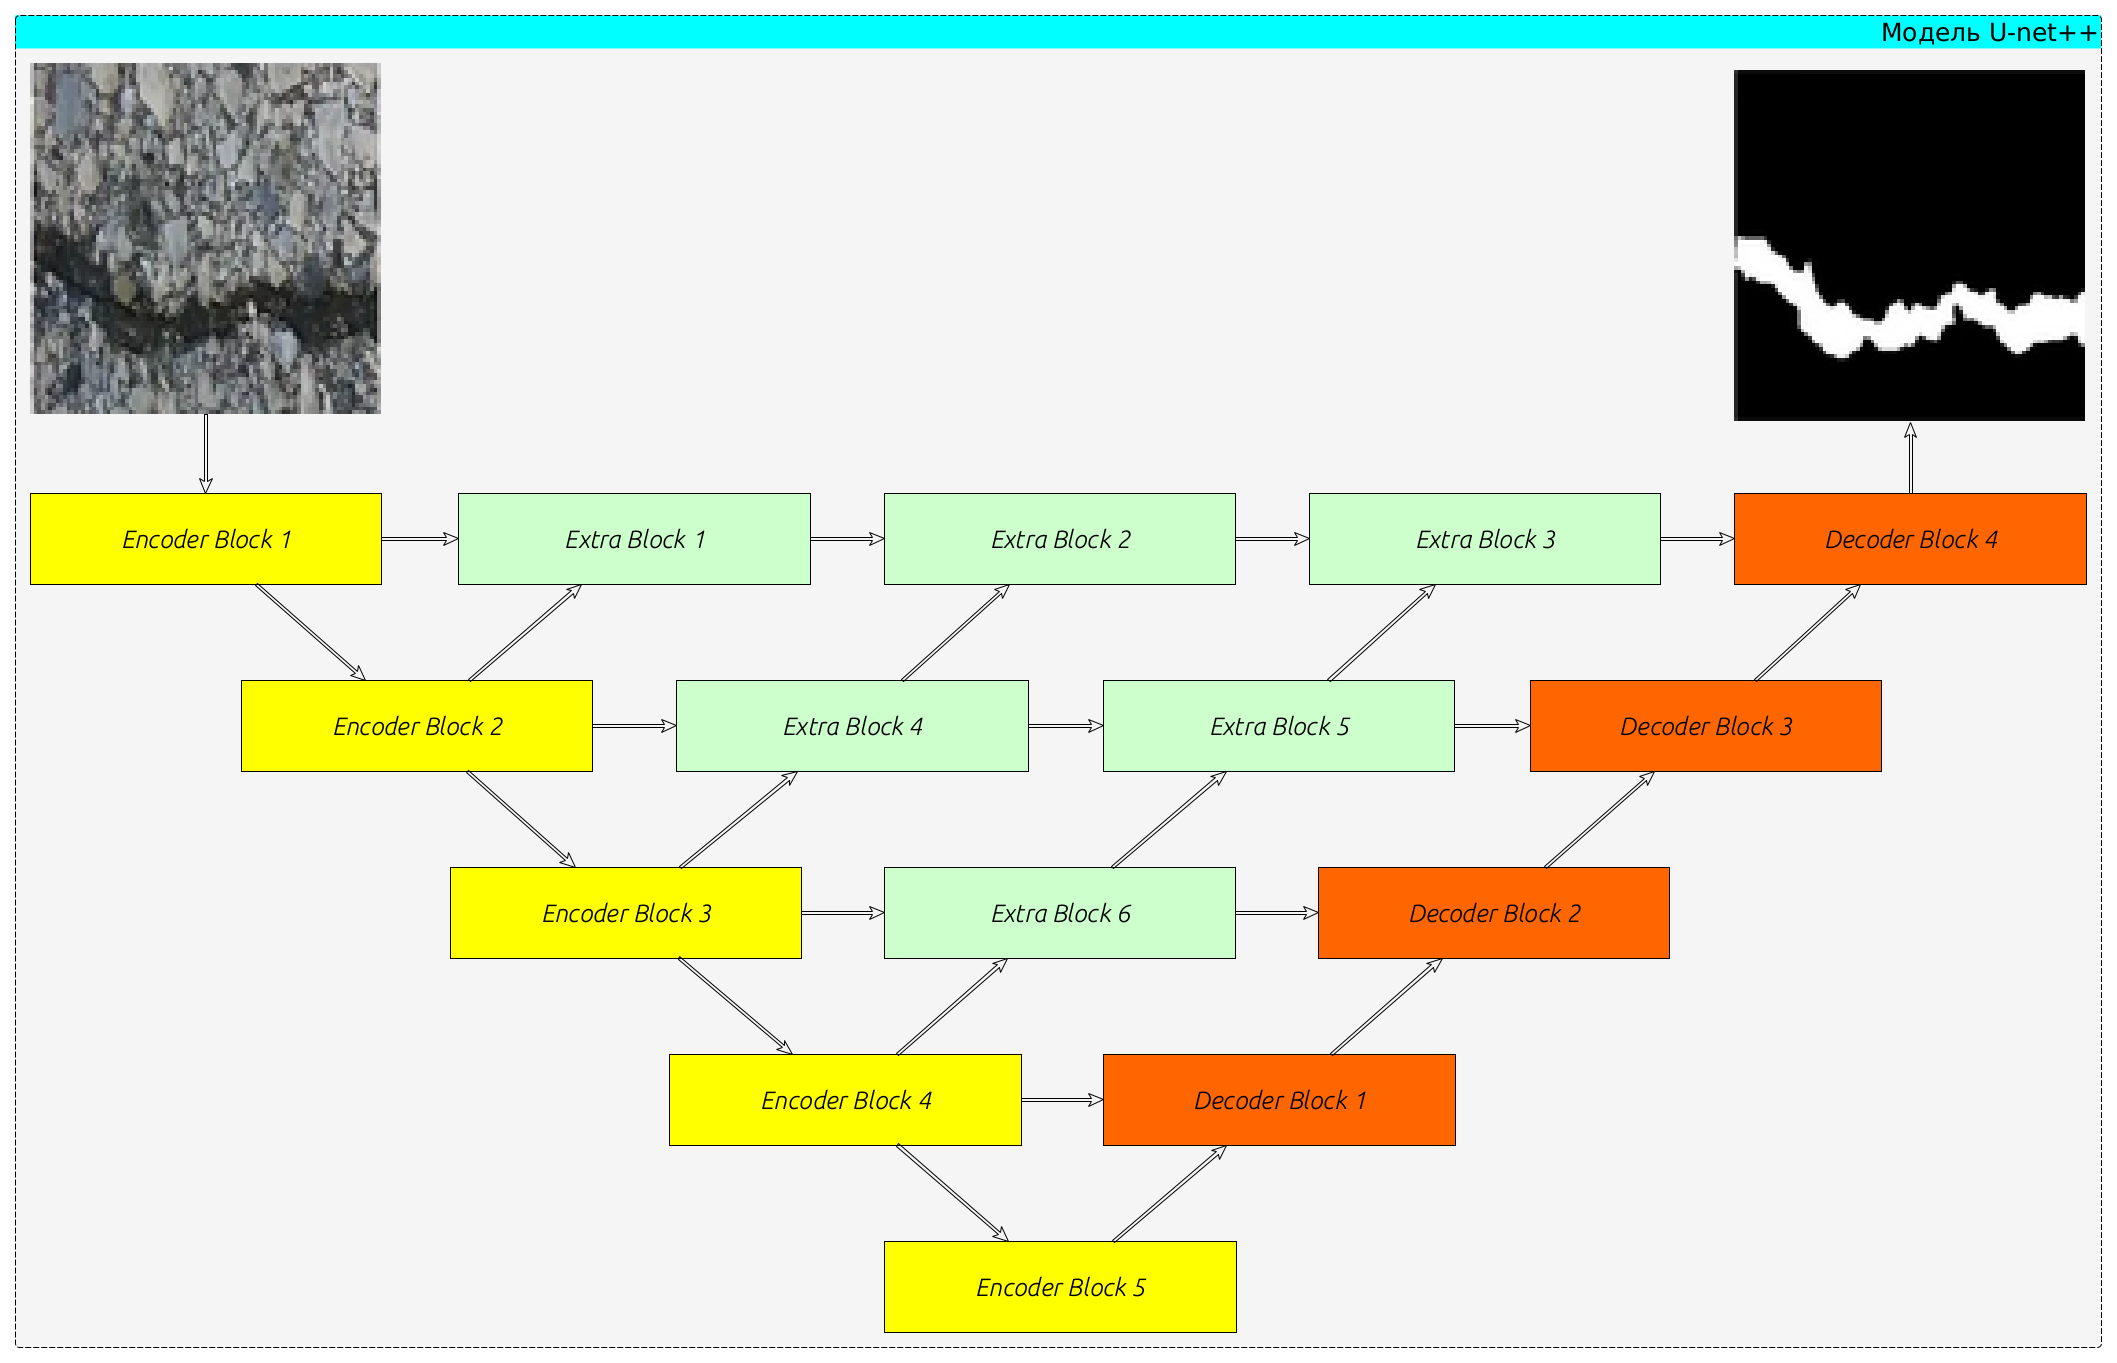


`U-Net++` повышает качество сегментации за счёт более глубокого и согласованного объединения признаков, особенно на данных, где важны тонкие границы и мелкие объекты. Однако модель становится тяжелее и требует больше вычислительных ресурсов, поэтому выбор между `U-Net` и `U-Net++` зависит от задачи и доступных ресурсов.